In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!nvidia-smi

Mon Jan 29 01:25:06 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080        On  | 00000000:01:00.0  On |                  N/A |
| 32%   37C    P2              45W / 215W |   1327MiB /  8192MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [75]:
# del model
# del model
# del optimizer
# del scheduler
# del losses
# del transform
torch.cuda.empty_cache()
gc.collect()

1495

In [ ]:
%reset -f

In [3]:
import gc
import os
os.chdir('IConNet')

In [4]:
os.getcwd()

'/home/linh/projects/IConNet'

In [5]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys

import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [8]:
from torchaudio.datasets import SPEECHCOMMANDS


class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, data_dir, download=False, subset: str = None):
        super().__init__(data_dir, download=download)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]

In [9]:
data_dir = '../data/'
val_set = SubsetSC(data_dir, download=False, subset="validation")
waveform, sample_rate, label, speaker_id, utterance_number = val_set[0]

Shape of waveform: torch.Size([1, 15018])
Sample rate of waveform: 16000


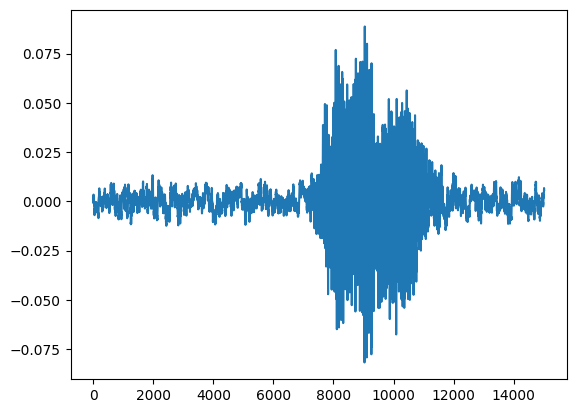

In [10]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

In [11]:
# Create training and testing split of the data. We do not use validation in this tutorial.
train_set = SubsetSC(data_dir, download=False, subset="training")
test_set = SubsetSC(data_dir, download=False, subset="testing")

In [12]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
labels

['backward',
 'bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'follow',
 'forward',
 'four',
 'go',
 'happy',
 'house',
 'learn',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'visual',
 'wow',
 'yes',
 'zero']

In [59]:
# new_sample_rate = 8000
# transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate, dtype=torch.float32)
# transformed = transform(waveform)

# ipd.Audio(transformed.numpy(), rate=new_sample_rate)

In [13]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(33) --> yes


In [14]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 64

if device == "cuda":
    num_workers = 1
    pin_memory = False # True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

In [25]:
from IConNet.signal import visualize_window, general_cosine_window

In [33]:
from IConNet.FIRConv import Downsample2
from einops import rearrange, reduce

class M9(nn.Module):
    def __init__(self, n_input=1, n_output=35, 
                 stride=16, n_channel=128, eps=1e-12):
        super().__init__()
        self.conv1 = Downsample2(n_input, n_channel, 
                                kernel_size=511, stride=16, window_k=2)
        self.conv3 = Downsample2(n_channel, n_channel, 
                                kernel_size=127, stride=4, window_k=3)
        self.layer_norm = nn.LayerNorm(3*n_channel)
        self.eps = eps
        self.cls_head = nn.Sequential(
            nn.Linear(3*n_channel, 2*n_channel),
            nn.PReLU(2*n_channel),
            nn.Linear(2*n_channel, n_output)
        )

        self.act = NLReLU(beta=1.0)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.act(x1)
        x3 = self.act(self.conv3(x2))
        x1 = reduce(x1, 'b c n -> b () c', 'mean')
        x2 = reduce(x2, 'b c n -> b () c', 'mean')
        x3 = reduce(x3, 'b c n -> b () c', 'mean')
        x = torch.cat([x1, x2, x3], dim=-1)
        x = rearrange(x, 'b 1 c -> b c')
        x = self.layer_norm(x)
        x = self.cls_head(x)
        return x 

class NLReLU(nn.Module):
    def __init__(self, beta=1.):
        super().__init__()
        self.beta = beta

    def forward(self, x):
        return nl_relu(x, self.beta)
        
def nl_relu(x, beta=1.):
    return torch.log(1 + beta * F.relu(x)) 

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model = M9(n_input=1, n_output=len(labels))
print(model)

print("Number of parameters: %s" % count_parameters(model))

M9(
  (conv1): Downsample2()
  (conv3): Downsample2()
  (layer_norm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
  (cls_head): Sequential(
    (0): Linear(in_features=384, out_features=256, bias=True)
    (1): PReLU(num_parameters=256)
    (2): Linear(in_features=256, out_features=35, bias=True)
  )
  (act): NLReLU()
)
Number of parameters: 191011


In [34]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.2,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [28]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        # data = transform(data)
        output = model(data)
        loss = F.cross_entropy(output.squeeze(), target)
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        train_losses.append(loss.item())

def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:
        # data = transform(data)
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()

        # update progress bar
        pbar.update(pbar_update)
    torch.cuda.empty_cache()
    acc = correct / len(test_loader.dataset)
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * acc:.0f}%)\n")
    return acc

In [36]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                       | 0.0026702269692923898/10 [00:00<25:03, 150.41s/it]

Train Epoch: 1 [0/84843 (0%)]	Loss: 3.563543


  0%|                         | 0.029372496662216304/10 [00:02<14:12, 85.53s/it]

Train Epoch: 1 [2560/84843 (3%)]	Loss: 3.243939


  1%|▏                         | 0.05607476635514024/10 [00:05<14:11, 85.58s/it]

Train Epoch: 1 [5120/84843 (6%)]	Loss: 3.124090


  1%|▏                         | 0.08277703604806397/10 [00:07<14:07, 85.45s/it]

Train Epoch: 1 [7680/84843 (9%)]	Loss: 3.128241


  1%|▎                         | 0.10947930574098763/10 [00:09<14:14, 86.36s/it]

Train Epoch: 1 [10240/84843 (12%)]	Loss: 2.860138


  1%|▎                         | 0.13618157543391152/10 [00:12<14:20, 87.25s/it]

Train Epoch: 1 [12800/84843 (15%)]	Loss: 2.820426


  2%|▍                         | 0.16288384512683574/10 [00:14<14:03, 85.74s/it]

Train Epoch: 1 [15360/84843 (18%)]	Loss: 2.312823


  2%|▍                         | 0.18958611481975995/10 [00:16<14:17, 87.40s/it]

Train Epoch: 1 [17920/84843 (21%)]	Loss: 2.720238


  2%|▌                         | 0.21628838451268417/10 [00:19<13:55, 85.37s/it]

Train Epoch: 1 [20480/84843 (24%)]	Loss: 2.277913


  2%|▋                          | 0.2429906542056084/10 [00:21<14:06, 86.80s/it]

Train Epoch: 1 [23040/84843 (27%)]	Loss: 2.753640


  3%|▋                          | 0.2696929238985326/10 [00:23<14:09, 87.31s/it]

Train Epoch: 1 [25600/84843 (30%)]	Loss: 2.712713


  3%|▊                         | 0.29639519359145683/10 [00:26<13:54, 85.96s/it]

Train Epoch: 1 [28160/84843 (33%)]	Loss: 2.115087


  3%|▊                         | 0.32309746328438105/10 [00:28<13:51, 85.91s/it]

Train Epoch: 1 [30720/84843 (36%)]	Loss: 2.487189


  3%|▉                         | 0.34979973297730527/10 [00:30<13:51, 86.20s/it]

Train Epoch: 1 [33280/84843 (39%)]	Loss: 2.112319


  4%|█                          | 0.3765020026702295/10 [00:33<13:54, 86.69s/it]

Train Epoch: 1 [35840/84843 (42%)]	Loss: 2.279815


  4%|█                          | 0.4032042723631537/10 [00:35<13:48, 86.37s/it]

Train Epoch: 1 [38400/84843 (45%)]	Loss: 2.137388


  4%|█▏                         | 0.4299065420560779/10 [00:37<14:25, 90.41s/it]

Train Epoch: 1 [40960/84843 (48%)]	Loss: 1.938318


  5%|█▏                        | 0.45660881174900214/10 [00:40<14:12, 89.36s/it]

Train Epoch: 1 [43520/84843 (51%)]	Loss: 1.899548


  5%|█▎                        | 0.48331108144192636/10 [00:42<13:38, 86.01s/it]

Train Epoch: 1 [46080/84843 (54%)]	Loss: 1.791202


  5%|█▍                         | 0.5100133511348506/10 [00:44<13:38, 86.25s/it]

Train Epoch: 1 [48640/84843 (57%)]	Loss: 1.930627


  5%|█▍                         | 0.5367156208277748/10 [00:47<15:23, 97.58s/it]

Train Epoch: 1 [51200/84843 (60%)]	Loss: 1.873643


  6%|█▌                         | 0.563417890520699/10 [00:49<16:05, 102.26s/it]

Train Epoch: 1 [53760/84843 (63%)]	Loss: 2.680866


  6%|█▌                         | 0.5901201602136232/10 [00:52<14:23, 91.80s/it]

Train Epoch: 1 [56320/84843 (66%)]	Loss: 1.943096


  6%|█▋                         | 0.6168224299065475/10 [00:54<14:25, 92.22s/it]

Train Epoch: 1 [58880/84843 (69%)]	Loss: 1.887371


  6%|█▋                         | 0.6435246995994717/10 [00:57<13:44, 88.12s/it]

Train Epoch: 1 [61440/84843 (72%)]	Loss: 1.901950


  7%|█▊                         | 0.6702269692923959/10 [00:59<13:17, 85.52s/it]

Train Epoch: 1 [64000/84843 (75%)]	Loss: 1.556323


  7%|█▉                         | 0.6969292389853201/10 [01:01<13:17, 85.74s/it]

Train Epoch: 1 [66560/84843 (78%)]	Loss: 1.603027


  7%|█▉                         | 0.7236315086782443/10 [01:04<13:24, 86.78s/it]

Train Epoch: 1 [69120/84843 (81%)]	Loss: 2.104764


  8%|██                         | 0.7503337783711685/10 [01:06<13:25, 87.08s/it]

Train Epoch: 1 [71680/84843 (84%)]	Loss: 1.438159


  8%|██                         | 0.7770360480640928/10 [01:08<13:32, 88.07s/it]

Train Epoch: 1 [74240/84843 (87%)]	Loss: 1.462340


  8%|██▎                         | 0.803738317757017/10 [01:11<13:58, 91.17s/it]

Train Epoch: 1 [76800/84843 (90%)]	Loss: 1.190713


  8%|██▏                        | 0.8304405874499412/10 [01:13<13:14, 86.64s/it]

Train Epoch: 1 [79360/84843 (94%)]	Loss: 1.577806


  9%|██▎                        | 0.8571428571428654/10 [01:15<14:26, 94.76s/it]

Train Epoch: 1 [81920/84843 (97%)]	Loss: 1.760769


  9%|██▍                        | 0.8838451268357896/10 [01:18<13:36, 89.61s/it]

Train Epoch: 1 [84480/84843 (100%)]	Loss: 1.765949


 10%|██▋                        | 1.0020026702269793/10 [01:23<07:07, 47.51s/it]


Test Epoch: 1	Accuracy: 6206/11005 (56%)

Train Epoch: 2 [0/84843 (0%)]	Loss: 1.252773


 10%|██▊                        | 1.0293724966622266/10 [01:25<12:40, 84.82s/it]

Train Epoch: 2 [2560/84843 (3%)]	Loss: 1.503099


 11%|██▊                        | 1.0560747663551509/10 [01:27<12:54, 86.62s/it]

Train Epoch: 2 [5120/84843 (6%)]	Loss: 1.261676


 11%|███                         | 1.082777036048075/10 [01:30<13:07, 88.32s/it]

Train Epoch: 2 [7680/84843 (9%)]	Loss: 1.492469


 11%|██▉                        | 1.1094793057409993/10 [01:32<13:04, 88.22s/it]

Train Epoch: 2 [10240/84843 (12%)]	Loss: 1.338274


 11%|███                        | 1.1361815754339235/10 [01:35<12:45, 86.37s/it]

Train Epoch: 2 [12800/84843 (15%)]	Loss: 1.197356


 12%|███▏                       | 1.1628838451268477/10 [01:37<13:03, 88.61s/it]

Train Epoch: 2 [15360/84843 (18%)]	Loss: 1.425870


 12%|███▎                        | 1.189586114819772/10 [01:39<13:05, 89.21s/it]

Train Epoch: 2 [17920/84843 (21%)]	Loss: 1.188042


 12%|███▎                       | 1.2162883845126962/10 [01:42<12:57, 88.56s/it]

Train Epoch: 2 [20480/84843 (24%)]	Loss: 1.451686


 12%|███▏                      | 1.2429906542056204/10 [01:44<14:38, 100.30s/it]

Train Epoch: 2 [23040/84843 (27%)]	Loss: 1.470220


 13%|███▍                       | 1.2696929238985446/10 [01:47<14:28, 99.49s/it]

Train Epoch: 2 [25600/84843 (30%)]	Loss: 0.870850


 13%|███▌                       | 1.2963951935914688/10 [01:49<12:33, 86.53s/it]

Train Epoch: 2 [28160/84843 (33%)]	Loss: 1.218728


 13%|███▋                        | 1.323097463284393/10 [01:52<12:46, 88.32s/it]

Train Epoch: 2 [30720/84843 (36%)]	Loss: 1.240087


 13%|███▋                       | 1.3497997329773173/10 [01:54<12:26, 86.35s/it]

Train Epoch: 2 [33280/84843 (39%)]	Loss: 1.339927


 14%|███▋                       | 1.3765020026702415/10 [01:56<12:25, 86.39s/it]

Train Epoch: 2 [35840/84843 (42%)]	Loss: 0.907925


 14%|███▊                       | 1.4032042723631657/10 [01:59<12:25, 86.73s/it]

Train Epoch: 2 [38400/84843 (45%)]	Loss: 0.925889


 14%|████▏                        | 1.42990654205609/10 [02:01<12:20, 86.36s/it]

Train Epoch: 2 [40960/84843 (48%)]	Loss: 0.762042


 15%|███▉                       | 1.4566088117490141/10 [02:03<12:17, 86.38s/it]

Train Epoch: 2 [43520/84843 (51%)]	Loss: 0.916899


 15%|████                       | 1.4833110814419384/10 [02:05<12:17, 86.59s/it]

Train Epoch: 2 [46080/84843 (54%)]	Loss: 0.716992


 15%|████                       | 1.5100133511348626/10 [02:08<12:18, 86.96s/it]

Train Epoch: 2 [48640/84843 (57%)]	Loss: 0.953408


 15%|████▏                      | 1.5367156208277868/10 [02:10<12:12, 86.59s/it]

Train Epoch: 2 [51200/84843 (60%)]	Loss: 0.984894


 16%|████▍                       | 1.563417890520711/10 [02:13<12:36, 89.62s/it]

Train Epoch: 2 [53760/84843 (63%)]	Loss: 0.718281


 16%|████▎                      | 1.5901201602136352/10 [02:15<12:17, 87.73s/it]

Train Epoch: 2 [56320/84843 (66%)]	Loss: 0.884456


 16%|████▎                      | 1.6168224299065594/10 [02:17<12:04, 86.44s/it]

Train Epoch: 2 [58880/84843 (69%)]	Loss: 0.724398


 16%|████▍                      | 1.6435246995994837/10 [02:20<12:03, 86.53s/it]

Train Epoch: 2 [61440/84843 (72%)]	Loss: 0.839239


 17%|████▌                      | 1.6702269692924079/10 [02:22<12:01, 86.56s/it]

Train Epoch: 2 [64000/84843 (75%)]	Loss: 0.753517


 17%|████▊                       | 1.696929238985332/10 [02:24<12:00, 86.79s/it]

Train Epoch: 2 [66560/84843 (78%)]	Loss: 0.984222


 17%|████▋                      | 1.7236315086782563/10 [02:26<12:03, 87.41s/it]

Train Epoch: 2 [69120/84843 (81%)]	Loss: 0.899175


 18%|████▋                      | 1.7503337783711805/10 [02:29<11:59, 87.21s/it]

Train Epoch: 2 [71680/84843 (84%)]	Loss: 1.119735


 18%|████▊                      | 1.7770360480641048/10 [02:31<11:51, 86.57s/it]

Train Epoch: 2 [74240/84843 (87%)]	Loss: 0.637034


 18%|█████                       | 1.803738317757029/10 [02:33<11:54, 87.14s/it]

Train Epoch: 2 [76800/84843 (90%)]	Loss: 0.747665


 18%|████▉                      | 1.8304405874499532/10 [02:36<11:49, 86.82s/it]

Train Epoch: 2 [79360/84843 (94%)]	Loss: 1.000477


 19%|█████                      | 1.8571428571428774/10 [02:38<11:47, 86.90s/it]

Train Epoch: 2 [81920/84843 (97%)]	Loss: 0.886452


 19%|█████                      | 1.8838451268358016/10 [02:41<12:53, 95.35s/it]

Train Epoch: 2 [84480/84843 (100%)]	Loss: 1.094435


 20%|█████▍                     | 2.0013351134846675/10 [02:46<05:38, 42.27s/it]


Test Epoch: 2	Accuracy: 8440/11005 (77%)

Train Epoch: 3 [0/84843 (0%)]	Loss: 0.635814


 20%|█████▍                     | 2.0293724966622286/10 [02:49<11:42, 88.12s/it]

Train Epoch: 3 [2560/84843 (3%)]	Loss: 0.691858


 21%|█████▊                      | 2.056074766355144/10 [02:51<11:28, 86.68s/it]

Train Epoch: 3 [5120/84843 (6%)]	Loss: 0.748390


 21%|█████▌                     | 2.0827770360480593/10 [02:53<11:25, 86.55s/it]

Train Epoch: 3 [7680/84843 (9%)]	Loss: 1.044162


 21%|█████▋                     | 2.1094793057409746/10 [02:56<11:27, 87.18s/it]

Train Epoch: 3 [10240/84843 (12%)]	Loss: 0.922310


 21%|██████▏                      | 2.13618157543389/10 [02:58<11:23, 86.87s/it]

Train Epoch: 3 [12800/84843 (15%)]	Loss: 0.821850


 22%|█████▊                     | 2.1628838451268053/10 [03:00<11:20, 86.85s/it]

Train Epoch: 3 [15360/84843 (18%)]	Loss: 0.560779


 22%|█████▉                     | 2.1895861148197207/10 [03:03<11:17, 86.79s/it]

Train Epoch: 3 [17920/84843 (21%)]	Loss: 0.563216


 22%|██████▏                     | 2.216288384512636/10 [03:05<11:15, 86.81s/it]

Train Epoch: 3 [20480/84843 (24%)]	Loss: 0.739735


 22%|██████                     | 2.2429906542055513/10 [03:07<11:34, 89.52s/it]

Train Epoch: 3 [23040/84843 (27%)]	Loss: 0.873207


 23%|██████▏                    | 2.2696929238984667/10 [03:10<11:12, 87.06s/it]

Train Epoch: 3 [25600/84843 (30%)]	Loss: 0.733809


 23%|██████▍                     | 2.296395193591382/10 [03:12<11:24, 88.88s/it]

Train Epoch: 3 [28160/84843 (33%)]	Loss: 0.931701


 23%|██████▎                    | 2.3230974632842973/10 [03:15<11:28, 89.73s/it]

Train Epoch: 3 [30720/84843 (36%)]	Loss: 0.361959


 23%|██████▎                    | 2.3497997329772127/10 [03:17<11:41, 91.64s/it]

Train Epoch: 3 [33280/84843 (39%)]	Loss: 0.540448


 24%|██████▋                     | 2.376502002670128/10 [03:19<11:31, 90.72s/it]

Train Epoch: 3 [35840/84843 (42%)]	Loss: 0.525223


 24%|██████▍                    | 2.4032042723630433/10 [03:22<11:34, 91.40s/it]

Train Epoch: 3 [38400/84843 (45%)]	Loss: 0.918410


 24%|██████▌                    | 2.4299065420559587/10 [03:24<11:10, 88.57s/it]

Train Epoch: 3 [40960/84843 (48%)]	Loss: 0.781350


 25%|██████▉                     | 2.456608811748874/10 [03:27<10:57, 87.20s/it]

Train Epoch: 3 [43520/84843 (51%)]	Loss: 0.984908


 25%|██████▋                    | 2.4833110814417894/10 [03:29<10:53, 86.93s/it]

Train Epoch: 3 [46080/84843 (54%)]	Loss: 1.115836


 25%|██████▊                    | 2.5100133511347047/10 [03:31<10:52, 87.13s/it]

Train Epoch: 3 [48640/84843 (57%)]	Loss: 0.464403


 25%|███████▎                     | 2.53671562082762/10 [03:34<10:51, 87.27s/it]

Train Epoch: 3 [51200/84843 (60%)]	Loss: 0.608429


 26%|██████▉                    | 2.5634178905205354/10 [03:36<10:46, 86.94s/it]

Train Epoch: 3 [53760/84843 (63%)]	Loss: 0.633676


 26%|██████▉                    | 2.5901201602134507/10 [03:38<11:36, 94.02s/it]

Train Epoch: 3 [56320/84843 (66%)]	Loss: 0.759633


 26%|███████▎                    | 2.616822429906366/10 [03:41<11:24, 92.72s/it]

Train Epoch: 3 [58880/84843 (69%)]	Loss: 0.509849


 26%|███████▏                   | 2.6435246995992814/10 [03:43<10:42, 87.27s/it]

Train Epoch: 3 [61440/84843 (72%)]	Loss: 0.704991


 27%|███████▏                   | 2.6702269692921967/10 [03:46<11:16, 92.23s/it]

Train Epoch: 3 [64000/84843 (75%)]	Loss: 0.635628


 27%|███████▌                    | 2.696929238985112/10 [03:48<11:21, 93.30s/it]

Train Epoch: 3 [66560/84843 (78%)]	Loss: 0.645282


 27%|███████▎                   | 2.7236315086780274/10 [03:51<10:42, 88.25s/it]

Train Epoch: 3 [69120/84843 (81%)]	Loss: 0.925866


 28%|███████▍                   | 2.7503337783709427/10 [03:53<10:32, 87.19s/it]

Train Epoch: 3 [71680/84843 (84%)]	Loss: 0.439803


 28%|███████▊                    | 2.777036048063858/10 [03:55<10:28, 87.05s/it]

Train Epoch: 3 [74240/84843 (87%)]	Loss: 0.616519


 28%|███████▌                   | 2.8037383177567734/10 [03:58<10:25, 86.91s/it]

Train Epoch: 3 [76800/84843 (90%)]	Loss: 0.857129


 28%|███████▋                   | 2.8304405874496887/10 [04:00<10:41, 89.43s/it]

Train Epoch: 3 [79360/84843 (94%)]	Loss: 0.896528


 29%|███████▉                    | 2.857142857142604/10 [04:02<10:29, 88.19s/it]

Train Epoch: 3 [81920/84843 (97%)]	Loss: 0.576550


 29%|███████▊                   | 2.8838451268355194/10 [04:05<10:28, 88.29s/it]

Train Epoch: 3 [84480/84843 (100%)]	Loss: 0.775049


 30%|████████▋                    | 3.00200267022667/10 [04:10<05:28, 46.89s/it]


Test Epoch: 3	Accuracy: 8819/11005 (80%)

Train Epoch: 4 [0/84843 (0%)]	Loss: 0.675144


 30%|████████▍                   | 3.029372496661908/10 [04:12<10:54, 93.86s/it]

Train Epoch: 4 [2560/84843 (3%)]	Loss: 0.394603


 31%|████████▎                  | 3.0560747663548233/10 [04:14<10:36, 91.65s/it]

Train Epoch: 4 [5120/84843 (6%)]	Loss: 0.647399


 31%|████████▎                  | 3.0827770360477387/10 [04:17<11:04, 96.04s/it]

Train Epoch: 4 [7680/84843 (9%)]	Loss: 0.738313


 31%|████████▋                   | 3.109479305740654/10 [04:20<11:00, 95.88s/it]

Train Epoch: 4 [10240/84843 (12%)]	Loss: 0.841626


 31%|████████▍                  | 3.1361815754335693/10 [04:22<10:59, 96.07s/it]

Train Epoch: 4 [12800/84843 (15%)]	Loss: 0.806445


 32%|████████▌                  | 3.1628838451264847/10 [04:25<10:56, 96.01s/it]

Train Epoch: 4 [15360/84843 (18%)]	Loss: 0.593083


 32%|█████████▌                    | 3.1895861148194/10 [04:27<10:54, 96.03s/it]

Train Epoch: 4 [17920/84843 (21%)]	Loss: 0.595777


 32%|████████▋                  | 3.2162883845123154/10 [04:30<10:51, 96.00s/it]

Train Epoch: 4 [20480/84843 (24%)]	Loss: 0.347342


 32%|████████▊                  | 3.2429906542052307/10 [04:33<10:55, 97.08s/it]

Train Epoch: 4 [23040/84843 (27%)]	Loss: 0.596319


 33%|█████████▏                  | 3.269692923898146/10 [04:35<11:07, 99.17s/it]

Train Epoch: 4 [25600/84843 (30%)]	Loss: 0.598786


 33%|████████▌                 | 3.2963951935910614/10 [04:38<12:44, 114.00s/it]

Train Epoch: 4 [28160/84843 (33%)]	Loss: 0.741006


 33%|████████▋                 | 3.3230974632839767/10 [04:41<11:50, 106.48s/it]

Train Epoch: 4 [30720/84843 (36%)]	Loss: 0.803731


 33%|█████████▍                  | 3.349799732976892/10 [04:43<10:37, 95.83s/it]

Train Epoch: 4 [33280/84843 (39%)]	Loss: 0.584341


 34%|█████████                  | 3.3765020026698074/10 [04:46<10:34, 95.74s/it]

Train Epoch: 4 [35840/84843 (42%)]	Loss: 0.319069


 34%|█████████▏                 | 3.4032042723627227/10 [04:48<10:31, 95.74s/it]

Train Epoch: 4 [38400/84843 (45%)]	Loss: 0.806634


 34%|█████████▌                  | 3.429906542055638/10 [04:51<10:43, 97.89s/it]

Train Epoch: 4 [40960/84843 (48%)]	Loss: 0.697380


 35%|█████████▎                 | 3.4566088117485534/10 [04:54<10:26, 95.77s/it]

Train Epoch: 4 [43520/84843 (51%)]	Loss: 0.596308


 35%|█████████▍                 | 3.4833110814414687/10 [04:56<10:24, 95.82s/it]

Train Epoch: 4 [46080/84843 (54%)]	Loss: 0.328368


 35%|█████████▊                  | 3.510013351134384/10 [04:59<10:22, 95.90s/it]

Train Epoch: 4 [48640/84843 (57%)]	Loss: 0.437505


 35%|█████████▌                 | 3.5367156208272994/10 [05:01<10:18, 95.76s/it]

Train Epoch: 4 [51200/84843 (60%)]	Loss: 0.731624


 36%|█████████▎                | 3.5634178905202147/10 [05:04<11:09, 104.06s/it]

Train Epoch: 4 [53760/84843 (63%)]	Loss: 0.658867


 36%|██████████▍                  | 3.59012016021313/10 [05:06<10:16, 96.16s/it]

Train Epoch: 4 [56320/84843 (66%)]	Loss: 0.537068


 36%|█████████▊                 | 3.6168224299060454/10 [05:09<10:16, 96.59s/it]

Train Epoch: 4 [58880/84843 (69%)]	Loss: 0.880123


 36%|█████████▊                 | 3.6435246995989607/10 [05:12<10:11, 96.19s/it]

Train Epoch: 4 [61440/84843 (72%)]	Loss: 0.906461


 37%|██████████▎                 | 3.670226969291876/10 [05:14<10:09, 96.24s/it]

Train Epoch: 4 [64000/84843 (75%)]	Loss: 0.518138


 37%|█████████▉                 | 3.6969292389847914/10 [05:17<10:06, 96.22s/it]

Train Epoch: 4 [66560/84843 (78%)]	Loss: 0.515406


 37%|██████████                 | 3.7236315086777068/10 [05:19<10:03, 96.17s/it]

Train Epoch: 4 [69120/84843 (81%)]	Loss: 0.735325


 38%|██████████▌                 | 3.750333778370622/10 [05:22<10:12, 98.07s/it]

Train Epoch: 4 [71680/84843 (84%)]	Loss: 0.863030


 38%|██████████▏                | 3.7770360480635374/10 [05:24<10:00, 96.45s/it]

Train Epoch: 4 [74240/84843 (87%)]	Loss: 0.480859


 38%|██████████▎                | 3.8037383177564528/10 [05:27<09:55, 96.18s/it]

Train Epoch: 4 [76800/84843 (90%)]	Loss: 0.937192


 38%|██████████▋                 | 3.830440587449368/10 [05:30<10:12, 99.29s/it]

Train Epoch: 4 [79360/84843 (94%)]	Loss: 0.539005


 39%|██████████▍                | 3.8571428571422834/10 [05:32<09:58, 97.44s/it]

Train Epoch: 4 [81920/84843 (97%)]	Loss: 0.717142


 39%|██████████▊                 | 3.883845126835199/10 [05:35<09:48, 96.30s/it]

Train Epoch: 4 [84480/84843 (100%)]	Loss: 0.282815


 40%|███████████▏                | 4.000667556741703/10 [05:41<06:07, 61.23s/it]


Test Epoch: 4	Accuracy: 8991/11005 (82%)

Train Epoch: 5 [0/84843 (0%)]	Loss: 0.416026


 40%|██████████▉                | 4.0293724966616065/10 [05:44<09:35, 96.36s/it]

Train Epoch: 5 [2560/84843 (3%)]	Loss: 0.463038


 41%|███████████▊                 | 4.05607476635454/10 [05:46<09:31, 96.15s/it]

Train Epoch: 5 [5120/84843 (6%)]	Loss: 0.821465


 41%|███████████▍                | 4.082777036047473/10 [05:49<09:29, 96.19s/it]

Train Epoch: 5 [7680/84843 (9%)]	Loss: 0.693410


 41%|███████████▌                | 4.109479305740406/10 [05:51<09:26, 96.15s/it]

Train Epoch: 5 [10240/84843 (12%)]	Loss: 0.812311


 41%|███████████▌                | 4.136181575433339/10 [05:54<09:22, 95.92s/it]

Train Epoch: 5 [12800/84843 (15%)]	Loss: 0.424487


 42%|███████████▋                | 4.162883845126272/10 [05:57<09:19, 95.89s/it]

Train Epoch: 5 [15360/84843 (18%)]	Loss: 0.674249


 42%|███████████▋                | 4.189586114819205/10 [05:59<09:16, 95.70s/it]

Train Epoch: 5 [17920/84843 (21%)]	Loss: 1.081112


 42%|███████████▊                | 4.216288384512138/10 [06:02<09:15, 96.02s/it]

Train Epoch: 5 [20480/84843 (24%)]	Loss: 0.631204


 42%|███████████▉                | 4.242990654205071/10 [06:04<09:10, 95.71s/it]

Train Epoch: 5 [23040/84843 (27%)]	Loss: 0.392492


 43%|███████████▉                | 4.269692923898004/10 [06:07<09:09, 95.85s/it]

Train Epoch: 5 [25600/84843 (30%)]	Loss: 0.697272


 43%|███████████▌               | 4.2963951935909375/10 [06:09<09:15, 97.41s/it]

Train Epoch: 5 [28160/84843 (33%)]	Loss: 0.366806


 43%|████████████                | 4.323097463283871/10 [06:12<09:05, 96.03s/it]

Train Epoch: 5 [30720/84843 (36%)]	Loss: 0.492096


 43%|████████████▏               | 4.349799732976804/10 [06:15<09:12, 97.85s/it]

Train Epoch: 5 [33280/84843 (39%)]	Loss: 0.731536


 44%|████████████▎               | 4.376502002669737/10 [06:17<08:58, 95.79s/it]

Train Epoch: 5 [35840/84843 (42%)]	Loss: 0.816702


 44%|████████████▊                | 4.40320427236267/10 [06:20<08:57, 96.09s/it]

Train Epoch: 5 [38400/84843 (45%)]	Loss: 0.729293


 44%|████████████▍               | 4.429906542055603/10 [06:22<08:53, 95.83s/it]

Train Epoch: 5 [40960/84843 (48%)]	Loss: 0.767735


 45%|████████████▍               | 4.456608811748536/10 [06:25<09:00, 97.56s/it]

Train Epoch: 5 [43520/84843 (51%)]	Loss: 0.611804


 45%|████████████▌               | 4.483311081441469/10 [06:27<08:48, 95.76s/it]

Train Epoch: 5 [46080/84843 (54%)]	Loss: 0.792719


 45%|████████████▋               | 4.510013351134402/10 [06:30<08:47, 96.17s/it]

Train Epoch: 5 [48640/84843 (57%)]	Loss: 0.584885


 45%|████████████▋               | 4.536715620827335/10 [06:33<08:43, 95.91s/it]

Train Epoch: 5 [51200/84843 (60%)]	Loss: 0.253339


 46%|████████████▎              | 4.5634178905202685/10 [06:35<08:42, 96.08s/it]

Train Epoch: 5 [53760/84843 (63%)]	Loss: 0.659865


 46%|████████████▊               | 4.590120160213202/10 [06:38<08:38, 95.84s/it]

Train Epoch: 5 [56320/84843 (66%)]	Loss: 0.648204


 46%|████████████▍              | 4.616822429906135/10 [06:40<09:14, 103.03s/it]

Train Epoch: 5 [58880/84843 (69%)]	Loss: 0.689638


 46%|████████████▌              | 4.643524699599068/10 [06:43<09:08, 102.40s/it]

Train Epoch: 5 [61440/84843 (72%)]	Loss: 0.693292


 47%|█████████████               | 4.670226969292001/10 [06:46<08:32, 96.13s/it]

Train Epoch: 5 [64000/84843 (75%)]	Loss: 0.330237


 47%|█████████████▏              | 4.696929238984934/10 [06:48<08:32, 96.58s/it]

Train Epoch: 5 [66560/84843 (78%)]	Loss: 0.554754


 47%|█████████████▏              | 4.723631508677867/10 [06:51<08:28, 96.32s/it]

Train Epoch: 5 [69120/84843 (81%)]	Loss: 0.782769


 48%|██████████████▎               | 4.7503337783708/10 [06:54<08:38, 98.70s/it]

Train Epoch: 5 [71680/84843 (84%)]	Loss: 0.442610


 48%|█████████████▍              | 4.777036048063733/10 [06:56<08:24, 96.65s/it]

Train Epoch: 5 [74240/84843 (87%)]	Loss: 0.621333


 48%|█████████████▍              | 4.803738317756666/10 [06:59<08:17, 95.79s/it]

Train Epoch: 5 [76800/84843 (90%)]	Loss: 0.554311


 48%|█████████████              | 4.8304405874495995/10 [07:01<08:15, 95.82s/it]

Train Epoch: 5 [79360/84843 (94%)]	Loss: 0.668512


 49%|█████████████▌              | 4.857142857142533/10 [07:04<08:13, 95.93s/it]

Train Epoch: 5 [81920/84843 (97%)]	Loss: 0.381544


 49%|█████████████▏             | 4.883845126835466/10 [07:06<08:51, 103.83s/it]

Train Epoch: 5 [84480/84843 (100%)]	Loss: 0.408590


 50%|██████████████              | 5.001335113484371/10 [07:12<03:53, 46.63s/it]


Test Epoch: 5	Accuracy: 8865/11005 (81%)

Train Epoch: 6 [0/84843 (0%)]	Loss: 0.948415


 50%|██████████████              | 5.029372496661951/10 [07:14<07:41, 92.92s/it]

Train Epoch: 6 [2560/84843 (3%)]	Loss: 0.380164


 51%|██████████████▏             | 5.056074766354884/10 [07:17<08:02, 97.59s/it]

Train Epoch: 6 [5120/84843 (6%)]	Loss: 0.441780


 51%|██████████████▏             | 5.082777036047817/10 [07:20<07:53, 96.20s/it]

Train Epoch: 6 [7680/84843 (9%)]	Loss: 0.725679


 51%|██████████████▊              | 5.10947930574075/10 [07:22<07:54, 97.02s/it]

Train Epoch: 6 [10240/84843 (12%)]	Loss: 0.494908


 51%|█████████████▊             | 5.1361815754336835/10 [07:25<07:45, 95.78s/it]

Train Epoch: 6 [12800/84843 (15%)]	Loss: 0.195049


 52%|██████████████▍             | 5.162883845126617/10 [07:27<07:43, 95.76s/it]

Train Epoch: 6 [15360/84843 (18%)]	Loss: 0.229971


 52%|███████████████              | 5.18958611481955/10 [07:30<07:40, 95.81s/it]

Train Epoch: 6 [17920/84843 (21%)]	Loss: 0.789349


 52%|██████████████▌             | 5.216288384512483/10 [07:32<07:47, 97.64s/it]

Train Epoch: 6 [20480/84843 (24%)]	Loss: 0.488816


 52%|██████████████▋             | 5.242990654205416/10 [07:35<07:47, 98.26s/it]

Train Epoch: 6 [23040/84843 (27%)]	Loss: 0.331631


 53%|██████████████▊             | 5.269692923898349/10 [07:38<07:35, 96.37s/it]

Train Epoch: 6 [25600/84843 (30%)]	Loss: 0.243681


 53%|██████████████▎            | 5.296395193591282/10 [07:40<08:09, 104.07s/it]

Train Epoch: 6 [28160/84843 (33%)]	Loss: 0.668079


 53%|██████████████▎            | 5.323097463284215/10 [07:43<08:00, 102.64s/it]

Train Epoch: 6 [30720/84843 (36%)]	Loss: 0.773509


 53%|██████████████▉             | 5.349799732977148/10 [07:45<06:40, 86.23s/it]

Train Epoch: 6 [33280/84843 (39%)]	Loss: 0.307612


 54%|██████████████▌            | 5.376502002670081/10 [07:48<08:01, 104.15s/it]

Train Epoch: 6 [35840/84843 (42%)]	Loss: 0.768049


 54%|██████████████▌            | 5.4032042723630145/10 [07:50<06:43, 87.72s/it]

Train Epoch: 6 [38400/84843 (45%)]	Loss: 0.272671


 54%|██████████████▋            | 5.429906542055948/10 [07:53<07:39, 100.56s/it]

Train Epoch: 6 [40960/84843 (48%)]	Loss: 0.277869


 55%|███████████████▎            | 5.456608811748881/10 [07:55<07:01, 92.67s/it]

Train Epoch: 6 [43520/84843 (51%)]	Loss: 0.599499


 55%|███████████████▎            | 5.483311081441814/10 [07:58<06:47, 90.23s/it]

Train Epoch: 6 [46080/84843 (54%)]	Loss: 0.458936


 55%|███████████████▍            | 5.510013351134747/10 [08:00<06:41, 89.43s/it]

Train Epoch: 6 [48640/84843 (57%)]	Loss: 0.289384


 55%|████████████████             | 5.53671562082768/10 [08:02<06:34, 88.43s/it]

Train Epoch: 6 [51200/84843 (60%)]	Loss: 0.498801


 56%|███████████████▌            | 5.563417890520613/10 [08:05<06:57, 94.09s/it]

Train Epoch: 6 [53760/84843 (63%)]	Loss: 0.522811


 56%|███████████████▋            | 5.590120160213546/10 [08:07<06:22, 86.77s/it]

Train Epoch: 6 [56320/84843 (66%)]	Loss: 0.658893


 56%|███████████████▋            | 5.616822429906479/10 [08:10<06:32, 89.44s/it]

Train Epoch: 6 [58880/84843 (69%)]	Loss: 0.416982


 56%|███████████████▊            | 5.643524699599412/10 [08:12<06:45, 93.03s/it]

Train Epoch: 6 [61440/84843 (72%)]	Loss: 0.684721


 57%|███████████████▎           | 5.6702269692923455/10 [08:14<06:20, 87.85s/it]

Train Epoch: 6 [64000/84843 (75%)]	Loss: 0.660336


 57%|███████████████▉            | 5.696929238985279/10 [08:17<06:13, 86.79s/it]

Train Epoch: 6 [66560/84843 (78%)]	Loss: 0.556146


 57%|████████████████            | 5.723631508678212/10 [08:19<06:27, 90.64s/it]

Train Epoch: 6 [69120/84843 (81%)]	Loss: 0.635664


 58%|████████████████            | 5.750333778371145/10 [08:22<06:14, 88.23s/it]

Train Epoch: 6 [71680/84843 (84%)]	Loss: 0.448332


 58%|████████████████▏           | 5.777036048064078/10 [08:24<06:21, 90.40s/it]

Train Epoch: 6 [74240/84843 (87%)]	Loss: 0.282688


 58%|████████████████▎           | 5.803738317757011/10 [08:26<06:19, 90.43s/it]

Train Epoch: 6 [76800/84843 (90%)]	Loss: 0.640951


 58%|████████████████▎           | 5.830440587449944/10 [08:29<06:27, 93.03s/it]

Train Epoch: 6 [79360/84843 (94%)]	Loss: 0.343874


 59%|████████████████▍           | 5.857142857142877/10 [08:31<06:08, 89.06s/it]

Train Epoch: 6 [81920/84843 (97%)]	Loss: 0.381559


 59%|█████████████████            | 5.88384512683581/10 [08:34<06:01, 87.87s/it]

Train Epoch: 6 [84480/84843 (100%)]	Loss: 0.443512


 60%|████████████████▊           | 6.002002670227039/10 [08:39<04:05, 61.36s/it]


Test Epoch: 6	Accuracy: 9002/11005 (82%)

Train Epoch: 7 [0/84843 (0%)]	Loss: 0.549193


 60%|████████████████▉           | 6.029372496662296/10 [08:41<05:50, 88.24s/it]

Train Epoch: 7 [2560/84843 (3%)]	Loss: 0.610755


 61%|████████████████▉           | 6.056074766355229/10 [08:43<05:56, 90.44s/it]

Train Epoch: 7 [5120/84843 (6%)]	Loss: 0.599699


 61%|█████████████████           | 6.082777036048162/10 [08:46<06:24, 98.24s/it]

Train Epoch: 7 [7680/84843 (9%)]	Loss: 0.561670


 61%|█████████████████           | 6.109479305741095/10 [08:48<05:41, 87.67s/it]

Train Epoch: 7 [10240/84843 (12%)]	Loss: 0.664457


 61%|█████████████████▏          | 6.136181575434028/10 [08:51<05:51, 90.93s/it]

Train Epoch: 7 [12800/84843 (15%)]	Loss: 0.482664


 62%|█████████████████▎          | 6.162883845126961/10 [08:53<05:56, 92.87s/it]

Train Epoch: 7 [15360/84843 (18%)]	Loss: 0.586398


 62%|█████████████████▎          | 6.189586114819894/10 [08:56<06:05, 95.94s/it]

Train Epoch: 7 [17920/84843 (21%)]	Loss: 0.826274


 62%|█████████████████▍          | 6.216288384512827/10 [08:58<06:07, 97.02s/it]

Train Epoch: 7 [20480/84843 (24%)]	Loss: 0.527841


 62%|████████████████▊          | 6.2429906542057605/10 [09:01<05:28, 87.37s/it]

Train Epoch: 7 [23040/84843 (27%)]	Loss: 0.435761


 63%|█████████████████▌          | 6.269692923898694/10 [09:03<05:39, 91.01s/it]

Train Epoch: 7 [25600/84843 (30%)]	Loss: 0.822300


 63%|█████████████████▋          | 6.296395193591627/10 [09:05<05:37, 91.24s/it]

Train Epoch: 7 [28160/84843 (33%)]	Loss: 0.254760


 63%|██████████████████▎          | 6.32309746328456/10 [09:08<05:32, 90.51s/it]

Train Epoch: 7 [30720/84843 (36%)]	Loss: 0.607354


 63%|█████████████████▊          | 6.349799732977493/10 [09:10<05:23, 88.56s/it]

Train Epoch: 7 [33280/84843 (39%)]	Loss: 0.635393


 64%|█████████████████▊          | 6.376502002670426/10 [09:13<05:23, 89.36s/it]

Train Epoch: 7 [35840/84843 (42%)]	Loss: 0.380823


 64%|█████████████████▉          | 6.403204272363359/10 [09:15<05:15, 87.79s/it]

Train Epoch: 7 [38400/84843 (45%)]	Loss: 0.610243


 64%|██████████████████          | 6.429906542056292/10 [09:17<05:19, 89.42s/it]

Train Epoch: 7 [40960/84843 (48%)]	Loss: 0.710106


 65%|██████████████████          | 6.456608811749225/10 [09:20<05:14, 88.62s/it]

Train Epoch: 7 [43520/84843 (51%)]	Loss: 0.344887


 65%|██████████████████▏         | 6.483311081442158/10 [09:22<05:26, 92.71s/it]

Train Epoch: 7 [46080/84843 (54%)]	Loss: 0.340346


 65%|█████████████████▌         | 6.5100133511350915/10 [09:25<05:19, 91.55s/it]

Train Epoch: 7 [48640/84843 (57%)]	Loss: 0.305085


 65%|██████████████████▎         | 6.536715620828025/10 [09:27<05:20, 92.67s/it]

Train Epoch: 7 [51200/84843 (60%)]	Loss: 0.559718


 66%|██████████████████▍         | 6.563417890520958/10 [09:30<05:07, 89.35s/it]

Train Epoch: 7 [53760/84843 (63%)]	Loss: 0.536267


 66%|██████████████████▍         | 6.590120160213891/10 [09:32<05:06, 89.75s/it]

Train Epoch: 7 [56320/84843 (66%)]	Loss: 0.532124


 66%|██████████████████▌         | 6.616822429906824/10 [09:34<04:55, 87.42s/it]

Train Epoch: 7 [58880/84843 (69%)]	Loss: 0.519369


 66%|██████████████████▌         | 6.643524699599757/10 [09:37<05:10, 92.60s/it]

Train Epoch: 7 [61440/84843 (72%)]	Loss: 0.579718


 67%|███████████████████▎         | 6.67022696929269/10 [09:39<05:00, 90.22s/it]

Train Epoch: 7 [64000/84843 (75%)]	Loss: 0.532892


 67%|██████████████████▊         | 6.696929238985623/10 [09:42<04:54, 89.28s/it]

Train Epoch: 7 [66560/84843 (78%)]	Loss: 0.625931


 67%|██████████████████▊         | 6.723631508678556/10 [09:44<04:45, 87.27s/it]

Train Epoch: 7 [69120/84843 (81%)]	Loss: 0.262346


 68%|██████████████████▉         | 6.750333778371489/10 [09:46<04:53, 90.17s/it]

Train Epoch: 7 [71680/84843 (84%)]	Loss: 0.339415


 68%|██████████████████▎        | 6.7770360480644225/10 [09:49<04:41, 87.33s/it]

Train Epoch: 7 [74240/84843 (87%)]	Loss: 0.545732


 68%|███████████████████         | 6.803738317757356/10 [09:51<04:41, 87.94s/it]

Train Epoch: 7 [76800/84843 (90%)]	Loss: 0.499353


 68%|███████████████████▏        | 6.830440587450289/10 [09:54<05:10, 97.83s/it]

Train Epoch: 7 [79360/84843 (94%)]	Loss: 0.287278


 69%|██████████████████▌        | 6.857142857143222/10 [09:56<05:26, 103.96s/it]

Train Epoch: 7 [81920/84843 (97%)]	Loss: 0.856192


 69%|███████████████████▎        | 6.883845126836155/10 [09:59<04:37, 89.12s/it]

Train Epoch: 7 [84480/84843 (100%)]	Loss: 0.610987


 70%|███████████████████▌        | 7.002002670227384/10 [10:04<02:25, 48.38s/it]


Test Epoch: 7	Accuracy: 9093/11005 (83%)

Train Epoch: 8 [0/84843 (0%)]	Loss: 0.599004


 70%|████████████████████▍        | 7.02937249666264/10 [10:06<04:14, 85.61s/it]

Train Epoch: 8 [2560/84843 (3%)]	Loss: 0.831866


 71%|███████████████████▊        | 7.056074766355573/10 [10:09<04:16, 87.27s/it]

Train Epoch: 8 [5120/84843 (6%)]	Loss: 0.562878


 71%|███████████████████        | 7.0827770360485065/10 [10:11<04:23, 90.27s/it]

Train Epoch: 8 [7680/84843 (9%)]	Loss: 0.499043


 71%|████████████████████▌        | 7.10947930574144/10 [10:13<04:21, 90.60s/it]

Train Epoch: 8 [10240/84843 (12%)]	Loss: 0.770312


 71%|███████████████████▉        | 7.136181575434373/10 [10:16<04:17, 89.91s/it]

Train Epoch: 8 [12800/84843 (15%)]	Loss: 0.632914


 72%|████████████████████        | 7.162883845127306/10 [10:18<04:13, 89.28s/it]

Train Epoch: 8 [15360/84843 (18%)]	Loss: 0.258430


 72%|████████████████████▏       | 7.189586114820239/10 [10:20<04:10, 89.19s/it]

Train Epoch: 8 [17920/84843 (21%)]	Loss: 0.419828


 72%|████████████████████▏       | 7.216288384513172/10 [10:23<04:16, 92.09s/it]

Train Epoch: 8 [20480/84843 (24%)]	Loss: 0.469225


 72%|████████████████████▎       | 7.242990654206105/10 [10:25<04:03, 88.44s/it]

Train Epoch: 8 [23040/84843 (27%)]	Loss: 0.541753


 73%|████████████████████▎       | 7.269692923899038/10 [10:28<04:07, 90.63s/it]

Train Epoch: 8 [25600/84843 (30%)]	Loss: 0.245969


 73%|████████████████████▍       | 7.296395193591971/10 [10:30<03:54, 86.81s/it]

Train Epoch: 8 [28160/84843 (33%)]	Loss: 0.467369


 73%|████████████████████▌       | 7.323097463284904/10 [10:33<04:00, 89.93s/it]

Train Epoch: 8 [30720/84843 (36%)]	Loss: 0.828246


 73%|███████████████████▊       | 7.3497997329778375/10 [10:35<03:51, 87.51s/it]

Train Epoch: 8 [33280/84843 (39%)]	Loss: 0.474009


 74%|████████████████████▋       | 7.376502002670771/10 [10:37<03:49, 87.57s/it]

Train Epoch: 8 [35840/84843 (42%)]	Loss: 0.349208


 74%|████████████████████▋       | 7.403204272363704/10 [10:40<03:56, 90.94s/it]

Train Epoch: 8 [38400/84843 (45%)]	Loss: 0.243473


 74%|████████████████████▊       | 7.429906542056637/10 [10:42<03:51, 89.99s/it]

Train Epoch: 8 [40960/84843 (48%)]	Loss: 0.566971


 75%|█████████████████████▌       | 7.45660881174957/10 [10:44<03:50, 90.70s/it]

Train Epoch: 8 [43520/84843 (51%)]	Loss: 0.588301


 75%|████████████████████▉       | 7.483311081442503/10 [10:47<03:43, 88.77s/it]

Train Epoch: 8 [46080/84843 (54%)]	Loss: 0.617156


 75%|█████████████████████       | 7.510013351135436/10 [10:49<03:43, 89.67s/it]

Train Epoch: 8 [48640/84843 (57%)]	Loss: 0.415048


 75%|█████████████████████       | 7.536715620828369/10 [10:52<04:02, 98.24s/it]

Train Epoch: 8 [51200/84843 (60%)]	Loss: 0.479510


 76%|████████████████████▍      | 7.563417890521302/10 [10:54<04:04, 100.41s/it]

Train Epoch: 8 [53760/84843 (63%)]	Loss: 0.498314


 76%|█████████████████████▎      | 7.590120160214235/10 [10:57<03:32, 88.20s/it]

Train Epoch: 8 [56320/84843 (66%)]	Loss: 0.480959


 76%|████████████████████▌      | 7.6168224299071685/10 [10:59<03:28, 87.35s/it]

Train Epoch: 8 [58880/84843 (69%)]	Loss: 0.231091


 76%|█████████████████████▍      | 7.643524699600102/10 [11:01<03:25, 87.05s/it]

Train Epoch: 8 [61440/84843 (72%)]	Loss: 0.636321


 77%|█████████████████████▍      | 7.670226969293035/10 [11:04<03:24, 87.99s/it]

Train Epoch: 8 [64000/84843 (75%)]	Loss: 0.779077


 77%|█████████████████████▌      | 7.696929238985968/10 [11:06<03:21, 87.55s/it]

Train Epoch: 8 [66560/84843 (78%)]	Loss: 0.423046


 77%|█████████████████████▋      | 7.723631508678901/10 [11:09<03:19, 87.46s/it]

Train Epoch: 8 [69120/84843 (81%)]	Loss: 0.486762


 78%|█████████████████████▋      | 7.750333778371834/10 [11:11<03:18, 88.23s/it]

Train Epoch: 8 [71680/84843 (84%)]	Loss: 0.499537


 78%|█████████████████████▊      | 7.777036048064767/10 [11:13<03:14, 87.56s/it]

Train Epoch: 8 [74240/84843 (87%)]	Loss: 0.594356


 78%|███████████████████████▍      | 7.8037383177577/10 [11:16<03:12, 87.72s/it]

Train Epoch: 8 [76800/84843 (90%)]	Loss: 0.305770


 78%|█████████████████████▉      | 7.830440587450633/10 [11:18<03:11, 88.05s/it]

Train Epoch: 8 [79360/84843 (94%)]	Loss: 0.652832


 79%|██████████████████████      | 7.857142857143566/10 [11:20<03:07, 87.44s/it]

Train Epoch: 8 [81920/84843 (97%)]	Loss: 0.261010


 79%|█████████████████████▎     | 7.8838451268364995/10 [11:23<03:25, 97.23s/it]

Train Epoch: 8 [84480/84843 (100%)]	Loss: 0.394400


 80%|██████████████████████▍     | 8.002002670227728/10 [11:28<01:38, 49.09s/it]


Test Epoch: 8	Accuracy: 8961/11005 (81%)

Train Epoch: 9 [0/84843 (0%)]	Loss: 0.343474


 80%|██████████████████████▍     | 8.029372496662985/10 [11:30<02:51, 87.02s/it]

Train Epoch: 9 [2560/84843 (3%)]	Loss: 0.352285


 81%|██████████████████████▌     | 8.056074766355918/10 [11:33<02:57, 91.51s/it]

Train Epoch: 9 [5120/84843 (6%)]	Loss: 0.277880


 81%|██████████████████████▋     | 8.082777036048851/10 [11:35<03:03, 95.59s/it]

Train Epoch: 9 [7680/84843 (9%)]	Loss: 0.556774


 81%|██████████████████████▋     | 8.109479305741784/10 [11:37<02:45, 87.49s/it]

Train Epoch: 9 [10240/84843 (12%)]	Loss: 0.781053


 81%|██████████████████████▊     | 8.136181575434717/10 [11:40<02:45, 88.98s/it]

Train Epoch: 9 [12800/84843 (15%)]	Loss: 0.469877


 82%|███████████████████████▋     | 8.16288384512765/10 [11:42<02:45, 89.92s/it]

Train Epoch: 9 [15360/84843 (18%)]	Loss: 0.520491


 82%|██████████████████████     | 8.189586114820584/10 [11:45<03:02, 100.61s/it]

Train Epoch: 9 [17920/84843 (21%)]	Loss: 0.400146


 82%|███████████████████████     | 8.216288384513517/10 [11:47<02:40, 89.86s/it]

Train Epoch: 9 [20480/84843 (24%)]	Loss: 0.495155


 82%|███████████████████████▉     | 8.24299065420645/10 [11:50<02:34, 87.93s/it]

Train Epoch: 9 [23040/84843 (27%)]	Loss: 0.680273


 83%|███████████████████████▏    | 8.269692923899383/10 [11:52<02:35, 89.96s/it]

Train Epoch: 9 [25600/84843 (30%)]	Loss: 0.455642


 83%|███████████████████████▏    | 8.296395193592316/10 [11:54<02:29, 87.73s/it]

Train Epoch: 9 [28160/84843 (33%)]	Loss: 0.498542


 83%|███████████████████████▎    | 8.323097463285249/10 [11:57<02:32, 91.15s/it]

Train Epoch: 9 [30720/84843 (36%)]	Loss: 0.429423


 83%|██████████████████████▌    | 8.349799732978182/10 [11:59<02:45, 100.10s/it]

Train Epoch: 9 [33280/84843 (39%)]	Loss: 0.380378


 84%|███████████████████████▍    | 8.376502002671115/10 [12:02<02:28, 91.44s/it]

Train Epoch: 9 [35840/84843 (42%)]	Loss: 0.583707


 84%|███████████████████████▌    | 8.403204272364048/10 [12:04<02:27, 92.24s/it]

Train Epoch: 9 [38400/84843 (45%)]	Loss: 0.432855


 84%|███████████████████████▌    | 8.429906542056981/10 [12:07<02:20, 89.55s/it]

Train Epoch: 9 [40960/84843 (48%)]	Loss: 0.197472


 85%|███████████████████████▋    | 8.456608811749915/10 [12:09<02:19, 90.19s/it]

Train Epoch: 9 [43520/84843 (51%)]	Loss: 0.723924


 85%|███████████████████████▊    | 8.483311081442848/10 [12:12<02:17, 90.37s/it]

Train Epoch: 9 [46080/84843 (54%)]	Loss: 0.267520


 85%|████████████████████████▋    | 8.51001335113578/10 [12:14<02:15, 90.78s/it]

Train Epoch: 9 [48640/84843 (57%)]	Loss: 0.588078


 85%|███████████████████████▉    | 8.536715620828714/10 [12:17<02:09, 88.23s/it]

Train Epoch: 9 [51200/84843 (60%)]	Loss: 0.519200


 86%|███████████████████████▉    | 8.563417890521647/10 [12:19<02:09, 90.25s/it]

Train Epoch: 9 [53760/84843 (63%)]	Loss: 0.586466


 86%|████████████████████████▉    | 8.59012016021458/10 [12:22<02:07, 90.41s/it]

Train Epoch: 9 [56320/84843 (66%)]	Loss: 0.868273


 86%|████████████████████████▏   | 8.616822429907513/10 [12:24<02:11, 95.33s/it]

Train Epoch: 9 [58880/84843 (69%)]	Loss: 0.551672


 86%|████████████████████████▏   | 8.643524699600446/10 [12:26<01:59, 88.08s/it]

Train Epoch: 9 [61440/84843 (72%)]	Loss: 0.555497


 87%|█████████████████████████▏   | 8.67022696929338/10 [12:29<01:58, 88.91s/it]

Train Epoch: 9 [64000/84843 (75%)]	Loss: 0.754393


 87%|█████████████████████████▏   | 8.69425901201702/10 [12:31<02:00, 92.66s/it]

Train Epoch: 9 [66560/84843 (78%)]	Loss: 0.341801


 87%|████████████████████████▍   | 8.723631508679246/10 [12:34<02:04, 97.26s/it]

Train Epoch: 9 [69120/84843 (81%)]	Loss: 0.576255


 88%|████████████████████████▌   | 8.750333778372179/10 [12:36<01:57, 94.41s/it]

Train Epoch: 9 [71680/84843 (84%)]	Loss: 0.473206


 88%|████████████████████████▌   | 8.777036048065112/10 [12:39<01:55, 94.21s/it]

Train Epoch: 9 [74240/84843 (87%)]	Loss: 0.575823


 88%|████████████████████████▋   | 8.803738317758045/10 [12:41<01:48, 90.58s/it]

Train Epoch: 9 [76800/84843 (90%)]	Loss: 0.570597


 88%|████████████████████████▋   | 8.830440587450978/10 [12:44<01:46, 90.65s/it]

Train Epoch: 9 [79360/84843 (94%)]	Loss: 0.711648


 89%|████████████████████████▊   | 8.857142857143911/10 [12:46<01:40, 88.03s/it]

Train Epoch: 9 [81920/84843 (97%)]	Loss: 0.363531


 89%|████████████████████████▊   | 8.883845126836844/10 [12:48<01:38, 87.95s/it]

Train Epoch: 9 [84480/84843 (100%)]	Loss: 0.418695


 90%|██████████████████████████   | 9.00133511348575/10 [12:54<01:07, 67.89s/it]


Test Epoch: 9	Accuracy: 9099/11005 (83%)

Train Epoch: 10 [0/84843 (0%)]	Loss: 0.564126


 90%|██████████████████████████▏  | 9.02937249666333/10 [12:57<01:24, 87.46s/it]

Train Epoch: 10 [2560/84843 (3%)]	Loss: 0.558977


 91%|█████████████████████████▎  | 9.056074766356263/10 [12:59<01:23, 88.80s/it]

Train Epoch: 10 [5120/84843 (6%)]	Loss: 0.673238


 91%|█████████████████████████▍  | 9.082777036049196/10 [13:01<01:20, 88.27s/it]

Train Epoch: 10 [7680/84843 (9%)]	Loss: 0.408486


 91%|█████████████████████████▌  | 9.109479305742129/10 [13:04<01:23, 93.72s/it]

Train Epoch: 10 [10240/84843 (12%)]	Loss: 0.345228


 91%|█████████████████████████▌  | 9.136181575435062/10 [13:06<01:15, 87.50s/it]

Train Epoch: 10 [12800/84843 (15%)]	Loss: 0.350219


 92%|█████████████████████████▋  | 9.162883845127995/10 [13:09<01:18, 93.71s/it]

Train Epoch: 10 [15360/84843 (18%)]	Loss: 0.379332


 92%|█████████████████████████▋  | 9.189586114820928/10 [13:11<01:12, 89.23s/it]

Train Epoch: 10 [17920/84843 (21%)]	Loss: 0.393428


 92%|█████████████████████████▊  | 9.216288384513861/10 [13:14<01:10, 89.78s/it]

Train Epoch: 10 [20480/84843 (24%)]	Loss: 0.497484


 92%|█████████████████████████▉  | 9.242990654206794/10 [13:16<01:08, 90.07s/it]

Train Epoch: 10 [23040/84843 (27%)]	Loss: 0.272914


 93%|█████████████████████████▉  | 9.269692923899727/10 [13:18<01:04, 88.96s/it]

Train Epoch: 10 [25600/84843 (30%)]	Loss: 0.430636


 93%|██████████████████████████▉  | 9.29639519359266/10 [13:21<01:03, 90.36s/it]

Train Epoch: 10 [28160/84843 (33%)]	Loss: 0.548917


 93%|██████████████████████████  | 9.323097463285594/10 [13:23<01:01, 90.61s/it]

Train Epoch: 10 [30720/84843 (36%)]	Loss: 0.905389


 93%|██████████████████████████▏ | 9.349799732978527/10 [13:26<00:57, 88.33s/it]

Train Epoch: 10 [33280/84843 (39%)]	Loss: 0.309869


 94%|███████████████████████████▏ | 9.37650200267146/10 [13:28<00:55, 88.42s/it]

Train Epoch: 10 [35840/84843 (42%)]	Loss: 0.426240


 94%|██████████████████████████▎ | 9.403204272364393/10 [13:30<00:54, 90.71s/it]

Train Epoch: 10 [38400/84843 (45%)]	Loss: 0.429942


 94%|██████████████████████████▍ | 9.429906542057326/10 [13:33<00:51, 90.44s/it]

Train Epoch: 10 [40960/84843 (48%)]	Loss: 0.397095


 95%|███████████████████████████▍ | 9.45660881175026/10 [13:35<00:47, 87.87s/it]

Train Epoch: 10 [43520/84843 (51%)]	Loss: 0.682281


 95%|██████████████████████████▌ | 9.483311081443192/10 [13:38<00:45, 88.18s/it]

Train Epoch: 10 [46080/84843 (54%)]	Loss: 0.497293


 95%|██████████████████████████▋ | 9.510013351136125/10 [13:40<00:43, 88.66s/it]

Train Epoch: 10 [48640/84843 (57%)]	Loss: 0.425014


 95%|██████████████████████████▋ | 9.536715620829058/10 [13:43<00:44, 96.01s/it]

Train Epoch: 10 [51200/84843 (60%)]	Loss: 0.823059


 96%|██████████████████████████▊ | 9.563417890521992/10 [13:45<00:39, 90.35s/it]

Train Epoch: 10 [53760/84843 (63%)]	Loss: 0.594280


 96%|██████████████████████████▊ | 9.590120160214925/10 [13:48<00:36, 88.82s/it]

Train Epoch: 10 [56320/84843 (66%)]	Loss: 0.436678


 96%|██████████████████████████▉ | 9.616822429907858/10 [13:50<00:34, 89.77s/it]

Train Epoch: 10 [58880/84843 (69%)]	Loss: 0.745936


 96%|███████████████████████████▉ | 9.64352469960079/10 [13:52<00:32, 92.21s/it]

Train Epoch: 10 [61440/84843 (72%)]	Loss: 0.610157


 97%|███████████████████████████ | 9.670226969293724/10 [13:55<00:29, 90.07s/it]

Train Epoch: 10 [64000/84843 (75%)]	Loss: 0.612544


 97%|███████████████████████████▏| 9.696929238986657/10 [13:57<00:26, 89.09s/it]

Train Epoch: 10 [66560/84843 (78%)]	Loss: 0.718838


 97%|███████████████████████████▏| 9.72363150867959/10 [14:00<00:28, 102.27s/it]

Train Epoch: 10 [69120/84843 (81%)]	Loss: 0.449865


 98%|███████████████████████████▎| 9.750333778372523/10 [14:02<00:22, 88.85s/it]

Train Epoch: 10 [71680/84843 (84%)]	Loss: 0.511181


 98%|███████████████████████████▍| 9.777036048065456/10 [14:05<00:19, 87.33s/it]

Train Epoch: 10 [74240/84843 (87%)]	Loss: 0.605065


 98%|████████████████████████████▍| 9.80373831775839/10 [14:07<00:17, 88.88s/it]

Train Epoch: 10 [76800/84843 (90%)]	Loss: 0.551107


 98%|███████████████████████████▌| 9.830440587451323/10 [14:09<00:15, 90.44s/it]

Train Epoch: 10 [79360/84843 (94%)]	Loss: 0.624901


 99%|███████████████████████████▌| 9.857142857144256/10 [14:12<00:12, 90.67s/it]

Train Epoch: 10 [81920/84843 (97%)]	Loss: 0.427768


 99%|███████████████████████████▋| 9.883845126837189/10 [14:14<00:10, 88.89s/it]

Train Epoch: 10 [84480/84843 (100%)]	Loss: 0.271200


100%|███████████████████████████▉| 9.999332443259124/10 [14:19<00:00, 39.64s/it]/opt/anaconda3/envs/audio/lib/python3.9/site-packages/tqdm/std.py:639: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|███████████████████████████| 10.000000000001448/10 [14:19<00:00, 85.95s/it]


Test Epoch: 10	Accuracy: 9107/11005 (83%)



In [37]:
model_path = "../M9_multi_firwin_sc_10epochs.pt"
torch.save(model.state_dict(), model_path)

Text(0.5, 1.0, 'training loss')

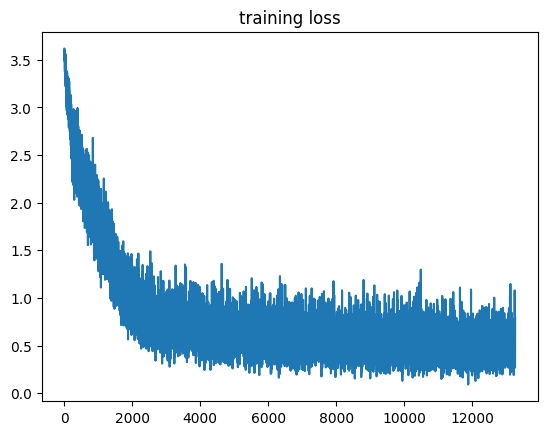

In [38]:
plt.plot(train_losses)
plt.title("training loss")

Text(0.5, 1.0, 'test accuracy')

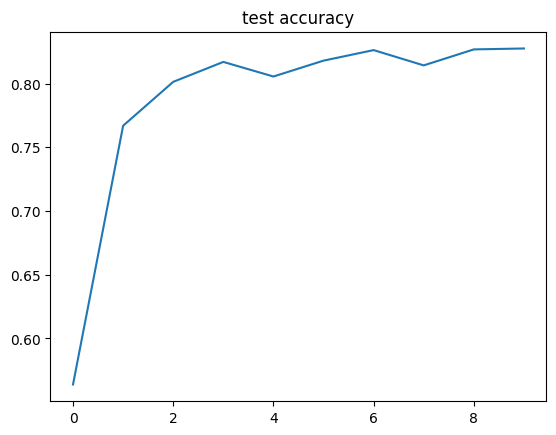

In [39]:
plt.plot(test_accuracy)
plt.title("test accuracy")

In [40]:
train_losses1 = train_losses
test_accuracy1 = test_accuracy

In [41]:
win_params1_list = model.conv1.window_params.detach().cpu().numpy()
win_params2_list = model.conv3.window_params.detach().cpu().numpy()
print(win_params1_list.shape)
print(win_params2_list.shape)

(128, 1, 2)
(128, 128, 3)


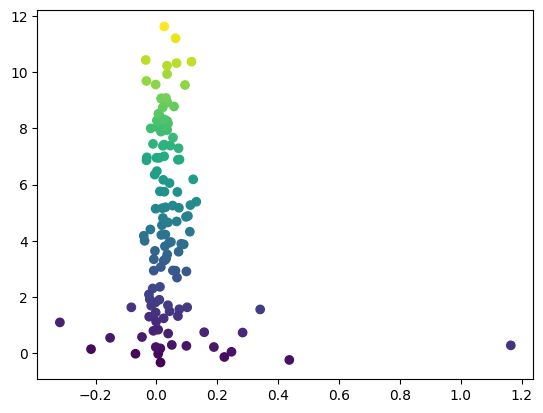

In [42]:
w1x = win_params1_list[..., 0].flatten()
w1y = win_params1_list[..., 1].flatten()
w1c = w1x + w1y
plt.scatter(w1x, w1y, c=w1c)

In [43]:
from mpl_toolkits import mplot3d

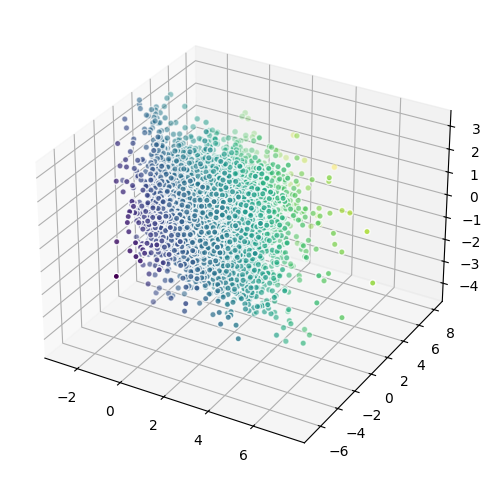

In [44]:
fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection ='3d')

w2x = win_params2_list[...,0].flatten()
w2y = win_params2_list[...,1].flatten()
w2z = win_params2_list[...,2].flatten()
w2c = w2x + w2y
ax.set_xlim([w2x.min() - 0.1, w2x.max() + 0.1])
ax.set_ylim([w2y.min() - 0.1, w2y.max() + 0.1])
ax.set_zlim([w2z.min() - 0.1, w2z.max() + 0.1])
ax.scatter(w2x, w2y, w2z, c=w2c, edgecolor='white')

In [45]:
lowcut_bands1_m2 = model.conv1.lowcut_bands.detach().cpu().numpy()
bandwidths1_m2 = model.conv1.bandwidths.detach().cpu().numpy()
lowcut_bands2_m2 = model.conv3.lowcut_bands.detach().cpu().numpy()
bandwidths2_m2 = model.conv3.bandwidths.detach().cpu().numpy()

(array([2048., 3456., 3328., 2432., 2176., 1280.,  640.,  512.,  256.,
         256.]),
 array([0.0035846 , 0.0073439 , 0.01110321, 0.01486251, 0.01862181,
        0.02238112, 0.02614042, 0.02989972, 0.03365903, 0.03741833,
        0.04117763]),
 <BarContainer object of 10 artists>)

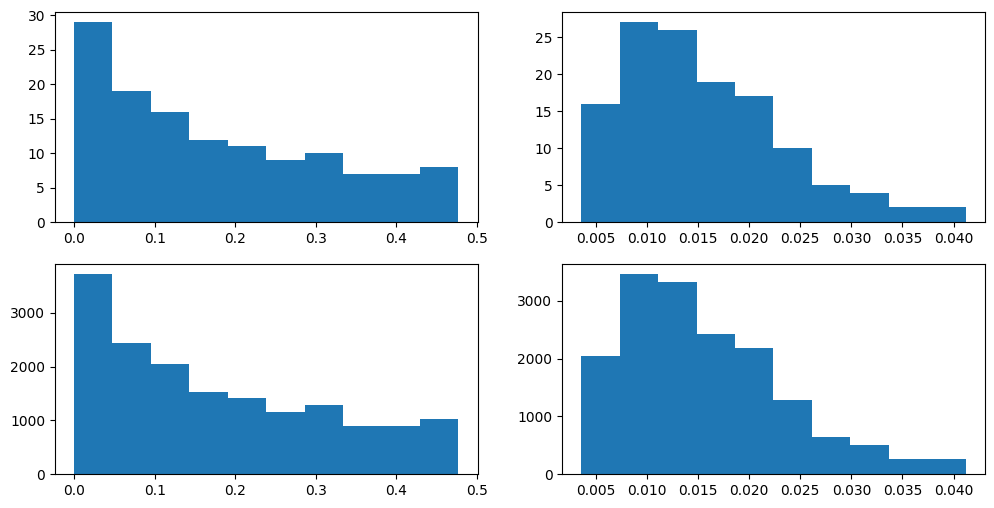

In [46]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,6))
axes[0,0].hist(lowcut_bands1_m2.flatten())
axes[0,1].hist(bandwidths1_m2.flatten())
axes[1,0].hist(lowcut_bands2_m2.flatten())
axes[1,1].hist(bandwidths2_m2.flatten())

In [50]:
import numpy as np
import pandas as pd

/tmp/ipykernel_101970/1662815981.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [51]:
y_n_bin = 5
y_bins = np.linspace(0.,lowcut_bands1_m2.max(), y_n_bin+1)
x_n_bin = 3
x_bins = np.linspace(0.,bandwidths1_m2.max(), x_n_bin+1)

df = pd.DataFrame(data={
    'lowcut': lowcut_bands1_m2.flatten(), 
    'bandwidth': bandwidths1_m2.flatten(), 
    'window_params': list(rearrange(win_params1_list, 'h c p -> (h c) p')) 
})
df

lowcut  bandwidth              window_params
0    0.000000   0.003585    [1.1639469, 0.27501765]
1    0.003585   0.003878   [0.18867521, 0.21547994]
2    0.007463   0.004196   [-0.1522468, 0.54292595]
3    0.011659   0.004540    [-0.02381043, 1.295085]
4    0.016199   0.004912   [0.043152545, 1.4873835]
..        ...        ...                        ...
123  0.389959   0.020805    [0.026049925, 8.315996]
124  0.410764   0.021390    [0.11154497, 5.2678986]
125  0.432154   0.021991    [-0.035261117, 10.4313]
126  0.454145   0.022610   [-0.032975793, 9.685932]
127  0.476755   0.023245  [0.038484666, 0.69608253]

[128 rows x 3 columns]

In [52]:
import math
import seaborn as sns
sns.set_theme(style="dark")

In [53]:
win_length = 17
df['lowcut_bin'] = df['lowcut'].apply(lambda x: 
                   max(math.ceil(x/lowcut_bands1_m2.max()*y_n_bin)-1, 0))
df['bandwidth_bin'] = df['bandwidth'].apply(lambda x: 
                   max(math.ceil(x/bandwidths1_m2.max()*x_n_bin)-1, 0))
df['window'] = df['window_params'].apply(lambda x:
                   general_cosine_window(win_length, x).numpy().flatten())
df['order'] = df.apply(
    lambda x: (y_n_bin -1 - x['lowcut_bin'])*x_n_bin + x['bandwidth_bin'], 
    axis=1)

In [54]:
df['order'].value_counts()

order
12    48
7     20
9     14
10    14
4     13
1      8
2      7
5      4
Name: count, dtype: int64

In [55]:
from einops import repeat

In [56]:
lowcut_bands1_m2.shape

(128, 1)

In [57]:
h, c = lowcut_bands1_m2.shape
df_expanded = pd.DataFrame(data={
    'lowcut': repeat(lowcut_bands1_m2, 'h c -> (h c k)', k=win_length), 
    'bandwidth': repeat(bandwidths1_m2, 'h c -> (h c k)', k=win_length),  
    'window': np.hstack(df['window'].values),
    'window_t': repeat(np.arange(win_length), 'k -> (h c k)', h=h, c=c, k=win_length),
    'lowcut_bin': repeat(df['lowcut_bin'].values, '(h c) -> (h c k)', h=h, c=c, k=win_length),
    'bandwidth_bin': repeat(df['bandwidth_bin'].values, '(h c) -> (h c k)', h=h, c=c, k=win_length),
    'order': repeat(df['order'].values, '(h c) -> (h c k)', h=h, c=c, k=win_length), 
    'win_id': repeat(np.arange(h*c), '(h c)-> (h c k)', h=h, c=c, k=win_length)
})
df_expanded

lowcut  bandwidth    window  window_t  lowcut_bin  bandwidth_bin  \
0     0.000000   0.003585  0.888929         0           0              0   
1     0.000000   0.003585  0.909864         1           0              0   
2     0.000000   0.003585  0.969480         2           0              0   
3     0.000000   0.003585  1.058702         3           0              0   
4     0.000000   0.003585  1.163947         4           0              0   
...        ...        ...       ...       ...         ...            ...   
2171  0.476755   0.023245  0.038485        12           4              1   
2172  0.476755   0.023245 -0.227895        13           4              1   
2173  0.476755   0.023245 -0.453720        14           4              1   
2174  0.476755   0.023245 -0.604612        15           4              1   
2175  0.476755   0.023245 -0.657598        16           4              1   

      order  win_id  
0        12       0  
1        12       0  
2        12       0  
3        12       0  
4        12       0  
...     ...     ...  
2171      1     127  
2172      1     127  
2173      1     127  
2174      1     127  
2175      1     127  

[2176 rows x 8 columns]

In [58]:
df_expanded['window_t'].describe()

count    2176.000000
mean        8.000000
std         4.900106
min         0.000000
25%         4.000000
50%         8.000000
75%        12.000000
max        16.000000
Name: window_t, dtype: float64

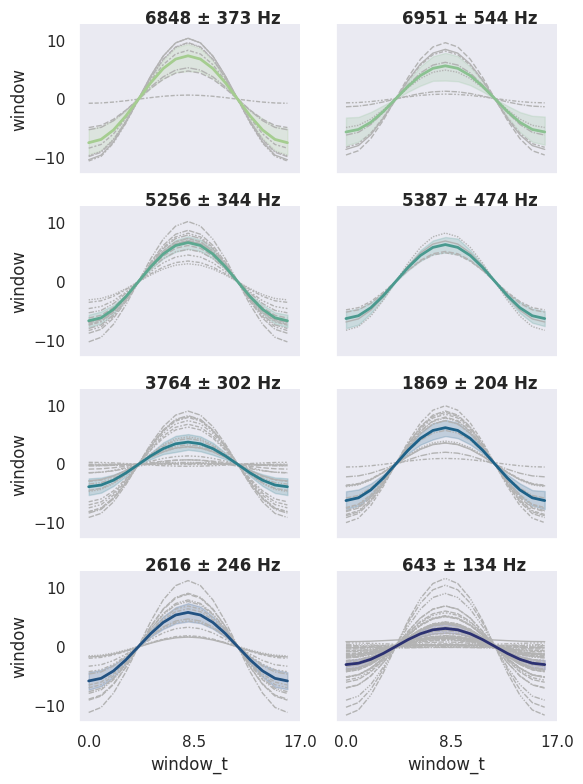

In [59]:
g = sns.relplot(
    data=df_expanded,
    x="window_t", 
    y='window', 
    col="order", hue="order",
    kind="line", palette="crest", linewidth=2, zorder=5,
    col_wrap=2, 
    height=2, aspect=1.5, legend=False,
)

for order, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    sub_df = df_expanded[df_expanded['order']==order]
    subtitle = f"{int(sub_df['lowcut'].mean()*16000)} ± {int(sub_df['bandwidth'].mean()*16000)} Hz"
    ax.text(.3, 1, subtitle, transform=ax.transAxes, fontweight="bold")

    # Plot every window in the background
    sns.lineplot(
        data=sub_df, 
        x="window_t", 
        y="window", 
        units="order",
        estimator=None, color=".7", linewidth=1, ax=ax, 
        style="win_id", legend=False
    )
    
ax.set_xticks(np.linspace(0, win_length,3))
g.set_titles("")
g.tight_layout()

In [60]:
from IConNet.signal import get_window_freq_response

[ 0.00000000e+00 -5.27058071e-02 -2.11205151e-01 -4.76659184e-01
 -8.51055920e-01 -1.33729479e+00 -1.93931687e+00 -2.66229522e+00
 -3.51290849e+00 -4.49973525e+00 -5.63383007e+00 -6.92958571e+00
 -8.40606515e+00 -1.00891466e+01 -1.20151631e+01 -1.42375022e+01
 -1.68396645e+01 -1.99643366e+01 -2.38902362e+01 -2.93005519e+01
 -3.89782203e+01 -4.49406926e+01 -3.53460741e+01 -3.24789671e+01
 -3.15292086e+01 -3.16474180e+01 -3.25739960e+01 -3.42685052e+01
 -3.68636788e+01 -4.08035446e+01 -4.76829432e+01 -7.20154134e+01
 -4.84522389e+01 -4.39803253e+01 -4.20991555e+01 -4.14945461e+01
 -4.17867830e+01 -4.28747530e+01 -4.48284587e+01 -4.79579203e+01
 -5.32763101e+01 -6.77276609e+01 -5.89094487e+01 -5.25298907e+01
 -4.98539850e+01 -4.87076746e+01 -4.85469947e+01 -4.92049660e+01
 -5.06976993e+01 -5.32394545e+01 -5.75108930e+01 -6.66305559e+01
 -6.93195819e+01 -5.97533670e+01 -5.62035092e+01 -5.45475166e+01
 -5.39924257e+01 -5.42901605e+01 -5.54047727e+01 -5.74768372e+01
 -6.09784398e+01 -6.76680

<Axes: >

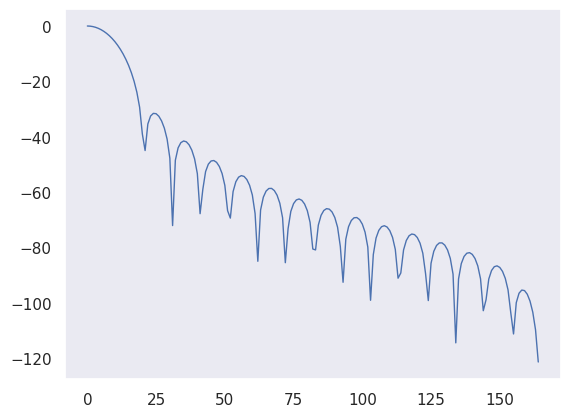

In [61]:
testresponse = get_window_freq_response(general_cosine_window(33,[0.5,0.5]))
tt = (testresponse.shape[-1]//2)
test_plt = testresponse[:tt]
print(test_plt)
sns.lineplot(test_plt, linewidth=1)

In [62]:
full_window_response_length = win_length*10
window_response_length = full_window_response_length
df['window_response'] = df['window'].apply(lambda x:
                   get_window_freq_response(x)[:window_response_length])

In [63]:
freq = np.fft.fftfreq(full_window_response_length,d=1/2)[:window_response_length]

In [64]:
h, c = lowcut_bands1_m2.shape
dff_expanded = pd.DataFrame(data={
    'lowcut': repeat(lowcut_bands1_m2, 'h c -> (h c k)', k=window_response_length), 
    'bandwidth': repeat(bandwidths1_m2, 'h c -> (h c k)', k=window_response_length),  
    'window_response': np.hstack(df['window_response'].values),
    'window_t': repeat(freq, 
                       'k -> (h c k)', h=h, c=c, k=window_response_length),
    'lowcut_bin': repeat(df['lowcut_bin'].values, 
                         '(h c) -> (h c k)', h=h, c=c, k=window_response_length),
    'bandwidth_bin': repeat(df['bandwidth_bin'].values, 
                            '(h c) -> (h c k)', h=h, c=c, k=window_response_length),
    'order': repeat(df['order'].values, 
                    '(h c) -> (h c k)', h=h, c=c, k=window_response_length), 
    'win_id': repeat(np.arange(h*c), '(h c)-> (h c k)', h=h, c=c, k=window_response_length)
})
dff_expanded

lowcut  bandwidth  window_response  window_t  lowcut_bin  \
0      0.000000   0.003585    -9.643275e-16  0.000000           0   
1      0.000000   0.003585    -1.217471e-01  0.011765           0   
2      0.000000   0.003585    -4.904743e-01  0.023529           0   
3      0.000000   0.003585    -1.117144e+00  0.035294           0   
4      0.000000   0.003585    -2.021882e+00  0.047059           0   
...         ...        ...              ...       ...         ...   
21755  0.476755   0.023245    -7.974091e+00 -0.058824           4   
21756  0.476755   0.023245    -1.141559e+01 -0.047059           4   
21757  0.476755   0.023245    -1.617734e+01 -0.035294           4   
21758  0.476755   0.023245    -2.339717e+01 -0.023529           4   
21759  0.476755   0.023245    -3.822612e+01 -0.011765           4   

       bandwidth_bin  order  win_id  
0                  0     12       0  
1                  0     12       0  
2                  0     12       0  
3                  0     12       0  
4                  0     12       0  
...              ...    ...     ...  
21755              1      1     127  
21756              1      1     127  
21757              1      1     127  
21758              1      1     127  
21759              1      1     127  

[21760 rows x 8 columns]

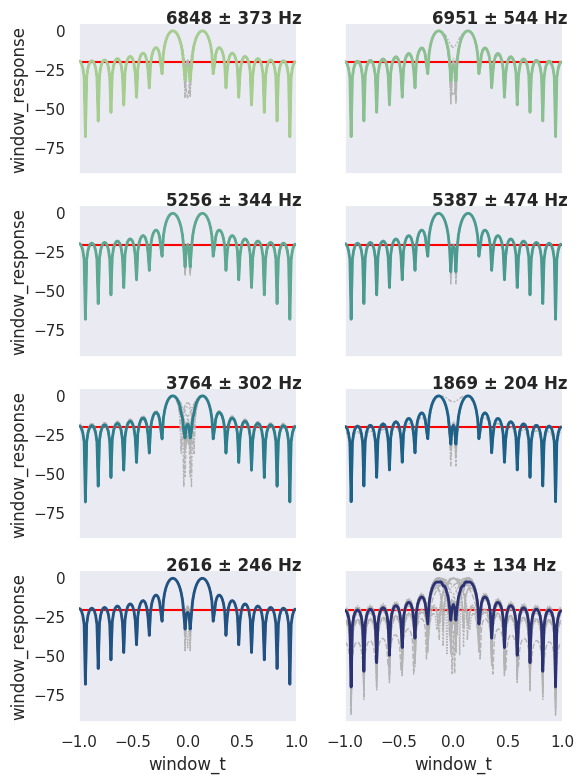

In [65]:
# sns.set(rc={'figure.figsize':(20,16)})
g = sns.relplot(
    data=dff_expanded,
    x="window_t", 
    y='window_response', 
    col="order", hue="order",
    # row='lowcut_bin', col='bandwidth_bin',
    kind="line", palette="crest", linewidth=2, zorder=5,
    col_wrap=2, 
    height=2, aspect=1.5, legend=False,
)

for order, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    sub_df = dff_expanded[dff_expanded['order']==order]
    subtitle = f"{int(sub_df['lowcut'].mean()*16000)} ± {int(sub_df['bandwidth'].mean()*16000)} Hz"
    ax.text(.4, 1, subtitle, transform=ax.transAxes, fontweight="bold")
    ax.axhline(-20, color='red', zorder=1)
    
    # Plot every window in the background
    sns.lineplot(
        data=sub_df, 
        x="window_t", 
        y="window_response", 
        units="order",
        estimator=None, color=".7", linewidth=1, ax=ax, 
        style="win_id", legend=False
    )

    
    
# ax.set_xticks(np.linspace(0, win_length,3))
g.set_titles("")
g.set(xlim=[-1,1])
g.tight_layout()

In [ ]:
n_epoch = 10
n_epoch2 = 990
optimizer = optim.RAdam(model.parameters(), lr=0.0005)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.1,
    steps_per_epoch=len(train_loader), epochs=n_epoch2)

log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch2) as pbar:
    for epoch in range(n_epoch+1, n_epoch + 1+n_epoch2):
        train(model, epoch, log_interval)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                    | 0.0026702269692923898/990 [00:00<24:59:18, 90.87s/it]

Train Epoch: 11 [0/84843 (0%)]	Loss: 0.712847


  0%|                     | 0.029372496662216304/990 [00:02<23:36:49, 85.87s/it]

Train Epoch: 11 [2560/84843 (3%)]	Loss: 0.229990


  0%|                      | 0.05607476635514024/990 [00:04<23:33:30, 85.67s/it]

Train Epoch: 11 [5120/84843 (6%)]	Loss: 0.369144


  0%|                      | 0.08277703604806397/990 [00:07<25:36:47, 93.15s/it]

Train Epoch: 11 [7680/84843 (9%)]	Loss: 0.211309


  0%|                      | 0.10947930574098763/990 [00:09<23:42:13, 86.21s/it]

Train Epoch: 11 [10240/84843 (12%)]	Loss: 0.350321


  0%|                      | 0.13618157543391152/990 [00:11<23:27:20, 85.30s/it]

Train Epoch: 11 [12800/84843 (15%)]	Loss: 0.222604


  0%|                      | 0.16288384512683574/990 [00:14<24:27:09, 88.93s/it]

Train Epoch: 11 [15360/84843 (18%)]	Loss: 0.352663


  0%|                      | 0.18958611481975995/990 [00:16<23:52:24, 86.83s/it]

Train Epoch: 11 [17920/84843 (21%)]	Loss: 0.350639


  0%|                      | 0.21628838451268417/990 [00:19<25:10:35, 91.57s/it]

Train Epoch: 11 [20480/84843 (24%)]	Loss: 0.335095


  0%|                       | 0.2429906542056084/990 [00:21<23:43:26, 86.29s/it]

Train Epoch: 11 [23040/84843 (27%)]	Loss: 0.390535


  0%|                       | 0.2696929238985326/990 [00:23<24:06:08, 87.67s/it]

Train Epoch: 11 [25600/84843 (30%)]	Loss: 0.283458


  0%|                      | 0.29639519359145683/990 [00:26<24:53:03, 90.52s/it]

Train Epoch: 11 [28160/84843 (33%)]	Loss: 0.327755


  0%|                      | 0.32309746328438105/990 [00:28<26:29:26, 96.36s/it]

Train Epoch: 11 [30720/84843 (36%)]	Loss: 0.271415


  0%|                     | 0.34979973297730527/990 [00:31<27:35:07, 100.35s/it]

Train Epoch: 11 [33280/84843 (39%)]	Loss: 0.377547


  0%|                       | 0.3765020026702295/990 [00:34<26:12:21, 95.33s/it]

Train Epoch: 11 [35840/84843 (42%)]	Loss: 0.201193


  0%|                       | 0.4032042723631537/990 [00:36<25:39:15, 93.33s/it]

Train Epoch: 11 [38400/84843 (45%)]	Loss: 0.251226


  0%|                       | 0.4299065420560779/990 [00:38<24:58:12, 90.84s/it]

Train Epoch: 11 [40960/84843 (48%)]	Loss: 0.634089


  0%|                      | 0.45660881174900214/990 [00:41<24:33:05, 89.32s/it]

Train Epoch: 11 [43520/84843 (51%)]	Loss: 0.260915


  0%|                     | 0.48331108144192636/990 [00:43<27:34:29, 100.32s/it]

Train Epoch: 11 [46080/84843 (54%)]	Loss: 0.236128


  0%|                       | 0.5100133511348506/990 [00:46<24:02:54, 87.49s/it]

Train Epoch: 11 [48640/84843 (57%)]	Loss: 0.317358


  0%|                       | 0.5367156208277748/990 [00:48<24:30:31, 89.17s/it]

Train Epoch: 11 [51200/84843 (60%)]	Loss: 0.429676


  0%|                        | 0.563417890520699/990 [00:50<23:41:38, 86.21s/it]

Train Epoch: 11 [53760/84843 (63%)]	Loss: 0.530156


  0%|                       | 0.5901201602136232/990 [00:53<23:35:32, 85.84s/it]

Train Epoch: 11 [56320/84843 (66%)]	Loss: 0.655289


  0%|                       | 0.6168224299065475/990 [00:55<23:56:15, 87.10s/it]

Train Epoch: 11 [58880/84843 (69%)]	Loss: 0.257588


  0%|                       | 0.6435246995994717/990 [00:57<23:33:38, 85.73s/it]

Train Epoch: 11 [61440/84843 (72%)]	Loss: 0.272996


  0%|                       | 0.6702269692923959/990 [01:00<24:26:53, 88.96s/it]

Train Epoch: 11 [64000/84843 (75%)]	Loss: 0.181227


  0%|                       | 0.6969292389853201/990 [01:02<23:38:42, 86.04s/it]

Train Epoch: 11 [66560/84843 (78%)]	Loss: 0.163346


  0%|                       | 0.7236315086782443/990 [01:04<24:23:43, 88.78s/it]

Train Epoch: 11 [69120/84843 (81%)]	Loss: 0.346186


  0%|                       | 0.7503337783711685/990 [01:07<23:48:05, 86.62s/it]

Train Epoch: 11 [71680/84843 (84%)]	Loss: 0.518356


  0%|                       | 0.7770360480640928/990 [01:09<23:55:30, 87.07s/it]

Train Epoch: 11 [74240/84843 (87%)]	Loss: 0.160667


  0%|                        | 0.803738317757017/990 [01:12<23:47:19, 86.57s/it]

Train Epoch: 11 [76800/84843 (90%)]	Loss: 0.261692


  0%|                       | 0.8304405874499412/990 [01:14<24:00:16, 87.36s/it]

Train Epoch: 11 [79360/84843 (94%)]	Loss: 0.330225


  0%|                       | 0.8571428571428654/990 [01:16<23:52:03, 86.87s/it]

Train Epoch: 11 [81920/84843 (97%)]	Loss: 0.398659


  0%|                       | 0.8838451268357896/990 [01:19<24:44:44, 90.07s/it]

Train Epoch: 11 [84480/84843 (100%)]	Loss: 0.413154


  0%|                       | 1.0020026702269793/990 [01:24<12:56:12, 47.09s/it]


Test Epoch: 11	Accuracy: 9400/11005 (85%)

Train Epoch: 12 [0/84843 (0%)]	Loss: 0.564296


  0%|                       | 1.0293724966622266/990 [01:26<23:27:20, 85.38s/it]

Train Epoch: 12 [2560/84843 (3%)]	Loss: 0.192892


  0%|                       | 1.0560747663551509/990 [01:29<24:26:14, 88.96s/it]

Train Epoch: 12 [5120/84843 (6%)]	Loss: 0.422457


  0%|                        | 1.082777036048075/990 [01:31<24:17:28, 88.43s/it]

Train Epoch: 12 [7680/84843 (9%)]	Loss: 0.369370


  0%|                       | 1.1094793057409993/990 [01:33<24:06:58, 87.79s/it]

Train Epoch: 12 [10240/84843 (12%)]	Loss: 0.365060


  0%|                      | 1.1361815754339235/990 [01:36<29:31:18, 107.48s/it]

Train Epoch: 12 [12800/84843 (15%)]	Loss: 0.344429


  0%|                       | 1.1628838451268477/990 [01:38<27:05:08, 98.61s/it]

Train Epoch: 12 [15360/84843 (18%)]	Loss: 0.323318


  0%|                        | 1.189586114819772/990 [01:41<26:06:02, 95.03s/it]

Train Epoch: 12 [17920/84843 (21%)]	Loss: 0.354226


  0%|                       | 1.2162883845126962/990 [01:44<25:25:22, 92.56s/it]

Train Epoch: 12 [20480/84843 (24%)]	Loss: 0.629834


  0%|                       | 1.2429906542056204/990 [01:46<24:17:11, 88.43s/it]

Train Epoch: 12 [23040/84843 (27%)]	Loss: 0.276723


  0%|                       | 1.2696929238985446/990 [01:48<24:27:24, 89.05s/it]

Train Epoch: 12 [25600/84843 (30%)]	Loss: 0.310895


  0%|                       | 1.2963951935914688/990 [01:51<24:27:45, 89.07s/it]

Train Epoch: 12 [28160/84843 (33%)]	Loss: 0.349516


  0%|                        | 1.323097463284393/990 [01:53<23:53:45, 87.01s/it]

Train Epoch: 12 [30720/84843 (36%)]	Loss: 0.140856


  0%|                       | 1.3497997329773173/990 [01:56<25:20:23, 92.27s/it]

Train Epoch: 12 [33280/84843 (39%)]	Loss: 0.337350


  0%|                       | 1.3765020026702415/990 [01:58<25:14:38, 91.92s/it]

Train Epoch: 12 [35840/84843 (42%)]	Loss: 0.171303


  0%|                       | 1.4032042723631657/990 [02:00<25:00:15, 91.05s/it]

Train Epoch: 12 [38400/84843 (45%)]	Loss: 0.393350


  0%|                         | 1.42990654205609/990 [02:03<24:22:34, 88.77s/it]

Train Epoch: 12 [40960/84843 (48%)]	Loss: 0.421394


  0%|                       | 1.4566088117490141/990 [02:05<23:59:04, 87.35s/it]

Train Epoch: 12 [43520/84843 (51%)]	Loss: 0.282119


  0%|                       | 1.4833110814419384/990 [02:08<24:00:20, 87.42s/it]

Train Epoch: 12 [46080/84843 (54%)]	Loss: 0.449081


  0%|                       | 1.5100133511348626/990 [02:10<23:41:52, 86.31s/it]

Train Epoch: 12 [48640/84843 (57%)]	Loss: 0.271585


  0%|                       | 1.5367156208277868/990 [02:12<23:42:01, 86.32s/it]

Train Epoch: 12 [51200/84843 (60%)]	Loss: 0.267877


  0%|                        | 1.563417890520711/990 [02:15<23:42:48, 86.37s/it]

Train Epoch: 12 [53760/84843 (63%)]	Loss: 0.433692


  0%|                       | 1.5901201602136352/990 [02:17<24:05:21, 87.74s/it]

Train Epoch: 12 [56320/84843 (66%)]	Loss: 0.180508


  0%|                       | 1.6168224299065594/990 [02:19<26:04:27, 94.97s/it]

Train Epoch: 12 [58880/84843 (69%)]	Loss: 0.265354


  0%|                       | 1.6435246995994837/990 [02:22<24:23:54, 88.87s/it]

Train Epoch: 12 [61440/84843 (72%)]	Loss: 0.252770


  0%|                       | 1.6702269692924079/990 [02:24<25:09:41, 91.65s/it]

Train Epoch: 12 [64000/84843 (75%)]	Loss: 0.399758


  0%|                        | 1.696929238985332/990 [02:27<24:41:08, 89.92s/it]

Train Epoch: 12 [66560/84843 (78%)]	Loss: 0.397484


  0%|                       | 1.7236315086782563/990 [02:29<24:19:53, 88.63s/it]

Train Epoch: 12 [69120/84843 (81%)]	Loss: 0.273159


  0%|                       | 1.7503337783711805/990 [02:32<25:13:57, 91.92s/it]

Train Epoch: 12 [71680/84843 (84%)]	Loss: 0.220147


  0%|                       | 1.7770360480641048/990 [02:34<24:45:40, 90.20s/it]

Train Epoch: 12 [74240/84843 (87%)]	Loss: 0.126348


  0%|                        | 1.803738317757029/990 [02:37<25:10:50, 91.73s/it]

Train Epoch: 12 [76800/84843 (90%)]	Loss: 0.354451


  0%|                       | 1.8304405874499532/990 [02:39<25:27:27, 92.74s/it]

Train Epoch: 12 [79360/84843 (94%)]	Loss: 0.291263


  0%|                       | 1.8571428571428774/990 [02:42<26:35:00, 96.85s/it]

Train Epoch: 12 [81920/84843 (97%)]	Loss: 0.332912


  0%|                       | 1.8838451268358016/990 [02:44<25:08:34, 91.60s/it]

Train Epoch: 12 [84480/84843 (100%)]	Loss: 0.196667


  0%|                       | 2.0020026702269904/990 [02:49<13:36:44, 49.60s/it]


Test Epoch: 12	Accuracy: 9412/11005 (86%)

Train Epoch: 13 [0/84843 (0%)]	Loss: 0.362125


  0%|                       | 2.0293724966622286/990 [02:52<24:40:29, 89.91s/it]

Train Epoch: 13 [2560/84843 (3%)]	Loss: 0.257347


  0%|                        | 2.056074766355144/990 [02:54<24:28:36, 89.19s/it]

Train Epoch: 13 [5120/84843 (6%)]	Loss: 0.147096


  0%|                       | 2.0827770360480593/990 [02:57<24:18:46, 88.60s/it]

Train Epoch: 13 [7680/84843 (9%)]	Loss: 0.246978


  0%|                       | 2.1094793057409746/990 [02:59<24:13:56, 88.31s/it]

Train Epoch: 13 [10240/84843 (12%)]	Loss: 0.322377


  0%|                         | 2.13618157543389/990 [03:01<24:13:10, 88.26s/it]

Train Epoch: 13 [12800/84843 (15%)]	Loss: 0.274512


  0%|                       | 2.1628838451268053/990 [03:04<24:02:17, 87.60s/it]

Train Epoch: 13 [15360/84843 (18%)]	Loss: 0.430414


  0%|                       | 2.1895861148197207/990 [03:06<25:06:50, 91.53s/it]

Train Epoch: 13 [17920/84843 (21%)]	Loss: 0.348658


  0%|                        | 2.216288384512636/990 [03:09<25:10:55, 91.78s/it]

Train Epoch: 13 [20480/84843 (24%)]	Loss: 0.237361


  0%|                       | 2.2429906542055513/990 [03:11<24:04:14, 87.73s/it]

Train Epoch: 13 [23040/84843 (27%)]	Loss: 0.406615


  0%|                       | 2.2696929238984667/990 [03:13<24:22:44, 88.85s/it]

Train Epoch: 13 [25600/84843 (30%)]	Loss: 0.288712


  0%|                        | 2.296395193591382/990 [03:16<23:58:03, 87.36s/it]

Train Epoch: 13 [28160/84843 (33%)]	Loss: 0.368549


  0%|                       | 2.3230974632842973/990 [03:18<23:50:09, 86.88s/it]

Train Epoch: 13 [30720/84843 (36%)]	Loss: 0.190247


  0%|                       | 2.3497997329772127/990 [03:20<24:12:25, 88.23s/it]

Train Epoch: 13 [33280/84843 (39%)]	Loss: 0.301219


  0%|                        | 2.376502002670128/990 [03:23<24:40:15, 89.93s/it]

Train Epoch: 13 [35840/84843 (42%)]	Loss: 0.291087


  0%|                       | 2.4032042723630433/990 [03:25<23:54:57, 87.18s/it]

Train Epoch: 13 [38400/84843 (45%)]	Loss: 0.360805


  0%|                       | 2.4299065420559587/990 [03:27<23:58:16, 87.38s/it]

Train Epoch: 13 [40960/84843 (48%)]	Loss: 0.489179


  0%|                        | 2.456608811748874/990 [03:30<24:26:29, 89.10s/it]

Train Epoch: 13 [43520/84843 (51%)]	Loss: 0.203387


  0%|                       | 2.4833110814417894/990 [03:32<23:59:55, 87.49s/it]

Train Epoch: 13 [46080/84843 (54%)]	Loss: 0.179230


  0%|                       | 2.5100133511347047/990 [03:34<23:53:43, 87.11s/it]

Train Epoch: 13 [48640/84843 (57%)]	Loss: 0.220845


  0%|                         | 2.53671562082762/990 [03:37<23:58:39, 87.42s/it]

Train Epoch: 13 [51200/84843 (60%)]	Loss: 0.223523


  0%|                       | 2.5634178905205354/990 [03:39<24:05:10, 87.81s/it]

Train Epoch: 13 [53760/84843 (63%)]	Loss: 0.235392


  0%|                       | 2.5901201602134507/990 [03:41<23:55:40, 87.24s/it]

Train Epoch: 13 [56320/84843 (66%)]	Loss: 0.346004


  0%|                        | 2.616822429906366/990 [03:44<26:32:02, 96.74s/it]

Train Epoch: 13 [58880/84843 (69%)]	Loss: 0.484714


  0%|                       | 2.6435246995992814/990 [03:46<26:51:24, 97.92s/it]

Train Epoch: 13 [61440/84843 (72%)]	Loss: 0.356717


  0%|                       | 2.6702269692921967/990 [03:49<24:14:18, 88.38s/it]

Train Epoch: 13 [64000/84843 (75%)]	Loss: 0.667303


  0%|                        | 2.696929238985112/990 [03:51<24:35:36, 89.67s/it]

Train Epoch: 13 [66560/84843 (78%)]	Loss: 0.262658


  0%|                       | 2.7236315086780274/990 [03:54<24:22:37, 88.89s/it]

Train Epoch: 13 [69120/84843 (81%)]	Loss: 0.317109


  0%|                       | 2.7503337783709427/990 [03:56<24:16:37, 88.53s/it]

Train Epoch: 13 [71680/84843 (84%)]	Loss: 0.327351


  0%|                        | 2.777036048063858/990 [03:58<24:25:40, 89.08s/it]

Train Epoch: 13 [74240/84843 (87%)]	Loss: 0.485269


  0%|                       | 2.8037383177567734/990 [04:01<24:03:55, 87.76s/it]

Train Epoch: 13 [76800/84843 (90%)]	Loss: 0.548732


  0%|                      | 2.8304405874496887/990 [04:03<30:27:35, 111.08s/it]

Train Epoch: 13 [79360/84843 (94%)]	Loss: 0.653777


  0%|                        | 2.857142857142604/990 [04:06<24:57:37, 91.03s/it]

Train Epoch: 13 [81920/84843 (97%)]	Loss: 0.192617


  0%|                       | 2.8838451268355194/990 [04:08<25:02:00, 91.30s/it]

Train Epoch: 13 [84480/84843 (100%)]	Loss: 0.158256


  0%|                        | 3.000667556742024/990 [04:13<12:02:07, 43.90s/it]


Test Epoch: 13	Accuracy: 9458/11005 (86%)

Train Epoch: 14 [0/84843 (0%)]	Loss: 0.205238


  0%|                        | 3.029372496661908/990 [04:16<23:09:29, 84.47s/it]

Train Epoch: 14 [2560/84843 (3%)]	Loss: 0.448000


  0%|                       | 3.0560747663548233/990 [04:18<23:56:54, 87.35s/it]

Train Epoch: 14 [5120/84843 (6%)]	Loss: 0.560642


  0%|                       | 3.0827770360477387/990 [04:20<24:06:24, 87.93s/it]

Train Epoch: 14 [7680/84843 (9%)]	Loss: 0.367825


  0%|                        | 3.109479305740654/990 [04:23<24:26:44, 89.17s/it]

Train Epoch: 14 [10240/84843 (12%)]	Loss: 0.389117


  0%|                       | 3.1361815754335693/990 [04:25<24:06:49, 87.97s/it]

Train Epoch: 14 [12800/84843 (15%)]	Loss: 0.181262


  0%|                       | 3.1628838451264847/990 [04:27<25:28:00, 92.90s/it]

Train Epoch: 14 [15360/84843 (18%)]	Loss: 0.262590


  0%|                          | 3.1895861148194/990 [04:30<24:18:45, 88.70s/it]

Train Epoch: 14 [17920/84843 (21%)]	Loss: 0.301886


  0%|                       | 3.2162883845123154/990 [04:32<24:48:01, 90.48s/it]

Train Epoch: 14 [20480/84843 (24%)]	Loss: 0.355683


  0%|                       | 3.2429906542052307/990 [04:35<24:11:15, 88.24s/it]

Train Epoch: 14 [23040/84843 (27%)]	Loss: 0.306994


  0%|                        | 3.269692923898146/990 [04:37<23:58:04, 87.44s/it]

Train Epoch: 14 [25600/84843 (30%)]	Loss: 0.341003


  0%|                       | 3.2963951935910614/990 [04:39<24:04:31, 87.84s/it]

Train Epoch: 14 [28160/84843 (33%)]	Loss: 0.455016


  0%|                       | 3.3230974632839767/990 [04:42<26:11:35, 95.57s/it]

Train Epoch: 14 [30720/84843 (36%)]	Loss: 0.276897


  0%|                        | 3.349799732976892/990 [04:44<26:37:06, 97.12s/it]

Train Epoch: 14 [33280/84843 (39%)]	Loss: 0.436994


  0%|                       | 3.3765020026698074/990 [04:47<25:53:19, 94.46s/it]

Train Epoch: 14 [35840/84843 (42%)]	Loss: 0.318607


  0%|                       | 3.4032042723627227/990 [04:49<25:57:12, 94.70s/it]

Train Epoch: 14 [38400/84843 (45%)]	Loss: 0.364932


  0%|                        | 3.429906542055638/990 [04:52<25:10:58, 91.89s/it]

Train Epoch: 14 [40960/84843 (48%)]	Loss: 0.221485


  0%|                       | 3.4566088117485534/990 [04:54<24:28:33, 89.31s/it]

Train Epoch: 14 [43520/84843 (51%)]	Loss: 0.558836


  0%|                       | 3.4833110814414687/990 [04:57<24:04:50, 87.88s/it]

Train Epoch: 14 [46080/84843 (54%)]	Loss: 0.177096


  0%|                        | 3.510013351134384/990 [04:59<24:28:32, 89.32s/it]

Train Epoch: 14 [48640/84843 (57%)]	Loss: 0.340142


  0%|                       | 3.5367156208272994/990 [05:02<24:29:12, 89.36s/it]

Train Epoch: 14 [51200/84843 (60%)]	Loss: 0.271989


  0%|                       | 3.5634178905202147/990 [05:04<24:05:23, 87.92s/it]

Train Epoch: 14 [53760/84843 (63%)]	Loss: 0.406406


  0%|                         | 3.59012016021313/990 [05:06<24:33:00, 89.60s/it]

Train Epoch: 14 [56320/84843 (66%)]	Loss: 0.218933


  0%|                       | 3.6168224299060454/990 [05:09<24:48:42, 90.56s/it]

Train Epoch: 14 [58880/84843 (69%)]	Loss: 0.058062


  0%|                       | 3.6435246995989607/990 [05:11<24:19:14, 88.77s/it]

Train Epoch: 14 [61440/84843 (72%)]	Loss: 0.337730


  0%|                        | 3.670226969291876/990 [05:14<24:27:15, 89.26s/it]

Train Epoch: 14 [64000/84843 (75%)]	Loss: 0.320079


  0%|                       | 3.6969292389847914/990 [05:16<26:37:49, 97.20s/it]

Train Epoch: 14 [66560/84843 (78%)]	Loss: 0.492985


  0%|                       | 3.7236315086777068/990 [05:19<25:57:36, 94.76s/it]

Train Epoch: 14 [69120/84843 (81%)]	Loss: 0.309718


  0%|                        | 3.750333778370622/990 [05:21<24:08:39, 88.13s/it]

Train Epoch: 14 [71680/84843 (84%)]	Loss: 0.266090


  0%|                       | 3.7770360480635374/990 [05:23<24:52:31, 90.80s/it]

Train Epoch: 14 [74240/84843 (87%)]	Loss: 0.523742


  0%|                       | 3.8037383177564528/990 [05:26<24:38:39, 89.96s/it]

Train Epoch: 14 [76800/84843 (90%)]	Loss: 0.269235


  0%|                        | 3.830440587449368/990 [05:28<23:59:43, 87.59s/it]

Train Epoch: 14 [79360/84843 (94%)]	Loss: 0.778646


  0%|                       | 3.8571428571422834/990 [05:31<25:05:07, 91.58s/it]

Train Epoch: 14 [81920/84843 (97%)]	Loss: 0.654565


  0%|                        | 3.883845126835199/990 [05:33<24:40:45, 90.10s/it]

Train Epoch: 14 [84480/84843 (100%)]	Loss: 0.357664


  0%|                        | 4.001335113484027/990 [05:38<11:33:31, 42.20s/it]


Test Epoch: 14	Accuracy: 9326/11005 (85%)

Train Epoch: 15 [0/84843 (0%)]	Loss: 0.128097


  0%|                       | 4.0293724966616065/990 [05:40<23:54:08, 87.27s/it]

Train Epoch: 15 [2560/84843 (3%)]	Loss: 0.333962


  0%|                         | 4.05607476635454/990 [05:43<24:30:20, 89.48s/it]

Train Epoch: 15 [5120/84843 (6%)]	Loss: 0.174685


  0%|                        | 4.082777036047473/990 [05:45<23:57:08, 87.46s/it]

Train Epoch: 15 [7680/84843 (9%)]	Loss: 0.137127


  0%|                        | 4.109479305740406/990 [05:47<24:02:37, 87.80s/it]

Train Epoch: 15 [10240/84843 (12%)]	Loss: 0.323037


  0%|                        | 4.136181575433339/990 [05:50<24:31:17, 89.54s/it]

Train Epoch: 15 [12800/84843 (15%)]	Loss: 0.192313


  0%|                        | 4.162883845126272/990 [05:52<24:22:11, 88.99s/it]

Train Epoch: 15 [15360/84843 (18%)]	Loss: 0.538644


  0%|                        | 4.189586114819205/990 [05:55<24:59:39, 91.27s/it]

Train Epoch: 15 [17920/84843 (21%)]	Loss: 0.271994


  0%|                        | 4.216288384512138/990 [05:57<24:34:46, 89.76s/it]

Train Epoch: 15 [20480/84843 (24%)]	Loss: 0.311552


  0%|                        | 4.242990654205071/990 [05:59<24:45:30, 90.42s/it]

Train Epoch: 15 [23040/84843 (27%)]	Loss: 0.307908


  0%|                        | 4.269692923898004/990 [06:02<23:58:09, 87.54s/it]

Train Epoch: 15 [25600/84843 (30%)]	Loss: 0.464487


  0%|                       | 4.2963951935909375/990 [06:04<24:01:25, 87.74s/it]

Train Epoch: 15 [28160/84843 (33%)]	Loss: 0.271731


  0%|                        | 4.323097463283871/990 [06:06<24:21:12, 88.95s/it]

Train Epoch: 15 [30720/84843 (36%)]	Loss: 0.114432


  0%|                        | 4.349799732976804/990 [06:09<25:48:31, 94.26s/it]

Train Epoch: 15 [33280/84843 (39%)]	Loss: 0.245565


  0%|                        | 4.376502002669737/990 [06:11<24:04:53, 87.96s/it]

Train Epoch: 15 [35840/84843 (42%)]	Loss: 0.187871


  0%|                         | 4.40320427236267/990 [06:13<24:01:54, 87.78s/it]

Train Epoch: 15 [38400/84843 (45%)]	Loss: 0.232243


  0%|                        | 4.429906542055603/990 [06:16<24:34:55, 89.79s/it]

Train Epoch: 15 [40960/84843 (48%)]	Loss: 0.308724


  0%|                        | 4.456608811748536/990 [06:18<24:53:36, 90.93s/it]

Train Epoch: 15 [43520/84843 (51%)]	Loss: 0.298570


  0%|                        | 4.483311081441469/990 [06:21<25:10:26, 91.96s/it]

Train Epoch: 15 [46080/84843 (54%)]	Loss: 0.577306


  0%|                        | 4.510013351134402/990 [06:23<24:02:05, 87.80s/it]

Train Epoch: 15 [48640/84843 (57%)]	Loss: 0.434581


  0%|                        | 4.536715620827335/990 [06:25<24:08:54, 88.22s/it]

Train Epoch: 15 [51200/84843 (60%)]	Loss: 0.360681


  0%|                       | 4.5634178905202685/990 [06:28<24:01:44, 87.78s/it]

Train Epoch: 15 [53760/84843 (63%)]	Loss: 0.157268


  0%|                        | 4.590120160213202/990 [06:30<24:21:24, 88.98s/it]

Train Epoch: 15 [56320/84843 (66%)]	Loss: 0.263650


  0%|                        | 4.616822429906135/990 [06:33<24:05:06, 87.99s/it]

Train Epoch: 15 [58880/84843 (69%)]	Loss: 0.338506


  0%|                        | 4.643524699599068/990 [06:35<23:48:51, 87.01s/it]

Train Epoch: 15 [61440/84843 (72%)]	Loss: 0.274066


  0%|                        | 4.670226969292001/990 [06:37<24:02:35, 87.84s/it]

Train Epoch: 15 [64000/84843 (75%)]	Loss: 0.572047


  0%|                        | 4.696929238984934/990 [06:40<24:20:30, 88.94s/it]

Train Epoch: 15 [66560/84843 (78%)]	Loss: 0.555512


  0%|                        | 4.723631508677867/990 [06:42<24:11:24, 88.39s/it]

Train Epoch: 15 [69120/84843 (81%)]	Loss: 0.125787


  0%|                          | 4.7503337783708/990 [06:45<24:16:30, 88.70s/it]

Train Epoch: 15 [71680/84843 (84%)]	Loss: 0.106019


  0%|                        | 4.777036048063733/990 [06:47<24:02:44, 87.86s/it]

Train Epoch: 15 [74240/84843 (87%)]	Loss: 0.147396


  0%|                        | 4.803738317756666/990 [06:49<24:20:26, 88.94s/it]

Train Epoch: 15 [76800/84843 (90%)]	Loss: 0.498388


  0%|                       | 4.8304405874495995/990 [06:52<26:13:54, 95.86s/it]

Train Epoch: 15 [79360/84843 (94%)]	Loss: 0.245156


  0%|                        | 4.857142857142533/990 [06:54<25:04:59, 91.66s/it]

Train Epoch: 15 [81920/84843 (97%)]	Loss: 0.344526


  0%|                        | 4.883845126835466/990 [06:56<24:12:35, 88.47s/it]

Train Epoch: 15 [84480/84843 (100%)]	Loss: 0.537802


  1%|                        | 5.002002670226695/990 [07:01<12:40:15, 46.31s/it]


Test Epoch: 15	Accuracy: 9396/11005 (85%)

Train Epoch: 16 [0/84843 (0%)]	Loss: 0.416309


  1%|                        | 5.029372496661951/990 [07:04<23:16:45, 85.08s/it]

Train Epoch: 16 [2560/84843 (3%)]	Loss: 0.207888


  1%|                        | 5.056074766354884/990 [07:06<24:05:56, 88.08s/it]

Train Epoch: 16 [5120/84843 (6%)]	Loss: 0.347862


  1%|                        | 5.082777036047817/990 [07:08<24:01:03, 87.79s/it]

Train Epoch: 16 [7680/84843 (9%)]	Loss: 0.360744


  1%|▏                        | 5.10947930574075/990 [07:11<24:03:29, 87.94s/it]

Train Epoch: 16 [10240/84843 (12%)]	Loss: 0.328262


  1%|                       | 5.1361815754336835/990 [07:13<24:41:47, 90.27s/it]

Train Epoch: 16 [12800/84843 (15%)]	Loss: 0.146713


  1%|▏                       | 5.162883845126617/990 [07:16<24:56:34, 91.18s/it]

Train Epoch: 16 [15360/84843 (18%)]	Loss: 0.164137


  1%|▏                        | 5.18958611481955/990 [07:18<23:56:16, 87.51s/it]

Train Epoch: 16 [17920/84843 (21%)]	Loss: 0.258293


  1%|▏                       | 5.216288384512483/990 [07:20<23:53:16, 87.33s/it]

Train Epoch: 16 [20480/84843 (24%)]	Loss: 0.409651


  1%|▏                       | 5.242990654205416/990 [07:23<24:18:32, 88.87s/it]

Train Epoch: 16 [23040/84843 (27%)]	Loss: 0.381426


  1%|▏                       | 5.269692923898349/990 [07:25<24:13:13, 88.55s/it]

Train Epoch: 16 [25600/84843 (30%)]	Loss: 0.391638


  1%|▏                       | 5.296395193591282/990 [07:27<24:24:46, 89.25s/it]

Train Epoch: 16 [28160/84843 (33%)]	Loss: 0.200826


  1%|▏                       | 5.323097463284215/990 [07:30<24:04:55, 88.04s/it]

Train Epoch: 16 [30720/84843 (36%)]	Loss: 0.205157


  1%|▏                       | 5.349799732977148/990 [07:32<25:34:54, 93.53s/it]

Train Epoch: 16 [33280/84843 (39%)]	Loss: 0.232113


  1%|▏                       | 5.376502002670081/990 [07:35<25:53:16, 94.65s/it]

Train Epoch: 16 [35840/84843 (42%)]	Loss: 0.184079


  1%|▏                      | 5.4032042723630145/990 [07:37<24:34:32, 89.86s/it]

Train Epoch: 16 [38400/84843 (45%)]	Loss: 0.246844


  1%|▏                       | 5.429906542055948/990 [07:40<25:16:48, 92.44s/it]

Train Epoch: 16 [40960/84843 (48%)]	Loss: 0.147353


  1%|▏                       | 5.456608811748881/990 [07:42<25:56:12, 94.84s/it]

Train Epoch: 16 [43520/84843 (51%)]	Loss: 0.318808


  1%|▏                       | 5.483311081441814/990 [07:45<25:41:08, 93.92s/it]

Train Epoch: 16 [46080/84843 (54%)]	Loss: 0.193010


  1%|▏                       | 5.510013351134747/990 [07:47<24:28:21, 89.49s/it]

Train Epoch: 16 [48640/84843 (57%)]	Loss: 0.309885


  1%|▏                        | 5.53671562082768/990 [07:50<24:42:08, 90.33s/it]

Train Epoch: 16 [51200/84843 (60%)]	Loss: 0.225178


  1%|▏                       | 5.563417890520613/990 [07:52<24:58:32, 91.33s/it]

Train Epoch: 16 [53760/84843 (63%)]	Loss: 0.347444


  1%|▏                       | 5.590120160213546/990 [07:55<24:24:11, 89.24s/it]

Train Epoch: 16 [56320/84843 (66%)]	Loss: 0.371254


  1%|▏                       | 5.616822429906479/990 [07:57<24:12:46, 88.55s/it]

Train Epoch: 16 [58880/84843 (69%)]	Loss: 0.185361


  1%|▏                       | 5.643524699599412/990 [07:59<24:09:09, 88.33s/it]

Train Epoch: 16 [61440/84843 (72%)]	Loss: 0.493949


  1%|▏                      | 5.6702269692923455/990 [08:02<23:52:54, 87.34s/it]

Train Epoch: 16 [64000/84843 (75%)]	Loss: 0.300266


  1%|▏                       | 5.696929238985279/990 [08:04<24:06:32, 88.18s/it]

Train Epoch: 16 [66560/84843 (78%)]	Loss: 0.116172


  1%|▏                       | 5.723631508678212/990 [08:07<24:08:12, 88.28s/it]

Train Epoch: 16 [69120/84843 (81%)]	Loss: 0.327463


  1%|▏                       | 5.750333778371145/990 [08:09<24:17:36, 88.86s/it]

Train Epoch: 16 [71680/84843 (84%)]	Loss: 0.388672


  1%|▏                       | 5.777036048064078/990 [08:11<26:23:25, 96.53s/it]

Train Epoch: 16 [74240/84843 (87%)]	Loss: 0.121139


  1%|▏                       | 5.803738317757011/990 [08:14<23:56:53, 87.60s/it]

Train Epoch: 16 [76800/84843 (90%)]	Loss: 0.182079


  1%|▏                       | 5.830440587449944/990 [08:16<23:49:07, 87.13s/it]

Train Epoch: 16 [79360/84843 (94%)]	Loss: 0.393680


  1%|▏                       | 5.857142857142877/990 [08:19<24:04:01, 88.04s/it]

Train Epoch: 16 [81920/84843 (97%)]	Loss: 0.262394


  1%|▏                        | 5.88384512683581/990 [08:21<24:10:37, 88.44s/it]

Train Epoch: 16 [84480/84843 (100%)]	Loss: 0.348399


  1%|▏                       | 6.002002670227039/990 [08:26<12:32:21, 45.88s/it]


Test Epoch: 16	Accuracy: 9387/11005 (85%)

Train Epoch: 17 [0/84843 (0%)]	Loss: 0.141829


  1%|▏                       | 6.029372496662296/990 [08:28<23:50:19, 87.22s/it]

Train Epoch: 17 [2560/84843 (3%)]	Loss: 0.243473


  1%|▏                       | 6.056074766355229/990 [08:31<24:02:40, 87.97s/it]

Train Epoch: 17 [5120/84843 (6%)]	Loss: 0.202118


  1%|▏                       | 6.082777036048162/990 [08:33<24:08:08, 88.31s/it]

Train Epoch: 17 [7680/84843 (9%)]	Loss: 0.347169


  1%|▏                       | 6.109479305741095/990 [08:35<24:38:44, 90.18s/it]

Train Epoch: 17 [10240/84843 (12%)]	Loss: 0.244654


  1%|▏                       | 6.136181575434028/990 [08:38<24:07:15, 88.26s/it]

Train Epoch: 17 [12800/84843 (15%)]	Loss: 0.190536


  1%|▏                       | 6.162883845126961/990 [08:40<24:38:02, 90.14s/it]

Train Epoch: 17 [15360/84843 (18%)]	Loss: 0.276658


  1%|▏                       | 6.189586114819894/990 [08:42<23:57:45, 87.68s/it]

Train Epoch: 17 [17920/84843 (21%)]	Loss: 0.177229


  1%|▏                       | 6.216288384512827/990 [08:45<24:03:41, 88.05s/it]

Train Epoch: 17 [20480/84843 (24%)]	Loss: 0.355249


  1%|▏                      | 6.2429906542057605/990 [08:47<23:57:45, 87.69s/it]

Train Epoch: 17 [23040/84843 (27%)]	Loss: 0.289880


  1%|▏                       | 6.269692923898694/990 [08:50<24:03:24, 88.04s/it]

Train Epoch: 17 [25600/84843 (30%)]	Loss: 0.471169


  1%|▏                       | 6.296395193591627/990 [08:52<24:05:07, 88.14s/it]

Train Epoch: 17 [28160/84843 (33%)]	Loss: 0.293577


  1%|▏                        | 6.32309746328456/990 [08:54<23:54:49, 87.52s/it]

Train Epoch: 17 [30720/84843 (36%)]	Loss: 0.287326


  1%|▏                       | 6.349799732977493/990 [08:57<23:54:30, 87.50s/it]

Train Epoch: 17 [33280/84843 (39%)]	Loss: 0.368042


  1%|▏                       | 6.376502002670426/990 [08:59<24:18:52, 88.99s/it]

Train Epoch: 17 [35840/84843 (42%)]	Loss: 0.202966


  1%|▏                       | 6.403204272363359/990 [09:01<24:13:41, 88.68s/it]

Train Epoch: 17 [38400/84843 (45%)]	Loss: 0.348802


  1%|▏                       | 6.429906542056292/990 [09:04<24:16:28, 88.85s/it]

Train Epoch: 17 [40960/84843 (48%)]	Loss: 0.258297


  1%|▏                       | 6.456608811749225/990 [09:06<23:56:07, 87.61s/it]

Train Epoch: 17 [43520/84843 (51%)]	Loss: 0.231538


  1%|▏                       | 6.483311081442158/990 [09:08<24:07:44, 88.32s/it]

Train Epoch: 17 [46080/84843 (54%)]	Loss: 0.343848


  1%|▏                      | 6.5100133511350915/990 [09:11<24:04:07, 88.10s/it]

Train Epoch: 17 [48640/84843 (57%)]	Loss: 0.283675


  1%|▏                       | 6.536715620828025/990 [09:13<24:18:13, 88.97s/it]

Train Epoch: 17 [51200/84843 (60%)]	Loss: 0.382829


  1%|▏                       | 6.563417890520958/990 [09:16<24:11:34, 88.56s/it]

Train Epoch: 17 [53760/84843 (63%)]	Loss: 0.308068


  1%|▏                       | 6.590120160213891/990 [09:18<25:05:00, 91.82s/it]

Train Epoch: 17 [56320/84843 (66%)]	Loss: 0.127311


  1%|▏                       | 6.616822429906824/990 [09:21<26:44:55, 97.92s/it]

Train Epoch: 17 [58880/84843 (69%)]	Loss: 0.251572


  1%|▏                       | 6.643524699599757/990 [09:23<24:05:09, 88.18s/it]

Train Epoch: 17 [61440/84843 (72%)]	Loss: 0.307120


  1%|▏                        | 6.67022696929269/990 [09:25<23:56:38, 87.66s/it]

Train Epoch: 17 [64000/84843 (75%)]	Loss: 0.504577


  1%|▏                       | 6.696929238985623/990 [09:28<24:14:37, 88.76s/it]

Train Epoch: 17 [66560/84843 (78%)]	Loss: 0.301476


  1%|▏                       | 6.723631508678556/990 [09:30<23:55:35, 87.60s/it]

Train Epoch: 17 [69120/84843 (81%)]	Loss: 0.335270


  1%|▏                       | 6.750333778371489/990 [09:32<24:07:51, 88.35s/it]

Train Epoch: 17 [71680/84843 (84%)]	Loss: 0.545008


  1%|▏                      | 6.7770360480644225/990 [09:35<24:16:53, 88.90s/it]

Train Epoch: 17 [74240/84843 (87%)]	Loss: 0.282481


  1%|▏                       | 6.803738317757356/990 [09:37<24:36:41, 90.12s/it]

Train Epoch: 17 [76800/84843 (90%)]	Loss: 0.264885


  1%|▏                       | 6.830440587450289/990 [09:39<23:57:37, 87.73s/it]

Train Epoch: 17 [79360/84843 (94%)]	Loss: 0.371776


  1%|▏                       | 6.857142857143222/990 [09:42<23:55:02, 87.58s/it]

Train Epoch: 17 [81920/84843 (97%)]	Loss: 0.211963


  1%|▏                       | 6.883845126836155/990 [09:44<24:01:00, 87.95s/it]

Train Epoch: 17 [84480/84843 (100%)]	Loss: 0.604465


  1%|▏                       | 7.002002670227384/990 [09:49<12:39:10, 46.34s/it]


Test Epoch: 17	Accuracy: 9381/11005 (85%)

Train Epoch: 18 [0/84843 (0%)]	Loss: 0.146382


  1%|▏                        | 7.02937249666264/990 [09:52<23:09:35, 84.82s/it]

Train Epoch: 18 [2560/84843 (3%)]	Loss: 0.208390


  1%|▏                       | 7.056074766355573/990 [09:54<23:49:30, 87.26s/it]

Train Epoch: 18 [5120/84843 (6%)]	Loss: 0.240187


  1%|▏                      | 7.0827770360485065/990 [09:56<23:50:30, 87.32s/it]

Train Epoch: 18 [7680/84843 (9%)]	Loss: 0.298500


  1%|▏                        | 7.10947930574144/990 [09:59<23:52:28, 87.44s/it]

Train Epoch: 18 [10240/84843 (12%)]	Loss: 0.140951


  1%|▏                       | 7.136181575434373/990 [10:01<23:54:15, 87.56s/it]

Train Epoch: 18 [12800/84843 (15%)]	Loss: 0.263448


  1%|▏                       | 7.162883845127306/990 [10:03<23:56:48, 87.71s/it]

Train Epoch: 18 [15360/84843 (18%)]	Loss: 0.200323


  1%|▏                       | 7.189586114820239/990 [10:06<23:59:15, 87.87s/it]

Train Epoch: 18 [17920/84843 (21%)]	Loss: 0.126478


  1%|▏                       | 7.216288384513172/990 [10:08<23:50:51, 87.36s/it]

Train Epoch: 18 [20480/84843 (24%)]	Loss: 0.325311


  1%|▏                       | 7.242990654206105/990 [10:10<24:19:46, 89.12s/it]

Train Epoch: 18 [23040/84843 (27%)]	Loss: 0.565822


  1%|▏                       | 7.269692923899038/990 [10:13<23:52:50, 87.48s/it]

Train Epoch: 18 [25600/84843 (30%)]	Loss: 0.306976


  1%|▏                       | 7.296395193591971/990 [10:15<24:09:10, 88.48s/it]

Train Epoch: 18 [28160/84843 (33%)]	Loss: 0.386844


  1%|▏                       | 7.323097463284904/990 [10:18<23:57:50, 87.79s/it]

Train Epoch: 18 [30720/84843 (36%)]	Loss: 0.174604


  1%|▏                      | 7.3497997329778375/990 [10:20<24:04:14, 88.18s/it]

Train Epoch: 18 [33280/84843 (39%)]	Loss: 0.137233


  1%|▏                       | 7.376502002670771/990 [10:22<24:04:56, 88.23s/it]

Train Epoch: 18 [35840/84843 (42%)]	Loss: 0.245883


  1%|▏                       | 7.403204272363704/990 [10:25<23:58:46, 87.86s/it]

Train Epoch: 18 [38400/84843 (45%)]	Loss: 0.077522


  1%|▏                       | 7.429906542056637/990 [10:27<23:47:35, 87.18s/it]

Train Epoch: 18 [40960/84843 (48%)]	Loss: 0.218302


  1%|▏                        | 7.45660881174957/990 [10:29<24:06:38, 88.34s/it]

Train Epoch: 18 [43520/84843 (51%)]	Loss: 0.282618


  1%|▏                       | 7.483311081442503/990 [10:32<23:57:23, 87.78s/it]

Train Epoch: 18 [46080/84843 (54%)]	Loss: 0.274497


  1%|▏                       | 7.510013351135436/990 [10:34<23:55:37, 87.67s/it]

Train Epoch: 18 [48640/84843 (57%)]	Loss: 0.202072


  1%|▏                       | 7.536715620828369/990 [10:37<23:49:24, 87.30s/it]

Train Epoch: 18 [51200/84843 (60%)]	Loss: 0.273863


  1%|▏                       | 7.563417890521302/990 [10:39<23:47:48, 87.20s/it]

Train Epoch: 18 [53760/84843 (63%)]	Loss: 0.239855


  1%|▏                       | 7.590120160214235/990 [10:41<23:59:14, 87.90s/it]

Train Epoch: 18 [56320/84843 (66%)]	Loss: 0.046938


  1%|▏                      | 7.6168224299071685/990 [10:44<24:32:02, 89.91s/it]

Train Epoch: 18 [58880/84843 (69%)]	Loss: 0.396538


  1%|▏                       | 7.643524699600102/990 [10:46<23:53:36, 87.56s/it]

Train Epoch: 18 [61440/84843 (72%)]	Loss: 0.346909


  1%|▏                       | 7.670226969293035/990 [10:48<23:46:25, 87.12s/it]

Train Epoch: 18 [64000/84843 (75%)]	Loss: 0.231326


  1%|▏                       | 7.696929238985968/990 [10:51<23:53:13, 87.54s/it]

Train Epoch: 18 [66560/84843 (78%)]	Loss: 0.375293


  1%|▏                       | 7.723631508678901/990 [10:53<24:30:08, 89.80s/it]

Train Epoch: 18 [69120/84843 (81%)]	Loss: 0.176018


  1%|▏                       | 7.750333778371834/990 [10:55<24:11:12, 88.65s/it]

Train Epoch: 18 [71680/84843 (84%)]	Loss: 0.223857


  1%|▏                       | 7.777036048064767/990 [10:58<24:04:50, 88.26s/it]

Train Epoch: 18 [74240/84843 (87%)]	Loss: 0.194433


  1%|▏                         | 7.8037383177577/990 [11:00<25:36:47, 93.88s/it]

Train Epoch: 18 [76800/84843 (90%)]	Loss: 0.256101


  1%|▏                       | 7.830440587450633/990 [11:03<24:14:07, 88.83s/it]

Train Epoch: 18 [79360/84843 (94%)]	Loss: 0.418492


  1%|▏                        | 7.85580774365892/990 [11:05<24:21:42, 89.30s/it]

Train Epoch: 18 [81920/84843 (97%)]	Loss: 0.256667


  1%|▏                      | 7.8838451268364995/990 [11:08<25:15:29, 92.59s/it]

Train Epoch: 18 [84480/84843 (100%)]	Loss: 0.300269


  1%|▏                       | 8.002002670227728/990 [11:13<13:06:13, 48.04s/it]


Test Epoch: 18	Accuracy: 9381/11005 (85%)

Train Epoch: 19 [0/84843 (0%)]	Loss: 0.126895


  1%|▏                       | 8.029372496662985/990 [11:15<23:45:46, 87.12s/it]

Train Epoch: 19 [2560/84843 (3%)]	Loss: 0.319971


  1%|▏                       | 8.056074766355918/990 [11:18<24:18:11, 89.10s/it]

Train Epoch: 19 [5120/84843 (6%)]	Loss: 0.278307


  1%|▏                       | 8.082777036048851/990 [11:20<24:11:58, 88.72s/it]

Train Epoch: 19 [7680/84843 (9%)]	Loss: 0.235342


  1%|▏                       | 8.109479305741784/990 [11:22<24:11:44, 88.71s/it]

Train Epoch: 19 [10240/84843 (12%)]	Loss: 0.285030


  1%|▏                       | 8.136181575434717/990 [11:25<24:04:57, 88.30s/it]

Train Epoch: 19 [12800/84843 (15%)]	Loss: 0.271767


  1%|▏                        | 8.16288384512765/990 [11:27<24:05:19, 88.32s/it]

Train Epoch: 19 [15360/84843 (18%)]	Loss: 0.198722


  1%|▏                       | 8.189586114820584/990 [11:29<24:01:23, 88.09s/it]

Train Epoch: 19 [17920/84843 (21%)]	Loss: 0.161493


  1%|▏                       | 8.216288384513517/990 [11:32<24:33:55, 90.08s/it]

Train Epoch: 19 [20480/84843 (24%)]	Loss: 0.659545


  1%|▏                        | 8.24299065420645/990 [11:34<24:06:37, 88.41s/it]

Train Epoch: 19 [23040/84843 (27%)]	Loss: 0.171804


  1%|▏                       | 8.269692923899383/990 [11:37<24:06:39, 88.42s/it]

Train Epoch: 19 [25600/84843 (30%)]	Loss: 0.280570


  1%|▏                       | 8.296395193592316/990 [11:39<24:08:24, 88.52s/it]

Train Epoch: 19 [28160/84843 (33%)]	Loss: 0.388362


  1%|▏                       | 8.323097463285249/990 [11:41<24:14:04, 88.87s/it]

Train Epoch: 19 [30720/84843 (36%)]	Loss: 0.192956


  1%|▏                      | 8.349799732978182/990 [11:44<27:25:14, 100.56s/it]

Train Epoch: 19 [33280/84843 (39%)]	Loss: 0.413526


  1%|▏                       | 8.376502002671115/990 [11:46<26:13:47, 96.20s/it]

Train Epoch: 19 [35840/84843 (42%)]	Loss: 0.210525


  1%|▏                       | 8.403204272364048/990 [11:49<24:41:14, 90.54s/it]

Train Epoch: 19 [38400/84843 (45%)]	Loss: 0.442531


  1%|▏                       | 8.429906542056981/990 [11:51<24:08:25, 88.54s/it]

Train Epoch: 19 [40960/84843 (48%)]	Loss: 0.431407


  1%|▏                       | 8.456608811749915/990 [11:54<24:09:00, 88.58s/it]

Train Epoch: 19 [43520/84843 (51%)]	Loss: 0.216126


  1%|▏                       | 8.483311081442848/990 [11:56<24:03:36, 88.25s/it]

Train Epoch: 19 [46080/84843 (54%)]	Loss: 0.378392


  1%|▏                        | 8.51001335113578/990 [11:58<23:58:36, 87.94s/it]

Train Epoch: 19 [48640/84843 (57%)]	Loss: 0.303395


  1%|▏                       | 8.536715620828714/990 [12:01<24:39:25, 90.44s/it]

Train Epoch: 19 [51200/84843 (60%)]	Loss: 0.382733


  1%|▏                       | 8.563417890521647/990 [12:03<25:31:15, 93.61s/it]

Train Epoch: 19 [53760/84843 (63%)]	Loss: 0.266035


  1%|▏                        | 8.59012016021458/990 [12:06<23:54:07, 87.68s/it]

Train Epoch: 19 [56320/84843 (66%)]	Loss: 0.331068


  1%|▏                       | 8.616822429907513/990 [12:08<26:14:28, 96.26s/it]

Train Epoch: 19 [58880/84843 (69%)]	Loss: 0.239873


  1%|▏                       | 8.643524699600446/990 [12:11<26:10:14, 96.00s/it]

Train Epoch: 19 [61440/84843 (72%)]	Loss: 0.407360


  1%|▏                        | 8.67022696929338/990 [12:13<26:39:57, 97.82s/it]

Train Epoch: 19 [64000/84843 (75%)]	Loss: 0.239241


  1%|▏                       | 8.696929238986312/990 [12:16<26:10:39, 96.04s/it]

Train Epoch: 19 [66560/84843 (78%)]	Loss: 0.376902


  1%|▏                       | 8.723631508679246/990 [12:19<26:12:24, 96.14s/it]

Train Epoch: 19 [69120/84843 (81%)]	Loss: 0.204268


  1%|▏                       | 8.750333778372179/990 [12:21<26:10:33, 96.03s/it]

Train Epoch: 19 [71680/84843 (84%)]	Loss: 0.254088


  1%|▏                       | 8.777036048065112/990 [12:24<26:22:09, 96.75s/it]

Train Epoch: 19 [74240/84843 (87%)]	Loss: 0.634834


  1%|▏                       | 8.803738317758045/990 [12:26<26:07:43, 95.87s/it]

Train Epoch: 19 [76800/84843 (90%)]	Loss: 0.310994


  1%|▏                       | 8.830440587450978/990 [12:29<26:06:59, 95.82s/it]

Train Epoch: 19 [79360/84843 (94%)]	Loss: 0.224061


  1%|▏                       | 8.857142857143911/990 [12:31<26:10:30, 96.04s/it]

Train Epoch: 19 [81920/84843 (97%)]	Loss: 0.366123


  1%|▏                       | 8.883845126836844/990 [12:34<26:59:00, 99.01s/it]

Train Epoch: 19 [84480/84843 (100%)]	Loss: 0.327179


  1%|▏                       | 9.002002670228073/990 [12:39<13:56:33, 51.17s/it]


Test Epoch: 19	Accuracy: 9374/11005 (85%)

Train Epoch: 20 [0/84843 (0%)]	Loss: 0.277472


  1%|▏                       | 9.02937249666333/990 [12:42<29:32:37, 108.42s/it]

Train Epoch: 20 [2560/84843 (3%)]	Loss: 0.191391


  1%|▏                      | 9.056074766356263/990 [12:45<29:02:02, 106.55s/it]

Train Epoch: 20 [5120/84843 (6%)]	Loss: 0.112079


  1%|▏                       | 9.082777036049196/990 [12:48<26:08:55, 95.97s/it]

Train Epoch: 20 [7680/84843 (9%)]	Loss: 0.100484


  1%|▏                       | 9.109479305742129/990 [12:50<26:05:21, 95.75s/it]

Train Epoch: 20 [10240/84843 (12%)]	Loss: 0.122192


  1%|▏                       | 9.136181575435062/990 [12:53<26:06:03, 95.80s/it]

Train Epoch: 20 [12800/84843 (15%)]	Loss: 0.292501


  1%|▏                       | 9.162883845127995/990 [12:55<26:19:55, 96.65s/it]

Train Epoch: 20 [15360/84843 (18%)]	Loss: 0.366251


  1%|▏                       | 9.189586114820928/990 [12:58<26:15:22, 96.37s/it]

Train Epoch: 20 [17920/84843 (21%)]	Loss: 0.314027


  1%|▏                       | 9.216288384513861/990 [13:01<26:11:47, 96.16s/it]

Train Epoch: 20 [20480/84843 (24%)]	Loss: 0.319730


  1%|▏                       | 9.242990654206794/990 [13:03<26:05:49, 95.79s/it]

Train Epoch: 20 [23040/84843 (27%)]	Loss: 0.357018


  1%|▏                       | 9.269692923899727/990 [13:06<26:53:09, 98.69s/it]

Train Epoch: 20 [25600/84843 (30%)]	Loss: 0.295139


  1%|▏                        | 9.29639519359266/990 [13:08<26:06:16, 95.83s/it]

Train Epoch: 20 [28160/84843 (33%)]	Loss: 0.298430


  1%|▏                       | 9.323097463285594/990 [13:11<26:12:09, 96.19s/it]

Train Epoch: 20 [30720/84843 (36%)]	Loss: 0.212634


  1%|▏                       | 9.349799732978527/990 [13:13<26:05:02, 95.76s/it]

Train Epoch: 20 [33280/84843 (39%)]	Loss: 0.335323


  1%|▏                        | 9.37650200267146/990 [13:16<26:06:52, 95.87s/it]

Train Epoch: 20 [35840/84843 (42%)]	Loss: 0.447747


  1%|▏                       | 9.403204272364393/990 [13:19<26:07:13, 95.89s/it]

Train Epoch: 20 [38400/84843 (45%)]	Loss: 0.180530


  1%|▏                       | 9.429906542057326/990 [13:21<26:17:09, 96.50s/it]

Train Epoch: 20 [40960/84843 (48%)]	Loss: 0.305845


  1%|▏                        | 9.45660881175026/990 [13:24<26:12:53, 96.25s/it]

Train Epoch: 20 [43520/84843 (51%)]	Loss: 0.283333


  1%|▏                       | 9.483311081443192/990 [13:26<26:11:11, 96.14s/it]

Train Epoch: 20 [46080/84843 (54%)]	Loss: 0.325405


  1%|▏                       | 9.510013351136125/990 [13:29<26:10:54, 96.13s/it]

Train Epoch: 20 [48640/84843 (57%)]	Loss: 0.125347


  1%|▏                       | 9.536715620829058/990 [13:31<26:12:12, 96.21s/it]

Train Epoch: 20 [51200/84843 (60%)]	Loss: 0.378823


  1%|▏                      | 9.563417890521992/990 [13:34<28:54:56, 106.17s/it]

Train Epoch: 20 [53760/84843 (63%)]	Loss: 0.380352


  1%|▏                       | 9.590120160214925/990 [13:37<26:05:41, 95.82s/it]

Train Epoch: 20 [56320/84843 (66%)]	Loss: 0.200596


  1%|▏                       | 9.616822429907858/990 [13:39<26:04:07, 95.73s/it]

Train Epoch: 20 [58880/84843 (69%)]	Loss: 0.248391


  1%|▏                        | 9.64352469960079/990 [13:42<26:06:09, 95.85s/it]

Train Epoch: 20 [61440/84843 (72%)]	Loss: 0.208620


  1%|▏                      | 9.670226969293724/990 [13:45<27:51:19, 102.29s/it]

Train Epoch: 20 [64000/84843 (75%)]	Loss: 0.151487


  1%|▏                       | 9.696929238986657/990 [13:47<26:15:39, 96.44s/it]

Train Epoch: 20 [66560/84843 (78%)]	Loss: 0.285481


  1%|▏                        | 9.72363150867959/990 [13:50<26:06:36, 95.89s/it]

Train Epoch: 20 [69120/84843 (81%)]	Loss: 0.380749


  1%|▏                       | 9.750333778372523/990 [13:53<26:05:01, 95.79s/it]

Train Epoch: 20 [71680/84843 (84%)]	Loss: 0.319341


  1%|▏                       | 9.777036048065456/990 [13:55<26:06:41, 95.90s/it]

Train Epoch: 20 [74240/84843 (87%)]	Loss: 0.253730


  1%|▏                        | 9.80373831775839/990 [13:58<26:26:43, 97.13s/it]

Train Epoch: 20 [76800/84843 (90%)]	Loss: 0.134717


  1%|▏                       | 9.830440587451323/990 [14:00<26:05:31, 95.83s/it]

Train Epoch: 20 [79360/84843 (94%)]	Loss: 0.374576


  1%|▏                       | 9.857142857144256/990 [14:03<26:06:03, 95.87s/it]

Train Epoch: 20 [81920/84843 (97%)]	Loss: 0.148895


  1%|▏                       | 9.883845126837189/990 [14:05<26:17:55, 96.60s/it]

Train Epoch: 20 [84480/84843 (100%)]	Loss: 0.228383


  1%|▏                      | 10.001335113486094/990 [14:11<13:00:36, 47.79s/it]


Test Epoch: 20	Accuracy: 9370/11005 (85%)

Train Epoch: 21 [0/84843 (0%)]	Loss: 0.164106


  1%|▏                      | 10.029372496663674/990 [14:14<25:56:19, 95.29s/it]

Train Epoch: 21 [2560/84843 (3%)]	Loss: 0.531101


  1%|▏                      | 10.056074766356607/990 [14:16<26:09:18, 96.09s/it]

Train Epoch: 21 [5120/84843 (6%)]	Loss: 0.310751


  1%|▏                       | 10.08277703604954/990 [14:19<26:28:54, 97.29s/it]

Train Epoch: 21 [7680/84843 (9%)]	Loss: 0.023347


  1%|▏                      | 10.109479305742473/990 [14:21<26:19:56, 96.74s/it]

Train Epoch: 21 [10240/84843 (12%)]	Loss: 0.174604


  1%|▏                      | 10.136181575435407/990 [14:24<26:16:35, 96.54s/it]

Train Epoch: 21 [12800/84843 (15%)]	Loss: 0.151117


  1%|▏                       | 10.16288384512834/990 [14:27<26:16:44, 96.55s/it]

Train Epoch: 21 [15360/84843 (18%)]	Loss: 0.239667


  1%|▏                      | 10.189586114821273/990 [14:29<26:15:34, 96.48s/it]

Train Epoch: 21 [17920/84843 (21%)]	Loss: 0.128865


  1%|▏                      | 10.216288384514206/990 [14:32<26:18:48, 96.68s/it]

Train Epoch: 21 [20480/84843 (24%)]	Loss: 0.199513


  1%|▏                      | 10.242990654207139/990 [14:34<26:55:55, 98.96s/it]

Train Epoch: 21 [23040/84843 (27%)]	Loss: 0.150804


  1%|▏                      | 10.269692923900072/990 [14:37<26:09:22, 96.11s/it]

Train Epoch: 21 [25600/84843 (30%)]	Loss: 0.207981


  1%|▏                      | 10.296395193593005/990 [14:39<26:08:40, 96.07s/it]

Train Epoch: 21 [28160/84843 (33%)]	Loss: 0.234932


  1%|▏                     | 10.323097463285938/990 [14:42<29:40:32, 109.05s/it]

Train Epoch: 21 [30720/84843 (36%)]	Loss: 0.105343


  1%|▏                     | 10.349799732978871/990 [14:45<27:59:55, 102.89s/it]

Train Epoch: 21 [33280/84843 (39%)]	Loss: 0.232605


  1%|▏                      | 10.376502002671804/990 [14:48<26:14:03, 96.41s/it]

Train Epoch: 21 [35840/84843 (42%)]	Loss: 0.123279


  1%|▏                      | 10.403204272364738/990 [14:50<26:14:46, 96.45s/it]

Train Epoch: 21 [38400/84843 (45%)]	Loss: 0.252084


  1%|▎                       | 10.42990654205767/990 [14:53<26:22:32, 96.93s/it]

Train Epoch: 21 [40960/84843 (48%)]	Loss: 0.282396


  1%|▏                      | 10.456608811750604/990 [14:55<26:15:18, 96.49s/it]

Train Epoch: 21 [43520/84843 (51%)]	Loss: 0.223823


  1%|▏                      | 10.483311081443537/990 [14:58<26:21:47, 96.89s/it]

Train Epoch: 21 [46080/84843 (54%)]	Loss: 0.396586


  1%|▎                       | 10.51001335113647/990 [15:01<26:15:47, 96.53s/it]

Train Epoch: 21 [48640/84843 (57%)]	Loss: 0.204471


  1%|▏                     | 10.536715620829403/990 [15:03<27:17:40, 100.32s/it]

Train Epoch: 21 [51200/84843 (60%)]	Loss: 0.339528


  1%|▏                      | 10.563417890522336/990 [15:06<26:10:53, 96.23s/it]

Train Epoch: 21 [53760/84843 (63%)]	Loss: 0.143166


  1%|▎                       | 10.59012016021527/990 [15:08<26:10:11, 96.19s/it]

Train Epoch: 21 [56320/84843 (66%)]	Loss: 0.056291


  1%|▏                      | 10.616822429908202/990 [15:11<26:13:21, 96.39s/it]

Train Epoch: 21 [58880/84843 (69%)]	Loss: 0.178051


  1%|▏                      | 10.643524699601135/990 [15:14<26:14:34, 96.47s/it]

Train Epoch: 21 [61440/84843 (72%)]	Loss: 0.117572


  1%|▏                      | 10.670226969294069/990 [15:16<26:13:02, 96.37s/it]

Train Epoch: 21 [64000/84843 (75%)]	Loss: 0.403695


  1%|▏                      | 10.696929238987002/990 [15:19<26:14:49, 96.49s/it]

Train Epoch: 21 [66560/84843 (78%)]	Loss: 0.296184


  1%|▏                      | 10.723631508679935/990 [15:21<26:12:26, 96.34s/it]

Train Epoch: 21 [69120/84843 (81%)]	Loss: 0.212863


  1%|▏                      | 10.750333778372868/990 [15:24<26:12:38, 96.36s/it]

Train Epoch: 21 [71680/84843 (84%)]	Loss: 0.172507


  1%|▎                      | 10.777036048065801/990 [15:26<26:41:13, 98.11s/it]

Train Epoch: 21 [74240/84843 (87%)]	Loss: 0.491870


  1%|▎                      | 10.803738317758734/990 [15:29<26:14:10, 96.46s/it]

Train Epoch: 21 [76800/84843 (90%)]	Loss: 0.369895


  1%|▎                      | 10.830440587451667/990 [15:32<26:19:22, 96.78s/it]

Train Epoch: 21 [79360/84843 (94%)]	Loss: 0.231371


  1%|▎                       | 10.8571428571446/990 [15:34<27:25:02, 100.80s/it]

Train Epoch: 21 [81920/84843 (97%)]	Loss: 0.194273


  1%|▎                      | 10.883845126837533/990 [15:37<26:14:48, 96.50s/it]

Train Epoch: 21 [84480/84843 (100%)]	Loss: 0.305782


  1%|▎                      | 11.002002670228762/990 [15:42<14:55:10, 54.86s/it]


Test Epoch: 21	Accuracy: 9267/11005 (84%)

Train Epoch: 22 [0/84843 (0%)]	Loss: 0.176647


  1%|▏                     | 11.029372496664019/990 [15:45<29:46:55, 109.52s/it]

Train Epoch: 22 [2560/84843 (3%)]	Loss: 0.207721


  1%|▎                      | 11.056074766356952/990 [15:48<27:05:58, 99.66s/it]

Train Epoch: 22 [5120/84843 (6%)]	Loss: 0.468512


  1%|▎                      | 11.082777036049885/990 [15:51<26:18:20, 96.74s/it]

Train Epoch: 22 [7680/84843 (9%)]	Loss: 0.106967


  1%|▎                      | 11.109479305742818/990 [15:53<26:12:21, 96.38s/it]

Train Epoch: 22 [10240/84843 (12%)]	Loss: 0.457987


  1%|▎                      | 11.136181575435751/990 [15:56<26:11:55, 96.35s/it]

Train Epoch: 22 [12800/84843 (15%)]	Loss: 0.158628


  1%|▎                      | 11.162883845128684/990 [15:58<27:03:54, 99.54s/it]

Train Epoch: 22 [15360/84843 (18%)]	Loss: 0.310319


  1%|▎                      | 11.189586114821617/990 [16:01<26:23:02, 97.04s/it]

Train Epoch: 22 [17920/84843 (21%)]	Loss: 0.248731


  1%|▎                       | 11.21628838451455/990 [16:04<26:12:51, 96.42s/it]

Train Epoch: 22 [20480/84843 (24%)]	Loss: 0.335544


  1%|▎                      | 11.242990654207484/990 [16:06<26:11:43, 96.35s/it]

Train Epoch: 22 [23040/84843 (27%)]	Loss: 0.212863


  1%|▎                      | 11.269692923900417/990 [16:09<26:11:52, 96.36s/it]

Train Epoch: 22 [25600/84843 (30%)]	Loss: 0.443590


  1%|▎                       | 11.29639519359335/990 [16:11<26:32:10, 97.61s/it]

Train Epoch: 22 [28160/84843 (33%)]	Loss: 0.298545


  1%|▎                      | 11.323097463286283/990 [16:14<26:08:04, 96.13s/it]

Train Epoch: 22 [30720/84843 (36%)]	Loss: 0.350331


  1%|▎                      | 11.349799732979216/990 [16:16<26:07:36, 96.11s/it]

Train Epoch: 22 [33280/84843 (39%)]	Loss: 0.275024


  1%|▎                      | 11.376502002672149/990 [16:19<26:08:42, 96.18s/it]

Train Epoch: 22 [35840/84843 (42%)]	Loss: 0.247275


  1%|▎                      | 11.403204272365082/990 [16:22<26:10:56, 96.32s/it]

Train Epoch: 22 [38400/84843 (45%)]	Loss: 0.303512


  1%|▎                      | 11.429906542058015/990 [16:24<26:10:41, 96.30s/it]

Train Epoch: 22 [40960/84843 (48%)]	Loss: 0.121072


  1%|▎                      | 11.456608811750948/990 [16:27<26:08:28, 96.17s/it]

Train Epoch: 22 [43520/84843 (51%)]	Loss: 0.406840


  1%|▎                      | 11.483311081443881/990 [16:29<26:08:26, 96.17s/it]

Train Epoch: 22 [46080/84843 (54%)]	Loss: 0.219659


  1%|▎                      | 11.510013351136815/990 [16:32<26:08:09, 96.16s/it]

Train Epoch: 22 [48640/84843 (57%)]	Loss: 0.277668


  1%|▎                      | 11.536715620829748/990 [16:35<27:01:29, 99.43s/it]

Train Epoch: 22 [51200/84843 (60%)]	Loss: 0.246656


  1%|▎                       | 11.56341789052268/990 [16:37<26:11:56, 96.39s/it]

Train Epoch: 22 [53760/84843 (63%)]	Loss: 0.340278


  1%|▎                      | 11.590120160215614/990 [16:40<23:23:17, 86.06s/it]

Train Epoch: 22 [56320/84843 (66%)]	Loss: 0.262412


  1%|▎                      | 11.616822429908547/990 [16:42<25:02:09, 92.12s/it]

Train Epoch: 22 [58880/84843 (69%)]	Loss: 0.504061


  1%|▎                       | 11.64352469960148/990 [16:45<24:01:45, 88.42s/it]

Train Epoch: 22 [61440/84843 (72%)]	Loss: 0.147843


  1%|▎                      | 11.670226969294413/990 [16:47<24:06:49, 88.73s/it]

Train Epoch: 22 [64000/84843 (75%)]	Loss: 0.621080


  1%|▎                      | 11.696929238987346/990 [16:49<25:23:56, 93.46s/it]

Train Epoch: 22 [66560/84843 (78%)]	Loss: 0.264767


  1%|▎                       | 11.72363150868028/990 [16:52<24:04:08, 88.57s/it]

Train Epoch: 22 [69120/84843 (81%)]	Loss: 0.121051


  1%|▎                     | 11.750333778373212/990 [16:54<27:19:00, 100.53s/it]

Train Epoch: 22 [71680/84843 (84%)]	Loss: 0.187817


  1%|▎                      | 11.777036048066146/990 [16:57<24:22:41, 89.71s/it]

Train Epoch: 22 [74240/84843 (87%)]	Loss: 0.138831


  1%|▎                      | 11.803738317759079/990 [16:59<25:19:38, 93.21s/it]

Train Epoch: 22 [76800/84843 (90%)]	Loss: 0.319919


  1%|▎                      | 11.830440587452012/990 [17:02<24:16:00, 89.31s/it]

Train Epoch: 22 [79360/84843 (94%)]	Loss: 0.155226


  1%|▎                      | 11.857142857144945/990 [17:04<23:48:58, 87.65s/it]

Train Epoch: 22 [81920/84843 (97%)]	Loss: 0.107814


  1%|▎                      | 11.883845126837878/990 [17:07<26:10:27, 96.34s/it]

Train Epoch: 22 [84480/84843 (100%)]	Loss: 0.211471


  1%|▎                      | 12.001335113486784/990 [17:12<11:59:06, 44.12s/it]


Test Epoch: 22	Accuracy: 9330/11005 (85%)

Train Epoch: 23 [0/84843 (0%)]	Loss: 0.095816


  1%|▎                      | 12.029372496664363/990 [17:14<23:50:48, 87.78s/it]

Train Epoch: 23 [2560/84843 (3%)]	Loss: 0.120602


  1%|▎                      | 12.056074766357296/990 [17:17<24:08:01, 88.84s/it]

Train Epoch: 23 [5120/84843 (6%)]	Loss: 0.219508


  1%|▎                      | 12.08277703605023/990 [17:19<27:36:37, 101.64s/it]

Train Epoch: 23 [7680/84843 (9%)]	Loss: 0.275854


  1%|▎                      | 12.109479305743163/990 [17:22<25:09:00, 92.59s/it]

Train Epoch: 23 [10240/84843 (12%)]	Loss: 0.170364


  1%|▎                      | 12.136181575436096/990 [17:25<26:31:43, 97.67s/it]

Train Epoch: 23 [12800/84843 (15%)]	Loss: 0.282119


  1%|▎                      | 12.162883845129029/990 [17:27<23:51:16, 87.82s/it]

Train Epoch: 23 [15360/84843 (18%)]	Loss: 0.208045


  1%|▎                      | 12.189586114821962/990 [17:30<25:11:11, 92.73s/it]

Train Epoch: 23 [17920/84843 (21%)]	Loss: 0.302072


  1%|▎                      | 12.216288384514895/990 [17:32<24:55:10, 91.75s/it]

Train Epoch: 23 [20480/84843 (24%)]	Loss: 0.501545


  1%|▎                      | 12.242990654207828/990 [17:35<24:52:04, 91.56s/it]

Train Epoch: 23 [23040/84843 (27%)]	Loss: 0.537816


  1%|▎                      | 12.269692923900761/990 [17:37<25:37:40, 94.36s/it]

Train Epoch: 23 [25600/84843 (30%)]	Loss: 0.453335


  1%|▎                      | 12.296395193593694/990 [17:40<26:39:32, 98.16s/it]

Train Epoch: 23 [28160/84843 (33%)]	Loss: 0.134957


  1%|▎                      | 12.323097463286627/990 [17:42<26:02:00, 95.86s/it]

Train Epoch: 23 [30720/84843 (36%)]	Loss: 0.286016


  1%|▎                       | 12.34979973297956/990 [17:45<26:02:16, 95.88s/it]

Train Epoch: 23 [33280/84843 (39%)]	Loss: 0.286320


  1%|▎                      | 12.376502002672494/990 [17:47<26:04:44, 96.03s/it]

Train Epoch: 23 [35840/84843 (42%)]	Loss: 0.129568


  1%|▎                      | 12.403204272365427/990 [17:50<26:00:21, 95.77s/it]

Train Epoch: 23 [38400/84843 (45%)]	Loss: 0.469859


  1%|▎                       | 12.42990654205836/990 [17:52<27:02:39, 99.59s/it]

Train Epoch: 23 [40960/84843 (48%)]	Loss: 0.136970


  1%|▎                      | 12.456608811751293/990 [17:55<25:59:58, 95.75s/it]

Train Epoch: 23 [43520/84843 (51%)]	Loss: 0.175829


  1%|▎                      | 12.483311081444226/990 [17:58<26:01:35, 95.85s/it]

Train Epoch: 23 [46080/84843 (54%)]	Loss: 0.336784


  1%|▎                       | 12.51001335113716/990 [18:00<23:44:10, 87.42s/it]

Train Epoch: 23 [48640/84843 (57%)]	Loss: 0.346919


  1%|▎                      | 12.536715620830092/990 [18:02<23:40:57, 87.22s/it]

Train Epoch: 23 [51200/84843 (60%)]	Loss: 0.119112


  1%|▎                      | 12.563417890523025/990 [18:05<23:40:45, 87.21s/it]

Train Epoch: 23 [53760/84843 (63%)]	Loss: 0.080962


  1%|▎                      | 12.590120160215958/990 [18:07<23:41:59, 87.29s/it]

Train Epoch: 23 [56320/84843 (66%)]	Loss: 0.267794


  1%|▎                      | 12.616822429908892/990 [18:09<23:40:06, 87.18s/it]

Train Epoch: 23 [58880/84843 (69%)]	Loss: 0.104379


  1%|▎                      | 12.643524699601825/990 [18:12<23:42:22, 87.32s/it]

Train Epoch: 23 [61440/84843 (72%)]	Loss: 0.152046


  1%|▎                      | 12.670226969294758/990 [18:14<23:43:23, 87.38s/it]

Train Epoch: 23 [64000/84843 (75%)]	Loss: 0.391682


  1%|▎                       | 12.69692923898769/990 [18:17<23:42:16, 87.32s/it]

Train Epoch: 23 [66560/84843 (78%)]	Loss: 0.201365


  1%|▎                      | 12.723631508680624/990 [18:19<23:39:59, 87.18s/it]

Train Epoch: 23 [69120/84843 (81%)]	Loss: 0.307535


  1%|▎                      | 12.750333778373557/990 [18:21<23:40:09, 87.19s/it]

Train Epoch: 23 [71680/84843 (84%)]	Loss: 0.245851


  1%|▎                      | 12.77703604806649/990 [18:24<27:24:27, 100.97s/it]

Train Epoch: 23 [74240/84843 (87%)]	Loss: 0.132327


  1%|▎                      | 12.803738317759423/990 [18:26<25:03:54, 92.34s/it]

Train Epoch: 23 [76800/84843 (90%)]	Loss: 0.260331


  1%|▎                      | 12.830440587452356/990 [18:29<24:49:15, 91.44s/it]

Train Epoch: 23 [79360/84843 (94%)]	Loss: 0.304727


  1%|▎                       | 12.85714285714529/990 [18:31<23:48:28, 87.71s/it]

Train Epoch: 23 [81920/84843 (97%)]	Loss: 0.114670


  1%|▎                      | 12.883845126838223/990 [18:34<23:38:06, 87.08s/it]

Train Epoch: 23 [84480/84843 (100%)]	Loss: 0.559448


  1%|▎                      | 13.002002670229452/990 [18:39<12:54:34, 47.57s/it]


Test Epoch: 23	Accuracy: 9382/11005 (85%)

Train Epoch: 24 [0/84843 (0%)]	Loss: 0.311819


  1%|▎                      | 13.029372496664708/990 [18:41<23:02:47, 84.92s/it]

Train Epoch: 24 [2560/84843 (3%)]	Loss: 0.442782


  1%|▎                      | 13.056074766357641/990 [18:43<23:44:17, 87.47s/it]

Train Epoch: 24 [5120/84843 (6%)]	Loss: 0.117353


  1%|▎                      | 13.082777036050574/990 [18:46<23:54:51, 88.13s/it]

Train Epoch: 24 [7680/84843 (9%)]	Loss: 0.306838


  1%|▎                      | 13.109479305743507/990 [18:48<23:55:42, 88.18s/it]

Train Epoch: 24 [10240/84843 (12%)]	Loss: 0.111741


  1%|▎                       | 13.13618157543644/990 [18:50<23:42:19, 87.36s/it]

Train Epoch: 24 [12800/84843 (15%)]	Loss: 0.441963


  1%|▎                      | 13.162883845129373/990 [18:53<23:37:01, 87.04s/it]

Train Epoch: 24 [15360/84843 (18%)]	Loss: 0.395176


  1%|▎                      | 13.189586114822307/990 [18:55<23:47:53, 87.71s/it]

Train Epoch: 24 [17920/84843 (21%)]	Loss: 0.254809


  1%|▎                       | 13.21628838451524/990 [18:58<24:18:12, 89.57s/it]

Train Epoch: 24 [20480/84843 (24%)]	Loss: 0.164769


  1%|▎                      | 13.242990654208173/990 [19:00<23:43:50, 87.46s/it]

Train Epoch: 24 [23040/84843 (27%)]	Loss: 0.167414


  1%|▎                      | 13.269692923901106/990 [19:02<23:46:15, 87.61s/it]

Train Epoch: 24 [25600/84843 (30%)]	Loss: 0.276996


  1%|▎                      | 13.296395193594039/990 [19:05<23:53:04, 88.03s/it]

Train Epoch: 24 [28160/84843 (33%)]	Loss: 0.557154


  1%|▎                      | 13.323097463286972/990 [19:07<23:48:42, 87.77s/it]

Train Epoch: 24 [30720/84843 (36%)]	Loss: 0.274790


  1%|▎                      | 13.349799732979905/990 [19:09<23:48:55, 87.79s/it]

Train Epoch: 24 [33280/84843 (39%)]	Loss: 0.413865


  1%|▎                      | 13.376502002672838/990 [19:12<25:56:25, 95.62s/it]

Train Epoch: 24 [35840/84843 (42%)]	Loss: 0.297784


  1%|▎                      | 13.403204272365771/990 [19:14<23:49:37, 87.83s/it]

Train Epoch: 24 [38400/84843 (45%)]	Loss: 0.411420


  1%|▎                      | 13.429906542058704/990 [19:16<23:51:39, 87.96s/it]

Train Epoch: 24 [40960/84843 (48%)]	Loss: 0.384709


  1%|▎                      | 13.456608811751638/990 [19:19<23:54:58, 88.17s/it]

Train Epoch: 24 [43520/84843 (51%)]	Loss: 0.159045


  1%|▎                       | 13.48331108144457/990 [19:21<26:14:33, 96.75s/it]

Train Epoch: 24 [46080/84843 (54%)]	Loss: 0.133189


  1%|▎                     | 13.510013351137504/990 [19:24<27:10:37, 100.19s/it]

Train Epoch: 24 [48640/84843 (57%)]	Loss: 0.294336


  1%|▎                      | 13.536715620830437/990 [19:26<23:52:25, 88.02s/it]

Train Epoch: 24 [51200/84843 (60%)]	Loss: 0.124884


  1%|▎                       | 13.56341789052337/990 [19:29<23:51:22, 87.95s/it]

Train Epoch: 24 [53760/84843 (63%)]	Loss: 0.318869


  1%|▎                      | 13.590120160216303/990 [19:31<23:50:14, 87.89s/it]

Train Epoch: 24 [56320/84843 (66%)]	Loss: 0.477150


  1%|▎                      | 13.616822429909236/990 [19:33<23:44:37, 87.55s/it]

Train Epoch: 24 [58880/84843 (69%)]	Loss: 0.247400


  1%|▎                       | 13.64352469960217/990 [19:36<23:56:40, 88.29s/it]

Train Epoch: 24 [61440/84843 (72%)]	Loss: 0.214228


  1%|▎                      | 13.670226969295102/990 [19:38<23:56:00, 88.25s/it]

Train Epoch: 24 [64000/84843 (75%)]	Loss: 0.106439


  1%|▎                      | 13.696929238988035/990 [19:41<23:50:51, 87.94s/it]

Train Epoch: 24 [66560/84843 (78%)]	Loss: 0.124972


  1%|▎                      | 13.723631508680969/990 [19:43<24:00:51, 88.55s/it]

Train Epoch: 24 [69120/84843 (81%)]	Loss: 0.386944


  1%|▎                      | 13.750333778373902/990 [19:45<24:00:24, 88.53s/it]

Train Epoch: 24 [71680/84843 (84%)]	Loss: 0.231263


  1%|▎                      | 13.777036048066835/990 [19:48<23:51:39, 87.99s/it]

Train Epoch: 24 [74240/84843 (87%)]	Loss: 0.133842


  1%|▎                      | 13.803738317759768/990 [19:50<23:51:54, 88.01s/it]

Train Epoch: 24 [76800/84843 (90%)]	Loss: 0.239003


  1%|▎                      | 13.830440587452701/990 [19:52<23:53:56, 88.14s/it]

Train Epoch: 24 [79360/84843 (94%)]	Loss: 0.364309


  1%|▎                      | 13.857142857145634/990 [19:55<23:48:18, 87.79s/it]

Train Epoch: 24 [81920/84843 (97%)]	Loss: 0.220857


  1%|▎                      | 13.883845126838567/990 [19:57<23:45:16, 87.61s/it]

Train Epoch: 24 [84480/84843 (100%)]	Loss: 0.194108


  1%|▎                      | 14.002002670229796/990 [20:02<12:45:59, 47.09s/it]


Test Epoch: 24	Accuracy: 9370/11005 (85%)

Train Epoch: 25 [0/84843 (0%)]	Loss: 0.149965


  1%|▎                      | 14.029372496665053/990 [20:04<23:13:34, 85.67s/it]

Train Epoch: 25 [2560/84843 (3%)]	Loss: 0.250427


  1%|▎                      | 14.056074766357986/990 [20:07<23:37:12, 87.13s/it]

Train Epoch: 25 [5120/84843 (6%)]	Loss: 0.096917


  1%|▎                      | 14.082777036050919/990 [20:09<24:10:27, 89.17s/it]

Train Epoch: 25 [7680/84843 (9%)]	Loss: 0.133693


  1%|▎                      | 14.109479305743852/990 [20:11<23:37:07, 87.13s/it]

Train Epoch: 25 [10240/84843 (12%)]	Loss: 0.066494


  1%|▎                      | 14.136181575436785/990 [20:14<23:45:35, 87.65s/it]

Train Epoch: 25 [12800/84843 (15%)]	Loss: 0.331145


  1%|▎                      | 14.162883845129718/990 [20:16<23:41:11, 87.38s/it]

Train Epoch: 25 [15360/84843 (18%)]	Loss: 0.441766


  1%|▎                      | 14.189586114822651/990 [20:19<25:33:53, 94.32s/it]

Train Epoch: 25 [17920/84843 (21%)]	Loss: 0.462910


  1%|▎                      | 14.216288384515584/990 [20:21<24:38:53, 90.94s/it]

Train Epoch: 25 [20480/84843 (24%)]	Loss: 0.066511


  1%|▎                      | 14.242990654208517/990 [20:24<24:20:15, 89.79s/it]

Train Epoch: 25 [23040/84843 (27%)]	Loss: 0.135905


  1%|▎                       | 14.26969292390145/990 [20:26<23:42:38, 87.48s/it]

Train Epoch: 25 [25600/84843 (30%)]	Loss: 0.337689


  1%|▎                      | 14.296395193594384/990 [20:28<23:41:17, 87.40s/it]

Train Epoch: 25 [28160/84843 (33%)]	Loss: 0.200294


  1%|▎                      | 14.323097463287317/990 [20:31<25:43:11, 94.90s/it]

Train Epoch: 25 [30720/84843 (36%)]	Loss: 0.110058


  1%|▎                       | 14.34979973298025/990 [20:33<23:39:02, 87.27s/it]

Train Epoch: 25 [33280/84843 (39%)]	Loss: 0.277337


  1%|▎                      | 14.376502002673183/990 [20:35<23:40:01, 87.33s/it]

Train Epoch: 25 [35840/84843 (42%)]	Loss: 0.297779


  1%|▎                      | 14.403204272366116/990 [20:38<23:40:06, 87.34s/it]

Train Epoch: 25 [38400/84843 (45%)]	Loss: 0.115228


  1%|▎                      | 14.429906542059049/990 [20:40<23:59:26, 88.53s/it]

Train Epoch: 25 [40960/84843 (48%)]	Loss: 0.129402


  1%|▎                      | 14.456608811751982/990 [20:43<24:33:34, 90.63s/it]

Train Epoch: 25 [43520/84843 (51%)]	Loss: 0.064695


  1%|▎                      | 14.483311081444915/990 [20:45<23:37:25, 87.18s/it]

Train Epoch: 25 [46080/84843 (54%)]	Loss: 0.295924


  1%|▎                      | 14.510013351137848/990 [20:47<24:04:38, 88.86s/it]

Train Epoch: 25 [48640/84843 (57%)]	Loss: 0.329940


  1%|▎                      | 14.536715620830782/990 [20:50<23:53:27, 88.17s/it]

Train Epoch: 25 [51200/84843 (60%)]	Loss: 0.098530


  1%|▎                      | 14.563417890523715/990 [20:52<24:05:11, 88.90s/it]

Train Epoch: 25 [53760/84843 (63%)]	Loss: 0.277425


  1%|▎                      | 14.590120160216648/990 [20:54<24:56:54, 92.08s/it]

Train Epoch: 25 [56320/84843 (66%)]	Loss: 0.198600


  1%|▎                       | 14.61682242990958/990 [20:57<25:58:50, 95.89s/it]

Train Epoch: 25 [58880/84843 (69%)]	Loss: 0.180938


  1%|▎                      | 14.643524699602514/990 [20:59<26:00:39, 96.01s/it]

Train Epoch: 25 [61440/84843 (72%)]	Loss: 0.168555


  1%|▎                      | 14.670226969295447/990 [21:02<26:02:54, 96.15s/it]

Train Epoch: 25 [64000/84843 (75%)]	Loss: 0.237062


  1%|▎                       | 14.69692923898838/990 [21:05<26:04:13, 96.23s/it]

Train Epoch: 25 [66560/84843 (78%)]	Loss: 0.218456


  1%|▎                      | 14.723631508681313/990 [21:07<25:58:57, 95.91s/it]

Train Epoch: 25 [69120/84843 (81%)]	Loss: 0.170110


  1%|▎                      | 14.750333778374246/990 [21:10<26:03:30, 96.19s/it]

Train Epoch: 25 [71680/84843 (84%)]	Loss: 0.408265


  1%|▎                       | 14.77703604806718/990 [21:12<26:00:32, 96.01s/it]

Train Epoch: 25 [74240/84843 (87%)]	Loss: 0.374408


  1%|▎                     | 14.803738317760113/990 [21:15<29:53:23, 110.34s/it]

Train Epoch: 25 [76800/84843 (90%)]	Loss: 0.296227


  1%|▎                     | 14.830440587453046/990 [21:18<28:03:53, 103.61s/it]

Train Epoch: 25 [79360/84843 (94%)]	Loss: 0.200189


  2%|▎                      | 14.857142857145979/990 [21:21<25:59:59, 95.99s/it]

Train Epoch: 25 [81920/84843 (97%)]	Loss: 0.271225


  2%|▎                      | 14.883845126838912/990 [21:23<26:07:17, 96.44s/it]

Train Epoch: 25 [84480/84843 (100%)]	Loss: 0.291103


  2%|▎                       | 15.00200267023014/990 [21:29<14:10:45, 52.35s/it]


Test Epoch: 25	Accuracy: 9351/11005 (85%)

Train Epoch: 26 [0/84843 (0%)]	Loss: 0.204753


  2%|▎                      | 15.029372496665397/990 [21:31<25:58:10, 95.89s/it]

Train Epoch: 26 [2560/84843 (3%)]	Loss: 0.113862


  2%|▎                       | 15.05607476635833/990 [21:34<26:07:41, 96.48s/it]

Train Epoch: 26 [5120/84843 (6%)]	Loss: 0.284998


  2%|▎                      | 15.082777036051263/990 [21:36<26:06:10, 96.39s/it]

Train Epoch: 26 [7680/84843 (9%)]	Loss: 0.180332


  2%|▎                      | 15.109479305744197/990 [21:39<25:59:15, 95.96s/it]

Train Epoch: 26 [10240/84843 (12%)]	Loss: 0.211113


  2%|▎                      | 15.13618157543713/990 [21:42<27:58:17, 103.29s/it]

Train Epoch: 26 [12800/84843 (15%)]	Loss: 0.184139


  2%|▎                      | 15.162883845130063/990 [21:44<26:20:13, 97.26s/it]

Train Epoch: 26 [15360/84843 (18%)]	Loss: 0.174115


  2%|▎                      | 15.189586114822996/990 [21:47<26:06:14, 96.40s/it]

Train Epoch: 26 [17920/84843 (21%)]	Loss: 0.148750


  2%|▎                      | 15.216288384515929/990 [21:49<26:10:37, 96.68s/it]

Train Epoch: 26 [20480/84843 (24%)]	Loss: 0.176450


  2%|▎                      | 15.242990654208862/990 [21:52<26:03:10, 96.22s/it]

Train Epoch: 26 [23040/84843 (27%)]	Loss: 0.358584


  2%|▎                      | 15.269692923901795/990 [21:54<26:01:21, 96.11s/it]

Train Epoch: 26 [25600/84843 (30%)]	Loss: 0.267058


  2%|▎                      | 15.296395193594728/990 [21:57<26:38:00, 98.37s/it]

Train Epoch: 26 [28160/84843 (33%)]	Loss: 0.055523


  2%|▎                      | 15.323097463287661/990 [22:00<26:00:44, 96.08s/it]

Train Epoch: 26 [30720/84843 (36%)]	Loss: 0.259709


  2%|▎                      | 15.349799732980594/990 [22:02<25:59:40, 96.01s/it]

Train Epoch: 26 [33280/84843 (39%)]	Loss: 0.238418


  2%|▎                      | 15.376502002673528/990 [22:05<26:02:32, 96.19s/it]

Train Epoch: 26 [35840/84843 (42%)]	Loss: 0.190846


  2%|▎                       | 15.40320427236646/990 [22:07<26:07:33, 96.51s/it]

Train Epoch: 26 [38400/84843 (45%)]	Loss: 0.301985


  2%|▎                      | 15.429906542059394/990 [22:10<25:57:57, 95.92s/it]

Train Epoch: 26 [40960/84843 (48%)]	Loss: 0.264246


  2%|▎                      | 15.456608811752327/990 [22:13<25:57:01, 95.86s/it]

Train Epoch: 26 [43520/84843 (51%)]	Loss: 0.116003


  2%|▎                      | 15.48331108144526/990 [22:15<30:08:09, 111.33s/it]

Train Epoch: 26 [46080/84843 (54%)]	Loss: 0.148641


  2%|▎                     | 15.510013351138193/990 [22:18<27:53:22, 103.03s/it]

Train Epoch: 26 [48640/84843 (57%)]	Loss: 0.229105


  2%|▎                      | 15.536715620831126/990 [22:21<26:11:18, 96.75s/it]

Train Epoch: 26 [51200/84843 (60%)]	Loss: 0.404001


  2%|▍                       | 15.56341789052406/990 [22:23<26:04:38, 96.34s/it]

Train Epoch: 26 [53760/84843 (63%)]	Loss: 0.329700


  2%|▎                      | 15.590120160216992/990 [22:26<26:04:19, 96.32s/it]

Train Epoch: 26 [56320/84843 (66%)]	Loss: 0.300199


  2%|▎                      | 15.616822429909925/990 [22:29<26:05:39, 96.41s/it]

Train Epoch: 26 [58880/84843 (69%)]	Loss: 0.188950


  2%|▎                      | 15.643524699602859/990 [22:31<26:18:30, 97.20s/it]

Train Epoch: 26 [61440/84843 (72%)]	Loss: 0.327146


  2%|▎                     | 15.670226969295792/990 [22:34<27:08:44, 100.30s/it]

Train Epoch: 26 [64000/84843 (75%)]	Loss: 0.275391


  2%|▎                      | 15.696929238988725/990 [22:36<26:00:03, 96.07s/it]

Train Epoch: 26 [66560/84843 (78%)]	Loss: 0.375262


  2%|▎                      | 15.723631508681658/990 [22:39<26:00:26, 96.10s/it]

Train Epoch: 26 [69120/84843 (81%)]	Loss: 0.142860


  2%|▎                      | 15.750333778374591/990 [22:42<26:26:44, 97.72s/it]

Train Epoch: 26 [71680/84843 (84%)]	Loss: 0.086607


  2%|▎                      | 15.777036048067524/990 [22:44<26:49:24, 99.12s/it]

Train Epoch: 26 [74240/84843 (87%)]	Loss: 0.268117


  2%|▎                      | 15.803738317760457/990 [22:47<26:00:43, 96.12s/it]

Train Epoch: 26 [76800/84843 (90%)]	Loss: 0.270594


  2%|▍                       | 15.83044058745339/990 [22:49<26:00:06, 96.09s/it]

Train Epoch: 26 [79360/84843 (94%)]	Loss: 0.211934


  2%|▎                      | 15.857142857146323/990 [22:52<26:01:33, 96.18s/it]

Train Epoch: 26 [81920/84843 (97%)]	Loss: 0.418867


  2%|▎                      | 15.883845126839256/990 [22:55<26:18:44, 97.24s/it]

Train Epoch: 26 [84480/84843 (100%)]	Loss: 0.252796


  2%|▍                       | 16.00200267023048/990 [23:00<13:57:15, 51.58s/it]


Test Epoch: 26	Accuracy: 9335/11005 (85%)

Train Epoch: 27 [0/84843 (0%)]	Loss: 0.157082


  2%|▎                      | 16.029372496665662/990 [23:03<26:04:36, 96.38s/it]

Train Epoch: 27 [2560/84843 (3%)]	Loss: 0.142937


  2%|▎                      | 16.056074766358524/990 [23:05<26:11:32, 96.81s/it]

Train Epoch: 27 [5120/84843 (6%)]	Loss: 0.288408


  2%|▎                     | 16.082777036051386/990 [23:08<28:50:00, 106.58s/it]

Train Epoch: 27 [7680/84843 (9%)]	Loss: 0.221305


  2%|▎                      | 16.109479305744248/990 [23:10<26:05:58, 96.48s/it]

Train Epoch: 27 [10240/84843 (12%)]	Loss: 0.244144


  2%|▍                       | 16.13618157543711/990 [23:13<26:08:21, 96.63s/it]

Train Epoch: 27 [12800/84843 (15%)]	Loss: 0.318295


  2%|▍                      | 16.162883845129972/990 [23:16<26:06:13, 96.50s/it]

Train Epoch: 27 [15360/84843 (18%)]	Loss: 0.091761


  2%|▎                     | 16.189586114822834/990 [23:19<30:23:46, 112.37s/it]

Train Epoch: 27 [17920/84843 (21%)]	Loss: 0.275710


  2%|▎                     | 16.216288384515696/990 [23:21<27:09:23, 100.40s/it]

Train Epoch: 27 [20480/84843 (24%)]	Loss: 0.314980


  2%|▍                       | 16.24299065420856/990 [23:24<26:28:07, 97.86s/it]

Train Epoch: 27 [23040/84843 (27%)]	Loss: 0.208525


  2%|▍                       | 16.26969292390142/990 [23:27<26:00:13, 96.14s/it]

Train Epoch: 27 [25600/84843 (30%)]	Loss: 0.126952


  2%|▍                      | 16.296395193594282/990 [23:29<25:59:17, 96.08s/it]

Train Epoch: 27 [28160/84843 (33%)]	Loss: 0.151393


  2%|▍                      | 16.323097463287144/990 [23:32<26:16:01, 97.12s/it]

Train Epoch: 27 [30720/84843 (36%)]	Loss: 0.298092


  2%|▍                      | 16.349799732980006/990 [23:34<26:08:45, 96.67s/it]

Train Epoch: 27 [33280/84843 (39%)]	Loss: 0.233325


  2%|▍                       | 16.37650200267287/990 [23:37<25:59:53, 96.13s/it]

Train Epoch: 27 [35840/84843 (42%)]	Loss: 0.184257


  2%|▍                       | 16.40320427236573/990 [23:39<25:58:39, 96.06s/it]

Train Epoch: 27 [38400/84843 (45%)]	Loss: 0.227256


  2%|▍                      | 16.429906542058593/990 [23:42<26:06:02, 96.51s/it]

Train Epoch: 27 [40960/84843 (48%)]	Loss: 0.336226


  2%|▍                      | 16.456608811751455/990 [23:45<26:31:21, 98.08s/it]

Train Epoch: 27 [43520/84843 (51%)]	Loss: 0.228626


  2%|▍                      | 16.483311081444317/990 [23:47<26:05:13, 96.47s/it]

Train Epoch: 27 [46080/84843 (54%)]	Loss: 0.477739


  2%|▍                       | 16.51001335113718/990 [23:50<26:00:45, 96.20s/it]

Train Epoch: 27 [48640/84843 (57%)]	Loss: 0.136300


  2%|▍                       | 16.53671562083004/990 [23:52<25:58:50, 96.08s/it]

Train Epoch: 27 [51200/84843 (60%)]	Loss: 0.182915


  2%|▍                      | 16.563417890522903/990 [23:55<25:58:43, 96.08s/it]

Train Epoch: 27 [53760/84843 (63%)]	Loss: 0.119838


  2%|▍                      | 16.590120160215765/990 [23:58<26:01:11, 96.23s/it]

Train Epoch: 27 [56320/84843 (66%)]	Loss: 0.113602


  2%|▍                      | 16.616822429908627/990 [24:00<25:59:23, 96.12s/it]

Train Epoch: 27 [58880/84843 (69%)]	Loss: 0.236086


  2%|▍                       | 16.64352469960149/990 [24:03<25:59:25, 96.13s/it]

Train Epoch: 27 [61440/84843 (72%)]	Loss: 0.184736


  2%|▍                       | 16.67022696929435/990 [24:05<25:59:32, 96.14s/it]

Train Epoch: 27 [64000/84843 (75%)]	Loss: 0.339481


  2%|▍                      | 16.696929238987213/990 [24:08<25:58:54, 96.10s/it]

Train Epoch: 27 [66560/84843 (78%)]	Loss: 0.177466


  2%|▍                      | 16.723631508680075/990 [24:11<26:01:38, 96.27s/it]

Train Epoch: 27 [69120/84843 (81%)]	Loss: 0.337682


  2%|▍                      | 16.750333778372937/990 [24:13<25:59:07, 96.12s/it]

Train Epoch: 27 [71680/84843 (84%)]	Loss: 0.202196


  2%|▍                        | 16.7770360480658/990 [24:16<25:58:57, 96.11s/it]

Train Epoch: 27 [74240/84843 (87%)]	Loss: 0.440861


  2%|▍                      | 16.80373831775866/990 [24:18<29:38:34, 109.65s/it]

Train Epoch: 27 [76800/84843 (90%)]	Loss: 0.137367


  2%|▎                     | 16.830440587451523/990 [24:21<29:49:15, 110.31s/it]

Train Epoch: 27 [79360/84843 (94%)]	Loss: 0.176724


  2%|▍                      | 16.857142857144385/990 [24:24<26:18:11, 97.31s/it]

Train Epoch: 27 [81920/84843 (97%)]	Loss: 0.376766


  2%|▍                      | 16.883845126837247/990 [24:27<26:01:14, 96.26s/it]

Train Epoch: 27 [84480/84843 (100%)]	Loss: 0.326254


  2%|▍                       | 17.00066755674352/990 [24:32<16:31:24, 61.14s/it]


Test Epoch: 27	Accuracy: 9260/11005 (84%)

Train Epoch: 28 [0/84843 (0%)]	Loss: 0.103325


  2%|▍                      | 17.029372496663346/990 [24:35<26:00:22, 96.22s/it]

Train Epoch: 28 [2560/84843 (3%)]	Loss: 0.260288


  2%|▍                      | 17.056074766356208/990 [24:37<25:57:50, 96.07s/it]

Train Epoch: 28 [5120/84843 (6%)]	Loss: 0.074732


  2%|▍                       | 17.08277703604907/990 [24:40<25:58:16, 96.10s/it]

Train Epoch: 28 [7680/84843 (9%)]	Loss: 0.326150


  2%|▍                       | 17.10947930574193/990 [24:42<26:19:44, 97.43s/it]

Train Epoch: 28 [10240/84843 (12%)]	Loss: 0.160009


  2%|▍                     | 17.136181575434794/990 [24:45<27:26:07, 101.52s/it]

Train Epoch: 28 [12800/84843 (15%)]	Loss: 0.224158


  2%|▍                      | 17.162883845127656/990 [24:48<26:05:01, 96.52s/it]

Train Epoch: 28 [15360/84843 (18%)]	Loss: 0.710865


  2%|▍                      | 17.189586114820518/990 [24:50<25:58:01, 96.09s/it]

Train Epoch: 28 [17920/84843 (21%)]	Loss: 0.300975


  2%|▍                       | 17.21628838451338/990 [24:53<26:00:24, 96.24s/it]

Train Epoch: 28 [20480/84843 (24%)]	Loss: 0.169801


  2%|▍                      | 17.242990654206242/990 [24:55<26:20:22, 97.48s/it]

Train Epoch: 28 [23040/84843 (27%)]	Loss: 0.111602


  2%|▍                      | 17.269692923899104/990 [24:58<25:58:41, 96.14s/it]

Train Epoch: 28 [25600/84843 (30%)]	Loss: 0.284550


  2%|▍                      | 17.296395193591966/990 [25:01<26:00:08, 96.24s/it]

Train Epoch: 28 [28160/84843 (33%)]	Loss: 0.372052


  2%|▍                      | 17.323097463284828/990 [25:03<25:58:08, 96.11s/it]

Train Epoch: 28 [30720/84843 (36%)]	Loss: 0.116844


  2%|▍                       | 17.34979973297769/990 [25:06<25:57:38, 96.09s/it]

Train Epoch: 28 [33280/84843 (39%)]	Loss: 0.170614


  2%|▍                      | 17.376502002670552/990 [25:08<25:57:44, 96.10s/it]

Train Epoch: 28 [35840/84843 (42%)]	Loss: 0.159279


  2%|▍                      | 17.403204272363414/990 [25:11<25:58:31, 96.15s/it]

Train Epoch: 28 [38400/84843 (45%)]	Loss: 0.204075


  2%|▍                      | 17.429906542056276/990 [25:14<26:16:48, 97.28s/it]

Train Epoch: 28 [40960/84843 (48%)]	Loss: 0.209635


  2%|▍                       | 17.45660881174914/990 [25:16<25:57:19, 96.08s/it]

Train Epoch: 28 [43520/84843 (51%)]	Loss: 0.153815


  2%|▍                        | 17.483311081442/990 [25:19<28:25:27, 105.22s/it]

Train Epoch: 28 [46080/84843 (54%)]	Loss: 0.225766


  2%|▍                     | 17.510013351134862/990 [25:22<30:11:05, 111.74s/it]

Train Epoch: 28 [48640/84843 (57%)]	Loss: 0.230555


  2%|▍                      | 17.536715620827724/990 [25:24<26:38:41, 98.64s/it]

Train Epoch: 28 [51200/84843 (60%)]	Loss: 0.144908


  2%|▍                      | 17.563417890520586/990 [25:27<26:05:02, 96.56s/it]

Train Epoch: 28 [53760/84843 (63%)]	Loss: 0.034899


  2%|▍                       | 17.59012016021345/990 [25:30<26:03:06, 96.45s/it]

Train Epoch: 28 [56320/84843 (66%)]	Loss: 0.101039


  2%|▍                       | 17.61682242990631/990 [25:32<26:03:03, 96.45s/it]

Train Epoch: 28 [58880/84843 (69%)]	Loss: 0.264132


  2%|▍                      | 17.643524699599173/990 [25:35<26:05:24, 96.59s/it]

Train Epoch: 28 [61440/84843 (72%)]	Loss: 0.279897


  2%|▍                      | 17.670226969292035/990 [25:37<26:01:14, 96.34s/it]

Train Epoch: 28 [64000/84843 (75%)]	Loss: 0.373521


  2%|▍                      | 17.696929238984897/990 [25:40<26:00:17, 96.28s/it]

Train Epoch: 28 [66560/84843 (78%)]	Loss: 0.452479


  2%|▍                       | 17.72363150867776/990 [25:43<26:27:53, 97.99s/it]

Train Epoch: 28 [69120/84843 (81%)]	Loss: 0.369844


  2%|▍                       | 17.75033377837062/990 [25:45<26:00:24, 96.30s/it]

Train Epoch: 28 [71680/84843 (84%)]	Loss: 0.313682


  2%|▍                      | 17.777036048063483/990 [25:48<26:00:14, 96.29s/it]

Train Epoch: 28 [74240/84843 (87%)]	Loss: 0.460773


  2%|▍                      | 17.803738317756345/990 [25:50<26:06:16, 96.66s/it]

Train Epoch: 28 [76800/84843 (90%)]	Loss: 0.120627


  2%|▍                      | 17.830440587449207/990 [25:53<26:04:50, 96.58s/it]

Train Epoch: 28 [79360/84843 (94%)]	Loss: 0.126578


  2%|▍                       | 17.85714285714207/990 [25:56<26:01:12, 96.36s/it]

Train Epoch: 28 [81920/84843 (97%)]	Loss: 0.128448


  2%|▍                       | 17.88384512683493/990 [25:58<25:56:44, 96.08s/it]

Train Epoch: 28 [84480/84843 (100%)]	Loss: 0.197834


  2%|▍                      | 18.002002670225846/990 [26:03<14:00:39, 51.89s/it]


Test Epoch: 28	Accuracy: 9267/11005 (84%)

Train Epoch: 29 [0/84843 (0%)]	Loss: 0.158636


  2%|▍                       | 18.02937249666103/990 [26:06<25:56:21, 96.07s/it]

Train Epoch: 29 [2560/84843 (3%)]	Loss: 0.214528


  2%|▍                       | 18.05607476635389/990 [26:09<26:23:36, 97.76s/it]

Train Epoch: 29 [5120/84843 (6%)]	Loss: 0.090300


  2%|▍                      | 18.082777036046753/990 [26:11<26:08:37, 96.84s/it]

Train Epoch: 29 [7680/84843 (9%)]	Loss: 0.106197


  2%|▍                      | 18.109479305739615/990 [26:14<25:58:48, 96.23s/it]

Train Epoch: 29 [10240/84843 (12%)]	Loss: 0.224179


  2%|▍                      | 18.136181575432477/990 [26:17<25:58:45, 96.23s/it]

Train Epoch: 29 [12800/84843 (15%)]	Loss: 0.214531


  2%|▍                      | 18.16288384512534/990 [26:19<29:13:04, 108.23s/it]

Train Epoch: 29 [15360/84843 (18%)]	Loss: 0.440709


  2%|▍                        | 18.1895861148182/990 [26:22<26:33:35, 98.39s/it]

Train Epoch: 29 [17920/84843 (21%)]	Loss: 0.239310


  2%|▍                      | 18.216288384511063/990 [26:25<26:05:07, 96.63s/it]

Train Epoch: 29 [20480/84843 (24%)]	Loss: 0.182830


  2%|▍                      | 18.242990654203926/990 [26:27<26:02:27, 96.47s/it]

Train Epoch: 29 [23040/84843 (27%)]	Loss: 0.330487


  2%|▍                      | 18.269692923896788/990 [26:30<26:02:33, 96.48s/it]

Train Epoch: 29 [25600/84843 (30%)]	Loss: 0.115802


  2%|▍                       | 18.29639519358965/990 [26:33<26:11:21, 97.03s/it]

Train Epoch: 29 [28160/84843 (33%)]	Loss: 0.184985


  2%|▍                       | 18.32309746328251/990 [26:35<26:00:27, 96.36s/it]

Train Epoch: 29 [30720/84843 (36%)]	Loss: 0.312333


  2%|▍                      | 18.349799732975374/990 [26:38<26:00:55, 96.39s/it]

Train Epoch: 29 [33280/84843 (39%)]	Loss: 0.264313


  2%|▍                      | 18.376502002668236/990 [26:40<26:00:02, 96.34s/it]

Train Epoch: 29 [35840/84843 (42%)]	Loss: 0.234382


  2%|▍                      | 18.403204272361098/990 [26:43<26:45:15, 99.13s/it]

Train Epoch: 29 [38400/84843 (45%)]	Loss: 0.403486


  2%|▍                       | 18.42990654205396/990 [26:45<25:55:38, 96.07s/it]

Train Epoch: 29 [40960/84843 (48%)]	Loss: 0.181556


  2%|▍                      | 18.456608811746822/990 [26:48<25:56:11, 96.11s/it]

Train Epoch: 29 [43520/84843 (51%)]	Loss: 0.235560


  2%|▍                      | 18.483311081439684/990 [26:51<26:34:10, 98.46s/it]

Train Epoch: 29 [46080/84843 (54%)]	Loss: 0.189417


  2%|▍                      | 18.510013351132546/990 [26:53<26:02:42, 96.51s/it]

Train Epoch: 29 [48640/84843 (57%)]	Loss: 0.143285


  2%|▍                      | 18.536715620825408/990 [26:56<26:38:16, 98.71s/it]

Train Epoch: 29 [51200/84843 (60%)]	Loss: 0.361949


  2%|▍                       | 18.56341789051827/990 [26:58<26:02:35, 96.51s/it]

Train Epoch: 29 [53760/84843 (63%)]	Loss: 0.402179


  2%|▍                      | 18.590120160211132/990 [27:01<26:02:01, 96.48s/it]

Train Epoch: 29 [56320/84843 (66%)]	Loss: 0.117240


  2%|▍                      | 18.616822429903994/990 [27:04<26:01:26, 96.45s/it]

Train Epoch: 29 [58880/84843 (69%)]	Loss: 0.273745


  2%|▍                      | 18.643524699596856/990 [27:06<25:59:28, 96.33s/it]

Train Epoch: 29 [61440/84843 (72%)]	Loss: 0.141761


  2%|▍                       | 18.67022696928972/990 [27:09<25:59:21, 96.32s/it]

Train Epoch: 29 [64000/84843 (75%)]	Loss: 0.213397


  2%|▍                       | 18.69692923898258/990 [27:11<25:57:08, 96.19s/it]

Train Epoch: 29 [66560/84843 (78%)]	Loss: 0.381532


  2%|▍                      | 18.723631508675442/990 [27:14<26:15:03, 97.30s/it]

Train Epoch: 29 [69120/84843 (81%)]	Loss: 0.219790


  2%|▍                      | 18.750333778368304/990 [27:17<25:56:42, 96.17s/it]

Train Epoch: 29 [71680/84843 (84%)]	Loss: 0.493512


  2%|▍                      | 18.777036048061166/990 [27:19<25:55:10, 96.08s/it]

Train Epoch: 29 [74240/84843 (87%)]	Loss: 0.279221


  2%|▍                       | 18.80373831775403/990 [27:22<25:56:48, 96.18s/it]

Train Epoch: 29 [76800/84843 (90%)]	Loss: 0.243788


  2%|▍                       | 18.83044058744689/990 [27:24<25:59:05, 96.32s/it]

Train Epoch: 29 [79360/84843 (94%)]	Loss: 0.142952


  2%|▍                      | 18.857142857139753/990 [27:27<26:02:24, 96.53s/it]

Train Epoch: 29 [81920/84843 (97%)]	Loss: 0.220866


  2%|▍                     | 18.883845126832615/990 [27:30<29:58:16, 111.11s/it]

Train Epoch: 29 [84480/84843 (100%)]	Loss: 0.070436


  2%|▍                      | 19.000667556738886/990 [27:36<13:28:46, 49.98s/it]


Test Epoch: 29	Accuracy: 9380/11005 (85%)

Train Epoch: 30 [0/84843 (0%)]	Loss: 0.150763


  2%|▍                      | 19.029372496658713/990 [27:39<25:53:59, 96.03s/it]

Train Epoch: 30 [2560/84843 (3%)]	Loss: 0.141262


  2%|▍                      | 19.056074766351575/990 [27:41<25:56:42, 96.20s/it]

Train Epoch: 30 [5120/84843 (6%)]	Loss: 0.043790


  2%|▍                     | 19.082777036044437/990 [27:44<27:28:07, 101.85s/it]

Train Epoch: 30 [7680/84843 (9%)]	Loss: 0.193995


  2%|▍                        | 19.1094793057373/990 [27:46<25:55:12, 96.11s/it]

Train Epoch: 30 [10240/84843 (12%)]	Loss: 0.124241


  2%|▍                       | 19.13618157543016/990 [27:49<26:17:45, 97.51s/it]

Train Epoch: 30 [12800/84843 (15%)]	Loss: 0.107152


  2%|▍                      | 19.162883845123023/990 [27:52<26:00:21, 96.43s/it]

Train Epoch: 30 [15360/84843 (18%)]	Loss: 0.279512


  2%|▍                      | 19.189586114815885/990 [27:54<26:02:38, 96.58s/it]

Train Epoch: 30 [17920/84843 (21%)]	Loss: 0.172367


  2%|▍                      | 19.216288384508747/990 [27:57<26:27:31, 98.12s/it]

Train Epoch: 30 [20480/84843 (24%)]	Loss: 0.086336


  2%|▍                       | 19.24299065420161/990 [27:59<25:56:14, 96.19s/it]

Train Epoch: 30 [23040/84843 (27%)]	Loss: 0.036184


  2%|▍                       | 19.26969292389447/990 [28:02<25:58:29, 96.33s/it]

Train Epoch: 30 [25600/84843 (30%)]	Loss: 0.349323


  2%|▍                      | 19.296395193587333/990 [28:05<26:00:41, 96.47s/it]

Train Epoch: 30 [28160/84843 (33%)]	Loss: 0.389188


  2%|▍                      | 19.323097463280195/990 [28:07<25:54:17, 96.08s/it]

Train Epoch: 30 [30720/84843 (36%)]	Loss: 0.192179


  2%|▍                      | 19.349799732973057/990 [28:10<25:55:23, 96.15s/it]

Train Epoch: 30 [33280/84843 (39%)]	Loss: 0.326987


  2%|▍                       | 19.37650200266592/990 [28:12<26:00:14, 96.45s/it]

Train Epoch: 30 [35840/84843 (42%)]	Loss: 0.119058


  2%|▍                       | 19.40320427235878/990 [28:15<25:55:30, 96.16s/it]

Train Epoch: 30 [38400/84843 (45%)]	Loss: 0.198295


  2%|▍                      | 19.429906542051643/990 [28:17<25:54:51, 96.12s/it]

Train Epoch: 30 [40960/84843 (48%)]	Loss: 0.320454


  2%|▍                      | 19.456608811744506/990 [28:20<25:55:05, 96.14s/it]

Train Epoch: 30 [43520/84843 (51%)]	Loss: 0.090557


  2%|▍                      | 19.483311081437368/990 [28:23<25:55:50, 96.19s/it]

Train Epoch: 30 [46080/84843 (54%)]	Loss: 0.217998


  2%|▍                       | 19.51001335113023/990 [28:25<26:01:10, 96.52s/it]

Train Epoch: 30 [48640/84843 (57%)]	Loss: 0.173963


  2%|▍                       | 19.53671562082309/990 [28:28<26:00:42, 96.49s/it]

Train Epoch: 30 [51200/84843 (60%)]	Loss: 0.366040


  2%|▍                     | 19.563417890515954/990 [28:31<26:57:20, 100.00s/it]

Train Epoch: 30 [53760/84843 (63%)]	Loss: 0.368525


  2%|▍                     | 19.590120160208816/990 [28:33<27:06:09, 100.54s/it]

Train Epoch: 30 [56320/84843 (66%)]	Loss: 0.253725


  2%|▍                      | 19.616822429901678/990 [28:36<26:00:42, 96.50s/it]

Train Epoch: 30 [58880/84843 (69%)]	Loss: 0.152810


  2%|▍                       | 19.64352469959454/990 [28:39<26:00:10, 96.47s/it]

Train Epoch: 30 [61440/84843 (72%)]	Loss: 0.259473


  2%|▍                      | 19.670226969287402/990 [28:41<26:00:32, 96.50s/it]

Train Epoch: 30 [64000/84843 (75%)]	Loss: 0.130777


  2%|▍                      | 19.696929238980264/990 [28:44<26:01:09, 96.54s/it]

Train Epoch: 30 [66560/84843 (78%)]	Loss: 0.305421


  2%|▍                      | 19.723631508673126/990 [28:46<26:03:31, 96.69s/it]

Train Epoch: 30 [69120/84843 (81%)]	Loss: 0.232243


  2%|▍                      | 19.750333778365988/990 [28:49<25:53:33, 96.07s/it]

Train Epoch: 30 [71680/84843 (84%)]	Loss: 0.198397


  2%|▍                       | 19.77703604805885/990 [28:51<25:54:23, 96.13s/it]

Train Epoch: 30 [74240/84843 (87%)]	Loss: 0.324231


  2%|▍                     | 19.803738317751712/990 [28:54<27:06:46, 100.61s/it]

Train Epoch: 30 [76800/84843 (90%)]	Loss: 0.211526


  2%|▍                      | 19.830440587444574/990 [28:57<26:05:42, 96.83s/it]

Train Epoch: 30 [79360/84843 (94%)]	Loss: 0.208283


  2%|▍                      | 19.857142857137436/990 [28:59<25:57:48, 96.34s/it]

Train Epoch: 30 [81920/84843 (97%)]	Loss: 0.196802


  2%|▌                        | 19.8838451268303/990 [29:02<25:56:41, 96.28s/it]

Train Epoch: 30 [84480/84843 (100%)]	Loss: 0.068340


  2%|▍                      | 20.002002670221213/990 [29:07<14:14:23, 52.85s/it]


Test Epoch: 30	Accuracy: 9262/11005 (84%)

Train Epoch: 31 [0/84843 (0%)]	Loss: 0.349667


  2%|▍                      | 20.029372496656396/990 [29:10<25:44:12, 95.52s/it]

Train Epoch: 31 [2560/84843 (3%)]	Loss: 0.162692


  2%|▍                       | 20.05607476634926/990 [29:12<25:59:24, 96.46s/it]

Train Epoch: 31 [5120/84843 (6%)]	Loss: 0.241601


  2%|▍                       | 20.08277703604212/990 [29:15<25:58:13, 96.39s/it]

Train Epoch: 31 [7680/84843 (9%)]	Loss: 0.170467


  2%|▍                      | 20.109479305734983/990 [29:18<25:53:19, 96.09s/it]

Train Epoch: 31 [10240/84843 (12%)]	Loss: 0.408815


  2%|▍                      | 20.136181575427845/990 [29:20<25:53:56, 96.13s/it]

Train Epoch: 31 [12800/84843 (15%)]	Loss: 0.173569


  2%|▍                      | 20.162883845120707/990 [29:23<26:42:53, 99.16s/it]

Train Epoch: 31 [15360/84843 (18%)]	Loss: 0.129305


  2%|▍                       | 20.18958611481357/990 [29:25<26:02:46, 96.69s/it]

Train Epoch: 31 [17920/84843 (21%)]	Loss: 0.181043


  2%|▍                       | 20.21628838450643/990 [29:28<25:59:35, 96.49s/it]

Train Epoch: 31 [20480/84843 (24%)]	Loss: 0.196368


  2%|▍                     | 20.242990654199293/990 [29:31<29:26:04, 109.27s/it]

Train Epoch: 31 [23040/84843 (27%)]	Loss: 0.246168


  2%|▍                     | 20.269692923892155/990 [29:34<27:56:32, 103.73s/it]

Train Epoch: 31 [25600/84843 (30%)]	Loss: 0.218003


  2%|▍                      | 20.296395193585017/990 [29:36<26:14:30, 97.42s/it]

Train Epoch: 31 [28160/84843 (33%)]	Loss: 0.216113


  2%|▍                       | 20.32309746327788/990 [29:39<25:59:42, 96.51s/it]

Train Epoch: 31 [30720/84843 (36%)]	Loss: 0.299370


  2%|▍                       | 20.34979973297074/990 [29:42<26:06:26, 96.93s/it]

Train Epoch: 31 [33280/84843 (39%)]	Loss: 0.174558


  2%|▍                      | 20.376502002663603/990 [29:44<25:58:42, 96.45s/it]

Train Epoch: 31 [35840/84843 (42%)]	Loss: 0.133961


  2%|▍                      | 20.403204272356465/990 [29:47<26:10:06, 97.16s/it]

Train Epoch: 31 [38400/84843 (45%)]	Loss: 0.209923


  2%|▍                      | 20.429906542049327/990 [29:49<26:00:29, 96.57s/it]

Train Epoch: 31 [40960/84843 (48%)]	Loss: 0.090363


  2%|▍                       | 20.45660881174219/990 [29:52<26:17:48, 97.64s/it]

Train Epoch: 31 [43520/84843 (51%)]	Loss: 0.259662


  2%|▍                       | 20.48331108143505/990 [29:55<25:58:42, 96.46s/it]

Train Epoch: 31 [46080/84843 (54%)]	Loss: 0.097953


  2%|▍                      | 20.510013351127913/990 [29:57<25:58:32, 96.46s/it]

Train Epoch: 31 [48640/84843 (57%)]	Loss: 0.116448


  2%|▍                      | 20.536715620820775/990 [30:00<25:58:01, 96.43s/it]

Train Epoch: 31 [51200/84843 (60%)]	Loss: 0.265928


  2%|▍                      | 20.563417890513637/990 [30:02<26:01:58, 96.67s/it]

Train Epoch: 31 [53760/84843 (63%)]	Loss: 0.255136


  2%|▌                        | 20.5901201602065/990 [30:05<26:30:00, 98.41s/it]

Train Epoch: 31 [56320/84843 (66%)]	Loss: 0.121398


  2%|▍                       | 20.61682242989936/990 [30:08<25:53:33, 96.16s/it]

Train Epoch: 31 [58880/84843 (69%)]	Loss: 0.105611


  2%|▍                      | 20.643524699592223/990 [30:10<25:54:54, 96.24s/it]

Train Epoch: 31 [61440/84843 (72%)]	Loss: 0.275233


  2%|▍                      | 20.670226969285086/990 [30:13<25:59:15, 96.52s/it]

Train Epoch: 31 [64000/84843 (75%)]	Loss: 0.351726


  2%|▍                      | 20.696929238977948/990 [30:15<25:54:13, 96.21s/it]

Train Epoch: 31 [66560/84843 (78%)]	Loss: 0.105777


  2%|▌                       | 20.72363150867081/990 [30:18<25:52:19, 96.09s/it]

Train Epoch: 31 [69120/84843 (81%)]	Loss: 0.212270


  2%|▌                       | 20.75033377836367/990 [30:21<25:52:46, 96.12s/it]

Train Epoch: 31 [71680/84843 (84%)]	Loss: 0.246773


  2%|▍                      | 20.777036048056534/990 [30:23<26:47:25, 99.51s/it]

Train Epoch: 31 [74240/84843 (87%)]	Loss: 0.436486


  2%|▍                      | 20.803738317749396/990 [30:26<26:00:00, 96.58s/it]

Train Epoch: 31 [76800/84843 (90%)]	Loss: 0.218817


  2%|▍                      | 20.830440587442258/990 [30:28<26:15:22, 97.53s/it]

Train Epoch: 31 [79360/84843 (94%)]	Loss: 0.020346


  2%|▍                      | 20.85714285713512/990 [30:31<28:32:47, 106.04s/it]

Train Epoch: 31 [81920/84843 (97%)]	Loss: 0.258831


  2%|▍                     | 20.883845126827982/990 [30:34<27:18:39, 101.45s/it]

Train Epoch: 31 [84480/84843 (100%)]	Loss: 0.110182


  2%|▍                      | 21.002002670218896/990 [30:40<14:05:19, 52.34s/it]


Test Epoch: 31	Accuracy: 9388/11005 (85%)

Train Epoch: 32 [0/84843 (0%)]	Loss: 0.053278


  2%|▌                       | 21.02937249665408/990 [30:42<25:23:37, 94.34s/it]

Train Epoch: 32 [2560/84843 (3%)]	Loss: 0.168616


  2%|▍                      | 21.056074766346942/990 [30:45<26:29:48, 98.45s/it]

Train Epoch: 32 [5120/84843 (6%)]	Loss: 0.213546


  2%|▍                      | 21.082777036039804/990 [30:47<26:21:46, 97.95s/it]

Train Epoch: 32 [7680/84843 (9%)]	Loss: 0.223657


  2%|▍                      | 21.109479305732666/990 [30:50<25:51:49, 96.10s/it]

Train Epoch: 32 [10240/84843 (12%)]	Loss: 0.135859


  2%|▍                      | 21.136181575425528/990 [30:53<26:01:07, 96.68s/it]

Train Epoch: 32 [12800/84843 (15%)]	Loss: 0.136709


  2%|▌                       | 21.16288384511839/990 [30:55<26:15:19, 97.56s/it]

Train Epoch: 32 [15360/84843 (18%)]	Loss: 0.158845


  2%|▍                      | 21.189586114811252/990 [30:58<25:56:21, 96.39s/it]

Train Epoch: 32 [17920/84843 (21%)]	Loss: 0.153620


  2%|▍                      | 21.216288384504114/990 [31:00<26:09:14, 97.19s/it]

Train Epoch: 32 [20480/84843 (24%)]	Loss: 0.150981


  2%|▍                      | 21.242990654196976/990 [31:03<25:52:49, 96.17s/it]

Train Epoch: 32 [23040/84843 (27%)]	Loss: 0.145911


  2%|▌                       | 21.26969292388984/990 [31:06<25:53:20, 96.21s/it]

Train Epoch: 32 [25600/84843 (30%)]	Loss: 0.226594


  2%|▌                        | 21.2963951935827/990 [31:08<25:51:29, 96.10s/it]

Train Epoch: 32 [28160/84843 (33%)]	Loss: 0.191188


  2%|▍                      | 21.323097463275563/990 [31:11<25:55:10, 96.33s/it]

Train Epoch: 32 [30720/84843 (36%)]	Loss: 0.164375


  2%|▍                      | 21.349799732968425/990 [31:13<26:20:48, 97.92s/it]

Train Epoch: 32 [33280/84843 (39%)]	Loss: 0.332196


  2%|▍                      | 21.376502002661287/990 [31:16<26:00:44, 96.68s/it]

Train Epoch: 32 [35840/84843 (42%)]	Loss: 0.295930


  2%|▌                       | 21.40320427235415/990 [31:18<25:57:33, 96.48s/it]

Train Epoch: 32 [38400/84843 (45%)]	Loss: 0.173593


  2%|▌                       | 21.42990654204701/990 [31:21<25:53:00, 96.20s/it]

Train Epoch: 32 [40960/84843 (48%)]	Loss: 0.271497


  2%|▍                      | 21.456608811739873/990 [31:24<26:11:49, 97.37s/it]

Train Epoch: 32 [43520/84843 (51%)]	Loss: 0.353002


  2%|▍                      | 21.483311081432735/990 [31:26<26:16:51, 97.69s/it]

Train Epoch: 32 [46080/84843 (54%)]	Loss: 0.189208


  2%|▍                      | 21.510013351125597/990 [31:29<25:51:56, 96.15s/it]

Train Epoch: 32 [48640/84843 (57%)]	Loss: 0.107673


  2%|▌                      | 21.53671562081846/990 [31:31<28:41:52, 106.68s/it]

Train Epoch: 32 [51200/84843 (60%)]	Loss: 0.192201


  2%|▌                      | 21.56341789051132/990 [31:34<27:20:42, 101.65s/it]

Train Epoch: 32 [53760/84843 (63%)]	Loss: 0.068054


  2%|▌                      | 21.590120160204183/990 [31:37<25:59:37, 96.63s/it]

Train Epoch: 32 [56320/84843 (66%)]	Loss: 0.194417


  2%|▌                      | 21.616822429897045/990 [31:40<25:50:59, 96.10s/it]

Train Epoch: 32 [58880/84843 (69%)]	Loss: 0.100954


  2%|▌                      | 21.643524699589907/990 [31:42<26:00:48, 96.71s/it]

Train Epoch: 32 [61440/84843 (72%)]	Loss: 0.291538


  2%|▌                       | 21.67022696928277/990 [31:45<25:55:06, 96.36s/it]

Train Epoch: 32 [64000/84843 (75%)]	Loss: 0.276228


  2%|▌                      | 21.69692923897563/990 [31:47<26:59:47, 100.37s/it]

Train Epoch: 32 [66560/84843 (78%)]	Loss: 0.402972


  2%|▌                      | 21.723631508668493/990 [31:50<25:51:32, 96.14s/it]

Train Epoch: 32 [69120/84843 (81%)]	Loss: 0.232193


  2%|▌                      | 21.750333778361355/990 [31:53<25:51:25, 96.14s/it]

Train Epoch: 32 [71680/84843 (84%)]	Loss: 0.199208


  2%|▌                      | 21.777036048054217/990 [31:55<26:00:17, 96.69s/it]

Train Epoch: 32 [74240/84843 (87%)]	Loss: 0.345650


  2%|▌                       | 21.80373831774708/990 [31:58<25:51:14, 96.13s/it]

Train Epoch: 32 [76800/84843 (90%)]	Loss: 0.227409


  2%|▌                       | 21.83044058743994/990 [32:00<26:01:06, 96.75s/it]

Train Epoch: 32 [79360/84843 (94%)]	Loss: 0.349938


  2%|▌                      | 21.857142857132803/990 [32:03<26:15:32, 97.64s/it]

Train Epoch: 32 [81920/84843 (97%)]	Loss: 0.104928


  2%|▌                      | 21.883845126825666/990 [32:06<25:54:05, 96.32s/it]

Train Epoch: 32 [84480/84843 (100%)]	Loss: 0.108014


  2%|▌                       | 22.00200267021658/990 [32:11<14:07:15, 52.52s/it]


Test Epoch: 32	Accuracy: 9336/11005 (85%)

Train Epoch: 33 [0/84843 (0%)]	Loss: 0.049042


  2%|▌                      | 22.029372496651764/990 [32:14<25:14:55, 93.90s/it]

Train Epoch: 33 [2560/84843 (3%)]	Loss: 0.155384


  2%|▌                      | 22.056074766344626/990 [32:16<25:59:22, 96.66s/it]

Train Epoch: 33 [5120/84843 (6%)]	Loss: 0.323030


  2%|▌                      | 22.082777036037488/990 [32:19<25:50:35, 96.12s/it]

Train Epoch: 33 [7680/84843 (9%)]	Loss: 0.110817


  2%|▌                       | 22.10947930573035/990 [32:21<25:54:45, 96.38s/it]

Train Epoch: 33 [10240/84843 (12%)]	Loss: 0.180056


  2%|▍                     | 22.136181575423212/990 [32:24<27:44:54, 103.21s/it]

Train Epoch: 33 [12800/84843 (15%)]	Loss: 0.092330


  2%|▌                      | 22.162883845116074/990 [32:27<25:58:13, 96.60s/it]

Train Epoch: 33 [15360/84843 (18%)]	Loss: 0.177043


  2%|▌                      | 22.189586114808936/990 [32:29<25:55:46, 96.45s/it]

Train Epoch: 33 [17920/84843 (21%)]	Loss: 0.112438


  2%|▌                      | 22.216288384501798/990 [32:32<25:57:11, 96.54s/it]

Train Epoch: 33 [20480/84843 (24%)]	Loss: 0.200660


  2%|▌                      | 22.24299065419466/990 [32:35<29:57:23, 111.44s/it]

Train Epoch: 33 [23040/84843 (27%)]	Loss: 0.283146


  2%|▌                      | 22.269692923887522/990 [32:37<26:04:37, 97.01s/it]

Train Epoch: 33 [25600/84843 (30%)]	Loss: 0.202732


  2%|▌                      | 22.296395193580384/990 [32:40<26:35:05, 98.90s/it]

Train Epoch: 33 [28160/84843 (33%)]	Loss: 0.159769


  2%|▌                      | 22.323097463273246/990 [32:43<25:55:44, 96.46s/it]

Train Epoch: 33 [30720/84843 (36%)]	Loss: 0.053336


  2%|▍                     | 22.349799732966108/990 [32:45<28:57:05, 107.71s/it]

Train Epoch: 33 [33280/84843 (39%)]	Loss: 0.216018


  2%|▌                       | 22.37650200265897/990 [32:48<26:00:51, 96.78s/it]

Train Epoch: 33 [35840/84843 (42%)]	Loss: 0.226891


  2%|▌                      | 22.403204272351832/990 [32:51<25:53:25, 96.33s/it]

Train Epoch: 33 [38400/84843 (45%)]	Loss: 0.123333


  2%|▌                      | 22.429906542044694/990 [32:53<25:50:33, 96.15s/it]

Train Epoch: 33 [40960/84843 (48%)]	Loss: 0.084382


  2%|▌                      | 22.456608811737556/990 [32:56<26:07:52, 97.23s/it]

Train Epoch: 33 [43520/84843 (51%)]	Loss: 0.128797


  2%|▌                       | 22.48331108143042/990 [32:58<26:23:25, 98.19s/it]

Train Epoch: 33 [46080/84843 (54%)]	Loss: 0.210494


  2%|▌                       | 22.51001335112328/990 [33:01<25:52:13, 96.26s/it]

Train Epoch: 33 [48640/84843 (57%)]	Loss: 0.123956


  2%|▌                      | 22.536715620816143/990 [33:03<25:50:02, 96.13s/it]

Train Epoch: 33 [51200/84843 (60%)]	Loss: 0.269945


  2%|▌                      | 22.563417890509005/990 [33:06<25:49:57, 96.13s/it]

Train Epoch: 33 [53760/84843 (63%)]	Loss: 0.186838


  2%|▌                      | 22.590120160201867/990 [33:09<25:59:58, 96.75s/it]

Train Epoch: 33 [56320/84843 (66%)]	Loss: 0.173768


  2%|▌                       | 22.61682242989473/990 [33:11<25:49:48, 96.12s/it]

Train Epoch: 33 [58880/84843 (69%)]	Loss: 0.110452


  2%|▌                       | 22.64352469958759/990 [33:14<25:54:08, 96.40s/it]

Train Epoch: 33 [61440/84843 (72%)]	Loss: 0.261608


  2%|▌                      | 22.670226969280453/990 [33:16<26:30:00, 98.62s/it]

Train Epoch: 33 [64000/84843 (75%)]	Loss: 0.094295


  2%|▌                      | 22.696929238973315/990 [33:19<26:09:39, 97.36s/it]

Train Epoch: 33 [66560/84843 (78%)]	Loss: 0.555615


  2%|▌                      | 22.723631508666177/990 [33:22<25:51:42, 96.25s/it]

Train Epoch: 33 [69120/84843 (81%)]	Loss: 0.388022


  2%|▌                       | 22.75033377835904/990 [33:24<25:50:28, 96.18s/it]

Train Epoch: 33 [71680/84843 (84%)]	Loss: 0.144002


  2%|▌                        | 22.7770360480519/990 [33:27<25:48:41, 96.07s/it]

Train Epoch: 33 [74240/84843 (87%)]	Loss: 0.207920


  2%|▌                      | 22.803738317744763/990 [33:29<25:49:49, 96.14s/it]

Train Epoch: 33 [76800/84843 (90%)]	Loss: 0.437990


  2%|▌                      | 22.830440587437625/990 [33:32<25:52:27, 96.31s/it]

Train Epoch: 33 [79360/84843 (94%)]	Loss: 0.111860


  2%|▌                      | 22.857142857130487/990 [33:35<26:21:58, 98.14s/it]

Train Epoch: 33 [81920/84843 (97%)]	Loss: 0.406298


  2%|▌                       | 22.88384512682335/990 [33:37<25:55:30, 96.50s/it]

Train Epoch: 33 [84480/84843 (100%)]	Loss: 0.203361


  2%|▌                       | 23.00066755672962/990 [33:43<20:30:05, 76.32s/it]


Test Epoch: 33	Accuracy: 9385/11005 (85%)

Train Epoch: 34 [0/84843 (0%)]	Loss: 0.082091


  2%|▌                      | 23.029372496649447/990 [33:46<25:56:20, 96.57s/it]

Train Epoch: 34 [2560/84843 (3%)]	Loss: 0.102882


  2%|▌                       | 23.05607476634231/990 [33:49<25:56:04, 96.56s/it]

Train Epoch: 34 [5120/84843 (6%)]	Loss: 0.071486


  2%|▌                       | 23.08277703603517/990 [33:51<25:49:08, 96.13s/it]

Train Epoch: 34 [7680/84843 (9%)]	Loss: 0.186757


  2%|▌                      | 23.109479305728033/990 [33:54<26:37:53, 99.16s/it]

Train Epoch: 34 [10240/84843 (12%)]	Loss: 0.183481


  2%|▌                      | 23.136181575420895/990 [33:57<25:50:04, 96.19s/it]

Train Epoch: 34 [12800/84843 (15%)]	Loss: 0.136769


  2%|▌                      | 23.162883845113758/990 [33:59<25:49:10, 96.14s/it]

Train Epoch: 34 [15360/84843 (18%)]	Loss: 0.247186


  2%|▌                       | 23.18958611480662/990 [34:02<26:10:53, 97.49s/it]

Train Epoch: 34 [17920/84843 (21%)]	Loss: 0.326946


  2%|▌                      | 23.21628838449948/990 [34:04<27:23:52, 102.02s/it]

Train Epoch: 34 [20480/84843 (24%)]	Loss: 0.068271


  2%|▌                      | 23.242990654192344/990 [34:07<25:54:27, 96.47s/it]

Train Epoch: 34 [23040/84843 (27%)]	Loss: 0.083734


  2%|▌                      | 23.269692923885206/990 [34:10<26:10:04, 97.45s/it]

Train Epoch: 34 [25600/84843 (30%)]	Loss: 0.096455


  2%|▌                      | 23.296395193578068/990 [34:12<25:51:57, 96.32s/it]

Train Epoch: 34 [28160/84843 (33%)]	Loss: 0.116147


  2%|▌                       | 23.32309746327093/990 [34:15<25:53:33, 96.43s/it]

Train Epoch: 34 [30720/84843 (36%)]	Loss: 0.162522


  2%|▌                      | 23.349799732963792/990 [34:17<26:35:20, 99.02s/it]

Train Epoch: 34 [33280/84843 (39%)]	Loss: 0.059805


  2%|▌                      | 23.376502002656654/990 [34:20<25:52:45, 96.38s/it]

Train Epoch: 34 [35840/84843 (42%)]	Loss: 0.114827


  2%|▌                      | 23.403204272349516/990 [34:23<26:32:14, 98.84s/it]

Train Epoch: 34 [38400/84843 (45%)]	Loss: 0.147857


  2%|▌                      | 23.429906542042378/990 [34:25<25:55:13, 96.54s/it]

Train Epoch: 34 [40960/84843 (48%)]	Loss: 0.240279


  2%|▌                       | 23.45660881173524/990 [34:28<25:51:54, 96.34s/it]

Train Epoch: 34 [43520/84843 (51%)]	Loss: 0.126298


  2%|▌                      | 23.483311081428102/990 [34:30<25:55:18, 96.55s/it]

Train Epoch: 34 [46080/84843 (54%)]	Loss: 0.102695


  2%|▌                      | 23.510013351120964/990 [34:33<25:53:03, 96.41s/it]

Train Epoch: 34 [48640/84843 (57%)]	Loss: 0.585690


  2%|▌                      | 23.536715620813826/990 [34:36<25:53:26, 96.44s/it]

Train Epoch: 34 [51200/84843 (60%)]	Loss: 0.282899


  2%|▌                       | 23.56341789050669/990 [34:38<26:00:08, 96.86s/it]

Train Epoch: 34 [53760/84843 (63%)]	Loss: 0.288348


  2%|▌                       | 23.59012016019955/990 [34:41<25:51:53, 96.35s/it]

Train Epoch: 34 [56320/84843 (66%)]	Loss: 0.209403


  2%|▌                      | 23.616822429892412/990 [34:43<25:48:44, 96.16s/it]

Train Epoch: 34 [58880/84843 (69%)]	Loss: 0.177886


  2%|▌                      | 23.643524699585274/990 [34:46<25:48:37, 96.15s/it]

Train Epoch: 34 [61440/84843 (72%)]	Loss: 0.105507


  2%|▌                      | 23.670226969278136/990 [34:49<25:46:48, 96.04s/it]

Train Epoch: 34 [64000/84843 (75%)]	Loss: 0.043884


  2%|▌                        | 23.696929238971/990 [34:51<27:01:26, 100.68s/it]

Train Epoch: 34 [66560/84843 (78%)]	Loss: 0.243159


  2%|▌                       | 23.72363150866386/990 [34:54<26:23:02, 98.30s/it]

Train Epoch: 34 [69120/84843 (81%)]	Loss: 0.161642


  2%|▌                      | 23.750333778356723/990 [34:57<25:56:10, 96.63s/it]

Train Epoch: 34 [71680/84843 (84%)]	Loss: 0.139920


  2%|▌                      | 23.777036048049585/990 [34:59<25:58:00, 96.75s/it]

Train Epoch: 34 [74240/84843 (87%)]	Loss: 0.187717


  2%|▌                      | 23.803738317742447/990 [35:02<26:07:05, 97.32s/it]

Train Epoch: 34 [76800/84843 (90%)]	Loss: 0.077745


  2%|▌                      | 23.83044058743531/990 [35:05<27:48:23, 103.61s/it]

Train Epoch: 34 [79360/84843 (94%)]	Loss: 0.040549


  2%|▌                       | 23.85714285712817/990 [35:07<25:58:18, 96.78s/it]

Train Epoch: 34 [81920/84843 (97%)]	Loss: 0.564398


  2%|▌                      | 23.883845126821033/990 [35:10<26:17:02, 97.94s/it]

Train Epoch: 34 [84480/84843 (100%)]	Loss: 0.223107


  2%|▌                      | 24.002002670211947/990 [35:15<14:04:01, 52.42s/it]


Test Epoch: 34	Accuracy: 9373/11005 (85%)

Train Epoch: 35 [0/84843 (0%)]	Loss: 0.176340


  2%|▌                       | 24.02937249664713/990 [35:18<26:02:29, 97.05s/it]

Train Epoch: 35 [2560/84843 (3%)]	Loss: 0.108757


  2%|▌                     | 24.056074766339993/990 [35:21<28:40:27, 106.87s/it]

Train Epoch: 35 [5120/84843 (6%)]	Loss: 0.284949


  2%|▌                      | 24.082777036032855/990 [35:23<25:48:34, 96.19s/it]

Train Epoch: 35 [7680/84843 (9%)]	Loss: 0.029405


  2%|▌                      | 24.109479305725717/990 [35:26<26:15:35, 97.87s/it]

Train Epoch: 35 [10240/84843 (12%)]	Loss: 0.232197


  2%|▌                       | 24.13618157541858/990 [35:28<25:53:02, 96.48s/it]

Train Epoch: 35 [12800/84843 (15%)]	Loss: 0.050490


  2%|▌                       | 24.16288384511144/990 [35:31<25:51:01, 96.35s/it]

Train Epoch: 35 [15360/84843 (18%)]	Loss: 0.106060


  2%|▌                      | 24.189586114804303/990 [35:34<25:53:53, 96.53s/it]

Train Epoch: 35 [17920/84843 (21%)]	Loss: 0.097126


  2%|▌                      | 24.216288384497165/990 [35:36<25:47:05, 96.11s/it]

Train Epoch: 35 [20480/84843 (24%)]	Loss: 0.248206


  2%|▌                      | 24.242990654190027/990 [35:39<25:48:03, 96.18s/it]

Train Epoch: 35 [23040/84843 (27%)]	Loss: 0.198479


  2%|▌                       | 24.26969292388289/990 [35:41<25:55:21, 96.63s/it]

Train Epoch: 35 [25600/84843 (30%)]	Loss: 0.386811


  2%|▌                       | 24.29639519357575/990 [35:44<25:51:23, 96.39s/it]

Train Epoch: 35 [28160/84843 (33%)]	Loss: 0.130851


  2%|▌                      | 24.323097463268613/990 [35:47<25:50:53, 96.36s/it]

Train Epoch: 35 [30720/84843 (36%)]	Loss: 0.028798


  2%|▌                      | 24.349799732961475/990 [35:49<25:50:19, 96.33s/it]

Train Epoch: 35 [33280/84843 (39%)]	Loss: 0.250394


  2%|▌                      | 24.376502002654338/990 [35:52<26:39:22, 99.38s/it]

Train Epoch: 35 [35840/84843 (42%)]	Loss: 0.125758


  2%|▌                        | 24.4032042723472/990 [35:55<26:14:31, 97.84s/it]

Train Epoch: 35 [38400/84843 (45%)]	Loss: 0.093881


  2%|▌                       | 24.42990654204006/990 [35:57<25:46:30, 96.10s/it]

Train Epoch: 35 [40960/84843 (48%)]	Loss: 0.424096


  2%|▌                      | 24.456608811732924/990 [36:00<25:46:13, 96.08s/it]

Train Epoch: 35 [43520/84843 (51%)]	Loss: 0.092302


  2%|▌                      | 24.483311081425786/990 [36:02<25:50:06, 96.33s/it]

Train Epoch: 35 [46080/84843 (54%)]	Loss: 0.164987


  2%|▌                      | 24.510013351118648/990 [36:05<26:20:29, 98.22s/it]

Train Epoch: 35 [48640/84843 (57%)]	Loss: 0.175357


  2%|▌                       | 24.53671562081151/990 [36:08<26:24:08, 98.45s/it]

Train Epoch: 35 [51200/84843 (60%)]	Loss: 0.161512


  2%|▌                      | 24.563417890504372/990 [36:10<25:47:20, 96.16s/it]

Train Epoch: 35 [53760/84843 (63%)]	Loss: 0.192805


  2%|▌                      | 24.590120160197234/990 [36:13<25:47:46, 96.19s/it]

Train Epoch: 35 [56320/84843 (66%)]	Loss: 0.180607


  2%|▌                      | 24.616822429890096/990 [36:15<25:47:34, 96.18s/it]

Train Epoch: 35 [58880/84843 (69%)]	Loss: 0.024748


  2%|▌                     | 24.643524699582958/990 [36:18<28:40:22, 106.93s/it]

Train Epoch: 35 [61440/84843 (72%)]	Loss: 0.147014


  2%|▌                       | 24.67022696927582/990 [36:21<25:47:19, 96.17s/it]

Train Epoch: 35 [64000/84843 (75%)]	Loss: 0.456767


  2%|▌                      | 24.696929238968682/990 [36:23<25:54:12, 96.60s/it]

Train Epoch: 35 [66560/84843 (78%)]	Loss: 0.081573


  2%|▌                      | 24.723631508661544/990 [36:26<25:49:35, 96.32s/it]

Train Epoch: 35 [69120/84843 (81%)]	Loss: 0.314321


  3%|▌                      | 24.750333778354406/990 [36:28<25:45:58, 96.10s/it]

Train Epoch: 35 [71680/84843 (84%)]	Loss: 0.219835


  3%|▌                       | 24.77703604804727/990 [36:31<25:46:52, 96.16s/it]

Train Epoch: 35 [74240/84843 (87%)]	Loss: 0.232964


  3%|▌                       | 24.80373831774013/990 [36:34<25:53:20, 96.56s/it]

Train Epoch: 35 [76800/84843 (90%)]	Loss: 0.719097


  3%|▌                      | 24.830440587432992/990 [36:36<25:53:45, 96.59s/it]

Train Epoch: 35 [79360/84843 (94%)]	Loss: 0.180604


  3%|▌                      | 24.857142857125854/990 [36:39<25:53:22, 96.57s/it]

Train Epoch: 35 [81920/84843 (97%)]	Loss: 0.446346


  3%|▌                      | 24.883845126818716/990 [36:41<25:51:36, 96.46s/it]

Train Epoch: 35 [84480/84843 (100%)]	Loss: 0.147086


  3%|▌                       | 25.00133511346731/990 [36:47<13:00:41, 48.54s/it]


Test Epoch: 35	Accuracy: 9381/11005 (85%)

Train Epoch: 36 [0/84843 (0%)]	Loss: 0.391042


  3%|▌                      | 25.029372496644815/990 [36:49<25:15:50, 94.25s/it]

Train Epoch: 36 [2560/84843 (3%)]	Loss: 0.026293


  3%|▌                     | 25.056074766337677/990 [36:52<29:50:12, 111.31s/it]

Train Epoch: 36 [5120/84843 (6%)]	Loss: 0.242678


  3%|▌                      | 25.08277703603054/990 [36:55<27:07:21, 101.19s/it]

Train Epoch: 36 [7680/84843 (9%)]	Loss: 0.200076


  3%|▋                        | 25.1094793057234/990 [36:58<25:50:52, 96.44s/it]

Train Epoch: 36 [10240/84843 (12%)]	Loss: 0.118303


  3%|▌                      | 25.136181575416263/990 [37:00<25:51:16, 96.47s/it]

Train Epoch: 36 [12800/84843 (15%)]	Loss: 0.065848


  3%|▌                      | 25.162883845109125/990 [37:03<25:46:54, 96.20s/it]

Train Epoch: 36 [15360/84843 (18%)]	Loss: 0.066706


  3%|▌                      | 25.189586114801987/990 [37:05<25:47:11, 96.22s/it]

Train Epoch: 36 [17920/84843 (21%)]	Loss: 0.264189


  3%|▌                       | 25.21628838449485/990 [37:08<26:22:16, 98.40s/it]

Train Epoch: 36 [20480/84843 (24%)]	Loss: 0.218625


  3%|▌                       | 25.24299065418771/990 [37:11<25:48:19, 96.29s/it]

Train Epoch: 36 [23040/84843 (27%)]	Loss: 0.078286


  3%|▌                      | 25.269692923880573/990 [37:13<25:48:22, 96.30s/it]

Train Epoch: 36 [25600/84843 (30%)]	Loss: 0.132070


  3%|▌                      | 25.296395193573435/990 [37:16<25:55:19, 96.73s/it]

Train Epoch: 36 [28160/84843 (33%)]	Loss: 0.184892


  3%|▌                      | 25.323097463266297/990 [37:18<25:51:36, 96.51s/it]

Train Epoch: 36 [30720/84843 (36%)]	Loss: 0.095186


  3%|▌                       | 25.34979973295916/990 [37:21<26:06:19, 97.42s/it]

Train Epoch: 36 [33280/84843 (39%)]	Loss: 0.101479


  3%|▌                       | 25.37650200265202/990 [37:24<26:05:28, 97.37s/it]

Train Epoch: 36 [35840/84843 (42%)]	Loss: 0.329808


  3%|▌                      | 25.403204272344883/990 [37:26<25:51:13, 96.49s/it]

Train Epoch: 36 [38400/84843 (45%)]	Loss: 0.346068


  3%|▌                      | 25.429906542037745/990 [37:29<25:51:21, 96.50s/it]

Train Epoch: 36 [40960/84843 (48%)]	Loss: 0.112269


  3%|▌                      | 25.456608811730607/990 [37:31<26:08:20, 97.56s/it]

Train Epoch: 36 [43520/84843 (51%)]	Loss: 0.317247


  3%|▌                       | 25.48331108142347/990 [37:34<25:54:26, 96.70s/it]

Train Epoch: 36 [46080/84843 (54%)]	Loss: 0.224158


  3%|▌                       | 25.51001335111633/990 [37:37<25:52:38, 96.59s/it]

Train Epoch: 36 [48640/84843 (57%)]	Loss: 0.127962


  3%|▌                      | 25.536715620809193/990 [37:39<25:50:39, 96.47s/it]

Train Epoch: 36 [51200/84843 (60%)]	Loss: 0.100090


  3%|▌                      | 25.563417890502055/990 [37:42<25:49:47, 96.42s/it]

Train Epoch: 36 [53760/84843 (63%)]	Loss: 0.140921


  3%|▌                      | 25.590120160194918/990 [37:44<25:57:02, 96.87s/it]

Train Epoch: 36 [56320/84843 (66%)]	Loss: 0.092491


  3%|▌                       | 25.61682242988778/990 [37:47<25:56:10, 96.82s/it]

Train Epoch: 36 [58880/84843 (69%)]	Loss: 0.113756


  3%|▌                       | 25.64352469958064/990 [37:50<25:51:13, 96.51s/it]

Train Epoch: 36 [61440/84843 (72%)]	Loss: 0.187754


  3%|▌                      | 25.670226969273504/990 [37:52<25:48:02, 96.32s/it]

Train Epoch: 36 [64000/84843 (75%)]	Loss: 0.281415


  3%|▌                     | 25.696929238966366/990 [37:55<28:07:42, 105.01s/it]

Train Epoch: 36 [66560/84843 (78%)]	Loss: 0.243521


  3%|▌                     | 25.723631508659228/990 [37:58<28:13:44, 105.39s/it]

Train Epoch: 36 [69120/84843 (81%)]	Loss: 0.156530


  3%|▌                       | 25.75033377835209/990 [38:01<25:47:14, 96.28s/it]

Train Epoch: 36 [71680/84843 (84%)]	Loss: 0.391664


  3%|▌                      | 25.777036048044952/990 [38:03<25:46:02, 96.20s/it]

Train Epoch: 36 [74240/84843 (87%)]	Loss: 0.490862


  3%|▌                      | 25.803738317737814/990 [38:06<25:46:49, 96.26s/it]

Train Epoch: 36 [76800/84843 (90%)]	Loss: 0.143380


  3%|▌                      | 25.830440587430676/990 [38:08<25:54:23, 96.73s/it]

Train Epoch: 36 [79360/84843 (94%)]	Loss: 0.137119


  3%|▌                      | 25.857142857123538/990 [38:11<25:45:53, 96.20s/it]

Train Epoch: 36 [81920/84843 (97%)]	Loss: 0.185435


  3%|▋                        | 25.8838451268164/990 [38:13<26:06:20, 97.48s/it]

Train Epoch: 36 [84480/84843 (100%)]	Loss: 0.450046


  3%|▌                      | 26.002002670207315/990 [38:19<14:05:35, 52.63s/it]


Test Epoch: 36	Accuracy: 9373/11005 (85%)

Train Epoch: 37 [0/84843 (0%)]	Loss: 0.319099


  3%|▌                      | 26.029372496642498/990 [38:22<25:56:09, 96.86s/it]

Train Epoch: 37 [2560/84843 (3%)]	Loss: 0.223708


  3%|▋                       | 26.05607476633536/990 [38:24<25:43:43, 96.09s/it]

Train Epoch: 37 [5120/84843 (6%)]	Loss: 0.197624


  3%|▌                      | 26.082777036028222/990 [38:27<25:53:16, 96.69s/it]

Train Epoch: 37 [7680/84843 (9%)]	Loss: 0.292885


  3%|▌                      | 26.109479305721084/990 [38:29<25:44:24, 96.14s/it]

Train Epoch: 37 [10240/84843 (12%)]	Loss: 0.027049


  3%|▌                      | 26.136181575413946/990 [38:32<25:58:24, 97.01s/it]

Train Epoch: 37 [12800/84843 (15%)]	Loss: 0.148286


  3%|▋                       | 26.16288384510681/990 [38:35<25:43:33, 96.09s/it]

Train Epoch: 37 [15360/84843 (18%)]	Loss: 0.049132


  3%|▋                       | 26.18958611479967/990 [38:37<25:43:29, 96.09s/it]

Train Epoch: 37 [17920/84843 (21%)]	Loss: 0.095798


  3%|▌                      | 26.216288384492533/990 [38:40<26:34:35, 99.27s/it]

Train Epoch: 37 [20480/84843 (24%)]	Loss: 0.194897


  3%|▌                      | 26.242990654185395/990 [38:42<25:47:58, 96.37s/it]

Train Epoch: 37 [23040/84843 (27%)]	Loss: 0.101816


  3%|▌                      | 26.269692923878257/990 [38:45<25:44:07, 96.13s/it]

Train Epoch: 37 [25600/84843 (30%)]	Loss: 0.335682


  3%|▋                       | 26.29639519357112/990 [38:48<25:52:49, 96.68s/it]

Train Epoch: 37 [28160/84843 (33%)]	Loss: 0.233772


  3%|▋                       | 26.32309746326398/990 [38:50<25:44:17, 96.15s/it]

Train Epoch: 37 [30720/84843 (36%)]	Loss: 0.105352


  3%|▌                      | 26.349799732956843/990 [38:53<25:44:00, 96.14s/it]

Train Epoch: 37 [33280/84843 (39%)]	Loss: 0.090022


  3%|▌                     | 26.376502002649705/990 [38:55<27:33:17, 102.94s/it]

Train Epoch: 37 [35840/84843 (42%)]	Loss: 0.029015


  3%|▌                     | 26.403204272342567/990 [38:58<27:05:58, 101.24s/it]

Train Epoch: 37 [38400/84843 (45%)]	Loss: 0.116051


  3%|▋                       | 26.42990654203543/990 [39:01<25:50:25, 96.54s/it]

Train Epoch: 37 [40960/84843 (48%)]	Loss: 0.317340


  3%|▋                       | 26.45660881172829/990 [39:03<25:50:52, 96.57s/it]

Train Epoch: 37 [43520/84843 (51%)]	Loss: 0.041915


  3%|▌                      | 26.483311081421153/990 [39:06<26:00:16, 97.16s/it]

Train Epoch: 37 [46080/84843 (54%)]	Loss: 0.181496


  3%|▌                      | 26.510013351114015/990 [39:09<25:54:03, 96.78s/it]

Train Epoch: 37 [48640/84843 (57%)]	Loss: 0.289404


  3%|▌                      | 26.536715620806877/990 [39:11<25:45:48, 96.27s/it]

Train Epoch: 37 [51200/84843 (60%)]	Loss: 0.242991


  3%|▋                       | 26.56341789049974/990 [39:14<25:44:59, 96.22s/it]

Train Epoch: 37 [53760/84843 (63%)]	Loss: 0.114645


  3%|▋                        | 26.5901201601926/990 [39:16<25:43:44, 96.14s/it]

Train Epoch: 37 [56320/84843 (66%)]	Loss: 0.256214


  3%|▌                      | 26.616822429885463/990 [39:19<25:50:29, 96.57s/it]

Train Epoch: 37 [58880/84843 (69%)]	Loss: 0.100172


  3%|▌                     | 26.643524699578325/990 [39:22<27:39:22, 103.35s/it]

Train Epoch: 37 [61440/84843 (72%)]	Loss: 0.214660


  3%|▌                      | 26.670226969271187/990 [39:24<25:47:37, 96.39s/it]

Train Epoch: 37 [64000/84843 (75%)]	Loss: 0.332584


  3%|▋                       | 26.69692923896405/990 [39:27<25:42:56, 96.10s/it]

Train Epoch: 37 [66560/84843 (78%)]	Loss: 0.018704


  3%|▋                       | 26.72363150865691/990 [39:29<25:43:02, 96.11s/it]

Train Epoch: 37 [69120/84843 (81%)]	Loss: 0.235949


  3%|▌                      | 26.750333778349773/990 [39:32<25:43:08, 96.12s/it]

Train Epoch: 37 [71680/84843 (84%)]	Loss: 0.268338


  3%|▌                      | 26.777036048042635/990 [39:34<26:23:42, 98.65s/it]

Train Epoch: 37 [74240/84843 (87%)]	Loss: 0.158803


  3%|▌                      | 26.803738317735498/990 [39:37<25:47:38, 96.41s/it]

Train Epoch: 37 [76800/84843 (90%)]	Loss: 0.219863


  3%|▋                       | 26.83044058742836/990 [39:40<25:49:24, 96.52s/it]

Train Epoch: 37 [79360/84843 (94%)]	Loss: 0.433262


  3%|▋                       | 26.85714285712122/990 [39:42<25:49:37, 96.54s/it]

Train Epoch: 37 [81920/84843 (97%)]	Loss: 0.242887


  3%|▌                      | 26.883845126814084/990 [39:45<25:50:20, 96.58s/it]

Train Epoch: 37 [84480/84843 (100%)]	Loss: 0.212212


  3%|▋                      | 26.999999999978034/990 [39:50<11:59:46, 44.85s/it]


Test Epoch: 37	Accuracy: 9292/11005 (84%)

Train Epoch: 38 [0/84843 (0%)]	Loss: 0.157852


  3%|▋                      | 27.029372496640182/990 [39:53<24:56:51, 93.27s/it]

Train Epoch: 38 [2560/84843 (3%)]	Loss: 0.168812


  3%|▌                     | 27.056074766333044/990 [39:56<28:42:43, 107.34s/it]

Train Epoch: 38 [5120/84843 (6%)]	Loss: 0.125150


  3%|▋                      | 27.082777036025906/990 [39:59<25:54:08, 96.84s/it]

Train Epoch: 38 [7680/84843 (9%)]	Loss: 0.296196


  3%|▋                      | 27.109479305718768/990 [40:01<25:48:19, 96.48s/it]

Train Epoch: 38 [10240/84843 (12%)]	Loss: 0.186738


  3%|▋                       | 27.13618157541163/990 [40:04<26:07:28, 97.68s/it]

Train Epoch: 38 [12800/84843 (15%)]	Loss: 0.238902


  3%|▌                     | 27.162883845104492/990 [40:06<26:45:26, 100.04s/it]

Train Epoch: 38 [15360/84843 (18%)]	Loss: 0.306800


  3%|▋                      | 27.189586114797354/990 [40:09<25:52:19, 96.74s/it]

Train Epoch: 38 [17920/84843 (21%)]	Loss: 0.090893


  3%|▌                     | 27.216288384490216/990 [40:12<27:05:14, 101.28s/it]

Train Epoch: 38 [20480/84843 (24%)]	Loss: 0.281754


  3%|▋                      | 27.242990654183078/990 [40:14<26:16:19, 98.24s/it]

Train Epoch: 38 [23040/84843 (27%)]	Loss: 0.285028


  3%|▋                       | 27.26969292387594/990 [40:17<25:45:56, 96.35s/it]

Train Epoch: 38 [25600/84843 (30%)]	Loss: 0.262712


  3%|▋                      | 27.296395193568802/990 [40:20<25:57:49, 97.09s/it]

Train Epoch: 38 [28160/84843 (33%)]	Loss: 0.196130


  3%|▋                      | 27.323097463261664/990 [40:22<25:47:27, 96.45s/it]

Train Epoch: 38 [30720/84843 (36%)]	Loss: 0.322291


  3%|▋                      | 27.349799732954526/990 [40:25<25:47:35, 96.46s/it]

Train Epoch: 38 [33280/84843 (39%)]	Loss: 0.087720


  3%|▋                       | 27.37650200264739/990 [40:27<25:51:51, 96.73s/it]

Train Epoch: 38 [35840/84843 (42%)]	Loss: 0.152646


  3%|▋                       | 27.40320427234025/990 [40:30<25:49:10, 96.56s/it]

Train Epoch: 38 [38400/84843 (45%)]	Loss: 0.122030


  3%|▋                      | 27.429906542033113/990 [40:33<25:57:57, 97.11s/it]

Train Epoch: 38 [40960/84843 (48%)]	Loss: 0.184578


  3%|▋                      | 27.456608811725975/990 [40:35<25:49:01, 96.56s/it]

Train Epoch: 38 [43520/84843 (51%)]	Loss: 0.014339


  3%|▋                      | 27.483311081418837/990 [40:38<25:43:00, 96.19s/it]

Train Epoch: 38 [46080/84843 (54%)]	Loss: 0.039908


  3%|▋                        | 27.5100133511117/990 [40:40<25:46:43, 96.42s/it]

Train Epoch: 38 [48640/84843 (57%)]	Loss: 0.370544


  3%|▋                       | 27.53671562080456/990 [40:43<25:46:04, 96.38s/it]

Train Epoch: 38 [51200/84843 (60%)]	Loss: 0.217243


  3%|▋                      | 27.563417890497423/990 [40:46<25:47:00, 96.44s/it]

Train Epoch: 38 [53760/84843 (63%)]	Loss: 0.220407


  3%|▋                      | 27.590120160190285/990 [40:48<25:46:06, 96.39s/it]

Train Epoch: 38 [56320/84843 (66%)]	Loss: 0.265119


  3%|▋                      | 27.616822429883147/990 [40:51<25:45:29, 96.35s/it]

Train Epoch: 38 [58880/84843 (69%)]	Loss: 0.283800


  3%|▋                       | 27.64352469957601/990 [40:53<25:46:58, 96.45s/it]

Train Epoch: 38 [61440/84843 (72%)]	Loss: 0.047585


  3%|▋                      | 27.67022696926887/990 [40:56<27:36:47, 103.30s/it]

Train Epoch: 38 [64000/84843 (75%)]	Loss: 0.143566


  3%|▋                      | 27.696929238961733/990 [40:59<25:45:35, 96.37s/it]

Train Epoch: 38 [66560/84843 (78%)]	Loss: 0.086629


  3%|▋                      | 27.723631508654595/990 [41:01<25:49:31, 96.62s/it]

Train Epoch: 38 [69120/84843 (81%)]	Loss: 0.187097


  3%|▌                     | 27.750333778347457/990 [41:04<27:05:52, 101.38s/it]

Train Epoch: 38 [71680/84843 (84%)]	Loss: 0.112513


  3%|▋                      | 27.77703604804032/990 [41:07<29:54:11, 111.88s/it]

Train Epoch: 38 [74240/84843 (87%)]	Loss: 0.115249


  3%|▋                       | 27.80373831773318/990 [41:10<26:30:50, 99.20s/it]

Train Epoch: 38 [76800/84843 (90%)]	Loss: 0.187010


  3%|▋                      | 27.830440587426043/990 [41:12<25:42:25, 96.18s/it]

Train Epoch: 38 [79360/84843 (94%)]	Loss: 0.309875


  3%|▋                      | 27.857142857118905/990 [41:15<25:42:20, 96.18s/it]

Train Epoch: 38 [81920/84843 (97%)]	Loss: 0.085436


  3%|▋                      | 27.883845126811767/990 [41:17<25:55:41, 97.02s/it]

Train Epoch: 38 [84480/84843 (100%)]	Loss: 0.383142


  3%|▋                       | 28.00133511346036/990 [41:23<13:11:23, 49.36s/it]


Test Epoch: 38	Accuracy: 9323/11005 (85%)

Train Epoch: 39 [0/84843 (0%)]	Loss: 0.269827


  3%|▋                      | 28.029372496637865/990 [41:26<25:32:50, 95.61s/it]

Train Epoch: 39 [2560/84843 (3%)]	Loss: 0.428817


  3%|▋                      | 28.056074766330727/990 [41:28<25:41:42, 96.16s/it]

Train Epoch: 39 [5120/84843 (6%)]	Loss: 0.176921


  3%|▋                       | 28.08277703602359/990 [41:31<25:40:18, 96.08s/it]

Train Epoch: 39 [7680/84843 (9%)]	Loss: 0.095407


  3%|▋                      | 28.10947930571645/990 [41:33<26:43:50, 100.04s/it]

Train Epoch: 39 [10240/84843 (12%)]	Loss: 0.306704


  3%|▋                      | 28.136181575409314/990 [41:36<25:42:30, 96.22s/it]

Train Epoch: 39 [12800/84843 (15%)]	Loss: 0.061771


  3%|▋                      | 28.162883845102176/990 [41:39<25:42:59, 96.25s/it]

Train Epoch: 39 [15360/84843 (18%)]	Loss: 0.192963


  3%|▋                      | 28.189586114795038/990 [41:41<25:53:10, 96.89s/it]

Train Epoch: 39 [17920/84843 (21%)]	Loss: 0.205295


  3%|▋                        | 28.2162883844879/990 [41:44<25:58:52, 97.25s/it]

Train Epoch: 39 [20480/84843 (24%)]	Loss: 0.176345


  3%|▋                      | 28.242990654180762/990 [41:46<25:46:18, 96.47s/it]

Train Epoch: 39 [23040/84843 (27%)]	Loss: 0.097056


  3%|▋                      | 28.269692923873624/990 [41:49<25:40:44, 96.12s/it]

Train Epoch: 39 [25600/84843 (30%)]	Loss: 0.201162


  3%|▋                      | 28.296395193566486/990 [41:52<25:40:58, 96.14s/it]

Train Epoch: 39 [28160/84843 (33%)]	Loss: 0.241789


  3%|▋                      | 28.323097463259348/990 [41:54<25:42:11, 96.22s/it]

Train Epoch: 39 [30720/84843 (36%)]	Loss: 0.404355


  3%|▋                       | 28.34979973295221/990 [41:57<25:42:21, 96.23s/it]

Train Epoch: 39 [33280/84843 (39%)]	Loss: 0.149159


  3%|▋                      | 28.376502002645072/990 [41:59<25:47:44, 96.57s/it]

Train Epoch: 39 [35840/84843 (42%)]	Loss: 0.201303


  3%|▋                      | 28.403204272337934/990 [42:02<26:02:54, 97.52s/it]

Train Epoch: 39 [38400/84843 (45%)]	Loss: 0.354957


  3%|▋                      | 28.429906542030796/990 [42:05<25:44:18, 96.36s/it]

Train Epoch: 39 [40960/84843 (48%)]	Loss: 0.104205


  3%|▋                     | 28.456608811723658/990 [42:07<28:17:00, 105.89s/it]

Train Epoch: 39 [43520/84843 (51%)]	Loss: 0.230079


  3%|▋                       | 28.48331108141652/990 [42:10<25:53:02, 96.91s/it]

Train Epoch: 39 [46080/84843 (54%)]	Loss: 0.351951


  3%|▋                      | 28.510013351109382/990 [42:13<25:41:30, 96.20s/it]

Train Epoch: 39 [48640/84843 (57%)]	Loss: 0.055104


  3%|▋                      | 28.536715620802244/990 [42:15<25:51:28, 96.82s/it]

Train Epoch: 39 [51200/84843 (60%)]	Loss: 0.348421


  3%|▋                      | 28.563417890495106/990 [42:18<25:58:13, 97.24s/it]

Train Epoch: 39 [53760/84843 (63%)]	Loss: 0.196717


  3%|▋                       | 28.59012016018797/990 [42:21<25:41:57, 96.23s/it]

Train Epoch: 39 [56320/84843 (66%)]	Loss: 0.264282


  3%|▋                       | 28.61682242988083/990 [42:23<25:41:05, 96.18s/it]

Train Epoch: 39 [58880/84843 (69%)]	Loss: 0.334784


  3%|▋                      | 28.643524699573693/990 [42:26<25:43:32, 96.33s/it]

Train Epoch: 39 [61440/84843 (72%)]	Loss: 0.220673


  3%|▋                      | 28.670226969266555/990 [42:28<25:41:22, 96.20s/it]

Train Epoch: 39 [64000/84843 (75%)]	Loss: 0.231360


  3%|▋                      | 28.696929238959417/990 [42:31<25:55:39, 97.10s/it]

Train Epoch: 39 [66560/84843 (78%)]	Loss: 0.265443


  3%|▋                       | 28.72363150865228/990 [42:33<25:48:02, 96.62s/it]

Train Epoch: 39 [69120/84843 (81%)]	Loss: 0.309503


  3%|▋                       | 28.75033377834514/990 [42:36<25:58:24, 97.27s/it]

Train Epoch: 39 [71680/84843 (84%)]	Loss: 0.204691


  3%|▋                      | 28.777036048038003/990 [42:39<25:50:59, 96.81s/it]

Train Epoch: 39 [74240/84843 (87%)]	Loss: 0.326666


  3%|▋                      | 28.803738317730865/990 [42:41<26:15:36, 98.35s/it]

Train Epoch: 39 [76800/84843 (90%)]	Loss: 0.139529


  3%|▋                      | 28.830440587423727/990 [42:44<25:48:35, 96.67s/it]

Train Epoch: 39 [79360/84843 (94%)]	Loss: 0.263215


  3%|▋                       | 28.85714285711659/990 [42:46<25:46:57, 96.57s/it]

Train Epoch: 39 [81920/84843 (97%)]	Loss: 0.084390


  3%|▋                       | 28.88384512680945/990 [42:49<25:54:24, 97.04s/it]

Train Epoch: 39 [84480/84843 (100%)]	Loss: 0.090477


  3%|▋                      | 29.002002670200365/990 [42:55<14:17:42, 53.55s/it]


Test Epoch: 39	Accuracy: 9304/11005 (85%)

Train Epoch: 40 [0/84843 (0%)]	Loss: 0.165786


  3%|▋                       | 29.02937249663555/990 [42:57<25:07:37, 94.13s/it]

Train Epoch: 40 [2560/84843 (3%)]	Loss: 0.068494


  3%|▋                       | 29.05607476632841/990 [43:00<25:41:20, 96.24s/it]

Train Epoch: 40 [5120/84843 (6%)]	Loss: 0.120522


  3%|▋                      | 29.082777036021273/990 [43:02<25:46:02, 96.54s/it]

Train Epoch: 40 [7680/84843 (9%)]	Loss: 0.423454


  3%|▋                      | 29.109479305714135/990 [43:05<25:38:55, 96.09s/it]

Train Epoch: 40 [10240/84843 (12%)]	Loss: 0.215026


  3%|▋                     | 29.136181575406997/990 [43:08<27:08:09, 101.67s/it]

Train Epoch: 40 [12800/84843 (15%)]	Loss: 0.068641


  3%|▋                       | 29.16288384509986/990 [43:10<25:45:50, 96.53s/it]

Train Epoch: 40 [15360/84843 (18%)]	Loss: 0.111631


  3%|▋                       | 29.18958611479272/990 [43:13<25:40:05, 96.18s/it]

Train Epoch: 40 [17920/84843 (21%)]	Loss: 0.132797


  3%|▋                      | 29.216288384485583/990 [43:15<25:44:44, 96.47s/it]

Train Epoch: 40 [20480/84843 (24%)]	Loss: 0.096524


  3%|▋                     | 29.242990654178445/990 [43:18<28:52:12, 108.18s/it]

Train Epoch: 40 [23040/84843 (27%)]	Loss: 0.486682


  3%|▋                      | 29.269692923871307/990 [43:21<25:42:28, 96.33s/it]

Train Epoch: 40 [25600/84843 (30%)]	Loss: 0.183143


  3%|▋                       | 29.29639519356417/990 [43:24<25:54:33, 97.09s/it]

Train Epoch: 40 [28160/84843 (33%)]	Loss: 0.197254


  3%|▋                       | 29.32309746325703/990 [43:26<25:50:44, 96.85s/it]

Train Epoch: 40 [30720/84843 (36%)]	Loss: 0.347436


  3%|▋                      | 29.349799732949894/990 [43:29<25:41:48, 96.30s/it]

Train Epoch: 40 [33280/84843 (39%)]	Loss: 0.260550


  3%|▋                      | 29.376502002642756/990 [43:31<26:31:33, 99.41s/it]

Train Epoch: 40 [35840/84843 (42%)]	Loss: 0.245935


  3%|▋                      | 29.403204272335618/990 [43:34<25:50:57, 96.87s/it]

Train Epoch: 40 [38400/84843 (45%)]	Loss: 0.296187


  3%|▋                       | 29.42990654202848/990 [43:37<25:45:50, 96.56s/it]

Train Epoch: 40 [40960/84843 (48%)]	Loss: 0.226275


  3%|▋                      | 29.456608811721342/990 [43:39<25:39:13, 96.15s/it]

Train Epoch: 40 [43520/84843 (51%)]	Loss: 0.240195


  3%|▋                      | 29.483311081414204/990 [43:42<25:39:48, 96.19s/it]

Train Epoch: 40 [46080/84843 (54%)]	Loss: 0.159736


  3%|▋                      | 29.510013351107066/990 [43:44<25:52:51, 97.00s/it]

Train Epoch: 40 [48640/84843 (57%)]	Loss: 0.306445


  3%|▋                      | 29.536715620799928/990 [43:47<25:58:23, 97.35s/it]

Train Epoch: 40 [51200/84843 (60%)]	Loss: 0.326496


  3%|▋                       | 29.56341789049279/990 [43:50<25:46:34, 96.62s/it]

Train Epoch: 40 [53760/84843 (63%)]	Loss: 0.281424


  3%|▋                      | 29.590120160185652/990 [43:52<25:46:12, 96.60s/it]

Train Epoch: 40 [56320/84843 (66%)]	Loss: 0.198246


  3%|▋                      | 29.616822429878514/990 [43:55<26:03:43, 97.69s/it]

Train Epoch: 40 [58880/84843 (69%)]	Loss: 0.186155


  3%|▋                      | 29.643524699571376/990 [43:57<25:44:33, 96.50s/it]

Train Epoch: 40 [61440/84843 (72%)]	Loss: 0.087823


  3%|▋                      | 29.670226969264238/990 [44:00<25:46:34, 96.63s/it]

Train Epoch: 40 [64000/84843 (75%)]	Loss: 0.604879


  3%|▋                        | 29.6969292389571/990 [44:03<25:58:39, 97.39s/it]

Train Epoch: 40 [66560/84843 (78%)]	Loss: 0.192778


  3%|▋                      | 29.723631508649962/990 [44:05<25:44:53, 96.53s/it]

Train Epoch: 40 [69120/84843 (81%)]	Loss: 0.200243


  3%|▋                      | 29.750333778342824/990 [44:08<25:45:46, 96.59s/it]

Train Epoch: 40 [71680/84843 (84%)]	Loss: 0.170093


  3%|▋                      | 29.777036048035686/990 [44:10<25:38:01, 96.10s/it]

Train Epoch: 40 [74240/84843 (87%)]	Loss: 0.124044


  3%|▋                       | 29.80373831772855/990 [44:13<25:38:07, 96.11s/it]

Train Epoch: 40 [76800/84843 (90%)]	Loss: 0.133208


  3%|▋                       | 29.83044058742141/990 [44:16<25:47:05, 96.68s/it]

Train Epoch: 40 [79360/84843 (94%)]	Loss: 0.075236


  3%|▋                      | 29.857142857114273/990 [44:18<26:38:01, 99.86s/it]

Train Epoch: 40 [81920/84843 (97%)]	Loss: 0.103761


  3%|▋                      | 29.883845126807135/990 [44:21<25:48:08, 96.75s/it]

Train Epoch: 40 [84480/84843 (100%)]	Loss: 0.344538


  3%|▋                       | 30.00200267019805/990 [44:26<14:16:57, 53.56s/it]


Test Epoch: 40	Accuracy: 9311/11005 (85%)

Train Epoch: 41 [0/84843 (0%)]	Loss: 0.233138


  3%|▋                      | 30.02870493989091/990 [44:29<28:31:43, 106.99s/it]

Train Epoch: 41 [2560/84843 (3%)]	Loss: 0.083236


  3%|▋                      | 30.056074766326095/990 [44:32<25:26:23, 95.41s/it]

Train Epoch: 41 [5120/84843 (6%)]	Loss: 0.158987


  3%|▋                      | 30.082777036018957/990 [44:34<25:37:32, 96.10s/it]

Train Epoch: 41 [7680/84843 (9%)]	Loss: 0.218371


  3%|▋                       | 30.10947930571182/990 [44:37<25:38:18, 96.15s/it]

Train Epoch: 41 [10240/84843 (12%)]	Loss: 0.047568


  3%|▋                       | 30.13618157540468/990 [44:40<26:25:34, 99.11s/it]

Train Epoch: 41 [12800/84843 (15%)]	Loss: 0.010807


  3%|▋                      | 30.162883845097543/990 [44:42<25:43:18, 96.47s/it]

Train Epoch: 41 [15360/84843 (18%)]	Loss: 0.361096


  3%|▋                      | 30.189586114790405/990 [44:45<25:40:21, 96.29s/it]

Train Epoch: 41 [17920/84843 (21%)]	Loss: 0.141829


  3%|▋                      | 30.216288384483267/990 [44:47<25:36:25, 96.05s/it]

Train Epoch: 41 [20480/84843 (24%)]	Loss: 0.182267


  3%|▋                       | 30.24299065417613/990 [44:50<25:37:31, 96.12s/it]

Train Epoch: 41 [23040/84843 (27%)]	Loss: 0.185158


  3%|▋                       | 30.26969292386899/990 [44:53<25:40:15, 96.29s/it]

Train Epoch: 41 [25600/84843 (30%)]	Loss: 0.194946


  3%|▋                      | 30.296395193561853/990 [44:55<25:43:23, 96.49s/it]

Train Epoch: 41 [28160/84843 (33%)]	Loss: 0.080181


  3%|▋                      | 30.323097463254715/990 [44:58<25:46:14, 96.67s/it]

Train Epoch: 41 [30720/84843 (36%)]	Loss: 0.132891


  3%|▋                      | 30.349799732947577/990 [45:00<25:52:00, 97.04s/it]

Train Epoch: 41 [33280/84843 (39%)]	Loss: 0.285154


  3%|▋                       | 30.37650200264044/990 [45:03<25:43:56, 96.53s/it]

Train Epoch: 41 [35840/84843 (42%)]	Loss: 0.223091


  3%|▊                        | 30.4032042723333/990 [45:06<25:42:44, 96.46s/it]

Train Epoch: 41 [38400/84843 (45%)]	Loss: 0.057216


  3%|▋                      | 30.429906542026163/990 [45:08<26:01:03, 97.61s/it]

Train Epoch: 41 [40960/84843 (48%)]	Loss: 0.147387


  3%|▋                      | 30.456608811719025/990 [45:11<25:43:10, 96.49s/it]

Train Epoch: 41 [43520/84843 (51%)]	Loss: 0.230513


  3%|▋                      | 30.483311081411887/990 [45:13<25:43:48, 96.54s/it]

Train Epoch: 41 [46080/84843 (54%)]	Loss: 0.121712


  3%|▋                       | 30.51001335110475/990 [45:16<25:49:27, 96.89s/it]

Train Epoch: 41 [48640/84843 (57%)]	Loss: 0.328044


  3%|▋                       | 30.53671562079761/990 [45:19<26:36:17, 99.82s/it]

Train Epoch: 41 [51200/84843 (60%)]	Loss: 0.059974


  3%|▋                      | 30.563417890490474/990 [45:21<25:45:09, 96.63s/it]

Train Epoch: 41 [53760/84843 (63%)]	Loss: 0.226267


  3%|▋                      | 30.590120160183336/990 [45:24<25:42:44, 96.48s/it]

Train Epoch: 41 [56320/84843 (66%)]	Loss: 0.482085


  3%|▋                     | 30.616822429876198/990 [45:27<28:58:22, 108.72s/it]

Train Epoch: 41 [58880/84843 (69%)]	Loss: 0.218428


  3%|▋                      | 30.64352469956906/990 [45:30<29:31:11, 110.77s/it]

Train Epoch: 41 [61440/84843 (72%)]	Loss: 0.232765


  3%|▋                      | 30.670226969261922/990 [45:32<25:36:48, 96.12s/it]

Train Epoch: 41 [64000/84843 (75%)]	Loss: 0.144536


  3%|▋                      | 30.696929238954784/990 [45:35<25:36:00, 96.07s/it]

Train Epoch: 41 [66560/84843 (78%)]	Loss: 0.152869


  3%|▋                      | 30.723631508647646/990 [45:37<25:36:59, 96.13s/it]

Train Epoch: 41 [69120/84843 (81%)]	Loss: 0.160270


  3%|▋                      | 30.750333778340508/990 [45:40<25:59:30, 97.55s/it]

Train Epoch: 41 [71680/84843 (84%)]	Loss: 0.018572


  3%|▋                       | 30.77703604803337/990 [45:43<25:40:07, 96.34s/it]

Train Epoch: 41 [74240/84843 (87%)]	Loss: 0.080745


  3%|▋                      | 30.803738317726232/990 [45:45<25:37:02, 96.15s/it]

Train Epoch: 41 [76800/84843 (90%)]	Loss: 0.092545


  3%|▋                      | 30.830440587419094/990 [45:48<25:41:58, 96.46s/it]

Train Epoch: 41 [79360/84843 (94%)]	Loss: 0.224098


  3%|▋                      | 30.857142857111956/990 [45:50<25:37:40, 96.19s/it]

Train Epoch: 41 [81920/84843 (97%)]	Loss: 0.060561


  3%|▋                      | 30.883845126804818/990 [45:53<25:43:40, 96.57s/it]

Train Epoch: 41 [84480/84843 (100%)]	Loss: 0.036640


  3%|▋                      | 31.002002670195733/990 [45:58<14:11:58, 53.30s/it]


Test Epoch: 41	Accuracy: 9261/11005 (84%)

Train Epoch: 42 [0/84843 (0%)]	Loss: 0.323662


  3%|▋                      | 31.029372496630916/990 [46:01<25:51:23, 97.07s/it]

Train Epoch: 42 [2560/84843 (3%)]	Loss: 0.083977


  3%|▋                      | 31.05607476632378/990 [46:04<28:23:54, 106.61s/it]

Train Epoch: 42 [5120/84843 (6%)]	Loss: 0.361004


  3%|▊                       | 31.08277703601664/990 [46:06<25:49:27, 96.95s/it]

Train Epoch: 42 [7680/84843 (9%)]	Loss: 0.074358


  3%|▋                      | 31.109479305709502/990 [46:09<25:37:16, 96.19s/it]

Train Epoch: 42 [10240/84843 (12%)]	Loss: 0.158249


  3%|▋                      | 31.136181575402365/990 [46:12<25:36:55, 96.17s/it]

Train Epoch: 42 [12800/84843 (15%)]	Loss: 0.222362


  3%|▋                      | 31.162883845095227/990 [46:14<25:36:10, 96.13s/it]

Train Epoch: 42 [15360/84843 (18%)]	Loss: 0.172942


  3%|▊                       | 31.18958611478809/990 [46:17<25:41:46, 96.48s/it]

Train Epoch: 42 [17920/84843 (21%)]	Loss: 0.237916


  3%|▊                       | 31.21628838448095/990 [46:19<25:43:06, 96.57s/it]

Train Epoch: 42 [20480/84843 (24%)]	Loss: 0.167648


  3%|▋                      | 31.242990654173813/990 [46:22<25:48:19, 96.90s/it]

Train Epoch: 42 [23040/84843 (27%)]	Loss: 0.193058


  3%|▋                      | 31.269692923866675/990 [46:24<25:45:12, 96.70s/it]

Train Epoch: 42 [25600/84843 (30%)]	Loss: 0.428328


  3%|▋                      | 31.296395193559537/990 [46:27<25:44:48, 96.68s/it]

Train Epoch: 42 [28160/84843 (33%)]	Loss: 0.138455


  3%|▊                        | 31.3230974632524/990 [46:30<25:41:46, 96.49s/it]

Train Epoch: 42 [30720/84843 (36%)]	Loss: 0.115421


  3%|▊                       | 31.34979973294526/990 [46:32<25:51:09, 97.08s/it]

Train Epoch: 42 [33280/84843 (39%)]	Loss: 0.079025


  3%|▋                      | 31.376502002638123/990 [46:35<25:36:17, 96.16s/it]

Train Epoch: 42 [35840/84843 (42%)]	Loss: 0.201835


  3%|▋                     | 31.403204272330985/990 [46:38<29:48:12, 111.93s/it]

Train Epoch: 42 [38400/84843 (45%)]	Loss: 0.198646


  3%|▋                     | 31.429906542023847/990 [46:40<29:43:50, 111.66s/it]

Train Epoch: 42 [40960/84843 (48%)]	Loss: 0.141617


  3%|▊                       | 31.45660881171671/990 [46:43<25:39:16, 96.35s/it]

Train Epoch: 42 [43520/84843 (51%)]	Loss: 0.149730


  3%|▊                       | 31.48331108140957/990 [46:46<25:39:41, 96.38s/it]

Train Epoch: 42 [46080/84843 (54%)]	Loss: 0.089137


  3%|▋                      | 31.510013351102433/990 [46:48<25:39:27, 96.37s/it]

Train Epoch: 42 [48640/84843 (57%)]	Loss: 0.326789


  3%|▋                      | 31.536715620795295/990 [46:51<25:42:23, 96.55s/it]

Train Epoch: 42 [51200/84843 (60%)]	Loss: 0.228555


  3%|▋                      | 31.563417890488157/990 [46:53<25:54:06, 97.29s/it]

Train Epoch: 42 [53760/84843 (63%)]	Loss: 0.148045


  3%|▋                      | 31.59012016018102/990 [46:56<26:38:30, 100.07s/it]

Train Epoch: 42 [56320/84843 (66%)]	Loss: 0.119430


  3%|▊                       | 31.61682242987388/990 [46:59<25:50:59, 97.10s/it]

Train Epoch: 42 [58880/84843 (69%)]	Loss: 0.119319


  3%|▋                      | 31.643524699566743/990 [47:01<25:40:41, 96.46s/it]

Train Epoch: 42 [61440/84843 (72%)]	Loss: 0.199181


  3%|▋                      | 31.670226969259605/990 [47:04<25:42:09, 96.55s/it]

Train Epoch: 42 [64000/84843 (75%)]	Loss: 0.279165


  3%|▋                      | 31.696929238952468/990 [47:07<25:49:12, 97.00s/it]

Train Epoch: 42 [66560/84843 (78%)]	Loss: 0.229718


  3%|▊                       | 31.72363150864533/990 [47:09<25:41:00, 96.49s/it]

Train Epoch: 42 [69120/84843 (81%)]	Loss: 0.121432


  3%|▊                       | 31.75033377833819/990 [47:12<25:39:57, 96.42s/it]

Train Epoch: 42 [71680/84843 (84%)]	Loss: 0.060187


  3%|▋                      | 31.777036048031054/990 [47:14<25:49:13, 97.01s/it]

Train Epoch: 42 [74240/84843 (87%)]	Loss: 0.115493


  3%|▋                      | 31.803738317723916/990 [47:17<25:44:12, 96.69s/it]

Train Epoch: 42 [76800/84843 (90%)]	Loss: 0.151386


  3%|▋                      | 31.830440587416778/990 [47:20<25:55:19, 97.39s/it]

Train Epoch: 42 [79360/84843 (94%)]	Loss: 0.376851


  3%|▊                       | 31.85714285710964/990 [47:22<25:41:13, 96.51s/it]

Train Epoch: 42 [81920/84843 (97%)]	Loss: 0.178885


  3%|▋                      | 31.883845126802502/990 [47:25<25:41:59, 96.56s/it]

Train Epoch: 42 [84480/84843 (100%)]	Loss: 0.213100


  3%|▊                       | 32.00066755670878/990 [47:30<14:11:52, 53.35s/it]


Test Epoch: 42	Accuracy: 9281/11005 (84%)

Train Epoch: 43 [0/84843 (0%)]	Loss: 0.091794


  3%|▊                        | 32.0293724966286/990 [47:33<25:27:01, 95.64s/it]

Train Epoch: 43 [2560/84843 (3%)]	Loss: 0.305643


  3%|▋                      | 32.056074766321466/990 [47:36<25:39:36, 96.43s/it]

Train Epoch: 43 [5120/84843 (6%)]	Loss: 0.123978


  3%|▋                      | 32.08277703601433/990 [47:38<29:36:53, 111.30s/it]

Train Epoch: 43 [7680/84843 (9%)]	Loss: 0.049785


  3%|▋                      | 32.10947930570719/990 [47:41<27:22:26, 102.88s/it]

Train Epoch: 43 [10240/84843 (12%)]	Loss: 0.200505


  3%|▊                       | 32.13618157540005/990 [47:44<25:38:53, 96.40s/it]

Train Epoch: 43 [12800/84843 (15%)]	Loss: 0.121396


  3%|▋                      | 32.162883845092914/990 [47:46<25:57:46, 97.58s/it]

Train Epoch: 43 [15360/84843 (18%)]	Loss: 0.103336


  3%|▋                      | 32.189586114785776/990 [47:49<25:41:31, 96.57s/it]

Train Epoch: 43 [17920/84843 (21%)]	Loss: 0.060347


  3%|▊                       | 32.21628838447864/990 [47:52<25:47:09, 96.92s/it]

Train Epoch: 43 [20480/84843 (24%)]	Loss: 0.176426


  3%|▊                        | 32.2429906541715/990 [47:54<25:33:49, 96.09s/it]

Train Epoch: 43 [23040/84843 (27%)]	Loss: 0.071560


  3%|▊                       | 32.26969292386436/990 [47:57<25:38:10, 96.36s/it]

Train Epoch: 43 [25600/84843 (30%)]	Loss: 0.056150


  3%|▊                      | 32.296395193557224/990 [48:00<26:13:36, 98.59s/it]

Train Epoch: 43 [28160/84843 (33%)]	Loss: 0.317365


  3%|▊                      | 32.323097463250086/990 [48:02<25:34:13, 96.12s/it]

Train Epoch: 43 [30720/84843 (36%)]	Loss: 0.120233


  3%|▊                       | 32.34979973294295/990 [48:05<25:56:57, 97.55s/it]

Train Epoch: 43 [33280/84843 (39%)]	Loss: 0.095116


  3%|▊                       | 32.37650200263581/990 [48:07<25:33:43, 96.10s/it]

Train Epoch: 43 [35840/84843 (42%)]	Loss: 0.213606


  3%|▊                       | 32.40320427232867/990 [48:10<25:35:51, 96.23s/it]

Train Epoch: 43 [38400/84843 (45%)]	Loss: 0.184283


  3%|▊                      | 32.429906542021534/990 [48:12<25:33:45, 96.10s/it]

Train Epoch: 43 [40960/84843 (48%)]	Loss: 0.142820


  3%|▋                     | 32.456608811714396/990 [48:15<28:14:59, 106.21s/it]

Train Epoch: 43 [43520/84843 (51%)]	Loss: 0.066496


  3%|▊                       | 32.48331108140726/990 [48:18<25:40:45, 96.55s/it]

Train Epoch: 43 [46080/84843 (54%)]	Loss: 0.069243


  3%|▊                       | 32.51001335110012/990 [48:20<25:40:34, 96.54s/it]

Train Epoch: 43 [48640/84843 (57%)]	Loss: 0.332498


  3%|▊                       | 32.53671562079298/990 [48:23<25:39:27, 96.47s/it]

Train Epoch: 43 [51200/84843 (60%)]	Loss: 0.267302


  3%|▊                      | 32.563417890485844/990 [48:26<25:48:02, 97.01s/it]

Train Epoch: 43 [53760/84843 (63%)]	Loss: 0.184049


  3%|▊                       | 32.59012016017871/990 [48:28<25:41:56, 96.63s/it]

Train Epoch: 43 [56320/84843 (66%)]	Loss: 0.284716


  3%|▊                       | 32.61682242987157/990 [48:31<25:41:53, 96.63s/it]

Train Epoch: 43 [58880/84843 (69%)]	Loss: 0.078052


  3%|▊                       | 32.64352469956443/990 [48:33<25:36:46, 96.31s/it]

Train Epoch: 43 [61440/84843 (72%)]	Loss: 0.053472


  3%|▊                       | 32.67022696925729/990 [48:36<25:38:03, 96.40s/it]

Train Epoch: 43 [64000/84843 (75%)]	Loss: 0.293562


  3%|▊                      | 32.696929238950155/990 [48:38<25:38:26, 96.42s/it]

Train Epoch: 43 [66560/84843 (78%)]	Loss: 0.046307


  3%|▊                       | 32.72363150864302/990 [48:41<25:41:41, 96.63s/it]

Train Epoch: 43 [69120/84843 (81%)]	Loss: 0.206098


  3%|▊                       | 32.75033377833588/990 [48:44<25:39:27, 96.49s/it]

Train Epoch: 43 [71680/84843 (84%)]	Loss: 0.111001


  3%|▊                       | 32.77703604802874/990 [48:46<26:30:50, 99.72s/it]

Train Epoch: 43 [74240/84843 (87%)]	Loss: 0.202978


  3%|▊                       | 32.8037383177216/990 [48:49<29:10:43, 109.74s/it]

Train Epoch: 43 [76800/84843 (90%)]	Loss: 0.354068


  3%|▋                     | 32.830440587414465/990 [48:52<26:45:56, 100.67s/it]

Train Epoch: 43 [79360/84843 (94%)]	Loss: 0.174468


  3%|▊                       | 32.85714285710733/990 [48:55<25:43:02, 96.73s/it]

Train Epoch: 43 [81920/84843 (97%)]	Loss: 0.075563


  3%|▊                       | 32.88384512680019/990 [48:57<25:52:33, 97.33s/it]

Train Epoch: 43 [84480/84843 (100%)]	Loss: 0.097537


  3%|▊                      | 33.002002670191104/990 [49:03<14:23:47, 54.16s/it]


Test Epoch: 43	Accuracy: 9303/11005 (85%)

Train Epoch: 44 [0/84843 (0%)]	Loss: 0.233009


  3%|▊                       | 33.02937249662629/990 [49:06<25:38:00, 96.43s/it]

Train Epoch: 44 [2560/84843 (3%)]	Loss: 0.234105


  3%|▊                       | 33.05607476631915/990 [49:08<25:34:00, 96.18s/it]

Train Epoch: 44 [5120/84843 (6%)]	Loss: 0.212468


  3%|▊                       | 33.08277703601201/990 [49:11<25:37:05, 96.38s/it]

Train Epoch: 44 [7680/84843 (9%)]	Loss: 0.127982


  3%|▊                       | 33.10947930570487/990 [49:13<25:53:56, 97.44s/it]

Train Epoch: 44 [10240/84843 (12%)]	Loss: 0.124910


  3%|▊                      | 33.136181575397735/990 [49:16<25:33:03, 96.13s/it]

Train Epoch: 44 [12800/84843 (15%)]	Loss: 0.278662


  3%|▊                        | 33.1628838450906/990 [49:19<25:34:00, 96.19s/it]

Train Epoch: 44 [15360/84843 (18%)]	Loss: 0.274284


  3%|▊                       | 33.18958611478346/990 [49:21<25:36:49, 96.37s/it]

Train Epoch: 44 [17920/84843 (21%)]	Loss: 0.254196


  3%|▊                       | 33.21628838447632/990 [49:24<26:03:53, 98.07s/it]

Train Epoch: 44 [20480/84843 (24%)]	Loss: 0.192690


  3%|▊                       | 33.24299065416918/990 [49:26<25:46:48, 97.00s/it]

Train Epoch: 44 [23040/84843 (27%)]	Loss: 0.174910


  3%|▊                      | 33.269692923862046/990 [49:29<25:36:37, 96.37s/it]

Train Epoch: 44 [25600/84843 (30%)]	Loss: 0.255447


  3%|▊                       | 33.29639519355491/990 [49:32<25:43:10, 96.78s/it]

Train Epoch: 44 [28160/84843 (33%)]	Loss: 0.095073


  3%|▊                       | 33.32309746324777/990 [49:34<25:40:36, 96.62s/it]

Train Epoch: 44 [30720/84843 (36%)]	Loss: 0.081456


  3%|▊                       | 33.34979973294063/990 [49:37<25:40:27, 96.62s/it]

Train Epoch: 44 [33280/84843 (39%)]	Loss: 0.046780


  3%|▊                      | 33.376502002633494/990 [49:39<25:36:36, 96.38s/it]

Train Epoch: 44 [35840/84843 (42%)]	Loss: 0.231715


  3%|▊                      | 33.403204272326356/990 [49:42<25:37:40, 96.45s/it]

Train Epoch: 44 [38400/84843 (45%)]	Loss: 0.158756


  3%|▊                       | 33.42990654201922/990 [49:44<25:37:37, 96.45s/it]

Train Epoch: 44 [40960/84843 (48%)]	Loss: 0.201843


  3%|▊                       | 33.45660881171208/990 [49:47<25:40:51, 96.65s/it]

Train Epoch: 44 [43520/84843 (51%)]	Loss: 0.107940


  3%|▊                       | 33.48331108140494/990 [49:50<25:47:40, 97.08s/it]

Train Epoch: 44 [46080/84843 (54%)]	Loss: 0.260955


  3%|▊                      | 33.510013351097804/990 [49:52<25:57:47, 97.72s/it]

Train Epoch: 44 [48640/84843 (57%)]	Loss: 0.097867


  3%|▊                      | 33.536715620790666/990 [49:55<26:12:36, 98.65s/it]

Train Epoch: 44 [51200/84843 (60%)]	Loss: 0.085573


  3%|▊                       | 33.56341789048353/990 [49:58<25:40:51, 96.66s/it]

Train Epoch: 44 [53760/84843 (63%)]	Loss: 0.044097


  3%|▊                      | 33.59012016017639/990 [50:00<28:24:50, 106.95s/it]

Train Epoch: 44 [56320/84843 (66%)]	Loss: 0.203204


  3%|▊                       | 33.61682242986925/990 [50:03<25:43:09, 96.81s/it]

Train Epoch: 44 [58880/84843 (69%)]	Loss: 0.166209


  3%|▊                      | 33.643524699562114/990 [50:06<25:34:26, 96.27s/it]

Train Epoch: 44 [61440/84843 (72%)]	Loss: 0.151417


  3%|▊                      | 33.670226969254976/990 [50:08<25:32:24, 96.14s/it]

Train Epoch: 44 [64000/84843 (75%)]	Loss: 0.156883


  3%|▊                      | 33.69692923894784/990 [50:11<29:19:22, 110.39s/it]

Train Epoch: 44 [66560/84843 (78%)]	Loss: 0.275596


  3%|▊                        | 33.7236315086407/990 [50:14<25:40:52, 96.68s/it]

Train Epoch: 44 [69120/84843 (81%)]	Loss: 0.395167


  3%|▊                      | 33.75033377833356/990 [50:16<26:54:31, 101.30s/it]

Train Epoch: 44 [71680/84843 (84%)]	Loss: 0.137303


  3%|▊                      | 33.777036048026424/990 [50:19<25:38:40, 96.55s/it]

Train Epoch: 44 [74240/84843 (87%)]	Loss: 0.110780


  3%|▊                       | 33.80373831771929/990 [50:21<25:37:21, 96.47s/it]

Train Epoch: 44 [76800/84843 (90%)]	Loss: 0.087398


  3%|▊                       | 33.83044058741215/990 [50:24<25:44:35, 96.92s/it]

Train Epoch: 44 [79360/84843 (94%)]	Loss: 0.142129


  3%|▊                       | 33.85714285710501/990 [50:27<25:47:49, 97.13s/it]

Train Epoch: 44 [81920/84843 (97%)]	Loss: 0.331131


  3%|▊                       | 33.88384512679787/990 [50:29<25:38:11, 96.53s/it]

Train Epoch: 44 [84480/84843 (100%)]	Loss: 0.293168


  3%|▊                       | 34.00200267018879/990 [50:35<14:25:28, 54.32s/it]


Test Epoch: 44	Accuracy: 9301/11005 (85%)

Train Epoch: 45 [0/84843 (0%)]	Loss: 0.239430


  3%|▊                       | 34.02937249662397/990 [50:37<25:30:31, 96.06s/it]

Train Epoch: 45 [2560/84843 (3%)]	Loss: 0.113253


  3%|▊                       | 34.05607476631683/990 [50:40<26:04:12, 98.18s/it]

Train Epoch: 45 [5120/84843 (6%)]	Loss: 0.119639


  3%|▊                      | 34.082777036009695/990 [50:43<26:12:47, 98.72s/it]

Train Epoch: 45 [7680/84843 (9%)]	Loss: 0.122037


  3%|▊                       | 34.10947930570256/990 [50:45<25:37:38, 96.52s/it]

Train Epoch: 45 [10240/84843 (12%)]	Loss: 0.179971


  3%|▊                       | 34.13618157539542/990 [50:48<25:38:06, 96.55s/it]

Train Epoch: 45 [12800/84843 (15%)]	Loss: 0.306477


  3%|▊                       | 34.16288384508828/990 [50:50<25:37:54, 96.54s/it]

Train Epoch: 45 [15360/84843 (18%)]	Loss: 0.234982


  3%|▊                       | 34.18958611478114/990 [50:53<25:33:25, 96.26s/it]

Train Epoch: 45 [17920/84843 (21%)]	Loss: 0.110579


  3%|▊                      | 34.216288384474005/990 [50:56<25:32:40, 96.21s/it]

Train Epoch: 45 [20480/84843 (24%)]	Loss: 0.304722


  3%|▊                       | 34.24299065416687/990 [50:58<25:34:33, 96.34s/it]

Train Epoch: 45 [23040/84843 (27%)]	Loss: 0.135460


  3%|▊                       | 34.26969292385973/990 [51:01<26:13:09, 98.76s/it]

Train Epoch: 45 [25600/84843 (30%)]	Loss: 0.179468


  3%|▊                       | 34.29639519355259/990 [51:03<25:36:48, 96.48s/it]

Train Epoch: 45 [28160/84843 (33%)]	Loss: 0.136045


  3%|▊                       | 34.32309746324545/990 [51:06<25:31:35, 96.16s/it]

Train Epoch: 45 [30720/84843 (36%)]	Loss: 0.303757


  3%|▊                     | 34.349799732938315/990 [51:09<29:14:53, 110.18s/it]

Train Epoch: 45 [33280/84843 (39%)]	Loss: 0.126833


  3%|▊                      | 34.37650200263118/990 [51:11<27:36:01, 103.98s/it]

Train Epoch: 45 [35840/84843 (42%)]	Loss: 0.144291


  3%|▊                       | 34.40320427232404/990 [51:14<25:50:00, 97.32s/it]

Train Epoch: 45 [38400/84843 (45%)]	Loss: 0.077915


  3%|▊                        | 34.4299065420169/990 [51:17<25:53:04, 97.52s/it]

Train Epoch: 45 [40960/84843 (48%)]	Loss: 0.253527


  3%|▊                       | 34.45660881170976/990 [51:19<25:34:28, 96.35s/it]

Train Epoch: 45 [43520/84843 (51%)]	Loss: 0.082017


  3%|▊                      | 34.483311081402626/990 [51:22<26:04:18, 98.23s/it]

Train Epoch: 45 [46080/84843 (54%)]	Loss: 0.106598


  3%|▊                       | 34.51001335109549/990 [51:25<25:56:35, 97.75s/it]

Train Epoch: 45 [48640/84843 (57%)]	Loss: 0.316951


  3%|▊                       | 34.53671562078835/990 [51:27<25:40:33, 96.74s/it]

Train Epoch: 45 [51200/84843 (60%)]	Loss: 0.162020


  3%|▊                       | 34.56341789048121/990 [51:30<25:30:38, 96.12s/it]

Train Epoch: 45 [53760/84843 (63%)]	Loss: 0.163895


  3%|▊                      | 34.590120160174074/990 [51:32<25:30:00, 96.09s/it]

Train Epoch: 45 [56320/84843 (66%)]	Loss: 0.162476


  3%|▊                      | 34.616822429866936/990 [51:35<25:34:55, 96.40s/it]

Train Epoch: 45 [58880/84843 (69%)]	Loss: 0.275741


  3%|▊                        | 34.6435246995598/990 [51:38<25:35:45, 96.45s/it]

Train Epoch: 45 [61440/84843 (72%)]	Loss: 0.299035


  4%|▊                       | 34.67022696925266/990 [51:40<25:34:20, 96.37s/it]

Train Epoch: 45 [64000/84843 (75%)]	Loss: 0.136932


  4%|▊                       | 34.69692923894552/990 [51:43<25:33:54, 96.34s/it]

Train Epoch: 45 [66560/84843 (78%)]	Loss: 0.201379


  4%|▊                      | 34.723631508638384/990 [51:45<25:32:05, 96.23s/it]

Train Epoch: 45 [69120/84843 (81%)]	Loss: 0.185184


  4%|▊                      | 34.750333778331246/990 [51:48<25:35:57, 96.47s/it]

Train Epoch: 45 [71680/84843 (84%)]	Loss: 0.079970


  4%|▊                       | 34.77703604802411/990 [51:51<25:30:30, 96.13s/it]

Train Epoch: 45 [74240/84843 (87%)]	Loss: 0.054358


  4%|▊                       | 34.80373831771697/990 [51:53<25:36:50, 96.54s/it]

Train Epoch: 45 [76800/84843 (90%)]	Loss: 0.224538


  4%|▊                       | 34.83044058740983/990 [51:56<25:35:03, 96.43s/it]

Train Epoch: 45 [79360/84843 (94%)]	Loss: 0.094835


  4%|▊                      | 34.857142857102694/990 [51:58<25:31:31, 96.21s/it]

Train Epoch: 45 [81920/84843 (97%)]	Loss: 0.143057


  4%|▊                      | 34.883845126795556/990 [52:01<25:30:52, 96.17s/it]

Train Epoch: 45 [84480/84843 (100%)]	Loss: 0.083042


  4%|▊                       | 35.00200267018647/990 [52:06<14:15:27, 53.75s/it]


Test Epoch: 45	Accuracy: 9332/11005 (85%)

Train Epoch: 46 [0/84843 (0%)]	Loss: 0.165708


  4%|▊                      | 35.029372496621654/990 [52:09<24:49:36, 93.59s/it]

Train Epoch: 46 [2560/84843 (3%)]	Loss: 0.049860


  4%|▊                       | 35.05607476631452/990 [52:12<25:39:58, 96.76s/it]

Train Epoch: 46 [5120/84843 (6%)]	Loss: 0.178381


  4%|▊                       | 35.08277703600738/990 [52:14<25:34:14, 96.40s/it]

Train Epoch: 46 [7680/84843 (9%)]	Loss: 0.270560


  4%|▊                       | 35.10947930570024/990 [52:17<25:34:33, 96.42s/it]

Train Epoch: 46 [10240/84843 (12%)]	Loss: 0.135824


  4%|▊                       | 35.1361815753931/990 [52:20<29:16:35, 110.38s/it]

Train Epoch: 46 [12800/84843 (15%)]	Loss: 0.268200


  4%|▊                      | 35.162883845085965/990 [52:22<26:13:54, 98.90s/it]

Train Epoch: 46 [15360/84843 (18%)]	Loss: 0.315113


  4%|▊                       | 35.18958611477883/990 [52:25<25:37:41, 96.63s/it]

Train Epoch: 46 [17920/84843 (21%)]	Loss: 0.025962


  4%|▊                       | 35.21628838447169/990 [52:28<25:34:43, 96.44s/it]

Train Epoch: 46 [20480/84843 (24%)]	Loss: 0.131837


  4%|▊                       | 35.24299065416455/990 [52:30<25:33:09, 96.35s/it]

Train Epoch: 46 [23040/84843 (27%)]	Loss: 0.060238


  4%|▊                       | 35.26969292385741/990 [52:33<25:40:17, 96.80s/it]

Train Epoch: 46 [25600/84843 (30%)]	Loss: 0.130593


  4%|▊                      | 35.296395193550275/990 [52:36<25:32:55, 96.34s/it]

Train Epoch: 46 [28160/84843 (33%)]	Loss: 0.179784


  4%|▊                       | 35.32309746324314/990 [52:38<25:29:32, 96.13s/it]

Train Epoch: 46 [30720/84843 (36%)]	Loss: 0.105518


  4%|▉                         | 35.349799732936/990 [52:41<25:30:49, 96.21s/it]

Train Epoch: 46 [33280/84843 (39%)]	Loss: 0.054737


  4%|▊                       | 35.37650200262886/990 [52:43<25:29:11, 96.11s/it]

Train Epoch: 46 [35840/84843 (42%)]	Loss: 0.246228


  4%|▊                       | 35.40320427232172/990 [52:46<25:29:29, 96.13s/it]

Train Epoch: 46 [38400/84843 (45%)]	Loss: 0.111800


  4%|▊                      | 35.429906542014585/990 [52:48<25:36:01, 96.55s/it]

Train Epoch: 46 [40960/84843 (48%)]	Loss: 0.203174


  4%|▊                       | 35.45660881170745/990 [52:51<25:36:34, 96.59s/it]

Train Epoch: 46 [43520/84843 (51%)]	Loss: 0.212223


  4%|▊                       | 35.48331108140031/990 [52:54<25:36:35, 96.59s/it]

Train Epoch: 46 [46080/84843 (54%)]	Loss: 0.251681


  4%|▊                      | 35.51001335109317/990 [52:56<28:37:08, 107.94s/it]

Train Epoch: 46 [48640/84843 (57%)]	Loss: 0.140531


  4%|▊                       | 35.53671562078603/990 [52:59<25:32:01, 96.31s/it]

Train Epoch: 46 [51200/84843 (60%)]	Loss: 0.107802


  4%|▊                      | 35.563417890478895/990 [53:01<25:32:52, 96.36s/it]

Train Epoch: 46 [53760/84843 (63%)]	Loss: 0.175425


  4%|▊                       | 35.59012016017176/990 [53:04<25:33:34, 96.41s/it]

Train Epoch: 46 [56320/84843 (66%)]	Loss: 0.157998


  4%|▊                       | 35.61682242986462/990 [53:07<25:36:23, 96.59s/it]

Train Epoch: 46 [58880/84843 (69%)]	Loss: 0.179606


  4%|▊                       | 35.64352469955748/990 [53:09<25:36:58, 96.63s/it]

Train Epoch: 46 [61440/84843 (72%)]	Loss: 0.253940


  4%|▊                       | 35.67022696925034/990 [53:12<25:31:53, 96.31s/it]

Train Epoch: 46 [64000/84843 (75%)]	Loss: 0.108400


  4%|▊                      | 35.696929238943206/990 [53:14<25:34:19, 96.47s/it]

Train Epoch: 46 [66560/84843 (78%)]	Loss: 0.074820


  4%|▊                       | 35.72363150863607/990 [53:17<25:34:47, 96.50s/it]

Train Epoch: 46 [69120/84843 (81%)]	Loss: 0.115270


  4%|▊                       | 35.75033377832893/990 [53:20<25:29:15, 96.16s/it]

Train Epoch: 46 [71680/84843 (84%)]	Loss: 0.277832


  4%|▊                       | 35.77703604802179/990 [53:22<25:33:35, 96.43s/it]

Train Epoch: 46 [74240/84843 (87%)]	Loss: 0.260589


  4%|▊                      | 35.803738317714654/990 [53:25<25:43:38, 97.06s/it]

Train Epoch: 46 [76800/84843 (90%)]	Loss: 0.310931


  4%|▊                      | 35.830440587407516/990 [53:27<25:40:23, 96.86s/it]

Train Epoch: 46 [79360/84843 (94%)]	Loss: 0.147730


  4%|▊                      | 35.85714285710038/990 [53:30<27:52:01, 105.14s/it]

Train Epoch: 46 [81920/84843 (97%)]	Loss: 0.160575


  4%|▊                       | 35.88384512679324/990 [53:33<25:47:03, 97.29s/it]

Train Epoch: 46 [84480/84843 (100%)]	Loss: 0.019953


  4%|▊                      | 36.002002670184154/990 [53:39<14:11:10, 53.53s/it]


Test Epoch: 46	Accuracy: 9261/11005 (84%)

Train Epoch: 47 [0/84843 (0%)]	Loss: 0.041242


  4%|▊                      | 36.02870493987702/990 [53:41<28:17:38, 106.77s/it]

Train Epoch: 47 [2560/84843 (3%)]	Loss: 0.118993


  4%|▉                        | 36.0560747663122/990 [53:44<25:10:32, 95.01s/it]

Train Epoch: 47 [5120/84843 (6%)]	Loss: 0.149628


  4%|▊                       | 36.08277703600506/990 [53:47<25:36:04, 96.62s/it]

Train Epoch: 47 [7680/84843 (9%)]	Loss: 0.178228


  4%|▊                      | 36.109479305697924/990 [53:49<25:40:42, 96.91s/it]

Train Epoch: 47 [10240/84843 (12%)]	Loss: 0.106175


  4%|▊                      | 36.136181575390786/990 [53:52<25:31:14, 96.32s/it]

Train Epoch: 47 [12800/84843 (15%)]	Loss: 0.150940


  4%|▉                       | 36.16288384508365/990 [53:54<25:41:31, 96.97s/it]

Train Epoch: 47 [15360/84843 (18%)]	Loss: 0.078142


  4%|▉                       | 36.18958611477651/990 [53:57<26:03:31, 98.35s/it]

Train Epoch: 47 [17920/84843 (21%)]	Loss: 0.079380


  4%|▉                       | 36.21628838446937/990 [54:00<25:37:25, 96.72s/it]

Train Epoch: 47 [20480/84843 (24%)]	Loss: 0.037905


  4%|▊                      | 36.242990654162234/990 [54:02<25:31:19, 96.33s/it]

Train Epoch: 47 [23040/84843 (27%)]	Loss: 0.233852


  4%|▉                        | 36.2696929238551/990 [54:05<25:37:22, 96.72s/it]

Train Epoch: 47 [25600/84843 (30%)]	Loss: 0.192851


  4%|▉                       | 36.29639519354796/990 [54:07<25:37:25, 96.72s/it]

Train Epoch: 47 [28160/84843 (33%)]	Loss: 0.220659


  4%|▉                       | 36.32309746324082/990 [54:10<25:34:17, 96.53s/it]

Train Epoch: 47 [30720/84843 (36%)]	Loss: 0.129473


  4%|▉                       | 36.34979973293368/990 [54:13<25:38:09, 96.77s/it]

Train Epoch: 47 [33280/84843 (39%)]	Loss: 0.212004


  4%|▊                      | 36.376502002626545/990 [54:15<25:29:02, 96.20s/it]

Train Epoch: 47 [35840/84843 (42%)]	Loss: 0.144514


  4%|▉                       | 36.40320427231941/990 [54:18<25:27:26, 96.11s/it]

Train Epoch: 47 [38400/84843 (45%)]	Loss: 0.214516


  4%|▉                       | 36.42990654201227/990 [54:20<25:27:59, 96.14s/it]

Train Epoch: 47 [40960/84843 (48%)]	Loss: 0.127751


  4%|▉                       | 36.45660881170513/990 [54:23<25:31:24, 96.36s/it]

Train Epoch: 47 [43520/84843 (51%)]	Loss: 0.308788


  4%|▉                       | 36.48331108139799/990 [54:26<25:37:50, 96.77s/it]

Train Epoch: 47 [46080/84843 (54%)]	Loss: 0.427154


  4%|▊                      | 36.510013351090855/990 [54:28<25:27:50, 96.14s/it]

Train Epoch: 47 [48640/84843 (57%)]	Loss: 0.142266


  4%|▊                      | 36.53671562078372/990 [54:31<27:22:08, 103.34s/it]

Train Epoch: 47 [51200/84843 (60%)]	Loss: 0.304765


  4%|▉                       | 36.56341789047658/990 [54:33<25:29:14, 96.24s/it]

Train Epoch: 47 [53760/84843 (63%)]	Loss: 0.142204


  4%|▉                       | 36.59012016016944/990 [54:36<25:27:39, 96.14s/it]

Train Epoch: 47 [56320/84843 (66%)]	Loss: 0.157889


  4%|▉                        | 36.6168224298623/990 [54:38<25:28:16, 96.18s/it]

Train Epoch: 47 [58880/84843 (69%)]	Loss: 0.106823


  4%|▊                     | 36.643524699555165/990 [54:41<29:04:33, 109.79s/it]

Train Epoch: 47 [61440/84843 (72%)]	Loss: 0.153946


  4%|▉                       | 36.67022696924803/990 [54:44<25:29:25, 96.26s/it]

Train Epoch: 47 [64000/84843 (75%)]	Loss: 0.090790


  4%|▉                       | 36.69692923894089/990 [54:47<25:27:39, 96.15s/it]

Train Epoch: 47 [66560/84843 (78%)]	Loss: 0.187114


  4%|▉                       | 36.72363150863375/990 [54:49<25:38:18, 96.82s/it]

Train Epoch: 47 [69120/84843 (81%)]	Loss: 0.198766


  4%|▊                      | 36.75033377832661/990 [54:52<27:42:22, 104.63s/it]

Train Epoch: 47 [71680/84843 (84%)]	Loss: 0.188227


  4%|▊                      | 36.777036048019475/990 [54:54<25:29:07, 96.25s/it]

Train Epoch: 47 [74240/84843 (87%)]	Loss: 0.417034


  4%|▊                      | 36.80373831771234/990 [54:57<26:57:43, 101.83s/it]

Train Epoch: 47 [76800/84843 (90%)]	Loss: 0.137490


  4%|▉                        | 36.8304405874052/990 [55:00<25:45:30, 97.29s/it]

Train Epoch: 47 [79360/84843 (94%)]	Loss: 0.074646


  4%|▊                      | 36.85714285709806/990 [55:02<26:51:47, 101.46s/it]

Train Epoch: 47 [81920/84843 (97%)]	Loss: 0.336885


  4%|▉                       | 36.88384512679092/990 [55:05<25:27:22, 96.15s/it]

Train Epoch: 47 [84480/84843 (100%)]	Loss: 0.255844


  4%|▉                       | 37.00200267018184/990 [55:10<14:12:22, 53.66s/it]


Test Epoch: 47	Accuracy: 9249/11005 (84%)

Train Epoch: 48 [0/84843 (0%)]	Loss: 0.118343


  4%|▉                       | 37.02937249661702/990 [55:13<25:00:44, 94.49s/it]

Train Epoch: 48 [2560/84843 (3%)]	Loss: 0.233409


  4%|▊                      | 37.056074766309884/990 [55:16<25:47:40, 97.45s/it]

Train Epoch: 48 [5120/84843 (6%)]	Loss: 0.129697


  4%|▊                      | 37.082777036002746/990 [55:18<25:26:41, 96.13s/it]

Train Epoch: 48 [7680/84843 (9%)]	Loss: 0.196715


  4%|▉                       | 37.10947930569561/990 [55:21<25:27:32, 96.18s/it]

Train Epoch: 48 [10240/84843 (12%)]	Loss: 0.151571


  4%|▉                       | 37.13618157538847/990 [55:23<25:27:19, 96.17s/it]

Train Epoch: 48 [12800/84843 (15%)]	Loss: 0.055660


  4%|▉                       | 37.16288384508133/990 [55:26<25:26:30, 96.12s/it]

Train Epoch: 48 [15360/84843 (18%)]	Loss: 0.309101


  4%|▊                      | 37.189586114774194/990 [55:29<25:26:40, 96.14s/it]

Train Epoch: 48 [17920/84843 (21%)]	Loss: 0.161764


  4%|▊                      | 37.216288384467056/990 [55:31<25:33:53, 96.59s/it]

Train Epoch: 48 [20480/84843 (24%)]	Loss: 0.107293


  4%|▉                       | 37.24299065415992/990 [55:34<25:30:34, 96.39s/it]

Train Epoch: 48 [23040/84843 (27%)]	Loss: 0.025507


  4%|▉                       | 37.26969292385278/990 [55:36<25:25:38, 96.08s/it]

Train Epoch: 48 [25600/84843 (30%)]	Loss: 0.274567


  4%|▊                      | 37.29639519354564/990 [55:39<27:16:30, 103.06s/it]

Train Epoch: 48 [28160/84843 (33%)]	Loss: 0.074223


  4%|▊                      | 37.323097463238504/990 [55:42<25:34:05, 96.62s/it]

Train Epoch: 48 [30720/84843 (36%)]	Loss: 0.148738


  4%|▊                      | 37.349799732931366/990 [55:44<25:41:07, 97.06s/it]

Train Epoch: 48 [33280/84843 (39%)]	Loss: 0.129188


  4%|▉                       | 37.37650200262423/990 [55:47<25:27:07, 96.18s/it]

Train Epoch: 48 [35840/84843 (42%)]	Loss: 0.213010


  4%|▉                       | 37.40320427231709/990 [55:50<26:20:22, 99.54s/it]

Train Epoch: 48 [38400/84843 (45%)]	Loss: 0.181876


  4%|▉                       | 37.42990654200995/990 [55:52<25:33:13, 96.57s/it]

Train Epoch: 48 [40960/84843 (48%)]	Loss: 0.202467


  4%|▊                      | 37.456608811702814/990 [55:55<25:27:02, 96.19s/it]

Train Epoch: 48 [43520/84843 (51%)]	Loss: 0.051681


  4%|▉                       | 37.48331108139568/990 [55:57<25:37:51, 96.87s/it]

Train Epoch: 48 [46080/84843 (54%)]	Loss: 0.186544


  4%|▉                       | 37.51001335108854/990 [56:00<25:28:39, 96.29s/it]

Train Epoch: 48 [48640/84843 (57%)]	Loss: 0.304851


  4%|▉                        | 37.5367156207814/990 [56:03<25:45:39, 97.37s/it]

Train Epoch: 48 [51200/84843 (60%)]	Loss: 0.120741


  4%|▉                       | 37.56341789047426/990 [56:05<25:26:11, 96.14s/it]

Train Epoch: 48 [53760/84843 (63%)]	Loss: 0.039600


  4%|▊                      | 37.590120160167125/990 [56:08<25:27:14, 96.21s/it]

Train Epoch: 48 [56320/84843 (66%)]	Loss: 0.246747


  4%|▉                       | 37.61682242985999/990 [56:10<25:35:33, 96.74s/it]

Train Epoch: 48 [58880/84843 (69%)]	Loss: 0.188973


  4%|▉                       | 37.64352469955285/990 [56:13<25:26:54, 96.20s/it]

Train Epoch: 48 [61440/84843 (72%)]	Loss: 0.129876


  4%|▉                       | 37.67022696924571/990 [56:16<25:28:29, 96.30s/it]

Train Epoch: 48 [64000/84843 (75%)]	Loss: 0.143244


  4%|▉                       | 37.69692923893857/990 [56:18<25:50:43, 97.70s/it]

Train Epoch: 48 [66560/84843 (78%)]	Loss: 0.118844


  4%|▉                      | 37.723631508631435/990 [56:21<25:25:44, 96.13s/it]

Train Epoch: 48 [69120/84843 (81%)]	Loss: 0.284913


  4%|▉                        | 37.7503337783243/990 [56:23<25:42:01, 97.16s/it]

Train Epoch: 48 [71680/84843 (84%)]	Loss: 0.220154


  4%|▉                       | 37.77703604801716/990 [56:26<25:29:47, 96.39s/it]

Train Epoch: 48 [74240/84843 (87%)]	Loss: 0.277325


  4%|▉                       | 37.80373831771002/990 [56:28<25:34:42, 96.71s/it]

Train Epoch: 48 [76800/84843 (90%)]	Loss: 0.073959


  4%|▉                       | 37.83044058740288/990 [56:31<25:26:59, 96.22s/it]

Train Epoch: 48 [79360/84843 (94%)]	Loss: 0.055788


  4%|▉                      | 37.857142857095745/990 [56:34<25:25:23, 96.12s/it]

Train Epoch: 48 [81920/84843 (97%)]	Loss: 0.063610


  4%|▉                       | 37.88384512678861/990 [56:36<25:25:49, 96.15s/it]

Train Epoch: 48 [84480/84843 (100%)]	Loss: 0.324073


  4%|▉                       | 37.99999999995256/990 [56:42<12:15:04, 46.33s/it]


Test Epoch: 48	Accuracy: 9293/11005 (84%)

Train Epoch: 49 [0/84843 (0%)]	Loss: 0.086121


  4%|▉                      | 38.029372496614705/990 [56:45<25:14:00, 95.42s/it]

Train Epoch: 49 [2560/84843 (3%)]	Loss: 0.067408


  4%|▉                       | 38.05607476630757/990 [56:47<25:30:35, 96.47s/it]

Train Epoch: 49 [5120/84843 (6%)]	Loss: 0.049789


  4%|▉                       | 38.08277703600043/990 [56:50<25:26:13, 96.20s/it]

Train Epoch: 49 [7680/84843 (9%)]	Loss: 0.108119


  4%|▉                       | 38.10947930569329/990 [56:52<25:24:48, 96.11s/it]

Train Epoch: 49 [10240/84843 (12%)]	Loss: 0.444212


  4%|▉                       | 38.13618157538615/990 [56:55<25:26:44, 96.24s/it]

Train Epoch: 49 [12800/84843 (15%)]	Loss: 0.016960


  4%|▉                      | 38.162883845079016/990 [56:57<26:08:29, 98.87s/it]

Train Epoch: 49 [15360/84843 (18%)]	Loss: 0.190294


  4%|▉                       | 38.18958611477188/990 [57:00<25:31:02, 96.51s/it]

Train Epoch: 49 [17920/84843 (21%)]	Loss: 0.092734


  4%|▉                       | 38.21628838446474/990 [57:03<25:35:17, 96.78s/it]

Train Epoch: 49 [20480/84843 (24%)]	Loss: 0.145988


  4%|▉                        | 38.2429906541576/990 [57:05<25:31:32, 96.55s/it]

Train Epoch: 49 [23040/84843 (27%)]	Loss: 0.070551


  4%|▉                      | 38.269692923850464/990 [57:08<25:29:26, 96.42s/it]

Train Epoch: 49 [25600/84843 (30%)]	Loss: 0.196450


  4%|▉                      | 38.296395193543326/990 [57:10<25:30:04, 96.46s/it]

Train Epoch: 49 [28160/84843 (33%)]	Loss: 0.148738


  4%|▉                       | 38.32309746323619/990 [57:13<25:29:30, 96.43s/it]

Train Epoch: 49 [30720/84843 (36%)]	Loss: 0.122021


  4%|▉                      | 38.34979973292905/990 [57:16<27:14:05, 103.03s/it]

Train Epoch: 49 [33280/84843 (39%)]	Loss: 0.100381


  4%|▉                       | 38.37650200262191/990 [57:18<25:31:46, 96.58s/it]

Train Epoch: 49 [35840/84843 (42%)]	Loss: 0.101527


  4%|▉                      | 38.403204272314774/990 [57:21<25:25:26, 96.18s/it]

Train Epoch: 49 [38400/84843 (45%)]	Loss: 0.291711


  4%|▉                      | 38.429906542007636/990 [57:23<25:52:14, 97.87s/it]

Train Epoch: 49 [40960/84843 (48%)]	Loss: 0.034877


  4%|▉                       | 38.4566088117005/990 [57:26<29:12:30, 110.51s/it]

Train Epoch: 49 [43520/84843 (51%)]	Loss: 0.149400


  4%|▉                       | 38.48331108139336/990 [57:29<25:34:15, 96.75s/it]

Train Epoch: 49 [46080/84843 (54%)]	Loss: 0.065906


  4%|▉                       | 38.51001335108622/990 [57:31<25:29:43, 96.46s/it]

Train Epoch: 49 [48640/84843 (57%)]	Loss: 0.242537


  4%|▉                      | 38.536715620779084/990 [57:34<25:28:51, 96.41s/it]

Train Epoch: 49 [51200/84843 (60%)]	Loss: 0.176370


  4%|▊                     | 38.563417890471946/990 [57:37<28:38:15, 108.36s/it]

Train Epoch: 49 [53760/84843 (63%)]	Loss: 0.125255


  4%|▉                       | 38.59012016016481/990 [57:39<25:25:30, 96.21s/it]

Train Epoch: 49 [56320/84843 (66%)]	Loss: 0.212184


  4%|▉                       | 38.61682242985767/990 [57:42<25:30:33, 96.53s/it]

Train Epoch: 49 [58880/84843 (69%)]	Loss: 0.133462


  4%|▉                       | 38.64352469955053/990 [57:45<25:30:28, 96.52s/it]

Train Epoch: 49 [61440/84843 (72%)]	Loss: 0.039110


  4%|▉                      | 38.670226969243394/990 [57:47<25:59:14, 98.34s/it]

Train Epoch: 49 [64000/84843 (75%)]	Loss: 0.248422


  4%|▉                       | 38.69692923893626/990 [57:50<25:30:39, 96.54s/it]

Train Epoch: 49 [66560/84843 (78%)]	Loss: 0.094529


  4%|▉                       | 38.72363150862912/990 [57:52<25:28:09, 96.39s/it]

Train Epoch: 49 [69120/84843 (81%)]	Loss: 0.109429


  4%|▉                       | 38.75033377832198/990 [57:55<25:28:13, 96.39s/it]

Train Epoch: 49 [71680/84843 (84%)]	Loss: 0.080135


  4%|▉                       | 38.77703604801484/990 [57:58<25:30:04, 96.51s/it]

Train Epoch: 49 [74240/84843 (87%)]	Loss: 0.064054


  4%|▉                      | 38.803738317707705/990 [58:00<25:29:06, 96.45s/it]

Train Epoch: 49 [76800/84843 (90%)]	Loss: 0.117797


  4%|▉                       | 38.83044058740057/990 [58:03<25:28:54, 96.44s/it]

Train Epoch: 49 [79360/84843 (94%)]	Loss: 0.154436


  4%|▉                       | 38.85714285709343/990 [58:05<25:33:33, 96.74s/it]

Train Epoch: 49 [81920/84843 (97%)]	Loss: 0.161511


  4%|▉                       | 38.88384512678629/990 [58:08<25:35:09, 96.84s/it]

Train Epoch: 49 [84480/84843 (100%)]	Loss: 0.108404


  4%|▉                      | 39.002002670177205/990 [58:14<14:07:04, 53.44s/it]


Test Epoch: 49	Accuracy: 9294/11005 (84%)

Train Epoch: 50 [0/84843 (0%)]	Loss: 0.225453


  4%|▉                       | 39.02937249661239/990 [58:16<25:02:25, 94.79s/it]

Train Epoch: 50 [2560/84843 (3%)]	Loss: 0.113846


  4%|▉                       | 39.05607476630525/990 [58:19<25:24:05, 96.16s/it]

Train Epoch: 50 [5120/84843 (6%)]	Loss: 0.083615


  4%|▉                       | 39.08277703599811/990 [58:21<25:23:09, 96.11s/it]

Train Epoch: 50 [7680/84843 (9%)]	Loss: 0.051387


  4%|▉                      | 39.109479305690975/990 [58:24<25:23:35, 96.14s/it]

Train Epoch: 50 [10240/84843 (12%)]	Loss: 0.114943


  4%|▉                       | 39.13618157538384/990 [58:27<25:36:29, 96.95s/it]

Train Epoch: 50 [12800/84843 (15%)]	Loss: 0.124533


  4%|▉                        | 39.1628838450767/990 [58:29<25:23:09, 96.11s/it]

Train Epoch: 50 [15360/84843 (18%)]	Loss: 0.159347


  4%|▉                       | 39.18958611476956/990 [58:32<25:24:01, 96.17s/it]

Train Epoch: 50 [17920/84843 (21%)]	Loss: 0.255865


  4%|▉                      | 39.21628838446242/990 [58:34<28:54:07, 109.43s/it]

Train Epoch: 50 [20480/84843 (24%)]	Loss: 0.163606


  4%|▊                     | 39.242990654155285/990 [58:37<26:54:29, 101.89s/it]

Train Epoch: 50 [23040/84843 (27%)]	Loss: 0.316053


  4%|▉                       | 39.26969292384815/990 [58:40<25:22:49, 96.10s/it]

Train Epoch: 50 [25600/84843 (30%)]	Loss: 0.292067


  4%|▉                       | 39.29639519354101/990 [58:42<25:23:33, 96.15s/it]

Train Epoch: 50 [28160/84843 (33%)]	Loss: 0.174543


  4%|▉                       | 39.32309746323387/990 [58:45<25:31:29, 96.66s/it]

Train Epoch: 50 [30720/84843 (36%)]	Loss: 0.026542


  4%|▉                       | 39.34979973292673/990 [58:48<25:39:00, 97.13s/it]

Train Epoch: 50 [33280/84843 (39%)]	Loss: 0.093017


  4%|▉                      | 39.376502002619596/990 [58:50<25:22:28, 96.09s/it]

Train Epoch: 50 [35840/84843 (42%)]	Loss: 0.184245


  4%|▉                       | 39.40320427231246/990 [58:53<25:26:58, 96.38s/it]

Train Epoch: 50 [38400/84843 (45%)]	Loss: 0.093938


  4%|▉                      | 39.42990654200532/990 [58:55<26:30:15, 100.38s/it]

Train Epoch: 50 [40960/84843 (48%)]	Loss: 0.180748


  4%|▉                       | 39.45660881169818/990 [58:58<25:47:16, 97.67s/it]

Train Epoch: 50 [43520/84843 (51%)]	Loss: 0.233142


  4%|▉                      | 39.483311081391044/990 [59:01<25:56:35, 98.26s/it]

Train Epoch: 50 [46080/84843 (54%)]	Loss: 0.157940


  4%|▉                      | 39.510013351083906/990 [59:03<25:28:49, 96.51s/it]

Train Epoch: 50 [48640/84843 (57%)]	Loss: 0.222323


  4%|▉                       | 39.53671562077677/990 [59:06<25:30:39, 96.63s/it]

Train Epoch: 50 [51200/84843 (60%)]	Loss: 0.142341


  4%|▉                       | 39.56341789046963/990 [59:08<25:32:16, 96.73s/it]

Train Epoch: 50 [53760/84843 (63%)]	Loss: 0.148130


  4%|▉                      | 39.59012016016249/990 [59:11<26:55:16, 101.97s/it]

Train Epoch: 50 [56320/84843 (66%)]	Loss: 0.134757


  4%|▉                      | 39.616822429855354/990 [59:14<25:23:27, 96.18s/it]

Train Epoch: 50 [58880/84843 (69%)]	Loss: 0.353949


  4%|▉                      | 39.643524699548216/990 [59:16<25:22:41, 96.13s/it]

Train Epoch: 50 [61440/84843 (72%)]	Loss: 0.152460


  4%|▉                       | 39.67022696924108/990 [59:19<25:24:09, 96.23s/it]

Train Epoch: 50 [64000/84843 (75%)]	Loss: 0.247986


  4%|▉                       | 39.69692923893394/990 [59:21<25:23:00, 96.16s/it]

Train Epoch: 50 [66560/84843 (78%)]	Loss: 0.235039


  4%|█                        | 39.7236315086268/990 [59:24<25:23:52, 96.22s/it]

Train Epoch: 50 [69120/84843 (81%)]	Loss: 0.396290


  4%|▉                      | 39.750333778319664/990 [59:27<25:24:51, 96.28s/it]

Train Epoch: 50 [71680/84843 (84%)]	Loss: 0.131741


  4%|▉                      | 39.777036048012526/990 [59:29<26:00:01, 98.50s/it]

Train Epoch: 50 [74240/84843 (87%)]	Loss: 0.176249


  4%|▉                       | 39.80373831770539/990 [59:32<25:28:04, 96.49s/it]

Train Epoch: 50 [76800/84843 (90%)]	Loss: 0.221135


  4%|▉                       | 39.83044058739825/990 [59:34<25:23:52, 96.23s/it]

Train Epoch: 50 [79360/84843 (94%)]	Loss: 0.146473


  4%|▉                       | 39.85714285709111/990 [59:37<25:40:44, 97.30s/it]

Train Epoch: 50 [81920/84843 (97%)]	Loss: 0.183125


  4%|▉                      | 39.883845126783974/990 [59:40<25:23:04, 96.18s/it]

Train Epoch: 50 [84480/84843 (100%)]	Loss: 0.036012


  4%|▉                       | 40.00200267017489/990 [59:46<20:23:48, 77.29s/it]


Test Epoch: 50	Accuracy: 9314/11005 (85%)

Train Epoch: 51 [0/84843 (0%)]	Loss: 0.139615


  4%|▉                       | 40.02937249661007/990 [59:48<25:15:12, 95.70s/it]

Train Epoch: 51 [2560/84843 (3%)]	Loss: 0.090533


  4%|▉                      | 40.056074766302935/990 [59:51<25:22:55, 96.19s/it]

Train Epoch: 51 [5120/84843 (6%)]	Loss: 0.242877


  4%|█                        | 40.0827770359958/990 [59:54<25:25:56, 96.38s/it]

Train Epoch: 51 [7680/84843 (9%)]	Loss: 0.101629


  4%|▉                      | 40.10947930568866/990 [59:56<27:47:15, 105.31s/it]

Train Epoch: 51 [10240/84843 (12%)]	Loss: 0.152896


  4%|▉                       | 40.13618157538152/990 [59:59<25:36:22, 97.05s/it]

Train Epoch: 51 [12800/84843 (15%)]	Loss: 0.332728


  4%|▉                     | 40.16288384507438/990 [1:00:01<25:42:11, 97.42s/it]

Train Epoch: 51 [15360/84843 (18%)]	Loss: 0.036885


  4%|▊                    | 40.189586114767245/990 [1:00:04<25:24:03, 96.28s/it]

Train Epoch: 51 [17920/84843 (21%)]	Loss: 0.196511


  4%|▉                     | 40.21628838446011/990 [1:00:07<25:22:40, 96.19s/it]

Train Epoch: 51 [20480/84843 (24%)]	Loss: 0.165881


  4%|▉                     | 40.24299065415297/990 [1:00:09<25:44:14, 97.56s/it]

Train Epoch: 51 [23040/84843 (27%)]	Loss: 0.117616


  4%|▊                    | 40.26969292384583/990 [1:00:12<26:41:54, 101.20s/it]

Train Epoch: 51 [25600/84843 (30%)]	Loss: 0.120844


  4%|▉                     | 40.29639519353869/990 [1:00:14<25:24:58, 96.34s/it]

Train Epoch: 51 [28160/84843 (33%)]	Loss: 0.073093


  4%|▊                    | 40.323097463231555/990 [1:00:17<25:22:12, 96.17s/it]

Train Epoch: 51 [30720/84843 (36%)]	Loss: 0.049946


  4%|▉                     | 40.34979973292442/990 [1:00:20<25:27:38, 96.52s/it]

Train Epoch: 51 [33280/84843 (39%)]	Loss: 0.182494


  4%|▉                     | 40.37650200261728/990 [1:00:22<25:27:24, 96.51s/it]

Train Epoch: 51 [35840/84843 (42%)]	Loss: 0.219222


  4%|▉                     | 40.40320427231014/990 [1:00:25<25:25:19, 96.38s/it]

Train Epoch: 51 [38400/84843 (45%)]	Loss: 0.141380


  4%|▉                       | 40.429906542003/990 [1:00:27<26:03:18, 98.78s/it]

Train Epoch: 51 [40960/84843 (48%)]	Loss: 0.136708


  4%|▊                    | 40.456608811695865/990 [1:00:30<25:21:09, 96.12s/it]

Train Epoch: 51 [43520/84843 (51%)]	Loss: 0.111754


  4%|▉                     | 40.48331108138873/990 [1:00:33<25:22:32, 96.21s/it]

Train Epoch: 51 [46080/84843 (54%)]	Loss: 0.094747


  4%|▉                     | 40.51001335108159/990 [1:00:35<25:21:01, 96.12s/it]

Train Epoch: 51 [48640/84843 (57%)]	Loss: 0.164403


  4%|▉                     | 40.53671562077445/990 [1:00:38<25:59:39, 98.56s/it]

Train Epoch: 51 [51200/84843 (60%)]	Loss: 0.485848


  4%|▉                     | 40.56341789046731/990 [1:00:40<25:20:59, 96.12s/it]

Train Epoch: 51 [53760/84843 (63%)]	Loss: 0.114818


  4%|▊                    | 40.590120160160176/990 [1:00:43<25:25:26, 96.40s/it]

Train Epoch: 51 [56320/84843 (66%)]	Loss: 0.246437


  4%|▉                     | 40.61682242985304/990 [1:00:45<26:10:59, 99.28s/it]

Train Epoch: 51 [58880/84843 (69%)]	Loss: 0.298213


  4%|▉                      | 40.6435246995459/990 [1:00:48<26:16:31, 99.64s/it]

Train Epoch: 51 [61440/84843 (72%)]	Loss: 0.165719


  4%|▉                     | 40.67022696923876/990 [1:00:51<25:26:35, 96.48s/it]

Train Epoch: 51 [64000/84843 (75%)]	Loss: 0.255560


  4%|▊                    | 40.696929238931624/990 [1:00:53<25:28:07, 96.58s/it]

Train Epoch: 51 [66560/84843 (78%)]	Loss: 0.464150


  4%|▊                   | 40.723631508624486/990 [1:00:56<29:45:52, 112.88s/it]

Train Epoch: 51 [69120/84843 (81%)]	Loss: 0.110527


  4%|▉                     | 40.75033377831735/990 [1:00:59<25:28:31, 96.62s/it]

Train Epoch: 51 [71680/84843 (84%)]	Loss: 0.324527


  4%|▉                     | 40.77703604801021/990 [1:01:02<25:23:29, 96.30s/it]

Train Epoch: 51 [74240/84843 (87%)]	Loss: 0.219440


  4%|▉                     | 40.80373831770307/990 [1:01:04<25:27:17, 96.54s/it]

Train Epoch: 51 [76800/84843 (90%)]	Loss: 0.090056


  4%|▊                   | 40.830440587395934/990 [1:01:07<28:58:58, 109.93s/it]

Train Epoch: 51 [79360/84843 (94%)]	Loss: 0.103676


  4%|▊                    | 40.857142857088796/990 [1:01:09<25:27:06, 96.54s/it]

Train Epoch: 51 [81920/84843 (97%)]	Loss: 0.140366


  4%|▉                     | 40.88384512678166/990 [1:01:12<25:26:50, 96.52s/it]

Train Epoch: 51 [84480/84843 (100%)]	Loss: 0.209019


  4%|▉                     | 41.00200267017257/990 [1:01:18<14:49:06, 56.21s/it]


Test Epoch: 51	Accuracy: 9346/11005 (85%)

Train Epoch: 52 [0/84843 (0%)]	Loss: 0.198410


  4%|▊                    | 41.029372496607756/990 [1:01:20<25:29:45, 96.72s/it]

Train Epoch: 52 [2560/84843 (3%)]	Loss: 0.215886


  4%|▉                     | 41.05607476630062/990 [1:01:23<26:02:53, 98.82s/it]

Train Epoch: 52 [5120/84843 (6%)]	Loss: 0.050649


  4%|▉                     | 41.08277703599348/990 [1:01:26<25:57:28, 98.48s/it]

Train Epoch: 52 [7680/84843 (9%)]	Loss: 0.069467


  4%|▉                     | 41.10947930568634/990 [1:01:28<26:13:23, 99.49s/it]

Train Epoch: 52 [10240/84843 (12%)]	Loss: 0.123143


  4%|▊                    | 41.136181575379204/990 [1:01:31<25:31:46, 96.86s/it]

Train Epoch: 52 [12800/84843 (15%)]	Loss: 0.111726


  4%|▊                   | 41.162883845072066/990 [1:01:33<26:24:40, 100.21s/it]

Train Epoch: 52 [15360/84843 (18%)]	Loss: 0.142563


  4%|▉                     | 41.18958611476493/990 [1:01:36<25:27:47, 96.61s/it]

Train Epoch: 52 [17920/84843 (21%)]	Loss: 0.161841


  4%|▉                     | 41.21628838445779/990 [1:01:39<25:40:19, 97.41s/it]

Train Epoch: 52 [20480/84843 (24%)]	Loss: 0.099921


  4%|▉                     | 41.24299065415065/990 [1:01:41<25:22:29, 96.28s/it]

Train Epoch: 52 [23040/84843 (27%)]	Loss: 0.595644


  4%|▉                    | 41.269692923843515/990 [1:01:44<25:25:02, 96.45s/it]

Train Epoch: 52 [25600/84843 (30%)]	Loss: 0.002932


  4%|▉                     | 41.29639519353638/990 [1:01:46<25:24:27, 96.41s/it]

Train Epoch: 52 [28160/84843 (33%)]	Loss: 0.301758


  4%|▉                     | 41.32309746322924/990 [1:01:49<25:24:19, 96.41s/it]

Train Epoch: 52 [30720/84843 (36%)]	Loss: 0.134890


  4%|▉                      | 41.3497997329221/990 [1:01:52<25:24:58, 96.45s/it]

Train Epoch: 52 [33280/84843 (39%)]	Loss: 0.438786


  4%|▉                     | 41.37650200261496/990 [1:01:54<25:28:22, 96.67s/it]

Train Epoch: 52 [35840/84843 (42%)]	Loss: 0.190043


  4%|▉                    | 41.403204272307825/990 [1:01:57<25:57:42, 98.53s/it]

Train Epoch: 52 [38400/84843 (45%)]	Loss: 0.098205


  4%|▉                     | 41.42990654200069/990 [1:01:59<25:25:53, 96.52s/it]

Train Epoch: 52 [40960/84843 (48%)]	Loss: 0.292082


  4%|▉                     | 41.45660881169355/990 [1:02:02<25:26:06, 96.53s/it]

Train Epoch: 52 [43520/84843 (51%)]	Loss: 0.028019


  4%|▉                    | 41.48331108138641/990 [1:02:05<29:40:09, 112.61s/it]

Train Epoch: 52 [46080/84843 (54%)]	Loss: 0.155878


  4%|▉                    | 41.51001335107927/990 [1:02:08<28:42:27, 108.96s/it]

Train Epoch: 52 [48640/84843 (57%)]	Loss: 0.130039


  4%|▉                    | 41.536715620772135/990 [1:02:10<25:43:52, 97.67s/it]

Train Epoch: 52 [51200/84843 (60%)]	Loss: 0.714345


  4%|█                       | 41.563417890465/990 [1:02:13<25:27:19, 96.62s/it]

Train Epoch: 52 [53760/84843 (63%)]	Loss: 0.204308


  4%|▉                     | 41.59012016015786/990 [1:02:15<25:25:14, 96.49s/it]

Train Epoch: 52 [56320/84843 (66%)]	Loss: 0.218193


  4%|▉                     | 41.61682242985072/990 [1:02:18<25:51:45, 98.17s/it]

Train Epoch: 52 [58880/84843 (69%)]	Loss: 0.095276


  4%|▉                     | 41.64352469954358/990 [1:02:21<25:19:34, 96.14s/it]

Train Epoch: 52 [61440/84843 (72%)]	Loss: 0.170553


  4%|▉                    | 41.670226969236445/990 [1:02:23<25:34:14, 97.07s/it]

Train Epoch: 52 [64000/84843 (75%)]	Loss: 0.309101


  4%|▉                     | 41.69692923892931/990 [1:02:26<25:38:23, 97.34s/it]

Train Epoch: 52 [66560/84843 (78%)]	Loss: 0.266523


  4%|▉                     | 41.72363150862217/990 [1:02:29<25:19:37, 96.15s/it]

Train Epoch: 52 [69120/84843 (81%)]	Loss: 0.153069


  4%|▉                     | 41.75033377831503/990 [1:02:31<25:25:11, 96.51s/it]

Train Epoch: 52 [71680/84843 (84%)]	Loss: 0.182196


  4%|▉                     | 41.77703604800789/990 [1:02:34<25:47:26, 97.92s/it]

Train Epoch: 52 [74240/84843 (87%)]	Loss: 0.153409


  4%|▉                    | 41.803738317700756/990 [1:02:36<25:25:33, 96.53s/it]

Train Epoch: 52 [76800/84843 (90%)]	Loss: 0.194283


  4%|▉                     | 41.83044058739362/990 [1:02:39<25:21:40, 96.29s/it]

Train Epoch: 52 [79360/84843 (94%)]	Loss: 0.061199


  4%|▉                     | 41.85714285708648/990 [1:02:41<25:19:40, 96.17s/it]

Train Epoch: 52 [81920/84843 (97%)]	Loss: 0.085332


  4%|▉                     | 41.88384512677934/990 [1:02:44<25:23:18, 96.40s/it]

Train Epoch: 52 [84480/84843 (100%)]	Loss: 0.016067


  4%|▉                    | 42.002002670170256/990 [1:02:50<14:12:56, 53.98s/it]


Test Epoch: 52	Accuracy: 9391/11005 (85%)

Train Epoch: 53 [0/84843 (0%)]	Loss: 0.091292


  4%|▉                     | 42.02937249660544/990 [1:02:52<24:40:11, 93.69s/it]

Train Epoch: 53 [2560/84843 (3%)]	Loss: 0.411518


  4%|▉                      | 42.0560747662983/990 [1:02:55<25:34:52, 97.15s/it]

Train Epoch: 53 [5120/84843 (6%)]	Loss: 0.169675


  4%|▊                   | 42.082777035991164/990 [1:02:58<27:33:27, 104.66s/it]

Train Epoch: 53 [7680/84843 (9%)]	Loss: 0.410904


  4%|▉                    | 42.109479305684026/990 [1:03:00<25:24:09, 96.48s/it]

Train Epoch: 53 [10240/84843 (12%)]	Loss: 0.134870


  4%|▉                     | 42.13618157537689/990 [1:03:03<26:16:53, 99.82s/it]

Train Epoch: 53 [12800/84843 (15%)]	Loss: 0.107571


  4%|▉                     | 42.16288384506975/990 [1:03:05<25:17:48, 96.08s/it]

Train Epoch: 53 [15360/84843 (18%)]	Loss: 0.126833


  4%|▉                     | 42.18958611476261/990 [1:03:08<25:35:20, 97.19s/it]

Train Epoch: 53 [17920/84843 (21%)]	Loss: 0.263786


  4%|▉                    | 42.216288384455474/990 [1:03:11<25:19:39, 96.20s/it]

Train Epoch: 53 [20480/84843 (24%)]	Loss: 0.015931


  4%|▉                    | 42.242990654148336/990 [1:03:13<25:18:32, 96.14s/it]

Train Epoch: 53 [23040/84843 (27%)]	Loss: 0.186627


  4%|▉                     | 42.2696929238412/990 [1:03:16<28:37:47, 108.75s/it]

Train Epoch: 53 [25600/84843 (30%)]	Loss: 0.133861


  4%|▉                    | 42.29639519353406/990 [1:03:19<26:27:39, 100.52s/it]

Train Epoch: 53 [28160/84843 (33%)]	Loss: 0.048213


  4%|▉                     | 42.32309746322692/990 [1:03:21<25:22:37, 96.40s/it]

Train Epoch: 53 [30720/84843 (36%)]	Loss: 0.214035


  4%|▉                    | 42.349799732919784/990 [1:03:24<25:22:53, 96.42s/it]

Train Epoch: 53 [33280/84843 (39%)]	Loss: 0.156222


  4%|▉                    | 42.376502002612646/990 [1:03:26<25:24:34, 96.53s/it]

Train Epoch: 53 [35840/84843 (42%)]	Loss: 0.080902


  4%|▉                     | 42.40320427230551/990 [1:03:29<25:37:15, 97.34s/it]

Train Epoch: 53 [38400/84843 (45%)]	Loss: 0.225652


  4%|▉                     | 42.42990654199837/990 [1:03:32<25:24:33, 96.54s/it]

Train Epoch: 53 [40960/84843 (48%)]	Loss: 0.248655


  4%|▉                     | 42.45660881169123/990 [1:03:34<25:47:17, 97.98s/it]

Train Epoch: 53 [43520/84843 (51%)]	Loss: 0.157117


  4%|▉                    | 42.483311081384095/990 [1:03:37<25:21:59, 96.38s/it]

Train Epoch: 53 [46080/84843 (54%)]	Loss: 0.178281


  4%|▉                     | 42.51001335107696/990 [1:03:39<25:21:54, 96.38s/it]

Train Epoch: 53 [48640/84843 (57%)]	Loss: 0.054282


  4%|▉                     | 42.53671562076982/990 [1:03:42<25:21:49, 96.37s/it]

Train Epoch: 53 [51200/84843 (60%)]	Loss: 0.295863


  4%|▉                     | 42.56341789046268/990 [1:03:45<25:20:25, 96.29s/it]

Train Epoch: 53 [53760/84843 (63%)]	Loss: 0.254368


  4%|▉                     | 42.59012016015554/990 [1:03:47<25:19:55, 96.26s/it]

Train Epoch: 53 [56320/84843 (66%)]	Loss: 0.122212


  4%|▉                    | 42.616822429848405/990 [1:03:50<25:53:11, 98.37s/it]

Train Epoch: 53 [58880/84843 (69%)]	Loss: 0.177083


  4%|▉                     | 42.64352469954127/990 [1:03:52<25:31:46, 97.01s/it]

Train Epoch: 53 [61440/84843 (72%)]	Loss: 0.146194


  4%|▉                     | 42.67022696923413/990 [1:03:55<25:19:03, 96.21s/it]

Train Epoch: 53 [64000/84843 (75%)]	Loss: 0.252678


  4%|▉                     | 42.69692923892699/990 [1:03:58<25:19:35, 96.25s/it]

Train Epoch: 53 [66560/84843 (78%)]	Loss: 0.364191


  4%|▉                     | 42.72363150861985/990 [1:04:00<25:18:14, 96.16s/it]

Train Epoch: 53 [69120/84843 (81%)]	Loss: 0.340473


  4%|▉                    | 42.750333778312715/990 [1:04:03<25:18:36, 96.19s/it]

Train Epoch: 53 [71680/84843 (84%)]	Loss: 0.109865


  4%|▉                     | 42.77703604800558/990 [1:04:05<25:24:26, 96.56s/it]

Train Epoch: 53 [74240/84843 (87%)]	Loss: 0.061328


  4%|▉                     | 42.80373831769844/990 [1:04:08<25:18:35, 96.20s/it]

Train Epoch: 53 [76800/84843 (90%)]	Loss: 0.233557


  4%|▉                      | 42.8304405873913/990 [1:04:11<25:21:34, 96.39s/it]

Train Epoch: 53 [79360/84843 (94%)]	Loss: 0.111029


  4%|▉                     | 42.85714285708416/990 [1:04:13<25:18:23, 96.19s/it]

Train Epoch: 53 [81920/84843 (97%)]	Loss: 0.125239


  4%|▉                    | 42.883845126777025/990 [1:04:16<25:17:36, 96.14s/it]

Train Epoch: 53 [84480/84843 (100%)]	Loss: 0.056309


  4%|▉                      | 43.0006675566833/990 [1:04:21<13:45:29, 52.30s/it]


Test Epoch: 53	Accuracy: 9307/11005 (85%)

Train Epoch: 54 [0/84843 (0%)]	Loss: 0.035232


  4%|▉                     | 43.02937249660312/990 [1:04:24<24:51:40, 94.51s/it]

Train Epoch: 54 [2560/84843 (3%)]	Loss: 0.084931


  4%|▊                   | 43.056074766295986/990 [1:04:27<29:00:47, 110.30s/it]

Train Epoch: 54 [5120/84843 (6%)]	Loss: 0.094991


  4%|▉                     | 43.08277703598885/990 [1:04:30<25:35:55, 97.32s/it]

Train Epoch: 54 [7680/84843 (9%)]	Loss: 0.084288


  4%|▉                     | 43.10947930568171/990 [1:04:32<25:31:34, 97.05s/it]

Train Epoch: 54 [10240/84843 (12%)]	Loss: 0.124164


  4%|▉                     | 43.13618157537457/990 [1:04:35<25:21:02, 96.38s/it]

Train Epoch: 54 [12800/84843 (15%)]	Loss: 0.092980


  4%|▉                    | 43.162883845067434/990 [1:04:37<25:18:08, 96.20s/it]

Train Epoch: 54 [15360/84843 (18%)]	Loss: 0.041500


  4%|▉                    | 43.189586114760296/990 [1:04:40<25:29:44, 96.94s/it]

Train Epoch: 54 [17920/84843 (21%)]	Loss: 0.036585


  4%|▉                     | 43.21628838445316/990 [1:04:43<25:24:08, 96.59s/it]

Train Epoch: 54 [20480/84843 (24%)]	Loss: 0.268526


  4%|▉                     | 43.24299065414602/990 [1:04:45<25:48:25, 98.13s/it]

Train Epoch: 54 [23040/84843 (27%)]	Loss: 0.200416


  4%|▉                     | 43.26969292383888/990 [1:04:48<25:23:01, 96.52s/it]

Train Epoch: 54 [25600/84843 (30%)]	Loss: 0.080459


  4%|▊                   | 43.296395193531744/990 [1:04:51<26:40:59, 101.47s/it]

Train Epoch: 54 [28160/84843 (33%)]	Loss: 0.196525


  4%|▉                    | 43.323097463224606/990 [1:04:53<25:22:29, 96.49s/it]

Train Epoch: 54 [30720/84843 (36%)]	Loss: 0.048479


  4%|▉                     | 43.34979973291747/990 [1:04:56<25:24:25, 96.62s/it]

Train Epoch: 54 [33280/84843 (39%)]	Loss: 0.216652


  4%|▉                    | 43.37650200261033/990 [1:04:58<26:26:16, 100.54s/it]

Train Epoch: 54 [35840/84843 (42%)]	Loss: 0.141524


  4%|▉                     | 43.40320427230319/990 [1:05:01<25:23:36, 96.57s/it]

Train Epoch: 54 [38400/84843 (45%)]	Loss: 0.153308


  4%|▉                   | 43.429906541996054/990 [1:05:04<26:34:22, 101.06s/it]

Train Epoch: 54 [40960/84843 (48%)]	Loss: 0.229570


  4%|▉                    | 43.456608811688916/990 [1:05:06<25:17:30, 96.19s/it]

Train Epoch: 54 [43520/84843 (51%)]	Loss: 0.111513


  4%|▉                     | 43.48331108138178/990 [1:05:09<25:18:11, 96.24s/it]

Train Epoch: 54 [46080/84843 (54%)]	Loss: 0.251332


  4%|▉                     | 43.51001335107464/990 [1:05:11<25:28:40, 96.91s/it]

Train Epoch: 54 [48640/84843 (57%)]	Loss: 0.304644


  4%|█                      | 43.5367156207675/990 [1:05:14<25:59:09, 98.84s/it]

Train Epoch: 54 [51200/84843 (60%)]	Loss: 0.107302


  4%|▉                    | 43.563417890460364/990 [1:05:17<25:24:08, 96.62s/it]

Train Epoch: 54 [53760/84843 (63%)]	Loss: 0.383222


  4%|▉                    | 43.590120160153226/990 [1:05:19<25:29:03, 96.94s/it]

Train Epoch: 54 [56320/84843 (66%)]	Loss: 0.260075


  4%|▉                     | 43.61682242984609/990 [1:05:22<25:22:26, 96.52s/it]

Train Epoch: 54 [58880/84843 (69%)]	Loss: 0.029087


  4%|▉                     | 43.64352469953895/990 [1:05:24<25:21:50, 96.49s/it]

Train Epoch: 54 [61440/84843 (72%)]	Loss: 0.052664


  4%|▉                     | 43.67022696923181/990 [1:05:27<25:31:45, 97.12s/it]

Train Epoch: 54 [64000/84843 (75%)]	Loss: 0.139029


  4%|▉                    | 43.696929238924675/990 [1:05:30<25:23:27, 96.59s/it]

Train Epoch: 54 [66560/84843 (78%)]	Loss: 0.363952


  4%|▉                     | 43.72363150861754/990 [1:05:32<25:22:24, 96.53s/it]

Train Epoch: 54 [69120/84843 (81%)]	Loss: 0.308186


  4%|█                      | 43.7503337783104/990 [1:05:35<25:59:19, 98.87s/it]

Train Epoch: 54 [71680/84843 (84%)]	Loss: 0.178362


  4%|▉                    | 43.77703604800326/990 [1:05:38<27:41:00, 105.32s/it]

Train Epoch: 54 [74240/84843 (87%)]	Loss: 0.301687


  4%|▉                     | 43.80373831769612/990 [1:05:40<25:32:16, 97.16s/it]

Train Epoch: 54 [76800/84843 (90%)]	Loss: 0.128425


  4%|▉                    | 43.830440587388985/990 [1:05:43<25:19:01, 96.33s/it]

Train Epoch: 54 [79360/84843 (94%)]	Loss: 0.126004


  4%|▉                     | 43.85714285708185/990 [1:05:46<25:19:23, 96.35s/it]

Train Epoch: 54 [81920/84843 (97%)]	Loss: 0.346045


  4%|▉                    | 43.88384512677471/990 [1:05:48<26:50:44, 102.15s/it]

Train Epoch: 54 [84480/84843 (100%)]	Loss: 0.206723


  4%|▉                     | 44.00200267016562/990 [1:05:54<14:15:50, 54.28s/it]


Test Epoch: 54	Accuracy: 9354/11005 (85%)

Train Epoch: 55 [0/84843 (0%)]	Loss: 0.059306


  4%|▉                     | 44.02937249660081/990 [1:05:57<24:38:41, 93.79s/it]

Train Epoch: 55 [2560/84843 (3%)]	Loss: 0.048708


  4%|▉                     | 44.05607476629367/990 [1:05:59<25:20:46, 96.46s/it]

Train Epoch: 55 [5120/84843 (6%)]	Loss: 0.199783


  4%|▉                     | 44.08277703598653/990 [1:06:02<25:46:09, 98.07s/it]

Train Epoch: 55 [7680/84843 (9%)]	Loss: 0.119773


  4%|▉                     | 44.10947930567939/990 [1:06:05<25:20:00, 96.42s/it]

Train Epoch: 55 [10240/84843 (12%)]	Loss: 0.091414


  4%|▉                    | 44.136181575372255/990 [1:06:07<25:18:27, 96.32s/it]

Train Epoch: 55 [12800/84843 (15%)]	Loss: 0.185591


  4%|▉                     | 44.16288384506512/990 [1:06:10<25:25:18, 96.76s/it]

Train Epoch: 55 [15360/84843 (18%)]	Loss: 0.083849


  4%|▉                     | 44.18958611475798/990 [1:06:12<25:18:50, 96.35s/it]

Train Epoch: 55 [17920/84843 (21%)]	Loss: 0.105724


  4%|▉                     | 44.21628838445084/990 [1:06:15<25:31:32, 97.16s/it]

Train Epoch: 55 [20480/84843 (24%)]	Loss: 0.124514


  4%|█                      | 44.2429906541437/990 [1:06:18<25:15:32, 96.15s/it]

Train Epoch: 55 [23040/84843 (27%)]	Loss: 0.314115


  4%|▉                    | 44.269692923836566/990 [1:06:20<25:17:04, 96.25s/it]

Train Epoch: 55 [25600/84843 (30%)]	Loss: 0.085430


  4%|▉                     | 44.29639519352943/990 [1:06:23<25:16:08, 96.19s/it]

Train Epoch: 55 [28160/84843 (33%)]	Loss: 0.204403


  4%|▉                     | 44.32309746322229/990 [1:06:25<25:20:28, 96.47s/it]

Train Epoch: 55 [30720/84843 (36%)]	Loss: 0.275060


  4%|▉                     | 44.34979973291515/990 [1:06:28<25:16:30, 96.22s/it]

Train Epoch: 55 [33280/84843 (39%)]	Loss: 0.169162


  4%|▉                    | 44.376502002608014/990 [1:06:30<25:30:08, 97.09s/it]

Train Epoch: 55 [35840/84843 (42%)]	Loss: 0.145359


  4%|▉                    | 44.403204272300876/990 [1:06:33<25:16:06, 96.20s/it]

Train Epoch: 55 [38400/84843 (45%)]	Loss: 0.238411


  4%|▉                     | 44.42990654199374/990 [1:06:36<25:16:44, 96.24s/it]

Train Epoch: 55 [40960/84843 (48%)]	Loss: 0.067751


  4%|█                      | 44.4566088116866/990 [1:06:38<25:15:59, 96.20s/it]

Train Epoch: 55 [43520/84843 (51%)]	Loss: 0.142057


  4%|▉                     | 44.48331108137946/990 [1:06:41<25:16:08, 96.21s/it]

Train Epoch: 55 [46080/84843 (54%)]	Loss: 0.234580


  4%|▉                    | 44.510013351072324/990 [1:06:43<25:14:59, 96.14s/it]

Train Epoch: 55 [48640/84843 (57%)]	Loss: 0.072912


  4%|▉                    | 44.536715620765186/990 [1:06:46<25:14:54, 96.14s/it]

Train Epoch: 55 [51200/84843 (60%)]	Loss: 0.106137


  5%|▉                     | 44.56341789045805/990 [1:06:49<26:15:20, 99.98s/it]

Train Epoch: 55 [53760/84843 (63%)]	Loss: 0.285661


  5%|▉                     | 44.59012016015091/990 [1:06:51<25:17:58, 96.34s/it]

Train Epoch: 55 [56320/84843 (66%)]	Loss: 0.150864


  5%|▉                     | 44.61682242984377/990 [1:06:54<25:25:07, 96.79s/it]

Train Epoch: 55 [58880/84843 (69%)]	Loss: 0.076750


  5%|▉                    | 44.643524699536634/990 [1:06:57<25:15:54, 96.21s/it]

Train Epoch: 55 [61440/84843 (72%)]	Loss: 0.085209


  5%|▉                   | 44.670226969229496/990 [1:06:59<28:12:23, 107.42s/it]

Train Epoch: 55 [64000/84843 (75%)]	Loss: 0.171426


  5%|▉                     | 44.69692923892236/990 [1:07:02<25:31:58, 97.24s/it]

Train Epoch: 55 [66560/84843 (78%)]	Loss: 0.077250


  5%|▉                     | 44.72363150861522/990 [1:07:05<25:45:33, 98.10s/it]

Train Epoch: 55 [69120/84843 (81%)]	Loss: 0.064590


  5%|▉                     | 44.75033377830808/990 [1:07:07<25:21:28, 96.58s/it]

Train Epoch: 55 [71680/84843 (84%)]	Loss: 0.093824


  5%|▉                   | 44.777036048000944/990 [1:07:10<26:29:24, 100.89s/it]

Train Epoch: 55 [74240/84843 (87%)]	Loss: 0.051816


  5%|▉                    | 44.803738317693806/990 [1:07:12<25:54:12, 98.66s/it]

Train Epoch: 55 [76800/84843 (90%)]	Loss: 0.182028


  5%|▉                     | 44.83044058738667/990 [1:07:15<25:18:31, 96.40s/it]

Train Epoch: 55 [79360/84843 (94%)]	Loss: 0.245288


  5%|▉                     | 44.85714285707953/990 [1:07:18<25:19:03, 96.43s/it]

Train Epoch: 55 [81920/84843 (97%)]	Loss: 0.418550


  5%|▉                     | 44.88384512677239/990 [1:07:20<25:18:07, 96.38s/it]

Train Epoch: 55 [84480/84843 (100%)]	Loss: 0.058140


  5%|▉                     | 44.99999999993634/990 [1:07:26<11:54:54, 45.39s/it]


Test Epoch: 55	Accuracy: 9332/11005 (85%)

Train Epoch: 56 [0/84843 (0%)]	Loss: 0.140055


  5%|█                     | 45.02937249659849/990 [1:07:29<24:45:41, 94.33s/it]

Train Epoch: 56 [2560/84843 (3%)]	Loss: 0.218312


  5%|█                     | 45.05607476629135/990 [1:07:31<25:17:37, 96.36s/it]

Train Epoch: 56 [5120/84843 (6%)]	Loss: 0.451205


  5%|▉                    | 45.082777035984215/990 [1:07:34<25:13:15, 96.09s/it]

Train Epoch: 56 [7680/84843 (9%)]	Loss: 0.072755


  5%|█                     | 45.10947930567708/990 [1:07:36<25:13:34, 96.11s/it]

Train Epoch: 56 [10240/84843 (12%)]	Loss: 0.288802


  5%|█                     | 45.13618157536994/990 [1:07:39<25:17:44, 96.38s/it]

Train Epoch: 56 [12800/84843 (15%)]	Loss: 0.179269


  5%|█                      | 45.1628838450628/990 [1:07:41<25:13:53, 96.14s/it]

Train Epoch: 56 [15360/84843 (18%)]	Loss: 0.065891


  5%|█                     | 45.18958611475566/990 [1:07:44<25:13:17, 96.10s/it]

Train Epoch: 56 [17920/84843 (21%)]	Loss: 0.130908


  5%|▉                    | 45.216288384448525/990 [1:07:47<25:14:39, 96.19s/it]

Train Epoch: 56 [20480/84843 (24%)]	Loss: 0.114379


  5%|█                     | 45.24299065414139/990 [1:07:49<25:14:57, 96.21s/it]

Train Epoch: 56 [23040/84843 (27%)]	Loss: 0.076866


  5%|█                     | 45.26969292383425/990 [1:07:52<25:17:08, 96.35s/it]

Train Epoch: 56 [25600/84843 (30%)]	Loss: 0.067009


  5%|█                     | 45.29639519352711/990 [1:07:54<25:28:22, 97.07s/it]

Train Epoch: 56 [28160/84843 (33%)]	Loss: 0.147887


  5%|█                     | 45.32309746321997/990 [1:07:57<25:14:29, 96.19s/it]

Train Epoch: 56 [30720/84843 (36%)]	Loss: 0.321466


  5%|▉                   | 45.349799732912835/990 [1:08:00<29:38:02, 112.93s/it]

Train Epoch: 56 [33280/84843 (39%)]	Loss: 0.234524


  5%|█                      | 45.3765020026057/990 [1:08:03<25:15:10, 96.24s/it]

Train Epoch: 56 [35840/84843 (42%)]	Loss: 0.097325


  5%|█                     | 45.40320427229856/990 [1:08:05<25:16:11, 96.31s/it]

Train Epoch: 56 [38400/84843 (45%)]	Loss: 0.322490


  5%|█                     | 45.42990654199142/990 [1:08:08<25:13:50, 96.16s/it]

Train Epoch: 56 [40960/84843 (48%)]	Loss: 0.226679


  5%|▉                    | 45.45660881168428/990 [1:08:10<28:20:34, 108.03s/it]

Train Epoch: 56 [43520/84843 (51%)]	Loss: 0.126095


  5%|▉                    | 45.483311081377146/990 [1:08:13<25:14:00, 96.18s/it]

Train Epoch: 56 [46080/84843 (54%)]	Loss: 0.138641


  5%|█                     | 45.51001335107001/990 [1:08:16<25:16:12, 96.32s/it]

Train Epoch: 56 [48640/84843 (57%)]	Loss: 0.200100


  5%|█                     | 45.53671562076287/990 [1:08:18<25:13:52, 96.17s/it]

Train Epoch: 56 [51200/84843 (60%)]	Loss: 0.359585


  5%|█                     | 45.56341789045573/990 [1:08:21<25:15:05, 96.25s/it]

Train Epoch: 56 [53760/84843 (63%)]	Loss: 0.135236


  5%|▉                    | 45.590120160148594/990 [1:08:23<25:45:06, 98.16s/it]

Train Epoch: 56 [56320/84843 (66%)]	Loss: 0.030567


  5%|▉                    | 45.616822429841456/990 [1:08:26<25:13:22, 96.15s/it]

Train Epoch: 56 [58880/84843 (69%)]	Loss: 0.155145


  5%|█                     | 45.64352469953432/990 [1:08:28<25:13:56, 96.19s/it]

Train Epoch: 56 [61440/84843 (72%)]	Loss: 0.218580


  5%|█                     | 45.67022696922718/990 [1:08:31<25:15:44, 96.31s/it]

Train Epoch: 56 [64000/84843 (75%)]	Loss: 0.184824


  5%|█                     | 45.69692923892004/990 [1:08:34<25:13:14, 96.15s/it]

Train Epoch: 56 [66560/84843 (78%)]	Loss: 0.046030


  5%|▉                    | 45.723631508612904/990 [1:08:36<25:23:08, 96.78s/it]

Train Epoch: 56 [69120/84843 (81%)]	Loss: 0.035266


  5%|▉                    | 45.750333778305766/990 [1:08:39<25:33:53, 97.47s/it]

Train Epoch: 56 [71680/84843 (84%)]	Loss: 0.074214


  5%|█                     | 45.77703604799863/990 [1:08:41<25:20:36, 96.63s/it]

Train Epoch: 56 [74240/84843 (87%)]	Loss: 0.156105


  5%|█                     | 45.80373831769149/990 [1:08:44<25:16:41, 96.38s/it]

Train Epoch: 56 [76800/84843 (90%)]	Loss: 0.170693


  5%|█                     | 45.83044058738435/990 [1:08:47<25:15:33, 96.31s/it]

Train Epoch: 56 [79360/84843 (94%)]	Loss: 0.033490


  5%|▉                    | 45.857142857077214/990 [1:08:49<25:15:24, 96.30s/it]

Train Epoch: 56 [81920/84843 (97%)]	Loss: 0.007156


  5%|▉                    | 45.883845126770076/990 [1:08:52<25:13:21, 96.18s/it]

Train Epoch: 56 [84480/84843 (100%)]	Loss: 0.184935


  5%|█                     | 46.00200267016099/990 [1:08:57<14:12:13, 54.17s/it]


Test Epoch: 56	Accuracy: 9322/11005 (85%)

Train Epoch: 57 [0/84843 (0%)]	Loss: 0.241889


  5%|▉                    | 46.029372496596174/990 [1:09:00<24:47:25, 94.54s/it]

Train Epoch: 57 [2560/84843 (3%)]	Loss: 0.020527


  5%|▉                    | 46.056074766289036/990 [1:09:03<25:29:38, 97.23s/it]

Train Epoch: 57 [5120/84843 (6%)]	Loss: 0.256819


  5%|█                      | 46.0827770359819/990 [1:09:05<25:13:17, 96.19s/it]

Train Epoch: 57 [7680/84843 (9%)]	Loss: 0.018315


  5%|█                     | 46.10947930567476/990 [1:09:08<25:31:20, 97.34s/it]

Train Epoch: 57 [10240/84843 (12%)]	Loss: 0.060094


  5%|▉                    | 46.13618157536762/990 [1:09:11<28:29:27, 108.67s/it]

Train Epoch: 57 [12800/84843 (15%)]	Loss: 0.087499


  5%|▉                    | 46.162883845060485/990 [1:09:13<25:18:20, 96.52s/it]

Train Epoch: 57 [15360/84843 (18%)]	Loss: 0.189448


  5%|█                     | 46.18958611475335/990 [1:09:16<25:16:30, 96.41s/it]

Train Epoch: 57 [17920/84843 (21%)]	Loss: 0.235635


  5%|█                     | 46.21628838444621/990 [1:09:19<25:18:42, 96.55s/it]

Train Epoch: 57 [20480/84843 (24%)]	Loss: 0.031887


  5%|▉                    | 46.24299065413907/990 [1:09:21<27:47:20, 106.00s/it]

Train Epoch: 57 [23040/84843 (27%)]	Loss: 0.202543


  5%|█                     | 46.26969292383193/990 [1:09:24<25:12:35, 96.17s/it]

Train Epoch: 57 [25600/84843 (30%)]	Loss: 0.005715


  5%|▉                    | 46.296395193524795/990 [1:09:26<25:12:40, 96.17s/it]

Train Epoch: 57 [28160/84843 (33%)]	Loss: 0.142060


  5%|█                     | 46.32309746321766/990 [1:09:29<25:21:15, 96.72s/it]

Train Epoch: 57 [30720/84843 (36%)]	Loss: 0.059271


  5%|█                     | 46.34979973291052/990 [1:09:32<25:18:06, 96.53s/it]

Train Epoch: 57 [33280/84843 (39%)]	Loss: 0.141637


  5%|█                     | 46.37650200260338/990 [1:09:34<25:37:47, 97.78s/it]

Train Epoch: 57 [35840/84843 (42%)]	Loss: 0.394923


  5%|█                     | 46.40320427229624/990 [1:09:37<25:15:53, 96.39s/it]

Train Epoch: 57 [38400/84843 (45%)]	Loss: 0.141916


  5%|▉                    | 46.429906541989105/990 [1:09:39<25:19:27, 96.62s/it]

Train Epoch: 57 [40960/84843 (48%)]	Loss: 0.139633


  5%|█                     | 46.45660881168197/990 [1:09:42<25:12:28, 96.18s/it]

Train Epoch: 57 [43520/84843 (51%)]	Loss: 0.020278


  5%|█                     | 46.48331108137483/990 [1:09:45<25:14:10, 96.29s/it]

Train Epoch: 57 [46080/84843 (54%)]	Loss: 0.021329


  5%|█                     | 46.51001335106769/990 [1:09:47<25:18:53, 96.59s/it]

Train Epoch: 57 [48640/84843 (57%)]	Loss: 0.471030


  5%|█                     | 46.53671562076055/990 [1:09:50<25:16:33, 96.45s/it]

Train Epoch: 57 [51200/84843 (60%)]	Loss: 0.116059


  5%|▉                    | 46.563417890453415/990 [1:09:52<25:31:47, 97.42s/it]

Train Epoch: 57 [53760/84843 (63%)]	Loss: 0.127517


  5%|█                     | 46.59012016014628/990 [1:09:55<25:11:43, 96.14s/it]

Train Epoch: 57 [56320/84843 (66%)]	Loss: 0.111782


  5%|█                     | 46.61682242983914/990 [1:09:58<25:14:08, 96.30s/it]

Train Epoch: 57 [58880/84843 (69%)]	Loss: 0.017746


  5%|█▏                      | 46.643524699532/990 [1:10:00<25:13:26, 96.26s/it]

Train Epoch: 57 [61440/84843 (72%)]	Loss: 0.203280


  5%|█                     | 46.67022696922486/990 [1:10:03<25:11:10, 96.12s/it]

Train Epoch: 57 [64000/84843 (75%)]	Loss: 0.129142


  5%|▉                    | 46.696929238917726/990 [1:10:05<25:11:15, 96.13s/it]

Train Epoch: 57 [66560/84843 (78%)]	Loss: 0.116825


  5%|█                     | 46.72363150861059/990 [1:10:08<26:02:37, 99.40s/it]

Train Epoch: 57 [69120/84843 (81%)]	Loss: 0.030297


  5%|▉                    | 46.75033377830345/990 [1:10:11<26:26:36, 100.92s/it]

Train Epoch: 57 [71680/84843 (84%)]	Loss: 0.040415


  5%|█                     | 46.77703604799631/990 [1:10:13<25:28:24, 97.23s/it]

Train Epoch: 57 [74240/84843 (87%)]	Loss: 0.130116


  5%|▉                    | 46.803738317689174/990 [1:10:16<25:15:11, 96.39s/it]

Train Epoch: 57 [76800/84843 (90%)]	Loss: 0.182109


  5%|▉                    | 46.830440587382036/990 [1:10:18<25:15:39, 96.42s/it]

Train Epoch: 57 [79360/84843 (94%)]	Loss: 0.126161


  5%|█                     | 46.8571428570749/990 [1:10:21<27:28:26, 104.87s/it]

Train Epoch: 57 [81920/84843 (97%)]	Loss: 0.175441


  5%|█                     | 46.88384512676776/990 [1:10:24<25:18:44, 96.62s/it]

Train Epoch: 57 [84480/84843 (100%)]	Loss: 0.173257


  5%|▉                    | 47.002002670158674/990 [1:10:30<14:29:57, 55.35s/it]


Test Epoch: 57	Accuracy: 9272/11005 (84%)

Train Epoch: 58 [0/84843 (0%)]	Loss: 0.289103


  5%|▉                    | 47.02937249659386/990 [1:10:32<26:25:02, 100.85s/it]

Train Epoch: 58 [2560/84843 (3%)]	Loss: 0.143602


  5%|█                     | 47.05607476628672/990 [1:10:35<25:14:31, 96.37s/it]

Train Epoch: 58 [5120/84843 (6%)]	Loss: 0.115086


  5%|█                     | 47.08277703597958/990 [1:10:38<25:14:10, 96.35s/it]

Train Epoch: 58 [7680/84843 (9%)]	Loss: 0.187235


  5%|▉                    | 47.109479305672444/990 [1:10:40<25:14:30, 96.37s/it]

Train Epoch: 58 [10240/84843 (12%)]	Loss: 0.182414


  5%|▉                    | 47.136181575365306/990 [1:10:43<25:12:24, 96.24s/it]

Train Epoch: 58 [12800/84843 (15%)]	Loss: 0.212261


  5%|█                     | 47.16288384505817/990 [1:10:45<25:12:52, 96.28s/it]

Train Epoch: 58 [15360/84843 (18%)]	Loss: 0.247018


  5%|█                     | 47.18958611475103/990 [1:10:48<25:11:13, 96.17s/it]

Train Epoch: 58 [17920/84843 (21%)]	Loss: 0.110502


  5%|█                     | 47.21628838444389/990 [1:10:50<25:11:57, 96.22s/it]

Train Epoch: 58 [20480/84843 (24%)]	Loss: 0.091145


  5%|█                    | 47.242990654136754/990 [1:10:53<25:45:03, 98.33s/it]

Train Epoch: 58 [23040/84843 (27%)]	Loss: 0.126091


  5%|█                    | 47.269692923829616/990 [1:10:56<25:12:12, 96.24s/it]

Train Epoch: 58 [25600/84843 (30%)]	Loss: 0.110779


  5%|█                     | 47.29639519352248/990 [1:10:58<25:18:26, 96.64s/it]

Train Epoch: 58 [28160/84843 (33%)]	Loss: 0.073997


  5%|█                     | 47.32309746321534/990 [1:11:01<25:18:18, 96.64s/it]

Train Epoch: 58 [30720/84843 (36%)]	Loss: 0.185444


  5%|█                      | 47.3497997329082/990 [1:11:03<25:10:42, 96.16s/it]

Train Epoch: 58 [33280/84843 (39%)]	Loss: 0.124642


  5%|█                    | 47.376502002601065/990 [1:11:06<25:10:51, 96.17s/it]

Train Epoch: 58 [35840/84843 (42%)]	Loss: 0.100761


  5%|█                     | 47.40320427229393/990 [1:11:09<26:01:38, 99.41s/it]

Train Epoch: 58 [38400/84843 (45%)]	Loss: 0.239761


  5%|█                     | 47.42990654198679/990 [1:11:11<25:10:48, 96.17s/it]

Train Epoch: 58 [40960/84843 (48%)]	Loss: 0.140728


  5%|█                     | 47.45660881167965/990 [1:11:14<25:15:30, 96.47s/it]

Train Epoch: 58 [43520/84843 (51%)]	Loss: 0.139413


  5%|█                     | 47.48331108137251/990 [1:11:16<25:15:53, 96.50s/it]

Train Epoch: 58 [46080/84843 (54%)]	Loss: 0.210829


  5%|█                    | 47.510013351065375/990 [1:11:19<25:43:22, 98.25s/it]

Train Epoch: 58 [48640/84843 (57%)]	Loss: 0.174836


  5%|█                     | 47.53671562075824/990 [1:11:22<25:41:26, 98.13s/it]

Train Epoch: 58 [51200/84843 (60%)]	Loss: 0.339237


  5%|█                      | 47.5634178904511/990 [1:11:24<25:10:22, 96.16s/it]

Train Epoch: 58 [53760/84843 (63%)]	Loss: 0.393637


  5%|█                     | 47.59012016014396/990 [1:11:27<25:10:07, 96.14s/it]

Train Epoch: 58 [56320/84843 (66%)]	Loss: 0.028531


  5%|█                    | 47.61682242983682/990 [1:11:29<28:20:40, 108.28s/it]

Train Epoch: 58 [58880/84843 (69%)]	Loss: 0.281765


  5%|█                    | 47.643524699529685/990 [1:11:32<25:13:14, 96.35s/it]

Train Epoch: 58 [61440/84843 (72%)]	Loss: 0.168438


  5%|█                     | 47.67022696922255/990 [1:11:35<25:10:31, 96.18s/it]

Train Epoch: 58 [64000/84843 (75%)]	Loss: 0.078760


  5%|█                     | 47.69692923891541/990 [1:11:37<25:10:55, 96.21s/it]

Train Epoch: 58 [66560/84843 (78%)]	Loss: 0.322725


  5%|█                     | 47.72363150860827/990 [1:11:40<25:10:14, 96.17s/it]

Train Epoch: 58 [69120/84843 (81%)]	Loss: 0.143223


  5%|█                    | 47.75033377830113/990 [1:11:42<27:24:57, 104.75s/it]

Train Epoch: 58 [71680/84843 (84%)]	Loss: 0.273749


  5%|█                    | 47.777036047993995/990 [1:11:45<25:36:43, 97.86s/it]

Train Epoch: 58 [74240/84843 (87%)]	Loss: 0.266697


  5%|█                     | 47.80373831768686/990 [1:11:48<25:41:13, 98.15s/it]

Train Epoch: 58 [76800/84843 (90%)]	Loss: 0.105441


  5%|█                     | 47.83044058737972/990 [1:11:50<25:17:16, 96.62s/it]

Train Epoch: 58 [79360/84843 (94%)]	Loss: 0.048858


  5%|█                     | 47.85714285707258/990 [1:11:53<25:17:58, 96.67s/it]

Train Epoch: 58 [81920/84843 (97%)]	Loss: 0.151370


  5%|█                     | 47.88384512676544/990 [1:11:56<25:16:02, 96.55s/it]

Train Epoch: 58 [84480/84843 (100%)]	Loss: 0.176778


  5%|█                     | 48.00200267015636/990 [1:12:01<13:58:08, 53.38s/it]


Test Epoch: 58	Accuracy: 9290/11005 (84%)

Train Epoch: 59 [0/84843 (0%)]	Loss: 0.161139


  5%|█                     | 48.02937249659154/990 [1:12:04<25:06:11, 95.94s/it]

Train Epoch: 59 [2560/84843 (3%)]	Loss: 0.049820


  5%|█                    | 48.056074766284404/990 [1:12:07<25:15:04, 96.51s/it]

Train Epoch: 59 [5120/84843 (6%)]	Loss: 0.079604


  5%|▉                   | 48.082777035977266/990 [1:12:09<27:41:45, 105.85s/it]

Train Epoch: 59 [7680/84843 (9%)]	Loss: 0.105304


  5%|█                     | 48.10947930567013/990 [1:12:12<25:10:27, 96.22s/it]

Train Epoch: 59 [10240/84843 (12%)]	Loss: 0.015912


  5%|█                     | 48.13618157536299/990 [1:12:14<25:09:24, 96.15s/it]

Train Epoch: 59 [12800/84843 (15%)]	Loss: 0.155355


  5%|█                     | 48.16288384505585/990 [1:12:17<25:08:37, 96.11s/it]

Train Epoch: 59 [15360/84843 (18%)]	Loss: 0.360162


  5%|█                    | 48.189586114748714/990 [1:12:20<25:13:10, 96.40s/it]

Train Epoch: 59 [17920/84843 (21%)]	Loss: 0.157392


  5%|█                    | 48.216288384441576/990 [1:12:22<25:09:40, 96.18s/it]

Train Epoch: 59 [20480/84843 (24%)]	Loss: 0.176295


  5%|█                     | 48.24299065413444/990 [1:12:25<25:20:42, 96.89s/it]

Train Epoch: 59 [23040/84843 (27%)]	Loss: 0.226301


  5%|█                      | 48.2696929238273/990 [1:12:27<25:09:17, 96.16s/it]

Train Epoch: 59 [25600/84843 (30%)]	Loss: 0.067244


  5%|█                     | 48.29639519352016/990 [1:12:30<25:19:01, 96.78s/it]

Train Epoch: 59 [28160/84843 (33%)]	Loss: 0.067124


  5%|█                    | 48.323097463213024/990 [1:12:32<25:08:59, 96.15s/it]

Train Epoch: 59 [30720/84843 (36%)]	Loss: 0.233642


  5%|█                    | 48.349799732905886/990 [1:12:35<25:49:18, 98.72s/it]

Train Epoch: 59 [33280/84843 (39%)]	Loss: 0.097858


  5%|█                     | 48.37650200259875/990 [1:12:38<25:09:58, 96.22s/it]

Train Epoch: 59 [35840/84843 (42%)]	Loss: 0.108194


  5%|█                     | 48.40320427229161/990 [1:12:40<25:09:41, 96.20s/it]

Train Epoch: 59 [38400/84843 (45%)]	Loss: 0.142629


  5%|█                    | 48.42990654198447/990 [1:12:43<28:48:19, 110.13s/it]

Train Epoch: 59 [40960/84843 (48%)]	Loss: 0.401525


  5%|▉                   | 48.456608811677334/990 [1:12:46<26:30:08, 101.33s/it]

Train Epoch: 59 [43520/84843 (51%)]	Loss: 0.071224


  5%|█                    | 48.483311081370196/990 [1:12:48<25:08:52, 96.16s/it]

Train Epoch: 59 [46080/84843 (54%)]	Loss: 0.279792


  5%|█                     | 48.51001335106306/990 [1:12:51<25:12:04, 96.36s/it]

Train Epoch: 59 [48640/84843 (57%)]	Loss: 0.199846


  5%|█                     | 48.53671562075592/990 [1:12:54<25:09:41, 96.21s/it]

Train Epoch: 59 [51200/84843 (60%)]	Loss: 0.134959


  5%|█                     | 48.56341789044878/990 [1:12:56<25:21:32, 96.97s/it]

Train Epoch: 59 [53760/84843 (63%)]	Loss: 0.131892


  5%|▉                   | 48.590120160141645/990 [1:12:59<26:51:12, 102.69s/it]

Train Epoch: 59 [56320/84843 (66%)]	Loss: 0.265737


  5%|█                     | 48.61682242983451/990 [1:13:01<25:16:33, 96.66s/it]

Train Epoch: 59 [58880/84843 (69%)]	Loss: 0.110660


  5%|█                     | 48.64352469952737/990 [1:13:04<25:14:26, 96.53s/it]

Train Epoch: 59 [61440/84843 (72%)]	Loss: 0.002506


  5%|█                     | 48.67022696922023/990 [1:13:07<25:16:57, 96.69s/it]

Train Epoch: 59 [64000/84843 (75%)]	Loss: 0.009803


  5%|█                     | 48.69692923891309/990 [1:13:09<25:15:56, 96.63s/it]

Train Epoch: 59 [66560/84843 (78%)]	Loss: 0.027979


  5%|█                    | 48.723631508605955/990 [1:13:12<25:13:51, 96.50s/it]

Train Epoch: 59 [69120/84843 (81%)]	Loss: 0.105367


  5%|█                     | 48.75033377829882/990 [1:13:14<25:10:52, 96.31s/it]

Train Epoch: 59 [71680/84843 (84%)]	Loss: 0.363883


  5%|█                     | 48.77703604799168/990 [1:13:17<25:12:08, 96.39s/it]

Train Epoch: 59 [74240/84843 (87%)]	Loss: 0.123300


  5%|█                     | 48.80373831768454/990 [1:13:20<25:21:02, 96.96s/it]

Train Epoch: 59 [76800/84843 (90%)]	Loss: 0.296235


  5%|█▏                     | 48.8304405873774/990 [1:13:22<25:11:40, 96.37s/it]

Train Epoch: 59 [79360/84843 (94%)]	Loss: 0.046909


  5%|█                    | 48.857142857070265/990 [1:13:25<25:07:54, 96.13s/it]

Train Epoch: 59 [81920/84843 (97%)]	Loss: 0.142243


  5%|█                     | 48.88384512676313/990 [1:13:27<25:08:13, 96.16s/it]

Train Epoch: 59 [84480/84843 (100%)]	Loss: 0.239076


  5%|█                     | 49.00200267015404/990 [1:13:33<14:29:53, 55.47s/it]


Test Epoch: 59	Accuracy: 9330/11005 (85%)

Train Epoch: 60 [0/84843 (0%)]	Loss: 0.039212


  5%|█                    | 49.029372496589225/990 [1:13:36<25:12:18, 96.43s/it]

Train Epoch: 60 [2560/84843 (3%)]	Loss: 0.084359


  5%|█                     | 49.05607476628209/990 [1:13:38<25:21:36, 97.03s/it]

Train Epoch: 60 [5120/84843 (6%)]	Loss: 0.119810


  5%|█                     | 49.08277703597495/990 [1:13:41<25:17:04, 96.74s/it]

Train Epoch: 60 [7680/84843 (9%)]	Loss: 0.265589


  5%|█                     | 49.10947930566781/990 [1:13:44<25:53:12, 99.05s/it]

Train Epoch: 60 [10240/84843 (12%)]	Loss: 0.185879


  5%|█                     | 49.13618157536067/990 [1:13:46<25:07:54, 96.16s/it]

Train Epoch: 60 [12800/84843 (15%)]	Loss: 0.167438


  5%|█                    | 49.162883845053535/990 [1:13:49<25:08:03, 96.17s/it]

Train Epoch: 60 [15360/84843 (18%)]	Loss: 0.136953


  5%|█                     | 49.1895861147464/990 [1:13:51<29:07:29, 111.45s/it]

Train Epoch: 60 [17920/84843 (21%)]	Loss: 0.096720


  5%|█                    | 49.21628838443926/990 [1:13:54<28:51:36, 110.44s/it]

Train Epoch: 60 [20480/84843 (24%)]	Loss: 0.237749


  5%|█                     | 49.24299065413212/990 [1:13:57<25:10:25, 96.33s/it]

Train Epoch: 60 [23040/84843 (27%)]	Loss: 0.265311


  5%|█                    | 49.269692923824984/990 [1:13:59<25:14:47, 96.61s/it]

Train Epoch: 60 [25600/84843 (30%)]	Loss: 0.124309


  5%|█                    | 49.296395193517846/990 [1:14:02<25:11:23, 96.40s/it]

Train Epoch: 60 [28160/84843 (33%)]	Loss: 0.118253


  5%|█                     | 49.32309746321071/990 [1:14:05<25:58:17, 99.39s/it]

Train Epoch: 60 [30720/84843 (36%)]	Loss: 0.005738


  5%|█                    | 49.34979973290357/990 [1:14:07<26:10:43, 100.19s/it]

Train Epoch: 60 [33280/84843 (39%)]	Loss: 0.314811


  5%|█                     | 49.37650200259643/990 [1:14:10<25:20:08, 96.97s/it]

Train Epoch: 60 [35840/84843 (42%)]	Loss: 0.088172


  5%|█                    | 49.403204272289294/990 [1:14:12<25:10:42, 96.37s/it]

Train Epoch: 60 [38400/84843 (45%)]	Loss: 0.013717


  5%|█                    | 49.429906541982156/990 [1:14:15<25:09:49, 96.31s/it]

Train Epoch: 60 [40960/84843 (48%)]	Loss: 0.150451


  5%|█                     | 49.45660881167502/990 [1:14:18<25:27:25, 97.44s/it]

Train Epoch: 60 [43520/84843 (51%)]	Loss: 0.129396


  5%|█                     | 49.48331108136788/990 [1:14:20<25:06:39, 96.12s/it]

Train Epoch: 60 [46080/84843 (54%)]	Loss: 0.065817


  5%|█                     | 49.51001335106074/990 [1:14:23<25:07:33, 96.18s/it]

Train Epoch: 60 [48640/84843 (57%)]	Loss: 0.076345


  5%|█                    | 49.536715620753604/990 [1:14:25<25:09:47, 96.32s/it]

Train Epoch: 60 [51200/84843 (60%)]	Loss: 0.221061


  5%|█                    | 49.563417890446466/990 [1:14:28<25:10:40, 96.38s/it]

Train Epoch: 60 [53760/84843 (63%)]	Loss: 0.167231


  5%|█                     | 49.59012016013933/990 [1:14:31<25:11:49, 96.46s/it]

Train Epoch: 60 [56320/84843 (66%)]	Loss: 0.062074


  5%|█                     | 49.61682242983219/990 [1:14:33<25:12:42, 96.52s/it]

Train Epoch: 60 [58880/84843 (69%)]	Loss: 0.152223


  5%|█                     | 49.64352469952505/990 [1:14:36<25:18:39, 96.90s/it]

Train Epoch: 60 [61440/84843 (72%)]	Loss: 0.193841


  5%|█                    | 49.670226969217914/990 [1:14:38<25:10:51, 96.40s/it]

Train Epoch: 60 [64000/84843 (75%)]	Loss: 0.257589


  5%|█                    | 49.696929238910776/990 [1:14:41<25:11:38, 96.46s/it]

Train Epoch: 60 [66560/84843 (78%)]	Loss: 0.130845


  5%|█                     | 49.72363150860364/990 [1:14:43<25:27:54, 97.50s/it]

Train Epoch: 60 [69120/84843 (81%)]	Loss: 0.502538


  5%|█▏                     | 49.7503337782965/990 [1:14:46<25:09:36, 96.33s/it]

Train Epoch: 60 [71680/84843 (84%)]	Loss: 0.298978


  5%|█                     | 49.77703604798936/990 [1:14:49<25:10:37, 96.40s/it]

Train Epoch: 60 [74240/84843 (87%)]	Loss: 0.399473


  5%|█                    | 49.803738317682225/990 [1:14:51<25:11:00, 96.43s/it]

Train Epoch: 60 [76800/84843 (90%)]	Loss: 0.191529


  5%|█                     | 49.83044058737509/990 [1:14:54<25:07:28, 96.20s/it]

Train Epoch: 60 [79360/84843 (94%)]	Loss: 0.075466


  5%|█                    | 49.85714285706795/990 [1:14:56<27:41:47, 106.06s/it]

Train Epoch: 60 [81920/84843 (97%)]	Loss: 0.021411


  5%|█                    | 49.88384512676081/990 [1:14:59<27:21:17, 104.75s/it]

Train Epoch: 60 [84480/84843 (100%)]	Loss: 0.253089


  5%|█                    | 50.002002670151725/990 [1:15:05<14:30:40, 55.57s/it]


Test Epoch: 60	Accuracy: 9421/11005 (86%)

Train Epoch: 61 [0/84843 (0%)]	Loss: 0.029641


  5%|█                    | 50.02937249658691/990 [1:15:08<29:11:27, 111.80s/it]

Train Epoch: 61 [2560/84843 (3%)]	Loss: 0.028102


  5%|█                     | 50.05607476627977/990 [1:15:10<25:10:31, 96.42s/it]

Train Epoch: 61 [5120/84843 (6%)]	Loss: 0.021037


  5%|█                     | 50.08277703597263/990 [1:15:13<25:10:06, 96.40s/it]

Train Epoch: 61 [7680/84843 (9%)]	Loss: 0.146958


  5%|█                    | 50.109479305665495/990 [1:15:15<25:06:22, 96.16s/it]

Train Epoch: 61 [10240/84843 (12%)]	Loss: 0.193604


  5%|█                    | 50.13618157535836/990 [1:15:18<26:48:55, 102.71s/it]

Train Epoch: 61 [12800/84843 (15%)]	Loss: 0.068609


  5%|█                     | 50.16288384505122/990 [1:15:21<25:31:00, 97.74s/it]

Train Epoch: 61 [15360/84843 (18%)]	Loss: 0.114226


  5%|█                     | 50.18958611474408/990 [1:15:23<25:44:49, 98.63s/it]

Train Epoch: 61 [17920/84843 (21%)]	Loss: 0.014590


  5%|█                     | 50.21628838443694/990 [1:15:26<25:08:58, 96.34s/it]

Train Epoch: 61 [20480/84843 (24%)]	Loss: 0.203362


  5%|█                    | 50.242990654129805/990 [1:15:28<25:09:34, 96.38s/it]

Train Epoch: 61 [23040/84843 (27%)]	Loss: 0.041622


  5%|█                     | 50.26969292382267/990 [1:15:31<25:30:31, 97.72s/it]

Train Epoch: 61 [25600/84843 (30%)]	Loss: 0.223752


  5%|█                     | 50.29639519351553/990 [1:15:34<25:13:46, 96.65s/it]

Train Epoch: 61 [28160/84843 (33%)]	Loss: 0.248648


  5%|█                     | 50.32309746320839/990 [1:15:36<25:11:58, 96.54s/it]

Train Epoch: 61 [30720/84843 (36%)]	Loss: 0.136033


  5%|█                     | 50.34979973290125/990 [1:15:39<25:24:04, 97.32s/it]

Train Epoch: 61 [33280/84843 (39%)]	Loss: 0.106697


  5%|█                    | 50.376502002594115/990 [1:15:42<25:49:51, 98.97s/it]

Train Epoch: 61 [35840/84843 (42%)]	Loss: 0.007107


  5%|█                     | 50.40320427228698/990 [1:15:44<25:38:43, 98.26s/it]

Train Epoch: 61 [38400/84843 (45%)]	Loss: 0.170565


  5%|█                     | 50.42990654197984/990 [1:15:47<25:12:08, 96.56s/it]

Train Epoch: 61 [40960/84843 (48%)]	Loss: 0.038855


  5%|█▏                     | 50.4566088116727/990 [1:15:49<25:39:04, 98.29s/it]

Train Epoch: 61 [43520/84843 (51%)]	Loss: 0.174004


  5%|█                    | 50.483311081365564/990 [1:15:52<25:11:10, 96.51s/it]

Train Epoch: 61 [46080/84843 (54%)]	Loss: 0.070493


  5%|█                    | 50.510013351058426/990 [1:15:55<25:11:35, 96.54s/it]

Train Epoch: 61 [48640/84843 (57%)]	Loss: 0.221102


  5%|█                     | 50.53671562075129/990 [1:15:57<25:09:53, 96.43s/it]

Train Epoch: 61 [51200/84843 (60%)]	Loss: 0.074294


  5%|█                     | 50.56341789044415/990 [1:16:00<25:46:09, 98.75s/it]

Train Epoch: 61 [53760/84843 (63%)]	Loss: 0.104024


  5%|█                     | 50.59012016013701/990 [1:16:02<25:07:28, 96.28s/it]

Train Epoch: 61 [56320/84843 (66%)]	Loss: 0.204140


  5%|█                    | 50.616822429829874/990 [1:16:05<25:37:54, 98.23s/it]

Train Epoch: 61 [58880/84843 (69%)]	Loss: 0.451688


  5%|█                   | 50.643524699522736/990 [1:16:08<27:58:51, 107.23s/it]

Train Epoch: 61 [61440/84843 (72%)]	Loss: 0.050832


  5%|█▏                     | 50.6702269692156/990 [1:16:10<25:06:31, 96.23s/it]

Train Epoch: 61 [64000/84843 (75%)]	Loss: 0.257254


  5%|█▏                    | 50.69692923890846/990 [1:16:13<25:41:40, 98.48s/it]

Train Epoch: 61 [66560/84843 (78%)]	Loss: 0.124203


  5%|█▏                    | 50.72363150860132/990 [1:16:15<25:04:45, 96.12s/it]

Train Epoch: 61 [69120/84843 (81%)]	Loss: 0.119032


  5%|█                   | 50.750333778294184/990 [1:16:18<29:15:36, 112.15s/it]

Train Epoch: 61 [71680/84843 (84%)]	Loss: 0.173191


  5%|█                    | 50.777036047987046/990 [1:16:21<25:24:33, 97.39s/it]

Train Epoch: 61 [74240/84843 (87%)]	Loss: 0.210707


  5%|█▏                    | 50.80373831767991/990 [1:16:23<25:08:50, 96.39s/it]

Train Epoch: 61 [76800/84843 (90%)]	Loss: 0.180329


  5%|█▏                    | 50.83044058737277/990 [1:16:26<25:08:34, 96.38s/it]

Train Epoch: 61 [79360/84843 (94%)]	Loss: 0.180010


  5%|█                    | 50.85714285706563/990 [1:16:29<28:04:53, 107.64s/it]

Train Epoch: 61 [81920/84843 (97%)]	Loss: 0.228260


  5%|█                    | 50.883845126758494/990 [1:16:31<25:08:24, 96.37s/it]

Train Epoch: 61 [84480/84843 (100%)]	Loss: 0.378808


  5%|█▏                    | 51.00200267014941/990 [1:16:37<14:11:33, 54.41s/it]


Test Epoch: 61	Accuracy: 9345/11005 (85%)

Train Epoch: 62 [0/84843 (0%)]	Loss: 0.304738


  5%|█▏                    | 51.02937249658459/990 [1:16:40<24:58:24, 95.75s/it]

Train Epoch: 62 [2560/84843 (3%)]	Loss: 0.213979


  5%|█                    | 51.056074766277455/990 [1:16:42<25:08:23, 96.39s/it]

Train Epoch: 62 [5120/84843 (6%)]	Loss: 0.153982


  5%|█▏                    | 51.08277703597032/990 [1:16:45<25:04:22, 96.13s/it]

Train Epoch: 62 [7680/84843 (9%)]	Loss: 0.143648


  5%|█▏                    | 51.10947930566318/990 [1:16:47<25:03:18, 96.07s/it]

Train Epoch: 62 [10240/84843 (12%)]	Loss: 0.086389


  5%|█▏                    | 51.13618157535604/990 [1:16:50<25:56:26, 99.47s/it]

Train Epoch: 62 [12800/84843 (15%)]	Loss: 0.239777


  5%|█▏                     | 51.1628838450489/990 [1:16:53<25:07:36, 96.35s/it]

Train Epoch: 62 [15360/84843 (18%)]	Loss: 0.194615


  5%|█                    | 51.189586114741765/990 [1:16:55<25:12:42, 96.68s/it]

Train Epoch: 62 [17920/84843 (21%)]	Loss: 0.113749


  5%|█▏                    | 51.21628838443463/990 [1:16:58<25:11:41, 96.62s/it]

Train Epoch: 62 [20480/84843 (24%)]	Loss: 0.072153


  5%|█▏                    | 51.24299065412749/990 [1:17:01<25:14:55, 96.83s/it]

Train Epoch: 62 [23040/84843 (27%)]	Loss: 0.102291


  5%|█▏                    | 51.26969292382035/990 [1:17:03<25:51:22, 99.16s/it]

Train Epoch: 62 [25600/84843 (30%)]	Loss: 0.217013


  5%|█▏                    | 51.29639519351321/990 [1:17:06<25:04:50, 96.19s/it]

Train Epoch: 62 [28160/84843 (33%)]	Loss: 0.231026


  5%|█                    | 51.323097463206075/990 [1:17:08<25:06:01, 96.26s/it]

Train Epoch: 62 [30720/84843 (36%)]	Loss: 0.212109


  5%|█▏                    | 51.34979973289894/990 [1:17:11<25:22:57, 97.35s/it]

Train Epoch: 62 [33280/84843 (39%)]	Loss: 0.040866


  5%|█▏                     | 51.3765020025918/990 [1:17:13<25:27:11, 97.62s/it]

Train Epoch: 62 [35840/84843 (42%)]	Loss: 0.333337


  5%|█▏                    | 51.40320427228466/990 [1:17:16<25:04:28, 96.17s/it]

Train Epoch: 62 [38400/84843 (45%)]	Loss: 0.308587


  5%|█                    | 51.42990654197752/990 [1:17:19<27:00:08, 103.57s/it]

Train Epoch: 62 [40960/84843 (48%)]	Loss: 0.182198


  5%|█                    | 51.456608811670385/990 [1:17:21<25:10:02, 96.54s/it]

Train Epoch: 62 [43520/84843 (51%)]	Loss: 0.076123


  5%|█▏                    | 51.48331108136325/990 [1:17:24<25:05:00, 96.22s/it]

Train Epoch: 62 [46080/84843 (54%)]	Loss: 0.119083


  5%|█                    | 51.51001335105611/990 [1:17:27<26:28:26, 101.55s/it]

Train Epoch: 62 [48640/84843 (57%)]	Loss: 0.112592


  5%|█                    | 51.53671562074897/990 [1:17:29<28:35:15, 109.66s/it]

Train Epoch: 62 [51200/84843 (60%)]	Loss: 0.102181


  5%|█▏                    | 51.56341789044183/990 [1:17:32<25:10:52, 96.60s/it]

Train Epoch: 62 [53760/84843 (63%)]	Loss: 0.138899


  5%|█                    | 51.590120160134695/990 [1:17:35<25:09:55, 96.54s/it]

Train Epoch: 62 [56320/84843 (66%)]	Loss: 0.125938


  5%|█▏                    | 51.61682242982756/990 [1:17:37<25:10:17, 96.57s/it]

Train Epoch: 62 [58880/84843 (69%)]	Loss: 0.106852


  5%|█                    | 51.64352469952042/990 [1:17:40<27:32:56, 105.69s/it]

Train Epoch: 62 [61440/84843 (72%)]	Loss: 0.085260


  5%|█▏                    | 51.67022696921328/990 [1:17:43<25:11:30, 96.65s/it]

Train Epoch: 62 [64000/84843 (75%)]	Loss: 0.141255


  5%|█                    | 51.696929238906144/990 [1:17:45<25:04:32, 96.21s/it]

Train Epoch: 62 [66560/84843 (78%)]	Loss: 0.069930


  5%|█                    | 51.723631508599006/990 [1:17:48<25:03:04, 96.12s/it]

Train Epoch: 62 [69120/84843 (81%)]	Loss: 0.156397


  5%|█▏                    | 51.75033377829187/990 [1:17:50<25:18:44, 97.12s/it]

Train Epoch: 62 [71680/84843 (84%)]	Loss: 0.038702


  5%|█▏                    | 51.77703604798473/990 [1:17:53<25:29:14, 97.80s/it]

Train Epoch: 62 [74240/84843 (87%)]	Loss: 0.198411


  5%|█▏                    | 51.80373831767759/990 [1:17:56<25:03:59, 96.18s/it]

Train Epoch: 62 [76800/84843 (90%)]	Loss: 0.191509


  5%|█                    | 51.830440587370454/990 [1:17:58<25:05:50, 96.31s/it]

Train Epoch: 62 [79360/84843 (94%)]	Loss: 0.330262


  5%|█                    | 51.857142857063316/990 [1:18:01<25:11:32, 96.67s/it]

Train Epoch: 62 [81920/84843 (97%)]	Loss: 0.350712


  5%|█▏                    | 51.88384512675618/990 [1:18:03<25:13:59, 96.83s/it]

Train Epoch: 62 [84480/84843 (100%)]	Loss: 0.101323


  5%|█▏                    | 52.00200267014709/990 [1:18:09<14:04:25, 54.01s/it]


Test Epoch: 62	Accuracy: 9292/11005 (84%)

Train Epoch: 63 [0/84843 (0%)]	Loss: 0.031585


  5%|█                    | 52.029372496582276/990 [1:18:12<25:00:10, 95.96s/it]

Train Epoch: 63 [2560/84843 (3%)]	Loss: 0.014047


  5%|█▏                    | 52.05607476627514/990 [1:18:14<25:04:07, 96.22s/it]

Train Epoch: 63 [5120/84843 (6%)]	Loss: 0.268557


  5%|█▎                      | 52.082777035968/990 [1:18:17<25:38:33, 98.42s/it]

Train Epoch: 63 [7680/84843 (9%)]	Loss: 0.034818


  5%|█▏                    | 52.10947930566086/990 [1:18:19<25:02:21, 96.11s/it]

Train Epoch: 63 [10240/84843 (12%)]	Loss: 0.235906


  5%|█                    | 52.136181575353724/990 [1:18:22<25:04:44, 96.27s/it]

Train Epoch: 63 [12800/84843 (15%)]	Loss: 0.009973


  5%|█                    | 52.162883845046586/990 [1:18:25<25:05:21, 96.31s/it]

Train Epoch: 63 [15360/84843 (18%)]	Loss: 0.165096


  5%|█▏                    | 52.18958611473945/990 [1:18:27<25:09:31, 96.58s/it]

Train Epoch: 63 [17920/84843 (21%)]	Loss: 0.247012


  5%|█                    | 52.21628838443231/990 [1:18:30<26:38:41, 102.29s/it]

Train Epoch: 63 [20480/84843 (24%)]	Loss: 0.009613


  5%|█▏                    | 52.24299065412517/990 [1:18:32<25:03:30, 96.20s/it]

Train Epoch: 63 [23040/84843 (27%)]	Loss: 0.069766


  5%|█                    | 52.269692923818035/990 [1:18:35<25:02:41, 96.15s/it]

Train Epoch: 63 [25600/84843 (30%)]	Loss: 0.128914


  5%|█▏                    | 52.2963951935109/990 [1:18:38<26:26:38, 101.52s/it]

Train Epoch: 63 [28160/84843 (33%)]	Loss: 0.244683


  5%|█                    | 52.32309746320376/990 [1:18:41<28:49:54, 110.69s/it]

Train Epoch: 63 [30720/84843 (36%)]	Loss: 0.006242


  5%|█▏                    | 52.34979973289662/990 [1:18:43<25:04:58, 96.30s/it]

Train Epoch: 63 [33280/84843 (39%)]	Loss: 0.184469


  5%|█▏                    | 52.37650200258948/990 [1:18:46<25:38:29, 98.45s/it]

Train Epoch: 63 [35840/84843 (42%)]	Loss: 0.169785


  5%|█                    | 52.403204272282345/990 [1:18:48<25:03:45, 96.23s/it]

Train Epoch: 63 [38400/84843 (45%)]	Loss: 0.152578


  5%|█                    | 52.42990654197521/990 [1:18:51<28:31:08, 109.51s/it]

Train Epoch: 63 [40960/84843 (48%)]	Loss: 0.029154


  5%|█▏                    | 52.45660881166807/990 [1:18:54<25:03:43, 96.23s/it]

Train Epoch: 63 [43520/84843 (51%)]	Loss: 0.244826


  5%|█▏                    | 52.48331108136093/990 [1:18:56<25:15:23, 96.98s/it]

Train Epoch: 63 [46080/84843 (54%)]	Loss: 0.005675


  5%|█▏                    | 52.51001335105379/990 [1:18:59<25:02:40, 96.17s/it]

Train Epoch: 63 [48640/84843 (57%)]	Loss: 0.112434


  5%|█                    | 52.536715620746655/990 [1:19:02<25:43:44, 98.80s/it]

Train Epoch: 63 [51200/84843 (60%)]	Loss: 0.455715


  5%|█▏                    | 52.56341789043952/990 [1:19:04<25:28:27, 97.83s/it]

Train Epoch: 63 [53760/84843 (63%)]	Loss: 0.158976


  5%|█▏                    | 52.59012016013238/990 [1:19:07<25:02:54, 96.20s/it]

Train Epoch: 63 [56320/84843 (66%)]	Loss: 0.085145


  5%|█▏                    | 52.61682242982524/990 [1:19:09<25:01:38, 96.12s/it]

Train Epoch: 63 [58880/84843 (69%)]	Loss: 0.227825


  5%|█▏                     | 52.6435246995181/990 [1:19:12<25:17:53, 97.16s/it]

Train Epoch: 63 [61440/84843 (72%)]	Loss: 0.103713


  5%|█                    | 52.670226969210965/990 [1:19:15<25:02:57, 96.21s/it]

Train Epoch: 63 [64000/84843 (75%)]	Loss: 0.166606


  5%|█▏                    | 52.69692923890383/990 [1:19:17<25:11:03, 96.73s/it]

Train Epoch: 63 [66560/84843 (78%)]	Loss: 0.104834


  5%|█▏                    | 52.72363150859669/990 [1:19:20<25:05:59, 96.41s/it]

Train Epoch: 63 [69120/84843 (81%)]	Loss: 0.057614


  5%|█▏                    | 52.75033377828955/990 [1:19:22<25:09:39, 96.64s/it]

Train Epoch: 63 [71680/84843 (84%)]	Loss: 0.023348


  5%|█▏                    | 52.77703604798241/990 [1:19:25<25:03:28, 96.25s/it]

Train Epoch: 63 [74240/84843 (87%)]	Loss: 0.183265


  5%|█                    | 52.803738317675275/990 [1:19:27<25:04:44, 96.33s/it]

Train Epoch: 63 [76800/84843 (90%)]	Loss: 0.143583


  5%|█▏                    | 52.83044058736814/990 [1:19:30<25:43:03, 98.79s/it]

Train Epoch: 63 [79360/84843 (94%)]	Loss: 0.274239


  5%|█▎                      | 52.857142857061/990 [1:19:33<25:14:11, 96.94s/it]

Train Epoch: 63 [81920/84843 (97%)]	Loss: 0.163935


  5%|█▏                    | 52.88384512675386/990 [1:19:35<25:01:50, 96.16s/it]

Train Epoch: 63 [84480/84843 (100%)]	Loss: 0.074538


  5%|█                    | 53.002002670144776/990 [1:19:41<16:09:36, 62.09s/it]


Test Epoch: 63	Accuracy: 9223/11005 (84%)

Train Epoch: 64 [0/84843 (0%)]	Loss: 0.127556


  5%|█▏                    | 53.02937249657996/990 [1:19:44<25:00:54, 96.11s/it]

Train Epoch: 64 [2560/84843 (3%)]	Loss: 0.062442


  5%|█▏                    | 53.05607476627282/990 [1:19:46<25:01:03, 96.12s/it]

Train Epoch: 64 [5120/84843 (6%)]	Loss: 0.481244


  5%|█                   | 53.082777035965684/990 [1:19:49<27:38:06, 106.19s/it]

Train Epoch: 64 [7680/84843 (9%)]	Loss: 0.230822


  5%|█                   | 53.109479305658546/990 [1:19:52<28:35:03, 109.83s/it]

Train Epoch: 64 [10240/84843 (12%)]	Loss: 0.292638


  5%|█▏                    | 53.13618157535141/990 [1:19:55<25:31:46, 98.10s/it]

Train Epoch: 64 [12800/84843 (15%)]	Loss: 0.146361


  5%|█▏                    | 53.16288384504427/990 [1:19:57<25:08:58, 96.64s/it]

Train Epoch: 64 [15360/84843 (18%)]	Loss: 0.196577


  5%|█▏                    | 53.18958611473713/990 [1:20:00<25:10:39, 96.75s/it]

Train Epoch: 64 [17920/84843 (21%)]	Loss: 0.110940


  5%|█▏                   | 53.216288384429994/990 [1:20:02<25:08:25, 96.61s/it]

Train Epoch: 64 [20480/84843 (24%)]	Loss: 0.473529


  5%|█▏                   | 53.242990654122856/990 [1:20:05<25:09:13, 96.67s/it]

Train Epoch: 64 [23040/84843 (27%)]	Loss: 0.102097


  5%|█▏                    | 53.26969292381572/990 [1:20:08<25:06:44, 96.51s/it]

Train Epoch: 64 [25600/84843 (30%)]	Loss: 0.060491


  5%|█▏                    | 53.29639519350858/990 [1:20:10<25:15:07, 97.05s/it]

Train Epoch: 64 [28160/84843 (33%)]	Loss: 0.147191


  5%|█▏                    | 53.32309746320144/990 [1:20:13<25:18:47, 97.29s/it]

Train Epoch: 64 [30720/84843 (36%)]	Loss: 0.082182


  5%|█▏                   | 53.349799732894304/990 [1:20:15<25:01:02, 96.15s/it]

Train Epoch: 64 [33280/84843 (39%)]	Loss: 0.112071


  5%|█▏                   | 53.376502002587166/990 [1:20:18<25:00:29, 96.12s/it]

Train Epoch: 64 [35840/84843 (42%)]	Loss: 0.156411


  5%|█▏                    | 53.40320427228003/990 [1:20:21<25:19:17, 97.33s/it]

Train Epoch: 64 [38400/84843 (45%)]	Loss: 0.079386


  5%|█▏                    | 53.42990654197289/990 [1:20:23<25:01:08, 96.17s/it]

Train Epoch: 64 [40960/84843 (48%)]	Loss: 0.023231


  5%|█▏                    | 53.45660881166575/990 [1:20:26<25:00:22, 96.12s/it]

Train Epoch: 64 [43520/84843 (51%)]	Loss: 0.176392


  5%|█▏                   | 53.483311081358615/990 [1:20:28<25:05:14, 96.44s/it]

Train Epoch: 64 [46080/84843 (54%)]	Loss: 0.195863


  5%|█▏                    | 53.51001335105148/990 [1:20:31<25:07:08, 96.56s/it]

Train Epoch: 64 [48640/84843 (57%)]	Loss: 0.179977


  5%|█▏                    | 53.53671562074434/990 [1:20:34<25:04:25, 96.39s/it]

Train Epoch: 64 [51200/84843 (60%)]	Loss: 0.063385


  5%|█▏                     | 53.5634178904372/990 [1:20:36<25:30:05, 98.04s/it]

Train Epoch: 64 [53760/84843 (63%)]	Loss: 0.127251


  5%|█▏                    | 53.59012016013006/990 [1:20:39<25:05:16, 96.45s/it]

Train Epoch: 64 [56320/84843 (66%)]	Loss: 0.190455


  5%|█▏                   | 53.616822429822925/990 [1:20:41<25:03:35, 96.34s/it]

Train Epoch: 64 [58880/84843 (69%)]	Loss: 0.211829


  5%|█▏                    | 53.64352469951579/990 [1:20:44<25:41:54, 98.80s/it]

Train Epoch: 64 [61440/84843 (72%)]	Loss: 0.200060


  5%|█▏                    | 53.67022696920865/990 [1:20:47<25:05:09, 96.45s/it]

Train Epoch: 64 [64000/84843 (75%)]	Loss: 0.175510


  5%|█▏                    | 53.69692923890151/990 [1:20:49<25:06:20, 96.53s/it]

Train Epoch: 64 [66560/84843 (78%)]	Loss: 0.179300


  5%|█▏                   | 53.72363150859437/990 [1:20:52<27:30:32, 105.77s/it]

Train Epoch: 64 [69120/84843 (81%)]	Loss: 0.017509


  5%|█                   | 53.750333778287235/990 [1:20:55<28:21:25, 109.04s/it]

Train Epoch: 64 [71680/84843 (84%)]	Loss: 0.096445


  5%|█▏                     | 53.7770360479801/990 [1:20:57<25:11:34, 96.87s/it]

Train Epoch: 64 [74240/84843 (87%)]	Loss: 0.266556


  5%|█▏                   | 53.80373831767296/990 [1:21:00<26:01:53, 100.10s/it]

Train Epoch: 64 [76800/84843 (90%)]	Loss: 0.070643


  5%|█▏                    | 53.83044058736582/990 [1:21:03<25:04:12, 96.41s/it]

Train Epoch: 64 [79360/84843 (94%)]	Loss: 0.255270


  5%|█▏                    | 53.85714285705868/990 [1:21:05<25:57:01, 99.79s/it]

Train Epoch: 64 [81920/84843 (97%)]	Loss: 0.089438


  5%|█▏                   | 53.883845126751545/990 [1:21:08<25:04:22, 96.42s/it]

Train Epoch: 64 [84480/84843 (100%)]	Loss: 0.099178


  5%|█▏                    | 54.00200267014246/990 [1:21:14<14:40:37, 56.45s/it]


Test Epoch: 64	Accuracy: 9305/11005 (85%)

Train Epoch: 65 [0/84843 (0%)]	Loss: 0.030675


  5%|█▏                    | 54.02937249657764/990 [1:21:16<25:03:45, 96.40s/it]

Train Epoch: 65 [2560/84843 (3%)]	Loss: 0.007627


  5%|█▏                   | 54.056074766270505/990 [1:21:19<25:08:50, 96.73s/it]

Train Epoch: 65 [5120/84843 (6%)]	Loss: 0.056042


  5%|█▏                    | 54.08277703596337/990 [1:21:21<25:06:14, 96.56s/it]

Train Epoch: 65 [7680/84843 (9%)]	Loss: 0.226280


  5%|█▏                    | 54.10947930565623/990 [1:21:24<25:05:36, 96.52s/it]

Train Epoch: 65 [10240/84843 (12%)]	Loss: 0.194348


  5%|█▏                    | 54.13618157534909/990 [1:21:27<25:37:59, 98.60s/it]

Train Epoch: 65 [12800/84843 (15%)]	Loss: 0.128591


  5%|█▏                   | 54.162883845041954/990 [1:21:29<25:09:35, 96.79s/it]

Train Epoch: 65 [15360/84843 (18%)]	Loss: 0.068464


  5%|█▏                   | 54.189586114734816/990 [1:21:32<24:59:25, 96.14s/it]

Train Epoch: 65 [17920/84843 (21%)]	Loss: 0.297915


  5%|█▏                    | 54.21628838442768/990 [1:21:34<25:09:32, 96.79s/it]

Train Epoch: 65 [20480/84843 (24%)]	Loss: 0.068073


  5%|█▏                    | 54.24299065412054/990 [1:21:37<25:13:18, 97.03s/it]

Train Epoch: 65 [23040/84843 (27%)]	Loss: 0.177416


  5%|█▎                     | 54.2696929238134/990 [1:21:40<24:58:31, 96.09s/it]

Train Epoch: 65 [25600/84843 (30%)]	Loss: 0.148176


  5%|█▏                   | 54.296395193506264/990 [1:21:42<25:04:03, 96.44s/it]

Train Epoch: 65 [28160/84843 (33%)]	Loss: 0.173335


  5%|█▏                   | 54.323097463199126/990 [1:21:45<25:03:15, 96.40s/it]

Train Epoch: 65 [30720/84843 (36%)]	Loss: 0.216466


  5%|█▏                    | 54.34979973289199/990 [1:21:47<25:02:55, 96.38s/it]

Train Epoch: 65 [33280/84843 (39%)]	Loss: 0.089862


  5%|█▏                    | 54.37650200258485/990 [1:21:50<25:42:38, 98.93s/it]

Train Epoch: 65 [35840/84843 (42%)]	Loss: 0.210209


  5%|█▏                    | 54.40320427227771/990 [1:21:53<25:00:39, 96.24s/it]

Train Epoch: 65 [38400/84843 (45%)]	Loss: 0.072322


  5%|█▏                   | 54.429906541970574/990 [1:21:55<25:31:35, 98.22s/it]

Train Epoch: 65 [40960/84843 (48%)]	Loss: 0.007205


  6%|█▏                   | 54.456608811663436/990 [1:21:58<24:59:01, 96.14s/it]

Train Epoch: 65 [43520/84843 (51%)]	Loss: 0.153297


  6%|█▎                     | 54.4833110813563/990 [1:22:00<25:45:38, 99.13s/it]

Train Epoch: 65 [46080/84843 (54%)]	Loss: 0.064860


  6%|█▏                   | 54.51001335104916/990 [1:22:03<28:03:52, 108.00s/it]

Train Epoch: 65 [48640/84843 (57%)]	Loss: 0.179592


  6%|█▏                   | 54.53671562074202/990 [1:22:06<27:19:40, 105.17s/it]

Train Epoch: 65 [51200/84843 (60%)]	Loss: 0.031978


  6%|█▏                   | 54.563417890434884/990 [1:22:09<24:58:01, 96.09s/it]

Train Epoch: 65 [53760/84843 (63%)]	Loss: 0.221647


  6%|█▏                   | 54.590120160127746/990 [1:22:11<24:58:50, 96.14s/it]

Train Epoch: 65 [56320/84843 (66%)]	Loss: 0.281235


  6%|█▏                    | 54.61682242982061/990 [1:22:14<24:58:34, 96.13s/it]

Train Epoch: 65 [58880/84843 (69%)]	Loss: 0.264526


  6%|█▏                    | 54.64352469951347/990 [1:22:16<25:27:36, 97.99s/it]

Train Epoch: 65 [61440/84843 (72%)]	Loss: 0.138692


  6%|█▏                    | 54.67022696920633/990 [1:22:19<24:58:37, 96.13s/it]

Train Epoch: 65 [64000/84843 (75%)]	Loss: 0.087408


  6%|█▏                   | 54.696929238899195/990 [1:22:22<25:01:08, 96.30s/it]

Train Epoch: 65 [66560/84843 (78%)]	Loss: 0.238564


  6%|█▏                    | 54.72363150859206/990 [1:22:24<25:49:54, 99.43s/it]

Train Epoch: 65 [69120/84843 (81%)]	Loss: 0.230525


  6%|█▏                    | 54.75033377828492/990 [1:22:27<25:03:33, 96.46s/it]

Train Epoch: 65 [71680/84843 (84%)]	Loss: 0.230563


  6%|█▏                    | 54.77703604797778/990 [1:22:29<25:13:21, 97.09s/it]

Train Epoch: 65 [74240/84843 (87%)]	Loss: 0.175517


  6%|█▏                    | 54.80373831767064/990 [1:22:32<25:12:17, 97.03s/it]

Train Epoch: 65 [76800/84843 (90%)]	Loss: 0.328146


  6%|█▏                   | 54.830440587363505/990 [1:22:35<25:02:37, 96.41s/it]

Train Epoch: 65 [79360/84843 (94%)]	Loss: 0.188947


  6%|█▏                    | 54.85714285705637/990 [1:22:37<24:59:30, 96.21s/it]

Train Epoch: 65 [81920/84843 (97%)]	Loss: 0.253863


  6%|█▏                    | 54.88384512674923/990 [1:22:40<24:59:38, 96.22s/it]

Train Epoch: 65 [84480/84843 (100%)]	Loss: 0.196647


  6%|█▏                    | 54.99999999991318/990 [1:22:45<12:15:16, 47.18s/it]


Test Epoch: 65	Accuracy: 9281/11005 (84%)

Train Epoch: 66 [0/84843 (0%)]	Loss: 0.334331


  6%|█▏                    | 55.02937249657533/990 [1:22:48<24:37:06, 94.79s/it]

Train Epoch: 66 [2560/84843 (3%)]	Loss: 0.175697


  6%|█▏                    | 55.05607476626819/990 [1:22:51<25:01:10, 96.34s/it]

Train Epoch: 66 [5120/84843 (6%)]	Loss: 0.183858


  6%|█▏                    | 55.08277703596105/990 [1:22:53<24:57:32, 96.11s/it]

Train Epoch: 66 [7680/84843 (9%)]	Loss: 0.007834


  6%|█▏                    | 55.10947930565391/990 [1:22:56<24:58:33, 96.18s/it]

Train Epoch: 66 [10240/84843 (12%)]	Loss: 0.129738


  6%|█▏                   | 55.136181575346775/990 [1:22:59<24:58:17, 96.16s/it]

Train Epoch: 66 [12800/84843 (15%)]	Loss: 0.486282


  6%|█▏                    | 55.16288384503964/990 [1:23:01<25:15:01, 97.24s/it]

Train Epoch: 66 [15360/84843 (18%)]	Loss: 0.039346


  6%|█▎                     | 55.1895861147325/990 [1:23:04<25:04:46, 96.58s/it]

Train Epoch: 66 [17920/84843 (21%)]	Loss: 0.130570


  6%|█▏                    | 55.21628838442536/990 [1:23:06<25:13:30, 97.15s/it]

Train Epoch: 66 [20480/84843 (24%)]	Loss: 0.188536


  6%|█▏                    | 55.24299065411822/990 [1:23:09<25:13:51, 97.17s/it]

Train Epoch: 66 [23040/84843 (27%)]	Loss: 0.098020


  6%|█▏                   | 55.269692923811085/990 [1:23:12<25:13:16, 97.14s/it]

Train Epoch: 66 [25600/84843 (30%)]	Loss: 0.263129


  6%|█▏                    | 55.29639519350395/990 [1:23:14<25:05:03, 96.61s/it]

Train Epoch: 66 [28160/84843 (33%)]	Loss: 0.041880


  6%|█▏                   | 55.32309746319681/990 [1:23:17<28:18:48, 109.05s/it]

Train Epoch: 66 [30720/84843 (36%)]	Loss: 0.034967


  6%|█▏                    | 55.34979973288967/990 [1:23:20<25:12:50, 97.12s/it]

Train Epoch: 66 [33280/84843 (39%)]	Loss: 0.367614


  6%|█▏                   | 55.376502002582534/990 [1:23:22<25:26:38, 98.01s/it]

Train Epoch: 66 [35840/84843 (42%)]	Loss: 0.322544


  6%|█▏                   | 55.403204272275396/990 [1:23:25<25:02:57, 96.49s/it]

Train Epoch: 66 [38400/84843 (45%)]	Loss: 0.095361


  6%|█                   | 55.428571428483615/990 [1:23:27<26:52:15, 103.51s/it]

Train Epoch: 66 [40960/84843 (48%)]	Loss: 0.111364


  6%|█▏                    | 55.45660881166112/990 [1:23:30<25:30:25, 98.26s/it]

Train Epoch: 66 [43520/84843 (51%)]	Loss: 0.036149


  6%|█▏                    | 55.48331108135398/990 [1:23:33<25:22:46, 97.77s/it]

Train Epoch: 66 [46080/84843 (54%)]	Loss: 0.098671


  6%|█▏                   | 55.510013351046844/990 [1:23:35<24:59:20, 96.27s/it]

Train Epoch: 66 [48640/84843 (57%)]	Loss: 0.146742


  6%|█▏                   | 55.536715620739706/990 [1:23:38<25:06:53, 96.75s/it]

Train Epoch: 66 [51200/84843 (60%)]	Loss: 0.137201


  6%|█▏                    | 55.56341789043257/990 [1:23:41<25:07:59, 96.83s/it]

Train Epoch: 66 [53760/84843 (63%)]	Loss: 0.440168


  6%|█▏                    | 55.59012016012543/990 [1:23:43<24:57:24, 96.15s/it]

Train Epoch: 66 [56320/84843 (66%)]	Loss: 0.133909


  6%|█▏                    | 55.61682242981829/990 [1:23:46<24:59:22, 96.28s/it]

Train Epoch: 66 [58880/84843 (69%)]	Loss: 0.222332


  6%|█▏                   | 55.643524699511154/990 [1:23:48<24:57:14, 96.15s/it]

Train Epoch: 66 [61440/84843 (72%)]	Loss: 0.281727


  6%|█▏                   | 55.670226969204016/990 [1:23:51<25:04:38, 96.62s/it]

Train Epoch: 66 [64000/84843 (75%)]	Loss: 0.151665


  6%|█▏                   | 55.69692923889688/990 [1:23:54<27:39:32, 106.57s/it]

Train Epoch: 66 [66560/84843 (78%)]	Loss: 0.207971


  6%|█▏                    | 55.72363150858974/990 [1:23:56<25:28:33, 98.17s/it]

Train Epoch: 66 [69120/84843 (81%)]	Loss: 0.028247


  6%|█▎                     | 55.7503337782826/990 [1:23:59<25:03:59, 96.59s/it]

Train Epoch: 66 [71680/84843 (84%)]	Loss: 0.169008


  6%|█▏                   | 55.777036047975464/990 [1:24:01<25:05:42, 96.70s/it]

Train Epoch: 66 [74240/84843 (87%)]	Loss: 0.248618


  6%|█▏                   | 55.803738317668326/990 [1:24:04<25:03:04, 96.54s/it]

Train Epoch: 66 [76800/84843 (90%)]	Loss: 0.238113


  6%|█▏                    | 55.83044058736119/990 [1:24:07<25:04:17, 96.62s/it]

Train Epoch: 66 [79360/84843 (94%)]	Loss: 0.035912


  6%|█▏                    | 55.85714285705405/990 [1:24:09<25:06:29, 96.76s/it]

Train Epoch: 66 [81920/84843 (97%)]	Loss: 0.324748


  6%|█▏                    | 55.88384512674691/990 [1:24:12<25:02:51, 96.53s/it]

Train Epoch: 66 [84480/84843 (100%)]	Loss: 0.066259


  6%|█▏                   | 56.001335113395506/990 [1:24:17<12:54:29, 49.75s/it]


Test Epoch: 66	Accuracy: 9279/11005 (84%)

Train Epoch: 67 [0/84843 (0%)]	Loss: 0.245560


  6%|█▏                    | 56.02937249657301/990 [1:24:20<24:42:39, 95.25s/it]

Train Epoch: 67 [2560/84843 (3%)]	Loss: 0.287745


  6%|█▏                    | 56.05607476626587/990 [1:24:23<25:10:13, 97.02s/it]

Train Epoch: 67 [5120/84843 (6%)]	Loss: 0.090572


  6%|█▏                   | 56.082777035958735/990 [1:24:25<25:03:18, 96.58s/it]

Train Epoch: 67 [7680/84843 (9%)]	Loss: 0.019188


  6%|█▏                    | 56.1094793056516/990 [1:24:28<26:52:50, 103.62s/it]

Train Epoch: 67 [10240/84843 (12%)]	Loss: 0.008297


  6%|█▏                    | 56.13618157534446/990 [1:24:31<25:36:23, 98.71s/it]

Train Epoch: 67 [12800/84843 (15%)]	Loss: 0.087323


  6%|█▏                    | 56.16288384503732/990 [1:24:33<24:55:43, 96.10s/it]

Train Epoch: 67 [15360/84843 (18%)]	Loss: 0.129576


  6%|█▏                    | 56.18958611473018/990 [1:24:36<24:58:11, 96.26s/it]

Train Epoch: 67 [17920/84843 (21%)]	Loss: 0.004439


  6%|█▏                  | 56.216288384423045/990 [1:24:39<28:20:41, 109.28s/it]

Train Epoch: 67 [20480/84843 (24%)]	Loss: 0.040275


  6%|█▏                   | 56.24299065411591/990 [1:24:41<26:08:32, 100.79s/it]

Train Epoch: 67 [23040/84843 (27%)]	Loss: 0.044072


  6%|█▎                    | 56.26969292380877/990 [1:24:44<24:56:36, 96.17s/it]

Train Epoch: 67 [25600/84843 (30%)]	Loss: 0.383979


  6%|█▎                    | 56.29639519350163/990 [1:24:46<24:58:42, 96.31s/it]

Train Epoch: 67 [28160/84843 (33%)]	Loss: 0.306055


  6%|█▎                    | 56.32309746319449/990 [1:24:49<25:02:54, 96.58s/it]

Train Epoch: 67 [30720/84843 (36%)]	Loss: 0.022202


  6%|█▏                  | 56.349799732887355/990 [1:24:52<26:17:36, 101.38s/it]

Train Epoch: 67 [33280/84843 (39%)]	Loss: 0.177503


  6%|█▎                    | 56.37650200258022/990 [1:24:54<25:28:59, 98.26s/it]

Train Epoch: 67 [35840/84843 (42%)]	Loss: 0.031252


  6%|█▎                    | 56.40320427227308/990 [1:24:57<25:17:29, 97.53s/it]

Train Epoch: 67 [38400/84843 (45%)]	Loss: 0.182340


  6%|█▎                    | 56.42990654196594/990 [1:24:59<25:00:12, 96.42s/it]

Train Epoch: 67 [40960/84843 (48%)]	Loss: 0.152570


  6%|█▎                     | 56.4566088116588/990 [1:25:02<25:07:07, 96.86s/it]

Train Epoch: 67 [43520/84843 (51%)]	Loss: 0.138519


  6%|█▏                   | 56.483311081351665/990 [1:25:05<25:14:48, 97.36s/it]

Train Epoch: 67 [46080/84843 (54%)]	Loss: 0.155989


  6%|█▎                    | 56.51001335104453/990 [1:25:07<24:58:14, 96.30s/it]

Train Epoch: 67 [48640/84843 (57%)]	Loss: 0.124536


  6%|█▎                    | 56.53671562073739/990 [1:25:10<24:56:06, 96.17s/it]

Train Epoch: 67 [51200/84843 (60%)]	Loss: 0.280878


  6%|█▎                    | 56.56341789043025/990 [1:25:12<25:29:16, 98.30s/it]

Train Epoch: 67 [53760/84843 (63%)]	Loss: 0.167799


  6%|█▏                   | 56.590120160123114/990 [1:25:15<25:00:29, 96.45s/it]

Train Epoch: 67 [56320/84843 (66%)]	Loss: 0.094959


  6%|█▏                   | 56.616822429815976/990 [1:25:18<25:35:14, 98.69s/it]

Train Epoch: 67 [58880/84843 (69%)]	Loss: 0.003777


  6%|█▎                    | 56.64352469950884/990 [1:25:20<25:00:04, 96.43s/it]

Train Epoch: 67 [61440/84843 (72%)]	Loss: 0.165455


  6%|█▎                     | 56.6702269692017/990 [1:25:23<25:49:18, 99.60s/it]

Train Epoch: 67 [64000/84843 (75%)]	Loss: 0.006862


  6%|█▎                    | 56.69692923889456/990 [1:25:25<25:03:44, 96.67s/it]

Train Epoch: 67 [66560/84843 (78%)]	Loss: 0.042123


  6%|█▏                   | 56.723631508587424/990 [1:25:28<24:56:59, 96.24s/it]

Train Epoch: 67 [69120/84843 (81%)]	Loss: 0.333881


  6%|█▏                   | 56.750333778280286/990 [1:25:31<25:23:22, 97.94s/it]

Train Epoch: 67 [71680/84843 (84%)]	Loss: 0.121482


  6%|█▎                    | 56.77703604797315/990 [1:25:33<24:55:44, 96.17s/it]

Train Epoch: 67 [74240/84843 (87%)]	Loss: 0.236898


  6%|█▎                    | 56.80373831766601/990 [1:25:36<25:16:29, 97.50s/it]

Train Epoch: 67 [76800/84843 (90%)]	Loss: 0.157563


  6%|█▏                   | 56.83044058735887/990 [1:25:39<27:13:30, 105.03s/it]

Train Epoch: 67 [79360/84843 (94%)]	Loss: 0.038802


  6%|█▏                   | 56.857142857051734/990 [1:25:41<25:13:07, 97.29s/it]

Train Epoch: 67 [81920/84843 (97%)]	Loss: 0.128005


  6%|█▏                   | 56.883845126744596/990 [1:25:44<25:04:02, 96.71s/it]

Train Epoch: 67 [84480/84843 (100%)]	Loss: 0.182031


  6%|█▎                    | 57.00066755665087/990 [1:25:50<18:27:55, 71.25s/it]


Test Epoch: 67	Accuracy: 9227/11005 (84%)

Train Epoch: 68 [0/84843 (0%)]	Loss: 0.137959


  6%|█▏                   | 57.029372496570694/990 [1:25:53<25:05:58, 96.85s/it]

Train Epoch: 68 [2560/84843 (3%)]	Loss: 0.243325


  6%|█▏                   | 57.056074766263556/990 [1:25:55<24:55:25, 96.17s/it]

Train Epoch: 68 [5120/84843 (6%)]	Loss: 0.222050


  6%|█▎                    | 57.08277703595642/990 [1:25:58<24:55:19, 96.17s/it]

Train Epoch: 68 [7680/84843 (9%)]	Loss: 0.029104


  6%|█▎                    | 57.10947930564928/990 [1:26:00<25:33:38, 98.64s/it]

Train Epoch: 68 [10240/84843 (12%)]	Loss: 0.176861


  6%|█▏                   | 57.13618157534214/990 [1:26:03<27:49:23, 107.37s/it]

Train Epoch: 68 [12800/84843 (15%)]	Loss: 0.250811


  6%|█▏                   | 57.162883845035005/990 [1:26:06<25:16:40, 97.55s/it]

Train Epoch: 68 [15360/84843 (18%)]	Loss: 0.272653


  6%|█▎                    | 57.18958611472787/990 [1:26:08<24:59:41, 96.46s/it]

Train Epoch: 68 [17920/84843 (21%)]	Loss: 0.165243


  6%|█▎                    | 57.21628838442073/990 [1:26:11<25:13:33, 97.36s/it]

Train Epoch: 68 [20480/84843 (24%)]	Loss: 0.146449


  6%|█▎                    | 57.24299065411359/990 [1:26:14<24:59:08, 96.43s/it]

Train Epoch: 68 [23040/84843 (27%)]	Loss: 0.096147


  6%|█▎                    | 57.26969292380645/990 [1:26:16<25:42:27, 99.22s/it]

Train Epoch: 68 [25600/84843 (30%)]	Loss: 0.015458


  6%|█▏                   | 57.296395193499315/990 [1:26:19<25:20:23, 97.81s/it]

Train Epoch: 68 [28160/84843 (33%)]	Loss: 0.029758


  6%|█▎                    | 57.32309746319218/990 [1:26:21<25:09:00, 97.08s/it]

Train Epoch: 68 [30720/84843 (36%)]	Loss: 0.029990


  6%|█▎                    | 57.34979973288504/990 [1:26:24<24:57:00, 96.31s/it]

Train Epoch: 68 [33280/84843 (39%)]	Loss: 0.062523


  6%|█▎                     | 57.3765020025779/990 [1:26:26<25:00:35, 96.54s/it]

Train Epoch: 68 [35840/84843 (42%)]	Loss: 0.149147


  6%|█▎                    | 57.40320427227076/990 [1:26:29<24:59:32, 96.47s/it]

Train Epoch: 68 [38400/84843 (45%)]	Loss: 0.048945


  6%|█▏                   | 57.429906541963625/990 [1:26:32<24:58:39, 96.42s/it]

Train Epoch: 68 [40960/84843 (48%)]	Loss: 0.202722


  6%|█▎                    | 57.45660881165649/990 [1:26:34<25:00:58, 96.57s/it]

Train Epoch: 68 [43520/84843 (51%)]	Loss: 0.188134


  6%|█▎                    | 57.48331108134935/990 [1:26:37<24:54:52, 96.18s/it]

Train Epoch: 68 [46080/84843 (54%)]	Loss: 0.063037


  6%|█▎                    | 57.51001335104221/990 [1:26:39<24:56:26, 96.29s/it]

Train Epoch: 68 [48640/84843 (57%)]	Loss: 0.071016


  6%|█▎                    | 57.53671562073507/990 [1:26:42<25:14:25, 97.45s/it]

Train Epoch: 68 [51200/84843 (60%)]	Loss: 0.006006


  6%|█▏                   | 57.563417890427935/990 [1:26:45<25:07:09, 96.98s/it]

Train Epoch: 68 [53760/84843 (63%)]	Loss: 0.013666


  6%|█▎                     | 57.5901201601208/990 [1:26:47<24:54:32, 96.17s/it]

Train Epoch: 68 [56320/84843 (66%)]	Loss: 0.167997


  6%|█▎                    | 57.61682242981366/990 [1:26:50<25:45:49, 99.48s/it]

Train Epoch: 68 [58880/84843 (69%)]	Loss: 0.129130


  6%|█▎                    | 57.64352469950652/990 [1:26:53<24:58:21, 96.42s/it]

Train Epoch: 68 [61440/84843 (72%)]	Loss: 0.031915


  6%|█▎                    | 57.67022696919938/990 [1:26:55<24:57:31, 96.37s/it]

Train Epoch: 68 [64000/84843 (75%)]	Loss: 0.318380


  6%|█▏                   | 57.696929238892245/990 [1:26:58<24:58:18, 96.43s/it]

Train Epoch: 68 [66560/84843 (78%)]	Loss: 0.163617


  6%|█▎                    | 57.72363150858511/990 [1:27:00<25:09:38, 97.16s/it]

Train Epoch: 68 [69120/84843 (81%)]	Loss: 0.095150


  6%|█▏                   | 57.75033377827797/990 [1:27:03<28:47:53, 111.21s/it]

Train Epoch: 68 [71680/84843 (84%)]	Loss: 0.129663


  6%|█▎                    | 57.77703604797083/990 [1:27:06<24:58:56, 96.48s/it]

Train Epoch: 68 [74240/84843 (87%)]	Loss: 0.066625


  6%|█▏                   | 57.803738317663694/990 [1:27:08<24:53:32, 96.13s/it]

Train Epoch: 68 [76800/84843 (90%)]	Loss: 0.082306


  6%|█▏                   | 57.830440587356556/990 [1:27:11<25:09:46, 97.18s/it]

Train Epoch: 68 [79360/84843 (94%)]	Loss: 0.241517


  6%|█▎                    | 57.85714285704942/990 [1:27:14<24:59:50, 96.54s/it]

Train Epoch: 68 [81920/84843 (97%)]	Loss: 0.038067


  6%|█▎                    | 57.88384512674228/990 [1:27:16<25:19:45, 97.83s/it]

Train Epoch: 68 [84480/84843 (100%)]	Loss: 0.071857


  6%|█▏                   | 58.002002670133194/990 [1:27:22<14:11:06, 54.79s/it]


Test Epoch: 68	Accuracy: 9302/11005 (85%)

Train Epoch: 69 [0/84843 (0%)]	Loss: 0.202773


  6%|█▎                    | 58.02937249656838/990 [1:27:24<24:56:41, 96.36s/it]

Train Epoch: 69 [2560/84843 (3%)]	Loss: 0.089478


  6%|█▎                    | 58.05607476626124/990 [1:27:27<24:53:33, 96.16s/it]

Train Epoch: 69 [5120/84843 (6%)]	Loss: 0.085320


  6%|█▎                     | 58.0827770359541/990 [1:27:30<25:05:05, 96.90s/it]

Train Epoch: 69 [7680/84843 (9%)]	Loss: 0.049608


  6%|█▏                   | 58.109479305646964/990 [1:27:32<25:03:05, 96.78s/it]

Train Epoch: 69 [10240/84843 (12%)]	Loss: 0.320108


  6%|█▏                   | 58.136181575339826/990 [1:27:35<24:58:06, 96.46s/it]

Train Epoch: 69 [12800/84843 (15%)]	Loss: 0.056014


  6%|█▎                    | 58.16288384503269/990 [1:27:37<24:56:48, 96.38s/it]

Train Epoch: 69 [15360/84843 (18%)]	Loss: 0.054189


  6%|█▎                    | 58.18958611472555/990 [1:27:40<24:57:40, 96.44s/it]

Train Epoch: 69 [17920/84843 (21%)]	Loss: 0.054804


  6%|█▎                    | 58.21628838441841/990 [1:27:43<24:58:38, 96.50s/it]

Train Epoch: 69 [20480/84843 (24%)]	Loss: 0.167798


  6%|█▏                   | 58.242990654111274/990 [1:27:45<24:57:23, 96.42s/it]

Train Epoch: 69 [23040/84843 (27%)]	Loss: 0.210984


  6%|█▏                   | 58.269692923804136/990 [1:27:48<24:56:55, 96.40s/it]

Train Epoch: 69 [25600/84843 (30%)]	Loss: 0.227790


  6%|█▍                      | 58.296395193497/990 [1:27:50<24:56:00, 96.34s/it]

Train Epoch: 69 [28160/84843 (33%)]	Loss: 0.051948


  6%|█▏                   | 58.32309746318986/990 [1:27:53<26:34:29, 102.69s/it]

Train Epoch: 69 [30720/84843 (36%)]	Loss: 0.406374


  6%|█▎                    | 58.34979973288272/990 [1:27:55<24:53:07, 96.16s/it]

Train Epoch: 69 [33280/84843 (39%)]	Loss: 0.203988


  6%|█▏                   | 58.376502002575585/990 [1:27:58<24:53:55, 96.21s/it]

Train Epoch: 69 [35840/84843 (42%)]	Loss: 0.144705


  6%|█▎                    | 58.40320427226845/990 [1:28:01<24:53:11, 96.17s/it]

Train Epoch: 69 [38400/84843 (45%)]	Loss: 0.069310


  6%|█▏                   | 58.42990654196131/990 [1:28:03<26:10:34, 101.16s/it]

Train Epoch: 69 [40960/84843 (48%)]	Loss: 0.203336


  6%|█▎                    | 58.45660881165417/990 [1:28:06<24:54:06, 96.23s/it]

Train Epoch: 69 [43520/84843 (51%)]	Loss: 0.141965


  6%|█▎                    | 58.48331108134703/990 [1:28:09<24:52:46, 96.15s/it]

Train Epoch: 69 [46080/84843 (54%)]	Loss: 0.199407


  6%|█▏                   | 58.510013351039895/990 [1:28:11<25:15:27, 97.62s/it]

Train Epoch: 69 [48640/84843 (57%)]	Loss: 0.289261


  6%|█▎                    | 58.53671562073276/990 [1:28:14<25:34:25, 98.84s/it]

Train Epoch: 69 [51200/84843 (60%)]	Loss: 0.192158


  6%|█▎                    | 58.56341789042562/990 [1:28:17<24:59:14, 96.58s/it]

Train Epoch: 69 [53760/84843 (63%)]	Loss: 0.155734


  6%|█▎                    | 58.59012016011848/990 [1:28:19<24:57:53, 96.49s/it]

Train Epoch: 69 [56320/84843 (66%)]	Loss: 0.069077


  6%|█▎                    | 58.61682242981134/990 [1:28:22<24:58:42, 96.55s/it]

Train Epoch: 69 [58880/84843 (69%)]	Loss: 0.231939


  6%|█▏                   | 58.643524699504205/990 [1:28:24<24:57:25, 96.47s/it]

Train Epoch: 69 [61440/84843 (72%)]	Loss: 0.112264


  6%|█▎                    | 58.67022696919707/990 [1:28:27<25:11:21, 97.37s/it]

Train Epoch: 69 [64000/84843 (75%)]	Loss: 0.122665


  6%|█▎                    | 58.69692923888993/990 [1:28:30<25:09:03, 97.22s/it]

Train Epoch: 69 [66560/84843 (78%)]	Loss: 0.199654


  6%|█▎                    | 58.72363150858279/990 [1:28:32<24:53:57, 96.25s/it]

Train Epoch: 69 [69120/84843 (81%)]	Loss: 0.180944


  6%|█▎                    | 58.75033377827565/990 [1:28:35<24:57:22, 96.48s/it]

Train Epoch: 69 [71680/84843 (84%)]	Loss: 0.128261


  6%|█▏                   | 58.777036047968515/990 [1:28:37<24:51:42, 96.11s/it]

Train Epoch: 69 [74240/84843 (87%)]	Loss: 0.011260


  6%|█▎                    | 58.80373831766138/990 [1:28:40<25:12:04, 97.43s/it]

Train Epoch: 69 [76800/84843 (90%)]	Loss: 0.069051


  6%|█▎                    | 58.83044058735424/990 [1:28:43<24:55:09, 96.34s/it]

Train Epoch: 69 [79360/84843 (94%)]	Loss: 0.187411


  6%|█▎                     | 58.8571428570471/990 [1:28:45<24:52:25, 96.17s/it]

Train Epoch: 69 [81920/84843 (97%)]	Loss: 0.386116


  6%|█▎                    | 58.88384512673996/990 [1:28:48<25:21:15, 98.03s/it]

Train Epoch: 69 [84480/84843 (100%)]	Loss: 0.173491


  6%|█▎                    | 59.00200267013088/990 [1:28:53<13:50:43, 53.54s/it]


Test Epoch: 69	Accuracy: 9350/11005 (85%)

Train Epoch: 70 [0/84843 (0%)]	Loss: 0.044707


  6%|█▎                    | 59.02937249656606/990 [1:28:56<24:26:26, 94.51s/it]

Train Epoch: 70 [2560/84843 (3%)]	Loss: 0.134380


  6%|█▎                   | 59.056074766258924/990 [1:28:59<24:59:48, 96.66s/it]

Train Epoch: 70 [5120/84843 (6%)]	Loss: 0.169596


  6%|█▎                   | 59.082777035951786/990 [1:29:01<25:38:51, 99.18s/it]

Train Epoch: 70 [7680/84843 (9%)]	Loss: 0.349141


  6%|█▎                    | 59.10947930564465/990 [1:29:04<25:38:11, 99.14s/it]

Train Epoch: 70 [10240/84843 (12%)]	Loss: 0.087095


  6%|█▎                    | 59.13618157533751/990 [1:29:06<24:55:38, 96.40s/it]

Train Epoch: 70 [12800/84843 (15%)]	Loss: 0.284275


  6%|█▎                    | 59.16288384503037/990 [1:29:09<24:55:58, 96.43s/it]

Train Epoch: 70 [15360/84843 (18%)]	Loss: 0.128162


  6%|█▏                  | 59.189586114723234/990 [1:29:12<28:08:59, 108.87s/it]

Train Epoch: 70 [17920/84843 (21%)]	Loss: 0.273986


  6%|█▏                  | 59.216288384416096/990 [1:29:15<28:54:25, 111.80s/it]

Train Epoch: 70 [20480/84843 (24%)]	Loss: 0.127128


  6%|█▎                    | 59.24299065410896/990 [1:29:17<25:10:35, 97.38s/it]

Train Epoch: 70 [23040/84843 (27%)]	Loss: 0.033666


  6%|█▎                    | 59.26969292380182/990 [1:29:20<24:57:06, 96.51s/it]

Train Epoch: 70 [25600/84843 (30%)]	Loss: 0.086468


  6%|█▎                    | 59.29639519349468/990 [1:29:22<24:57:26, 96.54s/it]

Train Epoch: 70 [28160/84843 (33%)]	Loss: 0.135391


  6%|█▎                   | 59.323097463187544/990 [1:29:25<25:40:01, 99.28s/it]

Train Epoch: 70 [30720/84843 (36%)]	Loss: 0.240942


  6%|█▎                   | 59.349799732880406/990 [1:29:28<24:57:58, 96.58s/it]

Train Epoch: 70 [33280/84843 (39%)]	Loss: 0.313560


  6%|█▎                    | 59.37650200257327/990 [1:29:30<24:51:18, 96.15s/it]

Train Epoch: 70 [35840/84843 (42%)]	Loss: 0.272454


  6%|█▎                    | 59.40320427226613/990 [1:29:33<25:04:20, 96.99s/it]

Train Epoch: 70 [38400/84843 (45%)]	Loss: 0.402622


  6%|█▎                    | 59.42990654195899/990 [1:29:36<25:02:14, 96.86s/it]

Train Epoch: 70 [40960/84843 (48%)]	Loss: 0.217083


  6%|█▎                   | 59.456608811651854/990 [1:29:38<25:01:19, 96.80s/it]

Train Epoch: 70 [43520/84843 (51%)]	Loss: 0.140755


  6%|█▎                   | 59.483311081344716/990 [1:29:41<24:57:00, 96.53s/it]

Train Epoch: 70 [46080/84843 (54%)]	Loss: 0.062576


  6%|█▎                    | 59.51001335103758/990 [1:29:43<24:56:02, 96.47s/it]

Train Epoch: 70 [48640/84843 (57%)]	Loss: 0.171204


  6%|█▎                    | 59.53671562073044/990 [1:29:46<24:55:39, 96.45s/it]

Train Epoch: 70 [51200/84843 (60%)]	Loss: 0.083346


  6%|█▍                     | 59.5634178904233/990 [1:29:49<24:54:32, 96.38s/it]

Train Epoch: 70 [53760/84843 (63%)]	Loss: 0.233819


  6%|█▎                   | 59.590120160116165/990 [1:29:51<25:02:00, 96.86s/it]

Train Epoch: 70 [56320/84843 (66%)]	Loss: 0.055629


  6%|█▎                    | 59.61682242980903/990 [1:29:54<25:48:18, 99.85s/it]

Train Epoch: 70 [58880/84843 (69%)]	Loss: 0.138595


  6%|█▎                    | 59.64352469950189/990 [1:29:56<24:51:14, 96.17s/it]

Train Epoch: 70 [61440/84843 (72%)]	Loss: 0.069921


  6%|█▎                    | 59.67022696919475/990 [1:29:59<24:50:24, 96.12s/it]

Train Epoch: 70 [64000/84843 (75%)]	Loss: 0.090140


  6%|█▎                    | 59.69692923888761/990 [1:30:01<25:03:03, 96.94s/it]

Train Epoch: 70 [66560/84843 (78%)]	Loss: 0.040045


  6%|█▎                   | 59.723631508580475/990 [1:30:04<24:56:06, 96.49s/it]

Train Epoch: 70 [69120/84843 (81%)]	Loss: 0.020113


  6%|█▎                    | 59.75033377827334/990 [1:30:07<25:20:42, 98.08s/it]

Train Epoch: 70 [71680/84843 (84%)]	Loss: 0.404769


  6%|█▍                     | 59.7770360479662/990 [1:30:09<24:52:38, 96.28s/it]

Train Epoch: 70 [74240/84843 (87%)]	Loss: 0.178877


  6%|█▎                    | 59.80373831765906/990 [1:30:12<25:34:56, 99.01s/it]

Train Epoch: 70 [76800/84843 (90%)]	Loss: 0.061241


  6%|█▎                   | 59.83044058735192/990 [1:30:15<25:52:02, 100.11s/it]

Train Epoch: 70 [79360/84843 (94%)]	Loss: 0.154489


  6%|█▎                   | 59.857142857044785/990 [1:30:17<25:08:47, 97.33s/it]

Train Epoch: 70 [81920/84843 (97%)]	Loss: 0.243841


  6%|█▎                    | 59.88384512673765/990 [1:30:20<24:52:54, 96.30s/it]

Train Epoch: 70 [84480/84843 (100%)]	Loss: 0.109878


  6%|█▎                    | 60.00200267012856/990 [1:30:26<16:10:48, 62.63s/it]


Test Epoch: 70	Accuracy: 9319/11005 (85%)

Train Epoch: 71 [0/84843 (0%)]	Loss: 0.006620


  6%|█▎                   | 60.029372496563745/990 [1:30:29<25:03:21, 96.99s/it]

Train Epoch: 71 [2560/84843 (3%)]	Loss: 0.025344


  6%|█▎                    | 60.05607476625661/990 [1:30:31<24:58:51, 96.71s/it]

Train Epoch: 71 [5120/84843 (6%)]	Loss: 0.129425


  6%|█▎                    | 60.08277703594947/990 [1:30:34<25:10:03, 97.43s/it]

Train Epoch: 71 [7680/84843 (9%)]	Loss: 0.305477


  6%|█▎                    | 60.10947930564233/990 [1:30:37<25:09:57, 97.43s/it]

Train Epoch: 71 [10240/84843 (12%)]	Loss: 0.326042


  6%|█▎                    | 60.13618157533519/990 [1:30:39<24:53:09, 96.35s/it]

Train Epoch: 71 [12800/84843 (15%)]	Loss: 0.025052


  6%|█▎                   | 60.162883845028055/990 [1:30:42<25:00:33, 96.83s/it]

Train Epoch: 71 [15360/84843 (18%)]	Loss: 0.041190


  6%|█▎                    | 60.18958611472092/990 [1:30:44<24:53:08, 96.35s/it]

Train Epoch: 71 [17920/84843 (21%)]	Loss: 0.048498


  6%|█▎                    | 60.21628838441378/990 [1:30:47<25:48:00, 99.89s/it]

Train Epoch: 71 [20480/84843 (24%)]	Loss: 0.083615


  6%|█▎                    | 60.24299065410664/990 [1:30:50<24:52:59, 96.35s/it]

Train Epoch: 71 [23040/84843 (27%)]	Loss: 0.196970


  6%|█▎                   | 60.269692923799504/990 [1:30:52<25:10:46, 97.50s/it]

Train Epoch: 71 [25600/84843 (30%)]	Loss: 0.127329


  6%|█▎                   | 60.296395193492366/990 [1:30:55<24:53:14, 96.37s/it]

Train Epoch: 71 [28160/84843 (33%)]	Loss: 0.178575


  6%|█▎                    | 60.32309746318523/990 [1:30:57<24:54:02, 96.42s/it]

Train Epoch: 71 [30720/84843 (36%)]	Loss: 0.084531


  6%|█▎                    | 60.34979973287809/990 [1:31:00<25:21:15, 98.18s/it]

Train Epoch: 71 [33280/84843 (39%)]	Loss: 0.063012


  6%|█▎                    | 60.37650200257095/990 [1:31:03<24:58:04, 96.69s/it]

Train Epoch: 71 [35840/84843 (42%)]	Loss: 0.291317


  6%|█▎                   | 60.403204272263814/990 [1:31:05<24:56:06, 96.57s/it]

Train Epoch: 71 [38400/84843 (45%)]	Loss: 0.135032


  6%|█▎                   | 60.429906541956676/990 [1:31:08<25:19:16, 98.06s/it]

Train Epoch: 71 [40960/84843 (48%)]	Loss: 0.041466


  6%|█▎                    | 60.45660881164954/990 [1:31:10<25:10:08, 97.48s/it]

Train Epoch: 71 [43520/84843 (51%)]	Loss: 0.075734


  6%|█▍                     | 60.4833110813424/990 [1:31:13<24:55:42, 96.55s/it]

Train Epoch: 71 [46080/84843 (54%)]	Loss: 0.200718


  6%|█▎                    | 60.51001335103526/990 [1:31:16<24:55:32, 96.54s/it]

Train Epoch: 71 [48640/84843 (57%)]	Loss: 0.258624


  6%|█▎                   | 60.536715620728124/990 [1:31:18<25:18:04, 98.00s/it]

Train Epoch: 71 [51200/84843 (60%)]	Loss: 0.028262


  6%|█▎                   | 60.563417890420986/990 [1:31:21<24:56:09, 96.59s/it]

Train Epoch: 71 [53760/84843 (63%)]	Loss: 0.224984


  6%|█▎                    | 60.59012016011385/990 [1:31:23<25:03:18, 97.05s/it]

Train Epoch: 71 [56320/84843 (66%)]	Loss: 0.159696


  6%|█▎                    | 60.61682242980671/990 [1:31:26<25:06:05, 97.23s/it]

Train Epoch: 71 [58880/84843 (69%)]	Loss: 0.239829


  6%|█▎                    | 60.64352469949957/990 [1:31:29<24:49:18, 96.15s/it]

Train Epoch: 71 [61440/84843 (72%)]	Loss: 0.310148


  6%|█▎                   | 60.670226969192434/990 [1:31:31<25:19:57, 98.13s/it]

Train Epoch: 71 [64000/84843 (75%)]	Loss: 0.035030


  6%|█▏                  | 60.696929238885296/990 [1:31:34<26:18:41, 101.93s/it]

Train Epoch: 71 [66560/84843 (78%)]	Loss: 0.376455


  6%|█▎                    | 60.72363150857816/990 [1:31:37<24:51:46, 96.32s/it]

Train Epoch: 71 [69120/84843 (81%)]	Loss: 0.022963


  6%|█▎                    | 60.75033377827102/990 [1:31:39<24:48:16, 96.09s/it]

Train Epoch: 71 [71680/84843 (84%)]	Loss: 0.115357


  6%|█▎                    | 60.77703604796388/990 [1:31:42<25:07:50, 97.36s/it]

Train Epoch: 71 [74240/84843 (87%)]	Loss: 0.199945


  6%|█▏                  | 60.803738317656745/990 [1:31:45<28:34:45, 110.73s/it]

Train Epoch: 71 [76800/84843 (90%)]	Loss: 0.172953


  6%|█▎                    | 60.83044058734961/990 [1:31:47<24:52:44, 96.39s/it]

Train Epoch: 71 [79360/84843 (94%)]	Loss: 0.137372


  6%|█▎                    | 60.85714285704247/990 [1:31:50<25:04:26, 97.15s/it]

Train Epoch: 71 [81920/84843 (97%)]	Loss: 0.022739


  6%|█▎                    | 60.88384512673533/990 [1:31:52<24:57:49, 96.73s/it]

Train Epoch: 71 [84480/84843 (100%)]	Loss: 0.019738


  6%|█▎                   | 61.001335113383924/990 [1:31:58<13:37:38, 52.81s/it]


Test Epoch: 71	Accuracy: 9311/11005 (85%)

Train Epoch: 72 [0/84843 (0%)]	Loss: 0.108590


  6%|█▎                    | 61.02937249656143/990 [1:32:01<25:19:24, 98.14s/it]

Train Epoch: 72 [2560/84843 (3%)]	Loss: 0.210979


  6%|█▎                    | 61.05607476625429/990 [1:32:03<24:54:06, 96.50s/it]

Train Epoch: 72 [5120/84843 (6%)]	Loss: 0.350670


  6%|█▎                    | 61.08277703594715/990 [1:32:06<24:56:29, 96.66s/it]

Train Epoch: 72 [7680/84843 (9%)]	Loss: 0.200639


  6%|█▎                   | 61.109479305640015/990 [1:32:09<24:48:35, 96.15s/it]

Train Epoch: 72 [10240/84843 (12%)]	Loss: 0.054138


  6%|█▎                    | 61.13618157533288/990 [1:32:11<24:58:47, 96.81s/it]

Train Epoch: 72 [12800/84843 (15%)]	Loss: 0.025243


  6%|█▎                    | 61.16288384502574/990 [1:32:14<24:49:17, 96.20s/it]

Train Epoch: 72 [15360/84843 (18%)]	Loss: 0.099232


  6%|█▍                     | 61.1895861147186/990 [1:32:16<24:47:55, 96.12s/it]

Train Epoch: 72 [17920/84843 (21%)]	Loss: 0.125801


  6%|█▎                    | 61.21628838441146/990 [1:32:19<24:58:03, 96.78s/it]

Train Epoch: 72 [20480/84843 (24%)]	Loss: 0.101383


  6%|█▎                   | 61.242990654104325/990 [1:32:22<25:09:45, 97.53s/it]

Train Epoch: 72 [23040/84843 (27%)]	Loss: 0.099860


  6%|█▎                    | 61.26969292379719/990 [1:32:24<24:47:57, 96.13s/it]

Train Epoch: 72 [25600/84843 (30%)]	Loss: 0.157717


  6%|█▎                    | 61.29639519349005/990 [1:32:27<24:53:16, 96.47s/it]

Train Epoch: 72 [28160/84843 (33%)]	Loss: 0.097052


  6%|█▎                    | 61.32309746318291/990 [1:32:29<24:47:35, 96.11s/it]

Train Epoch: 72 [30720/84843 (36%)]	Loss: 0.335823


  6%|█▎                    | 61.34979973287577/990 [1:32:32<24:51:29, 96.37s/it]

Train Epoch: 72 [33280/84843 (39%)]	Loss: 0.277548


  6%|█▎                   | 61.376502002568635/990 [1:32:35<25:15:57, 97.95s/it]

Train Epoch: 72 [35840/84843 (42%)]	Loss: 0.128303


  6%|█▍                     | 61.4032042722615/990 [1:32:37<24:56:54, 96.72s/it]

Train Epoch: 72 [38400/84843 (45%)]	Loss: 0.182083


  6%|█▎                    | 61.42990654195436/990 [1:32:40<24:54:49, 96.59s/it]

Train Epoch: 72 [40960/84843 (48%)]	Loss: 0.185585


  6%|█▎                    | 61.45660881164722/990 [1:32:42<25:17:29, 98.06s/it]

Train Epoch: 72 [43520/84843 (51%)]	Loss: 0.084383


  6%|█▏                  | 61.483311081340084/990 [1:32:45<28:00:57, 108.62s/it]

Train Epoch: 72 [46080/84843 (54%)]	Loss: 0.176528


  6%|█▎                   | 61.510013351032946/990 [1:32:48<24:53:22, 96.50s/it]

Train Epoch: 72 [48640/84843 (57%)]	Loss: 0.116485


  6%|█▎                    | 61.53671562072581/990 [1:32:51<24:52:33, 96.45s/it]

Train Epoch: 72 [51200/84843 (60%)]	Loss: 0.306091


  6%|█▎                    | 61.56341789041867/990 [1:32:53<24:50:53, 96.35s/it]

Train Epoch: 72 [53760/84843 (63%)]	Loss: 0.003857


  6%|█▎                   | 61.59012016011153/990 [1:32:56<28:19:36, 109.84s/it]

Train Epoch: 72 [56320/84843 (66%)]	Loss: 0.153634


  6%|█▎                   | 61.616822429804394/990 [1:32:58<24:57:43, 96.80s/it]

Train Epoch: 72 [58880/84843 (69%)]	Loss: 0.293347


  6%|█▎                   | 61.643524699497256/990 [1:33:01<25:46:10, 99.93s/it]

Train Epoch: 72 [61440/84843 (72%)]	Loss: 0.164685


  6%|█▎                    | 61.67022696919012/990 [1:33:04<24:53:36, 96.54s/it]

Train Epoch: 72 [64000/84843 (75%)]	Loss: 0.326365


  6%|█▎                   | 61.69692923888298/990 [1:33:06<27:34:50, 106.96s/it]

Train Epoch: 72 [66560/84843 (78%)]	Loss: 0.111986


  6%|█▎                    | 61.72363150857584/990 [1:33:09<24:47:54, 96.17s/it]

Train Epoch: 72 [69120/84843 (81%)]	Loss: 0.199449


  6%|█▎                   | 61.750333778268704/990 [1:33:11<25:16:32, 98.03s/it]

Train Epoch: 72 [71680/84843 (84%)]	Loss: 0.090815


  6%|█▎                   | 61.777036047961566/990 [1:33:14<24:51:52, 96.43s/it]

Train Epoch: 72 [74240/84843 (87%)]	Loss: 0.168011


  6%|█▎                    | 61.80373831765443/990 [1:33:17<24:51:54, 96.44s/it]

Train Epoch: 72 [76800/84843 (90%)]	Loss: 0.230418


  6%|█▎                   | 61.83044058734729/990 [1:33:19<26:55:15, 104.42s/it]

Train Epoch: 72 [79360/84843 (94%)]	Loss: 0.169742


  6%|█▎                    | 61.85714285704015/990 [1:33:22<25:18:03, 98.14s/it]

Train Epoch: 72 [81920/84843 (97%)]	Loss: 0.433009


  6%|█▎                   | 61.883845126733014/990 [1:33:25<24:55:00, 96.65s/it]

Train Epoch: 72 [84480/84843 (100%)]	Loss: 0.115370


  6%|█▍                    | 62.00200267012393/990 [1:33:30<14:16:24, 55.37s/it]


Test Epoch: 72	Accuracy: 9262/11005 (84%)

Train Epoch: 73 [0/84843 (0%)]	Loss: 0.118859


  6%|█▍                    | 62.02937249655911/990 [1:33:33<24:58:38, 96.90s/it]

Train Epoch: 73 [2560/84843 (3%)]	Loss: 0.063094


  6%|█▎                   | 62.056074766251974/990 [1:33:35<24:52:27, 96.50s/it]

Train Epoch: 73 [5120/84843 (6%)]	Loss: 0.064037


  6%|█▍                    | 62.08277703594484/990 [1:33:38<24:53:06, 96.55s/it]

Train Epoch: 73 [7680/84843 (9%)]	Loss: 0.267759


  6%|█▍                     | 62.1094793056377/990 [1:33:41<24:53:37, 96.58s/it]

Train Epoch: 73 [10240/84843 (12%)]	Loss: 0.096680


  6%|█▍                    | 62.13618157533056/990 [1:33:43<24:53:24, 96.57s/it]

Train Epoch: 73 [12800/84843 (15%)]	Loss: 0.258989


  6%|█▍                    | 62.16288384502342/990 [1:33:46<24:54:03, 96.62s/it]

Train Epoch: 73 [15360/84843 (18%)]	Loss: 0.175759


  6%|█▎                   | 62.189586114716285/990 [1:33:49<24:52:13, 96.50s/it]

Train Epoch: 73 [17920/84843 (21%)]	Loss: 0.234649


  6%|█▍                    | 62.21628838440915/990 [1:33:51<25:04:43, 97.31s/it]

Train Epoch: 73 [20480/84843 (24%)]	Loss: 0.043520


  6%|█▎                   | 62.24299065410201/990 [1:33:54<25:48:33, 100.15s/it]

Train Epoch: 73 [23040/84843 (27%)]	Loss: 0.174973


  6%|█▍                    | 62.26969292379487/990 [1:33:56<24:49:16, 96.32s/it]

Train Epoch: 73 [25600/84843 (30%)]	Loss: 0.283244


  6%|█▍                    | 62.29639519348773/990 [1:33:59<24:47:24, 96.20s/it]

Train Epoch: 73 [28160/84843 (33%)]	Loss: 0.128952


  6%|█▎                   | 62.323097463180595/990 [1:34:02<25:14:57, 97.98s/it]

Train Epoch: 73 [30720/84843 (36%)]	Loss: 0.119440


  6%|█▍                    | 62.34979973287346/990 [1:34:04<24:46:46, 96.16s/it]

Train Epoch: 73 [33280/84843 (39%)]	Loss: 0.147767


  6%|█▎                   | 62.37650200256632/990 [1:34:07<27:24:54, 106.40s/it]

Train Epoch: 73 [35840/84843 (42%)]	Loss: 0.042019


  6%|█▍                    | 62.40320427225918/990 [1:34:10<24:51:41, 96.49s/it]

Train Epoch: 73 [38400/84843 (45%)]	Loss: 0.000416


  6%|█▍                    | 62.42990654195204/990 [1:34:12<24:50:06, 96.39s/it]

Train Epoch: 73 [40960/84843 (48%)]	Loss: 0.047309


  6%|█▎                   | 62.456608811644905/990 [1:34:15<24:46:04, 96.13s/it]

Train Epoch: 73 [43520/84843 (51%)]	Loss: 0.107619


  6%|█▍                    | 62.48331108133777/990 [1:34:17<24:46:40, 96.17s/it]

Train Epoch: 73 [46080/84843 (54%)]	Loss: 0.206657


  6%|█▍                    | 62.51001335103063/990 [1:34:20<24:47:37, 96.24s/it]

Train Epoch: 73 [48640/84843 (57%)]	Loss: 0.158134


  6%|█▍                    | 62.53671562072349/990 [1:34:23<24:52:38, 96.56s/it]

Train Epoch: 73 [51200/84843 (60%)]	Loss: 0.077569


  6%|█▍                    | 62.56341789041635/990 [1:34:25<24:53:12, 96.60s/it]

Train Epoch: 73 [53760/84843 (63%)]	Loss: 0.187950


  6%|█▎                   | 62.590120160109215/990 [1:34:28<24:47:49, 96.26s/it]

Train Epoch: 73 [56320/84843 (66%)]	Loss: 0.309909


  6%|█▍                    | 62.61682242980208/990 [1:34:30<24:46:40, 96.19s/it]

Train Epoch: 73 [58880/84843 (69%)]	Loss: 0.221612


  6%|█▍                    | 62.64352469949494/990 [1:34:33<24:46:46, 96.19s/it]

Train Epoch: 73 [61440/84843 (72%)]	Loss: 0.097818


  6%|█▍                    | 62.6702269691878/990 [1:34:35<27:11:33, 105.57s/it]

Train Epoch: 73 [64000/84843 (75%)]	Loss: 0.131908


  6%|█▎                   | 62.696929238880664/990 [1:34:38<24:49:25, 96.37s/it]

Train Epoch: 73 [66560/84843 (78%)]	Loss: 0.111593


  6%|█▎                   | 62.723631508573526/990 [1:34:41<24:49:28, 96.38s/it]

Train Epoch: 73 [69120/84843 (81%)]	Loss: 0.016499


  6%|█▍                    | 62.75033377826639/990 [1:34:43<24:49:49, 96.40s/it]

Train Epoch: 73 [71680/84843 (84%)]	Loss: 0.696245


  6%|█▍                    | 62.77703604795925/990 [1:34:46<24:49:31, 96.39s/it]

Train Epoch: 73 [74240/84843 (87%)]	Loss: 0.038717


  6%|█▍                    | 62.80373831765211/990 [1:34:48<24:49:14, 96.37s/it]

Train Epoch: 73 [76800/84843 (90%)]	Loss: 0.235935


  6%|█▎                   | 62.830440587344974/990 [1:34:51<24:49:44, 96.41s/it]

Train Epoch: 73 [79360/84843 (94%)]	Loss: 0.061116


  6%|█▎                   | 62.857142857037836/990 [1:34:54<25:07:43, 97.57s/it]

Train Epoch: 73 [81920/84843 (97%)]	Loss: 0.144649


  6%|█▍                     | 62.8838451267307/990 [1:34:56<24:46:23, 96.19s/it]

Train Epoch: 73 [84480/84843 (100%)]	Loss: 0.258596


  6%|█▍                    | 63.00200267012161/990 [1:35:02<14:09:22, 54.98s/it]


Test Epoch: 73	Accuracy: 9264/11005 (84%)

Train Epoch: 74 [0/84843 (0%)]	Loss: 0.028000


  6%|█▎                   | 63.029372496556796/990 [1:35:05<24:51:37, 96.55s/it]

Train Epoch: 74 [2560/84843 (3%)]	Loss: 0.004195


  6%|█▍                    | 63.05607476624966/990 [1:35:07<24:45:50, 96.18s/it]

Train Epoch: 74 [5120/84843 (6%)]	Loss: 0.057533


  6%|█▎                   | 63.08277703594252/990 [1:35:10<26:47:37, 104.06s/it]

Train Epoch: 74 [7680/84843 (9%)]	Loss: 0.230555


  6%|█▍                    | 63.10947930563538/990 [1:35:13<25:05:20, 97.44s/it]

Train Epoch: 74 [10240/84843 (12%)]	Loss: 0.086787


  6%|█▎                   | 63.136181575328244/990 [1:35:15<24:46:53, 96.25s/it]

Train Epoch: 74 [12800/84843 (15%)]	Loss: 0.107418


  6%|█▎                   | 63.162883845021106/990 [1:35:18<24:45:49, 96.19s/it]

Train Epoch: 74 [15360/84843 (18%)]	Loss: 0.082335


  6%|█▎                   | 63.18958611471397/990 [1:35:21<27:57:17, 108.58s/it]

Train Epoch: 74 [17920/84843 (21%)]	Loss: 0.031374


  6%|█▍                    | 63.21628838440683/990 [1:35:23<24:47:36, 96.31s/it]

Train Epoch: 74 [20480/84843 (24%)]	Loss: 0.043717


  6%|█▍                    | 63.24299065409969/990 [1:35:26<24:44:59, 96.14s/it]

Train Epoch: 74 [23040/84843 (27%)]	Loss: 0.104076


  6%|█▎                   | 63.269692923792554/990 [1:35:29<24:44:15, 96.10s/it]

Train Epoch: 74 [25600/84843 (30%)]	Loss: 0.198690


  6%|█▍                    | 63.29639519348542/990 [1:35:31<24:44:54, 96.14s/it]

Train Epoch: 74 [28160/84843 (33%)]	Loss: 0.303121


  6%|█▎                   | 63.32309746317828/990 [1:35:34<28:31:30, 110.82s/it]

Train Epoch: 74 [30720/84843 (36%)]	Loss: 0.138279


  6%|█▍                    | 63.34979973287114/990 [1:35:36<24:47:43, 96.33s/it]

Train Epoch: 74 [33280/84843 (39%)]	Loss: 0.306932


  6%|█▌                      | 63.376502002564/990 [1:35:39<24:45:00, 96.16s/it]

Train Epoch: 74 [35840/84843 (42%)]	Loss: 0.033005


  6%|█▎                   | 63.403204272256865/990 [1:35:42<24:44:21, 96.12s/it]

Train Epoch: 74 [38400/84843 (45%)]	Loss: 0.030825


  6%|█▍                    | 63.42990654194973/990 [1:35:44<24:45:41, 96.21s/it]

Train Epoch: 74 [40960/84843 (48%)]	Loss: 0.593182


  6%|█▍                    | 63.45660881164259/990 [1:35:47<25:26:30, 98.85s/it]

Train Epoch: 74 [43520/84843 (51%)]	Loss: 0.136288


  6%|█▍                    | 63.48331108133545/990 [1:35:49<24:48:03, 96.36s/it]

Train Epoch: 74 [46080/84843 (54%)]	Loss: 0.142386


  6%|█▍                    | 63.51001335102831/990 [1:35:52<24:54:09, 96.76s/it]

Train Epoch: 74 [48640/84843 (57%)]	Loss: 0.151080


  6%|█▎                   | 63.536715620721175/990 [1:35:54<24:46:54, 96.30s/it]

Train Epoch: 74 [51200/84843 (60%)]	Loss: 0.171995


  6%|█▍                    | 63.56341789041404/990 [1:35:57<25:18:20, 98.33s/it]

Train Epoch: 74 [53760/84843 (63%)]	Loss: 0.198946


  6%|█▍                     | 63.5901201601069/990 [1:36:00<24:44:28, 96.14s/it]

Train Epoch: 74 [56320/84843 (66%)]	Loss: 0.172564


  6%|█▍                    | 63.61682242979976/990 [1:36:02<24:51:14, 96.58s/it]

Train Epoch: 74 [58880/84843 (69%)]	Loss: 0.278525


  6%|█▍                    | 63.64352469949262/990 [1:36:05<24:45:20, 96.20s/it]

Train Epoch: 74 [61440/84843 (72%)]	Loss: 0.054894


  6%|█▎                   | 63.670226969185485/990 [1:36:07<24:47:18, 96.34s/it]

Train Epoch: 74 [64000/84843 (75%)]	Loss: 0.044537


  6%|█▍                    | 63.69692923887835/990 [1:36:10<24:45:58, 96.25s/it]

Train Epoch: 74 [66560/84843 (78%)]	Loss: 0.079019


  6%|█▍                    | 63.72363150857121/990 [1:36:13<24:50:36, 96.56s/it]

Train Epoch: 74 [69120/84843 (81%)]	Loss: 0.098427


  6%|█▍                    | 63.75033377826407/990 [1:36:15<24:45:13, 96.21s/it]

Train Epoch: 74 [71680/84843 (84%)]	Loss: 0.030679


  6%|█▍                    | 63.77703604795693/990 [1:36:18<24:44:33, 96.17s/it]

Train Epoch: 74 [74240/84843 (87%)]	Loss: 0.174403


  6%|█▎                  | 63.803738317649795/990 [1:36:20<28:16:10, 109.88s/it]

Train Epoch: 74 [76800/84843 (90%)]	Loss: 0.631577


  6%|█▍                    | 63.83044058734266/990 [1:36:23<25:15:55, 98.21s/it]

Train Epoch: 74 [79360/84843 (94%)]	Loss: 0.154508


  6%|█▍                    | 63.85714285703552/990 [1:36:26<24:50:11, 96.54s/it]

Train Epoch: 74 [81920/84843 (97%)]	Loss: 0.298988


  6%|█▍                    | 63.88384512672838/990 [1:36:28<24:49:46, 96.52s/it]

Train Epoch: 74 [84480/84843 (100%)]	Loss: 0.109153


  6%|█▍                    | 64.00133511337698/990 [1:36:35<13:11:17, 51.27s/it]


Test Epoch: 74	Accuracy: 9329/11005 (85%)

Train Epoch: 75 [0/84843 (0%)]	Loss: 0.049700


  6%|█▍                    | 64.02937249655479/990 [1:36:37<24:53:32, 96.78s/it]

Train Epoch: 75 [2560/84843 (3%)]	Loss: 0.057473


  6%|█▍                    | 64.05607476624793/990 [1:36:40<24:50:42, 96.60s/it]

Train Epoch: 75 [5120/84843 (6%)]	Loss: 0.198810


  6%|█▍                    | 64.08277703594108/990 [1:36:43<24:50:51, 96.61s/it]

Train Epoch: 75 [7680/84843 (9%)]	Loss: 0.074336


  6%|█▎                   | 64.10947930563422/990 [1:36:45<27:59:54, 108.86s/it]

Train Epoch: 75 [10240/84843 (12%)]	Loss: 0.013618


  6%|█▍                    | 64.13618157532737/990 [1:36:48<25:13:44, 98.10s/it]

Train Epoch: 75 [12800/84843 (15%)]	Loss: 0.015185


  6%|█▍                    | 64.16288384502052/990 [1:36:50<24:49:37, 96.54s/it]

Train Epoch: 75 [15360/84843 (18%)]	Loss: 0.116023


  6%|█▍                    | 64.18958611471366/990 [1:36:53<25:03:30, 97.44s/it]

Train Epoch: 75 [17920/84843 (21%)]	Loss: 0.241355


  6%|█▍                    | 64.21628838440681/990 [1:36:56<24:50:43, 96.61s/it]

Train Epoch: 75 [20480/84843 (24%)]	Loss: 0.147905


  6%|█▎                   | 64.24299065409996/990 [1:36:58<26:31:01, 103.12s/it]

Train Epoch: 75 [23040/84843 (27%)]	Loss: 0.114779


  6%|█▍                     | 64.2696929237931/990 [1:37:01<24:48:56, 96.50s/it]

Train Epoch: 75 [25600/84843 (30%)]	Loss: 0.056040


  6%|█▍                    | 64.29639519348625/990 [1:37:03<24:57:13, 97.04s/it]

Train Epoch: 75 [28160/84843 (33%)]	Loss: 0.036431


  6%|█▍                     | 64.3230974631794/990 [1:37:06<24:43:07, 96.13s/it]

Train Epoch: 75 [30720/84843 (36%)]	Loss: 0.118084


  6%|█▍                    | 64.34979973287254/990 [1:37:09<24:44:28, 96.22s/it]

Train Epoch: 75 [33280/84843 (39%)]	Loss: 0.171644


  7%|█▍                    | 64.37650200256569/990 [1:37:11<24:42:46, 96.12s/it]

Train Epoch: 75 [35840/84843 (42%)]	Loss: 0.293866


  7%|█▍                    | 64.40320427225883/990 [1:37:14<24:44:09, 96.21s/it]

Train Epoch: 75 [38400/84843 (45%)]	Loss: 0.036899


  7%|█▍                    | 64.42990654195198/990 [1:37:16<24:47:37, 96.44s/it]

Train Epoch: 75 [40960/84843 (48%)]	Loss: 0.022842


  7%|█▍                    | 64.45660881164513/990 [1:37:19<24:42:36, 96.11s/it]

Train Epoch: 75 [43520/84843 (51%)]	Loss: 0.001261


  7%|█▍                    | 64.48331108133827/990 [1:37:21<24:43:06, 96.15s/it]

Train Epoch: 75 [46080/84843 (54%)]	Loss: 0.082452


  7%|█▍                    | 64.51001335103142/990 [1:37:24<24:48:08, 96.48s/it]

Train Epoch: 75 [48640/84843 (57%)]	Loss: 0.181198


  7%|█▍                    | 64.53671562072456/990 [1:37:27<25:04:39, 97.55s/it]

Train Epoch: 75 [51200/84843 (60%)]	Loss: 0.205411


  7%|█▍                    | 64.56341789041771/990 [1:37:29<24:42:44, 96.13s/it]

Train Epoch: 75 [53760/84843 (63%)]	Loss: 0.035673


  7%|█▎                   | 64.59012016011086/990 [1:37:32<27:33:16, 107.19s/it]

Train Epoch: 75 [56320/84843 (66%)]	Loss: 0.149634


  7%|█▌                      | 64.616822429804/990 [1:37:35<24:57:52, 97.12s/it]

Train Epoch: 75 [58880/84843 (69%)]	Loss: 0.162858


  7%|█▍                    | 64.64352469949715/990 [1:37:37<25:05:41, 97.63s/it]

Train Epoch: 75 [61440/84843 (72%)]	Loss: 0.069097


  7%|█▌                     | 64.6702269691903/990 [1:37:40<24:42:29, 96.13s/it]

Train Epoch: 75 [64000/84843 (75%)]	Loss: 0.378654


  7%|█▎                   | 64.69692923888344/990 [1:37:43<26:47:12, 104.22s/it]

Train Epoch: 75 [66560/84843 (78%)]	Loss: 0.085265


  7%|█▍                    | 64.72363150857659/990 [1:37:45<24:45:28, 96.33s/it]

Train Epoch: 75 [69120/84843 (81%)]	Loss: 0.172374


  7%|█▍                    | 64.75033377826973/990 [1:37:48<24:56:08, 97.02s/it]

Train Epoch: 75 [71680/84843 (84%)]	Loss: 0.145060


  7%|█▍                    | 64.77703604796288/990 [1:37:51<24:43:33, 96.21s/it]

Train Epoch: 75 [74240/84843 (87%)]	Loss: 0.220321


  7%|█▍                    | 64.80373831765603/990 [1:37:53<24:44:48, 96.29s/it]

Train Epoch: 75 [76800/84843 (90%)]	Loss: 0.100225


  7%|█▍                    | 64.83044058734917/990 [1:37:56<24:46:03, 96.38s/it]

Train Epoch: 75 [79360/84843 (94%)]	Loss: 0.122951


  7%|█▍                    | 64.85714285704232/990 [1:37:58<24:54:59, 96.96s/it]

Train Epoch: 75 [81920/84843 (97%)]	Loss: 0.003339


  7%|█▍                    | 64.88384512673547/990 [1:38:01<24:58:25, 97.18s/it]

Train Epoch: 75 [84480/84843 (100%)]	Loss: 0.114893


  7%|█▍                    | 65.00133511338531/990 [1:38:07<12:42:45, 49.48s/it]


Test Epoch: 75	Accuracy: 9302/11005 (85%)

Train Epoch: 76 [0/84843 (0%)]	Loss: 0.265136


  7%|█▍                    | 65.02937249656311/990 [1:38:09<24:12:26, 94.22s/it]

Train Epoch: 76 [2560/84843 (3%)]	Loss: 0.005497


  7%|█▍                    | 65.05607476625626/990 [1:38:12<25:09:34, 97.92s/it]

Train Epoch: 76 [5120/84843 (6%)]	Loss: 0.039920


  7%|█▌                     | 65.0827770359494/990 [1:38:15<24:43:21, 96.23s/it]

Train Epoch: 76 [7680/84843 (9%)]	Loss: 0.049279


  7%|█▍                    | 65.10947930564255/990 [1:38:17<24:54:18, 96.94s/it]

Train Epoch: 76 [10240/84843 (12%)]	Loss: 0.121379


  7%|█▌                     | 65.1361815753357/990 [1:38:20<24:41:55, 96.14s/it]

Train Epoch: 76 [12800/84843 (15%)]	Loss: 0.016849


  7%|█▍                    | 65.16288384502884/990 [1:38:22<24:42:32, 96.18s/it]

Train Epoch: 76 [15360/84843 (18%)]	Loss: 0.059647


  7%|█▍                    | 65.18958611472199/990 [1:38:25<24:43:48, 96.27s/it]

Train Epoch: 76 [17920/84843 (21%)]	Loss: 0.365123


  7%|█▍                    | 65.21628838441514/990 [1:38:27<24:41:42, 96.13s/it]

Train Epoch: 76 [20480/84843 (24%)]	Loss: 0.068953


  7%|█▍                    | 65.24299065410828/990 [1:38:30<24:42:01, 96.16s/it]

Train Epoch: 76 [23040/84843 (27%)]	Loss: 0.086490


  7%|█▍                    | 65.26969292380143/990 [1:38:33<25:09:33, 97.95s/it]

Train Epoch: 76 [25600/84843 (30%)]	Loss: 0.140684


  7%|█▍                    | 65.29639519349458/990 [1:38:35<24:41:57, 96.16s/it]

Train Epoch: 76 [28160/84843 (33%)]	Loss: 0.177212


  7%|█▍                    | 65.32309746318772/990 [1:38:38<24:46:05, 96.43s/it]

Train Epoch: 76 [30720/84843 (36%)]	Loss: 0.295955


  7%|█▍                    | 65.34979973288087/990 [1:38:40<24:45:22, 96.38s/it]

Train Epoch: 76 [33280/84843 (39%)]	Loss: 0.043539


  7%|█▍                    | 65.37650200257401/990 [1:38:43<24:57:45, 97.19s/it]

Train Epoch: 76 [35840/84843 (42%)]	Loss: 0.200442


  7%|█▍                   | 65.40320427226716/990 [1:38:46<26:46:38, 104.26s/it]

Train Epoch: 76 [38400/84843 (45%)]	Loss: 0.144009


  7%|█▌                     | 65.4299065419603/990 [1:38:48<24:50:39, 96.74s/it]

Train Epoch: 76 [40960/84843 (48%)]	Loss: 0.155160


  7%|█▍                    | 65.45660881165345/990 [1:38:51<24:47:26, 96.53s/it]

Train Epoch: 76 [43520/84843 (51%)]	Loss: 0.103658


  7%|█▌                     | 65.4833110813466/990 [1:38:54<24:47:42, 96.55s/it]

Train Epoch: 76 [46080/84843 (54%)]	Loss: 0.225468


  7%|█▍                   | 65.51001335103975/990 [1:38:56<27:48:52, 108.31s/it]

Train Epoch: 76 [48640/84843 (57%)]	Loss: 0.048289


  7%|█▍                    | 65.53671562073289/990 [1:38:59<25:00:38, 97.40s/it]

Train Epoch: 76 [51200/84843 (60%)]	Loss: 0.223187


  7%|█▍                    | 65.56341789042604/990 [1:39:02<24:46:01, 96.45s/it]

Train Epoch: 76 [53760/84843 (63%)]	Loss: 0.010468


  7%|█▍                    | 65.59012016011918/990 [1:39:04<25:02:59, 97.55s/it]

Train Epoch: 76 [56320/84843 (66%)]	Loss: 0.147616


  7%|█▍                    | 65.61682242981233/990 [1:39:07<24:41:02, 96.13s/it]

Train Epoch: 76 [58880/84843 (69%)]	Loss: 0.019458


  7%|█▍                    | 65.64352469950548/990 [1:39:09<24:47:46, 96.57s/it]

Train Epoch: 76 [61440/84843 (72%)]	Loss: 0.191757


  7%|█▍                    | 65.67022696919862/990 [1:39:12<24:58:43, 97.28s/it]

Train Epoch: 76 [64000/84843 (75%)]	Loss: 0.116910


  7%|█▍                    | 65.69692923889177/990 [1:39:15<25:03:50, 97.62s/it]

Train Epoch: 76 [66560/84843 (78%)]	Loss: 0.337939


  7%|█▍                    | 65.72363150858492/990 [1:39:17<24:45:04, 96.41s/it]

Train Epoch: 76 [69120/84843 (81%)]	Loss: 0.058687


  7%|█▍                   | 65.75033377827806/990 [1:39:20<26:40:55, 103.93s/it]

Train Epoch: 76 [71680/84843 (84%)]	Loss: 0.075455


  7%|█▍                    | 65.77703604797121/990 [1:39:23<24:48:05, 96.61s/it]

Train Epoch: 76 [74240/84843 (87%)]	Loss: 0.201745


  7%|█▍                    | 65.80373831766435/990 [1:39:25<24:44:49, 96.40s/it]

Train Epoch: 76 [76800/84843 (90%)]	Loss: 0.271351


  7%|█▌                     | 65.8304405873575/990 [1:39:28<25:02:11, 97.53s/it]

Train Epoch: 76 [79360/84843 (94%)]	Loss: 0.456928


  7%|█▍                    | 65.85714285705065/990 [1:39:30<24:46:29, 96.51s/it]

Train Epoch: 76 [81920/84843 (97%)]	Loss: 0.120411


  7%|█▌                     | 65.8838451267438/990 [1:39:33<24:50:03, 96.74s/it]

Train Epoch: 76 [84480/84843 (100%)]	Loss: 0.139150


  7%|█▍                    | 66.00133511339364/990 [1:39:38<13:01:36, 50.75s/it]


Test Epoch: 76	Accuracy: 9259/11005 (84%)

Train Epoch: 77 [0/84843 (0%)]	Loss: 0.045239


  7%|█▍                    | 66.02937249657144/990 [1:39:41<24:40:59, 96.17s/it]

Train Epoch: 77 [2560/84843 (3%)]	Loss: 0.270581


  7%|█▍                    | 66.05607476626459/990 [1:39:44<24:40:45, 96.16s/it]

Train Epoch: 77 [5120/84843 (6%)]	Loss: 0.077392


  7%|█▍                    | 66.08277703595773/990 [1:39:46<24:50:51, 96.82s/it]

Train Epoch: 77 [7680/84843 (9%)]	Loss: 0.002945


  7%|█▍                    | 66.10947930565088/990 [1:39:49<24:42:30, 96.28s/it]

Train Epoch: 77 [10240/84843 (12%)]	Loss: 0.149358


  7%|█▍                    | 66.13618157534403/990 [1:39:51<24:44:38, 96.42s/it]

Train Epoch: 77 [12800/84843 (15%)]	Loss: 0.167999


  7%|█▍                   | 66.16288384503717/990 [1:39:54<28:26:06, 110.81s/it]

Train Epoch: 77 [15360/84843 (18%)]	Loss: 0.057604


  7%|█▍                   | 66.18958611473032/990 [1:39:57<27:36:57, 107.62s/it]

Train Epoch: 77 [17920/84843 (21%)]	Loss: 0.083838


  7%|█▍                    | 66.21628838442346/990 [1:40:00<24:42:12, 96.27s/it]

Train Epoch: 77 [20480/84843 (24%)]	Loss: 0.070967


  7%|█▍                    | 66.24299065411661/990 [1:40:02<24:43:02, 96.33s/it]

Train Epoch: 77 [23040/84843 (27%)]	Loss: 0.172753


  7%|█▍                    | 66.26969292380976/990 [1:40:05<24:42:18, 96.28s/it]

Train Epoch: 77 [25600/84843 (30%)]	Loss: 0.199594


  7%|█▌                     | 66.2963951935029/990 [1:40:07<24:44:28, 96.43s/it]

Train Epoch: 77 [28160/84843 (33%)]	Loss: 0.082961


  7%|█▍                   | 66.32309746319605/990 [1:40:10<27:08:31, 105.79s/it]

Train Epoch: 77 [30720/84843 (36%)]	Loss: 0.259146


  7%|█▌                     | 66.3497997328892/990 [1:40:13<24:49:13, 96.74s/it]

Train Epoch: 77 [33280/84843 (39%)]	Loss: 0.412321


  7%|█▍                    | 66.37650200258234/990 [1:40:15<24:43:13, 96.35s/it]

Train Epoch: 77 [35840/84843 (42%)]	Loss: 0.106478


  7%|█▍                    | 66.40320427227549/990 [1:40:18<24:42:06, 96.28s/it]

Train Epoch: 77 [38400/84843 (45%)]	Loss: 0.044759


  7%|█▍                    | 66.42990654196863/990 [1:40:20<24:43:18, 96.36s/it]

Train Epoch: 77 [40960/84843 (48%)]	Loss: 0.335174


  7%|█▍                   | 66.45660881166178/990 [1:40:23<25:48:15, 100.59s/it]

Train Epoch: 77 [43520/84843 (51%)]	Loss: 0.235331


  7%|█▍                    | 66.48331108135493/990 [1:40:26<24:45:10, 96.49s/it]

Train Epoch: 77 [46080/84843 (54%)]	Loss: 0.156191


  7%|█▍                    | 66.51001335104807/990 [1:40:28<24:52:38, 96.98s/it]

Train Epoch: 77 [48640/84843 (57%)]	Loss: 0.022544


  7%|█▍                    | 66.53671562074122/990 [1:40:31<24:43:35, 96.39s/it]

Train Epoch: 77 [51200/84843 (60%)]	Loss: 0.043855


  7%|█▍                    | 66.56341789043437/990 [1:40:34<24:45:03, 96.49s/it]

Train Epoch: 77 [53760/84843 (63%)]	Loss: 0.054398


  7%|█▍                    | 66.59012016012751/990 [1:40:36<24:42:03, 96.30s/it]

Train Epoch: 77 [56320/84843 (66%)]	Loss: 0.050760


  7%|█▍                    | 66.61682242982066/990 [1:40:39<24:42:26, 96.33s/it]

Train Epoch: 77 [58880/84843 (69%)]	Loss: 0.050462


  7%|█▌                     | 66.6435246995138/990 [1:40:41<24:40:02, 96.17s/it]

Train Epoch: 77 [61440/84843 (72%)]	Loss: 0.063722


  7%|█▍                    | 66.67022696920695/990 [1:40:44<24:39:48, 96.16s/it]

Train Epoch: 77 [64000/84843 (75%)]	Loss: 0.149383


  7%|█▌                     | 66.6969292389001/990 [1:40:46<24:39:06, 96.12s/it]

Train Epoch: 77 [66560/84843 (78%)]	Loss: 0.213987


  7%|█▍                   | 66.72363150859324/990 [1:40:49<25:45:49, 100.46s/it]

Train Epoch: 77 [69120/84843 (81%)]	Loss: 0.117518


  7%|█▍                    | 66.75033377828639/990 [1:40:52<24:45:18, 96.53s/it]

Train Epoch: 77 [71680/84843 (84%)]	Loss: 0.056029


  7%|█▍                    | 66.77703604797954/990 [1:40:54<24:43:20, 96.40s/it]

Train Epoch: 77 [74240/84843 (87%)]	Loss: 0.067626


  7%|█▍                   | 66.80373831767268/990 [1:40:57<28:52:37, 112.61s/it]

Train Epoch: 77 [76800/84843 (90%)]	Loss: 0.132066


  7%|█▍                    | 66.83044058736583/990 [1:41:00<24:42:59, 96.39s/it]

Train Epoch: 77 [79360/84843 (94%)]	Loss: 0.242220


  7%|█▍                   | 66.85714285705897/990 [1:41:02<25:43:40, 100.33s/it]

Train Epoch: 77 [81920/84843 (97%)]	Loss: 0.034739


  7%|█▍                    | 66.88384512675212/990 [1:41:05<24:45:35, 96.56s/it]

Train Epoch: 77 [84480/84843 (100%)]	Loss: 0.191166


  7%|█▌                     | 66.9999999999173/990 [1:41:11<12:06:42, 47.24s/it]


Test Epoch: 77	Accuracy: 9284/11005 (84%)

Train Epoch: 78 [0/84843 (0%)]	Loss: 0.104315


  7%|█▍                    | 67.02937249657977/990 [1:41:14<24:40:28, 96.24s/it]

Train Epoch: 78 [2560/84843 (3%)]	Loss: 0.151984


  7%|█▍                    | 67.05607476627291/990 [1:41:17<24:43:18, 96.43s/it]

Train Epoch: 78 [5120/84843 (6%)]	Loss: 0.281371


  7%|█▍                    | 67.08277703596606/990 [1:41:19<24:56:16, 97.27s/it]

Train Epoch: 78 [7680/84843 (9%)]	Loss: 0.178482


  7%|█▌                     | 67.1094793056592/990 [1:41:22<25:01:09, 97.60s/it]

Train Epoch: 78 [10240/84843 (12%)]	Loss: 0.424674


  7%|█▍                    | 67.13618157535235/990 [1:41:24<24:39:16, 96.18s/it]

Train Epoch: 78 [12800/84843 (15%)]	Loss: 0.217226


  7%|█▌                     | 67.1628838450455/990 [1:41:27<24:39:31, 96.19s/it]

Train Epoch: 78 [15360/84843 (18%)]	Loss: 0.129644


  7%|█▍                    | 67.18958611473865/990 [1:41:30<24:52:36, 97.05s/it]

Train Epoch: 78 [17920/84843 (21%)]	Loss: 0.209777


  7%|█▍                    | 67.21628838443179/990 [1:41:32<24:41:39, 96.34s/it]

Train Epoch: 78 [20480/84843 (24%)]	Loss: 0.322415


  7%|█▍                   | 67.24299065412494/990 [1:41:35<27:36:20, 107.70s/it]

Train Epoch: 78 [23040/84843 (27%)]	Loss: 0.132747


  7%|█▍                    | 67.26969292381808/990 [1:41:37<24:56:38, 97.32s/it]

Train Epoch: 78 [25600/84843 (30%)]	Loss: 0.052936


  7%|█▍                    | 67.29639519351123/990 [1:41:40<24:38:08, 96.12s/it]

Train Epoch: 78 [28160/84843 (33%)]	Loss: 0.118070


  7%|█▍                    | 67.32309746320438/990 [1:41:43<24:42:16, 96.39s/it]

Train Epoch: 78 [30720/84843 (36%)]	Loss: 0.180994


  7%|█▍                    | 67.34979973289752/990 [1:41:45<24:44:00, 96.51s/it]

Train Epoch: 78 [33280/84843 (39%)]	Loss: 0.002264


  7%|█▍                    | 67.37650200259067/990 [1:41:48<24:38:32, 96.15s/it]

Train Epoch: 78 [35840/84843 (42%)]	Loss: 0.023755


  7%|█▍                    | 67.40320427228382/990 [1:41:50<24:38:05, 96.13s/it]

Train Epoch: 78 [38400/84843 (45%)]	Loss: 0.447472


  7%|█▍                    | 67.42990654197696/990 [1:41:53<25:03:39, 97.79s/it]

Train Epoch: 78 [40960/84843 (48%)]	Loss: 0.187718


  7%|█▍                    | 67.45660881167011/990 [1:41:55<24:38:14, 96.14s/it]

Train Epoch: 78 [43520/84843 (51%)]	Loss: 0.265117


  7%|█▍                    | 67.48331108136325/990 [1:41:58<24:38:17, 96.15s/it]

Train Epoch: 78 [46080/84843 (54%)]	Loss: 0.201628


  7%|█▌                     | 67.5100133510564/990 [1:42:01<24:47:42, 96.76s/it]

Train Epoch: 78 [48640/84843 (57%)]	Loss: 0.149143


  7%|█▌                    | 67.53671562074955/990 [1:42:03<24:38:31, 96.17s/it]

Train Epoch: 78 [51200/84843 (60%)]	Loss: 0.236508


  7%|█▌                     | 67.5634178904427/990 [1:42:06<24:42:18, 96.42s/it]

Train Epoch: 78 [53760/84843 (63%)]	Loss: 0.165027


  7%|█▌                    | 67.59012016013584/990 [1:42:08<24:38:51, 96.20s/it]

Train Epoch: 78 [56320/84843 (66%)]	Loss: 0.104222


  7%|█▌                    | 67.61682242982899/990 [1:42:11<24:40:19, 96.29s/it]

Train Epoch: 78 [58880/84843 (69%)]	Loss: 0.059540


  7%|█▌                    | 67.64352469952213/990 [1:42:14<24:47:20, 96.75s/it]

Train Epoch: 78 [61440/84843 (72%)]	Loss: 0.049032


  7%|█▍                   | 67.67022696921528/990 [1:42:16<27:46:26, 108.41s/it]

Train Epoch: 78 [64000/84843 (75%)]	Loss: 0.065219


  7%|█▌                    | 67.69692923890842/990 [1:42:19<24:49:15, 96.88s/it]

Train Epoch: 78 [66560/84843 (78%)]	Loss: 0.027518


  7%|█▌                    | 67.72363150860157/990 [1:42:22<24:48:02, 96.81s/it]

Train Epoch: 78 [69120/84843 (81%)]	Loss: 0.105698


  7%|█▌                    | 67.75033377829472/990 [1:42:24<24:42:46, 96.47s/it]

Train Epoch: 78 [71680/84843 (84%)]	Loss: 0.072429


  7%|█▌                    | 67.77703604798786/990 [1:42:27<24:42:59, 96.48s/it]

Train Epoch: 78 [74240/84843 (87%)]	Loss: 0.372319


  7%|█▌                    | 67.80373831768101/990 [1:42:29<25:15:45, 98.62s/it]

Train Epoch: 78 [76800/84843 (90%)]	Loss: 0.252677


  7%|█▌                    | 67.83044058737416/990 [1:42:32<24:44:09, 96.56s/it]

Train Epoch: 78 [79360/84843 (94%)]	Loss: 0.203465


  7%|█▌                     | 67.8571428570673/990 [1:42:35<24:44:30, 96.59s/it]

Train Epoch: 78 [81920/84843 (97%)]	Loss: 0.203242


  7%|█▌                    | 67.88384512676045/990 [1:42:37<24:38:17, 96.19s/it]

Train Epoch: 78 [84480/84843 (100%)]	Loss: 0.008780


  7%|█▌                    | 67.99999999992563/990 [1:42:43<12:14:05, 47.77s/it]


Test Epoch: 78	Accuracy: 9269/11005 (84%)

Train Epoch: 79 [0/84843 (0%)]	Loss: 0.179719


  7%|█▌                     | 68.0293724965881/990 [1:42:46<24:30:11, 95.68s/it]

Train Epoch: 79 [2560/84843 (3%)]	Loss: 0.190717


  7%|█▌                    | 68.05607476628124/990 [1:42:49<24:39:42, 96.30s/it]

Train Epoch: 79 [5120/84843 (6%)]	Loss: 0.223518


  7%|█▌                    | 68.08277703597439/990 [1:42:51<24:38:09, 96.20s/it]

Train Epoch: 79 [7680/84843 (9%)]	Loss: 0.048024


  7%|█▌                    | 68.10947930566753/990 [1:42:54<24:45:36, 96.69s/it]

Train Epoch: 79 [10240/84843 (12%)]	Loss: 0.156504


  7%|█▌                    | 68.13618157536068/990 [1:42:56<24:41:21, 96.42s/it]

Train Epoch: 79 [12800/84843 (15%)]	Loss: 0.211252


  7%|█▌                    | 68.16288384505383/990 [1:42:59<24:40:11, 96.34s/it]

Train Epoch: 79 [15360/84843 (18%)]	Loss: 0.139113


  7%|█▌                    | 68.18958611474697/990 [1:43:01<24:37:05, 96.14s/it]

Train Epoch: 79 [17920/84843 (21%)]	Loss: 0.330182


  7%|█▌                    | 68.21628838444012/990 [1:43:04<24:51:49, 97.11s/it]

Train Epoch: 79 [20480/84843 (24%)]	Loss: 0.012446


  7%|█▌                    | 68.24299065413327/990 [1:43:07<24:59:58, 97.64s/it]

Train Epoch: 79 [23040/84843 (27%)]	Loss: 0.101738


  7%|█▌                    | 68.26969292382641/990 [1:43:09<24:37:49, 96.20s/it]

Train Epoch: 79 [25600/84843 (30%)]	Loss: 0.300422


  7%|█▌                    | 68.29639519351956/990 [1:43:12<24:38:14, 96.23s/it]

Train Epoch: 79 [28160/84843 (33%)]	Loss: 0.159493


  7%|█▌                     | 68.3230974632127/990 [1:43:15<24:59:19, 97.60s/it]

Train Epoch: 79 [30720/84843 (36%)]	Loss: 0.180500


  7%|█▌                    | 68.34979973290585/990 [1:43:17<24:38:27, 96.25s/it]

Train Epoch: 79 [33280/84843 (39%)]	Loss: 0.178940


  7%|█▋                      | 68.376502002599/990 [1:43:20<24:42:01, 96.48s/it]

Train Epoch: 79 [35840/84843 (42%)]	Loss: 0.272432


  7%|█▌                    | 68.40320427229214/990 [1:43:22<24:40:36, 96.39s/it]

Train Epoch: 79 [38400/84843 (45%)]	Loss: 0.152246


  7%|█▌                    | 68.42990654198529/990 [1:43:25<24:37:40, 96.21s/it]

Train Epoch: 79 [40960/84843 (48%)]	Loss: 0.039510


  7%|█▌                    | 68.45660881167844/990 [1:43:28<24:36:44, 96.15s/it]

Train Epoch: 79 [43520/84843 (51%)]	Loss: 0.219079


  7%|█▌                    | 68.48331108137158/990 [1:43:30<24:37:09, 96.18s/it]

Train Epoch: 79 [46080/84843 (54%)]	Loss: 0.024862


  7%|█▌                    | 68.51001335106473/990 [1:43:33<25:19:08, 98.91s/it]

Train Epoch: 79 [48640/84843 (57%)]	Loss: 0.165459


  7%|█▌                    | 68.53671562075787/990 [1:43:35<24:42:24, 96.53s/it]

Train Epoch: 79 [51200/84843 (60%)]	Loss: 0.117881


  7%|█▌                    | 68.56341789045102/990 [1:43:38<24:41:49, 96.49s/it]

Train Epoch: 79 [53760/84843 (63%)]	Loss: 0.125868


  7%|█▌                    | 68.59012016014417/990 [1:43:41<24:42:07, 96.51s/it]

Train Epoch: 79 [56320/84843 (66%)]	Loss: 0.129831


  7%|█▍                   | 68.61682242983731/990 [1:43:43<25:40:08, 100.29s/it]

Train Epoch: 79 [58880/84843 (69%)]	Loss: 0.073928


  7%|█▌                    | 68.64352469953046/990 [1:43:46<24:44:12, 96.65s/it]

Train Epoch: 79 [61440/84843 (72%)]	Loss: 0.000742


  7%|█▌                     | 68.6702269692236/990 [1:43:48<24:45:39, 96.75s/it]

Train Epoch: 79 [64000/84843 (75%)]	Loss: 0.095353


  7%|█▌                    | 68.69692923891675/990 [1:43:51<25:06:26, 98.11s/it]

Train Epoch: 79 [66560/84843 (78%)]	Loss: 0.034965


  7%|█▌                     | 68.7236315086099/990 [1:43:54<24:46:37, 96.82s/it]

Train Epoch: 79 [69120/84843 (81%)]	Loss: 0.262815


  7%|█▌                    | 68.75033377830304/990 [1:43:56<25:14:46, 98.66s/it]

Train Epoch: 79 [71680/84843 (84%)]	Loss: 0.225739


  7%|█▌                    | 68.77703604799619/990 [1:43:59<25:15:05, 98.68s/it]

Train Epoch: 79 [74240/84843 (87%)]	Loss: 0.118110


  7%|█▌                    | 68.80373831768934/990 [1:44:01<24:39:17, 96.35s/it]

Train Epoch: 79 [76800/84843 (90%)]	Loss: 0.131999


  7%|█▍                   | 68.83044058738248/990 [1:44:04<27:34:44, 107.78s/it]

Train Epoch: 79 [79360/84843 (94%)]	Loss: 0.251590


  7%|█▌                    | 68.85714285707563/990 [1:44:07<24:46:11, 96.81s/it]

Train Epoch: 79 [81920/84843 (97%)]	Loss: 0.408848


  7%|█▌                    | 68.88384512676878/990 [1:44:09<24:38:39, 96.32s/it]

Train Epoch: 79 [84480/84843 (100%)]	Loss: 0.285861


  7%|█▌                    | 69.00200267016095/990 [1:44:15<14:17:47, 55.88s/it]


Test Epoch: 79	Accuracy: 9214/11005 (84%)

Train Epoch: 80 [0/84843 (0%)]	Loss: 0.291469


  7%|█▍                   | 69.02937249659642/990 [1:44:18<26:07:12, 102.10s/it]

Train Epoch: 80 [2560/84843 (3%)]	Loss: 0.093631


  7%|█▌                    | 69.05607476628957/990 [1:44:20<24:37:53, 96.29s/it]

Train Epoch: 80 [5120/84843 (6%)]	Loss: 0.036735


  7%|█▌                    | 69.08277703598272/990 [1:44:23<24:47:42, 96.93s/it]

Train Epoch: 80 [7680/84843 (9%)]	Loss: 0.265913


  7%|█▌                    | 69.10947930567586/990 [1:44:26<24:36:26, 96.20s/it]

Train Epoch: 80 [10240/84843 (12%)]	Loss: 0.029743


  7%|█▌                    | 69.13618157536901/990 [1:44:28<24:40:04, 96.44s/it]

Train Epoch: 80 [12800/84843 (15%)]	Loss: 0.281004


  7%|█▍                   | 69.16288384506215/990 [1:44:31<27:16:46, 106.65s/it]

Train Epoch: 80 [15360/84843 (18%)]	Loss: 0.059855


  7%|█▌                     | 69.1895861147553/990 [1:44:33<25:07:47, 98.25s/it]

Train Epoch: 80 [17920/84843 (21%)]	Loss: 0.001829


  7%|█▌                    | 69.21628838444845/990 [1:44:36<24:35:48, 96.17s/it]

Train Epoch: 80 [20480/84843 (24%)]	Loss: 0.229058


  7%|█▌                     | 69.2429906541416/990 [1:44:39<24:35:55, 96.18s/it]

Train Epoch: 80 [23040/84843 (27%)]	Loss: 0.150677


  7%|█▌                    | 69.26969292383474/990 [1:44:41<24:52:45, 97.28s/it]

Train Epoch: 80 [25600/84843 (30%)]	Loss: 0.128576


  7%|█▌                    | 69.29639519352789/990 [1:44:44<24:38:00, 96.32s/it]

Train Epoch: 80 [28160/84843 (33%)]	Loss: 0.166947


  7%|█▌                    | 69.32309746322103/990 [1:44:46<24:37:04, 96.26s/it]

Train Epoch: 80 [30720/84843 (36%)]	Loss: 0.008182


  7%|█▌                    | 69.34979973291418/990 [1:44:49<24:35:58, 96.19s/it]

Train Epoch: 80 [33280/84843 (39%)]	Loss: 0.053158


  7%|█▌                    | 69.37650200260732/990 [1:44:52<24:37:35, 96.30s/it]

Train Epoch: 80 [35840/84843 (42%)]	Loss: 0.273811


  7%|█▌                    | 69.40320427230047/990 [1:44:54<24:58:36, 97.67s/it]

Train Epoch: 80 [38400/84843 (45%)]	Loss: 0.144003


  7%|█▌                    | 69.42990654199362/990 [1:44:57<24:41:32, 96.56s/it]

Train Epoch: 80 [40960/84843 (48%)]	Loss: 0.070092


  7%|█▌                    | 69.45660881168676/990 [1:44:59<24:42:05, 96.60s/it]

Train Epoch: 80 [43520/84843 (51%)]	Loss: 0.104016


  7%|█▍                   | 69.48331108137991/990 [1:45:02<27:57:05, 109.31s/it]

Train Epoch: 80 [46080/84843 (54%)]	Loss: 0.194108


  7%|█▌                    | 69.51001335107306/990 [1:45:05<24:38:54, 96.40s/it]

Train Epoch: 80 [48640/84843 (57%)]	Loss: 0.019922


  7%|█▌                     | 69.5367156207662/990 [1:45:07<24:43:49, 96.72s/it]

Train Epoch: 80 [51200/84843 (60%)]	Loss: 0.008127


  7%|█▌                    | 69.56341789045935/990 [1:45:10<24:36:59, 96.28s/it]

Train Epoch: 80 [53760/84843 (63%)]	Loss: 0.081933


  7%|█▌                     | 69.5901201601525/990 [1:45:13<24:49:11, 97.08s/it]

Train Epoch: 80 [56320/84843 (66%)]	Loss: 0.190880


  7%|█▌                    | 69.61682242984564/990 [1:45:15<24:35:53, 96.21s/it]

Train Epoch: 80 [58880/84843 (69%)]	Loss: 0.097529


  7%|█▌                    | 69.64352469953879/990 [1:45:18<25:23:39, 99.33s/it]

Train Epoch: 80 [61440/84843 (72%)]	Loss: 0.163115


  7%|█▌                    | 69.67022696923193/990 [1:45:20<24:35:18, 96.18s/it]

Train Epoch: 80 [64000/84843 (75%)]	Loss: 0.087375


  7%|█▌                    | 69.69692923892508/990 [1:45:23<25:01:11, 97.87s/it]

Train Epoch: 80 [66560/84843 (78%)]	Loss: 0.163325


  7%|█▍                   | 69.72363150861823/990 [1:45:26<25:50:02, 101.06s/it]

Train Epoch: 80 [69120/84843 (81%)]	Loss: 0.276757


  7%|█▌                    | 69.75033377831137/990 [1:45:28<24:46:17, 96.91s/it]

Train Epoch: 80 [71680/84843 (84%)]	Loss: 0.298321


  7%|█▌                    | 69.77703604800452/990 [1:45:31<24:41:13, 96.58s/it]

Train Epoch: 80 [74240/84843 (87%)]	Loss: 0.283791


  7%|█▌                    | 69.80373831769766/990 [1:45:33<24:43:33, 96.73s/it]

Train Epoch: 80 [76800/84843 (90%)]	Loss: 0.215496


  7%|█▌                    | 69.83044058739081/990 [1:45:36<24:37:41, 96.35s/it]

Train Epoch: 80 [79360/84843 (94%)]	Loss: 0.155340


  7%|█▌                    | 69.85714285708396/990 [1:45:39<24:38:03, 96.38s/it]

Train Epoch: 80 [81920/84843 (97%)]	Loss: 0.128401


  7%|█▌                     | 69.8838451267771/990 [1:45:41<24:54:06, 97.43s/it]

Train Epoch: 80 [84480/84843 (100%)]	Loss: 0.086630


  7%|█▌                    | 70.00200267016928/990 [1:45:47<14:07:03, 55.24s/it]


Test Epoch: 80	Accuracy: 9283/11005 (84%)

Train Epoch: 81 [0/84843 (0%)]	Loss: 0.032011


  7%|█▌                    | 70.02937249660475/990 [1:45:50<24:38:48, 96.45s/it]

Train Epoch: 81 [2560/84843 (3%)]	Loss: 0.105932


  7%|█▋                     | 70.0560747662979/990 [1:45:52<24:43:29, 96.76s/it]

Train Epoch: 81 [5120/84843 (6%)]	Loss: 0.077124


  7%|█▌                    | 70.08277703599104/990 [1:45:55<24:38:05, 96.41s/it]

Train Epoch: 81 [7680/84843 (9%)]	Loss: 0.087299


  7%|█▌                    | 70.10947930568419/990 [1:45:57<24:45:28, 96.89s/it]

Train Epoch: 81 [10240/84843 (12%)]	Loss: 0.148762


  7%|█▍                   | 70.13618157537734/990 [1:46:00<28:24:25, 111.17s/it]

Train Epoch: 81 [12800/84843 (15%)]	Loss: 0.048794


  7%|█▌                    | 70.16288384507048/990 [1:46:03<25:04:46, 98.15s/it]

Train Epoch: 81 [15360/84843 (18%)]	Loss: 0.155447


  7%|█▌                    | 70.18958611476363/990 [1:46:05<24:36:56, 96.34s/it]

Train Epoch: 81 [17920/84843 (21%)]	Loss: 0.012433


  7%|█▌                    | 70.21628838445677/990 [1:46:08<24:37:06, 96.36s/it]

Train Epoch: 81 [20480/84843 (24%)]	Loss: 0.064736


  7%|█▌                    | 70.24299065414992/990 [1:46:11<25:27:38, 99.66s/it]

Train Epoch: 81 [23040/84843 (27%)]	Loss: 0.107098


  7%|█▌                    | 70.26969292384307/990 [1:46:13<24:37:42, 96.40s/it]

Train Epoch: 81 [25600/84843 (30%)]	Loss: 0.227765


  7%|█▌                    | 70.29639519353621/990 [1:46:16<24:47:16, 97.03s/it]

Train Epoch: 81 [28160/84843 (33%)]	Loss: 0.424831


  7%|█▌                    | 70.32309746322936/990 [1:46:19<24:33:44, 96.15s/it]

Train Epoch: 81 [30720/84843 (36%)]	Loss: 0.067166


  7%|█▋                     | 70.3497997329225/990 [1:46:21<24:46:08, 96.96s/it]

Train Epoch: 81 [33280/84843 (39%)]	Loss: 0.101705


  7%|█▌                    | 70.37650200261565/990 [1:46:24<24:54:40, 97.52s/it]

Train Epoch: 81 [35840/84843 (42%)]	Loss: 0.163270


  7%|█▋                     | 70.4032042723088/990 [1:46:26<24:39:34, 96.54s/it]

Train Epoch: 81 [38400/84843 (45%)]	Loss: 0.502139


  7%|█▌                    | 70.42990654200194/990 [1:46:29<24:34:28, 96.21s/it]

Train Epoch: 81 [40960/84843 (48%)]	Loss: 0.295572


  7%|█▌                    | 70.45660881169509/990 [1:46:31<24:39:32, 96.54s/it]

Train Epoch: 81 [43520/84843 (51%)]	Loss: 0.341360


  7%|█▌                    | 70.48331108138824/990 [1:46:34<24:35:53, 96.30s/it]

Train Epoch: 81 [46080/84843 (54%)]	Loss: 0.069967


  7%|█▌                    | 70.51001335108138/990 [1:46:37<24:39:20, 96.53s/it]

Train Epoch: 81 [48640/84843 (57%)]	Loss: 0.114606


  7%|█▌                    | 70.53671562077453/990 [1:46:39<24:34:08, 96.20s/it]

Train Epoch: 81 [51200/84843 (60%)]	Loss: 0.228489


  7%|█▌                    | 70.56341789046768/990 [1:46:42<24:33:43, 96.17s/it]

Train Epoch: 81 [53760/84843 (63%)]	Loss: 0.086323


  7%|█▌                    | 70.59012016016082/990 [1:46:44<24:34:06, 96.20s/it]

Train Epoch: 81 [56320/84843 (66%)]	Loss: 0.223791


  7%|█▌                    | 70.61682242985397/990 [1:46:47<24:33:46, 96.18s/it]

Train Epoch: 81 [58880/84843 (69%)]	Loss: 0.120955


  7%|█▌                    | 70.64352469954711/990 [1:46:50<24:35:00, 96.26s/it]

Train Epoch: 81 [61440/84843 (72%)]	Loss: 0.146048


  7%|█▌                    | 70.67022696924026/990 [1:46:52<24:34:02, 96.20s/it]

Train Epoch: 81 [64000/84843 (75%)]	Loss: 0.302310


  7%|█▌                    | 70.69692923893341/990 [1:46:55<24:52:19, 97.40s/it]

Train Epoch: 81 [66560/84843 (78%)]	Loss: 0.250008


  7%|█▌                    | 70.72363150862655/990 [1:46:57<24:33:11, 96.15s/it]

Train Epoch: 81 [69120/84843 (81%)]	Loss: 0.146998


  7%|█▌                    | 70.7503337783197/990 [1:47:00<25:58:42, 101.74s/it]

Train Epoch: 81 [71680/84843 (84%)]	Loss: 0.035199


  7%|█▌                    | 70.77703604801285/990 [1:47:03<24:38:38, 96.51s/it]

Train Epoch: 81 [74240/84843 (87%)]	Loss: 0.045242


  7%|█▌                    | 70.80373831770599/990 [1:47:05<24:43:04, 96.81s/it]

Train Epoch: 81 [76800/84843 (90%)]	Loss: 0.192897


  7%|█▌                    | 70.83044058739914/990 [1:47:08<24:55:09, 97.60s/it]

Train Epoch: 81 [79360/84843 (94%)]	Loss: 0.149585


  7%|█▌                    | 70.85714285709228/990 [1:47:10<24:37:20, 96.44s/it]

Train Epoch: 81 [81920/84843 (97%)]	Loss: 0.117926


  7%|█▌                    | 70.88384512678543/990 [1:47:13<24:37:06, 96.43s/it]

Train Epoch: 81 [84480/84843 (100%)]	Loss: 0.210787


  7%|█▌                    | 71.00133511343527/990 [1:47:18<12:42:50, 49.80s/it]


Test Epoch: 81	Accuracy: 9279/11005 (84%)

Train Epoch: 82 [0/84843 (0%)]	Loss: 0.000507


  7%|█▌                    | 71.02937249661308/990 [1:47:21<24:13:05, 94.87s/it]

Train Epoch: 82 [2560/84843 (3%)]	Loss: 0.156426


  7%|█▌                    | 71.05607476630622/990 [1:47:24<24:55:32, 97.65s/it]

Train Epoch: 82 [5120/84843 (6%)]	Loss: 0.198831


  7%|█▌                    | 71.08277703599937/990 [1:47:26<24:35:10, 96.32s/it]

Train Epoch: 82 [7680/84843 (9%)]	Loss: 0.130698


  7%|█▌                    | 71.10947930569252/990 [1:47:29<24:34:07, 96.25s/it]

Train Epoch: 82 [10240/84843 (12%)]	Loss: 0.322008


  7%|█▌                    | 71.13618157538566/990 [1:47:32<24:33:00, 96.18s/it]

Train Epoch: 82 [12800/84843 (15%)]	Loss: 0.183173


  7%|█▌                    | 71.16288384507881/990 [1:47:34<25:08:43, 98.52s/it]

Train Epoch: 82 [15360/84843 (18%)]	Loss: 0.164623


  7%|█▌                   | 71.18958611477196/990 [1:47:37<25:39:56, 100.56s/it]

Train Epoch: 82 [17920/84843 (21%)]	Loss: 0.064911


  7%|█▋                     | 71.2162883844651/990 [1:47:39<24:33:33, 96.23s/it]

Train Epoch: 82 [20480/84843 (24%)]	Loss: 0.054112


  7%|█▌                    | 71.24299065415825/990 [1:47:42<24:33:07, 96.20s/it]

Train Epoch: 82 [23040/84843 (27%)]	Loss: 0.235625


  7%|█▋                     | 71.2696929238514/990 [1:47:45<24:38:40, 96.57s/it]

Train Epoch: 82 [25600/84843 (30%)]	Loss: 0.095757


  7%|█▌                    | 71.29639519354454/990 [1:47:47<25:01:07, 98.04s/it]

Train Epoch: 82 [28160/84843 (33%)]	Loss: 0.283345


  7%|█▌                    | 71.32309746323769/990 [1:47:50<24:33:09, 96.21s/it]

Train Epoch: 82 [30720/84843 (36%)]	Loss: 0.038775


  7%|█▌                    | 71.34979973293083/990 [1:47:52<24:31:51, 96.13s/it]

Train Epoch: 82 [33280/84843 (39%)]	Loss: 0.076145


  7%|█▌                    | 71.37650200262398/990 [1:47:55<24:34:07, 96.28s/it]

Train Epoch: 82 [35840/84843 (42%)]	Loss: 0.068162


  7%|█▌                    | 71.40320427231713/990 [1:47:58<24:33:06, 96.22s/it]

Train Epoch: 82 [38400/84843 (45%)]	Loss: 0.174299


  7%|█▌                    | 71.42990654201027/990 [1:48:00<24:49:28, 97.29s/it]

Train Epoch: 82 [40960/84843 (48%)]	Loss: 0.272178


  7%|█▌                    | 71.45660881170342/990 [1:48:03<24:35:06, 96.35s/it]

Train Epoch: 82 [43520/84843 (51%)]	Loss: 0.096726


  7%|█▌                    | 71.48331108139656/990 [1:48:05<24:36:18, 96.44s/it]

Train Epoch: 82 [46080/84843 (54%)]	Loss: 0.095380


  7%|█▌                   | 71.51001335108971/990 [1:48:08<27:04:13, 106.10s/it]

Train Epoch: 82 [48640/84843 (57%)]	Loss: 0.231585


  7%|█▌                    | 71.53671562078286/990 [1:48:11<25:06:21, 98.41s/it]

Train Epoch: 82 [51200/84843 (60%)]	Loss: 0.164213


  7%|█▋                      | 71.563417890476/990 [1:48:13<24:33:22, 96.25s/it]

Train Epoch: 82 [53760/84843 (63%)]	Loss: 0.026905


  7%|█▌                    | 71.59012016016915/990 [1:48:16<24:31:51, 96.16s/it]

Train Epoch: 82 [56320/84843 (66%)]	Loss: 0.128816


  7%|█▋                     | 71.6168224298623/990 [1:48:19<24:47:27, 97.18s/it]

Train Epoch: 82 [58880/84843 (69%)]	Loss: 0.010285


  7%|█▌                    | 71.64352469955544/990 [1:48:21<24:48:34, 97.25s/it]

Train Epoch: 82 [61440/84843 (72%)]	Loss: 0.087198


  7%|█▌                    | 71.67022696924859/990 [1:48:24<24:32:34, 96.21s/it]

Train Epoch: 82 [64000/84843 (75%)]	Loss: 0.020620


  7%|█▌                    | 71.69692923894173/990 [1:48:26<24:30:48, 96.10s/it]

Train Epoch: 82 [66560/84843 (78%)]	Loss: 0.323926


  7%|█▌                    | 71.72363150863488/990 [1:48:29<24:43:26, 96.93s/it]

Train Epoch: 82 [69120/84843 (81%)]	Loss: 0.286256


  7%|█▌                    | 71.75033377832803/990 [1:48:32<24:40:44, 96.75s/it]

Train Epoch: 82 [71680/84843 (84%)]	Loss: 0.097504


  7%|█▌                    | 71.77703604802117/990 [1:48:34<24:58:14, 97.90s/it]

Train Epoch: 82 [74240/84843 (87%)]	Loss: 0.130666


  7%|█▌                    | 71.80373831771432/990 [1:48:37<24:33:10, 96.27s/it]

Train Epoch: 82 [76800/84843 (90%)]	Loss: 0.433775


  7%|█▌                    | 71.83044058740747/990 [1:48:39<24:31:05, 96.13s/it]

Train Epoch: 82 [79360/84843 (94%)]	Loss: 0.215662


  7%|█▌                    | 71.85714285710061/990 [1:48:42<24:32:14, 96.21s/it]

Train Epoch: 82 [81920/84843 (97%)]	Loss: 0.264071


  7%|█▌                    | 71.88384512679376/990 [1:48:44<24:37:06, 96.53s/it]

Train Epoch: 82 [84480/84843 (100%)]	Loss: 0.013674


  7%|█▋                     | 72.0013351134436/990 [1:48:50<13:03:28, 51.21s/it]


Test Epoch: 82	Accuracy: 9276/11005 (84%)

Train Epoch: 83 [0/84843 (0%)]	Loss: 0.008080


  7%|█▋                     | 72.0293724966214/990 [1:48:53<24:34:15, 96.36s/it]

Train Epoch: 83 [2560/84843 (3%)]	Loss: 0.105365


  7%|█▌                    | 72.05607476631455/990 [1:48:55<24:31:10, 96.16s/it]

Train Epoch: 83 [5120/84843 (6%)]	Loss: 0.218211


  7%|█▋                     | 72.0827770360077/990 [1:48:58<24:38:03, 96.61s/it]

Train Epoch: 83 [7680/84843 (9%)]	Loss: 0.134876


  7%|█▌                   | 72.10947930570084/990 [1:49:01<25:31:19, 100.10s/it]

Train Epoch: 83 [10240/84843 (12%)]	Loss: 0.117965


  7%|█▌                    | 72.13618157539399/990 [1:49:03<25:11:40, 98.82s/it]

Train Epoch: 83 [12800/84843 (15%)]	Loss: 0.002867


  7%|█▌                    | 72.16288384508714/990 [1:49:06<24:47:50, 97.26s/it]

Train Epoch: 83 [15360/84843 (18%)]	Loss: 0.140331


  7%|█▌                   | 72.18958611478028/990 [1:49:09<28:25:08, 111.47s/it]

Train Epoch: 83 [17920/84843 (21%)]	Loss: 0.016196


  7%|█▌                   | 72.21628838447343/990 [1:49:11<25:57:42, 101.83s/it]

Train Epoch: 83 [20480/84843 (24%)]	Loss: 0.238368


  7%|█▌                    | 72.24299065416658/990 [1:49:14<24:50:56, 97.47s/it]

Train Epoch: 83 [23040/84843 (27%)]	Loss: 0.101642


  7%|█▌                    | 72.26969292385972/990 [1:49:17<24:39:28, 96.73s/it]

Train Epoch: 83 [25600/84843 (30%)]	Loss: 0.042113


  7%|█▌                    | 72.29639519355287/990 [1:49:19<24:36:05, 96.51s/it]

Train Epoch: 83 [28160/84843 (33%)]	Loss: 0.110987


  7%|█▌                    | 72.32309746324601/990 [1:49:22<24:38:11, 96.65s/it]

Train Epoch: 83 [30720/84843 (36%)]	Loss: 0.047024


  7%|█▌                    | 72.34979973293916/990 [1:49:24<25:22:13, 99.53s/it]

Train Epoch: 83 [33280/84843 (39%)]	Loss: 0.539252


  7%|█▌                    | 72.37650200263231/990 [1:49:27<24:36:44, 96.56s/it]

Train Epoch: 83 [35840/84843 (42%)]	Loss: 0.139136


  7%|█▌                    | 72.40320427232545/990 [1:49:30<24:36:36, 96.55s/it]

Train Epoch: 83 [38400/84843 (45%)]	Loss: 0.057752


  7%|█▋                     | 72.4299065420186/990 [1:49:32<24:35:21, 96.47s/it]

Train Epoch: 83 [40960/84843 (48%)]	Loss: 0.023714


  7%|█▌                    | 72.45660881171175/990 [1:49:35<24:33:23, 96.35s/it]

Train Epoch: 83 [43520/84843 (51%)]	Loss: 0.191069


  7%|█▌                    | 72.48331108140489/990 [1:49:37<24:46:13, 97.19s/it]

Train Epoch: 83 [46080/84843 (54%)]	Loss: 0.163885


  7%|█▌                    | 72.51001335109804/990 [1:49:40<24:31:21, 96.22s/it]

Train Epoch: 83 [48640/84843 (57%)]	Loss: 0.130713


  7%|█▌                    | 72.53671562079118/990 [1:49:43<24:33:28, 96.36s/it]

Train Epoch: 83 [51200/84843 (60%)]	Loss: 0.121339


  7%|█▌                    | 72.56341789048433/990 [1:49:45<24:30:44, 96.19s/it]

Train Epoch: 83 [53760/84843 (63%)]	Loss: 0.103890


  7%|█▌                    | 72.59012016017748/990 [1:49:48<24:37:29, 96.63s/it]

Train Epoch: 83 [56320/84843 (66%)]	Loss: 0.302829


  7%|█▌                    | 72.61682242987062/990 [1:49:50<24:30:27, 96.17s/it]

Train Epoch: 83 [58880/84843 (69%)]	Loss: 0.097061


  7%|█▌                   | 72.64352469956377/990 [1:49:53<28:11:26, 110.63s/it]

Train Epoch: 83 [61440/84843 (72%)]	Loss: 0.255410


  7%|█▌                    | 72.67022696925692/990 [1:49:56<24:35:31, 96.51s/it]

Train Epoch: 83 [64000/84843 (75%)]	Loss: 0.147686


  7%|█▌                    | 72.69692923895006/990 [1:49:58<24:29:40, 96.13s/it]

Train Epoch: 83 [66560/84843 (78%)]	Loss: 0.063743


  7%|█▌                    | 72.72363150864321/990 [1:50:01<24:29:34, 96.13s/it]

Train Epoch: 83 [69120/84843 (81%)]	Loss: 0.080340


  7%|█▌                    | 72.75033377833635/990 [1:50:03<24:29:12, 96.11s/it]

Train Epoch: 83 [71680/84843 (84%)]	Loss: 0.121283


  7%|█▌                    | 72.7770360480295/990 [1:50:06<25:40:47, 100.79s/it]

Train Epoch: 83 [74240/84843 (87%)]	Loss: 0.210145


  7%|█▌                    | 72.80373831772265/990 [1:50:09<24:32:52, 96.35s/it]

Train Epoch: 83 [76800/84843 (90%)]	Loss: 0.513714


  7%|█▋                     | 72.8304405874158/990 [1:50:11<24:43:05, 97.02s/it]

Train Epoch: 83 [79360/84843 (94%)]	Loss: 0.202895


  7%|█▌                    | 72.85714285710894/990 [1:50:14<24:31:49, 96.29s/it]

Train Epoch: 83 [81920/84843 (97%)]	Loss: 0.050465


  7%|█▌                    | 72.88384512680209/990 [1:50:16<24:29:50, 96.16s/it]

Train Epoch: 83 [84480/84843 (100%)]	Loss: 0.231528


  7%|█▌                    | 73.00200267019426/990 [1:50:22<14:02:47, 55.14s/it]


Test Epoch: 83	Accuracy: 9240/11005 (84%)

Train Epoch: 84 [0/84843 (0%)]	Loss: 0.113652


  7%|█▌                    | 73.02937249662973/990 [1:50:25<24:54:14, 97.77s/it]

Train Epoch: 84 [2560/84843 (3%)]	Loss: 0.112244


  7%|█▌                    | 73.05607476632288/990 [1:50:27<24:41:26, 96.94s/it]

Train Epoch: 84 [5120/84843 (6%)]	Loss: 0.111132


  7%|█▌                    | 73.08277703601603/990 [1:50:30<24:29:45, 96.18s/it]

Train Epoch: 84 [7680/84843 (9%)]	Loss: 0.006743


  7%|█▌                    | 73.10947930570917/990 [1:50:33<24:30:19, 96.22s/it]

Train Epoch: 84 [10240/84843 (12%)]	Loss: 0.028104


  7%|█▋                    | 73.13618157540232/990 [1:50:35<24:29:38, 96.17s/it]

Train Epoch: 84 [12800/84843 (15%)]	Loss: 0.014334


  7%|█▋                    | 73.16288384509546/990 [1:50:38<24:55:11, 97.85s/it]

Train Epoch: 84 [15360/84843 (18%)]	Loss: 0.254751


  7%|█▋                    | 73.18958611478861/990 [1:50:40<24:28:07, 96.08s/it]

Train Epoch: 84 [17920/84843 (21%)]	Loss: 0.314019


  7%|█▋                    | 73.21628838448176/990 [1:50:43<24:45:49, 97.24s/it]

Train Epoch: 84 [20480/84843 (24%)]	Loss: 0.303235


  7%|█▋                    | 73.2429906541749/990 [1:50:46<27:36:20, 108.40s/it]

Train Epoch: 84 [23040/84843 (27%)]	Loss: 0.097541


  7%|█▋                    | 73.26969292386805/990 [1:50:48<24:28:49, 96.13s/it]

Train Epoch: 84 [25600/84843 (30%)]	Loss: 0.268791


  7%|█▋                     | 73.2963951935612/990 [1:50:51<24:28:49, 96.14s/it]

Train Epoch: 84 [28160/84843 (33%)]	Loss: 0.229249


  7%|█▋                    | 73.32309746325434/990 [1:50:53<24:29:52, 96.21s/it]

Train Epoch: 84 [30720/84843 (36%)]	Loss: 0.350966


  7%|█▋                    | 73.34979973294749/990 [1:50:56<24:33:05, 96.42s/it]

Train Epoch: 84 [33280/84843 (39%)]	Loss: 0.098938


  7%|█▋                    | 73.37650200264063/990 [1:50:58<24:28:39, 96.14s/it]

Train Epoch: 84 [35840/84843 (42%)]	Loss: 0.065693


  7%|█▋                    | 73.40320427233378/990 [1:51:01<24:38:16, 96.77s/it]

Train Epoch: 84 [38400/84843 (45%)]	Loss: 0.000835


  7%|█▋                    | 73.42990654202693/990 [1:51:04<25:11:28, 98.94s/it]

Train Epoch: 84 [40960/84843 (48%)]	Loss: 0.152027


  7%|█▋                    | 73.45660881172007/990 [1:51:06<24:33:16, 96.45s/it]

Train Epoch: 84 [43520/84843 (51%)]	Loss: 0.092961


  7%|█▋                    | 73.48331108141322/990 [1:51:09<24:41:43, 97.00s/it]

Train Epoch: 84 [46080/84843 (54%)]	Loss: 0.068028


  7%|█▋                    | 73.51001335110637/990 [1:51:11<24:53:20, 97.76s/it]

Train Epoch: 84 [48640/84843 (57%)]	Loss: 0.209898


  7%|█▋                    | 73.53671562079951/990 [1:51:14<24:37:23, 96.72s/it]

Train Epoch: 84 [51200/84843 (60%)]	Loss: 0.091957


  7%|█▋                    | 73.56341789049266/990 [1:51:17<24:35:09, 96.58s/it]

Train Epoch: 84 [53760/84843 (63%)]	Loss: 0.510837


  7%|█▋                     | 73.5901201601858/990 [1:51:19<24:34:22, 96.53s/it]

Train Epoch: 84 [56320/84843 (66%)]	Loss: 0.103372


  7%|█▋                    | 73.61682242987895/990 [1:51:22<25:12:12, 99.01s/it]

Train Epoch: 84 [58880/84843 (69%)]	Loss: 0.173987


  7%|█▋                     | 73.6435246995721/990 [1:51:24<24:46:47, 97.35s/it]

Train Epoch: 84 [61440/84843 (72%)]	Loss: 0.263033


  7%|█▋                    | 73.67022696926524/990 [1:51:27<24:37:03, 96.72s/it]

Train Epoch: 84 [64000/84843 (75%)]	Loss: 0.202872


  7%|█▋                    | 73.69692923895839/990 [1:51:30<24:35:36, 96.62s/it]

Train Epoch: 84 [66560/84843 (78%)]	Loss: 0.134444


  7%|█▋                    | 73.72363150865154/990 [1:51:32<25:19:08, 99.48s/it]

Train Epoch: 84 [69120/84843 (81%)]	Loss: 0.104782


  7%|█▋                    | 73.75033377834468/990 [1:51:35<24:34:36, 96.56s/it]

Train Epoch: 84 [71680/84843 (84%)]	Loss: 0.060394


  7%|█▋                    | 73.77703604803783/990 [1:51:38<25:10:37, 98.93s/it]

Train Epoch: 84 [74240/84843 (87%)]	Loss: 0.100975


  7%|█▋                    | 73.80373831773097/990 [1:51:40<24:34:01, 96.53s/it]

Train Epoch: 84 [76800/84843 (90%)]	Loss: 0.234194


  7%|█▋                    | 73.83044058742412/990 [1:51:43<24:44:43, 97.24s/it]

Train Epoch: 84 [79360/84843 (94%)]	Loss: 0.177730


  7%|█▋                    | 73.85714285711727/990 [1:51:45<24:34:03, 96.54s/it]

Train Epoch: 84 [81920/84843 (97%)]	Loss: 0.223945


  7%|█▋                    | 73.88384512681041/990 [1:51:48<24:42:12, 97.08s/it]

Train Epoch: 84 [84480/84843 (100%)]	Loss: 0.052505


  7%|█▋                    | 74.00133511346026/990 [1:51:54<13:01:29, 51.19s/it]


Test Epoch: 84	Accuracy: 9284/11005 (84%)

Train Epoch: 85 [0/84843 (0%)]	Loss: 0.160670


  7%|█▋                    | 74.02937249663806/990 [1:51:57<24:31:44, 96.41s/it]

Train Epoch: 85 [2560/84843 (3%)]	Loss: 0.170759


  7%|█▋                    | 74.05607476633121/990 [1:51:59<24:30:32, 96.33s/it]

Train Epoch: 85 [5120/84843 (6%)]	Loss: 0.043930


  7%|█▋                    | 74.08277703602435/990 [1:52:02<24:32:46, 96.48s/it]

Train Epoch: 85 [7680/84843 (9%)]	Loss: 0.135667


  7%|█▋                     | 74.1094793057175/990 [1:52:05<24:55:36, 97.98s/it]

Train Epoch: 85 [10240/84843 (12%)]	Loss: 0.211145


  7%|█▋                    | 74.13618157541065/990 [1:52:07<24:46:59, 97.42s/it]

Train Epoch: 85 [12800/84843 (15%)]	Loss: 0.455572


  7%|█▋                    | 74.16288384510379/990 [1:52:10<24:35:59, 96.70s/it]

Train Epoch: 85 [15360/84843 (18%)]	Loss: 0.019866


  7%|█▋                    | 74.18958611479694/990 [1:52:12<24:32:29, 96.47s/it]

Train Epoch: 85 [17920/84843 (21%)]	Loss: 0.093124


  7%|█▋                    | 74.21628838449008/990 [1:52:15<24:31:11, 96.39s/it]

Train Epoch: 85 [20480/84843 (24%)]	Loss: 0.082895


  7%|█▋                    | 74.24299065418323/990 [1:52:18<24:31:13, 96.39s/it]

Train Epoch: 85 [23040/84843 (27%)]	Loss: 0.220587


  8%|█▌                   | 74.26969292387638/990 [1:52:20<27:39:30, 108.73s/it]

Train Epoch: 85 [25600/84843 (30%)]	Loss: 0.094653


  8%|█▋                    | 74.29639519356952/990 [1:52:23<24:32:13, 96.47s/it]

Train Epoch: 85 [28160/84843 (33%)]	Loss: 0.192378


  8%|█▋                    | 74.32309746326267/990 [1:52:25<24:30:36, 96.36s/it]

Train Epoch: 85 [30720/84843 (36%)]	Loss: 0.121626


  8%|█▋                    | 74.34979973295582/990 [1:52:28<24:33:23, 96.55s/it]

Train Epoch: 85 [33280/84843 (39%)]	Loss: 0.285924


  8%|█▋                    | 74.37650200264896/990 [1:52:31<24:30:53, 96.39s/it]

Train Epoch: 85 [35840/84843 (42%)]	Loss: 0.020807


  8%|█▋                    | 74.40320427234211/990 [1:52:33<24:29:53, 96.32s/it]

Train Epoch: 85 [38400/84843 (45%)]	Loss: 0.495654


  8%|█▋                    | 74.42990654203525/990 [1:52:36<24:31:25, 96.43s/it]

Train Epoch: 85 [40960/84843 (48%)]	Loss: 0.075146


  8%|█▋                     | 74.4566088117284/990 [1:52:38<24:29:53, 96.33s/it]

Train Epoch: 85 [43520/84843 (51%)]	Loss: 0.252456


  8%|█▋                    | 74.48331108142155/990 [1:52:41<24:30:12, 96.35s/it]

Train Epoch: 85 [46080/84843 (54%)]	Loss: 0.303930


  8%|█▋                     | 74.5100133511147/990 [1:52:44<24:32:58, 96.54s/it]

Train Epoch: 85 [48640/84843 (57%)]	Loss: 0.233569


  8%|█▋                    | 74.53671562080784/990 [1:52:46<24:42:13, 97.15s/it]

Train Epoch: 85 [51200/84843 (60%)]	Loss: 0.068481


  8%|█▋                    | 74.56341789050099/990 [1:52:49<24:48:15, 97.54s/it]

Train Epoch: 85 [53760/84843 (63%)]	Loss: 0.046452


  8%|█▋                    | 74.59012016019413/990 [1:52:51<24:33:24, 96.57s/it]

Train Epoch: 85 [56320/84843 (66%)]	Loss: 0.055013


  8%|█▋                    | 74.61682242988728/990 [1:52:54<24:28:28, 96.25s/it]

Train Epoch: 85 [58880/84843 (69%)]	Loss: 0.103558


  8%|█▋                    | 74.64352469958042/990 [1:52:57<24:28:17, 96.24s/it]

Train Epoch: 85 [61440/84843 (72%)]	Loss: 0.132002


  8%|█▋                    | 74.67022696927357/990 [1:52:59<24:27:07, 96.17s/it]

Train Epoch: 85 [64000/84843 (75%)]	Loss: 0.145982


  8%|█▌                   | 74.69692923896672/990 [1:53:02<27:11:38, 106.96s/it]

Train Epoch: 85 [66560/84843 (78%)]	Loss: 0.175507


  8%|█▌                   | 74.72363150865986/990 [1:53:05<25:34:38, 100.60s/it]

Train Epoch: 85 [69120/84843 (81%)]	Loss: 0.145717


  8%|█▋                    | 74.75033377835301/990 [1:53:07<24:33:40, 96.61s/it]

Train Epoch: 85 [71680/84843 (84%)]	Loss: 0.932703


  8%|█▋                    | 74.77703604804616/990 [1:53:10<24:30:20, 96.39s/it]

Train Epoch: 85 [74240/84843 (87%)]	Loss: 0.098874


  8%|█▋                    | 74.8037383177393/990 [1:53:13<28:32:26, 112.27s/it]

Train Epoch: 85 [76800/84843 (90%)]	Loss: 0.200310


  8%|█▋                    | 74.83044058743245/990 [1:53:15<25:10:09, 99.01s/it]

Train Epoch: 85 [79360/84843 (94%)]	Loss: 0.143580


  8%|█▋                     | 74.8571428571256/990 [1:53:18<24:30:28, 96.41s/it]

Train Epoch: 85 [81920/84843 (97%)]	Loss: 0.511578


  8%|█▋                    | 74.88384512681874/990 [1:53:21<24:56:16, 98.10s/it]

Train Epoch: 85 [84480/84843 (100%)]	Loss: 0.018818


  8%|█▋                    | 75.00133511346858/990 [1:53:26<15:11:38, 59.78s/it]


Test Epoch: 85	Accuracy: 9265/11005 (84%)

Train Epoch: 86 [0/84843 (0%)]	Loss: 0.006569


  8%|█▋                    | 75.02937249664639/990 [1:53:29<24:04:24, 94.72s/it]

Train Epoch: 86 [2560/84843 (3%)]	Loss: 0.186601


  8%|█▋                    | 75.05607476633953/990 [1:53:32<24:31:53, 96.52s/it]

Train Epoch: 86 [5120/84843 (6%)]	Loss: 0.071952


  8%|█▋                    | 75.08277703603268/990 [1:53:34<24:39:52, 97.05s/it]

Train Epoch: 86 [7680/84843 (9%)]	Loss: 0.347987


  8%|█▋                    | 75.10947930572583/990 [1:53:37<24:32:18, 96.56s/it]

Train Epoch: 86 [10240/84843 (12%)]	Loss: 0.133529


  8%|█▌                   | 75.13618157541897/990 [1:53:40<27:35:15, 108.56s/it]

Train Epoch: 86 [12800/84843 (15%)]	Loss: 0.267303


  8%|█▋                    | 75.16288384511212/990 [1:53:42<24:26:15, 96.16s/it]

Train Epoch: 86 [15360/84843 (18%)]	Loss: 0.238024


  8%|█▋                    | 75.18958611480527/990 [1:53:45<24:25:07, 96.09s/it]

Train Epoch: 86 [17920/84843 (21%)]	Loss: 0.075670


  8%|█▋                    | 75.21628838449841/990 [1:53:47<25:00:50, 98.44s/it]

Train Epoch: 86 [20480/84843 (24%)]	Loss: 0.058042


  8%|█▋                    | 75.24299065419156/990 [1:53:50<24:30:03, 96.42s/it]

Train Epoch: 86 [23040/84843 (27%)]	Loss: 0.096656


  8%|█▋                     | 75.2696929238847/990 [1:53:52<24:25:48, 96.15s/it]

Train Epoch: 86 [25600/84843 (30%)]	Loss: 0.008626


  8%|█▋                    | 75.29639519357785/990 [1:53:55<24:31:05, 96.50s/it]

Train Epoch: 86 [28160/84843 (33%)]	Loss: 0.111023


  8%|█▊                      | 75.323097463271/990 [1:53:58<24:30:20, 96.45s/it]

Train Epoch: 86 [30720/84843 (36%)]	Loss: 0.197814


  8%|█▋                    | 75.34979973296414/990 [1:54:00<24:27:34, 96.27s/it]

Train Epoch: 86 [33280/84843 (39%)]	Loss: 0.051531


  8%|█▋                    | 75.37650200265729/990 [1:54:03<24:25:28, 96.14s/it]

Train Epoch: 86 [35840/84843 (42%)]	Loss: 0.289831


  8%|█▋                    | 75.40320427235044/990 [1:54:05<24:35:14, 96.78s/it]

Train Epoch: 86 [38400/84843 (45%)]	Loss: 0.033044


  8%|█▋                    | 75.42990654204358/990 [1:54:08<24:38:09, 96.97s/it]

Train Epoch: 86 [40960/84843 (48%)]	Loss: 0.108387


  8%|█▋                    | 75.45660881173673/990 [1:54:11<24:25:51, 96.17s/it]

Train Epoch: 86 [43520/84843 (51%)]	Loss: 0.109810


  8%|█▌                   | 75.48331108142987/990 [1:54:13<28:23:45, 111.78s/it]

Train Epoch: 86 [46080/84843 (54%)]	Loss: 0.080186


  8%|█▋                    | 75.51001335112302/990 [1:54:16<24:25:37, 96.16s/it]

Train Epoch: 86 [48640/84843 (57%)]	Loss: 0.190446


  8%|█▋                    | 75.53671562081617/990 [1:54:18<24:34:05, 96.72s/it]

Train Epoch: 86 [51200/84843 (60%)]	Loss: 0.216704


  8%|█▋                    | 75.56341789050931/990 [1:54:21<24:37:00, 96.91s/it]

Train Epoch: 86 [53760/84843 (63%)]	Loss: 0.104898


  8%|█▋                    | 75.59012016020246/990 [1:54:24<24:27:57, 96.32s/it]

Train Epoch: 86 [56320/84843 (66%)]	Loss: 0.058637


  8%|█▋                    | 75.6168224298956/990 [1:54:26<27:04:09, 106.57s/it]

Train Epoch: 86 [58880/84843 (69%)]	Loss: 0.062464


  8%|█▋                    | 75.64352469958875/990 [1:54:29<24:26:05, 96.20s/it]

Train Epoch: 86 [61440/84843 (72%)]	Loss: 0.084850


  8%|█▊                     | 75.6702269692819/990 [1:54:31<24:37:03, 96.93s/it]

Train Epoch: 86 [64000/84843 (75%)]	Loss: 0.150931


  8%|█▋                    | 75.69692923897504/990 [1:54:34<24:52:20, 97.93s/it]

Train Epoch: 86 [66560/84843 (78%)]	Loss: 0.038517


  8%|█▋                    | 75.72363150866819/990 [1:54:37<24:31:00, 96.54s/it]

Train Epoch: 86 [69120/84843 (81%)]	Loss: 0.177615


  8%|█▌                   | 75.75033377836134/990 [1:54:39<27:50:13, 109.61s/it]

Train Epoch: 86 [71680/84843 (84%)]	Loss: 0.356168


  8%|█▋                    | 75.77703604805448/990 [1:54:42<25:16:32, 99.53s/it]

Train Epoch: 86 [74240/84843 (87%)]	Loss: 0.279901


  8%|█▋                    | 75.80373831774763/990 [1:54:45<24:24:28, 96.12s/it]

Train Epoch: 86 [76800/84843 (90%)]	Loss: 0.041598


  8%|█▋                    | 75.83044058744078/990 [1:54:47<24:24:17, 96.11s/it]

Train Epoch: 86 [79360/84843 (94%)]	Loss: 0.175541


  8%|█▋                    | 75.85714285713392/990 [1:54:50<24:24:10, 96.10s/it]

Train Epoch: 86 [81920/84843 (97%)]	Loss: 0.164588


  8%|█▋                    | 75.88384512682707/990 [1:54:52<24:24:07, 96.10s/it]

Train Epoch: 86 [84480/84843 (100%)]	Loss: 0.013233


  8%|█▋                    | 76.00133511347691/990 [1:54:58<12:25:32, 48.94s/it]


Test Epoch: 86	Accuracy: 9262/11005 (84%)

Train Epoch: 87 [0/84843 (0%)]	Loss: 0.042955


  8%|█▋                    | 76.02870493991239/990 [1:55:01<24:52:32, 97.98s/it]

Train Epoch: 87 [2560/84843 (3%)]	Loss: 0.151737


  8%|█▌                   | 76.05540720960553/990 [1:55:04<26:09:37, 103.04s/it]

Train Epoch: 87 [5120/84843 (6%)]	Loss: 0.182713


  8%|█▋                    | 76.08277703604101/990 [1:55:06<25:03:44, 98.72s/it]

Train Epoch: 87 [7680/84843 (9%)]	Loss: 0.002994


  8%|█▋                    | 76.10947930573415/990 [1:55:09<24:59:09, 98.42s/it]

Train Epoch: 87 [10240/84843 (12%)]	Loss: 0.092672


  8%|█▊                     | 76.1361815754273/990 [1:55:12<24:24:23, 96.15s/it]

Train Epoch: 87 [12800/84843 (15%)]	Loss: 0.100495


  8%|█▋                    | 76.16288384512045/990 [1:55:14<24:28:35, 96.42s/it]

Train Epoch: 87 [15360/84843 (18%)]	Loss: 0.284134


  8%|█▊                     | 76.1895861148136/990 [1:55:17<24:31:55, 96.65s/it]

Train Epoch: 87 [17920/84843 (21%)]	Loss: 0.120128


  8%|█▋                    | 76.21628838450674/990 [1:55:19<24:30:53, 96.58s/it]

Train Epoch: 87 [20480/84843 (24%)]	Loss: 0.409297


  8%|█▋                    | 76.24299065419989/990 [1:55:22<24:33:21, 96.74s/it]

Train Epoch: 87 [23040/84843 (27%)]	Loss: 0.098634


  8%|█▌                   | 76.26969292389303/990 [1:55:25<25:33:45, 100.71s/it]

Train Epoch: 87 [25600/84843 (30%)]	Loss: 0.126599


  8%|█▋                    | 76.29639519358618/990 [1:55:27<24:32:56, 96.72s/it]

Train Epoch: 87 [28160/84843 (33%)]	Loss: 0.083338


  8%|█▋                    | 76.32309746327932/990 [1:55:30<24:54:44, 98.16s/it]

Train Epoch: 87 [30720/84843 (36%)]	Loss: 0.155152


  8%|█▌                   | 76.34979973297247/990 [1:55:33<26:34:43, 104.73s/it]

Train Epoch: 87 [33280/84843 (39%)]	Loss: 0.061597


  8%|█▋                    | 76.37650200266562/990 [1:55:35<24:34:43, 96.85s/it]

Train Epoch: 87 [35840/84843 (42%)]	Loss: 0.155214


  8%|█▋                    | 76.40320427235876/990 [1:55:38<24:33:31, 96.77s/it]

Train Epoch: 87 [38400/84843 (45%)]	Loss: 0.186172


  8%|█▋                    | 76.42990654205191/990 [1:55:40<24:28:45, 96.46s/it]

Train Epoch: 87 [40960/84843 (48%)]	Loss: 0.186461


  8%|█▋                    | 76.45660881174506/990 [1:55:43<24:31:03, 96.62s/it]

Train Epoch: 87 [43520/84843 (51%)]	Loss: 0.002976


  8%|█▊                     | 76.4833110814382/990 [1:55:45<24:34:47, 96.86s/it]

Train Epoch: 87 [46080/84843 (54%)]	Loss: 0.104857


  8%|█▋                    | 76.51001335113135/990 [1:55:48<24:30:49, 96.61s/it]

Train Epoch: 87 [48640/84843 (57%)]	Loss: 0.046103


  8%|█▊                     | 76.5367156208245/990 [1:55:51<25:17:33, 99.68s/it]

Train Epoch: 87 [51200/84843 (60%)]	Loss: 0.281287


  8%|█▋                    | 76.56341789051764/990 [1:55:53<24:23:15, 96.12s/it]

Train Epoch: 87 [53760/84843 (63%)]	Loss: 0.224262


  8%|█▋                    | 76.59012016021079/990 [1:55:56<24:25:14, 96.25s/it]

Train Epoch: 87 [56320/84843 (66%)]	Loss: 0.102537


  8%|█▋                    | 76.61682242990393/990 [1:55:59<24:28:31, 96.47s/it]

Train Epoch: 87 [58880/84843 (69%)]	Loss: 0.011394


  8%|█▋                    | 76.64352469959708/990 [1:56:01<24:56:58, 98.34s/it]

Train Epoch: 87 [61440/84843 (72%)]	Loss: 0.204633


  8%|█▋                    | 76.67022696929023/990 [1:56:04<24:48:30, 97.79s/it]

Train Epoch: 87 [64000/84843 (75%)]	Loss: 0.201374


  8%|█▋                    | 76.69692923898337/990 [1:56:07<24:36:32, 97.00s/it]

Train Epoch: 87 [66560/84843 (78%)]	Loss: 0.130603


  8%|█▋                    | 76.72363150867652/990 [1:56:09<24:26:55, 96.37s/it]

Train Epoch: 87 [69120/84843 (81%)]	Loss: 0.268741


  8%|█▋                    | 76.75033377836967/990 [1:56:12<24:26:40, 96.36s/it]

Train Epoch: 87 [71680/84843 (84%)]	Loss: 0.162989


  8%|█▋                    | 76.77703604806281/990 [1:56:14<25:15:58, 99.60s/it]

Train Epoch: 87 [74240/84843 (87%)]	Loss: 0.315398


  8%|█▋                    | 76.80373831775596/990 [1:56:17<24:28:00, 96.45s/it]

Train Epoch: 87 [76800/84843 (90%)]	Loss: 0.164797


  8%|█▊                     | 76.8304405874491/990 [1:56:20<24:27:17, 96.41s/it]

Train Epoch: 87 [79360/84843 (94%)]	Loss: 0.028565


  8%|█▋                    | 76.85714285714225/990 [1:56:22<24:26:49, 96.38s/it]

Train Epoch: 87 [81920/84843 (97%)]	Loss: 0.006218


  8%|█▊                     | 76.8838451268354/990 [1:56:25<24:27:21, 96.42s/it]

Train Epoch: 87 [84480/84843 (100%)]	Loss: 0.436869


  8%|█▋                    | 77.00066755674291/990 [1:56:30<12:59:51, 51.25s/it]


Test Epoch: 87	Accuracy: 9229/11005 (84%)

Train Epoch: 88 [0/84843 (0%)]	Loss: 0.136689


  8%|█▋                    | 77.02937249666304/990 [1:56:33<24:25:55, 96.34s/it]

Train Epoch: 88 [2560/84843 (3%)]	Loss: 0.102683


  8%|█▋                    | 77.05607476635619/990 [1:56:36<24:26:20, 96.37s/it]

Train Epoch: 88 [5120/84843 (6%)]	Loss: 0.165187


  8%|█▋                    | 77.08277703604934/990 [1:56:38<24:26:43, 96.40s/it]

Train Epoch: 88 [7680/84843 (9%)]	Loss: 0.031526


  8%|█▋                    | 77.10947930574248/990 [1:56:41<24:44:30, 97.57s/it]

Train Epoch: 88 [10240/84843 (12%)]	Loss: 0.029568


  8%|█▋                    | 77.13618157543563/990 [1:56:43<24:25:04, 96.30s/it]

Train Epoch: 88 [12800/84843 (15%)]	Loss: 0.001840


  8%|█▋                    | 77.16288384512877/990 [1:56:46<24:25:59, 96.36s/it]

Train Epoch: 88 [15360/84843 (18%)]	Loss: 0.088451


  8%|█▋                    | 77.18958611482192/990 [1:56:49<24:27:16, 96.45s/it]

Train Epoch: 88 [17920/84843 (21%)]	Loss: 0.178437


  8%|█▋                    | 77.21628838451507/990 [1:56:51<24:31:24, 96.72s/it]

Train Epoch: 88 [20480/84843 (24%)]	Loss: 0.013587


  8%|█▋                    | 77.24299065420821/990 [1:56:54<24:30:40, 96.68s/it]

Train Epoch: 88 [23040/84843 (27%)]	Loss: 0.071197


  8%|█▋                    | 77.26969292390136/990 [1:56:56<24:46:37, 97.73s/it]

Train Epoch: 88 [25600/84843 (30%)]	Loss: 0.091046


  8%|█▊                     | 77.2963951935945/990 [1:56:59<24:38:49, 97.22s/it]

Train Epoch: 88 [28160/84843 (33%)]	Loss: 0.104941


  8%|█▋                    | 77.32309746328765/990 [1:57:02<24:28:47, 96.56s/it]

Train Epoch: 88 [30720/84843 (36%)]	Loss: 0.009816


  8%|█▊                     | 77.3497997329808/990 [1:57:04<24:45:41, 97.67s/it]

Train Epoch: 88 [33280/84843 (39%)]	Loss: 0.025111


  8%|█▋                   | 77.37650200267394/990 [1:57:07<25:29:47, 100.58s/it]

Train Epoch: 88 [35840/84843 (42%)]	Loss: 0.139973


  8%|█▋                   | 77.40320427236709/990 [1:57:10<25:43:55, 101.51s/it]

Train Epoch: 88 [38400/84843 (45%)]	Loss: 0.028808


  8%|█▋                    | 77.42990654206024/990 [1:57:12<24:32:39, 96.82s/it]

Train Epoch: 88 [40960/84843 (48%)]	Loss: 0.127872


  8%|█▋                    | 77.45660881175338/990 [1:57:15<24:37:45, 97.16s/it]

Train Epoch: 88 [43520/84843 (51%)]	Loss: 0.126120


  8%|█▋                    | 77.48331108144653/990 [1:57:18<24:28:44, 96.57s/it]

Train Epoch: 88 [46080/84843 (54%)]	Loss: 0.048771


  8%|█▋                   | 77.51001335113968/990 [1:57:20<26:15:27, 103.59s/it]

Train Epoch: 88 [48640/84843 (57%)]	Loss: 0.099553


  8%|█▋                    | 77.53671562083282/990 [1:57:23<24:27:56, 96.53s/it]

Train Epoch: 88 [51200/84843 (60%)]	Loss: 0.052467


  8%|█▋                    | 77.56341789052597/990 [1:57:26<24:28:10, 96.54s/it]

Train Epoch: 88 [53760/84843 (63%)]	Loss: 0.059549


  8%|█▋                    | 77.59012016021912/990 [1:57:28<24:26:45, 96.45s/it]

Train Epoch: 88 [56320/84843 (66%)]	Loss: 0.085817


  8%|█▋                    | 77.61682242991226/990 [1:57:31<24:26:40, 96.45s/it]

Train Epoch: 88 [58880/84843 (69%)]	Loss: 0.034344


  8%|█▋                    | 77.64352469960541/990 [1:57:33<24:26:29, 96.44s/it]

Train Epoch: 88 [61440/84843 (72%)]	Loss: 0.106651


  8%|█▋                    | 77.67022696929855/990 [1:57:36<24:31:09, 96.75s/it]

Train Epoch: 88 [64000/84843 (75%)]	Loss: 0.015936


  8%|█▊                     | 77.6969292389917/990 [1:57:39<24:23:46, 96.27s/it]

Train Epoch: 88 [66560/84843 (78%)]	Loss: 0.116318


  8%|█▋                    | 77.72363150868485/990 [1:57:41<24:22:38, 96.20s/it]

Train Epoch: 88 [69120/84843 (81%)]	Loss: 0.098468


  8%|█▋                    | 77.75033377837799/990 [1:57:44<24:35:34, 97.05s/it]

Train Epoch: 88 [71680/84843 (84%)]	Loss: 0.119641


  8%|█▋                    | 77.77703604807114/990 [1:57:46<24:34:35, 96.99s/it]

Train Epoch: 88 [74240/84843 (87%)]	Loss: 0.025463


  8%|█▋                    | 77.80373831776429/990 [1:57:49<24:33:11, 96.90s/it]

Train Epoch: 88 [76800/84843 (90%)]	Loss: 0.085575


  8%|█▋                    | 77.83044058745743/990 [1:57:52<24:28:19, 96.58s/it]

Train Epoch: 88 [79360/84843 (94%)]	Loss: 0.283073


  8%|█▋                    | 77.85714285715058/990 [1:57:54<24:31:33, 96.80s/it]

Train Epoch: 88 [81920/84843 (97%)]	Loss: 0.143072


  8%|█▋                    | 77.88384512684372/990 [1:57:57<25:13:45, 99.58s/it]

Train Epoch: 88 [84480/84843 (100%)]	Loss: 0.002016


  8%|█▊                     | 78.0020026702359/990 [1:58:02<13:47:40, 54.45s/it]


Test Epoch: 88	Accuracy: 9316/11005 (85%)

Train Epoch: 89 [0/84843 (0%)]	Loss: 0.188123


  8%|█▋                    | 78.02870493992904/990 [1:58:05<24:50:09, 98.04s/it]

Train Epoch: 89 [2560/84843 (3%)]	Loss: 0.047483


  8%|█▋                    | 78.05607476636452/990 [1:58:08<24:14:50, 95.72s/it]

Train Epoch: 89 [5120/84843 (6%)]	Loss: 0.144117


  8%|█▋                    | 78.08277703605766/990 [1:58:10<24:39:00, 97.31s/it]

Train Epoch: 89 [7680/84843 (9%)]	Loss: 0.184093


  8%|█▋                    | 78.10947930575081/990 [1:58:13<24:56:29, 98.47s/it]

Train Epoch: 89 [10240/84843 (12%)]	Loss: 0.196628


  8%|█▋                    | 78.13618157544396/990 [1:58:16<24:23:22, 96.29s/it]

Train Epoch: 89 [12800/84843 (15%)]	Loss: 0.235035


  8%|█▊                     | 78.1628838451371/990 [1:58:18<24:21:07, 96.14s/it]

Train Epoch: 89 [15360/84843 (18%)]	Loss: 0.154828


  8%|█▋                    | 78.18958611483025/990 [1:58:21<24:25:10, 96.41s/it]

Train Epoch: 89 [17920/84843 (21%)]	Loss: 0.225476


  8%|█▊                     | 78.2162883845234/990 [1:58:23<24:21:21, 96.16s/it]

Train Epoch: 89 [20480/84843 (24%)]	Loss: 0.428078


  8%|█▋                    | 78.24299065421654/990 [1:58:26<24:26:35, 96.51s/it]

Train Epoch: 89 [23040/84843 (27%)]	Loss: 0.262445


  8%|█▋                    | 78.26969292390969/990 [1:58:28<24:24:29, 96.38s/it]

Train Epoch: 89 [25600/84843 (30%)]	Loss: 0.025471


  8%|█▋                    | 78.29639519360283/990 [1:58:31<24:29:06, 96.68s/it]

Train Epoch: 89 [28160/84843 (33%)]	Loss: 0.160743


  8%|█▋                    | 78.32309746329598/990 [1:58:34<24:21:58, 96.22s/it]

Train Epoch: 89 [30720/84843 (36%)]	Loss: 0.216832


  8%|█▋                    | 78.34979973298913/990 [1:58:36<24:22:41, 96.27s/it]

Train Epoch: 89 [33280/84843 (39%)]	Loss: 0.352857


  8%|█▋                   | 78.37650200268227/990 [1:58:39<27:08:31, 107.18s/it]

Train Epoch: 89 [35840/84843 (42%)]	Loss: 0.016752


  8%|█▋                    | 78.40320427237542/990 [1:58:42<24:22:45, 96.28s/it]

Train Epoch: 89 [38400/84843 (45%)]	Loss: 0.063601


  8%|█▋                    | 78.42990654206857/990 [1:58:44<24:35:17, 97.10s/it]

Train Epoch: 89 [40960/84843 (48%)]	Loss: 0.386743


  8%|█▋                    | 78.45660881176171/990 [1:58:47<24:22:58, 96.30s/it]

Train Epoch: 89 [43520/84843 (51%)]	Loss: 0.327651


  8%|█▋                    | 78.48331108145486/990 [1:58:49<24:23:11, 96.31s/it]

Train Epoch: 89 [46080/84843 (54%)]	Loss: 0.048407


  8%|█▉                      | 78.510013351148/990 [1:58:52<24:20:20, 96.13s/it]

Train Epoch: 89 [48640/84843 (57%)]	Loss: 0.003242


  8%|█▋                    | 78.53671562084115/990 [1:58:55<24:26:27, 96.53s/it]

Train Epoch: 89 [51200/84843 (60%)]	Loss: 0.003440


  8%|█▊                     | 78.5634178905343/990 [1:58:57<24:23:43, 96.36s/it]

Train Epoch: 89 [53760/84843 (63%)]	Loss: 0.426602


  8%|█▋                    | 78.59012016022744/990 [1:59:00<24:25:47, 96.50s/it]

Train Epoch: 89 [56320/84843 (66%)]	Loss: 0.548053


  8%|█▋                   | 78.61682242992059/990 [1:59:03<26:13:11, 103.57s/it]

Train Epoch: 89 [58880/84843 (69%)]	Loss: 0.307635


  8%|█▋                   | 78.64352469961374/990 [1:59:05<25:58:09, 102.58s/it]

Train Epoch: 89 [61440/84843 (72%)]	Loss: 0.157154


  8%|█▋                    | 78.67022696930688/990 [1:59:08<24:57:31, 98.59s/it]

Train Epoch: 89 [64000/84843 (75%)]	Loss: 0.152710


  8%|█▋                    | 78.69692923900003/990 [1:59:11<24:28:53, 96.71s/it]

Train Epoch: 89 [66560/84843 (78%)]	Loss: 0.245335


  8%|█▋                    | 78.72363150869317/990 [1:59:13<24:28:43, 96.70s/it]

Train Epoch: 89 [69120/84843 (81%)]	Loss: 0.106611


  8%|█▊                    | 78.75033377838632/990 [1:59:16<24:25:53, 96.52s/it]

Train Epoch: 89 [71680/84843 (84%)]	Loss: 0.249429


  8%|█▊                    | 78.77703604807947/990 [1:59:18<24:23:47, 96.38s/it]

Train Epoch: 89 [74240/84843 (87%)]	Loss: 0.061441


  8%|█▊                    | 78.80373831777261/990 [1:59:21<24:24:11, 96.41s/it]

Train Epoch: 89 [76800/84843 (90%)]	Loss: 0.139750


  8%|█▊                    | 78.83044058746576/990 [1:59:23<24:23:29, 96.37s/it]

Train Epoch: 89 [79360/84843 (94%)]	Loss: 0.073429


  8%|█▊                     | 78.8571428571589/990 [1:59:26<24:28:08, 96.68s/it]

Train Epoch: 89 [81920/84843 (97%)]	Loss: 0.011368


  8%|█▊                    | 78.88384512685205/990 [1:59:29<24:20:43, 96.19s/it]

Train Epoch: 89 [84480/84843 (100%)]	Loss: 0.047099


  8%|█▊                    | 79.00200267024422/990 [1:59:34<13:04:11, 51.65s/it]


Test Epoch: 89	Accuracy: 9333/11005 (85%)

Train Epoch: 90 [0/84843 (0%)]	Loss: 0.037062


  8%|█▊                     | 79.0293724966797/990 [1:59:37<24:21:09, 96.24s/it]

Train Epoch: 90 [2560/84843 (3%)]	Loss: 0.161210


  8%|█▊                    | 79.05607476637284/990 [1:59:40<24:33:26, 97.05s/it]

Train Epoch: 90 [5120/84843 (6%)]	Loss: 0.144720


  8%|█▊                    | 79.08277703606599/990 [1:59:42<24:20:02, 96.17s/it]

Train Epoch: 90 [7680/84843 (9%)]	Loss: 0.094519


  8%|█▊                    | 79.10947930575914/990 [1:59:45<24:23:14, 96.38s/it]

Train Epoch: 90 [10240/84843 (12%)]	Loss: 0.290278


  8%|█▊                    | 79.13618157545228/990 [1:59:47<24:27:57, 96.70s/it]

Train Epoch: 90 [12800/84843 (15%)]	Loss: 0.032295


  8%|█▋                   | 79.16288384514543/990 [1:59:50<25:36:31, 101.22s/it]

Train Epoch: 90 [15360/84843 (18%)]	Loss: 0.045127


  8%|█▊                    | 79.18958611483858/990 [1:59:53<24:23:19, 96.40s/it]

Train Epoch: 90 [17920/84843 (21%)]	Loss: 0.087704


  8%|█▊                    | 79.21628838453172/990 [1:59:55<24:22:13, 96.33s/it]

Train Epoch: 90 [20480/84843 (24%)]	Loss: 0.176910


  8%|█▊                    | 79.24299065422487/990 [1:59:58<24:23:07, 96.39s/it]

Train Epoch: 90 [23040/84843 (27%)]	Loss: 0.113443


  8%|█▋                   | 79.26969292391802/990 [2:00:01<28:11:28, 111.44s/it]

Train Epoch: 90 [25600/84843 (30%)]	Loss: 0.257598


  8%|█▊                    | 79.29639519361116/990 [2:00:03<24:21:20, 96.28s/it]

Train Epoch: 90 [28160/84843 (33%)]	Loss: 0.047992


  8%|█▊                    | 79.32309746330431/990 [2:00:06<24:29:14, 96.80s/it]

Train Epoch: 90 [30720/84843 (36%)]	Loss: 0.098153


  8%|█▊                    | 79.34979973299745/990 [2:00:08<24:21:03, 96.26s/it]

Train Epoch: 90 [33280/84843 (39%)]	Loss: 0.142766


  8%|█▊                    | 79.3765020026906/990 [2:00:11<27:42:06, 109.51s/it]

Train Epoch: 90 [35840/84843 (42%)]	Loss: 0.136857


  8%|█▊                    | 79.40320427238375/990 [2:00:14<24:20:42, 96.25s/it]

Train Epoch: 90 [38400/84843 (45%)]	Loss: 0.438881


  8%|█▊                    | 79.42990654207689/990 [2:00:16<24:19:14, 96.15s/it]

Train Epoch: 90 [40960/84843 (48%)]	Loss: 0.069335


  8%|█▊                    | 79.45660881177004/990 [2:00:19<25:15:39, 99.87s/it]

Train Epoch: 90 [43520/84843 (51%)]	Loss: 0.105566


  8%|█▊                    | 79.48331108146319/990 [2:00:22<24:55:35, 98.55s/it]

Train Epoch: 90 [46080/84843 (54%)]	Loss: 0.168032


  8%|█▊                    | 79.51001335115633/990 [2:00:24<24:21:14, 96.29s/it]

Train Epoch: 90 [48640/84843 (57%)]	Loss: 0.122147


  8%|█▊                    | 79.53671562084948/990 [2:00:27<24:43:25, 97.76s/it]

Train Epoch: 90 [51200/84843 (60%)]	Loss: 0.107134


  8%|█▊                    | 79.56341789054262/990 [2:00:29<24:19:48, 96.20s/it]

Train Epoch: 90 [53760/84843 (63%)]	Loss: 0.279634


  8%|█▊                    | 79.59012016023577/990 [2:00:32<24:21:21, 96.31s/it]

Train Epoch: 90 [56320/84843 (66%)]	Loss: 0.382255


  8%|█▊                    | 79.61682242992892/990 [2:00:35<24:22:22, 96.38s/it]

Train Epoch: 90 [58880/84843 (69%)]	Loss: 0.102603


  8%|█▊                    | 79.64352469962206/990 [2:00:37<24:20:52, 96.28s/it]

Train Epoch: 90 [61440/84843 (72%)]	Loss: 0.146544


  8%|█▊                    | 79.67022696931521/990 [2:00:40<24:19:46, 96.21s/it]

Train Epoch: 90 [64000/84843 (75%)]	Loss: 0.082377


  8%|█▊                    | 79.69692923900836/990 [2:00:42<24:25:13, 96.58s/it]

Train Epoch: 90 [66560/84843 (78%)]	Loss: 0.252704


  8%|█▊                     | 79.7236315087015/990 [2:00:45<24:22:35, 96.41s/it]

Train Epoch: 90 [69120/84843 (81%)]	Loss: 0.031913


  8%|█▊                    | 79.75033377839465/990 [2:00:47<24:22:30, 96.40s/it]

Train Epoch: 90 [71680/84843 (84%)]	Loss: 0.088589


  8%|█▊                     | 79.7770360480878/990 [2:00:50<24:28:56, 96.83s/it]

Train Epoch: 90 [74240/84843 (87%)]	Loss: 0.105360


  8%|█▊                    | 79.80373831778094/990 [2:00:53<24:24:51, 96.56s/it]

Train Epoch: 90 [76800/84843 (90%)]	Loss: 0.182216


  8%|█▊                    | 79.83044058747409/990 [2:00:55<24:22:42, 96.42s/it]

Train Epoch: 90 [79360/84843 (94%)]	Loss: 0.249485


  8%|█▊                    | 79.85714285716723/990 [2:00:58<24:22:39, 96.42s/it]

Train Epoch: 90 [81920/84843 (97%)]	Loss: 0.169417


  8%|█▊                    | 79.88384512686038/990 [2:01:00<24:23:10, 96.46s/it]

Train Epoch: 90 [84480/84843 (100%)]	Loss: 0.036379


  8%|█▊                     | 80.0006675567679/990 [2:01:06<13:09:28, 52.05s/it]


Test Epoch: 90	Accuracy: 9279/11005 (84%)

Train Epoch: 91 [0/84843 (0%)]	Loss: 0.235659


  8%|█▊                    | 80.02937249668803/990 [2:01:09<23:36:28, 93.40s/it]

Train Epoch: 91 [2560/84843 (3%)]	Loss: 0.144454


  8%|█▊                    | 80.05607476638117/990 [2:01:12<24:23:10, 96.48s/it]

Train Epoch: 91 [5120/84843 (6%)]	Loss: 0.197236


  8%|█▋                   | 80.08277703607432/990 [2:01:14<28:03:16, 110.99s/it]

Train Epoch: 91 [7680/84843 (9%)]	Loss: 0.045109


  8%|█▋                   | 80.10947930576747/990 [2:01:17<25:35:30, 101.25s/it]

Train Epoch: 91 [10240/84843 (12%)]	Loss: 0.301410


  8%|█▊                    | 80.13618157546061/990 [2:01:20<24:23:20, 96.50s/it]

Train Epoch: 91 [12800/84843 (15%)]	Loss: 0.160606


  8%|█▊                    | 80.16288384515376/990 [2:01:22<24:21:32, 96.38s/it]

Train Epoch: 91 [15360/84843 (18%)]	Loss: 0.110236


  8%|█▊                     | 80.1895861148469/990 [2:01:25<24:24:15, 96.56s/it]

Train Epoch: 91 [17920/84843 (21%)]	Loss: 0.184859


  8%|█▊                    | 80.21628838454005/990 [2:01:27<24:35:19, 97.30s/it]

Train Epoch: 91 [20480/84843 (24%)]	Loss: 0.106584


  8%|█▊                    | 80.2429906542332/990 [2:01:30<26:21:26, 104.30s/it]

Train Epoch: 91 [23040/84843 (27%)]	Loss: 0.159098


  8%|█▊                    | 80.26969292392634/990 [2:01:33<24:17:50, 96.15s/it]

Train Epoch: 91 [25600/84843 (30%)]	Loss: 0.151798


  8%|█▊                    | 80.29639519361949/990 [2:01:35<24:19:12, 96.24s/it]

Train Epoch: 91 [28160/84843 (33%)]	Loss: 0.052645


  8%|█▊                    | 80.32309746331264/990 [2:01:38<24:26:31, 96.73s/it]

Train Epoch: 91 [30720/84843 (36%)]	Loss: 0.302638


  8%|█▊                    | 80.34979973300578/990 [2:01:40<24:26:32, 96.73s/it]

Train Epoch: 91 [33280/84843 (39%)]	Loss: 0.069592


  8%|█▋                   | 80.37650200269893/990 [2:01:43<25:32:30, 101.09s/it]

Train Epoch: 91 [35840/84843 (42%)]	Loss: 0.023109


  8%|█▊                    | 80.40320427239207/990 [2:01:46<24:48:12, 98.17s/it]

Train Epoch: 91 [38400/84843 (45%)]	Loss: 0.276454


  8%|█▊                    | 80.42990654208522/990 [2:01:48<24:31:51, 97.09s/it]

Train Epoch: 91 [40960/84843 (48%)]	Loss: 0.209548


  8%|█▊                    | 80.45660881177837/990 [2:01:51<24:23:40, 96.55s/it]

Train Epoch: 91 [43520/84843 (51%)]	Loss: 0.015424


  8%|█▊                    | 80.48331108147151/990 [2:01:54<24:25:30, 96.68s/it]

Train Epoch: 91 [46080/84843 (54%)]	Loss: 0.102442


  8%|█▋                   | 80.51001335116466/990 [2:01:56<26:16:13, 103.99s/it]

Train Epoch: 91 [48640/84843 (57%)]	Loss: 0.057062


  8%|█▊                     | 80.5367156208578/990 [2:01:59<24:18:08, 96.20s/it]

Train Epoch: 91 [51200/84843 (60%)]	Loss: 0.170218


  8%|█▊                    | 80.56341789055095/990 [2:02:01<24:22:54, 96.52s/it]

Train Epoch: 91 [53760/84843 (63%)]	Loss: 0.307639


  8%|█▊                     | 80.5901201602441/990 [2:02:04<24:17:49, 96.18s/it]

Train Epoch: 91 [56320/84843 (66%)]	Loss: 0.437324


  8%|█▊                    | 80.61682242993724/990 [2:02:07<24:18:50, 96.25s/it]

Train Epoch: 91 [58880/84843 (69%)]	Loss: 0.252848


  8%|█▊                    | 80.64352469963039/990 [2:02:09<24:45:35, 98.02s/it]

Train Epoch: 91 [61440/84843 (72%)]	Loss: 0.204954


  8%|█▊                    | 80.67022696932354/990 [2:02:12<24:54:07, 98.59s/it]

Train Epoch: 91 [64000/84843 (75%)]	Loss: 0.035117


  8%|█▊                    | 80.69692923901668/990 [2:02:14<24:18:05, 96.21s/it]

Train Epoch: 91 [66560/84843 (78%)]	Loss: 0.331424


  8%|█▊                    | 80.72363150870983/990 [2:02:17<24:25:05, 96.68s/it]

Train Epoch: 91 [69120/84843 (81%)]	Loss: 0.197838


  8%|█▊                    | 80.75033377840298/990 [2:02:20<24:23:55, 96.60s/it]

Train Epoch: 91 [71680/84843 (84%)]	Loss: 0.088955


  8%|█▊                    | 80.77703604809612/990 [2:02:22<24:20:41, 96.39s/it]

Train Epoch: 91 [74240/84843 (87%)]	Loss: 0.134350


  8%|█▊                    | 80.80373831778927/990 [2:02:25<24:18:39, 96.26s/it]

Train Epoch: 91 [76800/84843 (90%)]	Loss: 0.258735


  8%|█▊                    | 80.83044058748241/990 [2:02:27<24:18:48, 96.27s/it]

Train Epoch: 91 [79360/84843 (94%)]	Loss: 0.057988


  8%|█▊                    | 80.85714285717556/990 [2:02:30<24:18:47, 96.27s/it]

Train Epoch: 91 [81920/84843 (97%)]	Loss: 0.061809


  8%|█▉                     | 80.8838451268687/990 [2:02:32<24:16:43, 96.14s/it]

Train Epoch: 91 [84480/84843 (100%)]	Loss: 0.091313


  8%|█▊                    | 81.00200267026088/990 [2:02:38<13:39:48, 54.11s/it]


Test Epoch: 91	Accuracy: 9276/11005 (84%)

Train Epoch: 92 [0/84843 (0%)]	Loss: 0.027918


  8%|█▊                    | 81.02937249669635/990 [2:02:41<24:18:02, 96.24s/it]

Train Epoch: 92 [2560/84843 (3%)]	Loss: 0.201832


  8%|█▉                     | 81.0560747663895/990 [2:02:44<24:17:25, 96.21s/it]

Train Epoch: 92 [5120/84843 (6%)]	Loss: 0.057950


  8%|█▊                    | 81.08277703608265/990 [2:02:46<24:17:58, 96.24s/it]

Train Epoch: 92 [7680/84843 (9%)]	Loss: 0.159912


  8%|█▊                    | 81.10947930577579/990 [2:02:49<24:20:58, 96.45s/it]

Train Epoch: 92 [10240/84843 (12%)]	Loss: 0.437830


  8%|█▊                    | 81.13618157546894/990 [2:02:52<24:39:49, 97.69s/it]

Train Epoch: 92 [12800/84843 (15%)]	Loss: 0.061271


  8%|█▊                    | 81.16288384516209/990 [2:02:54<24:29:57, 97.04s/it]

Train Epoch: 92 [15360/84843 (18%)]	Loss: 0.283767


  8%|█▊                    | 81.18958611485523/990 [2:02:57<24:24:24, 96.68s/it]

Train Epoch: 92 [17920/84843 (21%)]	Loss: 0.033637


  8%|█▊                    | 81.21628838454838/990 [2:02:59<24:21:54, 96.52s/it]

Train Epoch: 92 [20480/84843 (24%)]	Loss: 0.008003


  8%|█▊                    | 81.24299065424152/990 [2:03:02<24:19:48, 96.38s/it]

Train Epoch: 92 [23040/84843 (27%)]	Loss: 0.163280


  8%|█▋                   | 81.26969292393467/990 [2:03:05<25:17:13, 100.18s/it]

Train Epoch: 92 [25600/84843 (30%)]	Loss: 0.199329


  8%|█▊                    | 81.29639519362782/990 [2:03:07<24:42:57, 97.92s/it]

Train Epoch: 92 [28160/84843 (33%)]	Loss: 0.202175


  8%|█▊                    | 81.32309746332096/990 [2:03:10<24:53:00, 98.58s/it]

Train Epoch: 92 [30720/84843 (36%)]	Loss: 0.008298


  8%|█▋                   | 81.34979973301411/990 [2:03:12<25:46:48, 102.14s/it]

Train Epoch: 92 [33280/84843 (39%)]	Loss: 0.124160


  8%|█▊                    | 81.37650200270726/990 [2:03:15<24:57:55, 98.91s/it]

Train Epoch: 92 [35840/84843 (42%)]	Loss: 0.285645


  8%|█▉                     | 81.4032042724004/990 [2:03:18<24:25:45, 96.79s/it]

Train Epoch: 92 [38400/84843 (45%)]	Loss: 0.049421


  8%|█▊                    | 81.42990654209355/990 [2:03:20<24:21:21, 96.50s/it]

Train Epoch: 92 [40960/84843 (48%)]	Loss: 0.066837


  8%|█▉                     | 81.4566088117867/990 [2:03:23<24:26:14, 96.83s/it]

Train Epoch: 92 [43520/84843 (51%)]	Loss: 0.345423


  8%|█▊                    | 81.48331108147984/990 [2:03:26<24:22:48, 96.61s/it]

Train Epoch: 92 [46080/84843 (54%)]	Loss: 0.354136


  8%|█▊                    | 81.51001335117299/990 [2:03:28<24:22:21, 96.58s/it]

Train Epoch: 92 [48640/84843 (57%)]	Loss: 0.173202


  8%|█▊                    | 81.53671562086613/990 [2:03:31<24:37:11, 97.56s/it]

Train Epoch: 92 [51200/84843 (60%)]	Loss: 0.255919


  8%|█▊                    | 81.56341789055928/990 [2:03:33<24:15:29, 96.13s/it]

Train Epoch: 92 [53760/84843 (63%)]	Loss: 0.089243


  8%|█▊                    | 81.59012016025243/990 [2:03:36<24:25:20, 96.79s/it]

Train Epoch: 92 [56320/84843 (66%)]	Loss: 0.177523


  8%|█▊                    | 81.61682242994557/990 [2:03:39<24:48:14, 98.30s/it]

Train Epoch: 92 [58880/84843 (69%)]	Loss: 0.127494


  8%|█▋                   | 81.64352469963872/990 [2:03:41<25:43:33, 101.96s/it]

Train Epoch: 92 [61440/84843 (72%)]	Loss: 0.051857


  8%|█▊                    | 81.67022696933186/990 [2:03:44<24:29:04, 97.04s/it]

Train Epoch: 92 [64000/84843 (75%)]	Loss: 0.111466


  8%|█▊                    | 81.69692923902501/990 [2:03:47<24:31:10, 97.18s/it]

Train Epoch: 92 [66560/84843 (78%)]	Loss: 0.054364


  8%|█▊                    | 81.72363150871816/990 [2:03:49<24:19:07, 96.39s/it]

Train Epoch: 92 [69120/84843 (81%)]	Loss: 0.139852


  8%|█▉                     | 81.7503337784113/990 [2:03:52<24:43:37, 98.01s/it]

Train Epoch: 92 [71680/84843 (84%)]	Loss: 0.758870


  8%|█▊                    | 81.77703604810445/990 [2:03:54<24:19:01, 96.39s/it]

Train Epoch: 92 [74240/84843 (87%)]	Loss: 0.126725


  8%|█▉                     | 81.8037383177976/990 [2:03:57<24:20:13, 96.47s/it]

Train Epoch: 92 [76800/84843 (90%)]	Loss: 0.489627


  8%|█▊                    | 81.83044058749074/990 [2:03:59<24:19:24, 96.42s/it]

Train Epoch: 92 [79360/84843 (94%)]	Loss: 0.019303


  8%|█▊                    | 81.85714285718389/990 [2:04:02<24:19:38, 96.44s/it]

Train Epoch: 92 [81920/84843 (97%)]	Loss: 0.053947


  8%|█▊                    | 81.88384512687703/990 [2:04:05<24:22:04, 96.60s/it]

Train Epoch: 92 [84480/84843 (100%)]	Loss: 0.211466


  8%|█▊                    | 82.00133511352688/990 [2:04:11<13:04:55, 51.87s/it]


Test Epoch: 92	Accuracy: 9218/11005 (84%)

Train Epoch: 93 [0/84843 (0%)]	Loss: 0.347259


  8%|█▊                    | 82.02937249670468/990 [2:04:13<24:17:10, 96.29s/it]

Train Epoch: 93 [2560/84843 (3%)]	Loss: 0.166676


  8%|█▋                   | 82.05607476639783/990 [2:04:16<27:30:14, 109.05s/it]

Train Epoch: 93 [5120/84843 (6%)]	Loss: 0.038058


  8%|█▊                    | 82.08277703609097/990 [2:04:19<24:18:27, 96.38s/it]

Train Epoch: 93 [7680/84843 (9%)]	Loss: 0.292845


  8%|█▊                    | 82.10947930578412/990 [2:04:21<24:14:54, 96.15s/it]

Train Epoch: 93 [10240/84843 (12%)]	Loss: 0.166058


  8%|█▊                    | 82.13618157547727/990 [2:04:24<24:15:33, 96.20s/it]

Train Epoch: 93 [12800/84843 (15%)]	Loss: 0.044885


  8%|█▊                    | 82.16288384517041/990 [2:04:27<24:55:34, 98.84s/it]

Train Epoch: 93 [15360/84843 (18%)]	Loss: 0.056696


  8%|█▊                    | 82.18958611486356/990 [2:04:29<24:14:15, 96.12s/it]

Train Epoch: 93 [17920/84843 (21%)]	Loss: 0.063317


  8%|█▉                     | 82.2162883845567/990 [2:04:32<24:21:06, 96.57s/it]

Train Epoch: 93 [20480/84843 (24%)]	Loss: 0.153233


  8%|█▊                    | 82.24299065424985/990 [2:04:34<24:19:05, 96.44s/it]

Train Epoch: 93 [23040/84843 (27%)]	Loss: 0.223167


  8%|█▉                      | 82.269692923943/990 [2:04:37<24:24:13, 96.78s/it]

Train Epoch: 93 [25600/84843 (30%)]	Loss: 0.067704


  8%|█▊                    | 82.29639519363614/990 [2:04:40<24:22:11, 96.65s/it]

Train Epoch: 93 [28160/84843 (33%)]	Loss: 0.023792


  8%|█▊                    | 82.32309746332929/990 [2:04:42<24:20:58, 96.57s/it]

Train Epoch: 93 [30720/84843 (36%)]	Loss: 0.008757


  8%|█▊                    | 82.34979973302244/990 [2:04:45<24:21:31, 96.61s/it]

Train Epoch: 93 [33280/84843 (39%)]	Loss: 0.101182


  8%|█▊                    | 82.37650200271558/990 [2:04:48<24:21:39, 96.63s/it]

Train Epoch: 93 [35840/84843 (42%)]	Loss: 0.074030


  8%|█▊                    | 82.40320427240873/990 [2:04:50<24:40:20, 97.86s/it]

Train Epoch: 93 [38400/84843 (45%)]	Loss: 0.271895


  8%|█▊                    | 82.42990654210188/990 [2:04:53<24:15:47, 96.24s/it]

Train Epoch: 93 [40960/84843 (48%)]	Loss: 0.185421


  8%|█▊                    | 82.45660881179502/990 [2:04:55<24:15:25, 96.22s/it]

Train Epoch: 93 [43520/84843 (51%)]	Loss: 0.027687


  8%|█▊                    | 82.48331108148817/990 [2:04:58<24:18:34, 96.43s/it]

Train Epoch: 93 [46080/84843 (54%)]	Loss: 0.209884


  8%|█▊                    | 82.51001335118131/990 [2:05:01<24:18:00, 96.40s/it]

Train Epoch: 93 [48640/84843 (57%)]	Loss: 0.157413


  8%|█▊                    | 82.53671562087446/990 [2:05:03<24:20:53, 96.59s/it]

Train Epoch: 93 [51200/84843 (60%)]	Loss: 0.245528


  8%|█▉                     | 82.5634178905676/990 [2:05:06<24:20:01, 96.54s/it]

Train Epoch: 93 [53760/84843 (63%)]	Loss: 0.012992


  8%|█▊                    | 82.59012016026075/990 [2:05:08<24:27:59, 97.07s/it]

Train Epoch: 93 [56320/84843 (66%)]	Loss: 0.291137


  8%|█▉                     | 82.6168224299539/990 [2:05:11<24:19:36, 96.52s/it]

Train Epoch: 93 [58880/84843 (69%)]	Loss: 0.173352


  8%|█▊                    | 82.64352469964705/990 [2:05:14<24:19:30, 96.51s/it]

Train Epoch: 93 [61440/84843 (72%)]	Loss: 0.961934


  8%|█▊                   | 82.67022696934019/990 [2:05:16<25:28:28, 101.08s/it]

Train Epoch: 93 [64000/84843 (75%)]	Loss: 0.032348


  8%|█▊                    | 82.69692923903334/990 [2:05:19<24:20:35, 96.59s/it]

Train Epoch: 93 [66560/84843 (78%)]	Loss: 0.335072


  8%|█▊                    | 82.72363150872648/990 [2:05:21<24:15:11, 96.23s/it]

Train Epoch: 93 [69120/84843 (81%)]	Loss: 0.167317


  8%|█▊                    | 82.75033377841963/990 [2:05:24<24:16:05, 96.30s/it]

Train Epoch: 93 [71680/84843 (84%)]	Loss: 0.136120


  8%|█▊                   | 82.77703604811278/990 [2:05:27<26:59:57, 107.14s/it]

Train Epoch: 93 [74240/84843 (87%)]	Loss: 0.152276


  8%|█▊                    | 82.80373831780592/990 [2:05:29<24:15:33, 96.27s/it]

Train Epoch: 93 [76800/84843 (90%)]	Loss: 0.032525


  8%|█▊                    | 82.83044058749907/990 [2:05:32<24:15:59, 96.30s/it]

Train Epoch: 93 [79360/84843 (94%)]	Loss: 0.135074


  8%|█▊                    | 82.85714285719222/990 [2:05:34<24:29:36, 97.20s/it]

Train Epoch: 93 [81920/84843 (97%)]	Loss: 0.144946


  8%|█▊                    | 82.88384512688536/990 [2:05:37<24:36:20, 97.65s/it]

Train Epoch: 93 [84480/84843 (100%)]	Loss: 0.075945


  8%|█▉                     | 83.0013351135352/990 [2:05:43<12:43:03, 50.48s/it]


Test Epoch: 93	Accuracy: 9254/11005 (84%)

Train Epoch: 94 [0/84843 (0%)]	Loss: 0.097345


  8%|█▊                    | 83.02937249671301/990 [2:05:46<24:33:13, 97.46s/it]

Train Epoch: 94 [2560/84843 (3%)]	Loss: 0.121787


  8%|█▊                    | 83.05607476640616/990 [2:05:48<24:32:42, 97.43s/it]

Train Epoch: 94 [5120/84843 (6%)]	Loss: 0.013803


  8%|█▉                     | 83.0827770360993/990 [2:05:51<24:19:14, 96.54s/it]

Train Epoch: 94 [7680/84843 (9%)]	Loss: 0.132694


  8%|█▊                   | 83.10947930579245/990 [2:05:54<28:06:14, 111.56s/it]

Train Epoch: 94 [10240/84843 (12%)]	Loss: 0.037885


  8%|█▉                     | 83.1361815754856/990 [2:05:56<24:20:32, 96.63s/it]

Train Epoch: 94 [12800/84843 (15%)]	Loss: 0.131785


  8%|█▊                    | 83.16288384517874/990 [2:05:59<24:15:10, 96.28s/it]

Train Epoch: 94 [15360/84843 (18%)]	Loss: 0.124776


  8%|█▊                    | 83.18958611487189/990 [2:06:02<24:14:09, 96.22s/it]

Train Epoch: 94 [17920/84843 (21%)]	Loss: 0.014588


  8%|█▊                   | 83.21628838456503/990 [2:06:04<28:12:53, 112.02s/it]

Train Epoch: 94 [20480/84843 (24%)]	Loss: 0.159645


  8%|█▊                    | 83.24299065425818/990 [2:06:07<24:22:54, 96.80s/it]

Train Epoch: 94 [23040/84843 (27%)]	Loss: 0.196469


  8%|█▊                    | 83.26969292395133/990 [2:06:09<24:18:01, 96.48s/it]

Train Epoch: 94 [25600/84843 (30%)]	Loss: 0.407429


  8%|█▊                    | 83.29639519364447/990 [2:06:12<24:16:26, 96.38s/it]

Train Epoch: 94 [28160/84843 (33%)]	Loss: 0.210264


  8%|█▊                    | 83.32309746333762/990 [2:06:15<24:16:06, 96.36s/it]

Train Epoch: 94 [30720/84843 (36%)]	Loss: 0.001012


  8%|█▊                   | 83.34979973303076/990 [2:06:17<25:58:41, 103.15s/it]

Train Epoch: 94 [33280/84843 (39%)]	Loss: 0.120227


  8%|█▊                    | 83.37650200272391/990 [2:06:20<24:30:41, 97.33s/it]

Train Epoch: 94 [35840/84843 (42%)]	Loss: 0.021320


  8%|█▊                    | 83.40320427241706/990 [2:06:23<24:16:45, 96.41s/it]

Train Epoch: 94 [38400/84843 (45%)]	Loss: 0.109796


  8%|█▉                     | 83.4299065421102/990 [2:06:25<24:14:01, 96.23s/it]

Train Epoch: 94 [40960/84843 (48%)]	Loss: 0.034536


  8%|█▊                    | 83.45660881180335/990 [2:06:28<24:42:06, 98.09s/it]

Train Epoch: 94 [43520/84843 (51%)]	Loss: 0.093598


  8%|█▉                     | 83.4833110814965/990 [2:06:30<24:51:51, 98.74s/it]

Train Epoch: 94 [46080/84843 (54%)]	Loss: 0.113458


  8%|█▊                   | 83.51001335118964/990 [2:06:33<25:16:20, 100.37s/it]

Train Epoch: 94 [48640/84843 (57%)]	Loss: 0.025384


  8%|█▊                    | 83.53671562088279/990 [2:06:36<24:43:01, 98.16s/it]

Train Epoch: 94 [51200/84843 (60%)]	Loss: 0.249778


  8%|█▊                    | 83.56341789057593/990 [2:06:38<24:18:36, 96.55s/it]

Train Epoch: 94 [53760/84843 (63%)]	Loss: 0.116690


  8%|█▊                    | 83.59012016026908/990 [2:06:41<24:19:06, 96.59s/it]

Train Epoch: 94 [56320/84843 (66%)]	Loss: 0.043832


  8%|█▊                    | 83.61682242996223/990 [2:06:43<24:19:39, 96.63s/it]

Train Epoch: 94 [58880/84843 (69%)]	Loss: 0.238726


  8%|█▊                    | 83.64352469965537/990 [2:06:46<24:28:03, 97.18s/it]

Train Epoch: 94 [61440/84843 (72%)]	Loss: 0.089652


  8%|█▊                    | 83.67022696934852/990 [2:06:48<24:22:06, 96.79s/it]

Train Epoch: 94 [64000/84843 (75%)]	Loss: 0.285516


  8%|█▊                    | 83.69692923904167/990 [2:06:51<24:34:16, 97.60s/it]

Train Epoch: 94 [66560/84843 (78%)]	Loss: 0.090797


  8%|█▊                    | 83.72363150873481/990 [2:06:54<24:43:36, 98.22s/it]

Train Epoch: 94 [69120/84843 (81%)]	Loss: 0.204144


  8%|█▊                    | 83.75033377842796/990 [2:06:56<24:18:14, 96.55s/it]

Train Epoch: 94 [71680/84843 (84%)]	Loss: 0.038158


  8%|█▉                     | 83.7770360481211/990 [2:06:59<24:16:56, 96.46s/it]

Train Epoch: 94 [74240/84843 (87%)]	Loss: 0.138479


  8%|█▊                    | 83.80373831781425/990 [2:07:02<24:13:00, 96.21s/it]

Train Epoch: 94 [76800/84843 (90%)]	Loss: 0.184291


  8%|█▉                     | 83.8304405875074/990 [2:07:04<24:14:12, 96.29s/it]

Train Epoch: 94 [79360/84843 (94%)]	Loss: 0.056236


  8%|█▊                   | 83.85714285720054/990 [2:07:07<26:30:29, 105.31s/it]

Train Epoch: 94 [81920/84843 (97%)]	Loss: 0.090261


  8%|█▊                    | 83.88384512689369/990 [2:07:09<24:23:08, 96.88s/it]

Train Epoch: 94 [84480/84843 (100%)]	Loss: 0.011888


  8%|█▊                    | 84.00133511354353/990 [2:07:15<17:09:52, 68.20s/it]


Test Epoch: 94	Accuracy: 9265/11005 (84%)

Train Epoch: 95 [0/84843 (0%)]	Loss: 0.002966


  8%|█▊                    | 84.02937249672134/990 [2:07:18<24:35:40, 97.73s/it]

Train Epoch: 95 [2560/84843 (3%)]	Loss: 0.284146


  8%|█▊                    | 84.05607476641448/990 [2:07:21<24:15:29, 96.40s/it]

Train Epoch: 95 [5120/84843 (6%)]	Loss: 0.175312


  8%|█▊                    | 84.08277703610763/990 [2:07:24<24:16:02, 96.43s/it]

Train Epoch: 95 [7680/84843 (9%)]	Loss: 0.451623


  8%|█▊                    | 84.10947930580078/990 [2:07:26<24:14:56, 96.37s/it]

Train Epoch: 95 [10240/84843 (12%)]	Loss: 0.140455


  8%|█▊                    | 84.13618157549392/990 [2:07:29<24:13:38, 96.28s/it]

Train Epoch: 95 [12800/84843 (15%)]	Loss: 0.002957


  9%|█▊                    | 84.16288384518707/990 [2:07:31<24:22:13, 96.85s/it]

Train Epoch: 95 [15360/84843 (18%)]	Loss: 0.085886


  9%|█▊                    | 84.18958611488021/990 [2:07:34<24:12:38, 96.22s/it]

Train Epoch: 95 [17920/84843 (21%)]	Loss: 0.132025


  9%|█▊                    | 84.21628838457336/990 [2:07:37<24:13:57, 96.31s/it]

Train Epoch: 95 [20480/84843 (24%)]	Loss: 0.011920


  9%|█▉                     | 84.2429906542665/990 [2:07:39<24:17:52, 96.57s/it]

Train Epoch: 95 [23040/84843 (27%)]	Loss: 0.300169


  9%|█▊                    | 84.26969292395965/990 [2:07:42<24:23:16, 96.93s/it]

Train Epoch: 95 [25600/84843 (30%)]	Loss: 0.039114


  9%|█▉                     | 84.2963951936528/990 [2:07:44<24:17:18, 96.54s/it]

Train Epoch: 95 [28160/84843 (33%)]	Loss: 0.091677


  9%|█▊                   | 84.32309746334595/990 [2:07:47<25:52:03, 102.82s/it]

Train Epoch: 95 [30720/84843 (36%)]	Loss: 0.444035


  9%|█▊                    | 84.34979973303909/990 [2:07:50<24:48:07, 98.59s/it]

Train Epoch: 95 [33280/84843 (39%)]	Loss: 0.016621


  9%|█▉                    | 84.37650200273224/990 [2:07:52<24:17:54, 96.59s/it]

Train Epoch: 95 [35840/84843 (42%)]	Loss: 0.090864


  9%|█▊                   | 84.40320427242538/990 [2:07:55<26:24:22, 104.97s/it]

Train Epoch: 95 [38400/84843 (45%)]	Loss: 0.154493


  9%|█▉                    | 84.42990654211853/990 [2:07:58<24:27:35, 97.24s/it]

Train Epoch: 95 [40960/84843 (48%)]	Loss: 0.095823


  9%|█▉                    | 84.45660881181168/990 [2:08:00<24:20:13, 96.75s/it]

Train Epoch: 95 [43520/84843 (51%)]	Loss: 0.750805


  9%|█▉                    | 84.48331108150482/990 [2:08:03<24:17:20, 96.56s/it]

Train Epoch: 95 [46080/84843 (54%)]	Loss: 0.008971


  9%|█▉                    | 84.51001335119797/990 [2:08:05<24:17:43, 96.59s/it]

Train Epoch: 95 [48640/84843 (57%)]	Loss: 0.199066


  9%|█▉                    | 84.53671562089112/990 [2:08:08<24:17:45, 96.60s/it]

Train Epoch: 95 [51200/84843 (60%)]	Loss: 0.268577


  9%|█▉                    | 84.56341789058426/990 [2:08:11<24:22:43, 96.93s/it]

Train Epoch: 95 [53760/84843 (63%)]	Loss: 0.082117


  9%|█▉                    | 84.59012016027741/990 [2:08:13<24:11:34, 96.19s/it]

Train Epoch: 95 [56320/84843 (66%)]	Loss: 0.412373


  9%|█▉                    | 84.61682242997055/990 [2:08:16<24:11:42, 96.21s/it]

Train Epoch: 95 [58880/84843 (69%)]	Loss: 0.264114


  9%|█▉                     | 84.6435246996637/990 [2:08:18<24:14:35, 96.40s/it]

Train Epoch: 95 [61440/84843 (72%)]	Loss: 0.140740


  9%|█▉                    | 84.67022696935685/990 [2:08:21<24:17:24, 96.59s/it]

Train Epoch: 95 [64000/84843 (75%)]	Loss: 0.125249


  9%|██▏                      | 84.69692923905/990 [2:08:24<24:20:09, 96.77s/it]

Train Epoch: 95 [66560/84843 (78%)]	Loss: 0.119942


  9%|█▉                    | 84.72363150874314/990 [2:08:26<24:15:39, 96.48s/it]

Train Epoch: 95 [69120/84843 (81%)]	Loss: 0.107661


  9%|█▉                    | 84.75033377843629/990 [2:08:29<24:17:02, 96.57s/it]

Train Epoch: 95 [71680/84843 (84%)]	Loss: 0.314290


  9%|█▉                    | 84.77703604812943/990 [2:08:31<24:15:21, 96.46s/it]

Train Epoch: 95 [74240/84843 (87%)]	Loss: 0.267155


  9%|█▉                    | 84.80373831782258/990 [2:08:34<24:17:54, 96.64s/it]

Train Epoch: 95 [76800/84843 (90%)]	Loss: 0.063765


  9%|█▉                    | 84.83044058751572/990 [2:08:37<24:17:27, 96.61s/it]

Train Epoch: 95 [79360/84843 (94%)]	Loss: 0.078299


  9%|█▉                    | 84.85714285720887/990 [2:08:39<24:16:45, 96.57s/it]

Train Epoch: 95 [81920/84843 (97%)]	Loss: 0.281672


  9%|█▉                    | 84.88384512690202/990 [2:08:42<24:18:07, 96.66s/it]

Train Epoch: 95 [84480/84843 (100%)]	Loss: 0.618588


  9%|█▉                    | 85.00066755680953/990 [2:08:48<14:09:26, 56.32s/it]


Test Epoch: 95	Accuracy: 9264/11005 (84%)

Train Epoch: 96 [0/84843 (0%)]	Loss: 0.367220


  9%|█▉                    | 85.02937249672966/990 [2:08:50<24:17:08, 96.61s/it]

Train Epoch: 96 [2560/84843 (3%)]	Loss: 0.349940


  9%|█▉                    | 85.05607476642281/990 [2:08:53<24:15:25, 96.50s/it]

Train Epoch: 96 [5120/84843 (6%)]	Loss: 0.102275


  9%|█▉                    | 85.08277703611596/990 [2:08:56<24:19:48, 96.79s/it]

Train Epoch: 96 [7680/84843 (9%)]	Loss: 0.103834


  9%|█▉                     | 85.1094793058091/990 [2:08:58<24:29:04, 97.41s/it]

Train Epoch: 96 [10240/84843 (12%)]	Loss: 0.003027


  9%|█▉                    | 85.13618157550225/990 [2:09:01<24:24:11, 97.09s/it]

Train Epoch: 96 [12800/84843 (15%)]	Loss: 0.002155


  9%|█▉                     | 85.1628838451954/990 [2:09:03<24:20:26, 96.84s/it]

Train Epoch: 96 [15360/84843 (18%)]	Loss: 0.085122


  9%|█▉                    | 85.18958611488854/990 [2:09:06<24:22:01, 96.95s/it]

Train Epoch: 96 [17920/84843 (21%)]	Loss: 0.103052


  9%|█▉                    | 85.21628838458169/990 [2:09:09<24:34:04, 97.75s/it]

Train Epoch: 96 [20480/84843 (24%)]	Loss: 0.338918


  9%|█▉                    | 85.24299065427483/990 [2:09:11<24:14:33, 96.46s/it]

Train Epoch: 96 [23040/84843 (27%)]	Loss: 0.009772


  9%|█▊                   | 85.26969292396798/990 [2:09:14<25:43:12, 102.34s/it]

Train Epoch: 96 [25600/84843 (30%)]	Loss: 0.102679


  9%|█▉                    | 85.29639519366113/990 [2:09:17<24:14:15, 96.45s/it]

Train Epoch: 96 [28160/84843 (33%)]	Loss: 0.005236


  9%|█▉                    | 85.32309746335427/990 [2:09:19<24:47:53, 98.68s/it]

Train Epoch: 96 [30720/84843 (36%)]	Loss: 0.091556


  9%|█▉                    | 85.34979973304742/990 [2:09:22<24:13:10, 96.38s/it]

Train Epoch: 96 [33280/84843 (39%)]	Loss: 0.109786


  9%|█▉                    | 85.37650200274057/990 [2:09:25<24:24:38, 97.14s/it]

Train Epoch: 96 [35840/84843 (42%)]	Loss: 0.118860


  9%|█▉                    | 85.40320427243371/990 [2:09:27<24:44:39, 98.47s/it]

Train Epoch: 96 [38400/84843 (45%)]	Loss: 0.019292


  9%|█▉                    | 85.42990654212686/990 [2:09:30<24:10:37, 96.22s/it]

Train Epoch: 96 [40960/84843 (48%)]	Loss: 0.100118


  9%|██▏                      | 85.45660881182/990 [2:09:32<24:15:19, 96.53s/it]

Train Epoch: 96 [43520/84843 (51%)]	Loss: 0.023158


  9%|█▉                    | 85.48331108151315/990 [2:09:35<24:15:44, 96.56s/it]

Train Epoch: 96 [46080/84843 (54%)]	Loss: 0.101088


  9%|█▉                    | 85.5100133512063/990 [2:09:38<25:18:08, 100.71s/it]

Train Epoch: 96 [48640/84843 (57%)]	Loss: 0.151708


  9%|█▉                    | 85.53671562089944/990 [2:09:40<24:09:20, 96.15s/it]

Train Epoch: 96 [51200/84843 (60%)]	Loss: 0.581558


  9%|█▉                    | 85.56341789059259/990 [2:09:43<24:18:48, 96.78s/it]

Train Epoch: 96 [53760/84843 (63%)]	Loss: 0.363070


  9%|█▉                    | 85.59012016028574/990 [2:09:45<24:22:00, 96.99s/it]

Train Epoch: 96 [56320/84843 (66%)]	Loss: 0.126055


  9%|█▉                    | 85.61682242997888/990 [2:09:48<24:25:24, 97.22s/it]

Train Epoch: 96 [58880/84843 (69%)]	Loss: 0.064288


  9%|█▉                    | 85.64352469967203/990 [2:09:51<24:57:43, 99.37s/it]

Train Epoch: 96 [61440/84843 (72%)]	Loss: 0.033415


  9%|█▉                    | 85.67022696936517/990 [2:09:53<24:10:00, 96.20s/it]

Train Epoch: 96 [64000/84843 (75%)]	Loss: 0.038289


  9%|█▉                    | 85.69692923905832/990 [2:09:56<24:12:34, 96.38s/it]

Train Epoch: 96 [66560/84843 (78%)]	Loss: 0.164120


  9%|█▉                    | 85.72363150875147/990 [2:09:59<24:50:50, 98.92s/it]

Train Epoch: 96 [69120/84843 (81%)]	Loss: 0.219052


  9%|█▉                    | 85.75033377844461/990 [2:10:01<24:14:56, 96.54s/it]

Train Epoch: 96 [71680/84843 (84%)]	Loss: 0.019375


  9%|█▉                    | 85.77703604813776/990 [2:10:04<24:18:16, 96.76s/it]

Train Epoch: 96 [74240/84843 (87%)]	Loss: 0.067100


  9%|█▉                     | 85.8037383178309/990 [2:10:06<24:14:59, 96.55s/it]

Train Epoch: 96 [76800/84843 (90%)]	Loss: 0.094523


  9%|█▊                   | 85.83044058752405/990 [2:10:09<25:21:23, 100.96s/it]

Train Epoch: 96 [79360/84843 (94%)]	Loss: 0.387235


  9%|█▉                     | 85.8571428572172/990 [2:10:12<24:09:42, 96.20s/it]

Train Epoch: 96 [81920/84843 (97%)]	Loss: 0.082423


  9%|█▉                    | 85.88384512691034/990 [2:10:14<24:13:16, 96.44s/it]

Train Epoch: 96 [84480/84843 (100%)]	Loss: 0.039968


  9%|█▉                    | 86.00200267030252/990 [2:10:20<13:39:48, 54.41s/it]


Test Epoch: 96	Accuracy: 9241/11005 (84%)

Train Epoch: 97 [0/84843 (0%)]	Loss: 0.145136


  9%|█▉                    | 86.02937249673799/990 [2:10:23<23:34:53, 93.91s/it]

Train Epoch: 97 [2560/84843 (3%)]	Loss: 0.283895


  9%|█▉                    | 86.05607476643114/990 [2:10:25<24:09:28, 96.21s/it]

Train Epoch: 97 [5120/84843 (6%)]	Loss: 0.166130


  9%|█▉                    | 86.08277703612428/990 [2:10:28<24:23:54, 97.17s/it]

Train Epoch: 97 [7680/84843 (9%)]	Loss: 0.044508


  9%|█▉                    | 86.10947930581743/990 [2:10:30<24:34:54, 97.90s/it]

Train Epoch: 97 [10240/84843 (12%)]	Loss: 0.000995


  9%|█▉                    | 86.13618157551058/990 [2:10:33<24:21:21, 97.01s/it]

Train Epoch: 97 [12800/84843 (15%)]	Loss: 0.358885


  9%|█▉                    | 86.16288384520372/990 [2:10:36<24:16:23, 96.68s/it]

Train Epoch: 97 [15360/84843 (18%)]	Loss: 0.043666


  9%|█▉                    | 86.18958611489687/990 [2:10:38<24:20:16, 96.94s/it]

Train Epoch: 97 [17920/84843 (21%)]	Loss: 0.000864


  9%|█▉                    | 86.21628838459002/990 [2:10:41<24:32:44, 97.77s/it]

Train Epoch: 97 [20480/84843 (24%)]	Loss: 0.301935


  9%|█▉                    | 86.24299065428316/990 [2:10:43<24:23:13, 97.14s/it]

Train Epoch: 97 [23040/84843 (27%)]	Loss: 0.220046


  9%|█▉                    | 86.26969292397631/990 [2:10:46<24:15:24, 96.63s/it]

Train Epoch: 97 [25600/84843 (30%)]	Loss: 0.137684


  9%|█▉                    | 86.29639519366945/990 [2:10:49<24:17:44, 96.78s/it]

Train Epoch: 97 [28160/84843 (33%)]	Loss: 0.081583


  9%|██                     | 86.3230974633626/990 [2:10:51<24:14:52, 96.60s/it]

Train Epoch: 97 [30720/84843 (36%)]	Loss: 0.008795


  9%|█▉                    | 86.34979973305575/990 [2:10:54<24:15:36, 96.65s/it]

Train Epoch: 97 [33280/84843 (39%)]	Loss: 0.017351


  9%|██                     | 86.3765020027489/990 [2:10:56<24:20:14, 96.96s/it]

Train Epoch: 97 [35840/84843 (42%)]	Loss: 0.270669


  9%|█▉                    | 86.40320427244204/990 [2:10:59<24:14:03, 96.55s/it]

Train Epoch: 97 [38400/84843 (45%)]	Loss: 0.211828


  9%|█▉                    | 86.42990654213519/990 [2:11:02<24:15:36, 96.66s/it]

Train Epoch: 97 [40960/84843 (48%)]	Loss: 0.032531


  9%|█▉                    | 86.45660881182833/990 [2:11:04<24:08:28, 96.19s/it]

Train Epoch: 97 [43520/84843 (51%)]	Loss: 0.142929


  9%|█▉                    | 86.48331108152148/990 [2:11:07<24:14:00, 96.56s/it]

Train Epoch: 97 [46080/84843 (54%)]	Loss: 0.246032


  9%|█▉                    | 86.51001335121462/990 [2:11:09<24:10:47, 96.35s/it]

Train Epoch: 97 [48640/84843 (57%)]	Loss: 0.456722


  9%|█▊                   | 86.53671562090777/990 [2:11:12<27:05:52, 107.98s/it]

Train Epoch: 97 [51200/84843 (60%)]	Loss: 0.138435


  9%|█▊                   | 86.56341789060092/990 [2:11:15<26:50:44, 106.97s/it]

Train Epoch: 97 [53760/84843 (63%)]	Loss: 0.166191


  9%|█▉                    | 86.59012016029406/990 [2:11:18<24:22:51, 97.16s/it]

Train Epoch: 97 [56320/84843 (66%)]	Loss: 0.143110


  9%|█▉                    | 86.61682242998721/990 [2:11:20<24:14:23, 96.60s/it]

Train Epoch: 97 [58880/84843 (69%)]	Loss: 0.214855


  9%|█▉                    | 86.64352469968036/990 [2:11:23<24:12:13, 96.46s/it]

Train Epoch: 97 [61440/84843 (72%)]	Loss: 0.196852


  9%|██                     | 86.6702269693735/990 [2:11:25<24:14:39, 96.62s/it]

Train Epoch: 97 [64000/84843 (75%)]	Loss: 0.045114


  9%|█▊                   | 86.69692923906665/990 [2:11:28<26:50:17, 106.96s/it]

Train Epoch: 97 [66560/84843 (78%)]	Loss: 0.099905


  9%|██                     | 86.7236315087598/990 [2:11:31<24:15:35, 96.69s/it]

Train Epoch: 97 [69120/84843 (81%)]	Loss: 0.024596


  9%|█▉                    | 86.75033377845294/990 [2:11:33<24:09:38, 96.29s/it]

Train Epoch: 97 [71680/84843 (84%)]	Loss: 0.131576


  9%|█▉                    | 86.77703604814609/990 [2:11:36<24:07:07, 96.13s/it]

Train Epoch: 97 [74240/84843 (87%)]	Loss: 0.224091


  9%|█▉                    | 86.80373831783923/990 [2:11:38<24:09:43, 96.31s/it]

Train Epoch: 97 [76800/84843 (90%)]	Loss: 0.123289


  9%|█▉                    | 86.83044058753238/990 [2:11:41<24:14:25, 96.62s/it]

Train Epoch: 97 [79360/84843 (94%)]	Loss: 0.076736


  9%|█▉                    | 86.85714285722553/990 [2:11:44<24:07:29, 96.16s/it]

Train Epoch: 97 [81920/84843 (97%)]	Loss: 0.210124


  9%|█▉                    | 86.88384512691867/990 [2:11:46<24:08:06, 96.21s/it]

Train Epoch: 97 [84480/84843 (100%)]	Loss: 0.039255


  9%|█▉                    | 87.00200267031084/990 [2:11:52<14:02:08, 55.96s/it]


Test Epoch: 97	Accuracy: 9269/11005 (84%)

Train Epoch: 98 [0/84843 (0%)]	Loss: 0.166939


  9%|█▉                    | 87.02937249674632/990 [2:11:54<24:06:35, 96.12s/it]

Train Epoch: 98 [2560/84843 (3%)]	Loss: 0.068225


  9%|█▉                    | 87.05607476643947/990 [2:11:57<24:13:39, 96.59s/it]

Train Epoch: 98 [5120/84843 (6%)]	Loss: 0.026031


  9%|█▉                    | 87.08277703613261/990 [2:12:00<24:07:23, 96.18s/it]

Train Epoch: 98 [7680/84843 (9%)]	Loss: 0.206120


  9%|█▉                    | 87.10947930582576/990 [2:12:02<24:07:50, 96.21s/it]

Train Epoch: 98 [10240/84843 (12%)]	Loss: 0.154906


  9%|█▉                    | 87.1361815755189/990 [2:12:05<28:09:49, 112.30s/it]

Train Epoch: 98 [12800/84843 (15%)]	Loss: 0.365111


  9%|█▉                    | 87.16288384521205/990 [2:12:08<24:47:56, 98.88s/it]

Train Epoch: 98 [15360/84843 (18%)]	Loss: 0.074737


  9%|██                     | 87.1895861149052/990 [2:12:10<24:21:55, 97.16s/it]

Train Epoch: 98 [17920/84843 (21%)]	Loss: 0.110224


  9%|█▉                    | 87.21628838459834/990 [2:12:13<24:18:40, 96.94s/it]

Train Epoch: 98 [20480/84843 (24%)]	Loss: 0.003704


  9%|█▉                    | 87.24299065429149/990 [2:12:15<24:07:08, 96.18s/it]

Train Epoch: 98 [23040/84843 (27%)]	Loss: 0.307264


  9%|█▉                    | 87.26969292398464/990 [2:12:18<24:24:12, 97.32s/it]

Train Epoch: 98 [25600/84843 (30%)]	Loss: 0.263421


  9%|█▉                    | 87.29639519367778/990 [2:12:21<24:14:20, 96.67s/it]

Train Epoch: 98 [28160/84843 (33%)]	Loss: 0.251148


  9%|█▉                    | 87.32309746337093/990 [2:12:23<24:11:14, 96.46s/it]

Train Epoch: 98 [30720/84843 (36%)]	Loss: 0.082361


  9%|█▉                    | 87.34979973306407/990 [2:12:26<24:12:24, 96.54s/it]

Train Epoch: 98 [33280/84843 (39%)]	Loss: 0.231900


  9%|█▉                    | 87.37650200275722/990 [2:12:28<24:14:09, 96.66s/it]

Train Epoch: 98 [35840/84843 (42%)]	Loss: 0.257782


  9%|█▉                    | 87.40320427245037/990 [2:12:31<24:06:40, 96.17s/it]

Train Epoch: 98 [38400/84843 (45%)]	Loss: 0.150138


  9%|█▉                    | 87.42990654214351/990 [2:12:34<24:08:41, 96.30s/it]

Train Epoch: 98 [40960/84843 (48%)]	Loss: 0.145758


  9%|█▉                    | 87.45660881183666/990 [2:12:36<24:21:15, 97.14s/it]

Train Epoch: 98 [43520/84843 (51%)]	Loss: 0.446072


  9%|██                     | 87.4833110815298/990 [2:12:39<24:11:05, 96.47s/it]

Train Epoch: 98 [46080/84843 (54%)]	Loss: 0.184017


  9%|█▉                    | 87.51001335122295/990 [2:12:41<24:11:05, 96.47s/it]

Train Epoch: 98 [48640/84843 (57%)]	Loss: 0.109617


  9%|██                     | 87.5367156209161/990 [2:12:44<24:10:36, 96.44s/it]

Train Epoch: 98 [51200/84843 (60%)]	Loss: 0.090556


  9%|█▉                    | 87.56341789060924/990 [2:12:47<24:07:14, 96.22s/it]

Train Epoch: 98 [53760/84843 (63%)]	Loss: 0.143159


  9%|█▉                    | 87.59012016030239/990 [2:12:49<24:42:49, 98.59s/it]

Train Epoch: 98 [56320/84843 (66%)]	Loss: 0.121561


  9%|█▉                    | 87.61682242999554/990 [2:12:52<24:09:52, 96.40s/it]

Train Epoch: 98 [58880/84843 (69%)]	Loss: 0.025949


  9%|█▉                    | 87.64352469968868/990 [2:12:54<24:06:46, 96.20s/it]

Train Epoch: 98 [61440/84843 (72%)]	Loss: 0.166750


  9%|█▉                    | 87.67022696938183/990 [2:12:57<24:06:49, 96.21s/it]

Train Epoch: 98 [64000/84843 (75%)]	Loss: 0.035769


  9%|█▊                   | 87.69692923907498/990 [2:13:00<26:27:06, 105.54s/it]

Train Epoch: 98 [66560/84843 (78%)]	Loss: 0.444744


  9%|█▉                    | 87.72363150876812/990 [2:13:02<24:06:49, 96.21s/it]

Train Epoch: 98 [69120/84843 (81%)]	Loss: 0.157611


  9%|█▉                    | 87.75033377846127/990 [2:13:05<24:29:21, 97.71s/it]

Train Epoch: 98 [71680/84843 (84%)]	Loss: 0.149438


  9%|█▉                    | 87.77703604815441/990 [2:13:07<24:25:22, 97.45s/it]

Train Epoch: 98 [74240/84843 (87%)]	Loss: 0.085763


  9%|█▉                    | 87.80373831784756/990 [2:13:10<24:10:04, 96.44s/it]

Train Epoch: 98 [76800/84843 (90%)]	Loss: 0.175510


  9%|██                     | 87.8304405875407/990 [2:13:13<24:16:08, 96.84s/it]

Train Epoch: 98 [79360/84843 (94%)]	Loss: 0.262590


  9%|█▉                    | 87.85714285723385/990 [2:13:15<24:12:50, 96.63s/it]

Train Epoch: 98 [81920/84843 (97%)]	Loss: 0.134783


  9%|██▏                     | 87.883845126927/990 [2:13:18<24:22:47, 97.29s/it]

Train Epoch: 98 [84480/84843 (100%)]	Loss: 0.023084


  9%|█▉                    | 88.00200267031917/990 [2:13:23<13:45:20, 54.90s/it]


Test Epoch: 98	Accuracy: 9277/11005 (84%)

Train Epoch: 99 [0/84843 (0%)]	Loss: 0.170122


  9%|█▉                    | 88.02937249675465/990 [2:13:26<24:08:03, 96.33s/it]

Train Epoch: 99 [2560/84843 (3%)]	Loss: 0.141162


  9%|██                     | 88.0560747664478/990 [2:13:29<24:13:10, 96.67s/it]

Train Epoch: 99 [5120/84843 (6%)]	Loss: 0.013920


  9%|█▉                    | 88.08277703614094/990 [2:13:31<24:12:14, 96.61s/it]

Train Epoch: 99 [7680/84843 (9%)]	Loss: 0.076599


  9%|█▉                    | 88.10947930583409/990 [2:13:34<24:08:28, 96.36s/it]

Train Epoch: 99 [10240/84843 (12%)]	Loss: 0.142272


  9%|█▉                    | 88.13618157552723/990 [2:13:37<24:59:38, 99.77s/it]

Train Epoch: 99 [12800/84843 (15%)]	Loss: 0.023000


  9%|█▉                    | 88.16288384522038/990 [2:13:39<24:06:09, 96.21s/it]

Train Epoch: 99 [15360/84843 (18%)]	Loss: 0.131806


  9%|█▉                    | 88.18958611491352/990 [2:13:42<24:08:23, 96.37s/it]

Train Epoch: 99 [17920/84843 (21%)]	Loss: 0.147877


  9%|█▉                    | 88.21628838460667/990 [2:13:44<24:06:46, 96.26s/it]

Train Epoch: 99 [20480/84843 (24%)]	Loss: 0.136918


  9%|█▉                    | 88.24299065429982/990 [2:13:47<24:09:04, 96.42s/it]

Train Epoch: 99 [23040/84843 (27%)]	Loss: 0.132373


  9%|█▉                    | 88.26969292399296/990 [2:13:49<24:14:00, 96.75s/it]

Train Epoch: 99 [25600/84843 (30%)]	Loss: 0.104757


  9%|█▉                    | 88.29639519368611/990 [2:13:52<24:10:10, 96.50s/it]

Train Epoch: 99 [28160/84843 (33%)]	Loss: 0.022233


  9%|█▉                    | 88.32309746337926/990 [2:13:55<24:06:05, 96.23s/it]

Train Epoch: 99 [30720/84843 (36%)]	Loss: 0.104280


  9%|██                     | 88.3497997330724/990 [2:13:57<24:05:26, 96.19s/it]

Train Epoch: 99 [33280/84843 (39%)]	Loss: 0.322188


  9%|█▉                    | 88.37650200276555/990 [2:14:00<24:06:48, 96.28s/it]

Train Epoch: 99 [35840/84843 (42%)]	Loss: 0.076540


  9%|██                     | 88.4032042724587/990 [2:14:02<24:25:55, 97.55s/it]

Train Epoch: 99 [38400/84843 (45%)]	Loss: 0.080595


  9%|█▉                    | 88.42990654215184/990 [2:14:05<24:10:20, 96.52s/it]

Train Epoch: 99 [40960/84843 (48%)]	Loss: 0.207847


  9%|█▉                    | 88.45660881184499/990 [2:14:08<24:23:44, 97.42s/it]

Train Epoch: 99 [43520/84843 (51%)]	Loss: 0.073140


  9%|█▉                    | 88.48331108153813/990 [2:14:10<24:10:06, 96.51s/it]

Train Epoch: 99 [46080/84843 (54%)]	Loss: 0.065687


  9%|█▉                    | 88.51001335123128/990 [2:14:13<24:31:06, 97.91s/it]

Train Epoch: 99 [48640/84843 (57%)]	Loss: 0.451311


  9%|█▉                    | 88.53671562092443/990 [2:14:15<24:11:14, 96.59s/it]

Train Epoch: 99 [51200/84843 (60%)]	Loss: 0.031838


  9%|█▉                   | 88.56341789061757/990 [2:14:18<26:58:13, 107.71s/it]

Train Epoch: 99 [53760/84843 (63%)]	Loss: 0.010166


  9%|█▉                    | 88.59012016031072/990 [2:14:21<24:06:37, 96.29s/it]

Train Epoch: 99 [56320/84843 (66%)]	Loss: 0.211629


  9%|█▉                    | 88.61682243000386/990 [2:14:23<24:05:16, 96.20s/it]

Train Epoch: 99 [58880/84843 (69%)]	Loss: 0.297702


  9%|█▉                    | 88.64352469969701/990 [2:14:26<24:26:43, 97.64s/it]

Train Epoch: 99 [61440/84843 (72%)]	Loss: 0.006499


  9%|█▉                    | 88.67022696939016/990 [2:14:29<24:19:00, 97.12s/it]

Train Epoch: 99 [64000/84843 (75%)]	Loss: 0.086572


  9%|█▉                    | 88.6969292390833/990 [2:14:31<27:02:33, 108.01s/it]

Train Epoch: 99 [66560/84843 (78%)]	Loss: 0.065180


  9%|█▉                    | 88.72363150877645/990 [2:14:34<24:08:10, 96.41s/it]

Train Epoch: 99 [69120/84843 (81%)]	Loss: 0.048580


  9%|██                     | 88.7503337784696/990 [2:14:36<24:07:49, 96.39s/it]

Train Epoch: 99 [71680/84843 (84%)]	Loss: 0.147089


  9%|█▉                    | 88.77703604816274/990 [2:14:39<24:13:28, 96.77s/it]

Train Epoch: 99 [74240/84843 (87%)]	Loss: 0.163098


  9%|█▉                    | 88.80373831785589/990 [2:14:42<24:12:13, 96.69s/it]

Train Epoch: 99 [76800/84843 (90%)]	Loss: 0.081553


  9%|█▉                    | 88.83044058754903/990 [2:14:44<24:05:02, 96.21s/it]

Train Epoch: 99 [79360/84843 (94%)]	Loss: 0.149603


  9%|█▉                    | 88.85714285724218/990 [2:14:47<24:05:44, 96.26s/it]

Train Epoch: 99 [81920/84843 (97%)]	Loss: 0.127296


  9%|█▉                    | 88.88384512693533/990 [2:14:49<24:10:29, 96.58s/it]

Train Epoch: 99 [84480/84843 (100%)]	Loss: 0.154156


  9%|█▉                    | 89.00133511358517/990 [2:14:55<12:43:43, 50.86s/it]


Test Epoch: 99	Accuracy: 9224/11005 (84%)

Train Epoch: 100 [0/84843 (0%)]	Loss: 0.200500


  9%|█▉                    | 89.02937249676297/990 [2:14:58<24:12:07, 96.70s/it]

Train Epoch: 100 [2560/84843 (3%)]	Loss: 0.211394


  9%|█▉                    | 89.05607476645612/990 [2:15:00<24:10:38, 96.61s/it]

Train Epoch: 100 [5120/84843 (6%)]	Loss: 0.028945


  9%|█▉                    | 89.08277703614927/990 [2:15:03<24:24:43, 97.55s/it]

Train Epoch: 100 [7680/84843 (9%)]	Loss: 0.197910


  9%|█▉                    | 89.10947930584241/990 [2:15:06<25:00:13, 99.92s/it]

Train Epoch: 100 [10240/84843 (12%)]	Loss: 0.133711


  9%|█▉                   | 89.13618157553556/990 [2:15:08<25:22:36, 101.41s/it]

Train Epoch: 100 [12800/84843 (15%)]	Loss: 0.160624


  9%|██                     | 89.1628838452287/990 [2:15:11<24:20:19, 97.26s/it]

Train Epoch: 100 [15360/84843 (18%)]	Loss: 0.080881


  9%|█▉                    | 89.18958611492185/990 [2:15:14<24:22:55, 97.44s/it]

Train Epoch: 100 [17920/84843 (21%)]	Loss: 0.046233


  9%|██▏                     | 89.216288384615/990 [2:15:16<24:07:06, 96.39s/it]

Train Epoch: 100 [20480/84843 (24%)]	Loss: 0.144803


  9%|█▉                    | 89.24299065430814/990 [2:15:19<24:23:07, 97.46s/it]

Train Epoch: 100 [23040/84843 (27%)]	Loss: 0.017627


  9%|█▉                    | 89.26969292400129/990 [2:15:21<24:04:05, 96.19s/it]

Train Epoch: 100 [25600/84843 (30%)]	Loss: 0.382255


  9%|█▉                    | 89.29639519369444/990 [2:15:24<24:12:16, 96.74s/it]

Train Epoch: 100 [28160/84843 (33%)]	Loss: 0.051293


  9%|█▉                    | 89.32309746338758/990 [2:15:27<24:05:40, 96.31s/it]

Train Epoch: 100 [30720/84843 (36%)]	Loss: 0.133326


  9%|█▉                    | 89.34979973308073/990 [2:15:29<24:09:04, 96.54s/it]

Train Epoch: 100 [33280/84843 (39%)]	Loss: 0.095546


  9%|█▉                    | 89.37650200277388/990 [2:15:32<24:11:20, 96.69s/it]

Train Epoch: 100 [35840/84843 (42%)]	Loss: 0.881686


  9%|█▉                    | 89.40320427246702/990 [2:15:34<24:06:55, 96.40s/it]

Train Epoch: 100 [38400/84843 (45%)]	Loss: 0.017438


  9%|█▉                    | 89.42990654216017/990 [2:15:37<24:04:34, 96.24s/it]

Train Epoch: 100 [40960/84843 (48%)]	Loss: 0.012846


  9%|█▉                    | 89.45660881185331/990 [2:15:39<24:22:32, 97.44s/it]

Train Epoch: 100 [43520/84843 (51%)]	Loss: 0.276829


  9%|█▉                   | 89.48331108154646/990 [2:15:42<25:17:06, 101.08s/it]

Train Epoch: 100 [46080/84843 (54%)]	Loss: 0.082172


  9%|██                     | 89.5100133512396/990 [2:15:45<24:04:32, 96.25s/it]

Train Epoch: 100 [48640/84843 (57%)]	Loss: 0.120169


  9%|█▉                    | 89.53671562093275/990 [2:15:47<24:04:30, 96.25s/it]

Train Epoch: 100 [51200/84843 (60%)]	Loss: 0.011631


  9%|██                     | 89.5634178906259/990 [2:15:50<24:32:37, 98.13s/it]

Train Epoch: 100 [53760/84843 (63%)]	Loss: 0.184046


  9%|█▉                    | 89.59012016031905/990 [2:15:52<24:07:48, 96.48s/it]

Train Epoch: 100 [56320/84843 (66%)]	Loss: 0.000294


  9%|█▉                    | 89.61682243001219/990 [2:15:55<24:09:44, 96.61s/it]

Train Epoch: 100 [58880/84843 (69%)]	Loss: 0.021112


  9%|█▉                    | 89.64352469970534/990 [2:15:58<24:10:11, 96.64s/it]

Train Epoch: 100 [61440/84843 (72%)]	Loss: 0.473139


  9%|█▉                    | 89.67022696939848/990 [2:16:00<24:11:53, 96.76s/it]

Train Epoch: 100 [64000/84843 (75%)]	Loss: 0.133927


  9%|█▉                    | 89.69692923909163/990 [2:16:03<24:12:46, 96.82s/it]

Train Epoch: 100 [66560/84843 (78%)]	Loss: 0.317762


  9%|█▉                    | 89.72363150878478/990 [2:16:06<24:57:11, 99.78s/it]

Train Epoch: 100 [69120/84843 (81%)]	Loss: 0.135481


  9%|█▉                    | 89.75033377847792/990 [2:16:08<24:26:24, 97.73s/it]

Train Epoch: 100 [71680/84843 (84%)]	Loss: 0.097762


  9%|█▉                    | 89.77703604817107/990 [2:16:11<24:07:42, 96.49s/it]

Train Epoch: 100 [74240/84843 (87%)]	Loss: 0.183366


  9%|█▉                    | 89.80373831786422/990 [2:16:13<24:02:57, 96.18s/it]

Train Epoch: 100 [76800/84843 (90%)]	Loss: 0.179035


  9%|█▉                    | 89.83044058755736/990 [2:16:16<24:11:39, 96.76s/it]

Train Epoch: 100 [79360/84843 (94%)]	Loss: 0.006068


  9%|█▉                    | 89.85714285725051/990 [2:16:19<24:12:31, 96.82s/it]

Train Epoch: 100 [81920/84843 (97%)]	Loss: 0.040765


  9%|█▉                    | 89.88384512694365/990 [2:16:21<24:03:12, 96.20s/it]

Train Epoch: 100 [84480/84843 (100%)]	Loss: 0.415816


  9%|██                     | 90.0013351135935/990 [2:16:27<12:54:44, 51.65s/it]


Test Epoch: 100	Accuracy: 9241/11005 (84%)

Train Epoch: 101 [0/84843 (0%)]	Loss: 0.073108


  9%|██                     | 90.0293724967713/990 [2:16:30<24:13:04, 96.88s/it]

Train Epoch: 101 [2560/84843 (3%)]	Loss: 0.339453


  9%|██                    | 90.05607476646445/990 [2:16:32<24:08:26, 96.57s/it]

Train Epoch: 101 [5120/84843 (6%)]	Loss: 0.020783


  9%|██                     | 90.0827770361576/990 [2:16:35<24:09:51, 96.67s/it]

Train Epoch: 101 [7680/84843 (9%)]	Loss: 0.117419


  9%|██                    | 90.10947930585074/990 [2:16:38<24:09:51, 96.67s/it]

Train Epoch: 101 [10240/84843 (12%)]	Loss: 0.054169


  9%|██                    | 90.13618157554389/990 [2:16:40<24:07:07, 96.49s/it]

Train Epoch: 101 [12800/84843 (15%)]	Loss: 0.251437


  9%|██                    | 90.16288384523703/990 [2:16:43<24:06:32, 96.45s/it]

Train Epoch: 101 [15360/84843 (18%)]	Loss: 0.037228


  9%|██                    | 90.18958611493018/990 [2:16:45<24:12:49, 96.88s/it]

Train Epoch: 101 [17920/84843 (21%)]	Loss: 0.003745


  9%|██                    | 90.21628838462333/990 [2:16:48<24:01:27, 96.12s/it]

Train Epoch: 101 [20480/84843 (24%)]	Loss: 0.190046


  9%|██                    | 90.24299065431647/990 [2:16:51<24:04:29, 96.33s/it]

Train Epoch: 101 [23040/84843 (27%)]	Loss: 0.033276


  9%|██                    | 90.26969292400962/990 [2:16:53<24:02:38, 96.21s/it]

Train Epoch: 101 [25600/84843 (30%)]	Loss: 0.175768


  9%|██                    | 90.29639519370276/990 [2:16:56<24:02:26, 96.19s/it]

Train Epoch: 101 [28160/84843 (33%)]	Loss: 0.132783


  9%|██                    | 90.32309746339591/990 [2:16:58<24:06:42, 96.48s/it]

Train Epoch: 101 [30720/84843 (36%)]	Loss: 0.423259


  9%|██                    | 90.34979973308906/990 [2:17:01<24:10:37, 96.75s/it]

Train Epoch: 101 [33280/84843 (39%)]	Loss: 0.174694


  9%|██                     | 90.3765020027822/990 [2:17:04<24:09:03, 96.64s/it]

Train Epoch: 101 [35840/84843 (42%)]	Loss: 0.418980


  9%|██                    | 90.40320427247535/990 [2:17:06<24:09:56, 96.71s/it]

Train Epoch: 101 [38400/84843 (45%)]	Loss: 0.170640


  9%|██                    | 90.4299065421685/990 [2:17:09<27:27:40, 109.90s/it]

Train Epoch: 101 [40960/84843 (48%)]	Loss: 0.157938


  9%|██                    | 90.45660881186164/990 [2:17:11<24:57:16, 99.87s/it]

Train Epoch: 101 [43520/84843 (51%)]	Loss: 0.131684


  9%|██                    | 90.48331108155479/990 [2:17:14<24:16:07, 97.13s/it]

Train Epoch: 101 [46080/84843 (54%)]	Loss: 0.018382


  9%|██                    | 90.51001335124793/990 [2:17:17<24:07:09, 96.53s/it]

Train Epoch: 101 [48640/84843 (57%)]	Loss: 0.173333


  9%|██                    | 90.53671562094108/990 [2:17:19<24:09:25, 96.69s/it]

Train Epoch: 101 [51200/84843 (60%)]	Loss: 0.026388


  9%|██                    | 90.56341789063423/990 [2:17:22<24:06:36, 96.50s/it]

Train Epoch: 101 [53760/84843 (63%)]	Loss: 0.303632


  9%|██                    | 90.59012016032737/990 [2:17:24<24:08:50, 96.65s/it]

Train Epoch: 101 [56320/84843 (66%)]	Loss: 0.049083


  9%|██                    | 90.61682243002052/990 [2:17:27<24:01:55, 96.19s/it]

Train Epoch: 101 [58880/84843 (69%)]	Loss: 0.139311


  9%|██                    | 90.64352469971367/990 [2:17:30<24:05:20, 96.42s/it]

Train Epoch: 101 [61440/84843 (72%)]	Loss: 0.304693


  9%|██                    | 90.67022696940681/990 [2:17:32<24:06:10, 96.48s/it]

Train Epoch: 101 [64000/84843 (75%)]	Loss: 0.103619


  9%|██                    | 90.69692923909996/990 [2:17:35<24:22:03, 97.55s/it]

Train Epoch: 101 [66560/84843 (78%)]	Loss: 0.004292


  9%|██                     | 90.7236315087931/990 [2:17:37<24:01:36, 96.18s/it]

Train Epoch: 101 [69120/84843 (81%)]	Loss: 0.067355


  9%|██                    | 90.75033377848625/990 [2:17:40<24:08:52, 96.67s/it]

Train Epoch: 101 [71680/84843 (84%)]	Loss: 0.386127


  9%|██                     | 90.7770360481794/990 [2:17:43<24:27:16, 97.90s/it]

Train Epoch: 101 [74240/84843 (87%)]	Loss: 0.418342


  9%|██                    | 90.80373831787254/990 [2:17:45<24:02:15, 96.24s/it]

Train Epoch: 101 [76800/84843 (90%)]	Loss: 0.059558


  9%|██                    | 90.83044058756569/990 [2:17:48<24:33:58, 98.36s/it]

Train Epoch: 101 [79360/84843 (94%)]	Loss: 0.102566


  9%|██                    | 90.85714285725884/990 [2:17:50<24:24:01, 97.69s/it]

Train Epoch: 101 [81920/84843 (97%)]	Loss: 0.063646


  9%|██                    | 90.88384512695198/990 [2:17:53<24:06:21, 96.52s/it]

Train Epoch: 101 [84480/84843 (100%)]	Loss: 0.088044


  9%|██                     | 91.0006675568595/990 [2:17:59<13:51:13, 55.48s/it]


Test Epoch: 101	Accuracy: 9299/11005 (84%)

Train Epoch: 102 [0/84843 (0%)]	Loss: 0.122759


  9%|██                    | 91.02937249677963/990 [2:18:02<24:08:03, 96.65s/it]

Train Epoch: 102 [2560/84843 (3%)]	Loss: 0.121804


  9%|██                    | 91.05607476647278/990 [2:18:04<24:07:42, 96.63s/it]

Train Epoch: 102 [5120/84843 (6%)]	Loss: 0.129463


  9%|██                    | 91.08277703616592/990 [2:18:07<24:24:18, 97.74s/it]

Train Epoch: 102 [7680/84843 (9%)]	Loss: 0.052356


  9%|██                    | 91.10947930585907/990 [2:18:09<24:09:52, 96.78s/it]

Train Epoch: 102 [10240/84843 (12%)]	Loss: 0.026308


  9%|██                    | 91.13618157555221/990 [2:18:12<24:12:28, 96.95s/it]

Train Epoch: 102 [12800/84843 (15%)]	Loss: 0.210670


  9%|██                    | 91.16288384524536/990 [2:18:15<24:06:00, 96.53s/it]

Train Epoch: 102 [15360/84843 (18%)]	Loss: 0.169522


  9%|██                     | 91.1895861149385/990 [2:18:17<24:06:43, 96.58s/it]

Train Epoch: 102 [17920/84843 (21%)]	Loss: 0.131729


  9%|██                    | 91.21628838463165/990 [2:18:20<24:34:38, 98.44s/it]

Train Epoch: 102 [20480/84843 (24%)]	Loss: 0.127321


  9%|██                     | 91.2429906543248/990 [2:18:22<24:06:09, 96.54s/it]

Train Epoch: 102 [23040/84843 (27%)]	Loss: 0.103488


  9%|██                    | 91.26969292401795/990 [2:18:25<24:06:47, 96.59s/it]

Train Epoch: 102 [25600/84843 (30%)]	Loss: 0.084464


  9%|█▉                   | 91.29639519371109/990 [2:18:28<26:21:52, 105.61s/it]

Train Epoch: 102 [28160/84843 (33%)]	Loss: 0.077234


  9%|██                    | 91.32309746340424/990 [2:18:30<24:03:14, 96.36s/it]

Train Epoch: 102 [30720/84843 (36%)]	Loss: 0.173959


  9%|██                    | 91.34979973309738/990 [2:18:33<24:26:36, 97.92s/it]

Train Epoch: 102 [33280/84843 (39%)]	Loss: 0.232026


  9%|██                    | 91.37650200279053/990 [2:18:35<24:01:40, 96.26s/it]

Train Epoch: 102 [35840/84843 (42%)]	Loss: 0.288039


  9%|██                    | 91.40320427248368/990 [2:18:38<24:01:31, 96.25s/it]

Train Epoch: 102 [38400/84843 (45%)]	Loss: 0.124007


  9%|██                    | 91.42990654217682/990 [2:18:41<24:02:01, 96.29s/it]

Train Epoch: 102 [40960/84843 (48%)]	Loss: 0.078223


  9%|██                    | 91.45660881186997/990 [2:18:43<24:03:17, 96.38s/it]

Train Epoch: 102 [43520/84843 (51%)]	Loss: 0.127043


  9%|██                    | 91.48331108156312/990 [2:18:46<24:08:48, 96.75s/it]

Train Epoch: 102 [46080/84843 (54%)]	Loss: 0.006083


  9%|██                    | 91.51001335125626/990 [2:18:48<24:07:52, 96.69s/it]

Train Epoch: 102 [48640/84843 (57%)]	Loss: 0.323150


  9%|██                    | 91.53671562094941/990 [2:18:51<24:07:29, 96.66s/it]

Train Epoch: 102 [51200/84843 (60%)]	Loss: 0.093753


  9%|██                    | 91.56341789064255/990 [2:18:54<24:05:18, 96.52s/it]

Train Epoch: 102 [53760/84843 (63%)]	Loss: 0.369794


  9%|██▏                    | 91.5901201603357/990 [2:18:56<24:03:56, 96.43s/it]

Train Epoch: 102 [56320/84843 (66%)]	Loss: 0.165640


  9%|██                    | 91.61682243002885/990 [2:18:59<24:40:42, 98.89s/it]

Train Epoch: 102 [58880/84843 (69%)]	Loss: 0.002474


  9%|██▏                     | 91.643524699722/990 [2:19:01<24:00:28, 96.21s/it]

Train Epoch: 102 [61440/84843 (72%)]	Loss: 0.305988


  9%|██                    | 91.67022696941514/990 [2:19:04<24:00:12, 96.19s/it]

Train Epoch: 102 [64000/84843 (75%)]	Loss: 0.111219


  9%|██                    | 91.69692923910829/990 [2:19:06<24:00:02, 96.18s/it]

Train Epoch: 102 [66560/84843 (78%)]	Loss: 0.001015


  9%|█▉                   | 91.72363150880143/990 [2:19:09<26:19:55, 105.53s/it]

Train Epoch: 102 [69120/84843 (81%)]	Loss: 0.003556


  9%|██                    | 91.75033377849458/990 [2:19:12<24:05:09, 96.53s/it]

Train Epoch: 102 [71680/84843 (84%)]	Loss: 0.098045


  9%|██                    | 91.77703604818772/990 [2:19:14<24:10:48, 96.91s/it]

Train Epoch: 102 [74240/84843 (87%)]	Loss: 0.062826


  9%|██                    | 91.80373831788087/990 [2:19:17<24:00:39, 96.24s/it]

Train Epoch: 102 [76800/84843 (90%)]	Loss: 0.032681


  9%|█▉                   | 91.83044058757402/990 [2:19:20<27:56:56, 112.02s/it]

Train Epoch: 102 [79360/84843 (94%)]	Loss: 0.234496


  9%|██                    | 91.85714285726716/990 [2:19:22<24:04:46, 96.52s/it]

Train Epoch: 102 [81920/84843 (97%)]	Loss: 0.241358


  9%|██                    | 91.88384512696031/990 [2:19:25<24:12:19, 97.03s/it]

Train Epoch: 102 [84480/84843 (100%)]	Loss: 0.104961


  9%|██                    | 92.00200267035248/990 [2:19:31<13:41:38, 54.90s/it]


Test Epoch: 102	Accuracy: 9195/11005 (84%)

Train Epoch: 103 [0/84843 (0%)]	Loss: 0.091946


  9%|█▉                   | 92.02937249678796/990 [2:19:34<25:45:29, 103.27s/it]

Train Epoch: 103 [2560/84843 (3%)]	Loss: 0.003242


  9%|██▏                    | 92.0560747664811/990 [2:19:36<24:23:25, 97.79s/it]

Train Epoch: 103 [5120/84843 (6%)]	Loss: 0.002769


  9%|██                    | 92.08277703617425/990 [2:19:39<23:59:48, 96.21s/it]

Train Epoch: 103 [7680/84843 (9%)]	Loss: 0.001967


  9%|██▏                    | 92.1094793058674/990 [2:19:41<24:01:48, 96.35s/it]

Train Epoch: 103 [10240/84843 (12%)]	Loss: 0.212402


  9%|██                    | 92.13618157556054/990 [2:19:44<24:03:23, 96.46s/it]

Train Epoch: 103 [12800/84843 (15%)]	Loss: 0.004129


  9%|█▉                   | 92.16288384525369/990 [2:19:47<27:32:36, 110.44s/it]

Train Epoch: 103 [15360/84843 (18%)]	Loss: 0.109830


  9%|█▉                   | 92.18958611494683/990 [2:19:49<25:05:36, 100.62s/it]

Train Epoch: 103 [17920/84843 (21%)]	Loss: 0.031255


  9%|██                    | 92.21628838463998/990 [2:19:52<24:01:52, 96.36s/it]

Train Epoch: 103 [20480/84843 (24%)]	Loss: 0.087422


  9%|██                    | 92.24299065433313/990 [2:19:54<24:02:25, 96.40s/it]

Train Epoch: 103 [23040/84843 (27%)]	Loss: 0.094362


  9%|██                    | 92.26969292402627/990 [2:19:57<24:05:00, 96.58s/it]

Train Epoch: 103 [25600/84843 (30%)]	Loss: 0.048682


  9%|██                    | 92.29639519371942/990 [2:20:00<24:16:46, 97.37s/it]

Train Epoch: 103 [28160/84843 (33%)]	Loss: 0.095842


  9%|██                    | 92.32309746341257/990 [2:20:02<23:59:09, 96.19s/it]

Train Epoch: 103 [30720/84843 (36%)]	Loss: 0.036529


  9%|██                    | 92.34979973310571/990 [2:20:05<24:00:20, 96.27s/it]

Train Epoch: 103 [33280/84843 (39%)]	Loss: 0.490701


  9%|██                    | 92.37650200279886/990 [2:20:07<24:00:35, 96.29s/it]

Train Epoch: 103 [35840/84843 (42%)]	Loss: 0.161039


  9%|██▏                     | 92.403204272492/990 [2:20:10<24:01:59, 96.39s/it]

Train Epoch: 103 [38400/84843 (45%)]	Loss: 0.344224


  9%|██                    | 92.42990654218515/990 [2:20:13<24:25:29, 97.96s/it]

Train Epoch: 103 [40960/84843 (48%)]	Loss: 0.081401


  9%|██▏                    | 92.4566088118783/990 [2:20:15<24:17:51, 97.46s/it]

Train Epoch: 103 [43520/84843 (51%)]	Loss: 0.073013


  9%|██                    | 92.48331108157144/990 [2:20:18<24:00:13, 96.28s/it]

Train Epoch: 103 [46080/84843 (54%)]	Loss: 0.078670


  9%|██                    | 92.51001335126459/990 [2:20:20<24:02:14, 96.42s/it]

Train Epoch: 103 [48640/84843 (57%)]	Loss: 0.223136


  9%|██                    | 92.53671562095774/990 [2:20:23<24:01:29, 96.37s/it]

Train Epoch: 103 [51200/84843 (60%)]	Loss: 0.054180


  9%|██                    | 92.56341789065088/990 [2:20:26<24:12:22, 97.10s/it]

Train Epoch: 103 [53760/84843 (63%)]	Loss: 0.155132


  9%|██                    | 92.59012016034403/990 [2:20:28<23:59:53, 96.27s/it]

Train Epoch: 103 [56320/84843 (66%)]	Loss: 0.083537


  9%|██                    | 92.61682243003717/990 [2:20:31<23:59:25, 96.24s/it]

Train Epoch: 103 [58880/84843 (69%)]	Loss: 0.109002


  9%|██                    | 92.64352469973032/990 [2:20:33<23:59:24, 96.24s/it]

Train Epoch: 103 [61440/84843 (72%)]	Loss: 0.229497


  9%|██                    | 92.67022696942347/990 [2:20:36<23:59:48, 96.27s/it]

Train Epoch: 103 [64000/84843 (75%)]	Loss: 0.140252


  9%|██                    | 92.69692923911661/990 [2:20:38<24:00:10, 96.30s/it]

Train Epoch: 103 [66560/84843 (78%)]	Loss: 0.107601


  9%|██                    | 92.72363150880976/990 [2:20:41<24:04:29, 96.59s/it]

Train Epoch: 103 [69120/84843 (81%)]	Loss: 0.041115


  9%|██▏                    | 92.7503337785029/990 [2:20:44<24:01:44, 96.41s/it]

Train Epoch: 103 [71680/84843 (84%)]	Loss: 0.092491


  9%|██                    | 92.77703604819605/990 [2:20:46<24:02:40, 96.48s/it]

Train Epoch: 103 [74240/84843 (87%)]	Loss: 0.074072


  9%|██                    | 92.8037383178892/990 [2:20:49<25:08:31, 100.88s/it]

Train Epoch: 103 [76800/84843 (90%)]	Loss: 0.255075


  9%|██                    | 92.83044058758234/990 [2:20:52<24:38:06, 98.85s/it]

Train Epoch: 103 [79360/84843 (94%)]	Loss: 0.054937


  9%|██                    | 92.85714285727549/990 [2:20:54<24:01:04, 96.38s/it]

Train Epoch: 103 [81920/84843 (97%)]	Loss: 0.131334


  9%|██                    | 92.88384512696864/990 [2:20:57<24:01:19, 96.40s/it]

Train Epoch: 103 [84480/84843 (100%)]	Loss: 0.299167


  9%|██                    | 93.00066755687615/990 [2:21:02<12:58:56, 52.10s/it]


Test Epoch: 103	Accuracy: 9247/11005 (84%)

Train Epoch: 104 [0/84843 (0%)]	Loss: 0.075700


  9%|██                    | 93.02937249679628/990 [2:21:05<23:39:44, 94.97s/it]

Train Epoch: 104 [2560/84843 (3%)]	Loss: 0.347748


  9%|██                    | 93.05607476648943/990 [2:21:08<23:58:39, 96.24s/it]

Train Epoch: 104 [5120/84843 (6%)]	Loss: 0.191840


  9%|██                    | 93.08277703618258/990 [2:21:10<24:21:22, 97.76s/it]

Train Epoch: 104 [7680/84843 (9%)]	Loss: 0.017018


  9%|██                    | 93.10947930587572/990 [2:21:13<24:08:53, 96.93s/it]

Train Epoch: 104 [10240/84843 (12%)]	Loss: 0.090810


  9%|██                    | 93.13618157556887/990 [2:21:16<24:06:01, 96.74s/it]

Train Epoch: 104 [12800/84843 (15%)]	Loss: 0.353861


  9%|██                    | 93.16288384526202/990 [2:21:18<24:24:42, 97.99s/it]

Train Epoch: 104 [15360/84843 (18%)]	Loss: 0.050495


  9%|██                    | 93.18958611495516/990 [2:21:21<23:59:07, 96.28s/it]

Train Epoch: 104 [17920/84843 (21%)]	Loss: 0.010810


  9%|██                    | 93.21628838464831/990 [2:21:24<24:00:33, 96.38s/it]

Train Epoch: 104 [20480/84843 (24%)]	Loss: 0.033590


  9%|██                    | 93.24299065434145/990 [2:21:26<24:05:20, 96.70s/it]

Train Epoch: 104 [23040/84843 (27%)]	Loss: 0.055652


  9%|██▏                    | 93.2696929240346/990 [2:21:29<24:04:16, 96.64s/it]

Train Epoch: 104 [25600/84843 (30%)]	Loss: 0.056134


  9%|█▉                   | 93.29639519372775/990 [2:21:31<25:13:17, 101.26s/it]

Train Epoch: 104 [28160/84843 (33%)]	Loss: 0.013112


  9%|██▏                    | 93.3230974634209/990 [2:21:34<24:12:22, 97.18s/it]

Train Epoch: 104 [30720/84843 (36%)]	Loss: 0.133903


  9%|██                    | 93.34979973311404/990 [2:21:37<23:58:14, 96.24s/it]

Train Epoch: 104 [33280/84843 (39%)]	Loss: 0.277684


  9%|██                    | 93.37650200280719/990 [2:21:39<24:10:40, 97.08s/it]

Train Epoch: 104 [35840/84843 (42%)]	Loss: 0.224883


  9%|██                    | 93.40320427250033/990 [2:21:42<24:20:55, 97.76s/it]

Train Epoch: 104 [38400/84843 (45%)]	Loss: 0.435858


  9%|██                    | 93.42990654219348/990 [2:21:44<24:01:31, 96.47s/it]

Train Epoch: 104 [40960/84843 (48%)]	Loss: 0.055700


  9%|█▉                   | 93.45660881188662/990 [2:21:47<26:45:06, 107.42s/it]

Train Epoch: 104 [43520/84843 (51%)]	Loss: 0.084618


  9%|██                    | 93.48331108157977/990 [2:21:50<24:21:11, 97.79s/it]

Train Epoch: 104 [46080/84843 (54%)]	Loss: 0.171313


  9%|██                    | 93.51001335127292/990 [2:21:52<24:05:14, 96.73s/it]

Train Epoch: 104 [48640/84843 (57%)]	Loss: 0.165679


  9%|██                    | 93.53671562096606/990 [2:21:55<24:36:34, 98.83s/it]

Train Epoch: 104 [51200/84843 (60%)]	Loss: 0.162216


  9%|██                    | 93.56341789065921/990 [2:21:58<24:02:24, 96.54s/it]

Train Epoch: 104 [53760/84843 (63%)]	Loss: 0.304646


  9%|██                    | 93.59012016035236/990 [2:22:00<24:04:08, 96.66s/it]

Train Epoch: 104 [56320/84843 (66%)]	Loss: 0.014613


  9%|██▏                    | 93.6168224300455/990 [2:22:03<24:07:05, 96.86s/it]

Train Epoch: 104 [58880/84843 (69%)]	Loss: 0.310741


  9%|██                    | 93.64352469973865/990 [2:22:05<24:24:25, 98.03s/it]

Train Epoch: 104 [61440/84843 (72%)]	Loss: 0.306559


  9%|██▏                    | 93.6702269694318/990 [2:22:08<23:57:20, 96.21s/it]

Train Epoch: 104 [64000/84843 (75%)]	Loss: 0.075434


  9%|██                    | 93.69692923912494/990 [2:22:10<23:59:45, 96.38s/it]

Train Epoch: 104 [66560/84843 (78%)]	Loss: 0.135356


  9%|█▉                   | 93.72363150881809/990 [2:22:13<25:03:07, 100.63s/it]

Train Epoch: 104 [69120/84843 (81%)]	Loss: 0.148481


  9%|██                    | 93.75033377851123/990 [2:22:16<24:00:53, 96.46s/it]

Train Epoch: 104 [71680/84843 (84%)]	Loss: 0.045638


  9%|██                    | 93.77703604820438/990 [2:22:18<24:00:44, 96.45s/it]

Train Epoch: 104 [74240/84843 (87%)]	Loss: 0.301900


  9%|██                    | 93.80373831789753/990 [2:22:21<24:10:09, 97.09s/it]

Train Epoch: 104 [76800/84843 (90%)]	Loss: 0.155647


  9%|██                    | 93.83044058759067/990 [2:22:24<23:58:06, 96.28s/it]

Train Epoch: 104 [79360/84843 (94%)]	Loss: 0.363926


  9%|██                    | 93.85714285728382/990 [2:22:26<23:57:16, 96.23s/it]

Train Epoch: 104 [81920/84843 (97%)]	Loss: 0.035084


  9%|██                    | 93.88384512697696/990 [2:22:29<23:59:03, 96.35s/it]

Train Epoch: 104 [84480/84843 (100%)]	Loss: 0.021929


  9%|██                    | 94.00200267036914/990 [2:22:34<13:40:33, 54.95s/it]


Test Epoch: 104	Accuracy: 9325/11005 (85%)

Train Epoch: 105 [0/84843 (0%)]	Loss: 0.010787


  9%|██                    | 94.02937249680461/990 [2:22:37<24:00:32, 96.47s/it]

Train Epoch: 105 [2560/84843 (3%)]	Loss: 0.025199


 10%|██                    | 94.05607476649776/990 [2:22:40<24:37:25, 98.94s/it]

Train Epoch: 105 [5120/84843 (6%)]	Loss: 0.015117


 10%|██▏                    | 94.0827770361909/990 [2:22:42<24:02:02, 96.57s/it]

Train Epoch: 105 [7680/84843 (9%)]	Loss: 0.276380


 10%|██                    | 94.10947930588405/990 [2:22:45<24:24:01, 98.05s/it]

Train Epoch: 105 [10240/84843 (12%)]	Loss: 0.186596


 10%|██▏                    | 94.1361815755772/990 [2:22:47<23:59:00, 96.38s/it]

Train Epoch: 105 [12800/84843 (15%)]	Loss: 0.288741


 10%|█▉                   | 94.16288384527034/990 [2:22:50<24:57:33, 100.30s/it]

Train Epoch: 105 [15360/84843 (18%)]	Loss: 0.199286


 10%|██                    | 94.18958611496349/990 [2:22:53<23:56:57, 96.25s/it]

Train Epoch: 105 [17920/84843 (21%)]	Loss: 0.169128


 10%|██                    | 94.21628838465664/990 [2:22:55<23:59:53, 96.44s/it]

Train Epoch: 105 [20480/84843 (24%)]	Loss: 0.325820


 10%|██                    | 94.24299065434978/990 [2:22:58<24:20:48, 97.85s/it]

Train Epoch: 105 [23040/84843 (27%)]	Loss: 0.420203


 10%|██                    | 94.26969292404293/990 [2:23:01<24:07:07, 96.93s/it]

Train Epoch: 105 [25600/84843 (30%)]	Loss: 0.264192


 10%|██                    | 94.29639519373607/990 [2:23:03<24:03:41, 96.71s/it]

Train Epoch: 105 [28160/84843 (33%)]	Loss: 0.146950


 10%|██                    | 94.32309746342922/990 [2:23:06<24:02:15, 96.61s/it]

Train Epoch: 105 [30720/84843 (36%)]	Loss: 0.110713


 10%|██                    | 94.34979973312237/990 [2:23:08<24:00:34, 96.50s/it]

Train Epoch: 105 [33280/84843 (39%)]	Loss: 0.025050


 10%|██                    | 94.37650200281551/990 [2:23:11<24:05:06, 96.81s/it]

Train Epoch: 105 [35840/84843 (42%)]	Loss: 0.217437


 10%|██                    | 94.40320427250866/990 [2:23:14<24:47:22, 99.65s/it]

Train Epoch: 105 [38400/84843 (45%)]	Loss: 0.102070


 10%|██▏                    | 94.4299065422018/990 [2:23:16<23:55:13, 96.15s/it]

Train Epoch: 105 [40960/84843 (48%)]	Loss: 0.116737


 10%|██                    | 94.45660881189495/990 [2:23:19<24:34:40, 98.80s/it]

Train Epoch: 105 [43520/84843 (51%)]	Loss: 0.195103


 10%|██▏                    | 94.4833110815881/990 [2:23:22<23:56:10, 96.22s/it]

Train Epoch: 105 [46080/84843 (54%)]	Loss: 0.166763


 10%|██                    | 94.51001335128124/990 [2:23:24<24:01:03, 96.55s/it]

Train Epoch: 105 [48640/84843 (57%)]	Loss: 0.046942


 10%|██                    | 94.53671562097439/990 [2:23:27<23:55:26, 96.18s/it]

Train Epoch: 105 [51200/84843 (60%)]	Loss: 0.225284


 10%|██                    | 94.56341789066754/990 [2:23:29<23:55:12, 96.17s/it]

Train Epoch: 105 [53760/84843 (63%)]	Loss: 0.088418


 10%|██                   | 94.59012016036068/990 [2:23:32<24:55:26, 100.21s/it]

Train Epoch: 105 [56320/84843 (66%)]	Loss: 0.081341


 10%|██                    | 94.61682243005383/990 [2:23:35<24:19:12, 97.78s/it]

Train Epoch: 105 [58880/84843 (69%)]	Loss: 0.095493


 10%|██                    | 94.64352469974698/990 [2:23:37<24:09:57, 97.17s/it]

Train Epoch: 105 [61440/84843 (72%)]	Loss: 0.593038


 10%|██                    | 94.67022696944012/990 [2:23:40<24:28:44, 98.43s/it]

Train Epoch: 105 [64000/84843 (75%)]	Loss: 0.085428


 10%|██                    | 94.69692923913327/990 [2:23:42<23:58:45, 96.42s/it]

Train Epoch: 105 [66560/84843 (78%)]	Loss: 0.210345


 10%|██                    | 94.72363150882641/990 [2:23:45<24:01:35, 96.61s/it]

Train Epoch: 105 [69120/84843 (81%)]	Loss: 0.172911


 10%|██                   | 94.75033377851956/990 [2:23:48<25:26:52, 102.33s/it]

Train Epoch: 105 [71680/84843 (84%)]	Loss: 0.015209


 10%|██                    | 94.77703604821271/990 [2:23:50<24:23:14, 98.07s/it]

Train Epoch: 105 [74240/84843 (87%)]	Loss: 0.108291


 10%|██                    | 94.80373831790585/990 [2:23:53<24:02:40, 96.69s/it]

Train Epoch: 105 [76800/84843 (90%)]	Loss: 0.167317


 10%|██▎                     | 94.830440587599/990 [2:23:55<24:07:22, 97.01s/it]

Train Epoch: 105 [79360/84843 (94%)]	Loss: 0.159026


 10%|██                    | 94.85714285729215/990 [2:23:58<24:08:33, 97.09s/it]

Train Epoch: 105 [81920/84843 (97%)]	Loss: 0.040331


 10%|██                    | 94.88384512698529/990 [2:24:01<24:02:04, 96.66s/it]

Train Epoch: 105 [84480/84843 (100%)]	Loss: 0.008845


 10%|██                    | 95.00066755689281/990 [2:24:06<13:43:03, 55.18s/it]


Test Epoch: 105	Accuracy: 9344/11005 (85%)

Train Epoch: 106 [0/84843 (0%)]	Loss: 0.233765


 10%|██                    | 95.02937249681294/990 [2:24:09<23:55:30, 96.24s/it]

Train Epoch: 106 [2560/84843 (3%)]	Loss: 0.007609


 10%|██                    | 95.05607476650609/990 [2:24:12<23:55:55, 96.27s/it]

Train Epoch: 106 [5120/84843 (6%)]	Loss: 0.010019


 10%|██                    | 95.08277703619923/990 [2:24:14<24:04:23, 96.84s/it]

Train Epoch: 106 [7680/84843 (9%)]	Loss: 0.013277


 10%|██                    | 95.10947930589238/990 [2:24:17<23:58:01, 96.42s/it]

Train Epoch: 106 [10240/84843 (12%)]	Loss: 0.121990


 10%|██                    | 95.13618157558552/990 [2:24:20<24:00:13, 96.57s/it]

Train Epoch: 106 [12800/84843 (15%)]	Loss: 0.099421


 10%|██                    | 95.16288384527867/990 [2:24:22<23:57:40, 96.40s/it]

Train Epoch: 106 [15360/84843 (18%)]	Loss: 0.148589


 10%|██                    | 95.18958611497182/990 [2:24:25<23:59:20, 96.51s/it]

Train Epoch: 106 [17920/84843 (21%)]	Loss: 0.091447


 10%|██                    | 95.21628838466496/990 [2:24:27<23:58:15, 96.44s/it]

Train Epoch: 106 [20480/84843 (24%)]	Loss: 0.175364


 10%|██                    | 95.24299065435811/990 [2:24:30<24:00:38, 96.61s/it]

Train Epoch: 106 [23040/84843 (27%)]	Loss: 0.134340


 10%|██                    | 95.26969292405126/990 [2:24:33<24:33:01, 98.78s/it]

Train Epoch: 106 [25600/84843 (30%)]	Loss: 0.044719


 10%|██▏                    | 95.2963951937444/990 [2:24:35<23:57:26, 96.40s/it]

Train Epoch: 106 [28160/84843 (33%)]	Loss: 0.128471


 10%|██                    | 95.32309746343755/990 [2:24:38<23:58:05, 96.44s/it]

Train Epoch: 106 [30720/84843 (36%)]	Loss: 0.091142


 10%|██▏                    | 95.3497997331307/990 [2:24:40<24:16:30, 97.68s/it]

Train Epoch: 106 [33280/84843 (39%)]	Loss: 0.097093


 10%|██                    | 95.37650200282384/990 [2:24:43<24:33:02, 98.79s/it]

Train Epoch: 106 [35840/84843 (42%)]	Loss: 0.149561


 10%|██                    | 95.40320427251699/990 [2:24:46<24:08:42, 97.16s/it]

Train Epoch: 106 [38400/84843 (45%)]	Loss: 0.089932


 10%|██                    | 95.42990654221013/990 [2:24:48<23:59:34, 96.55s/it]

Train Epoch: 106 [40960/84843 (48%)]	Loss: 0.177862


 10%|██                    | 95.45660881190328/990 [2:24:51<24:27:51, 98.45s/it]

Train Epoch: 106 [43520/84843 (51%)]	Loss: 0.096813


 10%|██                    | 95.48331108159643/990 [2:24:53<24:03:46, 96.84s/it]

Train Epoch: 106 [46080/84843 (54%)]	Loss: 0.029798


 10%|██                    | 95.51001335128957/990 [2:24:56<23:59:33, 96.56s/it]

Train Epoch: 106 [48640/84843 (57%)]	Loss: 0.038850


 10%|██                    | 95.53671562098272/990 [2:24:59<24:01:11, 96.67s/it]

Train Epoch: 106 [51200/84843 (60%)]	Loss: 0.094246


 10%|██                    | 95.56341789067586/990 [2:25:01<24:08:39, 97.18s/it]

Train Epoch: 106 [53760/84843 (63%)]	Loss: 0.030283


 10%|██                    | 95.59012016036901/990 [2:25:04<23:55:47, 96.32s/it]

Train Epoch: 106 [56320/84843 (66%)]	Loss: 0.011547


 10%|██                    | 95.61682243006216/990 [2:25:06<23:56:22, 96.36s/it]

Train Epoch: 106 [58880/84843 (69%)]	Loss: 0.129898


 10%|██▏                    | 95.6435246997553/990 [2:25:09<23:55:13, 96.29s/it]

Train Epoch: 106 [61440/84843 (72%)]	Loss: 0.000139


 10%|██▏                   | 95.67022696944845/990 [2:25:12<24:48:50, 99.89s/it]

Train Epoch: 106 [64000/84843 (75%)]	Loss: 0.323400


 10%|██▏                    | 95.6969292391416/990 [2:25:14<24:40:06, 99.30s/it]

Train Epoch: 106 [66560/84843 (78%)]	Loss: 0.144908


 10%|██▏                   | 95.72363150883474/990 [2:25:17<24:00:37, 96.66s/it]

Train Epoch: 106 [69120/84843 (81%)]	Loss: 0.019474


 10%|██▏                   | 95.75033377852789/990 [2:25:20<24:23:01, 98.16s/it]

Train Epoch: 106 [71680/84843 (84%)]	Loss: 0.004502


 10%|██▏                   | 95.77703604822104/990 [2:25:22<23:54:34, 96.26s/it]

Train Epoch: 106 [74240/84843 (87%)]	Loss: 0.088770


 10%|██▏                   | 95.80373831791418/990 [2:25:25<23:57:12, 96.44s/it]

Train Epoch: 106 [76800/84843 (90%)]	Loss: 0.013112


 10%|██▏                   | 95.83044058760733/990 [2:25:27<23:54:32, 96.26s/it]

Train Epoch: 106 [79360/84843 (94%)]	Loss: 0.044841


 10%|██▏                   | 95.85714285730047/990 [2:25:30<24:04:26, 96.93s/it]

Train Epoch: 106 [81920/84843 (97%)]	Loss: 0.166096


 10%|██▏                   | 95.88384512699362/990 [2:25:33<23:56:30, 96.40s/it]

Train Epoch: 106 [84480/84843 (100%)]	Loss: 0.373161


 10%|██▏                   | 96.00200267038579/990 [2:25:38<14:10:36, 57.09s/it]


Test Epoch: 106	Accuracy: 9254/11005 (84%)

Train Epoch: 107 [0/84843 (0%)]	Loss: 0.116022


 10%|██▏                   | 96.02937249682127/990 [2:25:41<24:14:54, 97.65s/it]

Train Epoch: 107 [2560/84843 (3%)]	Loss: 0.271541


 10%|██▏                   | 96.05607476651441/990 [2:25:44<24:31:55, 98.79s/it]

Train Epoch: 107 [5120/84843 (6%)]	Loss: 0.120833


 10%|██▏                   | 96.08277703620756/990 [2:25:46<24:03:43, 96.90s/it]

Train Epoch: 107 [7680/84843 (9%)]	Loss: 0.186469


 10%|██▏                    | 96.1094793059007/990 [2:25:49<23:59:12, 96.60s/it]

Train Epoch: 107 [10240/84843 (12%)]	Loss: 0.020851


 10%|██▏                   | 96.13618157559385/990 [2:25:52<24:00:50, 96.72s/it]

Train Epoch: 107 [12800/84843 (15%)]	Loss: 0.104425


 10%|██▏                    | 96.162883845287/990 [2:25:54<26:03:54, 104.98s/it]

Train Epoch: 107 [15360/84843 (18%)]	Loss: 0.038585


 10%|██▏                   | 96.18958611498014/990 [2:25:57<24:32:50, 98.87s/it]

Train Epoch: 107 [17920/84843 (21%)]	Loss: 0.052648


 10%|██▏                   | 96.21628838467329/990 [2:26:00<23:59:31, 96.64s/it]

Train Epoch: 107 [20480/84843 (24%)]	Loss: 0.285446


 10%|██▏                   | 96.24299065436644/990 [2:26:02<24:15:40, 97.72s/it]

Train Epoch: 107 [23040/84843 (27%)]	Loss: 0.255826


 10%|██▏                   | 96.26969292405958/990 [2:26:05<24:03:45, 96.93s/it]

Train Epoch: 107 [25600/84843 (30%)]	Loss: 0.037435


 10%|██▏                   | 96.29639519375273/990 [2:26:07<23:56:50, 96.46s/it]

Train Epoch: 107 [28160/84843 (33%)]	Loss: 0.033691


 10%|██▏                   | 96.32309746344588/990 [2:26:10<24:09:01, 97.29s/it]

Train Epoch: 107 [30720/84843 (36%)]	Loss: 0.043882


 10%|██▏                   | 96.34979973313902/990 [2:26:13<24:36:11, 99.11s/it]

Train Epoch: 107 [33280/84843 (39%)]	Loss: 0.140874


 10%|██▏                   | 96.37650200283217/990 [2:26:15<23:57:03, 96.49s/it]

Train Epoch: 107 [35840/84843 (42%)]	Loss: 0.114160


 10%|██▏                   | 96.40320427252531/990 [2:26:18<23:56:07, 96.43s/it]

Train Epoch: 107 [38400/84843 (45%)]	Loss: 0.092426


 10%|██▏                   | 96.42990654221846/990 [2:26:20<23:57:31, 96.52s/it]

Train Epoch: 107 [40960/84843 (48%)]	Loss: 0.113501


 10%|██▏                   | 96.45660881191161/990 [2:26:23<23:56:09, 96.44s/it]

Train Epoch: 107 [43520/84843 (51%)]	Loss: 0.279792


 10%|██                   | 96.48331108160475/990 [2:26:26<24:59:31, 100.69s/it]

Train Epoch: 107 [46080/84843 (54%)]	Loss: 0.208003


 10%|██▏                    | 96.5100133512979/990 [2:26:28<23:53:27, 96.26s/it]

Train Epoch: 107 [48640/84843 (57%)]	Loss: 0.338587


 10%|██▏                   | 96.53671562099105/990 [2:26:31<24:06:20, 97.13s/it]

Train Epoch: 107 [51200/84843 (60%)]	Loss: 0.097330


 10%|██▏                   | 96.56341789068419/990 [2:26:33<24:06:22, 97.13s/it]

Train Epoch: 107 [53760/84843 (63%)]	Loss: 0.441536


 10%|██▏                   | 96.59012016037734/990 [2:26:36<24:02:14, 96.86s/it]

Train Epoch: 107 [56320/84843 (66%)]	Loss: 0.116219


 10%|██▏                   | 96.61682243007048/990 [2:26:39<24:22:49, 98.24s/it]

Train Epoch: 107 [58880/84843 (69%)]	Loss: 0.408819


 10%|██▏                   | 96.64352469976363/990 [2:26:41<24:00:03, 96.72s/it]

Train Epoch: 107 [61440/84843 (72%)]	Loss: 0.104487


 10%|██▏                   | 96.67022696945678/990 [2:26:44<23:57:20, 96.54s/it]

Train Epoch: 107 [64000/84843 (75%)]	Loss: 0.422006


 10%|██▏                   | 96.69692923914992/990 [2:26:46<23:56:08, 96.46s/it]

Train Epoch: 107 [66560/84843 (78%)]	Loss: 0.016926


 10%|██▏                   | 96.72363150884307/990 [2:26:49<23:56:31, 96.49s/it]

Train Epoch: 107 [69120/84843 (81%)]	Loss: 0.328316


 10%|██▏                   | 96.75033377853622/990 [2:26:52<24:06:52, 97.19s/it]

Train Epoch: 107 [71680/84843 (84%)]	Loss: 0.223893


 10%|██▏                   | 96.77703604822936/990 [2:26:54<23:51:59, 96.19s/it]

Train Epoch: 107 [74240/84843 (87%)]	Loss: 0.011859


 10%|██▏                   | 96.80373831792251/990 [2:26:57<23:55:07, 96.40s/it]

Train Epoch: 107 [76800/84843 (90%)]	Loss: 0.034850


 10%|██                   | 96.83044058761566/990 [2:27:00<26:40:40, 107.53s/it]

Train Epoch: 107 [79360/84843 (94%)]	Loss: 0.002293


 10%|██▎                    | 96.8571428573088/990 [2:27:02<23:52:58, 96.27s/it]

Train Epoch: 107 [81920/84843 (97%)]	Loss: 0.089802


 10%|██▏                   | 96.88384512700195/990 [2:27:05<23:51:21, 96.16s/it]

Train Epoch: 107 [84480/84843 (100%)]	Loss: 0.027925


 10%|██▏                   | 97.00000000016713/990 [2:27:11<12:03:05, 48.58s/it]


Test Epoch: 107	Accuracy: 9296/11005 (84%)

Train Epoch: 108 [0/84843 (0%)]	Loss: 0.051670


 10%|██▎                    | 97.0293724968296/990 [2:27:13<23:29:17, 94.69s/it]

Train Epoch: 108 [2560/84843 (3%)]	Loss: 0.777347


 10%|██▏                   | 97.05607476652274/990 [2:27:16<24:06:12, 97.18s/it]

Train Epoch: 108 [5120/84843 (6%)]	Loss: 0.174814


 10%|██▏                   | 97.08277703621589/990 [2:27:19<24:39:50, 99.44s/it]

Train Epoch: 108 [7680/84843 (9%)]	Loss: 0.001318


 10%|██                   | 97.10947930590903/990 [2:27:21<27:07:36, 109.37s/it]

Train Epoch: 108 [10240/84843 (12%)]	Loss: 0.344496


 10%|██▏                   | 97.13618157560218/990 [2:27:24<24:04:39, 97.08s/it]

Train Epoch: 108 [12800/84843 (15%)]	Loss: 0.001258


 10%|██▏                   | 97.16288384529533/990 [2:27:27<23:56:20, 96.52s/it]

Train Epoch: 108 [15360/84843 (18%)]	Loss: 0.286977


 10%|██▏                   | 97.18958611498847/990 [2:27:29<23:54:13, 96.39s/it]

Train Epoch: 108 [17920/84843 (21%)]	Loss: 0.127418


 10%|██▏                   | 97.21628838468162/990 [2:27:32<23:53:51, 96.36s/it]

Train Epoch: 108 [20480/84843 (24%)]	Loss: 0.084083


 10%|██▏                   | 97.24299065437476/990 [2:27:34<23:57:20, 96.60s/it]

Train Epoch: 108 [23040/84843 (27%)]	Loss: 0.065456


 10%|██▏                   | 97.26969292406791/990 [2:27:37<23:57:30, 96.61s/it]

Train Epoch: 108 [25600/84843 (30%)]	Loss: 0.136740


 10%|██▏                   | 97.29639519376106/990 [2:27:40<23:59:39, 96.76s/it]

Train Epoch: 108 [28160/84843 (33%)]	Loss: 0.000293


 10%|██▎                    | 97.3230974634542/990 [2:27:42<23:57:04, 96.59s/it]

Train Epoch: 108 [30720/84843 (36%)]	Loss: 0.123484


 10%|██▏                   | 97.34979973314735/990 [2:27:45<24:01:18, 96.88s/it]

Train Epoch: 108 [33280/84843 (39%)]	Loss: 0.003038


 10%|██▎                    | 97.3765020028405/990 [2:27:47<23:51:53, 96.25s/it]

Train Epoch: 108 [35840/84843 (42%)]	Loss: 0.191356


 10%|██▏                   | 97.40320427253364/990 [2:27:50<23:52:59, 96.32s/it]

Train Epoch: 108 [38400/84843 (45%)]	Loss: 0.252237


 10%|██▏                   | 97.42990654222679/990 [2:27:53<24:24:26, 98.44s/it]

Train Epoch: 108 [40960/84843 (48%)]	Loss: 0.026729


 10%|██▏                   | 97.45660881191993/990 [2:27:55<23:50:59, 96.20s/it]

Train Epoch: 108 [43520/84843 (51%)]	Loss: 0.070824


 10%|██▏                   | 97.48331108161308/990 [2:27:58<23:51:13, 96.22s/it]

Train Epoch: 108 [46080/84843 (54%)]	Loss: 0.109660


 10%|██▏                   | 97.51001335130623/990 [2:28:00<24:06:09, 97.22s/it]

Train Epoch: 108 [48640/84843 (57%)]	Loss: 0.009498


 10%|██▏                   | 97.53671562099937/990 [2:28:03<23:55:08, 96.48s/it]

Train Epoch: 108 [51200/84843 (60%)]	Loss: 0.057585


 10%|██▏                   | 97.56341789069252/990 [2:28:06<24:05:04, 97.16s/it]

Train Epoch: 108 [53760/84843 (63%)]	Loss: 0.130114


 10%|██▏                   | 97.59012016038567/990 [2:28:08<23:57:18, 96.64s/it]

Train Epoch: 108 [56320/84843 (66%)]	Loss: 0.095500


 10%|██                   | 97.61682243007881/990 [2:28:11<25:18:07, 102.07s/it]

Train Epoch: 108 [58880/84843 (69%)]	Loss: 0.039223


 10%|██▏                   | 97.64352469977196/990 [2:28:14<23:52:54, 96.35s/it]

Train Epoch: 108 [61440/84843 (72%)]	Loss: 0.056353


 10%|██▎                    | 97.6702269694651/990 [2:28:16<23:49:59, 96.15s/it]

Train Epoch: 108 [64000/84843 (75%)]	Loss: 0.052645


 10%|██▏                   | 97.69692923915825/990 [2:28:19<23:53:21, 96.38s/it]

Train Epoch: 108 [66560/84843 (78%)]	Loss: 0.043247


 10%|██▎                    | 97.7236315088514/990 [2:28:21<24:17:51, 98.03s/it]

Train Epoch: 108 [69120/84843 (81%)]	Loss: 0.145803


 10%|██▏                   | 97.75033377854454/990 [2:28:24<23:56:55, 96.63s/it]

Train Epoch: 108 [71680/84843 (84%)]	Loss: 0.063435


 10%|██▏                   | 97.77703604823769/990 [2:28:26<23:53:50, 96.42s/it]

Train Epoch: 108 [74240/84843 (87%)]	Loss: 0.034646


 10%|██▏                   | 97.80373831793084/990 [2:28:29<23:55:04, 96.51s/it]

Train Epoch: 108 [76800/84843 (90%)]	Loss: 0.008800


 10%|██▏                   | 97.83044058762398/990 [2:28:32<24:05:46, 97.23s/it]

Train Epoch: 108 [79360/84843 (94%)]	Loss: 0.239234


 10%|██▏                   | 97.85714285731713/990 [2:28:34<23:51:16, 96.26s/it]

Train Epoch: 108 [81920/84843 (97%)]	Loss: 0.103870


 10%|██▏                   | 97.88384512701028/990 [2:28:37<24:15:29, 97.89s/it]

Train Epoch: 108 [84480/84843 (100%)]	Loss: 0.000651


 10%|██▏                   | 98.00133511366012/990 [2:28:43<12:53:35, 52.04s/it]


Test Epoch: 108	Accuracy: 9272/11005 (84%)

Train Epoch: 109 [0/84843 (0%)]	Loss: 0.290054


 10%|██▏                   | 98.02937249683792/990 [2:28:45<23:14:52, 93.83s/it]

Train Epoch: 109 [2560/84843 (3%)]	Loss: 0.204582


 10%|██                   | 98.05607476653107/990 [2:28:48<24:54:40, 100.55s/it]

Train Epoch: 109 [5120/84843 (6%)]	Loss: 0.141017


 10%|██▏                   | 98.08277703622421/990 [2:28:51<23:52:37, 96.37s/it]

Train Epoch: 109 [7680/84843 (9%)]	Loss: 0.135451


 10%|██▏                   | 98.10947930591736/990 [2:28:53<23:49:17, 96.15s/it]

Train Epoch: 109 [10240/84843 (12%)]	Loss: 0.296027


 10%|██▏                   | 98.13618157561051/990 [2:28:56<23:52:06, 96.34s/it]

Train Epoch: 109 [12800/84843 (15%)]	Loss: 0.204717


 10%|██▏                   | 98.16288384530365/990 [2:28:58<23:58:28, 96.78s/it]

Train Epoch: 109 [15360/84843 (18%)]	Loss: 0.412035


 10%|██▎                    | 98.1895861149968/990 [2:29:01<23:50:58, 96.27s/it]

Train Epoch: 109 [17920/84843 (21%)]	Loss: 0.144581


 10%|██▏                   | 98.21628838468995/990 [2:29:04<23:52:01, 96.35s/it]

Train Epoch: 109 [20480/84843 (24%)]	Loss: 0.086995


 10%|██▏                   | 98.24299065438309/990 [2:29:06<23:51:27, 96.31s/it]

Train Epoch: 109 [23040/84843 (27%)]	Loss: 0.027017


 10%|██▏                   | 98.26969292407624/990 [2:29:09<23:51:11, 96.30s/it]

Train Epoch: 109 [25600/84843 (30%)]	Loss: 0.070572


 10%|██▏                   | 98.29639519376938/990 [2:29:11<24:35:11, 99.26s/it]

Train Epoch: 109 [28160/84843 (33%)]	Loss: 0.163557


 10%|██▏                   | 98.32309746346253/990 [2:29:14<23:50:33, 96.26s/it]

Train Epoch: 109 [30720/84843 (36%)]	Loss: 0.108546


 10%|██                   | 98.34979973315568/990 [2:29:17<27:25:54, 110.76s/it]

Train Epoch: 109 [33280/84843 (39%)]	Loss: 0.094928


 10%|██▏                   | 98.37650200284882/990 [2:29:19<23:53:17, 96.45s/it]

Train Epoch: 109 [35840/84843 (42%)]	Loss: 0.192872


 10%|██▏                   | 98.40320427254197/990 [2:29:22<24:13:11, 97.79s/it]

Train Epoch: 109 [38400/84843 (45%)]	Loss: 0.039095


 10%|██▏                   | 98.42990654223512/990 [2:29:25<23:56:43, 96.69s/it]

Train Epoch: 109 [40960/84843 (48%)]	Loss: 0.100411


 10%|██▏                   | 98.45660881192826/990 [2:29:27<23:53:13, 96.45s/it]

Train Epoch: 109 [43520/84843 (51%)]	Loss: 0.085212


 10%|██▏                   | 98.48331108162141/990 [2:29:30<24:28:52, 98.86s/it]

Train Epoch: 109 [46080/84843 (54%)]	Loss: 0.221793


 10%|██▏                   | 98.51001335131456/990 [2:29:33<23:53:58, 96.51s/it]

Train Epoch: 109 [48640/84843 (57%)]	Loss: 0.213642


 10%|██▏                   | 98.5367156210077/990 [2:29:35<25:07:09, 101.44s/it]

Train Epoch: 109 [51200/84843 (60%)]	Loss: 0.080629


 10%|██▏                   | 98.56341789070085/990 [2:29:38<24:00:17, 96.94s/it]

Train Epoch: 109 [53760/84843 (63%)]	Loss: 0.159728


 10%|██▍                     | 98.590120160394/990 [2:29:40<23:54:00, 96.52s/it]

Train Epoch: 109 [56320/84843 (66%)]	Loss: 0.039667


 10%|██▏                   | 98.61682243008714/990 [2:29:43<23:52:58, 96.45s/it]

Train Epoch: 109 [58880/84843 (69%)]	Loss: 0.237832


 10%|██▏                   | 98.64352469978029/990 [2:29:46<23:56:06, 96.67s/it]

Train Epoch: 109 [61440/84843 (72%)]	Loss: 0.089970


 10%|██▏                   | 98.67022696947343/990 [2:29:48<23:56:24, 96.69s/it]

Train Epoch: 109 [64000/84843 (75%)]	Loss: 0.123531


 10%|██▏                   | 98.69692923916658/990 [2:29:51<23:51:29, 96.36s/it]

Train Epoch: 109 [66560/84843 (78%)]	Loss: 0.376478


 10%|██▏                   | 98.72363150885973/990 [2:29:53<23:53:20, 96.49s/it]

Train Epoch: 109 [69120/84843 (81%)]	Loss: 0.108181


 10%|██▏                   | 98.75033377855287/990 [2:29:56<23:49:33, 96.24s/it]

Train Epoch: 109 [71680/84843 (84%)]	Loss: 0.198757


 10%|██▏                   | 98.77703604824602/990 [2:29:59<23:56:21, 96.70s/it]

Train Epoch: 109 [74240/84843 (87%)]	Loss: 0.196069


 10%|██▏                   | 98.80373831793916/990 [2:30:01<23:57:41, 96.79s/it]

Train Epoch: 109 [76800/84843 (90%)]	Loss: 0.137129


 10%|██▏                   | 98.83044058763231/990 [2:30:04<23:55:50, 96.67s/it]

Train Epoch: 109 [79360/84843 (94%)]	Loss: 0.095917


 10%|██▏                   | 98.85714285732546/990 [2:30:06<23:54:20, 96.57s/it]

Train Epoch: 109 [81920/84843 (97%)]	Loss: 0.113787


 10%|██▎                    | 98.8838451270186/990 [2:30:09<23:50:58, 96.35s/it]

Train Epoch: 109 [84480/84843 (100%)]	Loss: 0.132515


 10%|██▏                   | 99.00066755692612/990 [2:30:15<13:30:23, 54.57s/it]


Test Epoch: 109	Accuracy: 9260/11005 (84%)

Train Epoch: 110 [0/84843 (0%)]	Loss: 0.065688


 10%|██▏                   | 99.02937249684625/990 [2:30:18<23:12:51, 93.80s/it]

Train Epoch: 110 [2560/84843 (3%)]	Loss: 0.019250


 10%|██▎                    | 99.0560747665394/990 [2:30:20<24:38:26, 99.57s/it]

Train Epoch: 110 [5120/84843 (6%)]	Loss: 0.077883


 10%|██▏                   | 99.08277703623254/990 [2:30:23<24:26:41, 98.78s/it]

Train Epoch: 110 [7680/84843 (9%)]	Loss: 0.005499


 10%|██▏                   | 99.10947930592569/990 [2:30:25<24:26:02, 98.74s/it]

Train Epoch: 110 [10240/84843 (12%)]	Loss: 0.013953


 10%|██▏                   | 99.13618157561883/990 [2:30:28<23:49:24, 96.27s/it]

Train Epoch: 110 [12800/84843 (15%)]	Loss: 0.042741


 10%|██▏                   | 99.16288384531198/990 [2:30:31<23:55:16, 96.67s/it]

Train Epoch: 110 [15360/84843 (18%)]	Loss: 0.149062


 10%|██▏                   | 99.18958611500513/990 [2:30:33<23:51:55, 96.45s/it]

Train Epoch: 110 [17920/84843 (21%)]	Loss: 0.138220


 10%|██▏                   | 99.21628838469827/990 [2:30:36<23:53:39, 96.57s/it]

Train Epoch: 110 [20480/84843 (24%)]	Loss: 0.006011


 10%|██▏                   | 99.24299065439142/990 [2:30:38<24:07:03, 97.47s/it]

Train Epoch: 110 [23040/84843 (27%)]	Loss: 0.077806


 10%|██▏                   | 99.26969292408457/990 [2:30:41<24:09:39, 97.65s/it]

Train Epoch: 110 [25600/84843 (30%)]	Loss: 0.035478


 10%|██▏                   | 99.29639519377771/990 [2:30:44<23:56:33, 96.77s/it]

Train Epoch: 110 [28160/84843 (33%)]	Loss: 0.095521


 10%|██▏                   | 99.32309746347086/990 [2:30:46<23:51:34, 96.44s/it]

Train Epoch: 110 [30720/84843 (36%)]	Loss: 0.122843


 10%|██▎                    | 99.349799733164/990 [2:30:49<25:27:13, 102.88s/it]

Train Epoch: 110 [33280/84843 (39%)]	Loss: 0.165820


 10%|██▏                   | 99.37650200285715/990 [2:30:52<24:06:42, 97.46s/it]

Train Epoch: 110 [35840/84843 (42%)]	Loss: 0.079462


 10%|██▎                    | 99.4032042725503/990 [2:30:54<23:53:29, 96.58s/it]

Train Epoch: 110 [38400/84843 (45%)]	Loss: 0.239237


 10%|██▏                   | 99.42990654224344/990 [2:30:57<23:48:43, 96.26s/it]

Train Epoch: 110 [40960/84843 (48%)]	Loss: 0.179235


 10%|██▏                   | 99.45660881193659/990 [2:30:59<23:48:07, 96.22s/it]

Train Epoch: 110 [43520/84843 (51%)]	Loss: 0.055461


 10%|██▏                   | 99.48331108162974/990 [2:31:02<24:25:51, 98.76s/it]

Train Epoch: 110 [46080/84843 (54%)]	Loss: 0.657905


 10%|██▏                   | 99.51001335132288/990 [2:31:05<24:26:15, 98.79s/it]

Train Epoch: 110 [48640/84843 (57%)]	Loss: 0.086108


 10%|██▏                   | 99.53671562101603/990 [2:31:07<24:04:55, 97.36s/it]

Train Epoch: 110 [51200/84843 (60%)]	Loss: 0.031713


 10%|██▏                   | 99.56341789070918/990 [2:31:10<23:54:30, 96.66s/it]

Train Epoch: 110 [53760/84843 (63%)]	Loss: 0.187373


 10%|██▏                   | 99.59012016040232/990 [2:31:12<23:57:14, 96.85s/it]

Train Epoch: 110 [56320/84843 (66%)]	Loss: 0.038267


 10%|██                   | 99.61682243009547/990 [2:31:15<25:24:22, 102.72s/it]

Train Epoch: 110 [58880/84843 (69%)]	Loss: 0.015159


 10%|██                   | 99.64352469978861/990 [2:31:18<25:36:01, 103.51s/it]

Train Epoch: 110 [61440/84843 (72%)]	Loss: 0.014158


 10%|██▏                   | 99.67022696948176/990 [2:31:21<23:47:43, 96.22s/it]

Train Epoch: 110 [64000/84843 (75%)]	Loss: 0.074307


 10%|██▎                    | 99.6969292391749/990 [2:31:23<24:06:15, 97.47s/it]

Train Epoch: 110 [66560/84843 (78%)]	Loss: 0.209296


 10%|██▏                   | 99.72363150886805/990 [2:31:26<23:47:55, 96.23s/it]

Train Epoch: 110 [69120/84843 (81%)]	Loss: 0.041349


 10%|██▎                    | 99.7503337785612/990 [2:31:28<23:47:35, 96.22s/it]

Train Epoch: 110 [71680/84843 (84%)]	Loss: 0.035920


 10%|██▏                   | 99.77703604825435/990 [2:31:31<23:52:38, 96.56s/it]

Train Epoch: 110 [74240/84843 (87%)]	Loss: 0.001755


 10%|██                   | 99.80373831794749/990 [2:31:34<25:19:06, 102.39s/it]

Train Epoch: 110 [76800/84843 (90%)]	Loss: 0.053092


 10%|██▏                   | 99.83044058764064/990 [2:31:36<24:04:55, 97.39s/it]

Train Epoch: 110 [79360/84843 (94%)]	Loss: 0.088005


 10%|██▏                   | 99.85714285733378/990 [2:31:39<24:10:08, 97.75s/it]

Train Epoch: 110 [81920/84843 (97%)]	Loss: 0.145219


 10%|██▏                   | 99.88384512702693/990 [2:31:42<24:33:37, 99.33s/it]

Train Epoch: 110 [84480/84843 (100%)]	Loss: 0.043474


 10%|██▏                   | 100.0020026704191/990 [2:31:47<17:58:54, 72.74s/it]


Test Epoch: 110	Accuracy: 9340/11005 (85%)

Train Epoch: 111 [0/84843 (0%)]	Loss: 0.057674


 10%|██                   | 100.02937249685458/990 [2:31:50<23:56:10, 96.82s/it]

Train Epoch: 111 [2560/84843 (3%)]	Loss: 0.077058


 10%|██                   | 100.05607476654772/990 [2:31:53<23:51:58, 96.54s/it]

Train Epoch: 111 [5120/84843 (6%)]	Loss: 0.010992


 10%|██                   | 100.08277703624087/990 [2:31:55<23:54:08, 96.69s/it]

Train Epoch: 111 [7680/84843 (9%)]	Loss: 0.142796


 10%|██                   | 100.10947930593402/990 [2:31:58<24:02:29, 97.26s/it]

Train Epoch: 111 [10240/84843 (12%)]	Loss: 0.055007


 10%|██                   | 100.13618157562716/990 [2:32:01<24:11:52, 97.89s/it]

Train Epoch: 111 [12800/84843 (15%)]	Loss: 0.093624


 10%|██                   | 100.16288384532031/990 [2:32:03<24:11:22, 97.86s/it]

Train Epoch: 111 [15360/84843 (18%)]	Loss: 0.144780


 10%|██▏                  | 100.18958611501346/990 [2:32:06<23:50:32, 96.46s/it]

Train Epoch: 111 [17920/84843 (21%)]	Loss: 0.354478


 10%|██▏                   | 100.2162883847066/990 [2:32:08<23:45:58, 96.16s/it]

Train Epoch: 111 [20480/84843 (24%)]	Loss: 0.116889


 10%|██▏                  | 100.24299065439975/990 [2:32:11<23:48:32, 96.33s/it]

Train Epoch: 111 [23040/84843 (27%)]	Loss: 0.091377


 10%|██▏                   | 100.2696929240929/990 [2:32:14<23:54:02, 96.71s/it]

Train Epoch: 111 [25600/84843 (30%)]	Loss: 0.190931


 10%|██▏                  | 100.29639519378604/990 [2:32:16<23:50:49, 96.49s/it]

Train Epoch: 111 [28160/84843 (33%)]	Loss: 0.030948


 10%|██▏                  | 100.32309746347919/990 [2:32:19<23:52:16, 96.59s/it]

Train Epoch: 111 [30720/84843 (36%)]	Loss: 0.005102


 10%|██▏                  | 100.34979973317233/990 [2:32:21<24:01:58, 97.25s/it]

Train Epoch: 111 [33280/84843 (39%)]	Loss: 0.044020


 10%|██▏                  | 100.37650200286548/990 [2:32:24<23:53:30, 96.68s/it]

Train Epoch: 111 [35840/84843 (42%)]	Loss: 0.027282


 10%|██▏                  | 100.40320427255863/990 [2:32:27<24:27:52, 99.00s/it]

Train Epoch: 111 [38400/84843 (45%)]	Loss: 0.107547


 10%|██▏                  | 100.42990654225177/990 [2:32:29<23:53:43, 96.70s/it]

Train Epoch: 111 [40960/84843 (48%)]	Loss: 0.290274


 10%|██▏                  | 100.45660881194492/990 [2:32:32<24:17:42, 98.32s/it]

Train Epoch: 111 [43520/84843 (51%)]	Loss: 0.207548


 10%|██▏                  | 100.48331108163806/990 [2:32:34<24:35:58, 99.56s/it]

Train Epoch: 111 [46080/84843 (54%)]	Loss: 0.087491


 10%|██▏                  | 100.51001335133121/990 [2:32:37<23:55:44, 96.85s/it]

Train Epoch: 111 [48640/84843 (57%)]	Loss: 0.072978


 10%|██▏                  | 100.53671562102436/990 [2:32:40<23:55:10, 96.81s/it]

Train Epoch: 111 [51200/84843 (60%)]	Loss: 0.129175


 10%|██▏                   | 100.5634178907175/990 [2:32:42<23:58:54, 97.07s/it]

Train Epoch: 111 [53760/84843 (63%)]	Loss: 0.200163


 10%|██▏                  | 100.59012016041065/990 [2:32:45<23:52:01, 96.61s/it]

Train Epoch: 111 [56320/84843 (66%)]	Loss: 0.001983


 10%|██▏                   | 100.6168224301038/990 [2:32:47<23:50:14, 96.49s/it]

Train Epoch: 111 [58880/84843 (69%)]	Loss: 0.099442


 10%|██▏                  | 100.64352469979694/990 [2:32:50<24:10:16, 97.84s/it]

Train Epoch: 111 [61440/84843 (72%)]	Loss: 0.191283


 10%|██▏                  | 100.67022696949009/990 [2:32:53<23:48:59, 96.41s/it]

Train Epoch: 111 [64000/84843 (75%)]	Loss: 0.044451


 10%|██▏                  | 100.69692923918323/990 [2:32:55<23:47:24, 96.31s/it]

Train Epoch: 111 [66560/84843 (78%)]	Loss: 0.065511


 10%|██▏                  | 100.72363150887638/990 [2:32:58<23:49:30, 96.45s/it]

Train Epoch: 111 [69120/84843 (81%)]	Loss: 0.126331


 10%|██▏                  | 100.75033377856953/990 [2:33:00<23:47:57, 96.35s/it]

Train Epoch: 111 [71680/84843 (84%)]	Loss: 0.004608


 10%|██▏                  | 100.77703604826267/990 [2:33:03<23:48:44, 96.40s/it]

Train Epoch: 111 [74240/84843 (87%)]	Loss: 0.062891


 10%|██▏                  | 100.80373831795582/990 [2:33:06<23:49:37, 96.47s/it]

Train Epoch: 111 [76800/84843 (90%)]	Loss: 0.106144


 10%|██▏                  | 100.83044058764897/990 [2:33:08<23:46:46, 96.28s/it]

Train Epoch: 111 [79360/84843 (94%)]	Loss: 0.004935


 10%|██▏                  | 100.85714285734211/990 [2:33:11<23:47:18, 96.32s/it]

Train Epoch: 111 [81920/84843 (97%)]	Loss: 0.001777


 10%|██▏                  | 100.88384512703526/990 [2:33:13<23:46:47, 96.28s/it]

Train Epoch: 111 [84480/84843 (100%)]	Loss: 0.013590


 10%|██▏                  | 101.00200267042743/990 [2:33:20<15:12:51, 61.61s/it]


Test Epoch: 111	Accuracy: 9276/11005 (84%)

Train Epoch: 112 [0/84843 (0%)]	Loss: 0.340787


 10%|██▏                   | 101.0293724968629/990 [2:33:22<24:01:50, 97.32s/it]

Train Epoch: 112 [2560/84843 (3%)]	Loss: 0.063150


 10%|██▏                  | 101.05607476655605/990 [2:33:25<23:45:33, 96.22s/it]

Train Epoch: 112 [5120/84843 (6%)]	Loss: 0.270705


 10%|██▏                   | 101.0827770362492/990 [2:33:28<23:46:09, 96.26s/it]

Train Epoch: 112 [7680/84843 (9%)]	Loss: 0.083750


 10%|██▏                  | 101.10947930594234/990 [2:33:30<23:48:29, 96.42s/it]

Train Epoch: 112 [10240/84843 (12%)]	Loss: 0.206419


 10%|██▏                  | 101.13618157563549/990 [2:33:33<24:21:31, 98.66s/it]

Train Epoch: 112 [12800/84843 (15%)]	Loss: 0.009888


 10%|██▏                  | 101.16288384532864/990 [2:33:35<23:47:51, 96.39s/it]

Train Epoch: 112 [15360/84843 (18%)]	Loss: 0.101228


 10%|██▏                  | 101.18958611502178/990 [2:33:38<23:46:15, 96.28s/it]

Train Epoch: 112 [17920/84843 (21%)]	Loss: 0.006550


 10%|██▏                  | 101.21628838471493/990 [2:33:41<23:47:26, 96.36s/it]

Train Epoch: 112 [20480/84843 (24%)]	Loss: 0.371434


 10%|██▏                  | 101.24299065440808/990 [2:33:43<23:58:36, 97.12s/it]

Train Epoch: 112 [23040/84843 (27%)]	Loss: 0.061931


 10%|██▏                  | 101.26969292410122/990 [2:33:46<23:47:55, 96.40s/it]

Train Epoch: 112 [25600/84843 (30%)]	Loss: 0.056333


 10%|██▏                  | 101.29639519379437/990 [2:33:48<24:06:58, 97.69s/it]

Train Epoch: 112 [28160/84843 (33%)]	Loss: 0.135581


 10%|██▏                  | 101.32309746348751/990 [2:33:51<23:50:56, 96.61s/it]

Train Epoch: 112 [30720/84843 (36%)]	Loss: 0.123474


 10%|██▏                  | 101.34979973318066/990 [2:33:54<23:46:51, 96.34s/it]

Train Epoch: 112 [33280/84843 (39%)]	Loss: 0.020135


 10%|██▎                   | 101.3765020028738/990 [2:33:56<23:49:27, 96.52s/it]

Train Epoch: 112 [35840/84843 (42%)]	Loss: 0.079171


 10%|██▏                  | 101.40320427256695/990 [2:33:59<24:23:40, 98.83s/it]

Train Epoch: 112 [38400/84843 (45%)]	Loss: 0.186166


 10%|██▎                   | 101.4299065422601/990 [2:34:02<24:30:32, 99.30s/it]

Train Epoch: 112 [40960/84843 (48%)]	Loss: 0.422679


 10%|██▏                  | 101.45660881195325/990 [2:34:04<23:58:11, 97.12s/it]

Train Epoch: 112 [43520/84843 (51%)]	Loss: 0.096791


 10%|██▏                  | 101.48331108164639/990 [2:34:07<23:45:56, 96.29s/it]

Train Epoch: 112 [46080/84843 (54%)]	Loss: 0.069101


 10%|██▏                  | 101.51001335133954/990 [2:34:09<24:01:20, 97.33s/it]

Train Epoch: 112 [48640/84843 (57%)]	Loss: 0.092859


 10%|██▏                  | 101.53671562103268/990 [2:34:12<24:04:14, 97.53s/it]

Train Epoch: 112 [51200/84843 (60%)]	Loss: 0.062498


 10%|██                  | 101.56341789072583/990 [2:34:15<26:12:14, 106.18s/it]

Train Epoch: 112 [53760/84843 (63%)]	Loss: 0.188667


 10%|██▏                  | 101.59012016041898/990 [2:34:17<23:57:23, 97.08s/it]

Train Epoch: 112 [56320/84843 (66%)]	Loss: 0.087659


 10%|██▏                  | 101.61682243011212/990 [2:34:20<23:51:59, 96.71s/it]

Train Epoch: 112 [58880/84843 (69%)]	Loss: 0.077641


 10%|██▏                  | 101.64352469980527/990 [2:34:23<23:47:23, 96.41s/it]

Train Epoch: 112 [61440/84843 (72%)]	Loss: 0.066810


 10%|██▏                  | 101.67022696949842/990 [2:34:25<23:52:47, 96.77s/it]

Train Epoch: 112 [64000/84843 (75%)]	Loss: 0.148940


 10%|██▏                  | 101.69692923919156/990 [2:34:28<23:52:13, 96.74s/it]

Train Epoch: 112 [66560/84843 (78%)]	Loss: 0.260319


 10%|██▏                  | 101.72363150888471/990 [2:34:30<23:48:09, 96.47s/it]

Train Epoch: 112 [69120/84843 (81%)]	Loss: 0.020150


 10%|██▏                  | 101.75033377857785/990 [2:34:33<23:45:48, 96.31s/it]

Train Epoch: 112 [71680/84843 (84%)]	Loss: 0.034188


 10%|██▎                    | 101.777036048271/990 [2:34:36<23:52:15, 96.75s/it]

Train Epoch: 112 [74240/84843 (87%)]	Loss: 0.533860


 10%|██▏                  | 101.80373831796415/990 [2:34:38<23:47:15, 96.41s/it]

Train Epoch: 112 [76800/84843 (90%)]	Loss: 0.192385


 10%|██▎                   | 101.8304405876573/990 [2:34:41<23:45:18, 96.29s/it]

Train Epoch: 112 [79360/84843 (94%)]	Loss: 0.000490


 10%|██                  | 101.85714285735044/990 [2:34:44<27:34:24, 111.77s/it]

Train Epoch: 112 [81920/84843 (97%)]	Loss: 0.074416


 10%|██▏                  | 101.88384512704359/990 [2:34:46<24:08:48, 97.88s/it]

Train Epoch: 112 [84480/84843 (100%)]	Loss: 0.069004


 10%|██▏                  | 102.00133511369343/990 [2:34:52<12:39:55, 51.35s/it]


Test Epoch: 112	Accuracy: 9339/11005 (85%)

Train Epoch: 113 [0/84843 (0%)]	Loss: 0.030434


 10%|██▏                  | 102.02937249687123/990 [2:34:55<23:43:38, 96.19s/it]

Train Epoch: 113 [2560/84843 (3%)]	Loss: 0.014474


 10%|██                  | 102.05607476656438/990 [2:34:57<26:35:24, 107.80s/it]

Train Epoch: 113 [5120/84843 (6%)]	Loss: 0.098106


 10%|██▏                  | 102.08277703625753/990 [2:35:00<23:47:10, 96.44s/it]

Train Epoch: 113 [7680/84843 (9%)]	Loss: 0.234113


 10%|██                  | 102.10947930595067/990 [2:35:02<24:51:54, 100.82s/it]

Train Epoch: 113 [10240/84843 (12%)]	Loss: 0.103361


 10%|██▏                  | 102.13618157564382/990 [2:35:05<23:43:45, 96.21s/it]

Train Epoch: 113 [12800/84843 (15%)]	Loss: 0.025066


 10%|██▏                  | 102.16288384533696/990 [2:35:08<23:51:07, 96.72s/it]

Train Epoch: 113 [15360/84843 (18%)]	Loss: 0.334632


 10%|██▏                  | 102.18958611503011/990 [2:35:10<23:44:38, 96.28s/it]

Train Epoch: 113 [17920/84843 (21%)]	Loss: 0.006829


 10%|██▏                  | 102.21628838472326/990 [2:35:13<23:59:04, 97.26s/it]

Train Epoch: 113 [20480/84843 (24%)]	Loss: 0.346282


 10%|██▎                   | 102.2429906544164/990 [2:35:16<24:26:14, 99.10s/it]

Train Epoch: 113 [23040/84843 (27%)]	Loss: 0.063430


 10%|██▏                  | 102.26969292410955/990 [2:35:18<24:27:17, 99.17s/it]

Train Epoch: 113 [25600/84843 (30%)]	Loss: 0.220614


 10%|██▎                   | 102.2963951938027/990 [2:35:21<24:12:13, 98.16s/it]

Train Epoch: 113 [28160/84843 (33%)]	Loss: 0.142246


 10%|██▏                  | 102.32309746349584/990 [2:35:23<24:11:51, 98.13s/it]

Train Epoch: 113 [30720/84843 (36%)]	Loss: 0.203896


 10%|██▏                  | 102.34979973318899/990 [2:35:26<23:47:20, 96.48s/it]

Train Epoch: 113 [33280/84843 (39%)]	Loss: 0.013774


 10%|██▏                  | 102.37650200288213/990 [2:35:29<23:51:04, 96.74s/it]

Train Epoch: 113 [35840/84843 (42%)]	Loss: 0.093368


 10%|██▏                  | 102.40320427257528/990 [2:35:31<23:48:07, 96.54s/it]

Train Epoch: 113 [38400/84843 (45%)]	Loss: 0.255127


 10%|██▏                  | 102.42990654226843/990 [2:35:34<23:54:22, 96.96s/it]

Train Epoch: 113 [40960/84843 (48%)]	Loss: 0.087416


 10%|██▏                  | 102.45660881196157/990 [2:35:37<23:56:49, 97.13s/it]

Train Epoch: 113 [43520/84843 (51%)]	Loss: 0.039010


 10%|██▏                  | 102.48331108165472/990 [2:35:39<23:49:47, 96.66s/it]

Train Epoch: 113 [46080/84843 (54%)]	Loss: 0.086051


 10%|██▏                  | 102.51001335134787/990 [2:35:42<24:25:34, 99.08s/it]

Train Epoch: 113 [48640/84843 (57%)]	Loss: 0.086356


 10%|██▏                  | 102.53671562104101/990 [2:35:44<23:49:15, 96.63s/it]

Train Epoch: 113 [51200/84843 (60%)]	Loss: 0.120116


 10%|██▏                  | 102.56341789073416/990 [2:35:47<23:52:10, 96.83s/it]

Train Epoch: 113 [53760/84843 (63%)]	Loss: 0.177783


 10%|██▎                   | 102.5901201604273/990 [2:35:50<23:43:27, 96.24s/it]

Train Epoch: 113 [56320/84843 (66%)]	Loss: 0.073968


 10%|██                  | 102.61682243012045/990 [2:35:52<24:46:33, 100.51s/it]

Train Epoch: 113 [58880/84843 (69%)]	Loss: 0.000839


 10%|██▎                   | 102.6435246998136/990 [2:35:55<23:52:20, 96.85s/it]

Train Epoch: 113 [61440/84843 (72%)]	Loss: 0.176565


 10%|██▏                  | 102.67022696950674/990 [2:35:57<24:05:29, 97.74s/it]

Train Epoch: 113 [64000/84843 (75%)]	Loss: 0.243086


 10%|██▏                  | 102.69692923919989/990 [2:36:00<23:51:44, 96.82s/it]

Train Epoch: 113 [66560/84843 (78%)]	Loss: 0.000630


 10%|██▏                  | 102.72363150889304/990 [2:36:03<23:54:19, 96.99s/it]

Train Epoch: 113 [69120/84843 (81%)]	Loss: 0.099610


 10%|██▏                  | 102.75033377858618/990 [2:36:05<23:53:54, 96.97s/it]

Train Epoch: 113 [71680/84843 (84%)]	Loss: 0.232789


 10%|██▏                  | 102.77703604827933/990 [2:36:08<24:04:58, 97.72s/it]

Train Epoch: 113 [74240/84843 (87%)]	Loss: 0.122922


 10%|██▏                  | 102.80373831797247/990 [2:36:10<23:52:25, 96.87s/it]

Train Epoch: 113 [76800/84843 (90%)]	Loss: 0.103860


 10%|██▏                  | 102.83044058766562/990 [2:36:13<23:52:24, 96.87s/it]

Train Epoch: 113 [79360/84843 (94%)]	Loss: 0.117342


 10%|██▏                  | 102.85714285735877/990 [2:36:16<23:48:44, 96.63s/it]

Train Epoch: 113 [81920/84843 (97%)]	Loss: 0.123913


 10%|██▏                  | 102.88384512705191/990 [2:36:18<24:09:43, 98.05s/it]

Train Epoch: 113 [84480/84843 (100%)]	Loss: 0.194812


 10%|██▏                  | 103.00200267044409/990 [2:36:24<15:04:05, 61.16s/it]


Test Epoch: 113	Accuracy: 9315/11005 (85%)

Train Epoch: 114 [0/84843 (0%)]	Loss: 0.005564


 10%|██▏                  | 103.02937249687956/990 [2:36:27<23:45:51, 96.45s/it]

Train Epoch: 114 [2560/84843 (3%)]	Loss: 0.006914


 10%|██▎                   | 103.0560747665727/990 [2:36:29<23:45:46, 96.45s/it]

Train Epoch: 114 [5120/84843 (6%)]	Loss: 0.072540


 10%|██▏                  | 103.08277703626585/990 [2:36:32<23:43:33, 96.30s/it]

Train Epoch: 114 [7680/84843 (9%)]	Loss: 0.246137


 10%|██▍                    | 103.109479305959/990 [2:36:35<23:45:50, 96.46s/it]

Train Epoch: 114 [10240/84843 (12%)]	Loss: 0.033776


 10%|██▏                  | 103.13618157565215/990 [2:36:37<23:43:21, 96.30s/it]

Train Epoch: 114 [12800/84843 (15%)]	Loss: 0.141360


 10%|██▏                  | 103.16288384534529/990 [2:36:40<23:43:46, 96.33s/it]

Train Epoch: 114 [15360/84843 (18%)]	Loss: 0.178419


 10%|██▏                  | 103.18958611503844/990 [2:36:42<24:01:34, 97.53s/it]

Train Epoch: 114 [17920/84843 (21%)]	Loss: 0.135087


 10%|██▏                  | 103.21628838473158/990 [2:36:45<23:43:53, 96.34s/it]

Train Epoch: 114 [20480/84843 (24%)]	Loss: 0.100170


 10%|██▏                  | 103.24299065442473/990 [2:36:48<23:50:20, 96.78s/it]

Train Epoch: 114 [23040/84843 (27%)]	Loss: 0.134331


 10%|██▏                  | 103.26969292411788/990 [2:36:50<23:46:55, 96.55s/it]

Train Epoch: 114 [25600/84843 (30%)]	Loss: 0.404551


 10%|██▏                  | 103.29639519381102/990 [2:36:53<24:06:05, 97.85s/it]

Train Epoch: 114 [28160/84843 (33%)]	Loss: 0.133076


 10%|██▏                  | 103.32309746350417/990 [2:36:55<23:42:03, 96.23s/it]

Train Epoch: 114 [30720/84843 (36%)]	Loss: 0.189327


 10%|██▏                  | 103.34979973319732/990 [2:36:58<23:43:20, 96.32s/it]

Train Epoch: 114 [33280/84843 (39%)]	Loss: 0.143634


 10%|██▏                  | 103.37650200289046/990 [2:37:01<23:44:57, 96.43s/it]

Train Epoch: 114 [35840/84843 (42%)]	Loss: 0.086883


 10%|██▏                  | 103.40320427258361/990 [2:37:03<23:43:36, 96.34s/it]

Train Epoch: 114 [38400/84843 (45%)]	Loss: 0.340019


 10%|██▏                  | 103.42990654227675/990 [2:37:06<23:43:15, 96.32s/it]

Train Epoch: 114 [40960/84843 (48%)]	Loss: 0.124119


 10%|██▎                   | 103.4566088119699/990 [2:37:08<23:44:29, 96.41s/it]

Train Epoch: 114 [43520/84843 (51%)]	Loss: 0.097821


 10%|██▏                  | 103.48331108166305/990 [2:37:11<23:43:53, 96.37s/it]

Train Epoch: 114 [46080/84843 (54%)]	Loss: 0.201602


 10%|██▏                  | 103.51001335135619/990 [2:37:14<23:44:15, 96.40s/it]

Train Epoch: 114 [48640/84843 (57%)]	Loss: 0.041321


 10%|██                  | 103.53671562104934/990 [2:37:16<27:22:11, 111.15s/it]

Train Epoch: 114 [51200/84843 (60%)]	Loss: 0.101869


 10%|██▏                  | 103.56341789074249/990 [2:37:19<23:52:07, 96.94s/it]

Train Epoch: 114 [53760/84843 (63%)]	Loss: 0.011037


 10%|██▏                  | 103.59012016043563/990 [2:37:22<23:44:20, 96.41s/it]

Train Epoch: 114 [56320/84843 (66%)]	Loss: 0.088490


 10%|██▏                  | 103.61682243012878/990 [2:37:24<24:06:03, 97.88s/it]

Train Epoch: 114 [58880/84843 (69%)]	Loss: 0.060966


 10%|██                  | 103.64352469982192/990 [2:37:27<25:27:21, 103.39s/it]

Train Epoch: 114 [61440/84843 (72%)]	Loss: 0.265022


 10%|██▏                  | 103.67022696951507/990 [2:37:30<23:44:35, 96.44s/it]

Train Epoch: 114 [64000/84843 (75%)]	Loss: 0.055130


 10%|██▏                  | 103.69692923920822/990 [2:37:32<24:26:13, 99.26s/it]

Train Epoch: 114 [66560/84843 (78%)]	Loss: 0.168411


 10%|██▏                  | 103.72363150890136/990 [2:37:35<23:46:25, 96.57s/it]

Train Epoch: 114 [69120/84843 (81%)]	Loss: 0.278799


 10%|██▏                  | 103.75033377859451/990 [2:37:37<23:41:06, 96.21s/it]

Train Epoch: 114 [71680/84843 (84%)]	Loss: 0.132317


 10%|██                  | 103.77703604828766/990 [2:37:40<26:09:11, 106.24s/it]

Train Epoch: 114 [74240/84843 (87%)]	Loss: 0.107649


 10%|██▎                   | 103.8037383179808/990 [2:37:43<23:44:20, 96.44s/it]

Train Epoch: 114 [76800/84843 (90%)]	Loss: 0.242027


 10%|██▏                  | 103.83044058767395/990 [2:37:45<23:44:52, 96.47s/it]

Train Epoch: 114 [79360/84843 (94%)]	Loss: 0.195321


 10%|██▎                   | 103.8571428573671/990 [2:37:48<23:48:31, 96.72s/it]

Train Epoch: 114 [81920/84843 (97%)]	Loss: 0.182493


 10%|██▏                  | 103.88384512706024/990 [2:37:51<24:20:40, 98.90s/it]

Train Epoch: 114 [84480/84843 (100%)]	Loss: 0.262085


 11%|██▏                  | 104.00000000022543/990 [2:37:56<13:04:24, 53.12s/it]


Test Epoch: 114	Accuracy: 9238/11005 (84%)

Train Epoch: 115 [0/84843 (0%)]	Loss: 0.164753


 11%|██▏                  | 104.02937249688789/990 [2:37:59<24:10:31, 98.23s/it]

Train Epoch: 115 [2560/84843 (3%)]	Loss: 0.285052


 11%|██                  | 104.05607476658103/990 [2:38:02<25:02:25, 101.75s/it]

Train Epoch: 115 [5120/84843 (6%)]	Loss: 0.019941


 11%|██▏                  | 104.08277703627418/990 [2:38:04<23:41:49, 96.29s/it]

Train Epoch: 115 [7680/84843 (9%)]	Loss: 0.005896


 11%|██▏                  | 104.10947930596733/990 [2:38:07<23:45:59, 96.58s/it]

Train Epoch: 115 [10240/84843 (12%)]	Loss: 0.178954


 11%|██▏                  | 104.13618157566047/990 [2:38:09<23:41:19, 96.27s/it]

Train Epoch: 115 [12800/84843 (15%)]	Loss: 0.000245


 11%|██                  | 104.16288384535362/990 [2:38:12<24:48:26, 100.82s/it]

Train Epoch: 115 [15360/84843 (18%)]	Loss: 0.177201


 11%|██                  | 104.18958611504677/990 [2:38:15<24:57:43, 101.45s/it]

Train Epoch: 115 [17920/84843 (21%)]	Loss: 0.000573


 11%|██▏                  | 104.21628838473991/990 [2:38:17<23:45:57, 96.59s/it]

Train Epoch: 115 [20480/84843 (24%)]	Loss: 0.076594


 11%|██▏                  | 104.24299065443306/990 [2:38:20<23:44:13, 96.47s/it]

Train Epoch: 115 [23040/84843 (27%)]	Loss: 0.072503


 11%|██▎                   | 104.2696929241262/990 [2:38:23<24:12:30, 98.39s/it]

Train Epoch: 115 [25600/84843 (30%)]	Loss: 0.120917


 11%|██▏                  | 104.29639519381935/990 [2:38:25<23:44:07, 96.47s/it]

Train Epoch: 115 [28160/84843 (33%)]	Loss: 0.213996


 11%|██▎                   | 104.3230974635125/990 [2:38:28<23:42:24, 96.36s/it]

Train Epoch: 115 [30720/84843 (36%)]	Loss: 0.339906


 11%|██▏                  | 104.34979973320564/990 [2:38:30<24:10:42, 98.28s/it]

Train Epoch: 115 [33280/84843 (39%)]	Loss: 0.193942


 11%|██▏                  | 104.37650200289879/990 [2:38:33<23:51:11, 96.96s/it]

Train Epoch: 115 [35840/84843 (42%)]	Loss: 0.103683


 11%|██▏                  | 104.40320427259194/990 [2:38:36<23:51:55, 97.01s/it]

Train Epoch: 115 [38400/84843 (45%)]	Loss: 0.148632


 11%|██▏                  | 104.42990654228508/990 [2:38:38<24:01:03, 97.64s/it]

Train Epoch: 115 [40960/84843 (48%)]	Loss: 0.348440


 11%|██▏                  | 104.45660881197823/990 [2:38:41<23:46:13, 96.63s/it]

Train Epoch: 115 [43520/84843 (51%)]	Loss: 0.210426


 11%|██▏                  | 104.48331108167137/990 [2:38:43<23:48:22, 96.78s/it]

Train Epoch: 115 [46080/84843 (54%)]	Loss: 0.047723


 11%|██▏                  | 104.51001335136452/990 [2:38:46<23:51:03, 96.97s/it]

Train Epoch: 115 [48640/84843 (57%)]	Loss: 0.070605


 11%|██▏                  | 104.53671562105767/990 [2:38:48<23:44:51, 96.55s/it]

Train Epoch: 115 [51200/84843 (60%)]	Loss: 0.237194


 11%|██▏                  | 104.56341789075081/990 [2:38:51<24:23:26, 99.17s/it]

Train Epoch: 115 [53760/84843 (63%)]	Loss: 0.000428


 11%|██▏                  | 104.59012016044396/990 [2:38:54<23:48:12, 96.78s/it]

Train Epoch: 115 [56320/84843 (66%)]	Loss: 0.127586


 11%|██▎                   | 104.6168224301371/990 [2:38:56<23:39:30, 96.20s/it]

Train Epoch: 115 [58880/84843 (69%)]	Loss: 0.156668


 11%|██▏                  | 104.64352469983025/990 [2:38:59<23:40:51, 96.29s/it]

Train Epoch: 115 [61440/84843 (72%)]	Loss: 0.019160


 11%|██▎                   | 104.6702269695234/990 [2:39:02<23:42:31, 96.41s/it]

Train Epoch: 115 [64000/84843 (75%)]	Loss: 0.084787


 11%|██▏                  | 104.69692923921654/990 [2:39:04<23:40:49, 96.29s/it]

Train Epoch: 115 [66560/84843 (78%)]	Loss: 0.090704


 11%|██▏                  | 104.72363150890969/990 [2:39:07<23:43:22, 96.47s/it]

Train Epoch: 115 [69120/84843 (81%)]	Loss: 0.117504


 11%|██▏                  | 104.75033377860284/990 [2:39:09<23:43:05, 96.45s/it]

Train Epoch: 115 [71680/84843 (84%)]	Loss: 0.042110


 11%|██▏                  | 104.77703604829598/990 [2:39:12<23:46:39, 96.70s/it]

Train Epoch: 115 [74240/84843 (87%)]	Loss: 0.118040


 11%|██▏                  | 104.80373831798913/990 [2:39:15<23:50:45, 96.98s/it]

Train Epoch: 115 [76800/84843 (90%)]	Loss: 0.088344


 11%|██                  | 104.83044058768228/990 [2:39:17<27:39:36, 112.49s/it]

Train Epoch: 115 [79360/84843 (94%)]	Loss: 0.105846


 11%|██▏                  | 104.85714285737542/990 [2:39:20<23:47:09, 96.74s/it]

Train Epoch: 115 [81920/84843 (97%)]	Loss: 0.102749


 11%|██▏                  | 104.88384512706857/990 [2:39:23<23:50:57, 97.00s/it]

Train Epoch: 115 [84480/84843 (100%)]	Loss: 0.086707


 11%|██▏                  | 105.00200267046074/990 [2:39:28<13:41:08, 55.67s/it]


Test Epoch: 115	Accuracy: 9211/11005 (84%)

Train Epoch: 116 [0/84843 (0%)]	Loss: 0.186483


 11%|██▏                  | 105.02937249689622/990 [2:39:31<23:44:25, 96.57s/it]

Train Epoch: 116 [2560/84843 (3%)]	Loss: 0.139837


 11%|██▏                  | 105.05607476658936/990 [2:39:34<23:46:57, 96.75s/it]

Train Epoch: 116 [5120/84843 (6%)]	Loss: 0.141643


 11%|██▏                  | 105.08277703628251/990 [2:39:36<23:54:52, 97.29s/it]

Train Epoch: 116 [7680/84843 (9%)]	Loss: 0.051519


 11%|██▏                  | 105.10947930597565/990 [2:39:39<23:49:59, 96.96s/it]

Train Epoch: 116 [10240/84843 (12%)]	Loss: 0.162858


 11%|██▎                   | 105.1361815756688/990 [2:39:42<23:40:03, 96.29s/it]

Train Epoch: 116 [12800/84843 (15%)]	Loss: 0.374180


 11%|██                  | 105.16288384536195/990 [2:39:44<25:13:01, 102.60s/it]

Train Epoch: 116 [15360/84843 (18%)]	Loss: 0.061038


 11%|██▏                  | 105.18958611505509/990 [2:39:47<24:14:00, 98.60s/it]

Train Epoch: 116 [17920/84843 (21%)]	Loss: 0.122724


 11%|██▏                  | 105.21628838474824/990 [2:39:50<23:40:08, 96.30s/it]

Train Epoch: 116 [20480/84843 (24%)]	Loss: 0.037518


 11%|██▏                  | 105.24299065444139/990 [2:39:52<23:39:44, 96.28s/it]

Train Epoch: 116 [23040/84843 (27%)]	Loss: 0.251851


 11%|██▏                  | 105.26969292413453/990 [2:39:55<23:45:43, 96.69s/it]

Train Epoch: 116 [25600/84843 (30%)]	Loss: 0.195803


 11%|██▏                  | 105.29639519382768/990 [2:39:57<23:47:50, 96.84s/it]

Train Epoch: 116 [28160/84843 (33%)]	Loss: 0.222431


 11%|██▏                  | 105.32309746352082/990 [2:40:00<23:39:36, 96.28s/it]

Train Epoch: 116 [30720/84843 (36%)]	Loss: 0.066269


 11%|██▏                  | 105.34979973321397/990 [2:40:03<23:41:42, 96.42s/it]

Train Epoch: 116 [33280/84843 (39%)]	Loss: 0.324856


 11%|██▏                  | 105.37650200290712/990 [2:40:05<23:48:46, 96.91s/it]

Train Epoch: 116 [35840/84843 (42%)]	Loss: 0.073243


 11%|██▏                  | 105.40320427260026/990 [2:40:08<23:41:24, 96.41s/it]

Train Epoch: 116 [38400/84843 (45%)]	Loss: 0.089704


 11%|██▏                 | 105.42990654229341/990 [2:40:11<25:27:50, 103.63s/it]

Train Epoch: 116 [40960/84843 (48%)]	Loss: 0.301197


 11%|██▏                  | 105.45660881198656/990 [2:40:13<23:45:28, 96.69s/it]

Train Epoch: 116 [43520/84843 (51%)]	Loss: 0.102828


 11%|██▎                   | 105.4833110816797/990 [2:40:16<23:38:13, 96.20s/it]

Train Epoch: 116 [46080/84843 (54%)]	Loss: 0.130621


 11%|██▏                  | 105.51001335137285/990 [2:40:19<23:38:11, 96.20s/it]

Train Epoch: 116 [48640/84843 (57%)]	Loss: 0.140344


 11%|██▍                    | 105.536715621066/990 [2:40:21<23:40:30, 96.36s/it]

Train Epoch: 116 [51200/84843 (60%)]	Loss: 0.087144


 11%|██▏                 | 105.56341789075914/990 [2:40:24<26:10:04, 106.51s/it]

Train Epoch: 116 [53760/84843 (63%)]	Loss: 0.289290


 11%|██▏                  | 105.59012016045229/990 [2:40:26<23:40:32, 96.37s/it]

Train Epoch: 116 [56320/84843 (66%)]	Loss: 0.358863


 11%|██▏                  | 105.61682243014543/990 [2:40:29<23:38:53, 96.26s/it]

Train Epoch: 116 [58880/84843 (69%)]	Loss: 0.084992


 11%|██▏                  | 105.64352469983858/990 [2:40:32<23:40:57, 96.41s/it]

Train Epoch: 116 [61440/84843 (72%)]	Loss: 0.409111


 11%|██▏                  | 105.67022696953173/990 [2:40:34<23:38:44, 96.26s/it]

Train Epoch: 116 [64000/84843 (75%)]	Loss: 0.094227


 11%|██▏                  | 105.69692923922487/990 [2:40:37<23:38:56, 96.27s/it]

Train Epoch: 116 [66560/84843 (78%)]	Loss: 0.213439


 11%|██▏                  | 105.72363150891802/990 [2:40:39<23:39:26, 96.31s/it]

Train Epoch: 116 [69120/84843 (81%)]	Loss: 0.016569


 11%|██▏                  | 105.75033377861116/990 [2:40:42<23:43:06, 96.56s/it]

Train Epoch: 116 [71680/84843 (84%)]	Loss: 0.064657


 11%|██▏                  | 105.77703604830431/990 [2:40:45<23:38:51, 96.28s/it]

Train Epoch: 116 [74240/84843 (87%)]	Loss: 0.293865


 11%|██▏                  | 105.80373831799746/990 [2:40:47<23:50:19, 97.06s/it]

Train Epoch: 116 [76800/84843 (90%)]	Loss: 0.138076


 11%|██▏                  | 105.8304405876906/990 [2:40:50<24:55:36, 101.49s/it]

Train Epoch: 116 [79360/84843 (94%)]	Loss: 0.044953


 11%|██▏                  | 105.85714285738375/990 [2:40:52<23:39:28, 96.33s/it]

Train Epoch: 116 [81920/84843 (97%)]	Loss: 0.079514


 11%|██▎                   | 105.8838451270769/990 [2:40:55<23:41:01, 96.44s/it]

Train Epoch: 116 [84480/84843 (100%)]	Loss: 0.123732


 11%|██▏                  | 106.00200267046907/990 [2:41:01<14:03:51, 57.28s/it]


Test Epoch: 116	Accuracy: 9237/11005 (84%)

Train Epoch: 117 [0/84843 (0%)]	Loss: 0.030400


 11%|██▏                  | 106.02937249690454/990 [2:41:04<24:19:21, 99.05s/it]

Train Epoch: 117 [2560/84843 (3%)]	Loss: 0.029809


 11%|██▏                  | 106.05607476659769/990 [2:41:06<23:38:33, 96.29s/it]

Train Epoch: 117 [5120/84843 (6%)]	Loss: 0.106362


 11%|██▎                  | 106.08277703629084/990 [2:41:09<23:39:20, 96.34s/it]

Train Epoch: 117 [7680/84843 (9%)]	Loss: 0.204384


 11%|██▎                  | 106.10947930598398/990 [2:41:11<23:37:52, 96.25s/it]

Train Epoch: 117 [10240/84843 (12%)]	Loss: 0.430760


 11%|██▎                  | 106.13618157567713/990 [2:41:14<23:40:54, 96.46s/it]

Train Epoch: 117 [12800/84843 (15%)]	Loss: 0.116471


 11%|██▎                  | 106.16288384537027/990 [2:41:17<23:38:06, 96.27s/it]

Train Epoch: 117 [15360/84843 (18%)]	Loss: 0.020989


 11%|██▎                  | 106.18958611506342/990 [2:41:19<23:41:13, 96.48s/it]

Train Epoch: 117 [17920/84843 (21%)]	Loss: 0.161622


 11%|██▎                  | 106.21628838475657/990 [2:41:22<23:52:27, 97.25s/it]

Train Epoch: 117 [20480/84843 (24%)]	Loss: 0.013810


 11%|██▎                  | 106.24299065444971/990 [2:41:25<24:17:25, 98.95s/it]

Train Epoch: 117 [23040/84843 (27%)]	Loss: 0.177812


 11%|██▎                  | 106.26969292414286/990 [2:41:27<23:43:27, 96.64s/it]

Train Epoch: 117 [25600/84843 (30%)]	Loss: 0.011207


 11%|██▍                    | 106.296395193836/990 [2:41:30<24:14:50, 98.78s/it]

Train Epoch: 117 [28160/84843 (33%)]	Loss: 0.178411


 11%|██▎                  | 106.32309746352915/990 [2:41:32<23:40:31, 96.45s/it]

Train Epoch: 117 [30720/84843 (36%)]	Loss: 0.000274


 11%|██▎                   | 106.3497997332223/990 [2:41:35<24:07:19, 98.27s/it]

Train Epoch: 117 [33280/84843 (39%)]	Loss: 0.049840


 11%|██▎                  | 106.37650200291544/990 [2:41:38<23:41:46, 96.54s/it]

Train Epoch: 117 [35840/84843 (42%)]	Loss: 0.233549


 11%|██▎                  | 106.40320427260859/990 [2:41:40<23:39:01, 96.36s/it]

Train Epoch: 117 [38400/84843 (45%)]	Loss: 0.115736


 11%|██▎                  | 106.42990654230174/990 [2:41:43<24:01:34, 97.89s/it]

Train Epoch: 117 [40960/84843 (48%)]	Loss: 0.023985


 11%|██▎                  | 106.45660881199488/990 [2:41:45<23:39:19, 96.38s/it]

Train Epoch: 117 [43520/84843 (51%)]	Loss: 0.238255


 11%|██▎                  | 106.48331108168803/990 [2:41:48<23:46:18, 96.86s/it]

Train Epoch: 117 [46080/84843 (54%)]	Loss: 0.123463


 11%|██▎                  | 106.51001335138118/990 [2:41:51<23:37:53, 96.29s/it]

Train Epoch: 117 [48640/84843 (57%)]	Loss: 0.168241


 11%|██▎                  | 106.53671562107432/990 [2:41:53<23:49:43, 97.10s/it]

Train Epoch: 117 [51200/84843 (60%)]	Loss: 0.083321


 11%|██▎                  | 106.56341789076747/990 [2:41:56<23:41:00, 96.51s/it]

Train Epoch: 117 [53760/84843 (63%)]	Loss: 0.184282


 11%|██▎                  | 106.59012016046061/990 [2:41:58<24:19:35, 99.13s/it]

Train Epoch: 117 [56320/84843 (66%)]	Loss: 0.262951


 11%|██▎                  | 106.61682243015376/990 [2:42:01<23:40:30, 96.48s/it]

Train Epoch: 117 [58880/84843 (69%)]	Loss: 0.216808


 11%|██▎                   | 106.6435246998469/990 [2:42:04<23:50:25, 97.16s/it]

Train Epoch: 117 [61440/84843 (72%)]	Loss: 0.070143


 11%|██▎                  | 106.67022696954005/990 [2:42:06<23:47:16, 96.95s/it]

Train Epoch: 117 [64000/84843 (75%)]	Loss: 0.254443


 11%|██▎                   | 106.6969292392332/990 [2:42:09<23:40:58, 96.52s/it]

Train Epoch: 117 [66560/84843 (78%)]	Loss: 0.110262


 11%|██▎                  | 106.72363150892635/990 [2:42:11<23:36:58, 96.25s/it]

Train Epoch: 117 [69120/84843 (81%)]	Loss: 0.086458


 11%|██▎                  | 106.75033377861949/990 [2:42:14<23:53:09, 97.36s/it]

Train Epoch: 117 [71680/84843 (84%)]	Loss: 0.205067


 11%|██▎                  | 106.77703604831264/990 [2:42:17<23:38:36, 96.37s/it]

Train Epoch: 117 [74240/84843 (87%)]	Loss: 0.142491


 11%|██▎                  | 106.80373831800578/990 [2:42:19<23:42:55, 96.67s/it]

Train Epoch: 117 [76800/84843 (90%)]	Loss: 0.227755


 11%|██▎                  | 106.83044058769893/990 [2:42:22<23:43:22, 96.70s/it]

Train Epoch: 117 [79360/84843 (94%)]	Loss: 0.112280


 11%|██▎                  | 106.85714285739208/990 [2:42:24<23:41:25, 96.57s/it]

Train Epoch: 117 [81920/84843 (97%)]	Loss: 0.436716


 11%|██▎                  | 106.88384512708522/990 [2:42:27<23:42:33, 96.65s/it]

Train Epoch: 117 [84480/84843 (100%)]	Loss: 0.061596


 11%|██▎                  | 107.00066755699274/990 [2:42:33<13:22:38, 54.54s/it]


Test Epoch: 117	Accuracy: 9310/11005 (85%)

Train Epoch: 118 [0/84843 (0%)]	Loss: 0.052769


 11%|██▎                  | 107.02937249691287/990 [2:42:36<23:51:43, 97.29s/it]

Train Epoch: 118 [2560/84843 (3%)]	Loss: 0.165858


 11%|██▎                  | 107.05607476660602/990 [2:42:38<23:37:12, 96.31s/it]

Train Epoch: 118 [5120/84843 (6%)]	Loss: 0.238119


 11%|██▎                  | 107.08277703629916/990 [2:42:41<23:44:26, 96.80s/it]

Train Epoch: 118 [7680/84843 (9%)]	Loss: 0.062835


 11%|██▎                  | 107.10947930599231/990 [2:42:43<24:18:58, 99.15s/it]

Train Epoch: 118 [10240/84843 (12%)]	Loss: 0.161096


 11%|██▎                  | 107.13618157568546/990 [2:42:46<23:44:22, 96.80s/it]

Train Epoch: 118 [12800/84843 (15%)]	Loss: 0.096472


 11%|██▍                   | 107.1628838453786/990 [2:42:49<24:14:11, 98.83s/it]

Train Epoch: 118 [15360/84843 (18%)]	Loss: 0.160580


 11%|██▎                  | 107.18958611507175/990 [2:42:51<23:44:39, 96.83s/it]

Train Epoch: 118 [17920/84843 (21%)]	Loss: 0.006194


 11%|██▍                   | 107.2162883847649/990 [2:42:54<24:06:09, 98.29s/it]

Train Epoch: 118 [20480/84843 (24%)]	Loss: 0.312720


 11%|██▎                  | 107.24299065445804/990 [2:42:56<23:41:52, 96.64s/it]

Train Epoch: 118 [23040/84843 (27%)]	Loss: 0.073250


 11%|██▏                 | 107.26969292415119/990 [2:42:59<26:39:07, 108.69s/it]

Train Epoch: 118 [25600/84843 (30%)]	Loss: 0.011277


 11%|██▎                  | 107.29639519384433/990 [2:43:02<23:41:51, 96.65s/it]

Train Epoch: 118 [28160/84843 (33%)]	Loss: 0.036429


 11%|██▎                  | 107.32309746353748/990 [2:43:04<23:43:42, 96.78s/it]

Train Epoch: 118 [30720/84843 (36%)]	Loss: 0.279609


 11%|██▎                  | 107.34979973323063/990 [2:43:07<23:40:50, 96.58s/it]

Train Epoch: 118 [33280/84843 (39%)]	Loss: 0.228676


 11%|██▎                  | 107.37650200292377/990 [2:43:09<23:42:12, 96.68s/it]

Train Epoch: 118 [35840/84843 (42%)]	Loss: 0.009732


 11%|██▎                  | 107.40320427261692/990 [2:43:12<23:38:14, 96.41s/it]

Train Epoch: 118 [38400/84843 (45%)]	Loss: 0.084347


 11%|██▎                  | 107.42990654231006/990 [2:43:15<23:51:21, 97.31s/it]

Train Epoch: 118 [40960/84843 (48%)]	Loss: 0.032863


 11%|██▎                  | 107.45660881200321/990 [2:43:17<23:38:57, 96.47s/it]

Train Epoch: 118 [43520/84843 (51%)]	Loss: 0.042293


 11%|██▎                  | 107.48331108169636/990 [2:43:20<23:39:05, 96.48s/it]

Train Epoch: 118 [46080/84843 (54%)]	Loss: 0.003549


 11%|██▎                  | 107.5100133513895/990 [2:43:23<27:39:14, 112.81s/it]

Train Epoch: 118 [48640/84843 (57%)]	Loss: 0.282471


 11%|██▎                  | 107.53671562108265/990 [2:43:25<23:36:21, 96.30s/it]

Train Epoch: 118 [51200/84843 (60%)]	Loss: 0.062022


 11%|██▍                   | 107.5634178907758/990 [2:43:28<23:58:04, 97.78s/it]

Train Epoch: 118 [53760/84843 (63%)]	Loss: 0.043670


 11%|██▎                  | 107.59012016046894/990 [2:43:30<23:40:40, 96.60s/it]

Train Epoch: 118 [56320/84843 (66%)]	Loss: 0.307716


 11%|██▎                  | 107.61682243016209/990 [2:43:33<23:43:04, 96.77s/it]

Train Epoch: 118 [58880/84843 (69%)]	Loss: 0.110208


 11%|██▏                 | 107.64352469985523/990 [2:43:36<26:04:15, 106.37s/it]

Train Epoch: 118 [61440/84843 (72%)]	Loss: 0.018376


 11%|██▎                  | 107.67022696954838/990 [2:43:38<23:36:03, 96.29s/it]

Train Epoch: 118 [64000/84843 (75%)]	Loss: 0.051120


 11%|██▎                  | 107.69692923924153/990 [2:43:41<23:54:24, 97.55s/it]

Train Epoch: 118 [66560/84843 (78%)]	Loss: 0.142305


 11%|██▎                  | 107.72363150893467/990 [2:43:44<24:09:39, 98.59s/it]

Train Epoch: 118 [69120/84843 (81%)]	Loss: 0.218919


 11%|██▎                  | 107.75033377862782/990 [2:43:46<23:38:43, 96.48s/it]

Train Epoch: 118 [71680/84843 (84%)]	Loss: 0.045128


 11%|██▎                  | 107.77703604832097/990 [2:43:49<23:35:14, 96.25s/it]

Train Epoch: 118 [74240/84843 (87%)]	Loss: 0.166857


 11%|██▎                  | 107.80373831801411/990 [2:43:51<23:40:55, 96.64s/it]

Train Epoch: 118 [76800/84843 (90%)]	Loss: 0.124883


 11%|██▎                  | 107.83044058770726/990 [2:43:54<23:42:45, 96.77s/it]

Train Epoch: 118 [79360/84843 (94%)]	Loss: 0.092368


 11%|██▍                   | 107.8571428574004/990 [2:43:57<23:37:05, 96.39s/it]

Train Epoch: 118 [81920/84843 (97%)]	Loss: 0.073341


 11%|██▎                  | 107.88384512709355/990 [2:43:59<23:57:51, 97.80s/it]

Train Epoch: 118 [84480/84843 (100%)]	Loss: 0.128676


 11%|██▎                  | 108.00066755700107/990 [2:44:05<13:12:58, 53.94s/it]


Test Epoch: 118	Accuracy: 9342/11005 (85%)

Train Epoch: 119 [0/84843 (0%)]	Loss: 0.001077


 11%|██▎                  | 108.02870494017887/990 [2:44:08<24:20:18, 99.34s/it]

Train Epoch: 119 [2560/84843 (3%)]	Loss: 0.070353


 11%|██▎                  | 108.05607476661434/990 [2:44:10<24:13:26, 98.88s/it]

Train Epoch: 119 [5120/84843 (6%)]	Loss: 0.306517


 11%|██▎                  | 108.08277703630749/990 [2:44:13<24:08:40, 98.56s/it]

Train Epoch: 119 [7680/84843 (9%)]	Loss: 0.279323


 11%|██▎                  | 108.10947930600064/990 [2:44:16<23:49:24, 97.25s/it]

Train Epoch: 119 [10240/84843 (12%)]	Loss: 0.005669


 11%|██▎                  | 108.13618157569378/990 [2:44:18<23:37:14, 96.43s/it]

Train Epoch: 119 [12800/84843 (15%)]	Loss: 0.665488


 11%|██▎                  | 108.16288384538693/990 [2:44:21<23:36:05, 96.35s/it]

Train Epoch: 119 [15360/84843 (18%)]	Loss: 0.365245


 11%|██▎                  | 108.18958611508008/990 [2:44:24<23:55:28, 97.67s/it]

Train Epoch: 119 [17920/84843 (21%)]	Loss: 0.038777


 11%|██▎                  | 108.21628838477322/990 [2:44:26<23:58:36, 97.89s/it]

Train Epoch: 119 [20480/84843 (24%)]	Loss: 0.056394


 11%|██▎                  | 108.24299065446637/990 [2:44:29<23:37:52, 96.48s/it]

Train Epoch: 119 [23040/84843 (27%)]	Loss: 0.133954


 11%|██▎                  | 108.26969292415951/990 [2:44:31<23:40:40, 96.67s/it]

Train Epoch: 119 [25600/84843 (30%)]	Loss: 0.062288


 11%|██▎                  | 108.29639519385266/990 [2:44:34<23:52:47, 97.50s/it]

Train Epoch: 119 [28160/84843 (33%)]	Loss: 0.264090


 11%|██▍                   | 108.3230974635458/990 [2:44:37<23:39:07, 96.57s/it]

Train Epoch: 119 [30720/84843 (36%)]	Loss: 0.028309


 11%|██▎                  | 108.34979973323895/990 [2:44:39<23:35:07, 96.31s/it]

Train Epoch: 119 [33280/84843 (39%)]	Loss: 0.104194


 11%|██▍                   | 108.3765020029321/990 [2:44:42<23:36:13, 96.38s/it]

Train Epoch: 119 [35840/84843 (42%)]	Loss: 0.182083


 11%|██▎                  | 108.40320427262525/990 [2:44:44<23:35:59, 96.37s/it]

Train Epoch: 119 [38400/84843 (45%)]	Loss: 0.070045


 11%|██▏                 | 108.42990654231839/990 [2:44:47<24:29:41, 100.03s/it]

Train Epoch: 119 [40960/84843 (48%)]	Loss: 0.197926


 11%|██▎                  | 108.45660881201154/990 [2:44:50<24:16:11, 99.11s/it]

Train Epoch: 119 [43520/84843 (51%)]	Loss: 0.041017


 11%|██▎                  | 108.48331108170468/990 [2:44:52<23:39:26, 96.61s/it]

Train Epoch: 119 [46080/84843 (54%)]	Loss: 0.052235


 11%|██▎                  | 108.51001335139783/990 [2:44:55<23:50:00, 97.34s/it]

Train Epoch: 119 [48640/84843 (57%)]	Loss: 0.008810


 11%|██▎                  | 108.53671562109098/990 [2:44:57<24:22:15, 99.53s/it]

Train Epoch: 119 [51200/84843 (60%)]	Loss: 0.080980


 11%|██▎                  | 108.56341789078412/990 [2:45:00<23:34:53, 96.31s/it]

Train Epoch: 119 [53760/84843 (63%)]	Loss: 0.115679


 11%|██▎                  | 108.59012016047727/990 [2:45:03<23:50:34, 97.38s/it]

Train Epoch: 119 [56320/84843 (66%)]	Loss: 0.061450


 11%|██▎                  | 108.61682243017042/990 [2:45:05<23:32:52, 96.18s/it]

Train Epoch: 119 [58880/84843 (69%)]	Loss: 0.038235


 11%|██▎                  | 108.64352469986356/990 [2:45:08<24:04:08, 98.31s/it]

Train Epoch: 119 [61440/84843 (72%)]	Loss: 0.055578


 11%|██▎                  | 108.67022696955671/990 [2:45:10<23:34:44, 96.31s/it]

Train Epoch: 119 [64000/84843 (75%)]	Loss: 0.152928


 11%|██▎                  | 108.69692923924985/990 [2:45:13<24:00:20, 98.06s/it]

Train Epoch: 119 [66560/84843 (78%)]	Loss: 0.022219


 11%|██▌                    | 108.723631508943/990 [2:45:16<23:37:49, 96.53s/it]

Train Epoch: 119 [69120/84843 (81%)]	Loss: 0.062655


 11%|██▏                 | 108.75033377863615/990 [2:45:19<25:00:08, 102.14s/it]

Train Epoch: 119 [71680/84843 (84%)]	Loss: 0.067417


 11%|██▍                   | 108.7770360483293/990 [2:45:21<23:33:39, 96.25s/it]

Train Epoch: 119 [74240/84843 (87%)]	Loss: 0.174434


 11%|██▎                  | 108.80373831802244/990 [2:45:24<23:42:02, 96.83s/it]

Train Epoch: 119 [76800/84843 (90%)]	Loss: 0.198822


 11%|██▎                  | 108.83044058771559/990 [2:45:26<23:36:56, 96.48s/it]

Train Epoch: 119 [79360/84843 (94%)]	Loss: 0.104916


 11%|██▎                  | 108.85714285740873/990 [2:45:29<23:35:07, 96.36s/it]

Train Epoch: 119 [81920/84843 (97%)]	Loss: 0.321465


 11%|██▎                  | 108.88384512710188/990 [2:45:32<23:33:52, 96.28s/it]

Train Epoch: 119 [84480/84843 (100%)]	Loss: 0.048854


 11%|██▎                  | 109.00000000026706/990 [2:45:37<11:51:32, 48.46s/it]


Test Epoch: 119	Accuracy: 9290/11005 (84%)

Train Epoch: 120 [0/84843 (0%)]	Loss: 0.029123


 11%|██▎                  | 109.02937249692953/990 [2:45:40<23:48:34, 97.30s/it]

Train Epoch: 120 [2560/84843 (3%)]	Loss: 0.250790


 11%|██▎                  | 109.05607476662267/990 [2:45:43<23:41:17, 96.80s/it]

Train Epoch: 120 [5120/84843 (6%)]	Loss: 0.194624


 11%|██▎                  | 109.08277703631582/990 [2:45:45<23:38:15, 96.60s/it]

Train Epoch: 120 [7680/84843 (9%)]	Loss: 0.112507


 11%|██▎                  | 109.10947930600896/990 [2:45:48<23:37:48, 96.57s/it]

Train Epoch: 120 [10240/84843 (12%)]	Loss: 0.029386


 11%|██▎                  | 109.13618157570211/990 [2:45:51<23:46:26, 97.16s/it]

Train Epoch: 120 [12800/84843 (15%)]	Loss: 0.148068


 11%|██▎                  | 109.16288384539526/990 [2:45:53<23:38:50, 96.65s/it]

Train Epoch: 120 [15360/84843 (18%)]	Loss: 0.251829


 11%|██▍                   | 109.1895861150884/990 [2:45:56<23:37:28, 96.56s/it]

Train Epoch: 120 [17920/84843 (21%)]	Loss: 0.202204


 11%|██▎                  | 109.21628838478155/990 [2:45:59<23:41:21, 96.82s/it]

Train Epoch: 120 [20480/84843 (24%)]	Loss: 0.238085


 11%|██▍                   | 109.2429906544747/990 [2:46:01<23:42:03, 96.87s/it]

Train Epoch: 120 [23040/84843 (27%)]	Loss: 0.035199


 11%|██▎                  | 109.26969292416784/990 [2:46:04<24:19:09, 99.41s/it]

Train Epoch: 120 [25600/84843 (30%)]	Loss: 0.000288


 11%|██▎                  | 109.29639519386099/990 [2:46:06<23:31:53, 96.19s/it]

Train Epoch: 120 [28160/84843 (33%)]	Loss: 0.328049


 11%|██▎                  | 109.32309746355413/990 [2:46:09<23:39:49, 96.73s/it]

Train Epoch: 120 [30720/84843 (36%)]	Loss: 0.028266


 11%|██▎                  | 109.34979973324728/990 [2:46:12<24:05:28, 98.48s/it]

Train Epoch: 120 [33280/84843 (39%)]	Loss: 0.113713


 11%|██▎                  | 109.37650200294043/990 [2:46:14<23:37:11, 96.56s/it]

Train Epoch: 120 [35840/84843 (42%)]	Loss: 0.195900


 11%|██▎                  | 109.40320427263357/990 [2:46:17<23:38:06, 96.62s/it]

Train Epoch: 120 [38400/84843 (45%)]	Loss: 0.266560


 11%|██▎                  | 109.42990654232672/990 [2:46:19<23:37:02, 96.55s/it]

Train Epoch: 120 [40960/84843 (48%)]	Loss: 0.348945


 11%|██▎                  | 109.45660881201987/990 [2:46:22<23:33:25, 96.31s/it]

Train Epoch: 120 [43520/84843 (51%)]	Loss: 0.086275


 11%|██▎                  | 109.48331108171301/990 [2:46:25<23:34:16, 96.37s/it]

Train Epoch: 120 [46080/84843 (54%)]	Loss: 0.032807


 11%|██▎                  | 109.51001335140616/990 [2:46:27<23:58:41, 98.04s/it]

Train Epoch: 120 [48640/84843 (57%)]	Loss: 0.112037


 11%|██▍                   | 109.5367156210993/990 [2:46:30<23:37:21, 96.59s/it]

Train Epoch: 120 [51200/84843 (60%)]	Loss: 0.234491


 11%|██▎                  | 109.56341789079245/990 [2:46:32<23:32:41, 96.27s/it]

Train Epoch: 120 [53760/84843 (63%)]	Loss: 0.458326


 11%|██▍                   | 109.5901201604856/990 [2:46:35<23:55:55, 97.86s/it]

Train Epoch: 120 [56320/84843 (66%)]	Loss: 0.061277


 11%|██▎                  | 109.61682243017874/990 [2:46:38<23:35:48, 96.49s/it]

Train Epoch: 120 [58880/84843 (69%)]	Loss: 0.051593


 11%|██▎                  | 109.64352469987189/990 [2:46:40<23:37:20, 96.60s/it]

Train Epoch: 120 [61440/84843 (72%)]	Loss: 0.088831


 11%|██▎                  | 109.67022696956504/990 [2:46:43<23:33:21, 96.33s/it]

Train Epoch: 120 [64000/84843 (75%)]	Loss: 0.001067


 11%|██▎                  | 109.69692923925818/990 [2:46:46<24:20:53, 99.57s/it]

Train Epoch: 120 [66560/84843 (78%)]	Loss: 0.056638


 11%|██▎                  | 109.72363150895133/990 [2:46:48<23:33:21, 96.33s/it]

Train Epoch: 120 [69120/84843 (81%)]	Loss: 0.100655


 11%|██▎                  | 109.75033377864447/990 [2:46:51<23:33:49, 96.37s/it]

Train Epoch: 120 [71680/84843 (84%)]	Loss: 0.021782


 11%|██▎                  | 109.77703604833762/990 [2:46:53<23:34:06, 96.39s/it]

Train Epoch: 120 [74240/84843 (87%)]	Loss: 0.090161


 11%|██▎                  | 109.80373831803077/990 [2:46:56<23:32:45, 96.30s/it]

Train Epoch: 120 [76800/84843 (90%)]	Loss: 0.075319


 11%|██▎                  | 109.83044058772391/990 [2:46:58<23:32:10, 96.27s/it]

Train Epoch: 120 [79360/84843 (94%)]	Loss: 0.540663


 11%|██▎                  | 109.85714285741706/990 [2:47:01<23:32:58, 96.32s/it]

Train Epoch: 120 [81920/84843 (97%)]	Loss: 0.298758


 11%|██▍                   | 109.8838451271102/990 [2:47:04<23:46:10, 97.23s/it]

Train Epoch: 120 [84480/84843 (100%)]	Loss: 0.071867


 11%|██▎                  | 110.00066755701772/990 [2:47:09<13:42:23, 56.07s/it]


Test Epoch: 120	Accuracy: 9292/11005 (84%)

Train Epoch: 121 [0/84843 (0%)]	Loss: 0.324121


 11%|██▎                  | 110.02937249693785/990 [2:47:12<23:46:04, 97.24s/it]

Train Epoch: 121 [2560/84843 (3%)]	Loss: 0.385900


 11%|██▌                    | 110.056074766631/990 [2:47:15<24:15:57, 99.28s/it]

Train Epoch: 121 [5120/84843 (6%)]	Loss: 0.014506


 11%|██▎                  | 110.08277703632415/990 [2:47:17<24:12:49, 99.07s/it]

Train Epoch: 121 [7680/84843 (9%)]	Loss: 0.095352


 11%|██▎                  | 110.10947930601729/990 [2:47:20<24:10:14, 98.89s/it]

Train Epoch: 121 [10240/84843 (12%)]	Loss: 0.178319


 11%|██▎                  | 110.13618157571044/990 [2:47:23<23:45:45, 97.23s/it]

Train Epoch: 121 [12800/84843 (15%)]	Loss: 0.115312


 11%|██▎                  | 110.16288384540358/990 [2:47:26<23:33:09, 96.37s/it]

Train Epoch: 121 [15360/84843 (18%)]	Loss: 0.114618


 11%|██▎                  | 110.18958611509673/990 [2:47:28<23:34:52, 96.49s/it]

Train Epoch: 121 [17920/84843 (21%)]	Loss: 0.118057


 11%|██▎                  | 110.21628838478988/990 [2:47:31<23:33:18, 96.39s/it]

Train Epoch: 121 [20480/84843 (24%)]	Loss: 0.207780


 11%|██▎                  | 110.24299065448302/990 [2:47:33<23:33:10, 96.38s/it]

Train Epoch: 121 [23040/84843 (27%)]	Loss: 0.134852


 11%|██▎                  | 110.26969292417617/990 [2:47:36<24:19:14, 99.52s/it]

Train Epoch: 121 [25600/84843 (30%)]	Loss: 0.208236


 11%|██▎                  | 110.29639519386932/990 [2:47:39<23:37:08, 96.66s/it]

Train Epoch: 121 [28160/84843 (33%)]	Loss: 0.023254


 11%|██▎                  | 110.32309746356246/990 [2:47:41<23:48:26, 97.43s/it]

Train Epoch: 121 [30720/84843 (36%)]	Loss: 0.128007


 11%|██▎                  | 110.34979973325561/990 [2:47:44<23:36:41, 96.63s/it]

Train Epoch: 121 [33280/84843 (39%)]	Loss: 0.090338


 11%|██▎                  | 110.37650200294875/990 [2:47:46<23:36:44, 96.64s/it]

Train Epoch: 121 [35840/84843 (42%)]	Loss: 0.133104


 11%|██▍                   | 110.4032042726419/990 [2:47:49<23:43:47, 97.12s/it]

Train Epoch: 121 [38400/84843 (45%)]	Loss: 0.019469


 11%|██▏                 | 110.42990654233505/990 [2:47:52<26:19:31, 107.75s/it]

Train Epoch: 121 [40960/84843 (48%)]	Loss: 0.136423


 11%|██▍                   | 110.4566088120282/990 [2:47:54<23:40:02, 96.87s/it]

Train Epoch: 121 [43520/84843 (51%)]	Loss: 0.094446


 11%|██▏                 | 110.48331108172134/990 [2:47:57<24:49:10, 101.59s/it]

Train Epoch: 121 [46080/84843 (54%)]	Loss: 0.024225


 11%|██▎                  | 110.51001335141449/990 [2:47:59<23:34:13, 96.48s/it]

Train Epoch: 121 [48640/84843 (57%)]	Loss: 0.147049


 11%|██▎                  | 110.53671562110763/990 [2:48:02<23:33:45, 96.45s/it]

Train Epoch: 121 [51200/84843 (60%)]	Loss: 0.238004


 11%|██▎                  | 110.56341789080078/990 [2:48:05<23:35:07, 96.55s/it]

Train Epoch: 121 [53760/84843 (63%)]	Loss: 0.013169


 11%|██▎                  | 110.59012016049392/990 [2:48:07<23:38:32, 96.78s/it]

Train Epoch: 121 [56320/84843 (66%)]	Loss: 0.214557


 11%|██▎                  | 110.61682243018707/990 [2:48:10<23:55:33, 97.95s/it]

Train Epoch: 121 [58880/84843 (69%)]	Loss: 0.084955


 11%|██▎                  | 110.64352469988022/990 [2:48:13<23:30:46, 96.26s/it]

Train Epoch: 121 [61440/84843 (72%)]	Loss: 0.089282


 11%|██▎                  | 110.67022696957336/990 [2:48:15<23:32:48, 96.40s/it]

Train Epoch: 121 [64000/84843 (75%)]	Loss: 0.031343


 11%|██▎                  | 110.69692923926651/990 [2:48:18<23:55:33, 97.96s/it]

Train Epoch: 121 [66560/84843 (78%)]	Loss: 0.170421


 11%|██▎                  | 110.72363150895966/990 [2:48:20<23:31:07, 96.29s/it]

Train Epoch: 121 [69120/84843 (81%)]	Loss: 0.106226


 11%|██▍                   | 110.7503337786528/990 [2:48:23<23:31:07, 96.30s/it]

Train Epoch: 121 [71680/84843 (84%)]	Loss: 0.223554


 11%|██▎                  | 110.77703604834595/990 [2:48:26<23:34:30, 96.53s/it]

Train Epoch: 121 [74240/84843 (87%)]	Loss: 0.141914


 11%|██▍                   | 110.8037383180391/990 [2:48:28<23:35:13, 96.58s/it]

Train Epoch: 121 [76800/84843 (90%)]	Loss: 0.017703


 11%|██▎                  | 110.83044058773224/990 [2:48:31<23:30:22, 96.25s/it]

Train Epoch: 121 [79360/84843 (94%)]	Loss: 0.005085


 11%|██▎                  | 110.85714285742539/990 [2:48:33<23:31:34, 96.34s/it]

Train Epoch: 121 [81920/84843 (97%)]	Loss: 0.014287


 11%|██▎                  | 110.88384512711853/990 [2:48:36<23:38:31, 96.81s/it]

Train Epoch: 121 [84480/84843 (100%)]	Loss: 0.120563


 11%|██▎                  | 111.00133511376838/990 [2:48:42<13:39:41, 55.95s/it]


Test Epoch: 121	Accuracy: 9317/11005 (85%)

Train Epoch: 122 [0/84843 (0%)]	Loss: 0.198468


 11%|██▎                  | 111.02870494020385/990 [2:48:45<23:56:56, 98.09s/it]

Train Epoch: 122 [2560/84843 (3%)]	Loss: 0.178389


 11%|██▎                  | 111.05607476663933/990 [2:48:47<23:23:40, 95.82s/it]

Train Epoch: 122 [5120/84843 (6%)]	Loss: 0.020272


 11%|██▎                  | 111.08277703633247/990 [2:48:50<23:30:53, 96.32s/it]

Train Epoch: 122 [7680/84843 (9%)]	Loss: 0.015911


 11%|██▎                  | 111.10947930602562/990 [2:48:52<23:30:06, 96.27s/it]

Train Epoch: 122 [10240/84843 (12%)]	Loss: 0.034259


 11%|██▎                  | 111.13618157571877/990 [2:48:55<23:49:56, 97.62s/it]

Train Epoch: 122 [12800/84843 (15%)]	Loss: 0.121864


 11%|██▎                  | 111.16288384541191/990 [2:48:58<23:35:53, 96.67s/it]

Train Epoch: 122 [15360/84843 (18%)]	Loss: 0.319016


 11%|██▎                  | 111.18958611510506/990 [2:49:00<23:37:00, 96.75s/it]

Train Epoch: 122 [17920/84843 (21%)]	Loss: 0.096797


 11%|██▍                   | 111.2162883847982/990 [2:49:03<23:35:31, 96.65s/it]

Train Epoch: 122 [20480/84843 (24%)]	Loss: 0.059161


 11%|██▎                  | 111.24299065449135/990 [2:49:05<23:39:33, 96.92s/it]

Train Epoch: 122 [23040/84843 (27%)]	Loss: 0.406059


 11%|██▍                   | 111.2696929241845/990 [2:49:08<23:37:11, 96.77s/it]

Train Epoch: 122 [25600/84843 (30%)]	Loss: 0.312076


 11%|██▎                  | 111.29639519387764/990 [2:49:11<23:43:32, 97.20s/it]

Train Epoch: 122 [28160/84843 (33%)]	Loss: 0.106114


 11%|██▎                  | 111.32309746357079/990 [2:49:13<23:35:28, 96.65s/it]

Train Epoch: 122 [30720/84843 (36%)]	Loss: 0.120067


 11%|██▎                  | 111.34979973326394/990 [2:49:16<23:53:13, 97.87s/it]

Train Epoch: 122 [33280/84843 (39%)]	Loss: 0.027846


 11%|██▎                 | 111.37650200295708/990 [2:49:19<26:39:11, 109.21s/it]

Train Epoch: 122 [35840/84843 (42%)]	Loss: 0.011690


 11%|██▎                  | 111.40320427265023/990 [2:49:21<23:36:11, 96.71s/it]

Train Epoch: 122 [38400/84843 (45%)]	Loss: 0.074434


 11%|██▎                  | 111.42990654234337/990 [2:49:24<23:30:35, 96.33s/it]

Train Epoch: 122 [40960/84843 (48%)]	Loss: 0.002010


 11%|██▎                  | 111.45660881203652/990 [2:49:27<23:31:04, 96.37s/it]

Train Epoch: 122 [43520/84843 (51%)]	Loss: 0.174651


 11%|██▎                 | 111.48331108172967/990 [2:49:29<26:02:04, 106.68s/it]

Train Epoch: 122 [46080/84843 (54%)]	Loss: 0.067362


 11%|██▎                  | 111.51001335142281/990 [2:49:32<24:03:59, 98.62s/it]

Train Epoch: 122 [48640/84843 (57%)]	Loss: 0.131073


 11%|██▎                  | 111.53671562111596/990 [2:49:35<23:37:44, 96.83s/it]

Train Epoch: 122 [51200/84843 (60%)]	Loss: 0.114774


 11%|██▍                   | 111.5634178908091/990 [2:49:37<23:52:07, 97.82s/it]

Train Epoch: 122 [53760/84843 (63%)]	Loss: 0.068565


 11%|██▎                  | 111.59012016050225/990 [2:49:40<23:47:49, 97.53s/it]

Train Epoch: 122 [56320/84843 (66%)]	Loss: 0.215569


 11%|██▍                   | 111.6168224301954/990 [2:49:43<23:35:38, 96.70s/it]

Train Epoch: 122 [58880/84843 (69%)]	Loss: 0.082022


 11%|██▎                  | 111.64352469988854/990 [2:49:45<23:41:42, 97.12s/it]

Train Epoch: 122 [61440/84843 (72%)]	Loss: 0.095564


 11%|██▎                  | 111.67022696958169/990 [2:49:48<23:29:28, 96.28s/it]

Train Epoch: 122 [64000/84843 (75%)]	Loss: 0.137503


 11%|██▎                  | 111.69692923927484/990 [2:49:50<23:32:34, 96.50s/it]

Train Epoch: 122 [66560/84843 (78%)]	Loss: 0.219168


 11%|██▎                  | 111.72363150896798/990 [2:49:53<23:43:16, 97.23s/it]

Train Epoch: 122 [69120/84843 (81%)]	Loss: 0.073334


 11%|██▎                  | 111.75033377866113/990 [2:49:56<24:15:11, 99.42s/it]

Train Epoch: 122 [71680/84843 (84%)]	Loss: 0.014103


 11%|██▎                  | 111.77703604835428/990 [2:49:58<23:32:01, 96.47s/it]

Train Epoch: 122 [74240/84843 (87%)]	Loss: 0.343086


 11%|██▎                 | 111.80373831804742/990 [2:50:01<25:28:30, 104.43s/it]

Train Epoch: 122 [76800/84843 (90%)]	Loss: 0.036602


 11%|██▎                  | 111.83044058774057/990 [2:50:04<23:33:19, 96.56s/it]

Train Epoch: 122 [79360/84843 (94%)]	Loss: 0.089774


 11%|██▎                  | 111.85714285743371/990 [2:50:06<23:29:48, 96.33s/it]

Train Epoch: 122 [81920/84843 (97%)]	Loss: 0.091484


 11%|██▎                  | 111.88384512712686/990 [2:50:09<23:28:10, 96.22s/it]

Train Epoch: 122 [84480/84843 (100%)]	Loss: 0.012687


 11%|██▍                  | 112.00000000029205/990 [2:50:14<11:44:26, 48.14s/it]


Test Epoch: 122	Accuracy: 9301/11005 (85%)

Train Epoch: 123 [0/84843 (0%)]	Loss: 0.105027


 11%|██▍                  | 112.02937249695451/990 [2:50:17<23:19:47, 95.66s/it]

Train Epoch: 123 [2560/84843 (3%)]	Loss: 0.093209


 11%|██▍                  | 112.05607476664765/990 [2:50:20<23:35:36, 96.75s/it]

Train Epoch: 123 [5120/84843 (6%)]	Loss: 0.000450


 11%|██▍                   | 112.0827770363408/990 [2:50:23<24:09:00, 99.03s/it]

Train Epoch: 123 [7680/84843 (9%)]	Loss: 0.041266


 11%|██▍                  | 112.10947930603395/990 [2:50:25<23:50:18, 97.76s/it]

Train Epoch: 123 [10240/84843 (12%)]	Loss: 0.045518


 11%|██▍                   | 112.1361815757271/990 [2:50:28<23:32:24, 96.54s/it]

Train Epoch: 123 [12800/84843 (15%)]	Loss: 0.069907


 11%|██▍                  | 112.16288384542024/990 [2:50:30<23:30:31, 96.41s/it]

Train Epoch: 123 [15360/84843 (18%)]	Loss: 0.088624


 11%|██▍                  | 112.18958611511339/990 [2:50:33<24:11:43, 99.23s/it]

Train Epoch: 123 [17920/84843 (21%)]	Loss: 0.154400


 11%|██▍                  | 112.21628838480653/990 [2:50:36<23:38:43, 96.98s/it]

Train Epoch: 123 [20480/84843 (24%)]	Loss: 0.394663


 11%|██▍                  | 112.24299065449968/990 [2:50:38<23:28:48, 96.30s/it]

Train Epoch: 123 [23040/84843 (27%)]	Loss: 0.105642


 11%|██▍                  | 112.26969292419282/990 [2:50:41<23:29:05, 96.32s/it]

Train Epoch: 123 [25600/84843 (30%)]	Loss: 0.031102


 11%|██▍                  | 112.29639519388597/990 [2:50:43<23:37:48, 96.92s/it]

Train Epoch: 123 [28160/84843 (33%)]	Loss: 0.009514


 11%|██▍                  | 112.32309746357912/990 [2:50:46<23:34:43, 96.71s/it]

Train Epoch: 123 [30720/84843 (36%)]	Loss: 0.410827


 11%|██▍                  | 112.34979973327226/990 [2:50:49<23:31:19, 96.48s/it]

Train Epoch: 123 [33280/84843 (39%)]	Loss: 0.221769


 11%|██▍                  | 112.37650200296541/990 [2:50:51<23:31:00, 96.47s/it]

Train Epoch: 123 [35840/84843 (42%)]	Loss: 0.228385


 11%|██▍                  | 112.40320427265856/990 [2:50:54<23:35:11, 96.75s/it]

Train Epoch: 123 [38400/84843 (45%)]	Loss: 0.094738


 11%|██▍                   | 112.4299065423517/990 [2:50:56<23:34:06, 96.68s/it]

Train Epoch: 123 [40960/84843 (48%)]	Loss: 0.287458


 11%|██▍                  | 112.45660881204485/990 [2:50:59<23:35:31, 96.78s/it]

Train Epoch: 123 [43520/84843 (51%)]	Loss: 0.061758


 11%|██▌                    | 112.483311081738/990 [2:51:02<23:47:06, 97.58s/it]

Train Epoch: 123 [46080/84843 (54%)]	Loss: 0.151430


 11%|██▍                  | 112.51001335143114/990 [2:51:04<23:34:44, 96.74s/it]

Train Epoch: 123 [48640/84843 (57%)]	Loss: 0.250347


 11%|██▍                  | 112.53671562112429/990 [2:51:07<23:33:06, 96.63s/it]

Train Epoch: 123 [51200/84843 (60%)]	Loss: 0.019584


 11%|██▍                  | 112.56341789081743/990 [2:51:10<23:35:36, 96.80s/it]

Train Epoch: 123 [53760/84843 (63%)]	Loss: 0.124416


 11%|██▍                  | 112.59012016051058/990 [2:51:12<24:20:08, 99.85s/it]

Train Epoch: 123 [56320/84843 (66%)]	Loss: 0.006886


 11%|██▎                 | 112.61682243020373/990 [2:51:15<25:30:16, 104.65s/it]

Train Epoch: 123 [58880/84843 (69%)]	Loss: 0.022265


 11%|██▎                 | 112.64352469989687/990 [2:51:18<24:28:57, 100.46s/it]

Train Epoch: 123 [61440/84843 (72%)]	Loss: 0.445798


 11%|██▍                  | 112.67022696959002/990 [2:51:20<23:37:53, 96.97s/it]

Train Epoch: 123 [64000/84843 (75%)]	Loss: 0.002822


 11%|██▎                 | 112.69692923928316/990 [2:51:23<27:16:10, 111.90s/it]

Train Epoch: 123 [66560/84843 (78%)]	Loss: 0.233803


 11%|██▍                  | 112.72363150897631/990 [2:51:26<24:07:11, 98.98s/it]

Train Epoch: 123 [69120/84843 (81%)]	Loss: 0.179973


 11%|██▎                 | 112.75033377866946/990 [2:51:28<24:56:53, 102.38s/it]

Train Epoch: 123 [71680/84843 (84%)]	Loss: 0.113196


 11%|██▌                   | 112.7770360483626/990 [2:51:31<23:33:13, 96.66s/it]

Train Epoch: 123 [74240/84843 (87%)]	Loss: 0.333046


 11%|██▍                  | 112.80373831805575/990 [2:51:33<24:19:58, 99.86s/it]

Train Epoch: 123 [76800/84843 (90%)]	Loss: 0.149613


 11%|██▌                   | 112.8304405877489/990 [2:51:36<23:34:22, 96.75s/it]

Train Epoch: 123 [79360/84843 (94%)]	Loss: 0.286816


 11%|██▍                  | 112.85714285744204/990 [2:51:39<23:37:04, 96.93s/it]

Train Epoch: 123 [81920/84843 (97%)]	Loss: 0.215312


 11%|██▍                  | 112.88384512713519/990 [2:51:41<23:40:32, 97.17s/it]

Train Epoch: 123 [84480/84843 (100%)]	Loss: 0.150602


 11%|██▍                  | 113.00133511378503/990 [2:51:47<12:57:17, 53.18s/it]


Test Epoch: 123	Accuracy: 9283/11005 (84%)

Train Epoch: 124 [0/84843 (0%)]	Loss: 0.105863


 11%|██▌                   | 113.0287049402205/990 [2:51:50<24:09:59, 99.20s/it]

Train Epoch: 124 [2560/84843 (3%)]	Loss: 0.074194


 11%|██▍                  | 113.05607476665598/990 [2:51:53<23:20:15, 95.81s/it]

Train Epoch: 124 [5120/84843 (6%)]	Loss: 0.172483


 11%|██▎                 | 113.08277703634913/990 [2:51:55<25:16:53, 103.79s/it]

Train Epoch: 124 [7680/84843 (9%)]	Loss: 0.169603


 11%|██▍                  | 113.10947930604227/990 [2:51:58<23:26:22, 96.23s/it]

Train Epoch: 124 [10240/84843 (12%)]	Loss: 0.131945


 11%|██▎                 | 113.13618157573542/990 [2:52:00<24:23:57, 100.17s/it]

Train Epoch: 124 [12800/84843 (15%)]	Loss: 0.244956


 11%|██▍                  | 113.16288384542857/990 [2:52:03<23:28:40, 96.39s/it]

Train Epoch: 124 [15360/84843 (18%)]	Loss: 0.114489


 11%|██▍                  | 113.18958611512171/990 [2:52:06<23:32:53, 96.68s/it]

Train Epoch: 124 [17920/84843 (21%)]	Loss: 0.027883


 11%|██▍                  | 113.21628838481486/990 [2:52:08<24:01:03, 98.61s/it]

Train Epoch: 124 [20480/84843 (24%)]	Loss: 0.102588


 11%|██▋                    | 113.242990654508/990 [2:52:11<23:27:58, 96.35s/it]

Train Epoch: 124 [23040/84843 (27%)]	Loss: 0.028719


 11%|██▎                 | 113.26969292420115/990 [2:52:14<25:11:28, 103.44s/it]

Train Epoch: 124 [25600/84843 (30%)]	Loss: 0.267873


 11%|██▌                   | 113.2963951938943/990 [2:52:16<23:33:41, 96.75s/it]

Train Epoch: 124 [28160/84843 (33%)]	Loss: 0.024528


 11%|██▍                  | 113.32309746358744/990 [2:52:19<23:26:50, 96.29s/it]

Train Epoch: 124 [30720/84843 (36%)]	Loss: 0.041353


 11%|██▍                  | 113.34979973328059/990 [2:52:21<23:26:28, 96.26s/it]

Train Epoch: 124 [33280/84843 (39%)]	Loss: 0.155220


 11%|██▍                  | 113.37650200297374/990 [2:52:24<24:10:03, 99.25s/it]

Train Epoch: 124 [35840/84843 (42%)]	Loss: 0.173623


 11%|██▍                  | 113.40320427266688/990 [2:52:27<23:35:04, 96.86s/it]

Train Epoch: 124 [38400/84843 (45%)]	Loss: 0.008236


 11%|██▍                  | 113.42990654236003/990 [2:52:29<23:33:19, 96.74s/it]

Train Epoch: 124 [40960/84843 (48%)]	Loss: 0.166252


 11%|██▍                  | 113.45660881205318/990 [2:52:32<23:49:25, 97.84s/it]

Train Epoch: 124 [43520/84843 (51%)]	Loss: 0.120546


 11%|██▍                  | 113.48331108174632/990 [2:52:34<23:27:32, 96.35s/it]

Train Epoch: 124 [46080/84843 (54%)]	Loss: 0.157564


 11%|██▍                  | 113.51001335143947/990 [2:52:37<23:27:31, 96.35s/it]

Train Epoch: 124 [48640/84843 (57%)]	Loss: 0.079938


 11%|██▍                  | 113.53671562113261/990 [2:52:40<23:28:02, 96.39s/it]

Train Epoch: 124 [51200/84843 (60%)]	Loss: 0.013903


 11%|██▍                  | 113.56341789082576/990 [2:52:42<23:27:29, 96.36s/it]

Train Epoch: 124 [53760/84843 (63%)]	Loss: 0.175072


 11%|██▍                  | 113.59012016051891/990 [2:52:45<23:27:47, 96.38s/it]

Train Epoch: 124 [56320/84843 (66%)]	Loss: 0.141297


 11%|██▍                  | 113.61682243021205/990 [2:52:47<23:28:20, 96.42s/it]

Train Epoch: 124 [58880/84843 (69%)]	Loss: 0.065663


 11%|██▍                  | 113.6435246999052/990 [2:52:50<27:02:07, 111.06s/it]

Train Epoch: 124 [61440/84843 (72%)]	Loss: 0.179305


 11%|██▍                  | 113.67022696959835/990 [2:52:53<23:27:45, 96.39s/it]

Train Epoch: 124 [64000/84843 (75%)]	Loss: 0.259431


 11%|██▍                  | 113.69692923929149/990 [2:52:55<23:35:31, 96.92s/it]

Train Epoch: 124 [66560/84843 (78%)]	Loss: 0.088983


 11%|██▍                  | 113.72363150898464/990 [2:52:58<23:28:44, 96.46s/it]

Train Epoch: 124 [69120/84843 (81%)]	Loss: 0.167746


 11%|██▍                  | 113.75033377867778/990 [2:53:01<23:29:49, 96.54s/it]

Train Epoch: 124 [71680/84843 (84%)]	Loss: 0.116341


 11%|██▍                  | 113.77703604837093/990 [2:53:03<23:29:45, 96.53s/it]

Train Epoch: 124 [74240/84843 (87%)]	Loss: 0.007030


 11%|██▍                  | 113.80373831806408/990 [2:53:06<23:28:01, 96.42s/it]

Train Epoch: 124 [76800/84843 (90%)]	Loss: 0.155474


 11%|██▍                  | 113.83044058775722/990 [2:53:08<23:29:05, 96.49s/it]

Train Epoch: 124 [79360/84843 (94%)]	Loss: 0.109975


 12%|██▍                  | 113.85714285745037/990 [2:53:11<23:25:57, 96.28s/it]

Train Epoch: 124 [81920/84843 (97%)]	Loss: 0.410117


 12%|██▍                  | 113.88384512714352/990 [2:53:13<23:30:40, 96.61s/it]

Train Epoch: 124 [84480/84843 (100%)]	Loss: 0.045978


 12%|██▍                  | 114.00200267053569/990 [2:53:19<13:52:02, 56.99s/it]


Test Epoch: 124	Accuracy: 9274/11005 (84%)

Train Epoch: 125 [0/84843 (0%)]	Loss: 0.136424


 12%|██▍                  | 114.02937249697116/990 [2:53:22<23:35:30, 96.96s/it]

Train Epoch: 125 [2560/84843 (3%)]	Loss: 0.019154


 12%|██▍                  | 114.05607476666431/990 [2:53:25<23:32:13, 96.73s/it]

Train Epoch: 125 [5120/84843 (6%)]	Loss: 0.156686


 12%|██▍                  | 114.08277703635746/990 [2:53:27<23:35:53, 96.99s/it]

Train Epoch: 125 [7680/84843 (9%)]	Loss: 0.000884


 12%|██▌                   | 114.1094793060506/990 [2:53:30<23:28:40, 96.50s/it]

Train Epoch: 125 [10240/84843 (12%)]	Loss: 0.515360


 12%|██▍                  | 114.13618157574375/990 [2:53:33<24:14:22, 99.63s/it]

Train Epoch: 125 [12800/84843 (15%)]	Loss: 0.081023


 12%|██▌                   | 114.1628838454369/990 [2:53:35<23:31:18, 96.68s/it]

Train Epoch: 125 [15360/84843 (18%)]	Loss: 0.144043


 12%|██▍                  | 114.18958611513004/990 [2:53:38<23:52:16, 98.12s/it]

Train Epoch: 125 [17920/84843 (21%)]	Loss: 0.092380


 12%|██▍                  | 114.21628838482319/990 [2:53:40<23:28:25, 96.49s/it]

Train Epoch: 125 [20480/84843 (24%)]	Loss: 0.223328


 12%|██▍                  | 114.24299065451633/990 [2:53:43<23:28:55, 96.53s/it]

Train Epoch: 125 [23040/84843 (27%)]	Loss: 0.204939


 12%|██▎                 | 114.26969292420948/990 [2:53:46<24:24:01, 100.31s/it]

Train Epoch: 125 [25600/84843 (30%)]	Loss: 0.094517


 12%|██▍                  | 114.29639519390263/990 [2:53:48<23:30:11, 96.62s/it]

Train Epoch: 125 [28160/84843 (33%)]	Loss: 0.194529


 12%|██▍                  | 114.32309746359577/990 [2:53:51<23:30:46, 96.66s/it]

Train Epoch: 125 [30720/84843 (36%)]	Loss: 0.110265


 12%|██▍                  | 114.34979973328892/990 [2:53:53<23:29:31, 96.58s/it]

Train Epoch: 125 [33280/84843 (39%)]	Loss: 0.181467


 12%|██▍                  | 114.37650200298206/990 [2:53:56<23:42:32, 97.48s/it]

Train Epoch: 125 [35840/84843 (42%)]	Loss: 0.102163


 12%|██▍                  | 114.40320427267521/990 [2:53:59<23:40:02, 97.31s/it]

Train Epoch: 125 [38400/84843 (45%)]	Loss: 0.183611


 12%|██▍                  | 114.42990654236836/990 [2:54:01<23:32:39, 96.81s/it]

Train Epoch: 125 [40960/84843 (48%)]	Loss: 0.427387


 12%|██▌                   | 114.4566088120615/990 [2:54:04<23:24:55, 96.28s/it]

Train Epoch: 125 [43520/84843 (51%)]	Loss: 0.168288


 12%|██▍                  | 114.48331108175465/990 [2:54:06<23:30:38, 96.67s/it]

Train Epoch: 125 [46080/84843 (54%)]	Loss: 0.001467


 12%|██▌                   | 114.5100133514478/990 [2:54:09<23:25:57, 96.35s/it]

Train Epoch: 125 [48640/84843 (57%)]	Loss: 0.000333


 12%|██▍                  | 114.53671562114094/990 [2:54:12<23:28:38, 96.54s/it]

Train Epoch: 125 [51200/84843 (60%)]	Loss: 0.102060


 12%|██▍                  | 114.56341789083409/990 [2:54:14<24:06:39, 99.15s/it]

Train Epoch: 125 [53760/84843 (63%)]	Loss: 0.081916


 12%|██▍                  | 114.59012016052723/990 [2:54:17<23:31:57, 96.77s/it]

Train Epoch: 125 [56320/84843 (66%)]	Loss: 0.090073


 12%|██▍                  | 114.61682243022038/990 [2:54:20<23:31:48, 96.77s/it]

Train Epoch: 125 [58880/84843 (69%)]	Loss: 0.080904


 12%|██▍                  | 114.64352469991353/990 [2:54:22<23:24:45, 96.29s/it]

Train Epoch: 125 [61440/84843 (72%)]	Loss: 0.398838


 12%|██▎                 | 114.67022696960667/990 [2:54:25<24:45:12, 101.80s/it]

Train Epoch: 125 [64000/84843 (75%)]	Loss: 0.007224


 12%|██▍                  | 114.69692923929982/990 [2:54:28<23:41:11, 97.42s/it]

Train Epoch: 125 [66560/84843 (78%)]	Loss: 0.282437


 12%|██▍                  | 114.72363150899297/990 [2:54:30<23:33:43, 96.91s/it]

Train Epoch: 125 [69120/84843 (81%)]	Loss: 0.085780


 12%|██▍                  | 114.75033377868611/990 [2:54:33<24:03:19, 98.94s/it]

Train Epoch: 125 [71680/84843 (84%)]	Loss: 0.815970


 12%|██▍                  | 114.77703604837926/990 [2:54:35<23:50:32, 98.07s/it]

Train Epoch: 125 [74240/84843 (87%)]	Loss: 0.020953


 12%|██▌                   | 114.8037383180724/990 [2:54:38<23:25:55, 96.38s/it]

Train Epoch: 125 [76800/84843 (90%)]	Loss: 0.024566


 12%|██▍                  | 114.83044058776555/990 [2:54:41<24:17:03, 99.89s/it]

Train Epoch: 125 [79360/84843 (94%)]	Loss: 0.169015


 12%|██▌                   | 114.8571428574587/990 [2:54:43<23:23:38, 96.23s/it]

Train Epoch: 125 [81920/84843 (97%)]	Loss: 0.110228


 12%|██▍                  | 114.88384512715184/990 [2:54:46<23:28:16, 96.55s/it]

Train Epoch: 125 [84480/84843 (100%)]	Loss: 0.323494


 12%|██▍                  | 115.00066755705936/990 [2:54:52<13:37:58, 56.09s/it]


Test Epoch: 125	Accuracy: 9312/11005 (85%)

Train Epoch: 126 [0/84843 (0%)]	Loss: 0.200591


 12%|██▍                  | 115.02937249697949/990 [2:54:55<23:27:48, 96.54s/it]

Train Epoch: 126 [2560/84843 (3%)]	Loss: 0.061041


 12%|██▎                 | 115.05607476667264/990 [2:54:57<25:14:06, 103.83s/it]

Train Epoch: 126 [5120/84843 (6%)]	Loss: 0.002672


 12%|██▍                  | 115.08277703636578/990 [2:55:00<23:24:13, 96.30s/it]

Train Epoch: 126 [7680/84843 (9%)]	Loss: 0.001702


 12%|██▍                  | 115.10947930605893/990 [2:55:02<23:26:31, 96.46s/it]

Train Epoch: 126 [10240/84843 (12%)]	Loss: 0.039588


 12%|██▍                  | 115.13618157575208/990 [2:55:05<23:35:42, 97.09s/it]

Train Epoch: 126 [12800/84843 (15%)]	Loss: 0.025946


 12%|██▍                  | 115.16288384544522/990 [2:55:08<23:24:43, 96.34s/it]

Train Epoch: 126 [15360/84843 (18%)]	Loss: 0.109341


 12%|██▍                  | 115.18958611513837/990 [2:55:10<23:26:48, 96.49s/it]

Train Epoch: 126 [17920/84843 (21%)]	Loss: 0.090133


 12%|██▎                 | 115.21628838483151/990 [2:55:13<24:21:49, 100.26s/it]

Train Epoch: 126 [20480/84843 (24%)]	Loss: 0.028702


 12%|██▍                  | 115.24299065452466/990 [2:55:15<23:54:37, 98.40s/it]

Train Epoch: 126 [23040/84843 (27%)]	Loss: 0.423913


 12%|██▎                 | 115.26969292421781/990 [2:55:18<25:03:06, 103.10s/it]

Train Epoch: 126 [25600/84843 (30%)]	Loss: 0.062867


 12%|██▍                  | 115.29639519391095/990 [2:55:21<23:35:03, 97.07s/it]

Train Epoch: 126 [28160/84843 (33%)]	Loss: 0.001257


 12%|██▌                   | 115.3230974636041/990 [2:55:23<23:28:38, 96.63s/it]

Train Epoch: 126 [30720/84843 (36%)]	Loss: 0.002163


 12%|██▍                  | 115.34979973329725/990 [2:55:26<23:41:14, 97.50s/it]

Train Epoch: 126 [33280/84843 (39%)]	Loss: 0.222681


 12%|██▍                  | 115.37650200299039/990 [2:55:29<23:28:32, 96.63s/it]

Train Epoch: 126 [35840/84843 (42%)]	Loss: 0.075099


 12%|██▍                  | 115.40320427268354/990 [2:55:31<23:23:13, 96.27s/it]

Train Epoch: 126 [38400/84843 (45%)]	Loss: 0.058982


 12%|██▍                  | 115.42990654237668/990 [2:55:34<24:00:49, 98.85s/it]

Train Epoch: 126 [40960/84843 (48%)]	Loss: 0.000108


 12%|██▍                  | 115.45660881206983/990 [2:55:36<23:54:43, 98.43s/it]

Train Epoch: 126 [43520/84843 (51%)]	Loss: 0.022570


 12%|██▍                  | 115.48331108176298/990 [2:55:39<23:36:33, 97.19s/it]

Train Epoch: 126 [46080/84843 (54%)]	Loss: 0.154434


 12%|██▍                  | 115.51001335145612/990 [2:55:42<23:23:39, 96.31s/it]

Train Epoch: 126 [48640/84843 (57%)]	Loss: 0.155855


 12%|██▍                  | 115.53671562114927/990 [2:55:44<23:59:16, 98.75s/it]

Train Epoch: 126 [51200/84843 (60%)]	Loss: 0.032028


 12%|██▍                  | 115.56341789084242/990 [2:55:47<24:07:04, 99.29s/it]

Train Epoch: 126 [53760/84843 (63%)]	Loss: 0.011662


 12%|██▍                  | 115.59012016053556/990 [2:55:50<23:41:04, 97.51s/it]

Train Epoch: 126 [56320/84843 (66%)]	Loss: 0.001495


 12%|██▍                  | 115.61682243022871/990 [2:55:52<23:27:41, 96.60s/it]

Train Epoch: 126 [58880/84843 (69%)]	Loss: 0.369169


 12%|██▍                  | 115.64352469992185/990 [2:55:55<23:30:49, 96.81s/it]

Train Epoch: 126 [61440/84843 (72%)]	Loss: 0.519625


 12%|██▋                    | 115.670226969615/990 [2:55:57<23:26:29, 96.52s/it]

Train Epoch: 126 [64000/84843 (75%)]	Loss: 0.039253


 12%|██▍                  | 115.69692923930815/990 [2:56:00<23:22:57, 96.28s/it]

Train Epoch: 126 [66560/84843 (78%)]	Loss: 0.162163


 12%|██▌                   | 115.7236315090013/990 [2:56:03<23:26:50, 96.55s/it]

Train Epoch: 126 [69120/84843 (81%)]	Loss: 0.260791


 12%|██▍                  | 115.75033377869444/990 [2:56:05<23:28:07, 96.64s/it]

Train Epoch: 126 [71680/84843 (84%)]	Loss: 0.393520


 12%|██▍                  | 115.77703604838759/990 [2:56:08<23:50:37, 98.19s/it]

Train Epoch: 126 [74240/84843 (87%)]	Loss: 0.002083


 12%|██▍                  | 115.80373831808073/990 [2:56:10<23:27:23, 96.60s/it]

Train Epoch: 126 [76800/84843 (90%)]	Loss: 0.012794


 12%|██▍                  | 115.83044058777388/990 [2:56:13<23:21:43, 96.21s/it]

Train Epoch: 126 [79360/84843 (94%)]	Loss: 0.584364


 12%|██▍                  | 115.85714285746703/990 [2:56:16<23:25:59, 96.51s/it]

Train Epoch: 126 [81920/84843 (97%)]	Loss: 0.060176


 12%|██▍                  | 115.88384512716017/990 [2:56:18<23:28:19, 96.67s/it]

Train Epoch: 126 [84480/84843 (100%)]	Loss: 0.055656


 12%|██▍                  | 116.00133511381001/990 [2:56:24<12:59:14, 53.49s/it]


Test Epoch: 126	Accuracy: 9258/11005 (84%)

Train Epoch: 127 [0/84843 (0%)]	Loss: 0.086160


 12%|██▍                  | 116.02870494024549/990 [2:56:27<23:48:11, 98.05s/it]

Train Epoch: 127 [2560/84843 (3%)]	Loss: 0.235206


 12%|██▍                  | 116.05607476668096/990 [2:56:29<23:12:18, 95.59s/it]

Train Epoch: 127 [5120/84843 (6%)]	Loss: 0.181287


 12%|██▍                  | 116.08277703637411/990 [2:56:32<23:23:41, 96.37s/it]

Train Epoch: 127 [7680/84843 (9%)]	Loss: 0.122241


 12%|██▍                  | 116.10947930606726/990 [2:56:35<23:46:22, 97.93s/it]

Train Epoch: 127 [10240/84843 (12%)]	Loss: 0.171043


 12%|██▌                   | 116.1361815757604/990 [2:56:37<23:27:54, 96.67s/it]

Train Epoch: 127 [12800/84843 (15%)]	Loss: 0.056266


 12%|██▍                  | 116.16288384545355/990 [2:56:40<23:22:41, 96.31s/it]

Train Epoch: 127 [15360/84843 (18%)]	Loss: 0.011830


 12%|██▌                   | 116.1895861151467/990 [2:56:42<23:21:53, 96.26s/it]

Train Epoch: 127 [17920/84843 (21%)]	Loss: 0.106228


 12%|██▍                  | 116.21628838483984/990 [2:56:45<23:35:35, 97.20s/it]

Train Epoch: 127 [20480/84843 (24%)]	Loss: 0.037334


 12%|██▍                  | 116.24299065453299/990 [2:56:48<23:23:45, 96.39s/it]

Train Epoch: 127 [23040/84843 (27%)]	Loss: 0.241285


 12%|██▍                  | 116.26969292422613/990 [2:56:50<23:23:11, 96.36s/it]

Train Epoch: 127 [25600/84843 (30%)]	Loss: 0.135122


 12%|██▍                  | 116.29639519391928/990 [2:56:53<23:22:19, 96.30s/it]

Train Epoch: 127 [28160/84843 (33%)]	Loss: 0.180089


 12%|██▍                  | 116.32309746361243/990 [2:56:55<23:25:04, 96.49s/it]

Train Epoch: 127 [30720/84843 (36%)]	Loss: 0.055783


 12%|██▍                  | 116.34979973330557/990 [2:56:58<23:37:20, 97.34s/it]

Train Epoch: 127 [33280/84843 (39%)]	Loss: 0.467107


 12%|██▍                  | 116.37650200299872/990 [2:57:01<23:27:27, 96.66s/it]

Train Epoch: 127 [35840/84843 (42%)]	Loss: 0.099196


 12%|██▍                  | 116.40320427269187/990 [2:57:03<23:20:28, 96.19s/it]

Train Epoch: 127 [38400/84843 (45%)]	Loss: 0.091380


 12%|██▍                  | 116.42990654238501/990 [2:57:06<23:22:58, 96.36s/it]

Train Epoch: 127 [40960/84843 (48%)]	Loss: 0.077418


 12%|██▍                  | 116.45660881207816/990 [2:57:08<23:26:35, 96.61s/it]

Train Epoch: 127 [43520/84843 (51%)]	Loss: 0.181113


 12%|██▌                   | 116.4833110817713/990 [2:57:11<23:22:52, 96.36s/it]

Train Epoch: 127 [46080/84843 (54%)]	Loss: 0.103346


 12%|██▍                  | 116.51001335146445/990 [2:57:14<23:23:46, 96.43s/it]

Train Epoch: 127 [48640/84843 (57%)]	Loss: 0.157746


 12%|██▎                 | 116.53538050767294/990 [2:57:16<25:04:29, 103.35s/it]

Train Epoch: 127 [51200/84843 (60%)]	Loss: 0.195680


 12%|██▍                  | 116.56341789085074/990 [2:57:19<24:11:44, 99.73s/it]

Train Epoch: 127 [53760/84843 (63%)]	Loss: 0.274448


 12%|██▍                  | 116.59012016054389/990 [2:57:22<23:25:11, 96.53s/it]

Train Epoch: 127 [56320/84843 (66%)]	Loss: 0.062230


 12%|██▍                  | 116.61682243023704/990 [2:57:24<23:31:36, 96.98s/it]

Train Epoch: 127 [58880/84843 (69%)]	Loss: 0.181880


 12%|██▍                  | 116.64352469993018/990 [2:57:27<23:51:07, 98.32s/it]

Train Epoch: 127 [61440/84843 (72%)]	Loss: 0.277603


 12%|██▍                  | 116.67022696962333/990 [2:57:29<23:27:16, 96.68s/it]

Train Epoch: 127 [64000/84843 (75%)]	Loss: 0.025701


 12%|██▍                  | 116.69692923931647/990 [2:57:32<23:23:33, 96.43s/it]

Train Epoch: 127 [66560/84843 (78%)]	Loss: 0.109543


 12%|██▍                  | 116.72363150900962/990 [2:57:35<23:23:24, 96.42s/it]

Train Epoch: 127 [69120/84843 (81%)]	Loss: 0.002339


 12%|██▍                  | 116.75033377870277/990 [2:57:37<23:23:27, 96.43s/it]

Train Epoch: 127 [71680/84843 (84%)]	Loss: 0.101090


 12%|██▍                  | 116.77703604839591/990 [2:57:40<23:24:05, 96.48s/it]

Train Epoch: 127 [74240/84843 (87%)]	Loss: 0.169393


 12%|██▍                  | 116.80373831808906/990 [2:57:42<23:29:49, 96.87s/it]

Train Epoch: 127 [76800/84843 (90%)]	Loss: 0.278149


 12%|██▌                   | 116.8304405877822/990 [2:57:45<23:35:00, 97.23s/it]

Train Epoch: 127 [79360/84843 (94%)]	Loss: 0.004733


 12%|██▍                  | 116.85714285747535/990 [2:57:48<23:29:13, 96.84s/it]

Train Epoch: 127 [81920/84843 (97%)]	Loss: 0.317716


 12%|██▌                   | 116.8838451271685/990 [2:57:50<23:44:16, 97.88s/it]

Train Epoch: 127 [84480/84843 (100%)]	Loss: 0.108871


 12%|██▍                  | 117.00066755707601/990 [2:57:56<14:10:03, 58.42s/it]


Test Epoch: 127	Accuracy: 9302/11005 (85%)

Train Epoch: 128 [0/84843 (0%)]	Loss: 0.007012


 12%|██▍                  | 117.02937249699615/990 [2:57:59<23:27:02, 96.71s/it]

Train Epoch: 128 [2560/84843 (3%)]	Loss: 0.022746


 12%|██▍                  | 117.05607476668929/990 [2:58:02<23:38:33, 97.50s/it]

Train Epoch: 128 [5120/84843 (6%)]	Loss: 0.382561


 12%|██▍                  | 117.08277703638244/990 [2:58:04<23:36:02, 97.33s/it]

Train Epoch: 128 [7680/84843 (9%)]	Loss: 0.102815


 12%|██▍                  | 117.10947930607558/990 [2:58:07<24:02:09, 99.13s/it]

Train Epoch: 128 [10240/84843 (12%)]	Loss: 0.036593


 12%|██▍                  | 117.13618157576873/990 [2:58:10<23:39:54, 97.60s/it]

Train Epoch: 128 [12800/84843 (15%)]	Loss: 0.137108


 12%|██▍                  | 117.16288384546188/990 [2:58:12<23:41:49, 97.74s/it]

Train Epoch: 128 [15360/84843 (18%)]	Loss: 0.020602


 12%|██▍                  | 117.18958611515502/990 [2:58:15<23:28:26, 96.82s/it]

Train Epoch: 128 [17920/84843 (21%)]	Loss: 0.186108


 12%|██▍                  | 117.21628838484817/990 [2:58:17<23:26:14, 96.67s/it]

Train Epoch: 128 [20480/84843 (24%)]	Loss: 0.201647


 12%|██▍                  | 117.24299065454132/990 [2:58:20<23:26:42, 96.71s/it]

Train Epoch: 128 [23040/84843 (27%)]	Loss: 0.092270


 12%|██▍                  | 117.26969292423446/990 [2:58:23<23:25:09, 96.60s/it]

Train Epoch: 128 [25600/84843 (30%)]	Loss: 0.323604


 12%|██▍                  | 117.29639519392761/990 [2:58:25<23:22:08, 96.40s/it]

Train Epoch: 128 [28160/84843 (33%)]	Loss: 0.125287


 12%|██▍                  | 117.32309746362075/990 [2:58:28<23:56:13, 98.75s/it]

Train Epoch: 128 [30720/84843 (36%)]	Loss: 0.018385


 12%|██▌                   | 117.3497997333139/990 [2:58:31<23:21:14, 96.34s/it]

Train Epoch: 128 [33280/84843 (39%)]	Loss: 0.262090


 12%|██▍                  | 117.37650200300705/990 [2:58:33<23:52:46, 98.51s/it]

Train Epoch: 128 [35840/84843 (42%)]	Loss: 0.140315


 12%|██▌                   | 117.4032042727002/990 [2:58:36<23:21:51, 96.39s/it]

Train Epoch: 128 [38400/84843 (45%)]	Loss: 0.091585


 12%|██▍                  | 117.42990654239334/990 [2:58:38<23:27:00, 96.75s/it]

Train Epoch: 128 [40960/84843 (48%)]	Loss: 0.107198


 12%|██▍                  | 117.45660881208649/990 [2:58:41<23:21:01, 96.34s/it]

Train Epoch: 128 [43520/84843 (51%)]	Loss: 0.012108


 12%|██▍                  | 117.48331108177963/990 [2:58:44<23:21:43, 96.39s/it]

Train Epoch: 128 [46080/84843 (54%)]	Loss: 0.033411


 12%|██▍                  | 117.51001335147278/990 [2:58:46<23:57:36, 98.86s/it]

Train Epoch: 128 [48640/84843 (57%)]	Loss: 0.007626


 12%|██▍                  | 117.53671562116592/990 [2:58:49<23:24:50, 96.61s/it]

Train Epoch: 128 [51200/84843 (60%)]	Loss: 0.000916


 12%|██▍                  | 117.56341789085907/990 [2:58:51<23:21:16, 96.37s/it]

Train Epoch: 128 [53760/84843 (63%)]	Loss: 0.013597


 12%|██▍                  | 117.59012016055222/990 [2:58:54<23:21:24, 96.38s/it]

Train Epoch: 128 [56320/84843 (66%)]	Loss: 0.001091


 12%|██▍                  | 117.61682243024536/990 [2:58:57<23:29:41, 96.95s/it]

Train Epoch: 128 [58880/84843 (69%)]	Loss: 0.054954


 12%|██▍                  | 117.64352469993851/990 [2:58:59<23:26:44, 96.75s/it]

Train Epoch: 128 [61440/84843 (72%)]	Loss: 0.124272


 12%|██▍                  | 117.67022696963166/990 [2:59:02<23:23:41, 96.55s/it]

Train Epoch: 128 [64000/84843 (75%)]	Loss: 0.113723


 12%|██▌                   | 117.6969292393248/990 [2:59:04<23:20:23, 96.32s/it]

Train Epoch: 128 [66560/84843 (78%)]	Loss: 0.190714


 12%|██▍                 | 117.72363150901795/990 [2:59:07<24:55:38, 102.88s/it]

Train Epoch: 128 [69120/84843 (81%)]	Loss: 0.122761


 12%|██▌                   | 117.7503337787111/990 [2:59:10<23:22:18, 96.46s/it]

Train Epoch: 128 [71680/84843 (84%)]	Loss: 0.066301


 12%|██▍                  | 117.77703604840424/990 [2:59:12<23:19:54, 96.30s/it]

Train Epoch: 128 [74240/84843 (87%)]	Loss: 0.007873


 12%|██▍                  | 117.80373831809739/990 [2:59:15<23:19:59, 96.31s/it]

Train Epoch: 128 [76800/84843 (90%)]	Loss: 0.197046


 12%|██▍                 | 117.83044058779053/990 [2:59:17<24:42:32, 101.99s/it]

Train Epoch: 128 [79360/84843 (94%)]	Loss: 0.012601


 12%|██▍                 | 117.85714285748368/990 [2:59:20<24:16:07, 100.18s/it]

Train Epoch: 128 [81920/84843 (97%)]	Loss: 0.054670


 12%|██▌                  | 117.88384512717683/990 [2:59:23<23:24:59, 96.66s/it]

Train Epoch: 128 [84480/84843 (100%)]	Loss: 0.585353


 12%|██▌                  | 118.00066755708434/990 [2:59:29<14:52:37, 61.42s/it]


Test Epoch: 128	Accuracy: 9293/11005 (84%)

Train Epoch: 129 [0/84843 (0%)]	Loss: 0.033733


 12%|██▌                  | 118.02937249700447/990 [2:59:32<23:42:48, 97.90s/it]

Train Epoch: 129 [2560/84843 (3%)]	Loss: 0.078315


 12%|██▌                  | 118.05607476669762/990 [2:59:34<23:19:04, 96.27s/it]

Train Epoch: 129 [5120/84843 (6%)]	Loss: 0.079131


 12%|██▌                  | 118.08277703639077/990 [2:59:37<23:21:17, 96.43s/it]

Train Epoch: 129 [7680/84843 (9%)]	Loss: 0.068712


 12%|██▌                  | 118.10947930608391/990 [2:59:39<23:43:01, 97.93s/it]

Train Epoch: 129 [10240/84843 (12%)]	Loss: 0.320843


 12%|██▌                  | 118.13618157577706/990 [2:59:42<23:21:49, 96.47s/it]

Train Epoch: 129 [12800/84843 (15%)]	Loss: 0.039650


 12%|██▋                   | 118.1628838454702/990 [2:59:45<23:18:58, 96.28s/it]

Train Epoch: 129 [15360/84843 (18%)]	Loss: 0.154943


 12%|██▌                  | 118.18958611516335/990 [2:59:47<23:18:02, 96.22s/it]

Train Epoch: 129 [17920/84843 (21%)]	Loss: 0.100027


 12%|██▋                   | 118.2162883848565/990 [2:59:50<23:25:42, 96.75s/it]

Train Epoch: 129 [20480/84843 (24%)]	Loss: 0.015817


 12%|██▌                  | 118.24299065454964/990 [2:59:52<23:45:42, 98.13s/it]

Train Epoch: 129 [23040/84843 (27%)]	Loss: 0.228061


 12%|██▌                  | 118.26969292424279/990 [2:59:55<23:28:05, 96.92s/it]

Train Epoch: 129 [25600/84843 (30%)]	Loss: 0.011555


 12%|██▌                  | 118.29639519393594/990 [2:59:58<23:28:02, 96.92s/it]

Train Epoch: 129 [28160/84843 (33%)]	Loss: 0.072831


 12%|██▌                  | 118.32309746362908/990 [3:00:00<23:26:49, 96.84s/it]

Train Epoch: 129 [30720/84843 (36%)]	Loss: 0.093679


 12%|██▌                  | 118.34979973332223/990 [3:00:03<24:09:16, 99.76s/it]

Train Epoch: 129 [33280/84843 (39%)]	Loss: 0.261688


 12%|██▌                  | 118.37650200301537/990 [3:00:06<23:24:41, 96.69s/it]

Train Epoch: 129 [35840/84843 (42%)]	Loss: 0.159964


 12%|██▌                  | 118.40320427270852/990 [3:00:08<23:18:53, 96.30s/it]

Train Epoch: 129 [38400/84843 (45%)]	Loss: 0.031595


 12%|██▌                  | 118.42990654240167/990 [3:00:11<23:27:42, 96.91s/it]

Train Epoch: 129 [40960/84843 (48%)]	Loss: 0.074712


 12%|██▌                  | 118.45660881209481/990 [3:00:13<23:26:41, 96.84s/it]

Train Epoch: 129 [43520/84843 (51%)]	Loss: 0.341405


 12%|██▌                  | 118.48331108178796/990 [3:00:16<23:26:44, 96.85s/it]

Train Epoch: 129 [46080/84843 (54%)]	Loss: 0.010725


 12%|██▋                   | 118.5100133514811/990 [3:00:19<23:40:03, 97.77s/it]

Train Epoch: 129 [48640/84843 (57%)]	Loss: 0.009873


 12%|██▌                  | 118.53671562117425/990 [3:00:21<23:27:07, 96.88s/it]

Train Epoch: 129 [51200/84843 (60%)]	Loss: 0.237960


 12%|██▋                   | 118.5634178908674/990 [3:00:24<23:26:15, 96.82s/it]

Train Epoch: 129 [53760/84843 (63%)]	Loss: 0.129542


 12%|██▌                  | 118.59012016056055/990 [3:00:27<23:19:23, 96.35s/it]

Train Epoch: 129 [56320/84843 (66%)]	Loss: 0.201324


 12%|██▌                  | 118.61682243025369/990 [3:00:29<23:23:53, 96.67s/it]

Train Epoch: 129 [58880/84843 (69%)]	Loss: 0.547455


 12%|██▌                  | 118.64352469994684/990 [3:00:32<23:27:08, 96.89s/it]

Train Epoch: 129 [61440/84843 (72%)]	Loss: 0.054051


 12%|██▌                  | 118.67022696963998/990 [3:00:34<23:18:45, 96.32s/it]

Train Epoch: 129 [64000/84843 (75%)]	Loss: 0.121986


 12%|██▌                  | 118.69692923933313/990 [3:00:37<23:19:41, 96.39s/it]

Train Epoch: 129 [66560/84843 (78%)]	Loss: 0.225615


 12%|██▌                  | 118.72363150902628/990 [3:00:40<23:22:08, 96.56s/it]

Train Epoch: 129 [69120/84843 (81%)]	Loss: 0.027769


 12%|██▌                  | 118.75033377871942/990 [3:00:42<23:17:49, 96.26s/it]

Train Epoch: 129 [71680/84843 (84%)]	Loss: 0.160190


 12%|██▌                  | 118.77703604841257/990 [3:00:45<23:46:15, 98.22s/it]

Train Epoch: 129 [74240/84843 (87%)]	Loss: 0.236006


 12%|██▌                  | 118.80373831810572/990 [3:00:47<23:17:24, 96.24s/it]

Train Epoch: 129 [76800/84843 (90%)]	Loss: 0.215271


 12%|██▌                  | 118.83044058779886/990 [3:00:50<23:19:25, 96.38s/it]

Train Epoch: 129 [79360/84843 (94%)]	Loss: 0.069700


 12%|██▌                  | 118.85714285749201/990 [3:00:53<23:19:04, 96.36s/it]

Train Epoch: 129 [81920/84843 (97%)]	Loss: 0.259315


 12%|██▌                  | 118.88384512718515/990 [3:00:55<23:25:17, 96.79s/it]

Train Epoch: 129 [84480/84843 (100%)]	Loss: 0.007526


 12%|██▌                  | 119.00066755709267/990 [3:01:01<13:28:20, 55.68s/it]


Test Epoch: 129	Accuracy: 9290/11005 (84%)

Train Epoch: 130 [0/84843 (0%)]	Loss: 0.083479


 12%|██▋                   | 119.0293724970128/990 [3:01:04<23:22:19, 96.60s/it]

Train Epoch: 130 [2560/84843 (3%)]	Loss: 0.107428


 12%|██▌                  | 119.05607476670595/990 [3:01:06<23:24:51, 96.78s/it]

Train Epoch: 130 [5120/84843 (6%)]	Loss: 0.283523


 12%|██▋                   | 119.0827770363991/990 [3:01:09<23:21:59, 96.59s/it]

Train Epoch: 130 [7680/84843 (9%)]	Loss: 0.079840


 12%|██▌                  | 119.10947930609224/990 [3:01:12<23:19:58, 96.45s/it]

Train Epoch: 130 [10240/84843 (12%)]	Loss: 0.368193


 12%|██▌                  | 119.13618157578539/990 [3:01:14<23:18:11, 96.33s/it]

Train Epoch: 130 [12800/84843 (15%)]	Loss: 0.237832


 12%|██▌                  | 119.16288384547853/990 [3:01:17<23:52:36, 98.71s/it]

Train Epoch: 130 [15360/84843 (18%)]	Loss: 0.033182


 12%|██▌                  | 119.18958611517168/990 [3:01:20<24:07:24, 99.73s/it]

Train Epoch: 130 [17920/84843 (21%)]	Loss: 0.121303


 12%|██▌                  | 119.21628838486482/990 [3:01:22<23:16:52, 96.25s/it]

Train Epoch: 130 [20480/84843 (24%)]	Loss: 0.372050


 12%|██▌                  | 119.24299065455797/990 [3:01:25<23:18:28, 96.36s/it]

Train Epoch: 130 [23040/84843 (27%)]	Loss: 0.124915


 12%|██▌                  | 119.26969292425112/990 [3:01:27<23:17:33, 96.30s/it]

Train Epoch: 130 [25600/84843 (30%)]	Loss: 0.134757


 12%|██▌                  | 119.29639519394426/990 [3:01:30<23:30:46, 97.22s/it]

Train Epoch: 130 [28160/84843 (33%)]	Loss: 0.031261


 12%|██▌                  | 119.32309746363741/990 [3:01:33<23:26:13, 96.91s/it]

Train Epoch: 130 [30720/84843 (36%)]	Loss: 0.260147


 12%|██▌                  | 119.34979973333056/990 [3:01:35<23:24:49, 96.81s/it]

Train Epoch: 130 [33280/84843 (39%)]	Loss: 0.209631


 12%|██▋                   | 119.3765020030237/990 [3:01:38<23:25:44, 96.88s/it]

Train Epoch: 130 [35840/84843 (42%)]	Loss: 0.044475


 12%|██▌                  | 119.40320427271685/990 [3:01:40<23:16:14, 96.23s/it]

Train Epoch: 130 [38400/84843 (45%)]	Loss: 0.150939


 12%|██▉                     | 119.42990654241/990 [3:01:43<23:40:41, 97.91s/it]

Train Epoch: 130 [40960/84843 (48%)]	Loss: 0.271598


 12%|██▌                  | 119.45660881210314/990 [3:01:46<23:20:53, 96.55s/it]

Train Epoch: 130 [43520/84843 (51%)]	Loss: 0.000837


 12%|██▌                  | 119.48331108179629/990 [3:01:48<23:22:04, 96.64s/it]

Train Epoch: 130 [46080/84843 (54%)]	Loss: 0.235883


 12%|██▌                  | 119.51001335148943/990 [3:01:51<23:21:32, 96.60s/it]

Train Epoch: 130 [48640/84843 (57%)]	Loss: 0.495301


 12%|██▌                  | 119.53671562118258/990 [3:01:54<23:17:29, 96.33s/it]

Train Epoch: 130 [51200/84843 (60%)]	Loss: 0.012231


 12%|██▌                  | 119.56341789087573/990 [3:01:56<23:20:03, 96.51s/it]

Train Epoch: 130 [53760/84843 (63%)]	Loss: 0.145827


 12%|██▌                  | 119.59012016056887/990 [3:01:59<23:18:36, 96.41s/it]

Train Epoch: 130 [56320/84843 (66%)]	Loss: 0.059455


 12%|██▌                  | 119.61682243026202/990 [3:02:01<23:37:54, 97.74s/it]

Train Epoch: 130 [58880/84843 (69%)]	Loss: 0.325092


 12%|██▌                  | 119.64352469995517/990 [3:02:04<23:22:37, 96.69s/it]

Train Epoch: 130 [61440/84843 (72%)]	Loss: 0.164154


 12%|██▍                 | 119.67022696964831/990 [3:02:07<25:52:22, 107.02s/it]

Train Epoch: 130 [64000/84843 (75%)]	Loss: 0.013671


 12%|██▌                  | 119.69692923934146/990 [3:02:09<23:20:57, 96.58s/it]

Train Epoch: 130 [66560/84843 (78%)]	Loss: 0.007566


 12%|██▋                   | 119.7236315090346/990 [3:02:12<23:22:06, 96.67s/it]

Train Epoch: 130 [69120/84843 (81%)]	Loss: 0.073326


 12%|██▌                  | 119.75033377872775/990 [3:02:14<23:19:33, 96.49s/it]

Train Epoch: 130 [71680/84843 (84%)]	Loss: 0.120574


 12%|██▋                   | 119.7770360484209/990 [3:02:17<23:20:41, 96.58s/it]

Train Epoch: 130 [74240/84843 (87%)]	Loss: 0.278730


 12%|██▌                  | 119.80373831811404/990 [3:02:20<23:19:43, 96.51s/it]

Train Epoch: 130 [76800/84843 (90%)]	Loss: 0.044930


 12%|██▌                  | 119.83044058780719/990 [3:02:22<23:39:51, 97.90s/it]

Train Epoch: 130 [79360/84843 (94%)]	Loss: 0.015158


 12%|██▌                  | 119.85714285750034/990 [3:02:25<23:17:35, 96.37s/it]

Train Epoch: 130 [81920/84843 (97%)]	Loss: 0.002519


 12%|██▌                  | 119.88384512719348/990 [3:02:27<23:52:46, 98.80s/it]

Train Epoch: 130 [84480/84843 (100%)]	Loss: 0.189491


 12%|██▊                    | 120.000667557101/990 [3:02:33<13:54:41, 57.56s/it]


Test Epoch: 130	Accuracy: 9187/11005 (83%)

Train Epoch: 131 [0/84843 (0%)]	Loss: 0.165466


 12%|██▌                  | 120.02937249702113/990 [3:02:36<23:24:47, 96.89s/it]

Train Epoch: 131 [2560/84843 (3%)]	Loss: 0.098231


 12%|██▌                  | 120.05607476671427/990 [3:02:39<23:59:50, 99.31s/it]

Train Epoch: 131 [5120/84843 (6%)]	Loss: 0.065922


 12%|██▌                  | 120.08277703640742/990 [3:02:41<23:17:05, 96.36s/it]

Train Epoch: 131 [7680/84843 (9%)]	Loss: 0.174404


 12%|██▌                  | 120.10947930610057/990 [3:02:44<23:16:56, 96.35s/it]

Train Epoch: 131 [10240/84843 (12%)]	Loss: 0.122879


 12%|██▌                  | 120.13618157579371/990 [3:02:47<23:20:39, 96.61s/it]

Train Epoch: 131 [12800/84843 (15%)]	Loss: 0.069837


 12%|██▌                  | 120.16288384548686/990 [3:02:49<23:41:58, 98.09s/it]

Train Epoch: 131 [15360/84843 (18%)]	Loss: 0.069509


 12%|██▉                     | 120.18958611518/990 [3:02:52<23:17:18, 96.39s/it]

Train Epoch: 131 [17920/84843 (21%)]	Loss: 0.089745


 12%|██▌                  | 120.21628838487315/990 [3:02:55<23:23:28, 96.82s/it]

Train Epoch: 131 [20480/84843 (24%)]	Loss: 0.091384


 12%|██▋                   | 120.2429906545663/990 [3:02:57<23:15:32, 96.27s/it]

Train Epoch: 131 [23040/84843 (27%)]	Loss: 0.451418


 12%|██▌                  | 120.26969292425945/990 [3:03:00<23:38:53, 97.89s/it]

Train Epoch: 131 [25600/84843 (30%)]	Loss: 0.060653


 12%|██▌                  | 120.29639519395259/990 [3:03:02<23:14:53, 96.23s/it]

Train Epoch: 131 [28160/84843 (33%)]	Loss: 0.004093


 12%|██▌                  | 120.32309746364574/990 [3:03:05<23:43:29, 98.21s/it]

Train Epoch: 131 [30720/84843 (36%)]	Loss: 0.275491


 12%|██▌                  | 120.34979973333888/990 [3:03:08<23:18:08, 96.46s/it]

Train Epoch: 131 [33280/84843 (39%)]	Loss: 0.071363


 12%|██▌                  | 120.37650200303203/990 [3:03:10<23:18:33, 96.49s/it]

Train Epoch: 131 [35840/84843 (42%)]	Loss: 0.175710


 12%|██▌                  | 120.40320427272518/990 [3:03:13<23:22:41, 96.78s/it]

Train Epoch: 131 [38400/84843 (45%)]	Loss: 0.103674


 12%|██▌                  | 120.42990654241832/990 [3:03:15<23:51:17, 98.76s/it]

Train Epoch: 131 [40960/84843 (48%)]	Loss: 0.031596


 12%|██▍                 | 120.45660881211147/990 [3:03:18<26:15:51, 108.74s/it]

Train Epoch: 131 [43520/84843 (51%)]	Loss: 0.211909


 12%|██▍                 | 120.48331108180462/990 [3:03:21<24:28:38, 101.34s/it]

Train Epoch: 131 [46080/84843 (54%)]	Loss: 0.002757


 12%|██▌                  | 120.51001335149776/990 [3:03:23<23:26:53, 97.08s/it]

Train Epoch: 131 [48640/84843 (57%)]	Loss: 0.360025


 12%|██▌                  | 120.53671562119091/990 [3:03:26<23:41:11, 98.07s/it]

Train Epoch: 131 [51200/84843 (60%)]	Loss: 0.040002


 12%|██▌                  | 120.56341789088405/990 [3:03:28<23:36:30, 97.75s/it]

Train Epoch: 131 [53760/84843 (63%)]	Loss: 0.013949


 12%|██▋                   | 120.5901201605772/990 [3:03:31<23:20:38, 96.66s/it]

Train Epoch: 131 [56320/84843 (66%)]	Loss: 0.080286


 12%|██▌                  | 120.61682243027035/990 [3:03:34<23:49:08, 98.63s/it]

Train Epoch: 131 [58880/84843 (69%)]	Loss: 0.284178


 12%|██▌                  | 120.64352469996349/990 [3:03:36<23:21:18, 96.71s/it]

Train Epoch: 131 [61440/84843 (72%)]	Loss: 0.133433


 12%|██▍                 | 120.67022696965664/990 [3:03:39<24:17:29, 100.59s/it]

Train Epoch: 131 [64000/84843 (75%)]	Loss: 0.266745


 12%|██▌                  | 120.69692923934979/990 [3:03:42<23:20:31, 96.67s/it]

Train Epoch: 131 [66560/84843 (78%)]	Loss: 0.239667


 12%|██▌                  | 120.72363150904293/990 [3:03:44<23:30:59, 97.39s/it]

Train Epoch: 131 [69120/84843 (81%)]	Loss: 0.014419


 12%|██▌                  | 120.75033377873608/990 [3:03:47<23:15:17, 96.31s/it]

Train Epoch: 131 [71680/84843 (84%)]	Loss: 0.132371


 12%|██▌                  | 120.77703604842922/990 [3:03:49<23:44:13, 98.31s/it]

Train Epoch: 131 [74240/84843 (87%)]	Loss: 0.046223


 12%|██▌                  | 120.80373831812237/990 [3:03:52<23:19:10, 96.58s/it]

Train Epoch: 131 [76800/84843 (90%)]	Loss: 0.290175


 12%|██▌                  | 120.83044058781552/990 [3:03:55<23:15:00, 96.30s/it]

Train Epoch: 131 [79360/84843 (94%)]	Loss: 0.131938


 12%|██▌                  | 120.85714285750866/990 [3:03:57<23:28:56, 97.26s/it]

Train Epoch: 131 [81920/84843 (97%)]	Loss: 0.125447


 12%|██▌                  | 120.88384512720181/990 [3:04:00<23:51:23, 98.82s/it]

Train Epoch: 131 [84480/84843 (100%)]	Loss: 0.068661


 12%|██▌                  | 121.00200267059398/990 [3:04:06<14:28:01, 59.93s/it]


Test Epoch: 131	Accuracy: 9262/11005 (84%)

Train Epoch: 132 [0/84843 (0%)]	Loss: 0.124093


 12%|██▌                  | 121.02937249702946/990 [3:04:09<23:18:24, 96.56s/it]

Train Epoch: 132 [2560/84843 (3%)]	Loss: 0.173142


 12%|██▌                  | 121.0560747667226/990 [3:04:11<26:10:24, 108.44s/it]

Train Epoch: 132 [5120/84843 (6%)]	Loss: 0.104229


 12%|██▌                  | 121.08277703641575/990 [3:04:14<23:16:48, 96.45s/it]

Train Epoch: 132 [7680/84843 (9%)]	Loss: 0.074803


 12%|██▋                   | 121.1094793061089/990 [3:04:17<23:21:34, 96.78s/it]

Train Epoch: 132 [10240/84843 (12%)]	Loss: 0.000509


 12%|██▌                  | 121.13618157580204/990 [3:04:19<23:30:36, 97.41s/it]

Train Epoch: 132 [12800/84843 (15%)]	Loss: 0.545220


 12%|██▌                  | 121.16288384549519/990 [3:04:22<23:20:40, 96.73s/it]

Train Epoch: 132 [15360/84843 (18%)]	Loss: 0.000246


 12%|██▌                  | 121.18958611518833/990 [3:04:24<23:25:25, 97.06s/it]

Train Epoch: 132 [17920/84843 (21%)]	Loss: 0.124463


 12%|██▌                  | 121.21628838488148/990 [3:04:27<23:20:10, 96.70s/it]

Train Epoch: 132 [20480/84843 (24%)]	Loss: 0.235048


 12%|██▌                  | 121.24299065457463/990 [3:04:30<23:19:47, 96.67s/it]

Train Epoch: 132 [23040/84843 (27%)]	Loss: 0.030720


 12%|██▌                  | 121.26969292426777/990 [3:04:32<23:14:55, 96.34s/it]

Train Epoch: 132 [25600/84843 (30%)]	Loss: 0.073697


 12%|██▌                  | 121.29639519396092/990 [3:04:35<23:36:49, 97.86s/it]

Train Epoch: 132 [28160/84843 (33%)]	Loss: 0.215332


 12%|██▌                  | 121.32309746365407/990 [3:04:37<23:14:59, 96.35s/it]

Train Epoch: 132 [30720/84843 (36%)]	Loss: 0.147221


 12%|██▌                  | 121.34979973334721/990 [3:04:40<23:14:31, 96.32s/it]

Train Epoch: 132 [33280/84843 (39%)]	Loss: 0.045512


 12%|██▌                  | 121.37650200304036/990 [3:04:43<23:16:48, 96.48s/it]

Train Epoch: 132 [35840/84843 (42%)]	Loss: 0.270377


 12%|██▋                   | 121.4032042727335/990 [3:04:45<23:16:30, 96.47s/it]

Train Epoch: 132 [38400/84843 (45%)]	Loss: 0.368926


 12%|██▌                  | 121.42990654242665/990 [3:04:48<23:13:37, 96.27s/it]

Train Epoch: 132 [40960/84843 (48%)]	Loss: 0.391297


 12%|██▋                   | 121.4566088121198/990 [3:04:50<23:13:38, 96.27s/it]

Train Epoch: 132 [43520/84843 (51%)]	Loss: 0.121494


 12%|██▍                 | 121.48331108181294/990 [3:04:53<24:34:59, 101.90s/it]

Train Epoch: 132 [46080/84843 (54%)]	Loss: 0.171925


 12%|██▌                  | 121.51001335150609/990 [3:04:56<23:16:31, 96.48s/it]

Train Epoch: 132 [48640/84843 (57%)]	Loss: 0.031936


 12%|██▌                  | 121.53671562119924/990 [3:04:58<23:16:51, 96.51s/it]

Train Epoch: 132 [51200/84843 (60%)]	Loss: 0.000937


 12%|██▌                  | 121.56341789089238/990 [3:05:01<23:18:23, 96.61s/it]

Train Epoch: 132 [53760/84843 (63%)]	Loss: 0.141451


 12%|██▌                  | 121.59012016058553/990 [3:05:04<23:39:49, 98.10s/it]

Train Epoch: 132 [56320/84843 (66%)]	Loss: 0.091188


 12%|██▌                  | 121.61682243027867/990 [3:05:06<23:20:42, 96.78s/it]

Train Epoch: 132 [58880/84843 (69%)]	Loss: 0.198094


 12%|██▌                  | 121.64352469997182/990 [3:05:09<23:50:31, 98.84s/it]

Train Epoch: 132 [61440/84843 (72%)]	Loss: 0.150542


 12%|██▌                  | 121.67022696966497/990 [3:05:11<23:56:28, 99.26s/it]

Train Epoch: 132 [64000/84843 (75%)]	Loss: 0.019810


 12%|██▌                  | 121.69692923935811/990 [3:05:14<23:37:10, 97.93s/it]

Train Epoch: 132 [66560/84843 (78%)]	Loss: 0.315644


 12%|██▌                  | 121.72363150905126/990 [3:05:17<23:14:18, 96.35s/it]

Train Epoch: 132 [69120/84843 (81%)]	Loss: 0.092376


 12%|██▋                   | 121.7503337787444/990 [3:05:19<23:47:28, 98.64s/it]

Train Epoch: 132 [71680/84843 (84%)]	Loss: 0.074059


 12%|██▌                  | 121.77703604843755/990 [3:05:22<24:06:11, 99.94s/it]

Train Epoch: 132 [74240/84843 (87%)]	Loss: 0.043264


 12%|██▋                   | 121.8037383181307/990 [3:05:25<23:31:15, 97.53s/it]

Train Epoch: 132 [76800/84843 (90%)]	Loss: 0.075951


 12%|██▌                  | 121.83044058782384/990 [3:05:27<23:15:31, 96.45s/it]

Train Epoch: 132 [79360/84843 (94%)]	Loss: 0.243878


 12%|██▌                  | 121.85714285751699/990 [3:05:30<23:27:57, 97.31s/it]

Train Epoch: 132 [81920/84843 (97%)]	Loss: 0.125398


 12%|██▌                  | 121.88384512721014/990 [3:05:32<23:16:33, 96.52s/it]

Train Epoch: 132 [84480/84843 (100%)]	Loss: 0.095138


 12%|██▌                  | 122.00200267060231/990 [3:05:39<13:30:56, 56.06s/it]


Test Epoch: 132	Accuracy: 9313/11005 (85%)

Train Epoch: 133 [0/84843 (0%)]	Loss: 0.169276


 12%|██▌                  | 122.02937249703778/990 [3:05:41<23:10:12, 96.10s/it]

Train Epoch: 133 [2560/84843 (3%)]	Loss: 0.078114


 12%|██▌                  | 122.05607476673093/990 [3:05:44<23:19:50, 96.77s/it]

Train Epoch: 133 [5120/84843 (6%)]	Loss: 0.104788


 12%|██▌                  | 122.08277703642408/990 [3:05:47<23:14:30, 96.40s/it]

Train Epoch: 133 [7680/84843 (9%)]	Loss: 0.224923


 12%|██▌                  | 122.10947930611722/990 [3:05:49<23:16:04, 96.51s/it]

Train Epoch: 133 [10240/84843 (12%)]	Loss: 0.047088


 12%|██▌                  | 122.13618157581037/990 [3:05:52<23:19:27, 96.75s/it]

Train Epoch: 133 [12800/84843 (15%)]	Loss: 0.051053


 12%|██▌                  | 122.16288384550352/990 [3:05:54<23:39:42, 98.15s/it]

Train Epoch: 133 [15360/84843 (18%)]	Loss: 0.200841


 12%|██▌                  | 122.18958611519666/990 [3:05:57<23:16:49, 96.58s/it]

Train Epoch: 133 [17920/84843 (21%)]	Loss: 0.004163


 12%|██▌                  | 122.21628838488981/990 [3:06:00<23:21:11, 96.88s/it]

Train Epoch: 133 [20480/84843 (24%)]	Loss: 0.025124


 12%|██▌                  | 122.24299065458295/990 [3:06:02<23:15:06, 96.46s/it]

Train Epoch: 133 [23040/84843 (27%)]	Loss: 0.112673


 12%|██▋                   | 122.2696929242761/990 [3:06:05<23:13:12, 96.34s/it]

Train Epoch: 133 [25600/84843 (30%)]	Loss: 0.173449


 12%|██▌                  | 122.29639519396925/990 [3:06:07<23:13:14, 96.34s/it]

Train Epoch: 133 [28160/84843 (33%)]	Loss: 0.055945


 12%|██▌                  | 122.32309746366239/990 [3:06:10<23:38:38, 98.10s/it]

Train Epoch: 133 [30720/84843 (36%)]	Loss: 0.014032


 12%|██▌                  | 122.34979973335554/990 [3:06:13<23:25:36, 97.20s/it]

Train Epoch: 133 [33280/84843 (39%)]	Loss: 0.315384


 12%|██▍                 | 122.37650200304869/990 [3:06:15<25:54:10, 107.48s/it]

Train Epoch: 133 [35840/84843 (42%)]	Loss: 0.153379


 12%|██▌                  | 122.40320427274183/990 [3:06:18<23:52:28, 99.07s/it]

Train Epoch: 133 [38400/84843 (45%)]	Loss: 0.306151


 12%|██▌                  | 122.42990654243498/990 [3:06:21<23:17:03, 96.62s/it]

Train Epoch: 133 [40960/84843 (48%)]	Loss: 0.030588


 12%|██▌                  | 122.45660881212812/990 [3:06:23<23:14:51, 96.47s/it]

Train Epoch: 133 [43520/84843 (51%)]	Loss: 0.010503


 12%|██▌                  | 122.48331108182127/990 [3:06:26<23:17:45, 96.67s/it]

Train Epoch: 133 [46080/84843 (54%)]	Loss: 0.069942


 12%|██▌                  | 122.51001335151442/990 [3:06:28<23:17:11, 96.64s/it]

Train Epoch: 133 [48640/84843 (57%)]	Loss: 0.071141


 12%|██▌                  | 122.53671562120756/990 [3:06:31<23:49:51, 98.90s/it]

Train Epoch: 133 [51200/84843 (60%)]	Loss: 0.009578


 12%|██▌                  | 122.56341789090071/990 [3:06:34<23:18:39, 96.74s/it]

Train Epoch: 133 [53760/84843 (63%)]	Loss: 0.045222


 12%|██▌                  | 122.59012016059386/990 [3:06:36<23:39:39, 98.20s/it]

Train Epoch: 133 [56320/84843 (66%)]	Loss: 0.129940


 12%|██▋                   | 122.616822430287/990 [3:06:39<24:24:32, 101.31s/it]

Train Epoch: 133 [58880/84843 (69%)]	Loss: 0.299201


 12%|██▌                  | 122.64352469998015/990 [3:06:41<23:15:02, 96.50s/it]

Train Epoch: 133 [61440/84843 (72%)]	Loss: 0.095369


 12%|██▋                   | 122.6702269696733/990 [3:06:44<23:27:27, 97.37s/it]

Train Epoch: 133 [64000/84843 (75%)]	Loss: 0.101594


 12%|██▌                  | 122.69692923936644/990 [3:06:47<23:13:08, 96.38s/it]

Train Epoch: 133 [66560/84843 (78%)]	Loss: 0.175523


 12%|██▌                  | 122.72363150905959/990 [3:06:49<23:34:46, 97.88s/it]

Train Epoch: 133 [69120/84843 (81%)]	Loss: 0.106629


 12%|██▌                  | 122.75033377875273/990 [3:06:52<23:13:06, 96.38s/it]

Train Epoch: 133 [71680/84843 (84%)]	Loss: 0.248230


 12%|██▌                  | 122.77703604844588/990 [3:06:55<23:12:19, 96.33s/it]

Train Epoch: 133 [74240/84843 (87%)]	Loss: 0.156175


 12%|██▍                 | 122.80373831813903/990 [3:06:57<26:13:38, 108.88s/it]

Train Epoch: 133 [76800/84843 (90%)]	Loss: 0.175162


 12%|██▌                  | 122.83044058783217/990 [3:07:00<23:17:52, 96.72s/it]

Train Epoch: 133 [79360/84843 (94%)]	Loss: 0.039532


 12%|██▌                  | 122.85714285752532/990 [3:07:02<23:19:53, 96.86s/it]

Train Epoch: 133 [81920/84843 (97%)]	Loss: 0.024354


 12%|██▌                  | 122.88384512721846/990 [3:07:05<23:24:42, 97.20s/it]

Train Epoch: 133 [84480/84843 (100%)]	Loss: 0.036011


 12%|██▌                  | 123.00200267061064/990 [3:07:11<14:53:14, 61.82s/it]


Test Epoch: 133	Accuracy: 9260/11005 (84%)

Train Epoch: 134 [0/84843 (0%)]	Loss: 0.259454


 12%|██▌                  | 123.02937249704611/990 [3:07:14<23:08:54, 96.12s/it]

Train Epoch: 134 [2560/84843 (3%)]	Loss: 0.120716


 12%|██▌                  | 123.05607476673926/990 [3:07:16<23:14:33, 96.52s/it]

Train Epoch: 134 [5120/84843 (6%)]	Loss: 0.169553


 12%|██▌                  | 123.0827770364324/990 [3:07:19<26:07:00, 108.45s/it]

Train Epoch: 134 [7680/84843 (9%)]	Loss: 0.119832


 12%|██▍                 | 123.10947930612555/990 [3:07:22<24:24:05, 101.33s/it]

Train Epoch: 134 [10240/84843 (12%)]	Loss: 0.013981


 12%|██▋                   | 123.1361815758187/990 [3:07:24<23:22:39, 97.09s/it]

Train Epoch: 134 [12800/84843 (15%)]	Loss: 0.162793


 12%|██▍                 | 123.16288384551184/990 [3:07:27<24:04:57, 100.02s/it]

Train Epoch: 134 [15360/84843 (18%)]	Loss: 0.086955


 12%|██▌                  | 123.18958611520499/990 [3:07:30<23:36:49, 98.07s/it]

Train Epoch: 134 [17920/84843 (21%)]	Loss: 0.062271


 12%|██▌                  | 123.21628838489814/990 [3:07:32<23:10:47, 96.27s/it]

Train Epoch: 134 [20480/84843 (24%)]	Loss: 0.062470


 12%|██▌                  | 123.24299065459128/990 [3:07:35<23:21:59, 97.05s/it]

Train Epoch: 134 [23040/84843 (27%)]	Loss: 0.066135


 12%|██▌                  | 123.26969292428443/990 [3:07:37<23:11:55, 96.36s/it]

Train Epoch: 134 [25600/84843 (30%)]	Loss: 0.171983


 12%|██▌                  | 123.29639519397757/990 [3:07:40<23:43:31, 98.55s/it]

Train Epoch: 134 [28160/84843 (33%)]	Loss: 0.000912


 12%|██▍                 | 123.32309746367072/990 [3:07:43<24:04:36, 100.01s/it]

Train Epoch: 134 [30720/84843 (36%)]	Loss: 0.005144


 12%|██▌                  | 123.34979973336387/990 [3:07:45<23:09:35, 96.20s/it]

Train Epoch: 134 [33280/84843 (39%)]	Loss: 0.068397


 12%|██▌                  | 123.37650200305701/990 [3:07:48<23:18:00, 96.79s/it]

Train Epoch: 134 [35840/84843 (42%)]	Loss: 0.033561


 12%|██▌                  | 123.40320427275016/990 [3:07:50<23:26:37, 97.39s/it]

Train Epoch: 134 [38400/84843 (45%)]	Loss: 0.008317


 12%|██▋                   | 123.4299065424433/990 [3:07:53<23:14:21, 96.54s/it]

Train Epoch: 134 [40960/84843 (48%)]	Loss: 0.074943


 12%|██▌                  | 123.45660881213645/990 [3:07:56<23:15:27, 96.62s/it]

Train Epoch: 134 [43520/84843 (51%)]	Loss: 0.082314


 12%|██▋                   | 123.4833110818296/990 [3:07:58<23:20:18, 96.96s/it]

Train Epoch: 134 [46080/84843 (54%)]	Loss: 0.349363


 12%|██▌                  | 123.51001335152274/990 [3:08:01<23:14:38, 96.57s/it]

Train Epoch: 134 [48640/84843 (57%)]	Loss: 0.479789


 12%|██▌                  | 123.53671562121589/990 [3:08:03<23:16:28, 96.70s/it]

Train Epoch: 134 [51200/84843 (60%)]	Loss: 0.504773


 12%|██▌                  | 123.56341789090904/990 [3:08:06<23:16:57, 96.74s/it]

Train Epoch: 134 [53760/84843 (63%)]	Loss: 0.036261


 12%|██▌                  | 123.59012016060218/990 [3:08:09<23:45:12, 98.70s/it]

Train Epoch: 134 [56320/84843 (66%)]	Loss: 0.328746


 12%|██▌                  | 123.61682243029533/990 [3:08:11<23:12:26, 96.43s/it]

Train Epoch: 134 [58880/84843 (69%)]	Loss: 0.031007


 12%|██▌                  | 123.64352469998848/990 [3:08:14<23:17:57, 96.82s/it]

Train Epoch: 134 [61440/84843 (72%)]	Loss: 0.264500


 12%|██▌                  | 123.67022696968162/990 [3:08:17<23:25:31, 97.34s/it]

Train Epoch: 134 [64000/84843 (75%)]	Loss: 0.361779


 12%|██▌                  | 123.69692923937477/990 [3:08:19<24:01:52, 99.86s/it]

Train Epoch: 134 [66560/84843 (78%)]	Loss: 0.003778


 12%|██▌                  | 123.72363150906791/990 [3:08:22<23:19:15, 96.92s/it]

Train Epoch: 134 [69120/84843 (81%)]	Loss: 0.168597


 13%|██▋                  | 123.75033377876106/990 [3:08:24<23:09:15, 96.23s/it]

Train Epoch: 134 [71680/84843 (84%)]	Loss: 0.296325


 13%|██▊                   | 123.7770360484542/990 [3:08:27<23:34:38, 97.99s/it]

Train Epoch: 134 [74240/84843 (87%)]	Loss: 0.168979


 13%|██▋                  | 123.80373831814735/990 [3:08:30<23:15:53, 96.69s/it]

Train Epoch: 134 [76800/84843 (90%)]	Loss: 0.072348


 13%|██▊                   | 123.8304405878405/990 [3:08:32<23:15:01, 96.63s/it]

Train Epoch: 134 [79360/84843 (94%)]	Loss: 0.213432


 13%|██▋                  | 123.85714285753365/990 [3:08:35<23:10:30, 96.32s/it]

Train Epoch: 134 [81920/84843 (97%)]	Loss: 0.292623


 13%|██▋                  | 123.88384512722679/990 [3:08:37<23:14:15, 96.59s/it]

Train Epoch: 134 [84480/84843 (100%)]	Loss: 0.285899


 13%|██▋                  | 124.00200267061896/990 [3:08:44<15:14:16, 63.34s/it]


Test Epoch: 134	Accuracy: 9281/11005 (84%)

Train Epoch: 135 [0/84843 (0%)]	Loss: 0.177226


 13%|██▋                  | 124.02870494031211/990 [3:08:46<23:40:45, 98.44s/it]

Train Epoch: 135 [2560/84843 (3%)]	Loss: 0.146720


 13%|██▋                  | 124.05607476674759/990 [3:08:49<22:38:32, 94.13s/it]

Train Epoch: 135 [5120/84843 (6%)]	Loss: 0.043293


 13%|██▌                 | 124.08277703644073/990 [3:08:52<24:23:35, 101.41s/it]

Train Epoch: 135 [7680/84843 (9%)]	Loss: 0.106253


 13%|██▋                  | 124.10947930613388/990 [3:08:54<23:27:31, 97.53s/it]

Train Epoch: 135 [10240/84843 (12%)]	Loss: 0.016572


 13%|██▋                  | 124.13618157582702/990 [3:08:57<23:12:15, 96.48s/it]

Train Epoch: 135 [12800/84843 (15%)]	Loss: 0.076281


 13%|██▋                  | 124.16288384552017/990 [3:08:59<23:28:57, 97.64s/it]

Train Epoch: 135 [15360/84843 (18%)]	Loss: 0.122763


 13%|██▌                 | 124.18958611521332/990 [3:09:02<24:16:09, 100.91s/it]

Train Epoch: 135 [17920/84843 (21%)]	Loss: 0.033311


 13%|██▋                  | 124.21628838490646/990 [3:09:05<23:34:30, 98.03s/it]

Train Epoch: 135 [20480/84843 (24%)]	Loss: 0.016098


 13%|██▋                  | 124.24299065459961/990 [3:09:07<23:10:31, 96.37s/it]

Train Epoch: 135 [23040/84843 (27%)]	Loss: 0.079450


 13%|██▋                  | 124.26969292429276/990 [3:09:10<23:31:23, 97.82s/it]

Train Epoch: 135 [25600/84843 (30%)]	Loss: 0.390946


 13%|██▊                   | 124.2963951939859/990 [3:09:12<23:43:44, 98.68s/it]

Train Epoch: 135 [28160/84843 (33%)]	Loss: 0.093168


 13%|██▋                  | 124.32309746367905/990 [3:09:15<23:57:30, 99.63s/it]

Train Epoch: 135 [30720/84843 (36%)]	Loss: 0.016437


 13%|██▋                  | 124.3497997333722/990 [3:09:18<24:09:30, 100.47s/it]

Train Epoch: 135 [33280/84843 (39%)]	Loss: 0.339597


 13%|██▌                 | 124.37650200306534/990 [3:09:20<24:04:10, 100.10s/it]

Train Epoch: 135 [35840/84843 (42%)]	Loss: 0.006949


 13%|██▋                  | 124.40320427275849/990 [3:09:23<23:53:32, 99.37s/it]

Train Epoch: 135 [38400/84843 (45%)]	Loss: 0.002325


 13%|██▋                  | 124.42990654245163/990 [3:09:26<23:39:53, 98.43s/it]

Train Epoch: 135 [40960/84843 (48%)]	Loss: 0.095843


 13%|██▋                  | 124.45660881214478/990 [3:09:29<23:56:12, 99.56s/it]

Train Epoch: 135 [43520/84843 (51%)]	Loss: 0.078796


 13%|██▌                 | 124.48331108183793/990 [3:09:31<24:04:37, 100.15s/it]

Train Epoch: 135 [46080/84843 (54%)]	Loss: 0.136995


 13%|██▋                  | 124.51001335153107/990 [3:09:34<23:18:53, 96.98s/it]

Train Epoch: 135 [48640/84843 (57%)]	Loss: 0.079404


 13%|██▋                  | 124.53671562122422/990 [3:09:36<23:12:57, 96.57s/it]

Train Epoch: 135 [51200/84843 (60%)]	Loss: 0.320847


 13%|██▋                  | 124.56341789091736/990 [3:09:39<23:18:30, 96.96s/it]

Train Epoch: 135 [53760/84843 (63%)]	Loss: 0.016874


 13%|██▌                 | 124.59012016061051/990 [3:09:42<25:03:03, 104.21s/it]

Train Epoch: 135 [56320/84843 (66%)]	Loss: 0.290055


 13%|██▋                  | 124.61682243030366/990 [3:09:44<23:10:30, 96.41s/it]

Train Epoch: 135 [58880/84843 (69%)]	Loss: 0.208061


 13%|██▊                   | 124.6435246999968/990 [3:09:47<23:44:19, 98.76s/it]

Train Epoch: 135 [61440/84843 (72%)]	Loss: 0.136374


 13%|██▋                  | 124.67022696968995/990 [3:09:50<23:21:04, 97.15s/it]

Train Epoch: 135 [64000/84843 (75%)]	Loss: 0.082578


 13%|██▊                   | 124.6969292393831/990 [3:09:52<23:12:23, 96.55s/it]

Train Epoch: 135 [66560/84843 (78%)]	Loss: 0.067413


 13%|██▋                  | 124.72363150907624/990 [3:09:55<23:08:08, 96.26s/it]

Train Epoch: 135 [69120/84843 (81%)]	Loss: 0.151970


 13%|██▋                  | 124.75033377876939/990 [3:09:57<23:09:03, 96.32s/it]

Train Epoch: 135 [71680/84843 (84%)]	Loss: 0.227751


 13%|██▋                  | 124.77703604846253/990 [3:10:00<23:36:37, 98.24s/it]

Train Epoch: 135 [74240/84843 (87%)]	Loss: 0.048199


 13%|██▋                  | 124.80373831815568/990 [3:10:03<23:44:46, 98.81s/it]

Train Epoch: 135 [76800/84843 (90%)]	Loss: 0.496575


 13%|██▋                  | 124.83044058784883/990 [3:10:05<23:08:18, 96.28s/it]

Train Epoch: 135 [79360/84843 (94%)]	Loss: 0.240262


 13%|██▋                  | 124.85714285754197/990 [3:10:08<23:15:28, 96.78s/it]

Train Epoch: 135 [81920/84843 (97%)]	Loss: 0.162945


 13%|██▋                  | 124.88384512723512/990 [3:10:10<23:19:40, 97.07s/it]

Train Epoch: 135 [84480/84843 (100%)]	Loss: 0.071312


 13%|██▊                   | 125.0000000004003/990 [3:10:16<13:20:11, 55.50s/it]


Test Epoch: 135	Accuracy: 9077/11005 (82%)

Train Epoch: 136 [0/84843 (0%)]	Loss: 0.260644


 13%|██▋                  | 125.02937249706277/990 [3:10:19<22:28:05, 93.51s/it]

Train Epoch: 136 [2560/84843 (3%)]	Loss: 0.179526


 13%|██▋                  | 125.05607476675591/990 [3:10:22<23:34:58, 98.15s/it]

Train Epoch: 136 [5120/84843 (6%)]	Loss: 0.160924


 13%|██▋                  | 125.08277703644906/990 [3:10:25<23:17:13, 96.93s/it]

Train Epoch: 136 [7680/84843 (9%)]	Loss: 0.093904


 13%|██▊                   | 125.1094793061422/990 [3:10:27<23:31:04, 97.89s/it]

Train Epoch: 136 [10240/84843 (12%)]	Loss: 0.046888


 13%|██▋                  | 125.13618157583535/990 [3:10:30<23:15:23, 96.81s/it]

Train Epoch: 136 [12800/84843 (15%)]	Loss: 0.541661


 13%|██▊                   | 125.1628838455285/990 [3:10:32<23:12:57, 96.64s/it]

Train Epoch: 136 [15360/84843 (18%)]	Loss: 0.153192


 13%|██▋                  | 125.18958611522164/990 [3:10:35<23:25:23, 97.51s/it]

Train Epoch: 136 [17920/84843 (21%)]	Loss: 0.021720


 13%|██▋                  | 125.21628838491479/990 [3:10:38<23:13:31, 96.69s/it]

Train Epoch: 136 [20480/84843 (24%)]	Loss: 0.040930


 13%|██▋                  | 125.24299065460794/990 [3:10:40<23:18:46, 97.05s/it]

Train Epoch: 136 [23040/84843 (27%)]	Loss: 0.065495


 13%|██▋                  | 125.26969292430108/990 [3:10:43<23:10:02, 96.45s/it]

Train Epoch: 136 [25600/84843 (30%)]	Loss: 0.140230


 13%|██▋                  | 125.29639519399423/990 [3:10:45<23:27:47, 97.68s/it]

Train Epoch: 136 [28160/84843 (33%)]	Loss: 0.002476


 13%|██▋                  | 125.32309746368738/990 [3:10:48<23:12:46, 96.64s/it]

Train Epoch: 136 [30720/84843 (36%)]	Loss: 0.090060


 13%|██▋                  | 125.34979973338052/990 [3:10:51<23:11:10, 96.54s/it]

Train Epoch: 136 [33280/84843 (39%)]	Loss: 0.049597


 13%|██▋                  | 125.37650200307367/990 [3:10:53<23:09:04, 96.39s/it]

Train Epoch: 136 [35840/84843 (42%)]	Loss: 0.020414


 13%|██▋                  | 125.40320427276681/990 [3:10:56<23:09:56, 96.46s/it]

Train Epoch: 136 [38400/84843 (45%)]	Loss: 0.119186


 13%|██▋                  | 125.42990654245996/990 [3:10:59<23:08:36, 96.37s/it]

Train Epoch: 136 [40960/84843 (48%)]	Loss: 0.165092


 13%|██▊                   | 125.4566088121531/990 [3:11:01<23:08:56, 96.39s/it]

Train Epoch: 136 [43520/84843 (51%)]	Loss: 0.292835


 13%|██▋                  | 125.48331108184625/990 [3:11:04<23:42:17, 98.71s/it]

Train Epoch: 136 [46080/84843 (54%)]	Loss: 0.104691


 13%|██▊                   | 125.5100133515394/990 [3:11:06<23:13:01, 96.68s/it]

Train Epoch: 136 [48640/84843 (57%)]	Loss: 0.178000


 13%|██▋                  | 125.53671562123255/990 [3:11:09<23:06:37, 96.24s/it]

Train Epoch: 136 [51200/84843 (60%)]	Loss: 0.190826


 13%|██▋                  | 125.56341789092569/990 [3:11:12<23:10:11, 96.49s/it]

Train Epoch: 136 [53760/84843 (63%)]	Loss: 0.300913


 13%|██▋                  | 125.59012016061884/990 [3:11:14<23:10:51, 96.54s/it]

Train Epoch: 136 [56320/84843 (66%)]	Loss: 0.013081


 13%|██▋                  | 125.61682243031198/990 [3:11:17<23:11:01, 96.56s/it]

Train Epoch: 136 [58880/84843 (69%)]	Loss: 0.039995


 13%|██▋                  | 125.64352470000513/990 [3:11:19<23:17:59, 97.04s/it]

Train Epoch: 136 [61440/84843 (72%)]	Loss: 0.079703


 13%|██▋                  | 125.67022696969828/990 [3:11:22<23:29:40, 97.86s/it]

Train Epoch: 136 [64000/84843 (75%)]	Loss: 0.222652


 13%|██▋                  | 125.69692923939142/990 [3:11:25<23:21:18, 97.28s/it]

Train Epoch: 136 [66560/84843 (78%)]	Loss: 0.243544


 13%|██▋                  | 125.72363150908457/990 [3:11:27<23:10:02, 96.50s/it]

Train Epoch: 136 [69120/84843 (81%)]	Loss: 0.031501


 13%|██▋                  | 125.75033377877772/990 [3:11:30<23:08:30, 96.40s/it]

Train Epoch: 136 [71680/84843 (84%)]	Loss: 0.071084


 13%|██▌                 | 125.77703604847086/990 [3:11:33<24:27:58, 101.92s/it]

Train Epoch: 136 [74240/84843 (87%)]	Loss: 0.181331


 13%|██▌                 | 125.80240320467935/990 [3:11:35<24:42:25, 102.92s/it]

Train Epoch: 136 [76800/84843 (90%)]	Loss: 0.096232


 13%|██▋                  | 125.83044058785715/990 [3:11:38<23:13:00, 96.72s/it]

Train Epoch: 136 [79360/84843 (94%)]	Loss: 0.288208


 13%|██▊                   | 125.8571428575503/990 [3:11:40<23:15:03, 96.86s/it]

Train Epoch: 136 [81920/84843 (97%)]	Loss: 0.177463


 13%|██▋                  | 125.88384512724345/990 [3:11:43<23:13:36, 96.76s/it]

Train Epoch: 136 [84480/84843 (100%)]	Loss: 0.197170


 13%|██▋                  | 126.00066755715096/990 [3:11:49<14:22:26, 59.89s/it]


Test Epoch: 136	Accuracy: 9232/11005 (84%)

Train Epoch: 137 [0/84843 (0%)]	Loss: 0.051404


 13%|██▊                   | 126.0293724970711/990 [3:11:52<23:15:04, 96.88s/it]

Train Epoch: 137 [2560/84843 (3%)]	Loss: 0.149699


 13%|██▋                  | 126.05607476676424/990 [3:11:54<23:24:42, 97.56s/it]

Train Epoch: 137 [5120/84843 (6%)]	Loss: 0.042507


 13%|██▋                  | 126.08277703645739/990 [3:11:57<23:18:25, 97.12s/it]

Train Epoch: 137 [7680/84843 (9%)]	Loss: 0.014549


 13%|██▋                  | 126.10947930615053/990 [3:12:00<23:14:16, 96.84s/it]

Train Epoch: 137 [10240/84843 (12%)]	Loss: 0.299999


 13%|██▋                  | 126.13618157584368/990 [3:12:02<23:21:24, 97.34s/it]

Train Epoch: 137 [12800/84843 (15%)]	Loss: 0.060252


 13%|██▋                  | 126.16288384553683/990 [3:12:05<23:14:27, 96.86s/it]

Train Epoch: 137 [15360/84843 (18%)]	Loss: 0.126572


 13%|██▋                  | 126.18958611522997/990 [3:12:07<23:16:03, 96.97s/it]

Train Epoch: 137 [17920/84843 (21%)]	Loss: 0.127107


 13%|██▋                  | 126.21628838492312/990 [3:12:10<23:06:52, 96.33s/it]

Train Epoch: 137 [20480/84843 (24%)]	Loss: 0.224795


 13%|██▋                  | 126.24299065461626/990 [3:12:13<23:18:31, 97.15s/it]

Train Epoch: 137 [23040/84843 (27%)]	Loss: 0.084356


 13%|██▋                  | 126.26969292430941/990 [3:12:15<23:36:27, 98.40s/it]

Train Epoch: 137 [25600/84843 (30%)]	Loss: 0.002853


 13%|██▋                  | 126.29639519400256/990 [3:12:18<23:48:48, 99.26s/it]

Train Epoch: 137 [28160/84843 (33%)]	Loss: 0.000667


 13%|██▋                  | 126.3230974636957/990 [3:12:21<24:08:17, 100.61s/it]

Train Epoch: 137 [30720/84843 (36%)]	Loss: 0.045616


 13%|██▋                  | 126.34979973338885/990 [3:12:23<23:09:55, 96.56s/it]

Train Epoch: 137 [33280/84843 (39%)]	Loss: 0.200949


 13%|██▉                    | 126.376502003082/990 [3:12:26<23:07:32, 96.40s/it]

Train Epoch: 137 [35840/84843 (42%)]	Loss: 0.098820


 13%|██▋                  | 126.40320427277514/990 [3:12:28<23:07:31, 96.40s/it]

Train Epoch: 137 [38400/84843 (45%)]	Loss: 0.115145


 13%|██▋                  | 126.42990654246829/990 [3:12:31<23:44:58, 99.01s/it]

Train Epoch: 137 [40960/84843 (48%)]	Loss: 0.044082


 13%|██▋                  | 126.45660881216143/990 [3:12:34<23:10:42, 96.63s/it]

Train Epoch: 137 [43520/84843 (51%)]	Loss: 0.128819


 13%|██▋                  | 126.48331108185458/990 [3:12:36<23:13:45, 96.84s/it]

Train Epoch: 137 [46080/84843 (54%)]	Loss: 0.046490


 13%|██▋                  | 126.51001335154773/990 [3:12:39<23:11:06, 96.66s/it]

Train Epoch: 137 [48640/84843 (57%)]	Loss: 0.479479


 13%|██▋                  | 126.53671562124087/990 [3:12:41<23:11:12, 96.67s/it]

Train Epoch: 137 [51200/84843 (60%)]	Loss: 0.126754


 13%|██▋                  | 126.56341789093402/990 [3:12:44<23:41:19, 98.77s/it]

Train Epoch: 137 [53760/84843 (63%)]	Loss: 0.363928


 13%|██▋                  | 126.59012016062717/990 [3:12:47<23:16:26, 97.04s/it]

Train Epoch: 137 [56320/84843 (66%)]	Loss: 0.245364


 13%|██▋                  | 126.61682243032031/990 [3:12:49<23:19:54, 97.29s/it]

Train Epoch: 137 [58880/84843 (69%)]	Loss: 0.100282


 13%|██▋                  | 126.64352470001346/990 [3:12:52<23:23:43, 97.55s/it]

Train Epoch: 137 [61440/84843 (72%)]	Loss: 0.160944


 13%|██▊                   | 126.6702269697066/990 [3:12:55<23:08:31, 96.50s/it]

Train Epoch: 137 [64000/84843 (75%)]	Loss: 0.078451


 13%|██▋                  | 126.69692923939975/990 [3:12:57<23:38:38, 98.60s/it]

Train Epoch: 137 [66560/84843 (78%)]	Loss: 0.145299


 13%|██▊                   | 126.7236315090929/990 [3:13:00<23:37:51, 98.54s/it]

Train Epoch: 137 [69120/84843 (81%)]	Loss: 0.014408


 13%|██▋                  | 126.75033377878604/990 [3:13:02<23:56:41, 99.86s/it]

Train Epoch: 137 [71680/84843 (84%)]	Loss: 0.256213


 13%|██▋                  | 126.77703604847919/990 [3:13:05<23:06:50, 96.40s/it]

Train Epoch: 137 [74240/84843 (87%)]	Loss: 0.086695


 13%|██▌                 | 126.80373831817234/990 [3:13:08<24:09:18, 100.74s/it]

Train Epoch: 137 [76800/84843 (90%)]	Loss: 0.166473


 13%|██▋                  | 126.83044058786548/990 [3:13:10<23:48:45, 99.31s/it]

Train Epoch: 137 [79360/84843 (94%)]	Loss: 0.082783


 13%|██▋                  | 126.85714285755863/990 [3:13:13<23:33:10, 98.23s/it]

Train Epoch: 137 [81920/84843 (97%)]	Loss: 0.181609


 13%|██▋                  | 126.88384512725177/990 [3:13:16<23:11:29, 96.73s/it]

Train Epoch: 137 [84480/84843 (100%)]	Loss: 0.178095


 13%|██▋                  | 127.00200267064395/990 [3:13:22<12:37:00, 52.63s/it]


Test Epoch: 137	Accuracy: 9266/11005 (84%)

Train Epoch: 138 [0/84843 (0%)]	Loss: 0.108099


 13%|██▋                  | 127.02937249707942/990 [3:13:24<23:05:02, 96.30s/it]

Train Epoch: 138 [2560/84843 (3%)]	Loss: 0.170137


 13%|██▋                  | 127.05607476677257/990 [3:13:27<23:13:23, 96.88s/it]

Train Epoch: 138 [5120/84843 (6%)]	Loss: 0.079988


 13%|██▋                  | 127.08277703646571/990 [3:13:29<23:08:31, 96.55s/it]

Train Epoch: 138 [7680/84843 (9%)]	Loss: 0.317933


 13%|██▋                  | 127.10947930615886/990 [3:13:32<23:06:37, 96.42s/it]

Train Epoch: 138 [10240/84843 (12%)]	Loss: 0.083314


 13%|██▉                    | 127.136181575852/990 [3:13:35<23:24:40, 97.68s/it]

Train Epoch: 138 [12800/84843 (15%)]	Loss: 0.131020


 13%|██▋                  | 127.16288384554515/990 [3:13:37<23:11:25, 96.76s/it]

Train Epoch: 138 [15360/84843 (18%)]	Loss: 0.111658


 13%|██▋                  | 127.1895861152383/990 [3:13:40<26:00:22, 108.51s/it]

Train Epoch: 138 [17920/84843 (21%)]	Loss: 0.196356


 13%|██▋                  | 127.21628838493145/990 [3:13:43<23:27:08, 97.86s/it]

Train Epoch: 138 [20480/84843 (24%)]	Loss: 0.067882


 13%|██▋                  | 127.24299065462459/990 [3:13:45<23:10:58, 96.73s/it]

Train Epoch: 138 [23040/84843 (27%)]	Loss: 0.080536


 13%|██▋                  | 127.26969292431774/990 [3:13:48<23:07:42, 96.51s/it]

Train Epoch: 138 [25600/84843 (30%)]	Loss: 0.074600


 13%|██▋                  | 127.29639519401088/990 [3:13:50<23:05:51, 96.39s/it]

Train Epoch: 138 [28160/84843 (33%)]	Loss: 0.161037


 13%|██▋                  | 127.32309746370403/990 [3:13:53<23:08:45, 96.59s/it]

Train Epoch: 138 [30720/84843 (36%)]	Loss: 0.162682


 13%|██▋                  | 127.34979973339718/990 [3:13:56<23:09:45, 96.66s/it]

Train Epoch: 138 [33280/84843 (39%)]	Loss: 0.383018


 13%|██▋                  | 127.37650200309032/990 [3:13:58<23:30:10, 98.09s/it]

Train Epoch: 138 [35840/84843 (42%)]	Loss: 0.001348


 13%|██▋                  | 127.40320427278347/990 [3:14:01<23:45:59, 99.19s/it]

Train Epoch: 138 [38400/84843 (45%)]	Loss: 0.087215


 13%|██▋                  | 127.42990654247662/990 [3:14:04<23:08:22, 96.57s/it]

Train Epoch: 138 [40960/84843 (48%)]	Loss: 0.001191


 13%|██▋                  | 127.45660881216976/990 [3:14:06<23:06:37, 96.46s/it]

Train Epoch: 138 [43520/84843 (51%)]	Loss: 0.242953


 13%|██▋                  | 127.48331108186291/990 [3:14:09<23:52:01, 99.62s/it]

Train Epoch: 138 [46080/84843 (54%)]	Loss: 0.259472


 13%|██▋                  | 127.51001335155605/990 [3:14:11<23:50:18, 99.50s/it]

Train Epoch: 138 [48640/84843 (57%)]	Loss: 0.124863


 13%|██▊                   | 127.5367156212492/990 [3:14:14<23:10:20, 96.72s/it]

Train Epoch: 138 [51200/84843 (60%)]	Loss: 0.000040


 13%|██▋                  | 127.56341789094235/990 [3:14:17<23:09:10, 96.65s/it]

Train Epoch: 138 [53760/84843 (63%)]	Loss: 0.201148


 13%|██▊                   | 127.5901201606355/990 [3:14:19<23:08:00, 96.57s/it]

Train Epoch: 138 [56320/84843 (66%)]	Loss: 0.167203


 13%|██▌                 | 127.61682243032864/990 [3:14:22<25:20:35, 105.79s/it]

Train Epoch: 138 [58880/84843 (69%)]	Loss: 0.017615


 13%|██▋                  | 127.64352470002179/990 [3:14:25<23:06:29, 96.47s/it]

Train Epoch: 138 [61440/84843 (72%)]	Loss: 0.406829


 13%|██▋                  | 127.67022696971493/990 [3:14:27<23:09:23, 96.67s/it]

Train Epoch: 138 [64000/84843 (75%)]	Loss: 0.103158


 13%|██▋                  | 127.69692923940808/990 [3:14:30<23:07:14, 96.53s/it]

Train Epoch: 138 [66560/84843 (78%)]	Loss: 0.466032


 13%|██▋                  | 127.72363150910122/990 [3:14:32<23:06:49, 96.50s/it]

Train Epoch: 138 [69120/84843 (81%)]	Loss: 0.094520


 13%|██▋                  | 127.75033377879437/990 [3:14:35<23:02:17, 96.19s/it]

Train Epoch: 138 [71680/84843 (84%)]	Loss: 0.411055


 13%|██▋                  | 127.77703604848752/990 [3:14:38<23:08:26, 96.62s/it]

Train Epoch: 138 [74240/84843 (87%)]	Loss: 0.489054


 13%|██▌                 | 127.80373831818066/990 [3:14:40<24:00:31, 100.25s/it]

Train Epoch: 138 [76800/84843 (90%)]	Loss: 0.321307


 13%|██▋                  | 127.83044058787381/990 [3:14:43<23:10:47, 96.79s/it]

Train Epoch: 138 [79360/84843 (94%)]	Loss: 0.169424


 13%|██▋                  | 127.85714285756696/990 [3:14:45<23:08:06, 96.60s/it]

Train Epoch: 138 [81920/84843 (97%)]	Loss: 0.339467


 13%|██▊                   | 127.8838451272601/990 [3:14:48<23:11:01, 96.81s/it]

Train Epoch: 138 [84480/84843 (100%)]	Loss: 0.026956


 13%|██▋                  | 128.00200267065222/990 [3:14:54<14:26:06, 60.29s/it]


Test Epoch: 138	Accuracy: 9299/11005 (84%)

Train Epoch: 139 [0/84843 (0%)]	Loss: 0.000167


 13%|██▊                   | 128.0293724970871/990 [3:14:57<23:06:05, 96.48s/it]

Train Epoch: 139 [2560/84843 (3%)]	Loss: 0.036864


 13%|██▊                   | 128.0560747667797/990 [3:14:59<23:22:10, 97.61s/it]

Train Epoch: 139 [5120/84843 (6%)]	Loss: 0.033435


 13%|██▋                  | 128.08277703647227/990 [3:15:02<23:08:57, 96.69s/it]

Train Epoch: 139 [7680/84843 (9%)]	Loss: 0.000771


 13%|██▋                  | 128.10947930616484/990 [3:15:05<23:10:20, 96.79s/it]

Train Epoch: 139 [10240/84843 (12%)]	Loss: 0.003989


 13%|██▋                  | 128.13618157585742/990 [3:15:07<23:06:34, 96.53s/it]

Train Epoch: 139 [12800/84843 (15%)]	Loss: 0.082632


 13%|███                     | 128.16288384555/990 [3:15:10<23:23:00, 97.68s/it]

Train Epoch: 139 [15360/84843 (18%)]	Loss: 0.511167


 13%|██▋                  | 128.18958611524258/990 [3:15:13<23:12:32, 96.95s/it]

Train Epoch: 139 [17920/84843 (21%)]	Loss: 0.178966


 13%|██▋                  | 128.21628838493515/990 [3:15:15<23:10:16, 96.80s/it]

Train Epoch: 139 [20480/84843 (24%)]	Loss: 0.050037


 13%|██▋                  | 128.24299065462773/990 [3:15:18<23:12:10, 96.93s/it]

Train Epoch: 139 [23040/84843 (27%)]	Loss: 0.223237


 13%|██▊                   | 128.2696929243203/990 [3:15:20<23:09:20, 96.74s/it]

Train Epoch: 139 [25600/84843 (30%)]	Loss: 0.197031


 13%|██▊                   | 128.2963951940129/990 [3:15:23<23:27:05, 97.98s/it]

Train Epoch: 139 [28160/84843 (33%)]	Loss: 0.162421


 13%|██▋                  | 128.32309746370547/990 [3:15:26<23:11:40, 96.90s/it]

Train Epoch: 139 [30720/84843 (36%)]	Loss: 0.000777


 13%|██▋                  | 128.34979973339804/990 [3:15:28<23:04:10, 96.39s/it]

Train Epoch: 139 [33280/84843 (39%)]	Loss: 0.068474


 13%|██▋                  | 128.37650200309062/990 [3:15:31<23:13:05, 97.01s/it]

Train Epoch: 139 [35840/84843 (42%)]	Loss: 0.024402


 13%|██▊                   | 128.4032042727832/990 [3:15:34<23:47:53, 99.44s/it]

Train Epoch: 139 [38400/84843 (45%)]	Loss: 0.033621


 13%|██▋                  | 128.42990654247578/990 [3:15:36<23:08:54, 96.72s/it]

Train Epoch: 139 [40960/84843 (48%)]	Loss: 0.180073


 13%|██▋                  | 128.45660881216835/990 [3:15:39<23:04:50, 96.44s/it]

Train Epoch: 139 [43520/84843 (51%)]	Loss: 0.058386


 13%|██▋                  | 128.48331108186093/990 [3:15:41<23:50:36, 99.63s/it]

Train Epoch: 139 [46080/84843 (54%)]	Loss: 0.056504


 13%|██▋                  | 128.5100133515535/990 [3:15:44<24:38:00, 102.94s/it]

Train Epoch: 139 [48640/84843 (57%)]	Loss: 0.256617


 13%|██▊                   | 128.5367156212461/990 [3:15:47<23:09:42, 96.79s/it]

Train Epoch: 139 [51200/84843 (60%)]	Loss: 0.312617


 13%|██▋                  | 128.56341789093867/990 [3:15:49<23:04:04, 96.40s/it]

Train Epoch: 139 [53760/84843 (63%)]	Loss: 0.072684


 13%|██▋                  | 128.59012016063124/990 [3:15:52<23:36:15, 98.65s/it]

Train Epoch: 139 [56320/84843 (66%)]	Loss: 0.228365


 13%|██▋                  | 128.61682243032382/990 [3:15:55<23:09:53, 96.81s/it]

Train Epoch: 139 [58880/84843 (69%)]	Loss: 0.117781


 13%|██▊                   | 128.6435247000164/990 [3:15:57<23:11:50, 96.95s/it]

Train Epoch: 139 [61440/84843 (72%)]	Loss: 0.063582


 13%|██▋                  | 128.67022696970898/990 [3:16:00<23:31:43, 98.34s/it]

Train Epoch: 139 [64000/84843 (75%)]	Loss: 0.056715


 13%|██▋                  | 128.69692923940156/990 [3:16:03<23:07:49, 96.68s/it]

Train Epoch: 139 [66560/84843 (78%)]	Loss: 0.259858


 13%|██▋                  | 128.72363150909413/990 [3:16:05<23:10:01, 96.83s/it]

Train Epoch: 139 [69120/84843 (81%)]	Loss: 0.029570


 13%|██▊                   | 128.7503337787867/990 [3:16:08<23:05:21, 96.51s/it]

Train Epoch: 139 [71680/84843 (84%)]	Loss: 0.019834


 13%|██▊                   | 128.7770360484793/990 [3:16:10<23:19:46, 97.52s/it]

Train Epoch: 139 [74240/84843 (87%)]	Loss: 0.343839


 13%|██▋                  | 128.80373831817187/990 [3:16:13<23:06:18, 96.59s/it]

Train Epoch: 139 [76800/84843 (90%)]	Loss: 0.089113


 13%|██▋                  | 128.83044058786444/990 [3:16:16<23:06:15, 96.58s/it]

Train Epoch: 139 [79360/84843 (94%)]	Loss: 0.239963


 13%|██▋                  | 128.85714285755702/990 [3:16:18<23:07:46, 96.69s/it]

Train Epoch: 139 [81920/84843 (97%)]	Loss: 0.221479


 13%|██▊                   | 128.8838451272496/990 [3:16:21<23:03:53, 96.43s/it]

Train Epoch: 139 [84480/84843 (100%)]	Loss: 0.181703


 13%|██▋                  | 129.00066755715463/990 [3:16:27<15:05:48, 63.12s/it]


Test Epoch: 139	Accuracy: 9279/11005 (84%)

Train Epoch: 140 [0/84843 (0%)]	Loss: 0.007443


 13%|██▋                  | 129.02937249707415/990 [3:16:30<23:03:09, 96.39s/it]

Train Epoch: 140 [2560/84843 (3%)]	Loss: 0.135293


 13%|██▋                  | 129.05607476676673/990 [3:16:32<23:10:04, 96.88s/it]

Train Epoch: 140 [5120/84843 (6%)]	Loss: 0.112533


 13%|██▊                   | 129.0827770364593/990 [3:16:35<23:39:40, 98.94s/it]

Train Epoch: 140 [7680/84843 (9%)]	Loss: 0.129293


 13%|██▋                  | 129.10947930615188/990 [3:16:38<23:15:17, 97.25s/it]

Train Epoch: 140 [10240/84843 (12%)]	Loss: 0.136247


 13%|██▋                  | 129.13618157584446/990 [3:16:40<23:06:57, 96.67s/it]

Train Epoch: 140 [12800/84843 (15%)]	Loss: 0.075774


 13%|██▋                  | 129.16288384553704/990 [3:16:43<23:04:14, 96.48s/it]

Train Epoch: 140 [15360/84843 (18%)]	Loss: 0.338252


 13%|██▋                  | 129.18958611522962/990 [3:16:45<23:09:32, 96.85s/it]

Train Epoch: 140 [17920/84843 (21%)]	Loss: 0.020073


 13%|██▊                   | 129.2162883849222/990 [3:16:48<23:03:44, 96.45s/it]

Train Epoch: 140 [20480/84843 (24%)]	Loss: 0.046155


 13%|██▋                  | 129.24299065461477/990 [3:16:51<23:05:24, 96.57s/it]

Train Epoch: 140 [23040/84843 (27%)]	Loss: 0.398326


 13%|██▋                  | 129.26969292430735/990 [3:16:53<23:03:06, 96.41s/it]

Train Epoch: 140 [25600/84843 (30%)]	Loss: 0.093570


 13%|██▋                  | 129.29639519399993/990 [3:16:56<23:03:32, 96.45s/it]

Train Epoch: 140 [28160/84843 (33%)]	Loss: 0.147369


 13%|██▊                   | 129.3230974636925/990 [3:16:59<23:38:49, 98.91s/it]

Train Epoch: 140 [30720/84843 (36%)]	Loss: 0.084415


 13%|██▋                  | 129.34979973338508/990 [3:17:01<23:02:54, 96.41s/it]

Train Epoch: 140 [33280/84843 (39%)]	Loss: 0.082643


 13%|██▌                 | 129.37650200307766/990 [3:17:04<24:10:06, 101.10s/it]

Train Epoch: 140 [35840/84843 (42%)]	Loss: 0.266570


 13%|██▋                  | 129.40320427277024/990 [3:17:06<23:03:27, 96.45s/it]

Train Epoch: 140 [38400/84843 (45%)]	Loss: 0.037823


 13%|██▌                 | 129.42990654246282/990 [3:17:09<24:05:29, 100.78s/it]

Train Epoch: 140 [40960/84843 (48%)]	Loss: 0.215940


 13%|██▉                   | 129.4566088121554/990 [3:17:12<23:07:54, 96.77s/it]

Train Epoch: 140 [43520/84843 (51%)]	Loss: 0.212773


 13%|██▋                  | 129.48331108184797/990 [3:17:14<23:07:28, 96.74s/it]

Train Epoch: 140 [46080/84843 (54%)]	Loss: 0.237658


 13%|██▋                  | 129.51001335154055/990 [3:17:17<23:19:19, 97.57s/it]

Train Epoch: 140 [48640/84843 (57%)]	Loss: 0.001039


 13%|██▋                  | 129.53671562123313/990 [3:17:20<23:07:16, 96.73s/it]

Train Epoch: 140 [51200/84843 (60%)]	Loss: 0.007830


 13%|██▉                   | 129.5634178909257/990 [3:17:22<23:41:24, 99.12s/it]

Train Epoch: 140 [53760/84843 (63%)]	Loss: 0.093735


 13%|██▌                 | 129.59012016061828/990 [3:17:25<24:03:55, 100.69s/it]

Train Epoch: 140 [56320/84843 (66%)]	Loss: 0.000061


 13%|██▋                  | 129.61682243031086/990 [3:17:27<23:07:46, 96.78s/it]

Train Epoch: 140 [58880/84843 (69%)]	Loss: 0.036474


 13%|██▊                  | 129.64352470000344/990 [3:17:30<23:38:49, 98.95s/it]

Train Epoch: 140 [61440/84843 (72%)]	Loss: 0.100315


 13%|██▊                  | 129.67022696969602/990 [3:17:33<23:04:11, 96.53s/it]

Train Epoch: 140 [64000/84843 (75%)]	Loss: 0.455285


 13%|██▉                   | 129.6969292393886/990 [3:17:35<23:13:05, 97.16s/it]

Train Epoch: 140 [66560/84843 (78%)]	Loss: 0.003069


 13%|██▊                  | 129.72363150908117/990 [3:17:38<23:02:47, 96.44s/it]

Train Epoch: 140 [69120/84843 (81%)]	Loss: 0.331340


 13%|██▊                  | 129.75033377877375/990 [3:17:41<23:04:55, 96.59s/it]

Train Epoch: 140 [71680/84843 (84%)]	Loss: 0.015678


 13%|██▊                  | 129.77703604846633/990 [3:17:43<23:12:17, 97.11s/it]

Train Epoch: 140 [74240/84843 (87%)]	Loss: 0.187623


 13%|██▉                   | 129.8037383181589/990 [3:17:46<23:04:08, 96.55s/it]

Train Epoch: 140 [76800/84843 (90%)]	Loss: 0.254915


 13%|██▊                  | 129.83044058785148/990 [3:17:48<23:01:14, 96.35s/it]

Train Epoch: 140 [79360/84843 (94%)]	Loss: 0.024129


 13%|██▊                  | 129.85714285754406/990 [3:17:51<23:04:54, 96.60s/it]

Train Epoch: 140 [81920/84843 (97%)]	Loss: 0.274870


 13%|██▊                  | 129.88384512723664/990 [3:17:54<23:21:31, 97.77s/it]

Train Epoch: 140 [84480/84843 (100%)]	Loss: 0.132793


 13%|██▊                  | 130.00066755714167/990 [3:18:00<14:32:39, 60.88s/it]


Test Epoch: 140	Accuracy: 9167/11005 (83%)

Train Epoch: 141 [0/84843 (0%)]	Loss: 0.181307


 13%|██▉                   | 130.0293724970612/990 [3:18:02<23:15:08, 97.34s/it]

Train Epoch: 141 [2560/84843 (3%)]	Loss: 0.121721


 13%|██▊                  | 130.05607476675377/990 [3:18:05<23:09:57, 96.98s/it]

Train Epoch: 141 [5120/84843 (6%)]	Loss: 0.011984


 13%|██▊                  | 130.08277703644634/990 [3:18:08<23:32:24, 98.55s/it]

Train Epoch: 141 [7680/84843 (9%)]	Loss: 0.037531


 13%|██▊                  | 130.10947930613892/990 [3:18:10<23:07:36, 96.82s/it]

Train Epoch: 141 [10240/84843 (12%)]	Loss: 0.028158


 13%|██▉                   | 130.1361815758315/990 [3:18:13<23:07:43, 96.83s/it]

Train Epoch: 141 [12800/84843 (15%)]	Loss: 0.117751


 13%|██▊                  | 130.16288384552408/990 [3:18:16<23:08:38, 96.90s/it]

Train Epoch: 141 [15360/84843 (18%)]	Loss: 0.272152


 13%|██▊                  | 130.18958611521666/990 [3:18:18<23:12:05, 97.14s/it]

Train Epoch: 141 [17920/84843 (21%)]	Loss: 0.037130


 13%|██▊                  | 130.21628838490923/990 [3:18:21<23:09:10, 96.94s/it]

Train Epoch: 141 [20480/84843 (24%)]	Loss: 0.116216


 13%|██▉                   | 130.2429906546018/990 [3:18:23<23:03:28, 96.55s/it]

Train Epoch: 141 [23040/84843 (27%)]	Loss: 0.137883


 13%|██▉                   | 130.2696929242944/990 [3:18:26<23:06:19, 96.75s/it]

Train Epoch: 141 [25600/84843 (30%)]	Loss: 0.037247


 13%|██▊                  | 130.29639519398697/990 [3:18:29<23:09:27, 96.97s/it]

Train Epoch: 141 [28160/84843 (33%)]	Loss: 0.107337


 13%|██▋                 | 130.32309746367955/990 [3:18:31<24:57:33, 104.52s/it]

Train Epoch: 141 [30720/84843 (36%)]	Loss: 0.000896


 13%|██▊                  | 130.34979973337212/990 [3:18:34<23:19:53, 97.71s/it]

Train Epoch: 141 [33280/84843 (39%)]	Loss: 0.101614


 13%|██▉                   | 130.3765020030647/990 [3:18:37<23:05:33, 96.71s/it]

Train Epoch: 141 [35840/84843 (42%)]	Loss: 0.106407


 13%|██▊                  | 130.40320427275728/990 [3:18:39<23:00:51, 96.38s/it]

Train Epoch: 141 [38400/84843 (45%)]	Loss: 0.164817


 13%|██▊                  | 130.42990654244986/990 [3:18:42<23:06:24, 96.77s/it]

Train Epoch: 141 [40960/84843 (48%)]	Loss: 0.070547


 13%|██▊                  | 130.45660881214243/990 [3:18:44<23:01:51, 96.46s/it]

Train Epoch: 141 [43520/84843 (51%)]	Loss: 0.478268


 13%|███                    | 130.483311081835/990 [3:18:47<23:02:04, 96.48s/it]

Train Epoch: 141 [46080/84843 (54%)]	Loss: 0.000322


 13%|██▉                   | 130.5100133515276/990 [3:18:50<23:11:32, 97.14s/it]

Train Epoch: 141 [48640/84843 (57%)]	Loss: 0.372227


 13%|██▊                  | 130.53671562122017/990 [3:18:52<23:08:52, 96.96s/it]

Train Epoch: 141 [51200/84843 (60%)]	Loss: 0.011067


 13%|██▊                  | 130.56341789091275/990 [3:18:55<23:32:47, 98.63s/it]

Train Epoch: 141 [53760/84843 (63%)]	Loss: 0.331319


 13%|██▊                  | 130.59012016060532/990 [3:18:58<23:04:57, 96.69s/it]

Train Epoch: 141 [56320/84843 (66%)]	Loss: 0.137722


 13%|██▉                   | 130.6168224302979/990 [3:19:00<23:04:44, 96.68s/it]

Train Epoch: 141 [58880/84843 (69%)]	Loss: 0.174118


 13%|██▊                  | 130.64352469999048/990 [3:19:03<23:01:15, 96.44s/it]

Train Epoch: 141 [61440/84843 (72%)]	Loss: 0.016749


 13%|██▊                  | 130.67022696968306/990 [3:19:05<23:01:26, 96.45s/it]

Train Epoch: 141 [64000/84843 (75%)]	Loss: 0.048993


 13%|██▊                  | 130.69692923937563/990 [3:19:08<23:40:24, 99.18s/it]

Train Epoch: 141 [66560/84843 (78%)]	Loss: 0.195163


 13%|██▉                   | 130.7236315090682/990 [3:19:11<23:39:23, 99.11s/it]

Train Epoch: 141 [69120/84843 (81%)]	Loss: 0.319689


 13%|██▉                   | 130.7503337787608/990 [3:19:13<23:27:33, 98.29s/it]

Train Epoch: 141 [71680/84843 (84%)]	Loss: 0.178781


 13%|██▊                  | 130.77703604845337/990 [3:19:16<23:28:59, 98.39s/it]

Train Epoch: 141 [74240/84843 (87%)]	Loss: 0.069342


 13%|██▊                  | 130.80373831814595/990 [3:19:19<23:05:04, 96.72s/it]

Train Epoch: 141 [76800/84843 (90%)]	Loss: 0.000855


 13%|██▊                  | 130.83044058783852/990 [3:19:21<23:36:55, 98.95s/it]

Train Epoch: 141 [79360/84843 (94%)]	Loss: 0.048744


 13%|██▉                   | 130.8571428575311/990 [3:19:24<23:32:37, 98.65s/it]

Train Epoch: 141 [81920/84843 (97%)]	Loss: 0.056733


 13%|██▊                  | 130.88384512722368/990 [3:19:26<23:35:40, 98.87s/it]

Train Epoch: 141 [84480/84843 (100%)]	Loss: 0.283792


 13%|██▊                  | 131.00200267061334/990 [3:19:33<14:37:50, 61.32s/it]


Test Epoch: 141	Accuracy: 9355/11005 (85%)

Train Epoch: 142 [0/84843 (0%)]	Loss: 0.009918


 13%|██▊                  | 131.02937249704823/990 [3:19:35<23:21:15, 97.88s/it]

Train Epoch: 142 [2560/84843 (3%)]	Loss: 0.000380


 13%|██▉                   | 131.0560747667408/990 [3:19:38<23:12:39, 97.28s/it]

Train Epoch: 142 [5120/84843 (6%)]	Loss: 0.066556


 13%|██▊                  | 131.08277703643338/990 [3:19:41<23:01:20, 96.49s/it]

Train Epoch: 142 [7680/84843 (9%)]	Loss: 0.055550


 13%|██▊                  | 131.10947930612596/990 [3:19:43<23:38:53, 99.12s/it]

Train Epoch: 142 [10240/84843 (12%)]	Loss: 0.191057


 13%|██▊                  | 131.13618157581854/990 [3:19:46<23:06:18, 96.85s/it]

Train Epoch: 142 [12800/84843 (15%)]	Loss: 0.136308


 13%|██▊                  | 131.16288384551112/990 [3:19:49<23:11:07, 97.19s/it]

Train Epoch: 142 [15360/84843 (18%)]	Loss: 0.248726


 13%|██▉                   | 131.1895861152037/990 [3:19:51<22:58:45, 96.33s/it]

Train Epoch: 142 [17920/84843 (21%)]	Loss: 0.135431


 13%|██▋                 | 131.21628838489627/990 [3:19:54<24:38:24, 103.29s/it]

Train Epoch: 142 [20480/84843 (24%)]	Loss: 0.000770


 13%|██▊                  | 131.24299065458885/990 [3:19:56<23:06:10, 96.85s/it]

Train Epoch: 142 [23040/84843 (27%)]	Loss: 0.005398


 13%|██▊                  | 131.26969292428143/990 [3:19:59<22:58:41, 96.33s/it]

Train Epoch: 142 [25600/84843 (30%)]	Loss: 0.441633


 13%|███                    | 131.296395193974/990 [3:20:02<22:59:42, 96.40s/it]

Train Epoch: 142 [28160/84843 (33%)]	Loss: 0.146940


 13%|██▊                  | 131.32309746366658/990 [3:20:04<23:04:35, 96.75s/it]

Train Epoch: 142 [30720/84843 (36%)]	Loss: 0.112140


 13%|██▋                 | 131.34979973335916/990 [3:20:07<24:17:10, 101.82s/it]

Train Epoch: 142 [33280/84843 (39%)]	Loss: 0.038589


 13%|██▊                  | 131.37650200305174/990 [3:20:10<22:59:31, 96.40s/it]

Train Epoch: 142 [35840/84843 (42%)]	Loss: 0.017792


 13%|██▋                 | 131.40320427274432/990 [3:20:12<24:35:22, 103.10s/it]

Train Epoch: 142 [38400/84843 (45%)]	Loss: 0.095658


 13%|██▉                   | 131.4299065424369/990 [3:20:15<23:01:57, 96.58s/it]

Train Epoch: 142 [40960/84843 (48%)]	Loss: 0.201483


 13%|██▊                  | 131.45660881212947/990 [3:20:17<23:25:11, 98.20s/it]

Train Epoch: 142 [43520/84843 (51%)]	Loss: 0.071412


 13%|██▊                  | 131.48331108182205/990 [3:20:20<23:00:08, 96.45s/it]

Train Epoch: 142 [46080/84843 (54%)]	Loss: 0.135584


 13%|██▊                  | 131.51001335151463/990 [3:20:23<23:08:17, 97.03s/it]

Train Epoch: 142 [48640/84843 (57%)]	Loss: 0.139241


 13%|██▉                   | 131.5367156212072/990 [3:20:25<23:16:20, 97.59s/it]

Train Epoch: 142 [51200/84843 (60%)]	Loss: 0.113240


 13%|██▊                  | 131.56341789089979/990 [3:20:28<23:25:04, 98.21s/it]

Train Epoch: 142 [53760/84843 (63%)]	Loss: 0.210236


 13%|██▊                  | 131.59012016059236/990 [3:20:31<23:48:05, 99.82s/it]

Train Epoch: 142 [56320/84843 (66%)]	Loss: 0.095464


 13%|██▊                  | 131.61682243028494/990 [3:20:33<23:18:12, 97.73s/it]

Train Epoch: 142 [58880/84843 (69%)]	Loss: 0.426706


 13%|██▋                 | 131.64352469997752/990 [3:20:36<24:04:40, 100.98s/it]

Train Epoch: 142 [61440/84843 (72%)]	Loss: 0.031590


 13%|██▉                   | 131.6702269696701/990 [3:20:39<23:08:01, 97.03s/it]

Train Epoch: 142 [64000/84843 (75%)]	Loss: 0.087554


 13%|██▊                  | 131.69692923936267/990 [3:20:41<23:03:10, 96.69s/it]

Train Epoch: 142 [66560/84843 (78%)]	Loss: 0.113788


 13%|██▊                  | 131.72363150905525/990 [3:20:44<23:06:36, 96.93s/it]

Train Epoch: 142 [69120/84843 (81%)]	Loss: 0.200385


 13%|██▊                  | 131.75033377874783/990 [3:20:46<23:04:21, 96.78s/it]

Train Epoch: 142 [71680/84843 (84%)]	Loss: 0.189347


 13%|██▉                   | 131.7770360484404/990 [3:20:49<23:06:44, 96.95s/it]

Train Epoch: 142 [74240/84843 (87%)]	Loss: 0.015778


 13%|███                    | 131.803738318133/990 [3:20:52<23:35:23, 98.96s/it]

Train Epoch: 142 [76800/84843 (90%)]	Loss: 0.433788


 13%|██▊                  | 131.83044058782556/990 [3:20:54<23:11:56, 97.32s/it]

Train Epoch: 142 [79360/84843 (94%)]	Loss: 0.063806


 13%|██▊                  | 131.85714285751814/990 [3:20:57<23:05:10, 96.85s/it]

Train Epoch: 142 [81920/84843 (97%)]	Loss: 0.079375


 13%|██▋                 | 131.88384512721072/990 [3:21:00<23:54:12, 100.28s/it]

Train Epoch: 142 [84480/84843 (100%)]	Loss: 0.068965


 13%|██▊                  | 132.00066755711575/990 [3:21:06<14:16:07, 59.87s/it]


Test Epoch: 142	Accuracy: 9223/11005 (84%)

Train Epoch: 143 [0/84843 (0%)]	Loss: 0.002954


 13%|██▊                  | 132.02937249703527/990 [3:21:08<23:04:20, 96.81s/it]

Train Epoch: 143 [2560/84843 (3%)]	Loss: 0.000431


 13%|██▊                  | 132.05607476672785/990 [3:21:11<23:00:22, 96.54s/it]

Train Epoch: 143 [5120/84843 (6%)]	Loss: 0.001015


 13%|██▊                  | 132.08277703642042/990 [3:21:14<23:00:46, 96.57s/it]

Train Epoch: 143 [7680/84843 (9%)]	Loss: 0.165068


 13%|███                    | 132.109479306113/990 [3:21:16<23:21:28, 98.02s/it]

Train Epoch: 143 [10240/84843 (12%)]	Loss: 0.022776


 13%|██▊                  | 132.13618157580558/990 [3:21:19<23:02:17, 96.68s/it]

Train Epoch: 143 [12800/84843 (15%)]	Loss: 0.497688


 13%|██▊                  | 132.16288384549816/990 [3:21:22<23:00:26, 96.55s/it]

Train Epoch: 143 [15360/84843 (18%)]	Loss: 0.040421


 13%|██▊                  | 132.18958611519074/990 [3:21:24<22:57:44, 96.37s/it]

Train Epoch: 143 [17920/84843 (21%)]	Loss: 0.220023


 13%|██▉                   | 132.2162883848833/990 [3:21:27<23:00:03, 96.53s/it]

Train Epoch: 143 [20480/84843 (24%)]	Loss: 0.042163


 13%|██▉                   | 132.2429906545759/990 [3:21:29<23:06:14, 96.97s/it]

Train Epoch: 143 [23040/84843 (27%)]	Loss: 0.266605


 13%|██▊                  | 132.26969292426847/990 [3:21:32<23:04:24, 96.84s/it]

Train Epoch: 143 [25600/84843 (30%)]	Loss: 0.020772


 13%|██▊                  | 132.29639519396105/990 [3:21:35<23:01:31, 96.64s/it]

Train Epoch: 143 [28160/84843 (33%)]	Loss: 0.568662


 13%|██▊                  | 132.32309746365362/990 [3:21:37<23:12:58, 97.45s/it]

Train Epoch: 143 [30720/84843 (36%)]	Loss: 0.300479


 13%|██▉                   | 132.3497997333462/990 [3:21:40<23:01:01, 96.61s/it]

Train Epoch: 143 [33280/84843 (39%)]	Loss: 0.046936


 13%|██▊                  | 132.37650200303878/990 [3:21:43<23:07:10, 97.05s/it]

Train Epoch: 143 [35840/84843 (42%)]	Loss: 0.074809


 13%|██▊                  | 132.40320427273136/990 [3:21:45<23:04:37, 96.87s/it]

Train Epoch: 143 [38400/84843 (45%)]	Loss: 0.006746


 13%|██▊                  | 132.42990654242394/990 [3:21:48<23:14:08, 97.54s/it]

Train Epoch: 143 [40960/84843 (48%)]	Loss: 0.259494


 13%|██▉                   | 132.4566088121165/990 [3:21:50<23:03:38, 96.81s/it]

Train Epoch: 143 [43520/84843 (51%)]	Loss: 0.168173


 13%|██▉                   | 132.4833110818091/990 [3:21:53<23:08:51, 97.18s/it]

Train Epoch: 143 [46080/84843 (54%)]	Loss: 0.016487


 13%|██▋                 | 132.51001335150167/990 [3:21:56<24:09:22, 101.41s/it]

Train Epoch: 143 [48640/84843 (57%)]	Loss: 0.073887


 13%|██▋                 | 132.53671562119425/990 [3:21:58<25:19:24, 106.32s/it]

Train Epoch: 143 [51200/84843 (60%)]	Loss: 0.682222


 13%|██▊                  | 132.56341789088683/990 [3:22:01<23:45:01, 99.72s/it]

Train Epoch: 143 [53760/84843 (63%)]	Loss: 0.153503


 13%|██▉                   | 132.5901201605794/990 [3:22:04<23:24:43, 98.30s/it]

Train Epoch: 143 [56320/84843 (66%)]	Loss: 0.272666


 13%|██▊                  | 132.61682243027198/990 [3:22:06<23:02:20, 96.74s/it]

Train Epoch: 143 [58880/84843 (69%)]	Loss: 0.470393


 13%|██▊                  | 132.64352469996456/990 [3:22:09<23:05:09, 96.94s/it]

Train Epoch: 143 [61440/84843 (72%)]	Loss: 0.037320


 13%|██▊                  | 132.67022696965714/990 [3:22:12<23:00:15, 96.60s/it]

Train Epoch: 143 [64000/84843 (75%)]	Loss: 0.463668


 13%|██▉                   | 132.6969292393497/990 [3:22:14<22:58:11, 96.45s/it]

Train Epoch: 143 [66560/84843 (78%)]	Loss: 0.154171


 13%|██▉                   | 132.7236315090423/990 [3:22:17<23:00:38, 96.63s/it]

Train Epoch: 143 [69120/84843 (81%)]	Loss: 0.284501


 13%|██▊                  | 132.75033377873487/990 [3:22:19<22:57:32, 96.42s/it]

Train Epoch: 143 [71680/84843 (84%)]	Loss: 0.203388


 13%|██▊                  | 132.77703604842745/990 [3:22:22<23:47:36, 99.92s/it]

Train Epoch: 143 [74240/84843 (87%)]	Loss: 0.008190


 13%|██▊                  | 132.80373831812003/990 [3:22:25<23:40:52, 99.46s/it]

Train Epoch: 143 [76800/84843 (90%)]	Loss: 0.130764


 13%|██▉                   | 132.8304405878126/990 [3:22:27<23:01:26, 96.70s/it]

Train Epoch: 143 [79360/84843 (94%)]	Loss: 0.262458


 13%|██▊                  | 132.85714285750518/990 [3:22:30<23:02:41, 96.79s/it]

Train Epoch: 143 [81920/84843 (97%)]	Loss: 0.188203


 13%|██▊                  | 132.88384512719776/990 [3:22:33<23:26:58, 98.49s/it]

Train Epoch: 143 [84480/84843 (100%)]	Loss: 0.340223


 13%|██▊                  | 133.00200267058742/990 [3:22:39<14:57:51, 62.86s/it]


Test Epoch: 143	Accuracy: 9257/11005 (84%)

Train Epoch: 144 [0/84843 (0%)]	Loss: 0.092788


 13%|██▉                   | 133.0293724970223/990 [3:22:42<23:18:10, 97.89s/it]

Train Epoch: 144 [2560/84843 (3%)]	Loss: 0.138791


 13%|██▉                   | 133.0560747667149/990 [3:22:44<23:01:05, 96.70s/it]

Train Epoch: 144 [5120/84843 (6%)]	Loss: 0.127590


 13%|██▊                  | 133.08277703640746/990 [3:22:47<22:56:48, 96.40s/it]

Train Epoch: 144 [7680/84843 (9%)]	Loss: 0.030297


 13%|██▊                  | 133.10947930610004/990 [3:22:49<22:58:11, 96.50s/it]

Train Epoch: 144 [10240/84843 (12%)]	Loss: 0.130469


 13%|██▊                  | 133.13618157579262/990 [3:22:52<22:58:37, 96.54s/it]

Train Epoch: 144 [12800/84843 (15%)]	Loss: 0.428961


 13%|██▉                   | 133.1628838454852/990 [3:22:55<23:02:40, 96.82s/it]

Train Epoch: 144 [15360/84843 (18%)]	Loss: 0.001652


 13%|██▊                  | 133.18958611517778/990 [3:22:57<22:59:59, 96.64s/it]

Train Epoch: 144 [17920/84843 (21%)]	Loss: 0.288176


 13%|██▊                  | 133.21628838487035/990 [3:23:00<23:15:43, 97.74s/it]

Train Epoch: 144 [20480/84843 (24%)]	Loss: 0.001437


 13%|██▊                  | 133.24299065456293/990 [3:23:03<23:33:46, 99.01s/it]

Train Epoch: 144 [23040/84843 (27%)]	Loss: 0.228838


 13%|██▉                   | 133.2696929242555/990 [3:23:05<23:00:50, 96.70s/it]

Train Epoch: 144 [25600/84843 (30%)]	Loss: 0.027575


 13%|██▉                   | 133.2963951939481/990 [3:23:08<23:01:45, 96.77s/it]

Train Epoch: 144 [28160/84843 (33%)]	Loss: 0.041408


 13%|██▊                  | 133.32309746364066/990 [3:23:10<23:04:01, 96.93s/it]

Train Epoch: 144 [30720/84843 (36%)]	Loss: 0.268801


 13%|██▊                  | 133.34979973333324/990 [3:23:13<23:13:51, 97.63s/it]

Train Epoch: 144 [33280/84843 (39%)]	Loss: 0.056403


 13%|██▊                  | 133.37650200302582/990 [3:23:16<23:04:32, 96.98s/it]

Train Epoch: 144 [35840/84843 (42%)]	Loss: 0.246856


 13%|██▉                   | 133.4032042727184/990 [3:23:18<23:03:52, 96.93s/it]

Train Epoch: 144 [38400/84843 (45%)]	Loss: 0.215135


 13%|██▊                  | 133.42990654241098/990 [3:23:21<23:03:14, 96.89s/it]

Train Epoch: 144 [40960/84843 (48%)]	Loss: 0.020328


 13%|██▊                  | 133.45660881210355/990 [3:23:24<23:12:47, 97.56s/it]

Train Epoch: 144 [43520/84843 (51%)]	Loss: 0.344996


 13%|██▋                 | 133.48331108179613/990 [3:23:26<24:05:22, 101.25s/it]

Train Epoch: 144 [46080/84843 (54%)]	Loss: 0.192294


 13%|██▉                   | 133.5100133514887/990 [3:23:29<23:04:57, 97.02s/it]

Train Epoch: 144 [48640/84843 (57%)]	Loss: 0.112663


 13%|██▉                   | 133.5367156211813/990 [3:23:32<22:57:58, 96.54s/it]

Train Epoch: 144 [51200/84843 (60%)]	Loss: 0.429329


 13%|██▊                  | 133.56341789087386/990 [3:23:34<23:31:06, 98.86s/it]

Train Epoch: 144 [53760/84843 (63%)]	Loss: 0.200543


 13%|██▊                  | 133.59012016056644/990 [3:23:37<23:09:32, 97.35s/it]

Train Epoch: 144 [56320/84843 (66%)]	Loss: 0.045447


 13%|██▊                  | 133.61682243025902/990 [3:23:39<22:57:05, 96.48s/it]

Train Epoch: 144 [58880/84843 (69%)]	Loss: 0.144841


 13%|██▉                   | 133.6435246999516/990 [3:23:42<23:30:52, 98.85s/it]

Train Epoch: 144 [61440/84843 (72%)]	Loss: 0.254362


 14%|██▊                  | 133.67022696964418/990 [3:23:45<22:59:38, 96.67s/it]

Train Epoch: 144 [64000/84843 (75%)]	Loss: 0.650260


 14%|██▊                  | 133.69692923933675/990 [3:23:47<23:05:00, 97.05s/it]

Train Epoch: 144 [66560/84843 (78%)]	Loss: 0.067900


 14%|██▊                  | 133.72363150902933/990 [3:23:50<23:00:39, 96.74s/it]

Train Epoch: 144 [69120/84843 (81%)]	Loss: 0.442687


 14%|██▉                   | 133.7503337787219/990 [3:23:53<23:00:19, 96.72s/it]

Train Epoch: 144 [71680/84843 (84%)]	Loss: 0.118105


 14%|██▉                   | 133.7770360484145/990 [3:23:55<22:56:47, 96.48s/it]

Train Epoch: 144 [74240/84843 (87%)]	Loss: 0.164279


 14%|██▊                  | 133.80373831810707/990 [3:23:58<23:05:57, 97.12s/it]

Train Epoch: 144 [76800/84843 (90%)]	Loss: 0.001925


 14%|██▊                  | 133.83044058779964/990 [3:24:01<23:02:11, 96.86s/it]

Train Epoch: 144 [79360/84843 (94%)]	Loss: 0.171234


 14%|██▋                 | 133.85714285749222/990 [3:24:03<25:45:03, 108.28s/it]

Train Epoch: 144 [81920/84843 (97%)]	Loss: 0.016310


 14%|██▊                  | 133.8838451271848/990 [3:24:06<24:25:36, 102.72s/it]

Train Epoch: 144 [84480/84843 (100%)]	Loss: 0.127118


 14%|██▊                  | 134.00066755708983/990 [3:24:12<14:21:22, 60.38s/it]


Test Epoch: 144	Accuracy: 9291/11005 (84%)

Train Epoch: 145 [0/84843 (0%)]	Loss: 0.075083


 14%|██▊                  | 134.02937249700935/990 [3:24:15<23:21:04, 98.21s/it]

Train Epoch: 145 [2560/84843 (3%)]	Loss: 0.215760


 14%|██▊                  | 134.05607476670193/990 [3:24:17<23:00:05, 96.74s/it]

Train Epoch: 145 [5120/84843 (6%)]	Loss: 0.086790


 14%|██▉                   | 134.0827770363945/990 [3:24:20<22:55:57, 96.46s/it]

Train Epoch: 145 [7680/84843 (9%)]	Loss: 0.049907


 14%|██▊                  | 134.10947930608708/990 [3:24:23<22:58:41, 96.65s/it]

Train Epoch: 145 [10240/84843 (12%)]	Loss: 0.053537


 14%|██▊                  | 134.13618157577966/990 [3:24:25<23:06:46, 97.22s/it]

Train Epoch: 145 [12800/84843 (15%)]	Loss: 0.084544


 14%|██▊                  | 134.16288384547224/990 [3:24:28<23:00:23, 96.77s/it]

Train Epoch: 145 [15360/84843 (18%)]	Loss: 0.055641


 14%|██▊                  | 134.18958611516481/990 [3:24:30<22:59:08, 96.69s/it]

Train Epoch: 145 [17920/84843 (21%)]	Loss: 0.137745


 14%|██▉                   | 134.2162883848574/990 [3:24:33<23:10:23, 97.48s/it]

Train Epoch: 145 [20480/84843 (24%)]	Loss: 0.272378


 14%|██▊                  | 134.24299065454997/990 [3:24:36<23:13:17, 97.69s/it]

Train Epoch: 145 [23040/84843 (27%)]	Loss: 0.319088


 14%|██▊                  | 134.26969292424255/990 [3:24:38<23:11:23, 97.56s/it]

Train Epoch: 145 [25600/84843 (30%)]	Loss: 0.129172


 14%|██▊                  | 134.29639519393513/990 [3:24:41<23:14:32, 97.78s/it]

Train Epoch: 145 [28160/84843 (33%)]	Loss: 0.221822


 14%|██▉                   | 134.3230974636277/990 [3:24:44<23:16:15, 97.91s/it]

Train Epoch: 145 [30720/84843 (36%)]	Loss: 0.123080


 14%|██▊                  | 134.34979973332028/990 [3:24:46<23:02:19, 96.93s/it]

Train Epoch: 145 [33280/84843 (39%)]	Loss: 0.256171


 14%|██▊                  | 134.37650200301286/990 [3:24:49<23:05:44, 97.17s/it]

Train Epoch: 145 [35840/84843 (42%)]	Loss: 0.215679


 14%|██▊                  | 134.40320427270544/990 [3:24:52<22:59:06, 96.71s/it]

Train Epoch: 145 [38400/84843 (45%)]	Loss: 0.006028


 14%|██▊                  | 134.42990654239802/990 [3:24:54<23:07:32, 97.31s/it]

Train Epoch: 145 [40960/84843 (48%)]	Loss: 0.074110


 14%|██▉                   | 134.4566088120906/990 [3:24:57<23:00:13, 96.80s/it]

Train Epoch: 145 [43520/84843 (51%)]	Loss: 0.062183


 14%|██▊                  | 134.48331108178317/990 [3:24:59<23:21:03, 98.26s/it]

Train Epoch: 145 [46080/84843 (54%)]	Loss: 0.001674


 14%|██▊                  | 134.51001335147575/990 [3:25:02<23:18:28, 98.08s/it]

Train Epoch: 145 [48640/84843 (57%)]	Loss: 0.028237


 14%|██▊                  | 134.53671562116833/990 [3:25:05<22:58:10, 96.66s/it]

Train Epoch: 145 [51200/84843 (60%)]	Loss: 0.035132


 14%|██▉                   | 134.5634178908609/990 [3:25:07<22:59:17, 96.74s/it]

Train Epoch: 145 [53760/84843 (63%)]	Loss: 0.264603


 14%|██▊                  | 134.59012016055348/990 [3:25:10<22:59:44, 96.78s/it]

Train Epoch: 145 [56320/84843 (66%)]	Loss: 0.069740


 14%|██▊                  | 134.61682243024606/990 [3:25:13<23:18:17, 98.08s/it]

Train Epoch: 145 [58880/84843 (69%)]	Loss: 0.479545


 14%|██▊                  | 134.64352469993864/990 [3:25:15<22:56:41, 96.57s/it]

Train Epoch: 145 [61440/84843 (72%)]	Loss: 0.389324


 14%|██▊                  | 134.67022696963122/990 [3:25:18<22:58:55, 96.73s/it]

Train Epoch: 145 [64000/84843 (75%)]	Loss: 0.147126


 14%|██▉                   | 134.6969292393238/990 [3:25:20<22:58:39, 96.71s/it]

Train Epoch: 145 [66560/84843 (78%)]	Loss: 0.077292


 14%|██▋                 | 134.72363150901637/990 [3:25:23<24:56:51, 105.01s/it]

Train Epoch: 145 [69120/84843 (81%)]	Loss: 0.166287


 14%|██▊                  | 134.75033377870895/990 [3:25:26<22:58:40, 96.72s/it]

Train Epoch: 145 [71680/84843 (84%)]	Loss: 0.005506


 14%|██▊                  | 134.77703604840153/990 [3:25:28<23:18:49, 98.14s/it]

Train Epoch: 145 [74240/84843 (87%)]	Loss: 0.131997


 14%|██▉                   | 134.8037383180941/990 [3:25:31<22:59:01, 96.75s/it]

Train Epoch: 145 [76800/84843 (90%)]	Loss: 0.225453


 14%|██▊                  | 134.83044058778668/990 [3:25:34<23:34:13, 99.22s/it]

Train Epoch: 145 [79360/84843 (94%)]	Loss: 0.460954


 14%|██▊                  | 134.85714285747926/990 [3:25:36<22:55:15, 96.49s/it]

Train Epoch: 145 [81920/84843 (97%)]	Loss: 0.012121


 14%|██▊                  | 134.88384512717184/990 [3:25:39<23:30:33, 98.97s/it]

Train Epoch: 145 [84480/84843 (100%)]	Loss: 0.008501


 14%|██▊                  | 135.00133511381918/990 [3:25:45<12:42:32, 53.51s/it]


Test Epoch: 145	Accuracy: 9292/11005 (84%)

Train Epoch: 146 [0/84843 (0%)]	Loss: 0.125560


 14%|███                   | 135.0293724969964/990 [3:25:48<22:57:51, 96.69s/it]

Train Epoch: 146 [2560/84843 (3%)]	Loss: 0.581909


 14%|██▊                  | 135.05607476668897/990 [3:25:50<22:58:21, 96.73s/it]

Train Epoch: 146 [5120/84843 (6%)]	Loss: 0.183555


 14%|██▊                  | 135.08277703638154/990 [3:25:53<23:05:22, 97.23s/it]

Train Epoch: 146 [7680/84843 (9%)]	Loss: 0.088691


 14%|██▊                  | 135.10947930607412/990 [3:25:56<23:07:47, 97.40s/it]

Train Epoch: 146 [10240/84843 (12%)]	Loss: 0.150941


 14%|███                   | 135.1361815757667/990 [3:25:58<23:00:37, 96.90s/it]

Train Epoch: 146 [12800/84843 (15%)]	Loss: 0.202304


 14%|██▊                  | 135.16288384545928/990 [3:26:01<22:54:18, 96.46s/it]

Train Epoch: 146 [15360/84843 (18%)]	Loss: 0.091004


 14%|██▊                  | 135.18958611515185/990 [3:26:03<22:55:48, 96.57s/it]

Train Epoch: 146 [17920/84843 (21%)]	Loss: 0.088767


 14%|██▊                  | 135.21628838484443/990 [3:26:06<23:10:16, 97.59s/it]

Train Epoch: 146 [20480/84843 (24%)]	Loss: 0.037156


 14%|███▏                   | 135.242990654537/990 [3:26:09<23:15:29, 97.96s/it]

Train Epoch: 146 [23040/84843 (27%)]	Loss: 0.186079


 14%|███                   | 135.2696929242296/990 [3:26:11<23:00:04, 96.88s/it]

Train Epoch: 146 [25600/84843 (30%)]	Loss: 0.041076


 14%|██▊                  | 135.29639519392217/990 [3:26:14<23:13:32, 97.83s/it]

Train Epoch: 146 [28160/84843 (33%)]	Loss: 0.000003


 14%|██▊                  | 135.32309746361474/990 [3:26:16<22:56:16, 96.62s/it]

Train Epoch: 146 [30720/84843 (36%)]	Loss: 0.005642


 14%|██▊                  | 135.34979973330732/990 [3:26:19<23:00:30, 96.92s/it]

Train Epoch: 146 [33280/84843 (39%)]	Loss: 0.048441


 14%|███                   | 135.3765020029999/990 [3:26:22<23:29:27, 98.95s/it]

Train Epoch: 146 [35840/84843 (42%)]	Loss: 0.040558


 14%|██▊                  | 135.40320427269248/990 [3:26:24<22:57:47, 96.73s/it]

Train Epoch: 146 [38400/84843 (45%)]	Loss: 0.044747


 14%|██▊                  | 135.42990654238505/990 [3:26:27<23:12:33, 97.77s/it]

Train Epoch: 146 [40960/84843 (48%)]	Loss: 0.112978


 14%|██▊                  | 135.45660881207763/990 [3:26:30<23:12:27, 97.77s/it]

Train Epoch: 146 [43520/84843 (51%)]	Loss: 0.039250


 14%|███                   | 135.4833110817702/990 [3:26:32<22:55:02, 96.55s/it]

Train Epoch: 146 [46080/84843 (54%)]	Loss: 0.027334


 14%|███                   | 135.5100133514628/990 [3:26:35<23:21:45, 98.43s/it]

Train Epoch: 146 [48640/84843 (57%)]	Loss: 0.109105


 14%|██▉                  | 135.53671562115537/990 [3:26:38<22:57:52, 96.75s/it]

Train Epoch: 146 [51200/84843 (60%)]	Loss: 0.138411


 14%|██▉                  | 135.56341789084794/990 [3:26:40<23:05:48, 97.31s/it]

Train Epoch: 146 [53760/84843 (63%)]	Loss: 0.011401


 14%|██▉                  | 135.59012016054052/990 [3:26:43<22:59:55, 96.90s/it]

Train Epoch: 146 [56320/84843 (66%)]	Loss: 0.395588


 14%|███                   | 135.6168224302331/990 [3:26:45<22:58:58, 96.84s/it]

Train Epoch: 146 [58880/84843 (69%)]	Loss: 0.235213


 14%|██▉                  | 135.64352469992568/990 [3:26:48<22:59:44, 96.90s/it]

Train Epoch: 146 [61440/84843 (72%)]	Loss: 0.071415


 14%|██▉                  | 135.67022696961826/990 [3:26:51<23:10:49, 97.68s/it]

Train Epoch: 146 [64000/84843 (75%)]	Loss: 0.305696


 14%|██▉                  | 135.69692923931083/990 [3:26:53<22:53:05, 96.44s/it]

Train Epoch: 146 [66560/84843 (78%)]	Loss: 0.315789


 14%|███                   | 135.7236315090034/990 [3:26:56<22:58:55, 96.85s/it]

Train Epoch: 146 [69120/84843 (81%)]	Loss: 0.095033


 14%|███▏                   | 135.750333778696/990 [3:26:59<23:27:51, 98.88s/it]

Train Epoch: 146 [71680/84843 (84%)]	Loss: 0.043593


 14%|██▉                  | 135.77703604838857/990 [3:27:01<22:58:38, 96.83s/it]

Train Epoch: 146 [74240/84843 (87%)]	Loss: 0.113686


 14%|██▋                 | 135.80373831808114/990 [3:27:04<23:56:42, 100.92s/it]

Train Epoch: 146 [76800/84843 (90%)]	Loss: 0.073864


 14%|██▉                  | 135.83044058777372/990 [3:27:07<22:56:43, 96.71s/it]

Train Epoch: 146 [79360/84843 (94%)]	Loss: 0.177809


 14%|███                   | 135.8571428574663/990 [3:27:09<23:01:33, 97.05s/it]

Train Epoch: 146 [81920/84843 (97%)]	Loss: 0.165487


 14%|██▉                  | 135.88384512715888/990 [3:27:12<22:59:51, 96.93s/it]

Train Epoch: 146 [84480/84843 (100%)]	Loss: 0.051630


 14%|██▉                  | 136.00200267054853/990 [3:27:18<15:01:18, 63.32s/it]


Test Epoch: 146	Accuracy: 9248/11005 (84%)

Train Epoch: 147 [0/84843 (0%)]	Loss: 0.099974


 14%|██▉                  | 136.02937249698343/990 [3:27:21<23:10:35, 97.70s/it]

Train Epoch: 147 [2560/84843 (3%)]	Loss: 0.022636


 14%|███                   | 136.056074766676/990 [3:27:23<24:01:35, 101.29s/it]

Train Epoch: 147 [5120/84843 (6%)]	Loss: 0.094743


 14%|██▉                  | 136.08277703636858/990 [3:27:26<22:49:28, 96.23s/it]

Train Epoch: 147 [7680/84843 (9%)]	Loss: 0.000089


 14%|██▋                 | 136.10947930606116/990 [3:27:29<26:18:08, 110.89s/it]

Train Epoch: 147 [10240/84843 (12%)]	Loss: 0.006618


 14%|██▉                  | 136.13618157575374/990 [3:27:31<22:52:34, 96.45s/it]

Train Epoch: 147 [12800/84843 (15%)]	Loss: 0.135238


 14%|██▉                  | 136.16288384544632/990 [3:27:34<23:32:25, 99.25s/it]

Train Epoch: 147 [15360/84843 (18%)]	Loss: 0.301155


 14%|███                   | 136.1895861151389/990 [3:27:37<23:09:14, 97.63s/it]

Train Epoch: 147 [17920/84843 (21%)]	Loss: 0.086211


 14%|██▉                  | 136.21628838483147/990 [3:27:39<23:25:05, 98.74s/it]

Train Epoch: 147 [20480/84843 (24%)]	Loss: 0.117901


 14%|██▉                  | 136.24299065452405/990 [3:27:42<23:40:56, 99.86s/it]

Train Epoch: 147 [23040/84843 (27%)]	Loss: 0.198525


 14%|██▉                  | 136.26969292421663/990 [3:27:45<23:09:02, 97.62s/it]

Train Epoch: 147 [25600/84843 (30%)]	Loss: 0.305747


 14%|███                   | 136.2963951939092/990 [3:27:47<23:01:49, 97.12s/it]

Train Epoch: 147 [28160/84843 (33%)]	Loss: 0.229087


 14%|██▉                  | 136.32309746360178/990 [3:27:50<23:04:52, 97.33s/it]

Train Epoch: 147 [30720/84843 (36%)]	Loss: 0.087569


 14%|██▉                  | 136.34979973329436/990 [3:27:53<23:06:07, 97.43s/it]

Train Epoch: 147 [33280/84843 (39%)]	Loss: 0.078203


 14%|██▉                  | 136.37650200298694/990 [3:27:55<23:15:48, 98.11s/it]

Train Epoch: 147 [35840/84843 (42%)]	Loss: 0.080317


 14%|██▉                  | 136.40320427267952/990 [3:27:58<22:55:13, 96.67s/it]

Train Epoch: 147 [38400/84843 (45%)]	Loss: 0.014461


 14%|███                   | 136.4299065423721/990 [3:28:01<23:19:50, 98.40s/it]

Train Epoch: 147 [40960/84843 (48%)]	Loss: 0.143455


 14%|██▉                  | 136.45660881206467/990 [3:28:03<23:05:09, 97.37s/it]

Train Epoch: 147 [43520/84843 (51%)]	Loss: 0.163750


 14%|██▉                  | 136.48331108175725/990 [3:28:06<22:58:08, 96.88s/it]

Train Epoch: 147 [46080/84843 (54%)]	Loss: 0.265034


 14%|██▉                  | 136.51001335144983/990 [3:28:08<22:55:01, 96.66s/it]

Train Epoch: 147 [48640/84843 (57%)]	Loss: 0.022061


 14%|███                   | 136.5367156211424/990 [3:28:11<23:17:00, 98.21s/it]

Train Epoch: 147 [51200/84843 (60%)]	Loss: 0.311907


 14%|██▉                  | 136.56341789083498/990 [3:28:14<22:52:45, 96.51s/it]

Train Epoch: 147 [53760/84843 (63%)]	Loss: 0.112354


 14%|██▉                  | 136.59012016052756/990 [3:28:16<23:22:11, 98.58s/it]

Train Epoch: 147 [56320/84843 (66%)]	Loss: 0.198549


 14%|██▊                 | 136.61682243022014/990 [3:28:19<25:48:47, 108.89s/it]

Train Epoch: 147 [58880/84843 (69%)]	Loss: 0.154592


 14%|██▉                  | 136.64352469991272/990 [3:28:22<23:41:08, 99.92s/it]

Train Epoch: 147 [61440/84843 (72%)]	Loss: 0.062501


 14%|███                   | 136.6702269696053/990 [3:28:24<23:07:18, 97.55s/it]

Train Epoch: 147 [64000/84843 (75%)]	Loss: 0.172143


 14%|██▉                  | 136.69692923929787/990 [3:28:27<22:59:05, 96.97s/it]

Train Epoch: 147 [66560/84843 (78%)]	Loss: 0.125302


 14%|██▉                  | 136.72363150899045/990 [3:28:30<22:58:06, 96.90s/it]

Train Epoch: 147 [69120/84843 (81%)]	Loss: 0.100083


 14%|██▉                  | 136.75033377868303/990 [3:28:32<22:53:39, 96.59s/it]

Train Epoch: 147 [71680/84843 (84%)]	Loss: 0.001171


 14%|███                   | 136.7770360483756/990 [3:28:35<23:17:54, 98.30s/it]

Train Epoch: 147 [74240/84843 (87%)]	Loss: 0.001741


 14%|██▉                  | 136.80373831806818/990 [3:28:37<22:55:16, 96.71s/it]

Train Epoch: 147 [76800/84843 (90%)]	Loss: 0.014206


 14%|██▉                  | 136.83044058776076/990 [3:28:40<22:54:37, 96.67s/it]

Train Epoch: 147 [79360/84843 (94%)]	Loss: 0.110722


 14%|██▉                  | 136.85714285745334/990 [3:28:43<22:53:06, 96.57s/it]

Train Epoch: 147 [81920/84843 (97%)]	Loss: 0.016365


 14%|██▉                  | 136.88384512714592/990 [3:28:45<22:53:10, 96.58s/it]

Train Epoch: 147 [84480/84843 (100%)]	Loss: 0.223723


 14%|██▉                  | 137.00000000030863/990 [3:28:51<11:38:51, 49.16s/it]


Test Epoch: 147	Accuracy: 9233/11005 (84%)

Train Epoch: 148 [0/84843 (0%)]	Loss: 0.134232


 14%|██▉                  | 137.02937249697047/990 [3:28:54<22:39:39, 95.64s/it]

Train Epoch: 148 [2560/84843 (3%)]	Loss: 0.075466


 14%|██▉                  | 137.05607476666304/990 [3:28:57<23:02:19, 97.24s/it]

Train Epoch: 148 [5120/84843 (6%)]	Loss: 0.126990


 14%|██▊                 | 137.08277703635562/990 [3:28:59<23:52:28, 100.77s/it]

Train Epoch: 148 [7680/84843 (9%)]	Loss: 0.269902


 14%|███                   | 137.1094793060482/990 [3:29:02<22:57:45, 96.92s/it]

Train Epoch: 148 [10240/84843 (12%)]	Loss: 0.246771


 14%|██▊                 | 137.13618157574078/990 [3:29:05<23:45:05, 100.26s/it]

Train Epoch: 148 [12800/84843 (15%)]	Loss: 0.034163


 14%|██▉                  | 137.16288384543336/990 [3:29:07<22:51:31, 96.49s/it]

Train Epoch: 148 [15360/84843 (18%)]	Loss: 0.006576


 14%|██▉                  | 137.18958611512593/990 [3:29:10<23:23:36, 98.75s/it]

Train Epoch: 148 [17920/84843 (21%)]	Loss: 0.193968


 14%|███                   | 137.2162883848185/990 [3:29:12<23:03:38, 97.35s/it]

Train Epoch: 148 [20480/84843 (24%)]	Loss: 0.127479


 14%|███                   | 137.2429906545111/990 [3:29:15<22:56:57, 96.88s/it]

Train Epoch: 148 [23040/84843 (27%)]	Loss: 0.057595


 14%|██▉                  | 137.26969292420367/990 [3:29:18<22:57:22, 96.92s/it]

Train Epoch: 148 [25600/84843 (30%)]	Loss: 0.147259


 14%|██▉                  | 137.29639519389625/990 [3:29:20<22:58:42, 97.01s/it]

Train Epoch: 148 [28160/84843 (33%)]	Loss: 0.092871


 14%|██▉                  | 137.32309746358882/990 [3:29:23<23:01:58, 97.25s/it]

Train Epoch: 148 [30720/84843 (36%)]	Loss: 0.028461


 14%|███                   | 137.3497997332814/990 [3:29:26<23:09:43, 97.79s/it]

Train Epoch: 148 [33280/84843 (39%)]	Loss: 0.038875


 14%|██▉                  | 137.37650200297398/990 [3:29:28<23:30:34, 99.26s/it]

Train Epoch: 148 [35840/84843 (42%)]	Loss: 0.352602


 14%|██▉                  | 137.40320427266656/990 [3:29:31<23:01:08, 97.19s/it]

Train Epoch: 148 [38400/84843 (45%)]	Loss: 0.172286


 14%|██▉                  | 137.42990654235913/990 [3:29:34<23:33:50, 99.50s/it]

Train Epoch: 148 [40960/84843 (48%)]	Loss: 0.057560


 14%|███                   | 137.4566088120517/990 [3:29:36<22:55:40, 96.82s/it]

Train Epoch: 148 [43520/84843 (51%)]	Loss: 0.079699


 14%|██▉                  | 137.4833110817443/990 [3:29:39<23:44:05, 100.23s/it]

Train Epoch: 148 [46080/84843 (54%)]	Loss: 0.139427


 14%|██▉                  | 137.51001335143687/990 [3:29:42<23:10:44, 97.88s/it]

Train Epoch: 148 [48640/84843 (57%)]	Loss: 0.252312


 14%|██▉                  | 137.53671562112945/990 [3:29:44<22:59:03, 97.06s/it]

Train Epoch: 148 [51200/84843 (60%)]	Loss: 0.268194


 14%|██▊                 | 137.56341789082202/990 [3:29:47<24:35:34, 103.86s/it]

Train Epoch: 148 [53760/84843 (63%)]	Loss: 0.001644


 14%|███                   | 137.5901201605146/990 [3:29:50<22:51:13, 96.52s/it]

Train Epoch: 148 [56320/84843 (66%)]	Loss: 0.001204


 14%|██▉                  | 137.61682243020718/990 [3:29:52<22:57:33, 96.97s/it]

Train Epoch: 148 [58880/84843 (69%)]	Loss: 0.000394


 14%|██▉                  | 137.64352469989976/990 [3:29:55<23:05:45, 97.55s/it]

Train Epoch: 148 [61440/84843 (72%)]	Loss: 0.642105


 14%|██▉                  | 137.67022696959233/990 [3:29:58<23:01:44, 97.27s/it]

Train Epoch: 148 [64000/84843 (75%)]	Loss: 0.206830


 14%|███                   | 137.6969292392849/990 [3:30:00<22:55:48, 96.85s/it]

Train Epoch: 148 [66560/84843 (78%)]	Loss: 0.008743


 14%|███                   | 137.7236315089775/990 [3:30:03<22:52:24, 96.62s/it]

Train Epoch: 148 [69120/84843 (81%)]	Loss: 0.344771


 14%|██▉                  | 137.75033377867007/990 [3:30:06<23:08:46, 97.77s/it]

Train Epoch: 148 [71680/84843 (84%)]	Loss: 0.172668


 14%|██▉                  | 137.77703604836265/990 [3:30:08<22:50:42, 96.50s/it]

Train Epoch: 148 [74240/84843 (87%)]	Loss: 0.002944


 14%|██▉                  | 137.80373831805522/990 [3:30:11<22:56:11, 96.89s/it]

Train Epoch: 148 [76800/84843 (90%)]	Loss: 0.058872


 14%|███                   | 137.8304405877478/990 [3:30:14<23:36:33, 99.74s/it]

Train Epoch: 148 [79360/84843 (94%)]	Loss: 0.224820


 14%|██▉                  | 137.85714285744038/990 [3:30:16<22:52:59, 96.67s/it]

Train Epoch: 148 [81920/84843 (97%)]	Loss: 0.284121


 14%|██▊                 | 137.88384512713296/990 [3:30:19<24:05:24, 101.78s/it]

Train Epoch: 148 [84480/84843 (100%)]	Loss: 0.009889


 14%|██▉                  | 138.00200267052261/990 [3:30:25<15:17:38, 64.62s/it]


Test Epoch: 148	Accuracy: 9287/11005 (84%)

Train Epoch: 149 [0/84843 (0%)]	Loss: 0.579578


 14%|███                   | 138.0293724969575/990 [3:30:28<23:09:48, 97.88s/it]

Train Epoch: 149 [2560/84843 (3%)]	Loss: 0.027459


 14%|██▉                  | 138.05607476665008/990 [3:30:31<22:54:18, 96.79s/it]

Train Epoch: 149 [5120/84843 (6%)]	Loss: 0.001111


 14%|██▉                  | 138.08277703634266/990 [3:30:33<22:50:53, 96.55s/it]

Train Epoch: 149 [7680/84843 (9%)]	Loss: 0.000237


 14%|██▉                  | 138.10947930603524/990 [3:30:36<22:53:02, 96.71s/it]

Train Epoch: 149 [10240/84843 (12%)]	Loss: 0.212755


 14%|██▉                  | 138.13618157572782/990 [3:30:39<22:52:47, 96.69s/it]

Train Epoch: 149 [12800/84843 (15%)]	Loss: 0.218983


 14%|███                   | 138.1628838454204/990 [3:30:41<22:49:44, 96.48s/it]

Train Epoch: 149 [15360/84843 (18%)]	Loss: 0.034075


 14%|██▉                  | 138.18958611511297/990 [3:30:44<22:50:20, 96.52s/it]

Train Epoch: 149 [17920/84843 (21%)]	Loss: 0.084636


 14%|██▉                  | 138.21628838480555/990 [3:30:46<22:55:27, 96.89s/it]

Train Epoch: 149 [20480/84843 (24%)]	Loss: 0.156601


 14%|██▉                  | 138.24299065449813/990 [3:30:49<22:56:36, 96.97s/it]

Train Epoch: 149 [23040/84843 (27%)]	Loss: 0.231133


 14%|███                   | 138.2696929241907/990 [3:30:52<22:56:18, 96.95s/it]

Train Epoch: 149 [25600/84843 (30%)]	Loss: 0.043686


 14%|██▉                  | 138.29639519388328/990 [3:30:54<22:57:37, 97.05s/it]

Train Epoch: 149 [28160/84843 (33%)]	Loss: 0.046948


 14%|██▉                  | 138.32309746357586/990 [3:30:57<23:27:55, 99.19s/it]

Train Epoch: 149 [30720/84843 (36%)]	Loss: 0.099976


 14%|██▊                 | 138.34979973326844/990 [3:31:00<24:02:10, 101.60s/it]

Train Epoch: 149 [33280/84843 (39%)]	Loss: 0.092526


 14%|██▉                  | 138.37650200296102/990 [3:31:02<22:56:32, 96.98s/it]

Train Epoch: 149 [35840/84843 (42%)]	Loss: 0.003067


 14%|███                   | 138.4032042726536/990 [3:31:05<23:23:50, 98.91s/it]

Train Epoch: 149 [38400/84843 (45%)]	Loss: 0.132048


 14%|██▉                  | 138.42990654234617/990 [3:31:08<22:53:22, 96.77s/it]

Train Epoch: 149 [40960/84843 (48%)]	Loss: 0.019919


 14%|██▉                  | 138.45660881203875/990 [3:31:10<22:57:21, 97.05s/it]

Train Epoch: 149 [43520/84843 (51%)]	Loss: 0.284732


 14%|██▉                  | 138.48331108173133/990 [3:31:13<22:53:53, 96.81s/it]

Train Epoch: 149 [46080/84843 (54%)]	Loss: 0.043620


 14%|███                   | 138.5100133514239/990 [3:31:15<23:00:44, 97.29s/it]

Train Epoch: 149 [48640/84843 (57%)]	Loss: 0.441882


 14%|██▉                  | 138.53671562111649/990 [3:31:18<22:52:10, 96.69s/it]

Train Epoch: 149 [51200/84843 (60%)]	Loss: 0.088760


 14%|██▉                  | 138.56341789080906/990 [3:31:21<22:52:38, 96.73s/it]

Train Epoch: 149 [53760/84843 (63%)]	Loss: 0.072803


 14%|██▉                  | 138.59012016050164/990 [3:31:23<22:56:57, 97.04s/it]

Train Epoch: 149 [56320/84843 (66%)]	Loss: 0.226519


 14%|██▉                  | 138.61682243019422/990 [3:31:26<23:19:51, 98.65s/it]

Train Epoch: 149 [58880/84843 (69%)]	Loss: 0.010777


 14%|███                   | 138.6435246998868/990 [3:31:29<23:38:01, 99.94s/it]

Train Epoch: 149 [61440/84843 (72%)]	Loss: 0.168748


 14%|██▉                  | 138.67022696957937/990 [3:31:31<22:56:08, 96.99s/it]

Train Epoch: 149 [64000/84843 (75%)]	Loss: 0.151501


 14%|██▊                 | 138.69692923927195/990 [3:31:34<27:08:40, 114.79s/it]

Train Epoch: 149 [66560/84843 (78%)]	Loss: 0.319846


 14%|██▉                  | 138.72363150896453/990 [3:31:37<23:29:11, 99.32s/it]

Train Epoch: 149 [69120/84843 (81%)]	Loss: 0.088976


 14%|███                   | 138.7503337786571/990 [3:31:39<22:53:56, 96.84s/it]

Train Epoch: 149 [71680/84843 (84%)]	Loss: 0.000244


 14%|███                   | 138.7770360483497/990 [3:31:42<22:50:32, 96.61s/it]

Train Epoch: 149 [74240/84843 (87%)]	Loss: 0.146821


 14%|██▉                  | 138.80373831804226/990 [3:31:45<23:24:48, 99.02s/it]

Train Epoch: 149 [76800/84843 (90%)]	Loss: 0.053916


 14%|██▊                 | 138.83044058773484/990 [3:31:47<23:47:46, 100.65s/it]

Train Epoch: 149 [79360/84843 (94%)]	Loss: 0.159429


 14%|██▉                  | 138.85714285742742/990 [3:31:50<23:00:24, 97.31s/it]

Train Epoch: 149 [81920/84843 (97%)]	Loss: 0.001086


 14%|███▎                    | 138.88384512712/990 [3:31:53<23:27:26, 99.22s/it]

Train Epoch: 149 [84480/84843 (100%)]	Loss: 0.170540


 14%|██▉                  | 139.00066755702503/990 [3:31:59<14:27:48, 61.19s/it]


Test Epoch: 149	Accuracy: 9279/11005 (84%)

Train Epoch: 150 [0/84843 (0%)]	Loss: 0.233998


 14%|██▉                  | 139.02937249694455/990 [3:32:02<23:16:05, 98.44s/it]

Train Epoch: 150 [2560/84843 (3%)]	Loss: 0.000215


 14%|██▉                  | 139.05607476663712/990 [3:32:04<22:49:08, 96.54s/it]

Train Epoch: 150 [5120/84843 (6%)]	Loss: 0.261728


 14%|██▉                  | 139.0827770363297/990 [3:32:07<23:59:31, 101.50s/it]

Train Epoch: 150 [7680/84843 (9%)]	Loss: 0.014062


 14%|██▉                  | 139.10947930602228/990 [3:32:10<22:50:07, 96.61s/it]

Train Epoch: 150 [10240/84843 (12%)]	Loss: 0.007372


 14%|██▉                  | 139.13618157571486/990 [3:32:12<22:49:49, 96.60s/it]

Train Epoch: 150 [12800/84843 (15%)]	Loss: 0.150748


 14%|██▉                  | 139.16288384540744/990 [3:32:15<22:48:42, 96.52s/it]

Train Epoch: 150 [15360/84843 (18%)]	Loss: 0.058251


 14%|███▌                     | 139.1895861151/990 [3:32:17<23:05:25, 97.70s/it]

Train Epoch: 150 [17920/84843 (21%)]	Loss: 0.097292


 14%|███                   | 139.2162883847926/990 [3:32:20<22:54:15, 96.92s/it]

Train Epoch: 150 [20480/84843 (24%)]	Loss: 0.059411


 14%|██▉                  | 139.24299065448517/990 [3:32:23<23:05:29, 97.71s/it]

Train Epoch: 150 [23040/84843 (27%)]	Loss: 0.194669


 14%|██▉                  | 139.26969292417775/990 [3:32:25<23:08:00, 97.89s/it]

Train Epoch: 150 [25600/84843 (30%)]	Loss: 0.053290


 14%|██▉                  | 139.29639519387032/990 [3:32:28<22:48:34, 96.52s/it]

Train Epoch: 150 [28160/84843 (33%)]	Loss: 0.035847


 14%|███                   | 139.3230974635629/990 [3:32:31<23:05:57, 97.75s/it]

Train Epoch: 150 [30720/84843 (36%)]	Loss: 0.075218


 14%|██▉                  | 139.34979973325548/990 [3:32:33<22:48:05, 96.50s/it]

Train Epoch: 150 [33280/84843 (39%)]	Loss: 0.178296


 14%|██▊                 | 139.37650200294806/990 [3:32:36<25:16:45, 106.99s/it]

Train Epoch: 150 [35840/84843 (42%)]	Loss: 0.337972


 14%|██▉                  | 139.40320427264064/990 [3:32:39<22:51:02, 96.71s/it]

Train Epoch: 150 [38400/84843 (45%)]	Loss: 0.326157


 14%|███                   | 139.4299065423332/990 [3:32:41<22:51:33, 96.75s/it]

Train Epoch: 150 [40960/84843 (48%)]	Loss: 0.188495


 14%|███                   | 139.4566088120258/990 [3:32:44<22:56:28, 97.10s/it]

Train Epoch: 150 [43520/84843 (51%)]	Loss: 0.121987


 14%|██▉                  | 139.48331108171837/990 [3:32:46<22:54:33, 96.97s/it]

Train Epoch: 150 [46080/84843 (54%)]	Loss: 0.058840


 14%|██▉                  | 139.51001335141095/990 [3:32:49<22:52:51, 96.85s/it]

Train Epoch: 150 [48640/84843 (57%)]	Loss: 0.034585


 14%|██▉                  | 139.53671562110353/990 [3:32:52<22:56:45, 97.13s/it]

Train Epoch: 150 [51200/84843 (60%)]	Loss: 0.104262


 14%|███                   | 139.5634178907961/990 [3:32:54<22:55:30, 97.04s/it]

Train Epoch: 150 [53760/84843 (63%)]	Loss: 0.263070


 14%|██▉                  | 139.59012016048868/990 [3:32:57<23:17:15, 98.58s/it]

Train Epoch: 150 [56320/84843 (66%)]	Loss: 0.170448


 14%|██▉                  | 139.61682243018126/990 [3:33:00<22:50:04, 96.67s/it]

Train Epoch: 150 [58880/84843 (69%)]	Loss: 0.001590


 14%|██▉                  | 139.64352469987384/990 [3:33:02<22:52:30, 96.84s/it]

Train Epoch: 150 [61440/84843 (72%)]	Loss: 0.051086


 14%|██▉                  | 139.67022696956641/990 [3:33:05<22:49:57, 96.67s/it]

Train Epoch: 150 [64000/84843 (75%)]	Loss: 0.132615


 14%|███▏                   | 139.696929239259/990 [3:33:08<22:50:46, 96.73s/it]

Train Epoch: 150 [66560/84843 (78%)]	Loss: 0.361434


 14%|██▉                  | 139.72363150895157/990 [3:33:10<22:48:04, 96.54s/it]

Train Epoch: 150 [69120/84843 (81%)]	Loss: 0.184570


 14%|██▊                 | 139.75033377864415/990 [3:33:13<23:43:09, 100.43s/it]

Train Epoch: 150 [71680/84843 (84%)]	Loss: 0.038928


 14%|██▉                  | 139.77703604833673/990 [3:33:15<23:10:26, 98.12s/it]

Train Epoch: 150 [74240/84843 (87%)]	Loss: 0.089909


 14%|███                   | 139.8037383180293/990 [3:33:18<22:50:52, 96.75s/it]

Train Epoch: 150 [76800/84843 (90%)]	Loss: 0.029459


 14%|██▉                  | 139.83044058772188/990 [3:33:21<22:54:09, 96.98s/it]

Train Epoch: 150 [79360/84843 (94%)]	Loss: 0.092883


 14%|██▉                  | 139.85714285741446/990 [3:33:23<22:48:54, 96.61s/it]

Train Epoch: 150 [81920/84843 (97%)]	Loss: 0.253784


 14%|██▉                  | 139.88384512710704/990 [3:33:26<23:24:24, 99.12s/it]

Train Epoch: 150 [84480/84843 (100%)]	Loss: 0.301268


 14%|██▉                  | 140.00066755701206/990 [3:33:32<14:26:40, 61.18s/it]


Test Epoch: 150	Accuracy: 9293/11005 (84%)

Train Epoch: 151 [0/84843 (0%)]	Loss: 0.227843


 14%|███                   | 140.0293724969316/990 [3:33:35<22:45:52, 96.42s/it]

Train Epoch: 151 [2560/84843 (3%)]	Loss: 0.205608


 14%|██▉                  | 140.05607476662416/990 [3:33:37<22:47:11, 96.51s/it]

Train Epoch: 151 [5120/84843 (6%)]	Loss: 0.062622


 14%|██▉                  | 140.08277703631674/990 [3:33:40<22:54:12, 97.01s/it]

Train Epoch: 151 [7680/84843 (9%)]	Loss: 0.018287


 14%|██▊                 | 140.10947930600932/990 [3:33:43<24:13:23, 102.61s/it]

Train Epoch: 151 [10240/84843 (12%)]	Loss: 0.128304


 14%|███                   | 140.1361815757019/990 [3:33:45<22:52:30, 96.90s/it]

Train Epoch: 151 [12800/84843 (15%)]	Loss: 0.014016


 14%|██▉                  | 140.16288384539448/990 [3:33:48<22:53:16, 96.96s/it]

Train Epoch: 151 [15360/84843 (18%)]	Loss: 0.085220


 14%|██▉                  | 140.18958611508705/990 [3:33:51<23:25:52, 99.26s/it]

Train Epoch: 151 [17920/84843 (21%)]	Loss: 0.080707


 14%|██▉                  | 140.21628838477963/990 [3:33:53<23:18:32, 98.75s/it]

Train Epoch: 151 [20480/84843 (24%)]	Loss: 0.241966


 14%|███                   | 140.2429906544722/990 [3:33:56<22:49:29, 96.70s/it]

Train Epoch: 151 [23040/84843 (27%)]	Loss: 0.206351


 14%|███                   | 140.2696929241648/990 [3:33:59<22:53:09, 96.96s/it]

Train Epoch: 151 [25600/84843 (30%)]	Loss: 0.037290


 14%|██▉                  | 140.29639519385736/990 [3:34:01<23:18:06, 98.72s/it]

Train Epoch: 151 [28160/84843 (33%)]	Loss: 0.084775


 14%|██▉                  | 140.32309746354994/990 [3:34:04<23:19:22, 98.82s/it]

Train Epoch: 151 [30720/84843 (36%)]	Loss: 0.035267


 14%|██▉                  | 140.34979973324252/990 [3:34:07<23:19:21, 98.82s/it]

Train Epoch: 151 [33280/84843 (39%)]	Loss: 0.003315


 14%|███                   | 140.3765020029351/990 [3:34:09<22:56:18, 97.19s/it]

Train Epoch: 151 [35840/84843 (42%)]	Loss: 0.246903


 14%|██▉                  | 140.40320427262768/990 [3:34:12<23:25:38, 99.27s/it]

Train Epoch: 151 [38400/84843 (45%)]	Loss: 0.034154


 14%|██▉                  | 140.42990654232025/990 [3:34:15<23:03:18, 97.69s/it]

Train Epoch: 151 [40960/84843 (48%)]	Loss: 0.010583


 14%|██▉                  | 140.45660881201283/990 [3:34:17<23:24:05, 99.17s/it]

Train Epoch: 151 [43520/84843 (51%)]	Loss: 0.087629


 14%|███                   | 140.4833110817054/990 [3:34:20<22:48:48, 96.68s/it]

Train Epoch: 151 [46080/84843 (54%)]	Loss: 0.001638


 14%|███▎                   | 140.510013351398/990 [3:34:22<22:45:11, 96.42s/it]

Train Epoch: 151 [48640/84843 (57%)]	Loss: 0.109150


 14%|██▊                 | 140.53671562109056/990 [3:34:25<23:40:21, 100.32s/it]

Train Epoch: 151 [51200/84843 (60%)]	Loss: 0.236831


 14%|██▉                  | 140.56341789078314/990 [3:34:28<22:46:19, 96.51s/it]

Train Epoch: 151 [53760/84843 (63%)]	Loss: 0.252698


 14%|██▉                  | 140.59012016047572/990 [3:34:30<22:54:19, 97.08s/it]

Train Epoch: 151 [56320/84843 (66%)]	Loss: 0.368840


 14%|███                   | 140.6168224301683/990 [3:34:33<22:45:51, 96.48s/it]

Train Epoch: 151 [58880/84843 (69%)]	Loss: 0.054821


 14%|██▉                  | 140.64352469986088/990 [3:34:36<22:54:26, 97.09s/it]

Train Epoch: 151 [61440/84843 (72%)]	Loss: 0.220453


 14%|██▉                  | 140.67022696955345/990 [3:34:38<22:54:07, 97.07s/it]

Train Epoch: 151 [64000/84843 (75%)]	Loss: 0.297169


 14%|██▉                  | 140.69692923924603/990 [3:34:41<22:53:39, 97.04s/it]

Train Epoch: 151 [66560/84843 (78%)]	Loss: 0.002950


 14%|███▏                  | 140.7236315089386/990 [3:34:44<23:19:41, 98.89s/it]

Train Epoch: 151 [69120/84843 (81%)]	Loss: 0.098035


 14%|███▏                  | 140.7503337786312/990 [3:34:46<22:50:21, 96.82s/it]

Train Epoch: 151 [71680/84843 (84%)]	Loss: 0.000017


 14%|██▉                  | 140.77703604832377/990 [3:34:49<22:49:00, 96.72s/it]

Train Epoch: 151 [74240/84843 (87%)]	Loss: 0.177391


 14%|██▉                  | 140.80373831801634/990 [3:34:51<22:53:10, 97.02s/it]

Train Epoch: 151 [76800/84843 (90%)]	Loss: 0.194752


 14%|██▉                  | 140.83044058770892/990 [3:34:54<23:31:25, 99.73s/it]

Train Epoch: 151 [79360/84843 (94%)]	Loss: 0.005112


 14%|███▏                  | 140.8571428574015/990 [3:34:57<22:54:33, 97.13s/it]

Train Epoch: 151 [81920/84843 (97%)]	Loss: 0.046349


 14%|██▉                  | 140.88384512709408/990 [3:34:59<22:47:24, 96.62s/it]

Train Epoch: 151 [84480/84843 (100%)]	Loss: 0.277977


 14%|██▉                  | 141.00133511374142/990 [3:35:05<13:08:13, 55.71s/it]


Test Epoch: 151	Accuracy: 9271/11005 (84%)

Train Epoch: 152 [0/84843 (0%)]	Loss: 0.165751


 14%|██▉                  | 141.02937249691863/990 [3:35:08<22:45:34, 96.51s/it]

Train Epoch: 152 [2560/84843 (3%)]	Loss: 0.045517


 14%|███▏                  | 141.0560747666112/990 [3:35:11<23:13:17, 98.47s/it]

Train Epoch: 152 [5120/84843 (6%)]	Loss: 0.057274


 14%|██▉                  | 141.08277703630378/990 [3:35:13<22:46:03, 96.55s/it]

Train Epoch: 152 [7680/84843 (9%)]	Loss: 0.026247


 14%|██▉                  | 141.10947930599636/990 [3:35:16<22:56:22, 97.28s/it]

Train Epoch: 152 [10240/84843 (12%)]	Loss: 0.023581


 14%|██▉                  | 141.13618157568894/990 [3:35:19<22:48:41, 96.74s/it]

Train Epoch: 152 [12800/84843 (15%)]	Loss: 0.012029


 14%|██▉                  | 141.16288384538151/990 [3:35:21<22:50:49, 96.90s/it]

Train Epoch: 152 [15360/84843 (18%)]	Loss: 0.003408


 14%|███▏                  | 141.1895861150741/990 [3:35:24<23:06:30, 98.01s/it]

Train Epoch: 152 [17920/84843 (21%)]	Loss: 0.047465


 14%|██▉                  | 141.21628838476667/990 [3:35:27<23:03:35, 97.81s/it]

Train Epoch: 152 [20480/84843 (24%)]	Loss: 0.081593


 14%|██▉                  | 141.24299065445925/990 [3:35:29<23:11:39, 98.38s/it]

Train Epoch: 152 [23040/84843 (27%)]	Loss: 0.065844


 14%|██▊                 | 141.26969292415183/990 [3:35:32<24:17:29, 103.04s/it]

Train Epoch: 152 [25600/84843 (30%)]	Loss: 0.003959


 14%|███▏                  | 141.2963951938444/990 [3:35:35<22:51:22, 96.95s/it]

Train Epoch: 152 [28160/84843 (33%)]	Loss: 0.023671


 14%|██▉                  | 141.32309746353698/990 [3:35:37<22:47:14, 96.66s/it]

Train Epoch: 152 [30720/84843 (36%)]	Loss: 0.059011


 14%|██▉                  | 141.34979973322956/990 [3:35:40<22:47:09, 96.66s/it]

Train Epoch: 152 [33280/84843 (39%)]	Loss: 0.459878


 14%|██▉                  | 141.37650200292214/990 [3:35:43<22:49:28, 96.83s/it]

Train Epoch: 152 [35840/84843 (42%)]	Loss: 0.075596


 14%|██▊                 | 141.40320427261472/990 [3:35:45<25:24:04, 107.76s/it]

Train Epoch: 152 [38400/84843 (45%)]	Loss: 0.263714


 14%|███                  | 141.4299065423073/990 [3:35:48<23:36:13, 100.14s/it]

Train Epoch: 152 [40960/84843 (48%)]	Loss: 0.216712


 14%|███                  | 141.45660881199987/990 [3:35:51<22:57:31, 97.40s/it]

Train Epoch: 152 [43520/84843 (51%)]	Loss: 0.004349


 14%|███                  | 141.48331108169245/990 [3:35:53<22:50:50, 96.93s/it]

Train Epoch: 152 [46080/84843 (54%)]	Loss: 0.218602


 14%|███                  | 141.51001335138503/990 [3:35:56<23:27:24, 99.52s/it]

Train Epoch: 152 [48640/84843 (57%)]	Loss: 0.190977


 14%|███▏                  | 141.5367156210776/990 [3:35:59<23:25:03, 99.36s/it]

Train Epoch: 152 [51200/84843 (60%)]	Loss: 0.136322


 14%|███                  | 141.56341789077018/990 [3:36:01<22:44:22, 96.49s/it]

Train Epoch: 152 [53760/84843 (63%)]	Loss: 0.024494


 14%|███                  | 141.59012016046276/990 [3:36:04<23:21:56, 99.15s/it]

Train Epoch: 152 [56320/84843 (66%)]	Loss: 0.185860


 14%|███                  | 141.61682243015534/990 [3:36:07<23:19:09, 98.95s/it]

Train Epoch: 152 [58880/84843 (69%)]	Loss: 0.552548


 14%|███                  | 141.64352469984792/990 [3:36:09<22:47:20, 96.71s/it]

Train Epoch: 152 [61440/84843 (72%)]	Loss: 0.179452


 14%|███▏                  | 141.6702269695405/990 [3:36:12<22:45:26, 96.57s/it]

Train Epoch: 152 [64000/84843 (75%)]	Loss: 0.013539


 14%|███                  | 141.69692923923307/990 [3:36:14<22:44:40, 96.52s/it]

Train Epoch: 152 [66560/84843 (78%)]	Loss: 0.065765


 14%|███                  | 141.72363150892565/990 [3:36:17<22:45:50, 96.61s/it]

Train Epoch: 152 [69120/84843 (81%)]	Loss: 0.203795


 14%|███                  | 141.75033377861823/990 [3:36:20<22:47:08, 96.70s/it]

Train Epoch: 152 [71680/84843 (84%)]	Loss: 0.045126


 14%|███▏                  | 141.7770360483108/990 [3:36:22<23:06:56, 98.11s/it]

Train Epoch: 152 [74240/84843 (87%)]	Loss: 0.050043


 14%|███                  | 141.80373831800338/990 [3:36:25<22:48:04, 96.77s/it]

Train Epoch: 152 [76800/84843 (90%)]	Loss: 0.150346


 14%|███                  | 141.83044058769596/990 [3:36:28<23:24:11, 99.33s/it]

Train Epoch: 152 [79360/84843 (94%)]	Loss: 0.000228


 14%|██▊                 | 141.85714285738854/990 [3:36:30<24:11:17, 102.67s/it]

Train Epoch: 152 [81920/84843 (97%)]	Loss: 0.069133


 14%|███                  | 141.88384512708112/990 [3:36:33<22:46:38, 96.68s/it]

Train Epoch: 152 [84480/84843 (100%)]	Loss: 0.340895


 14%|███                  | 142.00133511372846/990 [3:36:39<13:26:28, 57.06s/it]


Test Epoch: 152	Accuracy: 9269/11005 (84%)

Train Epoch: 153 [0/84843 (0%)]	Loss: 0.001684


 14%|███                  | 142.02870494016335/990 [3:36:42<23:22:31, 99.24s/it]

Train Epoch: 153 [2560/84843 (3%)]	Loss: 0.062462


 14%|███                  | 142.05607476659824/990 [3:36:45<23:00:27, 97.68s/it]

Train Epoch: 153 [5120/84843 (6%)]	Loss: 0.098701


 14%|███                  | 142.08277703629082/990 [3:36:47<22:54:08, 97.24s/it]

Train Epoch: 153 [7680/84843 (9%)]	Loss: 0.180042


 14%|███▏                  | 142.1094793059834/990 [3:36:50<23:04:25, 97.97s/it]

Train Epoch: 153 [10240/84843 (12%)]	Loss: 0.136019


 14%|███                  | 142.13618157567598/990 [3:36:53<23:19:34, 99.04s/it]

Train Epoch: 153 [12800/84843 (15%)]	Loss: 0.080879


 14%|███                  | 142.16288384536855/990 [3:36:55<22:44:31, 96.56s/it]

Train Epoch: 153 [15360/84843 (18%)]	Loss: 0.000695


 14%|██▊                 | 142.18958611506113/990 [3:36:58<23:59:37, 101.88s/it]

Train Epoch: 153 [17920/84843 (21%)]	Loss: 0.016638


 14%|███▏                  | 142.2162883847537/990 [3:37:01<22:51:35, 97.07s/it]

Train Epoch: 153 [20480/84843 (24%)]	Loss: 0.090451


 14%|███▏                  | 142.2429906544463/990 [3:37:03<22:55:16, 97.34s/it]

Train Epoch: 153 [23040/84843 (27%)]	Loss: 0.076645


 14%|███                  | 142.26969292413887/990 [3:37:06<22:43:28, 96.50s/it]

Train Epoch: 153 [25600/84843 (30%)]	Loss: 0.081630


 14%|███                  | 142.29639519383144/990 [3:37:08<22:43:47, 96.53s/it]

Train Epoch: 153 [28160/84843 (33%)]	Loss: 0.274216


 14%|███                  | 142.32309746352402/990 [3:37:11<22:47:53, 96.82s/it]

Train Epoch: 153 [30720/84843 (36%)]	Loss: 0.594030


 14%|███▏                  | 142.3497997332166/990 [3:37:14<22:43:45, 96.53s/it]

Train Epoch: 153 [33280/84843 (39%)]	Loss: 0.138893


 14%|███                  | 142.37650200290918/990 [3:37:16<22:50:16, 97.00s/it]

Train Epoch: 153 [35840/84843 (42%)]	Loss: 0.267114


 14%|███                  | 142.40320427260176/990 [3:37:19<23:19:26, 99.06s/it]

Train Epoch: 153 [38400/84843 (45%)]	Loss: 0.502536


 14%|███                  | 142.42990654229433/990 [3:37:22<22:48:04, 96.85s/it]

Train Epoch: 153 [40960/84843 (48%)]	Loss: 0.158790


 14%|███▏                  | 142.4566088119869/990 [3:37:24<22:46:34, 96.74s/it]

Train Epoch: 153 [43520/84843 (51%)]	Loss: 0.140502


 14%|███▏                  | 142.4833110816795/990 [3:37:27<23:31:10, 99.90s/it]

Train Epoch: 153 [46080/84843 (54%)]	Loss: 0.226992


 14%|██▉                 | 142.51001335137207/990 [3:37:30<23:48:27, 101.13s/it]

Train Epoch: 153 [48640/84843 (57%)]	Loss: 0.124997


 14%|███                  | 142.53671562106464/990 [3:37:32<23:15:00, 98.77s/it]

Train Epoch: 153 [51200/84843 (60%)]	Loss: 0.044089


 14%|███                  | 142.56341789075722/990 [3:37:35<22:43:36, 96.55s/it]

Train Epoch: 153 [53760/84843 (63%)]	Loss: 0.051511


 14%|███▏                  | 142.5901201604498/990 [3:37:37<23:00:11, 97.72s/it]

Train Epoch: 153 [56320/84843 (66%)]	Loss: 0.042569


 14%|███                  | 142.61682243014238/990 [3:37:40<23:00:31, 97.75s/it]

Train Epoch: 153 [58880/84843 (69%)]	Loss: 0.044001


 14%|███                  | 142.64352469983496/990 [3:37:43<23:02:49, 97.92s/it]

Train Epoch: 153 [61440/84843 (72%)]	Loss: 0.034509


 14%|███                  | 142.67022696952753/990 [3:37:45<22:47:59, 96.87s/it]

Train Epoch: 153 [64000/84843 (75%)]	Loss: 0.154314


 14%|███▏                  | 142.6969292392201/990 [3:37:48<22:48:17, 96.89s/it]

Train Epoch: 153 [66560/84843 (78%)]	Loss: 0.015499


 14%|███▏                  | 142.7236315089127/990 [3:37:51<22:45:45, 96.72s/it]

Train Epoch: 153 [69120/84843 (81%)]	Loss: 0.021866


 14%|███                  | 142.75033377860527/990 [3:37:53<23:08:42, 98.34s/it]

Train Epoch: 153 [71680/84843 (84%)]	Loss: 0.149700


 14%|███                  | 142.77703604829784/990 [3:37:56<22:49:16, 96.97s/it]

Train Epoch: 153 [74240/84843 (87%)]	Loss: 0.014638


 14%|███                  | 142.80373831799042/990 [3:37:59<22:41:47, 96.44s/it]

Train Epoch: 153 [76800/84843 (90%)]	Loss: 0.242179


 14%|███▎                   | 142.830440587683/990 [3:38:01<22:44:55, 96.67s/it]

Train Epoch: 153 [79360/84843 (94%)]	Loss: 0.095246


 14%|███                  | 142.85714285737558/990 [3:38:04<22:59:21, 97.70s/it]

Train Epoch: 153 [81920/84843 (97%)]	Loss: 0.023702


 14%|██▉                 | 142.88384512706816/990 [3:38:06<23:51:35, 101.40s/it]

Train Epoch: 153 [84480/84843 (100%)]	Loss: 0.100143


 14%|███▏                  | 143.0013351137155/990 [3:38:13<13:58:46, 59.42s/it]


Test Epoch: 153	Accuracy: 9177/11005 (83%)

Train Epoch: 154 [0/84843 (0%)]	Loss: 0.033206


 14%|███▏                  | 143.0293724968927/990 [3:38:15<22:27:27, 95.45s/it]

Train Epoch: 154 [2560/84843 (3%)]	Loss: 0.000036


 14%|███                  | 143.05607476658528/990 [3:38:18<23:13:42, 98.73s/it]

Train Epoch: 154 [5120/84843 (6%)]	Loss: 0.137958


 14%|███                  | 143.08277703627786/990 [3:38:21<22:45:07, 96.71s/it]

Train Epoch: 154 [7680/84843 (9%)]	Loss: 0.075989


 14%|███                  | 143.10947930597044/990 [3:38:23<22:43:50, 96.62s/it]

Train Epoch: 154 [10240/84843 (12%)]	Loss: 0.331547


 14%|███                  | 143.13618157566302/990 [3:38:26<22:56:28, 97.52s/it]

Train Epoch: 154 [12800/84843 (15%)]	Loss: 0.175982


 14%|███▏                  | 143.1628838453556/990 [3:38:29<22:43:26, 96.60s/it]

Train Epoch: 154 [15360/84843 (18%)]	Loss: 0.000783


 14%|███                  | 143.18958611504817/990 [3:38:31<22:45:40, 96.76s/it]

Train Epoch: 154 [17920/84843 (21%)]	Loss: 0.099674


 14%|███                  | 143.21628838474075/990 [3:38:34<22:47:11, 96.87s/it]

Train Epoch: 154 [20480/84843 (24%)]	Loss: 0.261690


 14%|██▉                 | 143.24299065443333/990 [3:38:36<23:45:49, 101.03s/it]

Train Epoch: 154 [23040/84843 (27%)]	Loss: 0.032090


 14%|███▏                  | 143.2696929241259/990 [3:38:39<23:14:21, 98.80s/it]

Train Epoch: 154 [25600/84843 (30%)]	Loss: 0.242704


 14%|███                  | 143.29639519381848/990 [3:38:42<22:45:09, 96.74s/it]

Train Epoch: 154 [28160/84843 (33%)]	Loss: 0.001571


 14%|███                  | 143.32309746351106/990 [3:38:44<22:46:28, 96.84s/it]

Train Epoch: 154 [30720/84843 (36%)]	Loss: 0.088142


 14%|███                  | 143.34979973320364/990 [3:38:47<22:58:12, 97.67s/it]

Train Epoch: 154 [33280/84843 (39%)]	Loss: 0.023375


 14%|███                  | 143.37650200289622/990 [3:38:50<22:52:13, 97.25s/it]

Train Epoch: 154 [35840/84843 (42%)]	Loss: 0.158262


 14%|███▏                  | 143.4032042725888/990 [3:38:52<22:47:16, 96.90s/it]

Train Epoch: 154 [38400/84843 (45%)]	Loss: 0.149983


 14%|███                  | 143.42990654228137/990 [3:38:55<23:00:24, 97.84s/it]

Train Epoch: 154 [40960/84843 (48%)]	Loss: 0.213870


 14%|███                  | 143.45660881197395/990 [3:38:58<22:55:38, 97.50s/it]

Train Epoch: 154 [43520/84843 (51%)]	Loss: 0.002367


 14%|███                  | 143.48331108166653/990 [3:39:00<23:01:47, 97.94s/it]

Train Epoch: 154 [46080/84843 (54%)]	Loss: 0.000836


 14%|███▏                  | 143.5100133513591/990 [3:39:03<23:19:34, 99.20s/it]

Train Epoch: 154 [48640/84843 (57%)]	Loss: 0.256666


 14%|███                  | 143.53671562105168/990 [3:39:05<22:43:07, 96.62s/it]

Train Epoch: 154 [51200/84843 (60%)]	Loss: 0.156620


 15%|███                  | 143.56341789074426/990 [3:39:08<22:58:23, 97.71s/it]

Train Epoch: 154 [53760/84843 (63%)]	Loss: 0.031736


 15%|███                  | 143.59012016043684/990 [3:39:11<22:42:12, 96.56s/it]

Train Epoch: 154 [56320/84843 (66%)]	Loss: 0.362682


 15%|███                  | 143.61682243012942/990 [3:39:13<23:17:50, 99.09s/it]

Train Epoch: 154 [58880/84843 (69%)]	Loss: 0.192881


 15%|███▎                   | 143.643524699822/990 [3:39:16<23:07:19, 98.35s/it]

Train Epoch: 154 [61440/84843 (72%)]	Loss: 0.307150


 15%|███                  | 143.67022696951457/990 [3:39:19<22:49:18, 97.08s/it]

Train Epoch: 154 [64000/84843 (75%)]	Loss: 0.002303


 15%|███                  | 143.69692923920715/990 [3:39:21<22:41:58, 96.56s/it]

Train Epoch: 154 [66560/84843 (78%)]	Loss: 0.073699


 15%|███                  | 143.72363150889973/990 [3:39:24<22:40:32, 96.46s/it]

Train Epoch: 154 [69120/84843 (81%)]	Loss: 0.130472


 15%|███                  | 143.7503337785923/990 [3:39:27<24:22:25, 103.69s/it]

Train Epoch: 154 [71680/84843 (84%)]	Loss: 0.096175


 15%|███                  | 143.77703604828488/990 [3:39:29<22:40:42, 96.48s/it]

Train Epoch: 154 [74240/84843 (87%)]	Loss: 0.029842


 15%|███                  | 143.80373831797746/990 [3:39:32<23:03:17, 98.08s/it]

Train Epoch: 154 [76800/84843 (90%)]	Loss: 0.104339


 15%|███                  | 143.83044058767004/990 [3:39:34<22:48:53, 97.06s/it]

Train Epoch: 154 [79360/84843 (94%)]	Loss: 0.264299


 15%|██▉                 | 143.85714285736262/990 [3:39:37<26:17:52, 111.89s/it]

Train Epoch: 154 [81920/84843 (97%)]	Loss: 0.240779


 15%|███▏                  | 143.8838451270552/990 [3:39:40<23:08:06, 98.43s/it]

Train Epoch: 154 [84480/84843 (100%)]	Loss: 0.145816


 15%|███                  | 144.00133511370254/990 [3:39:46<13:23:40, 57.00s/it]


Test Epoch: 154	Accuracy: 9256/11005 (84%)

Train Epoch: 155 [0/84843 (0%)]	Loss: 0.192213


 15%|███                  | 144.02937249687974/990 [3:39:49<22:18:10, 94.91s/it]

Train Epoch: 155 [2560/84843 (3%)]	Loss: 0.067647


 15%|██▉                 | 144.05607476657232/990 [3:39:52<23:35:48, 100.42s/it]

Train Epoch: 155 [5120/84843 (6%)]	Loss: 0.018961


 15%|███▏                  | 144.0827770362649/990 [3:39:54<22:57:54, 97.73s/it]

Train Epoch: 155 [7680/84843 (9%)]	Loss: 0.300815


 15%|███                  | 144.10947930595748/990 [3:39:57<22:40:47, 96.52s/it]

Train Epoch: 155 [10240/84843 (12%)]	Loss: 0.360337


 15%|███                  | 144.13618157565006/990 [3:40:00<23:23:53, 99.58s/it]

Train Epoch: 155 [12800/84843 (15%)]	Loss: 0.049447


 15%|███                  | 144.16288384534263/990 [3:40:02<22:45:05, 96.83s/it]

Train Epoch: 155 [15360/84843 (18%)]	Loss: 0.066712


 15%|███▏                  | 144.1895861150352/990 [3:40:05<22:45:09, 96.84s/it]

Train Epoch: 155 [17920/84843 (21%)]	Loss: 0.122706


 15%|███▏                  | 144.2162883847278/990 [3:40:07<22:50:08, 97.20s/it]

Train Epoch: 155 [20480/84843 (24%)]	Loss: 0.099596


 15%|███                  | 144.24299065442037/990 [3:40:10<23:09:57, 98.61s/it]

Train Epoch: 155 [23040/84843 (27%)]	Loss: 0.002458


 15%|███                  | 144.26969292411295/990 [3:40:13<22:46:20, 96.93s/it]

Train Epoch: 155 [25600/84843 (30%)]	Loss: 0.126902


 15%|███                  | 144.29639519380552/990 [3:40:15<23:23:38, 99.58s/it]

Train Epoch: 155 [28160/84843 (33%)]	Loss: 0.084677


 15%|███▏                  | 144.3230974634981/990 [3:40:18<23:28:45, 99.95s/it]

Train Epoch: 155 [30720/84843 (36%)]	Loss: 0.068256


 15%|███                  | 144.34979973319068/990 [3:40:21<23:21:24, 99.43s/it]

Train Epoch: 155 [33280/84843 (39%)]	Loss: 0.059256


 15%|███                  | 144.37650200288326/990 [3:40:23<23:02:58, 98.13s/it]

Train Epoch: 155 [35840/84843 (42%)]	Loss: 0.076643


 15%|███                  | 144.40320427257583/990 [3:40:26<23:14:41, 98.96s/it]

Train Epoch: 155 [38400/84843 (45%)]	Loss: 0.077632


 15%|███▏                  | 144.4299065422684/990 [3:40:29<22:54:48, 97.55s/it]

Train Epoch: 155 [40960/84843 (48%)]	Loss: 0.155535


 15%|███▎                   | 144.456608811961/990 [3:40:31<22:47:26, 97.03s/it]

Train Epoch: 155 [43520/84843 (51%)]	Loss: 0.130083


 15%|███                  | 144.48331108165357/990 [3:40:34<22:54:50, 97.56s/it]

Train Epoch: 155 [46080/84843 (54%)]	Loss: 0.283548


 15%|███                  | 144.51001335134615/990 [3:40:37<22:44:23, 96.82s/it]

Train Epoch: 155 [48640/84843 (57%)]	Loss: 0.131173


 15%|███                  | 144.53671562103872/990 [3:40:39<23:07:36, 98.47s/it]

Train Epoch: 155 [51200/84843 (60%)]	Loss: 0.358888


 15%|███▏                  | 144.5634178907313/990 [3:40:42<23:15:04, 99.01s/it]

Train Epoch: 155 [53760/84843 (63%)]	Loss: 0.175284


 15%|███                  | 144.59012016042388/990 [3:40:45<22:45:00, 96.88s/it]

Train Epoch: 155 [56320/84843 (66%)]	Loss: 0.060581


 15%|███                  | 144.61682243011646/990 [3:40:47<23:05:31, 98.34s/it]

Train Epoch: 155 [58880/84843 (69%)]	Loss: 0.077486


 15%|███                  | 144.64352469980903/990 [3:40:50<22:45:21, 96.91s/it]

Train Epoch: 155 [61440/84843 (72%)]	Loss: 0.209718


 15%|███▏                  | 144.6702269695016/990 [3:40:52<22:45:50, 96.94s/it]

Train Epoch: 155 [64000/84843 (75%)]	Loss: 0.048795


 15%|███                  | 144.6969292391942/990 [3:40:55<23:46:13, 101.23s/it]

Train Epoch: 155 [66560/84843 (78%)]	Loss: 0.073728


 15%|███                  | 144.72363150888677/990 [3:40:58<22:43:07, 96.76s/it]

Train Epoch: 155 [69120/84843 (81%)]	Loss: 0.064452


 15%|███                  | 144.75033377857935/990 [3:41:00<23:07:58, 98.53s/it]

Train Epoch: 155 [71680/84843 (84%)]	Loss: 0.038892


 15%|███                  | 144.77703604827192/990 [3:41:03<22:45:56, 96.96s/it]

Train Epoch: 155 [74240/84843 (87%)]	Loss: 0.399494


 15%|███▏                  | 144.8037383179645/990 [3:41:06<22:54:55, 97.61s/it]

Train Epoch: 155 [76800/84843 (90%)]	Loss: 0.030722


 15%|███                  | 144.83044058765708/990 [3:41:08<22:50:42, 97.31s/it]

Train Epoch: 155 [79360/84843 (94%)]	Loss: 0.396026


 15%|███                  | 144.85714285734966/990 [3:41:11<22:54:32, 97.58s/it]

Train Epoch: 155 [81920/84843 (97%)]	Loss: 0.009834


 15%|██▉                 | 144.88384512704224/990 [3:41:14<23:41:19, 100.91s/it]

Train Epoch: 155 [84480/84843 (100%)]	Loss: 0.460751


 15%|███▏                  | 145.0020026704319/990 [3:41:20<14:28:11, 61.65s/it]


Test Epoch: 155	Accuracy: 9239/11005 (84%)

Train Epoch: 156 [0/84843 (0%)]	Loss: 0.130162


 15%|███                  | 145.02937249686678/990 [3:41:23<23:01:20, 98.09s/it]

Train Epoch: 156 [2560/84843 (3%)]	Loss: 0.017584


 15%|███                  | 145.05607476655936/990 [3:41:25<23:24:12, 99.71s/it]

Train Epoch: 156 [5120/84843 (6%)]	Loss: 0.049364


 15%|███                  | 145.08277703625194/990 [3:41:28<23:18:35, 99.32s/it]

Train Epoch: 156 [7680/84843 (9%)]	Loss: 0.000133


 15%|███                  | 145.10947930594452/990 [3:41:31<23:15:05, 99.07s/it]

Train Epoch: 156 [10240/84843 (12%)]	Loss: 0.018402


 15%|███▏                  | 145.1361815756371/990 [3:41:33<22:43:51, 96.86s/it]

Train Epoch: 156 [12800/84843 (15%)]	Loss: 0.199653


 15%|██▉                 | 145.16288384532967/990 [3:41:36<23:51:27, 101.66s/it]

Train Epoch: 156 [15360/84843 (18%)]	Loss: 0.031585


 15%|███                  | 145.18958611502225/990 [3:41:39<22:50:12, 97.32s/it]

Train Epoch: 156 [17920/84843 (21%)]	Loss: 0.009042


 15%|███                  | 145.21628838471483/990 [3:41:41<23:14:14, 99.03s/it]

Train Epoch: 156 [20480/84843 (24%)]	Loss: 0.116300


 15%|███▏                  | 145.2429906544074/990 [3:41:44<23:25:21, 99.82s/it]

Train Epoch: 156 [23040/84843 (27%)]	Loss: 0.089828


 15%|██▉                 | 145.26969292409999/990 [3:41:47<23:45:06, 101.22s/it]

Train Epoch: 156 [25600/84843 (30%)]	Loss: 0.343778


 15%|███                  | 145.29639519379256/990 [3:41:49<22:54:51, 97.66s/it]

Train Epoch: 156 [28160/84843 (33%)]	Loss: 0.427018


 15%|██▉                 | 145.32309746348514/990 [3:41:52<24:05:06, 102.65s/it]

Train Epoch: 156 [30720/84843 (36%)]	Loss: 0.158450


 15%|███                  | 145.34979973317772/990 [3:41:55<23:09:19, 98.69s/it]

Train Epoch: 156 [33280/84843 (39%)]	Loss: 0.132082


 15%|███▏                  | 145.3765020028703/990 [3:41:57<22:40:05, 96.62s/it]

Train Epoch: 156 [35840/84843 (42%)]	Loss: 0.001631


 15%|███                  | 145.40320427256287/990 [3:42:00<23:03:45, 98.30s/it]

Train Epoch: 156 [38400/84843 (45%)]	Loss: 0.052303


 15%|███                  | 145.42990654225545/990 [3:42:03<22:48:53, 97.25s/it]

Train Epoch: 156 [40960/84843 (48%)]	Loss: 0.045228


 15%|███                  | 145.45660881194803/990 [3:42:05<22:50:34, 97.37s/it]

Train Epoch: 156 [43520/84843 (51%)]	Loss: 0.079580


 15%|███▏                  | 145.4833110816406/990 [3:42:08<23:05:07, 98.41s/it]

Train Epoch: 156 [46080/84843 (54%)]	Loss: 0.028302


 15%|███                  | 145.51001335133319/990 [3:42:11<22:57:39, 97.88s/it]

Train Epoch: 156 [48640/84843 (57%)]	Loss: 0.141073


 15%|███                  | 145.53671562102576/990 [3:42:13<23:09:43, 98.74s/it]

Train Epoch: 156 [51200/84843 (60%)]	Loss: 0.129161


 15%|███                  | 145.56341789071834/990 [3:42:16<23:05:58, 98.48s/it]

Train Epoch: 156 [53760/84843 (63%)]	Loss: 0.160327


 15%|███                  | 145.59012016041092/990 [3:42:19<23:22:43, 99.67s/it]

Train Epoch: 156 [56320/84843 (66%)]	Loss: 0.042462


 15%|███                  | 145.6168224301035/990 [3:42:21<23:53:00, 101.83s/it]

Train Epoch: 156 [58880/84843 (69%)]	Loss: 0.036104


 15%|███                  | 145.64352469979607/990 [3:42:24<23:14:18, 99.08s/it]

Train Epoch: 156 [61440/84843 (72%)]	Loss: 0.229660


 15%|██▉                 | 145.67022696948865/990 [3:42:27<23:40:30, 100.94s/it]

Train Epoch: 156 [64000/84843 (75%)]	Loss: 0.176633


 15%|██▉                 | 145.69692923918123/990 [3:42:29<23:52:09, 101.78s/it]

Train Epoch: 156 [66560/84843 (78%)]	Loss: 0.336567


 15%|███                  | 145.7236315088738/990 [3:42:32<24:09:44, 103.03s/it]

Train Epoch: 156 [69120/84843 (81%)]	Loss: 0.038597


 15%|███▏                  | 145.7503337785664/990 [3:42:35<22:50:18, 97.39s/it]

Train Epoch: 156 [71680/84843 (84%)]	Loss: 0.211419


 15%|███                  | 145.77703604825896/990 [3:42:37<23:22:06, 99.65s/it]

Train Epoch: 156 [74240/84843 (87%)]	Loss: 0.382968


 15%|███                  | 145.80373831795154/990 [3:42:40<23:05:43, 98.49s/it]

Train Epoch: 156 [76800/84843 (90%)]	Loss: 0.191192


 15%|███                  | 145.83044058764412/990 [3:42:43<23:04:57, 98.44s/it]

Train Epoch: 156 [79360/84843 (94%)]	Loss: 0.018856


 15%|███▏                  | 145.8571428573367/990 [3:42:45<23:20:18, 99.53s/it]

Train Epoch: 156 [81920/84843 (97%)]	Loss: 0.002750


 15%|██▉                 | 145.88384512702928/990 [3:42:48<24:00:06, 102.36s/it]

Train Epoch: 156 [84480/84843 (100%)]	Loss: 0.353881


 15%|███                  | 146.00200267041893/990 [3:42:54<14:57:55, 63.83s/it]


Test Epoch: 156	Accuracy: 9301/11005 (85%)

Train Epoch: 157 [0/84843 (0%)]	Loss: 0.254648


 15%|███                  | 146.0287049401115/990 [3:42:57<24:06:35, 102.84s/it]

Train Epoch: 157 [2560/84843 (3%)]	Loss: 0.052928


 15%|███▏                  | 146.0560747665464/990 [3:43:00<22:57:26, 97.93s/it]

Train Epoch: 157 [5120/84843 (6%)]	Loss: 0.180002


 15%|███                  | 146.08277703623898/990 [3:43:02<23:06:58, 98.61s/it]

Train Epoch: 157 [7680/84843 (9%)]	Loss: 0.073459


 15%|███                  | 146.10947930593156/990 [3:43:05<22:47:52, 97.26s/it]

Train Epoch: 157 [10240/84843 (12%)]	Loss: 0.022568


 15%|███                  | 146.13618157562414/990 [3:43:08<23:01:14, 98.21s/it]

Train Epoch: 157 [12800/84843 (15%)]	Loss: 0.096633


 15%|███                  | 146.1628838453167/990 [3:43:10<25:50:39, 110.26s/it]

Train Epoch: 157 [15360/84843 (18%)]	Loss: 0.062125


 15%|███▏                  | 146.1895861150093/990 [3:43:13<23:11:17, 98.93s/it]

Train Epoch: 157 [17920/84843 (21%)]	Loss: 0.016533


 15%|███                  | 146.21628838470187/990 [3:43:16<23:12:52, 99.05s/it]

Train Epoch: 157 [20480/84843 (24%)]	Loss: 0.233764


 15%|██▉                 | 146.24299065439445/990 [3:43:18<23:27:51, 100.11s/it]

Train Epoch: 157 [23040/84843 (27%)]	Loss: 0.011391


 15%|███                  | 146.26969292408702/990 [3:43:21<23:21:46, 99.68s/it]

Train Epoch: 157 [25600/84843 (30%)]	Loss: 0.123531


 15%|███                  | 146.2963951937796/990 [3:43:24<23:53:41, 101.96s/it]

Train Epoch: 157 [28160/84843 (33%)]	Loss: 0.122006


 15%|███                  | 146.32309746347218/990 [3:43:26<23:06:31, 98.61s/it]

Train Epoch: 157 [30720/84843 (36%)]	Loss: 0.231678


 15%|███                  | 146.34979973316476/990 [3:43:29<23:01:30, 98.25s/it]

Train Epoch: 157 [33280/84843 (39%)]	Loss: 0.001851


 15%|██▉                 | 146.37650200285734/990 [3:43:32<23:30:10, 100.29s/it]

Train Epoch: 157 [35840/84843 (42%)]	Loss: 0.030202


 15%|███▎                  | 146.4032042725499/990 [3:43:34<22:46:58, 97.22s/it]

Train Epoch: 157 [38400/84843 (45%)]	Loss: 0.102859


 15%|███▎                  | 146.4299065422425/990 [3:43:37<23:01:20, 98.25s/it]

Train Epoch: 157 [40960/84843 (48%)]	Loss: 0.140549


 15%|███                  | 146.45660881193507/990 [3:43:39<22:50:51, 97.51s/it]

Train Epoch: 157 [43520/84843 (51%)]	Loss: 0.090455


 15%|██▉                 | 146.48331108162765/990 [3:43:42<23:39:23, 100.96s/it]

Train Epoch: 157 [46080/84843 (54%)]	Loss: 0.103160


 15%|███                  | 146.51001335132023/990 [3:43:45<23:00:55, 98.23s/it]

Train Epoch: 157 [48640/84843 (57%)]	Loss: 0.319293


 15%|███                  | 146.5367156210128/990 [3:43:47<23:43:27, 101.26s/it]

Train Epoch: 157 [51200/84843 (60%)]	Loss: 0.019513


 15%|███                  | 146.56341789070538/990 [3:43:50<23:09:52, 98.87s/it]

Train Epoch: 157 [53760/84843 (63%)]	Loss: 0.260651


 15%|██▉                 | 146.59012016039796/990 [3:43:53<24:09:20, 103.11s/it]

Train Epoch: 157 [56320/84843 (66%)]	Loss: 0.026509


 15%|███                  | 146.61682243009054/990 [3:43:55<23:06:34, 98.64s/it]

Train Epoch: 157 [58880/84843 (69%)]	Loss: 0.150532


 15%|██▉                 | 146.64352469978311/990 [3:43:58<23:26:53, 100.09s/it]

Train Epoch: 157 [61440/84843 (72%)]	Loss: 0.140831


 15%|███▎                  | 146.6702269694757/990 [3:44:01<22:42:40, 96.95s/it]

Train Epoch: 157 [64000/84843 (75%)]	Loss: 0.168705


 15%|██▉                 | 146.69692923916827/990 [3:44:03<23:34:40, 100.65s/it]

Train Epoch: 157 [66560/84843 (78%)]	Loss: 0.049148


 15%|███                  | 146.72363150886085/990 [3:44:06<22:57:33, 98.02s/it]

Train Epoch: 157 [69120/84843 (81%)]	Loss: 0.363825


 15%|███                  | 146.75033377855343/990 [3:44:09<23:08:17, 98.78s/it]

Train Epoch: 157 [71680/84843 (84%)]	Loss: 0.077170


 15%|███▍                   | 146.777036048246/990 [3:44:11<22:56:07, 97.92s/it]

Train Epoch: 157 [74240/84843 (87%)]	Loss: 0.223750


 15%|███                  | 146.80373831793858/990 [3:44:14<22:52:13, 97.64s/it]

Train Epoch: 157 [76800/84843 (90%)]	Loss: 0.188943


 15%|███                  | 146.83044058763116/990 [3:44:17<23:24:26, 99.94s/it]

Train Epoch: 157 [79360/84843 (94%)]	Loss: 0.128072


 15%|███                  | 146.85714285732374/990 [3:44:19<23:12:38, 99.10s/it]

Train Epoch: 157 [81920/84843 (97%)]	Loss: 0.000261


 15%|███                  | 146.88384512701631/990 [3:44:22<23:05:35, 98.61s/it]

Train Epoch: 157 [84480/84843 (100%)]	Loss: 0.037925


 15%|███                  | 147.00066755692134/990 [3:44:28<14:06:43, 60.26s/it]


Test Epoch: 157	Accuracy: 9264/11005 (84%)

Train Epoch: 158 [0/84843 (0%)]	Loss: 0.129067


 15%|███                  | 147.02937249684086/990 [3:44:31<22:55:03, 97.87s/it]

Train Epoch: 158 [2560/84843 (3%)]	Loss: 0.206714


 15%|██▉                 | 147.05607476653344/990 [3:44:34<25:05:25, 107.15s/it]

Train Epoch: 158 [5120/84843 (6%)]	Loss: 0.046364


 15%|███                  | 147.08277703622602/990 [3:44:36<23:18:07, 99.52s/it]

Train Epoch: 158 [7680/84843 (9%)]	Loss: 0.000084


 15%|███▎                  | 147.1094793059186/990 [3:44:39<22:57:27, 98.05s/it]

Train Epoch: 158 [10240/84843 (12%)]	Loss: 0.269798


 15%|███                  | 147.13618157561118/990 [3:44:42<22:58:44, 98.15s/it]

Train Epoch: 158 [12800/84843 (15%)]	Loss: 0.693815


 15%|███                  | 147.16288384530375/990 [3:44:44<23:10:16, 98.97s/it]

Train Epoch: 158 [15360/84843 (18%)]	Loss: 0.050766


 15%|██▉                 | 147.18958611499633/990 [3:44:47<24:03:43, 102.78s/it]

Train Epoch: 158 [17920/84843 (21%)]	Loss: 0.151405


 15%|███▎                  | 147.2162883846889/990 [3:44:50<23:01:42, 98.37s/it]

Train Epoch: 158 [20480/84843 (24%)]	Loss: 0.094758


 15%|███▎                  | 147.2429906543815/990 [3:44:52<22:47:48, 97.38s/it]

Train Epoch: 158 [23040/84843 (27%)]	Loss: 0.228853


 15%|███                  | 147.26969292407406/990 [3:44:55<23:09:29, 98.93s/it]

Train Epoch: 158 [25600/84843 (30%)]	Loss: 0.159538


 15%|███                  | 147.29639519376664/990 [3:44:58<23:18:26, 99.57s/it]

Train Epoch: 158 [28160/84843 (33%)]	Loss: 0.475554


 15%|███▏                 | 147.32309746345922/990 [3:45:00<23:02:12, 98.42s/it]

Train Epoch: 158 [30720/84843 (36%)]	Loss: 0.153377


 15%|███▎                  | 147.3497997331518/990 [3:45:03<23:14:37, 99.30s/it]

Train Epoch: 158 [33280/84843 (39%)]	Loss: 0.295658


 15%|███▏                 | 147.37650200284438/990 [3:45:06<23:01:05, 98.34s/it]

Train Epoch: 158 [35840/84843 (42%)]	Loss: 0.286818


 15%|██▉                 | 147.40320427253695/990 [3:45:08<23:24:58, 100.05s/it]

Train Epoch: 158 [38400/84843 (45%)]	Loss: 0.110836


 15%|███▏                 | 147.42990654222953/990 [3:45:11<23:11:36, 99.10s/it]

Train Epoch: 158 [40960/84843 (48%)]	Loss: 0.004883


 15%|███▎                  | 147.4566088119221/990 [3:45:14<22:54:48, 97.90s/it]

Train Epoch: 158 [43520/84843 (51%)]	Loss: 0.088553


 15%|███▏                 | 147.4833110816147/990 [3:45:16<24:15:55, 103.68s/it]

Train Epoch: 158 [46080/84843 (54%)]	Loss: 0.189775


 15%|███▏                 | 147.51001335130726/990 [3:45:19<22:54:37, 97.90s/it]

Train Epoch: 158 [48640/84843 (57%)]	Loss: 0.093116


 15%|███▏                 | 147.53671562099984/990 [3:45:22<23:15:34, 99.39s/it]

Train Epoch: 158 [51200/84843 (60%)]	Loss: 0.145769


 15%|███▏                 | 147.56341789069242/990 [3:45:24<23:06:52, 98.78s/it]

Train Epoch: 158 [53760/84843 (63%)]	Loss: 0.008191


 15%|███▍                   | 147.590120160385/990 [3:45:27<23:16:20, 99.45s/it]

Train Epoch: 158 [56320/84843 (66%)]	Loss: 0.293069


 15%|███▏                 | 147.61682243007758/990 [3:45:30<22:41:05, 96.95s/it]

Train Epoch: 158 [58880/84843 (69%)]	Loss: 0.058395


 15%|██▉                 | 147.64352469977015/990 [3:45:32<23:43:14, 101.38s/it]

Train Epoch: 158 [61440/84843 (72%)]	Loss: 0.105624


 15%|███▏                 | 147.67022696946273/990 [3:45:35<23:05:58, 98.72s/it]

Train Epoch: 158 [64000/84843 (75%)]	Loss: 0.193130


 15%|███▎                  | 147.6969292391553/990 [3:45:37<23:03:54, 98.58s/it]

Train Epoch: 158 [66560/84843 (78%)]	Loss: 0.297412


 15%|███▎                  | 147.7236315088479/990 [3:45:40<23:07:25, 98.83s/it]

Train Epoch: 158 [69120/84843 (81%)]	Loss: 0.285154


 15%|██▉                 | 147.75033377854047/990 [3:45:43<23:49:02, 101.80s/it]

Train Epoch: 158 [71680/84843 (84%)]	Loss: 0.162185


 15%|███▏                 | 147.77703604823304/990 [3:45:45<23:16:38, 99.50s/it]

Train Epoch: 158 [74240/84843 (87%)]	Loss: 0.013336


 15%|███▏                 | 147.80373831792562/990 [3:45:48<22:53:44, 97.87s/it]

Train Epoch: 158 [76800/84843 (90%)]	Loss: 0.096979


 15%|███▏                 | 147.8304405876182/990 [3:45:51<23:57:33, 102.42s/it]

Train Epoch: 158 [79360/84843 (94%)]	Loss: 0.058335


 15%|███▏                 | 147.85714285731078/990 [3:45:53<22:38:46, 96.81s/it]

Train Epoch: 158 [81920/84843 (97%)]	Loss: 0.136110


 15%|███▏                 | 147.88384512700335/990 [3:45:56<22:47:19, 97.42s/it]

Train Epoch: 158 [84480/84843 (100%)]	Loss: 0.146369


 15%|███▎                  | 148.0013351136507/990 [3:46:02<13:43:52, 58.71s/it]


Test Epoch: 158	Accuracy: 9219/11005 (84%)

Train Epoch: 159 [0/84843 (0%)]	Loss: 0.674122


 15%|███▏                 | 148.0293724968279/990 [3:46:05<23:24:28, 100.08s/it]

Train Epoch: 159 [2560/84843 (3%)]	Loss: 0.153055


 15%|███▏                 | 148.05607476652048/990 [3:46:08<22:54:02, 97.92s/it]

Train Epoch: 159 [5120/84843 (6%)]	Loss: 0.065805


 15%|███▏                 | 148.08277703621306/990 [3:46:11<22:50:48, 97.69s/it]

Train Epoch: 159 [7680/84843 (9%)]	Loss: 0.065244


 15%|██▉                 | 148.10947930590564/990 [3:46:13<24:15:24, 103.72s/it]

Train Epoch: 159 [10240/84843 (12%)]	Loss: 0.122117


 15%|██▉                 | 148.13618157559821/990 [3:46:16<23:38:05, 101.07s/it]

Train Epoch: 159 [12800/84843 (15%)]	Loss: 0.000195


 15%|███▎                  | 148.1628838452908/990 [3:46:19<23:13:42, 99.33s/it]

Train Epoch: 159 [15360/84843 (18%)]	Loss: 0.180351


 15%|███▏                 | 148.18958611498337/990 [3:46:21<22:46:26, 97.39s/it]

Train Epoch: 159 [17920/84843 (21%)]	Loss: 0.080691


 15%|███▏                 | 148.21628838467595/990 [3:46:24<23:10:46, 99.13s/it]

Train Epoch: 159 [20480/84843 (24%)]	Loss: 0.065955


 15%|███▏                 | 148.24299065436853/990 [3:46:27<22:42:48, 97.14s/it]

Train Epoch: 159 [23040/84843 (27%)]	Loss: 0.181602


 15%|███▏                 | 148.2696929240611/990 [3:46:29<23:49:45, 101.92s/it]

Train Epoch: 159 [25600/84843 (30%)]	Loss: 0.047467


 15%|██▉                 | 148.29639519375368/990 [3:46:32<24:02:21, 102.82s/it]

Train Epoch: 159 [28160/84843 (33%)]	Loss: 0.151501


 15%|███▏                 | 148.32309746344626/990 [3:46:34<22:49:17, 97.61s/it]

Train Epoch: 159 [30720/84843 (36%)]	Loss: 0.002765


 15%|██▉                 | 148.34979973313884/990 [3:46:37<23:25:11, 100.17s/it]

Train Epoch: 159 [33280/84843 (39%)]	Loss: 0.051417


 15%|███▏                 | 148.37650200283142/990 [3:46:40<23:13:02, 99.31s/it]

Train Epoch: 159 [35840/84843 (42%)]	Loss: 0.093865


 15%|███▍                   | 148.403204272524/990 [3:46:43<22:55:26, 98.06s/it]

Train Epoch: 159 [38400/84843 (45%)]	Loss: 0.113340


 15%|███▏                 | 148.42990654221657/990 [3:46:45<22:52:35, 97.86s/it]

Train Epoch: 159 [40960/84843 (48%)]	Loss: 0.071136


 15%|██▉                 | 148.45660881190915/990 [3:46:48<23:46:44, 101.72s/it]

Train Epoch: 159 [43520/84843 (51%)]	Loss: 0.000962


 15%|███▏                 | 148.48331108160173/990 [3:46:51<23:04:14, 98.70s/it]

Train Epoch: 159 [46080/84843 (54%)]	Loss: 0.119550


 15%|███▎                  | 148.5100133512943/990 [3:46:53<23:18:53, 99.74s/it]

Train Epoch: 159 [48640/84843 (57%)]	Loss: 0.061991


 15%|███▏                 | 148.53671562098688/990 [3:46:56<22:41:15, 97.06s/it]

Train Epoch: 159 [51200/84843 (60%)]	Loss: 0.355397


 15%|███▏                 | 148.56341789067946/990 [3:46:59<23:11:42, 99.24s/it]

Train Epoch: 159 [53760/84843 (63%)]	Loss: 0.011162


 15%|███▏                 | 148.59012016037204/990 [3:47:01<23:11:49, 99.25s/it]

Train Epoch: 159 [56320/84843 (66%)]	Loss: 0.086608


 15%|███▏                 | 148.61682243006462/990 [3:47:04<23:00:59, 98.48s/it]

Train Epoch: 159 [58880/84843 (69%)]	Loss: 0.133823


 15%|███▏                 | 148.6435246997572/990 [3:47:07<23:45:42, 101.67s/it]

Train Epoch: 159 [61440/84843 (72%)]	Loss: 0.229949


 15%|███▏                 | 148.67022696944977/990 [3:47:09<23:16:45, 99.61s/it]

Train Epoch: 159 [64000/84843 (75%)]	Loss: 0.159723


 15%|███▏                 | 148.69692923914235/990 [3:47:12<22:54:57, 98.06s/it]

Train Epoch: 159 [66560/84843 (78%)]	Loss: 0.045453


 15%|███                 | 148.72363150883493/990 [3:47:15<23:28:00, 100.42s/it]

Train Epoch: 159 [69120/84843 (81%)]	Loss: 0.093077


 15%|███▏                 | 148.7503337785275/990 [3:47:17<23:50:36, 102.03s/it]

Train Epoch: 159 [71680/84843 (84%)]	Loss: 0.191032


 15%|███                 | 148.77703604822008/990 [3:47:20<23:34:38, 100.90s/it]

Train Epoch: 159 [74240/84843 (87%)]	Loss: 0.216934


 15%|███▏                 | 148.80373831791266/990 [3:47:23<22:57:28, 98.25s/it]

Train Epoch: 159 [76800/84843 (90%)]	Loss: 0.103902


 15%|███                 | 148.83044058760524/990 [3:47:25<23:34:52, 100.92s/it]

Train Epoch: 159 [79360/84843 (94%)]	Loss: 0.138303


 15%|███                 | 148.85714285729782/990 [3:47:28<23:38:18, 101.17s/it]

Train Epoch: 159 [81920/84843 (97%)]	Loss: 0.000253


 15%|███▎                  | 148.8838451269904/990 [3:47:31<23:12:07, 99.31s/it]

Train Epoch: 159 [84480/84843 (100%)]	Loss: 0.027101


 15%|███▏                 | 149.00066755689542/990 [3:47:37<14:44:53, 63.13s/it]


Test Epoch: 159	Accuracy: 9286/11005 (84%)

Train Epoch: 160 [0/84843 (0%)]	Loss: 0.040547


 15%|███                 | 149.02937249681494/990 [3:47:39<23:33:06, 100.82s/it]

Train Epoch: 160 [2560/84843 (3%)]	Loss: 0.038183


 15%|███▏                 | 149.05607476650752/990 [3:47:42<23:17:07, 99.68s/it]

Train Epoch: 160 [5120/84843 (6%)]	Loss: 0.119338


 15%|███▎                  | 149.0827770362001/990 [3:47:45<23:15:04, 99.54s/it]

Train Epoch: 160 [7680/84843 (9%)]	Loss: 0.000161


 15%|███                 | 149.10947930589268/990 [3:47:47<23:39:25, 101.28s/it]

Train Epoch: 160 [10240/84843 (12%)]	Loss: 0.000906


 15%|███▏                 | 149.13618157558525/990 [3:47:50<23:06:17, 98.92s/it]

Train Epoch: 160 [12800/84843 (15%)]	Loss: 0.345978


 15%|███                 | 149.16288384527783/990 [3:47:53<24:10:52, 103.53s/it]

Train Epoch: 160 [15360/84843 (18%)]	Loss: 0.326682


 15%|███▎                  | 149.1895861149704/990 [3:47:55<23:01:48, 98.61s/it]

Train Epoch: 160 [17920/84843 (21%)]	Loss: 0.136085


 15%|███▎                  | 149.216288384663/990 [3:47:58<23:21:45, 100.03s/it]

Train Epoch: 160 [20480/84843 (24%)]	Loss: 0.096017


 15%|███▏                 | 149.24299065435557/990 [3:48:01<23:12:08, 99.35s/it]

Train Epoch: 160 [23040/84843 (27%)]	Loss: 0.082760


 15%|███                 | 149.26969292404814/990 [3:48:04<24:52:07, 106.49s/it]

Train Epoch: 160 [25600/84843 (30%)]	Loss: 0.263893


 15%|███▏                 | 149.29639519374072/990 [3:48:06<22:37:42, 96.90s/it]

Train Epoch: 160 [28160/84843 (33%)]	Loss: 0.329796


 15%|███▎                  | 149.3230974634333/990 [3:48:09<23:01:36, 98.61s/it]

Train Epoch: 160 [30720/84843 (36%)]	Loss: 0.229390


 15%|███▏                 | 149.34979973312588/990 [3:48:11<22:47:48, 97.62s/it]

Train Epoch: 160 [33280/84843 (39%)]	Loss: 0.029316


 15%|███▏                 | 149.37650200281846/990 [3:48:14<22:58:32, 98.39s/it]

Train Epoch: 160 [35840/84843 (42%)]	Loss: 0.008442


 15%|███▏                 | 149.40320427251103/990 [3:48:17<23:15:31, 99.61s/it]

Train Epoch: 160 [38400/84843 (45%)]	Loss: 0.422020


 15%|███▎                  | 149.4299065422036/990 [3:48:19<23:19:45, 99.92s/it]

Train Epoch: 160 [40960/84843 (48%)]	Loss: 0.000929


 15%|███▏                 | 149.4566088118962/990 [3:48:22<24:00:55, 102.86s/it]

Train Epoch: 160 [43520/84843 (51%)]	Loss: 0.000167


 15%|███▏                 | 149.48331108158877/990 [3:48:25<23:15:11, 99.60s/it]

Train Epoch: 160 [46080/84843 (54%)]	Loss: 0.102666


 15%|███                 | 149.51001335128134/990 [3:48:27<23:36:07, 101.09s/it]

Train Epoch: 160 [48640/84843 (57%)]	Loss: 0.143698


 15%|███                 | 149.53671562097392/990 [3:48:30<23:29:07, 100.60s/it]

Train Epoch: 160 [51200/84843 (60%)]	Loss: 0.124364


 15%|███▏                 | 149.5634178906665/990 [3:48:33<24:10:05, 103.52s/it]

Train Epoch: 160 [53760/84843 (63%)]	Loss: 0.209023


 15%|███                 | 149.59012016035908/990 [3:48:35<23:21:10, 100.04s/it]

Train Epoch: 160 [56320/84843 (66%)]	Loss: 0.155789


 15%|███▏                 | 149.61682243005166/990 [3:48:38<23:07:06, 99.03s/it]

Train Epoch: 160 [58880/84843 (69%)]	Loss: 0.086758


 15%|███                 | 149.64352469974423/990 [3:48:41<23:26:27, 100.42s/it]

Train Epoch: 160 [61440/84843 (72%)]	Loss: 0.127200


 15%|███▎                  | 149.6702269694368/990 [3:48:43<23:02:21, 98.70s/it]

Train Epoch: 160 [64000/84843 (75%)]	Loss: 0.140775


 15%|███▏                 | 149.6969292391294/990 [3:48:46<23:35:06, 101.04s/it]

Train Epoch: 160 [66560/84843 (78%)]	Loss: 0.123592


 15%|███                 | 149.72363150882197/990 [3:48:49<23:36:17, 101.13s/it]

Train Epoch: 160 [69120/84843 (81%)]	Loss: 0.148207


 15%|███▏                 | 149.75033377851454/990 [3:48:51<23:06:12, 98.99s/it]

Train Epoch: 160 [71680/84843 (84%)]	Loss: 0.120315


 15%|███▏                 | 149.77703604820712/990 [3:48:54<23:07:16, 99.06s/it]

Train Epoch: 160 [74240/84843 (87%)]	Loss: 0.167847


 15%|███▏                 | 149.8037383178997/990 [3:48:57<23:24:02, 100.27s/it]

Train Epoch: 160 [76800/84843 (90%)]	Loss: 0.018760


 15%|███▏                 | 149.83044058759228/990 [3:48:59<22:58:21, 98.43s/it]

Train Epoch: 160 [79360/84843 (94%)]	Loss: 0.328191


 15%|███▏                 | 149.85714285728486/990 [3:49:02<23:10:10, 99.28s/it]

Train Epoch: 160 [81920/84843 (97%)]	Loss: 0.205375


 15%|███                 | 149.88384512697743/990 [3:49:05<23:30:31, 100.74s/it]

Train Epoch: 160 [84480/84843 (100%)]	Loss: 0.284801


 15%|███▏                 | 150.00133511362478/990 [3:49:11<13:39:57, 58.57s/it]


Test Epoch: 160	Accuracy: 9222/11005 (84%)

Train Epoch: 161 [0/84843 (0%)]	Loss: 0.050775


 15%|███▏                 | 150.02937249680198/990 [3:49:14<23:07:46, 99.13s/it]

Train Epoch: 161 [2560/84843 (3%)]	Loss: 0.013257


 15%|███▏                 | 150.05607476649456/990 [3:49:16<22:57:26, 98.40s/it]

Train Epoch: 161 [5120/84843 (6%)]	Loss: 0.208928


 15%|███                 | 150.08277703618714/990 [3:49:19<23:36:48, 101.21s/it]

Train Epoch: 161 [7680/84843 (9%)]	Loss: 0.126796


 15%|███▏                 | 150.10947930587972/990 [3:49:22<22:52:49, 98.07s/it]

Train Epoch: 161 [10240/84843 (12%)]	Loss: 0.197193


 15%|███▎                  | 150.1361815755723/990 [3:49:25<22:50:40, 97.92s/it]

Train Epoch: 161 [12800/84843 (15%)]	Loss: 0.246718


 15%|███                 | 150.16288384526487/990 [3:49:27<25:07:42, 107.71s/it]

Train Epoch: 161 [15360/84843 (18%)]	Loss: 0.051446


 15%|███▏                 | 150.18958611495745/990 [3:49:30<23:12:55, 99.52s/it]

Train Epoch: 161 [17920/84843 (21%)]	Loss: 0.008975


 15%|███▏                 | 150.21628838465003/990 [3:49:33<22:32:43, 96.65s/it]

Train Epoch: 161 [20480/84843 (24%)]	Loss: 0.066787


 15%|███▎                  | 150.2429906543426/990 [3:49:35<22:37:34, 97.00s/it]

Train Epoch: 161 [23040/84843 (27%)]	Loss: 0.081021


 15%|███                 | 150.26969292403518/990 [3:49:38<25:41:18, 110.13s/it]

Train Epoch: 161 [25600/84843 (30%)]	Loss: 0.024328


 15%|███                 | 150.29639519372776/990 [3:49:41<23:59:42, 102.87s/it]

Train Epoch: 161 [28160/84843 (33%)]	Loss: 0.329861


 15%|███▏                 | 150.32309746342034/990 [3:49:43<23:02:18, 98.77s/it]

Train Epoch: 161 [30720/84843 (36%)]	Loss: 0.142879


 15%|███▏                 | 150.34979973311292/990 [3:49:46<23:10:59, 99.40s/it]

Train Epoch: 161 [33280/84843 (39%)]	Loss: 0.172846


 15%|███▎                  | 150.3765020028055/990 [3:49:49<22:57:35, 98.44s/it]

Train Epoch: 161 [35840/84843 (42%)]	Loss: 0.015282


 15%|███▏                 | 150.40320427249807/990 [3:49:51<22:44:53, 97.54s/it]

Train Epoch: 161 [38400/84843 (45%)]	Loss: 0.076034


 15%|███                 | 150.42990654219065/990 [3:49:54<25:06:38, 107.67s/it]

Train Epoch: 161 [40960/84843 (48%)]	Loss: 0.069737


 15%|███▏                 | 150.45660881188323/990 [3:49:57<23:04:04, 98.92s/it]

Train Epoch: 161 [43520/84843 (51%)]	Loss: 0.000118


 15%|███▎                  | 150.4833110815758/990 [3:49:59<22:46:08, 97.64s/it]

Train Epoch: 161 [46080/84843 (54%)]	Loss: 0.001397


 15%|███▏                 | 150.51001335126838/990 [3:50:02<23:12:22, 99.52s/it]

Train Epoch: 161 [48640/84843 (57%)]	Loss: 0.033604


 15%|███                 | 150.53671562096096/990 [3:50:05<23:40:31, 101.53s/it]

Train Epoch: 161 [51200/84843 (60%)]	Loss: 0.261084


 15%|███                 | 150.56341789065354/990 [3:50:07<23:30:23, 100.81s/it]

Train Epoch: 161 [53760/84843 (63%)]	Loss: 0.257930


 15%|███                 | 150.59012016034612/990 [3:50:10<23:29:50, 100.77s/it]

Train Epoch: 161 [56320/84843 (66%)]	Loss: 0.164982


 15%|███▏                 | 150.6168224300387/990 [3:50:13<23:24:15, 100.38s/it]

Train Epoch: 161 [58880/84843 (69%)]	Loss: 0.208107


 15%|███▏                 | 150.64352469973127/990 [3:50:16<23:16:01, 99.79s/it]

Train Epoch: 161 [61440/84843 (72%)]	Loss: 0.226280


 15%|███                 | 150.67022696942385/990 [3:50:18<23:50:56, 102.29s/it]

Train Epoch: 161 [64000/84843 (75%)]	Loss: 0.069410


 15%|███                 | 150.69692923911643/990 [3:50:21<23:37:51, 101.36s/it]

Train Epoch: 161 [66560/84843 (78%)]	Loss: 0.014274


 15%|███▌                   | 150.723631508809/990 [3:50:24<22:44:42, 97.56s/it]

Train Epoch: 161 [69120/84843 (81%)]	Loss: 0.227512


 15%|███▏                 | 150.75033377850158/990 [3:50:26<22:55:38, 98.35s/it]

Train Epoch: 161 [71680/84843 (84%)]	Loss: 0.093083


 15%|███                 | 150.77703604819416/990 [3:50:29<24:13:41, 103.93s/it]

Train Epoch: 161 [74240/84843 (87%)]	Loss: 0.200315


 15%|███                 | 150.80373831788674/990 [3:50:32<23:20:05, 100.10s/it]

Train Epoch: 161 [76800/84843 (90%)]	Loss: 0.040977


 15%|███▏                 | 150.83044058757932/990 [3:50:34<22:36:51, 97.01s/it]

Train Epoch: 161 [79360/84843 (94%)]	Loss: 0.264565


 15%|███▎                  | 150.8571428572719/990 [3:50:37<22:46:40, 97.72s/it]

Train Epoch: 161 [81920/84843 (97%)]	Loss: 0.002020


 15%|███                 | 150.88384512696447/990 [3:50:40<23:42:02, 101.68s/it]

Train Epoch: 161 [84480/84843 (100%)]	Loss: 0.019504


 15%|███▎                  | 151.0006675568695/990 [3:50:46<13:57:30, 59.89s/it]


Test Epoch: 161	Accuracy: 9257/11005 (84%)

Train Epoch: 162 [0/84843 (0%)]	Loss: 0.350729


 15%|███▏                 | 151.02937249678902/990 [3:50:49<23:05:53, 99.11s/it]

Train Epoch: 162 [2560/84843 (3%)]	Loss: 0.020846


 15%|███▏                 | 151.0560747664816/990 [3:50:51<23:22:46, 100.32s/it]

Train Epoch: 162 [5120/84843 (6%)]	Loss: 0.001125


 15%|███▏                 | 151.08277703617418/990 [3:50:54<22:37:26, 97.09s/it]

Train Epoch: 162 [7680/84843 (9%)]	Loss: 0.000250


 15%|███▏                 | 151.10947930586676/990 [3:50:57<23:09:42, 99.40s/it]

Train Epoch: 162 [10240/84843 (12%)]	Loss: 0.200999


 15%|███▏                 | 151.13618157555933/990 [3:50:59<22:50:58, 98.06s/it]

Train Epoch: 162 [12800/84843 (15%)]	Loss: 0.068835


 15%|███▎                  | 151.1628838452519/990 [3:51:02<23:04:41, 99.04s/it]

Train Epoch: 162 [15360/84843 (18%)]	Loss: 0.124169


 15%|███▎                  | 151.1895861149445/990 [3:51:05<22:50:21, 98.02s/it]

Train Epoch: 162 [17920/84843 (21%)]	Loss: 0.121133


 15%|███                 | 151.21628838463707/990 [3:51:07<25:42:37, 110.35s/it]

Train Epoch: 162 [20480/84843 (24%)]	Loss: 0.085720


 15%|███                 | 151.24299065432965/990 [3:51:10<23:42:08, 101.73s/it]

Train Epoch: 162 [23040/84843 (27%)]	Loss: 0.016516


 15%|███                 | 151.26969292402222/990 [3:51:13<23:46:42, 102.06s/it]

Train Epoch: 162 [25600/84843 (30%)]	Loss: 0.004226


 15%|███▎                  | 151.2963951937148/990 [3:51:15<22:56:59, 98.51s/it]

Train Epoch: 162 [28160/84843 (33%)]	Loss: 0.014029


 15%|███▏                 | 151.32309746340738/990 [3:51:18<23:06:23, 99.18s/it]

Train Epoch: 162 [30720/84843 (36%)]	Loss: 0.030116


 15%|███▏                 | 151.34979973309996/990 [3:51:21<22:47:41, 97.85s/it]

Train Epoch: 162 [33280/84843 (39%)]	Loss: 0.235535


 15%|███▏                 | 151.37650200279253/990 [3:51:23<22:55:07, 98.39s/it]

Train Epoch: 162 [35840/84843 (42%)]	Loss: 0.206641


 15%|███▏                 | 151.4032042724851/990 [3:51:26<23:38:41, 101.50s/it]

Train Epoch: 162 [38400/84843 (45%)]	Loss: 0.123547


 15%|███▎                  | 151.4299065421777/990 [3:51:29<23:04:58, 99.10s/it]

Train Epoch: 162 [40960/84843 (48%)]	Loss: 0.099411


 15%|███                 | 151.45660881187027/990 [3:51:32<23:38:05, 101.47s/it]

Train Epoch: 162 [43520/84843 (51%)]	Loss: 0.048139


 15%|███                 | 151.48331108156285/990 [3:51:34<23:41:04, 101.69s/it]

Train Epoch: 162 [46080/84843 (54%)]	Loss: 0.062512


 15%|███▏                 | 151.51001335125542/990 [3:51:37<23:15:57, 99.89s/it]

Train Epoch: 162 [48640/84843 (57%)]	Loss: 0.239095


 15%|███▌                   | 151.536715620948/990 [3:51:39<23:08:34, 99.37s/it]

Train Epoch: 162 [51200/84843 (60%)]	Loss: 0.093807


 15%|███▏                 | 151.56341789064058/990 [3:51:42<22:36:39, 97.08s/it]

Train Epoch: 162 [53760/84843 (63%)]	Loss: 0.302116


 15%|███▏                 | 151.59012016033316/990 [3:51:45<22:56:23, 98.50s/it]

Train Epoch: 162 [56320/84843 (66%)]	Loss: 0.031548


 15%|███                 | 151.61682243002574/990 [3:51:47<23:36:26, 101.37s/it]

Train Epoch: 162 [58880/84843 (69%)]	Loss: 0.200235


 15%|███▏                 | 151.6435246997183/990 [3:51:50<24:06:07, 103.50s/it]

Train Epoch: 162 [61440/84843 (72%)]	Loss: 0.225704


 15%|███▏                 | 151.6702269694109/990 [3:51:53<23:49:41, 102.32s/it]

Train Epoch: 162 [64000/84843 (75%)]	Loss: 0.128587


 15%|███▏                 | 151.69692923910347/990 [3:51:56<23:02:01, 98.92s/it]

Train Epoch: 162 [66560/84843 (78%)]	Loss: 0.064113


 15%|███                 | 151.72363150879605/990 [3:51:58<23:57:33, 102.89s/it]

Train Epoch: 162 [69120/84843 (81%)]	Loss: 0.038456


 15%|███▏                 | 151.75033377848862/990 [3:52:01<23:09:52, 99.48s/it]

Train Epoch: 162 [71680/84843 (84%)]	Loss: 0.376341


 15%|███▏                 | 151.7770360481812/990 [3:52:04<24:15:56, 104.22s/it]

Train Epoch: 162 [74240/84843 (87%)]	Loss: 0.074280


 15%|███▏                 | 151.80373831787378/990 [3:52:06<22:52:05, 98.22s/it]

Train Epoch: 162 [76800/84843 (90%)]	Loss: 0.012533


 15%|███▏                 | 151.83044058756636/990 [3:52:09<22:56:06, 98.51s/it]

Train Epoch: 162 [79360/84843 (94%)]	Loss: 0.400604


 15%|███▏                 | 151.85714285725894/990 [3:52:12<22:46:18, 97.81s/it]

Train Epoch: 162 [81920/84843 (97%)]	Loss: 0.077795


 15%|███▍                  | 151.8838451269515/990 [3:52:14<22:43:57, 97.64s/it]

Train Epoch: 162 [84480/84843 (100%)]	Loss: 0.357047


 15%|███▏                 | 152.00200267034117/990 [3:52:21<15:51:32, 68.13s/it]


Test Epoch: 162	Accuracy: 9331/11005 (85%)

Train Epoch: 163 [0/84843 (0%)]	Loss: 0.095873


 15%|███▏                 | 152.02937249677606/990 [3:52:24<22:54:46, 98.44s/it]

Train Epoch: 163 [2560/84843 (3%)]	Loss: 0.228842


 15%|███                 | 152.05607476646864/990 [3:52:26<23:18:41, 100.15s/it]

Train Epoch: 163 [5120/84843 (6%)]	Loss: 0.012968


 15%|███                 | 152.08277703616122/990 [3:52:29<24:00:31, 103.15s/it]

Train Epoch: 163 [7680/84843 (9%)]	Loss: 0.024178


 15%|███▏                 | 152.1094793058538/990 [3:52:32<23:53:47, 102.67s/it]

Train Epoch: 163 [10240/84843 (12%)]	Loss: 0.238797


 15%|███                 | 152.13618157554637/990 [3:52:34<24:06:04, 103.55s/it]

Train Epoch: 163 [12800/84843 (15%)]	Loss: 0.237832


 15%|███▏                 | 152.16288384523895/990 [3:52:37<22:45:11, 97.77s/it]

Train Epoch: 163 [15360/84843 (18%)]	Loss: 0.145101


 15%|███                 | 152.18958611493153/990 [3:52:40<24:14:36, 104.17s/it]

Train Epoch: 163 [17920/84843 (21%)]	Loss: 0.161273


 15%|███▍                  | 152.2162883846241/990 [3:52:42<23:00:58, 98.90s/it]

Train Epoch: 163 [20480/84843 (24%)]	Loss: 0.047534


 15%|███                 | 152.24299065431669/990 [3:52:45<23:23:45, 100.54s/it]

Train Epoch: 163 [23040/84843 (27%)]	Loss: 0.000780


 15%|███                 | 152.26969292400926/990 [3:52:48<23:50:08, 102.43s/it]

Train Epoch: 163 [25600/84843 (30%)]	Loss: 0.200512


 15%|███                 | 152.29639519370184/990 [3:52:50<23:44:21, 102.02s/it]

Train Epoch: 163 [28160/84843 (33%)]	Loss: 0.313310


 15%|███▏                 | 152.32309746339442/990 [3:52:53<22:57:41, 98.68s/it]

Train Epoch: 163 [30720/84843 (36%)]	Loss: 0.406441


 15%|███▍                  | 152.349799733087/990 [3:52:56<24:16:36, 104.33s/it]

Train Epoch: 163 [33280/84843 (39%)]	Loss: 0.211947


 15%|███                 | 152.37650200277957/990 [3:52:58<23:44:49, 102.06s/it]

Train Epoch: 163 [35840/84843 (42%)]	Loss: 0.002877


 15%|███                 | 152.40320427247215/990 [3:53:01<23:19:28, 100.25s/it]

Train Epoch: 163 [38400/84843 (45%)]	Loss: 0.292853


 15%|███                 | 152.42990654216473/990 [3:53:04<24:43:10, 106.25s/it]

Train Epoch: 163 [40960/84843 (48%)]	Loss: 0.180059


 15%|███▏                 | 152.4566088118573/990 [3:53:06<23:29:26, 100.97s/it]

Train Epoch: 163 [43520/84843 (51%)]	Loss: 0.196125


 15%|███▏                 | 152.48331108154989/990 [3:53:09<22:35:21, 97.10s/it]

Train Epoch: 163 [46080/84843 (54%)]	Loss: 0.002477


 15%|███                 | 152.51001335124246/990 [3:53:12<24:34:36, 105.65s/it]

Train Epoch: 163 [48640/84843 (57%)]	Loss: 0.181657


 15%|███                 | 152.53671562093504/990 [3:53:15<25:18:13, 108.77s/it]

Train Epoch: 163 [51200/84843 (60%)]	Loss: 0.705308


 15%|███▏                 | 152.56341789062762/990 [3:53:17<23:12:54, 99.80s/it]

Train Epoch: 163 [53760/84843 (63%)]	Loss: 0.182971


 15%|███▏                 | 152.5901201603202/990 [3:53:20<23:40:43, 101.79s/it]

Train Epoch: 163 [56320/84843 (66%)]	Loss: 0.031976


 15%|███▏                 | 152.61682243001277/990 [3:53:23<23:14:05, 99.89s/it]

Train Epoch: 163 [58880/84843 (69%)]	Loss: 0.073525


 15%|███                 | 152.64352469970535/990 [3:53:25<23:16:17, 100.05s/it]

Train Epoch: 163 [61440/84843 (72%)]	Loss: 0.065827


 15%|███▏                 | 152.67022696939793/990 [3:53:28<22:50:16, 98.19s/it]

Train Epoch: 163 [64000/84843 (75%)]	Loss: 0.145645


 15%|███▏                 | 152.6969292390905/990 [3:53:31<23:46:51, 102.25s/it]

Train Epoch: 163 [66560/84843 (78%)]	Loss: 0.116466


 15%|███▏                 | 152.7236315087831/990 [3:53:33<23:25:16, 100.70s/it]

Train Epoch: 163 [69120/84843 (81%)]	Loss: 0.017090


 15%|███                 | 152.75033377847566/990 [3:53:36<23:50:36, 102.52s/it]

Train Epoch: 163 [71680/84843 (84%)]	Loss: 0.015783


 15%|███▏                 | 152.77703604816824/990 [3:53:39<22:52:21, 98.35s/it]

Train Epoch: 163 [74240/84843 (87%)]	Loss: 0.098108


 15%|███                 | 152.80373831786082/990 [3:53:41<23:25:07, 100.70s/it]

Train Epoch: 163 [76800/84843 (90%)]	Loss: 0.312093


 15%|███▍                  | 152.8304405875534/990 [3:53:44<22:53:23, 98.43s/it]

Train Epoch: 163 [79360/84843 (94%)]	Loss: 0.132271


 15%|███                 | 152.85714285724598/990 [3:53:47<24:27:56, 105.21s/it]

Train Epoch: 163 [81920/84843 (97%)]	Loss: 0.333285


 15%|███                 | 152.88384512693855/990 [3:53:49<24:04:14, 103.52s/it]

Train Epoch: 163 [84480/84843 (100%)]	Loss: 0.197010


 15%|███▍                  | 153.0013351135859/990 [3:53:56<13:59:20, 60.17s/it]


Test Epoch: 163	Accuracy: 9258/11005 (84%)

Train Epoch: 164 [0/84843 (0%)]	Loss: 0.157885


 15%|███▍                  | 153.0293724967631/990 [3:53:58<22:53:59, 98.50s/it]

Train Epoch: 164 [2560/84843 (3%)]	Loss: 0.060671


 15%|███▏                 | 153.05607476645568/990 [3:54:01<22:58:30, 98.82s/it]

Train Epoch: 164 [5120/84843 (6%)]	Loss: 0.087833


 15%|███                 | 153.08277703614826/990 [3:54:04<23:46:27, 102.26s/it]

Train Epoch: 164 [7680/84843 (9%)]	Loss: 0.252253


 15%|███                 | 153.10947930584084/990 [3:54:06<23:16:16, 100.10s/it]

Train Epoch: 164 [10240/84843 (12%)]	Loss: 0.049126


 15%|███▍                  | 153.1361815755334/990 [3:54:09<23:04:38, 99.27s/it]

Train Epoch: 164 [12800/84843 (15%)]	Loss: 0.166071


 15%|███▍                  | 153.162883845226/990 [3:54:12<23:51:09, 102.61s/it]

Train Epoch: 164 [15360/84843 (18%)]	Loss: 0.138378


 15%|███                 | 153.18958611491857/990 [3:54:15<24:28:56, 105.32s/it]

Train Epoch: 164 [17920/84843 (21%)]	Loss: 0.252418


 15%|███▎                 | 153.21628838461115/990 [3:54:17<23:12:52, 99.87s/it]

Train Epoch: 164 [20480/84843 (24%)]	Loss: 0.118691


 15%|███                 | 153.24299065430372/990 [3:54:20<23:44:34, 102.15s/it]

Train Epoch: 164 [23040/84843 (27%)]	Loss: 0.106464


 15%|███▎                 | 153.2696929239963/990 [3:54:23<23:17:24, 100.20s/it]

Train Epoch: 164 [25600/84843 (30%)]	Loss: 0.192615


 15%|███                 | 153.29639519368888/990 [3:54:25<23:48:39, 102.45s/it]

Train Epoch: 164 [28160/84843 (33%)]	Loss: 0.287869


 15%|███                 | 153.32309746338146/990 [3:54:28<24:26:22, 105.16s/it]

Train Epoch: 164 [30720/84843 (36%)]	Loss: 0.220316


 15%|███                 | 153.34979973307404/990 [3:54:31<23:54:51, 102.90s/it]

Train Epoch: 164 [33280/84843 (39%)]	Loss: 0.098244


 15%|███▎                 | 153.3765020027666/990 [3:54:33<23:57:08, 103.07s/it]

Train Epoch: 164 [35840/84843 (42%)]	Loss: 0.136897


 15%|███▎                 | 153.4032042724592/990 [3:54:36<24:06:37, 103.75s/it]

Train Epoch: 164 [38400/84843 (45%)]	Loss: 0.219047


 15%|███                 | 153.42990654215177/990 [3:54:39<25:24:13, 109.32s/it]

Train Epoch: 164 [40960/84843 (48%)]	Loss: 0.250228


 16%|███▎                 | 153.45660881184435/990 [3:54:41<23:06:34, 99.45s/it]

Train Epoch: 164 [43520/84843 (51%)]	Loss: 0.070076


 16%|███                 | 153.48331108153693/990 [3:54:44<23:51:21, 102.67s/it]

Train Epoch: 164 [46080/84843 (54%)]	Loss: 0.149200


 16%|███▎                 | 153.5100133512295/990 [3:54:47<23:53:13, 102.80s/it]

Train Epoch: 164 [48640/84843 (57%)]	Loss: 0.029979


 16%|███                 | 153.53671562092208/990 [3:54:50<23:55:48, 102.99s/it]

Train Epoch: 164 [51200/84843 (60%)]	Loss: 0.098870


 16%|███                 | 153.56341789061466/990 [3:54:52<24:18:45, 104.64s/it]

Train Epoch: 164 [53760/84843 (63%)]	Loss: 0.008969


 16%|███                 | 153.59012016030724/990 [3:54:55<23:37:31, 101.69s/it]

Train Epoch: 164 [56320/84843 (66%)]	Loss: 0.084997


 16%|███                 | 153.61682242999981/990 [3:54:58<24:12:56, 104.23s/it]

Train Epoch: 164 [58880/84843 (69%)]	Loss: 0.090993


 16%|███▎                 | 153.6435246996924/990 [3:55:01<24:02:33, 103.49s/it]

Train Epoch: 164 [61440/84843 (72%)]	Loss: 0.000009


 16%|███                 | 153.67022696938497/990 [3:55:03<24:38:30, 106.07s/it]

Train Epoch: 164 [64000/84843 (75%)]	Loss: 0.022367


 16%|███                 | 153.69692923907755/990 [3:55:06<24:08:31, 103.92s/it]

Train Epoch: 164 [66560/84843 (78%)]	Loss: 0.178706


 16%|███                 | 153.72363150877013/990 [3:55:09<24:08:47, 103.95s/it]

Train Epoch: 164 [69120/84843 (81%)]	Loss: 0.017397


 16%|███▎                 | 153.7503337784627/990 [3:55:11<24:15:03, 104.40s/it]

Train Epoch: 164 [71680/84843 (84%)]	Loss: 0.000251


 16%|███                 | 153.77703604815528/990 [3:55:14<24:17:26, 104.57s/it]

Train Epoch: 164 [74240/84843 (87%)]	Loss: 0.055796


 16%|███                 | 153.80373831784786/990 [3:55:17<24:17:45, 104.60s/it]

Train Epoch: 164 [76800/84843 (90%)]	Loss: 0.170772


 16%|███                 | 153.83044058754044/990 [3:55:20<24:15:18, 104.43s/it]

Train Epoch: 164 [79360/84843 (94%)]	Loss: 0.144642


 16%|███                 | 153.85714285723301/990 [3:55:22<25:55:57, 111.65s/it]

Train Epoch: 164 [81920/84843 (97%)]	Loss: 0.144798


 16%|███▎                 | 153.8838451269256/990 [3:55:25<24:26:22, 105.23s/it]

Train Epoch: 164 [84480/84843 (100%)]	Loss: 0.186168


 16%|███▎                 | 154.00133511357294/990 [3:55:31<13:22:30, 57.60s/it]


Test Epoch: 164	Accuracy: 9225/11005 (84%)

Train Epoch: 165 [0/84843 (0%)]	Loss: 0.147274


 16%|███▎                 | 154.02937249675014/990 [3:55:34<21:49:59, 94.02s/it]

Train Epoch: 165 [2560/84843 (3%)]	Loss: 0.123678


 16%|███                 | 154.05607476644272/990 [3:55:37<23:13:17, 100.00s/it]

Train Epoch: 165 [5120/84843 (6%)]	Loss: 0.006222


 16%|███▎                 | 154.0827770361353/990 [3:55:40<24:05:04, 103.72s/it]

Train Epoch: 165 [7680/84843 (9%)]	Loss: 0.246718


 16%|███                 | 154.10947930582788/990 [3:55:42<24:00:56, 103.43s/it]

Train Epoch: 165 [10240/84843 (12%)]	Loss: 0.105019


 16%|███                 | 154.13618157552045/990 [3:55:45<24:15:24, 104.47s/it]

Train Epoch: 165 [12800/84843 (15%)]	Loss: 0.183902


 16%|███                 | 154.16288384521303/990 [3:55:48<24:18:30, 104.70s/it]

Train Epoch: 165 [15360/84843 (18%)]	Loss: 0.063276


 16%|███▎                 | 154.1895861149056/990 [3:55:51<24:30:46, 105.58s/it]

Train Epoch: 165 [17920/84843 (21%)]	Loss: 0.010724


 16%|███▎                 | 154.2162883845982/990 [3:55:53<23:39:30, 101.91s/it]

Train Epoch: 165 [20480/84843 (24%)]	Loss: 0.199408


 16%|███                 | 154.24299065429076/990 [3:55:56<24:43:02, 106.47s/it]

Train Epoch: 165 [23040/84843 (27%)]	Loss: 0.251684


 16%|███                 | 154.26969292398334/990 [3:55:59<24:09:24, 104.06s/it]

Train Epoch: 165 [25600/84843 (30%)]	Loss: 0.047164


 16%|███                 | 154.29639519367592/990 [3:56:01<24:53:01, 107.19s/it]

Train Epoch: 165 [28160/84843 (33%)]	Loss: 0.274161


 16%|███▎                 | 154.3230974633685/990 [3:56:04<23:52:43, 102.87s/it]

Train Epoch: 165 [30720/84843 (36%)]	Loss: 0.102991


 16%|███                 | 154.34979973306108/990 [3:56:07<24:26:25, 105.29s/it]

Train Epoch: 165 [33280/84843 (39%)]	Loss: 0.078713


 16%|███                 | 154.37650200275365/990 [3:56:10<24:16:37, 104.59s/it]

Train Epoch: 165 [35840/84843 (42%)]	Loss: 0.006955


 16%|███                 | 154.40320427244623/990 [3:56:12<24:11:41, 104.24s/it]

Train Epoch: 165 [38400/84843 (45%)]	Loss: 0.120957


 16%|███▎                 | 154.4299065421388/990 [3:56:15<24:29:35, 105.53s/it]

Train Epoch: 165 [40960/84843 (48%)]	Loss: 0.246586


 16%|███▎                 | 154.4566088118314/990 [3:56:18<23:44:22, 102.28s/it]

Train Epoch: 165 [43520/84843 (51%)]	Loss: 0.004947


 16%|███                 | 154.48331108152396/990 [3:56:21<24:27:32, 105.39s/it]

Train Epoch: 165 [46080/84843 (54%)]	Loss: 0.315751


 16%|███▎                 | 154.51001335121654/990 [3:56:23<22:46:01, 98.10s/it]

Train Epoch: 165 [48640/84843 (57%)]	Loss: 0.459692


 16%|███                 | 154.53671562090912/990 [3:56:26<24:40:54, 106.35s/it]

Train Epoch: 165 [51200/84843 (60%)]	Loss: 0.000209


 16%|███▎                 | 154.5634178906017/990 [3:56:29<23:24:51, 100.89s/it]

Train Epoch: 165 [53760/84843 (63%)]	Loss: 0.120032


 16%|███                 | 154.59012016029428/990 [3:56:31<24:39:26, 106.26s/it]

Train Epoch: 165 [56320/84843 (66%)]	Loss: 0.151888


 16%|███                 | 154.61682242998685/990 [3:56:34<23:55:50, 103.13s/it]

Train Epoch: 165 [58880/84843 (69%)]	Loss: 0.001381


 16%|███▎                 | 154.64352469967943/990 [3:56:37<23:09:50, 99.83s/it]

Train Epoch: 165 [61440/84843 (72%)]	Loss: 0.102358


 16%|███▍                  | 154.670226969372/990 [3:56:39<24:03:33, 103.69s/it]

Train Epoch: 165 [64000/84843 (75%)]	Loss: 0.246341


 16%|███▎                 | 154.6969292390646/990 [3:56:42<23:46:55, 102.50s/it]

Train Epoch: 165 [66560/84843 (78%)]	Loss: 0.122616


 16%|███▏                | 154.72363150875717/990 [3:56:45<23:54:11, 103.02s/it]

Train Epoch: 165 [69120/84843 (81%)]	Loss: 0.311360


 16%|███▏                | 154.75033377844974/990 [3:56:48<23:50:12, 102.74s/it]

Train Epoch: 165 [71680/84843 (84%)]	Loss: 0.163381


 16%|███▏                | 154.77703604814232/990 [3:56:50<23:25:59, 101.00s/it]

Train Epoch: 165 [74240/84843 (87%)]	Loss: 0.137703


 16%|███▎                 | 154.8037383178349/990 [3:56:53<24:03:37, 103.71s/it]

Train Epoch: 165 [76800/84843 (90%)]	Loss: 0.260153


 16%|███▏                | 154.83044058752748/990 [3:56:56<24:09:14, 104.12s/it]

Train Epoch: 165 [79360/84843 (94%)]	Loss: 0.192788


 16%|███▏                | 154.85714285722005/990 [3:56:59<23:50:46, 102.79s/it]

Train Epoch: 165 [81920/84843 (97%)]	Loss: 0.575032


 16%|███▏                | 154.88384512691263/990 [3:57:01<23:52:20, 102.91s/it]

Train Epoch: 165 [84480/84843 (100%)]	Loss: 0.132752


 16%|███▎                 | 155.00133511355997/990 [3:57:08<13:05:44, 56.46s/it]


Test Epoch: 165	Accuracy: 9270/11005 (84%)

Train Epoch: 166 [0/84843 (0%)]	Loss: 0.151177


 16%|███▏                | 155.02937249673718/990 [3:57:10<23:38:35, 101.94s/it]

Train Epoch: 166 [2560/84843 (3%)]	Loss: 0.095992


 16%|███▏                | 155.05607476642976/990 [3:57:13<23:39:01, 101.97s/it]

Train Epoch: 166 [5120/84843 (6%)]	Loss: 0.139621


 16%|███▏                | 155.08277703612234/990 [3:57:16<24:18:28, 104.81s/it]

Train Epoch: 166 [7680/84843 (9%)]	Loss: 0.118908


 16%|███▏                | 155.10947930581492/990 [3:57:19<24:37:39, 106.19s/it]

Train Epoch: 166 [10240/84843 (12%)]	Loss: 0.073322


 16%|███▎                 | 155.1361815755075/990 [3:57:21<23:52:14, 102.93s/it]

Train Epoch: 166 [12800/84843 (15%)]	Loss: 0.275059


 16%|███▏                | 155.16288384520007/990 [3:57:24<24:22:37, 105.12s/it]

Train Epoch: 166 [15360/84843 (18%)]	Loss: 0.328999


 16%|███▏                | 155.18958611489265/990 [3:57:27<23:30:15, 101.36s/it]

Train Epoch: 166 [17920/84843 (21%)]	Loss: 0.008593


 16%|███▏                | 155.21628838458523/990 [3:57:30<24:28:52, 105.58s/it]

Train Epoch: 166 [20480/84843 (24%)]	Loss: 0.188228


 16%|███▎                 | 155.2429906542778/990 [3:57:32<23:31:27, 101.45s/it]

Train Epoch: 166 [23040/84843 (27%)]	Loss: 0.189810


 16%|███▏                | 155.26969292397038/990 [3:57:35<23:34:06, 101.64s/it]

Train Epoch: 166 [25600/84843 (30%)]	Loss: 0.081980


 16%|███▎                 | 155.29639519366296/990 [3:57:38<23:03:31, 99.45s/it]

Train Epoch: 166 [28160/84843 (33%)]	Loss: 0.188592


 16%|███▏                | 155.32309746335554/990 [3:57:41<24:11:35, 104.35s/it]

Train Epoch: 166 [30720/84843 (36%)]	Loss: 0.658723


 16%|███▏                | 155.34979973304812/990 [3:57:43<23:51:44, 102.92s/it]

Train Epoch: 166 [33280/84843 (39%)]	Loss: 0.130432


 16%|███▎                 | 155.3765020027407/990 [3:57:46<23:33:59, 101.65s/it]

Train Epoch: 166 [35840/84843 (42%)]	Loss: 0.050513


 16%|███▏                | 155.40320427243327/990 [3:57:49<23:15:33, 100.33s/it]

Train Epoch: 166 [38400/84843 (45%)]	Loss: 0.147632


 16%|███▏                | 155.42990654212585/990 [3:57:51<24:01:17, 103.62s/it]

Train Epoch: 166 [40960/84843 (48%)]	Loss: 0.171399


 16%|███▏                | 155.45660881181843/990 [3:57:54<23:50:45, 102.87s/it]

Train Epoch: 166 [43520/84843 (51%)]	Loss: 0.000118


 16%|███▍                  | 155.483311081511/990 [3:57:57<24:48:29, 107.02s/it]

Train Epoch: 166 [46080/84843 (54%)]	Loss: 0.009854


 16%|███▏                | 155.51001335120358/990 [3:57:59<23:59:27, 103.50s/it]

Train Epoch: 166 [48640/84843 (57%)]	Loss: 0.018765


 16%|███▏                | 155.53671562089616/990 [3:58:02<24:17:37, 104.81s/it]

Train Epoch: 166 [51200/84843 (60%)]	Loss: 0.345220


 16%|███▏                | 155.56341789058874/990 [3:58:05<23:54:50, 103.17s/it]

Train Epoch: 166 [53760/84843 (63%)]	Loss: 0.007000


 16%|███▏                | 155.59012016028132/990 [3:58:08<24:12:37, 104.45s/it]

Train Epoch: 166 [56320/84843 (66%)]	Loss: 0.492990


 16%|███▎                 | 155.6168224299739/990 [3:58:10<24:21:00, 105.06s/it]

Train Epoch: 166 [58880/84843 (69%)]	Loss: 0.021107


 16%|███▏                | 155.64352469966647/990 [3:58:13<23:31:47, 101.52s/it]

Train Epoch: 166 [61440/84843 (72%)]	Loss: 0.305494


 16%|███▏                | 155.67022696935905/990 [3:58:16<24:38:44, 106.34s/it]

Train Epoch: 166 [64000/84843 (75%)]	Loss: 0.412824


 16%|███▏                | 155.69692923905163/990 [3:58:19<23:40:24, 102.15s/it]

Train Epoch: 166 [66560/84843 (78%)]	Loss: 0.132252


 16%|███▎                 | 155.7236315087442/990 [3:58:21<24:11:19, 104.38s/it]

Train Epoch: 166 [69120/84843 (81%)]	Loss: 0.092208


 16%|███▎                 | 155.75033377843678/990 [3:58:24<22:48:36, 98.43s/it]

Train Epoch: 166 [71680/84843 (84%)]	Loss: 0.067339


 16%|███▏                | 155.77703604812936/990 [3:58:27<24:19:25, 104.97s/it]

Train Epoch: 166 [74240/84843 (87%)]	Loss: 0.040704


 16%|███▏                | 155.80373831782194/990 [3:58:30<24:16:14, 104.74s/it]

Train Epoch: 166 [76800/84843 (90%)]	Loss: 0.086837


 16%|███▏                | 155.83044058751452/990 [3:58:32<24:34:46, 106.08s/it]

Train Epoch: 166 [79360/84843 (94%)]	Loss: 0.470601


 16%|███▎                 | 155.8571428572071/990 [3:58:35<23:27:49, 101.27s/it]

Train Epoch: 166 [81920/84843 (97%)]	Loss: 0.127721


 16%|███▏                | 155.88384512689967/990 [3:58:38<23:27:34, 101.25s/it]

Train Epoch: 166 [84480/84843 (100%)]	Loss: 0.001366


 16%|███▎                 | 156.00133511354701/990 [3:58:44<13:32:19, 58.44s/it]


Test Epoch: 166	Accuracy: 9257/11005 (84%)

Train Epoch: 167 [0/84843 (0%)]	Loss: 0.001071


 16%|███▏                | 156.02937249672422/990 [3:58:47<24:23:02, 105.26s/it]

Train Epoch: 167 [2560/84843 (3%)]	Loss: 0.251603


 16%|███▎                 | 156.0560747664168/990 [3:58:49<24:02:35, 103.79s/it]

Train Epoch: 167 [5120/84843 (6%)]	Loss: 0.094622


 16%|███▏                | 156.08277703610938/990 [3:58:52<24:17:27, 104.86s/it]

Train Epoch: 167 [7680/84843 (9%)]	Loss: 0.076859


 16%|███▏                | 156.10947930580195/990 [3:58:55<23:58:12, 103.48s/it]

Train Epoch: 167 [10240/84843 (12%)]	Loss: 0.408537


 16%|███▏                | 156.13618157549453/990 [3:58:58<25:03:21, 108.17s/it]

Train Epoch: 167 [12800/84843 (15%)]	Loss: 0.164601


 16%|███▎                 | 156.1628838451871/990 [3:59:00<24:16:25, 104.80s/it]

Train Epoch: 167 [15360/84843 (18%)]	Loss: 0.026794


 16%|███▎                 | 156.1895861148797/990 [3:59:03<23:53:13, 103.13s/it]

Train Epoch: 167 [17920/84843 (21%)]	Loss: 0.372333


 16%|███▏                | 156.21628838457227/990 [3:59:06<23:57:08, 103.42s/it]

Train Epoch: 167 [20480/84843 (24%)]	Loss: 0.074584


 16%|███▏                | 156.24299065426484/990 [3:59:09<23:49:46, 102.89s/it]

Train Epoch: 167 [23040/84843 (27%)]	Loss: 0.265490


 16%|███▏                | 156.26969292395742/990 [3:59:11<23:25:40, 101.16s/it]

Train Epoch: 167 [25600/84843 (30%)]	Loss: 0.087008


 16%|███▋                   | 156.29639519365/990 [3:59:14<23:43:45, 102.46s/it]

Train Epoch: 167 [28160/84843 (33%)]	Loss: 0.120545


 16%|███▏                | 156.32309746334258/990 [3:59:17<24:11:15, 104.45s/it]

Train Epoch: 167 [30720/84843 (36%)]	Loss: 0.188274


 16%|███▏                | 156.34979973303516/990 [3:59:20<23:44:59, 102.56s/it]

Train Epoch: 167 [33280/84843 (39%)]	Loss: 0.190456


 16%|███▏                | 156.37650200272773/990 [3:59:22<24:13:43, 104.63s/it]

Train Epoch: 167 [35840/84843 (42%)]	Loss: 0.168089


 16%|███▎                 | 156.4032042724203/990 [3:59:25<23:26:32, 101.24s/it]

Train Epoch: 167 [38400/84843 (45%)]	Loss: 0.050460


 16%|███▎                 | 156.4299065421129/990 [3:59:28<24:07:08, 104.16s/it]

Train Epoch: 167 [40960/84843 (48%)]	Loss: 0.188988


 16%|███▏                | 156.45660881180547/990 [3:59:30<24:06:55, 104.15s/it]

Train Epoch: 167 [43520/84843 (51%)]	Loss: 0.191220


 16%|███▎                 | 156.48331108149804/990 [3:59:33<23:00:15, 99.36s/it]

Train Epoch: 167 [46080/84843 (54%)]	Loss: 0.046277


 16%|███▎                 | 156.51001335119062/990 [3:59:36<22:53:54, 98.90s/it]

Train Epoch: 167 [48640/84843 (57%)]	Loss: 0.062136


 16%|███▍                  | 156.5367156208832/990 [3:59:38<22:18:24, 96.35s/it]

Train Epoch: 167 [51200/84843 (60%)]	Loss: 0.426183


 16%|███▏                | 156.56341789057578/990 [3:59:41<23:56:10, 103.39s/it]

Train Epoch: 167 [53760/84843 (63%)]	Loss: 0.198058


 16%|███▏                | 156.59012016026836/990 [3:59:44<23:50:05, 102.96s/it]

Train Epoch: 167 [56320/84843 (66%)]	Loss: 0.097378


 16%|███▏                | 156.61682242996093/990 [3:59:47<24:30:55, 105.90s/it]

Train Epoch: 167 [58880/84843 (69%)]	Loss: 0.282203


 16%|███▎                 | 156.6435246996535/990 [3:59:49<23:46:24, 102.70s/it]

Train Epoch: 167 [61440/84843 (72%)]	Loss: 0.104509


 16%|███▎                 | 156.6702269693461/990 [3:59:52<23:41:46, 102.37s/it]

Train Epoch: 167 [64000/84843 (75%)]	Loss: 0.182540


 16%|███▏                | 156.69692923903867/990 [3:59:55<24:49:34, 107.25s/it]

Train Epoch: 167 [66560/84843 (78%)]	Loss: 0.124724


 16%|███▏                | 156.72363150873124/990 [3:59:57<24:33:25, 106.09s/it]

Train Epoch: 167 [69120/84843 (81%)]	Loss: 0.000106


 16%|███▏                | 156.75033377842382/990 [4:00:00<23:38:47, 102.16s/it]

Train Epoch: 167 [71680/84843 (84%)]	Loss: 0.066674


 16%|███▎                 | 156.7770360481164/990 [4:00:03<23:58:18, 103.57s/it]

Train Epoch: 167 [74240/84843 (87%)]	Loss: 0.060546


 16%|███▏                | 156.80373831780898/990 [4:00:06<24:00:45, 103.75s/it]

Train Epoch: 167 [76800/84843 (90%)]	Loss: 0.220587


 16%|███▏                | 156.83044058750156/990 [4:00:09<24:06:47, 104.19s/it]

Train Epoch: 167 [79360/84843 (94%)]	Loss: 0.235028


 16%|███▏                | 156.85714285719413/990 [4:00:11<24:04:36, 104.04s/it]

Train Epoch: 167 [81920/84843 (97%)]	Loss: 0.311422


 16%|███▎                 | 156.8838451268867/990 [4:00:14<24:14:46, 104.77s/it]

Train Epoch: 167 [84480/84843 (100%)]	Loss: 0.181319


 16%|███▎                 | 157.00066755679174/990 [4:00:20<14:00:39, 60.55s/it]


Test Epoch: 167	Accuracy: 9252/11005 (84%)

Train Epoch: 168 [0/84843 (0%)]	Loss: 0.030841


 16%|███▏                | 157.02937249671126/990 [4:00:23<24:46:57, 107.11s/it]

Train Epoch: 168 [2560/84843 (3%)]	Loss: 0.065192


 16%|███▏                | 157.05607476640384/990 [4:00:26<24:55:20, 107.72s/it]

Train Epoch: 168 [5120/84843 (6%)]	Loss: 0.042661


 16%|███▏                | 157.08277703609642/990 [4:00:29<24:29:11, 105.83s/it]

Train Epoch: 168 [7680/84843 (9%)]	Loss: 0.008398


 16%|███▍                  | 157.109479305789/990 [4:00:32<24:00:15, 103.75s/it]

Train Epoch: 168 [10240/84843 (12%)]	Loss: 0.204819


 16%|███▏                | 157.13618157548157/990 [4:00:34<23:43:42, 102.56s/it]

Train Epoch: 168 [12800/84843 (15%)]	Loss: 0.180620


 16%|███▎                 | 157.16288384517415/990 [4:00:37<23:00:13, 99.44s/it]

Train Epoch: 168 [15360/84843 (18%)]	Loss: 0.317085


 16%|███▏                | 157.18958611486673/990 [4:00:40<23:39:19, 102.26s/it]

Train Epoch: 168 [17920/84843 (21%)]	Loss: 0.031253


 16%|███▎                 | 157.2162883845593/990 [4:00:42<23:39:28, 102.27s/it]

Train Epoch: 168 [20480/84843 (24%)]	Loss: 0.303084


 16%|███▏                | 157.24299065425188/990 [4:00:45<24:17:42, 105.03s/it]

Train Epoch: 168 [23040/84843 (27%)]	Loss: 0.067981


 16%|███▏                | 157.26969292394446/990 [4:00:48<24:04:29, 104.08s/it]

Train Epoch: 168 [25600/84843 (30%)]	Loss: 0.258000


 16%|███▏                | 157.29639519363704/990 [4:00:51<23:51:19, 103.13s/it]

Train Epoch: 168 [28160/84843 (33%)]	Loss: 0.209712


 16%|███▏                | 157.32309746332962/990 [4:00:53<23:34:24, 101.92s/it]

Train Epoch: 168 [30720/84843 (36%)]	Loss: 0.232783


 16%|███▎                 | 157.3497997330222/990 [4:00:56<24:28:02, 105.79s/it]

Train Epoch: 168 [33280/84843 (39%)]	Loss: 0.114907


 16%|███▏                | 157.37650200271477/990 [4:00:59<23:10:03, 100.17s/it]

Train Epoch: 168 [35840/84843 (42%)]	Loss: 0.001496


 16%|███▏                | 157.40320427240735/990 [4:01:01<23:52:23, 103.22s/it]

Train Epoch: 168 [38400/84843 (45%)]	Loss: 0.009017


 16%|███▏                | 157.42990654209993/990 [4:01:04<23:49:52, 103.05s/it]

Train Epoch: 168 [40960/84843 (48%)]	Loss: 0.097782


 16%|███▎                 | 157.4566088117925/990 [4:01:07<24:39:14, 106.61s/it]

Train Epoch: 168 [43520/84843 (51%)]	Loss: 0.067190


 16%|███▏                | 157.48331108148508/990 [4:01:10<23:55:54, 103.49s/it]

Train Epoch: 168 [46080/84843 (54%)]	Loss: 0.029580


 16%|███▏                | 157.51001335117766/990 [4:01:12<24:09:31, 104.47s/it]

Train Epoch: 168 [48640/84843 (57%)]	Loss: 0.078401


 16%|███▏                | 157.53671562087024/990 [4:01:15<23:42:31, 102.53s/it]

Train Epoch: 168 [51200/84843 (60%)]	Loss: 0.156024


 16%|███▏                | 157.56341789056282/990 [4:01:18<24:17:32, 105.06s/it]

Train Epoch: 168 [53760/84843 (63%)]	Loss: 0.075776


 16%|███▎                 | 157.5901201602554/990 [4:01:21<24:22:33, 105.42s/it]

Train Epoch: 168 [56320/84843 (66%)]	Loss: 0.013740


 16%|███▏                | 157.61682242994797/990 [4:01:23<24:53:03, 107.62s/it]

Train Epoch: 168 [58880/84843 (69%)]	Loss: 0.196854


 16%|███▏                | 157.64352469964055/990 [4:01:26<23:19:53, 100.91s/it]

Train Epoch: 168 [61440/84843 (72%)]	Loss: 0.125583


 16%|███▏                | 157.67022696933313/990 [4:01:29<24:00:12, 103.82s/it]

Train Epoch: 168 [64000/84843 (75%)]	Loss: 0.154758


 16%|███▎                 | 157.6969292390257/990 [4:01:31<24:11:48, 104.66s/it]

Train Epoch: 168 [66560/84843 (78%)]	Loss: 0.273364


 16%|███▎                 | 157.72363150871828/990 [4:01:34<22:37:32, 97.87s/it]

Train Epoch: 168 [69120/84843 (81%)]	Loss: 0.000979


 16%|███▏                | 157.75033377841086/990 [4:01:37<24:07:01, 104.32s/it]

Train Epoch: 168 [71680/84843 (84%)]	Loss: 0.024904


 16%|███▏                | 157.77703604810344/990 [4:01:40<24:12:50, 104.74s/it]

Train Epoch: 168 [74240/84843 (87%)]	Loss: 0.478115


 16%|███▏                | 157.80373831779602/990 [4:01:42<24:08:50, 104.46s/it]

Train Epoch: 168 [76800/84843 (90%)]	Loss: 0.191588


 16%|███▎                 | 157.8304405874886/990 [4:01:45<23:42:17, 102.55s/it]

Train Epoch: 168 [79360/84843 (94%)]	Loss: 0.123396


 16%|███▏                | 157.85714285718117/990 [4:01:48<24:07:49, 104.39s/it]

Train Epoch: 168 [81920/84843 (97%)]	Loss: 0.159197


 16%|███▏                | 157.88384512687375/990 [4:01:51<24:23:26, 105.52s/it]

Train Epoch: 168 [84480/84843 (100%)]	Loss: 0.023736


 16%|███▌                  | 158.0020026702634/990 [4:01:57<14:50:19, 64.21s/it]


Test Epoch: 168	Accuracy: 9238/11005 (84%)

Train Epoch: 169 [0/84843 (0%)]	Loss: 0.284346


 16%|███▌                  | 158.028704939956/990 [4:01:59<24:15:10, 104.94s/it]

Train Epoch: 169 [2560/84843 (3%)]	Loss: 0.001293


 16%|███▎                 | 158.05607476639088/990 [4:02:02<22:52:00, 98.95s/it]

Train Epoch: 169 [5120/84843 (6%)]	Loss: 0.221772


 16%|███▏                | 158.08277703608346/990 [4:02:05<23:08:00, 100.11s/it]

Train Epoch: 169 [7680/84843 (9%)]	Loss: 0.128740


 16%|███▏                | 158.10947930577603/990 [4:02:08<24:34:27, 106.35s/it]

Train Epoch: 169 [10240/84843 (12%)]	Loss: 0.004743


 16%|███▎                 | 158.1361815754686/990 [4:02:10<23:49:05, 103.08s/it]

Train Epoch: 169 [12800/84843 (15%)]	Loss: 0.005975


 16%|███▎                 | 158.1628838451612/990 [4:02:13<23:27:18, 101.51s/it]

Train Epoch: 169 [15360/84843 (18%)]	Loss: 0.015955


 16%|███▏                | 158.18958611485377/990 [4:02:16<23:08:22, 100.15s/it]

Train Epoch: 169 [17920/84843 (21%)]	Loss: 0.072242


 16%|███▏                | 158.21628838454635/990 [4:02:18<23:40:56, 102.50s/it]

Train Epoch: 169 [20480/84843 (24%)]	Loss: 0.000689


 16%|███▏                | 158.24299065423892/990 [4:02:21<24:01:29, 103.98s/it]

Train Epoch: 169 [23040/84843 (27%)]	Loss: 0.045882


 16%|███▎                 | 158.2696929239315/990 [4:02:24<24:08:49, 104.52s/it]

Train Epoch: 169 [25600/84843 (30%)]	Loss: 0.274039


 16%|███▏                | 158.29639519362408/990 [4:02:27<24:27:30, 105.87s/it]

Train Epoch: 169 [28160/84843 (33%)]	Loss: 0.081086


 16%|███▏                | 158.32309746331666/990 [4:02:29<24:07:27, 104.43s/it]

Train Epoch: 169 [30720/84843 (36%)]	Loss: 0.186753


 16%|███▏                | 158.34979973300923/990 [4:02:32<24:38:46, 106.69s/it]

Train Epoch: 169 [33280/84843 (39%)]	Loss: 0.441993


 16%|███▌                  | 158.3765020027018/990 [4:02:35<22:56:02, 99.28s/it]

Train Epoch: 169 [35840/84843 (42%)]	Loss: 0.229412


 16%|███▎                 | 158.4032042723944/990 [4:02:38<24:14:36, 104.95s/it]

Train Epoch: 169 [38400/84843 (45%)]	Loss: 0.114455


 16%|███▏                | 158.42990654208697/990 [4:02:40<24:01:32, 104.01s/it]

Train Epoch: 169 [40960/84843 (48%)]	Loss: 0.149803


 16%|███▏                | 158.45660881177955/990 [4:02:43<24:01:11, 103.99s/it]

Train Epoch: 169 [43520/84843 (51%)]	Loss: 0.000444


 16%|███▏                | 158.48331108147212/990 [4:02:46<23:49:18, 103.14s/it]

Train Epoch: 169 [46080/84843 (54%)]	Loss: 0.064057


 16%|███▎                 | 158.5100133511647/990 [4:02:48<24:33:24, 106.32s/it]

Train Epoch: 169 [48640/84843 (57%)]	Loss: 0.165181


 16%|███▏                | 158.53671562085728/990 [4:02:51<24:04:06, 104.21s/it]

Train Epoch: 169 [51200/84843 (60%)]	Loss: 0.099987


 16%|███▏                | 158.56341789054986/990 [4:02:54<23:38:57, 102.40s/it]

Train Epoch: 169 [53760/84843 (63%)]	Loss: 0.125597


 16%|███▏                | 158.59012016024244/990 [4:02:57<24:07:51, 104.49s/it]

Train Epoch: 169 [56320/84843 (66%)]	Loss: 0.067401


 16%|███▌                  | 158.616822429935/990 [4:02:59<23:58:15, 103.80s/it]

Train Epoch: 169 [58880/84843 (69%)]	Loss: 0.064422


 16%|███▎                 | 158.6435246996276/990 [4:03:02<24:11:08, 104.73s/it]

Train Epoch: 169 [61440/84843 (72%)]	Loss: 0.030186


 16%|███▏                | 158.67022696932017/990 [4:03:05<23:36:30, 102.23s/it]

Train Epoch: 169 [64000/84843 (75%)]	Loss: 0.043325


 16%|███▏                | 158.69692923901275/990 [4:03:08<24:15:51, 105.08s/it]

Train Epoch: 169 [66560/84843 (78%)]	Loss: 0.018772


 16%|███▎                 | 158.72363150870532/990 [4:03:10<22:53:23, 99.13s/it]

Train Epoch: 169 [69120/84843 (81%)]	Loss: 0.194587


 16%|███▎                 | 158.7503337783979/990 [4:03:13<24:01:08, 104.02s/it]

Train Epoch: 169 [71680/84843 (84%)]	Loss: 0.214770


 16%|███▏                | 158.77703604809048/990 [4:03:16<24:30:48, 106.17s/it]

Train Epoch: 169 [74240/84843 (87%)]	Loss: 0.047480


 16%|███▏                | 158.80373831778306/990 [4:03:19<23:53:00, 103.44s/it]

Train Epoch: 169 [76800/84843 (90%)]	Loss: 0.047537


 16%|███▏                | 158.83044058747564/990 [4:03:21<24:04:54, 104.30s/it]

Train Epoch: 169 [79360/84843 (94%)]	Loss: 0.000335


 16%|███▎                 | 158.8571428571682/990 [4:03:24<24:23:02, 105.62s/it]

Train Epoch: 169 [81920/84843 (97%)]	Loss: 0.334823


 16%|███▎                 | 158.8838451268608/990 [4:03:27<24:01:56, 104.10s/it]

Train Epoch: 169 [84480/84843 (100%)]	Loss: 0.132912


 16%|███▎                 | 159.00066755676582/990 [4:03:33<15:56:55, 69.09s/it]


Test Epoch: 169	Accuracy: 9279/11005 (84%)

Train Epoch: 170 [0/84843 (0%)]	Loss: 0.079578


 16%|███▎                 | 159.02937249668534/990 [4:03:36<22:20:53, 96.82s/it]

Train Epoch: 170 [2560/84843 (3%)]	Loss: 0.131981


 16%|███▏                | 159.05607476637792/990 [4:03:39<23:26:34, 101.56s/it]

Train Epoch: 170 [5120/84843 (6%)]	Loss: 0.002371


 16%|███▎                 | 159.0827770360705/990 [4:03:41<24:19:28, 105.39s/it]

Train Epoch: 170 [7680/84843 (9%)]	Loss: 0.130857


 16%|███▏                | 159.10947930576307/990 [4:03:44<23:48:16, 103.14s/it]

Train Epoch: 170 [10240/84843 (12%)]	Loss: 0.010561


 16%|███▏                | 159.13618157545565/990 [4:03:47<24:13:31, 104.97s/it]

Train Epoch: 170 [12800/84843 (15%)]	Loss: 0.015336


 16%|███▏                | 159.16288384514823/990 [4:03:50<24:08:08, 104.58s/it]

Train Epoch: 170 [15360/84843 (18%)]	Loss: 0.130642


 16%|███▍                 | 159.1895861148408/990 [4:03:52<23:51:21, 103.37s/it]

Train Epoch: 170 [17920/84843 (21%)]	Loss: 0.037004


 16%|███▍                 | 159.21628838453339/990 [4:03:55<23:03:42, 99.93s/it]

Train Epoch: 170 [20480/84843 (24%)]	Loss: 0.251648


 16%|███▏                | 159.24299065422596/990 [4:03:58<24:53:22, 107.86s/it]

Train Epoch: 170 [23040/84843 (27%)]	Loss: 0.395703


 16%|███▏                | 159.26969292391854/990 [4:04:01<24:01:25, 104.11s/it]

Train Epoch: 170 [25600/84843 (30%)]	Loss: 0.032550


 16%|███▏                | 159.29639519361112/990 [4:04:03<24:21:32, 105.56s/it]

Train Epoch: 170 [28160/84843 (33%)]	Loss: 0.000933


 16%|███▍                 | 159.3230974633037/990 [4:04:06<23:17:09, 100.92s/it]

Train Epoch: 170 [30720/84843 (36%)]	Loss: 0.000003


 16%|███▏                | 159.34979973299627/990 [4:04:09<24:20:38, 105.51s/it]

Train Epoch: 170 [33280/84843 (39%)]	Loss: 0.010299


 16%|███▏                | 159.37650200268885/990 [4:04:11<24:08:58, 104.67s/it]

Train Epoch: 170 [35840/84843 (42%)]	Loss: 0.000744


 16%|███▏                | 159.40320427238143/990 [4:04:14<24:17:14, 105.27s/it]

Train Epoch: 170 [38400/84843 (45%)]	Loss: 0.068613


 16%|███▌                  | 159.429906542074/990 [4:04:17<24:31:32, 106.30s/it]

Train Epoch: 170 [40960/84843 (48%)]	Loss: 0.046871


 16%|███▏                | 159.45660881176659/990 [4:04:20<24:21:57, 105.61s/it]

Train Epoch: 170 [43520/84843 (51%)]	Loss: 0.132982


 16%|███▏                | 159.48331108145916/990 [4:04:22<23:32:16, 102.03s/it]

Train Epoch: 170 [46080/84843 (54%)]	Loss: 0.014823


 16%|███▏                | 159.51001335115174/990 [4:04:25<23:35:24, 102.26s/it]

Train Epoch: 170 [48640/84843 (57%)]	Loss: 0.000750


 16%|███▏                | 159.53671562084432/990 [4:04:28<23:15:59, 100.86s/it]

Train Epoch: 170 [51200/84843 (60%)]	Loss: 0.078854


 16%|███▍                 | 159.5634178905369/990 [4:04:31<23:51:48, 103.45s/it]

Train Epoch: 170 [53760/84843 (63%)]	Loss: 0.162501


 16%|███▏                | 159.59012016022947/990 [4:04:33<24:01:45, 104.17s/it]

Train Epoch: 170 [56320/84843 (66%)]	Loss: 0.014019


 16%|███▏                | 159.61682242992205/990 [4:04:36<23:56:22, 103.79s/it]

Train Epoch: 170 [58880/84843 (69%)]	Loss: 0.131865


 16%|███▏                | 159.64352469961463/990 [4:04:39<23:39:33, 102.57s/it]

Train Epoch: 170 [61440/84843 (72%)]	Loss: 0.719224


 16%|███▍                 | 159.6702269693072/990 [4:04:41<24:10:03, 104.78s/it]

Train Epoch: 170 [64000/84843 (75%)]	Loss: 0.010490


 16%|███▍                 | 159.6969292389998/990 [4:04:44<24:06:47, 104.55s/it]

Train Epoch: 170 [66560/84843 (78%)]	Loss: 0.375006


 16%|███▏                | 159.72363150869236/990 [4:04:47<24:04:07, 104.36s/it]

Train Epoch: 170 [69120/84843 (81%)]	Loss: 0.058309


 16%|███▏                | 159.75033377838494/990 [4:04:50<24:07:41, 104.62s/it]

Train Epoch: 170 [71680/84843 (84%)]	Loss: 0.132955


 16%|███▏                | 159.77703604807752/990 [4:04:52<23:49:34, 103.31s/it]

Train Epoch: 170 [74240/84843 (87%)]	Loss: 0.002053


 16%|███▍                 | 159.8037383177701/990 [4:04:55<23:34:14, 102.21s/it]

Train Epoch: 170 [76800/84843 (90%)]	Loss: 0.202607


 16%|███▏                | 159.83044058746268/990 [4:04:58<23:41:59, 102.77s/it]

Train Epoch: 170 [79360/84843 (94%)]	Loss: 0.182752


 16%|███▏                | 159.85714285715525/990 [4:05:01<24:26:35, 106.00s/it]

Train Epoch: 170 [81920/84843 (97%)]	Loss: 0.196771


 16%|███▏                | 159.88384512684783/990 [4:05:03<24:27:51, 106.10s/it]

Train Epoch: 170 [84480/84843 (100%)]	Loss: 0.120262


 16%|███▌                  | 160.0020026702375/990 [4:05:10<15:18:54, 66.43s/it]


Test Epoch: 170	Accuracy: 9280/11005 (84%)

Train Epoch: 171 [0/84843 (0%)]	Loss: 0.063269


 16%|███▍                 | 160.02937249667238/990 [4:05:13<22:49:14, 98.98s/it]

Train Epoch: 171 [2560/84843 (3%)]	Loss: 0.010475


 16%|███▏                | 160.05607476636496/990 [4:05:15<23:35:52, 102.36s/it]

Train Epoch: 171 [5120/84843 (6%)]	Loss: 0.000222


 16%|███▏                | 160.08277703605754/990 [4:05:18<24:07:40, 104.66s/it]

Train Epoch: 171 [7680/84843 (9%)]	Loss: 0.019215


 16%|███▍                 | 160.1094793057501/990 [4:05:21<23:44:10, 102.97s/it]

Train Epoch: 171 [10240/84843 (12%)]	Loss: 0.167818


 16%|███▍                 | 160.1361815754427/990 [4:05:24<25:17:41, 109.73s/it]

Train Epoch: 171 [12800/84843 (15%)]	Loss: 0.485159


 16%|███▏                | 160.16288384513527/990 [4:05:26<24:30:01, 106.29s/it]

Train Epoch: 171 [15360/84843 (18%)]	Loss: 0.001719


 16%|███▏                | 160.18958611482785/990 [4:05:29<23:43:35, 102.93s/it]

Train Epoch: 171 [17920/84843 (21%)]	Loss: 0.074080


 16%|███▏                | 160.21628838452042/990 [4:05:32<23:43:23, 102.92s/it]

Train Epoch: 171 [20480/84843 (24%)]	Loss: 0.120417


 16%|███▌                  | 160.242990654213/990 [4:05:35<23:45:03, 103.05s/it]

Train Epoch: 171 [23040/84843 (27%)]	Loss: 0.122552


 16%|███▏                | 160.26969292390558/990 [4:05:37<23:59:02, 104.06s/it]

Train Epoch: 171 [25600/84843 (30%)]	Loss: 0.014409


 16%|███▍                 | 160.29639519359816/990 [4:05:40<22:39:36, 98.32s/it]

Train Epoch: 171 [28160/84843 (33%)]	Loss: 0.134491


 16%|███▏                | 160.32309746329074/990 [4:05:43<24:02:36, 104.33s/it]

Train Epoch: 171 [30720/84843 (36%)]	Loss: 0.420690


 16%|███▍                 | 160.3497997329833/990 [4:05:45<23:31:15, 102.06s/it]

Train Epoch: 171 [33280/84843 (39%)]	Loss: 0.055006


 16%|███▍                 | 160.3765020026759/990 [4:05:48<24:12:20, 105.04s/it]

Train Epoch: 171 [35840/84843 (42%)]	Loss: 0.050593


 16%|███▏                | 160.40320427236847/990 [4:05:51<24:06:51, 104.64s/it]

Train Epoch: 171 [38400/84843 (45%)]	Loss: 0.071729


 16%|███▏                | 160.42990654206105/990 [4:05:54<24:02:34, 104.34s/it]

Train Epoch: 171 [40960/84843 (48%)]	Loss: 0.508326


 16%|███▍                 | 160.45660881175363/990 [4:05:56<22:57:14, 99.61s/it]

Train Epoch: 171 [43520/84843 (51%)]	Loss: 0.056996


 16%|███▍                 | 160.4833110814462/990 [4:05:59<24:32:23, 106.50s/it]

Train Epoch: 171 [46080/84843 (54%)]	Loss: 0.042841


 16%|███▏                | 160.51001335113878/990 [4:06:02<23:51:19, 103.53s/it]

Train Epoch: 171 [48640/84843 (57%)]	Loss: 0.083673


 16%|███▏                | 160.53671562083136/990 [4:06:04<23:57:01, 103.95s/it]

Train Epoch: 171 [51200/84843 (60%)]	Loss: 0.014625


 16%|███▏                | 160.56341789052394/990 [4:06:07<25:24:42, 110.29s/it]

Train Epoch: 171 [53760/84843 (63%)]	Loss: 0.200704


 16%|███▏                | 160.59012016021651/990 [4:06:10<23:48:30, 103.34s/it]

Train Epoch: 171 [56320/84843 (66%)]	Loss: 0.104801


 16%|███▍                 | 160.6168224299091/990 [4:06:13<24:05:39, 104.58s/it]

Train Epoch: 171 [58880/84843 (69%)]	Loss: 0.192251


 16%|███▏                | 160.64352469960167/990 [4:06:15<23:42:23, 102.90s/it]

Train Epoch: 171 [61440/84843 (72%)]	Loss: 0.002698


 16%|███▍                 | 160.67022696929425/990 [4:06:18<23:01:18, 99.93s/it]

Train Epoch: 171 [64000/84843 (75%)]	Loss: 0.242382


 16%|███▏                | 160.69692923898683/990 [4:06:21<23:34:50, 102.36s/it]

Train Epoch: 171 [66560/84843 (78%)]	Loss: 0.372179


 16%|███▍                 | 160.7236315086794/990 [4:06:24<24:15:25, 105.30s/it]

Train Epoch: 171 [69120/84843 (81%)]	Loss: 0.022934


 16%|███▏                | 160.75033377837198/990 [4:06:26<23:53:34, 103.73s/it]

Train Epoch: 171 [71680/84843 (84%)]	Loss: 0.149800


 16%|███▏                | 160.77703604806456/990 [4:06:29<23:38:48, 102.66s/it]

Train Epoch: 171 [74240/84843 (87%)]	Loss: 0.117179


 16%|███▏                | 160.80373831775714/990 [4:06:32<23:35:22, 102.42s/it]

Train Epoch: 171 [76800/84843 (90%)]	Loss: 0.362128


 16%|███▏                | 160.83044058744971/990 [4:06:34<23:52:09, 103.63s/it]

Train Epoch: 171 [79360/84843 (94%)]	Loss: 0.000292


 16%|███▍                 | 160.8571428571423/990 [4:06:37<23:53:16, 103.72s/it]

Train Epoch: 171 [81920/84843 (97%)]	Loss: 0.456741


 16%|███▎                | 160.88384512683487/990 [4:06:40<23:56:25, 103.95s/it]

Train Epoch: 171 [84480/84843 (100%)]	Loss: 0.046403


 16%|███▌                  | 161.0013351134822/990 [4:06:46<14:31:27, 63.07s/it]


Test Epoch: 171	Accuracy: 9290/11005 (84%)

Train Epoch: 172 [0/84843 (0%)]	Loss: 0.177256


 16%|███▎                | 161.02937249665942/990 [4:06:49<23:32:23, 102.23s/it]

Train Epoch: 172 [2560/84843 (3%)]	Loss: 0.081203


 16%|███▌                  | 161.056074766352/990 [4:06:52<23:29:50, 102.05s/it]

Train Epoch: 172 [5120/84843 (6%)]	Loss: 0.038717


 16%|███▎                | 161.08277703604458/990 [4:06:55<24:39:23, 107.08s/it]

Train Epoch: 172 [7680/84843 (9%)]	Loss: 0.059512


 16%|███▎                | 161.10947930573715/990 [4:06:57<23:52:04, 103.66s/it]

Train Epoch: 172 [10240/84843 (12%)]	Loss: 0.157168


 16%|███▎                | 161.13618157542973/990 [4:07:00<24:16:12, 105.41s/it]

Train Epoch: 172 [12800/84843 (15%)]	Loss: 0.181812


 16%|███▍                 | 161.1628838451223/990 [4:07:03<23:57:45, 104.08s/it]

Train Epoch: 172 [15360/84843 (18%)]	Loss: 0.011179


 16%|███▍                 | 161.1895861148149/990 [4:07:06<23:45:24, 103.19s/it]

Train Epoch: 172 [17920/84843 (21%)]	Loss: 0.003096


 16%|███▎                | 161.21628838450746/990 [4:07:08<24:11:44, 105.10s/it]

Train Epoch: 172 [20480/84843 (24%)]	Loss: 0.027045


 16%|███▎                | 161.24299065420004/990 [4:07:11<24:10:32, 105.02s/it]

Train Epoch: 172 [23040/84843 (27%)]	Loss: 0.068742


 16%|███▎                | 161.26969292389262/990 [4:07:14<24:17:22, 105.51s/it]

Train Epoch: 172 [25600/84843 (30%)]	Loss: 0.259089


 16%|███▍                 | 161.2963951935852/990 [4:07:17<24:00:02, 104.26s/it]

Train Epoch: 172 [28160/84843 (33%)]	Loss: 0.306761


 16%|███▎                | 161.32309746327778/990 [4:07:19<23:45:31, 103.21s/it]

Train Epoch: 172 [30720/84843 (36%)]	Loss: 0.057049


 16%|███▎                | 161.34979973297035/990 [4:07:22<23:25:12, 101.75s/it]

Train Epoch: 172 [33280/84843 (39%)]	Loss: 0.274653


 16%|███▎                | 161.37650200266293/990 [4:07:25<24:03:01, 104.49s/it]

Train Epoch: 172 [35840/84843 (42%)]	Loss: 0.064438


 16%|███▍                 | 161.4032042723555/990 [4:07:27<23:23:40, 101.64s/it]

Train Epoch: 172 [38400/84843 (45%)]	Loss: 0.221018


 16%|███▍                 | 161.4299065420481/990 [4:07:30<24:14:32, 105.33s/it]

Train Epoch: 172 [40960/84843 (48%)]	Loss: 0.015425


 16%|███▎                | 161.45660881174067/990 [4:07:33<23:28:39, 102.01s/it]

Train Epoch: 172 [43520/84843 (51%)]	Loss: 0.001160


 16%|███▍                 | 161.48331108143324/990 [4:07:36<22:48:17, 99.09s/it]

Train Epoch: 172 [46080/84843 (54%)]	Loss: 0.170233


 16%|███▎                | 161.51001335112582/990 [4:07:38<23:32:47, 102.32s/it]

Train Epoch: 172 [48640/84843 (57%)]	Loss: 0.044584


 16%|███▍                 | 161.5367156208184/990 [4:07:41<23:23:06, 101.62s/it]

Train Epoch: 172 [51200/84843 (60%)]	Loss: 0.070663


 16%|███▎                | 161.56341789051098/990 [4:07:44<23:56:18, 104.03s/it]

Train Epoch: 172 [53760/84843 (63%)]	Loss: 0.022953


 16%|███▎                | 161.59012016020355/990 [4:07:47<23:45:21, 103.24s/it]

Train Epoch: 172 [56320/84843 (66%)]	Loss: 0.406282


 16%|███▎                | 161.61682242989613/990 [4:07:49<23:59:54, 104.29s/it]

Train Epoch: 172 [58880/84843 (69%)]	Loss: 0.038541


 16%|███▍                 | 161.6435246995887/990 [4:07:52<23:36:29, 102.60s/it]

Train Epoch: 172 [61440/84843 (72%)]	Loss: 0.115452


 16%|███▍                 | 161.6702269692813/990 [4:07:55<24:15:08, 105.40s/it]

Train Epoch: 172 [64000/84843 (75%)]	Loss: 0.075318


 16%|███▎                | 161.69692923897387/990 [4:07:57<23:55:45, 104.00s/it]

Train Epoch: 172 [66560/84843 (78%)]	Loss: 0.002042


 16%|███▎                | 161.72363150866644/990 [4:08:00<24:15:19, 105.42s/it]

Train Epoch: 172 [69120/84843 (81%)]	Loss: 0.193177


 16%|███▎                | 161.75033377835902/990 [4:08:03<24:02:04, 104.47s/it]

Train Epoch: 172 [71680/84843 (84%)]	Loss: 0.006121


 16%|███▍                 | 161.7770360480516/990 [4:08:06<24:04:24, 104.64s/it]

Train Epoch: 172 [74240/84843 (87%)]	Loss: 0.237141


 16%|███▎                | 161.80373831774418/990 [4:08:08<24:19:56, 105.77s/it]

Train Epoch: 172 [76800/84843 (90%)]	Loss: 0.017601


 16%|███▎                | 161.83044058743675/990 [4:08:11<23:49:04, 103.53s/it]

Train Epoch: 172 [79360/84843 (94%)]	Loss: 0.320676


 16%|███▎                | 161.85714285712933/990 [4:08:14<23:36:53, 102.66s/it]

Train Epoch: 172 [81920/84843 (97%)]	Loss: 0.136625


 16%|███▍                 | 161.8838451268219/990 [4:08:17<25:39:45, 111.56s/it]

Train Epoch: 172 [84480/84843 (100%)]	Loss: 0.221915


 16%|███▍                 | 162.00200267021157/990 [4:08:23<14:43:14, 64.00s/it]


Test Epoch: 172	Accuracy: 9209/11005 (84%)

Train Epoch: 173 [0/84843 (0%)]	Loss: 0.041083


 16%|███▍                 | 162.02937249664646/990 [4:08:26<22:54:57, 99.64s/it]

Train Epoch: 173 [2560/84843 (3%)]	Loss: 0.117820


 16%|███▍                 | 162.05607476633904/990 [4:08:28<22:35:13, 98.21s/it]

Train Epoch: 173 [5120/84843 (6%)]	Loss: 0.246805


 16%|███▎                | 162.08277703603162/990 [4:08:31<24:11:01, 105.16s/it]

Train Epoch: 173 [7680/84843 (9%)]	Loss: 0.042239


 16%|███▍                 | 162.1094793057242/990 [4:08:34<23:21:45, 101.59s/it]

Train Epoch: 173 [10240/84843 (12%)]	Loss: 0.161007


 16%|███▎                | 162.13618157541677/990 [4:08:37<23:16:29, 101.21s/it]

Train Epoch: 173 [12800/84843 (15%)]	Loss: 0.041969


 16%|███▎                | 162.16288384510935/990 [4:08:39<23:48:47, 103.56s/it]

Train Epoch: 173 [15360/84843 (18%)]	Loss: 0.095749


 16%|███▎                | 162.18958611480193/990 [4:08:42<23:55:29, 104.05s/it]

Train Epoch: 173 [17920/84843 (21%)]	Loss: 0.097962


 16%|███▍                 | 162.2162883844945/990 [4:08:45<24:20:16, 105.84s/it]

Train Epoch: 173 [20480/84843 (24%)]	Loss: 0.148143


 16%|███▎                | 162.24299065418708/990 [4:08:47<23:52:28, 103.83s/it]

Train Epoch: 173 [23040/84843 (27%)]	Loss: 0.200347


 16%|███▎                | 162.26969292387966/990 [4:08:50<23:18:14, 101.35s/it]

Train Epoch: 173 [25600/84843 (30%)]	Loss: 0.095835


 16%|███▍                 | 162.29639519357224/990 [4:08:53<22:39:32, 98.55s/it]

Train Epoch: 173 [28160/84843 (33%)]	Loss: 0.261753


 16%|███▎                | 162.32309746326482/990 [4:08:56<24:06:23, 104.85s/it]

Train Epoch: 173 [30720/84843 (36%)]	Loss: 0.182153


 16%|███▍                 | 162.3497997329574/990 [4:08:58<23:42:33, 103.13s/it]

Train Epoch: 173 [33280/84843 (39%)]	Loss: 0.001018


 16%|███▎                | 162.37650200264997/990 [4:09:01<23:27:46, 102.06s/it]

Train Epoch: 173 [35840/84843 (42%)]	Loss: 0.263662


 16%|███▎                | 162.40320427234255/990 [4:09:04<23:45:52, 103.37s/it]

Train Epoch: 173 [38400/84843 (45%)]	Loss: 0.024325


 16%|███▎                | 162.42990654203513/990 [4:09:07<23:45:06, 103.32s/it]

Train Epoch: 173 [40960/84843 (48%)]	Loss: 0.159769


 16%|███▍                 | 162.4566088117277/990 [4:09:09<24:10:43, 105.18s/it]

Train Epoch: 173 [43520/84843 (51%)]	Loss: 0.056390


 16%|███▎                | 162.48331108142028/990 [4:09:12<24:08:20, 105.01s/it]

Train Epoch: 173 [46080/84843 (54%)]	Loss: 0.270955


 16%|███▎                | 162.51001335111286/990 [4:09:15<24:20:46, 105.92s/it]

Train Epoch: 173 [48640/84843 (57%)]	Loss: 0.066249


 16%|███▎                | 162.53671562080544/990 [4:09:18<24:21:46, 105.99s/it]

Train Epoch: 173 [51200/84843 (60%)]	Loss: 0.143997


 16%|███▎                | 162.56341789049802/990 [4:09:20<23:55:16, 104.08s/it]

Train Epoch: 173 [53760/84843 (63%)]	Loss: 0.014195


 16%|███▍                 | 162.5901201601906/990 [4:09:23<24:06:48, 104.92s/it]

Train Epoch: 173 [56320/84843 (66%)]	Loss: 0.236191


 16%|███▎                | 162.61682242988317/990 [4:09:26<23:37:11, 102.77s/it]

Train Epoch: 173 [58880/84843 (69%)]	Loss: 0.227128


 16%|███▎                | 162.64352469957575/990 [4:09:28<23:27:45, 102.09s/it]

Train Epoch: 173 [61440/84843 (72%)]	Loss: 0.103846


 16%|███▎                | 162.67022696926833/990 [4:09:31<24:37:12, 107.13s/it]

Train Epoch: 173 [64000/84843 (75%)]	Loss: 0.048769


 16%|███▌                  | 162.6969292389609/990 [4:09:34<22:27:45, 97.75s/it]

Train Epoch: 173 [66560/84843 (78%)]	Loss: 0.282122


 16%|███▎                | 162.72363150865348/990 [4:09:37<23:22:09, 101.69s/it]

Train Epoch: 173 [69120/84843 (81%)]	Loss: 0.142144


 16%|███▎                | 162.75033377834606/990 [4:09:39<23:04:21, 100.41s/it]

Train Epoch: 173 [71680/84843 (84%)]	Loss: 0.001564


 16%|███▎                | 162.77703604803864/990 [4:09:42<23:00:37, 100.14s/it]

Train Epoch: 173 [74240/84843 (87%)]	Loss: 0.188137


 16%|███▎                | 162.80373831773122/990 [4:09:45<24:39:56, 107.35s/it]

Train Epoch: 173 [76800/84843 (90%)]	Loss: 0.009767


 16%|███▍                 | 162.8304405874238/990 [4:09:47<23:48:41, 103.63s/it]

Train Epoch: 173 [79360/84843 (94%)]	Loss: 0.390235


 16%|███▎                | 162.85714285711637/990 [4:09:50<23:43:22, 103.25s/it]

Train Epoch: 173 [81920/84843 (97%)]	Loss: 0.214142


 16%|███▎                | 162.88384512680895/990 [4:09:53<23:33:17, 102.52s/it]

Train Epoch: 173 [84480/84843 (100%)]	Loss: 0.177861


 16%|███▍                 | 163.00066755671398/990 [4:09:59<15:05:00, 65.66s/it]


Test Epoch: 173	Accuracy: 9306/11005 (85%)

Train Epoch: 174 [0/84843 (0%)]	Loss: 0.005888


 16%|███▎                | 163.02870493989118/990 [4:10:02<23:33:10, 102.53s/it]

Train Epoch: 174 [2560/84843 (3%)]	Loss: 0.000493


 16%|███▍                 | 163.05607476632608/990 [4:10:05<22:51:27, 99.51s/it]

Train Epoch: 174 [5120/84843 (6%)]	Loss: 0.283311


 16%|███▍                 | 163.08277703601865/990 [4:10:08<22:57:48, 99.97s/it]

Train Epoch: 174 [7680/84843 (9%)]	Loss: 0.039799


 16%|███▎                | 163.10947930571123/990 [4:10:10<24:14:32, 105.54s/it]

Train Epoch: 174 [10240/84843 (12%)]	Loss: 0.045041


 16%|███▍                 | 163.1361815754038/990 [4:10:13<24:29:35, 106.64s/it]

Train Epoch: 174 [12800/84843 (15%)]	Loss: 0.158448


 16%|███▍                 | 163.1628838450964/990 [4:10:16<23:45:24, 103.44s/it]

Train Epoch: 174 [15360/84843 (18%)]	Loss: 0.000014


 16%|███▎                | 163.18958611478897/990 [4:10:19<24:26:46, 106.44s/it]

Train Epoch: 174 [17920/84843 (21%)]	Loss: 0.198135


 16%|███▎                | 163.21628838448154/990 [4:10:21<23:39:18, 103.00s/it]

Train Epoch: 174 [20480/84843 (24%)]	Loss: 0.110704


 16%|███▎                | 163.24299065417412/990 [4:10:24<23:38:11, 102.92s/it]

Train Epoch: 174 [23040/84843 (27%)]	Loss: 0.141412


 16%|███▍                 | 163.2696929238667/990 [4:10:27<23:27:48, 102.17s/it]

Train Epoch: 174 [25600/84843 (30%)]	Loss: 0.091323


 16%|███▎                | 163.29639519355928/990 [4:10:30<24:19:03, 105.89s/it]

Train Epoch: 174 [28160/84843 (33%)]	Loss: 0.101564


 16%|███▎                | 163.32309746325186/990 [4:10:32<24:00:03, 104.52s/it]

Train Epoch: 174 [30720/84843 (36%)]	Loss: 0.161840


 16%|███▎                | 163.34979973294443/990 [4:10:35<23:47:51, 103.64s/it]

Train Epoch: 174 [33280/84843 (39%)]	Loss: 0.048565


 17%|███▋                  | 163.376502002637/990 [4:10:38<23:36:56, 102.85s/it]

Train Epoch: 174 [35840/84843 (42%)]	Loss: 0.338143


 17%|███▍                 | 163.4032042723296/990 [4:10:40<23:37:24, 102.89s/it]

Train Epoch: 174 [38400/84843 (45%)]	Loss: 0.251944


 17%|███▎                | 163.42990654202217/990 [4:10:43<24:01:14, 104.62s/it]

Train Epoch: 174 [40960/84843 (48%)]	Loss: 0.178056


 17%|███▎                | 163.45660881171474/990 [4:10:46<23:32:21, 102.52s/it]

Train Epoch: 174 [43520/84843 (51%)]	Loss: 0.272757


 17%|███▎                | 163.48331108140732/990 [4:10:49<23:37:43, 102.92s/it]

Train Epoch: 174 [46080/84843 (54%)]	Loss: 0.005106


 17%|███▍                 | 163.5100133510999/990 [4:10:51<23:39:54, 103.08s/it]

Train Epoch: 174 [48640/84843 (57%)]	Loss: 0.040844


 17%|███▎                | 163.53671562079248/990 [4:10:54<23:59:15, 104.49s/it]

Train Epoch: 174 [51200/84843 (60%)]	Loss: 0.198962


 17%|███▎                | 163.56341789048506/990 [4:10:57<23:55:30, 104.22s/it]

Train Epoch: 174 [53760/84843 (63%)]	Loss: 0.033237


 17%|███▎                | 163.59012016017763/990 [4:11:00<23:51:26, 103.93s/it]

Train Epoch: 174 [56320/84843 (66%)]	Loss: 0.001955


 17%|███▍                 | 163.6168224298702/990 [4:11:02<24:09:43, 105.26s/it]

Train Epoch: 174 [58880/84843 (69%)]	Loss: 0.009850


 17%|███▍                 | 163.6435246995628/990 [4:11:05<23:49:10, 103.77s/it]

Train Epoch: 174 [61440/84843 (72%)]	Loss: 0.217616


 17%|███▎                | 163.67022696925537/990 [4:11:08<24:01:37, 104.68s/it]

Train Epoch: 174 [64000/84843 (75%)]	Loss: 0.008465


 17%|███▎                | 163.69692923894794/990 [4:11:11<24:25:26, 106.41s/it]

Train Epoch: 174 [66560/84843 (78%)]	Loss: 0.079227


 17%|███▎                | 163.72363150864052/990 [4:11:13<23:53:27, 104.09s/it]

Train Epoch: 174 [69120/84843 (81%)]	Loss: 0.117640


 17%|███▍                 | 163.7503337783331/990 [4:11:16<23:17:58, 101.52s/it]

Train Epoch: 174 [71680/84843 (84%)]	Loss: 0.002601


 17%|███▎                | 163.77703604802568/990 [4:11:19<24:14:07, 105.60s/it]

Train Epoch: 174 [74240/84843 (87%)]	Loss: 0.028351


 17%|███▎                | 163.80373831771826/990 [4:11:22<24:03:27, 104.83s/it]

Train Epoch: 174 [76800/84843 (90%)]	Loss: 0.503829


 17%|███▎                | 163.83044058741083/990 [4:11:24<24:06:01, 105.02s/it]

Train Epoch: 174 [79360/84843 (94%)]	Loss: 0.099214


 17%|███▍                 | 163.8571428571034/990 [4:11:27<23:57:31, 104.40s/it]

Train Epoch: 174 [81920/84843 (97%)]	Loss: 0.382025


 17%|███▋                  | 163.883845126796/990 [4:11:30<23:46:04, 103.57s/it]

Train Epoch: 174 [84480/84843 (100%)]	Loss: 0.310318


 17%|███▍                 | 164.00133511344333/990 [4:11:36<12:26:58, 54.26s/it]


Test Epoch: 174	Accuracy: 9245/11005 (84%)

Train Epoch: 175 [0/84843 (0%)]	Loss: 0.154779


 17%|███▍                 | 164.02937249662054/990 [4:11:39<21:58:18, 95.76s/it]

Train Epoch: 175 [2560/84843 (3%)]	Loss: 0.006123


 17%|███▎                | 164.05607476631312/990 [4:11:42<23:13:29, 101.23s/it]

Train Epoch: 175 [5120/84843 (6%)]	Loss: 0.550554


 17%|███▍                 | 164.0827770360057/990 [4:11:44<23:47:50, 103.73s/it]

Train Epoch: 175 [7680/84843 (9%)]	Loss: 0.004855


 17%|███▎                | 164.10947930569827/990 [4:11:47<23:57:40, 104.45s/it]

Train Epoch: 175 [10240/84843 (12%)]	Loss: 0.207607


 17%|███▎                | 164.13618157539085/990 [4:11:50<23:04:52, 100.61s/it]

Train Epoch: 175 [12800/84843 (15%)]	Loss: 0.106658


 17%|███▎                | 164.16288384508343/990 [4:11:53<23:15:32, 101.39s/it]

Train Epoch: 175 [15360/84843 (18%)]	Loss: 0.098858


 17%|███▋                  | 164.189586114776/990 [4:11:55<24:20:00, 106.08s/it]

Train Epoch: 175 [17920/84843 (21%)]	Loss: 0.235995


 17%|███▎                | 164.21628838446858/990 [4:11:58<23:13:34, 101.25s/it]

Train Epoch: 175 [20480/84843 (24%)]	Loss: 0.082748


 17%|███▎                | 164.24299065416116/990 [4:12:01<23:12:28, 101.18s/it]

Train Epoch: 175 [23040/84843 (27%)]	Loss: 0.178612


 17%|███▎                | 164.26969292385374/990 [4:12:03<23:47:38, 103.74s/it]

Train Epoch: 175 [25600/84843 (30%)]	Loss: 0.010039


 17%|███▎                | 164.29639519354632/990 [4:12:06<24:17:41, 105.92s/it]

Train Epoch: 175 [28160/84843 (33%)]	Loss: 0.010610


 17%|███▍                 | 164.3230974632389/990 [4:12:09<23:35:43, 102.88s/it]

Train Epoch: 175 [30720/84843 (36%)]	Loss: 0.016259


 17%|███▎                | 164.34979973293147/990 [4:12:12<24:17:04, 105.89s/it]

Train Epoch: 175 [33280/84843 (39%)]	Loss: 0.031484


 17%|███▎                | 164.37650200262405/990 [4:12:14<23:58:49, 104.56s/it]

Train Epoch: 175 [35840/84843 (42%)]	Loss: 0.240531


 17%|███▎                | 164.40320427231663/990 [4:12:17<24:15:30, 105.78s/it]

Train Epoch: 175 [38400/84843 (45%)]	Loss: 0.429709


 17%|███▍                 | 164.4299065420092/990 [4:12:20<24:11:51, 105.52s/it]

Train Epoch: 175 [40960/84843 (48%)]	Loss: 0.219370


 17%|███▎                | 164.45660881170178/990 [4:12:23<23:54:36, 104.27s/it]

Train Epoch: 175 [43520/84843 (51%)]	Loss: 0.191522


 17%|███▎                | 164.48331108139436/990 [4:12:25<23:32:50, 102.69s/it]

Train Epoch: 175 [46080/84843 (54%)]	Loss: 0.202304


 17%|███▎                | 164.51001335108694/990 [4:12:28<23:50:33, 103.98s/it]

Train Epoch: 175 [48640/84843 (57%)]	Loss: 0.111414


 17%|███▎                | 164.53671562077952/990 [4:12:31<23:10:00, 101.03s/it]

Train Epoch: 175 [51200/84843 (60%)]	Loss: 0.144075


 17%|███▍                 | 164.5634178904721/990 [4:12:33<23:50:31, 103.98s/it]

Train Epoch: 175 [53760/84843 (63%)]	Loss: 0.038535


 17%|███▎                | 164.59012016016467/990 [4:12:36<23:37:36, 103.05s/it]

Train Epoch: 175 [56320/84843 (66%)]	Loss: 0.028117


 17%|███▎                | 164.61682242985725/990 [4:12:39<23:48:44, 103.86s/it]

Train Epoch: 175 [58880/84843 (69%)]	Loss: 0.085046


 17%|███▎                | 164.64352469954983/990 [4:12:42<23:31:34, 102.62s/it]

Train Epoch: 175 [61440/84843 (72%)]	Loss: 0.015748


 17%|███▍                 | 164.6702269692424/990 [4:12:44<24:01:47, 104.82s/it]

Train Epoch: 175 [64000/84843 (75%)]	Loss: 0.035516


 17%|███▎                | 164.69692923893498/990 [4:12:47<23:42:29, 103.42s/it]

Train Epoch: 175 [66560/84843 (78%)]	Loss: 0.225782


 17%|███▎                | 164.72363150862756/990 [4:12:50<23:49:08, 103.90s/it]

Train Epoch: 175 [69120/84843 (81%)]	Loss: 0.097771


 17%|███▎                | 164.75033377832014/990 [4:12:53<23:41:48, 103.37s/it]

Train Epoch: 175 [71680/84843 (84%)]	Loss: 0.336010


 17%|███▎                | 164.77703604801272/990 [4:12:55<23:27:00, 102.30s/it]

Train Epoch: 175 [74240/84843 (87%)]	Loss: 0.255522


 17%|███▍                 | 164.8037383177053/990 [4:12:58<23:01:55, 100.48s/it]

Train Epoch: 175 [76800/84843 (90%)]	Loss: 0.055657


 17%|███▎                | 164.83044058739787/990 [4:13:01<23:30:40, 102.57s/it]

Train Epoch: 175 [79360/84843 (94%)]	Loss: 0.091367


 17%|███▎                | 164.85714285709045/990 [4:13:03<23:10:24, 101.10s/it]

Train Epoch: 175 [81920/84843 (97%)]	Loss: 0.079560


 17%|███▎                | 164.88384512678303/990 [4:13:06<23:23:45, 102.08s/it]

Train Epoch: 175 [84480/84843 (100%)]	Loss: 0.005885


 17%|███▌                 | 165.00066755668806/990 [4:13:13<15:00:46, 65.51s/it]


Test Epoch: 175	Accuracy: 9268/11005 (84%)

Train Epoch: 176 [0/84843 (0%)]	Loss: 0.185086


 17%|███▎                | 165.02937249660758/990 [4:13:15<23:41:24, 103.38s/it]

Train Epoch: 176 [2560/84843 (3%)]	Loss: 0.251474


 17%|███▎                | 165.05607476630016/990 [4:13:18<23:52:21, 104.18s/it]

Train Epoch: 176 [5120/84843 (6%)]	Loss: 0.045485


 17%|███▎                | 165.08277703599273/990 [4:13:21<23:31:37, 102.67s/it]

Train Epoch: 176 [7680/84843 (9%)]	Loss: 0.006237


 17%|███▌                 | 165.1094793056853/990 [4:13:24<23:21:32, 101.94s/it]

Train Epoch: 176 [10240/84843 (12%)]	Loss: 0.151691


 17%|███▌                 | 165.1361815753779/990 [4:13:26<23:47:43, 103.85s/it]

Train Epoch: 176 [12800/84843 (15%)]	Loss: 0.177048


 17%|███▎                | 165.16288384507047/990 [4:13:29<23:52:09, 104.18s/it]

Train Epoch: 176 [15360/84843 (18%)]	Loss: 0.188703


 17%|███▎                | 165.18958611476305/990 [4:13:32<23:54:35, 104.36s/it]

Train Epoch: 176 [17920/84843 (21%)]	Loss: 0.073549


 17%|███▎                | 165.21628838445562/990 [4:13:35<23:24:54, 102.20s/it]

Train Epoch: 176 [20480/84843 (24%)]	Loss: 0.264755


 17%|███▋                  | 165.2429906541482/990 [4:13:37<22:43:37, 99.20s/it]

Train Epoch: 176 [23040/84843 (27%)]	Loss: 0.000350


 17%|███▎                | 165.26969292384078/990 [4:13:40<23:37:36, 103.13s/it]

Train Epoch: 176 [25600/84843 (30%)]	Loss: 0.216034


 17%|███▎                | 165.29639519353336/990 [4:13:43<23:46:57, 103.82s/it]

Train Epoch: 176 [28160/84843 (33%)]	Loss: 0.026706


 17%|███▎                | 165.32309746322593/990 [4:13:45<23:37:06, 103.10s/it]

Train Epoch: 176 [30720/84843 (36%)]	Loss: 0.106558


 17%|███▌                 | 165.3497997329185/990 [4:13:48<22:57:30, 100.22s/it]

Train Epoch: 176 [33280/84843 (39%)]	Loss: 0.089289


 17%|███▌                 | 165.3765020026111/990 [4:13:51<24:28:28, 106.85s/it]

Train Epoch: 176 [35840/84843 (42%)]	Loss: 0.085698


 17%|███▎                | 165.40320427230367/990 [4:13:53<23:32:09, 102.75s/it]

Train Epoch: 176 [38400/84843 (45%)]	Loss: 0.142957


 17%|███▎                | 165.42990654199625/990 [4:13:56<23:55:49, 104.48s/it]

Train Epoch: 176 [40960/84843 (48%)]	Loss: 0.001942


 17%|███▎                | 165.45660881168882/990 [4:13:59<23:15:20, 101.54s/it]

Train Epoch: 176 [43520/84843 (51%)]	Loss: 0.064661


 17%|███▌                 | 165.4833110813814/990 [4:14:02<23:36:23, 103.07s/it]

Train Epoch: 176 [46080/84843 (54%)]	Loss: 0.050467


 17%|███▎                | 165.51001335107398/990 [4:14:04<23:24:48, 102.23s/it]

Train Epoch: 176 [48640/84843 (57%)]	Loss: 0.302439


 17%|███▎                | 165.53671562076656/990 [4:14:07<23:31:25, 102.72s/it]

Train Epoch: 176 [51200/84843 (60%)]	Loss: 0.028385


 17%|███▎                | 165.56341789045914/990 [4:14:10<24:35:21, 107.37s/it]

Train Epoch: 176 [53760/84843 (63%)]	Loss: 0.370621


 17%|███▌                 | 165.5901201601517/990 [4:14:13<23:19:23, 101.85s/it]

Train Epoch: 176 [56320/84843 (66%)]	Loss: 0.270055


 17%|███▌                 | 165.6168224298443/990 [4:14:15<23:57:05, 104.59s/it]

Train Epoch: 176 [58880/84843 (69%)]	Loss: 0.377072


 17%|███▌                 | 165.64352469953687/990 [4:14:18<22:38:51, 98.90s/it]

Train Epoch: 176 [61440/84843 (72%)]	Loss: 0.371906


 17%|███▎                | 165.67022696922945/990 [4:14:21<23:53:32, 104.34s/it]

Train Epoch: 176 [64000/84843 (75%)]	Loss: 0.187538


 17%|███▎                | 165.69692923892202/990 [4:14:23<23:42:07, 103.52s/it]

Train Epoch: 176 [66560/84843 (78%)]	Loss: 0.081214


 17%|███▌                 | 165.7236315086146/990 [4:14:26<23:43:29, 103.62s/it]

Train Epoch: 176 [69120/84843 (81%)]	Loss: 0.202945


 17%|███▎                | 165.75033377830718/990 [4:14:29<22:59:15, 100.40s/it]

Train Epoch: 176 [71680/84843 (84%)]	Loss: 0.011382


 17%|███▎                | 165.77703604799976/990 [4:14:32<23:26:41, 102.40s/it]

Train Epoch: 176 [74240/84843 (87%)]	Loss: 0.010584


 17%|███▌                 | 165.80373831769234/990 [4:14:34<22:13:08, 97.05s/it]

Train Epoch: 176 [76800/84843 (90%)]	Loss: 0.428197


 17%|███▌                 | 165.8304405873849/990 [4:14:37<23:23:43, 102.19s/it]

Train Epoch: 176 [79360/84843 (94%)]	Loss: 0.225087


 17%|███▌                 | 165.8571428570775/990 [4:14:40<24:21:38, 106.41s/it]

Train Epoch: 176 [81920/84843 (97%)]	Loss: 0.327227


 17%|███▎                | 165.88384512677007/990 [4:14:42<23:05:17, 100.86s/it]

Train Epoch: 176 [84480/84843 (100%)]	Loss: 0.151447


 17%|███▋                  | 166.0006675566751/990 [4:14:49<14:23:21, 62.87s/it]


Test Epoch: 176	Accuracy: 9241/11005 (84%)

Train Epoch: 177 [0/84843 (0%)]	Loss: 0.157355


 17%|███▌                 | 166.0287049398523/990 [4:14:52<23:28:02, 102.53s/it]

Train Epoch: 177 [2560/84843 (3%)]	Loss: 0.050962


 17%|███▌                 | 166.0560747662872/990 [4:14:55<23:39:12, 103.35s/it]

Train Epoch: 177 [5120/84843 (6%)]	Loss: 0.078395


 17%|███▎                | 166.08277703597977/990 [4:14:57<23:51:55, 104.28s/it]

Train Epoch: 177 [7680/84843 (9%)]	Loss: 0.269038


 17%|███▎                | 166.10947930567235/990 [4:15:00<23:34:56, 103.04s/it]

Train Epoch: 177 [10240/84843 (12%)]	Loss: 0.266465


 17%|███▎                | 166.13618157536493/990 [4:15:03<23:47:40, 103.97s/it]

Train Epoch: 177 [12800/84843 (15%)]	Loss: 0.002468


 17%|███▌                 | 166.1628838450575/990 [4:15:06<23:46:50, 103.92s/it]

Train Epoch: 177 [15360/84843 (18%)]	Loss: 0.035253


 17%|███▎                | 166.18958611475009/990 [4:15:08<24:09:40, 105.58s/it]

Train Epoch: 177 [17920/84843 (21%)]	Loss: 0.428969


 17%|███▎                | 166.21628838444266/990 [4:15:11<23:21:43, 102.09s/it]

Train Epoch: 177 [20480/84843 (24%)]	Loss: 0.316842


 17%|███▎                | 166.24299065413524/990 [4:15:14<24:03:29, 105.14s/it]

Train Epoch: 177 [23040/84843 (27%)]	Loss: 0.183950


 17%|███▎                | 166.26969292382782/990 [4:15:17<23:19:05, 101.91s/it]

Train Epoch: 177 [25600/84843 (30%)]	Loss: 0.151562


 17%|███▌                 | 166.2963951935204/990 [4:15:19<24:08:13, 105.49s/it]

Train Epoch: 177 [28160/84843 (33%)]	Loss: 0.281456


 17%|███▎                | 166.32309746321297/990 [4:15:22<23:44:23, 103.76s/it]

Train Epoch: 177 [30720/84843 (36%)]	Loss: 0.031459


 17%|███▎                | 166.34979973290555/990 [4:15:25<23:41:02, 103.52s/it]

Train Epoch: 177 [33280/84843 (39%)]	Loss: 0.352164


 17%|███▎                | 166.37650200259813/990 [4:15:28<23:50:12, 104.19s/it]

Train Epoch: 177 [35840/84843 (42%)]	Loss: 0.687714


 17%|███▌                 | 166.4032042722907/990 [4:15:30<23:21:12, 102.08s/it]

Train Epoch: 177 [38400/84843 (45%)]	Loss: 0.205015


 17%|███▎                | 166.42990654198329/990 [4:15:33<24:01:18, 105.00s/it]

Train Epoch: 177 [40960/84843 (48%)]	Loss: 0.232451


 17%|███▎                | 166.45660881167586/990 [4:15:36<23:59:00, 104.84s/it]

Train Epoch: 177 [43520/84843 (51%)]	Loss: 0.204614


 17%|███▌                 | 166.48331108136844/990 [4:15:39<22:13:30, 97.16s/it]

Train Epoch: 177 [46080/84843 (54%)]	Loss: 0.193260


 17%|███▎                | 166.51001335106102/990 [4:15:41<22:55:48, 100.24s/it]

Train Epoch: 177 [48640/84843 (57%)]	Loss: 0.495295


 17%|███▌                 | 166.5367156207536/990 [4:15:44<23:58:43, 104.83s/it]

Train Epoch: 177 [51200/84843 (60%)]	Loss: 0.025415


 17%|███▎                | 166.56341789044617/990 [4:15:47<23:44:59, 103.83s/it]

Train Epoch: 177 [53760/84843 (63%)]	Loss: 0.017416


 17%|███▎                | 166.59012016013875/990 [4:15:49<23:30:43, 102.80s/it]

Train Epoch: 177 [56320/84843 (66%)]	Loss: 0.279912


 17%|███▎                | 166.61682242983133/990 [4:15:52<24:05:39, 105.35s/it]

Train Epoch: 177 [58880/84843 (69%)]	Loss: 0.051208


 17%|███▌                 | 166.6435246995239/990 [4:15:55<23:21:02, 102.10s/it]

Train Epoch: 177 [61440/84843 (72%)]	Loss: 0.297093


 17%|███▌                 | 166.6702269692165/990 [4:15:58<23:37:52, 103.33s/it]

Train Epoch: 177 [64000/84843 (75%)]	Loss: 0.056202


 17%|███▎                | 166.69692923890906/990 [4:16:00<23:07:27, 101.11s/it]

Train Epoch: 177 [66560/84843 (78%)]	Loss: 0.558275


 17%|███▎                | 166.72363150860164/990 [4:16:03<23:58:13, 104.82s/it]

Train Epoch: 177 [69120/84843 (81%)]	Loss: 0.085166


 17%|███▎                | 166.75033377829422/990 [4:16:06<23:50:00, 104.22s/it]

Train Epoch: 177 [71680/84843 (84%)]	Loss: 0.148298


 17%|███▌                 | 166.7770360479868/990 [4:16:09<25:12:31, 110.24s/it]

Train Epoch: 177 [74240/84843 (87%)]	Loss: 0.189815


 17%|███▎                | 166.80373831767938/990 [4:16:11<23:39:24, 103.46s/it]

Train Epoch: 177 [76800/84843 (90%)]	Loss: 0.092080


 17%|███▎                | 166.83044058737195/990 [4:16:14<22:56:27, 100.33s/it]

Train Epoch: 177 [79360/84843 (94%)]	Loss: 0.097367


 17%|███▎                | 166.85714285706453/990 [4:16:17<24:11:33, 105.81s/it]

Train Epoch: 177 [81920/84843 (97%)]	Loss: 0.175283


 17%|███▌                 | 166.8838451267571/990 [4:16:19<23:06:17, 101.05s/it]

Train Epoch: 177 [84480/84843 (100%)]	Loss: 0.300263


 17%|███▌                 | 167.00133511340445/990 [4:16:26<13:46:04, 60.22s/it]


Test Epoch: 177	Accuracy: 9287/11005 (84%)

Train Epoch: 178 [0/84843 (0%)]	Loss: 0.329579


 17%|███▎                | 167.02937249658166/990 [4:16:29<23:04:19, 100.93s/it]

Train Epoch: 178 [2560/84843 (3%)]	Loss: 0.173199


 17%|███▎                | 167.05607476627424/990 [4:16:32<24:27:28, 106.99s/it]

Train Epoch: 178 [5120/84843 (6%)]	Loss: 0.026489


 17%|███▌                 | 167.0827770359668/990 [4:16:34<23:24:09, 102.38s/it]

Train Epoch: 178 [7680/84843 (9%)]	Loss: 0.130214


 17%|███▌                 | 167.1094793056594/990 [4:16:37<23:52:08, 104.42s/it]

Train Epoch: 178 [10240/84843 (12%)]	Loss: 0.072209


 17%|███▍                | 167.13618157535197/990 [4:16:40<23:59:55, 104.99s/it]

Train Epoch: 178 [12800/84843 (15%)]	Loss: 0.147204


 17%|███▍                | 167.16288384504455/990 [4:16:42<24:06:08, 105.45s/it]

Train Epoch: 178 [15360/84843 (18%)]	Loss: 0.155016


 17%|███▍                | 167.18958611473712/990 [4:16:45<23:42:53, 103.76s/it]

Train Epoch: 178 [17920/84843 (21%)]	Loss: 0.066581


 17%|███▌                 | 167.2162883844297/990 [4:16:48<23:45:01, 103.92s/it]

Train Epoch: 178 [20480/84843 (24%)]	Loss: 0.000315


 17%|███▍                | 167.24299065412228/990 [4:16:51<24:28:40, 107.10s/it]

Train Epoch: 178 [23040/84843 (27%)]	Loss: 0.123510


 17%|███▍                | 167.26969292381486/990 [4:16:53<23:21:28, 102.21s/it]

Train Epoch: 178 [25600/84843 (30%)]	Loss: 0.263685


 17%|███▍                | 167.29639519350744/990 [4:16:56<23:53:26, 104.54s/it]

Train Epoch: 178 [28160/84843 (33%)]	Loss: 0.192868


 17%|████                    | 167.3230974632/990 [4:16:59<23:44:35, 103.90s/it]

Train Epoch: 178 [30720/84843 (36%)]	Loss: 0.250334


 17%|███▌                 | 167.3497997328926/990 [4:17:02<23:54:20, 104.61s/it]

Train Epoch: 178 [33280/84843 (39%)]	Loss: 0.471809


 17%|███▍                | 167.37650200258517/990 [4:17:04<23:31:40, 102.96s/it]

Train Epoch: 178 [35840/84843 (42%)]	Loss: 0.101420


 17%|███▍                | 167.40320427227775/990 [4:17:07<23:16:29, 101.86s/it]

Train Epoch: 178 [38400/84843 (45%)]	Loss: 0.449633


 17%|███▍                | 167.42990654197033/990 [4:17:10<23:56:58, 104.82s/it]

Train Epoch: 178 [40960/84843 (48%)]	Loss: 0.038743


 17%|███▌                 | 167.4566088116629/990 [4:17:13<23:25:03, 102.49s/it]

Train Epoch: 178 [43520/84843 (51%)]	Loss: 0.259147


 17%|███▍                | 167.48331108135548/990 [4:17:15<23:55:58, 104.75s/it]

Train Epoch: 178 [46080/84843 (54%)]	Loss: 0.017331


 17%|███▍                | 167.51001335104806/990 [4:17:18<23:59:04, 104.98s/it]

Train Epoch: 178 [48640/84843 (57%)]	Loss: 0.029192


 17%|███▍                | 167.53671562074064/990 [4:17:21<23:29:42, 102.84s/it]

Train Epoch: 178 [51200/84843 (60%)]	Loss: 0.000021


 17%|███▍                | 167.56341789043321/990 [4:17:24<23:23:32, 102.39s/it]

Train Epoch: 178 [53760/84843 (63%)]	Loss: 0.015576


 17%|███▌                 | 167.5901201601258/990 [4:17:26<23:56:44, 104.82s/it]

Train Epoch: 178 [56320/84843 (66%)]	Loss: 0.193671


 17%|███▍                | 167.61682242981837/990 [4:17:29<23:32:47, 103.08s/it]

Train Epoch: 178 [58880/84843 (69%)]	Loss: 0.003274


 17%|███▍                | 167.64352469951095/990 [4:17:32<23:47:05, 104.12s/it]

Train Epoch: 178 [61440/84843 (72%)]	Loss: 0.001120


 17%|███▍                | 167.67022696920353/990 [4:17:35<23:54:13, 104.65s/it]

Train Epoch: 178 [64000/84843 (75%)]	Loss: 0.223337


 17%|███▌                 | 167.6969292388961/990 [4:17:37<25:07:13, 109.98s/it]

Train Epoch: 178 [66560/84843 (78%)]	Loss: 0.215766


 17%|███▌                 | 167.72363150858868/990 [4:17:40<22:34:05, 98.81s/it]

Train Epoch: 178 [69120/84843 (81%)]	Loss: 0.045795


 17%|███▍                | 167.75033377828126/990 [4:17:43<23:28:18, 102.77s/it]

Train Epoch: 178 [71680/84843 (84%)]	Loss: 0.338113


 17%|███▍                | 167.77703604797384/990 [4:17:45<23:47:24, 104.16s/it]

Train Epoch: 178 [74240/84843 (87%)]	Loss: 0.002234


 17%|███▍                | 167.80373831766642/990 [4:17:48<23:08:00, 101.29s/it]

Train Epoch: 178 [76800/84843 (90%)]	Loss: 0.198287


 17%|███▋                  | 167.830440587359/990 [4:17:51<24:11:27, 105.92s/it]

Train Epoch: 178 [79360/84843 (94%)]	Loss: 0.268512


 17%|███▍                | 167.85714285705157/990 [4:17:54<22:59:31, 100.68s/it]

Train Epoch: 178 [81920/84843 (97%)]	Loss: 0.000010


 17%|███▍                | 167.88384512674415/990 [4:17:56<24:16:45, 106.32s/it]

Train Epoch: 178 [84480/84843 (100%)]	Loss: 0.175635


 17%|███▌                 | 168.00066755664918/990 [4:18:03<14:31:37, 63.62s/it]


Test Epoch: 178	Accuracy: 9299/11005 (84%)

Train Epoch: 179 [0/84843 (0%)]	Loss: 0.076437


 17%|███▌                 | 168.0293724965687/990 [4:18:06<22:59:40, 100.71s/it]

Train Epoch: 179 [2560/84843 (3%)]	Loss: 0.032530


 17%|███▍                | 168.05607476626128/990 [4:18:08<24:09:49, 105.83s/it]

Train Epoch: 179 [5120/84843 (6%)]	Loss: 0.231188


 17%|███▍                | 168.08277703595385/990 [4:18:11<24:22:08, 106.74s/it]

Train Epoch: 179 [7680/84843 (9%)]	Loss: 0.067773


 17%|███▍                | 168.10947930564643/990 [4:18:14<23:46:25, 104.13s/it]

Train Epoch: 179 [10240/84843 (12%)]	Loss: 0.090489


 17%|███▍                | 168.13484646185438/990 [4:18:16<24:50:36, 108.82s/it]

Train Epoch: 179 [12800/84843 (15%)]	Loss: 0.022564


 17%|███▌                 | 168.1628838450316/990 [4:18:19<23:24:06, 102.51s/it]

Train Epoch: 179 [15360/84843 (18%)]	Loss: 0.400092


 17%|███▍                | 168.18958611472416/990 [4:18:22<23:20:48, 102.27s/it]

Train Epoch: 179 [17920/84843 (21%)]	Loss: 0.092073


 17%|███▍                | 168.21628838441674/990 [4:18:25<23:42:17, 103.84s/it]

Train Epoch: 179 [20480/84843 (24%)]	Loss: 0.003279


 17%|███▍                | 168.24299065410932/990 [4:18:28<23:42:47, 103.88s/it]

Train Epoch: 179 [23040/84843 (27%)]	Loss: 0.012157


 17%|███▋                  | 168.2696929238019/990 [4:18:30<22:27:41, 98.40s/it]

Train Epoch: 179 [25600/84843 (30%)]	Loss: 0.131765


 17%|███▍                | 168.29639519349448/990 [4:18:33<24:11:23, 105.98s/it]

Train Epoch: 179 [28160/84843 (33%)]	Loss: 0.123897


 17%|███▍                | 168.32309746318705/990 [4:18:36<23:57:50, 104.99s/it]

Train Epoch: 179 [30720/84843 (36%)]	Loss: 0.063903


 17%|███▍                | 168.34979973287963/990 [4:18:38<23:42:57, 103.91s/it]

Train Epoch: 179 [33280/84843 (39%)]	Loss: 0.027161


 17%|███▌                 | 168.3765020025722/990 [4:18:41<23:10:43, 101.56s/it]

Train Epoch: 179 [35840/84843 (42%)]	Loss: 0.076490


 17%|███▌                 | 168.4032042722648/990 [4:18:44<23:49:55, 104.43s/it]

Train Epoch: 179 [38400/84843 (45%)]	Loss: 0.185337


 17%|███▍                | 168.42990654195737/990 [4:18:47<23:58:45, 105.07s/it]

Train Epoch: 179 [40960/84843 (48%)]	Loss: 0.250497


 17%|███▍                | 168.45660881164994/990 [4:18:49<23:50:36, 104.48s/it]

Train Epoch: 179 [43520/84843 (51%)]	Loss: 0.194322


 17%|███▍                | 168.48331108134252/990 [4:18:52<23:28:51, 102.90s/it]

Train Epoch: 179 [46080/84843 (54%)]	Loss: 0.009999


 17%|███▌                 | 168.5100133510351/990 [4:18:55<23:47:41, 104.28s/it]

Train Epoch: 179 [48640/84843 (57%)]	Loss: 0.038299


 17%|███▍                | 168.53671562072768/990 [4:18:58<23:53:29, 104.70s/it]

Train Epoch: 179 [51200/84843 (60%)]	Loss: 0.153249


 17%|███▍                | 168.56341789042025/990 [4:19:00<25:45:38, 112.90s/it]

Train Epoch: 179 [53760/84843 (63%)]	Loss: 0.080646


 17%|███▍                | 168.59012016011283/990 [4:19:03<24:01:58, 105.33s/it]

Train Epoch: 179 [56320/84843 (66%)]	Loss: 0.219179


 17%|███▌                 | 168.6168224298054/990 [4:19:06<23:30:10, 103.01s/it]

Train Epoch: 179 [58880/84843 (69%)]	Loss: 0.077412


 17%|███▋                  | 168.643524699498/990 [4:19:09<23:47:38, 104.29s/it]

Train Epoch: 179 [61440/84843 (72%)]	Loss: 0.262178


 17%|███▍                | 168.67022696919057/990 [4:19:11<23:35:56, 103.44s/it]

Train Epoch: 179 [64000/84843 (75%)]	Loss: 0.001637


 17%|███▍                | 168.69692923888314/990 [4:19:14<23:35:52, 103.44s/it]

Train Epoch: 179 [66560/84843 (78%)]	Loss: 0.099855


 17%|███▍                | 168.72363150857572/990 [4:19:17<23:32:31, 103.19s/it]

Train Epoch: 179 [69120/84843 (81%)]	Loss: 0.025527


 17%|███▌                 | 168.7503337782683/990 [4:19:20<24:23:03, 106.89s/it]

Train Epoch: 179 [71680/84843 (84%)]	Loss: 0.059899


 17%|███▍                | 168.77703604796088/990 [4:19:22<23:54:51, 104.83s/it]

Train Epoch: 179 [74240/84843 (87%)]	Loss: 0.016727


 17%|███▍                | 168.80373831765345/990 [4:19:25<23:30:57, 103.09s/it]

Train Epoch: 179 [76800/84843 (90%)]	Loss: 0.055769


 17%|███▍                | 168.83044058734603/990 [4:19:28<23:15:21, 101.95s/it]

Train Epoch: 179 [79360/84843 (94%)]	Loss: 0.386858


 17%|███▌                 | 168.8571428570386/990 [4:19:30<23:16:37, 102.05s/it]

Train Epoch: 179 [81920/84843 (97%)]	Loss: 0.148662


 17%|███▌                 | 168.8838451267312/990 [4:19:33<23:18:14, 102.17s/it]

Train Epoch: 179 [84480/84843 (100%)]	Loss: 0.171070


 17%|███▌                 | 169.00200267012085/990 [4:19:39<12:24:10, 54.39s/it]


Test Epoch: 179	Accuracy: 9282/11005 (84%)

Train Epoch: 180 [0/84843 (0%)]	Loss: 0.071771


 17%|███▌                 | 169.02937249655574/990 [4:19:42<22:07:24, 97.01s/it]

Train Epoch: 180 [2560/84843 (3%)]	Loss: 0.248614


 17%|███▍                | 169.05607476624832/990 [4:19:45<24:13:33, 106.24s/it]

Train Epoch: 180 [5120/84843 (6%)]	Loss: 0.074528


 17%|███▌                 | 169.0827770359409/990 [4:19:47<23:33:16, 103.29s/it]

Train Epoch: 180 [7680/84843 (9%)]	Loss: 0.288729


 17%|███▍                | 169.10947930563347/990 [4:19:50<22:53:51, 100.42s/it]

Train Epoch: 180 [10240/84843 (12%)]	Loss: 0.256796


 17%|███▍                | 169.13618157532605/990 [4:19:53<22:54:32, 100.47s/it]

Train Epoch: 180 [12800/84843 (15%)]	Loss: 0.041270


 17%|███▍                | 169.16288384501863/990 [4:19:55<23:21:13, 102.42s/it]

Train Epoch: 180 [15360/84843 (18%)]	Loss: 0.618461


 17%|███▌                 | 169.1895861147112/990 [4:19:58<23:52:40, 104.73s/it]

Train Epoch: 180 [17920/84843 (21%)]	Loss: 0.316509


 17%|███▍                | 169.21628838440378/990 [4:20:01<23:32:45, 103.27s/it]

Train Epoch: 180 [20480/84843 (24%)]	Loss: 0.106824


 17%|███▍                | 169.24299065409636/990 [4:20:04<24:08:19, 105.88s/it]

Train Epoch: 180 [23040/84843 (27%)]	Loss: 0.170796


 17%|███▍                | 169.26969292378894/990 [4:20:06<23:29:21, 103.03s/it]

Train Epoch: 180 [25600/84843 (30%)]	Loss: 0.079037


 17%|███▍                | 169.29639519348152/990 [4:20:09<23:57:53, 105.12s/it]

Train Epoch: 180 [28160/84843 (33%)]	Loss: 0.078213


 17%|███▌                 | 169.3230974631741/990 [4:20:12<25:08:21, 110.28s/it]

Train Epoch: 180 [30720/84843 (36%)]	Loss: 0.563322


 17%|███▍                | 169.34979973286667/990 [4:20:15<23:52:18, 104.72s/it]

Train Epoch: 180 [33280/84843 (39%)]	Loss: 0.099388


 17%|███▍                | 169.37650200255925/990 [4:20:17<23:47:11, 104.35s/it]

Train Epoch: 180 [35840/84843 (42%)]	Loss: 0.078944


 17%|███▍                | 169.40320427225183/990 [4:20:20<23:18:00, 102.22s/it]

Train Epoch: 180 [38400/84843 (45%)]	Loss: 0.007446


 17%|███▌                 | 169.4299065419444/990 [4:20:23<24:03:52, 105.58s/it]

Train Epoch: 180 [40960/84843 (48%)]	Loss: 0.000045


 17%|███▍                | 169.45660881163698/990 [4:20:25<22:59:34, 100.88s/it]

Train Epoch: 180 [43520/84843 (51%)]	Loss: 0.054071


 17%|███▍                | 169.48331108132956/990 [4:20:28<22:55:05, 100.55s/it]

Train Epoch: 180 [46080/84843 (54%)]	Loss: 0.086864


 17%|███▍                | 169.51001335102214/990 [4:20:31<23:46:18, 104.30s/it]

Train Epoch: 180 [48640/84843 (57%)]	Loss: 0.033416


 17%|███▍                | 169.53671562071472/990 [4:20:34<24:02:41, 105.50s/it]

Train Epoch: 180 [51200/84843 (60%)]	Loss: 0.250412


 17%|███▌                 | 169.5634178904073/990 [4:20:36<23:31:47, 103.25s/it]

Train Epoch: 180 [53760/84843 (63%)]	Loss: 0.314190


 17%|███▍                | 169.59012016009987/990 [4:20:39<23:58:26, 105.20s/it]

Train Epoch: 180 [56320/84843 (66%)]	Loss: 0.129734


 17%|███▍                | 169.61682242979245/990 [4:20:42<23:51:51, 104.72s/it]

Train Epoch: 180 [58880/84843 (69%)]	Loss: 0.456442


 17%|███▍                | 169.64352469948503/990 [4:20:45<23:43:09, 104.09s/it]

Train Epoch: 180 [61440/84843 (72%)]	Loss: 0.127728


 17%|███▌                 | 169.6702269691776/990 [4:20:47<23:41:38, 103.98s/it]

Train Epoch: 180 [64000/84843 (75%)]	Loss: 0.244922


 17%|███▍                | 169.69692923887018/990 [4:20:50<23:48:00, 104.45s/it]

Train Epoch: 180 [66560/84843 (78%)]	Loss: 0.002969


 17%|███▍                | 169.72363150856276/990 [4:20:53<23:41:37, 103.99s/it]

Train Epoch: 180 [69120/84843 (81%)]	Loss: 0.257976


 17%|███▍                | 169.75033377825534/990 [4:20:56<23:24:51, 102.76s/it]

Train Epoch: 180 [71680/84843 (84%)]	Loss: 0.001725


 17%|███▍                | 169.77703604794792/990 [4:20:58<23:22:06, 102.57s/it]

Train Epoch: 180 [74240/84843 (87%)]	Loss: 0.183966


 17%|███▌                 | 169.8037383176405/990 [4:21:01<23:44:13, 104.19s/it]

Train Epoch: 180 [76800/84843 (90%)]	Loss: 0.167536


 17%|███▍                | 169.83044058733307/990 [4:21:04<23:10:31, 101.72s/it]

Train Epoch: 180 [79360/84843 (94%)]	Loss: 0.037982


 17%|███▍                | 169.85714285702565/990 [4:21:06<23:24:20, 102.74s/it]

Train Epoch: 180 [81920/84843 (97%)]	Loss: 0.190960


 17%|███▍                | 169.88384512671823/990 [4:21:09<23:15:57, 102.13s/it]

Train Epoch: 180 [84480/84843 (100%)]	Loss: 0.068997


 17%|███▌                 | 170.00200267010788/990 [4:21:16<15:02:48, 66.06s/it]


Test Epoch: 180	Accuracy: 9280/11005 (84%)

Train Epoch: 181 [0/84843 (0%)]	Loss: 0.480627


 17%|███▍                | 170.02937249654278/990 [4:21:19<23:40:32, 103.95s/it]

Train Epoch: 181 [2560/84843 (3%)]	Loss: 0.071911


 17%|███▍                | 170.05607476623535/990 [4:21:22<23:51:37, 104.76s/it]

Train Epoch: 181 [5120/84843 (6%)]	Loss: 0.013408


 17%|███▍                | 170.08277703592793/990 [4:21:24<24:01:00, 105.45s/it]

Train Epoch: 181 [7680/84843 (9%)]	Loss: 0.068557


 17%|███▌                 | 170.1094793056205/990 [4:21:27<23:30:01, 103.19s/it]

Train Epoch: 181 [10240/84843 (12%)]	Loss: 0.354004


 17%|███▌                 | 170.1361815753131/990 [4:21:30<23:53:29, 104.91s/it]

Train Epoch: 181 [12800/84843 (15%)]	Loss: 0.026336


 17%|███▍                | 170.16288384500567/990 [4:21:33<23:32:34, 103.38s/it]

Train Epoch: 181 [15360/84843 (18%)]	Loss: 0.000513


 17%|███▍                | 170.18958611469824/990 [4:21:35<23:38:22, 103.81s/it]

Train Epoch: 181 [17920/84843 (21%)]	Loss: 0.000628


 17%|███▍                | 170.21628838439082/990 [4:21:38<23:33:21, 103.44s/it]

Train Epoch: 181 [20480/84843 (24%)]	Loss: 0.001096


 17%|███▌                 | 170.2429906540834/990 [4:21:41<23:14:22, 102.06s/it]

Train Epoch: 181 [23040/84843 (27%)]	Loss: 0.019852


 17%|███▍                | 170.26969292377598/990 [4:21:43<23:56:16, 105.13s/it]

Train Epoch: 181 [25600/84843 (30%)]	Loss: 0.222170


 17%|███▍                | 170.29639519346856/990 [4:21:46<23:18:12, 102.34s/it]

Train Epoch: 181 [28160/84843 (33%)]	Loss: 0.032069


 17%|███▍                | 170.32309746316113/990 [4:21:49<23:45:06, 104.32s/it]

Train Epoch: 181 [30720/84843 (36%)]	Loss: 0.013544


 17%|███▌                 | 170.3497997328537/990 [4:21:52<23:47:11, 104.47s/it]

Train Epoch: 181 [33280/84843 (39%)]	Loss: 0.182740


 17%|███▌                 | 170.3765020025463/990 [4:21:54<23:29:24, 103.17s/it]

Train Epoch: 181 [35840/84843 (42%)]	Loss: 0.100787


 17%|███▍                | 170.40320427223887/990 [4:21:57<23:53:02, 104.91s/it]

Train Epoch: 181 [38400/84843 (45%)]	Loss: 0.174769


 17%|███▍                | 170.42990654193144/990 [4:22:00<23:26:06, 102.94s/it]

Train Epoch: 181 [40960/84843 (48%)]	Loss: 0.516370


 17%|███▍                | 170.45660881162402/990 [4:22:03<24:18:36, 106.79s/it]

Train Epoch: 181 [43520/84843 (51%)]	Loss: 0.044364


 17%|███▌                 | 170.4833110813166/990 [4:22:05<23:37:09, 103.76s/it]

Train Epoch: 181 [46080/84843 (54%)]	Loss: 0.070916


 17%|███▍                | 170.51001335100918/990 [4:22:08<23:55:07, 105.07s/it]

Train Epoch: 181 [48640/84843 (57%)]	Loss: 0.388095


 17%|███▍                | 170.53671562070176/990 [4:22:11<23:13:59, 102.07s/it]

Train Epoch: 181 [51200/84843 (60%)]	Loss: 0.112476


 17%|███▍                | 170.56341789039433/990 [4:22:14<23:21:04, 102.59s/it]

Train Epoch: 181 [53760/84843 (63%)]	Loss: 0.051035


 17%|███▌                 | 170.5901201600869/990 [4:22:16<23:38:46, 103.89s/it]

Train Epoch: 181 [56320/84843 (66%)]	Loss: 0.021030


 17%|███▌                 | 170.6168224297795/990 [4:22:19<23:25:49, 102.94s/it]

Train Epoch: 181 [58880/84843 (69%)]	Loss: 0.007333


 17%|███▍                | 170.64352469947207/990 [4:22:22<23:03:11, 101.29s/it]

Train Epoch: 181 [61440/84843 (72%)]	Loss: 0.211889


 17%|███▍                | 170.67022696916464/990 [4:22:25<23:45:52, 104.42s/it]

Train Epoch: 181 [64000/84843 (75%)]	Loss: 0.034633


 17%|███▍                | 170.69692923885722/990 [4:22:27<23:39:53, 103.98s/it]

Train Epoch: 181 [66560/84843 (78%)]	Loss: 0.025440


 17%|███▌                 | 170.7236315085498/990 [4:22:30<23:14:44, 102.14s/it]

Train Epoch: 181 [69120/84843 (81%)]	Loss: 0.017975


 17%|███▍                | 170.75033377824238/990 [4:22:33<23:59:03, 105.39s/it]

Train Epoch: 181 [71680/84843 (84%)]	Loss: 0.160263


 17%|███▍                | 170.77703604793496/990 [4:22:36<24:30:02, 107.67s/it]

Train Epoch: 181 [74240/84843 (87%)]	Loss: 0.439896


 17%|███▍                | 170.80373831762753/990 [4:22:38<23:48:31, 104.63s/it]

Train Epoch: 181 [76800/84843 (90%)]	Loss: 0.057730


 17%|███▌                 | 170.8304405873201/990 [4:22:41<23:20:48, 102.60s/it]

Train Epoch: 181 [79360/84843 (94%)]	Loss: 0.000029


 17%|███▌                 | 170.8571428570127/990 [4:22:44<23:45:57, 104.45s/it]

Train Epoch: 181 [81920/84843 (97%)]	Loss: 0.154842


 17%|███▍                | 170.88384512670527/990 [4:22:46<23:28:02, 103.14s/it]

Train Epoch: 181 [84480/84843 (100%)]	Loss: 0.009614


 17%|███▊                  | 171.0006675566103/990 [4:22:53<14:44:11, 64.78s/it]


Test Epoch: 181	Accuracy: 9240/11005 (84%)

Train Epoch: 182 [0/84843 (0%)]	Loss: 0.139265


 17%|███▋                 | 171.0287049397875/990 [4:22:56<23:20:38, 102.62s/it]

Train Epoch: 182 [2560/84843 (3%)]	Loss: 0.090626


 17%|███▊                  | 171.0560747662224/990 [4:22:59<22:37:17, 99.44s/it]

Train Epoch: 182 [5120/84843 (6%)]	Loss: 0.042824


 17%|███▍                | 171.08277703591497/990 [4:23:01<23:34:00, 103.60s/it]

Train Epoch: 182 [7680/84843 (9%)]	Loss: 0.064211


 17%|███▍                | 171.10947930560755/990 [4:23:04<23:38:13, 103.91s/it]

Train Epoch: 182 [10240/84843 (12%)]	Loss: 0.154994


 17%|███▍                | 171.13618157530013/990 [4:23:07<23:58:10, 105.38s/it]

Train Epoch: 182 [12800/84843 (15%)]	Loss: 0.269881


 17%|███▋                 | 171.1628838449927/990 [4:23:10<23:33:55, 103.61s/it]

Train Epoch: 182 [15360/84843 (18%)]	Loss: 0.245477


 17%|███▍                | 171.18958611468528/990 [4:23:12<23:46:00, 104.49s/it]

Train Epoch: 182 [17920/84843 (21%)]	Loss: 0.093491


 17%|███▍                | 171.21628838437786/990 [4:23:15<23:47:07, 104.58s/it]

Train Epoch: 182 [20480/84843 (24%)]	Loss: 0.205464


 17%|███▍                | 171.24299065407044/990 [4:23:18<23:20:41, 102.65s/it]

Train Epoch: 182 [23040/84843 (27%)]	Loss: 0.036700


 17%|███▍                | 171.26969292376302/990 [4:23:21<23:37:36, 103.89s/it]

Train Epoch: 182 [25600/84843 (30%)]	Loss: 0.125256


 17%|███▋                 | 171.2963951934556/990 [4:23:23<23:46:04, 104.51s/it]

Train Epoch: 182 [28160/84843 (33%)]	Loss: 0.071992


 17%|███▍                | 171.32309746314817/990 [4:23:26<23:36:45, 103.83s/it]

Train Epoch: 182 [30720/84843 (36%)]	Loss: 0.416268


 17%|███▍                | 171.34979973284075/990 [4:23:29<23:25:23, 103.00s/it]

Train Epoch: 182 [33280/84843 (39%)]	Loss: 0.488925


 17%|███▍                | 171.37650200253333/990 [4:23:31<23:28:39, 103.25s/it]

Train Epoch: 182 [35840/84843 (42%)]	Loss: 0.098698


 17%|███▋                 | 171.4032042722259/990 [4:23:34<23:35:32, 103.75s/it]

Train Epoch: 182 [38400/84843 (45%)]	Loss: 0.238611


 17%|███▍                | 171.42990654191848/990 [4:23:37<23:52:48, 105.02s/it]

Train Epoch: 182 [40960/84843 (48%)]	Loss: 0.166684


 17%|███▍                | 171.45660881161106/990 [4:23:40<23:35:38, 103.77s/it]

Train Epoch: 182 [43520/84843 (51%)]	Loss: 0.243242


 17%|███▍                | 171.48331108130364/990 [4:23:42<23:32:41, 103.56s/it]

Train Epoch: 182 [46080/84843 (54%)]	Loss: 0.322827


 17%|███▍                | 171.51001335099622/990 [4:23:45<23:16:08, 102.35s/it]

Train Epoch: 182 [48640/84843 (57%)]	Loss: 0.094470


 17%|███▋                 | 171.5367156206888/990 [4:23:48<23:49:46, 104.81s/it]

Train Epoch: 182 [51200/84843 (60%)]	Loss: 0.103580


 17%|███▍                | 171.56341789038137/990 [4:23:51<23:35:20, 103.76s/it]

Train Epoch: 182 [53760/84843 (63%)]	Loss: 0.071489


 17%|███▍                | 171.59012016007395/990 [4:23:53<23:19:28, 102.60s/it]

Train Epoch: 182 [56320/84843 (66%)]	Loss: 0.372632


 17%|███▍                | 171.61682242976653/990 [4:23:56<23:53:04, 105.07s/it]

Train Epoch: 182 [58880/84843 (69%)]	Loss: 0.013978


 17%|███▋                 | 171.6435246994591/990 [4:23:59<23:46:19, 104.57s/it]

Train Epoch: 182 [61440/84843 (72%)]	Loss: 0.275851


 17%|███▍                | 171.67022696915168/990 [4:24:02<24:53:44, 109.52s/it]

Train Epoch: 182 [64000/84843 (75%)]	Loss: 0.318718


 17%|███▍                | 171.69692923884426/990 [4:24:04<23:35:16, 103.77s/it]

Train Epoch: 182 [66560/84843 (78%)]	Loss: 0.256297


 17%|███▍                | 171.72363150853684/990 [4:24:07<23:42:29, 104.30s/it]

Train Epoch: 182 [69120/84843 (81%)]	Loss: 0.160020


 17%|███▍                | 171.75033377822942/990 [4:24:10<22:59:39, 101.17s/it]

Train Epoch: 182 [71680/84843 (84%)]	Loss: 0.068870


 17%|███▊                  | 171.777036047922/990 [4:24:13<23:18:05, 102.52s/it]

Train Epoch: 182 [74240/84843 (87%)]	Loss: 0.203447


 17%|███▍                | 171.80373831761457/990 [4:24:15<23:36:04, 103.84s/it]

Train Epoch: 182 [76800/84843 (90%)]	Loss: 0.009941


 17%|███▍                | 171.83044058730715/990 [4:24:18<24:10:00, 106.34s/it]

Train Epoch: 182 [79360/84843 (94%)]	Loss: 0.111330


 17%|███▍                | 171.85714285699973/990 [4:24:21<23:31:26, 103.51s/it]

Train Epoch: 182 [81920/84843 (97%)]	Loss: 0.316177


 17%|███▋                 | 171.8838451266923/990 [4:24:24<24:00:05, 105.62s/it]

Train Epoch: 182 [84480/84843 (100%)]	Loss: 0.000050


 17%|███▋                 | 172.00133511333965/990 [4:24:30<13:26:06, 59.13s/it]


Test Epoch: 182	Accuracy: 9255/11005 (84%)

Train Epoch: 183 [0/84843 (0%)]	Loss: 0.015012


 17%|███▍                | 172.02937249651686/990 [4:24:33<22:56:26, 100.97s/it]

Train Epoch: 183 [2560/84843 (3%)]	Loss: 0.281994


 17%|███▍                | 172.05607476620943/990 [4:24:36<23:29:56, 103.43s/it]

Train Epoch: 183 [5120/84843 (6%)]	Loss: 0.374773


 17%|███▊                  | 172.082777035902/990 [4:24:39<23:33:31, 103.69s/it]

Train Epoch: 183 [7680/84843 (9%)]	Loss: 0.002548


 17%|███▋                 | 172.1094793055946/990 [4:24:41<22:45:10, 100.15s/it]

Train Epoch: 183 [10240/84843 (12%)]	Loss: 0.166042


 17%|███▍                | 172.13618157528717/990 [4:24:44<23:20:01, 102.71s/it]

Train Epoch: 183 [12800/84843 (15%)]	Loss: 0.007982


 17%|███▍                | 172.16288384497975/990 [4:24:47<23:31:15, 103.54s/it]

Train Epoch: 183 [15360/84843 (18%)]	Loss: 0.201504


 17%|███▍                | 172.18958611467232/990 [4:24:50<23:33:27, 103.70s/it]

Train Epoch: 183 [17920/84843 (21%)]	Loss: 0.100029


 17%|███▋                 | 172.2162883843649/990 [4:24:52<23:17:37, 102.54s/it]

Train Epoch: 183 [20480/84843 (24%)]	Loss: 0.246107


 17%|███▍                | 172.24299065405748/990 [4:24:55<23:47:45, 104.76s/it]

Train Epoch: 183 [23040/84843 (27%)]	Loss: 0.087868


 17%|███▍                | 172.26969292375006/990 [4:24:58<23:48:20, 104.80s/it]

Train Epoch: 183 [25600/84843 (30%)]	Loss: 0.000101


 17%|███▍                | 172.29639519344263/990 [4:25:00<23:38:52, 104.11s/it]

Train Epoch: 183 [28160/84843 (33%)]	Loss: 0.239037


 17%|███▋                 | 172.3230974631352/990 [4:25:03<23:48:07, 104.79s/it]

Train Epoch: 183 [30720/84843 (36%)]	Loss: 0.385458


 17%|███▋                 | 172.3497997328278/990 [4:25:06<23:50:11, 104.95s/it]

Train Epoch: 183 [33280/84843 (39%)]	Loss: 0.148783


 17%|███▍                | 172.37650200252037/990 [4:25:09<23:33:23, 103.72s/it]

Train Epoch: 183 [35840/84843 (42%)]	Loss: 0.000376


 17%|███▍                | 172.40320427221295/990 [4:25:11<23:11:36, 102.12s/it]

Train Epoch: 183 [38400/84843 (45%)]	Loss: 0.365819


 17%|███▍                | 172.42990654190552/990 [4:25:14<23:38:25, 104.10s/it]

Train Epoch: 183 [40960/84843 (48%)]	Loss: 0.003817


 17%|███▋                 | 172.4566088115981/990 [4:25:17<23:18:31, 102.64s/it]

Train Epoch: 183 [43520/84843 (51%)]	Loss: 0.100288


 17%|███▍                | 172.48331108129068/990 [4:25:20<23:57:23, 105.49s/it]

Train Epoch: 183 [46080/84843 (54%)]	Loss: 0.117116


 17%|███▍                | 172.51001335098326/990 [4:25:22<23:25:05, 103.13s/it]

Train Epoch: 183 [48640/84843 (57%)]	Loss: 0.007525


 17%|███▍                | 172.53671562067584/990 [4:25:25<23:26:15, 103.22s/it]

Train Epoch: 183 [51200/84843 (60%)]	Loss: 0.035692


 17%|███▋                 | 172.5634178903684/990 [4:25:28<23:42:35, 104.42s/it]

Train Epoch: 183 [53760/84843 (63%)]	Loss: 0.288033


 17%|███▊                  | 172.590120160061/990 [4:25:31<23:12:28, 102.21s/it]

Train Epoch: 183 [56320/84843 (66%)]	Loss: 0.203427


 17%|███▍                | 172.61682242975357/990 [4:25:33<23:30:40, 103.55s/it]

Train Epoch: 183 [58880/84843 (69%)]	Loss: 0.066062


 17%|███▍                | 172.64352469944615/990 [4:25:36<23:25:46, 103.19s/it]

Train Epoch: 183 [61440/84843 (72%)]	Loss: 0.068454


 17%|███▍                | 172.67022696913872/990 [4:25:39<23:44:14, 104.55s/it]

Train Epoch: 183 [64000/84843 (75%)]	Loss: 0.051575


 17%|███▋                 | 172.6969292388313/990 [4:25:42<23:33:45, 103.79s/it]

Train Epoch: 183 [66560/84843 (78%)]	Loss: 0.221801


 17%|███▋                 | 172.72363150852388/990 [4:25:44<22:30:23, 99.14s/it]

Train Epoch: 183 [69120/84843 (81%)]	Loss: 0.014363


 17%|███▍                | 172.75033377821646/990 [4:25:47<23:54:02, 105.28s/it]

Train Epoch: 183 [71680/84843 (84%)]	Loss: 0.052408


 17%|███▍                | 172.77703604790904/990 [4:25:50<23:26:15, 103.25s/it]

Train Epoch: 183 [74240/84843 (87%)]	Loss: 0.047077


 17%|███▋                 | 172.8037383176016/990 [4:25:52<23:13:57, 102.35s/it]

Train Epoch: 183 [76800/84843 (90%)]	Loss: 0.000043


 17%|███▋                 | 172.8304405872942/990 [4:25:55<23:31:49, 103.66s/it]

Train Epoch: 183 [79360/84843 (94%)]	Loss: 0.014263


 17%|███▍                | 172.85714285698677/990 [4:25:58<23:18:44, 102.70s/it]

Train Epoch: 183 [81920/84843 (97%)]	Loss: 0.007637


 17%|███▍                | 172.88384512667935/990 [4:26:01<23:50:50, 105.07s/it]

Train Epoch: 183 [84480/84843 (100%)]	Loss: 0.002430


 17%|███▊                  | 173.0013351133267/990 [4:26:07<13:46:34, 60.70s/it]


Test Epoch: 183	Accuracy: 9317/11005 (85%)

Train Epoch: 184 [0/84843 (0%)]	Loss: 0.035354


 17%|███▋                 | 173.0293724965039/990 [4:26:10<23:34:31, 103.89s/it]

Train Epoch: 184 [2560/84843 (3%)]	Loss: 0.382995


 17%|███▍                | 173.05607476619647/990 [4:26:13<23:40:50, 104.35s/it]

Train Epoch: 184 [5120/84843 (6%)]	Loss: 0.401293


 17%|███▍                | 173.08277703588905/990 [4:26:16<23:33:59, 103.85s/it]

Train Epoch: 184 [7680/84843 (9%)]	Loss: 0.145102


 17%|███▍                | 173.10947930558163/990 [4:26:18<23:45:04, 104.67s/it]

Train Epoch: 184 [10240/84843 (12%)]	Loss: 0.077294


 17%|███▋                 | 173.1361815752742/990 [4:26:21<23:56:44, 105.53s/it]

Train Epoch: 184 [12800/84843 (15%)]	Loss: 0.001146


 17%|███▍                | 173.16288384496679/990 [4:26:24<23:39:28, 104.27s/it]

Train Epoch: 184 [15360/84843 (18%)]	Loss: 0.363352


 17%|███▍                | 173.18958611465936/990 [4:26:27<23:46:34, 104.79s/it]

Train Epoch: 184 [17920/84843 (21%)]	Loss: 0.088154


 17%|███▍                | 173.21628838435194/990 [4:26:29<23:51:56, 105.19s/it]

Train Epoch: 184 [20480/84843 (24%)]	Loss: 0.218053


 17%|███▍                | 173.24299065404452/990 [4:26:32<23:59:49, 105.77s/it]

Train Epoch: 184 [23040/84843 (27%)]	Loss: 0.216077


 18%|███▋                 | 173.2696929237371/990 [4:26:35<23:07:35, 101.94s/it]

Train Epoch: 184 [25600/84843 (30%)]	Loss: 0.020898


 18%|███▌                | 173.29639519342967/990 [4:26:37<23:47:14, 104.85s/it]

Train Epoch: 184 [28160/84843 (33%)]	Loss: 0.013212


 18%|███▌                | 173.32309746312225/990 [4:26:40<24:28:24, 107.88s/it]

Train Epoch: 184 [30720/84843 (36%)]	Loss: 0.077964


 18%|███▌                | 173.34979973281483/990 [4:26:43<23:39:26, 104.29s/it]

Train Epoch: 184 [33280/84843 (39%)]	Loss: 0.352557


 18%|███▋                 | 173.3765020025074/990 [4:26:46<24:03:02, 106.02s/it]

Train Epoch: 184 [35840/84843 (42%)]	Loss: 0.414776


 18%|███▌                | 173.40320427219999/990 [4:26:48<23:52:54, 105.28s/it]

Train Epoch: 184 [38400/84843 (45%)]	Loss: 0.004728


 18%|███▌                | 173.42990654189256/990 [4:26:51<23:34:37, 103.94s/it]

Train Epoch: 184 [40960/84843 (48%)]	Loss: 0.134833


 18%|███▌                | 173.45660881158514/990 [4:26:54<23:56:45, 105.57s/it]

Train Epoch: 184 [43520/84843 (51%)]	Loss: 0.024985


 18%|███▌                | 173.48331108127772/990 [4:26:57<22:49:11, 100.61s/it]

Train Epoch: 184 [46080/84843 (54%)]	Loss: 0.079110


 18%|███▋                 | 173.5100133509703/990 [4:26:59<23:26:45, 103.38s/it]

Train Epoch: 184 [48640/84843 (57%)]	Loss: 0.087793


 18%|███▌                | 173.53671562066287/990 [4:27:02<23:55:02, 105.46s/it]

Train Epoch: 184 [51200/84843 (60%)]	Loss: 0.106916


 18%|███▌                | 173.56341789035545/990 [4:27:05<23:19:59, 102.89s/it]

Train Epoch: 184 [53760/84843 (63%)]	Loss: 1.250547


 18%|███▌                | 173.59012016004803/990 [4:27:08<23:21:23, 102.99s/it]

Train Epoch: 184 [56320/84843 (66%)]	Loss: 0.053887


 18%|███▋                 | 173.6168224297406/990 [4:27:10<23:44:35, 104.70s/it]

Train Epoch: 184 [58880/84843 (69%)]	Loss: 0.000595


 18%|███▋                 | 173.6435246994332/990 [4:27:13<22:47:15, 100.49s/it]

Train Epoch: 184 [61440/84843 (72%)]	Loss: 0.014203


 18%|███▌                | 173.67022696912576/990 [4:27:16<23:54:59, 105.47s/it]

Train Epoch: 184 [64000/84843 (75%)]	Loss: 0.042104


 18%|███▌                | 173.69692923881834/990 [4:27:19<23:39:29, 104.34s/it]

Train Epoch: 184 [66560/84843 (78%)]	Loss: 0.000721


 18%|███▌                | 173.72363150851092/990 [4:27:21<23:04:20, 101.76s/it]

Train Epoch: 184 [69120/84843 (81%)]	Loss: 0.324148


 18%|███▋                 | 173.7503337782035/990 [4:27:24<23:21:20, 103.01s/it]

Train Epoch: 184 [71680/84843 (84%)]	Loss: 0.080740


 18%|███▌                | 173.77703604789608/990 [4:27:27<24:21:53, 107.46s/it]

Train Epoch: 184 [74240/84843 (87%)]	Loss: 0.027984


 18%|███▌                | 173.80373831758865/990 [4:27:29<23:39:04, 104.32s/it]

Train Epoch: 184 [76800/84843 (90%)]	Loss: 0.044768


 18%|███▌                | 173.83044058728123/990 [4:27:32<23:42:53, 104.60s/it]

Train Epoch: 184 [79360/84843 (94%)]	Loss: 0.180552


 18%|███▋                 | 173.8571428569738/990 [4:27:35<23:33:14, 103.90s/it]

Train Epoch: 184 [81920/84843 (97%)]	Loss: 0.226729


 18%|███▋                 | 173.8838451266664/990 [4:27:38<23:46:04, 104.84s/it]

Train Epoch: 184 [84480/84843 (100%)]	Loss: 0.126007


 18%|███▋                 | 174.00066755657141/990 [4:27:44<15:01:28, 66.29s/it]


Test Epoch: 184	Accuracy: 9241/11005 (84%)

Train Epoch: 185 [0/84843 (0%)]	Loss: 0.000053


 18%|███▋                 | 174.02937249649094/990 [4:27:47<22:08:45, 97.71s/it]

Train Epoch: 185 [2560/84843 (3%)]	Loss: 0.003773


 18%|███▋                 | 174.0560747661835/990 [4:27:50<23:44:48, 104.77s/it]

Train Epoch: 185 [5120/84843 (6%)]	Loss: 0.018310


 18%|███▋                 | 174.0827770358761/990 [4:27:53<23:18:38, 102.85s/it]

Train Epoch: 185 [7680/84843 (9%)]	Loss: 0.065780


 18%|███▌                | 174.10947930556867/990 [4:27:55<23:11:56, 102.36s/it]

Train Epoch: 185 [10240/84843 (12%)]	Loss: 0.112981


 18%|███▌                | 174.13618157526125/990 [4:27:58<23:35:58, 104.13s/it]

Train Epoch: 185 [12800/84843 (15%)]	Loss: 0.700173


 18%|███▌                | 174.16288384495383/990 [4:28:01<24:00:40, 105.95s/it]

Train Epoch: 185 [15360/84843 (18%)]	Loss: 0.165986


 18%|███▋                 | 174.1895861146464/990 [4:28:04<23:42:43, 104.64s/it]

Train Epoch: 185 [17920/84843 (21%)]	Loss: 0.093963


 18%|███▌                | 174.21628838433898/990 [4:28:06<23:27:56, 103.55s/it]

Train Epoch: 185 [20480/84843 (24%)]	Loss: 0.018484


 18%|███▌                | 174.24299065403156/990 [4:28:09<23:06:26, 101.97s/it]

Train Epoch: 185 [23040/84843 (27%)]	Loss: 0.028912


 18%|███▌                | 174.26969292372414/990 [4:28:12<23:32:50, 103.92s/it]

Train Epoch: 185 [25600/84843 (30%)]	Loss: 0.034251


 18%|███▋                 | 174.2963951934167/990 [4:28:14<23:47:05, 104.97s/it]

Train Epoch: 185 [28160/84843 (33%)]	Loss: 0.078788


 18%|███▋                 | 174.3230974631093/990 [4:28:17<23:21:12, 103.07s/it]

Train Epoch: 185 [30720/84843 (36%)]	Loss: 0.180924


 18%|███▌                | 174.34979973280187/990 [4:28:20<23:31:56, 103.86s/it]

Train Epoch: 185 [33280/84843 (39%)]	Loss: 0.213987


 18%|███▌                | 174.37650200249445/990 [4:28:23<23:03:56, 101.81s/it]

Train Epoch: 185 [35840/84843 (42%)]	Loss: 0.064153


 18%|███▌                | 174.40320427218703/990 [4:28:25<23:44:02, 104.76s/it]

Train Epoch: 185 [38400/84843 (45%)]	Loss: 0.359085


 18%|███▋                 | 174.4299065418796/990 [4:28:28<23:41:41, 104.59s/it]

Train Epoch: 185 [40960/84843 (48%)]	Loss: 0.023919


 18%|███▌                | 174.45660881157218/990 [4:28:31<23:29:08, 103.67s/it]

Train Epoch: 185 [43520/84843 (51%)]	Loss: 0.271467


 18%|███▌                | 174.48331108126476/990 [4:28:34<23:40:50, 104.54s/it]

Train Epoch: 185 [46080/84843 (54%)]	Loss: 0.037986


 18%|███▌                | 174.51001335095734/990 [4:28:36<23:59:33, 105.92s/it]

Train Epoch: 185 [48640/84843 (57%)]	Loss: 0.011140


 18%|███▌                | 174.53671562064991/990 [4:28:39<23:30:58, 103.82s/it]

Train Epoch: 185 [51200/84843 (60%)]	Loss: 0.821039


 18%|███▋                 | 174.5634178903425/990 [4:28:42<23:29:23, 103.70s/it]

Train Epoch: 185 [53760/84843 (63%)]	Loss: 0.193362


 18%|███▌                | 174.59012016003507/990 [4:28:45<23:45:24, 104.89s/it]

Train Epoch: 185 [56320/84843 (66%)]	Loss: 0.230568


 18%|███▌                | 174.61682242972765/990 [4:28:47<23:26:22, 103.49s/it]

Train Epoch: 185 [58880/84843 (69%)]	Loss: 0.138731


 18%|███▌                | 174.64352469942023/990 [4:28:50<23:45:10, 104.87s/it]

Train Epoch: 185 [61440/84843 (72%)]	Loss: 0.000724


 18%|███▋                 | 174.6702269691128/990 [4:28:53<23:35:13, 104.15s/it]

Train Epoch: 185 [64000/84843 (75%)]	Loss: 0.000043


 18%|███▌                | 174.69692923880538/990 [4:28:56<23:32:42, 103.96s/it]

Train Epoch: 185 [66560/84843 (78%)]	Loss: 0.186106


 18%|███▌                | 174.72363150849796/990 [4:28:58<23:44:02, 104.80s/it]

Train Epoch: 185 [69120/84843 (81%)]	Loss: 0.101474


 18%|███▌                | 174.75033377819054/990 [4:29:01<23:51:23, 105.35s/it]

Train Epoch: 185 [71680/84843 (84%)]	Loss: 0.153155


 18%|███▌                | 174.77703604788312/990 [4:29:04<23:40:46, 104.57s/it]

Train Epoch: 185 [74240/84843 (87%)]	Loss: 0.142084


 18%|███▋                 | 174.8037383175757/990 [4:29:07<23:21:37, 103.16s/it]

Train Epoch: 185 [76800/84843 (90%)]	Loss: 0.034838


 18%|███▌                | 174.83044058726827/990 [4:29:09<23:35:35, 104.19s/it]

Train Epoch: 185 [79360/84843 (94%)]	Loss: 0.070759


 18%|███▌                | 174.85714285696085/990 [4:29:12<23:12:03, 102.46s/it]

Train Epoch: 185 [81920/84843 (97%)]	Loss: 0.317834


 18%|███▌                | 174.88384512665343/990 [4:29:15<23:43:31, 104.78s/it]

Train Epoch: 185 [84480/84843 (100%)]	Loss: 0.121591


 18%|███▋                 | 175.00133511330077/990 [4:29:22<14:48:59, 65.45s/it]


Test Epoch: 185	Accuracy: 9254/11005 (84%)

Train Epoch: 186 [0/84843 (0%)]	Loss: 0.418093


 18%|███▌                | 175.02937249647798/990 [4:29:25<23:34:14, 104.12s/it]

Train Epoch: 186 [2560/84843 (3%)]	Loss: 0.227051


 18%|███▌                | 175.05607476617055/990 [4:29:27<23:17:35, 102.90s/it]

Train Epoch: 186 [5120/84843 (6%)]	Loss: 0.000161


 18%|███▌                | 175.08277703586313/990 [4:29:30<23:31:05, 103.90s/it]

Train Epoch: 186 [7680/84843 (9%)]	Loss: 0.064675


 18%|███▋                 | 175.1094793055557/990 [4:29:33<22:57:21, 101.41s/it]

Train Epoch: 186 [10240/84843 (12%)]	Loss: 0.296788


 18%|███▋                 | 175.1361815752483/990 [4:29:35<23:30:01, 103.82s/it]

Train Epoch: 186 [12800/84843 (15%)]	Loss: 0.104071


 18%|███▌                | 175.16288384494086/990 [4:29:38<23:36:50, 104.33s/it]

Train Epoch: 186 [15360/84843 (18%)]	Loss: 0.096069


 18%|███▌                | 175.18958611463344/990 [4:29:41<25:57:17, 114.67s/it]

Train Epoch: 186 [17920/84843 (21%)]	Loss: 0.410811


 18%|███▋                 | 175.21628838432602/990 [4:29:44<21:52:57, 96.69s/it]

Train Epoch: 186 [20480/84843 (24%)]	Loss: 0.000014


 18%|███▉                  | 175.2429906540186/990 [4:29:46<21:55:35, 96.88s/it]

Train Epoch: 186 [23040/84843 (27%)]	Loss: 0.174146


 18%|███▌                | 175.26969292371118/990 [4:29:49<23:13:16, 102.61s/it]

Train Epoch: 186 [25600/84843 (30%)]	Loss: 0.038078


 18%|███▌                | 175.29639519340375/990 [4:29:52<23:27:34, 103.66s/it]

Train Epoch: 186 [28160/84843 (33%)]	Loss: 0.036118


 18%|███▌                | 175.32309746309633/990 [4:29:54<23:05:32, 102.04s/it]

Train Epoch: 186 [30720/84843 (36%)]	Loss: 0.276543


 18%|███▋                 | 175.3497997327889/990 [4:29:57<23:54:56, 105.69s/it]

Train Epoch: 186 [33280/84843 (39%)]	Loss: 0.004069


 18%|███▋                 | 175.3765020024815/990 [4:30:00<23:46:17, 105.05s/it]

Train Epoch: 186 [35840/84843 (42%)]	Loss: 0.083973


 18%|███▌                | 175.40320427217407/990 [4:30:03<23:42:10, 104.75s/it]

Train Epoch: 186 [38400/84843 (45%)]	Loss: 0.255514


 18%|███▌                | 175.42990654186664/990 [4:30:05<23:17:10, 102.91s/it]

Train Epoch: 186 [40960/84843 (48%)]	Loss: 0.061766


 18%|███▌                | 175.45660881155922/990 [4:30:08<23:25:32, 103.53s/it]

Train Epoch: 186 [43520/84843 (51%)]	Loss: 0.143476


 18%|███▋                 | 175.4833110812518/990 [4:30:11<23:32:59, 104.09s/it]

Train Epoch: 186 [46080/84843 (54%)]	Loss: 0.540382


 18%|███▌                | 175.51001335094438/990 [4:30:14<23:37:52, 104.45s/it]

Train Epoch: 186 [48640/84843 (57%)]	Loss: 0.211624


 18%|███▌                | 175.53671562063695/990 [4:30:16<23:48:16, 105.22s/it]

Train Epoch: 186 [51200/84843 (60%)]	Loss: 0.165884


 18%|███▌                | 175.56341789032953/990 [4:30:19<23:42:52, 104.82s/it]

Train Epoch: 186 [53760/84843 (63%)]	Loss: 0.203384


 18%|███▋                 | 175.5901201600221/990 [4:30:22<24:09:15, 106.77s/it]

Train Epoch: 186 [56320/84843 (66%)]	Loss: 0.056627


 18%|███▋                 | 175.6168224297147/990 [4:30:25<23:53:37, 105.62s/it]

Train Epoch: 186 [58880/84843 (69%)]	Loss: 0.233960


 18%|███▌                | 175.64352469940727/990 [4:30:27<23:38:01, 104.48s/it]

Train Epoch: 186 [61440/84843 (72%)]	Loss: 0.078079


 18%|███▌                | 175.67022696909984/990 [4:30:30<23:48:00, 105.22s/it]

Train Epoch: 186 [64000/84843 (75%)]	Loss: 0.061971


 18%|███▌                | 175.69692923879242/990 [4:30:33<23:03:02, 101.91s/it]

Train Epoch: 186 [66560/84843 (78%)]	Loss: 0.066587


 18%|███▉                  | 175.723631508485/990 [4:30:35<23:40:34, 104.67s/it]

Train Epoch: 186 [69120/84843 (81%)]	Loss: 0.107934


 18%|███▌                | 175.75033377817758/990 [4:30:38<23:18:46, 103.07s/it]

Train Epoch: 186 [71680/84843 (84%)]	Loss: 0.077743


 18%|███▌                | 175.77703604787015/990 [4:30:41<23:32:36, 104.10s/it]

Train Epoch: 186 [74240/84843 (87%)]	Loss: 0.014643


 18%|███▌                | 175.80373831756273/990 [4:30:44<23:06:28, 102.17s/it]

Train Epoch: 186 [76800/84843 (90%)]	Loss: 0.139472


 18%|███▋                 | 175.8304405872553/990 [4:30:46<22:59:41, 101.68s/it]

Train Epoch: 186 [79360/84843 (94%)]	Loss: 0.112974


 18%|███▋                 | 175.8571428569479/990 [4:30:49<23:43:48, 104.93s/it]

Train Epoch: 186 [81920/84843 (97%)]	Loss: 0.140668


 18%|███▌                | 175.88384512664047/990 [4:30:52<23:34:05, 104.22s/it]

Train Epoch: 186 [84480/84843 (100%)]	Loss: 0.010856


 18%|███▋                 | 176.00200267003012/990 [4:30:59<15:24:42, 68.16s/it]


Test Epoch: 186	Accuracy: 9278/11005 (84%)

Train Epoch: 187 [0/84843 (0%)]	Loss: 0.014789


 18%|███▋                 | 176.02937249646502/990 [4:31:01<22:14:09, 98.34s/it]

Train Epoch: 187 [2560/84843 (3%)]	Loss: 0.197434


 18%|███▋                 | 176.0560747661576/990 [4:31:04<23:47:33, 105.23s/it]

Train Epoch: 187 [5120/84843 (6%)]	Loss: 0.026880


 18%|███▌                | 176.08277703585017/990 [4:31:07<23:24:15, 103.52s/it]

Train Epoch: 187 [7680/84843 (9%)]	Loss: 0.261737


 18%|███▌                | 176.10947930554275/990 [4:31:10<23:12:54, 102.69s/it]

Train Epoch: 187 [10240/84843 (12%)]	Loss: 0.033401


 18%|███▌                | 176.13618157523533/990 [4:31:12<23:27:24, 103.76s/it]

Train Epoch: 187 [12800/84843 (15%)]	Loss: 0.109559


 18%|███▋                 | 176.1628838449279/990 [4:31:15<23:33:19, 104.20s/it]

Train Epoch: 187 [15360/84843 (18%)]	Loss: 0.118550


 18%|███▌                | 176.18958611462048/990 [4:31:18<23:40:20, 104.72s/it]

Train Epoch: 187 [17920/84843 (21%)]	Loss: 0.243203


 18%|███▌                | 176.21628838431306/990 [4:31:21<23:32:01, 104.11s/it]

Train Epoch: 187 [20480/84843 (24%)]	Loss: 0.080661


 18%|███▌                | 176.24299065400564/990 [4:31:23<23:39:36, 104.67s/it]

Train Epoch: 187 [23040/84843 (27%)]	Loss: 0.056767


 18%|███▌                | 176.26969292369822/990 [4:31:26<23:42:21, 104.88s/it]

Train Epoch: 187 [25600/84843 (30%)]	Loss: 0.089879


 18%|███▋                 | 176.2963951933908/990 [4:31:29<24:01:17, 106.28s/it]

Train Epoch: 187 [28160/84843 (33%)]	Loss: 0.202543


 18%|███▌                | 176.32309746308337/990 [4:31:32<23:15:42, 102.92s/it]

Train Epoch: 187 [30720/84843 (36%)]	Loss: 0.017668


 18%|███▌                | 176.34979973277595/990 [4:31:34<22:45:01, 100.66s/it]

Train Epoch: 187 [33280/84843 (39%)]	Loss: 0.149655


 18%|███▌                | 176.37650200246853/990 [4:31:37<23:44:58, 105.08s/it]

Train Epoch: 187 [35840/84843 (42%)]	Loss: 0.018705


 18%|███▋                 | 176.4032042721611/990 [4:31:40<23:33:11, 104.22s/it]

Train Epoch: 187 [38400/84843 (45%)]	Loss: 0.183958


 18%|███▋                 | 176.42990654185368/990 [4:31:43<22:27:16, 99.36s/it]

Train Epoch: 187 [40960/84843 (48%)]	Loss: 0.171819


 18%|███▋                 | 176.45660881154626/990 [4:31:45<21:58:01, 97.21s/it]

Train Epoch: 187 [43520/84843 (51%)]	Loss: 0.111505


 18%|███▌                | 176.48331108123884/990 [4:31:48<23:23:17, 103.50s/it]

Train Epoch: 187 [46080/84843 (54%)]	Loss: 0.039166


 18%|███▌                | 176.51001335093142/990 [4:31:51<23:50:36, 105.52s/it]

Train Epoch: 187 [48640/84843 (57%)]	Loss: 0.006777


 18%|███▉                  | 176.536715620624/990 [4:31:53<23:23:30, 103.52s/it]

Train Epoch: 187 [51200/84843 (60%)]	Loss: 0.163634


 18%|███▌                | 176.56341789031657/990 [4:31:56<22:59:30, 101.75s/it]

Train Epoch: 187 [53760/84843 (63%)]	Loss: 0.321164


 18%|███▌                | 176.59012016000915/990 [4:31:59<23:28:57, 103.93s/it]

Train Epoch: 187 [56320/84843 (66%)]	Loss: 0.082551


 18%|███▌                | 176.61682242970173/990 [4:32:02<23:41:27, 104.86s/it]

Train Epoch: 187 [58880/84843 (69%)]	Loss: 0.126168


 18%|███▋                 | 176.6435246993943/990 [4:32:04<23:36:14, 104.47s/it]

Train Epoch: 187 [61440/84843 (72%)]	Loss: 0.031749


 18%|███▌                | 176.67022696908688/990 [4:32:07<24:06:31, 106.71s/it]

Train Epoch: 187 [64000/84843 (75%)]	Loss: 0.165445


 18%|███▌                | 176.69692923877946/990 [4:32:10<23:31:08, 104.10s/it]

Train Epoch: 187 [66560/84843 (78%)]	Loss: 0.024949


 18%|███▌                | 176.72363150847204/990 [4:32:13<23:00:56, 101.88s/it]

Train Epoch: 187 [69120/84843 (81%)]	Loss: 0.000875


 18%|███▌                | 176.75033377816462/990 [4:32:15<23:43:09, 105.00s/it]

Train Epoch: 187 [71680/84843 (84%)]	Loss: 0.001256


 18%|███▋                 | 176.7770360478572/990 [4:32:18<23:34:28, 104.36s/it]

Train Epoch: 187 [74240/84843 (87%)]	Loss: 0.000041


 18%|███▌                | 176.80373831754977/990 [4:32:21<23:26:00, 103.74s/it]

Train Epoch: 187 [76800/84843 (90%)]	Loss: 0.174866


 18%|███▌                | 176.83044058724235/990 [4:32:23<23:31:35, 104.16s/it]

Train Epoch: 187 [79360/84843 (94%)]	Loss: 0.029353


 18%|███▌                | 176.85714285693493/990 [4:32:26<22:49:28, 101.05s/it]

Train Epoch: 187 [81920/84843 (97%)]	Loss: 0.164176


 18%|███▊                 | 176.8838451266275/990 [4:32:29<23:36:51, 104.55s/it]

Train Epoch: 187 [84480/84843 (100%)]	Loss: 0.006986


 18%|███▊                 | 177.00200267001716/990 [4:32:36<16:16:44, 72.08s/it]


Test Epoch: 187	Accuracy: 9301/11005 (85%)

Train Epoch: 188 [0/84843 (0%)]	Loss: 0.170751


 18%|███▌                | 177.02937249645205/990 [4:32:39<23:30:11, 104.08s/it]

Train Epoch: 188 [2560/84843 (3%)]	Loss: 0.215370


 18%|███▌                | 177.05607476614463/990 [4:32:41<23:39:01, 104.73s/it]

Train Epoch: 188 [5120/84843 (6%)]	Loss: 0.093738


 18%|███▊                 | 177.0827770358372/990 [4:32:44<23:05:35, 102.27s/it]

Train Epoch: 188 [7680/84843 (9%)]	Loss: 0.497689


 18%|███▊                 | 177.1094793055298/990 [4:32:47<23:25:06, 103.71s/it]

Train Epoch: 188 [10240/84843 (12%)]	Loss: 0.048497


 18%|███▌                | 177.13618157522237/990 [4:32:50<23:38:40, 104.72s/it]

Train Epoch: 188 [12800/84843 (15%)]	Loss: 0.000004


 18%|███▌                | 177.16288384491494/990 [4:32:52<23:35:13, 104.47s/it]

Train Epoch: 188 [15360/84843 (18%)]	Loss: 0.326258


 18%|███▌                | 177.18958611460752/990 [4:32:55<24:01:36, 106.42s/it]

Train Epoch: 188 [17920/84843 (21%)]	Loss: 0.002380


 18%|███▊                 | 177.2162883843001/990 [4:32:58<23:34:35, 104.43s/it]

Train Epoch: 188 [20480/84843 (24%)]	Loss: 0.128266


 18%|███▌                | 177.24299065399268/990 [4:33:00<23:14:48, 102.97s/it]

Train Epoch: 188 [23040/84843 (27%)]	Loss: 0.032451


 18%|███▌                | 177.26969292368526/990 [4:33:03<23:05:10, 102.26s/it]

Train Epoch: 188 [25600/84843 (30%)]	Loss: 0.080096


 18%|███▌                | 177.29639519337783/990 [4:33:06<23:49:04, 105.51s/it]

Train Epoch: 188 [28160/84843 (33%)]	Loss: 0.091684


 18%|███▊                 | 177.3230974630704/990 [4:33:09<23:47:12, 105.37s/it]

Train Epoch: 188 [30720/84843 (36%)]	Loss: 0.040266


 18%|███▉                  | 177.349799732763/990 [4:33:11<23:15:38, 103.04s/it]

Train Epoch: 188 [33280/84843 (39%)]	Loss: 0.172354


 18%|███▌                | 177.37650200245557/990 [4:33:14<25:18:16, 112.10s/it]

Train Epoch: 188 [35840/84843 (42%)]	Loss: 0.011774


 18%|███▌                | 177.40320427214814/990 [4:33:17<25:52:26, 114.63s/it]

Train Epoch: 188 [38400/84843 (45%)]	Loss: 0.295430


 18%|███▌                | 177.42990654184072/990 [4:33:20<23:49:30, 105.55s/it]

Train Epoch: 188 [40960/84843 (48%)]	Loss: 0.039900


 18%|███▊                 | 177.4566088115333/990 [4:33:23<23:47:47, 105.43s/it]

Train Epoch: 188 [43520/84843 (51%)]	Loss: 0.234442


 18%|███▌                | 177.48331108122588/990 [4:33:26<23:18:38, 103.28s/it]

Train Epoch: 188 [46080/84843 (54%)]	Loss: 0.204371


 18%|███▌                | 177.51001335091846/990 [4:33:28<23:54:10, 105.91s/it]

Train Epoch: 188 [48640/84843 (57%)]	Loss: 0.196528


 18%|███▌                | 177.53671562061103/990 [4:33:31<23:15:06, 103.03s/it]

Train Epoch: 188 [51200/84843 (60%)]	Loss: 0.000110


 18%|███▊                 | 177.5634178903036/990 [4:33:34<23:31:15, 104.22s/it]

Train Epoch: 188 [53760/84843 (63%)]	Loss: 0.139218


 18%|███▊                 | 177.5901201599962/990 [4:33:37<23:27:41, 103.96s/it]

Train Epoch: 188 [56320/84843 (66%)]	Loss: 0.436502


 18%|███▌                | 177.61682242968877/990 [4:33:39<23:42:32, 105.06s/it]

Train Epoch: 188 [58880/84843 (69%)]	Loss: 0.241566


 18%|███▌                | 177.64352469938135/990 [4:33:42<24:05:47, 106.79s/it]

Train Epoch: 188 [61440/84843 (72%)]	Loss: 0.015976


 18%|███▊                 | 177.67022696907392/990 [4:33:45<22:00:58, 97.57s/it]

Train Epoch: 188 [64000/84843 (75%)]	Loss: 0.152434


 18%|███▉                  | 177.6969292387665/990 [4:33:47<21:46:39, 96.51s/it]

Train Epoch: 188 [66560/84843 (78%)]	Loss: 0.094226


 18%|███▌                | 177.72363150845908/990 [4:33:50<23:24:49, 103.77s/it]

Train Epoch: 188 [69120/84843 (81%)]	Loss: 0.179161


 18%|███▌                | 177.75033377815166/990 [4:33:53<25:01:33, 110.92s/it]

Train Epoch: 188 [71680/84843 (84%)]	Loss: 0.126546


 18%|███▌                | 177.77703604784423/990 [4:33:56<23:59:51, 106.36s/it]

Train Epoch: 188 [74240/84843 (87%)]	Loss: 0.088026


 18%|███▊                 | 177.8037383175368/990 [4:33:59<23:37:24, 104.71s/it]

Train Epoch: 188 [76800/84843 (90%)]	Loss: 0.105338


 18%|███▊                 | 177.8304405872294/990 [4:34:01<23:42:35, 105.10s/it]

Train Epoch: 188 [79360/84843 (94%)]	Loss: 0.329758


 18%|███▌                | 177.85714285692197/990 [4:34:04<23:29:52, 104.16s/it]

Train Epoch: 188 [81920/84843 (97%)]	Loss: 0.000029


 18%|███▌                | 177.88251001312992/990 [4:34:07<25:12:05, 111.71s/it]

Train Epoch: 188 [84480/84843 (100%)]	Loss: 0.156020


 18%|███▉                  | 178.0013351132619/990 [4:34:14<14:38:39, 64.93s/it]


Test Epoch: 188	Accuracy: 9309/11005 (85%)

Train Epoch: 189 [0/84843 (0%)]	Loss: 0.104495


 18%|███▊                 | 178.0293724964391/990 [4:34:17<23:51:11, 105.76s/it]

Train Epoch: 189 [2560/84843 (3%)]	Loss: 0.278798


 18%|███▌                | 178.05607476613167/990 [4:34:19<23:23:48, 103.74s/it]

Train Epoch: 189 [5120/84843 (6%)]	Loss: 0.074421


 18%|███▌                | 178.08277703582425/990 [4:34:22<23:42:05, 105.09s/it]

Train Epoch: 189 [7680/84843 (9%)]	Loss: 0.020219


 18%|███▌                | 178.10947930551683/990 [4:34:25<23:47:03, 105.46s/it]

Train Epoch: 189 [10240/84843 (12%)]	Loss: 0.009595


 18%|███▊                 | 178.1361815752094/990 [4:34:27<23:47:51, 105.52s/it]

Train Epoch: 189 [12800/84843 (15%)]	Loss: 0.242645


 18%|███▌                | 178.16288384490198/990 [4:34:30<23:25:19, 103.86s/it]

Train Epoch: 189 [15360/84843 (18%)]	Loss: 0.590592


 18%|███▌                | 178.18958611459456/990 [4:34:33<23:30:19, 104.24s/it]

Train Epoch: 189 [17920/84843 (21%)]	Loss: 0.311678


 18%|███▌                | 178.21628838428714/990 [4:34:36<23:17:45, 103.31s/it]

Train Epoch: 189 [20480/84843 (24%)]	Loss: 0.008261


 18%|███▌                | 178.24299065397972/990 [4:34:38<24:13:36, 107.44s/it]

Train Epoch: 189 [23040/84843 (27%)]	Loss: 0.368250


 18%|███▊                 | 178.2696929236723/990 [4:34:41<23:11:32, 102.86s/it]

Train Epoch: 189 [25600/84843 (30%)]	Loss: 0.075665


 18%|███▌                | 178.29639519336487/990 [4:34:44<24:30:54, 108.73s/it]

Train Epoch: 189 [28160/84843 (33%)]	Loss: 0.002481


 18%|███▌                | 178.32309746305745/990 [4:34:47<23:23:58, 103.78s/it]

Train Epoch: 189 [30720/84843 (36%)]	Loss: 0.061467


 18%|███▌                | 178.34979973275003/990 [4:34:49<23:34:48, 104.59s/it]

Train Epoch: 189 [33280/84843 (39%)]	Loss: 0.211510


 18%|███▊                 | 178.3765020024426/990 [4:34:52<23:09:20, 102.71s/it]

Train Epoch: 189 [35840/84843 (42%)]	Loss: 0.020724


 18%|███▌                | 178.40320427213518/990 [4:34:55<23:51:39, 105.84s/it]

Train Epoch: 189 [38400/84843 (45%)]	Loss: 0.002589


 18%|███▌                | 178.42990654182776/990 [4:34:58<23:42:30, 105.17s/it]

Train Epoch: 189 [40960/84843 (48%)]	Loss: 0.280319


 18%|███▌                | 178.45660881152034/990 [4:35:00<23:52:52, 105.94s/it]

Train Epoch: 189 [43520/84843 (51%)]	Loss: 0.222791


 18%|███▌                | 178.48331108121292/990 [4:35:03<23:31:39, 104.37s/it]

Train Epoch: 189 [46080/84843 (54%)]	Loss: 0.059251


 18%|███▊                 | 178.5100133509055/990 [4:35:06<23:30:06, 104.26s/it]

Train Epoch: 189 [48640/84843 (57%)]	Loss: 0.000835


 18%|███▌                | 178.53671562059807/990 [4:35:09<23:48:13, 105.60s/it]

Train Epoch: 189 [51200/84843 (60%)]	Loss: 0.179451


 18%|███▌                | 178.56341789029065/990 [4:35:11<23:25:43, 103.94s/it]

Train Epoch: 189 [53760/84843 (63%)]	Loss: 0.128975


 18%|███▌                | 178.59012015998323/990 [4:35:14<23:45:42, 105.42s/it]

Train Epoch: 189 [56320/84843 (66%)]	Loss: 0.124492


 18%|███▊                 | 178.6168224296758/990 [4:35:17<23:26:23, 104.00s/it]

Train Epoch: 189 [58880/84843 (69%)]	Loss: 0.046071


 18%|███▌                | 178.64352469936838/990 [4:35:20<23:30:47, 104.33s/it]

Train Epoch: 189 [61440/84843 (72%)]	Loss: 0.112829


 18%|███▌                | 178.67022696906096/990 [4:35:23<24:58:58, 110.85s/it]

Train Epoch: 189 [64000/84843 (75%)]	Loss: 0.192275


 18%|███▌                | 178.69692923875354/990 [4:35:25<23:48:02, 105.61s/it]

Train Epoch: 189 [66560/84843 (78%)]	Loss: 0.100805


 18%|███▌                | 178.72363150844612/990 [4:35:28<22:57:15, 101.86s/it]

Train Epoch: 189 [69120/84843 (81%)]	Loss: 0.284370


 18%|███▊                 | 178.7503337781387/990 [4:35:31<23:08:56, 102.73s/it]

Train Epoch: 189 [71680/84843 (84%)]	Loss: 0.004285


 18%|███▌                | 178.77703604783127/990 [4:35:33<23:40:26, 105.06s/it]

Train Epoch: 189 [74240/84843 (87%)]	Loss: 0.046859


 18%|███▌                | 178.80373831752385/990 [4:35:36<23:37:37, 104.85s/it]

Train Epoch: 189 [76800/84843 (90%)]	Loss: 0.408480


 18%|███▌                | 178.83044058721643/990 [4:35:39<23:39:48, 105.02s/it]

Train Epoch: 189 [79360/84843 (94%)]	Loss: 0.040790


 18%|███▉                  | 178.857142856909/990 [4:35:42<23:42:25, 105.22s/it]

Train Epoch: 189 [81920/84843 (97%)]	Loss: 0.033390


 18%|███▊                 | 178.88384512660159/990 [4:35:45<22:17:51, 98.96s/it]

Train Epoch: 189 [84480/84843 (100%)]	Loss: 0.260003


 18%|███▊                 | 179.00200266999124/990 [4:35:51<14:25:05, 64.00s/it]


Test Epoch: 189	Accuracy: 9299/11005 (84%)

Train Epoch: 190 [0/84843 (0%)]	Loss: 0.185545


 18%|███▌                | 179.02937249642613/990 [4:35:54<22:40:18, 100.64s/it]

Train Epoch: 190 [2560/84843 (3%)]	Loss: 0.045729


 18%|███▊                 | 179.0560747661187/990 [4:35:57<23:31:35, 104.44s/it]

Train Epoch: 190 [5120/84843 (6%)]	Loss: 0.094086


 18%|███▊                 | 179.0827770358113/990 [4:35:59<23:31:10, 104.41s/it]

Train Epoch: 190 [7680/84843 (9%)]	Loss: 0.100463


 18%|███▌                | 179.10947930550387/990 [4:36:02<23:36:26, 104.81s/it]

Train Epoch: 190 [10240/84843 (12%)]	Loss: 0.098255


 18%|███▌                | 179.13618157519645/990 [4:36:05<23:09:18, 102.80s/it]

Train Epoch: 190 [12800/84843 (15%)]	Loss: 0.281306


 18%|███▌                | 179.16288384488902/990 [4:36:08<23:50:08, 105.83s/it]

Train Epoch: 190 [15360/84843 (18%)]	Loss: 0.206722


 18%|███▊                 | 179.1895861145816/990 [4:36:10<23:22:26, 103.78s/it]

Train Epoch: 190 [17920/84843 (21%)]	Loss: 0.356040


 18%|███▌                | 179.21628838427418/990 [4:36:13<26:06:33, 115.93s/it]

Train Epoch: 190 [20480/84843 (24%)]	Loss: 0.188120


 18%|███▌                | 179.24299065396676/990 [4:36:16<23:30:45, 104.40s/it]

Train Epoch: 190 [23040/84843 (27%)]	Loss: 0.290396


 18%|███▌                | 179.26969292365933/990 [4:36:19<23:41:12, 105.18s/it]

Train Epoch: 190 [25600/84843 (30%)]	Loss: 0.212483


 18%|███▊                 | 179.2963951933519/990 [4:36:22<23:45:05, 105.47s/it]

Train Epoch: 190 [28160/84843 (33%)]	Loss: 0.270953


 18%|███▊                 | 179.3230974630445/990 [4:36:25<23:15:15, 103.27s/it]

Train Epoch: 190 [30720/84843 (36%)]	Loss: 0.080214


 18%|███▌                | 179.34979973273707/990 [4:36:27<23:58:45, 106.49s/it]

Train Epoch: 190 [33280/84843 (39%)]	Loss: 0.061713


 18%|███▌                | 179.37650200242965/990 [4:36:30<23:33:22, 104.61s/it]

Train Epoch: 190 [35840/84843 (42%)]	Loss: 0.002870


 18%|███▌                | 179.40320427212222/990 [4:36:33<23:24:49, 103.98s/it]

Train Epoch: 190 [38400/84843 (45%)]	Loss: 0.054246


 18%|███▊                 | 179.4299065418148/990 [4:36:35<22:54:42, 101.76s/it]

Train Epoch: 190 [40960/84843 (48%)]	Loss: 0.193031


 18%|███▋                | 179.45660881150738/990 [4:36:38<23:33:57, 104.67s/it]

Train Epoch: 190 [43520/84843 (51%)]	Loss: 0.397052


 18%|███▋                | 179.48331108119996/990 [4:36:41<23:39:28, 105.08s/it]

Train Epoch: 190 [46080/84843 (54%)]	Loss: 0.015460


 18%|███▋                | 179.51001335089254/990 [4:36:44<25:17:04, 112.31s/it]

Train Epoch: 190 [48640/84843 (57%)]	Loss: 0.006451


 18%|███▊                 | 179.5367156205851/990 [4:36:46<22:55:38, 101.84s/it]

Train Epoch: 190 [51200/84843 (60%)]	Loss: 0.005907


 18%|███▊                 | 179.5634178902777/990 [4:36:49<23:20:17, 103.67s/it]

Train Epoch: 190 [53760/84843 (63%)]	Loss: 0.071025


 18%|███▋                | 179.59012015997027/990 [4:36:52<23:04:20, 102.49s/it]

Train Epoch: 190 [56320/84843 (66%)]	Loss: 0.001355


 18%|███▋                | 179.61682242966285/990 [4:36:55<23:39:12, 105.08s/it]

Train Epoch: 190 [58880/84843 (69%)]	Loss: 0.509436


 18%|███▋                | 179.64352469935542/990 [4:36:57<23:19:44, 103.64s/it]

Train Epoch: 190 [61440/84843 (72%)]	Loss: 0.075707


 18%|███▉                  | 179.670226969048/990 [4:37:00<23:29:14, 104.35s/it]

Train Epoch: 190 [64000/84843 (75%)]	Loss: 0.411414


 18%|███▋                | 179.69692923874058/990 [4:37:03<22:55:10, 101.83s/it]

Train Epoch: 190 [66560/84843 (78%)]	Loss: 0.166468


 18%|███▋                | 179.72363150843316/990 [4:37:06<23:29:41, 104.39s/it]

Train Epoch: 190 [69120/84843 (81%)]	Loss: 0.575555


 18%|███▋                | 179.75033377812574/990 [4:37:08<23:14:47, 103.29s/it]

Train Epoch: 190 [71680/84843 (84%)]	Loss: 0.401483


 18%|███▊                 | 179.7770360478183/990 [4:37:11<24:05:59, 107.08s/it]

Train Epoch: 190 [74240/84843 (87%)]	Loss: 0.066480


 18%|███▊                 | 179.8037383175109/990 [4:37:14<23:34:48, 104.78s/it]

Train Epoch: 190 [76800/84843 (90%)]	Loss: 0.056740


 18%|███▋                | 179.83044058720347/990 [4:37:17<23:17:40, 103.51s/it]

Train Epoch: 190 [79360/84843 (94%)]	Loss: 0.157017


 18%|███▋                | 179.85714285689605/990 [4:37:19<23:31:59, 104.57s/it]

Train Epoch: 190 [81920/84843 (97%)]	Loss: 0.313945


 18%|███▋                | 179.88384512658862/990 [4:37:22<24:15:35, 107.81s/it]

Train Epoch: 190 [84480/84843 (100%)]	Loss: 0.002188


 18%|███▊                 | 180.00066755649365/990 [4:37:29<14:24:17, 64.02s/it]


Test Epoch: 190	Accuracy: 9286/11005 (84%)

Train Epoch: 191 [0/84843 (0%)]	Loss: 0.016443


 18%|███▊                 | 180.02937249641317/990 [4:37:32<22:26:30, 99.74s/it]

Train Epoch: 191 [2560/84843 (3%)]	Loss: 0.074903


 18%|███▋                | 180.05607476610575/990 [4:37:35<23:47:49, 105.77s/it]

Train Epoch: 191 [5120/84843 (6%)]	Loss: 0.121945


 18%|███▋                | 180.08277703579833/990 [4:37:37<23:17:44, 103.55s/it]

Train Epoch: 191 [7680/84843 (9%)]	Loss: 0.139326


 18%|███▊                 | 180.1094793054909/990 [4:37:40<23:40:19, 105.22s/it]

Train Epoch: 191 [10240/84843 (12%)]	Loss: 0.042591


 18%|███▋                | 180.13618157518349/990 [4:37:43<23:41:37, 105.32s/it]

Train Epoch: 191 [12800/84843 (15%)]	Loss: 0.242841


 18%|███▋                | 180.16288384487606/990 [4:37:46<23:04:38, 102.59s/it]

Train Epoch: 191 [15360/84843 (18%)]	Loss: 0.059797


 18%|███▋                | 180.18958611456864/990 [4:37:48<23:42:46, 105.42s/it]

Train Epoch: 191 [17920/84843 (21%)]	Loss: 0.210406


 18%|███▋                | 180.21628838426122/990 [4:37:51<23:37:04, 105.00s/it]

Train Epoch: 191 [20480/84843 (24%)]	Loss: 0.165898


 18%|███▊                 | 180.2429906539538/990 [4:37:54<23:32:02, 104.63s/it]

Train Epoch: 191 [23040/84843 (27%)]	Loss: 0.152096


 18%|███▋                | 180.26969292364637/990 [4:37:56<23:24:56, 104.10s/it]

Train Epoch: 191 [25600/84843 (30%)]	Loss: 0.049339


 18%|███▋                | 180.29639519333895/990 [4:37:59<23:10:15, 103.02s/it]

Train Epoch: 191 [28160/84843 (33%)]	Loss: 0.012238


 18%|███▋                | 180.32309746303153/990 [4:38:02<23:30:46, 104.54s/it]

Train Epoch: 191 [30720/84843 (36%)]	Loss: 0.261581


 18%|███▊                 | 180.3497997327241/990 [4:38:05<23:03:03, 102.49s/it]

Train Epoch: 191 [33280/84843 (39%)]	Loss: 0.240927


 18%|███▊                 | 180.3765020024167/990 [4:38:08<23:12:20, 103.18s/it]

Train Epoch: 191 [35840/84843 (42%)]	Loss: 0.101550


 18%|███▋                | 180.40320427210926/990 [4:38:10<22:36:51, 100.56s/it]

Train Epoch: 191 [38400/84843 (45%)]	Loss: 0.062636


 18%|███▋                | 180.42990654180184/990 [4:38:13<23:23:12, 104.00s/it]

Train Epoch: 191 [40960/84843 (48%)]	Loss: 0.001161


 18%|███▋                | 180.45660881149442/990 [4:38:16<23:01:26, 102.39s/it]

Train Epoch: 191 [43520/84843 (51%)]	Loss: 0.425821


 18%|████                  | 180.483311081187/990 [4:38:18<23:55:33, 106.40s/it]

Train Epoch: 191 [46080/84843 (54%)]	Loss: 0.206621


 18%|███▋                | 180.51001335087958/990 [4:38:21<23:36:48, 105.01s/it]

Train Epoch: 191 [48640/84843 (57%)]	Loss: 0.260329


 18%|███▋                | 180.53671562057215/990 [4:38:24<23:20:37, 103.82s/it]

Train Epoch: 191 [51200/84843 (60%)]	Loss: 0.368156


 18%|███▋                | 180.56341789026473/990 [4:38:27<23:32:57, 104.74s/it]

Train Epoch: 191 [53760/84843 (63%)]	Loss: 0.073544


 18%|███▊                 | 180.5901201599573/990 [4:38:29<22:48:03, 101.41s/it]

Train Epoch: 191 [56320/84843 (66%)]	Loss: 0.130625


 18%|███▊                 | 180.6168224296499/990 [4:38:32<23:11:14, 103.13s/it]

Train Epoch: 191 [58880/84843 (69%)]	Loss: 0.170560


 18%|███▋                | 180.64352469934246/990 [4:38:35<23:03:22, 102.55s/it]

Train Epoch: 191 [61440/84843 (72%)]	Loss: 0.063821


 18%|███▋                | 180.67022696903504/990 [4:38:37<23:36:59, 105.05s/it]

Train Epoch: 191 [64000/84843 (75%)]	Loss: 0.135412


 18%|███▋                | 180.69692923872762/990 [4:38:40<22:39:23, 100.78s/it]

Train Epoch: 191 [66560/84843 (78%)]	Loss: 0.219934


 18%|███▊                 | 180.7236315084202/990 [4:38:43<23:05:36, 102.73s/it]

Train Epoch: 191 [69120/84843 (81%)]	Loss: 0.020689


 18%|███▋                | 180.75033377811278/990 [4:38:46<22:39:45, 100.82s/it]

Train Epoch: 191 [71680/84843 (84%)]	Loss: 0.039722


 18%|███▋                | 180.77703604780535/990 [4:38:48<24:56:13, 110.94s/it]

Train Epoch: 191 [74240/84843 (87%)]	Loss: 0.146901


 18%|███▋                | 180.80373831749793/990 [4:38:51<22:35:01, 100.47s/it]

Train Epoch: 191 [76800/84843 (90%)]	Loss: 0.170193


 18%|███▊                 | 180.8304405871905/990 [4:38:54<23:14:39, 103.41s/it]

Train Epoch: 191 [79360/84843 (94%)]	Loss: 0.295530


 18%|███▊                 | 180.8571428568831/990 [4:38:57<23:42:00, 105.45s/it]

Train Epoch: 191 [81920/84843 (97%)]	Loss: 0.087032


 18%|███▋                | 180.88384512657566/990 [4:38:59<23:24:15, 104.13s/it]

Train Epoch: 191 [84480/84843 (100%)]	Loss: 0.057245


 18%|████                  | 181.0006675564807/990 [4:39:06<14:51:45, 66.14s/it]


Test Epoch: 191	Accuracy: 9341/11005 (85%)

Train Epoch: 192 [0/84843 (0%)]	Loss: 0.002365


 18%|███▊                 | 181.0293724964002/990 [4:39:09<22:30:41, 100.18s/it]

Train Epoch: 192 [2560/84843 (3%)]	Loss: 0.215080


 18%|███▊                 | 181.0560747660928/990 [4:39:12<23:14:35, 103.44s/it]

Train Epoch: 192 [5120/84843 (6%)]	Loss: 0.125503


 18%|███▋                | 181.08277703578537/990 [4:39:14<23:11:12, 103.19s/it]

Train Epoch: 192 [7680/84843 (9%)]	Loss: 0.152349


 18%|███▋                | 181.10947930547795/990 [4:39:17<23:30:00, 104.59s/it]

Train Epoch: 192 [10240/84843 (12%)]	Loss: 0.104313


 18%|███▋                | 181.13618157517053/990 [4:39:20<23:48:00, 105.93s/it]

Train Epoch: 192 [12800/84843 (15%)]	Loss: 0.095682


 18%|███▊                 | 181.1628838448631/990 [4:39:23<23:14:10, 103.42s/it]

Train Epoch: 192 [15360/84843 (18%)]	Loss: 0.078849


 18%|███▋                | 181.18958611455568/990 [4:39:25<23:17:15, 103.65s/it]

Train Epoch: 192 [17920/84843 (21%)]	Loss: 0.119749


 18%|███▋                | 181.21628838424826/990 [4:39:28<23:24:50, 104.22s/it]

Train Epoch: 192 [20480/84843 (24%)]	Loss: 0.049762


 18%|███▋                | 181.24299065394084/990 [4:39:31<23:21:14, 103.96s/it]

Train Epoch: 192 [23040/84843 (27%)]	Loss: 0.132550


 18%|███▋                | 181.26969292363341/990 [4:39:34<23:40:16, 105.37s/it]

Train Epoch: 192 [25600/84843 (30%)]	Loss: 0.000256


 18%|████                  | 181.296395193326/990 [4:39:36<23:20:00, 103.87s/it]

Train Epoch: 192 [28160/84843 (33%)]	Loss: 0.126427


 18%|███▋                | 181.32309746301857/990 [4:39:39<23:25:34, 104.29s/it]

Train Epoch: 192 [30720/84843 (36%)]	Loss: 0.000483


 18%|███▋                | 181.34979973271115/990 [4:39:42<23:29:23, 104.57s/it]

Train Epoch: 192 [33280/84843 (39%)]	Loss: 0.000448


 18%|███▋                | 181.37650200240373/990 [4:39:45<23:15:47, 103.57s/it]

Train Epoch: 192 [35840/84843 (42%)]	Loss: 0.208618


 18%|████                  | 181.4032042720963/990 [4:39:47<22:22:55, 99.65s/it]

Train Epoch: 192 [38400/84843 (45%)]	Loss: 0.191603


 18%|███▋                | 181.42990654178888/990 [4:39:50<23:25:19, 104.28s/it]

Train Epoch: 192 [40960/84843 (48%)]	Loss: 0.384550


 18%|███▋                | 181.45660881148146/990 [4:39:53<23:38:31, 105.27s/it]

Train Epoch: 192 [43520/84843 (51%)]	Loss: 0.060415


 18%|███▋                | 181.48331108117404/990 [4:39:55<23:41:40, 105.50s/it]

Train Epoch: 192 [46080/84843 (54%)]	Loss: 0.000191


 18%|███▋                | 181.51001335086661/990 [4:39:58<23:30:12, 104.66s/it]

Train Epoch: 192 [48640/84843 (57%)]	Loss: 0.235858


 18%|███▊                 | 181.5367156205592/990 [4:40:01<23:02:39, 102.61s/it]

Train Epoch: 192 [51200/84843 (60%)]	Loss: 0.033236


 18%|███▋                | 181.56341789025177/990 [4:40:04<23:31:18, 104.74s/it]

Train Epoch: 192 [53760/84843 (63%)]	Loss: 0.578289


 18%|███▋                | 181.59012015994435/990 [4:40:06<23:09:08, 103.10s/it]

Train Epoch: 192 [56320/84843 (66%)]	Loss: 0.076414


 18%|███▋                | 181.61682242963693/990 [4:40:09<23:17:12, 103.70s/it]

Train Epoch: 192 [58880/84843 (69%)]	Loss: 0.109884


 18%|███▊                 | 181.6435246993295/990 [4:40:12<23:52:44, 106.34s/it]

Train Epoch: 192 [61440/84843 (72%)]	Loss: 0.189169


 18%|███▋                | 181.67022696902208/990 [4:40:15<25:24:41, 113.17s/it]

Train Epoch: 192 [64000/84843 (75%)]	Loss: 0.293559


 18%|███▋                | 181.69692923871466/990 [4:40:17<23:17:10, 103.71s/it]

Train Epoch: 192 [66560/84843 (78%)]	Loss: 0.273430


 18%|███▋                | 181.72363150840724/990 [4:40:20<23:52:38, 106.35s/it]

Train Epoch: 192 [69120/84843 (81%)]	Loss: 0.071356


 18%|███▋                | 181.75033377809982/990 [4:40:23<23:16:18, 103.65s/it]

Train Epoch: 192 [71680/84843 (84%)]	Loss: 0.035619


 18%|███▊                 | 181.7770360477924/990 [4:40:26<22:48:25, 101.59s/it]

Train Epoch: 192 [74240/84843 (87%)]	Loss: 0.002670


 18%|███▋                | 181.80373831748497/990 [4:40:28<23:45:12, 105.81s/it]

Train Epoch: 192 [76800/84843 (90%)]	Loss: 0.110776


 18%|███▋                | 181.83044058717755/990 [4:40:31<22:43:11, 101.21s/it]

Train Epoch: 192 [79360/84843 (94%)]	Loss: 0.047157


 18%|███▋                | 181.85714285687013/990 [4:40:34<23:34:27, 105.02s/it]

Train Epoch: 192 [81920/84843 (97%)]	Loss: 0.255851


 18%|███▊                 | 181.8838451265627/990 [4:40:37<23:00:39, 102.51s/it]

Train Epoch: 192 [84480/84843 (100%)]	Loss: 0.051288


 18%|███▊                 | 182.00200266995236/990 [4:40:43<15:23:23, 68.57s/it]


Test Epoch: 192	Accuracy: 9294/11005 (84%)

Train Epoch: 193 [0/84843 (0%)]	Loss: 0.111066


 18%|███▊                 | 182.02937249638725/990 [4:40:46<22:19:53, 99.50s/it]

Train Epoch: 193 [2560/84843 (3%)]	Loss: 0.012306


 18%|███▋                | 182.05607476607983/990 [4:40:49<23:17:34, 103.79s/it]

Train Epoch: 193 [5120/84843 (6%)]	Loss: 0.187119


 18%|███▊                 | 182.0827770357724/990 [4:40:51<23:18:19, 103.85s/it]

Train Epoch: 193 [7680/84843 (9%)]	Loss: 0.229376


 18%|████                  | 182.109479305465/990 [4:40:54<23:31:42, 104.84s/it]

Train Epoch: 193 [10240/84843 (12%)]	Loss: 0.075437


 18%|███▋                | 182.13618157515756/990 [4:40:57<23:20:53, 104.04s/it]

Train Epoch: 193 [12800/84843 (15%)]	Loss: 0.355090


 18%|███▋                | 182.16288384485014/990 [4:41:00<22:46:52, 101.52s/it]

Train Epoch: 193 [15360/84843 (18%)]	Loss: 0.036521


 18%|███▋                | 182.18958611454272/990 [4:41:03<23:17:06, 103.77s/it]

Train Epoch: 193 [17920/84843 (21%)]	Loss: 0.119165


 18%|███▊                 | 182.2162883842353/990 [4:41:05<23:35:46, 105.16s/it]

Train Epoch: 193 [20480/84843 (24%)]	Loss: 0.311699


 18%|███▋                | 182.24299065392788/990 [4:41:08<23:24:04, 104.29s/it]

Train Epoch: 193 [23040/84843 (27%)]	Loss: 0.023260


 18%|███▋                | 182.26969292362045/990 [4:41:11<23:15:33, 103.67s/it]

Train Epoch: 193 [25600/84843 (30%)]	Loss: 0.022269


 18%|███▋                | 182.29639519331303/990 [4:41:14<23:29:26, 104.70s/it]

Train Epoch: 193 [28160/84843 (33%)]	Loss: 0.000671


 18%|███▊                 | 182.3230974630056/990 [4:41:16<23:22:51, 104.21s/it]

Train Epoch: 193 [30720/84843 (36%)]	Loss: 0.189459


 18%|███▊                 | 182.3497997326982/990 [4:41:19<23:36:07, 105.20s/it]

Train Epoch: 193 [33280/84843 (39%)]	Loss: 0.333617


 18%|███▋                | 182.37650200239077/990 [4:41:22<23:10:26, 103.30s/it]

Train Epoch: 193 [35840/84843 (42%)]	Loss: 0.076152


 18%|███▋                | 182.40320427208334/990 [4:41:24<23:31:52, 104.89s/it]

Train Epoch: 193 [38400/84843 (45%)]	Loss: 0.261235


 18%|███▋                | 182.42990654177592/990 [4:41:27<23:17:25, 103.82s/it]

Train Epoch: 193 [40960/84843 (48%)]	Loss: 0.388762


 18%|███▊                 | 182.4566088114685/990 [4:41:30<23:14:34, 103.62s/it]

Train Epoch: 193 [43520/84843 (51%)]	Loss: 0.103313


 18%|███▋                | 182.48331108116108/990 [4:41:33<23:34:49, 105.12s/it]

Train Epoch: 193 [46080/84843 (54%)]	Loss: 0.034027


 18%|███▋                | 182.51001335085365/990 [4:41:35<24:09:25, 107.70s/it]

Train Epoch: 193 [48640/84843 (57%)]	Loss: 0.389283


 18%|███▋                | 182.53671562054623/990 [4:41:38<23:09:45, 103.27s/it]

Train Epoch: 193 [51200/84843 (60%)]	Loss: 0.086882


 18%|███▊                 | 182.5634178902388/990 [4:41:41<24:54:52, 111.08s/it]

Train Epoch: 193 [53760/84843 (63%)]	Loss: 0.307946


 18%|███▊                 | 182.5901201599314/990 [4:41:44<23:36:26, 105.26s/it]

Train Epoch: 193 [56320/84843 (66%)]	Loss: 0.110015


 18%|███▊                 | 182.61682242962397/990 [4:41:47<21:52:11, 97.51s/it]

Train Epoch: 193 [58880/84843 (69%)]	Loss: 0.186007


 18%|███▋                | 182.64352469931654/990 [4:41:49<23:21:20, 104.14s/it]

Train Epoch: 193 [61440/84843 (72%)]	Loss: 0.183257


 18%|███▋                | 182.67022696900912/990 [4:41:52<23:30:14, 104.81s/it]

Train Epoch: 193 [64000/84843 (75%)]	Loss: 0.145440


 18%|███▉                 | 182.6969292387017/990 [4:41:55<23:48:28, 106.17s/it]

Train Epoch: 193 [66560/84843 (78%)]	Loss: 0.160444


 18%|███▋                | 182.72363150839428/990 [4:41:57<22:55:34, 102.24s/it]

Train Epoch: 193 [69120/84843 (81%)]	Loss: 0.058252


 18%|███▋                | 182.75033377808685/990 [4:42:00<24:16:32, 108.26s/it]

Train Epoch: 193 [71680/84843 (84%)]	Loss: 0.149372


 18%|███▋                | 182.77703604777943/990 [4:42:03<23:16:56, 103.83s/it]

Train Epoch: 193 [74240/84843 (87%)]	Loss: 0.249486


 18%|████                  | 182.803738317472/990 [4:42:06<23:51:04, 106.37s/it]

Train Epoch: 193 [76800/84843 (90%)]	Loss: 0.000037


 18%|███▉                 | 182.8304405871646/990 [4:42:09<23:16:56, 103.84s/it]

Train Epoch: 193 [79360/84843 (94%)]	Loss: 0.130054


 18%|███▋                | 182.85714285685717/990 [4:42:11<23:30:33, 104.86s/it]

Train Epoch: 193 [81920/84843 (97%)]	Loss: 0.545333


 18%|███▋                | 182.88384512654974/990 [4:42:14<23:29:47, 104.80s/it]

Train Epoch: 193 [84480/84843 (100%)]	Loss: 0.347301


 18%|███▉                 | 183.00066755645477/990 [4:42:21<14:27:40, 64.51s/it]


Test Epoch: 193	Accuracy: 9276/11005 (84%)

Train Epoch: 194 [0/84843 (0%)]	Loss: 0.161838


 18%|███▉                 | 183.0293724963743/990 [4:42:23<22:31:52, 100.51s/it]

Train Epoch: 194 [2560/84843 (3%)]	Loss: 0.256273


 18%|███▋                | 183.05607476606687/990 [4:42:26<23:09:35, 103.32s/it]

Train Epoch: 194 [5120/84843 (6%)]	Loss: 0.116427


 18%|███▋                | 183.08277703575945/990 [4:42:29<22:33:07, 100.61s/it]

Train Epoch: 194 [7680/84843 (9%)]	Loss: 0.000887


 18%|███▋                | 183.10947930545203/990 [4:42:32<23:32:09, 105.01s/it]

Train Epoch: 194 [10240/84843 (12%)]	Loss: 0.104319


 18%|███▉                 | 183.1361815751446/990 [4:42:34<22:59:39, 102.59s/it]

Train Epoch: 194 [12800/84843 (15%)]	Loss: 0.010111


 19%|███▋                | 183.16288384483718/990 [4:42:37<23:05:04, 103.00s/it]

Train Epoch: 194 [15360/84843 (18%)]	Loss: 0.098097


 19%|███▋                | 183.18958611452976/990 [4:42:40<23:32:38, 105.05s/it]

Train Epoch: 194 [17920/84843 (21%)]	Loss: 0.018594


 19%|███▋                | 183.21628838422234/990 [4:42:43<23:26:08, 104.57s/it]

Train Epoch: 194 [20480/84843 (24%)]	Loss: 0.254289


 19%|███▋                | 183.24299065391492/990 [4:42:45<22:48:30, 101.78s/it]

Train Epoch: 194 [23040/84843 (27%)]	Loss: 0.081219


 19%|███▉                 | 183.2696929236075/990 [4:42:48<23:14:48, 103.74s/it]

Train Epoch: 194 [25600/84843 (30%)]	Loss: 0.029925


 19%|███▋                | 183.29639519330007/990 [4:42:51<23:05:44, 103.07s/it]

Train Epoch: 194 [28160/84843 (33%)]	Loss: 0.580047


 19%|███▋                | 183.32309746299265/990 [4:42:54<23:57:56, 106.95s/it]

Train Epoch: 194 [30720/84843 (36%)]	Loss: 0.125191


 19%|███▋                | 183.34979973268523/990 [4:42:56<23:28:39, 104.78s/it]

Train Epoch: 194 [33280/84843 (39%)]	Loss: 0.058237


 19%|███▉                 | 183.3765020023778/990 [4:42:59<23:30:28, 104.92s/it]

Train Epoch: 194 [35840/84843 (42%)]	Loss: 0.158068


 19%|███▋                | 183.40320427207038/990 [4:43:02<23:09:57, 103.39s/it]

Train Epoch: 194 [38400/84843 (45%)]	Loss: 0.129789


 19%|███▋                | 183.42990654176296/990 [4:43:05<23:13:02, 103.63s/it]

Train Epoch: 194 [40960/84843 (48%)]	Loss: 0.291745


 19%|███▋                | 183.45660881145554/990 [4:43:07<24:54:24, 111.17s/it]

Train Epoch: 194 [43520/84843 (51%)]	Loss: 0.293586


 19%|███▋                | 183.48331108114812/990 [4:43:10<23:27:57, 104.74s/it]

Train Epoch: 194 [46080/84843 (54%)]	Loss: 0.180062


 19%|███▉                 | 183.5100133508407/990 [4:43:13<23:33:20, 105.15s/it]

Train Epoch: 194 [48640/84843 (57%)]	Loss: 0.073453


 19%|███▋                | 183.53671562053327/990 [4:43:16<23:23:54, 104.45s/it]

Train Epoch: 194 [51200/84843 (60%)]	Loss: 0.077910


 19%|███▋                | 183.56341789022585/990 [4:43:18<23:30:42, 104.96s/it]

Train Epoch: 194 [53760/84843 (63%)]	Loss: 0.523469


 19%|███▋                | 183.59012015991843/990 [4:43:21<23:11:13, 103.51s/it]

Train Epoch: 194 [56320/84843 (66%)]	Loss: 0.082524


 19%|████                  | 183.616822429611/990 [4:43:24<23:00:42, 102.73s/it]

Train Epoch: 194 [58880/84843 (69%)]	Loss: 0.002043


 19%|███▋                | 183.64352469930358/990 [4:43:27<22:57:51, 102.53s/it]

Train Epoch: 194 [61440/84843 (72%)]	Loss: 0.406064


 19%|███▋                | 183.67022696899616/990 [4:43:29<22:56:28, 102.43s/it]

Train Epoch: 194 [64000/84843 (75%)]	Loss: 0.661294


 19%|███▋                | 183.69692923868874/990 [4:43:32<23:26:24, 104.66s/it]

Train Epoch: 194 [66560/84843 (78%)]	Loss: 0.008681


 19%|███▋                | 183.72363150838132/990 [4:43:35<23:22:40, 104.38s/it]

Train Epoch: 194 [69120/84843 (81%)]	Loss: 0.098362


 19%|███▉                 | 183.7503337780739/990 [4:43:38<23:49:54, 106.41s/it]

Train Epoch: 194 [71680/84843 (84%)]	Loss: 0.045326


 19%|███▋                | 183.77703604776647/990 [4:43:40<23:17:43, 104.02s/it]

Train Epoch: 194 [74240/84843 (87%)]	Loss: 0.012460


 19%|███▋                | 183.80373831745905/990 [4:43:43<23:11:11, 103.54s/it]

Train Epoch: 194 [76800/84843 (90%)]	Loss: 0.100337


 19%|███▋                | 183.83044058715163/990 [4:43:46<23:47:45, 106.26s/it]

Train Epoch: 194 [79360/84843 (94%)]	Loss: 0.258533


 19%|████                  | 183.8571428568442/990 [4:43:49<22:00:33, 98.29s/it]

Train Epoch: 194 [81920/84843 (97%)]	Loss: 0.045052


 19%|███▋                | 183.88384512653678/990 [4:43:51<24:22:42, 108.87s/it]

Train Epoch: 194 [84480/84843 (100%)]	Loss: 0.541077


 19%|███▉                 | 184.00200266992644/990 [4:43:58<15:03:01, 67.22s/it]


Test Epoch: 194	Accuracy: 9261/11005 (84%)

Train Epoch: 195 [0/84843 (0%)]	Loss: 0.182472


 19%|███▋                | 184.02937249636133/990 [4:44:01<22:23:56, 100.05s/it]

Train Epoch: 195 [2560/84843 (3%)]	Loss: 0.078587


 19%|███▉                 | 184.0560747660539/990 [4:44:04<23:07:33, 103.30s/it]

Train Epoch: 195 [5120/84843 (6%)]	Loss: 0.131306


 19%|███▉                 | 184.0827770357465/990 [4:44:07<23:29:58, 104.97s/it]

Train Epoch: 195 [7680/84843 (9%)]	Loss: 0.271935


 19%|███▋                | 184.10947930543907/990 [4:44:09<23:33:58, 105.27s/it]

Train Epoch: 195 [10240/84843 (12%)]	Loss: 0.093585


 19%|███▋                | 184.13618157513164/990 [4:44:12<23:31:47, 105.11s/it]

Train Epoch: 195 [12800/84843 (15%)]	Loss: 0.230782


 19%|███▋                | 184.16288384482422/990 [4:44:15<23:09:26, 103.45s/it]

Train Epoch: 195 [15360/84843 (18%)]	Loss: 0.010994


 19%|███▉                 | 184.1895861145168/990 [4:44:17<23:14:40, 103.85s/it]

Train Epoch: 195 [17920/84843 (21%)]	Loss: 0.111772


 19%|███▋                | 184.21628838420938/990 [4:44:20<23:26:43, 104.75s/it]

Train Epoch: 195 [20480/84843 (24%)]	Loss: 0.166684


 19%|███▋                | 184.24299065390196/990 [4:44:23<23:09:07, 103.44s/it]

Train Epoch: 195 [23040/84843 (27%)]	Loss: 0.032767


 19%|███▋                | 184.26969292359453/990 [4:44:26<23:35:22, 105.40s/it]

Train Epoch: 195 [25600/84843 (30%)]	Loss: 0.222235


 19%|███▉                 | 184.2963951932871/990 [4:44:28<22:36:05, 100.99s/it]

Train Epoch: 195 [28160/84843 (33%)]	Loss: 0.076915


 19%|███▉                 | 184.3230974629797/990 [4:44:31<23:24:22, 104.59s/it]

Train Epoch: 195 [30720/84843 (36%)]	Loss: 0.003338


 19%|███▋                | 184.34979973267227/990 [4:44:34<24:22:11, 108.90s/it]

Train Epoch: 195 [33280/84843 (39%)]	Loss: 0.365475


 19%|███▋                | 184.37650200236484/990 [4:44:37<23:35:22, 105.41s/it]

Train Epoch: 195 [35840/84843 (42%)]	Loss: 0.248274


 19%|███▋                | 184.40320427205742/990 [4:44:39<23:12:54, 103.74s/it]

Train Epoch: 195 [38400/84843 (45%)]	Loss: 0.074345


 19%|████▎                  | 184.42990654175/990 [4:44:42<23:00:06, 102.79s/it]

Train Epoch: 195 [40960/84843 (48%)]	Loss: 0.121514


 19%|███▋                | 184.45660881144258/990 [4:44:45<23:31:40, 105.15s/it]

Train Epoch: 195 [43520/84843 (51%)]	Loss: 0.190669


 19%|███▋                | 184.48331108113516/990 [4:44:48<22:56:56, 102.56s/it]

Train Epoch: 195 [46080/84843 (54%)]	Loss: 0.002805


 19%|███▋                | 184.51001335082773/990 [4:44:50<23:13:58, 103.84s/it]

Train Epoch: 195 [48640/84843 (57%)]	Loss: 0.081207


 19%|███▉                 | 184.5367156205203/990 [4:44:53<23:37:48, 105.61s/it]

Train Epoch: 195 [51200/84843 (60%)]	Loss: 0.066936


 19%|███▉                 | 184.5634178902129/990 [4:44:56<23:21:25, 104.40s/it]

Train Epoch: 195 [53760/84843 (63%)]	Loss: 0.000382


 19%|███▋                | 184.59012015990547/990 [4:44:59<23:30:45, 105.10s/it]

Train Epoch: 195 [56320/84843 (66%)]	Loss: 0.042375


 19%|███▋                | 184.61682242959805/990 [4:45:01<23:06:46, 103.31s/it]

Train Epoch: 195 [58880/84843 (69%)]	Loss: 0.311423


 19%|███▋                | 184.64352469929062/990 [4:45:04<22:52:02, 102.22s/it]

Train Epoch: 195 [61440/84843 (72%)]	Loss: 0.040239


 19%|███▉                 | 184.6702269689832/990 [4:45:07<23:47:27, 106.35s/it]

Train Epoch: 195 [64000/84843 (75%)]	Loss: 0.006606


 19%|███▋                | 184.69692923867578/990 [4:45:10<23:30:09, 105.07s/it]

Train Epoch: 195 [66560/84843 (78%)]	Loss: 0.074812


 19%|███▋                | 184.72363150836836/990 [4:45:12<23:21:05, 104.39s/it]

Train Epoch: 195 [69120/84843 (81%)]	Loss: 0.001407


 19%|███▋                | 184.75033377806093/990 [4:45:15<23:35:48, 105.49s/it]

Train Epoch: 195 [71680/84843 (84%)]	Loss: 0.249273


 19%|███▉                 | 184.7770360477535/990 [4:45:18<24:25:55, 109.23s/it]

Train Epoch: 195 [74240/84843 (87%)]	Loss: 0.007328


 19%|███▉                 | 184.8037383174461/990 [4:45:21<23:34:25, 105.40s/it]

Train Epoch: 195 [76800/84843 (90%)]	Loss: 0.132054


 19%|███▋                | 184.83044058713867/990 [4:45:23<23:26:01, 104.78s/it]

Train Epoch: 195 [79360/84843 (94%)]	Loss: 0.058478


 19%|███▋                | 184.85714285683125/990 [4:45:26<22:54:52, 102.46s/it]

Train Epoch: 195 [81920/84843 (97%)]	Loss: 0.421477


 19%|███▋                | 184.88384512652382/990 [4:45:29<23:27:34, 104.90s/it]

Train Epoch: 195 [84480/84843 (100%)]	Loss: 0.208527


 19%|███▉                 | 185.00200266991348/990 [4:45:36<15:07:57, 67.67s/it]


Test Epoch: 195	Accuracy: 9194/11005 (84%)

Train Epoch: 196 [0/84843 (0%)]	Loss: 0.077550


 19%|███▉                 | 185.02937249634837/990 [4:45:39<22:18:51, 99.79s/it]

Train Epoch: 196 [2560/84843 (3%)]	Loss: 0.001579


 19%|███▋                | 185.05607476604095/990 [4:45:41<23:07:38, 103.43s/it]

Train Epoch: 196 [5120/84843 (6%)]	Loss: 0.070347


 19%|███▋                | 185.08277703573353/990 [4:45:44<23:08:09, 103.48s/it]

Train Epoch: 196 [7680/84843 (9%)]	Loss: 0.131264


 19%|███▉                 | 185.1094793054261/990 [4:45:47<22:38:18, 101.25s/it]

Train Epoch: 196 [10240/84843 (12%)]	Loss: 0.264055


 19%|███▋                | 185.13618157511868/990 [4:45:49<22:24:40, 100.24s/it]

Train Epoch: 196 [12800/84843 (15%)]	Loss: 0.034413


 19%|███▋                | 185.16288384481126/990 [4:45:52<22:58:48, 102.79s/it]

Train Epoch: 196 [15360/84843 (18%)]	Loss: 0.197546


 19%|███▋                | 185.18958611450384/990 [4:45:55<23:37:08, 105.65s/it]

Train Epoch: 196 [17920/84843 (21%)]	Loss: 0.026352


 19%|███▋                | 185.21628838419642/990 [4:45:58<22:41:46, 101.53s/it]

Train Epoch: 196 [20480/84843 (24%)]	Loss: 0.018889


 19%|████                  | 185.242990653889/990 [4:46:00<24:59:21, 111.79s/it]

Train Epoch: 196 [23040/84843 (27%)]	Loss: 0.004128


 19%|███▋                | 185.26969292358157/990 [4:46:03<23:22:06, 104.54s/it]

Train Epoch: 196 [25600/84843 (30%)]	Loss: 0.001794


 19%|███▋                | 185.29639519327415/990 [4:46:06<23:24:16, 104.70s/it]

Train Epoch: 196 [28160/84843 (33%)]	Loss: 0.067771


 19%|███▋                | 185.32309746296673/990 [4:46:09<23:26:49, 104.90s/it]

Train Epoch: 196 [30720/84843 (36%)]	Loss: 0.407339


 19%|███▉                 | 185.3497997326593/990 [4:46:11<23:10:51, 103.71s/it]

Train Epoch: 196 [33280/84843 (39%)]	Loss: 0.202796


 19%|███▋                | 185.37650200235188/990 [4:46:14<23:00:58, 102.98s/it]

Train Epoch: 196 [35840/84843 (42%)]	Loss: 0.295814


 19%|███▋                | 185.40320427204446/990 [4:46:17<23:51:29, 106.75s/it]

Train Epoch: 196 [38400/84843 (45%)]	Loss: 0.081280


 19%|███▋                | 185.42990654173704/990 [4:46:20<23:16:47, 104.16s/it]

Train Epoch: 196 [40960/84843 (48%)]	Loss: 0.119712


 19%|███▋                | 185.45660881142962/990 [4:46:22<23:07:08, 103.45s/it]

Train Epoch: 196 [43520/84843 (51%)]	Loss: 0.048357


 19%|███▉                 | 185.4833110811222/990 [4:46:25<22:39:38, 101.40s/it]

Train Epoch: 196 [46080/84843 (54%)]	Loss: 0.000266


 19%|███▋                | 185.51001335081477/990 [4:46:28<23:16:39, 104.17s/it]

Train Epoch: 196 [48640/84843 (57%)]	Loss: 0.035685


 19%|███▋                | 185.53671562050735/990 [4:46:31<22:58:27, 102.81s/it]

Train Epoch: 196 [51200/84843 (60%)]	Loss: 0.022365


 19%|███▋                | 185.56341789019993/990 [4:46:33<23:25:44, 104.85s/it]

Train Epoch: 196 [53760/84843 (63%)]	Loss: 0.054863


 19%|███▉                 | 185.5901201598925/990 [4:46:36<23:07:17, 103.48s/it]

Train Epoch: 196 [56320/84843 (66%)]	Loss: 0.169373


 19%|███▋                | 185.61682242958508/990 [4:46:39<23:01:11, 103.03s/it]

Train Epoch: 196 [58880/84843 (69%)]	Loss: 0.109242


 19%|███▊                | 185.64352469927766/990 [4:46:42<23:19:48, 104.42s/it]

Train Epoch: 196 [61440/84843 (72%)]	Loss: 0.064131


 19%|███▊                | 185.67022696897024/990 [4:46:44<24:59:06, 111.83s/it]

Train Epoch: 196 [64000/84843 (75%)]	Loss: 0.051253


 19%|███▊                | 185.69692923866282/990 [4:46:47<24:02:08, 107.58s/it]

Train Epoch: 196 [66560/84843 (78%)]	Loss: 0.027793


 19%|███▉                 | 185.7236315083554/990 [4:46:50<22:53:58, 102.50s/it]

Train Epoch: 196 [69120/84843 (81%)]	Loss: 0.100948


 19%|███▊                | 185.75033377804797/990 [4:46:53<22:47:56, 102.05s/it]

Train Epoch: 196 [71680/84843 (84%)]	Loss: 0.017604


 19%|███▊                | 185.77703604774055/990 [4:46:55<23:15:56, 104.15s/it]

Train Epoch: 196 [74240/84843 (87%)]	Loss: 0.047182


 19%|███▊                | 185.80373831743313/990 [4:46:58<22:54:17, 102.53s/it]

Train Epoch: 196 [76800/84843 (90%)]	Loss: 0.120725


 19%|███▉                 | 185.8304405871257/990 [4:47:01<23:24:06, 104.76s/it]

Train Epoch: 196 [79360/84843 (94%)]	Loss: 0.054466


 19%|███▊                | 185.85714285681829/990 [4:47:04<23:32:54, 105.42s/it]

Train Epoch: 196 [81920/84843 (97%)]	Loss: 0.015507


 19%|███▊                | 185.88384512651086/990 [4:47:06<23:46:06, 106.41s/it]

Train Epoch: 196 [84480/84843 (100%)]	Loss: 0.026477


 19%|████▏                 | 186.0006675564159/990 [4:47:13<14:46:26, 66.15s/it]


Test Epoch: 196	Accuracy: 9302/11005 (85%)

Train Epoch: 197 [0/84843 (0%)]	Loss: 0.006882


 19%|████▏                 | 186.0293724963354/990 [4:47:16<22:13:41, 99.53s/it]

Train Epoch: 197 [2560/84843 (3%)]	Loss: 0.139441


 19%|████▏                 | 186.056074766028/990 [4:47:19<22:49:15, 102.19s/it]

Train Epoch: 197 [5120/84843 (6%)]	Loss: 0.021085


 19%|███▊                | 186.08277703572057/990 [4:47:21<23:55:40, 107.15s/it]

Train Epoch: 197 [7680/84843 (9%)]	Loss: 0.042776


 19%|███▊                | 186.10947930541315/990 [4:47:24<22:54:48, 102.61s/it]

Train Epoch: 197 [10240/84843 (12%)]	Loss: 0.155431


 19%|███▊                | 186.13618157510572/990 [4:47:27<22:37:45, 101.34s/it]

Train Epoch: 197 [12800/84843 (15%)]	Loss: 0.155719


 19%|███▉                 | 186.1628838447983/990 [4:47:30<23:17:09, 104.29s/it]

Train Epoch: 197 [15360/84843 (18%)]	Loss: 0.054518


 19%|███▊                | 186.18958611449088/990 [4:47:32<23:14:28, 104.09s/it]

Train Epoch: 197 [17920/84843 (21%)]	Loss: 0.117759


 19%|███▊                | 186.21628838418346/990 [4:47:35<23:16:57, 104.28s/it]

Train Epoch: 197 [20480/84843 (24%)]	Loss: 0.444801


 19%|███▊                | 186.24299065387603/990 [4:47:38<22:57:42, 102.84s/it]

Train Epoch: 197 [23040/84843 (27%)]	Loss: 0.423350


 19%|███▉                 | 186.2696929235686/990 [4:47:41<22:46:32, 102.02s/it]

Train Epoch: 197 [25600/84843 (30%)]	Loss: 0.207771


 19%|███▉                 | 186.2963951932612/990 [4:47:43<22:37:31, 101.35s/it]

Train Epoch: 197 [28160/84843 (33%)]	Loss: 0.278277


 19%|███▊                | 186.32309746295377/990 [4:47:46<23:40:14, 106.03s/it]

Train Epoch: 197 [30720/84843 (36%)]	Loss: 0.131187


 19%|███▊                | 186.34979973264635/990 [4:47:49<22:59:56, 103.03s/it]

Train Epoch: 197 [33280/84843 (39%)]	Loss: 0.124055


 19%|███▊                | 186.37650200233892/990 [4:47:52<23:22:55, 104.74s/it]

Train Epoch: 197 [35840/84843 (42%)]	Loss: 0.639336


 19%|███▉                 | 186.4032042720315/990 [4:47:55<22:27:45, 100.63s/it]

Train Epoch: 197 [38400/84843 (45%)]	Loss: 0.000859


 19%|███▊                | 186.42990654172408/990 [4:47:57<23:26:11, 105.00s/it]

Train Epoch: 197 [40960/84843 (48%)]	Loss: 0.035418


 19%|███▊                | 186.45660881141666/990 [4:48:00<23:29:23, 105.24s/it]

Train Epoch: 197 [43520/84843 (51%)]	Loss: 0.003387


 19%|███▊                | 186.48331108110924/990 [4:48:03<23:29:47, 105.27s/it]

Train Epoch: 197 [46080/84843 (54%)]	Loss: 0.128987


 19%|███▉                 | 186.5100133508018/990 [4:48:06<23:23:33, 104.81s/it]

Train Epoch: 197 [48640/84843 (57%)]	Loss: 0.486909


 19%|███▉                 | 186.5367156204944/990 [4:48:08<23:04:48, 103.41s/it]

Train Epoch: 197 [51200/84843 (60%)]	Loss: 0.205603


 19%|███▊                | 186.56341789018697/990 [4:48:11<24:23:51, 109.32s/it]

Train Epoch: 197 [53760/84843 (63%)]	Loss: 0.010323


 19%|███▊                | 186.59012015987955/990 [4:48:14<23:23:43, 104.83s/it]

Train Epoch: 197 [56320/84843 (66%)]	Loss: 0.366744


 19%|███▊                | 186.61682242957212/990 [4:48:17<23:50:19, 106.82s/it]

Train Epoch: 197 [58880/84843 (69%)]	Loss: 0.135976


 19%|███▉                 | 186.6435246992647/990 [4:48:19<23:09:20, 103.77s/it]

Train Epoch: 197 [61440/84843 (72%)]	Loss: 0.282173


 19%|███▊                | 186.67022696895728/990 [4:48:22<23:26:55, 105.08s/it]

Train Epoch: 197 [64000/84843 (75%)]	Loss: 0.047971


 19%|███▊                | 186.69692923864986/990 [4:48:25<22:43:21, 101.83s/it]

Train Epoch: 197 [66560/84843 (78%)]	Loss: 0.896814


 19%|███▊                | 186.72363150834244/990 [4:48:28<23:38:04, 105.92s/it]

Train Epoch: 197 [69120/84843 (81%)]	Loss: 0.074901


 19%|████▏                 | 186.750333778035/990 [4:48:30<23:50:03, 106.82s/it]

Train Epoch: 197 [71680/84843 (84%)]	Loss: 0.105387


 19%|███▉                 | 186.7770360477276/990 [4:48:33<23:37:02, 105.85s/it]

Train Epoch: 197 [74240/84843 (87%)]	Loss: 0.087208


 19%|███▊                | 186.80373831742017/990 [4:48:36<23:24:46, 104.94s/it]

Train Epoch: 197 [76800/84843 (90%)]	Loss: 0.166141


 19%|███▊                | 186.83044058711275/990 [4:48:39<23:16:17, 104.31s/it]

Train Epoch: 197 [79360/84843 (94%)]	Loss: 0.000768


 19%|███▊                | 186.85714285680532/990 [4:48:41<23:12:20, 104.02s/it]

Train Epoch: 197 [81920/84843 (97%)]	Loss: 0.041142


 19%|███▉                 | 186.8838451264979/990 [4:48:44<23:44:25, 106.42s/it]

Train Epoch: 197 [84480/84843 (100%)]	Loss: 0.252086


 19%|███▉                 | 187.00200266988756/990 [4:48:51<15:28:47, 69.40s/it]


Test Epoch: 197	Accuracy: 9259/11005 (84%)

Train Epoch: 198 [0/84843 (0%)]	Loss: 0.063327


 19%|███▊                | 187.02937249632245/990 [4:48:54<23:31:10, 105.45s/it]

Train Epoch: 198 [2560/84843 (3%)]	Loss: 0.280386


 19%|███▊                | 187.05607476601503/990 [4:48:57<23:46:12, 106.57s/it]

Train Epoch: 198 [5120/84843 (6%)]	Loss: 0.289217


 19%|███▉                 | 187.0827770357076/990 [4:48:59<23:18:45, 104.53s/it]

Train Epoch: 198 [7680/84843 (9%)]	Loss: 0.169773


 19%|███▊                | 187.10947930540019/990 [4:49:02<22:52:34, 102.57s/it]

Train Epoch: 198 [10240/84843 (12%)]	Loss: 0.072711


 19%|███▊                | 187.13618157509276/990 [4:49:05<22:49:18, 102.33s/it]

Train Epoch: 198 [12800/84843 (15%)]	Loss: 0.095331


 19%|███▊                | 187.16288384478534/990 [4:49:08<23:18:51, 104.54s/it]

Train Epoch: 198 [15360/84843 (18%)]	Loss: 0.177409


 19%|███▊                | 187.18958611447792/990 [4:49:10<23:28:56, 105.30s/it]

Train Epoch: 198 [17920/84843 (21%)]	Loss: 0.115403


 19%|███▉                 | 187.2162883841705/990 [4:49:13<23:29:43, 105.36s/it]

Train Epoch: 198 [20480/84843 (24%)]	Loss: 0.158868


 19%|███▊                | 187.24299065386307/990 [4:49:16<23:15:23, 104.29s/it]

Train Epoch: 198 [23040/84843 (27%)]	Loss: 0.027417


 19%|███▊                | 187.26969292355565/990 [4:49:19<23:29:45, 105.37s/it]

Train Epoch: 198 [25600/84843 (30%)]	Loss: 0.101655


 19%|███▊                | 187.29639519324823/990 [4:49:21<23:40:22, 106.17s/it]

Train Epoch: 198 [28160/84843 (33%)]	Loss: 0.028384


 19%|███▉                 | 187.3230974629408/990 [4:49:24<23:27:46, 105.23s/it]

Train Epoch: 198 [30720/84843 (36%)]	Loss: 0.103003


 19%|███▉                 | 187.3497997326334/990 [4:49:27<23:36:11, 105.86s/it]

Train Epoch: 198 [33280/84843 (39%)]	Loss: 0.025881


 19%|███▊                | 187.37650200232596/990 [4:49:30<23:35:37, 105.82s/it]

Train Epoch: 198 [35840/84843 (42%)]	Loss: 0.105411


 19%|███▊                | 187.40320427201854/990 [4:49:32<23:07:58, 103.76s/it]

Train Epoch: 198 [38400/84843 (45%)]	Loss: 0.417600


 19%|███▊                | 187.42990654171112/990 [4:49:35<23:13:27, 104.17s/it]

Train Epoch: 198 [40960/84843 (48%)]	Loss: 0.037646


 19%|███▉                 | 187.4566088114037/990 [4:49:38<23:10:00, 103.92s/it]

Train Epoch: 198 [43520/84843 (51%)]	Loss: 0.055212


 19%|███▊                | 187.48331108109628/990 [4:49:41<23:39:45, 106.15s/it]

Train Epoch: 198 [46080/84843 (54%)]	Loss: 0.003392


 19%|███▊                | 187.51001335078885/990 [4:49:43<23:28:49, 105.33s/it]

Train Epoch: 198 [48640/84843 (57%)]	Loss: 0.006193


 19%|███▊                | 187.53671562048143/990 [4:49:46<23:26:14, 105.14s/it]

Train Epoch: 198 [51200/84843 (60%)]	Loss: 0.100655


 19%|████▎                  | 187.563417890174/990 [4:49:49<21:52:47, 98.16s/it]

Train Epoch: 198 [53760/84843 (63%)]	Loss: 0.087966


 19%|███▉                 | 187.5901201598666/990 [4:49:52<22:26:12, 100.66s/it]

Train Epoch: 198 [56320/84843 (66%)]	Loss: 0.018317


 19%|███▊                | 187.61682242955916/990 [4:49:54<23:03:07, 103.43s/it]

Train Epoch: 198 [58880/84843 (69%)]	Loss: 0.046321


 19%|███▊                | 187.64352469925174/990 [4:49:57<22:57:27, 103.01s/it]

Train Epoch: 198 [61440/84843 (72%)]	Loss: 0.056094


 19%|███▊                | 187.67022696894432/990 [4:50:00<23:01:00, 103.27s/it]

Train Epoch: 198 [64000/84843 (75%)]	Loss: 0.317288


 19%|███▉                 | 187.6969292386369/990 [4:50:02<23:09:10, 103.89s/it]

Train Epoch: 198 [66560/84843 (78%)]	Loss: 0.020109


 19%|███▊                | 187.72363150832948/990 [4:50:05<23:26:35, 105.19s/it]

Train Epoch: 198 [69120/84843 (81%)]	Loss: 0.000095


 19%|███▊                | 187.75033377802205/990 [4:50:08<23:45:08, 106.59s/it]

Train Epoch: 198 [71680/84843 (84%)]	Loss: 0.242108


 19%|███▊                | 187.77703604771463/990 [4:50:11<23:44:18, 106.53s/it]

Train Epoch: 198 [74240/84843 (87%)]	Loss: 0.383109


 19%|███▉                 | 187.8037383174072/990 [4:50:13<23:34:48, 105.82s/it]

Train Epoch: 198 [76800/84843 (90%)]	Loss: 0.122580


 19%|███▉                 | 187.8304405870998/990 [4:50:16<23:47:04, 106.74s/it]

Train Epoch: 198 [79360/84843 (94%)]	Loss: 0.158201


 19%|███▊                | 187.85714285679236/990 [4:50:19<23:20:59, 104.79s/it]

Train Epoch: 198 [81920/84843 (97%)]	Loss: 0.159030


 19%|███▊                | 187.88384512648494/990 [4:50:22<23:49:08, 106.90s/it]

Train Epoch: 198 [84480/84843 (100%)]	Loss: 0.024939


 19%|███▉                 | 188.00066755638997/990 [4:50:28<13:32:52, 60.81s/it]


Test Epoch: 198	Accuracy: 9283/11005 (84%)

Train Epoch: 199 [0/84843 (0%)]	Loss: 0.113868


 19%|███▉                 | 188.0293724963095/990 [4:50:31<23:35:43, 105.92s/it]

Train Epoch: 199 [2560/84843 (3%)]	Loss: 0.101046


 19%|███▊                | 188.05607476600207/990 [4:50:34<23:26:43, 105.25s/it]

Train Epoch: 199 [5120/84843 (6%)]	Loss: 0.000688


 19%|███▊                | 188.08277703569465/990 [4:50:37<23:37:52, 106.09s/it]

Train Epoch: 199 [7680/84843 (9%)]	Loss: 0.094702


 19%|███▊                | 188.10947930538723/990 [4:50:40<23:12:41, 104.21s/it]

Train Epoch: 199 [10240/84843 (12%)]	Loss: 0.244011


 19%|███▉                 | 188.1361815750798/990 [4:50:42<23:38:54, 106.17s/it]

Train Epoch: 199 [12800/84843 (15%)]	Loss: 0.053018


 19%|███▊                | 188.16288384477238/990 [4:50:45<23:19:50, 104.75s/it]

Train Epoch: 199 [15360/84843 (18%)]	Loss: 0.063483


 19%|███▊                | 188.18958611446496/990 [4:50:48<24:46:40, 111.25s/it]

Train Epoch: 199 [17920/84843 (21%)]	Loss: 0.082956


 19%|███▊                | 188.21628838415754/990 [4:50:51<22:29:10, 100.96s/it]

Train Epoch: 199 [20480/84843 (24%)]	Loss: 0.108208


 19%|███▊                | 188.24299065385011/990 [4:50:53<23:01:37, 103.39s/it]

Train Epoch: 199 [23040/84843 (27%)]	Loss: 0.847933


 19%|███▉                 | 188.2696929235427/990 [4:50:56<23:28:57, 105.44s/it]

Train Epoch: 199 [25600/84843 (30%)]	Loss: 0.053312


 19%|███▊                | 188.29639519323527/990 [4:50:59<23:18:43, 104.68s/it]

Train Epoch: 199 [28160/84843 (33%)]	Loss: 0.099943


 19%|███▊                | 188.32309746292785/990 [4:51:02<23:07:34, 103.85s/it]

Train Epoch: 199 [30720/84843 (36%)]	Loss: 0.016539


 19%|███▊                | 188.34979973262043/990 [4:51:04<23:47:20, 106.83s/it]

Train Epoch: 199 [33280/84843 (39%)]	Loss: 0.066653


 19%|████▏                 | 188.376502002313/990 [4:51:07<23:20:10, 104.80s/it]

Train Epoch: 199 [35840/84843 (42%)]	Loss: 0.018649


 19%|███▊                | 188.40320427200558/990 [4:51:10<23:22:16, 104.96s/it]

Train Epoch: 199 [38400/84843 (45%)]	Loss: 0.011687


 19%|███▊                | 188.42990654169816/990 [4:51:13<23:53:50, 107.33s/it]

Train Epoch: 199 [40960/84843 (48%)]	Loss: 0.059254


 19%|███▊                | 188.45660881139074/990 [4:51:16<23:46:19, 106.77s/it]

Train Epoch: 199 [43520/84843 (51%)]	Loss: 0.124271


 19%|███▊                | 188.48331108108331/990 [4:51:18<23:31:03, 105.63s/it]

Train Epoch: 199 [46080/84843 (54%)]	Loss: 0.088745


 19%|███▉                 | 188.5100133507759/990 [4:51:21<23:15:49, 104.49s/it]

Train Epoch: 199 [48640/84843 (57%)]	Loss: 0.418556


 19%|███▊                | 188.53671562046847/990 [4:51:24<23:31:33, 105.67s/it]

Train Epoch: 199 [51200/84843 (60%)]	Loss: 0.000528


 19%|███▊                | 188.56341789016105/990 [4:51:27<23:23:58, 105.11s/it]

Train Epoch: 199 [53760/84843 (63%)]	Loss: 0.335704


 19%|███▊                | 188.59012015985363/990 [4:51:29<23:19:35, 104.78s/it]

Train Epoch: 199 [56320/84843 (66%)]	Loss: 0.125660


 19%|████                 | 188.6168224295462/990 [4:51:32<23:45:44, 106.75s/it]

Train Epoch: 199 [58880/84843 (69%)]	Loss: 0.331169


 19%|███▊                | 188.64352469923878/990 [4:51:35<23:55:03, 107.45s/it]

Train Epoch: 199 [61440/84843 (72%)]	Loss: 0.086836


 19%|███▊                | 188.67022696893136/990 [4:51:38<23:46:39, 106.82s/it]

Train Epoch: 199 [64000/84843 (75%)]	Loss: 0.044822


 19%|███▊                | 188.69692923862394/990 [4:51:40<23:36:16, 106.05s/it]

Train Epoch: 199 [66560/84843 (78%)]	Loss: 0.521488


 19%|███▊                | 188.72363150831652/990 [4:51:43<23:47:20, 106.88s/it]

Train Epoch: 199 [69120/84843 (81%)]	Loss: 0.208466


 19%|████                 | 188.7503337780091/990 [4:51:46<23:28:12, 105.45s/it]

Train Epoch: 199 [71680/84843 (84%)]	Loss: 0.019176


 19%|███▊                | 188.77703604770167/990 [4:51:49<25:13:15, 113.32s/it]

Train Epoch: 199 [74240/84843 (87%)]	Loss: 0.003521


 19%|████                 | 188.80373831739425/990 [4:51:52<21:56:06, 98.56s/it]

Train Epoch: 199 [76800/84843 (90%)]	Loss: 0.010360


 19%|███▊                | 188.83044058708683/990 [4:51:54<23:21:30, 104.96s/it]

Train Epoch: 199 [79360/84843 (94%)]	Loss: 0.275928


 19%|████                 | 188.8571428567794/990 [4:51:57<23:15:25, 104.51s/it]

Train Epoch: 199 [81920/84843 (97%)]	Loss: 0.065589


 19%|███▊                | 188.88384512647198/990 [4:52:00<23:21:14, 104.95s/it]

Train Epoch: 199 [84480/84843 (100%)]	Loss: 0.031000


 19%|████                 | 189.00200266986164/990 [4:52:06<14:37:27, 65.73s/it]


Test Epoch: 199	Accuracy: 9228/11005 (84%)

Train Epoch: 200 [0/84843 (0%)]	Loss: 0.000007


 19%|███▊                | 189.02937249629653/990 [4:52:09<22:15:40, 100.05s/it]

Train Epoch: 200 [2560/84843 (3%)]	Loss: 0.290576


 19%|████                 | 189.0560747659891/990 [4:52:12<23:23:15, 105.12s/it]

Train Epoch: 200 [5120/84843 (6%)]	Loss: 0.000861


 19%|████                 | 189.0827770356817/990 [4:52:15<23:38:19, 106.25s/it]

Train Epoch: 200 [7680/84843 (9%)]	Loss: 0.114873


 19%|███▊                | 189.10947930537426/990 [4:52:18<23:44:41, 106.73s/it]

Train Epoch: 200 [10240/84843 (12%)]	Loss: 0.000083


 19%|███▊                | 189.13618157506684/990 [4:52:20<22:45:18, 102.29s/it]

Train Epoch: 200 [12800/84843 (15%)]	Loss: 0.032173


 19%|███▊                | 189.16288384475942/990 [4:52:23<23:49:26, 107.10s/it]

Train Epoch: 200 [15360/84843 (18%)]	Loss: 0.414669


 19%|████▏                 | 189.189586114452/990 [4:52:26<23:39:37, 106.36s/it]

Train Epoch: 200 [17920/84843 (21%)]	Loss: 0.039259


 19%|███▊                | 189.21628838414458/990 [4:52:29<22:41:21, 102.00s/it]

Train Epoch: 200 [20480/84843 (24%)]	Loss: 0.004695


 19%|███▊                | 189.24299065383715/990 [4:52:31<22:39:18, 101.85s/it]

Train Epoch: 200 [23040/84843 (27%)]	Loss: 0.129361


 19%|███▊                | 189.26969292352973/990 [4:52:34<23:46:53, 106.92s/it]

Train Epoch: 200 [25600/84843 (30%)]	Loss: 0.180613


 19%|████                 | 189.2963951932223/990 [4:52:37<22:58:50, 103.32s/it]

Train Epoch: 200 [28160/84843 (33%)]	Loss: 0.161933


 19%|████                 | 189.3230974629149/990 [4:52:40<23:37:23, 106.21s/it]

Train Epoch: 200 [30720/84843 (36%)]	Loss: 0.037763


 19%|███▊                | 189.34979973260747/990 [4:52:42<23:25:58, 105.36s/it]

Train Epoch: 200 [33280/84843 (39%)]	Loss: 0.017858


 19%|███▊                | 189.37650200230004/990 [4:52:45<23:23:46, 105.20s/it]

Train Epoch: 200 [35840/84843 (42%)]	Loss: 0.077913


 19%|███▊                | 189.40320427199262/990 [4:52:48<23:24:24, 105.25s/it]

Train Epoch: 200 [38400/84843 (45%)]	Loss: 0.065591


 19%|████                 | 189.4299065416852/990 [4:52:51<23:16:31, 104.66s/it]

Train Epoch: 200 [40960/84843 (48%)]	Loss: 0.113823


 19%|███▊                | 189.45660881137778/990 [4:52:53<23:34:27, 106.01s/it]

Train Epoch: 200 [43520/84843 (51%)]	Loss: 0.100884


 19%|███▊                | 189.48331108107035/990 [4:52:56<23:20:18, 104.96s/it]

Train Epoch: 200 [46080/84843 (54%)]	Loss: 0.385387


 19%|███▊                | 189.51001335076293/990 [4:52:59<22:59:02, 103.36s/it]

Train Epoch: 200 [48640/84843 (57%)]	Loss: 0.015279


 19%|████                 | 189.5367156204555/990 [4:53:02<23:23:53, 105.23s/it]

Train Epoch: 200 [51200/84843 (60%)]	Loss: 0.180389


 19%|████                 | 189.5634178901481/990 [4:53:04<23:17:00, 104.72s/it]

Train Epoch: 200 [53760/84843 (63%)]	Loss: 0.063430


 19%|███▊                | 189.59012015984067/990 [4:53:07<22:59:18, 103.39s/it]

Train Epoch: 200 [56320/84843 (66%)]	Loss: 0.101429


 19%|███▊                | 189.61682242953324/990 [4:53:10<23:49:02, 107.13s/it]

Train Epoch: 200 [58880/84843 (69%)]	Loss: 0.001579


 19%|███▊                | 189.64352469922582/990 [4:53:13<22:59:45, 103.44s/it]

Train Epoch: 200 [61440/84843 (72%)]	Loss: 0.094769


 19%|████                 | 189.6702269689184/990 [4:53:16<23:15:49, 104.64s/it]

Train Epoch: 200 [64000/84843 (75%)]	Loss: 0.101934


 19%|███▊                | 189.69692923861098/990 [4:53:18<23:00:00, 103.46s/it]

Train Epoch: 200 [66560/84843 (78%)]	Loss: 0.085850


 19%|███▊                | 189.72363150830355/990 [4:53:21<23:36:29, 106.20s/it]

Train Epoch: 200 [69120/84843 (81%)]	Loss: 0.011989


 19%|███▊                | 189.75033377799613/990 [4:53:24<23:30:21, 105.74s/it]

Train Epoch: 200 [71680/84843 (84%)]	Loss: 0.450047


 19%|████                 | 189.7770360476887/990 [4:53:27<23:49:03, 107.15s/it]

Train Epoch: 200 [74240/84843 (87%)]	Loss: 0.508746


 19%|████                 | 189.8037383173813/990 [4:53:29<23:44:36, 106.82s/it]

Train Epoch: 200 [76800/84843 (90%)]	Loss: 0.275186


 19%|███▊                | 189.83044058707387/990 [4:53:32<22:57:23, 103.28s/it]

Train Epoch: 200 [79360/84843 (94%)]	Loss: 0.003399


 19%|███▊                | 189.85714285676644/990 [4:53:35<23:30:04, 105.74s/it]

Train Epoch: 200 [81920/84843 (97%)]	Loss: 0.167507


 19%|███▊                | 189.88384512645902/990 [4:53:38<23:37:33, 106.30s/it]

Train Epoch: 200 [84480/84843 (100%)]	Loss: 0.050113


 19%|████                 | 190.00066755636405/990 [4:53:44<15:05:28, 67.91s/it]


Test Epoch: 200	Accuracy: 9297/11005 (84%)

Train Epoch: 201 [0/84843 (0%)]	Loss: 0.119317


 19%|███▊                | 190.02870493954126/990 [4:53:47<23:06:00, 103.95s/it]

Train Epoch: 201 [2560/84843 (3%)]	Loss: 0.039754


 19%|████                 | 190.05607476597615/990 [4:53:50<21:25:13, 96.40s/it]

Train Epoch: 201 [5120/84843 (6%)]	Loss: 0.065112


 19%|███▊                | 190.08277703566873/990 [4:53:53<22:14:38, 100.11s/it]

Train Epoch: 201 [7680/84843 (9%)]	Loss: 0.001251


 19%|████                 | 190.1094793053613/990 [4:53:56<23:10:27, 104.30s/it]

Train Epoch: 201 [10240/84843 (12%)]	Loss: 0.059277


 19%|███▊                | 190.13618157505388/990 [4:53:58<23:21:18, 105.12s/it]

Train Epoch: 201 [12800/84843 (15%)]	Loss: 0.291992


 19%|███▊                | 190.16288384474646/990 [4:54:01<22:46:09, 102.48s/it]

Train Epoch: 201 [15360/84843 (18%)]	Loss: 0.015083


 19%|███▊                | 190.18958611443904/990 [4:54:04<22:55:57, 103.22s/it]

Train Epoch: 201 [17920/84843 (21%)]	Loss: 0.105130


 19%|███▊                | 190.21628838413162/990 [4:54:07<23:00:57, 103.60s/it]

Train Epoch: 201 [20480/84843 (24%)]	Loss: 0.003387


 19%|████                 | 190.2429906538242/990 [4:54:09<23:53:46, 107.57s/it]

Train Epoch: 201 [23040/84843 (27%)]	Loss: 0.395507


 19%|███▊                | 190.26969292351677/990 [4:54:12<24:16:33, 109.28s/it]

Train Epoch: 201 [25600/84843 (30%)]	Loss: 0.171287


 19%|███▊                | 190.29639519320935/990 [4:54:15<23:18:11, 104.90s/it]

Train Epoch: 201 [28160/84843 (33%)]	Loss: 0.005332


 19%|███▊                | 190.32309746290193/990 [4:54:18<23:33:13, 106.03s/it]

Train Epoch: 201 [30720/84843 (36%)]	Loss: 0.330344


 19%|████                 | 190.3497997325945/990 [4:54:20<23:20:12, 105.06s/it]

Train Epoch: 201 [33280/84843 (39%)]	Loss: 0.213625


 19%|███▊                | 190.37650200228708/990 [4:54:23<23:21:02, 105.13s/it]

Train Epoch: 201 [35840/84843 (42%)]	Loss: 0.290352


 19%|███▊                | 190.40320427197966/990 [4:54:26<23:36:13, 106.27s/it]

Train Epoch: 201 [38400/84843 (45%)]	Loss: 0.254480


 19%|███▊                | 190.42990654167224/990 [4:54:29<23:45:46, 106.99s/it]

Train Epoch: 201 [40960/84843 (48%)]	Loss: 0.278446


 19%|███▊                | 190.45660881136482/990 [4:54:31<22:54:24, 103.14s/it]

Train Epoch: 201 [43520/84843 (51%)]	Loss: 0.000038


 19%|████                 | 190.4833110810574/990 [4:54:34<23:00:33, 103.60s/it]

Train Epoch: 201 [46080/84843 (54%)]	Loss: 0.353538


 19%|███▊                | 190.51001335074997/990 [4:54:37<23:45:38, 106.99s/it]

Train Epoch: 201 [48640/84843 (57%)]	Loss: 0.186194


 19%|███▊                | 190.53671562044255/990 [4:54:40<23:32:53, 106.04s/it]

Train Epoch: 201 [51200/84843 (60%)]	Loss: 0.045521


 19%|███▊                | 190.56341789013513/990 [4:54:42<23:35:08, 106.21s/it]

Train Epoch: 201 [53760/84843 (63%)]	Loss: 0.007169


 19%|████                 | 190.5901201598277/990 [4:54:45<23:36:42, 106.33s/it]

Train Epoch: 201 [56320/84843 (66%)]	Loss: 0.002020


 19%|███▊                | 190.61682242952028/990 [4:54:48<23:28:21, 105.71s/it]

Train Epoch: 201 [58880/84843 (69%)]	Loss: 0.088196


 19%|███▊                | 190.64352469921286/990 [4:54:51<22:30:50, 101.39s/it]

Train Epoch: 201 [61440/84843 (72%)]	Loss: 0.079850


 19%|███▊                | 190.67022696890544/990 [4:54:53<23:37:27, 106.40s/it]

Train Epoch: 201 [64000/84843 (75%)]	Loss: 0.274038


 19%|███▊                | 190.69692923859802/990 [4:54:56<23:42:06, 106.75s/it]

Train Epoch: 201 [66560/84843 (78%)]	Loss: 0.180862


 19%|████                 | 190.7236315082906/990 [4:54:59<23:29:19, 105.79s/it]

Train Epoch: 201 [69120/84843 (81%)]	Loss: 0.107252


 19%|███▊                | 190.75033377798317/990 [4:55:02<23:39:19, 106.55s/it]

Train Epoch: 201 [71680/84843 (84%)]	Loss: 0.107757


 19%|███▊                | 190.77703604767575/990 [4:55:05<23:58:58, 108.03s/it]

Train Epoch: 201 [74240/84843 (87%)]	Loss: 0.228823


 19%|███▊                | 190.80373831736833/990 [4:55:07<23:16:52, 104.87s/it]

Train Epoch: 201 [76800/84843 (90%)]	Loss: 0.612227


 19%|████                 | 190.8304405870609/990 [4:55:10<23:07:22, 104.16s/it]

Train Epoch: 201 [79360/84843 (94%)]	Loss: 0.007275


 19%|███▊                | 190.85714285675348/990 [4:55:13<23:41:31, 106.73s/it]

Train Epoch: 201 [81920/84843 (97%)]	Loss: 0.389003


 19%|███▊                | 190.88384512644606/990 [4:55:16<23:40:41, 106.67s/it]

Train Epoch: 201 [84480/84843 (100%)]	Loss: 0.039048


 19%|████▏                 | 191.0013351130934/990 [4:55:22<14:29:23, 65.29s/it]


Test Epoch: 201	Accuracy: 9302/11005 (85%)

Train Epoch: 202 [0/84843 (0%)]	Loss: 0.002615


 19%|████                 | 191.0293724962706/990 [4:55:25<23:34:57, 106.26s/it]

Train Epoch: 202 [2560/84843 (3%)]	Loss: 0.013990


 19%|████                 | 191.0560747659632/990 [4:55:28<23:15:39, 104.81s/it]

Train Epoch: 202 [5120/84843 (6%)]	Loss: 0.070695


 19%|███▊                | 191.08277703565577/990 [4:55:31<23:35:42, 106.32s/it]

Train Epoch: 202 [7680/84843 (9%)]	Loss: 0.087527


 19%|███▊                | 191.10947930534834/990 [4:55:34<23:36:28, 106.38s/it]

Train Epoch: 202 [10240/84843 (12%)]	Loss: 0.360391


 19%|███▊                | 191.13618157504092/990 [4:55:36<23:32:08, 106.06s/it]

Train Epoch: 202 [12800/84843 (15%)]	Loss: 0.100383


 19%|████                 | 191.1628838447335/990 [4:55:39<22:34:38, 101.75s/it]

Train Epoch: 202 [15360/84843 (18%)]	Loss: 0.174793


 19%|███▊                | 191.18958611442608/990 [4:55:42<23:35:02, 106.29s/it]

Train Epoch: 202 [17920/84843 (21%)]	Loss: 0.062071


 19%|███▊                | 191.21628838411866/990 [4:55:45<23:28:18, 105.78s/it]

Train Epoch: 202 [20480/84843 (24%)]	Loss: 0.146473


 19%|███▊                | 191.24299065381123/990 [4:55:47<23:37:22, 106.47s/it]

Train Epoch: 202 [23040/84843 (27%)]	Loss: 0.015672


 19%|████                 | 191.2696929235038/990 [4:55:50<22:26:50, 101.17s/it]

Train Epoch: 202 [25600/84843 (30%)]	Loss: 0.067887


 19%|████                 | 191.2963951931964/990 [4:55:53<23:19:27, 105.13s/it]

Train Epoch: 202 [28160/84843 (33%)]	Loss: 0.167977


 19%|███▊                | 191.32309746288897/990 [4:55:56<23:28:36, 105.82s/it]

Train Epoch: 202 [30720/84843 (36%)]	Loss: 0.043974


 19%|███▊                | 191.34979973258154/990 [4:55:58<23:36:07, 106.39s/it]

Train Epoch: 202 [33280/84843 (39%)]	Loss: 0.059262


 19%|███▊                | 191.37650200227412/990 [4:56:01<23:59:10, 108.12s/it]

Train Epoch: 202 [35840/84843 (42%)]	Loss: 0.315022


 19%|████                 | 191.4032042719667/990 [4:56:04<23:43:27, 106.95s/it]

Train Epoch: 202 [38400/84843 (45%)]	Loss: 0.341913


 19%|███▊                | 191.42990654165928/990 [4:56:07<23:29:52, 105.93s/it]

Train Epoch: 202 [40960/84843 (48%)]	Loss: 0.061226


 19%|███▊                | 191.45660881135186/990 [4:56:09<23:36:53, 106.46s/it]

Train Epoch: 202 [43520/84843 (51%)]	Loss: 0.071399


 19%|███▊                | 191.48331108104443/990 [4:56:12<23:22:41, 105.40s/it]

Train Epoch: 202 [46080/84843 (54%)]	Loss: 0.016187


 19%|████▎                 | 191.510013350737/990 [4:56:15<23:35:42, 106.38s/it]

Train Epoch: 202 [48640/84843 (57%)]	Loss: 0.022772


 19%|████                 | 191.5367156204296/990 [4:56:18<23:45:01, 107.08s/it]

Train Epoch: 202 [51200/84843 (60%)]	Loss: 0.002643


 19%|███▊                | 191.56341789012217/990 [4:56:21<23:44:00, 107.01s/it]

Train Epoch: 202 [53760/84843 (63%)]	Loss: 0.089950


 19%|███▊                | 191.59012015981475/990 [4:56:23<23:41:24, 106.82s/it]

Train Epoch: 202 [56320/84843 (66%)]	Loss: 0.033130


 19%|███▊                | 191.61682242950732/990 [4:56:26<23:54:37, 107.81s/it]

Train Epoch: 202 [58880/84843 (69%)]	Loss: 0.154093


 19%|████                 | 191.6435246991999/990 [4:56:29<23:55:43, 107.90s/it]

Train Epoch: 202 [61440/84843 (72%)]	Loss: 0.060262


 19%|███▊                | 191.67022696889248/990 [4:56:32<22:28:06, 101.32s/it]

Train Epoch: 202 [64000/84843 (75%)]	Loss: 0.184461


 19%|███▊                | 191.69692923858506/990 [4:56:34<22:43:18, 102.47s/it]

Train Epoch: 202 [66560/84843 (78%)]	Loss: 0.006576


 19%|███▊                | 191.72363150827763/990 [4:56:37<23:15:25, 104.88s/it]

Train Epoch: 202 [69120/84843 (81%)]	Loss: 0.000194


 19%|████                 | 191.7503337779702/990 [4:56:40<23:53:33, 107.75s/it]

Train Epoch: 202 [71680/84843 (84%)]	Loss: 0.070249


 19%|████                 | 191.7770360476628/990 [4:56:43<23:00:12, 103.75s/it]

Train Epoch: 202 [74240/84843 (87%)]	Loss: 0.076877


 19%|███▊                | 191.80373831735537/990 [4:56:45<23:49:11, 107.43s/it]

Train Epoch: 202 [76800/84843 (90%)]	Loss: 0.086871


 19%|███▉                | 191.83044058704795/990 [4:56:48<23:49:58, 107.49s/it]

Train Epoch: 202 [79360/84843 (94%)]	Loss: 0.274597


 19%|████                 | 191.85714285674052/990 [4:56:51<21:37:23, 97.53s/it]

Train Epoch: 202 [81920/84843 (97%)]	Loss: 0.247942


 19%|████                 | 191.8838451264331/990 [4:56:54<24:24:45, 110.12s/it]

Train Epoch: 202 [84480/84843 (100%)]	Loss: 0.389925


 19%|████                 | 192.00066755633813/990 [4:57:00<14:48:33, 66.81s/it]


Test Epoch: 202	Accuracy: 9248/11005 (84%)

Train Epoch: 203 [0/84843 (0%)]	Loss: 0.103908


 19%|███▉                | 192.02870493951534/990 [4:57:03<23:15:50, 104.95s/it]

Train Epoch: 203 [2560/84843 (3%)]	Loss: 0.119847


 19%|████                 | 192.0554072092079/990 [4:57:06<23:17:24, 105.08s/it]

Train Epoch: 203 [5120/84843 (6%)]	Loss: 0.068708


 19%|████                 | 192.0821094789005/990 [4:57:08<22:53:10, 103.26s/it]

Train Epoch: 203 [7680/84843 (9%)]	Loss: 0.067326


 19%|███▉                | 192.10881174859307/990 [4:57:11<22:58:14, 103.64s/it]

Train Epoch: 203 [10240/84843 (12%)]	Loss: 0.006536


 19%|███▉                | 192.13618157502796/990 [4:57:14<22:42:56, 102.49s/it]

Train Epoch: 203 [12800/84843 (15%)]	Loss: 0.280863


 19%|███▉                | 192.16288384472054/990 [4:57:17<23:30:55, 106.11s/it]

Train Epoch: 203 [15360/84843 (18%)]	Loss: 0.346302


 19%|███▉                | 192.18958611441312/990 [4:57:20<23:32:45, 106.25s/it]

Train Epoch: 203 [17920/84843 (21%)]	Loss: 0.886754


 19%|████                 | 192.2162883841057/990 [4:57:22<23:35:08, 106.43s/it]

Train Epoch: 203 [20480/84843 (24%)]	Loss: 0.004063


 19%|███▉                | 192.24299065379827/990 [4:57:25<22:34:59, 101.91s/it]

Train Epoch: 203 [23040/84843 (27%)]	Loss: 0.123790


 19%|███▉                | 192.26969292349085/990 [4:57:28<23:51:11, 107.65s/it]

Train Epoch: 203 [25600/84843 (30%)]	Loss: 0.128986


 19%|███▉                | 192.29639519318343/990 [4:57:31<23:16:07, 105.01s/it]

Train Epoch: 203 [28160/84843 (33%)]	Loss: 0.122261


 19%|████▎                 | 192.323097462876/990 [4:57:33<23:44:33, 107.15s/it]

Train Epoch: 203 [30720/84843 (36%)]	Loss: 0.331318


 19%|███▉                | 192.34979973256858/990 [4:57:36<23:26:33, 105.80s/it]

Train Epoch: 203 [33280/84843 (39%)]	Loss: 0.220186


 19%|███▉                | 192.37650200226116/990 [4:57:39<23:42:22, 107.00s/it]

Train Epoch: 203 [35840/84843 (42%)]	Loss: 0.051168


 19%|███▉                | 192.40320427195374/990 [4:57:42<23:37:08, 106.61s/it]

Train Epoch: 203 [38400/84843 (45%)]	Loss: 0.031652


 19%|███▉                | 192.42990654164632/990 [4:57:45<24:11:46, 109.21s/it]

Train Epoch: 203 [40960/84843 (48%)]	Loss: 0.237617


 19%|████                 | 192.4566088113389/990 [4:57:47<23:24:46, 105.68s/it]

Train Epoch: 203 [43520/84843 (51%)]	Loss: 0.101729


 19%|███▉                | 192.48331108103147/990 [4:57:50<24:25:23, 110.25s/it]

Train Epoch: 203 [46080/84843 (54%)]	Loss: 0.098240


 19%|███▉                | 192.51001335072405/990 [4:57:53<22:17:31, 100.63s/it]

Train Epoch: 203 [48640/84843 (57%)]	Loss: 0.101079


 19%|███▉                | 192.53671562041663/990 [4:57:56<23:26:15, 105.80s/it]

Train Epoch: 203 [51200/84843 (60%)]	Loss: 0.174130


 19%|████                 | 192.5634178901092/990 [4:57:58<23:20:58, 105.41s/it]

Train Epoch: 203 [53760/84843 (63%)]	Loss: 0.025096


 19%|███▉                | 192.59012015980178/990 [4:58:01<22:51:08, 103.17s/it]

Train Epoch: 203 [56320/84843 (66%)]	Loss: 0.017452


 19%|███▉                | 192.61682242949436/990 [4:58:04<22:58:16, 103.71s/it]

Train Epoch: 203 [58880/84843 (69%)]	Loss: 0.110535


 19%|███▉                | 192.64352469918694/990 [4:58:07<23:55:56, 108.05s/it]

Train Epoch: 203 [61440/84843 (72%)]	Loss: 0.009262


 19%|███▉                | 192.67022696887952/990 [4:58:09<23:33:40, 106.38s/it]

Train Epoch: 203 [64000/84843 (75%)]	Loss: 0.121476


 19%|████                 | 192.6969292385721/990 [4:58:12<23:18:44, 105.26s/it]

Train Epoch: 203 [66560/84843 (78%)]	Loss: 0.130162


 19%|███▉                | 192.72363150826467/990 [4:58:15<22:58:35, 103.75s/it]

Train Epoch: 203 [69120/84843 (81%)]	Loss: 0.288432


 19%|███▉                | 192.75033377795725/990 [4:58:18<24:11:51, 109.27s/it]

Train Epoch: 203 [71680/84843 (84%)]	Loss: 0.142409


 19%|███▉                | 192.77703604764983/990 [4:58:21<24:49:16, 112.08s/it]

Train Epoch: 203 [74240/84843 (87%)]	Loss: 0.010767


 19%|████                 | 192.8037383173424/990 [4:58:23<23:15:26, 105.03s/it]

Train Epoch: 203 [76800/84843 (90%)]	Loss: 0.004778


 19%|███▉                | 192.83044058703499/990 [4:58:26<23:43:12, 107.12s/it]

Train Epoch: 203 [79360/84843 (94%)]	Loss: 0.115851


 19%|███▉                | 192.85714285672756/990 [4:58:29<23:27:46, 105.96s/it]

Train Epoch: 203 [81920/84843 (97%)]	Loss: 0.051671


 19%|███▉                | 192.88384512642014/990 [4:58:32<23:03:05, 104.11s/it]

Train Epoch: 203 [84480/84843 (100%)]	Loss: 0.050389


 19%|████▎                 | 193.0020026698098/990 [4:58:38<14:54:49, 67.36s/it]


Test Epoch: 203	Accuracy: 9316/11005 (85%)

Train Epoch: 204 [0/84843 (0%)]	Loss: 0.085690


 19%|████                 | 193.0293724962447/990 [4:58:41<22:56:15, 103.61s/it]

Train Epoch: 204 [2560/84843 (3%)]	Loss: 0.264643


 20%|███▉                | 193.05607476593727/990 [4:58:44<23:53:11, 107.90s/it]

Train Epoch: 204 [5120/84843 (6%)]	Loss: 0.000018


 20%|███▉                | 193.08277703562985/990 [4:58:47<23:39:12, 106.85s/it]

Train Epoch: 204 [7680/84843 (9%)]	Loss: 0.138293


 20%|███▉                | 193.10947930532242/990 [4:58:50<23:46:42, 107.42s/it]

Train Epoch: 204 [10240/84843 (12%)]	Loss: 0.114997


 20%|████▎                 | 193.136181575015/990 [4:58:52<23:00:22, 103.94s/it]

Train Epoch: 204 [12800/84843 (15%)]	Loss: 0.001729


 20%|███▉                | 193.16288384470758/990 [4:58:55<22:53:28, 103.42s/it]

Train Epoch: 204 [15360/84843 (18%)]	Loss: 0.257475


 20%|███▉                | 193.18958611440016/990 [4:58:58<23:23:25, 105.68s/it]

Train Epoch: 204 [17920/84843 (21%)]	Loss: 0.237125


 20%|███▉                | 193.21628838409273/990 [4:59:01<23:39:28, 106.89s/it]

Train Epoch: 204 [20480/84843 (24%)]	Loss: 0.354687


 20%|████                 | 193.2429906537853/990 [4:59:03<23:19:09, 105.36s/it]

Train Epoch: 204 [23040/84843 (27%)]	Loss: 0.088592


 20%|████                 | 193.2696929234779/990 [4:59:06<23:05:08, 104.31s/it]

Train Epoch: 204 [25600/84843 (30%)]	Loss: 0.004136


 20%|███▉                | 193.29639519317047/990 [4:59:09<23:30:20, 106.21s/it]

Train Epoch: 204 [28160/84843 (33%)]	Loss: 0.327886


 20%|███▉                | 193.32309746286305/990 [4:59:12<23:14:11, 105.00s/it]

Train Epoch: 204 [30720/84843 (36%)]	Loss: 0.110913


 20%|███▉                | 193.34979973255562/990 [4:59:15<23:11:39, 104.81s/it]

Train Epoch: 204 [33280/84843 (39%)]	Loss: 0.073897


 20%|████                 | 193.3765020022482/990 [4:59:17<23:21:15, 105.54s/it]

Train Epoch: 204 [35840/84843 (42%)]	Loss: 0.075078


 20%|███▉                | 193.40320427194078/990 [4:59:20<23:44:49, 107.32s/it]

Train Epoch: 204 [38400/84843 (45%)]	Loss: 0.310971


 20%|███▉                | 193.42990654163336/990 [4:59:23<23:43:19, 107.21s/it]

Train Epoch: 204 [40960/84843 (48%)]	Loss: 0.231349


 20%|███▉                | 193.45660881132594/990 [4:59:26<23:58:13, 108.33s/it]

Train Epoch: 204 [43520/84843 (51%)]	Loss: 0.049947


 20%|████                 | 193.4833110810185/990 [4:59:28<23:41:25, 107.07s/it]

Train Epoch: 204 [46080/84843 (54%)]	Loss: 0.223415


 20%|████                 | 193.5100133507111/990 [4:59:31<23:21:59, 105.61s/it]

Train Epoch: 204 [48640/84843 (57%)]	Loss: 0.342631


 20%|███▉                | 193.53671562040367/990 [4:59:34<23:48:11, 107.59s/it]

Train Epoch: 204 [51200/84843 (60%)]	Loss: 0.324971


 20%|███▉                | 193.56341789009625/990 [4:59:37<23:58:11, 108.35s/it]

Train Epoch: 204 [53760/84843 (63%)]	Loss: 0.066310


 20%|███▉                | 193.59012015978882/990 [4:59:40<23:41:56, 107.13s/it]

Train Epoch: 204 [56320/84843 (66%)]	Loss: 0.340449


 20%|████                 | 193.6168224294814/990 [4:59:42<23:11:57, 104.87s/it]

Train Epoch: 204 [58880/84843 (69%)]	Loss: 0.087951


 20%|███▉                | 193.64352469917398/990 [4:59:45<23:46:56, 107.51s/it]

Train Epoch: 204 [61440/84843 (72%)]	Loss: 0.001857


 20%|███▉                | 193.67022696886656/990 [4:59:48<23:23:31, 105.75s/it]

Train Epoch: 204 [64000/84843 (75%)]	Loss: 0.044747


 20%|███▉                | 193.69692923855914/990 [4:59:51<24:22:19, 110.18s/it]

Train Epoch: 204 [66560/84843 (78%)]	Loss: 0.197555


 20%|████▎                 | 193.7236315082517/990 [4:59:54<21:56:16, 99.18s/it]

Train Epoch: 204 [69120/84843 (81%)]	Loss: 0.005394


 20%|████                 | 193.7503337779443/990 [4:59:56<23:40:30, 107.04s/it]

Train Epoch: 204 [71680/84843 (84%)]	Loss: 0.003884


 20%|███▉                | 193.77703604763687/990 [4:59:59<23:43:47, 107.29s/it]

Train Epoch: 204 [74240/84843 (87%)]	Loss: 0.123483


 20%|███▉                | 193.80373831732945/990 [5:00:02<23:09:09, 104.68s/it]

Train Epoch: 204 [76800/84843 (90%)]	Loss: 0.195257


 20%|███▉                | 193.83044058702203/990 [5:00:05<23:28:56, 106.18s/it]

Train Epoch: 204 [79360/84843 (94%)]	Loss: 0.000352


 20%|████                 | 193.8571428567146/990 [5:00:07<23:52:01, 107.92s/it]

Train Epoch: 204 [81920/84843 (97%)]	Loss: 0.012495


 20%|███▉                | 193.88384512640718/990 [5:00:10<23:24:14, 105.83s/it]

Train Epoch: 204 [84480/84843 (100%)]	Loss: 0.131646


 20%|████                 | 194.00200266979684/990 [5:00:17<14:34:16, 65.90s/it]


Test Epoch: 204	Accuracy: 9256/11005 (84%)

Train Epoch: 205 [0/84843 (0%)]	Loss: 0.080962


 20%|███▉                | 194.02937249623173/990 [5:00:19<22:25:30, 101.42s/it]

Train Epoch: 205 [2560/84843 (3%)]	Loss: 0.134419


 20%|████                 | 194.0560747659243/990 [5:00:22<23:27:01, 106.06s/it]

Train Epoch: 205 [5120/84843 (6%)]	Loss: 0.002955


 20%|███▉                | 194.08277703561689/990 [5:00:25<23:14:54, 105.16s/it]

Train Epoch: 205 [7680/84843 (9%)]	Loss: 0.298999


 20%|███▉                | 194.10947930530946/990 [5:00:28<23:39:11, 106.99s/it]

Train Epoch: 205 [10240/84843 (12%)]	Loss: 0.002297


 20%|███▉                | 194.13618157500204/990 [5:00:31<24:27:11, 110.61s/it]

Train Epoch: 205 [12800/84843 (15%)]	Loss: 0.050137


 20%|███▉                | 194.16288384469462/990 [5:00:33<23:04:14, 104.36s/it]

Train Epoch: 205 [15360/84843 (18%)]	Loss: 0.221830


 20%|████                 | 194.1895861143872/990 [5:00:36<23:07:21, 104.60s/it]

Train Epoch: 205 [17920/84843 (21%)]	Loss: 0.093626


 20%|███▉                | 194.21628838407977/990 [5:00:39<23:57:05, 108.35s/it]

Train Epoch: 205 [20480/84843 (24%)]	Loss: 0.241385


 20%|███▉                | 194.24299065377235/990 [5:00:42<23:55:10, 108.21s/it]

Train Epoch: 205 [23040/84843 (27%)]	Loss: 0.344612


 20%|███▉                | 194.26969292346493/990 [5:00:44<23:20:01, 105.56s/it]

Train Epoch: 205 [25600/84843 (30%)]	Loss: 0.648424


 20%|████                 | 194.2963951931575/990 [5:00:47<24:10:30, 109.38s/it]

Train Epoch: 205 [28160/84843 (33%)]	Loss: 0.436277


 20%|████                 | 194.3230974628501/990 [5:00:50<22:34:02, 102.10s/it]

Train Epoch: 205 [30720/84843 (36%)]	Loss: 0.256476


 20%|███▉                | 194.34979973254266/990 [5:00:53<23:51:07, 107.92s/it]

Train Epoch: 205 [33280/84843 (39%)]	Loss: 0.084635


 20%|███▉                | 194.37650200223524/990 [5:00:56<23:06:33, 104.56s/it]

Train Epoch: 205 [35840/84843 (42%)]	Loss: 0.022555


 20%|███▉                | 194.40320427192782/990 [5:00:58<23:17:57, 105.43s/it]

Train Epoch: 205 [38400/84843 (45%)]	Loss: 0.361776


 20%|████                 | 194.4299065416204/990 [5:01:01<23:15:55, 105.28s/it]

Train Epoch: 205 [40960/84843 (48%)]	Loss: 0.166232


 20%|███▉                | 194.45660881131298/990 [5:01:04<23:42:07, 107.26s/it]

Train Epoch: 205 [43520/84843 (51%)]	Loss: 0.000524


 20%|███▉                | 194.48331108100555/990 [5:01:07<23:34:02, 106.65s/it]

Train Epoch: 205 [46080/84843 (54%)]	Loss: 0.081158


 20%|███▉                | 194.51001335069813/990 [5:01:09<23:43:15, 107.35s/it]

Train Epoch: 205 [48640/84843 (57%)]	Loss: 0.000069


 20%|████▏                | 194.5367156203907/990 [5:01:12<23:40:06, 107.12s/it]

Train Epoch: 205 [51200/84843 (60%)]	Loss: 0.251342


 20%|████▏                | 194.5634178900833/990 [5:01:15<23:30:23, 106.39s/it]

Train Epoch: 205 [53760/84843 (63%)]	Loss: 0.106539


 20%|███▉                | 194.59012015977586/990 [5:01:18<23:26:25, 106.09s/it]

Train Epoch: 205 [56320/84843 (66%)]	Loss: 0.096930


 20%|███▉                | 194.61682242946844/990 [5:01:21<23:47:27, 107.68s/it]

Train Epoch: 205 [58880/84843 (69%)]	Loss: 0.156862


 20%|███▉                | 194.64352469916102/990 [5:01:23<23:17:02, 105.39s/it]

Train Epoch: 205 [61440/84843 (72%)]	Loss: 0.228937


 20%|████▏                | 194.6702269688536/990 [5:01:26<23:01:33, 104.22s/it]

Train Epoch: 205 [64000/84843 (75%)]	Loss: 0.054371


 20%|███▉                | 194.69692923854618/990 [5:01:29<23:29:22, 106.33s/it]

Train Epoch: 205 [66560/84843 (78%)]	Loss: 0.007052


 20%|███▉                | 194.72363150823875/990 [5:01:32<23:21:58, 105.77s/it]

Train Epoch: 205 [69120/84843 (81%)]	Loss: 0.029078


 20%|███▉                | 194.75033377793133/990 [5:01:35<23:27:12, 106.17s/it]

Train Epoch: 205 [71680/84843 (84%)]	Loss: 0.150777


 20%|████▏                | 194.7770360476239/990 [5:01:37<23:24:03, 105.94s/it]

Train Epoch: 205 [74240/84843 (87%)]	Loss: 0.678072


 20%|████▏                | 194.8037383173165/990 [5:01:40<23:26:58, 106.16s/it]

Train Epoch: 205 [76800/84843 (90%)]	Loss: 0.178776


 20%|███▉                | 194.83044058700906/990 [5:01:43<23:42:21, 107.32s/it]

Train Epoch: 205 [79360/84843 (94%)]	Loss: 0.003904


 20%|███▉                | 194.85714285670164/990 [5:01:46<24:10:54, 109.48s/it]

Train Epoch: 205 [81920/84843 (97%)]	Loss: 0.047191


 20%|███▉                | 194.88384512639422/990 [5:01:48<23:38:41, 107.06s/it]

Train Epoch: 205 [84480/84843 (100%)]	Loss: 0.031488


 20%|████▏                | 195.00066755629925/990 [5:01:55<11:17:54, 51.16s/it]


Test Epoch: 205	Accuracy: 9284/11005 (84%)

Train Epoch: 206 [0/84843 (0%)]	Loss: 0.338859


 20%|████▏                | 195.02870493947646/990 [5:01:57<22:03:38, 99.90s/it]

Train Epoch: 206 [2560/84843 (3%)]	Loss: 0.000129


 20%|███▉                | 195.05607476591135/990 [5:02:00<22:35:45, 102.33s/it]

Train Epoch: 206 [5120/84843 (6%)]	Loss: 0.011607


 20%|███▉                | 195.08277703560393/990 [5:02:03<23:30:37, 106.47s/it]

Train Epoch: 206 [7680/84843 (9%)]	Loss: 0.001955


 20%|████▏                | 195.1094793052965/990 [5:02:06<23:24:02, 105.98s/it]

Train Epoch: 206 [10240/84843 (12%)]	Loss: 0.000072


 20%|███▉                | 195.13618157498908/990 [5:02:09<23:54:19, 108.27s/it]

Train Epoch: 206 [12800/84843 (15%)]	Loss: 0.117643


 20%|███▉                | 195.16288384468166/990 [5:02:11<23:23:39, 105.96s/it]

Train Epoch: 206 [15360/84843 (18%)]	Loss: 0.082343


 20%|███▉                | 195.18958611437424/990 [5:02:14<23:15:16, 105.33s/it]

Train Epoch: 206 [17920/84843 (21%)]	Loss: 0.006408


 20%|███▉                | 195.21628838406681/990 [5:02:17<23:50:15, 107.97s/it]

Train Epoch: 206 [20480/84843 (24%)]	Loss: 0.081648


 20%|████▏                | 195.2429906537594/990 [5:02:20<24:03:29, 108.98s/it]

Train Epoch: 206 [23040/84843 (27%)]	Loss: 0.000535


 20%|███▉                | 195.26969292345197/990 [5:02:22<23:56:05, 108.42s/it]

Train Epoch: 206 [25600/84843 (30%)]	Loss: 0.046593


 20%|███▉                | 195.29639519314455/990 [5:02:25<23:36:29, 106.94s/it]

Train Epoch: 206 [28160/84843 (33%)]	Loss: 0.185966


 20%|███▉                | 195.32309746283713/990 [5:02:28<23:39:21, 107.16s/it]

Train Epoch: 206 [30720/84843 (36%)]	Loss: 0.076663


 20%|████▏                | 195.3497997325297/990 [5:02:31<23:47:09, 107.76s/it]

Train Epoch: 206 [33280/84843 (39%)]	Loss: 0.237586


 20%|███▉                | 195.37650200222228/990 [5:02:33<22:38:28, 102.58s/it]

Train Epoch: 206 [35840/84843 (42%)]	Loss: 0.001180


 20%|███▉                | 195.40320427191486/990 [5:02:36<23:43:33, 107.49s/it]

Train Epoch: 206 [38400/84843 (45%)]	Loss: 0.042502


 20%|███▉                | 195.42990654160744/990 [5:02:39<23:59:36, 108.71s/it]

Train Epoch: 206 [40960/84843 (48%)]	Loss: 0.117514


 20%|███▉                | 195.45660881130001/990 [5:02:42<23:31:53, 106.62s/it]

Train Epoch: 206 [43520/84843 (51%)]	Loss: 0.160948


 20%|████▏                | 195.4833110809926/990 [5:02:45<23:54:31, 108.33s/it]

Train Epoch: 206 [46080/84843 (54%)]	Loss: 0.414870


 20%|███▉                | 195.51001335068517/990 [5:02:48<23:59:17, 108.70s/it]

Train Epoch: 206 [48640/84843 (57%)]	Loss: 0.427569


 20%|███▉                | 195.53671562037775/990 [5:02:50<22:41:20, 102.81s/it]

Train Epoch: 206 [51200/84843 (60%)]	Loss: 0.113396


 20%|███▉                | 195.56341789007033/990 [5:02:53<23:51:35, 108.12s/it]

Train Epoch: 206 [53760/84843 (63%)]	Loss: 0.054289


 20%|████▏                | 195.5901201597629/990 [5:02:56<24:01:20, 108.86s/it]

Train Epoch: 206 [56320/84843 (66%)]	Loss: 0.025168


 20%|███▉                | 195.61682242945548/990 [5:02:59<23:44:24, 107.59s/it]

Train Epoch: 206 [58880/84843 (69%)]	Loss: 0.000308


 20%|███▉                | 195.64352469914806/990 [5:03:01<23:54:36, 108.36s/it]

Train Epoch: 206 [61440/84843 (72%)]	Loss: 0.005008


 20%|███▉                | 195.67022696884064/990 [5:03:04<23:08:33, 104.88s/it]

Train Epoch: 206 [64000/84843 (75%)]	Loss: 0.288380


 20%|███▉                | 195.69692923853322/990 [5:03:07<23:37:34, 107.08s/it]

Train Epoch: 206 [66560/84843 (78%)]	Loss: 0.034352


 20%|████▏                | 195.7236315082258/990 [5:03:10<23:46:16, 107.74s/it]

Train Epoch: 206 [69120/84843 (81%)]	Loss: 0.034840


 20%|███▉                | 195.75033377791837/990 [5:03:13<23:48:24, 107.91s/it]

Train Epoch: 206 [71680/84843 (84%)]	Loss: 0.004756


 20%|███▉                | 195.77703604761095/990 [5:03:15<23:54:51, 108.40s/it]

Train Epoch: 206 [74240/84843 (87%)]	Loss: 1.162206


 20%|███▉                | 195.80373831730353/990 [5:03:18<23:55:38, 108.46s/it]

Train Epoch: 206 [76800/84843 (90%)]	Loss: 0.150178


 20%|████▏                | 195.8304405869961/990 [5:03:21<23:19:52, 105.76s/it]

Train Epoch: 206 [79360/84843 (94%)]	Loss: 0.071088


 20%|███▉                | 195.85714285668868/990 [5:03:24<23:33:56, 106.83s/it]

Train Epoch: 206 [81920/84843 (97%)]	Loss: 0.175897


 20%|███▉                | 195.88384512638126/990 [5:03:27<24:03:03, 109.03s/it]

Train Epoch: 206 [84480/84843 (100%)]	Loss: 0.282266


 20%|████▏                | 196.00200266977092/990 [5:03:34<14:59:36, 67.98s/it]


Test Epoch: 206	Accuracy: 9241/11005 (84%)

Train Epoch: 207 [0/84843 (0%)]	Loss: 0.087431


 20%|████▏                | 196.0293724962058/990 [5:03:37<22:36:39, 102.52s/it]

Train Epoch: 207 [2560/84843 (3%)]	Loss: 0.024345


 20%|████▏                | 196.0560747658984/990 [5:03:39<23:51:13, 108.16s/it]

Train Epoch: 207 [5120/84843 (6%)]	Loss: 0.000467


 20%|███▉                | 196.08277703559096/990 [5:03:42<23:22:23, 105.99s/it]

Train Epoch: 207 [7680/84843 (9%)]	Loss: 0.197059


 20%|███▉                | 196.10947930528354/990 [5:03:45<23:38:16, 107.19s/it]

Train Epoch: 207 [10240/84843 (12%)]	Loss: 0.299668


 20%|███▉                | 196.13618157497612/990 [5:03:48<23:07:09, 104.84s/it]

Train Epoch: 207 [12800/84843 (15%)]	Loss: 0.276261


 20%|████▏                | 196.1628838446687/990 [5:03:51<23:40:12, 107.34s/it]

Train Epoch: 207 [15360/84843 (18%)]	Loss: 0.197985


 20%|███▉                | 196.18958611436128/990 [5:03:53<22:13:20, 100.78s/it]

Train Epoch: 207 [17920/84843 (21%)]	Loss: 0.270504


 20%|███▉                | 196.21628838405385/990 [5:03:56<22:40:12, 102.81s/it]

Train Epoch: 207 [20480/84843 (24%)]	Loss: 0.252779


 20%|███▉                | 196.24299065374643/990 [5:03:59<23:38:04, 107.19s/it]

Train Epoch: 207 [23040/84843 (27%)]	Loss: 0.471385


 20%|████▎                 | 196.269692923439/990 [5:04:01<23:45:04, 107.72s/it]

Train Epoch: 207 [25600/84843 (30%)]	Loss: 0.238496


 20%|████▏                | 196.2963951931316/990 [5:04:04<23:27:06, 106.37s/it]

Train Epoch: 207 [28160/84843 (33%)]	Loss: 0.147001


 20%|███▉                | 196.32309746282417/990 [5:04:07<23:48:53, 108.02s/it]

Train Epoch: 207 [30720/84843 (36%)]	Loss: 0.109512


 20%|███▉                | 196.34979973251674/990 [5:04:10<23:54:04, 108.42s/it]

Train Epoch: 207 [33280/84843 (39%)]	Loss: 0.106909


 20%|███▉                | 196.37650200220932/990 [5:04:13<23:52:20, 108.29s/it]

Train Epoch: 207 [35840/84843 (42%)]	Loss: 0.179121


 20%|████▏                | 196.4032042719019/990 [5:04:15<22:34:09, 102.38s/it]

Train Epoch: 207 [38400/84843 (45%)]	Loss: 0.073830


 20%|███▉                | 196.42990654159448/990 [5:04:18<23:51:37, 108.24s/it]

Train Epoch: 207 [40960/84843 (48%)]	Loss: 0.318488


 20%|███▉                | 196.45660881128705/990 [5:04:21<23:32:51, 106.83s/it]

Train Epoch: 207 [43520/84843 (51%)]	Loss: 0.093947


 20%|███▉                | 196.48331108097963/990 [5:04:24<24:00:37, 108.93s/it]

Train Epoch: 207 [46080/84843 (54%)]	Loss: 0.206827


 20%|████▏                | 196.5100133506722/990 [5:04:26<23:35:19, 107.02s/it]

Train Epoch: 207 [48640/84843 (57%)]	Loss: 0.110157


 20%|████▏                | 196.5367156203648/990 [5:04:29<23:45:01, 107.76s/it]

Train Epoch: 207 [51200/84843 (60%)]	Loss: 0.013709


 20%|███▉                | 196.56341789005737/990 [5:04:32<22:57:32, 104.17s/it]

Train Epoch: 207 [53760/84843 (63%)]	Loss: 0.128675


 20%|███▉                | 196.59012015974994/990 [5:04:35<22:52:03, 103.76s/it]

Train Epoch: 207 [56320/84843 (66%)]	Loss: 0.000173


 20%|███▉                | 196.61682242944252/990 [5:04:37<23:24:53, 106.25s/it]

Train Epoch: 207 [58880/84843 (69%)]	Loss: 0.437786


 20%|████▏                | 196.6435246991351/990 [5:04:40<23:28:14, 106.50s/it]

Train Epoch: 207 [61440/84843 (72%)]	Loss: 0.067987


 20%|███▉                | 196.67022696882768/990 [5:04:43<23:47:11, 107.94s/it]

Train Epoch: 207 [64000/84843 (75%)]	Loss: 0.107898


 20%|███▉                | 196.69692923852026/990 [5:04:46<23:39:38, 107.37s/it]

Train Epoch: 207 [66560/84843 (78%)]	Loss: 0.072255


 20%|███▉                | 196.72363150821283/990 [5:04:49<23:40:32, 107.44s/it]

Train Epoch: 207 [69120/84843 (81%)]	Loss: 0.234101


 20%|████▏                | 196.7503337779054/990 [5:04:51<23:45:43, 107.84s/it]

Train Epoch: 207 [71680/84843 (84%)]	Loss: 0.184456


 20%|████▎                 | 196.777036047598/990 [5:04:54<23:59:44, 108.90s/it]

Train Epoch: 207 [74240/84843 (87%)]	Loss: 0.000009


 20%|███▉                | 196.80373831729057/990 [5:04:57<23:40:26, 107.45s/it]

Train Epoch: 207 [76800/84843 (90%)]	Loss: 0.000064


 20%|███▉                | 196.83044058698314/990 [5:05:00<23:26:19, 106.38s/it]

Train Epoch: 207 [79360/84843 (94%)]	Loss: 0.124919


 20%|███▉                | 196.85714285667572/990 [5:05:03<23:40:31, 107.46s/it]

Train Epoch: 207 [81920/84843 (97%)]	Loss: 0.071931


 20%|████▏                | 196.8838451263683/990 [5:05:05<23:52:23, 108.36s/it]

Train Epoch: 207 [84480/84843 (100%)]	Loss: 0.023343


 20%|████▌                  | 196.999999999531/990 [5:05:12<12:23:34, 56.26s/it]


Test Epoch: 207	Accuracy: 9281/11005 (84%)

Train Epoch: 208 [0/84843 (0%)]	Loss: 0.203138


 20%|███▉                | 197.02937249619285/990 [5:05:15<22:13:33, 100.90s/it]

Train Epoch: 208 [2560/84843 (3%)]	Loss: 0.013915


 20%|███▉                | 197.05607476588543/990 [5:05:18<23:32:16, 106.86s/it]

Train Epoch: 208 [5120/84843 (6%)]	Loss: 0.110012


 20%|████▍                 | 197.082777035578/990 [5:05:20<23:24:18, 106.26s/it]

Train Epoch: 208 [7680/84843 (9%)]	Loss: 0.050528


 20%|███▉                | 197.10947930527058/990 [5:05:23<23:26:06, 106.40s/it]

Train Epoch: 208 [10240/84843 (12%)]	Loss: 0.035033


 20%|███▉                | 197.13618157496316/990 [5:05:26<23:29:14, 106.64s/it]

Train Epoch: 208 [12800/84843 (15%)]	Loss: 0.092243


 20%|███▉                | 197.16288384465574/990 [5:05:29<22:51:58, 103.83s/it]

Train Epoch: 208 [15360/84843 (18%)]	Loss: 0.014429


 20%|███▉                | 197.18958611434832/990 [5:05:32<23:51:31, 108.34s/it]

Train Epoch: 208 [17920/84843 (21%)]	Loss: 0.200016


 20%|████▏                | 197.2162883840409/990 [5:05:34<23:46:22, 107.95s/it]

Train Epoch: 208 [20480/84843 (24%)]	Loss: 0.055721


 20%|███▉                | 197.24299065373347/990 [5:05:37<23:48:04, 108.08s/it]

Train Epoch: 208 [23040/84843 (27%)]	Loss: 0.003496


 20%|███▉                | 197.26969292342605/990 [5:05:40<24:50:38, 112.82s/it]

Train Epoch: 208 [25600/84843 (30%)]	Loss: 0.289334


 20%|███▉                | 197.29639519311863/990 [5:05:43<23:35:24, 107.13s/it]

Train Epoch: 208 [28160/84843 (33%)]	Loss: 0.094492


 20%|████▏                | 197.3230974628112/990 [5:05:46<23:42:13, 107.65s/it]

Train Epoch: 208 [30720/84843 (36%)]	Loss: 0.197338


 20%|███▉                | 197.34979973250378/990 [5:05:48<23:40:04, 107.49s/it]

Train Epoch: 208 [33280/84843 (39%)]	Loss: 0.490318


 20%|███▉                | 197.37650200219636/990 [5:05:51<23:38:41, 107.39s/it]

Train Epoch: 208 [35840/84843 (42%)]	Loss: 0.675238


 20%|███▉                | 197.40320427188894/990 [5:05:54<22:13:22, 100.94s/it]

Train Epoch: 208 [38400/84843 (45%)]	Loss: 0.221269


 20%|███▉                | 197.42990654158152/990 [5:05:57<22:47:20, 103.51s/it]

Train Epoch: 208 [40960/84843 (48%)]	Loss: 0.218551


 20%|████▏                | 197.4566088112741/990 [5:05:59<23:35:04, 107.13s/it]

Train Epoch: 208 [43520/84843 (51%)]	Loss: 0.053360


 20%|███▉                | 197.48331108096667/990 [5:06:02<23:59:10, 108.96s/it]

Train Epoch: 208 [46080/84843 (54%)]	Loss: 0.240209


 20%|███▉                | 197.51001335065925/990 [5:06:05<23:30:31, 106.79s/it]

Train Epoch: 208 [48640/84843 (57%)]	Loss: 0.475174


 20%|███▉                | 197.53671562035183/990 [5:06:08<23:37:35, 107.33s/it]

Train Epoch: 208 [51200/84843 (60%)]	Loss: 0.003197


 20%|████▏                | 197.5634178900444/990 [5:06:11<23:44:42, 107.87s/it]

Train Epoch: 208 [53760/84843 (63%)]	Loss: 0.250161


 20%|███▉                | 197.59012015973698/990 [5:06:13<23:40:51, 107.59s/it]

Train Epoch: 208 [56320/84843 (66%)]	Loss: 0.322163


 20%|███▉                | 197.61682242942956/990 [5:06:16<22:43:31, 103.25s/it]

Train Epoch: 208 [58880/84843 (69%)]	Loss: 0.056580


 20%|███▉                | 197.64352469912214/990 [5:06:19<23:25:18, 106.41s/it]

Train Epoch: 208 [61440/84843 (72%)]	Loss: 0.155684


 20%|███▉                | 197.67022696881472/990 [5:06:22<23:27:58, 106.62s/it]

Train Epoch: 208 [64000/84843 (75%)]	Loss: 0.012290


 20%|████▏                | 197.6969292385073/990 [5:06:24<23:52:48, 108.50s/it]

Train Epoch: 208 [66560/84843 (78%)]	Loss: 0.160237


 20%|███▉                | 197.72363150819987/990 [5:06:27<23:44:27, 107.88s/it]

Train Epoch: 208 [69120/84843 (81%)]	Loss: 0.237493


 20%|███▉                | 197.75033377789245/990 [5:06:30<23:44:04, 107.85s/it]

Train Epoch: 208 [71680/84843 (84%)]	Loss: 0.005693


 20%|███▉                | 197.77703604758503/990 [5:06:33<23:17:22, 105.83s/it]

Train Epoch: 208 [74240/84843 (87%)]	Loss: 0.186040


 20%|████▏                | 197.8037383172776/990 [5:06:36<22:54:45, 104.12s/it]

Train Epoch: 208 [76800/84843 (90%)]	Loss: 0.076808


 20%|███▉                | 197.83044058697018/990 [5:06:38<23:46:20, 108.03s/it]

Train Epoch: 208 [79360/84843 (94%)]	Loss: 0.032102


 20%|███▉                | 197.85714285666276/990 [5:06:41<23:12:05, 105.44s/it]

Train Epoch: 208 [81920/84843 (97%)]	Loss: 0.037679


 20%|███▉                | 197.88384512635534/990 [5:06:44<23:49:13, 108.26s/it]

Train Epoch: 208 [84480/84843 (100%)]	Loss: 0.257279


 20%|████▏                | 198.00133511300268/990 [5:06:51<14:38:05, 66.52s/it]


Test Epoch: 208	Accuracy: 9328/11005 (85%)

Train Epoch: 209 [0/84843 (0%)]	Loss: 0.314587


 20%|████▍                 | 198.0293724961799/990 [5:06:53<21:33:23, 97.99s/it]

Train Epoch: 209 [2560/84843 (3%)]	Loss: 0.112636


 20%|████                | 198.05607476587247/990 [5:06:56<22:25:26, 101.93s/it]

Train Epoch: 209 [5120/84843 (6%)]	Loss: 0.085714


 20%|████                | 198.08277703556504/990 [5:06:59<23:40:37, 107.63s/it]

Train Epoch: 209 [7680/84843 (9%)]	Loss: 0.124041


 20%|████                | 198.10947930525762/990 [5:07:02<23:46:46, 108.10s/it]

Train Epoch: 209 [10240/84843 (12%)]	Loss: 0.308436


 20%|████▏                | 198.1361815749502/990 [5:07:04<23:46:31, 108.09s/it]

Train Epoch: 209 [12800/84843 (15%)]	Loss: 0.063924


 20%|████                | 198.16288384464278/990 [5:07:07<25:28:07, 115.79s/it]

Train Epoch: 209 [15360/84843 (18%)]	Loss: 0.010375


 20%|████                | 198.18958611433536/990 [5:07:10<22:37:49, 102.89s/it]

Train Epoch: 209 [17920/84843 (21%)]	Loss: 0.043746


 20%|████                | 198.21628838402793/990 [5:07:13<23:47:22, 108.16s/it]

Train Epoch: 209 [20480/84843 (24%)]	Loss: 0.164834


 20%|████▏                | 198.2429906537205/990 [5:07:16<23:18:45, 106.00s/it]

Train Epoch: 209 [23040/84843 (27%)]	Loss: 0.046432


 20%|████▏                | 198.2696929234131/990 [5:07:18<23:48:22, 108.25s/it]

Train Epoch: 209 [25600/84843 (30%)]	Loss: 0.142925


 20%|████                | 198.29639519310567/990 [5:07:21<23:04:02, 104.89s/it]

Train Epoch: 209 [28160/84843 (33%)]	Loss: 0.182634


 20%|████                | 198.32309746279824/990 [5:07:24<23:40:58, 107.69s/it]

Train Epoch: 209 [30720/84843 (36%)]	Loss: 0.274149


 20%|████                | 198.34979973249082/990 [5:07:27<23:48:13, 108.25s/it]

Train Epoch: 209 [33280/84843 (39%)]	Loss: 0.009428


 20%|████▏                | 198.3765020021834/990 [5:07:30<23:30:22, 106.90s/it]

Train Epoch: 209 [35840/84843 (42%)]	Loss: 0.197913


 20%|████                | 198.40320427187598/990 [5:07:32<23:27:01, 106.65s/it]

Train Epoch: 209 [38400/84843 (45%)]	Loss: 0.041068


 20%|████                | 198.42990654156856/990 [5:07:35<23:47:11, 108.18s/it]

Train Epoch: 209 [40960/84843 (48%)]	Loss: 0.010301


 20%|████                | 198.45660881126113/990 [5:07:38<23:50:07, 108.41s/it]

Train Epoch: 209 [43520/84843 (51%)]	Loss: 0.055434


 20%|████▏                | 198.4833110809537/990 [5:07:41<23:56:44, 108.91s/it]

Train Epoch: 209 [46080/84843 (54%)]	Loss: 0.001764


 20%|████▏                | 198.5100133506463/990 [5:07:44<23:26:04, 106.59s/it]

Train Epoch: 209 [48640/84843 (57%)]	Loss: 0.508504


 20%|████                | 198.53671562033887/990 [5:07:46<23:42:04, 107.81s/it]

Train Epoch: 209 [51200/84843 (60%)]	Loss: 0.179472


 20%|████                | 198.56341789003145/990 [5:07:49<23:09:02, 105.30s/it]

Train Epoch: 209 [53760/84843 (63%)]	Loss: 0.386934


 20%|████                | 198.59012015972402/990 [5:07:52<25:03:08, 113.96s/it]

Train Epoch: 209 [56320/84843 (66%)]	Loss: 0.101104


 20%|████▏                | 198.6168224294166/990 [5:07:55<21:59:51, 100.07s/it]

Train Epoch: 209 [58880/84843 (69%)]	Loss: 0.033094


 20%|████                | 198.64352469910918/990 [5:07:57<22:16:16, 101.32s/it]

Train Epoch: 209 [61440/84843 (72%)]	Loss: 0.002532


 20%|████                | 198.67022696880176/990 [5:08:00<23:37:28, 107.48s/it]

Train Epoch: 209 [64000/84843 (75%)]	Loss: 0.257418


 20%|████                | 198.69692923849433/990 [5:08:03<24:05:38, 109.61s/it]

Train Epoch: 209 [66560/84843 (78%)]	Loss: 0.158280


 20%|████▏                | 198.7236315081869/990 [5:08:06<22:21:10, 101.70s/it]

Train Epoch: 209 [69120/84843 (81%)]	Loss: 0.055219


 20%|████▏                | 198.7503337778795/990 [5:08:08<23:38:18, 107.55s/it]

Train Epoch: 209 [71680/84843 (84%)]	Loss: 0.107552


 20%|████                | 198.77703604757207/990 [5:08:11<23:04:15, 104.97s/it]

Train Epoch: 209 [74240/84843 (87%)]	Loss: 0.108444


 20%|████                | 198.80373831726465/990 [5:08:14<24:01:57, 109.35s/it]

Train Epoch: 209 [76800/84843 (90%)]	Loss: 0.047407


 20%|████                | 198.83044058695722/990 [5:08:17<24:12:24, 110.15s/it]

Train Epoch: 209 [79360/84843 (94%)]	Loss: 0.265058


 20%|████▏                | 198.8571428566498/990 [5:08:20<23:48:45, 108.36s/it]

Train Epoch: 209 [81920/84843 (97%)]	Loss: 0.081999


 20%|████                | 198.88384512634238/990 [5:08:22<23:29:33, 106.90s/it]

Train Epoch: 209 [84480/84843 (100%)]	Loss: 0.026463


 20%|████▍                 | 199.0006675562474/990 [5:08:29<14:29:50, 65.98s/it]


Test Epoch: 209	Accuracy: 9246/11005 (84%)

Train Epoch: 210 [0/84843 (0%)]	Loss: 0.107701


 20%|████▏                | 199.0287049394246/990 [5:08:32<23:17:57, 106.04s/it]

Train Epoch: 210 [2560/84843 (3%)]	Loss: 0.264999


 20%|████▏                | 199.0560747658595/990 [5:08:35<23:13:02, 105.67s/it]

Train Epoch: 210 [5120/84843 (6%)]	Loss: 0.002020


 20%|████                | 199.08277703555208/990 [5:08:38<23:26:25, 106.69s/it]

Train Epoch: 210 [7680/84843 (9%)]	Loss: 0.019305


 20%|████                | 199.10947930524466/990 [5:08:40<23:28:32, 106.86s/it]

Train Epoch: 210 [10240/84843 (12%)]	Loss: 0.000018


 20%|████                | 199.13618157493724/990 [5:08:43<23:29:48, 106.96s/it]

Train Epoch: 210 [12800/84843 (15%)]	Loss: 0.006814


 20%|████                | 199.16288384462982/990 [5:08:46<23:38:37, 107.63s/it]

Train Epoch: 210 [15360/84843 (18%)]	Loss: 0.131076


 20%|████▏                | 199.1895861143224/990 [5:08:49<23:20:50, 106.28s/it]

Train Epoch: 210 [17920/84843 (21%)]	Loss: 0.285279


 20%|████                | 199.21628838401497/990 [5:08:51<23:34:19, 107.31s/it]

Train Epoch: 210 [20480/84843 (24%)]	Loss: 0.078650


 20%|████                | 199.24299065370755/990 [5:08:54<23:53:11, 108.75s/it]

Train Epoch: 210 [23040/84843 (27%)]	Loss: 0.044687


 20%|████                | 199.26969292340013/990 [5:08:57<23:24:28, 106.57s/it]

Train Epoch: 210 [25600/84843 (30%)]	Loss: 0.264796


 20%|████▏                | 199.2963951930927/990 [5:09:00<23:37:07, 107.53s/it]

Train Epoch: 210 [28160/84843 (33%)]	Loss: 0.171769


 20%|████                | 199.32309746278528/990 [5:09:03<23:47:04, 108.29s/it]

Train Epoch: 210 [30720/84843 (36%)]	Loss: 0.119233


 20%|████                | 199.34979973247786/990 [5:09:05<24:10:38, 110.08s/it]

Train Epoch: 210 [33280/84843 (39%)]	Loss: 0.102168


 20%|████                | 199.37650200217044/990 [5:09:08<23:26:38, 106.75s/it]

Train Epoch: 210 [35840/84843 (42%)]	Loss: 0.000017


 20%|████                | 199.40320427186302/990 [5:09:11<23:19:51, 106.24s/it]

Train Epoch: 210 [38400/84843 (45%)]	Loss: 0.000494


 20%|████▏                | 199.4299065415556/990 [5:09:14<23:45:14, 108.17s/it]

Train Epoch: 210 [40960/84843 (48%)]	Loss: 0.001705


 20%|████                | 199.45660881124817/990 [5:09:17<23:19:31, 106.22s/it]

Train Epoch: 210 [43520/84843 (51%)]	Loss: 0.152017


 20%|████                | 199.48331108094075/990 [5:09:19<24:49:35, 113.06s/it]

Train Epoch: 210 [46080/84843 (54%)]	Loss: 0.000176


 20%|████                | 199.51001335063333/990 [5:09:22<23:40:51, 107.85s/it]

Train Epoch: 210 [48640/84843 (57%)]	Loss: 0.028517


 20%|████▏                | 199.5367156203259/990 [5:09:25<24:02:01, 109.46s/it]

Train Epoch: 210 [51200/84843 (60%)]	Loss: 0.369111


 20%|████                | 199.56341789001848/990 [5:09:28<22:44:20, 103.56s/it]

Train Epoch: 210 [53760/84843 (63%)]	Loss: 0.002929


 20%|████                | 199.59012015971106/990 [5:09:31<23:02:58, 104.98s/it]

Train Epoch: 210 [56320/84843 (66%)]	Loss: 0.268603


 20%|████                | 199.61682242940364/990 [5:09:33<23:37:57, 107.64s/it]

Train Epoch: 210 [58880/84843 (69%)]	Loss: 0.077660


 20%|████                | 199.64352469909622/990 [5:09:36<23:13:02, 105.75s/it]

Train Epoch: 210 [61440/84843 (72%)]	Loss: 0.039603


 20%|████▏                | 199.6702269687888/990 [5:09:39<23:26:55, 106.81s/it]

Train Epoch: 210 [64000/84843 (75%)]	Loss: 0.000070


 20%|████                | 199.69692923848137/990 [5:09:42<24:02:03, 109.48s/it]

Train Epoch: 210 [66560/84843 (78%)]	Loss: 0.081269


 20%|████                | 199.72363150817395/990 [5:09:44<22:56:42, 104.52s/it]

Train Epoch: 210 [69120/84843 (81%)]	Loss: 0.454973


 20%|████                | 199.75033377786653/990 [5:09:47<23:48:48, 108.48s/it]

Train Epoch: 210 [71680/84843 (84%)]	Loss: 0.187828


 20%|████▏                | 199.7770360475591/990 [5:09:50<23:34:05, 107.37s/it]

Train Epoch: 210 [74240/84843 (87%)]	Loss: 0.249888


 20%|████                | 199.80373831725169/990 [5:09:53<23:30:52, 107.13s/it]

Train Epoch: 210 [76800/84843 (90%)]	Loss: 0.308046


 20%|████▏                | 199.83044058694426/990 [5:09:56<21:43:33, 98.98s/it]

Train Epoch: 210 [79360/84843 (94%)]	Loss: 0.068113


 20%|████                | 199.85714285663684/990 [5:09:58<22:39:48, 103.26s/it]

Train Epoch: 210 [81920/84843 (97%)]	Loss: 0.199121


 20%|████                | 199.88384512632942/990 [5:10:01<23:42:07, 107.99s/it]

Train Epoch: 210 [84480/84843 (100%)]	Loss: 0.107785


 20%|████▏                | 200.00200266971908/990 [5:10:08<14:35:14, 66.47s/it]


Test Epoch: 210	Accuracy: 9288/11005 (84%)

Train Epoch: 211 [0/84843 (0%)]	Loss: 0.090410


 20%|████▏                | 200.02937249615397/990 [5:10:11<21:51:39, 99.62s/it]

Train Epoch: 211 [2560/84843 (3%)]	Loss: 0.137614


 20%|████                | 200.05607476584655/990 [5:10:14<23:20:51, 106.40s/it]

Train Epoch: 211 [5120/84843 (6%)]	Loss: 0.015928


 20%|████                | 200.08277703553912/990 [5:10:16<22:41:33, 103.42s/it]

Train Epoch: 211 [7680/84843 (9%)]	Loss: 0.686300


 20%|████▏                | 200.1094793052317/990 [5:10:19<23:37:44, 107.69s/it]

Train Epoch: 211 [10240/84843 (12%)]	Loss: 0.004276


 20%|████                | 200.13618157492428/990 [5:10:22<23:32:45, 107.32s/it]

Train Epoch: 211 [12800/84843 (15%)]	Loss: 0.600651


 20%|████                | 200.16288384461686/990 [5:10:25<23:50:42, 108.68s/it]

Train Epoch: 211 [15360/84843 (18%)]	Loss: 0.258127


 20%|████                | 200.18958611430944/990 [5:10:28<22:37:46, 103.15s/it]

Train Epoch: 211 [17920/84843 (21%)]	Loss: 0.033700


 20%|████▍                 | 200.216288384002/990 [5:10:30<23:45:59, 108.33s/it]

Train Epoch: 211 [20480/84843 (24%)]	Loss: 0.534735


 20%|████▏                | 200.2429906536946/990 [5:10:33<23:34:52, 107.49s/it]

Train Epoch: 211 [23040/84843 (27%)]	Loss: 0.012792


 20%|████                | 200.26969292338717/990 [5:10:36<23:46:50, 108.41s/it]

Train Epoch: 211 [25600/84843 (30%)]	Loss: 0.058843


 20%|████                | 200.29639519307975/990 [5:10:39<23:27:03, 106.91s/it]

Train Epoch: 211 [28160/84843 (33%)]	Loss: 0.033271


 20%|████                | 200.32309746277232/990 [5:10:41<23:44:43, 108.25s/it]

Train Epoch: 211 [30720/84843 (36%)]	Loss: 0.001896


 20%|████▏                | 200.3497997324649/990 [5:10:44<23:35:55, 107.59s/it]

Train Epoch: 211 [33280/84843 (39%)]	Loss: 0.063048


 20%|████                | 200.37650200215748/990 [5:10:47<24:35:36, 112.13s/it]

Train Epoch: 211 [35840/84843 (42%)]	Loss: 0.165619


 20%|████                | 200.40320427185006/990 [5:10:50<23:20:36, 106.43s/it]

Train Epoch: 211 [38400/84843 (45%)]	Loss: 0.020857


 20%|████                | 200.42990654154264/990 [5:10:53<23:55:22, 109.07s/it]

Train Epoch: 211 [40960/84843 (48%)]	Loss: 0.186318


 20%|████▎                | 200.4566088112352/990 [5:10:55<23:51:25, 108.78s/it]

Train Epoch: 211 [43520/84843 (51%)]	Loss: 0.140745


 20%|████▎                | 200.4833110809278/990 [5:10:58<23:08:20, 105.51s/it]

Train Epoch: 211 [46080/84843 (54%)]	Loss: 0.000559


 20%|████                | 200.51001335062037/990 [5:11:01<23:18:42, 106.30s/it]

Train Epoch: 211 [48640/84843 (57%)]	Loss: 0.036855


 20%|████                | 200.53671562031295/990 [5:11:04<23:21:57, 106.55s/it]

Train Epoch: 211 [51200/84843 (60%)]	Loss: 0.177394


 20%|████                | 200.56341789000552/990 [5:11:07<23:19:31, 106.37s/it]

Train Epoch: 211 [53760/84843 (63%)]	Loss: 0.037093


 20%|████▎                | 200.5901201596981/990 [5:11:09<24:00:08, 109.46s/it]

Train Epoch: 211 [56320/84843 (66%)]	Loss: 0.283674


 20%|████                | 200.61682242939068/990 [5:11:12<23:30:43, 107.23s/it]

Train Epoch: 211 [58880/84843 (69%)]	Loss: 0.031083


 20%|████                | 200.64352469908326/990 [5:11:15<23:01:38, 105.02s/it]

Train Epoch: 211 [61440/84843 (72%)]	Loss: 0.194820


 20%|████                | 200.67022696877584/990 [5:11:18<23:23:37, 106.69s/it]

Train Epoch: 211 [64000/84843 (75%)]	Loss: 0.074047


 20%|████▎                | 200.6969292384684/990 [5:11:21<23:56:56, 109.23s/it]

Train Epoch: 211 [66560/84843 (78%)]	Loss: 0.083709


 20%|████▍                 | 200.723631508161/990 [5:11:23<23:43:08, 108.19s/it]

Train Epoch: 211 [69120/84843 (81%)]	Loss: 0.064325


 20%|████                | 200.75033377785357/990 [5:11:26<23:24:42, 106.79s/it]

Train Epoch: 211 [71680/84843 (84%)]	Loss: 0.114576


 20%|████                | 200.77703604754615/990 [5:11:29<23:23:33, 106.70s/it]

Train Epoch: 211 [74240/84843 (87%)]	Loss: 0.006640


 20%|████                | 200.80373831723873/990 [5:11:32<22:42:15, 103.57s/it]

Train Epoch: 211 [76800/84843 (90%)]	Loss: 0.128706


 20%|████▎                | 200.8304405869313/990 [5:11:35<23:26:24, 106.93s/it]

Train Epoch: 211 [79360/84843 (94%)]	Loss: 0.126074


 20%|████                | 200.85714285662388/990 [5:11:37<23:56:00, 109.18s/it]

Train Epoch: 211 [81920/84843 (97%)]	Loss: 0.214523


 20%|████                | 200.88384512631646/990 [5:11:40<23:40:36, 108.01s/it]

Train Epoch: 211 [84480/84843 (100%)]	Loss: 0.111379


 20%|████▎                | 201.00200266970612/990 [5:11:47<14:59:03, 68.37s/it]


Test Epoch: 211	Accuracy: 9293/11005 (84%)

Train Epoch: 212 [0/84843 (0%)]	Loss: 0.032550


 20%|████▎                | 201.0287049393987/990 [5:11:50<23:12:50, 105.92s/it]

Train Epoch: 212 [2560/84843 (3%)]	Loss: 0.123925


 20%|████                | 201.05607476583359/990 [5:11:53<23:18:25, 106.35s/it]

Train Epoch: 212 [5120/84843 (6%)]	Loss: 0.168259


 20%|████                | 201.08277703552616/990 [5:11:56<22:39:25, 103.39s/it]

Train Epoch: 212 [7680/84843 (9%)]	Loss: 0.023510


 20%|████                | 201.10947930521874/990 [5:11:58<22:37:47, 103.27s/it]

Train Epoch: 212 [10240/84843 (12%)]	Loss: 0.000493


 20%|████                | 201.13618157491132/990 [5:12:01<22:48:57, 104.12s/it]

Train Epoch: 212 [12800/84843 (15%)]	Loss: 0.005466


 20%|████▎                | 201.1628838446039/990 [5:12:04<23:55:37, 109.20s/it]

Train Epoch: 212 [15360/84843 (18%)]	Loss: 0.124277


 20%|████                | 201.18958611429647/990 [5:12:07<23:00:01, 104.97s/it]

Train Epoch: 212 [17920/84843 (21%)]	Loss: 0.077564


 20%|████                | 201.21628838398905/990 [5:12:09<23:35:44, 107.69s/it]

Train Epoch: 212 [20480/84843 (24%)]	Loss: 0.076528


 20%|████                | 201.24299065368163/990 [5:12:12<23:37:54, 107.86s/it]

Train Epoch: 212 [23040/84843 (27%)]	Loss: 0.010790


 20%|████▎                | 201.2696929233742/990 [5:12:15<24:47:54, 113.19s/it]

Train Epoch: 212 [25600/84843 (30%)]	Loss: 0.330164


 20%|████▎                | 201.2963951930668/990 [5:12:18<23:30:03, 107.27s/it]

Train Epoch: 212 [28160/84843 (33%)]	Loss: 0.030969


 20%|████                | 201.32309746275936/990 [5:12:21<23:17:31, 106.32s/it]

Train Epoch: 212 [30720/84843 (36%)]	Loss: 0.004592


 20%|████                | 201.34979973245194/990 [5:12:23<23:32:11, 107.44s/it]

Train Epoch: 212 [33280/84843 (39%)]	Loss: 0.108107


 20%|████                | 201.37650200214452/990 [5:12:26<24:49:52, 113.35s/it]

Train Epoch: 212 [35840/84843 (42%)]	Loss: 0.028355


 20%|████▎                | 201.4032042718371/990 [5:12:29<23:46:34, 108.54s/it]

Train Epoch: 212 [38400/84843 (45%)]	Loss: 0.077498


 20%|████                | 201.42990654152968/990 [5:12:32<23:56:45, 109.32s/it]

Train Epoch: 212 [40960/84843 (48%)]	Loss: 0.520515


 20%|████                | 201.45660881122225/990 [5:12:35<23:16:26, 106.26s/it]

Train Epoch: 212 [43520/84843 (51%)]	Loss: 0.172816


 20%|████                | 201.48331108091483/990 [5:12:37<22:25:29, 102.38s/it]

Train Epoch: 212 [46080/84843 (54%)]	Loss: 0.086067


 20%|████▎                | 201.5100133506074/990 [5:12:40<23:31:10, 107.38s/it]

Train Epoch: 212 [48640/84843 (57%)]	Loss: 0.107579


 20%|████▉                   | 201.5367156203/990 [5:12:43<24:05:17, 109.98s/it]

Train Epoch: 212 [51200/84843 (60%)]	Loss: 0.191611


 20%|████                | 201.56341788999256/990 [5:12:46<23:21:02, 106.62s/it]

Train Epoch: 212 [53760/84843 (63%)]	Loss: 0.012172


 20%|████                | 201.59012015968514/990 [5:12:48<22:35:14, 103.14s/it]

Train Epoch: 212 [56320/84843 (66%)]	Loss: 0.040059


 20%|████                | 201.61682242937772/990 [5:12:51<23:36:43, 107.82s/it]

Train Epoch: 212 [58880/84843 (69%)]	Loss: 0.250384


 20%|████▎                | 201.6435246990703/990 [5:12:54<23:24:24, 106.89s/it]

Train Epoch: 212 [61440/84843 (72%)]	Loss: 0.041220


 20%|████                | 201.67022696876288/990 [5:12:57<23:57:00, 109.37s/it]

Train Epoch: 212 [64000/84843 (75%)]	Loss: 0.040399


 20%|████                | 201.69692923845545/990 [5:13:00<23:14:45, 106.16s/it]

Train Epoch: 212 [66560/84843 (78%)]	Loss: 0.250983


 20%|████                | 201.72363150814803/990 [5:13:02<24:03:27, 109.87s/it]

Train Epoch: 212 [69120/84843 (81%)]	Loss: 0.136559


 20%|████▎                | 201.7503337778406/990 [5:13:05<24:02:44, 109.82s/it]

Train Epoch: 212 [71680/84843 (84%)]	Loss: 0.369406


 20%|████▎                | 201.7770360475332/990 [5:13:08<23:40:56, 108.16s/it]

Train Epoch: 212 [74240/84843 (87%)]	Loss: 0.098494


 20%|████                | 201.80373831722576/990 [5:13:11<23:22:58, 106.80s/it]

Train Epoch: 212 [76800/84843 (90%)]	Loss: 0.321528


 20%|████                | 201.83044058691834/990 [5:13:14<23:14:36, 106.17s/it]

Train Epoch: 212 [79360/84843 (94%)]	Loss: 0.069837


 20%|████                | 201.85714285661092/990 [5:13:16<23:16:36, 106.32s/it]

Train Epoch: 212 [81920/84843 (97%)]	Loss: 0.396616


 20%|████▎                | 201.8838451263035/990 [5:13:19<23:20:08, 106.59s/it]

Train Epoch: 212 [84480/84843 (100%)]	Loss: 0.544312


 20%|████▎                | 202.00200266969316/990 [5:13:26<15:02:31, 68.72s/it]


Test Epoch: 212	Accuracy: 9287/11005 (84%)

Train Epoch: 213 [0/84843 (0%)]	Loss: 0.201953


 20%|████                | 202.02937249612805/990 [5:13:29<23:55:19, 109.29s/it]

Train Epoch: 213 [2560/84843 (3%)]	Loss: 0.001815


 20%|████                | 202.05607476582063/990 [5:13:32<23:49:19, 108.84s/it]

Train Epoch: 213 [5120/84843 (6%)]	Loss: 0.190701


 20%|████▎                | 202.0827770355132/990 [5:13:35<23:50:31, 108.93s/it]

Train Epoch: 213 [7680/84843 (9%)]	Loss: 0.073522


 20%|████                | 202.10947930520578/990 [5:13:37<22:45:40, 104.00s/it]

Train Epoch: 213 [10240/84843 (12%)]	Loss: 0.470616


 20%|████                | 202.13618157489836/990 [5:13:40<22:55:43, 104.77s/it]

Train Epoch: 213 [12800/84843 (15%)]	Loss: 0.085584


 20%|████                | 202.16288384459094/990 [5:13:43<23:55:11, 109.30s/it]

Train Epoch: 213 [15360/84843 (18%)]	Loss: 0.025520


 20%|████                | 202.18958611428351/990 [5:13:46<23:21:55, 106.77s/it]

Train Epoch: 213 [17920/84843 (21%)]	Loss: 0.107649


 20%|████▎                | 202.2162883839761/990 [5:13:49<23:41:50, 108.29s/it]

Train Epoch: 213 [20480/84843 (24%)]	Loss: 0.064788


 20%|████                | 202.24299065366867/990 [5:13:51<23:41:41, 108.28s/it]

Train Epoch: 213 [23040/84843 (27%)]	Loss: 0.002003


 20%|████                | 202.26969292336125/990 [5:13:54<22:59:25, 105.07s/it]

Train Epoch: 213 [25600/84843 (30%)]	Loss: 0.124904


 20%|████▎                | 202.29639519305383/990 [5:13:57<21:41:03, 99.10s/it]

Train Epoch: 213 [28160/84843 (33%)]	Loss: 0.128416


 20%|████▎                | 202.3230974627464/990 [5:14:00<22:13:13, 101.56s/it]

Train Epoch: 213 [30720/84843 (36%)]	Loss: 0.246821


 20%|████                | 202.34979973243898/990 [5:14:02<23:48:16, 108.80s/it]

Train Epoch: 213 [33280/84843 (39%)]	Loss: 0.145609


 20%|████                | 202.37650200213156/990 [5:14:05<23:02:47, 105.34s/it]

Train Epoch: 213 [35840/84843 (42%)]	Loss: 0.119052


 20%|████                | 202.40320427182414/990 [5:14:08<23:31:39, 107.54s/it]

Train Epoch: 213 [38400/84843 (45%)]	Loss: 0.122689


 20%|████                | 202.42990654151671/990 [5:14:11<23:28:18, 107.29s/it]

Train Epoch: 213 [40960/84843 (48%)]	Loss: 0.579709


 20%|████▎                | 202.4566088112093/990 [5:14:13<23:44:50, 108.55s/it]

Train Epoch: 213 [43520/84843 (51%)]	Loss: 0.077181


 20%|████                | 202.48331108090187/990 [5:14:16<23:23:12, 106.91s/it]

Train Epoch: 213 [46080/84843 (54%)]	Loss: 0.001397


 20%|████                | 202.51001335059445/990 [5:14:19<23:28:26, 107.31s/it]

Train Epoch: 213 [48640/84843 (57%)]	Loss: 0.066893


 20%|████                | 202.53671562028703/990 [5:14:22<23:24:05, 106.98s/it]

Train Epoch: 213 [51200/84843 (60%)]	Loss: 0.000004


 20%|████▎                | 202.5634178899796/990 [5:14:25<23:34:06, 107.75s/it]

Train Epoch: 213 [53760/84843 (63%)]	Loss: 0.002311


 20%|████                | 202.59012015967218/990 [5:14:27<24:08:34, 110.38s/it]

Train Epoch: 213 [56320/84843 (66%)]	Loss: 0.085709


 20%|████                | 202.61682242936476/990 [5:14:30<23:59:50, 109.72s/it]

Train Epoch: 213 [58880/84843 (69%)]	Loss: 0.087011


 20%|████                | 202.64352469905734/990 [5:14:33<23:37:40, 108.03s/it]

Train Epoch: 213 [61440/84843 (72%)]	Loss: 0.076326


 20%|████                | 202.67022696874992/990 [5:14:36<23:23:52, 106.98s/it]

Train Epoch: 213 [64000/84843 (75%)]	Loss: 0.075327


 20%|████▎                | 202.6969292384425/990 [5:14:38<22:55:05, 104.80s/it]

Train Epoch: 213 [66560/84843 (78%)]	Loss: 0.017217


 20%|████                | 202.72363150813507/990 [5:14:41<23:43:12, 108.47s/it]

Train Epoch: 213 [69120/84843 (81%)]	Loss: 0.116131


 20%|████                | 202.75033377782765/990 [5:14:44<23:35:54, 107.91s/it]

Train Epoch: 213 [71680/84843 (84%)]	Loss: 0.147071


 20%|████                | 202.77703604752023/990 [5:14:47<23:39:56, 108.22s/it]

Train Epoch: 213 [74240/84843 (87%)]	Loss: 0.189409


 20%|████▎                | 202.8037383172128/990 [5:14:50<23:35:39, 107.90s/it]

Train Epoch: 213 [76800/84843 (90%)]	Loss: 0.004317


 20%|████                | 202.83044058690538/990 [5:14:52<23:16:20, 106.43s/it]

Train Epoch: 213 [79360/84843 (94%)]	Loss: 0.075093


 20%|████                | 202.85714285659796/990 [5:14:55<23:51:20, 109.10s/it]

Train Epoch: 213 [81920/84843 (97%)]	Loss: 0.504833


 20%|████                | 202.88384512629054/990 [5:14:58<23:05:25, 105.61s/it]

Train Epoch: 213 [84480/84843 (100%)]	Loss: 0.367886


 21%|████▎                | 203.00066755619557/990 [5:15:05<14:07:53, 64.64s/it]


Test Epoch: 213	Accuracy: 9298/11005 (84%)

Train Epoch: 214 [0/84843 (0%)]	Loss: 0.137510


 21%|████▎                | 203.0293724961151/990 [5:15:08<22:18:32, 102.05s/it]

Train Epoch: 214 [2560/84843 (3%)]	Loss: 0.118443


 21%|████                | 203.05607476580767/990 [5:15:10<23:22:36, 106.94s/it]

Train Epoch: 214 [5120/84843 (6%)]	Loss: 0.057453


 21%|████                | 203.08277703550024/990 [5:15:13<23:33:07, 107.75s/it]

Train Epoch: 214 [7680/84843 (9%)]	Loss: 0.116070


 21%|████                | 203.10947930519282/990 [5:15:16<21:52:20, 100.06s/it]

Train Epoch: 214 [10240/84843 (12%)]	Loss: 0.284233


 21%|████▎                | 203.1361815748854/990 [5:15:19<22:18:36, 102.07s/it]

Train Epoch: 214 [12800/84843 (15%)]	Loss: 0.019686


 21%|████                | 203.16288384457798/990 [5:15:21<23:03:27, 105.49s/it]

Train Epoch: 214 [15360/84843 (18%)]	Loss: 0.189516


 21%|████                | 203.18958611427055/990 [5:15:24<23:07:38, 105.82s/it]

Train Epoch: 214 [17920/84843 (21%)]	Loss: 0.489905


 21%|████                | 203.21628838396313/990 [5:15:27<23:05:51, 105.69s/it]

Train Epoch: 214 [20480/84843 (24%)]	Loss: 0.098304


 21%|████▎                | 203.2429906536557/990 [5:15:30<23:14:06, 106.32s/it]

Train Epoch: 214 [23040/84843 (27%)]	Loss: 0.156082


 21%|████▎                | 203.2696929233483/990 [5:15:32<23:30:03, 107.54s/it]

Train Epoch: 214 [25600/84843 (30%)]	Loss: 0.060815


 21%|████                | 203.29639519304087/990 [5:15:35<23:33:09, 107.78s/it]

Train Epoch: 214 [28160/84843 (33%)]	Loss: 0.065919


 21%|████                | 203.32309746273344/990 [5:15:38<23:17:08, 106.56s/it]

Train Epoch: 214 [30720/84843 (36%)]	Loss: 0.005761


 21%|████                | 203.34979973242602/990 [5:15:41<23:54:07, 109.38s/it]

Train Epoch: 214 [33280/84843 (39%)]	Loss: 0.001824


 21%|████▎                | 203.3765020021186/990 [5:15:44<24:03:16, 110.09s/it]

Train Epoch: 214 [35840/84843 (42%)]	Loss: 0.147447


 21%|████                | 203.40320427181118/990 [5:15:47<22:48:20, 104.37s/it]

Train Epoch: 214 [38400/84843 (45%)]	Loss: 0.007572


 21%|████                | 203.42990654150375/990 [5:15:49<23:17:51, 106.63s/it]

Train Epoch: 214 [40960/84843 (48%)]	Loss: 0.134140


 21%|████                | 203.45660881119633/990 [5:15:52<23:45:22, 108.73s/it]

Train Epoch: 214 [43520/84843 (51%)]	Loss: 0.121854


 21%|████▎                | 203.4833110808889/990 [5:15:55<23:18:03, 106.65s/it]

Train Epoch: 214 [46080/84843 (54%)]	Loss: 0.336044


 21%|████▌                 | 203.5100133505815/990 [5:15:58<21:43:52, 99.47s/it]

Train Epoch: 214 [48640/84843 (57%)]	Loss: 0.273323


 21%|████                | 203.53671562027407/990 [5:16:00<22:19:08, 102.16s/it]

Train Epoch: 214 [51200/84843 (60%)]	Loss: 0.000381


 21%|████                | 203.56341788996664/990 [5:16:03<23:46:04, 108.80s/it]

Train Epoch: 214 [53760/84843 (63%)]	Loss: 0.408367


 21%|████                | 203.59012015965922/990 [5:16:06<23:35:17, 107.98s/it]

Train Epoch: 214 [56320/84843 (66%)]	Loss: 0.000252


 21%|████▎                | 203.6168224293518/990 [5:16:09<23:14:34, 106.40s/it]

Train Epoch: 214 [58880/84843 (69%)]	Loss: 0.025571


 21%|████                | 203.64352469904438/990 [5:16:11<23:19:44, 106.80s/it]

Train Epoch: 214 [61440/84843 (72%)]	Loss: 0.000452


 21%|████                | 203.67022696873696/990 [5:16:14<23:25:12, 107.22s/it]

Train Epoch: 214 [64000/84843 (75%)]	Loss: 0.085105


 21%|████                | 203.69692923842953/990 [5:16:17<23:58:00, 109.73s/it]

Train Epoch: 214 [66560/84843 (78%)]	Loss: 0.000740


 21%|████▎                | 203.7236315081221/990 [5:16:20<23:39:11, 108.30s/it]

Train Epoch: 214 [69120/84843 (81%)]	Loss: 0.240994


 21%|████▎                | 203.7503337778147/990 [5:16:23<22:55:18, 104.95s/it]

Train Epoch: 214 [71680/84843 (84%)]	Loss: 0.012555


 21%|████                | 203.77703604750727/990 [5:16:26<23:08:50, 105.99s/it]

Train Epoch: 214 [74240/84843 (87%)]	Loss: 0.416819


 21%|████                | 203.80373831719984/990 [5:16:28<22:46:21, 104.28s/it]

Train Epoch: 214 [76800/84843 (90%)]	Loss: 0.090981


 21%|████                | 203.83044058689242/990 [5:16:31<23:38:44, 108.28s/it]

Train Epoch: 214 [79360/84843 (94%)]	Loss: 0.003977


 21%|████▌                 | 203.857142856585/990 [5:16:34<24:07:20, 110.46s/it]

Train Epoch: 214 [81920/84843 (97%)]	Loss: 0.158759


 21%|████                | 203.88384512627758/990 [5:16:37<23:21:16, 106.95s/it]

Train Epoch: 214 [84480/84843 (100%)]	Loss: 0.053607


 21%|████▌                 | 204.0006675561826/990 [5:16:43<13:30:34, 61.88s/it]


Test Epoch: 214	Accuracy: 9285/11005 (84%)

Train Epoch: 215 [0/84843 (0%)]	Loss: 0.000081


 21%|████                | 204.02937249610213/990 [5:16:46<22:20:19, 102.32s/it]

Train Epoch: 215 [2560/84843 (3%)]	Loss: 0.047805


 21%|████▎                | 204.0560747657947/990 [5:16:49<22:52:42, 104.79s/it]

Train Epoch: 215 [5120/84843 (6%)]	Loss: 0.026055


 21%|████                | 204.08277703548728/990 [5:16:52<23:47:20, 108.97s/it]

Train Epoch: 215 [7680/84843 (9%)]	Loss: 0.325716


 21%|████                | 204.10947930517986/990 [5:16:55<23:38:14, 108.28s/it]

Train Epoch: 215 [10240/84843 (12%)]	Loss: 0.033173


 21%|████                | 204.13618157487244/990 [5:16:58<23:46:52, 108.94s/it]

Train Epoch: 215 [12800/84843 (15%)]	Loss: 0.529146


 21%|████                | 204.16288384456502/990 [5:17:00<24:09:01, 110.64s/it]

Train Epoch: 215 [15360/84843 (18%)]	Loss: 0.014457


 21%|████▎                | 204.1895861142576/990 [5:17:03<23:11:18, 106.23s/it]

Train Epoch: 215 [17920/84843 (21%)]	Loss: 0.041599


 21%|████▏               | 204.21628838395017/990 [5:17:06<23:11:59, 106.29s/it]

Train Epoch: 215 [20480/84843 (24%)]	Loss: 0.098471


 21%|████▏               | 204.24299065364275/990 [5:17:09<23:42:55, 108.65s/it]

Train Epoch: 215 [23040/84843 (27%)]	Loss: 0.058257


 21%|████▏               | 204.26969292333533/990 [5:17:11<23:10:47, 106.20s/it]

Train Epoch: 215 [25600/84843 (30%)]	Loss: 0.005777


 21%|████▎                | 204.2963951930279/990 [5:17:14<23:57:50, 109.80s/it]

Train Epoch: 215 [28160/84843 (33%)]	Loss: 0.007361


 21%|████▏               | 204.32309746272048/990 [5:17:17<23:44:04, 108.75s/it]

Train Epoch: 215 [30720/84843 (36%)]	Loss: 0.185345


 21%|████▏               | 204.34979973241306/990 [5:17:20<24:03:37, 110.25s/it]

Train Epoch: 215 [33280/84843 (39%)]	Loss: 0.003789


 21%|████▏               | 204.37650200210564/990 [5:17:23<22:13:00, 101.81s/it]

Train Epoch: 215 [35840/84843 (42%)]	Loss: 0.000711


 21%|████▏               | 204.40320427179822/990 [5:17:26<23:38:00, 108.30s/it]

Train Epoch: 215 [38400/84843 (45%)]	Loss: 0.256290


 21%|████▎                | 204.4299065414908/990 [5:17:28<22:36:24, 103.60s/it]

Train Epoch: 215 [40960/84843 (48%)]	Loss: 0.207216


 21%|████▏               | 204.45660881118337/990 [5:17:31<22:57:10, 105.19s/it]

Train Epoch: 215 [43520/84843 (51%)]	Loss: 0.230341


 21%|████▏               | 204.48331108087595/990 [5:17:34<23:54:34, 109.58s/it]

Train Epoch: 215 [46080/84843 (54%)]	Loss: 0.142354


 21%|████▏               | 204.51001335056853/990 [5:17:37<22:34:42, 103.48s/it]

Train Epoch: 215 [48640/84843 (57%)]	Loss: 0.015537


 21%|████▎                | 204.5367156202611/990 [5:17:39<24:09:38, 110.74s/it]

Train Epoch: 215 [51200/84843 (60%)]	Loss: 0.392288


 21%|████▏               | 204.56341788995368/990 [5:17:42<23:11:31, 106.30s/it]

Train Epoch: 215 [53760/84843 (63%)]	Loss: 0.125849


 21%|████▏               | 204.59012015964626/990 [5:17:45<23:33:59, 108.02s/it]

Train Epoch: 215 [56320/84843 (66%)]	Loss: 0.052119


 21%|████▏               | 204.61682242933884/990 [5:17:48<23:12:44, 106.40s/it]

Train Epoch: 215 [58880/84843 (69%)]	Loss: 0.159978


 21%|████▏               | 204.64352469903142/990 [5:17:51<24:01:38, 110.14s/it]

Train Epoch: 215 [61440/84843 (72%)]	Loss: 0.005403


 21%|████▌                 | 204.670226968724/990 [5:17:53<23:13:47, 106.49s/it]

Train Epoch: 215 [64000/84843 (75%)]	Loss: 0.101179


 21%|████▏               | 204.69692923841657/990 [5:17:56<23:21:20, 107.07s/it]

Train Epoch: 215 [66560/84843 (78%)]	Loss: 0.004354


 21%|████▏               | 204.72363150810915/990 [5:17:59<22:24:25, 102.72s/it]

Train Epoch: 215 [69120/84843 (81%)]	Loss: 0.146810


 21%|████▏               | 204.75033377780173/990 [5:18:02<22:13:27, 101.89s/it]

Train Epoch: 215 [71680/84843 (84%)]	Loss: 0.097726


 21%|████▎                | 204.7770360474943/990 [5:18:04<22:55:55, 105.14s/it]

Train Epoch: 215 [74240/84843 (87%)]	Loss: 0.064595


 21%|████▏               | 204.80373831718688/990 [5:18:07<24:07:03, 110.58s/it]

Train Epoch: 215 [76800/84843 (90%)]	Loss: 0.246379


 21%|████▏               | 204.83044058687946/990 [5:18:10<22:09:22, 101.59s/it]

Train Epoch: 215 [79360/84843 (94%)]	Loss: 0.000001


 21%|████▏               | 204.85714285657204/990 [5:18:13<24:23:07, 111.81s/it]

Train Epoch: 215 [81920/84843 (97%)]	Loss: 0.001900


 21%|████▏               | 204.88384512626462/990 [5:18:16<23:46:16, 109.00s/it]

Train Epoch: 215 [84480/84843 (100%)]	Loss: 0.169065


 21%|████▎                | 205.00200266965427/990 [5:18:22<15:08:53, 69.47s/it]


Test Epoch: 215	Accuracy: 9118/11005 (83%)

Train Epoch: 216 [0/84843 (0%)]	Loss: 0.055942


 21%|████▏               | 205.02937249608917/990 [5:18:25<24:00:03, 110.07s/it]

Train Epoch: 216 [2560/84843 (3%)]	Loss: 0.013931


 21%|████▏               | 205.05607476578174/990 [5:18:28<24:07:24, 110.64s/it]

Train Epoch: 216 [5120/84843 (6%)]	Loss: 0.028629


 21%|████▏               | 205.08277703547432/990 [5:18:31<23:29:27, 107.74s/it]

Train Epoch: 216 [7680/84843 (9%)]	Loss: 0.179544


 21%|████▎                | 205.1094793051669/990 [5:18:34<23:58:49, 109.99s/it]

Train Epoch: 216 [10240/84843 (12%)]	Loss: 0.196068


 21%|████▏               | 205.13618157485948/990 [5:18:37<23:50:09, 109.33s/it]

Train Epoch: 216 [12800/84843 (15%)]	Loss: 0.389068


 21%|████▏               | 205.16288384455206/990 [5:18:39<23:40:15, 108.58s/it]

Train Epoch: 216 [15360/84843 (18%)]	Loss: 0.159245


 21%|████▏               | 205.18958611424463/990 [5:18:42<23:29:45, 107.78s/it]

Train Epoch: 216 [17920/84843 (21%)]	Loss: 0.455781


 21%|████▎                | 205.2162883839372/990 [5:18:45<23:39:39, 108.54s/it]

Train Epoch: 216 [20480/84843 (24%)]	Loss: 0.263690


 21%|████▎                | 205.2429906536298/990 [5:18:48<23:21:26, 107.15s/it]

Train Epoch: 216 [23040/84843 (27%)]	Loss: 0.000269


 21%|████▏               | 205.26969292332237/990 [5:18:50<22:47:16, 104.54s/it]

Train Epoch: 216 [25600/84843 (30%)]	Loss: 0.078149


 21%|████▏               | 205.29639519301494/990 [5:18:53<23:35:11, 108.21s/it]

Train Epoch: 216 [28160/84843 (33%)]	Loss: 0.036154


 21%|████▏               | 205.32309746270752/990 [5:18:56<24:03:01, 110.34s/it]

Train Epoch: 216 [30720/84843 (36%)]	Loss: 0.049810


 21%|████▎                | 205.3497997324001/990 [5:18:59<23:50:06, 109.36s/it]

Train Epoch: 216 [33280/84843 (39%)]	Loss: 0.142267


 21%|████▏               | 205.37650200209268/990 [5:19:02<23:08:10, 106.15s/it]

Train Epoch: 216 [35840/84843 (42%)]	Loss: 0.000601


 21%|████▏               | 205.40320427178526/990 [5:19:04<24:02:17, 110.29s/it]

Train Epoch: 216 [38400/84843 (45%)]	Loss: 0.265541


 21%|████▏               | 205.42990654147783/990 [5:19:07<23:40:05, 108.60s/it]

Train Epoch: 216 [40960/84843 (48%)]	Loss: 0.330278


 21%|████▎                | 205.4566088111704/990 [5:19:10<23:38:26, 108.48s/it]

Train Epoch: 216 [43520/84843 (51%)]	Loss: 0.047413


 21%|████▌                 | 205.483311080863/990 [5:19:13<23:57:48, 109.96s/it]

Train Epoch: 216 [46080/84843 (54%)]	Loss: 0.000004


 21%|████▏               | 205.51001335055557/990 [5:19:16<23:52:50, 109.59s/it]

Train Epoch: 216 [48640/84843 (57%)]	Loss: 0.030718


 21%|████▏               | 205.53671562024815/990 [5:19:19<23:46:59, 109.14s/it]

Train Epoch: 216 [51200/84843 (60%)]	Loss: 0.160600


 21%|████▏               | 205.56341788994072/990 [5:19:21<23:50:44, 109.43s/it]

Train Epoch: 216 [53760/84843 (63%)]	Loss: 0.193978


 21%|████▎                | 205.5901201596333/990 [5:19:24<23:53:32, 109.65s/it]

Train Epoch: 216 [56320/84843 (66%)]	Loss: 0.125277


 21%|████▏               | 205.61682242932588/990 [5:19:27<23:15:21, 106.74s/it]

Train Epoch: 216 [58880/84843 (69%)]	Loss: 0.394659


 21%|████▏               | 205.64352469901846/990 [5:19:30<23:55:20, 109.80s/it]

Train Epoch: 216 [61440/84843 (72%)]	Loss: 0.177261


 21%|████▏               | 205.67022696871103/990 [5:19:33<24:01:25, 110.27s/it]

Train Epoch: 216 [64000/84843 (75%)]	Loss: 0.005240


 21%|████▏               | 205.69559412491898/990 [5:19:35<23:41:14, 108.73s/it]

Train Epoch: 216 [66560/84843 (78%)]	Loss: 0.037006


 21%|████▎                | 205.7236315080962/990 [5:19:38<22:51:35, 104.93s/it]

Train Epoch: 216 [69120/84843 (81%)]	Loss: 0.000227


 21%|████▏               | 205.75033377778877/990 [5:19:41<23:32:05, 108.03s/it]

Train Epoch: 216 [71680/84843 (84%)]	Loss: 0.094024


 21%|████▏               | 205.77703604748135/990 [5:19:44<23:50:55, 109.48s/it]

Train Epoch: 216 [74240/84843 (87%)]	Loss: 0.241201


 21%|████▏               | 205.80373831717392/990 [5:19:46<22:55:10, 105.22s/it]

Train Epoch: 216 [76800/84843 (90%)]	Loss: 0.169906


 21%|████▎                | 205.8304405868665/990 [5:19:49<23:46:01, 109.11s/it]

Train Epoch: 216 [79360/84843 (94%)]	Loss: 0.491620


 21%|████▏               | 205.85714285655908/990 [5:19:52<23:48:47, 109.33s/it]

Train Epoch: 216 [81920/84843 (97%)]	Loss: 0.118493


 21%|████▏               | 205.88384512625166/990 [5:19:55<23:18:02, 106.98s/it]

Train Epoch: 216 [84480/84843 (100%)]	Loss: 0.121218


 21%|████▌                 | 205.99999999941437/990 [5:20:01<9:44:16, 44.72s/it]


Test Epoch: 216	Accuracy: 9244/11005 (84%)

Train Epoch: 217 [0/84843 (0%)]	Loss: 0.045220


 21%|████▌                 | 206.0293724960762/990 [5:20:04<20:58:40, 96.33s/it]

Train Epoch: 217 [2560/84843 (3%)]	Loss: 0.000154


 21%|████▏               | 206.05607476576878/990 [5:20:07<24:00:31, 110.25s/it]

Train Epoch: 217 [5120/84843 (6%)]	Loss: 0.203008


 21%|████▏               | 206.08277703546136/990 [5:20:09<23:36:56, 108.45s/it]

Train Epoch: 217 [7680/84843 (9%)]	Loss: 0.021801


 21%|████▏               | 206.10947930515394/990 [5:20:12<24:03:37, 110.50s/it]

Train Epoch: 217 [10240/84843 (12%)]	Loss: 0.126658


 21%|████▏               | 206.13618157484652/990 [5:20:15<24:06:22, 110.71s/it]

Train Epoch: 217 [12800/84843 (15%)]	Loss: 0.061867


 21%|████▎                | 206.1628838445391/990 [5:20:18<23:19:47, 107.15s/it]

Train Epoch: 217 [15360/84843 (18%)]	Loss: 0.138949


 21%|████▎                | 206.18958611423167/990 [5:20:21<21:26:12, 98.46s/it]

Train Epoch: 217 [17920/84843 (21%)]	Loss: 0.024084


 21%|████▏               | 206.21628838392425/990 [5:20:23<23:44:59, 109.09s/it]

Train Epoch: 217 [20480/84843 (24%)]	Loss: 0.001951


 21%|████▏               | 206.24299065361683/990 [5:20:26<23:22:47, 107.39s/it]

Train Epoch: 217 [23040/84843 (27%)]	Loss: 0.140845


 21%|████▍                | 206.2696929233094/990 [5:20:29<24:05:01, 110.63s/it]

Train Epoch: 217 [25600/84843 (30%)]	Loss: 0.000044


 21%|████▏               | 206.29639519300198/990 [5:20:32<23:34:20, 108.28s/it]

Train Epoch: 217 [28160/84843 (33%)]	Loss: 0.453658


 21%|████▏               | 206.32309746269456/990 [5:20:35<23:25:13, 107.59s/it]

Train Epoch: 217 [30720/84843 (36%)]	Loss: 0.036544


 21%|████▏               | 206.34979973238714/990 [5:20:37<23:54:14, 109.81s/it]

Train Epoch: 217 [33280/84843 (39%)]	Loss: 0.424455


 21%|████▏               | 206.37650200207972/990 [5:20:40<23:15:06, 106.82s/it]

Train Epoch: 217 [35840/84843 (42%)]	Loss: 0.082785


 21%|████▍                | 206.4032042717723/990 [5:20:43<23:13:57, 106.74s/it]

Train Epoch: 217 [38400/84843 (45%)]	Loss: 0.002538


 21%|████▏               | 206.42990654146487/990 [5:20:46<23:02:35, 105.87s/it]

Train Epoch: 217 [40960/84843 (48%)]	Loss: 0.253928


 21%|████▏               | 206.45660881115745/990 [5:20:49<23:35:12, 108.37s/it]

Train Epoch: 217 [43520/84843 (51%)]	Loss: 0.294815


 21%|████▏               | 206.48331108085003/990 [5:20:51<23:21:22, 107.31s/it]

Train Epoch: 217 [46080/84843 (54%)]	Loss: 0.026079


 21%|████▍                | 206.5100133505426/990 [5:20:54<23:58:19, 110.15s/it]

Train Epoch: 217 [48640/84843 (57%)]	Loss: 0.128765


 21%|████▏               | 206.53671562023519/990 [5:20:57<23:49:00, 109.44s/it]

Train Epoch: 217 [51200/84843 (60%)]	Loss: 0.000510


 21%|████▏               | 206.56341788992776/990 [5:21:00<22:56:58, 105.46s/it]

Train Epoch: 217 [53760/84843 (63%)]	Loss: 0.019101


 21%|████▏               | 206.59012015962034/990 [5:21:03<23:34:31, 108.34s/it]

Train Epoch: 217 [56320/84843 (66%)]	Loss: 0.011398


 21%|████▏               | 206.61682242931292/990 [5:21:05<23:45:17, 109.16s/it]

Train Epoch: 217 [58880/84843 (69%)]	Loss: 0.044479


 21%|████▍                | 206.6435246990055/990 [5:21:08<23:16:25, 106.96s/it]

Train Epoch: 217 [61440/84843 (72%)]	Loss: 0.238305


 21%|████▏               | 206.67022696869807/990 [5:21:11<22:26:17, 103.12s/it]

Train Epoch: 217 [64000/84843 (75%)]	Loss: 0.514344


 21%|████▏               | 206.69692923839065/990 [5:21:14<22:45:50, 104.62s/it]

Train Epoch: 217 [66560/84843 (78%)]	Loss: 0.202570


 21%|████▏               | 206.72363150808323/990 [5:21:16<22:42:46, 104.39s/it]

Train Epoch: 217 [69120/84843 (81%)]	Loss: 0.031514


 21%|████▍                | 206.7503337777758/990 [5:21:19<23:31:46, 108.15s/it]

Train Epoch: 217 [71680/84843 (84%)]	Loss: 0.030051


 21%|████▏               | 206.77703604746839/990 [5:21:22<23:23:29, 107.52s/it]

Train Epoch: 217 [74240/84843 (87%)]	Loss: 0.011884


 21%|████▏               | 206.80373831716096/990 [5:21:25<23:32:47, 108.23s/it]

Train Epoch: 217 [76800/84843 (90%)]	Loss: 0.171607


 21%|████▏               | 206.83044058685354/990 [5:21:28<23:59:55, 110.31s/it]

Train Epoch: 217 [79360/84843 (94%)]	Loss: 0.908327


 21%|████▏               | 206.85714285654612/990 [5:21:30<23:08:21, 106.37s/it]

Train Epoch: 217 [81920/84843 (97%)]	Loss: 0.915379


 21%|████▍                | 206.8838451262387/990 [5:21:33<23:42:34, 108.99s/it]

Train Epoch: 217 [84480/84843 (100%)]	Loss: 0.366972


 21%|████▍                | 207.00200266962835/990 [5:21:40<15:34:03, 71.58s/it]


Test Epoch: 217	Accuracy: 9272/11005 (84%)

Train Epoch: 218 [0/84843 (0%)]	Loss: 0.480985


 21%|████▏               | 207.02937249606325/990 [5:21:43<22:39:49, 104.20s/it]

Train Epoch: 218 [2560/84843 (3%)]	Loss: 0.158958


 21%|████▏               | 207.05607476575582/990 [5:21:46<23:21:12, 107.38s/it]

Train Epoch: 218 [5120/84843 (6%)]	Loss: 0.078312


 21%|████▍                | 207.0827770354484/990 [5:21:49<22:53:03, 105.23s/it]

Train Epoch: 218 [7680/84843 (9%)]	Loss: 0.452231


 21%|████▏               | 207.10947930514098/990 [5:21:52<23:42:28, 109.02s/it]

Train Epoch: 218 [10240/84843 (12%)]	Loss: 0.038637


 21%|████▏               | 207.13618157483356/990 [5:21:54<22:32:05, 103.63s/it]

Train Epoch: 218 [12800/84843 (15%)]	Loss: 0.088400


 21%|████▏               | 207.16288384452614/990 [5:21:57<23:25:55, 107.76s/it]

Train Epoch: 218 [15360/84843 (18%)]	Loss: 0.004658


 21%|████▌                 | 207.1895861142187/990 [5:22:00<21:41:35, 99.76s/it]

Train Epoch: 218 [17920/84843 (21%)]	Loss: 0.012850


 21%|████▍                | 207.2162883839113/990 [5:22:03<22:03:31, 101.45s/it]

Train Epoch: 218 [20480/84843 (24%)]	Loss: 0.002813


 21%|████▏               | 207.24299065360387/990 [5:22:05<23:30:37, 108.13s/it]

Train Epoch: 218 [23040/84843 (27%)]	Loss: 0.197828


 21%|████▏               | 207.26969292329645/990 [5:22:08<23:36:23, 108.57s/it]

Train Epoch: 218 [25600/84843 (30%)]	Loss: 0.086714


 21%|████▏               | 207.29639519298902/990 [5:22:11<23:10:33, 106.60s/it]

Train Epoch: 218 [28160/84843 (33%)]	Loss: 0.136723


 21%|████▍                | 207.3230974626816/990 [5:22:14<23:32:11, 108.26s/it]

Train Epoch: 218 [30720/84843 (36%)]	Loss: 0.010482


 21%|████▏               | 207.34979973237418/990 [5:22:16<22:37:13, 104.05s/it]

Train Epoch: 218 [33280/84843 (39%)]	Loss: 0.281610


 21%|████▏               | 207.37650200206676/990 [5:22:19<23:32:45, 108.31s/it]

Train Epoch: 218 [35840/84843 (42%)]	Loss: 0.138734


 21%|████▏               | 207.40320427175934/990 [5:22:22<23:38:27, 108.75s/it]

Train Epoch: 218 [38400/84843 (45%)]	Loss: 0.249382


 21%|████▍                | 207.4299065414519/990 [5:22:25<23:10:53, 106.64s/it]

Train Epoch: 218 [40960/84843 (48%)]	Loss: 0.299618


 21%|████▍                | 207.4566088111445/990 [5:22:28<24:11:21, 111.28s/it]

Train Epoch: 218 [43520/84843 (51%)]	Loss: 0.226574


 21%|████▏               | 207.48331108083707/990 [5:22:30<23:12:15, 106.75s/it]

Train Epoch: 218 [46080/84843 (54%)]	Loss: 0.000215


 21%|████▏               | 207.51001335052965/990 [5:22:33<23:09:28, 106.54s/it]

Train Epoch: 218 [48640/84843 (57%)]	Loss: 0.006406


 21%|████▏               | 207.53671562022222/990 [5:22:36<23:42:29, 109.08s/it]

Train Epoch: 218 [51200/84843 (60%)]	Loss: 0.126999


 21%|████▍                | 207.5634178899148/990 [5:22:39<23:51:40, 109.79s/it]

Train Epoch: 218 [53760/84843 (63%)]	Loss: 0.117108


 21%|████▏               | 207.59012015960738/990 [5:22:42<22:24:40, 103.12s/it]

Train Epoch: 218 [56320/84843 (66%)]	Loss: 0.001998


 21%|████▏               | 207.61682242929996/990 [5:22:44<24:01:02, 110.51s/it]

Train Epoch: 218 [58880/84843 (69%)]	Loss: 0.020946


 21%|████▏               | 207.64352469899254/990 [5:22:47<23:03:33, 106.11s/it]

Train Epoch: 218 [61440/84843 (72%)]	Loss: 0.330521


 21%|████▍                | 207.6702269686851/990 [5:22:50<23:21:53, 107.52s/it]

Train Epoch: 218 [64000/84843 (75%)]	Loss: 0.280671


 21%|████▍                | 207.6969292383777/990 [5:22:53<23:27:37, 107.96s/it]

Train Epoch: 218 [66560/84843 (78%)]	Loss: 0.063593


 21%|████▏               | 207.72363150807027/990 [5:22:56<24:27:10, 112.53s/it]

Train Epoch: 218 [69120/84843 (81%)]	Loss: 0.082621


 21%|████▏               | 207.75033377776285/990 [5:22:58<23:09:25, 106.57s/it]

Train Epoch: 218 [71680/84843 (84%)]	Loss: 0.134716


 21%|████▏               | 207.77703604745543/990 [5:23:01<23:01:59, 106.00s/it]

Train Epoch: 218 [74240/84843 (87%)]	Loss: 0.286084


 21%|████▌                 | 207.803738317148/990 [5:23:04<23:47:04, 109.47s/it]

Train Epoch: 218 [76800/84843 (90%)]	Loss: 0.022464


 21%|████▏               | 207.83044058684058/990 [5:23:07<24:12:25, 111.42s/it]

Train Epoch: 218 [79360/84843 (94%)]	Loss: 0.068654


 21%|████▏               | 207.85714285653316/990 [5:23:10<23:38:10, 108.79s/it]

Train Epoch: 218 [81920/84843 (97%)]	Loss: 0.119824


 21%|████▏               | 207.88384512622574/990 [5:23:12<22:46:55, 104.86s/it]

Train Epoch: 218 [84480/84843 (100%)]	Loss: 0.187707


 21%|████▍                | 208.00066755613076/990 [5:23:19<15:10:27, 69.86s/it]


Test Epoch: 218	Accuracy: 9252/11005 (84%)

Train Epoch: 219 [0/84843 (0%)]	Loss: 0.110345


 21%|████▏               | 208.02870493930797/990 [5:23:22<22:35:01, 103.97s/it]

Train Epoch: 219 [2560/84843 (3%)]	Loss: 0.105091


 21%|████▏               | 208.05607476574286/990 [5:23:25<22:50:07, 105.13s/it]

Train Epoch: 219 [5120/84843 (6%)]	Loss: 0.007145


 21%|████▏               | 208.08277703543544/990 [5:23:28<23:32:42, 108.40s/it]

Train Epoch: 219 [7680/84843 (9%)]	Loss: 0.377016


 21%|████▏               | 208.10947930512802/990 [5:23:31<22:55:01, 105.52s/it]

Train Epoch: 219 [10240/84843 (12%)]	Loss: 0.324605


 21%|████▍                | 208.1361815748206/990 [5:23:33<23:48:06, 109.59s/it]

Train Epoch: 219 [12800/84843 (15%)]	Loss: 0.154833


 21%|████▏               | 208.16288384451317/990 [5:23:36<23:56:35, 110.25s/it]

Train Epoch: 219 [15360/84843 (18%)]	Loss: 0.001539


 21%|████▏               | 208.18958611420575/990 [5:23:39<22:52:07, 105.30s/it]

Train Epoch: 219 [17920/84843 (21%)]	Loss: 0.155449


 21%|████▏               | 208.21628838389833/990 [5:23:42<24:31:51, 112.96s/it]

Train Epoch: 219 [20480/84843 (24%)]	Loss: 0.016265


 21%|████▍                | 208.2429906535909/990 [5:23:45<23:28:57, 108.14s/it]

Train Epoch: 219 [23040/84843 (27%)]	Loss: 0.305809


 21%|████▍                | 208.2696929232835/990 [5:23:47<23:54:21, 110.09s/it]

Train Epoch: 219 [25600/84843 (30%)]	Loss: 0.105472


 21%|████▏               | 208.29639519297606/990 [5:23:50<23:28:41, 108.12s/it]

Train Epoch: 219 [28160/84843 (33%)]	Loss: 0.313054


 21%|████▏               | 208.32309746266864/990 [5:23:53<23:33:24, 108.49s/it]

Train Epoch: 219 [30720/84843 (36%)]	Loss: 0.284190


 21%|████▏               | 208.34979973236122/990 [5:23:56<23:23:53, 107.76s/it]

Train Epoch: 219 [33280/84843 (39%)]	Loss: 0.085036


 21%|████▍                | 208.3765020020538/990 [5:23:59<23:57:44, 110.37s/it]

Train Epoch: 219 [35840/84843 (42%)]	Loss: 0.042053


 21%|████▏               | 208.40320427174638/990 [5:24:02<22:52:54, 105.39s/it]

Train Epoch: 219 [38400/84843 (45%)]	Loss: 0.100105


 21%|████▏               | 208.42990654143895/990 [5:24:04<23:03:12, 106.19s/it]

Train Epoch: 219 [40960/84843 (48%)]	Loss: 0.060816


 21%|████▏               | 208.45660881113153/990 [5:24:07<22:58:43, 105.85s/it]

Train Epoch: 219 [43520/84843 (51%)]	Loss: 0.305512


 21%|████▍                | 208.4833110808241/990 [5:24:10<23:34:10, 108.57s/it]

Train Epoch: 219 [46080/84843 (54%)]	Loss: 0.209525


 21%|████▍                | 208.5100133505167/990 [5:24:13<23:25:31, 107.91s/it]

Train Epoch: 219 [48640/84843 (57%)]	Loss: 0.107832


 21%|████▏               | 208.53671562020926/990 [5:24:16<24:07:02, 111.10s/it]

Train Epoch: 219 [51200/84843 (60%)]	Loss: 0.191410


 21%|████▏               | 208.56341788990184/990 [5:24:18<22:46:02, 104.89s/it]

Train Epoch: 219 [53760/84843 (63%)]	Loss: 0.002390


 21%|████▏               | 208.59012015959442/990 [5:24:21<22:05:23, 101.77s/it]

Train Epoch: 219 [56320/84843 (66%)]	Loss: 0.156823


 21%|████▋                 | 208.616822429287/990 [5:24:24<23:30:29, 108.31s/it]

Train Epoch: 219 [58880/84843 (69%)]	Loss: 0.000225


 21%|████▏               | 208.64352469897958/990 [5:24:27<24:11:36, 111.47s/it]

Train Epoch: 219 [61440/84843 (72%)]	Loss: 0.003231


 21%|████▏               | 208.67022696867215/990 [5:24:30<23:42:22, 109.23s/it]

Train Epoch: 219 [64000/84843 (75%)]	Loss: 0.003777


 21%|████▏               | 208.69692923836473/990 [5:24:32<22:50:13, 105.23s/it]

Train Epoch: 219 [66560/84843 (78%)]	Loss: 0.033583


 21%|████▍                | 208.7236315080573/990 [5:24:35<23:17:59, 107.36s/it]

Train Epoch: 219 [69120/84843 (81%)]	Loss: 0.066940


 21%|████▍                | 208.7503337777499/990 [5:24:38<23:39:17, 109.00s/it]

Train Epoch: 219 [71680/84843 (84%)]	Loss: 0.199367


 21%|████▏               | 208.77703604744246/990 [5:24:41<23:35:57, 108.75s/it]

Train Epoch: 219 [74240/84843 (87%)]	Loss: 0.222201


 21%|████▏               | 208.80373831713504/990 [5:24:43<23:45:15, 109.47s/it]

Train Epoch: 219 [76800/84843 (90%)]	Loss: 0.016210


 21%|████▏               | 208.83044058682762/990 [5:24:46<24:09:27, 111.33s/it]

Train Epoch: 219 [79360/84843 (94%)]	Loss: 0.345629


 21%|████▍                | 208.8571428565202/990 [5:24:49<23:11:20, 106.87s/it]

Train Epoch: 219 [81920/84843 (97%)]	Loss: 0.157514


 21%|████▏               | 208.88384512621278/990 [5:24:52<22:51:02, 105.31s/it]

Train Epoch: 219 [84480/84843 (100%)]	Loss: 0.181109


 21%|████▍                | 209.00200266960243/990 [5:24:59<15:12:39, 70.11s/it]


Test Epoch: 219	Accuracy: 9196/11005 (84%)

Train Epoch: 220 [0/84843 (0%)]	Loss: 0.145696


 21%|████▍                | 209.02937249603733/990 [5:25:01<21:32:45, 99.32s/it]

Train Epoch: 220 [2560/84843 (3%)]	Loss: 0.238411


 21%|████▍                | 209.0560747657299/990 [5:25:04<23:16:13, 107.27s/it]

Train Epoch: 220 [5120/84843 (6%)]	Loss: 0.009450


 21%|████▏               | 209.08277703542248/990 [5:25:07<23:58:28, 110.52s/it]

Train Epoch: 220 [7680/84843 (9%)]	Loss: 0.173348


 21%|████▏               | 209.10947930511506/990 [5:25:10<22:39:58, 104.49s/it]

Train Epoch: 220 [10240/84843 (12%)]	Loss: 0.004041


 21%|████▏               | 209.13618157480764/990 [5:25:13<23:56:37, 110.39s/it]

Train Epoch: 220 [12800/84843 (15%)]	Loss: 0.054706


 21%|████▏               | 209.16288384450021/990 [5:25:15<23:26:05, 108.05s/it]

Train Epoch: 220 [15360/84843 (18%)]	Loss: 0.459876


 21%|████▍                | 209.1895861141928/990 [5:25:18<23:29:14, 108.29s/it]

Train Epoch: 220 [17920/84843 (21%)]	Loss: 0.045341


 21%|████▏               | 209.21628838388537/990 [5:25:21<23:29:34, 108.32s/it]

Train Epoch: 220 [20480/84843 (24%)]	Loss: 0.033937


 21%|████▏               | 209.24299065357795/990 [5:25:24<23:42:56, 109.35s/it]

Train Epoch: 220 [23040/84843 (27%)]	Loss: 0.131027


 21%|████▏               | 209.26969292327053/990 [5:25:27<23:44:54, 109.51s/it]

Train Epoch: 220 [25600/84843 (30%)]	Loss: 0.251299


 21%|████▍                | 209.2963951929631/990 [5:25:29<23:09:15, 106.77s/it]

Train Epoch: 220 [28160/84843 (33%)]	Loss: 0.439910


 21%|████▏               | 209.32309746265568/990 [5:25:32<23:11:15, 106.93s/it]

Train Epoch: 220 [30720/84843 (36%)]	Loss: 0.094827


 21%|████▏               | 209.34979973234826/990 [5:25:35<22:48:29, 105.18s/it]

Train Epoch: 220 [33280/84843 (39%)]	Loss: 0.175405


 21%|████▏               | 209.37650200204084/990 [5:25:38<23:52:14, 110.08s/it]

Train Epoch: 220 [35840/84843 (42%)]	Loss: 0.057705


 21%|████▏               | 209.40320427173341/990 [5:25:41<23:17:06, 107.39s/it]

Train Epoch: 220 [38400/84843 (45%)]	Loss: 0.394430


 21%|████▋                 | 209.429906541426/990 [5:25:43<23:53:58, 110.23s/it]

Train Epoch: 220 [40960/84843 (48%)]	Loss: 0.003918


 21%|████▏               | 209.45660881111857/990 [5:25:46<23:19:07, 107.55s/it]

Train Epoch: 220 [43520/84843 (51%)]	Loss: 0.392925


 21%|████▏               | 209.48331108081115/990 [5:25:49<23:20:44, 107.68s/it]

Train Epoch: 220 [46080/84843 (54%)]	Loss: 0.224751


 21%|████▏               | 209.51001335050373/990 [5:25:52<23:50:31, 109.97s/it]

Train Epoch: 220 [48640/84843 (57%)]	Loss: 0.162539


 21%|████▍                | 209.5367156201963/990 [5:25:55<23:43:29, 109.43s/it]

Train Epoch: 220 [51200/84843 (60%)]	Loss: 0.384938


 21%|████▏               | 209.56341788988888/990 [5:25:57<23:55:56, 110.40s/it]

Train Epoch: 220 [53760/84843 (63%)]	Loss: 0.032813


 21%|████▏               | 209.59012015958146/990 [5:26:00<24:40:45, 113.84s/it]

Train Epoch: 220 [56320/84843 (66%)]	Loss: 0.192613


 21%|████▏               | 209.61682242927404/990 [5:26:03<23:05:04, 106.49s/it]

Train Epoch: 220 [58880/84843 (69%)]	Loss: 0.000105


 21%|████▏               | 209.64352469896662/990 [5:26:06<24:14:29, 111.83s/it]

Train Epoch: 220 [61440/84843 (72%)]	Loss: 0.046966


 21%|████▍                | 209.6702269686592/990 [5:26:09<23:35:19, 108.83s/it]

Train Epoch: 220 [64000/84843 (75%)]	Loss: 0.003334


 21%|████▏               | 209.69692923835177/990 [5:26:12<23:25:28, 108.07s/it]

Train Epoch: 220 [66560/84843 (78%)]	Loss: 0.200635


 21%|████▏               | 209.72363150804435/990 [5:26:14<22:51:50, 105.49s/it]

Train Epoch: 220 [69120/84843 (81%)]	Loss: 0.000005


 21%|████▏               | 209.75033377773693/990 [5:26:17<23:05:59, 106.58s/it]

Train Epoch: 220 [71680/84843 (84%)]	Loss: 0.287006


 21%|████▍                | 209.7770360474295/990 [5:26:20<23:04:45, 106.49s/it]

Train Epoch: 220 [74240/84843 (87%)]	Loss: 0.005750


 21%|████▏               | 209.80373831712208/990 [5:26:23<22:46:18, 105.07s/it]

Train Epoch: 220 [76800/84843 (90%)]	Loss: 0.048558


 21%|████▏               | 209.83044058681466/990 [5:26:26<22:46:03, 105.06s/it]

Train Epoch: 220 [79360/84843 (94%)]	Loss: 0.001993


 21%|████▏               | 209.85714285650724/990 [5:26:28<23:24:03, 107.98s/it]

Train Epoch: 220 [81920/84843 (97%)]	Loss: 0.078418


 21%|████▏               | 209.88384512619982/990 [5:26:31<23:28:36, 108.34s/it]

Train Epoch: 220 [84480/84843 (100%)]	Loss: 0.277912


 21%|████▍                | 210.00133511284716/990 [5:26:38<13:44:30, 63.42s/it]


Test Epoch: 220	Accuracy: 9255/11005 (84%)

Train Epoch: 221 [0/84843 (0%)]	Loss: 0.067788


 21%|████▏               | 210.02937249602437/990 [5:26:41<23:15:45, 107.37s/it]

Train Epoch: 221 [2560/84843 (3%)]	Loss: 0.173756


 21%|████▏               | 210.05607476571694/990 [5:26:44<22:41:21, 104.73s/it]

Train Epoch: 221 [5120/84843 (6%)]	Loss: 0.026952


 21%|████▏               | 210.08277703540952/990 [5:26:46<23:50:32, 110.05s/it]

Train Epoch: 221 [7680/84843 (9%)]	Loss: 0.156671


 21%|████▍                | 210.1094793051021/990 [5:26:49<23:17:45, 107.54s/it]

Train Epoch: 221 [10240/84843 (12%)]	Loss: 0.007804


 21%|████▏               | 210.13618157479468/990 [5:26:52<23:19:10, 107.65s/it]

Train Epoch: 221 [12800/84843 (15%)]	Loss: 0.019772


 21%|████▏               | 210.16288384448725/990 [5:26:55<23:31:07, 108.57s/it]

Train Epoch: 221 [15360/84843 (18%)]	Loss: 0.014095


 21%|████▏               | 210.18958611417983/990 [5:26:58<22:53:52, 105.71s/it]

Train Epoch: 221 [17920/84843 (21%)]	Loss: 0.007718


 21%|████▍                | 210.2162883838724/990 [5:27:01<23:39:23, 109.21s/it]

Train Epoch: 221 [20480/84843 (24%)]	Loss: 0.057110


 21%|████▋                 | 210.242990653565/990 [5:27:03<21:58:44, 101.47s/it]

Train Epoch: 221 [23040/84843 (27%)]	Loss: 0.121760


 21%|████▏               | 210.26969292325757/990 [5:27:06<24:07:39, 111.40s/it]

Train Epoch: 221 [25600/84843 (30%)]	Loss: 0.000687


 21%|████▏               | 210.29639519295014/990 [5:27:09<23:13:19, 107.22s/it]

Train Epoch: 221 [28160/84843 (33%)]	Loss: 0.081920


 21%|████▏               | 210.32309746264272/990 [5:27:12<22:49:36, 105.40s/it]

Train Epoch: 221 [30720/84843 (36%)]	Loss: 0.000005


 21%|████▍                | 210.3497997323353/990 [5:27:14<23:09:13, 106.91s/it]

Train Epoch: 221 [33280/84843 (39%)]	Loss: 0.076815


 21%|████▎               | 210.37650200202788/990 [5:27:17<23:36:21, 109.00s/it]

Train Epoch: 221 [35840/84843 (42%)]	Loss: 0.000565


 21%|████▎               | 210.40320427172045/990 [5:27:20<23:02:48, 106.43s/it]

Train Epoch: 221 [38400/84843 (45%)]	Loss: 0.318582


 21%|████▎               | 210.42990654141303/990 [5:27:23<24:03:44, 111.12s/it]

Train Epoch: 221 [40960/84843 (48%)]	Loss: 0.025745


 21%|████▍                | 210.4566088111056/990 [5:27:26<23:44:11, 109.62s/it]

Train Epoch: 221 [43520/84843 (51%)]	Loss: 0.001868


 21%|████▍                | 210.4833110807982/990 [5:27:28<23:58:25, 110.72s/it]

Train Epoch: 221 [46080/84843 (54%)]	Loss: 0.024001


 21%|████▎               | 210.51001335049077/990 [5:27:31<23:09:36, 106.96s/it]

Train Epoch: 221 [48640/84843 (57%)]	Loss: 0.084001


 21%|████▎               | 210.53671562018334/990 [5:27:34<23:46:55, 109.84s/it]

Train Epoch: 221 [51200/84843 (60%)]	Loss: 0.331844


 21%|████▎               | 210.56341788987592/990 [5:27:37<23:39:33, 109.28s/it]

Train Epoch: 221 [53760/84843 (63%)]	Loss: 0.098966


 21%|████▍                | 210.5901201595685/990 [5:27:40<23:22:41, 107.98s/it]

Train Epoch: 221 [56320/84843 (66%)]	Loss: 0.270857


 21%|████▎               | 210.61682242926108/990 [5:27:42<23:56:55, 110.62s/it]

Train Epoch: 221 [58880/84843 (69%)]	Loss: 0.166066


 21%|████▎               | 210.64352469895366/990 [5:27:45<23:18:00, 107.63s/it]

Train Epoch: 221 [61440/84843 (72%)]	Loss: 0.275925


 21%|████▎               | 210.67022696864623/990 [5:27:48<24:05:01, 111.25s/it]

Train Epoch: 221 [64000/84843 (75%)]	Loss: 0.011252


 21%|████▍                | 210.6969292383388/990 [5:27:51<23:34:56, 108.94s/it]

Train Epoch: 221 [66560/84843 (78%)]	Loss: 0.229401


 21%|████▍                | 210.7236315080314/990 [5:27:54<23:43:01, 109.57s/it]

Train Epoch: 221 [69120/84843 (81%)]	Loss: 0.000827


 21%|████▎               | 210.75033377772397/990 [5:27:56<23:07:01, 106.80s/it]

Train Epoch: 221 [71680/84843 (84%)]	Loss: 0.006428


 21%|████▎               | 210.77703604741654/990 [5:27:59<23:50:16, 110.13s/it]

Train Epoch: 221 [74240/84843 (87%)]	Loss: 0.620357


 21%|████▍                | 210.80373831710912/990 [5:28:02<21:34:19, 99.67s/it]

Train Epoch: 221 [76800/84843 (90%)]	Loss: 0.021281


 21%|████▋                 | 210.8304405868017/990 [5:28:05<21:14:34, 98.15s/it]

Train Epoch: 221 [79360/84843 (94%)]	Loss: 0.097172


 21%|████▎               | 210.85714285649428/990 [5:28:07<23:43:02, 109.58s/it]

Train Epoch: 221 [81920/84843 (97%)]	Loss: 0.085363


 21%|████▎               | 210.88384512618686/990 [5:28:10<23:04:54, 106.65s/it]

Train Epoch: 221 [84480/84843 (100%)]	Loss: 0.158279


 21%|████▍                | 211.00066755609188/990 [5:28:17<14:40:02, 67.78s/it]


Test Epoch: 221	Accuracy: 9171/11005 (83%)

Train Epoch: 222 [0/84843 (0%)]	Loss: 0.004667


 21%|████▍                | 211.0293724960114/990 [5:28:20<22:18:27, 103.09s/it]

Train Epoch: 222 [2560/84843 (3%)]	Loss: 0.077399


 21%|████▎               | 211.05607476570398/990 [5:28:23<23:28:32, 108.50s/it]

Train Epoch: 222 [5120/84843 (6%)]	Loss: 0.011949


 21%|████▎               | 211.08277703539656/990 [5:28:25<24:11:21, 111.80s/it]

Train Epoch: 222 [7680/84843 (9%)]	Loss: 0.088909


 21%|████▎               | 211.10947930508914/990 [5:28:28<22:44:35, 105.12s/it]

Train Epoch: 222 [10240/84843 (12%)]	Loss: 0.002392


 21%|████▎               | 211.13618157478172/990 [5:28:31<23:28:36, 108.51s/it]

Train Epoch: 222 [12800/84843 (15%)]	Loss: 0.442511


 21%|████▍                | 211.1628838444743/990 [5:28:34<22:29:57, 104.00s/it]

Train Epoch: 222 [15360/84843 (18%)]	Loss: 0.003898


 21%|████▎               | 211.18958611416687/990 [5:28:36<23:31:27, 108.74s/it]

Train Epoch: 222 [17920/84843 (21%)]	Loss: 0.040283


 21%|████▎               | 211.21628838385945/990 [5:28:39<23:26:43, 108.38s/it]

Train Epoch: 222 [20480/84843 (24%)]	Loss: 0.138466


 21%|████▎               | 211.24299065355203/990 [5:28:42<23:48:33, 110.06s/it]

Train Epoch: 222 [23040/84843 (27%)]	Loss: 0.015499


 21%|████▍                | 211.2696929232446/990 [5:28:45<23:13:29, 107.37s/it]

Train Epoch: 222 [25600/84843 (30%)]	Loss: 0.368231


 21%|████▎               | 211.29639519293718/990 [5:28:48<23:11:51, 107.24s/it]

Train Epoch: 222 [28160/84843 (33%)]	Loss: 0.004166


 21%|████▎               | 211.32309746262976/990 [5:28:50<23:29:44, 108.63s/it]

Train Epoch: 222 [30720/84843 (36%)]	Loss: 0.170746


 21%|████▎               | 211.34979973232234/990 [5:28:53<22:43:26, 105.06s/it]

Train Epoch: 222 [33280/84843 (39%)]	Loss: 0.084773


 21%|████▎               | 211.37650200201492/990 [5:28:56<23:27:22, 108.45s/it]

Train Epoch: 222 [35840/84843 (42%)]	Loss: 0.159480


 21%|████▍                | 211.4032042717075/990 [5:28:59<23:56:53, 110.73s/it]

Train Epoch: 222 [38400/84843 (45%)]	Loss: 0.165268


 21%|████▎               | 211.42990654140007/990 [5:29:01<23:44:39, 109.79s/it]

Train Epoch: 222 [40960/84843 (48%)]	Loss: 0.394705


 21%|████▎               | 211.45660881109265/990 [5:29:04<22:30:07, 104.05s/it]

Train Epoch: 222 [43520/84843 (51%)]	Loss: 0.139821


 21%|████▎               | 211.48331108078523/990 [5:29:07<23:38:10, 109.30s/it]

Train Epoch: 222 [46080/84843 (54%)]	Loss: 0.000089


 21%|████▍                | 211.5100133504778/990 [5:29:10<23:10:55, 107.20s/it]

Train Epoch: 222 [48640/84843 (57%)]	Loss: 0.235853


 21%|████▎               | 211.53671562017038/990 [5:29:13<24:01:36, 111.11s/it]

Train Epoch: 222 [51200/84843 (60%)]	Loss: 0.305728


 21%|████▎               | 211.56341788986296/990 [5:29:16<23:02:38, 106.57s/it]

Train Epoch: 222 [53760/84843 (63%)]	Loss: 0.159946


 21%|████▎               | 211.59012015955554/990 [5:29:18<23:15:37, 107.58s/it]

Train Epoch: 222 [56320/84843 (66%)]	Loss: 0.214447


 21%|████▎               | 211.61682242924812/990 [5:29:21<24:00:07, 111.01s/it]

Train Epoch: 222 [58880/84843 (69%)]	Loss: 0.043279


 21%|████▍                | 211.6435246989407/990 [5:29:24<23:30:54, 108.76s/it]

Train Epoch: 222 [61440/84843 (72%)]	Loss: 0.147133


 21%|████▎               | 211.67022696863327/990 [5:29:27<23:31:13, 108.79s/it]

Train Epoch: 222 [64000/84843 (75%)]	Loss: 0.136612


 21%|████▎               | 211.69692923832585/990 [5:29:30<23:18:34, 107.82s/it]

Train Epoch: 222 [66560/84843 (78%)]	Loss: 0.348611


 21%|████▎               | 211.72363150801843/990 [5:29:32<22:35:32, 104.50s/it]

Train Epoch: 222 [69120/84843 (81%)]	Loss: 0.229514


 21%|████▋                 | 211.750333777711/990 [5:29:35<23:04:45, 106.76s/it]

Train Epoch: 222 [71680/84843 (84%)]	Loss: 0.062752


 21%|████▎               | 211.77703604740358/990 [5:29:38<23:13:44, 107.46s/it]

Train Epoch: 222 [74240/84843 (87%)]	Loss: 0.121432


 21%|████▎               | 211.80373831709616/990 [5:29:41<23:18:05, 107.79s/it]

Train Epoch: 222 [76800/84843 (90%)]	Loss: 0.376866


 21%|████▎               | 211.83044058678874/990 [5:29:43<23:17:05, 107.72s/it]

Train Epoch: 222 [79360/84843 (94%)]	Loss: 0.143855


 21%|████▎               | 211.85714285648132/990 [5:29:46<23:14:15, 107.51s/it]

Train Epoch: 222 [81920/84843 (97%)]	Loss: 0.023327


 21%|████▍                | 211.8838451261739/990 [5:29:49<23:09:45, 107.16s/it]

Train Epoch: 222 [84480/84843 (100%)]	Loss: 0.099841


 21%|████▍                | 212.00200266956355/990 [5:29:56<14:17:45, 66.15s/it]


Test Epoch: 222	Accuracy: 9265/11005 (84%)

Train Epoch: 223 [0/84843 (0%)]	Loss: 0.158363


 21%|████▎               | 212.02937249599844/990 [5:29:59<22:48:14, 105.52s/it]

Train Epoch: 223 [2560/84843 (3%)]	Loss: 0.544677


 21%|████▎               | 212.05607476569102/990 [5:30:02<23:18:10, 107.84s/it]

Train Epoch: 223 [5120/84843 (6%)]	Loss: 0.035486


 21%|████▍                | 212.0827770353836/990 [5:30:04<21:54:43, 101.40s/it]

Train Epoch: 223 [7680/84843 (9%)]	Loss: 0.355971


 21%|████▎               | 212.10947930507618/990 [5:30:07<23:26:54, 108.52s/it]

Train Epoch: 223 [10240/84843 (12%)]	Loss: 0.219526


 21%|████▎               | 212.13618157476876/990 [5:30:10<22:59:44, 106.43s/it]

Train Epoch: 223 [12800/84843 (15%)]	Loss: 0.000180


 21%|████▎               | 212.16288384446133/990 [5:30:13<23:20:12, 108.01s/it]

Train Epoch: 223 [15360/84843 (18%)]	Loss: 0.069833


 21%|████▌                | 212.1895861141539/990 [5:30:16<23:58:26, 110.96s/it]

Train Epoch: 223 [17920/84843 (21%)]	Loss: 0.000443


 21%|████▌                | 212.2162883838465/990 [5:30:18<22:26:06, 103.84s/it]

Train Epoch: 223 [20480/84843 (24%)]	Loss: 0.011155


 21%|████▎               | 212.24299065353907/990 [5:30:21<21:38:04, 100.14s/it]

Train Epoch: 223 [23040/84843 (27%)]	Loss: 0.070291


 21%|████▌                | 212.26969292323164/990 [5:30:24<21:02:17, 97.38s/it]

Train Epoch: 223 [25600/84843 (30%)]	Loss: 0.000773


 21%|████▎               | 212.29639519292422/990 [5:30:26<23:39:24, 109.51s/it]

Train Epoch: 223 [28160/84843 (33%)]	Loss: 0.079887


 21%|████▌                | 212.3230974626168/990 [5:30:29<24:06:28, 111.60s/it]

Train Epoch: 223 [30720/84843 (36%)]	Loss: 0.600121


 21%|████▎               | 212.34979973230938/990 [5:30:32<22:58:26, 106.35s/it]

Train Epoch: 223 [33280/84843 (39%)]	Loss: 0.000855


 21%|████▎               | 212.37650200200196/990 [5:30:35<23:15:04, 107.64s/it]

Train Epoch: 223 [35840/84843 (42%)]	Loss: 0.287144


 21%|████▎               | 212.40320427169453/990 [5:30:38<23:39:37, 109.54s/it]

Train Epoch: 223 [38400/84843 (45%)]	Loss: 0.000105


 21%|████▌                | 212.4299065413871/990 [5:30:40<23:42:39, 109.78s/it]

Train Epoch: 223 [40960/84843 (48%)]	Loss: 0.209807


 21%|████▋                 | 212.4566088110797/990 [5:30:43<21:14:00, 98.31s/it]

Train Epoch: 223 [43520/84843 (51%)]	Loss: 0.124680


 21%|████▎               | 212.48331108077227/990 [5:30:46<22:51:07, 105.81s/it]

Train Epoch: 223 [46080/84843 (54%)]	Loss: 0.277586


 21%|████▎               | 212.51001335046485/990 [5:30:49<24:04:33, 111.48s/it]

Train Epoch: 223 [48640/84843 (57%)]	Loss: 0.706733


 21%|████▎               | 212.53671562015742/990 [5:30:52<23:44:26, 109.93s/it]

Train Epoch: 223 [51200/84843 (60%)]	Loss: 0.065938


 21%|████▉                  | 212.56341788985/990 [5:30:54<22:47:18, 105.52s/it]

Train Epoch: 223 [53760/84843 (63%)]	Loss: 0.175165


 21%|████▎               | 212.59012015954258/990 [5:30:57<23:30:01, 108.82s/it]

Train Epoch: 223 [56320/84843 (66%)]	Loss: 0.040680


 21%|████▎               | 212.61682242923516/990 [5:31:00<23:28:39, 108.72s/it]

Train Epoch: 223 [58880/84843 (69%)]	Loss: 0.020007


 21%|████▎               | 212.64352469892773/990 [5:31:03<23:40:33, 109.64s/it]

Train Epoch: 223 [61440/84843 (72%)]	Loss: 0.164978


 21%|████▌                | 212.6702269686203/990 [5:31:06<23:45:08, 110.00s/it]

Train Epoch: 223 [64000/84843 (75%)]	Loss: 0.036920


 21%|████▌                | 212.6969292383129/990 [5:31:08<24:01:17, 111.25s/it]

Train Epoch: 223 [66560/84843 (78%)]	Loss: 0.294107


 21%|████▎               | 212.72363150800547/990 [5:31:11<23:09:09, 107.23s/it]

Train Epoch: 223 [69120/84843 (81%)]	Loss: 0.204733


 21%|████▎               | 212.75033377769805/990 [5:31:14<22:27:28, 104.02s/it]

Train Epoch: 223 [71680/84843 (84%)]	Loss: 0.124151


 21%|████▎               | 212.77703604739062/990 [5:31:17<22:54:53, 106.14s/it]

Train Epoch: 223 [74240/84843 (87%)]	Loss: 0.081981


 21%|████▌                | 212.8037383170832/990 [5:31:20<23:09:59, 107.31s/it]

Train Epoch: 223 [76800/84843 (90%)]	Loss: 0.112589


 21%|████▎               | 212.83044058677578/990 [5:31:22<22:56:13, 106.25s/it]

Train Epoch: 223 [79360/84843 (94%)]	Loss: 0.269812


 22%|████▎               | 212.85714285646836/990 [5:31:25<23:50:28, 110.44s/it]

Train Epoch: 223 [81920/84843 (97%)]	Loss: 0.037392


 22%|████▎               | 212.88384512616094/990 [5:31:28<23:36:39, 109.38s/it]

Train Epoch: 223 [84480/84843 (100%)]	Loss: 0.000109


 22%|████▋                 | 213.0020026695506/990 [5:31:35<15:29:43, 71.79s/it]


Test Epoch: 223	Accuracy: 9261/11005 (84%)

Train Epoch: 224 [0/84843 (0%)]	Loss: 0.323039


 22%|████▎               | 213.02937249598548/990 [5:31:38<23:41:12, 109.75s/it]

Train Epoch: 224 [2560/84843 (3%)]	Loss: 0.199977


 22%|████▎               | 213.05607476567806/990 [5:31:41<23:07:24, 107.14s/it]

Train Epoch: 224 [5120/84843 (6%)]	Loss: 0.047129


 22%|████▎               | 213.08277703537064/990 [5:31:44<23:23:53, 108.42s/it]

Train Epoch: 224 [7680/84843 (9%)]	Loss: 0.176634


 22%|████▎               | 213.10947930506322/990 [5:31:46<23:08:05, 107.20s/it]

Train Epoch: 224 [10240/84843 (12%)]	Loss: 0.004385


 22%|████▌                | 213.1361815747558/990 [5:31:49<23:02:52, 106.80s/it]

Train Epoch: 224 [12800/84843 (15%)]	Loss: 0.063275


 22%|████▎               | 213.16288384444837/990 [5:31:52<23:14:27, 107.70s/it]

Train Epoch: 224 [15360/84843 (18%)]	Loss: 0.170019


 22%|████▎               | 213.18958611414095/990 [5:31:55<24:01:37, 111.35s/it]

Train Epoch: 224 [17920/84843 (21%)]	Loss: 0.018171


 22%|████▎               | 213.21628838383353/990 [5:31:57<23:46:51, 110.21s/it]

Train Epoch: 224 [20480/84843 (24%)]	Loss: 0.104246


 22%|████▌                | 213.2429906535261/990 [5:32:00<23:25:58, 108.60s/it]

Train Epoch: 224 [23040/84843 (27%)]	Loss: 0.084664


 22%|████▎               | 213.26969292321868/990 [5:32:03<22:37:03, 104.83s/it]

Train Epoch: 224 [25600/84843 (30%)]	Loss: 0.012661


 22%|████▌                | 213.29639519291126/990 [5:32:06<21:07:15, 97.90s/it]

Train Epoch: 224 [28160/84843 (33%)]	Loss: 0.215499


 22%|████▎               | 213.32309746260384/990 [5:32:09<22:54:07, 106.15s/it]

Train Epoch: 224 [30720/84843 (36%)]	Loss: 0.121795


 22%|████▎               | 213.34979973229642/990 [5:32:11<23:27:07, 108.71s/it]

Train Epoch: 224 [33280/84843 (39%)]	Loss: 0.004459


 22%|████▋                 | 213.376502001989/990 [5:32:14<22:30:17, 104.32s/it]

Train Epoch: 224 [35840/84843 (42%)]	Loss: 0.004660


 22%|████▎               | 213.40320427168157/990 [5:32:17<24:11:36, 112.15s/it]

Train Epoch: 224 [38400/84843 (45%)]	Loss: 0.243313


 22%|████▎               | 213.42990654137415/990 [5:32:20<23:30:33, 108.98s/it]

Train Epoch: 224 [40960/84843 (48%)]	Loss: 0.137275


 22%|████▎               | 213.45660881106673/990 [5:32:22<23:48:59, 110.41s/it]

Train Epoch: 224 [43520/84843 (51%)]	Loss: 0.595209


 22%|████▌                | 213.4833110807593/990 [5:32:25<23:15:19, 107.81s/it]

Train Epoch: 224 [46080/84843 (54%)]	Loss: 0.068919


 22%|████▎               | 213.51001335045189/990 [5:32:28<23:19:25, 108.13s/it]

Train Epoch: 224 [48640/84843 (57%)]	Loss: 0.160707


 22%|████▎               | 213.53671562014446/990 [5:32:31<23:09:27, 107.37s/it]

Train Epoch: 224 [51200/84843 (60%)]	Loss: 0.073774


 22%|████▎               | 213.56341788983704/990 [5:32:34<22:28:17, 104.19s/it]

Train Epoch: 224 [53760/84843 (63%)]	Loss: 0.379660


 22%|████▎               | 213.59012015952962/990 [5:32:36<23:52:22, 110.69s/it]

Train Epoch: 224 [56320/84843 (66%)]	Loss: 0.241610


 22%|████▌                | 213.6168224292222/990 [5:32:39<22:23:27, 103.82s/it]

Train Epoch: 224 [58880/84843 (69%)]	Loss: 0.081724


 22%|████▎               | 213.64352469891477/990 [5:32:42<22:52:58, 106.11s/it]

Train Epoch: 224 [61440/84843 (72%)]	Loss: 0.081098


 22%|████▎               | 213.67022696860735/990 [5:32:45<22:33:37, 104.62s/it]

Train Epoch: 224 [64000/84843 (75%)]	Loss: 0.094384


 22%|████▎               | 213.69692923829993/990 [5:32:48<23:28:24, 108.85s/it]

Train Epoch: 224 [66560/84843 (78%)]	Loss: 0.000285


 22%|████▌                | 213.7236315079925/990 [5:32:50<23:24:12, 108.53s/it]

Train Epoch: 224 [69120/84843 (81%)]	Loss: 0.492304


 22%|████▎               | 213.75033377768509/990 [5:32:53<22:52:32, 106.09s/it]

Train Epoch: 224 [71680/84843 (84%)]	Loss: 0.230542


 22%|████▎               | 213.77703604737766/990 [5:32:56<23:30:15, 109.01s/it]

Train Epoch: 224 [74240/84843 (87%)]	Loss: 0.043133


 22%|████▎               | 213.80373831707024/990 [5:32:59<23:03:12, 106.92s/it]

Train Epoch: 224 [76800/84843 (90%)]	Loss: 0.257896


 22%|████▎               | 213.83044058676282/990 [5:33:02<23:17:54, 108.06s/it]

Train Epoch: 224 [79360/84843 (94%)]	Loss: 0.381083


 22%|████▌                | 213.8571428564554/990 [5:33:04<23:01:57, 106.83s/it]

Train Epoch: 224 [81920/84843 (97%)]	Loss: 0.000106


 22%|████▎               | 213.88384512614797/990 [5:33:07<23:58:20, 111.19s/it]

Train Epoch: 224 [84480/84843 (100%)]	Loss: 0.024459


 22%|████▌                | 214.00200266953763/990 [5:33:14<14:44:06, 68.36s/it]


Test Epoch: 224	Accuracy: 9246/11005 (84%)

Train Epoch: 225 [0/84843 (0%)]	Loss: 0.298411


 22%|████▎               | 214.02937249597252/990 [5:33:17<23:00:24, 106.74s/it]

Train Epoch: 225 [2560/84843 (3%)]	Loss: 0.079896


 22%|████▌                | 214.0560747656651/990 [5:33:20<22:56:45, 106.46s/it]

Train Epoch: 225 [5120/84843 (6%)]	Loss: 0.141241


 22%|████▎               | 214.08277703535768/990 [5:33:23<23:29:00, 108.96s/it]

Train Epoch: 225 [7680/84843 (9%)]	Loss: 0.458184


 22%|████▎               | 214.10947930505026/990 [5:33:25<23:49:42, 110.56s/it]

Train Epoch: 225 [10240/84843 (12%)]	Loss: 0.002756


 22%|████▎               | 214.13618157474284/990 [5:33:28<23:48:16, 110.45s/it]

Train Epoch: 225 [12800/84843 (15%)]	Loss: 0.171633


 22%|████▌                | 214.1628838444354/990 [5:33:31<22:20:01, 103.63s/it]

Train Epoch: 225 [15360/84843 (18%)]	Loss: 0.066170


 22%|████▊                 | 214.189586114128/990 [5:33:34<23:59:37, 111.34s/it]

Train Epoch: 225 [17920/84843 (21%)]	Loss: 0.221295


 22%|████▎               | 214.21628838382057/990 [5:33:37<23:53:59, 110.91s/it]

Train Epoch: 225 [20480/84843 (24%)]	Loss: 0.284259


 22%|████▎               | 214.24299065351315/990 [5:33:40<22:57:33, 106.55s/it]

Train Epoch: 225 [23040/84843 (27%)]	Loss: 0.262584


 22%|████▎               | 214.26969292320572/990 [5:33:42<23:35:51, 109.51s/it]

Train Epoch: 225 [25600/84843 (30%)]	Loss: 0.119148


 22%|████▌                | 214.2963951928983/990 [5:33:45<23:16:58, 108.05s/it]

Train Epoch: 225 [28160/84843 (33%)]	Loss: 0.219345


 22%|████▎               | 214.32309746259088/990 [5:33:48<23:26:49, 108.82s/it]

Train Epoch: 225 [30720/84843 (36%)]	Loss: 0.062882


 22%|████▎               | 214.34979973228346/990 [5:33:51<22:40:35, 105.25s/it]

Train Epoch: 225 [33280/84843 (39%)]	Loss: 0.007772


 22%|████▎               | 214.37650200197604/990 [5:33:54<23:42:36, 110.05s/it]

Train Epoch: 225 [35840/84843 (42%)]	Loss: 0.224655


 22%|████▌                | 214.4032042716686/990 [5:33:56<23:47:10, 110.41s/it]

Train Epoch: 225 [38400/84843 (45%)]	Loss: 0.025938


 22%|████▌                | 214.4299065413612/990 [5:33:59<24:04:39, 111.76s/it]

Train Epoch: 225 [40960/84843 (48%)]	Loss: 0.056461


 22%|████▎               | 214.45660881105377/990 [5:34:02<23:24:11, 108.63s/it]

Train Epoch: 225 [43520/84843 (51%)]	Loss: 0.019544


 22%|████▌                | 214.48331108074635/990 [5:34:05<21:12:28, 98.45s/it]

Train Epoch: 225 [46080/84843 (54%)]	Loss: 0.114454


 22%|████▎               | 214.51001335043892/990 [5:34:08<21:36:42, 100.33s/it]

Train Epoch: 225 [48640/84843 (57%)]	Loss: 0.074223


 22%|████▌                | 214.5367156201315/990 [5:34:10<22:55:14, 106.41s/it]

Train Epoch: 225 [51200/84843 (60%)]	Loss: 0.149049


 22%|████▎               | 214.56341788982408/990 [5:34:13<22:34:09, 104.78s/it]

Train Epoch: 225 [53760/84843 (63%)]	Loss: 0.000478


 22%|████▎               | 214.59012015951666/990 [5:34:16<21:33:33, 100.09s/it]

Train Epoch: 225 [56320/84843 (66%)]	Loss: 0.045054


 22%|████▎               | 214.61682242920924/990 [5:34:19<23:10:35, 107.61s/it]

Train Epoch: 225 [58880/84843 (69%)]	Loss: 0.064360


 22%|████▌                | 214.6435246989018/990 [5:34:21<23:40:08, 109.90s/it]

Train Epoch: 225 [61440/84843 (72%)]	Loss: 0.375222


 22%|████▌                | 214.6702269685944/990 [5:34:24<24:07:45, 112.04s/it]

Train Epoch: 225 [64000/84843 (75%)]	Loss: 0.421768


 22%|████▎               | 214.69692923828697/990 [5:34:27<22:55:52, 106.48s/it]

Train Epoch: 225 [66560/84843 (78%)]	Loss: 0.031917


 22%|████▎               | 214.72363150797955/990 [5:34:30<22:49:48, 106.01s/it]

Train Epoch: 225 [69120/84843 (81%)]	Loss: 0.129563


 22%|████▎               | 214.75033377767213/990 [5:34:33<22:57:32, 106.61s/it]

Train Epoch: 225 [71680/84843 (84%)]	Loss: 0.345248


 22%|████▌                | 214.7770360473647/990 [5:34:35<22:55:44, 106.48s/it]

Train Epoch: 225 [74240/84843 (87%)]	Loss: 0.054504


 22%|████▎               | 214.80373831705728/990 [5:34:38<22:44:42, 105.63s/it]

Train Epoch: 225 [76800/84843 (90%)]	Loss: 0.069477


 22%|████▎               | 214.83044058674986/990 [5:34:41<23:45:19, 110.32s/it]

Train Epoch: 225 [79360/84843 (94%)]	Loss: 0.149971


 22%|████▎               | 214.85714285644244/990 [5:34:44<23:07:41, 107.41s/it]

Train Epoch: 225 [81920/84843 (97%)]	Loss: 0.246146


 22%|████▎               | 214.88384512613501/990 [5:34:46<22:44:55, 105.66s/it]

Train Epoch: 225 [84480/84843 (100%)]	Loss: 0.009843


 22%|████▌                | 215.00133511278236/990 [5:34:53<13:43:26, 63.75s/it]


Test Epoch: 225	Accuracy: 9262/11005 (84%)

Train Epoch: 226 [0/84843 (0%)]	Loss: 0.151419


 22%|████▎               | 215.02937249595956/990 [5:34:56<22:45:20, 105.71s/it]

Train Epoch: 226 [2560/84843 (3%)]	Loss: 0.120775


 22%|████▎               | 215.05607476565214/990 [5:34:59<23:33:48, 109.46s/it]

Train Epoch: 226 [5120/84843 (6%)]	Loss: 0.124726


 22%|████▎               | 215.08277703534472/990 [5:35:02<24:04:54, 111.88s/it]

Train Epoch: 226 [7680/84843 (9%)]	Loss: 0.032367


 22%|████▌                | 215.1094793050373/990 [5:35:04<23:45:56, 110.41s/it]

Train Epoch: 226 [10240/84843 (12%)]	Loss: 0.000186


 22%|████▎               | 215.13618157472987/990 [5:35:07<23:24:57, 108.79s/it]

Train Epoch: 226 [12800/84843 (15%)]	Loss: 0.010736


 22%|████▎               | 215.16288384442245/990 [5:35:10<23:12:31, 107.83s/it]

Train Epoch: 226 [15360/84843 (18%)]	Loss: 0.142081


 22%|████▎               | 215.18958611411503/990 [5:35:13<23:02:19, 107.04s/it]

Train Epoch: 226 [17920/84843 (21%)]	Loss: 0.031983


 22%|████▌                | 215.2162883838076/990 [5:35:16<23:42:55, 110.19s/it]

Train Epoch: 226 [20480/84843 (24%)]	Loss: 0.032467


 22%|████▌                | 215.2429906535002/990 [5:35:19<22:04:27, 102.57s/it]

Train Epoch: 226 [23040/84843 (27%)]	Loss: 0.094327


 22%|████▎               | 215.26969292319276/990 [5:35:21<24:20:36, 113.12s/it]

Train Epoch: 226 [25600/84843 (30%)]	Loss: 0.112717


 22%|████▎               | 215.29639519288534/990 [5:35:24<23:42:14, 110.15s/it]

Train Epoch: 226 [28160/84843 (33%)]	Loss: 0.038587


 22%|████▎               | 215.32309746257792/990 [5:35:27<22:24:40, 104.15s/it]

Train Epoch: 226 [30720/84843 (36%)]	Loss: 0.000246


 22%|████▌                | 215.3497997322705/990 [5:35:30<23:49:55, 110.75s/it]

Train Epoch: 226 [33280/84843 (39%)]	Loss: 0.089825


 22%|████▎               | 215.37650200196308/990 [5:35:33<22:29:26, 104.52s/it]

Train Epoch: 226 [35840/84843 (42%)]	Loss: 0.050981


 22%|████▎               | 215.40320427165565/990 [5:35:35<23:11:00, 107.75s/it]

Train Epoch: 226 [38400/84843 (45%)]	Loss: 0.138421


 22%|████▎               | 215.42990654134823/990 [5:35:38<23:28:24, 109.10s/it]

Train Epoch: 226 [40960/84843 (48%)]	Loss: 0.039899


 22%|████▌                | 215.4566088110408/990 [5:35:41<23:39:57, 110.00s/it]

Train Epoch: 226 [43520/84843 (51%)]	Loss: 0.000062


 22%|████▌                | 215.4833110807334/990 [5:35:44<23:35:57, 109.69s/it]

Train Epoch: 226 [46080/84843 (54%)]	Loss: 0.188928


 22%|████▎               | 215.51001335042596/990 [5:35:47<22:57:59, 106.75s/it]

Train Epoch: 226 [48640/84843 (57%)]	Loss: 0.169780


 22%|████▎               | 215.53671562011854/990 [5:35:49<23:53:03, 111.02s/it]

Train Epoch: 226 [51200/84843 (60%)]	Loss: 0.188290


 22%|████▎               | 215.56341788981112/990 [5:35:52<23:13:18, 107.95s/it]

Train Epoch: 226 [53760/84843 (63%)]	Loss: 0.054162


 22%|████▌                | 215.5901201595037/990 [5:35:55<23:12:06, 107.86s/it]

Train Epoch: 226 [56320/84843 (66%)]	Loss: 0.069859


 22%|████▎               | 215.61682242919628/990 [5:35:58<23:05:19, 107.34s/it]

Train Epoch: 226 [58880/84843 (69%)]	Loss: 0.000016


 22%|████▎               | 215.64352469888885/990 [5:36:01<23:08:53, 107.62s/it]

Train Epoch: 226 [61440/84843 (72%)]	Loss: 0.147676


 22%|████▎               | 215.67022696858143/990 [5:36:04<23:50:55, 110.88s/it]

Train Epoch: 226 [64000/84843 (75%)]	Loss: 0.155920


 22%|█████                  | 215.696929238274/990 [5:36:06<20:55:05, 97.26s/it]

Train Epoch: 226 [66560/84843 (78%)]	Loss: 0.035378


 22%|████▌                | 215.7236315079666/990 [5:36:09<22:52:20, 106.35s/it]

Train Epoch: 226 [69120/84843 (81%)]	Loss: 0.167001


 22%|████▎               | 215.75033377765916/990 [5:36:12<23:06:32, 107.45s/it]

Train Epoch: 226 [71680/84843 (84%)]	Loss: 0.071545


 22%|████▎               | 215.77703604735174/990 [5:36:15<23:54:29, 111.17s/it]

Train Epoch: 226 [74240/84843 (87%)]	Loss: 0.001256


 22%|████▎               | 215.80373831704432/990 [5:36:17<23:38:33, 109.94s/it]

Train Epoch: 226 [76800/84843 (90%)]	Loss: 0.349633


 22%|████▌                | 215.8304405867369/990 [5:36:20<23:30:09, 109.29s/it]

Train Epoch: 226 [79360/84843 (94%)]	Loss: 0.051123


 22%|████▎               | 215.85714285642948/990 [5:36:23<22:55:03, 106.57s/it]

Train Epoch: 226 [81920/84843 (97%)]	Loss: 0.033771


 22%|████▎               | 215.88384512612205/990 [5:36:26<22:25:56, 104.32s/it]

Train Epoch: 226 [84480/84843 (100%)]	Loss: 0.000185


 22%|████▊                 | 216.0020026695117/990 [5:36:33<15:06:34, 70.28s/it]


Test Epoch: 226	Accuracy: 9250/11005 (84%)

Train Epoch: 227 [0/84843 (0%)]	Loss: 0.000001


 22%|████▌                | 216.0293724959466/990 [5:36:36<23:35:53, 109.76s/it]

Train Epoch: 227 [2560/84843 (3%)]	Loss: 0.000542


 22%|████▎               | 216.05607476563918/990 [5:36:38<23:36:29, 109.81s/it]

Train Epoch: 227 [5120/84843 (6%)]	Loss: 0.050187


 22%|████▎               | 216.08277703533176/990 [5:36:41<23:25:24, 108.96s/it]

Train Epoch: 227 [7680/84843 (9%)]	Loss: 0.148552


 22%|████▎               | 216.10947930502434/990 [5:36:44<23:10:26, 107.80s/it]

Train Epoch: 227 [10240/84843 (12%)]	Loss: 0.273576


 22%|████▎               | 216.13618157471691/990 [5:36:47<21:34:56, 100.40s/it]

Train Epoch: 227 [12800/84843 (15%)]	Loss: 0.325468


 22%|████▌                | 216.1628838444095/990 [5:36:50<24:06:25, 112.15s/it]

Train Epoch: 227 [15360/84843 (18%)]	Loss: 0.470178


 22%|████▎               | 216.18958611410207/990 [5:36:53<24:03:19, 111.91s/it]

Train Epoch: 227 [17920/84843 (21%)]	Loss: 0.132965


 22%|████▎               | 216.21628838379465/990 [5:36:55<23:46:02, 110.58s/it]

Train Epoch: 227 [20480/84843 (24%)]	Loss: 0.061561


 22%|████▎               | 216.24299065348723/990 [5:36:58<23:07:07, 107.56s/it]

Train Epoch: 227 [23040/84843 (27%)]	Loss: 0.296726


 22%|████▌                | 216.2696929231798/990 [5:37:01<23:03:39, 107.30s/it]

Train Epoch: 227 [25600/84843 (30%)]	Loss: 0.232098


 22%|████▎               | 216.29639519287238/990 [5:37:04<23:34:55, 109.73s/it]

Train Epoch: 227 [28160/84843 (33%)]	Loss: 0.139311


 22%|████▎               | 216.32309746256496/990 [5:37:07<22:30:10, 104.71s/it]

Train Epoch: 227 [30720/84843 (36%)]	Loss: 0.099233


 22%|████▎               | 216.34979973225754/990 [5:37:09<23:46:17, 110.61s/it]

Train Epoch: 227 [33280/84843 (39%)]	Loss: 0.000068


 22%|████▎               | 216.37650200195012/990 [5:37:12<23:54:49, 111.28s/it]

Train Epoch: 227 [35840/84843 (42%)]	Loss: 0.017504


 22%|████▌                | 216.4032042716427/990 [5:37:15<23:17:23, 108.38s/it]

Train Epoch: 227 [38400/84843 (45%)]	Loss: 0.130643


 22%|████▎               | 216.42990654133527/990 [5:37:18<23:31:08, 109.45s/it]

Train Epoch: 227 [40960/84843 (48%)]	Loss: 0.000206


 22%|████▎               | 216.45660881102785/990 [5:37:21<23:32:41, 109.58s/it]

Train Epoch: 227 [43520/84843 (51%)]	Loss: 0.119598


 22%|████▎               | 216.48331108072043/990 [5:37:23<22:55:15, 106.68s/it]

Train Epoch: 227 [46080/84843 (54%)]	Loss: 0.216461


 22%|████▊                 | 216.510013350413/990 [5:37:26<23:21:06, 108.68s/it]

Train Epoch: 227 [48640/84843 (57%)]	Loss: 0.183737


 22%|████▎               | 216.53671562010558/990 [5:37:29<23:32:31, 109.57s/it]

Train Epoch: 227 [51200/84843 (60%)]	Loss: 0.058024


 22%|████▍               | 216.56341788979816/990 [5:37:32<22:57:36, 106.87s/it]

Train Epoch: 227 [53760/84843 (63%)]	Loss: 0.065351


 22%|████▍               | 216.59012015949074/990 [5:37:35<23:29:24, 109.34s/it]

Train Epoch: 227 [56320/84843 (66%)]	Loss: 0.085336


 22%|████▍               | 216.61682242918332/990 [5:37:38<23:46:37, 110.68s/it]

Train Epoch: 227 [58880/84843 (69%)]	Loss: 0.167255


 22%|████▌                | 216.6435246988759/990 [5:37:40<23:28:28, 109.28s/it]

Train Epoch: 227 [61440/84843 (72%)]	Loss: 0.060805


 22%|████▍               | 216.67022696856847/990 [5:37:43<22:37:36, 105.33s/it]

Train Epoch: 227 [64000/84843 (75%)]	Loss: 0.144496


 22%|████▍               | 216.69692923826105/990 [5:37:46<23:28:55, 109.32s/it]

Train Epoch: 227 [66560/84843 (78%)]	Loss: 0.051193


 22%|████▍               | 216.72363150795363/990 [5:37:49<22:56:37, 106.82s/it]

Train Epoch: 227 [69120/84843 (81%)]	Loss: 0.182288


 22%|████▌                | 216.7503337776462/990 [5:37:51<23:37:07, 109.96s/it]

Train Epoch: 227 [71680/84843 (84%)]	Loss: 0.125787


 22%|████▍               | 216.77703604733878/990 [5:37:54<24:03:07, 111.98s/it]

Train Epoch: 227 [74240/84843 (87%)]	Loss: 0.199439


 22%|████▍               | 216.80373831703136/990 [5:37:57<23:14:08, 108.19s/it]

Train Epoch: 227 [76800/84843 (90%)]	Loss: 0.002911


 22%|████▍               | 216.83044058672394/990 [5:38:00<23:33:48, 109.72s/it]

Train Epoch: 227 [79360/84843 (94%)]	Loss: 0.077947


 22%|████▍               | 216.85714285641652/990 [5:38:03<23:40:44, 110.26s/it]

Train Epoch: 227 [81920/84843 (97%)]	Loss: 0.129695


 22%|████▌                | 216.8838451261091/990 [5:38:06<21:30:22, 100.14s/it]

Train Epoch: 227 [84480/84843 (100%)]	Loss: 0.124721


 22%|████▌                | 217.00066755601412/990 [5:38:12<14:17:33, 66.56s/it]


Test Epoch: 227	Accuracy: 9231/11005 (84%)

Train Epoch: 228 [0/84843 (0%)]	Loss: 0.194844


 22%|████▍               | 217.02870493919133/990 [5:38:15<22:50:17, 106.37s/it]

Train Epoch: 228 [2560/84843 (3%)]	Loss: 0.000008


 22%|████▌                | 217.0554072088839/990 [5:38:18<23:30:13, 109.47s/it]

Train Epoch: 228 [5120/84843 (6%)]	Loss: 0.246595


 22%|████▌                | 217.0827770353188/990 [5:38:21<22:01:17, 102.57s/it]

Train Epoch: 228 [7680/84843 (9%)]	Loss: 0.021063


 22%|████▍               | 217.10947930501138/990 [5:38:24<23:11:49, 108.05s/it]

Train Epoch: 228 [10240/84843 (12%)]	Loss: 0.005529


 22%|████▍               | 217.13618157470395/990 [5:38:27<22:43:42, 105.87s/it]

Train Epoch: 228 [12800/84843 (15%)]	Loss: 0.111359


 22%|████▍               | 217.16288384439653/990 [5:38:29<23:20:31, 108.73s/it]

Train Epoch: 228 [15360/84843 (18%)]	Loss: 0.000985


 22%|████▌                | 217.1895861140891/990 [5:38:32<23:09:53, 107.91s/it]

Train Epoch: 228 [17920/84843 (21%)]	Loss: 0.319225


 22%|████▌                | 217.2162883837817/990 [5:38:35<23:34:11, 109.80s/it]

Train Epoch: 228 [20480/84843 (24%)]	Loss: 0.045105


 22%|████▍               | 217.24299065347427/990 [5:38:38<22:40:32, 105.64s/it]

Train Epoch: 228 [23040/84843 (27%)]	Loss: 0.290983


 22%|████▍               | 217.26969292316684/990 [5:38:40<23:49:06, 110.97s/it]

Train Epoch: 228 [25600/84843 (30%)]	Loss: 0.287536


 22%|████▍               | 217.29639519285942/990 [5:38:43<23:38:09, 110.12s/it]

Train Epoch: 228 [28160/84843 (33%)]	Loss: 0.136530


 22%|████▊                 | 217.323097462552/990 [5:38:46<23:12:57, 108.17s/it]

Train Epoch: 228 [30720/84843 (36%)]	Loss: 0.135230


 22%|████▍               | 217.34979973224458/990 [5:38:49<23:38:57, 110.19s/it]

Train Epoch: 228 [33280/84843 (39%)]	Loss: 0.322623


 22%|████▍               | 217.37650200193715/990 [5:38:52<23:14:58, 108.33s/it]

Train Epoch: 228 [35840/84843 (42%)]	Loss: 0.000008


 22%|████▍               | 217.40320427162973/990 [5:38:54<22:49:59, 106.39s/it]

Train Epoch: 228 [38400/84843 (45%)]	Loss: 0.019392


 22%|████▌                | 217.4299065413223/990 [5:38:57<22:14:49, 103.67s/it]

Train Epoch: 228 [40960/84843 (48%)]	Loss: 0.229854


 22%|████▌                | 217.4566088110149/990 [5:39:00<23:39:23, 110.24s/it]

Train Epoch: 228 [43520/84843 (51%)]	Loss: 0.305893


 22%|████▍               | 217.48331108070747/990 [5:39:03<23:44:05, 110.61s/it]

Train Epoch: 228 [46080/84843 (54%)]	Loss: 0.194073


 22%|████▍               | 217.51001335040004/990 [5:39:06<23:38:18, 110.16s/it]

Train Epoch: 228 [48640/84843 (57%)]	Loss: 0.001515


 22%|████▍               | 217.53671562009262/990 [5:39:08<22:26:20, 104.57s/it]

Train Epoch: 228 [51200/84843 (60%)]	Loss: 0.012239


 22%|████▌                | 217.5634178897852/990 [5:39:11<23:41:05, 110.39s/it]

Train Epoch: 228 [53760/84843 (63%)]	Loss: 0.158161


 22%|████▍               | 217.59012015947778/990 [5:39:14<23:11:31, 108.09s/it]

Train Epoch: 228 [56320/84843 (66%)]	Loss: 0.011573


 22%|████▍               | 217.61682242917036/990 [5:39:17<23:42:06, 110.47s/it]

Train Epoch: 228 [58880/84843 (69%)]	Loss: 0.118987


 22%|████▍               | 217.64352469886293/990 [5:39:20<23:07:49, 107.81s/it]

Train Epoch: 228 [61440/84843 (72%)]	Loss: 0.079447


 22%|████▌                | 217.6702269685555/990 [5:39:22<23:23:04, 109.00s/it]

Train Epoch: 228 [64000/84843 (75%)]	Loss: 0.015914


 22%|████▌                | 217.6969292382481/990 [5:39:25<23:10:26, 108.02s/it]

Train Epoch: 228 [66560/84843 (78%)]	Loss: 0.250789


 22%|████▍               | 217.72363150794067/990 [5:39:28<23:05:36, 107.65s/it]

Train Epoch: 228 [69120/84843 (81%)]	Loss: 0.129622


 22%|████▍               | 217.75033377763324/990 [5:39:31<22:56:55, 106.98s/it]

Train Epoch: 228 [71680/84843 (84%)]	Loss: 0.278692


 22%|████▍               | 217.77703604732582/990 [5:39:34<23:25:31, 109.21s/it]

Train Epoch: 228 [74240/84843 (87%)]	Loss: 0.042040


 22%|████▌                | 217.8037383170184/990 [5:39:37<23:50:26, 111.15s/it]

Train Epoch: 228 [76800/84843 (90%)]	Loss: 0.585789


 22%|████▍               | 217.83044058671098/990 [5:39:39<22:00:56, 102.64s/it]

Train Epoch: 228 [79360/84843 (94%)]	Loss: 0.011729


 22%|████▍               | 217.85714285640356/990 [5:39:42<23:13:02, 108.25s/it]

Train Epoch: 228 [81920/84843 (97%)]	Loss: 0.007418


 22%|████▍               | 217.88384512609613/990 [5:39:45<24:05:47, 112.35s/it]

Train Epoch: 228 [84480/84843 (100%)]	Loss: 0.112519


 22%|████▌                | 218.00133511274348/990 [5:39:52<14:32:56, 67.84s/it]


Test Epoch: 228	Accuracy: 9242/11005 (84%)

Train Epoch: 229 [0/84843 (0%)]	Loss: 0.011740


 22%|████▍               | 218.02937249592068/990 [5:39:55<21:56:28, 102.32s/it]

Train Epoch: 229 [2560/84843 (3%)]	Loss: 0.025552


 22%|████▍               | 218.05607476561326/990 [5:39:58<23:34:05, 109.91s/it]

Train Epoch: 229 [5120/84843 (6%)]	Loss: 0.249767


 22%|████▍               | 218.08277703530584/990 [5:40:00<23:12:21, 108.23s/it]

Train Epoch: 229 [7680/84843 (9%)]	Loss: 0.461164


 22%|████▍               | 218.10947930499842/990 [5:40:03<23:10:22, 108.08s/it]

Train Epoch: 229 [10240/84843 (12%)]	Loss: 0.186276


 22%|████▊                 | 218.136181574691/990 [5:40:06<22:06:42, 103.13s/it]

Train Epoch: 229 [12800/84843 (15%)]	Loss: 0.001617


 22%|████▍               | 218.16288384438357/990 [5:40:09<22:13:44, 103.68s/it]

Train Epoch: 229 [15360/84843 (18%)]	Loss: 0.099848


 22%|████▍               | 218.18958611407615/990 [5:40:12<23:07:03, 107.83s/it]

Train Epoch: 229 [17920/84843 (21%)]	Loss: 0.011075


 22%|████▋                | 218.21628838376873/990 [5:40:14<20:59:21, 97.91s/it]

Train Epoch: 229 [20480/84843 (24%)]	Loss: 0.114994


 22%|████▊                 | 218.2429906534613/990 [5:40:17<20:57:09, 97.74s/it]

Train Epoch: 229 [23040/84843 (27%)]	Loss: 0.054774


 22%|████▋                | 218.26969292315388/990 [5:40:19<20:47:15, 96.97s/it]

Train Epoch: 229 [25600/84843 (30%)]	Loss: 0.157722


 22%|████▍               | 218.29639519284646/990 [5:40:22<22:41:04, 105.82s/it]

Train Epoch: 229 [28160/84843 (33%)]	Loss: 0.000047


 22%|████▍               | 218.32309746253904/990 [5:40:25<23:18:15, 108.72s/it]

Train Epoch: 229 [30720/84843 (36%)]	Loss: 0.144844


 22%|████▍               | 218.34979973223162/990 [5:40:28<21:53:23, 102.12s/it]

Train Epoch: 229 [33280/84843 (39%)]	Loss: 0.124147


 22%|████▋                | 218.3765020019242/990 [5:40:31<23:45:47, 110.87s/it]

Train Epoch: 229 [35840/84843 (42%)]	Loss: 0.113482


 22%|████▍               | 218.40320427161677/990 [5:40:33<23:32:19, 109.82s/it]

Train Epoch: 229 [38400/84843 (45%)]	Loss: 0.227884


 22%|████▍               | 218.42990654130935/990 [5:40:36<23:15:53, 108.55s/it]

Train Epoch: 229 [40960/84843 (48%)]	Loss: 0.079597


 22%|████▍               | 218.45660881100193/990 [5:40:39<23:08:40, 107.99s/it]

Train Epoch: 229 [43520/84843 (51%)]	Loss: 0.000001


 22%|████▋                | 218.4833110806945/990 [5:40:42<22:55:00, 106.93s/it]

Train Epoch: 229 [46080/84843 (54%)]	Loss: 0.157615


 22%|████▍               | 218.51001335038708/990 [5:40:45<23:15:28, 108.53s/it]

Train Epoch: 229 [48640/84843 (57%)]	Loss: 0.179112


 22%|████▍               | 218.53671562007966/990 [5:40:47<21:41:36, 101.23s/it]

Train Epoch: 229 [51200/84843 (60%)]	Loss: 0.029336


 22%|████▍               | 218.56341788977224/990 [5:40:50<23:43:19, 110.70s/it]

Train Epoch: 229 [53760/84843 (63%)]	Loss: 0.002201


 22%|████▍               | 218.59012015946482/990 [5:40:53<23:45:18, 110.86s/it]

Train Epoch: 229 [56320/84843 (66%)]	Loss: 0.020268


 22%|████▋                | 218.6168224291574/990 [5:40:56<23:13:19, 108.38s/it]

Train Epoch: 229 [58880/84843 (69%)]	Loss: 0.122876


 22%|████▍               | 218.64352469884997/990 [5:40:59<22:28:03, 104.86s/it]

Train Epoch: 229 [61440/84843 (72%)]	Loss: 0.351910


 22%|████▍               | 218.67022696854255/990 [5:41:01<23:25:42, 109.35s/it]

Train Epoch: 229 [64000/84843 (75%)]	Loss: 0.114136


 22%|████▍               | 218.69692923823513/990 [5:41:04<22:23:53, 104.54s/it]

Train Epoch: 229 [66560/84843 (78%)]	Loss: 0.000075


 22%|████▋                | 218.7236315079277/990 [5:41:07<22:32:41, 105.23s/it]

Train Epoch: 229 [69120/84843 (81%)]	Loss: 0.294828


 22%|████▍               | 218.75033377762028/990 [5:41:10<24:04:39, 112.39s/it]

Train Epoch: 229 [71680/84843 (84%)]	Loss: 0.004374


 22%|████▍               | 218.77703604731286/990 [5:41:13<22:57:11, 107.14s/it]

Train Epoch: 229 [74240/84843 (87%)]	Loss: 0.087178


 22%|████▍               | 218.80373831700544/990 [5:41:15<23:27:18, 109.49s/it]

Train Epoch: 229 [76800/84843 (90%)]	Loss: 0.117288


 22%|████▍               | 218.83044058669802/990 [5:41:18<22:53:08, 106.84s/it]

Train Epoch: 229 [79360/84843 (94%)]	Loss: 0.012970


 22%|████▋                | 218.8571428563906/990 [5:41:21<22:42:04, 105.98s/it]

Train Epoch: 229 [81920/84843 (97%)]	Loss: 0.510129


 22%|████▍               | 218.88384512608317/990 [5:41:24<23:04:33, 107.73s/it]

Train Epoch: 229 [84480/84843 (100%)]	Loss: 0.024033


 22%|████▋                | 219.00133511273052/990 [5:41:31<13:12:46, 61.70s/it]


Test Epoch: 229	Accuracy: 9317/11005 (85%)

Train Epoch: 230 [0/84843 (0%)]	Loss: 0.311175


 22%|████▍               | 219.02937249590772/990 [5:41:33<23:27:05, 109.51s/it]

Train Epoch: 230 [2560/84843 (3%)]	Loss: 0.192874


 22%|████▋                | 219.0560747656003/990 [5:41:36<23:02:22, 107.59s/it]

Train Epoch: 230 [5120/84843 (6%)]	Loss: 0.164884


 22%|████▍               | 219.08277703529288/990 [5:41:39<23:43:36, 110.80s/it]

Train Epoch: 230 [7680/84843 (9%)]	Loss: 0.160582


 22%|████▍               | 219.10947930498546/990 [5:41:42<23:05:36, 107.84s/it]

Train Epoch: 230 [10240/84843 (12%)]	Loss: 0.034975


 22%|████▍               | 219.13618157467803/990 [5:41:45<22:54:52, 107.01s/it]

Train Epoch: 230 [12800/84843 (15%)]	Loss: 0.294638


 22%|████▋                | 219.1628838443706/990 [5:41:48<22:43:12, 106.11s/it]

Train Epoch: 230 [15360/84843 (18%)]	Loss: 0.278537


 22%|████▋                | 219.1895861140632/990 [5:41:50<23:37:41, 110.35s/it]

Train Epoch: 230 [17920/84843 (21%)]	Loss: 0.140826


 22%|████▍               | 219.21628838375577/990 [5:41:53<23:41:53, 110.68s/it]

Train Epoch: 230 [20480/84843 (24%)]	Loss: 0.505662


 22%|████▍               | 219.24299065344835/990 [5:41:56<23:41:15, 110.64s/it]

Train Epoch: 230 [23040/84843 (27%)]	Loss: 0.147373


 22%|████▍               | 219.26969292314092/990 [5:41:59<23:35:53, 110.22s/it]

Train Epoch: 230 [25600/84843 (30%)]	Loss: 0.000001


 22%|████▋                | 219.2963951928335/990 [5:42:02<23:15:28, 108.64s/it]

Train Epoch: 230 [28160/84843 (33%)]	Loss: 0.016163


 22%|████▍               | 219.32309746252608/990 [5:42:04<22:48:25, 106.54s/it]

Train Epoch: 230 [30720/84843 (36%)]	Loss: 0.000017


 22%|████▍               | 219.34979973221866/990 [5:42:07<21:38:35, 101.10s/it]

Train Epoch: 230 [33280/84843 (39%)]	Loss: 0.000585


 22%|████▍               | 219.37650200191123/990 [5:42:10<21:52:53, 102.22s/it]

Train Epoch: 230 [35840/84843 (42%)]	Loss: 0.402880


 22%|████▋                | 219.4032042716038/990 [5:42:13<23:38:35, 110.45s/it]

Train Epoch: 230 [38400/84843 (45%)]	Loss: 0.000855


 22%|████▋                | 219.4299065412964/990 [5:42:16<23:11:46, 108.37s/it]

Train Epoch: 230 [40960/84843 (48%)]	Loss: 0.134534


 22%|████▍               | 219.45660881098897/990 [5:42:18<22:37:26, 105.70s/it]

Train Epoch: 230 [43520/84843 (51%)]	Loss: 0.181709


 22%|████▍               | 219.48331108068155/990 [5:42:21<22:40:26, 105.94s/it]

Train Epoch: 230 [46080/84843 (54%)]	Loss: 0.149019


 22%|████▍               | 219.51001335037412/990 [5:42:24<23:04:06, 107.78s/it]

Train Epoch: 230 [48640/84843 (57%)]	Loss: 0.131521


 22%|████▋                | 219.5367156200667/990 [5:42:27<23:24:28, 109.37s/it]

Train Epoch: 230 [51200/84843 (60%)]	Loss: 0.180437


 22%|████▍               | 219.56341788975928/990 [5:42:29<22:31:45, 105.27s/it]

Train Epoch: 230 [53760/84843 (63%)]	Loss: 0.029380


 22%|████▍               | 219.59012015945186/990 [5:42:32<23:49:26, 111.33s/it]

Train Epoch: 230 [56320/84843 (66%)]	Loss: 0.540015


 22%|████▍               | 219.61682242914443/990 [5:42:35<22:53:22, 106.96s/it]

Train Epoch: 230 [58880/84843 (69%)]	Loss: 0.133555


 22%|████▉                 | 219.643524698837/990 [5:42:38<23:06:40, 108.00s/it]

Train Epoch: 230 [61440/84843 (72%)]	Loss: 0.003890


 22%|████▋                | 219.6702269685296/990 [5:42:41<22:31:50, 105.29s/it]

Train Epoch: 230 [64000/84843 (75%)]	Loss: 0.001127


 22%|████▍               | 219.69692923822217/990 [5:42:43<23:32:27, 110.02s/it]

Train Epoch: 230 [66560/84843 (78%)]	Loss: 0.085250


 22%|████▍               | 219.72363150791475/990 [5:42:46<23:06:04, 107.97s/it]

Train Epoch: 230 [69120/84843 (81%)]	Loss: 0.000004


 22%|████▍               | 219.75033377760732/990 [5:42:49<22:04:24, 103.17s/it]

Train Epoch: 230 [71680/84843 (84%)]	Loss: 0.120730


 22%|████▋                | 219.7770360472999/990 [5:42:52<22:40:43, 106.00s/it]

Train Epoch: 230 [74240/84843 (87%)]	Loss: 0.004096


 22%|████▍               | 219.80373831699248/990 [5:42:55<22:55:50, 107.18s/it]

Train Epoch: 230 [76800/84843 (90%)]	Loss: 0.106014


 22%|████▍               | 219.83044058668506/990 [5:42:57<23:31:01, 109.93s/it]

Train Epoch: 230 [79360/84843 (94%)]	Loss: 0.057215


 22%|████▍               | 219.85714285637764/990 [5:43:00<23:21:20, 109.18s/it]

Train Epoch: 230 [81920/84843 (97%)]	Loss: 0.033469


 22%|████▋                | 219.8838451260702/990 [5:43:03<23:13:06, 108.54s/it]

Train Epoch: 230 [84480/84843 (100%)]	Loss: 0.207674


 22%|████▋                | 220.00200266945987/990 [5:43:10<15:06:18, 70.62s/it]


Test Epoch: 230	Accuracy: 9249/11005 (84%)

Train Epoch: 231 [0/84843 (0%)]	Loss: 0.116402


 22%|████▍               | 220.02937249589476/990 [5:43:13<23:27:12, 109.66s/it]

Train Epoch: 231 [2560/84843 (3%)]	Loss: 0.089094


 22%|████▍               | 220.05607476558734/990 [5:43:16<22:59:30, 107.50s/it]

Train Epoch: 231 [5120/84843 (6%)]	Loss: 0.208916


 22%|████▍               | 220.08277703527992/990 [5:43:18<22:57:50, 107.38s/it]

Train Epoch: 231 [7680/84843 (9%)]	Loss: 0.268421


 22%|████▋                | 220.1094793049725/990 [5:43:21<23:25:57, 109.57s/it]

Train Epoch: 231 [10240/84843 (12%)]	Loss: 0.040889


 22%|████▍               | 220.13618157466507/990 [5:43:24<22:44:04, 106.31s/it]

Train Epoch: 231 [12800/84843 (15%)]	Loss: 0.019613


 22%|████▍               | 220.16288384435765/990 [5:43:27<23:44:31, 111.03s/it]

Train Epoch: 231 [15360/84843 (18%)]	Loss: 0.015701


 22%|████▍               | 220.18958611405023/990 [5:43:30<23:44:50, 111.05s/it]

Train Epoch: 231 [17920/84843 (21%)]	Loss: 0.217138


 22%|████▋                | 220.2162883837428/990 [5:43:33<23:26:10, 109.60s/it]

Train Epoch: 231 [20480/84843 (24%)]	Loss: 0.202841


 22%|████▍               | 220.24299065343538/990 [5:43:35<23:37:17, 110.47s/it]

Train Epoch: 231 [23040/84843 (27%)]	Loss: 0.026726


 22%|████▍               | 220.26969292312796/990 [5:43:38<23:08:54, 108.26s/it]

Train Epoch: 231 [25600/84843 (30%)]	Loss: 0.000003


 22%|████▍               | 220.29639519282054/990 [5:43:41<23:40:08, 110.70s/it]

Train Epoch: 231 [28160/84843 (33%)]	Loss: 0.263297


 22%|████▍               | 220.32309746251312/990 [5:43:44<22:39:48, 106.00s/it]

Train Epoch: 231 [30720/84843 (36%)]	Loss: 0.020982


 22%|████▋                | 220.3497997322057/990 [5:43:47<23:44:31, 111.05s/it]

Train Epoch: 231 [33280/84843 (39%)]	Loss: 0.068086


 22%|████▍               | 220.37650200189827/990 [5:43:49<22:59:16, 107.53s/it]

Train Epoch: 231 [35840/84843 (42%)]	Loss: 0.044851


 22%|████▍               | 220.40320427159085/990 [5:43:52<23:18:17, 109.02s/it]

Train Epoch: 231 [38400/84843 (45%)]	Loss: 0.129601


 22%|████▍               | 220.42990654128343/990 [5:43:55<23:29:22, 109.88s/it]

Train Epoch: 231 [40960/84843 (48%)]	Loss: 0.085869


 22%|████▉                 | 220.456608810976/990 [5:43:58<23:41:20, 110.82s/it]

Train Epoch: 231 [43520/84843 (51%)]	Loss: 0.081847


 22%|████▍               | 220.48331108066859/990 [5:44:01<23:32:27, 110.13s/it]

Train Epoch: 231 [46080/84843 (54%)]	Loss: 0.197911


 22%|████▍               | 220.51001335036116/990 [5:44:04<23:22:53, 109.39s/it]

Train Epoch: 231 [48640/84843 (57%)]	Loss: 0.387008


 22%|████▍               | 220.53671562005374/990 [5:44:06<22:51:52, 106.97s/it]

Train Epoch: 231 [51200/84843 (60%)]	Loss: 0.100010


 22%|████▋                | 220.56341788974632/990 [5:44:09<20:59:10, 98.19s/it]

Train Epoch: 231 [53760/84843 (63%)]	Loss: 0.002873


 22%|████▋                | 220.5901201594389/990 [5:44:12<23:07:57, 108.24s/it]

Train Epoch: 231 [56320/84843 (66%)]	Loss: 0.093933


 22%|████▍               | 220.61682242913147/990 [5:44:15<23:31:47, 110.10s/it]

Train Epoch: 231 [58880/84843 (69%)]	Loss: 0.060816


 22%|████▍               | 220.64352469882405/990 [5:44:18<23:20:43, 109.24s/it]

Train Epoch: 231 [61440/84843 (72%)]	Loss: 0.133292


 22%|████▍               | 220.67022696851663/990 [5:44:20<22:57:43, 107.45s/it]

Train Epoch: 231 [64000/84843 (75%)]	Loss: 0.005971


 22%|████▋                | 220.6969292382092/990 [5:44:23<23:29:34, 109.94s/it]

Train Epoch: 231 [66560/84843 (78%)]	Loss: 0.198364


 22%|████▍               | 220.72363150790179/990 [5:44:26<23:26:49, 109.73s/it]

Train Epoch: 231 [69120/84843 (81%)]	Loss: 0.445104


 22%|████▍               | 220.75033377759436/990 [5:44:29<22:10:54, 103.81s/it]

Train Epoch: 231 [71680/84843 (84%)]	Loss: 0.013401


 22%|████▍               | 220.77703604728694/990 [5:44:32<23:30:19, 110.01s/it]

Train Epoch: 231 [74240/84843 (87%)]	Loss: 0.231363


 22%|████▍               | 220.80373831697952/990 [5:44:34<22:55:15, 107.27s/it]

Train Epoch: 231 [76800/84843 (90%)]	Loss: 0.019481


 22%|████▋                | 220.8304405866721/990 [5:44:37<23:33:29, 110.26s/it]

Train Epoch: 231 [79360/84843 (94%)]	Loss: 0.125365


 22%|████▍               | 220.85714285636467/990 [5:44:40<22:30:29, 105.35s/it]

Train Epoch: 231 [81920/84843 (97%)]	Loss: 0.298744


 22%|████▍               | 220.88384512605725/990 [5:44:43<24:11:43, 113.25s/it]

Train Epoch: 231 [84480/84843 (100%)]	Loss: 0.222536


 22%|████▉                 | 221.0020026694469/990 [5:44:50<14:31:44, 68.02s/it]


Test Epoch: 231	Accuracy: 9238/11005 (84%)

Train Epoch: 232 [0/84843 (0%)]	Loss: 0.074094


 22%|████▋                | 221.0287049391395/990 [5:44:52<22:46:39, 106.64s/it]

Train Epoch: 232 [2560/84843 (3%)]	Loss: 0.310780


 22%|████▍               | 221.05607476557438/990 [5:44:55<22:18:18, 104.43s/it]

Train Epoch: 232 [5120/84843 (6%)]	Loss: 0.261529


 22%|████▍               | 221.08277703526696/990 [5:44:58<22:51:19, 107.01s/it]

Train Epoch: 232 [7680/84843 (9%)]	Loss: 0.004554


 22%|████▍               | 221.10947930495954/990 [5:45:01<22:41:05, 106.21s/it]

Train Epoch: 232 [10240/84843 (12%)]	Loss: 0.236677


 22%|████▋                | 221.1361815746521/990 [5:45:04<23:15:50, 108.93s/it]

Train Epoch: 232 [12800/84843 (15%)]	Loss: 0.195761


 22%|████▋                | 221.1628838443447/990 [5:45:07<23:40:12, 110.83s/it]

Train Epoch: 232 [15360/84843 (18%)]	Loss: 0.107862


 22%|████▍               | 221.18958611403727/990 [5:45:09<22:23:11, 104.83s/it]

Train Epoch: 232 [17920/84843 (21%)]	Loss: 0.083688


 22%|████▍               | 221.21628838372985/990 [5:45:12<22:51:24, 107.03s/it]

Train Epoch: 232 [20480/84843 (24%)]	Loss: 0.105503


 22%|████▍               | 221.24299065342242/990 [5:45:15<23:32:41, 110.26s/it]

Train Epoch: 232 [23040/84843 (27%)]	Loss: 0.021641


 22%|████▉                 | 221.269692923115/990 [5:45:18<23:30:12, 110.07s/it]

Train Epoch: 232 [25600/84843 (30%)]	Loss: 0.302728


 22%|████▋                | 221.29639519280758/990 [5:45:20<20:51:00, 97.65s/it]

Train Epoch: 232 [28160/84843 (33%)]	Loss: 0.358358


 22%|████▍               | 221.32309746250016/990 [5:45:23<23:43:09, 111.09s/it]

Train Epoch: 232 [30720/84843 (36%)]	Loss: 0.033252


 22%|████▍               | 221.34979973219274/990 [5:45:26<22:45:24, 106.58s/it]

Train Epoch: 232 [33280/84843 (39%)]	Loss: 0.204391


 22%|████▋                | 221.3765020018853/990 [5:45:29<23:20:34, 109.33s/it]

Train Epoch: 232 [35840/84843 (42%)]	Loss: 0.034145


 22%|████▋                | 221.4032042715779/990 [5:45:32<23:48:40, 111.53s/it]

Train Epoch: 232 [38400/84843 (45%)]	Loss: 0.022454


 22%|████▍               | 221.42990654127047/990 [5:45:35<23:46:50, 111.39s/it]

Train Epoch: 232 [40960/84843 (48%)]	Loss: 0.129431


 22%|████▍               | 221.45660881096305/990 [5:45:37<23:34:17, 110.41s/it]

Train Epoch: 232 [43520/84843 (51%)]	Loss: 0.111471


 22%|████▍               | 221.48331108065562/990 [5:45:40<23:17:05, 109.08s/it]

Train Epoch: 232 [46080/84843 (54%)]	Loss: 0.053233


 22%|████▋                | 221.5100133503482/990 [5:45:43<23:01:12, 107.84s/it]

Train Epoch: 232 [48640/84843 (57%)]	Loss: 0.236423


 22%|████▍               | 221.53671562004078/990 [5:45:46<23:35:46, 110.54s/it]

Train Epoch: 232 [51200/84843 (60%)]	Loss: 0.201499


 22%|████▍               | 221.56341788973336/990 [5:45:49<23:45:51, 111.33s/it]

Train Epoch: 232 [53760/84843 (63%)]	Loss: 0.000331


 22%|████▍               | 221.59012015942594/990 [5:45:51<22:57:36, 107.57s/it]

Train Epoch: 232 [56320/84843 (66%)]	Loss: 0.023465


 22%|████▋                | 221.6168224291185/990 [5:45:54<23:22:16, 109.50s/it]

Train Epoch: 232 [58880/84843 (69%)]	Loss: 0.090251


 22%|████▋                | 221.6435246988111/990 [5:45:57<23:47:39, 111.48s/it]

Train Epoch: 232 [61440/84843 (72%)]	Loss: 0.069158


 22%|████▍               | 221.67022696850367/990 [5:46:00<23:50:22, 111.70s/it]

Train Epoch: 232 [64000/84843 (75%)]	Loss: 0.042054


 22%|████▍               | 221.69692923819625/990 [5:46:03<23:05:40, 108.21s/it]

Train Epoch: 232 [66560/84843 (78%)]	Loss: 0.000625


 22%|████▍               | 221.72363150788883/990 [5:46:06<22:52:02, 107.15s/it]

Train Epoch: 232 [69120/84843 (81%)]	Loss: 0.022169


 22%|████▋                | 221.7503337775814/990 [5:46:08<23:16:34, 109.07s/it]

Train Epoch: 232 [71680/84843 (84%)]	Loss: 0.139147


 22%|████▍               | 221.77703604727398/990 [5:46:11<22:33:18, 105.70s/it]

Train Epoch: 232 [74240/84843 (87%)]	Loss: 0.138597


 22%|████▍               | 221.80373831696656/990 [5:46:14<23:07:08, 108.34s/it]

Train Epoch: 232 [76800/84843 (90%)]	Loss: 0.148161


 22%|████▍               | 221.83044058665914/990 [5:46:17<23:28:28, 110.01s/it]

Train Epoch: 232 [79360/84843 (94%)]	Loss: 0.078042


 22%|████▍               | 221.85714285635171/990 [5:46:19<22:26:04, 105.14s/it]

Train Epoch: 232 [81920/84843 (97%)]	Loss: 0.137304


 22%|████▋                | 221.8838451260443/990 [5:46:22<23:17:10, 109.14s/it]

Train Epoch: 232 [84480/84843 (100%)]	Loss: 0.190811


 22%|████▋                | 222.00066755594932/990 [5:46:29<14:29:11, 67.91s/it]


Test Epoch: 232	Accuracy: 9196/11005 (84%)

Train Epoch: 233 [0/84843 (0%)]	Loss: 0.001669


 22%|████▍               | 222.02937249586884/990 [5:46:32<22:21:48, 104.83s/it]

Train Epoch: 233 [2560/84843 (3%)]	Loss: 0.005964


 22%|████▍               | 222.05607476556142/990 [5:46:35<22:46:39, 106.78s/it]

Train Epoch: 233 [5120/84843 (6%)]	Loss: 0.002880


 22%|████▉                 | 222.082777035254/990 [5:46:38<23:37:27, 110.75s/it]

Train Epoch: 233 [7680/84843 (9%)]	Loss: 0.001006


 22%|████▍               | 222.10947930494657/990 [5:46:41<22:09:10, 103.86s/it]

Train Epoch: 233 [10240/84843 (12%)]	Loss: 0.087814


 22%|████▍               | 222.13618157463915/990 [5:46:43<23:55:47, 112.19s/it]

Train Epoch: 233 [12800/84843 (15%)]	Loss: 0.025419


 22%|████▍               | 222.16288384433173/990 [5:46:46<22:55:18, 107.47s/it]

Train Epoch: 233 [15360/84843 (18%)]	Loss: 0.282460


 22%|████▋                | 222.1895861140243/990 [5:46:49<23:14:29, 108.97s/it]

Train Epoch: 233 [17920/84843 (21%)]	Loss: 0.036939


 22%|████▋                | 222.2162883837169/990 [5:46:52<22:50:51, 107.13s/it]

Train Epoch: 233 [20480/84843 (24%)]	Loss: 0.129942


 22%|████▍               | 222.24299065340946/990 [5:46:55<23:53:32, 112.03s/it]

Train Epoch: 233 [23040/84843 (27%)]	Loss: 0.396529


 22%|████▍               | 222.26969292310204/990 [5:46:57<23:52:02, 111.92s/it]

Train Epoch: 233 [25600/84843 (30%)]	Loss: 0.000131


 22%|████▍               | 222.29639519279462/990 [5:47:00<22:59:00, 107.78s/it]

Train Epoch: 233 [28160/84843 (33%)]	Loss: 0.000382


 22%|████▋                | 222.3230974624872/990 [5:47:03<23:18:44, 109.32s/it]

Train Epoch: 233 [30720/84843 (36%)]	Loss: 0.204503


 22%|████▍               | 222.34979973217978/990 [5:47:06<23:06:04, 108.34s/it]

Train Epoch: 233 [33280/84843 (39%)]	Loss: 0.164739


 22%|████▍               | 222.37650200187235/990 [5:47:09<22:30:36, 105.57s/it]

Train Epoch: 233 [35840/84843 (42%)]	Loss: 0.223269


 22%|████▍               | 222.40320427156493/990 [5:47:11<22:27:58, 105.37s/it]

Train Epoch: 233 [38400/84843 (45%)]	Loss: 0.029609


 22%|████▋                | 222.4299065412575/990 [5:47:14<23:38:01, 110.84s/it]

Train Epoch: 233 [40960/84843 (48%)]	Loss: 0.000001


 22%|████▋                | 222.4566088109501/990 [5:47:17<23:52:25, 111.98s/it]

Train Epoch: 233 [43520/84843 (51%)]	Loss: 0.048145


 22%|████▍               | 222.48331108064266/990 [5:47:20<23:08:40, 108.56s/it]

Train Epoch: 233 [46080/84843 (54%)]	Loss: 0.034509


 22%|████▍               | 222.51001335033524/990 [5:47:23<23:21:04, 109.53s/it]

Train Epoch: 233 [48640/84843 (57%)]	Loss: 0.154928


 22%|████▍               | 222.53671562002782/990 [5:47:26<23:39:17, 110.96s/it]

Train Epoch: 233 [51200/84843 (60%)]	Loss: 0.327375


 22%|████▋                | 222.5634178897204/990 [5:47:28<23:35:38, 110.68s/it]

Train Epoch: 233 [53760/84843 (63%)]	Loss: 0.029745


 22%|████▍               | 222.59012015941298/990 [5:47:31<22:54:34, 107.47s/it]

Train Epoch: 233 [56320/84843 (66%)]	Loss: 0.282780


 22%|████▍               | 222.61682242910555/990 [5:47:34<22:43:13, 106.59s/it]

Train Epoch: 233 [58880/84843 (69%)]	Loss: 0.413613


 22%|████▍               | 222.64352469879813/990 [5:47:37<22:56:01, 107.59s/it]

Train Epoch: 233 [61440/84843 (72%)]	Loss: 0.022473


 22%|████▋                | 222.6702269684907/990 [5:47:40<23:54:59, 112.21s/it]

Train Epoch: 233 [64000/84843 (75%)]	Loss: 0.191991


 22%|████▋                | 222.6969292381833/990 [5:47:43<24:07:23, 113.18s/it]

Train Epoch: 233 [66560/84843 (78%)]	Loss: 0.114404


 22%|████▍               | 222.72363150787587/990 [5:47:45<23:44:05, 111.36s/it]

Train Epoch: 233 [69120/84843 (81%)]	Loss: 0.271466


 23%|████▌               | 222.75033377756844/990 [5:47:48<23:56:34, 112.34s/it]

Train Epoch: 233 [71680/84843 (84%)]	Loss: 0.391036


 23%|████▌               | 222.77703604726102/990 [5:47:51<23:36:01, 110.74s/it]

Train Epoch: 233 [74240/84843 (87%)]	Loss: 0.316480


 23%|████▋                | 222.8037383169536/990 [5:47:54<22:19:43, 104.78s/it]

Train Epoch: 233 [76800/84843 (90%)]	Loss: 0.296038


 23%|████▌               | 222.83044058664618/990 [5:47:57<23:08:41, 108.61s/it]

Train Epoch: 233 [79360/84843 (94%)]	Loss: 0.300520


 23%|████▌               | 222.85714285633875/990 [5:47:59<23:33:49, 110.58s/it]

Train Epoch: 233 [81920/84843 (97%)]	Loss: 0.019585


 23%|████▌               | 222.88384512603133/990 [5:48:02<23:24:58, 109.89s/it]

Train Epoch: 233 [84480/84843 (100%)]	Loss: 0.309058


 23%|████▋                | 223.00066755593636/990 [5:48:09<13:51:29, 65.04s/it]


Test Epoch: 233	Accuracy: 9181/11005 (83%)

Train Epoch: 234 [0/84843 (0%)]	Loss: 0.314550


 23%|████▋                | 223.02937249585588/990 [5:48:12<19:59:46, 93.86s/it]

Train Epoch: 234 [2560/84843 (3%)]	Loss: 0.084271


 23%|████▌               | 223.05607476554846/990 [5:48:15<22:01:21, 103.37s/it]

Train Epoch: 234 [5120/84843 (6%)]	Loss: 0.243774


 23%|████▌               | 223.08277703524104/990 [5:48:18<23:54:12, 112.21s/it]

Train Epoch: 234 [7680/84843 (9%)]	Loss: 0.058480


 23%|████▌               | 223.10947930493361/990 [5:48:20<22:00:30, 103.31s/it]

Train Epoch: 234 [10240/84843 (12%)]	Loss: 0.233327


 23%|████▋                | 223.1361815746262/990 [5:48:23<23:25:01, 109.93s/it]

Train Epoch: 234 [12800/84843 (15%)]	Loss: 0.001884


 23%|████▌               | 223.16288384431877/990 [5:48:26<23:31:06, 110.41s/it]

Train Epoch: 234 [15360/84843 (18%)]	Loss: 0.079827


 23%|████▌               | 223.18958611401135/990 [5:48:29<23:35:26, 110.75s/it]

Train Epoch: 234 [17920/84843 (21%)]	Loss: 0.189969


 23%|████▌               | 223.21628838370393/990 [5:48:32<21:35:06, 101.34s/it]

Train Epoch: 234 [20480/84843 (24%)]	Loss: 0.143352


 23%|████▋                | 223.2429906533965/990 [5:48:34<22:40:39, 106.47s/it]

Train Epoch: 234 [23040/84843 (27%)]	Loss: 0.057131


 23%|████▌               | 223.26969292308908/990 [5:48:37<22:23:21, 105.12s/it]

Train Epoch: 234 [25600/84843 (30%)]	Loss: 0.018986


 23%|████▌               | 223.29639519278166/990 [5:48:40<23:41:13, 111.22s/it]

Train Epoch: 234 [28160/84843 (33%)]	Loss: 0.118119


 23%|████▌               | 223.32309746247424/990 [5:48:43<23:53:55, 112.22s/it]

Train Epoch: 234 [30720/84843 (36%)]	Loss: 0.072201


 23%|████▌               | 223.34979973216682/990 [5:48:46<23:41:01, 111.21s/it]

Train Epoch: 234 [33280/84843 (39%)]	Loss: 0.000025


 23%|████▋                | 223.3765020018594/990 [5:48:48<23:44:34, 111.50s/it]

Train Epoch: 234 [35840/84843 (42%)]	Loss: 0.127540


 23%|████▌               | 223.40320427155197/990 [5:48:51<21:58:30, 103.20s/it]

Train Epoch: 234 [38400/84843 (45%)]	Loss: 0.332599


 23%|████▌               | 223.42990654124455/990 [5:48:54<22:32:54, 105.89s/it]

Train Epoch: 234 [40960/84843 (48%)]	Loss: 0.148882


 23%|████▌               | 223.45660881093713/990 [5:48:57<23:41:47, 111.29s/it]

Train Epoch: 234 [43520/84843 (51%)]	Loss: 0.103527


 23%|████▋                | 223.4833110806297/990 [5:49:00<23:25:30, 110.02s/it]

Train Epoch: 234 [46080/84843 (54%)]	Loss: 0.095954


 23%|████▌               | 223.51001335032228/990 [5:49:03<23:50:21, 111.97s/it]

Train Epoch: 234 [48640/84843 (57%)]	Loss: 0.259153


 23%|████▌               | 223.53671562001486/990 [5:49:05<22:52:42, 107.46s/it]

Train Epoch: 234 [51200/84843 (60%)]	Loss: 0.405336


 23%|████▌               | 223.56341788970744/990 [5:49:08<23:09:45, 108.80s/it]

Train Epoch: 234 [53760/84843 (63%)]	Loss: 0.000345


 23%|████▌               | 223.59012015940002/990 [5:49:11<21:53:17, 102.81s/it]

Train Epoch: 234 [56320/84843 (66%)]	Loss: 0.109039


 23%|████▋                | 223.6168224290926/990 [5:49:14<22:52:31, 107.45s/it]

Train Epoch: 234 [58880/84843 (69%)]	Loss: 0.143554


 23%|████▌               | 223.64352469878517/990 [5:49:16<22:52:29, 107.46s/it]

Train Epoch: 234 [61440/84843 (72%)]	Loss: 0.915210


 23%|████▌               | 223.67022696847775/990 [5:49:19<23:02:34, 108.25s/it]

Train Epoch: 234 [64000/84843 (75%)]	Loss: 0.125784


 23%|████▌               | 223.69692923817033/990 [5:49:22<22:18:19, 104.79s/it]

Train Epoch: 234 [66560/84843 (78%)]	Loss: 0.055969


 23%|████▋                | 223.7236315078629/990 [5:49:25<23:54:46, 112.34s/it]

Train Epoch: 234 [69120/84843 (81%)]	Loss: 0.167353


 23%|████▌               | 223.75033377755548/990 [5:49:28<22:18:12, 104.79s/it]

Train Epoch: 234 [71680/84843 (84%)]	Loss: 0.134913


 23%|████▌               | 223.77703604724806/990 [5:49:30<22:48:10, 107.14s/it]

Train Epoch: 234 [74240/84843 (87%)]	Loss: 0.007647


 23%|████▌               | 223.80373831694064/990 [5:49:33<23:01:12, 108.16s/it]

Train Epoch: 234 [76800/84843 (90%)]	Loss: 0.029372


 23%|████▌               | 223.83044058663322/990 [5:49:36<21:54:38, 102.95s/it]

Train Epoch: 234 [79360/84843 (94%)]	Loss: 0.086125


 23%|████▋                | 223.8571428563258/990 [5:49:39<23:48:33, 111.88s/it]

Train Epoch: 234 [81920/84843 (97%)]	Loss: 0.259098


 23%|████▌               | 223.88384512601837/990 [5:49:42<23:23:44, 109.94s/it]

Train Epoch: 234 [84480/84843 (100%)]	Loss: 0.107522


 23%|████▉                 | 224.0013351126657/990 [5:49:49<14:05:27, 66.22s/it]


Test Epoch: 234	Accuracy: 9270/11005 (84%)

Train Epoch: 235 [0/84843 (0%)]	Loss: 0.054513


 23%|████▌               | 224.02937249584292/990 [5:49:52<23:39:14, 111.17s/it]

Train Epoch: 235 [2560/84843 (3%)]	Loss: 0.177990


 23%|████▊                | 224.0560747655355/990 [5:49:55<23:21:47, 109.81s/it]

Train Epoch: 235 [5120/84843 (6%)]	Loss: 0.672694


 23%|████▊                | 224.08277703522808/990 [5:49:57<21:05:55, 99.17s/it]

Train Epoch: 235 [7680/84843 (9%)]	Loss: 0.000054


 23%|████▌               | 224.10947930492065/990 [5:50:00<22:55:52, 107.79s/it]

Train Epoch: 235 [10240/84843 (12%)]	Loss: 0.050879


 23%|████▌               | 224.13618157461323/990 [5:50:03<23:33:17, 110.72s/it]

Train Epoch: 235 [12800/84843 (15%)]	Loss: 0.001808


 23%|████▊                | 224.1628838443058/990 [5:50:06<22:55:51, 107.79s/it]

Train Epoch: 235 [15360/84843 (18%)]	Loss: 0.336184


 23%|████▊                | 224.1895861139984/990 [5:50:09<23:10:30, 108.94s/it]

Train Epoch: 235 [17920/84843 (21%)]	Loss: 0.468873


 23%|████▊                | 224.21628838369097/990 [5:50:11<20:43:40, 97.44s/it]

Train Epoch: 235 [20480/84843 (24%)]	Loss: 0.307966


 23%|████▌               | 224.24299065338354/990 [5:50:14<22:41:26, 106.67s/it]

Train Epoch: 235 [23040/84843 (27%)]	Loss: 0.340910


 23%|████▌               | 224.26969292307612/990 [5:50:17<23:39:19, 111.21s/it]

Train Epoch: 235 [25600/84843 (30%)]	Loss: 0.087048


 23%|████▊                | 224.2963951927687/990 [5:50:20<23:39:31, 111.23s/it]

Train Epoch: 235 [28160/84843 (33%)]	Loss: 0.000000


 23%|████▌               | 224.32309746246128/990 [5:50:23<22:36:42, 106.31s/it]

Train Epoch: 235 [30720/84843 (36%)]	Loss: 0.000068


 23%|████▌               | 224.34979973215385/990 [5:50:26<23:09:27, 108.88s/it]

Train Epoch: 235 [33280/84843 (39%)]	Loss: 0.052844


 23%|████▌               | 224.37650200184643/990 [5:50:28<23:13:48, 109.23s/it]

Train Epoch: 235 [35840/84843 (42%)]	Loss: 0.201332


 23%|████▉                 | 224.403204271539/990 [5:50:31<23:33:22, 110.77s/it]

Train Epoch: 235 [38400/84843 (45%)]	Loss: 0.826274


 23%|████▊                | 224.4299065412316/990 [5:50:34<22:41:25, 106.70s/it]

Train Epoch: 235 [40960/84843 (48%)]	Loss: 0.085133


 23%|████▌               | 224.45660881092417/990 [5:50:37<23:17:04, 109.50s/it]

Train Epoch: 235 [43520/84843 (51%)]	Loss: 0.236229


 23%|████▌               | 224.48331108061674/990 [5:50:40<23:12:14, 109.12s/it]

Train Epoch: 235 [46080/84843 (54%)]	Loss: 0.000821


 23%|████▌               | 224.51001335030932/990 [5:50:42<22:35:51, 106.27s/it]

Train Epoch: 235 [48640/84843 (57%)]	Loss: 0.013858


 23%|████▊                | 224.5367156200019/990 [5:50:45<24:13:42, 113.95s/it]

Train Epoch: 235 [51200/84843 (60%)]	Loss: 0.111179


 23%|████▌               | 224.56341788969448/990 [5:50:48<23:28:21, 110.40s/it]

Train Epoch: 235 [53760/84843 (63%)]	Loss: 0.142989


 23%|████▌               | 224.59012015938706/990 [5:50:51<22:07:06, 104.03s/it]

Train Epoch: 235 [56320/84843 (66%)]	Loss: 0.340197


 23%|████▌               | 224.61682242907963/990 [5:50:54<23:51:38, 112.23s/it]

Train Epoch: 235 [58880/84843 (69%)]	Loss: 0.089052


 23%|████▊                | 224.6435246987722/990 [5:50:56<23:33:29, 110.81s/it]

Train Epoch: 235 [61440/84843 (72%)]	Loss: 0.123157


 23%|████▊                | 224.6702269684648/990 [5:50:59<22:38:23, 106.50s/it]

Train Epoch: 235 [64000/84843 (75%)]	Loss: 0.065994


 23%|████▌               | 224.69692923815737/990 [5:51:02<22:19:24, 105.01s/it]

Train Epoch: 235 [66560/84843 (78%)]	Loss: 0.105863


 23%|████▌               | 224.72363150784994/990 [5:51:05<23:12:08, 109.15s/it]

Train Epoch: 235 [69120/84843 (81%)]	Loss: 0.388582


 23%|████▌               | 224.75033377754252/990 [5:51:08<23:11:32, 109.11s/it]

Train Epoch: 235 [71680/84843 (84%)]	Loss: 0.017096


 23%|████▊                | 224.7770360472351/990 [5:51:10<23:09:19, 108.94s/it]

Train Epoch: 235 [74240/84843 (87%)]	Loss: 0.113143


 23%|████▌               | 224.80373831692768/990 [5:51:13<23:17:47, 109.60s/it]

Train Epoch: 235 [76800/84843 (90%)]	Loss: 0.096775


 23%|████▌               | 224.83044058662026/990 [5:51:16<22:15:50, 104.75s/it]

Train Epoch: 235 [79360/84843 (94%)]	Loss: 0.000807


 23%|████▌               | 224.85714285631283/990 [5:51:19<23:15:26, 109.43s/it]

Train Epoch: 235 [81920/84843 (97%)]	Loss: 0.057081


 23%|████▊                | 224.8838451260054/990 [5:51:22<22:52:16, 107.61s/it]

Train Epoch: 235 [84480/84843 (100%)]	Loss: 0.528117


 23%|████▊                | 225.00200266939507/990 [5:51:29<15:05:14, 71.00s/it]


Test Epoch: 235	Accuracy: 9250/11005 (84%)

Train Epoch: 236 [0/84843 (0%)]	Loss: 0.848345


 23%|████▌               | 225.02937249582996/990 [5:51:32<22:58:40, 108.14s/it]

Train Epoch: 236 [2560/84843 (3%)]	Loss: 0.150111


 23%|████▌               | 225.05607476552254/990 [5:51:35<23:03:23, 108.51s/it]

Train Epoch: 236 [5120/84843 (6%)]	Loss: 0.022846


 23%|████▌               | 225.08277703521512/990 [5:51:37<23:19:28, 109.77s/it]

Train Epoch: 236 [7680/84843 (9%)]	Loss: 0.000018


 23%|████▊                | 225.1094793049077/990 [5:51:40<22:56:38, 107.99s/it]

Train Epoch: 236 [10240/84843 (12%)]	Loss: 0.031262


 23%|████▌               | 225.13618157460027/990 [5:51:43<23:37:09, 111.17s/it]

Train Epoch: 236 [12800/84843 (15%)]	Loss: 0.000073


 23%|████▌               | 225.16288384429285/990 [5:51:46<22:58:14, 108.12s/it]

Train Epoch: 236 [15360/84843 (18%)]	Loss: 0.010427


 23%|████▌               | 225.18958611398543/990 [5:51:49<22:44:48, 107.07s/it]

Train Epoch: 236 [17920/84843 (21%)]	Loss: 0.171141


 23%|█████                 | 225.216288383678/990 [5:51:52<23:31:42, 110.75s/it]

Train Epoch: 236 [20480/84843 (24%)]	Loss: 0.405552


 23%|████▌               | 225.24299065337058/990 [5:51:54<23:14:34, 109.41s/it]

Train Epoch: 236 [23040/84843 (27%)]	Loss: 0.126561


 23%|████▌               | 225.26969292306316/990 [5:51:57<22:46:13, 107.19s/it]

Train Epoch: 236 [25600/84843 (30%)]	Loss: 0.002599


 23%|████▌               | 225.29639519275574/990 [5:52:00<22:21:10, 105.23s/it]

Train Epoch: 236 [28160/84843 (33%)]	Loss: 0.012489


 23%|████▌               | 225.32309746244832/990 [5:52:03<23:53:30, 112.48s/it]

Train Epoch: 236 [30720/84843 (36%)]	Loss: 0.166487


 23%|████▊                | 225.3497997321409/990 [5:52:06<23:30:55, 110.71s/it]

Train Epoch: 236 [33280/84843 (39%)]	Loss: 0.069478


 23%|████▌               | 225.37650200183347/990 [5:52:08<22:51:41, 107.64s/it]

Train Epoch: 236 [35840/84843 (42%)]	Loss: 0.155716


 23%|████▌               | 225.40320427152605/990 [5:52:11<21:30:04, 101.24s/it]

Train Epoch: 236 [38400/84843 (45%)]	Loss: 0.182150


 23%|████▌               | 225.42990654121863/990 [5:52:14<21:34:46, 101.61s/it]

Train Epoch: 236 [40960/84843 (48%)]	Loss: 0.674566


 23%|████▊                | 225.4566088109112/990 [5:52:17<22:46:56, 107.27s/it]

Train Epoch: 236 [43520/84843 (51%)]	Loss: 0.004498


 23%|████▌               | 225.48331108060378/990 [5:52:19<22:36:47, 106.48s/it]

Train Epoch: 236 [46080/84843 (54%)]	Loss: 0.041508


 23%|████▌               | 225.51001335029636/990 [5:52:22<21:23:52, 100.76s/it]

Train Epoch: 236 [48640/84843 (57%)]	Loss: 0.028190


 23%|████▌               | 225.53671561998894/990 [5:52:25<22:45:17, 107.16s/it]

Train Epoch: 236 [51200/84843 (60%)]	Loss: 0.199852


 23%|████▌               | 225.56341788968152/990 [5:52:28<23:44:55, 111.84s/it]

Train Epoch: 236 [53760/84843 (63%)]	Loss: 0.000755


 23%|████▊                | 225.5901201593741/990 [5:52:31<23:34:50, 111.05s/it]

Train Epoch: 236 [56320/84843 (66%)]	Loss: 0.083048


 23%|████▌               | 225.61682242906667/990 [5:52:33<22:12:10, 104.57s/it]

Train Epoch: 236 [58880/84843 (69%)]	Loss: 0.022469


 23%|████▌               | 225.64352469875925/990 [5:52:36<22:57:14, 108.11s/it]

Train Epoch: 236 [61440/84843 (72%)]	Loss: 0.211245


 23%|████▌               | 225.67022696845183/990 [5:52:39<22:51:51, 107.69s/it]

Train Epoch: 236 [64000/84843 (75%)]	Loss: 0.235877


 23%|████▊                | 225.6969292381444/990 [5:52:42<23:32:26, 110.88s/it]

Train Epoch: 236 [66560/84843 (78%)]	Loss: 0.004551


 23%|████▌               | 225.72363150783698/990 [5:52:45<23:15:39, 109.57s/it]

Train Epoch: 236 [69120/84843 (81%)]	Loss: 0.072234


 23%|████▌               | 225.75033377752956/990 [5:52:47<23:25:16, 110.33s/it]

Train Epoch: 236 [71680/84843 (84%)]	Loss: 0.207909


 23%|████▌               | 225.77703604722214/990 [5:52:50<22:23:13, 105.46s/it]

Train Epoch: 236 [74240/84843 (87%)]	Loss: 0.516789


 23%|████▌               | 225.80373831691472/990 [5:52:53<22:12:03, 104.58s/it]

Train Epoch: 236 [76800/84843 (90%)]	Loss: 0.192746


 23%|████▊                | 225.8304405866073/990 [5:52:56<22:50:54, 107.64s/it]

Train Epoch: 236 [79360/84843 (94%)]	Loss: 0.037709


 23%|████▌               | 225.85714285629987/990 [5:52:59<24:12:59, 114.09s/it]

Train Epoch: 236 [81920/84843 (97%)]	Loss: 0.032075


 23%|████▌               | 225.88384512599245/990 [5:53:02<23:24:50, 110.31s/it]

Train Epoch: 236 [84480/84843 (100%)]	Loss: 0.016614


 23%|████▊                | 226.00066755589748/990 [5:53:09<15:12:43, 71.68s/it]


Test Epoch: 236	Accuracy: 9214/11005 (84%)

Train Epoch: 237 [0/84843 (0%)]	Loss: 0.005654


 23%|████▊                | 226.0287049390747/990 [5:53:12<23:19:22, 109.90s/it]

Train Epoch: 237 [2560/84843 (3%)]	Loss: 0.162498


 23%|████▌               | 226.05540720876726/990 [5:53:14<22:14:31, 104.81s/it]

Train Epoch: 237 [5120/84843 (6%)]	Loss: 0.216411


 23%|████▌               | 226.08277703520216/990 [5:53:17<22:23:27, 105.52s/it]

Train Epoch: 237 [7680/84843 (9%)]	Loss: 0.036884


 23%|████▌               | 226.10947930489473/990 [5:53:20<22:55:28, 108.04s/it]

Train Epoch: 237 [10240/84843 (12%)]	Loss: 0.004684


 23%|████▊                | 226.1361815745873/990 [5:53:23<22:52:28, 107.80s/it]

Train Epoch: 237 [12800/84843 (15%)]	Loss: 0.001996


 23%|████▊                | 226.1628838442799/990 [5:53:26<23:35:39, 111.20s/it]

Train Epoch: 237 [15360/84843 (18%)]	Loss: 0.167948


 23%|████▌               | 226.18958611397247/990 [5:53:29<23:25:13, 110.39s/it]

Train Epoch: 237 [17920/84843 (21%)]	Loss: 0.134676


 23%|████▌               | 226.21628838366505/990 [5:53:31<22:17:35, 105.08s/it]

Train Epoch: 237 [20480/84843 (24%)]	Loss: 0.350225


 23%|████▌               | 226.24299065335762/990 [5:53:34<23:24:47, 110.36s/it]

Train Epoch: 237 [23040/84843 (27%)]	Loss: 0.147379


 23%|████▊                | 226.2696929230502/990 [5:53:37<23:50:23, 112.37s/it]

Train Epoch: 237 [25600/84843 (30%)]	Loss: 0.241023


 23%|████▌               | 226.29639519274278/990 [5:53:40<22:47:18, 107.42s/it]

Train Epoch: 237 [28160/84843 (33%)]	Loss: 0.052443


 23%|████▊                | 226.32309746243536/990 [5:53:43<20:35:31, 97.07s/it]

Train Epoch: 237 [30720/84843 (36%)]	Loss: 0.000715


 23%|████▌               | 226.34979973212793/990 [5:53:45<22:49:51, 107.63s/it]

Train Epoch: 237 [33280/84843 (39%)]	Loss: 0.027633


 23%|████▊                | 226.3765020018205/990 [5:53:48<22:33:33, 106.35s/it]

Train Epoch: 237 [35840/84843 (42%)]	Loss: 0.082058


 23%|████▊                | 226.4032042715131/990 [5:53:51<22:28:23, 105.95s/it]

Train Epoch: 237 [38400/84843 (45%)]	Loss: 0.022416


 23%|████▌               | 226.42990654120567/990 [5:53:54<23:13:45, 109.52s/it]

Train Epoch: 237 [40960/84843 (48%)]	Loss: 0.354226


 23%|████▌               | 226.45660881089825/990 [5:53:57<22:56:43, 108.18s/it]

Train Epoch: 237 [43520/84843 (51%)]	Loss: 0.008337


 23%|████▌               | 226.48331108059082/990 [5:54:00<22:56:50, 108.20s/it]

Train Epoch: 237 [46080/84843 (54%)]	Loss: 0.120885


 23%|████▊                | 226.5100133502834/990 [5:54:02<23:19:04, 109.95s/it]

Train Epoch: 237 [48640/84843 (57%)]	Loss: 0.003308


 23%|████▌               | 226.53671561997598/990 [5:54:05<22:59:25, 108.41s/it]

Train Epoch: 237 [51200/84843 (60%)]	Loss: 0.430549


 23%|████▌               | 226.56341788966856/990 [5:54:08<23:27:58, 110.66s/it]

Train Epoch: 237 [53760/84843 (63%)]	Loss: 0.000056


 23%|████▌               | 226.59012015936113/990 [5:54:11<24:43:35, 116.60s/it]

Train Epoch: 237 [56320/84843 (66%)]	Loss: 0.072514


 23%|████▊                | 226.6168224290537/990 [5:54:14<22:59:45, 108.45s/it]

Train Epoch: 237 [58880/84843 (69%)]	Loss: 0.157413


 23%|████▊                | 226.6435246987463/990 [5:54:16<23:09:26, 109.21s/it]

Train Epoch: 237 [61440/84843 (72%)]	Loss: 0.165441


 23%|████▌               | 226.67022696843887/990 [5:54:19<21:55:36, 103.41s/it]

Train Epoch: 237 [64000/84843 (75%)]	Loss: 0.214707


 23%|████▌               | 226.69692923813145/990 [5:54:22<22:43:46, 107.20s/it]

Train Epoch: 237 [66560/84843 (78%)]	Loss: 0.412213


 23%|████▌               | 226.72363150782402/990 [5:54:25<23:42:44, 111.84s/it]

Train Epoch: 237 [69120/84843 (81%)]	Loss: 0.000688


 23%|████▊                | 226.7503337775166/990 [5:54:28<22:44:34, 107.27s/it]

Train Epoch: 237 [71680/84843 (84%)]	Loss: 0.083723


 23%|████▌               | 226.77703604720918/990 [5:54:30<23:00:15, 108.51s/it]

Train Epoch: 237 [74240/84843 (87%)]	Loss: 0.066792


 23%|████▌               | 226.80373831690176/990 [5:54:33<22:39:50, 106.91s/it]

Train Epoch: 237 [76800/84843 (90%)]	Loss: 0.000002


 23%|████▌               | 226.83044058659434/990 [5:54:36<24:09:35, 113.97s/it]

Train Epoch: 237 [79360/84843 (94%)]	Loss: 0.005655


 23%|████▊                | 226.8571428562869/990 [5:54:39<22:57:56, 108.34s/it]

Train Epoch: 237 [81920/84843 (97%)]	Loss: 0.106022


 23%|████▊                | 226.8838451259795/990 [5:54:42<23:03:13, 108.76s/it]

Train Epoch: 237 [84480/84843 (100%)]	Loss: 0.271137


 23%|████▊                | 227.00133511262683/990 [5:54:48<13:38:24, 64.36s/it]


Test Epoch: 237	Accuracy: 9270/11005 (84%)

Train Epoch: 238 [0/84843 (0%)]	Loss: 0.297132


 23%|████▌               | 227.02937249580404/990 [5:54:51<23:14:03, 109.63s/it]

Train Epoch: 238 [2560/84843 (3%)]	Loss: 0.091758


 23%|████▌               | 227.05607476549662/990 [5:54:54<22:13:52, 104.90s/it]

Train Epoch: 238 [5120/84843 (6%)]	Loss: 0.045091


 23%|████▊                | 227.0827770351892/990 [5:54:57<22:35:31, 106.61s/it]

Train Epoch: 238 [7680/84843 (9%)]	Loss: 0.030527


 23%|████▌               | 227.10947930488177/990 [5:55:00<23:04:51, 108.92s/it]

Train Epoch: 238 [10240/84843 (12%)]	Loss: 0.006397


 23%|████▌               | 227.13618157457435/990 [5:55:02<22:33:29, 106.45s/it]

Train Epoch: 238 [12800/84843 (15%)]	Loss: 0.660326


 23%|████▌               | 227.16288384426693/990 [5:55:05<22:56:34, 108.27s/it]

Train Epoch: 238 [15360/84843 (18%)]	Loss: 0.356981


 23%|████▊                | 227.1895861139595/990 [5:55:08<22:08:22, 104.48s/it]

Train Epoch: 238 [17920/84843 (21%)]	Loss: 0.022001


 23%|████▌               | 227.21628838365208/990 [5:55:11<23:31:55, 111.06s/it]

Train Epoch: 238 [20480/84843 (24%)]	Loss: 0.434801


 23%|████▌               | 227.24299065334466/990 [5:55:14<22:08:09, 104.48s/it]

Train Epoch: 238 [23040/84843 (27%)]	Loss: 0.001695


 23%|████▌               | 227.26969292303724/990 [5:55:16<23:15:05, 109.74s/it]

Train Epoch: 238 [25600/84843 (30%)]	Loss: 0.131396


 23%|████▌               | 227.29639519272982/990 [5:55:19<23:29:52, 110.91s/it]

Train Epoch: 238 [28160/84843 (33%)]	Loss: 0.245298


 23%|████▊                | 227.3230974624224/990 [5:55:22<22:50:38, 107.83s/it]

Train Epoch: 238 [30720/84843 (36%)]	Loss: 0.000008


 23%|████▌               | 227.34979973211497/990 [5:55:25<23:23:01, 110.38s/it]

Train Epoch: 238 [33280/84843 (39%)]	Loss: 0.020062


 23%|████▌               | 227.37650200180755/990 [5:55:28<23:34:22, 111.28s/it]

Train Epoch: 238 [35840/84843 (42%)]	Loss: 0.122998


 23%|████▌               | 227.40320427150013/990 [5:55:31<22:55:27, 108.22s/it]

Train Epoch: 238 [38400/84843 (45%)]	Loss: 0.175036


 23%|████▊                | 227.4299065411927/990 [5:55:33<23:14:32, 109.72s/it]

Train Epoch: 238 [40960/84843 (48%)]	Loss: 0.086150


 23%|████▌               | 227.45660881088529/990 [5:55:36<22:34:09, 106.55s/it]

Train Epoch: 238 [43520/84843 (51%)]	Loss: 0.049241


 23%|████▌               | 227.48331108057786/990 [5:55:39<23:34:31, 111.30s/it]

Train Epoch: 238 [46080/84843 (54%)]	Loss: 0.028084


 23%|████▌               | 227.51001335027044/990 [5:55:42<23:16:12, 109.87s/it]

Train Epoch: 238 [48640/84843 (57%)]	Loss: 0.008344


 23%|████▌               | 227.53671561996302/990 [5:55:45<23:21:42, 110.30s/it]

Train Epoch: 238 [51200/84843 (60%)]	Loss: 0.143775


 23%|████▊                | 227.5634178896556/990 [5:55:48<23:21:12, 110.27s/it]

Train Epoch: 238 [53760/84843 (63%)]	Loss: 0.093308


 23%|████▌               | 227.59012015934817/990 [5:55:50<23:23:12, 110.43s/it]

Train Epoch: 238 [56320/84843 (66%)]	Loss: 0.054892


 23%|████▌               | 227.61682242904075/990 [5:55:53<22:55:19, 108.24s/it]

Train Epoch: 238 [58880/84843 (69%)]	Loss: 0.184863


 23%|████▌               | 227.64352469873333/990 [5:55:56<22:50:14, 107.84s/it]

Train Epoch: 238 [61440/84843 (72%)]	Loss: 0.052266


 23%|████▊                | 227.6702269684259/990 [5:55:59<22:49:48, 107.81s/it]

Train Epoch: 238 [64000/84843 (75%)]	Loss: 0.007767


 23%|████▌               | 227.69692923811849/990 [5:56:02<22:33:17, 106.52s/it]

Train Epoch: 238 [66560/84843 (78%)]	Loss: 0.396051


 23%|████▌               | 227.72363150781106/990 [5:56:04<22:36:20, 106.76s/it]

Train Epoch: 238 [69120/84843 (81%)]	Loss: 0.164886


 23%|████▌               | 227.75033377750364/990 [5:56:07<21:52:22, 103.30s/it]

Train Epoch: 238 [71680/84843 (84%)]	Loss: 0.090023


 23%|████▌               | 227.77703604719622/990 [5:56:10<23:31:24, 111.10s/it]

Train Epoch: 238 [74240/84843 (87%)]	Loss: 0.630141


 23%|████▊                | 227.8037383168888/990 [5:56:13<22:17:10, 105.26s/it]

Train Epoch: 238 [76800/84843 (90%)]	Loss: 0.001010


 23%|████▌               | 227.83044058658137/990 [5:56:15<21:22:35, 100.97s/it]

Train Epoch: 238 [79360/84843 (94%)]	Loss: 0.220320


 23%|████▌               | 227.85714285627395/990 [5:56:18<22:42:09, 107.24s/it]

Train Epoch: 238 [81920/84843 (97%)]	Loss: 0.080285


 23%|████▌               | 227.88384512596653/990 [5:56:21<22:46:36, 107.59s/it]

Train Epoch: 238 [84480/84843 (100%)]	Loss: 0.000488


 23%|████▊                | 228.00066755587156/990 [5:56:28<14:24:58, 68.11s/it]


Test Epoch: 238	Accuracy: 9281/11005 (84%)

Train Epoch: 239 [0/84843 (0%)]	Loss: 0.246260


 23%|████▌               | 228.02870493904877/990 [5:56:31<22:31:50, 106.45s/it]

Train Epoch: 239 [2560/84843 (3%)]	Loss: 0.000632


 23%|████▌               | 228.05540720874134/990 [5:56:34<22:48:36, 107.77s/it]

Train Epoch: 239 [5120/84843 (6%)]	Loss: 0.208705


 23%|████▌               | 228.08277703517624/990 [5:56:37<22:34:47, 106.69s/it]

Train Epoch: 239 [7680/84843 (9%)]	Loss: 0.000529


 23%|████▊                | 228.1094793048688/990 [5:56:39<23:09:09, 109.40s/it]

Train Epoch: 239 [10240/84843 (12%)]	Loss: 0.000009


 23%|████▊                | 228.1361815745614/990 [5:56:42<23:15:48, 109.93s/it]

Train Epoch: 239 [12800/84843 (15%)]	Loss: 0.208598


 23%|████▌               | 228.16288384425397/990 [5:56:45<22:14:14, 105.08s/it]

Train Epoch: 239 [15360/84843 (18%)]	Loss: 0.126408


 23%|████▌               | 228.18958611394655/990 [5:56:48<23:11:37, 109.60s/it]

Train Epoch: 239 [17920/84843 (21%)]	Loss: 0.217033


 23%|████▌               | 228.21628838363912/990 [5:56:50<22:06:57, 104.51s/it]

Train Epoch: 239 [20480/84843 (24%)]	Loss: 0.003506


 23%|████▊                | 228.2429906533317/990 [5:56:53<21:50:02, 103.19s/it]

Train Epoch: 239 [23040/84843 (27%)]	Loss: 0.065132


 23%|████▌               | 228.26969292302428/990 [5:56:56<23:33:50, 111.37s/it]

Train Epoch: 239 [25600/84843 (30%)]	Loss: 0.000218


 23%|████▌               | 228.29639519271686/990 [5:56:59<23:20:31, 110.32s/it]

Train Epoch: 239 [28160/84843 (33%)]	Loss: 0.246252


 23%|████▌               | 228.32309746240944/990 [5:57:02<23:08:39, 109.39s/it]

Train Epoch: 239 [30720/84843 (36%)]	Loss: 0.467744


 23%|█████                 | 228.349799732102/990 [5:57:04<22:17:15, 105.34s/it]

Train Epoch: 239 [33280/84843 (39%)]	Loss: 0.080388


 23%|████▊                | 228.3765020017946/990 [5:57:07<22:32:16, 106.53s/it]

Train Epoch: 239 [35840/84843 (42%)]	Loss: 0.106053


 23%|████▌               | 228.40320427148717/990 [5:57:10<22:52:08, 108.10s/it]

Train Epoch: 239 [38400/84843 (45%)]	Loss: 0.038192


 23%|████▌               | 228.42990654117975/990 [5:57:13<23:31:53, 111.24s/it]

Train Epoch: 239 [40960/84843 (48%)]	Loss: 0.027591


 23%|████▌               | 228.45660881087232/990 [5:57:16<22:26:58, 106.12s/it]

Train Epoch: 239 [43520/84843 (51%)]	Loss: 0.187134


 23%|████▊                | 228.4833110805649/990 [5:57:18<23:12:44, 109.73s/it]

Train Epoch: 239 [46080/84843 (54%)]	Loss: 0.368952


 23%|████▌               | 228.51001335025748/990 [5:57:21<22:18:17, 105.45s/it]

Train Epoch: 239 [48640/84843 (57%)]	Loss: 0.013130


 23%|████▌               | 228.53671561995006/990 [5:57:24<22:54:50, 108.33s/it]

Train Epoch: 239 [51200/84843 (60%)]	Loss: 0.011273


 23%|████▊                | 228.56341788964264/990 [5:57:27<20:23:38, 96.42s/it]

Train Epoch: 239 [53760/84843 (63%)]	Loss: 0.012089


 23%|████▊                | 228.5901201593352/990 [5:57:29<22:26:18, 106.09s/it]

Train Epoch: 239 [56320/84843 (66%)]	Loss: 0.033255


 23%|████▊                | 228.6168224290278/990 [5:57:32<22:10:37, 104.86s/it]

Train Epoch: 239 [58880/84843 (69%)]	Loss: 1.003304


 23%|████▌               | 228.64352469872037/990 [5:57:35<22:37:08, 106.95s/it]

Train Epoch: 239 [61440/84843 (72%)]	Loss: 0.069132


 23%|████▌               | 228.67022696841295/990 [5:57:38<22:44:05, 107.50s/it]

Train Epoch: 239 [64000/84843 (75%)]	Loss: 0.452479


 23%|████▌               | 228.69692923810553/990 [5:57:41<23:32:05, 111.29s/it]

Train Epoch: 239 [66560/84843 (78%)]	Loss: 0.100357


 23%|████▊                | 228.7236315077981/990 [5:57:44<22:47:16, 107.76s/it]

Train Epoch: 239 [69120/84843 (81%)]	Loss: 0.156250


 23%|████▌               | 228.75033377749068/990 [5:57:46<22:39:31, 107.15s/it]

Train Epoch: 239 [71680/84843 (84%)]	Loss: 0.003900


 23%|████▌               | 228.77703604718326/990 [5:57:49<22:43:53, 107.50s/it]

Train Epoch: 239 [74240/84843 (87%)]	Loss: 0.027397


 23%|████▌               | 228.80373831687584/990 [5:57:52<22:35:03, 106.81s/it]

Train Epoch: 239 [76800/84843 (90%)]	Loss: 0.342539


 23%|████▌               | 228.83044058656841/990 [5:57:55<23:12:05, 109.73s/it]

Train Epoch: 239 [79360/84843 (94%)]	Loss: 0.336478


 23%|█████                 | 228.857142856261/990 [5:57:58<23:02:00, 108.94s/it]

Train Epoch: 239 [81920/84843 (97%)]	Loss: 0.042703


 23%|████▌               | 228.88384512595357/990 [5:58:00<22:31:29, 106.54s/it]

Train Epoch: 239 [84480/84843 (100%)]	Loss: 0.441747


 23%|█████                 | 229.0006675558586/990 [5:58:07<14:39:10, 69.32s/it]


Test Epoch: 239	Accuracy: 9256/11005 (84%)

Train Epoch: 240 [0/84843 (0%)]	Loss: 0.122558


 23%|████▋               | 229.02937249577812/990 [5:58:10<22:24:59, 106.05s/it]

Train Epoch: 240 [2560/84843 (3%)]	Loss: 0.253574


 23%|████▊                | 229.0560747654707/990 [5:58:13<23:35:53, 111.64s/it]

Train Epoch: 240 [5120/84843 (6%)]	Loss: 0.230541


 23%|████▋               | 229.08277703516328/990 [5:58:16<22:20:38, 105.71s/it]

Train Epoch: 240 [7680/84843 (9%)]	Loss: 0.032515


 23%|████▋               | 229.10947930485585/990 [5:58:19<23:02:34, 109.02s/it]

Train Epoch: 240 [10240/84843 (12%)]	Loss: 0.111760


 23%|████▋               | 229.13618157454843/990 [5:58:22<23:01:36, 108.95s/it]

Train Epoch: 240 [12800/84843 (15%)]	Loss: 0.076837


 23%|█████                 | 229.162883844241/990 [5:58:24<22:16:15, 105.38s/it]

Train Epoch: 240 [15360/84843 (18%)]	Loss: 0.527660


 23%|████▊                | 229.1895861139336/990 [5:58:27<22:58:54, 108.75s/it]

Train Epoch: 240 [17920/84843 (21%)]	Loss: 0.135256


 23%|████▋               | 229.21628838362616/990 [5:58:30<23:08:23, 109.50s/it]

Train Epoch: 240 [20480/84843 (24%)]	Loss: 0.005644


 23%|████▋               | 229.24299065331874/990 [5:58:33<22:42:00, 107.42s/it]

Train Epoch: 240 [23040/84843 (27%)]	Loss: 0.073443


 23%|████▋               | 229.26969292301132/990 [5:58:35<22:33:02, 106.72s/it]

Train Epoch: 240 [25600/84843 (30%)]	Loss: 0.065404


 23%|████▊                | 229.2963951927039/990 [5:58:38<23:24:46, 110.80s/it]

Train Epoch: 240 [28160/84843 (33%)]	Loss: 0.000008


 23%|████▋               | 229.32309746239648/990 [5:58:41<22:13:10, 105.16s/it]

Train Epoch: 240 [30720/84843 (36%)]	Loss: 0.035007


 23%|████▋               | 229.34979973208905/990 [5:58:44<22:56:13, 108.56s/it]

Train Epoch: 240 [33280/84843 (39%)]	Loss: 0.060001


 23%|████▋               | 229.37650200178163/990 [5:58:47<23:17:14, 110.22s/it]

Train Epoch: 240 [35840/84843 (42%)]	Loss: 0.073240


 23%|████▊                | 229.4032042714742/990 [5:58:50<23:21:29, 110.56s/it]

Train Epoch: 240 [38400/84843 (45%)]	Loss: 0.219670


 23%|████▊                | 229.4299065411668/990 [5:58:52<22:40:38, 107.34s/it]

Train Epoch: 240 [40960/84843 (48%)]	Loss: 0.042277


 23%|████▋               | 229.45660881085936/990 [5:58:55<21:13:22, 100.46s/it]

Train Epoch: 240 [43520/84843 (51%)]	Loss: 0.045807


 23%|████▋               | 229.48331108055194/990 [5:58:58<22:54:14, 108.42s/it]

Train Epoch: 240 [46080/84843 (54%)]	Loss: 0.103603


 23%|████▋               | 229.51001335024452/990 [5:59:01<23:06:43, 109.41s/it]

Train Epoch: 240 [48640/84843 (57%)]	Loss: 0.340177


 23%|████▊                | 229.5367156199371/990 [5:59:04<23:11:44, 109.81s/it]

Train Epoch: 240 [51200/84843 (60%)]	Loss: 0.123454


 23%|████▋               | 229.56341788962968/990 [5:59:06<22:15:39, 105.39s/it]

Train Epoch: 240 [53760/84843 (63%)]	Loss: 0.116688


 23%|████▋               | 229.59012015932225/990 [5:59:09<23:09:41, 109.65s/it]

Train Epoch: 240 [56320/84843 (66%)]	Loss: 0.168715


 23%|████▋               | 229.61682242901483/990 [5:59:12<23:31:35, 111.39s/it]

Train Epoch: 240 [58880/84843 (69%)]	Loss: 0.056782


 23%|████▊                | 229.6435246987074/990 [5:59:15<23:27:47, 111.09s/it]

Train Epoch: 240 [61440/84843 (72%)]	Loss: 0.270944


 23%|█████▌                  | 229.6702269684/990 [5:59:18<22:43:46, 107.62s/it]

Train Epoch: 240 [64000/84843 (75%)]	Loss: 0.000000


 23%|████▋               | 229.69692923809257/990 [5:59:20<22:35:54, 107.00s/it]

Train Epoch: 240 [66560/84843 (78%)]	Loss: 0.026554


 23%|████▋               | 229.72363150778514/990 [5:59:23<22:58:57, 108.83s/it]

Train Epoch: 240 [69120/84843 (81%)]	Loss: 0.149804


 23%|████▋               | 229.75033377747772/990 [5:59:26<22:56:44, 108.65s/it]

Train Epoch: 240 [71680/84843 (84%)]	Loss: 0.106903


 23%|████▊                | 229.7770360471703/990 [5:59:29<23:05:54, 109.38s/it]

Train Epoch: 240 [74240/84843 (87%)]	Loss: 0.042506


 23%|████▋               | 229.80373831686288/990 [5:59:32<22:42:48, 107.56s/it]

Train Epoch: 240 [76800/84843 (90%)]	Loss: 0.162271


 23%|████▋               | 229.83044058655545/990 [5:59:35<23:11:38, 109.84s/it]

Train Epoch: 240 [79360/84843 (94%)]	Loss: 0.435816


 23%|████▋               | 229.85714285624803/990 [5:59:37<23:25:55, 110.97s/it]

Train Epoch: 240 [81920/84843 (97%)]	Loss: 0.021561


 23%|████▉                | 229.8838451259406/990 [5:59:40<22:40:23, 107.38s/it]

Train Epoch: 240 [84480/84843 (100%)]	Loss: 0.346540


 23%|████▉                | 230.00200266933027/990 [5:59:47<15:28:36, 73.31s/it]


Test Epoch: 240	Accuracy: 9200/11005 (84%)

Train Epoch: 241 [0/84843 (0%)]	Loss: 0.128192


 23%|████▋               | 230.02937249576516/990 [5:59:50<22:50:09, 108.17s/it]

Train Epoch: 241 [2560/84843 (3%)]	Loss: 0.003857


 23%|████▋               | 230.05607476545774/990 [5:59:53<23:26:27, 111.04s/it]

Train Epoch: 241 [5120/84843 (6%)]	Loss: 0.214914


 23%|████▋               | 230.08277703515031/990 [5:59:56<22:38:59, 107.30s/it]

Train Epoch: 241 [7680/84843 (9%)]	Loss: 0.015939


 23%|████▉                | 230.1094793048429/990 [5:59:59<23:17:23, 110.34s/it]

Train Epoch: 241 [10240/84843 (12%)]	Loss: 0.076627


 23%|████▋               | 230.13618157453547/990 [6:00:01<23:40:19, 112.15s/it]

Train Epoch: 241 [12800/84843 (15%)]	Loss: 0.035941


 23%|████▋               | 230.16288384422805/990 [6:00:04<23:11:52, 109.91s/it]

Train Epoch: 241 [15360/84843 (18%)]	Loss: 0.165878


 23%|█████                 | 230.188251000436/990 [6:00:07<24:22:03, 115.45s/it]

Train Epoch: 241 [17920/84843 (21%)]	Loss: 0.168104


 23%|████▉                | 230.2162883836132/990 [6:00:10<22:27:00, 106.37s/it]

Train Epoch: 241 [20480/84843 (24%)]	Loss: 0.000005


 23%|████▋               | 230.24299065330578/990 [6:00:13<22:22:04, 105.99s/it]

Train Epoch: 241 [23040/84843 (27%)]	Loss: 0.000078


 23%|████▉                | 230.26969292299836/990 [6:00:16<20:53:05, 98.96s/it]

Train Epoch: 241 [25600/84843 (30%)]	Loss: 0.070344


 23%|████▋               | 230.29639519269094/990 [6:00:18<21:47:17, 103.25s/it]

Train Epoch: 241 [28160/84843 (33%)]	Loss: 0.183040


 23%|████▋               | 230.32309746238352/990 [6:00:21<21:46:59, 103.23s/it]

Train Epoch: 241 [30720/84843 (36%)]	Loss: 0.023476


 23%|████▉                | 230.3497997320761/990 [6:00:24<23:28:41, 111.26s/it]

Train Epoch: 241 [33280/84843 (39%)]	Loss: 0.000011


 23%|████▋               | 230.37650200176867/990 [6:00:26<21:21:52, 101.25s/it]

Train Epoch: 241 [35840/84843 (42%)]	Loss: 0.180978


 23%|████▋               | 230.40320427146125/990 [6:00:29<22:35:38, 107.08s/it]

Train Epoch: 241 [38400/84843 (45%)]	Loss: 0.319380


 23%|████▋               | 230.42990654115383/990 [6:00:32<22:22:35, 106.05s/it]

Train Epoch: 241 [40960/84843 (48%)]	Loss: 0.066020


 23%|████▉                | 230.4566088108464/990 [6:00:35<22:42:45, 107.65s/it]

Train Epoch: 241 [43520/84843 (51%)]	Loss: 0.165494


 23%|████▋               | 230.48331108053898/990 [6:00:38<22:18:13, 105.72s/it]

Train Epoch: 241 [46080/84843 (54%)]	Loss: 0.078471


 23%|████▋               | 230.51001335023156/990 [6:00:40<22:48:54, 108.14s/it]

Train Epoch: 241 [48640/84843 (57%)]	Loss: 0.003167


 23%|████▋               | 230.53671561992414/990 [6:00:43<22:50:17, 108.26s/it]

Train Epoch: 241 [51200/84843 (60%)]	Loss: 0.086912


 23%|████▋               | 230.56341788961672/990 [6:00:46<21:38:20, 102.58s/it]

Train Epoch: 241 [53760/84843 (63%)]	Loss: 0.003358


 23%|████▉                | 230.5901201593093/990 [6:00:49<22:53:19, 108.50s/it]

Train Epoch: 241 [56320/84843 (66%)]	Loss: 0.043258


 23%|████▋               | 230.61682242900187/990 [6:00:52<23:14:13, 110.16s/it]

Train Epoch: 241 [58880/84843 (69%)]	Loss: 0.145999


 23%|████▋               | 230.64352469869445/990 [6:00:54<23:32:41, 111.62s/it]

Train Epoch: 241 [61440/84843 (72%)]	Loss: 0.011068


 23%|████▋               | 230.67022696838703/990 [6:00:57<22:15:36, 105.54s/it]

Train Epoch: 241 [64000/84843 (75%)]	Loss: 0.015678


 23%|████▉                | 230.6969292380796/990 [6:01:00<22:54:42, 108.63s/it]

Train Epoch: 241 [66560/84843 (78%)]	Loss: 0.032384


 23%|████▋               | 230.72363150777218/990 [6:01:03<23:02:31, 109.25s/it]

Train Epoch: 241 [69120/84843 (81%)]	Loss: 0.095302


 23%|████▋               | 230.75033377746476/990 [6:01:06<22:31:45, 106.82s/it]

Train Epoch: 241 [71680/84843 (84%)]	Loss: 0.046722


 23%|████▋               | 230.77703604715734/990 [6:01:08<23:17:30, 110.44s/it]

Train Epoch: 241 [74240/84843 (87%)]	Loss: 0.037118


 23%|████▉                | 230.80373831684992/990 [6:01:11<20:34:53, 97.60s/it]

Train Epoch: 241 [76800/84843 (90%)]	Loss: 0.319052


 23%|████▉                | 230.8304405865425/990 [6:01:14<21:32:16, 102.13s/it]

Train Epoch: 241 [79360/84843 (94%)]	Loss: 0.180447


 23%|████▋               | 230.85714285623507/990 [6:01:17<22:24:05, 106.23s/it]

Train Epoch: 241 [81920/84843 (97%)]	Loss: 0.282763


 23%|████▋               | 230.88384512592765/990 [6:01:19<23:14:51, 110.25s/it]

Train Epoch: 241 [84480/84843 (100%)]	Loss: 0.001641


 23%|████▉                | 231.00066755583268/990 [6:01:26<14:19:16, 67.93s/it]


Test Epoch: 241	Accuracy: 9207/11005 (84%)

Train Epoch: 242 [0/84843 (0%)]	Loss: 0.109270


 23%|████▋               | 231.02870493900988/990 [6:01:29<22:22:51, 106.16s/it]

Train Epoch: 242 [2560/84843 (3%)]	Loss: 0.293443


 23%|████▋               | 231.05607476544478/990 [6:01:32<22:10:01, 105.15s/it]

Train Epoch: 242 [5120/84843 (6%)]	Loss: 0.247416


 23%|████▋               | 231.08277703513735/990 [6:01:35<24:06:11, 114.34s/it]

Train Epoch: 242 [7680/84843 (9%)]	Loss: 0.004584


 23%|████▋               | 231.10947930482993/990 [6:01:38<22:59:54, 109.10s/it]

Train Epoch: 242 [10240/84843 (12%)]	Loss: 0.032637


 23%|████▉                | 231.1361815745225/990 [6:01:41<22:00:19, 104.39s/it]

Train Epoch: 242 [12800/84843 (15%)]	Loss: 0.028663


 23%|████▉                | 231.1628838442151/990 [6:01:43<23:25:47, 111.15s/it]

Train Epoch: 242 [15360/84843 (18%)]	Loss: 0.136913


 23%|████▋               | 231.18958611390767/990 [6:01:46<22:26:40, 106.48s/it]

Train Epoch: 242 [17920/84843 (21%)]	Loss: 0.723182


 23%|████▋               | 231.21628838360024/990 [6:01:49<23:07:49, 109.74s/it]

Train Epoch: 242 [20480/84843 (24%)]	Loss: 0.147328


 23%|████▋               | 231.24299065329282/990 [6:01:52<22:00:41, 104.44s/it]

Train Epoch: 242 [23040/84843 (27%)]	Loss: 0.300015


 23%|████▉                | 231.2696929229854/990 [6:01:55<22:38:07, 107.40s/it]

Train Epoch: 242 [25600/84843 (30%)]	Loss: 0.024552


 23%|████▋               | 231.29639519267798/990 [6:01:58<22:49:12, 108.28s/it]

Train Epoch: 242 [28160/84843 (33%)]	Loss: 0.011495


 23%|████▋               | 231.32309746237055/990 [6:02:00<22:40:43, 107.61s/it]

Train Epoch: 242 [30720/84843 (36%)]	Loss: 0.239440


 23%|████▋               | 231.34979973206313/990 [6:02:03<23:18:55, 110.64s/it]

Train Epoch: 242 [33280/84843 (39%)]	Loss: 0.059684


 23%|████▉                | 231.3765020017557/990 [6:02:06<23:12:39, 110.15s/it]

Train Epoch: 242 [35840/84843 (42%)]	Loss: 0.233077


 23%|████▉                | 231.4032042714483/990 [6:02:09<23:04:31, 109.51s/it]

Train Epoch: 242 [38400/84843 (45%)]	Loss: 0.175264


 23%|████▋               | 231.42990654114087/990 [6:02:12<23:04:39, 109.52s/it]

Train Epoch: 242 [40960/84843 (48%)]	Loss: 0.270876


 23%|████▋               | 231.45660881083344/990 [6:02:15<24:05:10, 114.31s/it]

Train Epoch: 242 [43520/84843 (51%)]	Loss: 0.322834


 23%|████▋               | 231.48331108052602/990 [6:02:17<21:55:08, 104.03s/it]

Train Epoch: 242 [46080/84843 (54%)]	Loss: 0.000931


 23%|████▉                | 231.5100133502186/990 [6:02:20<23:18:17, 110.61s/it]

Train Epoch: 242 [48640/84843 (57%)]	Loss: 0.155239


 23%|████▋               | 231.53671561991118/990 [6:02:23<23:06:48, 109.71s/it]

Train Epoch: 242 [51200/84843 (60%)]	Loss: 0.109446


 23%|████▋               | 231.56341788960376/990 [6:02:26<22:43:35, 107.87s/it]

Train Epoch: 242 [53760/84843 (63%)]	Loss: 0.000257


 23%|████▋               | 231.59012015929633/990 [6:02:28<23:07:52, 109.80s/it]

Train Epoch: 242 [56320/84843 (66%)]	Loss: 0.018484


 23%|████▉                | 231.6168224289889/990 [6:02:31<22:27:28, 106.61s/it]

Train Epoch: 242 [58880/84843 (69%)]	Loss: 0.041974


 23%|████▉                | 231.6435246986815/990 [6:02:34<22:41:53, 107.75s/it]

Train Epoch: 242 [61440/84843 (72%)]	Loss: 0.070204


 23%|████▋               | 231.67022696837407/990 [6:02:37<22:34:53, 107.20s/it]

Train Epoch: 242 [64000/84843 (75%)]	Loss: 0.018552


 23%|████▋               | 231.69692923806664/990 [6:02:40<22:59:13, 109.13s/it]

Train Epoch: 242 [66560/84843 (78%)]	Loss: 0.157777


 23%|████▋               | 231.72363150775922/990 [6:02:43<23:07:04, 109.75s/it]

Train Epoch: 242 [69120/84843 (81%)]	Loss: 0.069982


 23%|████▉                | 231.7503337774518/990 [6:02:45<23:34:23, 111.92s/it]

Train Epoch: 242 [71680/84843 (84%)]	Loss: 0.180223


 23%|████▋               | 231.77703604714438/990 [6:02:48<22:44:38, 107.99s/it]

Train Epoch: 242 [74240/84843 (87%)]	Loss: 0.105339


 23%|████▋               | 231.80373831683696/990 [6:02:51<22:51:01, 108.50s/it]

Train Epoch: 242 [76800/84843 (90%)]	Loss: 0.104316


 23%|████▋               | 231.83044058652953/990 [6:02:54<22:49:00, 108.34s/it]

Train Epoch: 242 [79360/84843 (94%)]	Loss: 0.623361


 23%|████▉                | 231.8571428562221/990 [6:02:57<21:41:14, 102.98s/it]

Train Epoch: 242 [81920/84843 (97%)]	Loss: 0.648576


 23%|████▉                | 231.8838451259147/990 [6:02:59<23:39:06, 112.31s/it]

Train Epoch: 242 [84480/84843 (100%)]	Loss: 0.247563


 23%|████▉                | 232.00066755581972/990 [6:03:07<13:49:23, 65.65s/it]


Test Epoch: 242	Accuracy: 9203/11005 (84%)

Train Epoch: 243 [0/84843 (0%)]	Loss: 0.028273


 23%|████▋               | 232.02870493899692/990 [6:03:09<22:40:43, 107.71s/it]

Train Epoch: 243 [2560/84843 (3%)]	Loss: 0.000497


 23%|████▋               | 232.05607476543182/990 [6:03:12<21:50:26, 103.74s/it]

Train Epoch: 243 [5120/84843 (6%)]	Loss: 0.079409


 23%|████▉                | 232.0827770351244/990 [6:03:15<23:23:25, 111.10s/it]

Train Epoch: 243 [7680/84843 (9%)]	Loss: 0.372705


 23%|████▋               | 232.10947930481697/990 [6:03:18<21:26:00, 101.81s/it]

Train Epoch: 243 [10240/84843 (12%)]	Loss: 0.002471


 23%|████▋               | 232.13618157450955/990 [6:03:21<23:36:08, 112.12s/it]

Train Epoch: 243 [12800/84843 (15%)]	Loss: 0.575341


 23%|████▋               | 232.16288384420213/990 [6:03:24<23:25:46, 111.30s/it]

Train Epoch: 243 [15360/84843 (18%)]	Loss: 0.196265


 23%|████▉                | 232.1895861138947/990 [6:03:26<21:52:42, 103.93s/it]

Train Epoch: 243 [17920/84843 (21%)]	Loss: 0.000001


 23%|████▋               | 232.21628838358728/990 [6:03:29<22:48:05, 108.32s/it]

Train Epoch: 243 [20480/84843 (24%)]	Loss: 0.407678


 23%|████▋               | 232.24299065327986/990 [6:03:32<22:27:02, 106.66s/it]

Train Epoch: 243 [23040/84843 (27%)]	Loss: 0.000702


 23%|████▋               | 232.26969292297244/990 [6:03:35<23:17:18, 110.64s/it]

Train Epoch: 243 [25600/84843 (30%)]	Loss: 0.003849


 23%|████▋               | 232.29639519266502/990 [6:03:38<23:12:02, 110.23s/it]

Train Epoch: 243 [28160/84843 (33%)]	Loss: 0.053758


 23%|████▉                | 232.3230974623576/990 [6:03:40<22:40:22, 107.73s/it]

Train Epoch: 243 [30720/84843 (36%)]	Loss: 0.584143


 23%|████▋               | 232.34979973205017/990 [6:03:43<22:50:53, 108.56s/it]

Train Epoch: 243 [33280/84843 (39%)]	Loss: 0.040750


 23%|████▋               | 232.37650200174275/990 [6:03:46<22:08:43, 105.23s/it]

Train Epoch: 243 [35840/84843 (42%)]	Loss: 0.130006


 23%|████▋               | 232.40320427143533/990 [6:03:49<23:02:13, 109.47s/it]

Train Epoch: 243 [38400/84843 (45%)]	Loss: 0.003353


 23%|████▉                | 232.4299065411279/990 [6:03:52<22:47:54, 108.34s/it]

Train Epoch: 243 [40960/84843 (48%)]	Loss: 0.151544


 23%|████▋               | 232.45660881082048/990 [6:03:55<22:42:13, 107.89s/it]

Train Epoch: 243 [43520/84843 (51%)]	Loss: 0.181210


 23%|████▋               | 232.48331108051306/990 [6:03:57<22:28:11, 106.78s/it]

Train Epoch: 243 [46080/84843 (54%)]	Loss: 0.112638


 23%|████▋               | 232.51001335020564/990 [6:04:00<22:40:45, 107.78s/it]

Train Epoch: 243 [48640/84843 (57%)]	Loss: 0.125878


 23%|████▋               | 232.53671561989822/990 [6:04:03<23:33:58, 112.00s/it]

Train Epoch: 243 [51200/84843 (60%)]	Loss: 0.163878


 23%|████▉                | 232.5634178895908/990 [6:04:06<22:58:09, 109.17s/it]

Train Epoch: 243 [53760/84843 (63%)]	Loss: 0.000004


 23%|████▋               | 232.59012015928337/990 [6:04:09<22:59:35, 109.29s/it]

Train Epoch: 243 [56320/84843 (66%)]	Loss: 0.010190


 23%|████▋               | 232.61682242897595/990 [6:04:11<22:28:31, 106.83s/it]

Train Epoch: 243 [58880/84843 (69%)]	Loss: 0.073331


 23%|████▋               | 232.64352469866853/990 [6:04:14<22:58:20, 109.20s/it]

Train Epoch: 243 [61440/84843 (72%)]	Loss: 0.000021


 24%|████▉                | 232.6702269683611/990 [6:04:17<21:05:09, 100.23s/it]

Train Epoch: 243 [64000/84843 (75%)]	Loss: 0.008534


 24%|████▋               | 232.69692923805368/990 [6:04:20<21:23:28, 101.69s/it]

Train Epoch: 243 [66560/84843 (78%)]	Loss: 0.017139


 24%|████▋               | 232.72363150774626/990 [6:04:22<22:06:34, 105.11s/it]

Train Epoch: 243 [69120/84843 (81%)]	Loss: 0.008111


 24%|████▋               | 232.75033377743884/990 [6:04:25<23:19:12, 110.87s/it]

Train Epoch: 243 [71680/84843 (84%)]	Loss: 0.001210


 24%|████▋               | 232.77703604713142/990 [6:04:28<22:50:27, 108.59s/it]

Train Epoch: 243 [74240/84843 (87%)]	Loss: 0.054203


 24%|█████▏                | 232.803738316824/990 [6:04:31<23:43:19, 112.78s/it]

Train Epoch: 243 [76800/84843 (90%)]	Loss: 0.170864


 24%|████▋               | 232.83044058651657/990 [6:04:34<22:20:37, 106.24s/it]

Train Epoch: 243 [79360/84843 (94%)]	Loss: 0.319507


 24%|████▋               | 232.85714285620915/990 [6:04:36<21:59:20, 104.55s/it]

Train Epoch: 243 [81920/84843 (97%)]	Loss: 0.270059


 24%|████▋               | 232.88384512590173/990 [6:04:39<22:20:44, 106.25s/it]

Train Epoch: 243 [84480/84843 (100%)]	Loss: 0.086405


 24%|████▉                | 233.00066755580676/990 [6:04:46<14:36:40, 69.49s/it]


Test Epoch: 243	Accuracy: 9186/11005 (83%)

Train Epoch: 244 [0/84843 (0%)]	Loss: 0.004731


 24%|████▋               | 233.02870493898396/990 [6:04:49<22:11:21, 105.53s/it]

Train Epoch: 244 [2560/84843 (3%)]	Loss: 0.037594


 24%|████▋               | 233.05540720867654/990 [6:04:52<22:34:27, 107.36s/it]

Train Epoch: 244 [5120/84843 (6%)]	Loss: 0.018483


 24%|████▋               | 233.08210947836912/990 [6:04:55<22:18:12, 106.08s/it]

Train Epoch: 244 [7680/84843 (9%)]	Loss: 0.001642


 24%|████▉                | 233.1088117480617/990 [6:04:57<22:32:01, 107.18s/it]

Train Epoch: 244 [10240/84843 (12%)]	Loss: 0.000841


 24%|████▋               | 233.13551401775428/990 [6:05:00<22:41:08, 107.90s/it]

Train Epoch: 244 [12800/84843 (15%)]	Loss: 0.059666


 24%|████▋               | 233.16288384418917/990 [6:05:03<22:00:08, 104.66s/it]

Train Epoch: 244 [15360/84843 (18%)]	Loss: 0.000661


 24%|████▋               | 233.18958611388175/990 [6:05:06<22:29:17, 106.97s/it]

Train Epoch: 244 [17920/84843 (21%)]	Loss: 0.027878


 24%|████▋               | 233.21628838357432/990 [6:05:09<22:18:37, 106.13s/it]

Train Epoch: 244 [20480/84843 (24%)]	Loss: 0.104009


 24%|████▉                | 233.2429906532669/990 [6:05:11<23:04:13, 109.75s/it]

Train Epoch: 244 [23040/84843 (27%)]	Loss: 0.019516


 24%|████▋               | 233.26969292295948/990 [6:05:14<21:07:56, 100.53s/it]

Train Epoch: 244 [25600/84843 (30%)]	Loss: 0.009825


 24%|████▋               | 233.29639519265206/990 [6:05:17<22:02:18, 104.85s/it]

Train Epoch: 244 [28160/84843 (33%)]	Loss: 0.041040


 24%|████▉                | 233.32309746234463/990 [6:05:20<20:15:01, 96.34s/it]

Train Epoch: 244 [30720/84843 (36%)]	Loss: 0.120025


 24%|████▉                | 233.3497997320372/990 [6:05:22<22:33:46, 107.35s/it]

Train Epoch: 244 [33280/84843 (39%)]	Loss: 0.287910


 24%|████▉                | 233.3765020017298/990 [6:05:25<23:08:14, 110.09s/it]

Train Epoch: 244 [35840/84843 (42%)]	Loss: 0.139010


 24%|████▋               | 233.40320427142237/990 [6:05:28<23:01:02, 109.52s/it]

Train Epoch: 244 [38400/84843 (45%)]	Loss: 0.024496


 24%|████▋               | 233.42990654111495/990 [6:05:31<22:56:39, 109.18s/it]

Train Epoch: 244 [40960/84843 (48%)]	Loss: 0.046686


 24%|████▋               | 233.45660881080752/990 [6:05:34<23:32:39, 112.04s/it]

Train Epoch: 244 [43520/84843 (51%)]	Loss: 0.162109


 24%|████▉                | 233.4833110805001/990 [6:05:37<23:04:55, 109.84s/it]

Train Epoch: 244 [46080/84843 (54%)]	Loss: 0.005684


 24%|████▋               | 233.51001335019268/990 [6:05:39<22:56:08, 109.15s/it]

Train Epoch: 244 [48640/84843 (57%)]	Loss: 0.180782


 24%|████▋               | 233.53671561988526/990 [6:05:42<21:48:22, 103.78s/it]

Train Epoch: 244 [51200/84843 (60%)]	Loss: 0.278994


 24%|████▋               | 233.56341788957783/990 [6:05:45<21:48:15, 103.77s/it]

Train Epoch: 244 [53760/84843 (63%)]	Loss: 0.052178


 24%|████▉                | 233.5901201592704/990 [6:05:48<22:51:04, 108.76s/it]

Train Epoch: 244 [56320/84843 (66%)]	Loss: 0.247251


 24%|█████▏                | 233.616822428963/990 [6:05:51<22:17:32, 106.10s/it]

Train Epoch: 244 [58880/84843 (69%)]	Loss: 0.088357


 24%|████▋               | 233.64352469865557/990 [6:05:53<22:10:57, 105.58s/it]

Train Epoch: 244 [61440/84843 (72%)]	Loss: 0.261522


 24%|████▋               | 233.67022696834815/990 [6:05:56<22:47:17, 108.47s/it]

Train Epoch: 244 [64000/84843 (75%)]	Loss: 0.110646


 24%|████▋               | 233.69692923804072/990 [6:05:59<23:17:59, 110.91s/it]

Train Epoch: 244 [66560/84843 (78%)]	Loss: 0.000961


 24%|████▉                | 233.7236315077333/990 [6:06:02<22:53:50, 108.99s/it]

Train Epoch: 244 [69120/84843 (81%)]	Loss: 0.300155


 24%|████▋               | 233.75033377742588/990 [6:06:05<23:09:49, 110.27s/it]

Train Epoch: 244 [71680/84843 (84%)]	Loss: 0.000266


 24%|████▋               | 233.77703604711846/990 [6:06:07<22:36:59, 107.67s/it]

Train Epoch: 244 [74240/84843 (87%)]	Loss: 0.001671


 24%|████▋               | 233.80373831681104/990 [6:06:10<23:08:07, 110.14s/it]

Train Epoch: 244 [76800/84843 (90%)]	Loss: 0.289919


 24%|████▉                | 233.8304405865036/990 [6:06:13<22:09:37, 105.50s/it]

Train Epoch: 244 [79360/84843 (94%)]	Loss: 0.097641


 24%|████▉                | 233.8571428561962/990 [6:06:16<24:18:56, 115.77s/it]

Train Epoch: 244 [81920/84843 (97%)]	Loss: 0.000023


 24%|████▋               | 233.88384512588877/990 [6:06:19<21:34:10, 102.70s/it]

Train Epoch: 244 [84480/84843 (100%)]	Loss: 0.263460


 24%|█████▏                | 234.0006675557938/990 [6:06:25<13:24:22, 63.84s/it]


Test Epoch: 244	Accuracy: 9237/11005 (84%)

Train Epoch: 245 [0/84843 (0%)]	Loss: 0.039771


 24%|█████▏                | 234.028704938971/990 [6:06:28<21:42:07, 103.35s/it]

Train Epoch: 245 [2560/84843 (3%)]	Loss: 0.023493


 24%|████▉                | 234.0560747654059/990 [6:06:31<22:23:41, 106.65s/it]

Train Epoch: 245 [5120/84843 (6%)]	Loss: 0.000132


 24%|████▋               | 234.08277703509847/990 [6:06:34<23:00:11, 109.55s/it]

Train Epoch: 245 [7680/84843 (9%)]	Loss: 0.211599


 24%|████▋               | 234.10947930479105/990 [6:06:37<22:48:46, 108.65s/it]

Train Epoch: 245 [10240/84843 (12%)]	Loss: 0.000301


 24%|████▋               | 234.13618157448363/990 [6:06:39<21:52:03, 104.15s/it]

Train Epoch: 245 [12800/84843 (15%)]	Loss: 0.067705


 24%|████▉                | 234.1628838441762/990 [6:06:42<22:58:43, 109.45s/it]

Train Epoch: 245 [15360/84843 (18%)]	Loss: 0.011021


 24%|████▋               | 234.18958611386878/990 [6:06:45<23:36:53, 112.48s/it]

Train Epoch: 245 [17920/84843 (21%)]	Loss: 0.140201


 24%|████▋               | 234.21628838356136/990 [6:06:48<22:28:32, 107.06s/it]

Train Epoch: 245 [20480/84843 (24%)]	Loss: 0.285826


 24%|████▋               | 234.24299065325394/990 [6:06:51<22:56:18, 109.27s/it]

Train Epoch: 245 [23040/84843 (27%)]	Loss: 0.169839


 24%|████▋               | 234.26969292294652/990 [6:06:53<23:18:51, 111.06s/it]

Train Epoch: 245 [25600/84843 (30%)]	Loss: 0.093167


 24%|████▉                | 234.2963951926391/990 [6:06:56<22:38:51, 107.89s/it]

Train Epoch: 245 [28160/84843 (33%)]	Loss: 0.112383


 24%|████▋               | 234.32309746233167/990 [6:06:59<22:21:14, 106.49s/it]

Train Epoch: 245 [30720/84843 (36%)]	Loss: 0.504791


 24%|████▋               | 234.34979973202425/990 [6:07:02<22:24:29, 106.75s/it]

Train Epoch: 245 [33280/84843 (39%)]	Loss: 0.001202


 24%|████▋               | 234.37650200171683/990 [6:07:05<21:50:21, 104.05s/it]

Train Epoch: 245 [35840/84843 (42%)]	Loss: 0.079673


 24%|████▉                | 234.4032042714094/990 [6:07:07<22:55:17, 109.21s/it]

Train Epoch: 245 [38400/84843 (45%)]	Loss: 0.029868


 24%|████▋               | 234.42990654110199/990 [6:07:10<21:08:40, 100.75s/it]

Train Epoch: 245 [40960/84843 (48%)]	Loss: 0.004642


 24%|████▋               | 234.45660881079456/990 [6:07:13<22:08:10, 105.47s/it]

Train Epoch: 245 [43520/84843 (51%)]	Loss: 0.001739


 24%|████▋               | 234.48331108048714/990 [6:07:16<22:01:33, 104.95s/it]

Train Epoch: 245 [46080/84843 (54%)]	Loss: 0.000488


 24%|████▋               | 234.51001335017972/990 [6:07:18<21:49:32, 104.00s/it]

Train Epoch: 245 [48640/84843 (57%)]	Loss: 0.001501


 24%|████▉                | 234.5367156198723/990 [6:07:21<22:02:25, 105.03s/it]

Train Epoch: 245 [51200/84843 (60%)]	Loss: 0.153337


 24%|████▋               | 234.56341788956487/990 [6:07:24<22:50:45, 108.87s/it]

Train Epoch: 245 [53760/84843 (63%)]	Loss: 0.086178


 24%|████▋               | 234.59012015925745/990 [6:07:27<22:17:04, 106.20s/it]

Train Epoch: 245 [56320/84843 (66%)]	Loss: 0.167450


 24%|████▋               | 234.61682242895003/990 [6:07:30<22:56:09, 109.31s/it]

Train Epoch: 245 [58880/84843 (69%)]	Loss: 0.015342


 24%|████▉                | 234.6435246986426/990 [6:07:33<22:49:54, 108.82s/it]

Train Epoch: 245 [61440/84843 (72%)]	Loss: 0.006135


 24%|████▉                | 234.6702269683352/990 [6:07:35<22:39:30, 107.99s/it]

Train Epoch: 245 [64000/84843 (75%)]	Loss: 0.012538


 24%|████▋               | 234.69692923802776/990 [6:07:38<22:09:35, 105.62s/it]

Train Epoch: 245 [66560/84843 (78%)]	Loss: 0.043084


 24%|████▋               | 234.72363150772034/990 [6:07:41<22:14:24, 106.01s/it]

Train Epoch: 245 [69120/84843 (81%)]	Loss: 0.210452


 24%|████▋               | 234.75033377741292/990 [6:07:44<23:17:31, 111.02s/it]

Train Epoch: 245 [71680/84843 (84%)]	Loss: 0.122763


 24%|████▉                | 234.7770360471055/990 [6:07:47<22:15:51, 106.13s/it]

Train Epoch: 245 [74240/84843 (87%)]	Loss: 0.001445


 24%|████▋               | 234.80373831679807/990 [6:07:50<22:56:58, 109.40s/it]

Train Epoch: 245 [76800/84843 (90%)]	Loss: 0.076966


 24%|████▋               | 234.83044058649065/990 [6:07:52<23:30:30, 112.07s/it]

Train Epoch: 245 [79360/84843 (94%)]	Loss: 0.313666


 24%|████▋               | 234.85714285618323/990 [6:07:55<22:34:35, 107.63s/it]

Train Epoch: 245 [81920/84843 (97%)]	Loss: 0.239736


 24%|████▉                | 234.8838451258758/990 [6:07:58<23:08:45, 110.35s/it]

Train Epoch: 245 [84480/84843 (100%)]	Loss: 0.461678


 24%|████▉                | 235.00200266926547/990 [6:08:05<15:08:33, 72.20s/it]


Test Epoch: 245	Accuracy: 9225/11005 (84%)

Train Epoch: 246 [0/84843 (0%)]	Loss: 0.000000


 24%|████▋               | 235.02937249570036/990 [6:08:08<23:35:11, 112.47s/it]

Train Epoch: 246 [2560/84843 (3%)]	Loss: 0.049900


 24%|████▋               | 235.05607476539294/990 [6:08:11<22:13:16, 105.96s/it]

Train Epoch: 246 [5120/84843 (6%)]	Loss: 0.122926


 24%|████▉                | 235.0827770350855/990 [6:08:14<21:25:59, 102.21s/it]

Train Epoch: 246 [7680/84843 (9%)]	Loss: 0.328999


 24%|████▉                | 235.1094793047781/990 [6:08:16<23:47:00, 113.42s/it]

Train Epoch: 246 [10240/84843 (12%)]	Loss: 0.165024


 24%|████▉                | 235.13618157447067/990 [6:08:19<20:44:49, 98.94s/it]

Train Epoch: 246 [12800/84843 (15%)]	Loss: 0.264341


 24%|████▊               | 235.16288384416325/990 [6:08:22<22:11:00, 105.80s/it]

Train Epoch: 246 [15360/84843 (18%)]	Loss: 0.490905


 24%|████▊               | 235.18958611385582/990 [6:08:25<22:30:36, 107.36s/it]

Train Epoch: 246 [17920/84843 (21%)]	Loss: 0.055859


 24%|████▉                | 235.2162883835484/990 [6:08:28<22:31:47, 107.46s/it]

Train Epoch: 246 [20480/84843 (24%)]	Loss: 0.419954


 24%|████▊               | 235.24299065324098/990 [6:08:30<22:48:54, 108.82s/it]

Train Epoch: 246 [23040/84843 (27%)]	Loss: 0.215904


 24%|████▊               | 235.26969292293356/990 [6:08:33<22:37:24, 107.91s/it]

Train Epoch: 246 [25600/84843 (30%)]	Loss: 0.184576


 24%|████▊               | 235.29639519262614/990 [6:08:36<23:06:35, 110.24s/it]

Train Epoch: 246 [28160/84843 (33%)]	Loss: 0.179382


 24%|████▉                | 235.3230974623187/990 [6:08:39<21:32:53, 102.79s/it]

Train Epoch: 246 [30720/84843 (36%)]	Loss: 0.093734


 24%|████▉                | 235.3497997320113/990 [6:08:42<22:18:00, 106.38s/it]

Train Epoch: 246 [33280/84843 (39%)]	Loss: 0.009065


 24%|████▊               | 235.37650200170387/990 [6:08:44<22:24:25, 106.89s/it]

Train Epoch: 246 [35840/84843 (42%)]	Loss: 0.258184


 24%|████▊               | 235.40320427139645/990 [6:08:47<23:08:05, 110.37s/it]

Train Epoch: 246 [38400/84843 (45%)]	Loss: 0.291073


 24%|████▊               | 235.42990654108903/990 [6:08:50<22:10:38, 105.81s/it]

Train Epoch: 246 [40960/84843 (48%)]	Loss: 0.024314


 24%|████▉                | 235.4566088107816/990 [6:08:53<22:48:46, 108.84s/it]

Train Epoch: 246 [43520/84843 (51%)]	Loss: 0.071852


 24%|████▊               | 235.48331108047418/990 [6:08:56<22:47:11, 108.72s/it]

Train Epoch: 246 [46080/84843 (54%)]	Loss: 0.000000


 24%|████▊               | 235.51001335016676/990 [6:08:59<23:45:22, 113.35s/it]

Train Epoch: 246 [48640/84843 (57%)]	Loss: 0.123138


 24%|████▊               | 235.53671561985934/990 [6:09:01<22:10:30, 105.81s/it]

Train Epoch: 246 [51200/84843 (60%)]	Loss: 0.001171


 24%|████▉                | 235.5634178895519/990 [6:09:04<22:25:39, 107.02s/it]

Train Epoch: 246 [53760/84843 (63%)]	Loss: 0.220717


 24%|████▉                | 235.5901201592445/990 [6:09:07<22:28:06, 107.22s/it]

Train Epoch: 246 [56320/84843 (66%)]	Loss: 0.215663


 24%|████▊               | 235.61682242893707/990 [6:09:10<22:13:57, 106.10s/it]

Train Epoch: 246 [58880/84843 (69%)]	Loss: 0.224798


 24%|████▊               | 235.64352469862965/990 [6:09:12<22:26:30, 107.10s/it]

Train Epoch: 246 [61440/84843 (72%)]	Loss: 0.348339


 24%|████▊               | 235.67022696832223/990 [6:09:15<22:06:41, 105.53s/it]

Train Epoch: 246 [64000/84843 (75%)]	Loss: 0.229200


 24%|████▉                | 235.6969292380148/990 [6:09:18<22:39:40, 108.15s/it]

Train Epoch: 246 [66560/84843 (78%)]	Loss: 0.003975


 24%|████▊               | 235.72363150770738/990 [6:09:21<21:35:46, 103.07s/it]

Train Epoch: 246 [69120/84843 (81%)]	Loss: 0.285394


 24%|████▊               | 235.75033377739996/990 [6:09:24<22:20:59, 106.67s/it]

Train Epoch: 246 [71680/84843 (84%)]	Loss: 0.011694


 24%|████▊               | 235.77703604709254/990 [6:09:26<22:48:07, 108.84s/it]

Train Epoch: 246 [74240/84843 (87%)]	Loss: 0.305360


 24%|████▊               | 235.80373831678511/990 [6:09:29<23:12:07, 110.75s/it]

Train Epoch: 246 [76800/84843 (90%)]	Loss: 0.256716


 24%|█████                | 235.8304405864777/990 [6:09:32<23:03:29, 110.07s/it]

Train Epoch: 246 [79360/84843 (94%)]	Loss: 0.138570


 24%|████▊               | 235.85714285617027/990 [6:09:35<22:42:25, 108.40s/it]

Train Epoch: 246 [81920/84843 (97%)]	Loss: 0.097558


 24%|████▊               | 235.88384512586285/990 [6:09:38<22:40:38, 108.26s/it]

Train Epoch: 246 [84480/84843 (100%)]	Loss: 0.286963


 24%|█████                | 236.00066755576788/990 [6:09:45<14:25:51, 68.90s/it]


Test Epoch: 246	Accuracy: 9215/11005 (84%)

Train Epoch: 247 [0/84843 (0%)]	Loss: 0.068346


 24%|█████                | 236.0293724956874/990 [6:09:48<21:58:18, 104.91s/it]

Train Epoch: 247 [2560/84843 (3%)]	Loss: 0.157560


 24%|████▊               | 236.05607476537998/990 [6:09:51<22:47:19, 108.81s/it]

Train Epoch: 247 [5120/84843 (6%)]	Loss: 0.063150


 24%|████▊               | 236.08277703507255/990 [6:09:53<22:54:44, 109.41s/it]

Train Epoch: 247 [7680/84843 (9%)]	Loss: 0.001883


 24%|████▊               | 236.10947930476513/990 [6:09:56<23:07:05, 110.39s/it]

Train Epoch: 247 [10240/84843 (12%)]	Loss: 0.077695


 24%|█████                | 236.1361815744577/990 [6:09:59<22:37:38, 108.06s/it]

Train Epoch: 247 [12800/84843 (15%)]	Loss: 0.082247


 24%|█████                | 236.1628838441503/990 [6:10:02<23:13:27, 110.91s/it]

Train Epoch: 247 [15360/84843 (18%)]	Loss: 0.001271


 24%|████▊               | 236.18958611384286/990 [6:10:05<23:05:17, 110.26s/it]

Train Epoch: 247 [17920/84843 (21%)]	Loss: 0.019107


 24%|████▊               | 236.21628838353544/990 [6:10:08<22:14:07, 106.19s/it]

Train Epoch: 247 [20480/84843 (24%)]	Loss: 0.009850


 24%|████▊               | 236.24299065322802/990 [6:10:10<21:55:27, 104.71s/it]

Train Epoch: 247 [23040/84843 (27%)]	Loss: 0.290364


 24%|█████                | 236.2696929229206/990 [6:10:13<22:26:11, 107.16s/it]

Train Epoch: 247 [25600/84843 (30%)]	Loss: 0.003938


 24%|████▊               | 236.29639519261318/990 [6:10:16<22:02:31, 105.28s/it]

Train Epoch: 247 [28160/84843 (33%)]	Loss: 0.092220


 24%|████▊               | 236.32309746230575/990 [6:10:19<22:18:25, 106.55s/it]

Train Epoch: 247 [30720/84843 (36%)]	Loss: 0.096623


 24%|████▊               | 236.34979973199833/990 [6:10:21<21:18:37, 101.79s/it]

Train Epoch: 247 [33280/84843 (39%)]	Loss: 0.156642


 24%|█████                | 236.3765020016909/990 [6:10:24<21:34:33, 103.07s/it]

Train Epoch: 247 [35840/84843 (42%)]	Loss: 0.196723


 24%|█████                | 236.4032042713835/990 [6:10:27<23:18:29, 111.35s/it]

Train Epoch: 247 [38400/84843 (45%)]	Loss: 0.106686


 24%|████▊               | 236.42990654107606/990 [6:10:30<22:07:56, 105.73s/it]

Train Epoch: 247 [40960/84843 (48%)]	Loss: 0.092950


 24%|████▊               | 236.45660881076864/990 [6:10:32<22:27:49, 107.32s/it]

Train Epoch: 247 [43520/84843 (51%)]	Loss: 0.150816


 24%|████▊               | 236.48331108046122/990 [6:10:35<22:51:56, 109.24s/it]

Train Epoch: 247 [46080/84843 (54%)]	Loss: 0.110558


 24%|█████                | 236.5100133501538/990 [6:10:38<22:15:19, 106.33s/it]

Train Epoch: 247 [48640/84843 (57%)]	Loss: 0.371962


 24%|████▊               | 236.53671561984638/990 [6:10:41<21:44:17, 103.86s/it]

Train Epoch: 247 [51200/84843 (60%)]	Loss: 0.029267


 24%|████▊               | 236.56341788953895/990 [6:10:44<22:59:54, 109.89s/it]

Train Epoch: 247 [53760/84843 (63%)]	Loss: 0.015672


 24%|████▊               | 236.59012015923153/990 [6:10:46<23:35:58, 112.77s/it]

Train Epoch: 247 [56320/84843 (66%)]	Loss: 0.277018


 24%|█████                | 236.6168224289241/990 [6:10:49<22:56:05, 109.59s/it]

Train Epoch: 247 [58880/84843 (69%)]	Loss: 0.094471


 24%|█████                | 236.6435246986167/990 [6:10:52<22:10:51, 105.99s/it]

Train Epoch: 247 [61440/84843 (72%)]	Loss: 0.015551


 24%|████▊               | 236.67022696830927/990 [6:10:55<23:21:15, 111.61s/it]

Train Epoch: 247 [64000/84843 (75%)]	Loss: 0.124869


 24%|████▊               | 236.69692923800184/990 [6:10:58<22:59:02, 109.84s/it]

Train Epoch: 247 [66560/84843 (78%)]	Loss: 0.778271


 24%|████▊               | 236.72363150769442/990 [6:11:00<22:08:40, 105.83s/it]

Train Epoch: 247 [69120/84843 (81%)]	Loss: 0.195734


 24%|█████▎                | 236.750333777387/990 [6:11:03<22:30:22, 107.56s/it]

Train Epoch: 247 [71680/84843 (84%)]	Loss: 0.272007


 24%|████▊               | 236.77703604707958/990 [6:11:06<23:20:33, 111.57s/it]

Train Epoch: 247 [74240/84843 (87%)]	Loss: 0.171168


 24%|████▊               | 236.80373831677215/990 [6:11:09<22:32:20, 107.73s/it]

Train Epoch: 247 [76800/84843 (90%)]	Loss: 0.103324


 24%|████▊               | 236.83044058646473/990 [6:11:12<23:45:24, 113.55s/it]

Train Epoch: 247 [79360/84843 (94%)]	Loss: 0.289920


 24%|█████                | 236.8571428561573/990 [6:11:15<23:36:47, 112.87s/it]

Train Epoch: 247 [81920/84843 (97%)]	Loss: 0.186175


 24%|█████                | 236.8838451258499/990 [6:11:17<22:38:24, 108.22s/it]

Train Epoch: 247 [84480/84843 (100%)]	Loss: 0.027351


 24%|█████                | 237.00066755575492/990 [6:11:24<15:02:31, 71.91s/it]


Test Epoch: 247	Accuracy: 9264/11005 (84%)

Train Epoch: 248 [0/84843 (0%)]	Loss: 0.307379


 24%|████▊               | 237.02870493893212/990 [6:11:27<22:22:01, 106.94s/it]

Train Epoch: 248 [2560/84843 (3%)]	Loss: 0.195997


 24%|█████                | 237.0554072086247/990 [6:11:30<22:18:02, 106.63s/it]

Train Epoch: 248 [5120/84843 (6%)]	Loss: 0.199175


 24%|█████                | 237.0827770350596/990 [6:11:33<21:44:36, 103.96s/it]

Train Epoch: 248 [7680/84843 (9%)]	Loss: 0.050167


 24%|████▊               | 237.10947930475217/990 [6:11:36<23:16:59, 111.33s/it]

Train Epoch: 248 [10240/84843 (12%)]	Loss: 0.574816


 24%|████▊               | 237.13618157444475/990 [6:11:39<23:09:25, 110.73s/it]

Train Epoch: 248 [12800/84843 (15%)]	Loss: 0.152991


 24%|████▊               | 237.16288384413733/990 [6:11:41<23:02:07, 110.15s/it]

Train Epoch: 248 [15360/84843 (18%)]	Loss: 0.004747


 24%|█████                | 237.1895861138299/990 [6:11:44<22:48:06, 109.04s/it]

Train Epoch: 248 [17920/84843 (21%)]	Loss: 0.078315


 24%|████▊               | 237.21628838352248/990 [6:11:47<21:44:00, 103.93s/it]

Train Epoch: 248 [20480/84843 (24%)]	Loss: 0.001089


 24%|████▊               | 237.24299065321506/990 [6:11:50<22:51:07, 109.29s/it]

Train Epoch: 248 [23040/84843 (27%)]	Loss: 0.047783


 24%|████▊               | 237.26969292290764/990 [6:11:53<22:17:01, 106.57s/it]

Train Epoch: 248 [25600/84843 (30%)]	Loss: 0.016368


 24%|████▊               | 237.29639519260022/990 [6:11:56<23:14:59, 111.20s/it]

Train Epoch: 248 [28160/84843 (33%)]	Loss: 0.030735


 24%|█████                | 237.3230974622928/990 [6:11:59<23:07:41, 110.62s/it]

Train Epoch: 248 [30720/84843 (36%)]	Loss: 0.000007


 24%|████▊               | 237.34979973198537/990 [6:12:01<22:57:13, 109.79s/it]

Train Epoch: 248 [33280/84843 (39%)]	Loss: 0.220458


 24%|████▊               | 237.37650200167795/990 [6:12:04<22:39:26, 108.38s/it]

Train Epoch: 248 [35840/84843 (42%)]	Loss: 0.068971


 24%|████▊               | 237.40320427137053/990 [6:12:07<22:39:50, 108.41s/it]

Train Epoch: 248 [38400/84843 (45%)]	Loss: 0.000053


 24%|█████                | 237.4299065410631/990 [6:12:10<22:41:43, 108.57s/it]

Train Epoch: 248 [40960/84843 (48%)]	Loss: 0.023801


 24%|████▊               | 237.45660881075568/990 [6:12:13<23:11:16, 110.93s/it]

Train Epoch: 248 [43520/84843 (51%)]	Loss: 0.210605


 24%|████▊               | 237.48331108044826/990 [6:12:15<22:25:40, 107.29s/it]

Train Epoch: 248 [46080/84843 (54%)]	Loss: 0.102924


 24%|████▊               | 237.51001335014084/990 [6:12:18<21:41:28, 103.77s/it]

Train Epoch: 248 [48640/84843 (57%)]	Loss: 0.057438


 24%|████▊               | 237.53671561983342/990 [6:12:21<21:48:46, 104.36s/it]

Train Epoch: 248 [51200/84843 (60%)]	Loss: 0.237334


 24%|█████▎                | 237.563417889526/990 [6:12:24<22:41:00, 108.53s/it]

Train Epoch: 248 [53760/84843 (63%)]	Loss: 0.101374


 24%|████▊               | 237.59012015921857/990 [6:12:27<22:19:36, 106.83s/it]

Train Epoch: 248 [56320/84843 (66%)]	Loss: 0.002424


 24%|████▊               | 237.61682242891115/990 [6:12:29<21:52:05, 104.63s/it]

Train Epoch: 248 [58880/84843 (69%)]	Loss: 0.000502


 24%|████▊               | 237.64352469860373/990 [6:12:32<23:18:52, 111.56s/it]

Train Epoch: 248 [61440/84843 (72%)]	Loss: 0.055991


 24%|█████                | 237.6702269682963/990 [6:12:35<22:04:16, 105.61s/it]

Train Epoch: 248 [64000/84843 (75%)]	Loss: 0.226916


 24%|████▊               | 237.69692923798888/990 [6:12:38<22:14:52, 106.46s/it]

Train Epoch: 248 [66560/84843 (78%)]	Loss: 0.042934


 24%|████▊               | 237.72363150768146/990 [6:12:41<22:49:44, 109.25s/it]

Train Epoch: 248 [69120/84843 (81%)]	Loss: 0.064897


 24%|████▊               | 237.75033377737404/990 [6:12:44<23:32:31, 112.66s/it]

Train Epoch: 248 [71680/84843 (84%)]	Loss: 0.248481


 24%|████▊               | 237.77703604706662/990 [6:12:46<22:07:36, 105.89s/it]

Train Epoch: 248 [74240/84843 (87%)]	Loss: 0.053394


 24%|█████                | 237.8037383167592/990 [6:12:49<22:01:03, 105.38s/it]

Train Epoch: 248 [76800/84843 (90%)]	Loss: 0.116913


 24%|████▊               | 237.83044058645177/990 [6:12:52<22:06:17, 105.80s/it]

Train Epoch: 248 [79360/84843 (94%)]	Loss: 0.122629


 24%|████▊               | 237.85714285614435/990 [6:12:55<22:40:33, 108.53s/it]

Train Epoch: 248 [81920/84843 (97%)]	Loss: 0.001485


 24%|████▊               | 237.88384512583693/990 [6:12:58<23:11:10, 110.98s/it]

Train Epoch: 248 [84480/84843 (100%)]	Loss: 0.020540


 24%|█████                | 238.00200266922658/990 [6:13:05<15:46:26, 75.51s/it]


Test Epoch: 248	Accuracy: 9286/11005 (84%)

Train Epoch: 249 [0/84843 (0%)]	Loss: 0.108928


 24%|████▊               | 238.02937249566148/990 [6:13:08<22:58:49, 110.02s/it]

Train Epoch: 249 [2560/84843 (3%)]	Loss: 0.000058


 24%|████▊               | 238.05607476535405/990 [6:13:10<21:09:12, 101.27s/it]

Train Epoch: 249 [5120/84843 (6%)]	Loss: 0.036380


 24%|████▊               | 238.08277703504663/990 [6:13:13<21:27:55, 102.77s/it]

Train Epoch: 249 [7680/84843 (9%)]	Loss: 0.255977


 24%|█████                | 238.1094793047392/990 [6:13:16<22:15:11, 106.55s/it]

Train Epoch: 249 [10240/84843 (12%)]	Loss: 0.276285


 24%|█████                | 238.1361815744318/990 [6:13:19<23:05:14, 110.54s/it]

Train Epoch: 249 [12800/84843 (15%)]	Loss: 0.159931


 24%|████▊               | 238.16288384412437/990 [6:13:21<22:04:22, 105.69s/it]

Train Epoch: 249 [15360/84843 (18%)]	Loss: 0.256643


 24%|████▊               | 238.18958611381694/990 [6:13:24<22:52:30, 109.54s/it]

Train Epoch: 249 [17920/84843 (21%)]	Loss: 0.153481


 24%|████▊               | 238.21628838350952/990 [6:13:27<22:41:30, 108.66s/it]

Train Epoch: 249 [20480/84843 (24%)]	Loss: 0.101615


 24%|█████                | 238.2429906532021/990 [6:13:30<22:30:11, 107.76s/it]

Train Epoch: 249 [23040/84843 (27%)]	Loss: 0.000076


 24%|████▊               | 238.26969292289468/990 [6:13:33<23:21:44, 111.88s/it]

Train Epoch: 249 [25600/84843 (30%)]	Loss: 0.092336


 24%|████▊               | 238.29639519258725/990 [6:13:36<23:12:54, 111.18s/it]

Train Epoch: 249 [28160/84843 (33%)]	Loss: 0.135806


 24%|████▊               | 238.32309746227983/990 [6:13:39<22:31:01, 107.84s/it]

Train Epoch: 249 [30720/84843 (36%)]	Loss: 0.459522


 24%|█████                | 238.3497997319724/990 [6:13:41<22:13:55, 106.48s/it]

Train Epoch: 249 [33280/84843 (39%)]	Loss: 0.009919


 24%|█████▎                | 238.376502001665/990 [6:13:44<22:27:10, 107.54s/it]

Train Epoch: 249 [35840/84843 (42%)]	Loss: 0.218609


 24%|████▊               | 238.40320427135757/990 [6:13:47<22:02:02, 105.54s/it]

Train Epoch: 249 [38400/84843 (45%)]	Loss: 0.230848


 24%|████▊               | 238.42990654105014/990 [6:13:50<23:11:46, 111.11s/it]

Train Epoch: 249 [40960/84843 (48%)]	Loss: 0.050685


 24%|████▊               | 238.45660881074272/990 [6:13:53<22:16:15, 106.68s/it]

Train Epoch: 249 [43520/84843 (51%)]	Loss: 0.000009


 24%|█████                | 238.4833110804353/990 [6:13:56<22:50:37, 109.43s/it]

Train Epoch: 249 [46080/84843 (54%)]	Loss: 0.145076


 24%|████▊               | 238.51001335012788/990 [6:13:58<22:10:12, 106.21s/it]

Train Epoch: 249 [48640/84843 (57%)]	Loss: 0.000022


 24%|████▊               | 238.53671561982046/990 [6:14:01<22:35:56, 108.26s/it]

Train Epoch: 249 [51200/84843 (60%)]	Loss: 0.194399


 24%|████▊               | 238.56341788951303/990 [6:14:04<22:07:47, 106.02s/it]

Train Epoch: 249 [53760/84843 (63%)]	Loss: 0.128005


 24%|█████                | 238.5901201592056/990 [6:14:07<22:29:29, 107.76s/it]

Train Epoch: 249 [56320/84843 (66%)]	Loss: 0.108815


 24%|█████                | 238.6168224288982/990 [6:14:10<22:42:32, 108.80s/it]

Train Epoch: 249 [58880/84843 (69%)]	Loss: 0.101556


 24%|████▊               | 238.64352469859077/990 [6:14:13<23:14:06, 111.33s/it]

Train Epoch: 249 [61440/84843 (72%)]	Loss: 0.380278


 24%|████▊               | 238.67022696828334/990 [6:14:15<22:39:16, 108.55s/it]

Train Epoch: 249 [64000/84843 (75%)]	Loss: 0.000460


 24%|████▊               | 238.69692923797592/990 [6:14:18<21:38:51, 103.73s/it]

Train Epoch: 249 [66560/84843 (78%)]	Loss: 0.119402


 24%|█████                | 238.7236315076685/990 [6:14:21<20:59:19, 100.58s/it]

Train Epoch: 249 [69120/84843 (81%)]	Loss: 0.093959


 24%|████▊               | 238.75033377736108/990 [6:14:24<21:37:04, 103.59s/it]

Train Epoch: 249 [71680/84843 (84%)]	Loss: 0.010220


 24%|████▊               | 238.77703604705366/990 [6:14:26<22:19:00, 106.95s/it]

Train Epoch: 249 [74240/84843 (87%)]	Loss: 0.898696


 24%|████▊               | 238.80373831674623/990 [6:14:29<21:56:02, 105.12s/it]

Train Epoch: 249 [76800/84843 (90%)]	Loss: 0.052161


 24%|█████                | 238.8304405864388/990 [6:14:32<21:33:39, 103.33s/it]

Train Epoch: 249 [79360/84843 (94%)]	Loss: 0.434217


 24%|█████                | 238.8571428561314/990 [6:14:35<22:19:15, 106.98s/it]

Train Epoch: 249 [81920/84843 (97%)]	Loss: 0.002448


 24%|████▊               | 238.88384512582397/990 [6:14:38<23:16:44, 111.57s/it]

Train Epoch: 249 [84480/84843 (100%)]	Loss: 0.000022


 24%|█████                | 239.00200266921362/990 [6:14:44<14:15:05, 68.32s/it]


Test Epoch: 249	Accuracy: 9255/11005 (84%)

Train Epoch: 250 [0/84843 (0%)]	Loss: 0.002084


 24%|████▊               | 239.02937249564852/990 [6:14:47<22:32:28, 108.06s/it]

Train Epoch: 250 [2560/84843 (3%)]	Loss: 0.222971


 24%|█████                | 239.0560747653411/990 [6:14:50<22:26:23, 107.58s/it]

Train Epoch: 250 [5120/84843 (6%)]	Loss: 0.024676


 24%|████▊               | 239.08277703503367/990 [6:14:53<21:43:22, 104.14s/it]

Train Epoch: 250 [7680/84843 (9%)]	Loss: 0.049766


 24%|████▊               | 239.10947930472625/990 [6:14:55<22:56:23, 109.98s/it]

Train Epoch: 250 [10240/84843 (12%)]	Loss: 0.090829


 24%|████▊               | 239.13618157441883/990 [6:14:58<21:59:43, 105.46s/it]

Train Epoch: 250 [12800/84843 (15%)]	Loss: 0.180767


 24%|█████                | 239.1628838441114/990 [6:15:01<23:14:44, 111.46s/it]

Train Epoch: 250 [15360/84843 (18%)]	Loss: 0.167172


 24%|████▊               | 239.18958611380398/990 [6:15:04<22:30:05, 107.89s/it]

Train Epoch: 250 [17920/84843 (21%)]	Loss: 0.000258


 24%|████▊               | 239.21628838349656/990 [6:15:07<22:51:03, 109.57s/it]

Train Epoch: 250 [20480/84843 (24%)]	Loss: 0.166584


 24%|████▊               | 239.24299065318914/990 [6:15:09<21:44:05, 104.22s/it]

Train Epoch: 250 [23040/84843 (27%)]	Loss: 0.460321


 24%|████▊               | 239.26969292288172/990 [6:15:12<21:42:03, 104.06s/it]

Train Epoch: 250 [25600/84843 (30%)]	Loss: 0.094993


 24%|█████                | 239.2963951925743/990 [6:15:15<23:10:58, 111.17s/it]

Train Epoch: 250 [28160/84843 (33%)]	Loss: 0.020921


 24%|█████                | 239.32309746226687/990 [6:15:18<20:35:09, 98.72s/it]

Train Epoch: 250 [30720/84843 (36%)]	Loss: 0.047046


 24%|████▊               | 239.34979973195945/990 [6:15:20<22:13:06, 106.56s/it]

Train Epoch: 250 [33280/84843 (39%)]	Loss: 0.002204


 24%|████▊               | 239.37650200165203/990 [6:15:23<22:57:08, 110.08s/it]

Train Epoch: 250 [35840/84843 (42%)]	Loss: 0.000321


 24%|█████                | 239.4032042713446/990 [6:15:26<23:25:41, 112.37s/it]

Train Epoch: 250 [38400/84843 (45%)]	Loss: 0.104230


 24%|████▊               | 239.42990654103718/990 [6:15:29<22:15:42, 106.78s/it]

Train Epoch: 250 [40960/84843 (48%)]	Loss: 0.129951


 24%|████▊               | 239.45660881072976/990 [6:15:32<21:57:58, 105.36s/it]

Train Epoch: 250 [43520/84843 (51%)]	Loss: 0.010339


 24%|████▊               | 239.48331108042234/990 [6:15:35<22:12:15, 106.51s/it]

Train Epoch: 250 [46080/84843 (54%)]	Loss: 0.278470


 24%|████▊               | 239.51001335011492/990 [6:15:37<23:00:45, 110.39s/it]

Train Epoch: 250 [48640/84843 (57%)]	Loss: 0.095645


 24%|█████                | 239.5367156198075/990 [6:15:40<23:12:16, 111.31s/it]

Train Epoch: 250 [51200/84843 (60%)]	Loss: 0.357124


 24%|████▊               | 239.56341788950007/990 [6:15:43<21:47:30, 104.54s/it]

Train Epoch: 250 [53760/84843 (63%)]	Loss: 0.108306


 24%|████▊               | 239.59012015919265/990 [6:15:46<22:58:26, 110.21s/it]

Train Epoch: 250 [56320/84843 (66%)]	Loss: 0.463366


 24%|████▊               | 239.61682242888523/990 [6:15:49<22:15:20, 106.77s/it]

Train Epoch: 250 [58880/84843 (69%)]	Loss: 0.007245


 24%|█████                | 239.6435246985778/990 [6:15:52<22:31:32, 108.07s/it]

Train Epoch: 250 [61440/84843 (72%)]	Loss: 0.057953


 24%|████▊               | 239.67022696827038/990 [6:15:54<22:43:42, 109.05s/it]

Train Epoch: 250 [64000/84843 (75%)]	Loss: 0.516198


 24%|████▊               | 239.69692923796296/990 [6:15:57<21:35:54, 103.63s/it]

Train Epoch: 250 [66560/84843 (78%)]	Loss: 0.116358


 24%|████▊               | 239.72363150765554/990 [6:16:00<21:57:18, 105.35s/it]

Train Epoch: 250 [69120/84843 (81%)]	Loss: 0.402705


 24%|████▊               | 239.75033377734812/990 [6:16:03<22:38:18, 108.63s/it]

Train Epoch: 250 [71680/84843 (84%)]	Loss: 0.003126


 24%|█████                | 239.7770360470407/990 [6:16:06<23:22:39, 112.18s/it]

Train Epoch: 250 [74240/84843 (87%)]	Loss: 0.097774


 24%|████▊               | 239.80373831673327/990 [6:16:08<23:13:19, 111.44s/it]

Train Epoch: 250 [76800/84843 (90%)]	Loss: 0.075820


 24%|████▊               | 239.83044058642585/990 [6:16:11<22:46:15, 109.28s/it]

Train Epoch: 250 [79360/84843 (94%)]	Loss: 0.169270


 24%|████▊               | 239.85714285611843/990 [6:16:14<22:33:32, 108.26s/it]

Train Epoch: 250 [81920/84843 (97%)]	Loss: 0.253035


 24%|█████▎                | 239.883845125811/990 [6:16:17<23:08:41, 111.08s/it]

Train Epoch: 250 [84480/84843 (100%)]	Loss: 0.000414


 24%|█████                | 240.00066755571603/990 [6:16:24<11:20:05, 54.41s/it]


Test Epoch: 250	Accuracy: 9327/11005 (85%)

Train Epoch: 251 [0/84843 (0%)]	Loss: 0.092020


 24%|████▊               | 240.02937249563556/990 [6:16:27<22:13:46, 106.71s/it]

Train Epoch: 251 [2560/84843 (3%)]	Loss: 0.124777


 24%|████▊               | 240.05607476532813/990 [6:16:29<23:05:45, 110.87s/it]

Train Epoch: 251 [5120/84843 (6%)]	Loss: 0.141768


 24%|█████                | 240.0827770350207/990 [6:16:32<21:39:25, 103.97s/it]

Train Epoch: 251 [7680/84843 (9%)]	Loss: 0.095747


 24%|█████                | 240.1094793047133/990 [6:16:35<22:36:34, 108.54s/it]

Train Epoch: 251 [10240/84843 (12%)]	Loss: 0.034810


 24%|████▊               | 240.13618157440587/990 [6:16:38<22:59:08, 110.35s/it]

Train Epoch: 251 [12800/84843 (15%)]	Loss: 0.000016


 24%|████▊               | 240.16288384409845/990 [6:16:41<22:28:45, 107.92s/it]

Train Epoch: 251 [15360/84843 (18%)]	Loss: 0.127670


 24%|████▊               | 240.18958611379102/990 [6:16:43<22:35:24, 108.46s/it]

Train Epoch: 251 [17920/84843 (21%)]	Loss: 0.013362


 24%|█████                | 240.2162883834836/990 [6:16:46<22:31:15, 108.13s/it]

Train Epoch: 251 [20480/84843 (24%)]	Loss: 0.029903


 24%|████▊               | 240.24299065317618/990 [6:16:49<22:36:50, 108.58s/it]

Train Epoch: 251 [23040/84843 (27%)]	Loss: 0.001747


 24%|████▊               | 240.26969292286876/990 [6:16:52<22:36:28, 108.56s/it]

Train Epoch: 251 [25600/84843 (30%)]	Loss: 0.057245


 24%|████▊               | 240.29639519256133/990 [6:16:55<21:30:38, 103.29s/it]

Train Epoch: 251 [28160/84843 (33%)]	Loss: 0.072389


 24%|█████                | 240.3230974622539/990 [6:16:57<23:19:00, 111.97s/it]

Train Epoch: 251 [30720/84843 (36%)]	Loss: 0.057206


 24%|█████                | 240.3497997319465/990 [6:17:00<22:04:04, 105.98s/it]

Train Epoch: 251 [33280/84843 (39%)]	Loss: 0.019820


 24%|████▊               | 240.37650200163907/990 [6:17:03<22:06:19, 106.16s/it]

Train Epoch: 251 [35840/84843 (42%)]	Loss: 0.000431


 24%|████▊               | 240.40320427133165/990 [6:17:06<21:39:56, 104.05s/it]

Train Epoch: 251 [38400/84843 (45%)]	Loss: 0.136780


 24%|████▊               | 240.42990654102422/990 [6:17:09<23:11:19, 111.37s/it]

Train Epoch: 251 [40960/84843 (48%)]	Loss: 0.056039


 24%|█████                | 240.4566088107168/990 [6:17:11<22:50:30, 109.71s/it]

Train Epoch: 251 [43520/84843 (51%)]	Loss: 0.001081


 24%|████▊               | 240.48331108040938/990 [6:17:14<22:54:29, 110.03s/it]

Train Epoch: 251 [46080/84843 (54%)]	Loss: 0.016039


 24%|████▊               | 240.51001335010196/990 [6:17:17<22:30:19, 108.10s/it]

Train Epoch: 251 [48640/84843 (57%)]	Loss: 0.227086


 24%|████▊               | 240.53671561979453/990 [6:17:20<22:38:49, 108.78s/it]

Train Epoch: 251 [51200/84843 (60%)]	Loss: 0.027765


 24%|█████                | 240.5634178894871/990 [6:17:23<21:58:13, 105.54s/it]

Train Epoch: 251 [53760/84843 (63%)]	Loss: 0.064537


 24%|█████                | 240.5901201591797/990 [6:17:25<22:49:10, 109.62s/it]

Train Epoch: 251 [56320/84843 (66%)]	Loss: 0.077761


 24%|████▊               | 240.61682242887227/990 [6:17:28<23:06:42, 111.03s/it]

Train Epoch: 251 [58880/84843 (69%)]	Loss: 0.031899


 24%|████▊               | 240.64352469856485/990 [6:17:31<22:41:31, 109.01s/it]

Train Epoch: 251 [61440/84843 (72%)]	Loss: 0.452826


 24%|████▊               | 240.67022696825742/990 [6:17:34<22:31:03, 108.18s/it]

Train Epoch: 251 [64000/84843 (75%)]	Loss: 0.041787


 24%|█████▌                 | 240.69692923795/990 [6:17:37<22:00:31, 105.74s/it]

Train Epoch: 251 [66560/84843 (78%)]	Loss: 0.187310


 24%|████▊               | 240.72363150764258/990 [6:17:39<21:32:32, 103.50s/it]

Train Epoch: 251 [69120/84843 (81%)]	Loss: 0.230920


 24%|████▊               | 240.75033377733516/990 [6:17:42<22:19:59, 107.31s/it]

Train Epoch: 251 [71680/84843 (84%)]	Loss: 0.095639


 24%|████▊               | 240.77703604702774/990 [6:17:45<22:48:29, 109.59s/it]

Train Epoch: 251 [74240/84843 (87%)]	Loss: 0.083874


 24%|█████                | 240.8037383167203/990 [6:17:48<22:28:36, 108.00s/it]

Train Epoch: 251 [76800/84843 (90%)]	Loss: 0.089040


 24%|█████                | 240.8304405864129/990 [6:17:51<22:45:32, 109.36s/it]

Train Epoch: 251 [79360/84843 (94%)]	Loss: 0.132911


 24%|████▊               | 240.85714285610547/990 [6:17:54<22:20:00, 107.32s/it]

Train Epoch: 251 [81920/84843 (97%)]	Loss: 0.008652


 24%|████▊               | 240.88384512579805/990 [6:17:56<22:04:26, 106.08s/it]

Train Epoch: 251 [84480/84843 (100%)]	Loss: 0.282824


 24%|█████▎                | 241.0020026691877/990 [6:18:03<14:21:42, 69.03s/it]


Test Epoch: 251	Accuracy: 9256/11005 (84%)

Train Epoch: 252 [0/84843 (0%)]	Loss: 0.172325


 24%|█████                | 241.0293724956226/990 [6:18:06<22:50:19, 109.78s/it]

Train Epoch: 252 [2560/84843 (3%)]	Loss: 0.045890


 24%|████▊               | 241.05607476531517/990 [6:18:09<21:35:52, 103.82s/it]

Train Epoch: 252 [5120/84843 (6%)]	Loss: 0.000146


 24%|████▊               | 241.08277703500775/990 [6:18:12<22:20:46, 107.42s/it]

Train Epoch: 252 [7680/84843 (9%)]	Loss: 0.398903


 24%|████▊               | 241.10947930470033/990 [6:18:15<22:20:28, 107.40s/it]

Train Epoch: 252 [10240/84843 (12%)]	Loss: 0.019621


 24%|█████                | 241.1361815743929/990 [6:18:18<23:25:05, 112.58s/it]

Train Epoch: 252 [12800/84843 (15%)]	Loss: 0.058989


 24%|████▊               | 241.16288384408548/990 [6:18:20<22:03:06, 106.01s/it]

Train Epoch: 252 [15360/84843 (18%)]	Loss: 0.000003


 24%|████▊               | 241.18958611377806/990 [6:18:23<21:22:01, 102.73s/it]

Train Epoch: 252 [17920/84843 (21%)]	Loss: 0.002562


 24%|█████                | 241.21628838347064/990 [6:18:26<20:00:33, 96.20s/it]

Train Epoch: 252 [20480/84843 (24%)]	Loss: 0.002244


 24%|█████                | 241.24299065316322/990 [6:18:29<20:11:57, 97.12s/it]

Train Epoch: 252 [23040/84843 (27%)]	Loss: 0.011825


 24%|█████                | 241.2696929228558/990 [6:18:31<23:01:01, 110.67s/it]

Train Epoch: 252 [25600/84843 (30%)]	Loss: 0.016798


 24%|████▊               | 241.29639519254837/990 [6:18:34<21:40:04, 104.19s/it]

Train Epoch: 252 [28160/84843 (33%)]	Loss: 0.071651


 24%|████▉               | 241.32309746224095/990 [6:18:37<22:13:22, 106.86s/it]

Train Epoch: 252 [30720/84843 (36%)]	Loss: 0.000508


 24%|████▉               | 241.34979973193353/990 [6:18:40<22:34:53, 108.59s/it]

Train Epoch: 252 [33280/84843 (39%)]	Loss: 0.192284


 24%|█████                | 241.3765020016261/990 [6:18:43<22:04:56, 106.19s/it]

Train Epoch: 252 [35840/84843 (42%)]	Loss: 0.135686


 24%|████▉               | 241.40320427131869/990 [6:18:45<21:36:20, 103.90s/it]

Train Epoch: 252 [38400/84843 (45%)]	Loss: 0.317021


 24%|████▉               | 241.42990654101126/990 [6:18:48<23:14:34, 111.78s/it]

Train Epoch: 252 [40960/84843 (48%)]	Loss: 0.151317


 24%|████▉               | 241.45660881070384/990 [6:18:51<23:29:33, 112.98s/it]

Train Epoch: 252 [43520/84843 (51%)]	Loss: 0.486670


 24%|████▉               | 241.48331108039642/990 [6:18:54<23:12:00, 111.58s/it]

Train Epoch: 252 [46080/84843 (54%)]	Loss: 0.027400


 24%|█████▎                | 241.510013350089/990 [6:18:57<22:26:31, 107.94s/it]

Train Epoch: 252 [48640/84843 (57%)]	Loss: 0.050595


 24%|████▉               | 241.53671561978157/990 [6:18:59<21:55:36, 105.46s/it]

Train Epoch: 252 [51200/84843 (60%)]	Loss: 0.250414


 24%|████▉               | 241.56341788947415/990 [6:19:02<22:12:08, 106.79s/it]

Train Epoch: 252 [53760/84843 (63%)]	Loss: 0.000095


 24%|████▉               | 241.59012015916673/990 [6:19:05<22:01:59, 105.98s/it]

Train Epoch: 252 [56320/84843 (66%)]	Loss: 0.756358


 24%|█████▏               | 241.6168224288593/990 [6:19:08<22:52:09, 110.01s/it]

Train Epoch: 252 [58880/84843 (69%)]	Loss: 0.149542


 24%|█████▏               | 241.6435246985519/990 [6:19:11<22:37:06, 108.81s/it]

Train Epoch: 252 [61440/84843 (72%)]	Loss: 0.101517


 24%|████▉               | 241.67022696824446/990 [6:19:13<22:38:35, 108.93s/it]

Train Epoch: 252 [64000/84843 (75%)]	Loss: 0.110561


 24%|████▉               | 241.69692923793704/990 [6:19:16<22:51:19, 109.95s/it]

Train Epoch: 252 [66560/84843 (78%)]	Loss: 0.224591


 24%|████▉               | 241.72363150762962/990 [6:19:19<22:47:53, 109.68s/it]

Train Epoch: 252 [69120/84843 (81%)]	Loss: 0.075305


 24%|█████▏               | 241.7503337773222/990 [6:19:22<22:21:28, 107.57s/it]

Train Epoch: 252 [71680/84843 (84%)]	Loss: 0.056101


 24%|████▉               | 241.77703604701478/990 [6:19:25<22:02:26, 106.05s/it]

Train Epoch: 252 [74240/84843 (87%)]	Loss: 0.268003


 24%|████▉               | 241.80373831670735/990 [6:19:27<23:28:47, 112.98s/it]

Train Epoch: 252 [76800/84843 (90%)]	Loss: 0.196934


 24%|████▉               | 241.83044058639993/990 [6:19:30<21:50:08, 105.07s/it]

Train Epoch: 252 [79360/84843 (94%)]	Loss: 0.061919


 24%|█████▏               | 241.8571428560925/990 [6:19:33<22:47:12, 109.65s/it]

Train Epoch: 252 [81920/84843 (97%)]	Loss: 0.286843


 24%|█████▏               | 241.8838451257851/990 [6:19:36<22:11:15, 106.77s/it]

Train Epoch: 252 [84480/84843 (100%)]	Loss: 0.186842


 24%|█████▏               | 242.00133511243243/990 [6:19:43<13:40:33, 65.82s/it]


Test Epoch: 252	Accuracy: 9252/11005 (84%)

Train Epoch: 253 [0/84843 (0%)]	Loss: 0.050988


 24%|████▉               | 242.02937249560964/990 [6:19:46<22:07:32, 106.49s/it]

Train Epoch: 253 [2560/84843 (3%)]	Loss: 0.025448


 24%|█████▏               | 242.0560747653022/990 [6:19:49<21:50:25, 105.12s/it]

Train Epoch: 253 [5120/84843 (6%)]	Loss: 0.398689


 24%|█████▏               | 242.0827770349948/990 [6:19:51<22:29:10, 108.23s/it]

Train Epoch: 253 [7680/84843 (9%)]	Loss: 0.062288


 24%|████▉               | 242.10947930468737/990 [6:19:54<22:49:54, 109.90s/it]

Train Epoch: 253 [10240/84843 (12%)]	Loss: 0.089996


 24%|████▉               | 242.13618157437995/990 [6:19:57<22:04:52, 106.29s/it]

Train Epoch: 253 [12800/84843 (15%)]	Loss: 0.328170


 24%|████▉               | 242.16288384407252/990 [6:20:00<21:55:39, 105.56s/it]

Train Epoch: 253 [15360/84843 (18%)]	Loss: 0.399555


 24%|█████▏               | 242.1895861137651/990 [6:20:03<22:04:21, 106.26s/it]

Train Epoch: 253 [17920/84843 (21%)]	Loss: 0.151895


 24%|████▉               | 242.21628838345768/990 [6:20:05<22:26:44, 108.06s/it]

Train Epoch: 253 [20480/84843 (24%)]	Loss: 0.167850


 24%|████▉               | 242.24299065315026/990 [6:20:08<22:13:19, 106.99s/it]

Train Epoch: 253 [23040/84843 (27%)]	Loss: 0.238522


 24%|████▉               | 242.26969292284284/990 [6:20:11<22:30:43, 108.39s/it]

Train Epoch: 253 [25600/84843 (30%)]	Loss: 0.000000


 24%|█████▏               | 242.2963951925354/990 [6:20:14<23:00:16, 110.76s/it]

Train Epoch: 253 [28160/84843 (33%)]	Loss: 0.243962


 24%|█████▋                 | 242.323097462228/990 [6:20:17<20:20:16, 97.93s/it]

Train Epoch: 253 [30720/84843 (36%)]	Loss: 0.028727


 24%|████▉               | 242.34979973192057/990 [6:20:19<23:35:29, 113.60s/it]

Train Epoch: 253 [33280/84843 (39%)]	Loss: 0.047407


 24%|████▉               | 242.37650200161315/990 [6:20:22<22:35:29, 108.78s/it]

Train Epoch: 253 [35840/84843 (42%)]	Loss: 0.017629


 24%|█████▏               | 242.40320427130573/990 [6:20:25<20:43:22, 99.79s/it]

Train Epoch: 253 [38400/84843 (45%)]	Loss: 0.092206


 24%|█████▏               | 242.4299065409983/990 [6:20:28<22:04:28, 106.30s/it]

Train Epoch: 253 [40960/84843 (48%)]	Loss: 0.180239


 24%|████▉               | 242.45660881069088/990 [6:20:31<22:19:18, 107.50s/it]

Train Epoch: 253 [43520/84843 (51%)]	Loss: 0.000558


 24%|████▉               | 242.48331108038346/990 [6:20:33<22:59:00, 110.69s/it]

Train Epoch: 253 [46080/84843 (54%)]	Loss: 0.000569


 24%|████▉               | 242.51001335007604/990 [6:20:36<21:04:38, 101.51s/it]

Train Epoch: 253 [48640/84843 (57%)]	Loss: 0.123611


 24%|████▉               | 242.53671561976861/990 [6:20:39<21:59:50, 105.95s/it]

Train Epoch: 253 [51200/84843 (60%)]	Loss: 0.040720


 25%|█████▏               | 242.5634178894612/990 [6:20:42<22:44:46, 109.56s/it]

Train Epoch: 253 [53760/84843 (63%)]	Loss: 0.009389


 25%|████▉               | 242.59012015915377/990 [6:20:44<21:33:40, 103.85s/it]

Train Epoch: 253 [56320/84843 (66%)]	Loss: 0.201376


 25%|████▉               | 242.61682242884635/990 [6:20:47<21:37:12, 104.14s/it]

Train Epoch: 253 [58880/84843 (69%)]	Loss: 0.101195


 25%|████▉               | 242.64352469853893/990 [6:20:50<22:32:06, 108.55s/it]

Train Epoch: 253 [61440/84843 (72%)]	Loss: 0.069342


 25%|█████▏               | 242.6702269682315/990 [6:20:53<22:44:35, 109.56s/it]

Train Epoch: 253 [64000/84843 (75%)]	Loss: 0.296652


 25%|████▉               | 242.69692923792408/990 [6:20:56<21:53:39, 105.47s/it]

Train Epoch: 253 [66560/84843 (78%)]	Loss: 0.058698


 25%|████▉               | 242.72363150761666/990 [6:20:58<22:18:09, 107.44s/it]

Train Epoch: 253 [69120/84843 (81%)]	Loss: 0.033569


 25%|████▉               | 242.75033377730924/990 [6:21:01<22:13:56, 107.11s/it]

Train Epoch: 253 [71680/84843 (84%)]	Loss: 0.174004


 25%|████▉               | 242.77703604700181/990 [6:21:04<22:36:14, 108.90s/it]

Train Epoch: 253 [74240/84843 (87%)]	Loss: 0.101673


 25%|█████▏               | 242.8037383166944/990 [6:21:07<21:36:03, 104.07s/it]

Train Epoch: 253 [76800/84843 (90%)]	Loss: 0.178035


 25%|████▉               | 242.83044058638697/990 [6:21:10<22:53:46, 110.32s/it]

Train Epoch: 253 [79360/84843 (94%)]	Loss: 0.124593


 25%|████▉               | 242.85714285607955/990 [6:21:12<22:24:13, 107.95s/it]

Train Epoch: 253 [81920/84843 (97%)]	Loss: 0.045972


 25%|████▉               | 242.88384512577213/990 [6:21:15<23:06:05, 111.32s/it]

Train Epoch: 253 [84480/84843 (100%)]	Loss: 0.663244


 25%|█████▏               | 243.00133511241947/990 [6:21:22<14:28:58, 69.80s/it]


Test Epoch: 253	Accuracy: 9231/11005 (84%)

Train Epoch: 254 [0/84843 (0%)]	Loss: 0.010667


 25%|████▉               | 243.02870493885436/990 [6:21:25<22:33:14, 108.70s/it]

Train Epoch: 254 [2560/84843 (3%)]	Loss: 0.007533


 25%|████▉               | 243.05607476528925/990 [6:21:28<21:30:27, 103.66s/it]

Train Epoch: 254 [5120/84843 (6%)]	Loss: 0.260534


 25%|████▉               | 243.08277703498183/990 [6:21:31<21:52:10, 105.41s/it]

Train Epoch: 254 [7680/84843 (9%)]	Loss: 0.102521


 25%|█████▏               | 243.1094793046744/990 [6:21:34<22:24:14, 107.99s/it]

Train Epoch: 254 [10240/84843 (12%)]	Loss: 0.526739


 25%|█████▍                | 243.136181574367/990 [6:21:37<22:59:57, 110.86s/it]

Train Epoch: 254 [12800/84843 (15%)]	Loss: 0.123774


 25%|████▉               | 243.16288384405956/990 [6:21:39<22:28:23, 108.33s/it]

Train Epoch: 254 [15360/84843 (18%)]	Loss: 0.032965


 25%|████▉               | 243.18958611375214/990 [6:21:42<21:45:25, 104.88s/it]

Train Epoch: 254 [17920/84843 (21%)]	Loss: 0.082634


 25%|████▉               | 243.21628838344472/990 [6:21:45<22:00:23, 106.09s/it]

Train Epoch: 254 [20480/84843 (24%)]	Loss: 0.373380


 25%|█████▏               | 243.2429906531373/990 [6:21:48<21:48:50, 105.16s/it]

Train Epoch: 254 [23040/84843 (27%)]	Loss: 0.255886


 25%|████▉               | 243.26969292282988/990 [6:21:51<23:12:35, 111.90s/it]

Train Epoch: 254 [25600/84843 (30%)]	Loss: 0.025046


 25%|████▉               | 243.29639519252245/990 [6:21:53<21:51:21, 105.37s/it]

Train Epoch: 254 [28160/84843 (33%)]	Loss: 0.101489


 25%|████▉               | 243.32309746221503/990 [6:21:56<22:20:38, 107.73s/it]

Train Epoch: 254 [30720/84843 (36%)]	Loss: 0.309849


 25%|█████▏               | 243.3497997319076/990 [6:21:59<22:24:25, 108.04s/it]

Train Epoch: 254 [33280/84843 (39%)]	Loss: 0.381296


 25%|█████▏               | 243.3765020016002/990 [6:22:02<22:07:32, 106.68s/it]

Train Epoch: 254 [35840/84843 (42%)]	Loss: 0.049758


 25%|████▉               | 243.40320427129276/990 [6:22:05<23:04:29, 111.26s/it]

Train Epoch: 254 [38400/84843 (45%)]	Loss: 0.018520


 25%|████▉               | 243.42990654098534/990 [6:22:08<23:07:16, 111.49s/it]

Train Epoch: 254 [40960/84843 (48%)]	Loss: 0.000746


 25%|████▉               | 243.45660881067792/990 [6:22:11<23:10:00, 111.72s/it]

Train Epoch: 254 [43520/84843 (51%)]	Loss: 0.363423


 25%|█████▏               | 243.4833110803705/990 [6:22:13<22:46:29, 109.83s/it]

Train Epoch: 254 [46080/84843 (54%)]	Loss: 0.268837


 25%|████▉               | 243.51001335006308/990 [6:22:16<22:24:05, 108.03s/it]

Train Epoch: 254 [48640/84843 (57%)]	Loss: 0.004249


 25%|████▉               | 243.53671561975565/990 [6:22:19<22:50:28, 110.16s/it]

Train Epoch: 254 [51200/84843 (60%)]	Loss: 0.410620


 25%|████▉               | 243.56341788944823/990 [6:22:22<22:55:12, 110.54s/it]

Train Epoch: 254 [53760/84843 (63%)]	Loss: 0.365586


 25%|█████▏               | 243.5901201591408/990 [6:22:25<21:54:07, 105.64s/it]

Train Epoch: 254 [56320/84843 (66%)]	Loss: 0.142104


 25%|█████▏               | 243.6168224288334/990 [6:22:28<20:58:49, 101.19s/it]

Train Epoch: 254 [58880/84843 (69%)]	Loss: 0.163675


 25%|████▉               | 243.64352469852597/990 [6:22:30<22:02:48, 106.34s/it]

Train Epoch: 254 [61440/84843 (72%)]	Loss: 0.342177


 25%|████▉               | 243.67022696821854/990 [6:22:33<22:31:45, 108.67s/it]

Train Epoch: 254 [64000/84843 (75%)]	Loss: 0.213292


 25%|████▉               | 243.69692923791112/990 [6:22:36<21:35:10, 104.13s/it]

Train Epoch: 254 [66560/84843 (78%)]	Loss: 0.112264


 25%|█████▏               | 243.7236315076037/990 [6:22:39<22:07:45, 106.75s/it]

Train Epoch: 254 [69120/84843 (81%)]	Loss: 0.094843


 25%|████▉               | 243.75033377729628/990 [6:22:41<22:35:50, 109.01s/it]

Train Epoch: 254 [71680/84843 (84%)]	Loss: 0.010601


 25%|████▉               | 243.77703604698885/990 [6:22:44<22:17:36, 107.55s/it]

Train Epoch: 254 [74240/84843 (87%)]	Loss: 0.003817


 25%|████▉               | 243.80373831668143/990 [6:22:47<21:47:31, 105.14s/it]

Train Epoch: 254 [76800/84843 (90%)]	Loss: 0.003564


 25%|█████▍                | 243.830440586374/990 [6:22:50<22:36:59, 109.12s/it]

Train Epoch: 254 [79360/84843 (94%)]	Loss: 0.236644


 25%|█████▏               | 243.8571428560666/990 [6:22:53<23:09:52, 111.76s/it]

Train Epoch: 254 [81920/84843 (97%)]	Loss: 0.042049


 25%|████▉               | 243.88384512575917/990 [6:22:56<23:14:53, 112.17s/it]

Train Epoch: 254 [84480/84843 (100%)]	Loss: 0.074020


 25%|█████▍                | 244.0006675556642/990 [6:23:03<15:01:47, 72.53s/it]


Test Epoch: 254	Accuracy: 9289/11005 (84%)

Train Epoch: 255 [0/84843 (0%)]	Loss: 0.101411


 25%|████▉               | 244.02937249558371/990 [6:23:06<22:34:23, 108.94s/it]

Train Epoch: 255 [2560/84843 (3%)]	Loss: 0.174417


 25%|█████▏               | 244.0560747652763/990 [6:23:08<21:45:28, 105.01s/it]

Train Epoch: 255 [5120/84843 (6%)]	Loss: 0.024010


 25%|████▉               | 244.08277703496887/990 [6:23:11<22:34:54, 108.99s/it]

Train Epoch: 255 [7680/84843 (9%)]	Loss: 0.037381


 25%|████▉               | 244.10947930466145/990 [6:23:14<21:24:45, 103.35s/it]

Train Epoch: 255 [10240/84843 (12%)]	Loss: 0.039560


 25%|████▉               | 244.13618157435403/990 [6:23:17<21:19:27, 102.92s/it]

Train Epoch: 255 [12800/84843 (15%)]	Loss: 0.134478


 25%|█████▏               | 244.1628838440466/990 [6:23:20<22:45:43, 109.87s/it]

Train Epoch: 255 [15360/84843 (18%)]	Loss: 0.000533


 25%|████▉               | 244.18958611373918/990 [6:23:22<22:34:00, 108.93s/it]

Train Epoch: 255 [17920/84843 (21%)]	Loss: 0.148325


 25%|████▉               | 244.21628838343176/990 [6:23:25<22:32:14, 108.79s/it]

Train Epoch: 255 [20480/84843 (24%)]	Loss: 0.000322


 25%|████▉               | 244.24299065312434/990 [6:23:28<22:24:22, 108.16s/it]

Train Epoch: 255 [23040/84843 (27%)]	Loss: 0.439183


 25%|████▉               | 244.26969292281692/990 [6:23:31<22:54:02, 110.55s/it]

Train Epoch: 255 [25600/84843 (30%)]	Loss: 0.017710


 25%|█████▏               | 244.2963951925095/990 [6:23:34<22:30:28, 108.66s/it]

Train Epoch: 255 [28160/84843 (33%)]	Loss: 0.013256


 25%|████▉               | 244.32309746220207/990 [6:23:36<22:14:49, 107.41s/it]

Train Epoch: 255 [30720/84843 (36%)]	Loss: 0.000464


 25%|████▉               | 244.34979973189465/990 [6:23:39<22:26:24, 108.34s/it]

Train Epoch: 255 [33280/84843 (39%)]	Loss: 0.054012


 25%|████▉               | 244.37650200158723/990 [6:23:42<22:11:39, 107.16s/it]

Train Epoch: 255 [35840/84843 (42%)]	Loss: 0.046913


 25%|█████▏               | 244.4032042712798/990 [6:23:45<21:58:42, 106.12s/it]

Train Epoch: 255 [38400/84843 (45%)]	Loss: 0.037160


 25%|████▉               | 244.42990654097238/990 [6:23:48<22:08:41, 106.93s/it]

Train Epoch: 255 [40960/84843 (48%)]	Loss: 0.030063


 25%|████▉               | 244.45660881066496/990 [6:23:51<21:58:12, 106.09s/it]

Train Epoch: 255 [43520/84843 (51%)]	Loss: 0.188812


 25%|████▉               | 244.48331108035754/990 [6:23:53<21:56:05, 105.92s/it]

Train Epoch: 255 [46080/84843 (54%)]	Loss: 0.000040


 25%|████▉               | 244.51001335005012/990 [6:23:56<22:09:42, 107.02s/it]

Train Epoch: 255 [48640/84843 (57%)]	Loss: 0.431719


 25%|█████▏               | 244.5367156197427/990 [6:23:59<22:40:47, 109.53s/it]

Train Epoch: 255 [51200/84843 (60%)]	Loss: 0.000535


 25%|████▉               | 244.56341788943527/990 [6:24:02<22:29:13, 108.60s/it]

Train Epoch: 255 [53760/84843 (63%)]	Loss: 0.046872


 25%|████▉               | 244.59012015912785/990 [6:24:05<22:55:38, 110.73s/it]

Train Epoch: 255 [56320/84843 (66%)]	Loss: 0.142361


 25%|████▉               | 244.61682242882043/990 [6:24:07<22:41:40, 109.61s/it]

Train Epoch: 255 [58880/84843 (69%)]	Loss: 0.515012


 25%|█████▍                | 244.643524698513/990 [6:24:10<21:57:31, 106.06s/it]

Train Epoch: 255 [61440/84843 (72%)]	Loss: 0.180936


 25%|████▉               | 244.67022696820558/990 [6:24:13<22:26:57, 108.43s/it]

Train Epoch: 255 [64000/84843 (75%)]	Loss: 0.001734


 25%|████▉               | 244.69692923789816/990 [6:24:16<22:01:36, 106.40s/it]

Train Epoch: 255 [66560/84843 (78%)]	Loss: 0.320943


 25%|████▉               | 244.72363150759074/990 [6:24:19<23:06:40, 111.64s/it]

Train Epoch: 255 [69120/84843 (81%)]	Loss: 0.337283


 25%|████▉               | 244.75033377728332/990 [6:24:21<22:07:01, 106.84s/it]

Train Epoch: 255 [71680/84843 (84%)]	Loss: 0.010386


 25%|█████▏               | 244.7770360469759/990 [6:24:24<21:37:12, 104.44s/it]

Train Epoch: 255 [74240/84843 (87%)]	Loss: 0.020094


 25%|█████▏               | 244.80373831666847/990 [6:24:27<20:06:26, 97.14s/it]

Train Epoch: 255 [76800/84843 (90%)]	Loss: 0.037962


 25%|████▉               | 244.83044058636105/990 [6:24:30<22:21:08, 107.99s/it]

Train Epoch: 255 [79360/84843 (94%)]	Loss: 0.098633


 25%|████▉               | 244.85714285605363/990 [6:24:33<22:28:01, 108.54s/it]

Train Epoch: 255 [81920/84843 (97%)]	Loss: 0.200386


 25%|█████▏               | 244.8838451257462/990 [6:24:35<22:55:19, 110.75s/it]

Train Epoch: 255 [84480/84843 (100%)]	Loss: 0.071865


 25%|█████▏               | 245.00133511239355/990 [6:24:42<14:37:01, 70.63s/it]


Test Epoch: 255	Accuracy: 9246/11005 (84%)

Train Epoch: 256 [0/84843 (0%)]	Loss: 0.000165


 25%|████▉               | 245.02937249557075/990 [6:24:45<21:27:06, 103.66s/it]

Train Epoch: 256 [2560/84843 (3%)]	Loss: 0.233134


 25%|████▉               | 245.05607476526333/990 [6:24:48<21:56:47, 106.06s/it]

Train Epoch: 256 [5120/84843 (6%)]	Loss: 0.083390


 25%|█████▏               | 245.0827770349559/990 [6:24:51<23:13:29, 112.24s/it]

Train Epoch: 256 [7680/84843 (9%)]	Loss: 0.340066


 25%|█████▏               | 245.1094793046485/990 [6:24:54<22:54:49, 110.74s/it]

Train Epoch: 256 [10240/84843 (12%)]	Loss: 0.000007


 25%|████▉               | 245.13618157434107/990 [6:24:56<22:42:47, 109.78s/it]

Train Epoch: 256 [12800/84843 (15%)]	Loss: 0.173957


 25%|████▉               | 245.16288384403364/990 [6:24:59<22:57:06, 110.93s/it]

Train Epoch: 256 [15360/84843 (18%)]	Loss: 0.266007


 25%|████▉               | 245.18958611372622/990 [6:25:02<21:47:41, 105.34s/it]

Train Epoch: 256 [17920/84843 (21%)]	Loss: 0.085767


 25%|█████▏               | 245.2162883834188/990 [6:25:05<22:23:36, 108.24s/it]

Train Epoch: 256 [20480/84843 (24%)]	Loss: 0.041278


 25%|████▉               | 245.24299065311138/990 [6:25:07<21:40:11, 104.75s/it]

Train Epoch: 256 [23040/84843 (27%)]	Loss: 0.140346


 25%|████▉               | 245.26969292280396/990 [6:25:10<22:33:17, 109.03s/it]

Train Epoch: 256 [25600/84843 (30%)]	Loss: 0.260861


 25%|████▉               | 245.29639519249653/990 [6:25:13<21:24:14, 103.47s/it]

Train Epoch: 256 [28160/84843 (33%)]	Loss: 0.385292


 25%|█████▏               | 245.3230974621891/990 [6:25:16<21:08:39, 102.22s/it]

Train Epoch: 256 [30720/84843 (36%)]	Loss: 0.306776


 25%|█████▏               | 245.3497997318817/990 [6:25:19<22:25:13, 108.39s/it]

Train Epoch: 256 [33280/84843 (39%)]	Loss: 0.006943


 25%|████▉               | 245.37650200157427/990 [6:25:21<21:26:43, 103.68s/it]

Train Epoch: 256 [35840/84843 (42%)]	Loss: 0.000004


 25%|████▉               | 245.40320427126684/990 [6:25:24<21:39:33, 104.72s/it]

Train Epoch: 256 [38400/84843 (45%)]	Loss: 0.027161


 25%|████▉               | 245.42990654095942/990 [6:25:27<21:25:34, 103.60s/it]

Train Epoch: 256 [40960/84843 (48%)]	Loss: 0.020786


 25%|█████▍                | 245.456608810652/990 [6:25:30<21:54:16, 105.91s/it]

Train Epoch: 256 [43520/84843 (51%)]	Loss: 0.118959


 25%|████▉               | 245.48331108034458/990 [6:25:33<22:58:35, 111.10s/it]

Train Epoch: 256 [46080/84843 (54%)]	Loss: 0.007246


 25%|████▉               | 245.51001335003716/990 [6:25:35<21:57:03, 106.15s/it]

Train Epoch: 256 [48640/84843 (57%)]	Loss: 0.115135


 25%|████▉               | 245.53671561972973/990 [6:25:38<22:26:43, 108.54s/it]

Train Epoch: 256 [51200/84843 (60%)]	Loss: 0.186428


 25%|█████▏               | 245.5634178894223/990 [6:25:41<22:46:54, 110.17s/it]

Train Epoch: 256 [53760/84843 (63%)]	Loss: 0.030695


 25%|█████▏               | 245.5901201591149/990 [6:25:44<22:32:16, 108.99s/it]

Train Epoch: 256 [56320/84843 (66%)]	Loss: 0.000014


 25%|████▉               | 245.61682242880747/990 [6:25:47<22:33:01, 109.06s/it]

Train Epoch: 256 [58880/84843 (69%)]	Loss: 0.166102


 25%|████▉               | 245.64352469850004/990 [6:25:50<21:51:35, 105.72s/it]

Train Epoch: 256 [61440/84843 (72%)]	Loss: 0.173385


 25%|████▉               | 245.67022696819262/990 [6:25:52<21:57:51, 106.23s/it]

Train Epoch: 256 [64000/84843 (75%)]	Loss: 0.037801


 25%|█████▏               | 245.6969292378852/990 [6:25:55<21:18:42, 103.08s/it]

Train Epoch: 256 [66560/84843 (78%)]	Loss: 0.128858


 25%|████▉               | 245.72363150757778/990 [6:25:58<23:02:39, 111.46s/it]

Train Epoch: 256 [69120/84843 (81%)]	Loss: 0.088969


 25%|████▉               | 245.75033377727036/990 [6:26:01<22:20:34, 108.07s/it]

Train Epoch: 256 [71680/84843 (84%)]	Loss: 0.208825


 25%|████▉               | 245.77703604696293/990 [6:26:04<22:02:38, 106.63s/it]

Train Epoch: 256 [74240/84843 (87%)]	Loss: 0.430774


 25%|█████▏               | 245.8037383166555/990 [6:26:07<21:55:20, 106.05s/it]

Train Epoch: 256 [76800/84843 (90%)]	Loss: 0.197001


 25%|█████▏               | 245.8304405863481/990 [6:26:09<21:48:41, 105.52s/it]

Train Epoch: 256 [79360/84843 (94%)]	Loss: 0.170130


 25%|████▉               | 245.85714285604067/990 [6:26:12<22:02:08, 106.60s/it]

Train Epoch: 256 [81920/84843 (97%)]	Loss: 0.569806


 25%|████▉               | 245.88384512573325/990 [6:26:15<21:52:46, 105.85s/it]

Train Epoch: 256 [84480/84843 (100%)]	Loss: 0.239528


 25%|█████▍                | 246.0013351123806/990 [6:26:22<13:51:25, 67.05s/it]


Test Epoch: 256	Accuracy: 9271/11005 (84%)

Train Epoch: 257 [0/84843 (0%)]	Loss: 0.121866


 25%|████▉               | 246.02870493881548/990 [6:26:25<21:34:34, 104.41s/it]

Train Epoch: 257 [2560/84843 (3%)]	Loss: 0.078827


 25%|████▉               | 246.05540720850806/990 [6:26:28<21:39:21, 104.79s/it]

Train Epoch: 257 [5120/84843 (6%)]	Loss: 0.259513


 25%|████▉               | 246.08210947820064/990 [6:26:31<21:33:40, 104.34s/it]

Train Epoch: 257 [7680/84843 (9%)]	Loss: 0.004093


 25%|████▉               | 246.10947930463553/990 [6:26:33<21:23:01, 103.49s/it]

Train Epoch: 257 [10240/84843 (12%)]	Loss: 0.172271


 25%|█████▏               | 246.1361815743281/990 [6:26:36<22:53:10, 110.76s/it]

Train Epoch: 257 [12800/84843 (15%)]	Loss: 0.471247


 25%|████▉               | 246.16288384402068/990 [6:26:39<21:39:41, 104.84s/it]

Train Epoch: 257 [15360/84843 (18%)]	Loss: 0.000929


 25%|████▉               | 246.18958611371326/990 [6:26:42<23:26:24, 113.45s/it]

Train Epoch: 257 [17920/84843 (21%)]	Loss: 0.213319


 25%|████▉               | 246.21628838340584/990 [6:26:45<22:58:07, 111.17s/it]

Train Epoch: 257 [20480/84843 (24%)]	Loss: 0.078379


 25%|████▉               | 246.24299065309842/990 [6:26:48<21:43:44, 105.17s/it]

Train Epoch: 257 [23040/84843 (27%)]	Loss: 0.067466


 25%|█████▍                | 246.269692922791/990 [6:26:50<22:29:47, 108.89s/it]

Train Epoch: 257 [25600/84843 (30%)]	Loss: 0.119088


 25%|████▉               | 246.29639519248357/990 [6:26:53<22:37:38, 109.53s/it]

Train Epoch: 257 [28160/84843 (33%)]	Loss: 0.015810


 25%|████▉               | 246.32309746217615/990 [6:26:56<22:12:43, 107.52s/it]

Train Epoch: 257 [30720/84843 (36%)]	Loss: 0.046818


 25%|█████▏               | 246.34979973186873/990 [6:26:59<20:27:19, 99.02s/it]

Train Epoch: 257 [33280/84843 (39%)]	Loss: 0.330088


 25%|█████▏               | 246.3765020015613/990 [6:27:02<22:12:53, 107.55s/it]

Train Epoch: 257 [35840/84843 (42%)]	Loss: 0.366594


 25%|████▉               | 246.40320427125388/990 [6:27:04<21:33:15, 104.35s/it]

Train Epoch: 257 [38400/84843 (45%)]	Loss: 0.080090


 25%|████▉               | 246.42990654094646/990 [6:27:07<22:00:53, 106.59s/it]

Train Epoch: 257 [40960/84843 (48%)]	Loss: 0.250328


 25%|████▉               | 246.45660881063904/990 [6:27:10<21:50:01, 105.71s/it]

Train Epoch: 257 [43520/84843 (51%)]	Loss: 0.001824


 25%|████▉               | 246.48331108033162/990 [6:27:13<22:28:01, 108.78s/it]

Train Epoch: 257 [46080/84843 (54%)]	Loss: 0.103720


 25%|█████▏               | 246.5100133500242/990 [6:27:16<22:32:00, 109.11s/it]

Train Epoch: 257 [48640/84843 (57%)]	Loss: 0.100820


 25%|████▉               | 246.53671561971677/990 [6:27:18<21:19:11, 103.23s/it]

Train Epoch: 257 [51200/84843 (60%)]	Loss: 0.169824


 25%|████▉               | 246.56341788940935/990 [6:27:21<22:23:38, 108.44s/it]

Train Epoch: 257 [53760/84843 (63%)]	Loss: 0.492624


 25%|████▉               | 246.59012015910193/990 [6:27:24<21:39:53, 104.91s/it]

Train Epoch: 257 [56320/84843 (66%)]	Loss: 0.156744


 25%|█████▏               | 246.6168224287945/990 [6:27:27<23:40:31, 114.65s/it]

Train Epoch: 257 [58880/84843 (69%)]	Loss: 0.229974


 25%|████▉               | 246.64352469848708/990 [6:27:30<22:58:05, 111.23s/it]

Train Epoch: 257 [61440/84843 (72%)]	Loss: 0.088790


 25%|████▉               | 246.67022696817966/990 [6:27:32<21:42:59, 105.17s/it]

Train Epoch: 257 [64000/84843 (75%)]	Loss: 0.168629


 25%|████▉               | 246.69692923787224/990 [6:27:35<22:37:50, 109.61s/it]

Train Epoch: 257 [66560/84843 (78%)]	Loss: 0.000301


 25%|████▉               | 246.72363150756482/990 [6:27:38<21:48:15, 105.61s/it]

Train Epoch: 257 [69120/84843 (81%)]	Loss: 0.429785


 25%|█████▏               | 246.7503337772574/990 [6:27:41<21:35:07, 104.55s/it]

Train Epoch: 257 [71680/84843 (84%)]	Loss: 0.155531


 25%|████▉               | 246.77703604694997/990 [6:27:44<22:02:15, 106.74s/it]

Train Epoch: 257 [74240/84843 (87%)]	Loss: 0.075680


 25%|████▉               | 246.80373831664255/990 [6:27:46<22:25:30, 108.63s/it]

Train Epoch: 257 [76800/84843 (90%)]	Loss: 0.175745


 25%|████▉               | 246.83044058633513/990 [6:27:49<22:23:18, 108.45s/it]

Train Epoch: 257 [79360/84843 (94%)]	Loss: 0.172062


 25%|█████▏               | 246.8571428560277/990 [6:27:52<22:27:01, 108.76s/it]

Train Epoch: 257 [81920/84843 (97%)]	Loss: 0.042039


 25%|████▉               | 246.88384512572028/990 [6:27:55<22:36:08, 109.50s/it]

Train Epoch: 257 [84480/84843 (100%)]	Loss: 0.096297


 25%|█████▏               | 247.00200266910994/990 [6:28:02<14:24:33, 69.82s/it]


Test Epoch: 257	Accuracy: 9237/11005 (84%)

Train Epoch: 258 [0/84843 (0%)]	Loss: 0.103591


 25%|████▉               | 247.02937249554483/990 [6:28:05<21:52:04, 105.96s/it]

Train Epoch: 258 [2560/84843 (3%)]	Loss: 0.033233


 25%|█████▏               | 247.0560747652374/990 [6:28:08<22:32:40, 109.24s/it]

Train Epoch: 258 [5120/84843 (6%)]	Loss: 0.001186


 25%|█████▋                 | 247.08277703493/990 [6:28:11<22:16:35, 107.95s/it]

Train Epoch: 258 [7680/84843 (9%)]	Loss: 0.340211


 25%|████▉               | 247.10947930462257/990 [6:28:14<22:09:32, 107.38s/it]

Train Epoch: 258 [10240/84843 (12%)]	Loss: 0.244459


 25%|████▉               | 247.13618157431515/990 [6:28:16<22:28:52, 108.95s/it]

Train Epoch: 258 [12800/84843 (15%)]	Loss: 0.127769


 25%|████▉               | 247.16288384400772/990 [6:28:19<21:48:50, 105.72s/it]

Train Epoch: 258 [15360/84843 (18%)]	Loss: 0.152734


 25%|█████▏               | 247.1895861137003/990 [6:28:22<22:09:24, 107.38s/it]

Train Epoch: 258 [17920/84843 (21%)]	Loss: 0.053522


 25%|████▉               | 247.21628838339288/990 [6:28:25<22:08:30, 107.31s/it]

Train Epoch: 258 [20480/84843 (24%)]	Loss: 0.016255


 25%|████▉               | 247.24299065308546/990 [6:28:28<21:49:47, 105.81s/it]

Train Epoch: 258 [23040/84843 (27%)]	Loss: 0.007804


 25%|████▉               | 247.26969292277803/990 [6:28:30<21:15:40, 103.05s/it]

Train Epoch: 258 [25600/84843 (30%)]	Loss: 0.011097


 25%|█████▏               | 247.2963951924706/990 [6:28:33<21:40:01, 105.02s/it]

Train Epoch: 258 [28160/84843 (33%)]	Loss: 0.004116


 25%|█████▏               | 247.3230974621632/990 [6:28:36<21:54:54, 106.23s/it]

Train Epoch: 258 [30720/84843 (36%)]	Loss: 0.741337


 25%|████▉               | 247.34979973185577/990 [6:28:39<21:58:30, 106.52s/it]

Train Epoch: 258 [33280/84843 (39%)]	Loss: 0.076150


 25%|████▉               | 247.37650200154835/990 [6:28:42<22:37:11, 109.65s/it]

Train Epoch: 258 [35840/84843 (42%)]	Loss: 0.669689


 25%|████▉               | 247.40320427124092/990 [6:28:44<22:39:30, 109.84s/it]

Train Epoch: 258 [38400/84843 (45%)]	Loss: 0.013806


 25%|█████▏               | 247.4299065409335/990 [6:28:47<21:45:06, 105.45s/it]

Train Epoch: 258 [40960/84843 (48%)]	Loss: 0.090813


 25%|████▉               | 247.45660881062608/990 [6:28:50<22:21:36, 108.41s/it]

Train Epoch: 258 [43520/84843 (51%)]	Loss: 0.000023


 25%|████▉               | 247.48331108031866/990 [6:28:53<21:50:41, 105.91s/it]

Train Epoch: 258 [46080/84843 (54%)]	Loss: 0.009162


 25%|█████               | 247.51001335001123/990 [6:28:56<23:30:59, 114.02s/it]

Train Epoch: 258 [48640/84843 (57%)]	Loss: 0.005944


 25%|█████▎               | 247.5367156197038/990 [6:28:58<21:40:02, 105.06s/it]

Train Epoch: 258 [51200/84843 (60%)]	Loss: 0.170285


 25%|█████▎               | 247.5634178893964/990 [6:29:01<21:59:46, 106.66s/it]

Train Epoch: 258 [53760/84843 (63%)]	Loss: 0.035671


 25%|█████               | 247.59012015908897/990 [6:29:04<22:20:21, 108.33s/it]

Train Epoch: 258 [56320/84843 (66%)]	Loss: 0.001319


 25%|█████               | 247.61682242878155/990 [6:29:07<21:49:34, 105.84s/it]

Train Epoch: 258 [58880/84843 (69%)]	Loss: 0.067168


 25%|█████               | 247.64352469847412/990 [6:29:10<21:37:40, 104.88s/it]

Train Epoch: 258 [61440/84843 (72%)]	Loss: 0.333124


 25%|█████▎               | 247.6702269681667/990 [6:29:12<22:22:04, 108.48s/it]

Train Epoch: 258 [64000/84843 (75%)]	Loss: 0.000749


 25%|█████               | 247.69692923785928/990 [6:29:15<22:30:18, 109.14s/it]

Train Epoch: 258 [66560/84843 (78%)]	Loss: 0.006604


 25%|█████               | 247.72363150755186/990 [6:29:18<22:33:15, 109.39s/it]

Train Epoch: 258 [69120/84843 (81%)]	Loss: 0.002504


 25%|█████               | 247.75033377724444/990 [6:29:21<22:08:12, 107.37s/it]

Train Epoch: 258 [71680/84843 (84%)]	Loss: 0.052325


 25%|█████▌                | 247.777036046937/990 [6:29:24<21:31:46, 104.43s/it]

Train Epoch: 258 [74240/84843 (87%)]	Loss: 0.000722


 25%|█████▎               | 247.8037383166296/990 [6:29:26<21:41:04, 105.18s/it]

Train Epoch: 258 [76800/84843 (90%)]	Loss: 0.079239


 25%|█████               | 247.83044058632217/990 [6:29:29<21:09:47, 102.66s/it]

Train Epoch: 258 [79360/84843 (94%)]	Loss: 0.259131


 25%|█████               | 247.85714285601475/990 [6:29:32<22:38:57, 109.87s/it]

Train Epoch: 258 [81920/84843 (97%)]	Loss: 0.186673


 25%|█████               | 247.88384512570732/990 [6:29:35<21:43:30, 105.39s/it]

Train Epoch: 258 [84480/84843 (100%)]	Loss: 0.000515


 25%|█████▎               | 248.00200266909698/990 [6:29:42<14:37:23, 70.95s/it]


Test Epoch: 258	Accuracy: 9277/11005 (84%)

Train Epoch: 259 [0/84843 (0%)]	Loss: 0.220699


 25%|█████               | 248.02937249553187/990 [6:29:45<22:20:10, 108.37s/it]

Train Epoch: 259 [2560/84843 (3%)]	Loss: 0.052242


 25%|█████               | 248.05607476522445/990 [6:29:48<21:51:02, 106.02s/it]

Train Epoch: 259 [5120/84843 (6%)]	Loss: 0.012434


 25%|█████               | 248.08277703491703/990 [6:29:51<22:09:09, 107.49s/it]

Train Epoch: 259 [7680/84843 (9%)]	Loss: 0.000404


 25%|█████▎               | 248.1094793046096/990 [6:29:54<22:26:07, 108.87s/it]

Train Epoch: 259 [10240/84843 (12%)]	Loss: 0.079880


 25%|█████               | 248.13618157430219/990 [6:29:56<21:54:05, 106.28s/it]

Train Epoch: 259 [12800/84843 (15%)]	Loss: 0.055355


 25%|█████               | 248.16288384399476/990 [6:29:59<22:36:05, 109.68s/it]

Train Epoch: 259 [15360/84843 (18%)]	Loss: 0.000002


 25%|█████               | 248.18958611368734/990 [6:30:02<21:34:22, 104.69s/it]

Train Epoch: 259 [17920/84843 (21%)]	Loss: 0.000006


 25%|█████               | 248.21628838337992/990 [6:30:05<22:59:02, 111.54s/it]

Train Epoch: 259 [20480/84843 (24%)]	Loss: 0.010003


 25%|█████▎               | 248.2429906530725/990 [6:30:08<21:53:12, 106.22s/it]

Train Epoch: 259 [23040/84843 (27%)]	Loss: 0.016624


 25%|█████               | 248.26969292276507/990 [6:30:10<21:54:07, 106.30s/it]

Train Epoch: 259 [25600/84843 (30%)]	Loss: 0.029433


 25%|█████               | 248.29639519245765/990 [6:30:13<22:10:21, 107.62s/it]

Train Epoch: 259 [28160/84843 (33%)]	Loss: 0.273560


 25%|█████▎               | 248.32309746215023/990 [6:30:16<20:17:03, 98.46s/it]

Train Epoch: 259 [30720/84843 (36%)]	Loss: 0.000831


 25%|█████▎               | 248.3497997318428/990 [6:30:19<22:27:31, 109.02s/it]

Train Epoch: 259 [33280/84843 (39%)]	Loss: 0.008010


 25%|█████               | 248.37650200153539/990 [6:30:22<21:43:58, 105.50s/it]

Train Epoch: 259 [35840/84843 (42%)]	Loss: 0.247225


 25%|█████               | 248.40320427122796/990 [6:30:25<22:22:51, 108.65s/it]

Train Epoch: 259 [38400/84843 (45%)]	Loss: 0.373242


 25%|█████               | 248.42990654092054/990 [6:30:27<22:17:25, 108.21s/it]

Train Epoch: 259 [40960/84843 (48%)]	Loss: 0.194924


 25%|█████               | 248.45660881061312/990 [6:30:30<21:37:36, 104.99s/it]

Train Epoch: 259 [43520/84843 (51%)]	Loss: 0.191589


 25%|█████▎               | 248.4833110803057/990 [6:30:33<21:36:10, 104.88s/it]

Train Epoch: 259 [46080/84843 (54%)]	Loss: 0.079205


 25%|█████               | 248.51001334999827/990 [6:30:36<22:27:43, 109.06s/it]

Train Epoch: 259 [48640/84843 (57%)]	Loss: 0.271856


 25%|█████               | 248.53671561969085/990 [6:30:38<21:39:30, 105.16s/it]

Train Epoch: 259 [51200/84843 (60%)]	Loss: 0.195729


 25%|█████               | 248.56341788938343/990 [6:30:41<21:38:18, 105.06s/it]

Train Epoch: 259 [53760/84843 (63%)]	Loss: 0.164035


 25%|█████▌                | 248.590120159076/990 [6:30:44<22:26:26, 108.96s/it]

Train Epoch: 259 [56320/84843 (66%)]	Loss: 0.152774


 25%|█████▎               | 248.6168224287686/990 [6:30:47<21:50:25, 106.05s/it]

Train Epoch: 259 [58880/84843 (69%)]	Loss: 0.000007


 25%|█████               | 248.64352469846116/990 [6:30:49<22:04:38, 107.21s/it]

Train Epoch: 259 [61440/84843 (72%)]	Loss: 0.269253


 25%|█████               | 248.67022696815374/990 [6:30:52<22:13:30, 107.93s/it]

Train Epoch: 259 [64000/84843 (75%)]	Loss: 0.227174


 25%|█████               | 248.69692923784632/990 [6:30:55<22:29:53, 109.26s/it]

Train Epoch: 259 [66560/84843 (78%)]	Loss: 0.157322


 25%|█████▎               | 248.7236315075389/990 [6:30:58<21:39:11, 105.16s/it]

Train Epoch: 259 [69120/84843 (81%)]	Loss: 0.297885


 25%|█████               | 248.75033377723148/990 [6:31:01<21:36:33, 104.95s/it]

Train Epoch: 259 [71680/84843 (84%)]	Loss: 0.207089


 25%|█████               | 248.77703604692405/990 [6:31:03<22:26:55, 109.03s/it]

Train Epoch: 259 [74240/84843 (87%)]	Loss: 0.373789


 25%|█████               | 248.80373831661663/990 [6:31:06<22:05:04, 107.26s/it]

Train Epoch: 259 [76800/84843 (90%)]	Loss: 0.208422


 25%|█████▎               | 248.8304405863092/990 [6:31:09<23:11:03, 112.61s/it]

Train Epoch: 259 [79360/84843 (94%)]	Loss: 0.638989


 25%|█████▎               | 248.8571428560018/990 [6:31:12<22:47:45, 110.73s/it]

Train Epoch: 259 [81920/84843 (97%)]	Loss: 0.114807


 25%|█████               | 248.88384512569436/990 [6:31:15<22:14:02, 108.00s/it]

Train Epoch: 259 [84480/84843 (100%)]	Loss: 0.075048


 25%|█████▌                | 249.0013351123417/990 [6:31:22<14:03:24, 68.29s/it]


Test Epoch: 259	Accuracy: 9212/11005 (84%)

Train Epoch: 260 [0/84843 (0%)]	Loss: 0.100327


 25%|█████▎               | 249.0287049387766/990 [6:31:25<21:33:01, 104.70s/it]

Train Epoch: 260 [2560/84843 (3%)]	Loss: 0.000343


 25%|█████▎               | 249.0560747652115/990 [6:31:28<21:29:09, 104.39s/it]

Train Epoch: 260 [5120/84843 (6%)]	Loss: 0.042298


 25%|█████               | 249.08277703490407/990 [6:31:30<21:35:15, 104.89s/it]

Train Epoch: 260 [7680/84843 (9%)]	Loss: 0.063560


 25%|█████               | 249.10947930459665/990 [6:31:33<22:01:57, 107.06s/it]

Train Epoch: 260 [10240/84843 (12%)]	Loss: 0.012882


 25%|█████               | 249.13618157428922/990 [6:31:36<21:54:48, 106.48s/it]

Train Epoch: 260 [12800/84843 (15%)]	Loss: 0.066670


 25%|█████▎               | 249.1628838439818/990 [6:31:39<22:00:44, 106.97s/it]

Train Epoch: 260 [15360/84843 (18%)]	Loss: 0.243308


 25%|█████               | 249.18958611367438/990 [6:31:42<22:29:57, 109.34s/it]

Train Epoch: 260 [17920/84843 (21%)]	Loss: 0.208901


 25%|█████               | 249.21628838336696/990 [6:31:44<21:45:00, 105.70s/it]

Train Epoch: 260 [20480/84843 (24%)]	Loss: 0.377767


 25%|█████               | 249.24299065305954/990 [6:31:47<21:45:30, 105.74s/it]

Train Epoch: 260 [23040/84843 (27%)]	Loss: 0.038265


 25%|█████▎               | 249.2696929227521/990 [6:31:50<22:46:32, 110.69s/it]

Train Epoch: 260 [25600/84843 (30%)]	Loss: 0.110492


 25%|█████▎               | 249.2963951924447/990 [6:31:53<22:56:51, 111.53s/it]

Train Epoch: 260 [28160/84843 (33%)]	Loss: 0.112243


 25%|█████               | 249.32309746213727/990 [6:31:56<22:36:30, 109.89s/it]

Train Epoch: 260 [30720/84843 (36%)]	Loss: 0.137582


 25%|█████               | 249.34979973182985/990 [6:31:59<22:43:48, 110.48s/it]

Train Epoch: 260 [33280/84843 (39%)]	Loss: 0.000641


 25%|█████               | 249.37650200152243/990 [6:32:01<22:12:41, 107.97s/it]

Train Epoch: 260 [35840/84843 (42%)]	Loss: 0.054716


 25%|█████▌                | 249.403204271215/990 [6:32:04<22:04:17, 107.29s/it]

Train Epoch: 260 [38400/84843 (45%)]	Loss: 0.127943


 25%|█████               | 249.42990654090758/990 [6:32:07<22:02:03, 107.11s/it]

Train Epoch: 260 [40960/84843 (48%)]	Loss: 0.000000


 25%|█████               | 249.45660881060016/990 [6:32:10<21:28:20, 104.38s/it]

Train Epoch: 260 [43520/84843 (51%)]	Loss: 0.040078


 25%|█████               | 249.48331108029274/990 [6:32:13<21:59:32, 106.92s/it]

Train Epoch: 260 [46080/84843 (54%)]	Loss: 0.075686


 25%|█████               | 249.51001334998531/990 [6:32:15<21:24:01, 104.04s/it]

Train Epoch: 260 [48640/84843 (57%)]	Loss: 0.087456


 25%|█████▎               | 249.5367156196779/990 [6:32:18<22:19:54, 108.57s/it]

Train Epoch: 260 [51200/84843 (60%)]	Loss: 0.555960


 25%|█████               | 249.56341788937047/990 [6:32:21<21:54:46, 106.54s/it]

Train Epoch: 260 [53760/84843 (63%)]	Loss: 0.151903


 25%|█████               | 249.59012015906305/990 [6:32:24<22:01:23, 107.08s/it]

Train Epoch: 260 [56320/84843 (66%)]	Loss: 0.108895


 25%|█████               | 249.61682242875563/990 [6:32:27<22:10:14, 107.80s/it]

Train Epoch: 260 [58880/84843 (69%)]	Loss: 0.029870


 25%|█████▎               | 249.6435246984482/990 [6:32:30<22:38:54, 110.13s/it]

Train Epoch: 260 [61440/84843 (72%)]	Loss: 0.152174


 25%|█████               | 249.67022696814078/990 [6:32:32<21:27:08, 104.32s/it]

Train Epoch: 260 [64000/84843 (75%)]	Loss: 0.038726


 25%|█████               | 249.69692923783336/990 [6:32:35<22:18:53, 108.51s/it]

Train Epoch: 260 [66560/84843 (78%)]	Loss: 0.227426


 25%|█████               | 249.72363150752594/990 [6:32:38<22:57:44, 111.67s/it]

Train Epoch: 260 [69120/84843 (81%)]	Loss: 0.351157


 25%|█████               | 249.75033377721851/990 [6:32:41<21:39:27, 105.33s/it]

Train Epoch: 260 [71680/84843 (84%)]	Loss: 0.000174


 25%|█████▎               | 249.7770360469111/990 [6:32:43<22:02:35, 107.21s/it]

Train Epoch: 260 [74240/84843 (87%)]	Loss: 0.164965


 25%|█████               | 249.80373831660367/990 [6:32:46<22:22:18, 108.81s/it]

Train Epoch: 260 [76800/84843 (90%)]	Loss: 0.068317


 25%|█████               | 249.83044058629625/990 [6:32:49<21:37:37, 105.19s/it]

Train Epoch: 260 [79360/84843 (94%)]	Loss: 0.012517


 25%|█████               | 249.85714285598883/990 [6:32:52<21:36:33, 105.11s/it]

Train Epoch: 260 [81920/84843 (97%)]	Loss: 0.066338


 25%|█████▎               | 249.8838451256814/990 [6:32:55<22:04:23, 107.37s/it]

Train Epoch: 260 [84480/84843 (100%)]	Loss: 0.003360


 25%|█████▎               | 250.00200266907106/990 [6:33:02<14:33:02, 70.79s/it]


Test Epoch: 260	Accuracy: 9258/11005 (84%)

Train Epoch: 261 [0/84843 (0%)]	Loss: 0.212579


 25%|█████               | 250.02937249550595/990 [6:33:05<21:40:17, 105.43s/it]

Train Epoch: 261 [2560/84843 (3%)]	Loss: 0.017299


 25%|█████               | 250.05607476519853/990 [6:33:07<22:28:10, 109.32s/it]

Train Epoch: 261 [5120/84843 (6%)]	Loss: 0.000236


 25%|█████▎               | 250.0827770348911/990 [6:33:10<21:50:33, 106.27s/it]

Train Epoch: 261 [7680/84843 (9%)]	Loss: 0.488437


 25%|█████▎               | 250.1094793045837/990 [6:33:13<22:26:17, 109.18s/it]

Train Epoch: 261 [10240/84843 (12%)]	Loss: 0.083200


 25%|█████               | 250.13618157427626/990 [6:33:16<21:30:16, 104.64s/it]

Train Epoch: 261 [12800/84843 (15%)]	Loss: 0.219090


 25%|█████               | 250.16288384396884/990 [6:33:19<22:38:50, 110.20s/it]

Train Epoch: 261 [15360/84843 (18%)]	Loss: 0.082197


 25%|█████               | 250.18958611366142/990 [6:33:21<22:57:41, 111.73s/it]

Train Epoch: 261 [17920/84843 (21%)]	Loss: 0.298497


 25%|█████▌                | 250.216288383354/990 [6:33:24<22:44:41, 110.68s/it]

Train Epoch: 261 [20480/84843 (24%)]	Loss: 0.253613


 25%|█████               | 250.24299065304658/990 [6:33:27<22:01:13, 107.16s/it]

Train Epoch: 261 [23040/84843 (27%)]	Loss: 0.000135


 25%|█████               | 250.26969292273915/990 [6:33:30<21:25:27, 104.26s/it]

Train Epoch: 261 [25600/84843 (30%)]	Loss: 0.000296


 25%|█████               | 250.29639519243173/990 [6:33:33<21:46:58, 106.01s/it]

Train Epoch: 261 [28160/84843 (33%)]	Loss: 0.027464


 25%|█████▎               | 250.3230974621243/990 [6:33:35<21:50:00, 106.26s/it]

Train Epoch: 261 [30720/84843 (36%)]	Loss: 0.095652


 25%|█████▎               | 250.3497997318169/990 [6:33:38<21:42:33, 105.66s/it]

Train Epoch: 261 [33280/84843 (39%)]	Loss: 0.423816


 25%|█████               | 250.37650200150946/990 [6:33:41<22:58:27, 111.82s/it]

Train Epoch: 261 [35840/84843 (42%)]	Loss: 0.056115


 25%|█████               | 250.40320427120204/990 [6:33:44<21:40:02, 105.47s/it]

Train Epoch: 261 [38400/84843 (45%)]	Loss: 0.105965


 25%|█████               | 250.42990654089462/990 [6:33:47<22:22:39, 108.93s/it]

Train Epoch: 261 [40960/84843 (48%)]	Loss: 0.145820


 25%|█████▎               | 250.4566088105872/990 [6:33:50<22:05:37, 107.55s/it]

Train Epoch: 261 [43520/84843 (51%)]	Loss: 0.026349


 25%|█████               | 250.48331108027978/990 [6:33:52<21:21:40, 103.99s/it]

Train Epoch: 261 [46080/84843 (54%)]	Loss: 0.043981


 25%|█████               | 250.51001334997235/990 [6:33:55<21:41:52, 105.63s/it]

Train Epoch: 261 [48640/84843 (57%)]	Loss: 0.507207


 25%|█████               | 250.53671561966493/990 [6:33:58<22:48:53, 111.07s/it]

Train Epoch: 261 [51200/84843 (60%)]	Loss: 0.143799


 25%|█████▎               | 250.5634178893575/990 [6:34:01<21:36:31, 105.20s/it]

Train Epoch: 261 [53760/84843 (63%)]	Loss: 0.186163


 25%|█████▎               | 250.5901201590501/990 [6:34:04<21:39:15, 105.43s/it]

Train Epoch: 261 [56320/84843 (66%)]	Loss: 0.177728


 25%|█████               | 250.61682242874267/990 [6:34:07<23:15:01, 113.21s/it]

Train Epoch: 261 [58880/84843 (69%)]	Loss: 0.023196


 25%|█████               | 250.64352469843524/990 [6:34:10<22:42:40, 110.58s/it]

Train Epoch: 261 [61440/84843 (72%)]	Loss: 0.119713


 25%|█████               | 250.67022696812782/990 [6:34:12<21:56:28, 106.84s/it]

Train Epoch: 261 [64000/84843 (75%)]	Loss: 0.009254


 25%|█████▎               | 250.6969292378204/990 [6:34:15<22:32:38, 109.78s/it]

Train Epoch: 261 [66560/84843 (78%)]	Loss: 0.594279


 25%|█████               | 250.72363150751298/990 [6:34:18<22:22:25, 108.95s/it]

Train Epoch: 261 [69120/84843 (81%)]	Loss: 0.245419


 25%|█████               | 250.75033377720555/990 [6:34:21<22:06:08, 107.63s/it]

Train Epoch: 261 [71680/84843 (84%)]	Loss: 0.025221


 25%|█████               | 250.77703604689813/990 [6:34:24<22:25:18, 109.19s/it]

Train Epoch: 261 [74240/84843 (87%)]	Loss: 0.075757


 25%|█████▎               | 250.8037383165907/990 [6:34:26<23:10:23, 112.86s/it]

Train Epoch: 261 [76800/84843 (90%)]	Loss: 0.107023


 25%|█████▎               | 250.8304405862833/990 [6:34:29<21:48:51, 106.24s/it]

Train Epoch: 261 [79360/84843 (94%)]	Loss: 0.176993


 25%|█████▎               | 250.85714285597587/990 [6:34:32<20:03:55, 97.73s/it]

Train Epoch: 261 [81920/84843 (97%)]	Loss: 0.000104


 25%|█████               | 250.88384512566844/990 [6:34:35<21:24:32, 104.28s/it]

Train Epoch: 261 [84480/84843 (100%)]	Loss: 0.001101


 25%|█████▌                | 251.0013351123158/990 [6:34:42<13:07:09, 63.91s/it]


Test Epoch: 261	Accuracy: 9275/11005 (84%)

Train Epoch: 262 [0/84843 (0%)]	Loss: 0.118665


 25%|█████▌                | 251.029372495493/990 [6:34:45<22:33:13, 109.87s/it]

Train Epoch: 262 [2560/84843 (3%)]	Loss: 0.118231


 25%|█████               | 251.05607476518557/990 [6:34:47<22:11:33, 108.12s/it]

Train Epoch: 262 [5120/84843 (6%)]	Loss: 0.000009


 25%|█████               | 251.08277703487815/990 [6:34:50<23:02:32, 112.26s/it]

Train Epoch: 262 [7680/84843 (9%)]	Loss: 0.357388


 25%|█████               | 251.10947930457073/990 [6:34:53<20:49:22, 101.45s/it]

Train Epoch: 262 [10240/84843 (12%)]	Loss: 0.320245


 25%|█████▎               | 251.1361815742633/990 [6:34:56<20:55:46, 101.98s/it]

Train Epoch: 262 [12800/84843 (15%)]	Loss: 0.244609


 25%|█████               | 251.16288384395588/990 [6:34:58<21:03:26, 102.60s/it]

Train Epoch: 262 [15360/84843 (18%)]	Loss: 0.000001


 25%|█████               | 251.18958611364846/990 [6:35:01<21:31:25, 104.88s/it]

Train Epoch: 262 [17920/84843 (21%)]	Loss: 0.088005


 25%|█████               | 251.21628838334104/990 [6:35:04<20:45:56, 101.19s/it]

Train Epoch: 262 [20480/84843 (24%)]	Loss: 0.001104


 25%|█████               | 251.24299065303362/990 [6:35:07<22:16:47, 108.57s/it]

Train Epoch: 262 [23040/84843 (27%)]	Loss: 0.207041


 25%|█████▎               | 251.2696929227262/990 [6:35:10<21:50:00, 106.40s/it]

Train Epoch: 262 [25600/84843 (30%)]	Loss: 0.000001


 25%|█████               | 251.29639519241877/990 [6:35:12<21:55:03, 106.81s/it]

Train Epoch: 262 [28160/84843 (33%)]	Loss: 0.116517


 25%|█████               | 251.32309746211135/990 [6:35:15<21:45:00, 106.00s/it]

Train Epoch: 262 [30720/84843 (36%)]	Loss: 0.083918


 25%|█████               | 251.34979973180393/990 [6:35:18<21:53:12, 106.67s/it]

Train Epoch: 262 [33280/84843 (39%)]	Loss: 0.027777


 25%|█████▎               | 251.3765020014965/990 [6:35:21<22:24:15, 109.20s/it]

Train Epoch: 262 [35840/84843 (42%)]	Loss: 0.163996


 25%|█████               | 251.40320427118908/990 [6:35:23<21:32:03, 104.96s/it]

Train Epoch: 262 [38400/84843 (45%)]	Loss: 0.404418


 25%|█████               | 251.42990654088166/990 [6:35:26<21:54:38, 106.80s/it]

Train Epoch: 262 [40960/84843 (48%)]	Loss: 0.040736


 25%|█████               | 251.45660881057424/990 [6:35:29<22:23:04, 109.11s/it]

Train Epoch: 262 [43520/84843 (51%)]	Loss: 0.006826


 25%|█████               | 251.48331108026682/990 [6:35:32<22:01:30, 107.37s/it]

Train Epoch: 262 [46080/84843 (54%)]	Loss: 0.000012


 25%|█████▎               | 251.5100133499594/990 [6:35:35<22:05:18, 107.68s/it]

Train Epoch: 262 [48640/84843 (57%)]	Loss: 0.275127


 25%|█████               | 251.53671561965197/990 [6:35:38<21:47:58, 106.27s/it]

Train Epoch: 262 [51200/84843 (60%)]	Loss: 0.000001


 25%|█████               | 251.56341788934455/990 [6:35:40<21:36:15, 105.32s/it]

Train Epoch: 262 [53760/84843 (63%)]	Loss: 0.288727


 25%|█████               | 251.59012015903713/990 [6:35:43<21:48:39, 106.34s/it]

Train Epoch: 262 [56320/84843 (66%)]	Loss: 0.089950


 25%|█████▎               | 251.6168224287297/990 [6:35:46<21:35:51, 105.30s/it]

Train Epoch: 262 [58880/84843 (69%)]	Loss: 0.065253


 25%|█████               | 251.64352469842228/990 [6:35:49<21:47:49, 106.28s/it]

Train Epoch: 262 [61440/84843 (72%)]	Loss: 0.010042


 25%|█████               | 251.67022696811486/990 [6:35:52<21:32:36, 105.04s/it]

Train Epoch: 262 [64000/84843 (75%)]	Loss: 0.003891


 25%|█████               | 251.69692923780744/990 [6:35:54<21:40:27, 105.68s/it]

Train Epoch: 262 [66560/84843 (78%)]	Loss: 0.065014


 25%|█████               | 251.72363150750002/990 [6:35:57<22:08:51, 108.00s/it]

Train Epoch: 262 [69120/84843 (81%)]	Loss: 0.279836


 25%|█████▎               | 251.7503337771926/990 [6:36:00<21:27:05, 104.61s/it]

Train Epoch: 262 [71680/84843 (84%)]	Loss: 0.000084


 25%|█████               | 251.77703604688517/990 [6:36:03<21:44:59, 106.07s/it]

Train Epoch: 262 [74240/84843 (87%)]	Loss: 0.116010


 25%|█████               | 251.80373831657775/990 [6:36:06<22:21:13, 109.01s/it]

Train Epoch: 262 [76800/84843 (90%)]	Loss: 0.147794


 25%|█████               | 251.83044058627033/990 [6:36:08<22:12:35, 108.32s/it]

Train Epoch: 262 [79360/84843 (94%)]	Loss: 0.126403


 25%|█████▎               | 251.8571428559629/990 [6:36:11<22:23:50, 109.23s/it]

Train Epoch: 262 [81920/84843 (97%)]	Loss: 0.397440


 25%|█████               | 251.88384512565548/990 [6:36:14<21:18:42, 103.94s/it]

Train Epoch: 262 [84480/84843 (100%)]	Loss: 0.033449


 25%|█████▌                | 251.9999999988182/990 [6:36:21<12:18:29, 60.04s/it]


Test Epoch: 262	Accuracy: 9323/11005 (85%)

Train Epoch: 263 [0/84843 (0%)]	Loss: 0.105301


 25%|█████               | 252.02937249548003/990 [6:36:24<21:33:58, 105.20s/it]

Train Epoch: 263 [2560/84843 (3%)]	Loss: 0.014001


 25%|█████▎               | 252.0560747651726/990 [6:36:27<22:00:01, 107.33s/it]

Train Epoch: 263 [5120/84843 (6%)]	Loss: 0.007307


 25%|█████▎               | 252.0827770348652/990 [6:36:29<22:15:52, 108.62s/it]

Train Epoch: 263 [7680/84843 (9%)]	Loss: 0.092919


 25%|█████               | 252.10947930455777/990 [6:36:32<20:58:29, 102.33s/it]

Train Epoch: 263 [10240/84843 (12%)]	Loss: 0.116089


 25%|█████               | 252.13618157425034/990 [6:36:35<22:18:25, 108.83s/it]

Train Epoch: 263 [12800/84843 (15%)]	Loss: 0.136994


 25%|█████               | 252.16288384394292/990 [6:36:38<22:16:40, 108.70s/it]

Train Epoch: 263 [15360/84843 (18%)]	Loss: 0.053729


 25%|█████▎               | 252.1895861136355/990 [6:36:41<22:39:38, 110.57s/it]

Train Epoch: 263 [17920/84843 (21%)]	Loss: 0.000204


 25%|█████               | 252.21628838332808/990 [6:36:43<21:03:41, 102.77s/it]

Train Epoch: 263 [20480/84843 (24%)]	Loss: 0.000004


 25%|█████               | 252.24299065302066/990 [6:36:46<21:39:24, 105.68s/it]

Train Epoch: 263 [23040/84843 (27%)]	Loss: 0.148454


 25%|█████               | 252.26969292271323/990 [6:36:49<22:35:17, 110.23s/it]

Train Epoch: 263 [25600/84843 (30%)]	Loss: 0.052958


 25%|█████▎               | 252.2963951924058/990 [6:36:52<22:02:45, 107.58s/it]

Train Epoch: 263 [28160/84843 (33%)]	Loss: 0.318258


 25%|█████▎               | 252.3230974620984/990 [6:36:55<21:29:13, 104.86s/it]

Train Epoch: 263 [30720/84843 (36%)]	Loss: 0.066008


 25%|█████               | 252.34979973179097/990 [6:36:57<22:24:28, 109.36s/it]

Train Epoch: 263 [33280/84843 (39%)]	Loss: 0.182443


 25%|█████               | 252.37650200148354/990 [6:37:00<23:05:16, 112.68s/it]

Train Epoch: 263 [35840/84843 (42%)]	Loss: 0.000247


 25%|█████               | 252.40320427117612/990 [6:37:03<22:22:33, 109.21s/it]

Train Epoch: 263 [38400/84843 (45%)]	Loss: 0.000133


 25%|█████▎               | 252.4299065408687/990 [6:37:06<22:25:47, 109.48s/it]

Train Epoch: 263 [40960/84843 (48%)]	Loss: 0.153838


 26%|█████               | 252.45660881056128/990 [6:37:09<22:22:57, 109.25s/it]

Train Epoch: 263 [43520/84843 (51%)]	Loss: 0.102438


 26%|█████               | 252.48331108025386/990 [6:37:12<23:11:48, 113.23s/it]

Train Epoch: 263 [46080/84843 (54%)]	Loss: 0.032971


 26%|█████               | 252.51001334994643/990 [6:37:14<22:00:07, 107.40s/it]

Train Epoch: 263 [48640/84843 (57%)]	Loss: 0.215692


 26%|█████▌                | 252.536715619639/990 [6:37:17<21:34:17, 105.30s/it]

Train Epoch: 263 [51200/84843 (60%)]	Loss: 0.026990


 26%|█████▎               | 252.5634178893316/990 [6:37:20<22:05:41, 107.86s/it]

Train Epoch: 263 [53760/84843 (63%)]	Loss: 0.050528


 26%|█████               | 252.59012015902417/990 [6:37:23<21:02:13, 102.70s/it]

Train Epoch: 263 [56320/84843 (66%)]	Loss: 0.145635


 26%|█████               | 252.61682242871674/990 [6:37:25<22:33:32, 110.14s/it]

Train Epoch: 263 [58880/84843 (69%)]	Loss: 0.110498


 26%|█████               | 252.64352469840932/990 [6:37:28<21:44:42, 106.17s/it]

Train Epoch: 263 [61440/84843 (72%)]	Loss: 0.022343


 26%|█████▎               | 252.6702269681019/990 [6:37:31<22:11:41, 108.37s/it]

Train Epoch: 263 [64000/84843 (75%)]	Loss: 0.006867


 26%|█████               | 252.69692923779448/990 [6:37:34<21:19:33, 104.13s/it]

Train Epoch: 263 [66560/84843 (78%)]	Loss: 0.247437


 26%|█████               | 252.72363150748706/990 [6:37:37<22:16:01, 108.73s/it]

Train Epoch: 263 [69120/84843 (81%)]	Loss: 0.168172


 26%|█████               | 252.75033377717963/990 [6:37:39<22:55:27, 111.94s/it]

Train Epoch: 263 [71680/84843 (84%)]	Loss: 0.000001


 26%|█████▎               | 252.7770360468722/990 [6:37:42<22:03:16, 107.70s/it]

Train Epoch: 263 [74240/84843 (87%)]	Loss: 0.071083


 26%|█████▎               | 252.8037383165648/990 [6:37:45<21:47:30, 106.42s/it]

Train Epoch: 263 [76800/84843 (90%)]	Loss: 0.029143


 26%|█████               | 252.83044058625737/990 [6:37:48<22:50:02, 111.51s/it]

Train Epoch: 263 [79360/84843 (94%)]	Loss: 0.094754


 26%|█████               | 252.85714285594995/990 [6:37:51<22:46:25, 111.22s/it]

Train Epoch: 263 [81920/84843 (97%)]	Loss: 0.105039


 26%|█████               | 252.88384512564252/990 [6:37:54<22:38:18, 110.56s/it]

Train Epoch: 263 [84480/84843 (100%)]	Loss: 0.221673


 26%|█████▎               | 253.00066755554755/990 [6:38:01<14:23:33, 70.30s/it]


Test Epoch: 263	Accuracy: 9237/11005 (84%)

Train Epoch: 264 [0/84843 (0%)]	Loss: 0.051553


 26%|█████               | 253.02870493872476/990 [6:38:04<21:38:05, 105.68s/it]

Train Epoch: 264 [2560/84843 (3%)]	Loss: 0.000157


 26%|█████               | 253.05540720841734/990 [6:38:07<22:02:08, 107.65s/it]

Train Epoch: 264 [5120/84843 (6%)]	Loss: 0.257359


 26%|█████▎               | 253.0821094781099/990 [6:38:09<21:40:24, 105.88s/it]

Train Epoch: 264 [7680/84843 (9%)]	Loss: 0.146897


 26%|█████▎               | 253.1088117478025/990 [6:38:12<21:43:53, 106.17s/it]

Train Epoch: 264 [10240/84843 (12%)]	Loss: 0.205462


 26%|█████               | 253.13551401749507/990 [6:38:15<21:40:47, 105.92s/it]

Train Epoch: 264 [12800/84843 (15%)]	Loss: 0.000044


 26%|█████               | 253.16221628718765/990 [6:38:18<21:46:29, 106.39s/it]

Train Epoch: 264 [15360/84843 (18%)]	Loss: 0.000197


 26%|█████               | 253.18891855688022/990 [6:38:21<21:44:43, 106.25s/it]

Train Epoch: 264 [17920/84843 (21%)]	Loss: 0.092346


 26%|█████▎               | 253.2156208265728/990 [6:38:24<21:46:59, 106.43s/it]

Train Epoch: 264 [20480/84843 (24%)]	Loss: 0.185206


 26%|█████               | 253.24232309626538/990 [6:38:26<21:58:15, 107.36s/it]

Train Epoch: 264 [23040/84843 (27%)]	Loss: 0.508295


 26%|█████               | 253.26902536595796/990 [6:38:29<21:57:16, 107.28s/it]

Train Epoch: 264 [25600/84843 (30%)]	Loss: 0.444158


 26%|█████               | 253.29572763565054/990 [6:38:32<22:58:53, 112.30s/it]

Train Epoch: 264 [28160/84843 (33%)]	Loss: 0.048400


 26%|█████▎               | 253.32309746208543/990 [6:38:35<19:47:04, 96.68s/it]

Train Epoch: 264 [30720/84843 (36%)]	Loss: 0.173439


 26%|█████▋                | 253.349799731778/990 [6:38:38<21:41:42, 106.02s/it]

Train Epoch: 264 [33280/84843 (39%)]	Loss: 0.032933


 26%|█████               | 253.37650200147058/990 [6:38:40<22:37:28, 110.57s/it]

Train Epoch: 264 [35840/84843 (42%)]	Loss: 0.451425


 26%|█████               | 253.40320427116316/990 [6:38:43<21:39:48, 105.88s/it]

Train Epoch: 264 [38400/84843 (45%)]	Loss: 0.090604


 26%|█████               | 253.42990654085574/990 [6:38:46<21:20:29, 104.31s/it]

Train Epoch: 264 [40960/84843 (48%)]	Loss: 0.000565


 26%|█████               | 253.45660881054832/990 [6:38:49<21:41:20, 106.01s/it]

Train Epoch: 264 [43520/84843 (51%)]	Loss: 0.022568


 26%|█████▍               | 253.4833110802409/990 [6:38:51<21:41:09, 106.00s/it]

Train Epoch: 264 [46080/84843 (54%)]	Loss: 0.000016


 26%|█████               | 253.51001334993347/990 [6:38:54<21:26:20, 104.79s/it]

Train Epoch: 264 [48640/84843 (57%)]	Loss: 0.191863


 26%|█████               | 253.53671561962605/990 [6:38:57<21:30:20, 105.12s/it]

Train Epoch: 264 [51200/84843 (60%)]	Loss: 0.230396


 26%|█████               | 253.56341788931863/990 [6:39:00<22:48:31, 111.50s/it]

Train Epoch: 264 [53760/84843 (63%)]	Loss: 0.223432


 26%|█████▍               | 253.5901201590112/990 [6:39:03<22:21:13, 109.28s/it]

Train Epoch: 264 [56320/84843 (66%)]	Loss: 0.091574


 26%|█████               | 253.61682242870378/990 [6:39:05<20:59:49, 102.65s/it]

Train Epoch: 264 [58880/84843 (69%)]	Loss: 0.000410


 26%|█████               | 253.64352469839636/990 [6:39:08<21:42:23, 106.12s/it]

Train Epoch: 264 [61440/84843 (72%)]	Loss: 0.199508


 26%|█████               | 253.67022696808894/990 [6:39:11<21:24:41, 104.68s/it]

Train Epoch: 264 [64000/84843 (75%)]	Loss: 0.000075


 26%|█████▏              | 253.69692923778152/990 [6:39:14<21:42:20, 106.13s/it]

Train Epoch: 264 [66560/84843 (78%)]	Loss: 0.127938


 26%|█████▍               | 253.7236315074741/990 [6:39:17<23:23:27, 114.37s/it]

Train Epoch: 264 [69120/84843 (81%)]	Loss: 0.015100


 26%|█████▏              | 253.75033377716667/990 [6:39:19<22:08:01, 108.23s/it]

Train Epoch: 264 [71680/84843 (84%)]	Loss: 0.097640


 26%|█████▏              | 253.77703604685925/990 [6:39:22<21:26:40, 104.86s/it]

Train Epoch: 264 [74240/84843 (87%)]	Loss: 0.028783


 26%|█████▏              | 253.80373831655183/990 [6:39:25<21:08:15, 103.36s/it]

Train Epoch: 264 [76800/84843 (90%)]	Loss: 0.078996


 26%|█████▍               | 253.8304405862444/990 [6:39:28<21:56:22, 107.29s/it]

Train Epoch: 264 [79360/84843 (94%)]	Loss: 0.240438


 26%|█████▏              | 253.85714285593698/990 [6:39:31<22:43:03, 111.10s/it]

Train Epoch: 264 [81920/84843 (97%)]	Loss: 0.263429


 26%|█████▏              | 253.88384512562956/990 [6:39:34<21:24:52, 104.73s/it]

Train Epoch: 264 [84480/84843 (100%)]	Loss: 0.218486


 26%|█████▋                | 254.0006675555346/990 [6:39:41<14:24:54, 70.51s/it]


Test Epoch: 264	Accuracy: 9240/11005 (84%)

Train Epoch: 265 [0/84843 (0%)]	Loss: 0.117296


 26%|█████▍               | 254.0287049387118/990 [6:39:44<22:14:34, 108.80s/it]

Train Epoch: 265 [2560/84843 (3%)]	Loss: 0.000005


 26%|█████▍               | 254.0560747651467/990 [6:39:46<20:41:33, 101.22s/it]

Train Epoch: 265 [5120/84843 (6%)]	Loss: 0.302502


 26%|█████▏              | 254.08277703483927/990 [6:39:49<22:07:11, 108.21s/it]

Train Epoch: 265 [7680/84843 (9%)]	Loss: 0.195938


 26%|█████▏              | 254.10947930453185/990 [6:39:52<22:23:33, 109.55s/it]

Train Epoch: 265 [10240/84843 (12%)]	Loss: 0.017627


 26%|█████▏              | 254.13618157422442/990 [6:39:55<21:33:03, 105.43s/it]

Train Epoch: 265 [12800/84843 (15%)]	Loss: 0.286315


 26%|█████▋                | 254.162883843917/990 [6:39:58<22:25:30, 109.71s/it]

Train Epoch: 265 [15360/84843 (18%)]	Loss: 0.035913


 26%|█████▏              | 254.18958611360958/990 [6:40:00<21:30:09, 105.20s/it]

Train Epoch: 265 [17920/84843 (21%)]	Loss: 0.180422


 26%|█████▏              | 254.21628838330216/990 [6:40:03<21:34:34, 105.57s/it]

Train Epoch: 265 [20480/84843 (24%)]	Loss: 0.023696


 26%|█████▏              | 254.24299065299473/990 [6:40:06<21:53:36, 107.12s/it]

Train Epoch: 265 [23040/84843 (27%)]	Loss: 0.380313


 26%|█████▍               | 254.2696929226873/990 [6:40:09<21:12:31, 103.78s/it]

Train Epoch: 265 [25600/84843 (30%)]	Loss: 0.306634


 26%|█████▍               | 254.2963951923799/990 [6:40:12<22:18:11, 109.14s/it]

Train Epoch: 265 [28160/84843 (33%)]	Loss: 0.061202


 26%|█████▏              | 254.32309746207247/990 [6:40:15<22:28:44, 110.00s/it]

Train Epoch: 265 [30720/84843 (36%)]	Loss: 0.000017


 26%|█████▍               | 254.34979973176505/990 [6:40:17<19:51:15, 97.16s/it]

Train Epoch: 265 [33280/84843 (39%)]	Loss: 0.036074


 26%|█████▏              | 254.37650200145762/990 [6:40:20<21:03:32, 103.06s/it]

Train Epoch: 265 [35840/84843 (42%)]	Loss: 0.000118


 26%|█████▍               | 254.4032042711502/990 [6:40:23<21:54:02, 107.18s/it]

Train Epoch: 265 [38400/84843 (45%)]	Loss: 0.052246


 26%|█████▏              | 254.42990654084278/990 [6:40:25<21:37:08, 105.81s/it]

Train Epoch: 265 [40960/84843 (48%)]	Loss: 0.059125


 26%|█████▏              | 254.45660881053536/990 [6:40:28<22:01:42, 107.82s/it]

Train Epoch: 265 [43520/84843 (51%)]	Loss: 0.077562


 26%|█████▏              | 254.48331108022794/990 [6:40:31<22:23:40, 109.61s/it]

Train Epoch: 265 [46080/84843 (54%)]	Loss: 0.151930


 26%|█████▍               | 254.5100133499205/990 [6:40:34<22:07:21, 108.28s/it]

Train Epoch: 265 [48640/84843 (57%)]	Loss: 0.000597


 26%|█████▍               | 254.5367156196131/990 [6:40:37<21:02:37, 103.01s/it]

Train Epoch: 265 [51200/84843 (60%)]	Loss: 0.002218


 26%|█████▏              | 254.56341788930567/990 [6:40:39<22:11:54, 108.66s/it]

Train Epoch: 265 [53760/84843 (63%)]	Loss: 0.083668


 26%|█████▏              | 254.59012015899825/990 [6:40:42<21:40:51, 106.13s/it]

Train Epoch: 265 [56320/84843 (66%)]	Loss: 0.001753


 26%|█████▏              | 254.61682242869082/990 [6:40:45<23:02:40, 112.81s/it]

Train Epoch: 265 [58880/84843 (69%)]	Loss: 0.061078


 26%|█████▍               | 254.6435246983834/990 [6:40:48<22:55:53, 112.26s/it]

Train Epoch: 265 [61440/84843 (72%)]	Loss: 0.007707


 26%|█████▏              | 254.67022696807598/990 [6:40:51<22:27:33, 109.96s/it]

Train Epoch: 265 [64000/84843 (75%)]	Loss: 0.074998


 26%|█████▏              | 254.69692923776856/990 [6:40:54<22:26:55, 109.91s/it]

Train Epoch: 265 [66560/84843 (78%)]	Loss: 0.385644


 26%|█████▏              | 254.72363150746114/990 [6:40:56<21:14:03, 103.97s/it]

Train Epoch: 265 [69120/84843 (81%)]	Loss: 0.000010


 26%|█████▍               | 254.7503337771537/990 [6:40:59<22:56:02, 112.29s/it]

Train Epoch: 265 [71680/84843 (84%)]	Loss: 0.033284


 26%|█████▍               | 254.7770360468463/990 [6:41:02<22:26:50, 109.91s/it]

Train Epoch: 265 [74240/84843 (87%)]	Loss: 0.097537


 26%|█████▏              | 254.80373831653887/990 [6:41:05<21:30:10, 105.29s/it]

Train Epoch: 265 [76800/84843 (90%)]	Loss: 0.272305


 26%|█████▏              | 254.83044058623145/990 [6:41:08<22:09:02, 108.47s/it]

Train Epoch: 265 [79360/84843 (94%)]	Loss: 0.346842


 26%|█████▏              | 254.85714285592402/990 [6:41:10<21:28:04, 105.13s/it]

Train Epoch: 265 [81920/84843 (97%)]	Loss: 0.004404


 26%|█████▍               | 254.8838451256166/990 [6:41:13<21:35:51, 105.77s/it]

Train Epoch: 265 [84480/84843 (100%)]	Loss: 0.417818


 26%|█████▍               | 255.00200266900626/990 [6:41:20<14:43:45, 72.14s/it]


Test Epoch: 265	Accuracy: 9288/11005 (84%)

Train Epoch: 266 [0/84843 (0%)]	Loss: 0.015059


 26%|█████▏              | 255.02937249544115/990 [6:41:23<22:15:02, 108.99s/it]

Train Epoch: 266 [2560/84843 (3%)]	Loss: 0.000001


 26%|█████▏              | 255.05607476513373/990 [6:41:26<21:38:28, 106.01s/it]

Train Epoch: 266 [5120/84843 (6%)]	Loss: 0.267760


 26%|█████▍               | 255.0827770348263/990 [6:41:29<23:30:01, 115.12s/it]

Train Epoch: 266 [7680/84843 (9%)]	Loss: 0.000026


 26%|█████▏              | 255.10947930451889/990 [6:41:32<22:15:23, 109.03s/it]

Train Epoch: 266 [10240/84843 (12%)]	Loss: 0.091001


 26%|█████▏              | 255.13618157421146/990 [6:41:34<22:33:04, 110.48s/it]

Train Epoch: 266 [12800/84843 (15%)]	Loss: 0.555522


 26%|█████▏              | 255.16288384390404/990 [6:41:37<21:04:48, 103.27s/it]

Train Epoch: 266 [15360/84843 (18%)]	Loss: 0.001631


 26%|█████▏              | 255.18958611359662/990 [6:41:40<22:01:08, 107.88s/it]

Train Epoch: 266 [17920/84843 (21%)]	Loss: 0.005888


 26%|█████▍               | 255.2162883832892/990 [6:41:43<21:30:31, 105.38s/it]

Train Epoch: 266 [20480/84843 (24%)]	Loss: 0.074835


 26%|█████▏              | 255.24299065298177/990 [6:41:46<21:46:55, 106.72s/it]

Train Epoch: 266 [23040/84843 (27%)]	Loss: 0.000004


 26%|█████▏              | 255.26969292267435/990 [6:41:48<22:15:54, 109.09s/it]

Train Epoch: 266 [25600/84843 (30%)]	Loss: 0.355876


 26%|█████▏              | 255.29639519236693/990 [6:41:51<21:49:28, 106.94s/it]

Train Epoch: 266 [28160/84843 (33%)]	Loss: 0.190480


 26%|█████▍               | 255.3230974620595/990 [6:41:54<21:31:28, 105.47s/it]

Train Epoch: 266 [30720/84843 (36%)]	Loss: 0.005226


 26%|█████▏              | 255.34979973175209/990 [6:41:57<22:17:17, 109.22s/it]

Train Epoch: 266 [33280/84843 (39%)]	Loss: 0.121545


 26%|█████▏              | 255.37650200144466/990 [6:42:00<21:24:10, 104.88s/it]

Train Epoch: 266 [35840/84843 (42%)]	Loss: 0.349893


 26%|█████▏              | 255.40320427113724/990 [6:42:02<22:08:33, 108.51s/it]

Train Epoch: 266 [38400/84843 (45%)]	Loss: 0.031975


 26%|█████▏              | 255.42990654082982/990 [6:42:05<22:38:50, 110.99s/it]

Train Epoch: 266 [40960/84843 (48%)]	Loss: 0.015869


 26%|█████▍               | 255.4566088105224/990 [6:42:08<21:46:12, 106.69s/it]

Train Epoch: 266 [43520/84843 (51%)]	Loss: 0.131344


 26%|█████▏              | 255.48331108021497/990 [6:42:11<21:29:09, 105.31s/it]

Train Epoch: 266 [46080/84843 (54%)]	Loss: 0.108226


 26%|█████▏              | 255.51001334990755/990 [6:42:14<22:21:51, 109.62s/it]

Train Epoch: 266 [48640/84843 (57%)]	Loss: 0.199177


 26%|█████▏              | 255.53671561960013/990 [6:42:17<22:27:13, 110.06s/it]

Train Epoch: 266 [51200/84843 (60%)]	Loss: 0.103409


 26%|█████▍               | 255.5634178892927/990 [6:42:19<22:43:16, 111.37s/it]

Train Epoch: 266 [53760/84843 (63%)]	Loss: 0.098207


 26%|█████▍               | 255.5901201589853/990 [6:42:22<21:29:21, 105.34s/it]

Train Epoch: 266 [56320/84843 (66%)]	Loss: 0.072230


 26%|█████▏              | 255.61682242867786/990 [6:42:25<21:26:00, 105.07s/it]

Train Epoch: 266 [58880/84843 (69%)]	Loss: 0.039508


 26%|█████▏              | 255.64352469837044/990 [6:42:28<21:51:03, 107.12s/it]

Train Epoch: 266 [61440/84843 (72%)]	Loss: 0.008064


 26%|█████▏              | 255.67022696806302/990 [6:42:31<21:32:43, 105.63s/it]

Train Epoch: 266 [64000/84843 (75%)]	Loss: 0.309899


 26%|█████▍               | 255.6969292377556/990 [6:42:33<21:15:41, 104.24s/it]

Train Epoch: 266 [66560/84843 (78%)]	Loss: 0.000336


 26%|█████▏              | 255.72363150744818/990 [6:42:36<21:23:01, 104.84s/it]

Train Epoch: 266 [69120/84843 (81%)]	Loss: 0.000279


 26%|█████▏              | 255.75033377714075/990 [6:42:39<20:51:26, 102.26s/it]

Train Epoch: 266 [71680/84843 (84%)]	Loss: 0.217433


 26%|█████▏              | 255.77703604683333/990 [6:42:42<22:17:06, 109.27s/it]

Train Epoch: 266 [74240/84843 (87%)]	Loss: 0.268238


 26%|█████▍               | 255.8037383165259/990 [6:42:45<21:53:05, 107.31s/it]

Train Epoch: 266 [76800/84843 (90%)]	Loss: 0.310898


 26%|█████▍               | 255.8304405862185/990 [6:42:47<21:13:26, 104.07s/it]

Train Epoch: 266 [79360/84843 (94%)]	Loss: 0.283309


 26%|█████▏              | 255.85714285591106/990 [6:42:50<22:28:38, 110.22s/it]

Train Epoch: 266 [81920/84843 (97%)]	Loss: 0.017284


 26%|█████▏              | 255.88384512560364/990 [6:42:53<22:44:16, 111.50s/it]

Train Epoch: 266 [84480/84843 (100%)]	Loss: 0.942257


 26%|█████▋                | 256.0020026689933/990 [6:43:00<14:22:14, 70.48s/it]


Test Epoch: 266	Accuracy: 9321/11005 (85%)

Train Epoch: 267 [0/84843 (0%)]	Loss: 0.075162


 26%|█████▍               | 256.0293724954282/990 [6:43:03<21:10:29, 103.86s/it]

Train Epoch: 267 [2560/84843 (3%)]	Loss: 0.014176


 26%|█████▍               | 256.0560747651208/990 [6:43:06<21:31:38, 105.59s/it]

Train Epoch: 267 [5120/84843 (6%)]	Loss: 0.021509


 26%|█████▍               | 256.0827770348134/990 [6:43:09<21:28:53, 105.37s/it]

Train Epoch: 267 [7680/84843 (9%)]	Loss: 0.125575


 26%|█████▏              | 256.10947930450595/990 [6:43:11<22:19:24, 109.51s/it]

Train Epoch: 267 [10240/84843 (12%)]	Loss: 0.059697


 26%|█████▏              | 256.13618157419853/990 [6:43:14<21:46:49, 106.84s/it]

Train Epoch: 267 [12800/84843 (15%)]	Loss: 0.762587


 26%|█████▍               | 256.1628838438911/990 [6:43:17<22:02:00, 108.09s/it]

Train Epoch: 267 [15360/84843 (18%)]	Loss: 0.014723


 26%|█████▍               | 256.1895861135837/990 [6:43:20<22:04:00, 108.26s/it]

Train Epoch: 267 [17920/84843 (21%)]	Loss: 0.454203


 26%|█████▏              | 256.21628838327626/990 [6:43:23<21:54:39, 107.50s/it]

Train Epoch: 267 [20480/84843 (24%)]	Loss: 0.045994


 26%|█████▏              | 256.24299065296884/990 [6:43:25<22:40:03, 111.21s/it]

Train Epoch: 267 [23040/84843 (27%)]	Loss: 0.254345


 26%|█████▍               | 256.2696929226614/990 [6:43:28<21:08:50, 103.76s/it]

Train Epoch: 267 [25600/84843 (30%)]	Loss: 0.000037


 26%|█████▋                | 256.296395192354/990 [6:43:31<22:09:04, 108.69s/it]

Train Epoch: 267 [28160/84843 (33%)]	Loss: 0.111704


 26%|█████▍               | 256.3230974620466/990 [6:43:34<22:06:23, 108.47s/it]

Train Epoch: 267 [30720/84843 (36%)]	Loss: 0.152658


 26%|█████▏              | 256.34979973173915/990 [6:43:36<22:08:51, 108.68s/it]

Train Epoch: 267 [33280/84843 (39%)]	Loss: 0.000000


 26%|█████▏              | 256.37650200143173/990 [6:43:39<21:43:23, 106.60s/it]

Train Epoch: 267 [35840/84843 (42%)]	Loss: 0.089531


 26%|█████▍               | 256.4032042711243/990 [6:43:42<22:33:59, 110.74s/it]

Train Epoch: 267 [38400/84843 (45%)]	Loss: 0.114215


 26%|█████▍               | 256.4299065408169/990 [6:43:45<22:28:36, 110.31s/it]

Train Epoch: 267 [40960/84843 (48%)]	Loss: 0.300087


 26%|█████▏              | 256.45660881050947/990 [6:43:48<22:02:12, 108.15s/it]

Train Epoch: 267 [43520/84843 (51%)]	Loss: 0.263773


 26%|█████▏              | 256.48331108020204/990 [6:43:51<22:10:49, 108.86s/it]

Train Epoch: 267 [46080/84843 (54%)]	Loss: 0.101566


 26%|█████▍               | 256.5100133498946/990 [6:43:53<21:01:39, 103.20s/it]

Train Epoch: 267 [48640/84843 (57%)]	Loss: 0.149083


 26%|█████▍               | 256.5367156195872/990 [6:43:56<21:41:05, 106.43s/it]

Train Epoch: 267 [51200/84843 (60%)]	Loss: 0.160051


 26%|█████▍               | 256.5634178892798/990 [6:43:59<21:50:03, 107.17s/it]

Train Epoch: 267 [53760/84843 (63%)]	Loss: 0.240016


 26%|█████▏              | 256.59012015897235/990 [6:44:02<22:25:21, 110.06s/it]

Train Epoch: 267 [56320/84843 (66%)]	Loss: 0.021421


 26%|█████▏              | 256.61682242866493/990 [6:44:04<22:06:17, 108.51s/it]

Train Epoch: 267 [58880/84843 (69%)]	Loss: 0.017560


 26%|█████▍               | 256.6435246983575/990 [6:44:07<21:23:09, 104.98s/it]

Train Epoch: 267 [61440/84843 (72%)]	Loss: 0.128268


 26%|█████▍               | 256.6702269680501/990 [6:44:10<22:18:36, 109.52s/it]

Train Epoch: 267 [64000/84843 (75%)]	Loss: 0.281737


 26%|█████▏              | 256.69692923774267/990 [6:44:13<21:39:55, 106.36s/it]

Train Epoch: 267 [66560/84843 (78%)]	Loss: 0.422920


 26%|█████▏              | 256.72363150743524/990 [6:44:16<21:15:25, 104.36s/it]

Train Epoch: 267 [69120/84843 (81%)]	Loss: 0.000005


 26%|█████▍               | 256.7503337771278/990 [6:44:18<22:02:17, 108.20s/it]

Train Epoch: 267 [71680/84843 (84%)]	Loss: 0.028360


 26%|█████▍               | 256.7770360468204/990 [6:44:21<21:14:23, 104.28s/it]

Train Epoch: 267 [74240/84843 (87%)]	Loss: 0.093693


 26%|█████▋                | 256.803738316513/990 [6:44:24<21:42:52, 106.62s/it]

Train Epoch: 267 [76800/84843 (90%)]	Loss: 0.029182


 26%|█████▏              | 256.83044058620555/990 [6:44:27<21:44:19, 106.74s/it]

Train Epoch: 267 [79360/84843 (94%)]	Loss: 0.355448


 26%|█████▏              | 256.85714285589813/990 [6:44:30<21:59:21, 107.98s/it]

Train Epoch: 267 [81920/84843 (97%)]	Loss: 0.019905


 26%|█████▍               | 256.8838451255907/990 [6:44:33<22:05:39, 108.49s/it]

Train Epoch: 267 [84480/84843 (100%)]	Loss: 0.146991


 26%|█████▍               | 257.00133511223805/990 [6:44:39<13:47:00, 67.70s/it]


Test Epoch: 267	Accuracy: 9220/11005 (84%)

Train Epoch: 268 [0/84843 (0%)]	Loss: 0.155169


 26%|█████▏              | 257.02870493867294/990 [6:44:42<21:29:12, 105.53s/it]

Train Epoch: 268 [2560/84843 (3%)]	Loss: 0.004491


 26%|█████▍               | 257.0554072083655/990 [6:44:45<21:20:06, 104.79s/it]

Train Epoch: 268 [5120/84843 (6%)]	Loss: 0.119901


 26%|█████▍               | 257.0821094780581/990 [6:44:47<21:39:06, 106.35s/it]

Train Epoch: 268 [7680/84843 (9%)]	Loss: 0.055987


 26%|█████▋                | 257.109479304493/990 [6:44:50<20:51:42, 102.47s/it]

Train Epoch: 268 [10240/84843 (12%)]	Loss: 0.099763


 26%|█████▏              | 257.13618157418557/990 [6:44:53<21:21:14, 104.90s/it]

Train Epoch: 268 [12800/84843 (15%)]	Loss: 0.085308


 26%|█████▏              | 257.16288384387815/990 [6:44:56<21:56:10, 107.76s/it]

Train Epoch: 268 [15360/84843 (18%)]	Loss: 0.532506


 26%|█████▍               | 257.1895861135707/990 [6:44:59<21:06:06, 103.66s/it]

Train Epoch: 268 [17920/84843 (21%)]	Loss: 0.009634


 26%|█████▍               | 257.2162883832633/990 [6:45:01<21:39:17, 106.39s/it]

Train Epoch: 268 [20480/84843 (24%)]	Loss: 0.102937


 26%|█████▍               | 257.2429906529559/990 [6:45:04<21:57:20, 107.87s/it]

Train Epoch: 268 [23040/84843 (27%)]	Loss: 0.016372


 26%|█████▏              | 257.26969292264846/990 [6:45:07<21:28:58, 105.55s/it]

Train Epoch: 268 [25600/84843 (30%)]	Loss: 0.159857


 26%|█████▏              | 257.29639519234104/990 [6:45:10<23:09:17, 113.77s/it]

Train Epoch: 268 [28160/84843 (33%)]	Loss: 0.007829


 26%|█████▍               | 257.3230974620336/990 [6:45:13<21:49:54, 107.27s/it]

Train Epoch: 268 [30720/84843 (36%)]	Loss: 0.424597


 26%|█████▍               | 257.3497997317262/990 [6:45:16<20:54:55, 102.77s/it]

Train Epoch: 268 [33280/84843 (39%)]	Loss: 0.173642


 26%|█████▏              | 257.37650200141877/990 [6:45:18<21:14:34, 104.39s/it]

Train Epoch: 268 [35840/84843 (42%)]	Loss: 0.001044


 26%|█████▏              | 257.40320427111135/990 [6:45:21<22:24:22, 110.11s/it]

Train Epoch: 268 [38400/84843 (45%)]	Loss: 0.002398


 26%|█████▍               | 257.4299065408039/990 [6:45:24<22:24:36, 110.13s/it]

Train Epoch: 268 [40960/84843 (48%)]	Loss: 0.515712


 26%|█████▍               | 257.4566088104965/990 [6:45:27<21:48:02, 107.14s/it]

Train Epoch: 268 [43520/84843 (51%)]	Loss: 0.363167


 26%|█████▍               | 257.4833110801891/990 [6:45:30<22:14:58, 109.35s/it]

Train Epoch: 268 [46080/84843 (54%)]	Loss: 0.178077


 26%|█████▏              | 257.51001334988166/990 [6:45:32<21:31:09, 105.76s/it]

Train Epoch: 268 [48640/84843 (57%)]	Loss: 0.045596


 26%|█████▏              | 257.53671561957424/990 [6:45:35<22:19:02, 109.69s/it]

Train Epoch: 268 [51200/84843 (60%)]	Loss: 0.018757


 26%|█████▍               | 257.5634178892668/990 [6:45:38<21:39:53, 106.48s/it]

Train Epoch: 268 [53760/84843 (63%)]	Loss: 0.033246


 26%|█████▍               | 257.5901201589594/990 [6:45:41<21:32:54, 105.92s/it]

Train Epoch: 268 [56320/84843 (66%)]	Loss: 0.111931


 26%|█████▋                | 257.616822428652/990 [6:45:44<21:31:54, 105.84s/it]

Train Epoch: 268 [58880/84843 (69%)]	Loss: 0.139761


 26%|█████▏              | 257.64352469834455/990 [6:45:46<21:53:45, 107.63s/it]

Train Epoch: 268 [61440/84843 (72%)]	Loss: 0.005206


 26%|█████▍               | 257.6702269680371/990 [6:45:49<21:36:41, 106.24s/it]

Train Epoch: 268 [64000/84843 (75%)]	Loss: 0.321182


 26%|█████▍               | 257.6969292377297/990 [6:45:52<20:55:28, 102.87s/it]

Train Epoch: 268 [66560/84843 (78%)]	Loss: 0.031245


 26%|█████▍               | 257.7236315074223/990 [6:45:55<22:42:32, 111.64s/it]

Train Epoch: 268 [69120/84843 (81%)]	Loss: 0.143822


 26%|█████▏              | 257.75033377711486/990 [6:45:58<21:23:46, 105.19s/it]

Train Epoch: 268 [71680/84843 (84%)]	Loss: 0.006295


 26%|█████▏              | 257.77703604680744/990 [6:46:00<21:44:18, 106.88s/it]

Train Epoch: 268 [74240/84843 (87%)]	Loss: 0.565597


 26%|██████▏                 | 257.8037383165/990 [6:46:03<21:19:22, 104.84s/it]

Train Epoch: 268 [76800/84843 (90%)]	Loss: 0.343490


 26%|█████▍               | 257.8304405861926/990 [6:46:06<22:17:31, 109.61s/it]

Train Epoch: 268 [79360/84843 (94%)]	Loss: 0.119571


 26%|█████▍               | 257.8571428558852/990 [6:46:09<22:15:51, 109.47s/it]

Train Epoch: 268 [81920/84843 (97%)]	Loss: 0.005736


 26%|█████▏              | 257.88384512557775/990 [6:46:12<22:33:41, 110.94s/it]

Train Epoch: 268 [84480/84843 (100%)]	Loss: 0.132458


 26%|█████▋                | 258.0020026689674/990 [6:46:19<14:35:19, 71.75s/it]


Test Epoch: 268	Accuracy: 9220/11005 (84%)

Train Epoch: 269 [0/84843 (0%)]	Loss: 0.037859


 26%|█████▍               | 258.0293724954023/990 [6:46:22<22:36:24, 111.19s/it]

Train Epoch: 269 [2560/84843 (3%)]	Loss: 0.076188


 26%|█████▍               | 258.0560747650949/990 [6:46:25<21:34:34, 106.12s/it]

Train Epoch: 269 [5120/84843 (6%)]	Loss: 0.360763


 26%|█████▏              | 258.08277703478745/990 [6:46:28<22:37:05, 111.25s/it]

Train Epoch: 269 [7680/84843 (9%)]	Loss: 0.599360


 26%|█████▏              | 258.10947930448003/990 [6:46:30<21:36:33, 106.29s/it]

Train Epoch: 269 [10240/84843 (12%)]	Loss: 0.237310


 26%|█████▍               | 258.1361815741726/990 [6:46:33<21:35:06, 106.18s/it]

Train Epoch: 269 [12800/84843 (15%)]	Loss: 0.381973


 26%|█████▍               | 258.1628838438652/990 [6:46:36<22:48:19, 112.18s/it]

Train Epoch: 269 [15360/84843 (18%)]	Loss: 0.000021


 26%|█████▏              | 258.18958611355777/990 [6:46:39<21:03:16, 103.57s/it]

Train Epoch: 269 [17920/84843 (21%)]	Loss: 0.135371


 26%|█████▍               | 258.21628838325034/990 [6:46:41<19:48:23, 97.44s/it]

Train Epoch: 269 [20480/84843 (24%)]	Loss: 0.057199


 26%|█████▍               | 258.2429906529429/990 [6:46:44<21:28:02, 105.61s/it]

Train Epoch: 269 [23040/84843 (27%)]	Loss: 0.000000


 26%|█████▍               | 258.2696929226355/990 [6:46:47<21:34:35, 106.15s/it]

Train Epoch: 269 [25600/84843 (30%)]	Loss: 0.097685


 26%|█████▍               | 258.2963951923281/990 [6:46:50<22:01:03, 108.33s/it]

Train Epoch: 269 [28160/84843 (33%)]	Loss: 0.000004


 26%|█████▏              | 258.32309746202066/990 [6:46:53<21:52:58, 107.67s/it]

Train Epoch: 269 [30720/84843 (36%)]	Loss: 0.041857


 26%|█████▏              | 258.34979973171323/990 [6:46:55<21:56:45, 107.98s/it]

Train Epoch: 269 [33280/84843 (39%)]	Loss: 0.000028


 26%|█████▍               | 258.3765020014058/990 [6:46:58<21:18:09, 104.82s/it]

Train Epoch: 269 [35840/84843 (42%)]	Loss: 0.104551


 26%|█████▍               | 258.4032042710984/990 [6:47:01<22:11:27, 109.20s/it]

Train Epoch: 269 [38400/84843 (45%)]	Loss: 0.017074


 26%|█████▏              | 258.42990654079097/990 [6:47:04<21:58:23, 108.13s/it]

Train Epoch: 269 [40960/84843 (48%)]	Loss: 0.020314


 26%|█████▏              | 258.45660881048354/990 [6:47:07<22:14:16, 109.43s/it]

Train Epoch: 269 [43520/84843 (51%)]	Loss: 0.000008


 26%|█████▋                | 258.4833110801761/990 [6:47:09<19:55:47, 98.08s/it]

Train Epoch: 269 [46080/84843 (54%)]	Loss: 0.008182


 26%|█████▍               | 258.5100133498687/990 [6:47:12<22:45:56, 112.04s/it]

Train Epoch: 269 [48640/84843 (57%)]	Loss: 0.043637


 26%|█████▍               | 258.5367156195613/990 [6:47:15<21:42:27, 106.84s/it]

Train Epoch: 269 [51200/84843 (60%)]	Loss: 0.001293


 26%|█████▏              | 258.56341788925386/990 [6:47:18<21:33:42, 106.12s/it]

Train Epoch: 269 [53760/84843 (63%)]	Loss: 0.000055


 26%|█████▏              | 258.59012015894643/990 [6:47:20<21:30:01, 105.83s/it]

Train Epoch: 269 [56320/84843 (66%)]	Loss: 0.178456


 26%|█████▋                | 258.616822428639/990 [6:47:23<23:15:31, 114.48s/it]

Train Epoch: 269 [58880/84843 (69%)]	Loss: 0.113630


 26%|█████▍               | 258.6435246983316/990 [6:47:26<22:02:01, 108.46s/it]

Train Epoch: 269 [61440/84843 (72%)]	Loss: 0.219336


 26%|█████▏              | 258.67022696802417/990 [6:47:29<21:20:23, 105.05s/it]

Train Epoch: 269 [64000/84843 (75%)]	Loss: 0.026123


 26%|█████▏              | 258.69692923771674/990 [6:47:32<22:38:20, 111.45s/it]

Train Epoch: 269 [66560/84843 (78%)]	Loss: 0.073587


 26%|█████▍               | 258.7236315074093/990 [6:47:34<21:35:40, 106.31s/it]

Train Epoch: 269 [69120/84843 (81%)]	Loss: 0.000224


 26%|█████▍               | 258.7503337771019/990 [6:47:37<20:30:54, 101.00s/it]

Train Epoch: 269 [71680/84843 (84%)]	Loss: 0.000004


 26%|█████▍               | 258.7770360467945/990 [6:47:40<21:49:59, 107.49s/it]

Train Epoch: 269 [74240/84843 (87%)]	Loss: 0.132414


 26%|█████▏              | 258.80373831648706/990 [6:47:43<22:08:12, 108.99s/it]

Train Epoch: 269 [76800/84843 (90%)]	Loss: 0.131311


 26%|█████▏              | 258.83044058617963/990 [6:47:46<21:35:23, 106.30s/it]

Train Epoch: 269 [79360/84843 (94%)]	Loss: 0.239033


 26%|█████▍               | 258.8571428558722/990 [6:47:48<21:21:50, 105.19s/it]

Train Epoch: 269 [81920/84843 (97%)]	Loss: 0.335833


 26%|█████▍               | 258.8838451255648/990 [6:47:51<21:29:38, 105.84s/it]

Train Epoch: 269 [84480/84843 (100%)]	Loss: 0.002865


 26%|█████▊                | 259.0006675554698/990 [6:47:58<14:06:54, 69.51s/it]


Test Epoch: 269	Accuracy: 9238/11005 (84%)

Train Epoch: 270 [0/84843 (0%)]	Loss: 0.171793


 26%|█████▊                | 259.028704938647/990 [6:48:01<21:33:16, 106.15s/it]

Train Epoch: 270 [2560/84843 (3%)]	Loss: 0.020923


 26%|█████▍               | 259.0554072083396/990 [6:48:04<21:11:35, 104.38s/it]

Train Epoch: 270 [5120/84843 (6%)]	Loss: 0.001193


 26%|█████▍               | 259.0827770347745/990 [6:48:07<22:02:11, 108.54s/it]

Train Epoch: 270 [7680/84843 (9%)]	Loss: 0.292502


 26%|█████▍               | 259.1094793044671/990 [6:48:10<21:54:09, 107.88s/it]

Train Epoch: 270 [10240/84843 (12%)]	Loss: 0.127599


 26%|█████▏              | 259.13618157415965/990 [6:48:12<21:54:27, 107.91s/it]

Train Epoch: 270 [12800/84843 (15%)]	Loss: 0.347912


 26%|█████▍               | 259.1628838438522/990 [6:48:15<21:33:25, 106.19s/it]

Train Epoch: 270 [15360/84843 (18%)]	Loss: 0.079916


 26%|█████▍               | 259.1895861135448/990 [6:48:18<21:24:21, 105.45s/it]

Train Epoch: 270 [17920/84843 (21%)]	Loss: 0.199951


 26%|█████▍               | 259.2162883832374/990 [6:48:21<22:27:35, 110.64s/it]

Train Epoch: 270 [20480/84843 (24%)]	Loss: 0.420449


 26%|█████▏              | 259.24299065292996/990 [6:48:24<21:24:36, 105.47s/it]

Train Epoch: 270 [23040/84843 (27%)]	Loss: 0.000003


 26%|█████▏              | 259.26969292262254/990 [6:48:26<22:26:25, 110.56s/it]

Train Epoch: 270 [25600/84843 (30%)]	Loss: 0.254037


 26%|█████▌               | 259.2963951923151/990 [6:48:29<21:40:08, 106.76s/it]

Train Epoch: 270 [28160/84843 (33%)]	Loss: 0.053550


 26%|█████▌               | 259.3230974620077/990 [6:48:32<21:19:16, 105.05s/it]

Train Epoch: 270 [30720/84843 (36%)]	Loss: 0.199594


 26%|█████▌               | 259.3497997317003/990 [6:48:35<21:18:39, 105.00s/it]

Train Epoch: 270 [33280/84843 (39%)]	Loss: 0.371362


 26%|█████▏              | 259.37650200139285/990 [6:48:38<22:07:45, 109.04s/it]

Train Epoch: 270 [35840/84843 (42%)]	Loss: 0.293000


 26%|█████▏              | 259.40320427108543/990 [6:48:40<20:59:51, 103.47s/it]

Train Epoch: 270 [38400/84843 (45%)]	Loss: 0.014170


 26%|█████▊                | 259.429906540778/990 [6:48:43<21:16:00, 104.80s/it]

Train Epoch: 270 [40960/84843 (48%)]	Loss: 0.009284


 26%|█████▌               | 259.4566088104706/990 [6:48:46<22:01:08, 108.51s/it]

Train Epoch: 270 [43520/84843 (51%)]	Loss: 0.130076


 26%|█████▏              | 259.48331108016316/990 [6:48:49<21:46:50, 107.34s/it]

Train Epoch: 270 [46080/84843 (54%)]	Loss: 0.190095


 26%|█████▏              | 259.51001334985574/990 [6:48:52<22:49:37, 112.50s/it]

Train Epoch: 270 [48640/84843 (57%)]	Loss: 0.085701


 26%|█████▌               | 259.5367156195483/990 [6:48:54<21:39:50, 106.77s/it]

Train Epoch: 270 [51200/84843 (60%)]	Loss: 0.193983


 26%|█████▌               | 259.5634178892409/990 [6:48:57<21:32:42, 106.19s/it]

Train Epoch: 270 [53760/84843 (63%)]	Loss: 0.058708


 26%|█████▌               | 259.5901201589335/990 [6:49:00<21:17:00, 104.90s/it]

Train Epoch: 270 [56320/84843 (66%)]	Loss: 0.253972


 26%|█████▏              | 259.61682242862605/990 [6:49:03<21:45:54, 107.28s/it]

Train Epoch: 270 [58880/84843 (69%)]	Loss: 0.197620


 26%|█████▏              | 259.64352469831863/990 [6:49:06<21:49:40, 107.59s/it]

Train Epoch: 270 [61440/84843 (72%)]	Loss: 0.373304


 26%|█████▌               | 259.6702269680112/990 [6:49:08<22:05:01, 108.86s/it]

Train Epoch: 270 [64000/84843 (75%)]	Loss: 0.126334


 26%|█████▌               | 259.6969292377038/990 [6:49:11<22:04:08, 108.79s/it]

Train Epoch: 270 [66560/84843 (78%)]	Loss: 0.266997


 26%|█████▏              | 259.72363150739636/990 [6:49:14<22:12:41, 109.49s/it]

Train Epoch: 270 [69120/84843 (81%)]	Loss: 0.000060


 26%|█████▏              | 259.75033377708894/990 [6:49:17<21:51:24, 107.75s/it]

Train Epoch: 270 [71680/84843 (84%)]	Loss: 0.124066


 26%|█████▌               | 259.7770360467815/990 [6:49:20<21:12:40, 104.57s/it]

Train Epoch: 270 [74240/84843 (87%)]	Loss: 0.059482


 26%|█████▌               | 259.8037383164741/990 [6:49:22<21:48:28, 107.52s/it]

Train Epoch: 270 [76800/84843 (90%)]	Loss: 0.224231


 26%|█████▌               | 259.8304405861667/990 [6:49:25<21:55:12, 108.07s/it]

Train Epoch: 270 [79360/84843 (94%)]	Loss: 0.415703


 26%|█████▏              | 259.85714285585925/990 [6:49:28<21:47:39, 107.46s/it]

Train Epoch: 270 [81920/84843 (97%)]	Loss: 0.093940


 26%|█████▎              | 259.88384512555183/990 [6:49:31<21:33:54, 106.33s/it]

Train Epoch: 270 [84480/84843 (100%)]	Loss: 0.096473


 26%|█████▊                | 260.0020026689415/990 [6:49:38<15:16:23, 75.32s/it]


Test Epoch: 270	Accuracy: 9301/11005 (85%)

Train Epoch: 271 [0/84843 (0%)]	Loss: 0.085377


 26%|█████▌               | 260.0293724953764/990 [6:49:41<22:07:01, 109.08s/it]

Train Epoch: 271 [2560/84843 (3%)]	Loss: 0.186062


 26%|█████▎              | 260.05607476506896/990 [6:49:44<21:19:29, 105.17s/it]

Train Epoch: 271 [5120/84843 (6%)]	Loss: 0.211898


 26%|█████▎              | 260.08277703476153/990 [6:49:46<21:43:51, 107.18s/it]

Train Epoch: 271 [7680/84843 (9%)]	Loss: 0.174078


 26%|█████▌               | 260.1094793044541/990 [6:49:49<23:09:17, 114.20s/it]

Train Epoch: 271 [10240/84843 (12%)]	Loss: 0.616231


 26%|█████▌               | 260.1361815741467/990 [6:49:52<21:10:20, 104.43s/it]

Train Epoch: 271 [12800/84843 (15%)]	Loss: 0.007782


 26%|█████▎              | 260.16288384383927/990 [6:49:55<22:21:24, 110.28s/it]

Train Epoch: 271 [15360/84843 (18%)]	Loss: 0.009190


 26%|█████▎              | 260.18958611353185/990 [6:49:58<22:21:02, 110.25s/it]

Train Epoch: 271 [17920/84843 (21%)]	Loss: 0.386764


 26%|█████▌               | 260.2162883832244/990 [6:50:01<21:41:41, 107.02s/it]

Train Epoch: 271 [20480/84843 (24%)]	Loss: 0.151898


 26%|█████▊                | 260.242990652917/990 [6:50:03<21:43:19, 107.16s/it]

Train Epoch: 271 [23040/84843 (27%)]	Loss: 0.003280


 26%|█████▌               | 260.2696929226096/990 [6:50:06<21:27:51, 105.89s/it]

Train Epoch: 271 [25600/84843 (30%)]	Loss: 0.081891


 26%|█████▎              | 260.29639519230216/990 [6:50:09<21:28:15, 105.93s/it]

Train Epoch: 271 [28160/84843 (33%)]	Loss: 0.293983


 26%|█████▎              | 260.32309746199473/990 [6:50:12<22:22:08, 110.36s/it]

Train Epoch: 271 [30720/84843 (36%)]	Loss: 0.054835


 26%|█████▌               | 260.3497997316873/990 [6:50:15<21:46:35, 107.44s/it]

Train Epoch: 271 [33280/84843 (39%)]	Loss: 0.000002


 26%|█████▊                | 260.3765020013799/990 [6:50:17<19:53:34, 98.15s/it]

Train Epoch: 271 [35840/84843 (42%)]	Loss: 0.079444


 26%|█████▎              | 260.40320427107247/990 [6:50:20<22:47:54, 112.49s/it]

Train Epoch: 271 [38400/84843 (45%)]	Loss: 0.113193


 26%|█████▎              | 260.42990654076505/990 [6:50:23<21:45:20, 107.35s/it]

Train Epoch: 271 [40960/84843 (48%)]	Loss: 0.112893


 26%|█████▌               | 260.4566088104576/990 [6:50:26<22:12:32, 109.59s/it]

Train Epoch: 271 [43520/84843 (51%)]	Loss: 0.001557


 26%|█████▌               | 260.4833110801502/990 [6:50:29<22:26:19, 110.73s/it]

Train Epoch: 271 [46080/84843 (54%)]	Loss: 0.237657


 26%|█████▌               | 260.5100133498428/990 [6:50:31<21:17:48, 105.10s/it]

Train Epoch: 271 [48640/84843 (57%)]	Loss: 0.056162


 26%|█████▎              | 260.53671561953536/990 [6:50:34<21:23:08, 105.54s/it]

Train Epoch: 271 [51200/84843 (60%)]	Loss: 0.132644


 26%|█████▎              | 260.56341788922794/990 [6:50:37<20:49:46, 102.80s/it]

Train Epoch: 271 [53760/84843 (63%)]	Loss: 0.014676


 26%|█████▌               | 260.5901201589205/990 [6:50:40<20:27:34, 100.98s/it]

Train Epoch: 271 [56320/84843 (66%)]	Loss: 0.050609


 26%|█████▊                | 260.6168224286131/990 [6:50:42<20:14:58, 99.95s/it]

Train Epoch: 271 [58880/84843 (69%)]	Loss: 0.214360


 26%|█████▎              | 260.64352469830567/990 [6:50:45<21:13:49, 104.79s/it]

Train Epoch: 271 [61440/84843 (72%)]	Loss: 0.000848


 26%|█████▎              | 260.67022696799825/990 [6:50:48<21:28:59, 106.04s/it]

Train Epoch: 271 [64000/84843 (75%)]	Loss: 0.018733


 26%|█████▌               | 260.6969292376908/990 [6:50:51<21:21:40, 105.44s/it]

Train Epoch: 271 [66560/84843 (78%)]	Loss: 0.268811


 26%|█████▌               | 260.7236315073834/990 [6:50:53<21:35:40, 106.60s/it]

Train Epoch: 271 [69120/84843 (81%)]	Loss: 0.162044


 26%|█████▊                | 260.750333777076/990 [6:50:56<21:31:49, 106.29s/it]

Train Epoch: 271 [71680/84843 (84%)]	Loss: 0.140988


 26%|█████▎              | 260.77703604676856/990 [6:50:59<21:14:52, 104.90s/it]

Train Epoch: 271 [74240/84843 (87%)]	Loss: 0.000006


 26%|█████▎              | 260.80373831646114/990 [6:51:02<22:24:13, 110.61s/it]

Train Epoch: 271 [76800/84843 (90%)]	Loss: 1.170318


 26%|█████▌               | 260.8304405861537/990 [6:51:05<22:30:28, 111.12s/it]

Train Epoch: 271 [79360/84843 (94%)]	Loss: 0.231536


 26%|█████▌               | 260.8571428558463/990 [6:51:07<21:57:34, 108.42s/it]

Train Epoch: 271 [81920/84843 (97%)]	Loss: 0.133604


 26%|█████▎              | 260.88384512553887/990 [6:51:10<21:05:59, 104.18s/it]

Train Epoch: 271 [84480/84843 (100%)]	Loss: 0.255944


 26%|█████▊                | 261.0020026689285/990 [6:51:17<14:55:10, 73.68s/it]


Test Epoch: 271	Accuracy: 9274/11005 (84%)

Train Epoch: 272 [0/84843 (0%)]	Loss: 0.000550


 26%|█████▌               | 261.0293724953634/990 [6:51:20<20:54:29, 103.25s/it]

Train Epoch: 272 [2560/84843 (3%)]	Loss: 0.051824


 26%|█████▊                | 261.056074765056/990 [6:51:23<21:05:10, 104.14s/it]

Train Epoch: 272 [5120/84843 (6%)]	Loss: 0.063029


 26%|█████▌               | 261.0827770347486/990 [6:51:26<21:45:41, 107.48s/it]

Train Epoch: 272 [7680/84843 (9%)]	Loss: 0.192901


 26%|█████▎              | 261.10947930444115/990 [6:51:29<21:40:59, 107.09s/it]

Train Epoch: 272 [10240/84843 (12%)]	Loss: 0.047766


 26%|█████▌               | 261.13618157413373/990 [6:51:31<19:30:30, 96.36s/it]

Train Epoch: 272 [12800/84843 (15%)]	Loss: 0.002411


 26%|█████▌               | 261.1628838438263/990 [6:51:34<22:15:57, 109.98s/it]

Train Epoch: 272 [15360/84843 (18%)]	Loss: 0.069687


 26%|█████▌               | 261.1895861135189/990 [6:51:37<21:47:12, 107.62s/it]

Train Epoch: 272 [17920/84843 (21%)]	Loss: 0.000301


 26%|█████▎              | 261.21628838321146/990 [6:51:40<21:21:05, 105.47s/it]

Train Epoch: 272 [20480/84843 (24%)]	Loss: 0.212561


 26%|█████▎              | 261.24299065290404/990 [6:51:42<21:25:45, 105.86s/it]

Train Epoch: 272 [23040/84843 (27%)]	Loss: 0.317364


 26%|█████▌               | 261.2696929225966/990 [6:51:45<22:22:26, 110.53s/it]

Train Epoch: 272 [25600/84843 (30%)]	Loss: 0.017693


 26%|█████▌               | 261.2963951922892/990 [6:51:48<23:17:21, 115.06s/it]

Train Epoch: 272 [28160/84843 (33%)]	Loss: 0.187410


 26%|█████▌               | 261.3230974619818/990 [6:51:51<21:28:56, 106.13s/it]

Train Epoch: 272 [30720/84843 (36%)]	Loss: 0.325572


 26%|█████▎              | 261.34979973167435/990 [6:51:54<22:28:51, 111.07s/it]

Train Epoch: 272 [33280/84843 (39%)]	Loss: 0.038216


 26%|█████▎              | 261.37650200136693/990 [6:51:57<21:20:33, 105.45s/it]

Train Epoch: 272 [35840/84843 (42%)]	Loss: 0.217410


 26%|█████▌               | 261.4032042710595/990 [6:51:59<21:50:27, 107.92s/it]

Train Epoch: 272 [38400/84843 (45%)]	Loss: 0.349149


 26%|█████▌               | 261.4299065407521/990 [6:52:02<21:37:22, 106.84s/it]

Train Epoch: 272 [40960/84843 (48%)]	Loss: 0.057139


 26%|█████▎              | 261.45660881044466/990 [6:52:05<22:15:50, 110.02s/it]

Train Epoch: 272 [43520/84843 (51%)]	Loss: 0.067130


 26%|█████▎              | 261.48331108013724/990 [6:52:08<21:32:48, 106.47s/it]

Train Epoch: 272 [46080/84843 (54%)]	Loss: 0.058626


 26%|█████▌               | 261.5100133498298/990 [6:52:11<21:00:18, 103.80s/it]

Train Epoch: 272 [48640/84843 (57%)]	Loss: 0.225834


 26%|█████▌               | 261.5367156195224/990 [6:52:13<22:03:35, 109.02s/it]

Train Epoch: 272 [51200/84843 (60%)]	Loss: 0.085929


 26%|█████▊                | 261.563417889215/990 [6:52:16<21:36:25, 106.78s/it]

Train Epoch: 272 [53760/84843 (63%)]	Loss: 0.524857


 26%|█████▎              | 261.59012015890755/990 [6:52:19<21:13:59, 104.94s/it]

Train Epoch: 272 [56320/84843 (66%)]	Loss: 0.218547


 26%|█████▎              | 261.61682242860013/990 [6:52:22<22:14:10, 109.90s/it]

Train Epoch: 272 [58880/84843 (69%)]	Loss: 0.188357


 26%|█████▌               | 261.6435246982927/990 [6:52:25<21:42:53, 107.33s/it]

Train Epoch: 272 [61440/84843 (72%)]	Loss: 0.164211


 26%|█████▌               | 261.6702269679853/990 [6:52:27<21:45:19, 107.53s/it]

Train Epoch: 272 [64000/84843 (75%)]	Loss: 0.000006


 26%|█████▎              | 261.69692923767786/990 [6:52:30<21:12:24, 104.82s/it]

Train Epoch: 272 [66560/84843 (78%)]	Loss: 0.447473


 26%|█████▎              | 261.72363150737044/990 [6:52:33<22:23:46, 110.71s/it]

Train Epoch: 272 [69120/84843 (81%)]	Loss: 0.077764


 26%|█████▊                | 261.750333777063/990 [6:52:36<21:20:02, 105.46s/it]

Train Epoch: 272 [71680/84843 (84%)]	Loss: 0.083822


 26%|█████▌               | 261.7770360467556/990 [6:52:39<22:50:36, 112.93s/it]

Train Epoch: 272 [74240/84843 (87%)]	Loss: 0.000032


 26%|█████▌               | 261.8037383164482/990 [6:52:42<21:03:15, 104.09s/it]

Train Epoch: 272 [76800/84843 (90%)]	Loss: 0.084942


 26%|█████▎              | 261.83044058614075/990 [6:52:44<21:01:21, 103.93s/it]

Train Epoch: 272 [79360/84843 (94%)]	Loss: 0.001079


 26%|█████▎              | 261.85714285583333/990 [6:52:47<22:15:28, 110.05s/it]

Train Epoch: 272 [81920/84843 (97%)]	Loss: 0.302371


 26%|█████▌               | 261.8838451255259/990 [6:52:50<21:13:30, 104.94s/it]

Train Epoch: 272 [84480/84843 (100%)]	Loss: 0.084636


 26%|█████▌               | 262.00066755543094/990 [6:52:57<15:33:52, 76.97s/it]


Test Epoch: 272	Accuracy: 9304/11005 (85%)

Train Epoch: 273 [0/84843 (0%)]	Loss: 0.222715


 26%|█████▎              | 262.02937249535046/990 [6:53:00<21:26:02, 106.00s/it]

Train Epoch: 273 [2560/84843 (3%)]	Loss: 0.242848


 26%|█████▎              | 262.05607476504304/990 [6:53:03<21:29:10, 106.26s/it]

Train Epoch: 273 [5120/84843 (6%)]	Loss: 0.001062


 26%|█████▌               | 262.0827770347356/990 [6:53:06<21:44:46, 107.55s/it]

Train Epoch: 273 [7680/84843 (9%)]	Loss: 0.083864


 26%|█████▌               | 262.1094793044282/990 [6:53:08<21:19:49, 105.50s/it]

Train Epoch: 273 [10240/84843 (12%)]	Loss: 0.000045


 26%|█████▎              | 262.13618157412077/990 [6:53:11<21:47:07, 107.75s/it]

Train Epoch: 273 [12800/84843 (15%)]	Loss: 0.283233


 26%|█████▎              | 262.16288384381335/990 [6:53:14<21:52:32, 108.20s/it]

Train Epoch: 273 [15360/84843 (18%)]	Loss: 0.044518


 26%|█████▌               | 262.1895861135059/990 [6:53:17<22:05:58, 109.31s/it]

Train Epoch: 273 [17920/84843 (21%)]	Loss: 0.096755


 26%|█████▌               | 262.2162883831985/990 [6:53:20<22:12:05, 109.82s/it]

Train Epoch: 273 [20480/84843 (24%)]	Loss: 0.036951


 26%|█████▌               | 262.2429906528911/990 [6:53:22<21:33:15, 106.62s/it]

Train Epoch: 273 [23040/84843 (27%)]	Loss: 0.105950


 26%|█████▎              | 262.26969292258366/990 [6:53:25<22:14:13, 110.00s/it]

Train Epoch: 273 [25600/84843 (30%)]	Loss: 0.224137


 26%|█████▎              | 262.29639519227624/990 [6:53:28<21:42:03, 107.36s/it]

Train Epoch: 273 [28160/84843 (33%)]	Loss: 0.034908


 26%|█████▌               | 262.3230974619688/990 [6:53:31<21:51:15, 108.12s/it]

Train Epoch: 273 [30720/84843 (36%)]	Loss: 0.001218


 26%|█████▌               | 262.3497997316614/990 [6:53:34<21:54:43, 108.41s/it]

Train Epoch: 273 [33280/84843 (39%)]	Loss: 0.012022


 27%|█████▎              | 262.37650200135397/990 [6:53:36<20:29:11, 101.36s/it]

Train Epoch: 273 [35840/84843 (42%)]	Loss: 0.000695


 27%|█████▎              | 262.40320427104655/990 [6:53:39<22:06:13, 109.37s/it]

Train Epoch: 273 [38400/84843 (45%)]	Loss: 0.064922


 27%|█████▌               | 262.4299065407391/990 [6:53:42<21:05:26, 104.36s/it]

Train Epoch: 273 [40960/84843 (48%)]	Loss: 0.043223


 27%|█████▌               | 262.4566088104317/990 [6:53:45<21:59:56, 108.85s/it]

Train Epoch: 273 [43520/84843 (51%)]	Loss: 0.127415


 27%|█████▌               | 262.4833110801243/990 [6:53:48<21:22:20, 105.76s/it]

Train Epoch: 273 [46080/84843 (54%)]	Loss: 0.038588


 27%|█████▎              | 262.51001334981686/990 [6:53:50<21:49:36, 108.01s/it]

Train Epoch: 273 [48640/84843 (57%)]	Loss: 0.000678


 27%|█████▎              | 262.53671561950944/990 [6:53:53<21:40:02, 107.23s/it]

Train Epoch: 273 [51200/84843 (60%)]	Loss: 0.005821


 27%|█████▊                | 262.563417889202/990 [6:53:56<21:24:48, 105.97s/it]

Train Epoch: 273 [53760/84843 (63%)]	Loss: 0.087579


 27%|█████▌               | 262.5901201588946/990 [6:53:59<21:43:32, 107.52s/it]

Train Epoch: 273 [56320/84843 (66%)]	Loss: 0.363244


 27%|█████▎              | 262.61682242858717/990 [6:54:02<22:50:54, 113.08s/it]

Train Epoch: 273 [58880/84843 (69%)]	Loss: 0.004103


 27%|█████▎              | 262.64352469827975/990 [6:54:05<22:26:34, 111.08s/it]

Train Epoch: 273 [61440/84843 (72%)]	Loss: 0.286235


 27%|█████▌               | 262.6702269679723/990 [6:54:07<22:14:09, 110.06s/it]

Train Epoch: 273 [64000/84843 (75%)]	Loss: 0.249857


 27%|█████▌               | 262.6969292376649/990 [6:54:10<22:11:31, 109.85s/it]

Train Epoch: 273 [66560/84843 (78%)]	Loss: 0.161623


 27%|█████▌               | 262.7236315073575/990 [6:54:13<21:34:31, 106.80s/it]

Train Epoch: 273 [69120/84843 (81%)]	Loss: 0.016998


 27%|█████▎              | 262.75033377705006/990 [6:54:16<20:57:16, 103.73s/it]

Train Epoch: 273 [71680/84843 (84%)]	Loss: 0.046240


 27%|█████▎              | 262.77703604674264/990 [6:54:18<21:20:17, 105.63s/it]

Train Epoch: 273 [74240/84843 (87%)]	Loss: 0.259469


 27%|█████▌               | 262.8037383164352/990 [6:54:21<21:25:56, 106.10s/it]

Train Epoch: 273 [76800/84843 (90%)]	Loss: 0.282594


 27%|█████▌               | 262.8304405861278/990 [6:54:24<21:40:13, 107.28s/it]

Train Epoch: 273 [79360/84843 (94%)]	Loss: 0.336415


 27%|█████▎              | 262.85714285582037/990 [6:54:27<21:24:26, 105.99s/it]

Train Epoch: 273 [81920/84843 (97%)]	Loss: 0.112111


 27%|█████▎              | 262.88384512551295/990 [6:54:30<21:32:40, 106.67s/it]

Train Epoch: 273 [84480/84843 (100%)]	Loss: 0.139071


 27%|█████▊                | 263.0020026689026/990 [6:54:37<14:20:08, 70.99s/it]


Test Epoch: 273	Accuracy: 9266/11005 (84%)

Train Epoch: 274 [0/84843 (0%)]	Loss: 0.060755


 27%|█████▌               | 263.0293724953375/990 [6:54:40<22:32:13, 111.61s/it]

Train Epoch: 274 [2560/84843 (3%)]	Loss: 0.032418


 27%|█████▌               | 263.0560747650301/990 [6:54:43<21:24:39, 106.03s/it]

Train Epoch: 274 [5120/84843 (6%)]	Loss: 0.000004


 27%|█████▎              | 263.08277703472265/990 [6:54:45<20:56:44, 103.73s/it]

Train Epoch: 274 [7680/84843 (9%)]	Loss: 0.010948


 27%|█████▎              | 263.10947930441523/990 [6:54:48<22:23:41, 110.91s/it]

Train Epoch: 274 [10240/84843 (12%)]	Loss: 0.021629


 27%|█████▌               | 263.1361815741078/990 [6:54:51<22:19:27, 110.57s/it]

Train Epoch: 274 [12800/84843 (15%)]	Loss: 0.000045


 27%|█████▌               | 263.1628838438004/990 [6:54:54<21:27:12, 106.26s/it]

Train Epoch: 274 [15360/84843 (18%)]	Loss: 0.000537


 27%|█████▎              | 263.18958611349296/990 [6:54:57<21:28:32, 106.37s/it]

Train Epoch: 274 [17920/84843 (21%)]	Loss: 0.000094


 27%|█████▎              | 263.21628838318554/990 [6:54:59<22:19:01, 110.54s/it]

Train Epoch: 274 [20480/84843 (24%)]	Loss: 0.000646


 27%|█████▌               | 263.2429906528781/990 [6:55:02<21:00:44, 104.08s/it]

Train Epoch: 274 [23040/84843 (27%)]	Loss: 0.012016


 27%|█████▌               | 263.2696929225707/990 [6:55:05<21:35:19, 106.94s/it]

Train Epoch: 274 [25600/84843 (30%)]	Loss: 0.233609


 27%|█████▌               | 263.2963951922633/990 [6:55:08<21:29:39, 106.48s/it]

Train Epoch: 274 [28160/84843 (33%)]	Loss: 0.087691


 27%|█████▎              | 263.32309746195585/990 [6:55:11<22:36:19, 111.99s/it]

Train Epoch: 274 [30720/84843 (36%)]	Loss: 0.005109


 27%|█████▎              | 263.34979973164843/990 [6:55:14<21:16:40, 105.42s/it]

Train Epoch: 274 [33280/84843 (39%)]	Loss: 0.110426


 27%|██████                 | 263.376502001341/990 [6:55:16<19:52:08, 98.44s/it]

Train Epoch: 274 [35840/84843 (42%)]	Loss: 0.079989


 27%|█████▌               | 263.4032042710336/990 [6:55:19<21:26:43, 106.25s/it]

Train Epoch: 274 [38400/84843 (45%)]	Loss: 0.274074


 27%|█████▎              | 263.42990654072617/990 [6:55:22<21:44:29, 107.72s/it]

Train Epoch: 274 [40960/84843 (48%)]	Loss: 0.222712


 27%|█████▎              | 263.45660881041874/990 [6:55:25<21:20:53, 105.78s/it]

Train Epoch: 274 [43520/84843 (51%)]	Loss: 0.034953


 27%|█████▌               | 263.4833110801113/990 [6:55:27<21:55:31, 108.64s/it]

Train Epoch: 274 [46080/84843 (54%)]	Loss: 0.321306


 27%|█████▌               | 263.5100133498039/990 [6:55:30<22:55:28, 113.60s/it]

Train Epoch: 274 [48640/84843 (57%)]	Loss: 0.180560


 27%|█████▌               | 263.5367156194965/990 [6:55:33<21:31:00, 106.63s/it]

Train Epoch: 274 [51200/84843 (60%)]	Loss: 0.119688


 27%|█████▎              | 263.56341788918905/990 [6:55:36<20:59:46, 104.05s/it]

Train Epoch: 274 [53760/84843 (63%)]	Loss: 0.208141


 27%|█████▎              | 263.59012015888163/990 [6:55:39<21:17:41, 105.53s/it]

Train Epoch: 274 [56320/84843 (66%)]	Loss: 0.053094


 27%|█████▌               | 263.6168224285742/990 [6:55:41<21:50:58, 108.29s/it]

Train Epoch: 274 [58880/84843 (69%)]	Loss: 0.015303


 27%|█████▌               | 263.6435246982668/990 [6:55:44<21:17:26, 105.52s/it]

Train Epoch: 274 [61440/84843 (72%)]	Loss: 0.206061


 27%|█████▎              | 263.67022696795937/990 [6:55:47<21:32:35, 106.78s/it]

Train Epoch: 274 [64000/84843 (75%)]	Loss: 0.415135


 27%|█████▎              | 263.69692923765194/990 [6:55:50<21:26:37, 106.29s/it]

Train Epoch: 274 [66560/84843 (78%)]	Loss: 0.183351


 27%|█████▌               | 263.7236315073445/990 [6:55:53<21:05:14, 104.53s/it]

Train Epoch: 274 [69120/84843 (81%)]	Loss: 0.055456


 27%|█████▌               | 263.7503337770371/990 [6:55:55<21:32:13, 106.76s/it]

Train Epoch: 274 [71680/84843 (84%)]	Loss: 0.260066


 27%|█████▌               | 263.7770360467297/990 [6:55:58<21:19:52, 105.74s/it]

Train Epoch: 274 [74240/84843 (87%)]	Loss: 0.113944


 27%|█████▎              | 263.80373831642225/990 [6:56:01<21:36:23, 107.11s/it]

Train Epoch: 274 [76800/84843 (90%)]	Loss: 0.000000


 27%|█████▎              | 263.83044058611483/990 [6:56:04<21:44:00, 107.74s/it]

Train Epoch: 274 [79360/84843 (94%)]	Loss: 0.335102


 27%|█████▌               | 263.8571428558074/990 [6:56:07<21:13:27, 105.22s/it]

Train Epoch: 274 [81920/84843 (97%)]	Loss: 0.161122


 27%|██████▍                 | 263.8838451255/990 [6:56:09<21:02:06, 104.29s/it]

Train Epoch: 274 [84480/84843 (100%)]	Loss: 0.095905


 27%|█████▌               | 264.00200266888965/990 [6:56:17<14:18:17, 70.93s/it]


Test Epoch: 274	Accuracy: 9319/11005 (85%)

Train Epoch: 275 [0/84843 (0%)]	Loss: 0.034194


 27%|█████▎              | 264.02937249532454/990 [6:56:20<21:34:53, 107.02s/it]

Train Epoch: 275 [2560/84843 (3%)]	Loss: 0.712052


 27%|█████▌               | 264.0560747650171/990 [6:56:22<21:22:11, 105.97s/it]

Train Epoch: 275 [5120/84843 (6%)]	Loss: 0.203348


 27%|█████▌               | 264.0827770347097/990 [6:56:25<22:02:43, 109.33s/it]

Train Epoch: 275 [7680/84843 (9%)]	Loss: 0.018372


 27%|█████▎              | 264.10947930440227/990 [6:56:28<21:37:13, 107.22s/it]

Train Epoch: 275 [10240/84843 (12%)]	Loss: 0.068860


 27%|█████▎              | 264.13618157409485/990 [6:56:31<21:56:25, 108.82s/it]

Train Epoch: 275 [12800/84843 (15%)]	Loss: 0.208892


 27%|█████▌               | 264.1628838437874/990 [6:56:34<22:09:02, 109.86s/it]

Train Epoch: 275 [15360/84843 (18%)]	Loss: 0.043162


 27%|██████▏                | 264.18958611348/990 [6:56:36<21:18:50, 105.72s/it]

Train Epoch: 275 [17920/84843 (21%)]	Loss: 0.142894


 27%|█████▌               | 264.2162883831726/990 [6:56:39<21:50:40, 108.35s/it]

Train Epoch: 275 [20480/84843 (24%)]	Loss: 0.004920


 27%|█████▎              | 264.24299065286516/990 [6:56:42<20:23:12, 101.13s/it]

Train Epoch: 275 [23040/84843 (27%)]	Loss: 0.412179


 27%|█████▎              | 264.26969292255774/990 [6:56:45<21:26:26, 106.36s/it]

Train Epoch: 275 [25600/84843 (30%)]	Loss: 0.108341


 27%|█████▌               | 264.2963951922503/990 [6:56:47<21:46:25, 108.01s/it]

Train Epoch: 275 [28160/84843 (33%)]	Loss: 0.203854


 27%|█████▌               | 264.3230974619429/990 [6:56:50<21:15:49, 105.49s/it]

Train Epoch: 275 [30720/84843 (36%)]	Loss: 0.002309


 27%|█████▎              | 264.34979973163547/990 [6:56:53<21:26:26, 106.37s/it]

Train Epoch: 275 [33280/84843 (39%)]	Loss: 0.175633


 27%|█████▎              | 264.37650200132805/990 [6:56:56<22:00:51, 109.22s/it]

Train Epoch: 275 [35840/84843 (42%)]	Loss: 0.168190


 27%|█████▌               | 264.4032042710206/990 [6:56:59<23:13:41, 115.25s/it]

Train Epoch: 275 [38400/84843 (45%)]	Loss: 0.281718


 27%|█████▌               | 264.4299065407132/990 [6:57:02<22:20:02, 110.81s/it]

Train Epoch: 275 [40960/84843 (48%)]	Loss: 0.386724


 27%|█████▌               | 264.4566088104058/990 [6:57:04<21:51:41, 108.47s/it]

Train Epoch: 275 [43520/84843 (51%)]	Loss: 0.000044


 27%|█████▎              | 264.48331108009836/990 [6:57:07<22:03:33, 109.46s/it]

Train Epoch: 275 [46080/84843 (54%)]	Loss: 0.184737


 27%|█████▎              | 264.51001334979094/990 [6:57:10<21:45:37, 107.98s/it]

Train Epoch: 275 [48640/84843 (57%)]	Loss: 0.016945


 27%|█████▌               | 264.5367156194835/990 [6:57:13<21:20:29, 105.90s/it]

Train Epoch: 275 [51200/84843 (60%)]	Loss: 0.005981


 27%|█████▌               | 264.5634178891761/990 [6:57:16<21:42:41, 107.74s/it]

Train Epoch: 275 [53760/84843 (63%)]	Loss: 0.000329


 27%|█████▌               | 264.5901201588687/990 [6:57:18<21:41:15, 107.63s/it]

Train Epoch: 275 [56320/84843 (66%)]	Loss: 0.298096


 27%|█████▎              | 264.61682242856125/990 [6:57:21<21:24:07, 106.22s/it]

Train Epoch: 275 [58880/84843 (69%)]	Loss: 0.000002


 27%|█████▌               | 264.6435246982538/990 [6:57:24<20:40:34, 102.62s/it]

Train Epoch: 275 [61440/84843 (72%)]	Loss: 0.160104


 27%|█████▌               | 264.6702269679464/990 [6:57:27<21:31:36, 106.84s/it]

Train Epoch: 275 [64000/84843 (75%)]	Loss: 0.067642


 27%|█████▉                | 264.696929237639/990 [6:57:30<21:32:50, 106.95s/it]

Train Epoch: 275 [66560/84843 (78%)]	Loss: 0.008980


 27%|█████▎              | 264.72363150733156/990 [6:57:33<21:19:43, 105.87s/it]

Train Epoch: 275 [69120/84843 (81%)]	Loss: 0.000000


 27%|█████▎              | 264.75033377702414/990 [6:57:35<21:39:05, 107.47s/it]

Train Epoch: 275 [71680/84843 (84%)]	Loss: 0.099525


 27%|█████▌               | 264.7770360467167/990 [6:57:38<21:19:38, 105.87s/it]

Train Epoch: 275 [74240/84843 (87%)]	Loss: 0.000073


 27%|█████▌               | 264.8037383164093/990 [6:57:41<21:43:02, 107.81s/it]

Train Epoch: 275 [76800/84843 (90%)]	Loss: 0.018747


 27%|█████▌               | 264.8304405861019/990 [6:57:44<22:07:08, 109.81s/it]

Train Epoch: 275 [79360/84843 (94%)]	Loss: 0.212905


 27%|█████▎              | 264.85714285579445/990 [6:57:47<21:48:22, 108.26s/it]

Train Epoch: 275 [81920/84843 (97%)]	Loss: 0.328969


 27%|█████▉                | 264.883845125487/990 [6:57:49<21:12:17, 105.28s/it]

Train Epoch: 275 [84480/84843 (100%)]	Loss: 0.319956


 27%|█████▌               | 265.00133511213437/990 [6:57:57<13:16:27, 65.91s/it]


Test Epoch: 275	Accuracy: 9262/11005 (84%)

Train Epoch: 276 [0/84843 (0%)]	Loss: 0.075917


 27%|█████▎              | 265.02870493856926/990 [6:58:00<21:19:53, 105.93s/it]

Train Epoch: 276 [2560/84843 (3%)]	Loss: 0.034364


 27%|█████▎              | 265.05540720826184/990 [6:58:02<21:32:10, 106.95s/it]

Train Epoch: 276 [5120/84843 (6%)]	Loss: 0.078272


 27%|█████▌               | 265.0821094779544/990 [6:58:05<21:28:34, 106.65s/it]

Train Epoch: 276 [7680/84843 (9%)]	Loss: 0.019153


 27%|█████▉                | 265.108811747647/990 [6:58:08<21:43:36, 107.90s/it]

Train Epoch: 276 [10240/84843 (12%)]	Loss: 0.010835


 27%|█████▌               | 265.1355140173396/990 [6:58:11<21:37:23, 107.39s/it]

Train Epoch: 276 [12800/84843 (15%)]	Loss: 0.021974


 27%|█████▎              | 265.16221628703215/990 [6:58:14<21:02:29, 104.51s/it]

Train Epoch: 276 [15360/84843 (18%)]	Loss: 0.023192


 27%|█████▎              | 265.18891855672473/990 [6:58:16<21:45:41, 108.09s/it]

Train Epoch: 276 [17920/84843 (21%)]	Loss: 0.000000


 27%|█████▋               | 265.2156208264173/990 [6:58:19<21:06:59, 104.89s/it]

Train Epoch: 276 [20480/84843 (24%)]	Loss: 0.129725


 27%|█████▋               | 265.2423230961099/990 [6:58:22<21:50:34, 108.50s/it]

Train Epoch: 276 [23040/84843 (27%)]	Loss: 0.185357


 27%|█████▎              | 265.26902536580246/990 [6:58:25<21:41:54, 107.78s/it]

Train Epoch: 276 [25600/84843 (30%)]	Loss: 0.072721


 27%|█████▎              | 265.29639519223736/990 [6:58:28<20:33:46, 102.15s/it]

Train Epoch: 276 [28160/84843 (33%)]	Loss: 0.013571


 27%|█████▎              | 265.32309746192993/990 [6:58:31<21:36:47, 107.37s/it]

Train Epoch: 276 [30720/84843 (36%)]	Loss: 0.026416


 27%|█████▋               | 265.3497997316225/990 [6:58:33<21:33:19, 107.09s/it]

Train Epoch: 276 [33280/84843 (39%)]	Loss: 0.217124


 27%|█████▋               | 265.3765020013151/990 [6:58:36<21:47:23, 108.25s/it]

Train Epoch: 276 [35840/84843 (42%)]	Loss: 0.268832


 27%|█████▎              | 265.40320427100767/990 [6:58:39<21:21:45, 106.14s/it]

Train Epoch: 276 [38400/84843 (45%)]	Loss: 0.168648


 27%|█████▎              | 265.42990654070024/990 [6:58:42<22:57:00, 114.03s/it]

Train Epoch: 276 [40960/84843 (48%)]	Loss: 0.132427


 27%|█████▋               | 265.4566088103928/990 [6:58:45<21:01:52, 104.50s/it]

Train Epoch: 276 [43520/84843 (51%)]	Loss: 0.056544


 27%|█████▋               | 265.4833110800854/990 [6:58:47<21:12:20, 105.37s/it]

Train Epoch: 276 [46080/84843 (54%)]	Loss: 0.085753


 27%|█████▉                | 265.510013349778/990 [6:58:50<21:32:34, 107.05s/it]

Train Epoch: 276 [48640/84843 (57%)]	Loss: 1.333995


 27%|█████▎              | 265.53671561947056/990 [6:58:53<22:15:38, 110.62s/it]

Train Epoch: 276 [51200/84843 (60%)]	Loss: 0.124224


 27%|█████▎              | 265.56341788916313/990 [6:58:56<21:32:10, 107.02s/it]

Train Epoch: 276 [53760/84843 (63%)]	Loss: 0.000696


 27%|█████▋               | 265.5901201588557/990 [6:58:59<21:27:05, 106.61s/it]

Train Epoch: 276 [56320/84843 (66%)]	Loss: 0.017561


 27%|█████▋               | 265.6168224285483/990 [6:59:02<21:32:50, 107.09s/it]

Train Epoch: 276 [58880/84843 (69%)]	Loss: 0.000049


 27%|█████▎              | 265.64352469824087/990 [6:59:04<21:34:56, 107.26s/it]

Train Epoch: 276 [61440/84843 (72%)]	Loss: 0.000805


 27%|█████▎              | 265.67022696793344/990 [6:59:07<21:46:46, 108.25s/it]

Train Epoch: 276 [64000/84843 (75%)]	Loss: 0.410019


 27%|█████▉                | 265.696929237626/990 [6:59:10<21:27:41, 106.67s/it]

Train Epoch: 276 [66560/84843 (78%)]	Loss: 0.245277


 27%|█████▋               | 265.7236315073186/990 [6:59:13<22:01:11, 109.45s/it]

Train Epoch: 276 [69120/84843 (81%)]	Loss: 0.010198


 27%|█████▋               | 265.7503337770112/990 [6:59:16<21:49:33, 108.49s/it]

Train Epoch: 276 [71680/84843 (84%)]	Loss: 0.073523


 27%|█████▎              | 265.77703604670376/990 [6:59:18<21:36:23, 107.40s/it]

Train Epoch: 276 [74240/84843 (87%)]	Loss: 0.070148


 27%|█████▎              | 265.80373831639633/990 [6:59:21<21:10:21, 105.25s/it]

Train Epoch: 276 [76800/84843 (90%)]	Loss: 0.005092


 27%|█████▋               | 265.8304405860889/990 [6:59:24<21:26:19, 106.58s/it]

Train Epoch: 276 [79360/84843 (94%)]	Loss: 0.036307


 27%|█████▋               | 265.8571428557815/990 [6:59:27<21:42:48, 107.95s/it]

Train Epoch: 276 [81920/84843 (97%)]	Loss: 0.502644


 27%|█████▎              | 265.88384512547407/990 [6:59:29<21:15:18, 105.67s/it]

Train Epoch: 276 [84480/84843 (100%)]	Loss: 0.012026


 27%|█████▉                | 266.0013351121214/990 [6:59:37<13:43:17, 68.23s/it]


Test Epoch: 276	Accuracy: 9227/11005 (84%)

Train Epoch: 277 [0/84843 (0%)]	Loss: 0.140269


 27%|█████▋               | 266.0287049385563/990 [6:59:40<21:09:10, 105.18s/it]

Train Epoch: 277 [2560/84843 (3%)]	Loss: 0.283835


 27%|█████▋               | 266.0554072082489/990 [6:59:43<21:58:21, 109.26s/it]

Train Epoch: 277 [5120/84843 (6%)]	Loss: 0.000006


 27%|█████▋               | 266.0827770346838/990 [6:59:45<20:41:43, 102.92s/it]

Train Epoch: 277 [7680/84843 (9%)]	Loss: 0.286331


 27%|█████▍              | 266.10947930437635/990 [6:59:48<21:25:46, 106.57s/it]

Train Epoch: 277 [10240/84843 (12%)]	Loss: 0.038355


 27%|█████▋               | 266.1361815740689/990 [6:59:51<21:34:02, 107.26s/it]

Train Epoch: 277 [12800/84843 (15%)]	Loss: 0.114846


 27%|█████▋               | 266.1628838437615/990 [6:59:54<21:11:16, 105.38s/it]

Train Epoch: 277 [15360/84843 (18%)]	Loss: 0.000057


 27%|█████▋               | 266.1895861134541/990 [6:59:56<21:10:48, 105.34s/it]

Train Epoch: 277 [17920/84843 (21%)]	Loss: 0.129929


 27%|█████▍              | 266.21628838314666/990 [6:59:59<21:19:15, 106.05s/it]

Train Epoch: 277 [20480/84843 (24%)]	Loss: 0.049827


 27%|█████▍              | 266.24299065283924/990 [7:00:02<21:49:18, 108.54s/it]

Train Epoch: 277 [23040/84843 (27%)]	Loss: 0.001460


 27%|█████▋               | 266.2696929225318/990 [7:00:05<21:07:22, 105.07s/it]

Train Epoch: 277 [25600/84843 (30%)]	Loss: 0.002738


 27%|█████▋               | 266.2963951922244/990 [7:00:08<21:20:23, 106.15s/it]

Train Epoch: 277 [28160/84843 (33%)]	Loss: 0.393627


 27%|█████▉                | 266.323097461917/990 [7:00:11<21:07:14, 105.07s/it]

Train Epoch: 277 [30720/84843 (36%)]	Loss: 0.000382


 27%|█████▍              | 266.34979973160955/990 [7:00:13<21:18:11, 105.98s/it]

Train Epoch: 277 [33280/84843 (39%)]	Loss: 0.023153


 27%|█████▋               | 266.37650200130213/990 [7:00:16<19:57:53, 99.32s/it]

Train Epoch: 277 [35840/84843 (42%)]	Loss: 0.659100


 27%|█████▋               | 266.4032042709947/990 [7:00:19<21:35:50, 107.45s/it]

Train Epoch: 277 [38400/84843 (45%)]	Loss: 0.063530


 27%|█████▋               | 266.4299065406873/990 [7:00:22<21:10:37, 105.36s/it]

Train Epoch: 277 [40960/84843 (48%)]	Loss: 0.074259


 27%|█████▍              | 266.45660881037986/990 [7:00:24<21:20:53, 106.22s/it]

Train Epoch: 277 [43520/84843 (51%)]	Loss: 0.133026


 27%|█████▍              | 266.48331108007244/990 [7:00:27<21:06:23, 105.02s/it]

Train Epoch: 277 [46080/84843 (54%)]	Loss: 0.127251


 27%|█████▉                | 266.510013349765/990 [7:00:30<21:15:58, 105.82s/it]

Train Epoch: 277 [48640/84843 (57%)]	Loss: 0.002149


 27%|█████▋               | 266.5367156194576/990 [7:00:33<21:09:25, 105.28s/it]

Train Epoch: 277 [51200/84843 (60%)]	Loss: 0.408613


 27%|█████▋               | 266.5634178891502/990 [7:00:36<21:18:43, 106.05s/it]

Train Epoch: 277 [53760/84843 (63%)]	Loss: 0.546112


 27%|█████▍              | 266.59012015884275/990 [7:00:38<21:23:55, 106.49s/it]

Train Epoch: 277 [56320/84843 (66%)]	Loss: 0.276322


 27%|█████▍              | 266.61682242853533/990 [7:00:41<21:12:58, 105.58s/it]

Train Epoch: 277 [58880/84843 (69%)]	Loss: 0.033866


 27%|█████▋               | 266.6435246982279/990 [7:00:44<20:20:39, 101.25s/it]

Train Epoch: 277 [61440/84843 (72%)]	Loss: 0.305147


 27%|█████▋               | 266.6702269679205/990 [7:00:47<20:14:43, 100.76s/it]

Train Epoch: 277 [64000/84843 (75%)]	Loss: 0.110862


 27%|█████▍              | 266.69692923761306/990 [7:00:49<21:33:10, 107.27s/it]

Train Epoch: 277 [66560/84843 (78%)]	Loss: 0.355407


 27%|█████▍              | 266.72363150730564/990 [7:00:52<21:12:06, 105.53s/it]

Train Epoch: 277 [69120/84843 (81%)]	Loss: 0.266554


 27%|█████▋               | 266.7503337769982/990 [7:00:55<20:31:00, 102.12s/it]

Train Epoch: 277 [71680/84843 (84%)]	Loss: 0.064325


 27%|█████▋               | 266.7770360466908/990 [7:00:58<21:40:59, 107.93s/it]

Train Epoch: 277 [74240/84843 (87%)]	Loss: 0.003993


 27%|█████▋               | 266.8037383163834/990 [7:01:01<21:31:28, 107.15s/it]

Train Epoch: 277 [76800/84843 (90%)]	Loss: 0.588175


 27%|█████▍              | 266.83044058607595/990 [7:01:03<21:18:05, 106.04s/it]

Train Epoch: 277 [79360/84843 (94%)]	Loss: 0.058026


 27%|█████▍              | 266.85714285576853/990 [7:01:06<21:41:33, 107.99s/it]

Train Epoch: 277 [81920/84843 (97%)]	Loss: 0.028818


 27%|█████▋               | 266.8838451254611/990 [7:01:09<21:10:02, 105.38s/it]

Train Epoch: 277 [84480/84843 (100%)]	Loss: 0.008868


 27%|█████▋               | 267.00133511210845/990 [7:01:16<13:47:12, 68.65s/it]


Test Epoch: 277	Accuracy: 9314/11005 (85%)

Train Epoch: 278 [0/84843 (0%)]	Loss: 0.527073


 27%|█████▍              | 267.02870493854334/990 [7:01:19<21:29:18, 107.00s/it]

Train Epoch: 278 [2560/84843 (3%)]	Loss: 0.521219


 27%|█████▋               | 267.0554072082359/990 [7:01:22<21:06:26, 105.11s/it]

Train Epoch: 278 [5120/84843 (6%)]	Loss: 0.141231


 27%|█████▋               | 267.0827770346708/990 [7:01:25<20:42:59, 103.16s/it]

Train Epoch: 278 [7680/84843 (9%)]	Loss: 0.445807


 27%|█████▋               | 267.1094793043634/990 [7:01:28<21:13:14, 105.68s/it]

Train Epoch: 278 [10240/84843 (12%)]	Loss: 0.213069


 27%|█████▍              | 267.13618157405597/990 [7:01:31<21:31:36, 107.21s/it]

Train Epoch: 278 [12800/84843 (15%)]	Loss: 0.287857


 27%|█████▍              | 267.16288384374855/990 [7:01:33<21:15:36, 105.88s/it]

Train Epoch: 278 [15360/84843 (18%)]	Loss: 0.000014


 27%|█████▋               | 267.1895861134411/990 [7:01:36<20:59:14, 104.53s/it]

Train Epoch: 278 [17920/84843 (21%)]	Loss: 0.220705


 27%|█████▋               | 267.2162883831337/990 [7:01:39<21:21:12, 106.36s/it]

Train Epoch: 278 [20480/84843 (24%)]	Loss: 0.005511


 27%|█████▋               | 267.2429906528263/990 [7:01:42<21:12:11, 105.61s/it]

Train Epoch: 278 [23040/84843 (27%)]	Loss: 0.117700


 27%|█████▍              | 267.26969292251886/990 [7:01:45<21:41:07, 108.02s/it]

Train Epoch: 278 [25600/84843 (30%)]	Loss: 0.168134


 27%|█████▍              | 267.29639519221143/990 [7:01:47<21:41:01, 108.01s/it]

Train Epoch: 278 [28160/84843 (33%)]	Loss: 0.791329


 27%|█████▉                | 267.323097461904/990 [7:01:50<21:40:51, 108.00s/it]

Train Epoch: 278 [30720/84843 (36%)]	Loss: 0.052370


 27%|█████▋               | 267.3497997315966/990 [7:01:53<21:17:50, 106.10s/it]

Train Epoch: 278 [33280/84843 (39%)]	Loss: 0.001133


 27%|█████▍              | 267.37650200128917/990 [7:01:56<21:11:13, 105.55s/it]

Train Epoch: 278 [35840/84843 (42%)]	Loss: 0.003639


 27%|█████▍              | 267.40320427098175/990 [7:01:58<21:17:35, 106.08s/it]

Train Epoch: 278 [38400/84843 (45%)]	Loss: 0.165955


 27%|█████▋               | 267.4299065406743/990 [7:02:01<21:20:55, 106.36s/it]

Train Epoch: 278 [40960/84843 (48%)]	Loss: 0.000163


 27%|█████▋               | 267.4566088103669/990 [7:02:04<21:49:09, 108.71s/it]

Train Epoch: 278 [43520/84843 (51%)]	Loss: 0.137878


 27%|█████▋               | 267.4833110800595/990 [7:02:07<21:26:26, 106.83s/it]

Train Epoch: 278 [46080/84843 (54%)]	Loss: 0.026809


 27%|█████▍              | 267.51001334975206/990 [7:02:10<21:14:47, 105.87s/it]

Train Epoch: 278 [48640/84843 (57%)]	Loss: 0.171628


 27%|█████▍              | 267.53671561944464/990 [7:02:13<20:58:55, 104.55s/it]

Train Epoch: 278 [51200/84843 (60%)]	Loss: 0.043935


 27%|█████▋               | 267.5634178891372/990 [7:02:15<21:41:50, 108.12s/it]

Train Epoch: 278 [53760/84843 (63%)]	Loss: 0.674279


 27%|█████▋               | 267.5901201588298/990 [7:02:18<21:28:45, 107.04s/it]

Train Epoch: 278 [56320/84843 (66%)]	Loss: 0.060123


 27%|█████▍              | 267.61682242852237/990 [7:02:21<21:48:52, 108.71s/it]

Train Epoch: 278 [58880/84843 (69%)]	Loss: 0.037823


 27%|█████▍              | 267.64352469821495/990 [7:02:24<21:25:11, 106.75s/it]

Train Epoch: 278 [61440/84843 (72%)]	Loss: 0.123521


 27%|█████▋               | 267.6702269679075/990 [7:02:27<21:13:37, 105.79s/it]

Train Epoch: 278 [64000/84843 (75%)]	Loss: 0.290729


 27%|█████▋               | 267.6969292376001/990 [7:02:29<21:26:57, 106.90s/it]

Train Epoch: 278 [66560/84843 (78%)]	Loss: 0.263781


 27%|█████▋               | 267.7236315072927/990 [7:02:32<21:20:55, 106.41s/it]

Train Epoch: 278 [69120/84843 (81%)]	Loss: 0.298837


 27%|█████▍              | 267.75033377698526/990 [7:02:35<21:08:28, 105.38s/it]

Train Epoch: 278 [71680/84843 (84%)]	Loss: 0.075657


 27%|█████▍              | 267.77703604667784/990 [7:02:38<21:47:42, 108.64s/it]

Train Epoch: 278 [74240/84843 (87%)]	Loss: 0.000265


 27%|█████▋               | 267.8037383163704/990 [7:02:41<21:12:57, 105.76s/it]

Train Epoch: 278 [76800/84843 (90%)]	Loss: 0.033926


 27%|█████▉                | 267.830440586063/990 [7:02:44<22:37:43, 112.80s/it]

Train Epoch: 278 [79360/84843 (94%)]	Loss: 0.071071


 27%|█████▍              | 267.85714285575557/990 [7:02:46<21:24:03, 106.69s/it]

Train Epoch: 278 [81920/84843 (97%)]	Loss: 0.159966


 27%|█████▍              | 267.88384512544815/990 [7:02:49<21:37:43, 107.83s/it]

Train Epoch: 278 [84480/84843 (100%)]	Loss: 0.097950


 27%|█████▉                | 268.0006675553532/990 [7:02:57<14:47:50, 73.78s/it]


Test Epoch: 278	Accuracy: 9277/11005 (84%)

Train Epoch: 279 [0/84843 (0%)]	Loss: 0.288490


 27%|█████▋               | 268.0293724952727/990 [7:03:00<21:11:55, 105.70s/it]

Train Epoch: 279 [2560/84843 (3%)]	Loss: 0.221522


 27%|█████▋               | 268.0560747649653/990 [7:03:03<21:54:00, 109.21s/it]

Train Epoch: 279 [5120/84843 (6%)]	Loss: 0.029502


 27%|█████▍              | 268.08277703465785/990 [7:03:05<22:00:22, 109.74s/it]

Train Epoch: 279 [7680/84843 (9%)]	Loss: 0.074527


 27%|█████▍              | 268.10947930435043/990 [7:03:08<21:12:08, 105.73s/it]

Train Epoch: 279 [10240/84843 (12%)]	Loss: 0.014569


 27%|█████▉                | 268.136181574043/990 [7:03:11<22:24:19, 111.74s/it]

Train Epoch: 279 [12800/84843 (15%)]	Loss: 0.376904


 27%|█████▋               | 268.1628838437356/990 [7:03:14<21:19:04, 106.32s/it]

Train Epoch: 279 [15360/84843 (18%)]	Loss: 0.242475


 27%|█████▍              | 268.18958611342816/990 [7:03:16<21:37:18, 107.84s/it]

Train Epoch: 279 [17920/84843 (21%)]	Loss: 0.081228


 27%|█████▍              | 268.21628838312074/990 [7:03:19<20:39:53, 103.07s/it]

Train Epoch: 279 [20480/84843 (24%)]	Loss: 0.262897


 27%|█████▋               | 268.2429906528133/990 [7:03:22<21:31:29, 107.36s/it]

Train Epoch: 279 [23040/84843 (27%)]	Loss: 0.101800


 27%|█████▋               | 268.2696929225059/990 [7:03:25<21:13:29, 105.87s/it]

Train Epoch: 279 [25600/84843 (30%)]	Loss: 0.206892


 27%|█████▋               | 268.2963951921985/990 [7:03:28<21:16:10, 106.10s/it]

Train Epoch: 279 [28160/84843 (33%)]	Loss: 0.096664


 27%|█████▍              | 268.32309746189105/990 [7:03:30<21:23:08, 106.68s/it]

Train Epoch: 279 [30720/84843 (36%)]	Loss: 0.347981


 27%|█████▍              | 268.34979973158363/990 [7:03:33<21:04:01, 105.10s/it]

Train Epoch: 279 [33280/84843 (39%)]	Loss: 0.137242


 27%|█████▋               | 268.3765020012762/990 [7:03:36<21:26:38, 106.98s/it]

Train Epoch: 279 [35840/84843 (42%)]	Loss: 0.066273


 27%|█████▋               | 268.4032042709688/990 [7:03:39<21:42:21, 108.29s/it]

Train Epoch: 279 [38400/84843 (45%)]	Loss: 0.437681


 27%|█████▍              | 268.42990654066136/990 [7:03:42<20:56:58, 104.52s/it]

Train Epoch: 279 [40960/84843 (48%)]	Loss: 0.001555


 27%|█████▍              | 268.45660881035394/990 [7:03:45<21:13:26, 105.89s/it]

Train Epoch: 279 [43520/84843 (51%)]	Loss: 0.305936


 27%|█████▋               | 268.4833110800465/990 [7:03:47<20:08:03, 100.46s/it]

Train Epoch: 279 [46080/84843 (54%)]	Loss: 0.309481


 27%|█████▋               | 268.5100133497391/990 [7:03:50<21:24:40, 106.84s/it]

Train Epoch: 279 [48640/84843 (57%)]	Loss: 0.283120


 27%|█████▋               | 268.5367156194317/990 [7:03:53<20:52:46, 104.19s/it]

Train Epoch: 279 [51200/84843 (60%)]	Loss: 0.333554


 27%|█████▍              | 268.56341788912425/990 [7:03:56<21:25:00, 106.87s/it]

Train Epoch: 279 [53760/84843 (63%)]	Loss: 0.063560


 27%|█████▍              | 268.59012015881683/990 [7:03:58<21:14:38, 106.01s/it]

Train Epoch: 279 [56320/84843 (66%)]	Loss: 0.074739


 27%|█████▋               | 268.6168224285094/990 [7:04:01<21:19:03, 106.38s/it]

Train Epoch: 279 [58880/84843 (69%)]	Loss: 0.142393


 27%|█████▉                | 268.643524698202/990 [7:04:04<21:20:15, 106.49s/it]

Train Epoch: 279 [61440/84843 (72%)]	Loss: 0.109497


 27%|█████▍              | 268.67022696789456/990 [7:04:07<21:18:39, 106.36s/it]

Train Epoch: 279 [64000/84843 (75%)]	Loss: 0.003653


 27%|█████▍              | 268.69692923758714/990 [7:04:10<21:10:38, 105.70s/it]

Train Epoch: 279 [66560/84843 (78%)]	Loss: 0.345028


 27%|█████▋               | 268.7236315072797/990 [7:04:12<21:36:10, 107.82s/it]

Train Epoch: 279 [69120/84843 (81%)]	Loss: 0.123322


 27%|█████▋               | 268.7503337769723/990 [7:04:15<21:02:46, 105.05s/it]

Train Epoch: 279 [71680/84843 (84%)]	Loss: 0.168950


 27%|█████▋               | 268.7770360466649/990 [7:04:18<21:10:07, 105.66s/it]

Train Epoch: 279 [74240/84843 (87%)]	Loss: 0.113789


 27%|█████▍              | 268.80373831635745/990 [7:04:21<21:23:53, 106.81s/it]

Train Epoch: 279 [76800/84843 (90%)]	Loss: 0.021924


 27%|█████▍              | 268.83044058605003/990 [7:04:24<21:07:00, 105.41s/it]

Train Epoch: 279 [79360/84843 (94%)]	Loss: 0.177522


 27%|█████▋               | 268.8571428557426/990 [7:04:26<21:09:07, 105.59s/it]

Train Epoch: 279 [81920/84843 (97%)]	Loss: 0.011504


 27%|█████▋               | 268.8838451254352/990 [7:04:29<21:32:46, 107.56s/it]

Train Epoch: 279 [84480/84843 (100%)]	Loss: 0.081004


 27%|█████▋               | 269.00200266882484/990 [7:04:36<14:28:27, 72.27s/it]


Test Epoch: 279	Accuracy: 9251/11005 (84%)

Train Epoch: 280 [0/84843 (0%)]	Loss: 0.183612


 27%|█████▍              | 269.02937249525974/990 [7:04:39<21:16:14, 106.21s/it]

Train Epoch: 280 [2560/84843 (3%)]	Loss: 0.118590


 27%|█████▋               | 269.0560747649523/990 [7:04:42<20:52:34, 104.25s/it]

Train Epoch: 280 [5120/84843 (6%)]	Loss: 0.248815


 27%|█████▋               | 269.0827770346449/990 [7:04:45<22:26:21, 112.05s/it]

Train Epoch: 280 [7680/84843 (9%)]	Loss: 0.002797


 27%|█████▍              | 269.10947930433747/990 [7:04:48<20:48:27, 103.91s/it]

Train Epoch: 280 [10240/84843 (12%)]	Loss: 0.162733


 27%|█████▍              | 269.13618157403005/990 [7:04:50<20:59:42, 104.85s/it]

Train Epoch: 280 [12800/84843 (15%)]	Loss: 0.178478


 27%|█████▋               | 269.1628838437226/990 [7:04:53<21:13:16, 105.98s/it]

Train Epoch: 280 [15360/84843 (18%)]	Loss: 0.041755


 27%|█████▋               | 269.1895861134152/990 [7:04:56<20:57:06, 104.64s/it]

Train Epoch: 280 [17920/84843 (21%)]	Loss: 0.001033


 27%|█████▋               | 269.2162883831078/990 [7:04:59<21:28:10, 107.23s/it]

Train Epoch: 280 [20480/84843 (24%)]	Loss: 0.006396


 27%|█████▍              | 269.24299065280036/990 [7:05:02<21:56:06, 109.56s/it]

Train Epoch: 280 [23040/84843 (27%)]	Loss: 0.276835


 27%|█████▍              | 269.26969292249294/990 [7:05:04<21:09:21, 105.67s/it]

Train Epoch: 280 [25600/84843 (30%)]	Loss: 0.109542


 27%|█████▋               | 269.2963951921855/990 [7:05:07<21:41:50, 108.38s/it]

Train Epoch: 280 [28160/84843 (33%)]	Loss: 0.048213


 27%|█████▋               | 269.3230974618781/990 [7:05:10<21:19:22, 106.51s/it]

Train Epoch: 280 [30720/84843 (36%)]	Loss: 0.034883


 27%|█████▍              | 269.34979973157067/990 [7:05:13<21:34:37, 107.79s/it]

Train Epoch: 280 [33280/84843 (39%)]	Loss: 0.209606


 27%|█████▍              | 269.37650200126325/990 [7:05:16<20:31:45, 102.56s/it]

Train Epoch: 280 [35840/84843 (42%)]	Loss: 0.401029


 27%|█████▋               | 269.4032042709558/990 [7:05:18<20:54:49, 104.48s/it]

Train Epoch: 280 [38400/84843 (45%)]	Loss: 0.187221


 27%|█████▋               | 269.4299065406484/990 [7:05:21<21:14:36, 106.13s/it]

Train Epoch: 280 [40960/84843 (48%)]	Loss: 0.531567


 27%|█████▉                | 269.456608810341/990 [7:05:24<21:06:26, 105.46s/it]

Train Epoch: 280 [43520/84843 (51%)]	Loss: 0.193065


 27%|█████▍              | 269.48331108003356/990 [7:05:27<21:23:33, 106.89s/it]

Train Epoch: 280 [46080/84843 (54%)]	Loss: 0.114125


 27%|█████▍              | 269.51001334972614/990 [7:05:29<21:00:03, 104.93s/it]

Train Epoch: 280 [48640/84843 (57%)]	Loss: 0.166692


 27%|█████▋               | 269.5367156194187/990 [7:05:32<21:25:35, 107.06s/it]

Train Epoch: 280 [51200/84843 (60%)]	Loss: 0.062729


 27%|█████▋               | 269.5634178891113/990 [7:05:35<21:07:15, 105.54s/it]

Train Epoch: 280 [53760/84843 (63%)]	Loss: 0.040157


 27%|█████▍              | 269.59012015880387/990 [7:05:38<21:06:13, 105.46s/it]

Train Epoch: 280 [56320/84843 (66%)]	Loss: 0.472610


 27%|█████▍              | 269.61682242849645/990 [7:05:40<22:50:30, 114.15s/it]

Train Epoch: 280 [58880/84843 (69%)]	Loss: 0.218483


 27%|█████▉                | 269.643524698189/990 [7:05:43<21:29:34, 107.41s/it]

Train Epoch: 280 [61440/84843 (72%)]	Loss: 0.295535


 27%|█████▋               | 269.6702269678816/990 [7:05:46<21:07:53, 105.61s/it]

Train Epoch: 280 [64000/84843 (75%)]	Loss: 0.001841


 27%|█████▋               | 269.6969292375742/990 [7:05:49<21:45:08, 108.72s/it]

Train Epoch: 280 [66560/84843 (78%)]	Loss: 0.123419


 27%|█████▍              | 269.72363150726676/990 [7:05:52<22:55:53, 114.61s/it]

Train Epoch: 280 [69120/84843 (81%)]	Loss: 0.024179


 27%|█████▍              | 269.75033377695934/990 [7:05:55<21:16:53, 106.37s/it]

Train Epoch: 280 [71680/84843 (84%)]	Loss: 0.062370


 27%|█████▋               | 269.7770360466519/990 [7:05:57<21:12:35, 106.02s/it]

Train Epoch: 280 [74240/84843 (87%)]	Loss: 0.337563


 27%|█████▋               | 269.8037383163445/990 [7:06:00<22:12:41, 111.03s/it]

Train Epoch: 280 [76800/84843 (90%)]	Loss: 0.565852


 27%|█████▍              | 269.83044058603707/990 [7:06:03<21:30:24, 107.51s/it]

Train Epoch: 280 [79360/84843 (94%)]	Loss: 0.021797


 27%|█████▍              | 269.85714285572965/990 [7:06:06<21:12:27, 106.02s/it]

Train Epoch: 280 [81920/84843 (97%)]	Loss: 0.064057


 27%|█████▋               | 269.8838451254222/990 [7:06:09<21:44:15, 108.67s/it]

Train Epoch: 280 [84480/84843 (100%)]	Loss: 0.000031


 27%|██████                | 270.0020026688119/990 [7:06:16<14:02:16, 70.19s/it]


Test Epoch: 280	Accuracy: 9254/11005 (84%)

Train Epoch: 281 [0/84843 (0%)]	Loss: 0.207667


 27%|█████▋               | 270.0293724952468/990 [7:06:19<21:17:08, 106.43s/it]

Train Epoch: 281 [2560/84843 (3%)]	Loss: 0.021141


 27%|█████▍              | 270.05607476493935/990 [7:06:22<21:04:11, 105.36s/it]

Train Epoch: 281 [5120/84843 (6%)]	Loss: 0.321964


 27%|█████▍              | 270.08277703463193/990 [7:06:24<21:12:16, 106.04s/it]

Train Epoch: 281 [7680/84843 (9%)]	Loss: 0.116981


 27%|█████▋               | 270.1094793043245/990 [7:06:27<21:15:17, 106.29s/it]

Train Epoch: 281 [10240/84843 (12%)]	Loss: 0.090456


 27%|█████▋               | 270.1361815740171/990 [7:06:30<21:14:48, 106.25s/it]

Train Epoch: 281 [12800/84843 (15%)]	Loss: 0.061415


 27%|█████▍              | 270.16288384370966/990 [7:06:33<20:51:07, 104.28s/it]

Train Epoch: 281 [15360/84843 (18%)]	Loss: 0.027637


 27%|█████▍              | 270.18958611340224/990 [7:06:36<21:12:59, 106.11s/it]

Train Epoch: 281 [17920/84843 (21%)]	Loss: 0.003038


 27%|█████▋               | 270.2162883830948/990 [7:06:38<21:34:17, 107.89s/it]

Train Epoch: 281 [20480/84843 (24%)]	Loss: 1.088067


 27%|█████▋               | 270.2429906527874/990 [7:06:41<21:30:48, 107.60s/it]

Train Epoch: 281 [23040/84843 (27%)]	Loss: 0.000174


 27%|██████▎                | 270.26969292248/990 [7:06:44<21:20:54, 106.78s/it]

Train Epoch: 281 [25600/84843 (30%)]	Loss: 0.014371


 27%|█████▍              | 270.29639519217255/990 [7:06:47<20:11:23, 100.99s/it]

Train Epoch: 281 [28160/84843 (33%)]	Loss: 0.117227


 27%|█████▍              | 270.32309746186513/990 [7:06:49<20:31:11, 102.65s/it]

Train Epoch: 281 [30720/84843 (36%)]	Loss: 0.027723


 27%|█████▋               | 270.3497997315577/990 [7:06:52<21:02:57, 105.30s/it]

Train Epoch: 281 [33280/84843 (39%)]	Loss: 0.221703


 27%|█████▋               | 270.3765020012503/990 [7:06:55<21:17:32, 106.52s/it]

Train Epoch: 281 [35840/84843 (42%)]	Loss: 0.169380


 27%|█████▍              | 270.40320427094287/990 [7:06:58<20:54:41, 104.62s/it]

Train Epoch: 281 [38400/84843 (45%)]	Loss: 0.359001


 27%|█████▍              | 270.42990654063544/990 [7:07:01<22:39:24, 113.35s/it]

Train Epoch: 281 [40960/84843 (48%)]	Loss: 0.284452


 27%|██████                | 270.456608810328/990 [7:07:03<21:21:32, 106.86s/it]

Train Epoch: 281 [43520/84843 (51%)]	Loss: 0.199648


 27%|█████▋               | 270.4833110800206/990 [7:07:06<20:37:38, 103.21s/it]

Train Epoch: 281 [46080/84843 (54%)]	Loss: 0.749715


 27%|█████▋               | 270.5100133497132/990 [7:07:09<20:54:52, 104.65s/it]

Train Epoch: 281 [48640/84843 (57%)]	Loss: 0.343359


 27%|█████▍              | 270.53671561940575/990 [7:07:12<21:33:15, 107.85s/it]

Train Epoch: 281 [51200/84843 (60%)]	Loss: 0.013630


 27%|█████▍              | 270.56341788909833/990 [7:07:15<21:16:55, 106.49s/it]

Train Epoch: 281 [53760/84843 (63%)]	Loss: 0.226897


 27%|█████▋               | 270.5901201587909/990 [7:07:17<21:04:40, 105.48s/it]

Train Epoch: 281 [56320/84843 (66%)]	Loss: 0.190752


 27%|█████▋               | 270.6168224284835/990 [7:07:20<21:05:11, 105.52s/it]

Train Epoch: 281 [58880/84843 (69%)]	Loss: 0.123473


 27%|█████▍              | 270.64352469817607/990 [7:07:23<21:07:30, 105.72s/it]

Train Epoch: 281 [61440/84843 (72%)]	Loss: 0.239307


 27%|█████▍              | 270.67022696786864/990 [7:07:26<21:13:31, 106.23s/it]

Train Epoch: 281 [64000/84843 (75%)]	Loss: 0.203589


 27%|█████▋               | 270.6969292375612/990 [7:07:29<21:06:23, 105.64s/it]

Train Epoch: 281 [66560/84843 (78%)]	Loss: 0.160294


 27%|█████▋               | 270.7236315072538/990 [7:07:31<21:39:58, 108.44s/it]

Train Epoch: 281 [69120/84843 (81%)]	Loss: 0.172742


 27%|█████▋               | 270.7503337769464/990 [7:07:34<21:14:47, 106.34s/it]

Train Epoch: 281 [71680/84843 (84%)]	Loss: 0.019107


 27%|█████▍              | 270.77703604663895/990 [7:07:37<21:18:13, 106.63s/it]

Train Epoch: 281 [74240/84843 (87%)]	Loss: 0.201210


 27%|█████▍              | 270.80373831633153/990 [7:07:40<21:10:57, 106.03s/it]

Train Epoch: 281 [76800/84843 (90%)]	Loss: 0.075201


 27%|█████▋               | 270.8304405860241/990 [7:07:42<21:05:16, 105.56s/it]

Train Epoch: 281 [79360/84843 (94%)]	Loss: 0.070847


 27%|█████▋               | 270.8571428557167/990 [7:07:45<21:01:06, 105.22s/it]

Train Epoch: 281 [81920/84843 (97%)]	Loss: 0.000001


 27%|█████▍              | 270.88384512540927/990 [7:07:48<21:02:30, 105.34s/it]

Train Epoch: 281 [84480/84843 (100%)]	Loss: 0.000941


 27%|██████                | 271.0013351120566/990 [7:07:55<12:42:29, 63.63s/it]


Test Epoch: 281	Accuracy: 9257/11005 (84%)

Train Epoch: 282 [0/84843 (0%)]	Loss: 0.000080


 27%|█████▋               | 271.0293724952338/990 [7:07:58<21:32:15, 107.84s/it]

Train Epoch: 282 [2560/84843 (3%)]	Loss: 0.125847


 27%|█████▋               | 271.0560747649264/990 [7:08:01<21:13:19, 106.27s/it]

Train Epoch: 282 [5120/84843 (6%)]	Loss: 0.133355


 27%|█████▍              | 271.08277703461897/990 [7:08:03<21:05:13, 105.59s/it]

Train Epoch: 282 [7680/84843 (9%)]	Loss: 0.142787


 27%|█████▍              | 271.10947930431155/990 [7:08:06<21:20:46, 106.90s/it]

Train Epoch: 282 [10240/84843 (12%)]	Loss: 0.229798


 27%|█████▊               | 271.1361815740041/990 [7:08:09<21:01:57, 105.33s/it]

Train Epoch: 282 [12800/84843 (15%)]	Loss: 0.004232


 27%|█████▊               | 271.1628838436967/990 [7:08:12<21:24:38, 107.23s/it]

Train Epoch: 282 [15360/84843 (18%)]	Loss: 0.431787


 27%|█████▊               | 271.1895861133893/990 [7:08:15<21:01:05, 105.27s/it]

Train Epoch: 282 [17920/84843 (21%)]	Loss: 0.067621


 27%|█████▍              | 271.21628838308186/990 [7:08:17<21:30:25, 107.72s/it]

Train Epoch: 282 [20480/84843 (24%)]	Loss: 0.001337


 27%|█████▍              | 271.24299065277444/990 [7:08:20<20:57:40, 104.99s/it]

Train Epoch: 282 [23040/84843 (27%)]	Loss: 0.128454


 27%|██████                | 271.269692922467/990 [7:08:23<20:48:07, 104.19s/it]

Train Epoch: 282 [25600/84843 (30%)]	Loss: 0.020578


 27%|█████▊               | 271.2963951921596/990 [7:08:26<21:36:22, 108.23s/it]

Train Epoch: 282 [28160/84843 (33%)]	Loss: 0.001167


 27%|█████▍              | 271.32309746185217/990 [7:08:29<21:02:08, 105.37s/it]

Train Epoch: 282 [30720/84843 (36%)]	Loss: 0.748339


 27%|█████▍              | 271.34979973154475/990 [7:08:31<22:01:27, 110.33s/it]

Train Epoch: 282 [33280/84843 (39%)]	Loss: 0.250562


 27%|█████▊               | 271.3765020012373/990 [7:08:34<21:27:45, 107.52s/it]

Train Epoch: 282 [35840/84843 (42%)]	Loss: 0.000015


 27%|█████▊               | 271.4032042709299/990 [7:08:37<20:51:58, 104.53s/it]

Train Epoch: 282 [38400/84843 (45%)]	Loss: 0.177144


 27%|█████▊               | 271.4299065406225/990 [7:08:40<21:32:29, 107.92s/it]

Train Epoch: 282 [40960/84843 (48%)]	Loss: 0.046763


 27%|█████▍              | 271.45660881031506/990 [7:08:43<21:12:19, 106.24s/it]

Train Epoch: 282 [43520/84843 (51%)]	Loss: 0.420246


 27%|█████▍              | 271.48331108000764/990 [7:08:45<21:00:02, 105.22s/it]

Train Epoch: 282 [46080/84843 (54%)]	Loss: 0.053185


 27%|█████▊               | 271.5100133497002/990 [7:08:48<23:03:01, 115.49s/it]

Train Epoch: 282 [48640/84843 (57%)]	Loss: 0.256422


 27%|█████▊               | 271.5367156193928/990 [7:08:51<21:09:29, 106.02s/it]

Train Epoch: 282 [51200/84843 (60%)]	Loss: 0.034076


 27%|█████▊               | 271.5634178890854/990 [7:08:54<21:21:22, 107.01s/it]

Train Epoch: 282 [53760/84843 (63%)]	Loss: 0.296074


 27%|█████▍              | 271.59012015877795/990 [7:08:57<20:42:49, 103.80s/it]

Train Epoch: 282 [56320/84843 (66%)]	Loss: 0.000000


 27%|█████▊               | 271.6168224284705/990 [7:09:00<21:09:17, 106.01s/it]

Train Epoch: 282 [58880/84843 (69%)]	Loss: 0.000094


 27%|█████▊               | 271.6435246981631/990 [7:09:02<21:13:04, 106.33s/it]

Train Epoch: 282 [61440/84843 (72%)]	Loss: 0.188379


 27%|█████▊               | 271.6702269678557/990 [7:09:05<21:30:15, 107.77s/it]

Train Epoch: 282 [64000/84843 (75%)]	Loss: 0.163440


 27%|█████▍              | 271.69692923754826/990 [7:09:08<21:31:37, 107.89s/it]

Train Epoch: 282 [66560/84843 (78%)]	Loss: 0.246923


 27%|█████▍              | 271.72363150724084/990 [7:09:11<21:24:03, 107.26s/it]

Train Epoch: 282 [69120/84843 (81%)]	Loss: 0.144636


 27%|█████▊               | 271.7503337769334/990 [7:09:14<21:12:08, 106.27s/it]

Train Epoch: 282 [71680/84843 (84%)]	Loss: 0.216971


 27%|██████                | 271.777036046626/990 [7:09:16<21:24:37, 107.32s/it]

Train Epoch: 282 [74240/84843 (87%)]	Loss: 0.006021


 27%|█████▊               | 271.8037383163186/990 [7:09:19<20:58:29, 105.14s/it]

Train Epoch: 282 [76800/84843 (90%)]	Loss: 0.494987


 27%|█████▍              | 271.83044058601115/990 [7:09:22<21:13:00, 106.35s/it]

Train Epoch: 282 [79360/84843 (94%)]	Loss: 0.083396


 27%|█████▊               | 271.8571428557037/990 [7:09:25<21:04:36, 105.66s/it]

Train Epoch: 282 [81920/84843 (97%)]	Loss: 0.370504


 27%|█████▊               | 271.8838451253963/990 [7:09:28<22:14:36, 111.51s/it]

Train Epoch: 282 [84480/84843 (100%)]	Loss: 0.017882


 27%|█████▊               | 272.00066755530133/990 [7:09:35<14:03:00, 70.45s/it]


Test Epoch: 282	Accuracy: 9249/11005 (84%)

Train Epoch: 283 [0/84843 (0%)]	Loss: 0.250214


 27%|█████▍              | 272.02870493847854/990 [7:09:38<21:20:44, 107.03s/it]

Train Epoch: 283 [2560/84843 (3%)]	Loss: 0.097751


 27%|█████▍              | 272.05607476491343/990 [7:09:40<20:45:11, 104.06s/it]

Train Epoch: 283 [5120/84843 (6%)]	Loss: 0.164413


 27%|██████                | 272.082777034606/990 [7:09:43<21:11:44, 106.29s/it]

Train Epoch: 283 [7680/84843 (9%)]	Loss: 0.002174


 27%|█████▊               | 272.1094793042986/990 [7:09:46<21:05:48, 105.79s/it]

Train Epoch: 283 [10240/84843 (12%)]	Loss: 0.000764


 27%|█████▍              | 272.13618157399117/990 [7:09:49<21:13:14, 106.42s/it]

Train Epoch: 283 [12800/84843 (15%)]	Loss: 0.017312


 27%|█████▍              | 272.16288384368374/990 [7:09:52<21:44:20, 109.02s/it]

Train Epoch: 283 [15360/84843 (18%)]	Loss: 0.500518


 27%|█████▊               | 272.1895861133763/990 [7:09:54<21:05:51, 105.81s/it]

Train Epoch: 283 [17920/84843 (21%)]	Loss: 0.282162


 27%|█████▊               | 272.2162883830689/990 [7:09:57<21:03:30, 105.62s/it]

Train Epoch: 283 [20480/84843 (24%)]	Loss: 0.151978


 27%|█████▊               | 272.2429906527615/990 [7:10:00<21:17:52, 106.82s/it]

Train Epoch: 283 [23040/84843 (27%)]	Loss: 0.117105


 28%|█████▌              | 272.26969292245406/990 [7:10:03<21:04:34, 105.71s/it]

Train Epoch: 283 [25600/84843 (30%)]	Loss: 0.000023


 28%|█████▌              | 272.29639519214663/990 [7:10:06<21:40:42, 108.74s/it]

Train Epoch: 283 [28160/84843 (33%)]	Loss: 0.000004


 28%|█████▊               | 272.3230974618392/990 [7:10:08<21:37:04, 108.44s/it]

Train Epoch: 283 [30720/84843 (36%)]	Loss: 0.037192


 28%|█████▊               | 272.3497997315318/990 [7:10:11<21:29:00, 107.77s/it]

Train Epoch: 283 [33280/84843 (39%)]	Loss: 0.111586


 28%|█████▌              | 272.37650200122437/990 [7:10:14<21:38:52, 108.60s/it]

Train Epoch: 283 [35840/84843 (42%)]	Loss: 0.239500


 28%|█████▊               | 272.40320427091694/990 [7:10:17<19:26:09, 97.50s/it]

Train Epoch: 283 [38400/84843 (45%)]	Loss: 0.040471


 28%|█████▊               | 272.4299065406095/990 [7:10:19<20:54:09, 104.87s/it]

Train Epoch: 283 [40960/84843 (48%)]	Loss: 0.070717


 28%|█████▊               | 272.4566088103021/990 [7:10:22<21:18:47, 106.93s/it]

Train Epoch: 283 [43520/84843 (51%)]	Loss: 0.069943


 28%|█████▊               | 272.4833110799947/990 [7:10:25<21:21:07, 107.13s/it]

Train Epoch: 283 [46080/84843 (54%)]	Loss: 0.000040


 28%|█████▌              | 272.51001334968726/990 [7:10:28<21:17:15, 106.81s/it]

Train Epoch: 283 [48640/84843 (57%)]	Loss: 0.272282


 28%|█████▌              | 272.53671561937983/990 [7:10:31<21:21:53, 107.20s/it]

Train Epoch: 283 [51200/84843 (60%)]	Loss: 0.014697


 28%|██████                | 272.5634178890724/990 [7:10:33<19:43:20, 98.96s/it]

Train Epoch: 283 [53760/84843 (63%)]	Loss: 0.007195


 28%|██████                | 272.590120158765/990 [7:10:36<20:49:30, 104.50s/it]

Train Epoch: 283 [56320/84843 (66%)]	Loss: 0.005294


 28%|█████▌              | 272.61682242845757/990 [7:10:39<21:05:42, 105.86s/it]

Train Epoch: 283 [58880/84843 (69%)]	Loss: 0.182591


 28%|█████▌              | 272.64352469815015/990 [7:10:42<21:29:22, 107.84s/it]

Train Epoch: 283 [61440/84843 (72%)]	Loss: 0.052966


 28%|█████▊               | 272.6702269678427/990 [7:10:45<21:55:51, 110.06s/it]

Train Epoch: 283 [64000/84843 (75%)]	Loss: 0.090163


 28%|█████▊               | 272.6969292375353/990 [7:10:47<22:25:32, 112.55s/it]

Train Epoch: 283 [66560/84843 (78%)]	Loss: 0.075998


 28%|██████                | 272.7236315072279/990 [7:10:50<19:31:40, 98.01s/it]

Train Epoch: 283 [69120/84843 (81%)]	Loss: 0.000000


 28%|█████▌              | 272.75033377692046/990 [7:10:53<21:09:13, 106.17s/it]

Train Epoch: 283 [71680/84843 (84%)]	Loss: 0.153520


 28%|█████▌              | 272.77703604661303/990 [7:10:56<21:42:40, 108.98s/it]

Train Epoch: 283 [74240/84843 (87%)]	Loss: 0.260262


 28%|█████▊               | 272.8037383163056/990 [7:10:59<21:14:41, 106.64s/it]

Train Epoch: 283 [76800/84843 (90%)]	Loss: 0.063000


 28%|█████▊               | 272.8304405859982/990 [7:11:01<21:38:43, 108.65s/it]

Train Epoch: 283 [79360/84843 (94%)]	Loss: 0.011969


 28%|█████▌              | 272.85714285569077/990 [7:11:04<21:27:50, 107.75s/it]

Train Epoch: 283 [81920/84843 (97%)]	Loss: 0.295552


 28%|█████▌              | 272.88384512538335/990 [7:11:07<21:25:20, 107.54s/it]

Train Epoch: 283 [84480/84843 (100%)]	Loss: 0.004042


 28%|██████                | 273.0013351120307/990 [7:11:14<13:36:09, 68.30s/it]


Test Epoch: 283	Accuracy: 9232/11005 (84%)

Train Epoch: 284 [0/84843 (0%)]	Loss: 0.143411


 28%|█████▊               | 273.0287049384656/990 [7:11:17<21:36:47, 108.52s/it]

Train Epoch: 284 [2560/84843 (3%)]	Loss: 0.000422


 28%|█████▌              | 273.05540720815816/990 [7:11:20<21:16:44, 106.85s/it]

Train Epoch: 284 [5120/84843 (6%)]	Loss: 0.000122


 28%|█████▌              | 273.08277703459305/990 [7:11:23<20:46:49, 104.35s/it]

Train Epoch: 284 [7680/84843 (9%)]	Loss: 0.000420


 28%|█████▊               | 273.1094793042856/990 [7:11:26<21:18:17, 106.99s/it]

Train Epoch: 284 [10240/84843 (12%)]	Loss: 0.113658


 28%|█████▊               | 273.1361815739782/990 [7:11:29<20:55:53, 105.12s/it]

Train Epoch: 284 [12800/84843 (15%)]	Loss: 0.178107


 28%|█████▊               | 273.1628838436708/990 [7:11:31<20:55:38, 105.10s/it]

Train Epoch: 284 [15360/84843 (18%)]	Loss: 0.005014


 28%|█████▌              | 273.18958611336336/990 [7:11:34<20:57:15, 105.24s/it]

Train Epoch: 284 [17920/84843 (21%)]	Loss: 0.032893


 28%|█████▌              | 273.21628838305594/990 [7:11:37<20:54:59, 105.05s/it]

Train Epoch: 284 [20480/84843 (24%)]	Loss: 0.221898


 28%|█████▊               | 273.2429906527485/990 [7:11:40<21:05:17, 105.92s/it]

Train Epoch: 284 [23040/84843 (27%)]	Loss: 0.039559


 28%|█████▊               | 273.2696929224411/990 [7:11:43<21:41:33, 108.96s/it]

Train Epoch: 284 [25600/84843 (30%)]	Loss: 0.195028


 28%|█████▊               | 273.2963951921337/990 [7:11:45<21:22:25, 107.36s/it]

Train Epoch: 284 [28160/84843 (33%)]	Loss: 0.654837


 28%|█████▌              | 273.32309746182625/990 [7:11:48<21:09:45, 106.30s/it]

Train Epoch: 284 [30720/84843 (36%)]	Loss: 0.157309


 28%|█████▌              | 273.34979973151883/990 [7:11:51<21:10:48, 106.40s/it]

Train Epoch: 284 [33280/84843 (39%)]	Loss: 0.143466


 28%|█████▊               | 273.3765020012114/990 [7:11:54<21:18:56, 107.08s/it]

Train Epoch: 284 [35840/84843 (42%)]	Loss: 0.655545


 28%|██████                | 273.403204270904/990 [7:11:57<21:08:20, 106.20s/it]

Train Epoch: 284 [38400/84843 (45%)]	Loss: 0.149792


 28%|█████▌              | 273.42990654059656/990 [7:11:59<21:19:11, 107.11s/it]

Train Epoch: 284 [40960/84843 (48%)]	Loss: 0.128615


 28%|█████▌              | 273.45660881028914/990 [7:12:02<21:06:40, 106.07s/it]

Train Epoch: 284 [43520/84843 (51%)]	Loss: 0.033965


 28%|█████▊               | 273.4833110799817/990 [7:12:05<21:13:58, 106.68s/it]

Train Epoch: 284 [46080/84843 (54%)]	Loss: 0.149509


 28%|█████▊               | 273.5100133496743/990 [7:12:08<21:10:48, 106.42s/it]

Train Epoch: 284 [48640/84843 (57%)]	Loss: 0.233501


 28%|█████▊               | 273.5367156193669/990 [7:12:11<21:30:53, 108.11s/it]

Train Epoch: 284 [51200/84843 (60%)]	Loss: 0.208508


 28%|█████▌              | 273.56341788905945/990 [7:12:13<21:21:47, 107.35s/it]

Train Epoch: 284 [53760/84843 (63%)]	Loss: 0.022576


 28%|█████▌              | 273.59012015875203/990 [7:12:16<20:50:34, 104.74s/it]

Train Epoch: 284 [56320/84843 (66%)]	Loss: 2.006859


 28%|█████▊               | 273.6168224284446/990 [7:12:19<21:37:04, 108.64s/it]

Train Epoch: 284 [58880/84843 (69%)]	Loss: 0.067383


 28%|█████▊               | 273.6435246981372/990 [7:12:22<21:22:24, 107.41s/it]

Train Epoch: 284 [61440/84843 (72%)]	Loss: 0.000175


 28%|█████▌              | 273.67022696782976/990 [7:12:25<21:18:18, 107.07s/it]

Train Epoch: 284 [64000/84843 (75%)]	Loss: 0.173365


 28%|█████▌              | 273.69692923752234/990 [7:12:27<21:05:30, 106.00s/it]

Train Epoch: 284 [66560/84843 (78%)]	Loss: 0.024525


 28%|█████▊               | 273.7236315072149/990 [7:12:30<21:15:54, 106.88s/it]

Train Epoch: 284 [69120/84843 (81%)]	Loss: 0.245561


 28%|█████▊               | 273.7503337769075/990 [7:12:33<21:04:56, 105.96s/it]

Train Epoch: 284 [71680/84843 (84%)]	Loss: 0.061490


 28%|█████▊               | 273.7770360466001/990 [7:12:36<21:38:21, 108.77s/it]

Train Epoch: 284 [74240/84843 (87%)]	Loss: 0.167710


 28%|█████▌              | 273.80373831629265/990 [7:12:39<21:09:30, 106.35s/it]

Train Epoch: 284 [76800/84843 (90%)]	Loss: 0.001562


 28%|█████▌              | 273.83044058598523/990 [7:12:42<21:34:40, 108.47s/it]

Train Epoch: 284 [79360/84843 (94%)]	Loss: 0.171628


 28%|█████▊               | 273.8571428556778/990 [7:12:44<21:11:04, 106.49s/it]

Train Epoch: 284 [81920/84843 (97%)]	Loss: 0.000101


 28%|█████▊               | 273.8838451253704/990 [7:12:47<21:04:47, 105.97s/it]

Train Epoch: 284 [84480/84843 (100%)]	Loss: 0.121249


 28%|█████▊               | 274.00200266876004/990 [7:12:54<13:54:26, 69.92s/it]


Test Epoch: 284	Accuracy: 9272/11005 (84%)

Train Epoch: 285 [0/84843 (0%)]	Loss: 0.227673


 28%|█████▌              | 274.02937249519493/990 [7:12:57<21:53:37, 110.08s/it]

Train Epoch: 285 [2560/84843 (3%)]	Loss: 0.112764


 28%|█████▊               | 274.0560747648875/990 [7:13:00<22:06:28, 111.17s/it]

Train Epoch: 285 [5120/84843 (6%)]	Loss: 0.135322


 28%|█████▊               | 274.0827770345801/990 [7:13:03<21:20:33, 107.32s/it]

Train Epoch: 285 [7680/84843 (9%)]	Loss: 0.409190


 28%|█████▌              | 274.10947930427267/990 [7:13:06<21:22:17, 107.47s/it]

Train Epoch: 285 [10240/84843 (12%)]	Loss: 0.011080


 28%|█████▌              | 274.13618157396525/990 [7:13:08<21:01:14, 105.71s/it]

Train Epoch: 285 [12800/84843 (15%)]	Loss: 0.416400


 28%|█████▊               | 274.1628838436578/990 [7:13:11<21:00:50, 105.68s/it]

Train Epoch: 285 [15360/84843 (18%)]	Loss: 0.073476


 28%|█████▊               | 274.1895861133504/990 [7:13:14<21:07:45, 106.26s/it]

Train Epoch: 285 [17920/84843 (21%)]	Loss: 0.262031


 28%|██████                | 274.216288383043/990 [7:13:17<21:11:46, 106.61s/it]

Train Epoch: 285 [20480/84843 (24%)]	Loss: 0.033694


 28%|█████▌              | 274.24299065273556/990 [7:13:20<21:25:48, 107.79s/it]

Train Epoch: 285 [23040/84843 (27%)]	Loss: 0.264825


 28%|█████▌              | 274.26969292242813/990 [7:13:22<20:55:05, 105.22s/it]

Train Epoch: 285 [25600/84843 (30%)]	Loss: 0.024437


 28%|█████▊               | 274.2963951921207/990 [7:13:25<21:43:13, 109.25s/it]

Train Epoch: 285 [28160/84843 (33%)]	Loss: 0.134169


 28%|█████▊               | 274.3230974618133/990 [7:13:28<20:32:29, 103.33s/it]

Train Epoch: 285 [30720/84843 (36%)]	Loss: 0.002685


 28%|█████▌              | 274.34979973150587/990 [7:13:31<21:34:19, 108.52s/it]

Train Epoch: 285 [33280/84843 (39%)]	Loss: 0.354127


 28%|█████▌              | 274.37650200119845/990 [7:13:34<21:25:34, 107.79s/it]

Train Epoch: 285 [35840/84843 (42%)]	Loss: 0.066257


 28%|██████                | 274.403204270891/990 [7:13:36<21:22:30, 107.53s/it]

Train Epoch: 285 [38400/84843 (45%)]	Loss: 0.214135


 28%|█████▊               | 274.4299065405836/990 [7:13:39<21:22:46, 107.56s/it]

Train Epoch: 285 [40960/84843 (48%)]	Loss: 0.000842


 28%|█████▊               | 274.4566088102762/990 [7:13:42<21:09:37, 106.46s/it]

Train Epoch: 285 [43520/84843 (51%)]	Loss: 0.000006


 28%|█████▌              | 274.48331107996876/990 [7:13:45<21:44:01, 109.35s/it]

Train Epoch: 285 [46080/84843 (54%)]	Loss: 0.215413


 28%|█████▌              | 274.51001334966134/990 [7:13:48<21:11:56, 106.66s/it]

Train Epoch: 285 [48640/84843 (57%)]	Loss: 0.244564


 28%|█████▊               | 274.5367156193539/990 [7:13:50<21:03:42, 105.98s/it]

Train Epoch: 285 [51200/84843 (60%)]	Loss: 0.066250


 28%|█████▊               | 274.5634178890465/990 [7:13:53<21:19:20, 107.29s/it]

Train Epoch: 285 [53760/84843 (63%)]	Loss: 0.000199


 28%|█████▌              | 274.59012015873907/990 [7:13:56<21:53:44, 110.18s/it]

Train Epoch: 285 [56320/84843 (66%)]	Loss: 0.022188


 28%|█████▌              | 274.61682242843165/990 [7:13:59<21:28:28, 108.07s/it]

Train Epoch: 285 [58880/84843 (69%)]	Loss: 0.115683


 28%|█████▊               | 274.6435246981242/990 [7:14:02<21:46:46, 109.60s/it]

Train Epoch: 285 [61440/84843 (72%)]	Loss: 0.023552


 28%|█████▊               | 274.6702269678168/990 [7:14:04<21:11:37, 106.66s/it]

Train Epoch: 285 [64000/84843 (75%)]	Loss: 0.543895


 28%|█████▊               | 274.6969292375094/990 [7:14:07<21:20:41, 107.43s/it]

Train Epoch: 285 [66560/84843 (78%)]	Loss: 0.010300


 28%|█████▌              | 274.72363150720196/990 [7:14:10<21:43:31, 109.34s/it]

Train Epoch: 285 [69120/84843 (81%)]	Loss: 0.178533


 28%|█████▌              | 274.75033377689454/990 [7:14:13<21:12:23, 106.74s/it]

Train Epoch: 285 [71680/84843 (84%)]	Loss: 0.165660


 28%|█████▊               | 274.7770360465871/990 [7:14:16<21:17:24, 107.16s/it]

Train Epoch: 285 [74240/84843 (87%)]	Loss: 0.082277


 28%|█████▊               | 274.8037383162797/990 [7:14:18<20:47:23, 104.65s/it]

Train Epoch: 285 [76800/84843 (90%)]	Loss: 0.163778


 28%|█████▌              | 274.83044058597227/990 [7:14:21<21:33:00, 108.48s/it]

Train Epoch: 285 [79360/84843 (94%)]	Loss: 0.537980


 28%|█████▌              | 274.85714285566485/990 [7:14:24<21:44:20, 109.43s/it]

Train Epoch: 285 [81920/84843 (97%)]	Loss: 0.203015


 28%|█████▊               | 274.8838451253574/990 [7:14:27<21:15:32, 107.02s/it]

Train Epoch: 285 [84480/84843 (100%)]	Loss: 0.014729


 28%|█████▊               | 275.00133511200477/990 [7:14:34<13:27:05, 67.73s/it]


Test Epoch: 285	Accuracy: 9287/11005 (84%)

Train Epoch: 286 [0/84843 (0%)]	Loss: 0.208706


 28%|█████▌              | 275.02870493843966/990 [7:14:37<21:15:29, 107.04s/it]

Train Epoch: 286 [2560/84843 (3%)]	Loss: 0.623018


 28%|█████▌              | 275.05540720813224/990 [7:14:40<21:25:54, 107.92s/it]

Train Epoch: 286 [5120/84843 (6%)]	Loss: 0.000783


 28%|█████▌              | 275.08277703456713/990 [7:14:43<20:32:58, 103.48s/it]

Train Epoch: 286 [7680/84843 (9%)]	Loss: 0.003444


 28%|█████▊               | 275.1094793042597/990 [7:14:45<21:09:26, 106.54s/it]

Train Epoch: 286 [10240/84843 (12%)]	Loss: 0.464778


 28%|█████▊               | 275.1361815739523/990 [7:14:48<21:07:43, 106.40s/it]

Train Epoch: 286 [12800/84843 (15%)]	Loss: 0.034872


 28%|█████▌              | 275.16288384364486/990 [7:14:51<22:31:09, 113.41s/it]

Train Epoch: 286 [15360/84843 (18%)]	Loss: 0.091767


 28%|█████▌              | 275.18958611333744/990 [7:14:54<20:50:55, 105.00s/it]

Train Epoch: 286 [17920/84843 (21%)]	Loss: 0.326356


 28%|██████▍                | 275.21628838303/990 [7:14:57<21:48:20, 109.82s/it]

Train Epoch: 286 [20480/84843 (24%)]	Loss: 0.000019


 28%|█████▊               | 275.2429906527226/990 [7:14:59<20:49:17, 104.87s/it]

Train Epoch: 286 [23040/84843 (27%)]	Loss: 0.016759


 28%|█████▊               | 275.2696929224152/990 [7:15:02<20:53:35, 105.24s/it]

Train Epoch: 286 [25600/84843 (30%)]	Loss: 0.092669


 28%|█████▌              | 275.29639519210775/990 [7:15:05<21:37:49, 108.95s/it]

Train Epoch: 286 [28160/84843 (33%)]	Loss: 0.008877


 28%|█████▌              | 275.32309746180033/990 [7:15:08<21:07:34, 106.42s/it]

Train Epoch: 286 [30720/84843 (36%)]	Loss: 0.007567


 28%|█████▊               | 275.3497997314929/990 [7:15:11<21:31:16, 108.41s/it]

Train Epoch: 286 [33280/84843 (39%)]	Loss: 0.110029


 28%|█████▊               | 275.3765020011855/990 [7:15:13<21:33:30, 108.60s/it]

Train Epoch: 286 [35840/84843 (42%)]	Loss: 0.000058


 28%|█████▌              | 275.40320427087806/990 [7:15:16<19:58:42, 100.65s/it]

Train Epoch: 286 [38400/84843 (45%)]	Loss: 0.032309


 28%|█████▌              | 275.42990654057064/990 [7:15:19<21:01:07, 105.89s/it]

Train Epoch: 286 [40960/84843 (48%)]	Loss: 0.000002


 28%|█████▊               | 275.4566088102632/990 [7:15:22<21:25:08, 107.91s/it]

Train Epoch: 286 [43520/84843 (51%)]	Loss: 0.081725


 28%|█████▊               | 275.4833110799558/990 [7:15:24<21:00:57, 105.89s/it]

Train Epoch: 286 [46080/84843 (54%)]	Loss: 0.044746


 28%|█████▊               | 275.5100133496484/990 [7:15:27<21:15:49, 107.14s/it]

Train Epoch: 286 [48640/84843 (57%)]	Loss: 0.002559


 28%|█████▌              | 275.53671561934095/990 [7:15:30<21:32:06, 108.51s/it]

Train Epoch: 286 [51200/84843 (60%)]	Loss: 0.482771


 28%|█████▌              | 275.56341788903353/990 [7:15:33<21:05:27, 106.28s/it]

Train Epoch: 286 [53760/84843 (63%)]	Loss: 0.000003


 28%|█████▊               | 275.5901201587261/990 [7:15:36<21:44:23, 109.55s/it]

Train Epoch: 286 [56320/84843 (66%)]	Loss: 0.535056


 28%|█████▊               | 275.6168224284187/990 [7:15:38<21:53:06, 110.29s/it]

Train Epoch: 286 [58880/84843 (69%)]	Loss: 0.084308


 28%|█████▌              | 275.64352469811126/990 [7:15:41<21:28:43, 108.24s/it]

Train Epoch: 286 [61440/84843 (72%)]	Loss: 0.119579


 28%|█████▌              | 275.67022696780384/990 [7:15:44<21:12:04, 106.85s/it]

Train Epoch: 286 [64000/84843 (75%)]	Loss: 0.291123


 28%|█████▊               | 275.6969292374964/990 [7:15:47<22:15:05, 112.15s/it]

Train Epoch: 286 [66560/84843 (78%)]	Loss: 0.374669


 28%|██████▏               | 275.723631507189/990 [7:15:50<21:28:55, 108.27s/it]

Train Epoch: 286 [69120/84843 (81%)]	Loss: 0.147656


 28%|█████▊               | 275.7503337768816/990 [7:15:52<20:59:47, 105.83s/it]

Train Epoch: 286 [71680/84843 (84%)]	Loss: 0.528076


 28%|█████▌              | 275.77703604657415/990 [7:15:55<21:26:11, 108.05s/it]

Train Epoch: 286 [74240/84843 (87%)]	Loss: 0.077389


 28%|█████▌              | 275.80373831626673/990 [7:15:58<21:38:46, 109.11s/it]

Train Epoch: 286 [76800/84843 (90%)]	Loss: 0.007805


 28%|█████▊               | 275.8304405859593/990 [7:16:01<21:17:06, 107.29s/it]

Train Epoch: 286 [79360/84843 (94%)]	Loss: 0.089579


 28%|█████▊               | 275.8571428556519/990 [7:16:04<21:22:54, 107.79s/it]

Train Epoch: 286 [81920/84843 (97%)]	Loss: 0.155335


 28%|█████▌              | 275.88384512534446/990 [7:16:07<21:19:24, 107.50s/it]

Train Epoch: 286 [84480/84843 (100%)]	Loss: 0.068620


 28%|██████▏               | 276.0013351119918/990 [7:16:14<14:54:40, 75.18s/it]


Test Epoch: 286	Accuracy: 9332/11005 (85%)

Train Epoch: 287 [0/84843 (0%)]	Loss: 0.226818


 28%|█████▊               | 276.0287049384267/990 [7:16:17<20:48:04, 104.89s/it]

Train Epoch: 287 [2560/84843 (3%)]	Loss: 0.110924


 28%|█████▊               | 276.0554072081193/990 [7:16:20<21:03:14, 106.16s/it]

Train Epoch: 287 [5120/84843 (6%)]	Loss: 0.138844


 28%|█████▌              | 276.08210947781185/990 [7:16:22<21:20:43, 107.64s/it]

Train Epoch: 287 [7680/84843 (9%)]	Loss: 0.356320


 28%|█████▌              | 276.10881174750443/990 [7:16:25<21:28:30, 108.30s/it]

Train Epoch: 287 [10240/84843 (12%)]	Loss: 0.000349


 28%|██████▏               | 276.135514017197/990 [7:16:28<21:22:03, 107.76s/it]

Train Epoch: 287 [12800/84843 (15%)]	Loss: 0.037283


 28%|█████▊               | 276.1622162868896/990 [7:16:31<21:19:41, 107.56s/it]

Train Epoch: 287 [15360/84843 (18%)]	Loss: 0.141704


 28%|█████▊               | 276.1895861133245/990 [7:16:34<20:44:46, 104.63s/it]

Train Epoch: 287 [17920/84843 (21%)]	Loss: 0.020119


 28%|█████▌              | 276.21628838301706/990 [7:16:37<21:07:17, 106.53s/it]

Train Epoch: 287 [20480/84843 (24%)]	Loss: 0.001724


 28%|█████▌              | 276.24299065270964/990 [7:16:39<21:19:23, 107.55s/it]

Train Epoch: 287 [23040/84843 (27%)]	Loss: 0.295364


 28%|█████▊               | 276.2696929224022/990 [7:16:42<21:02:51, 106.16s/it]

Train Epoch: 287 [25600/84843 (30%)]	Loss: 0.067772


 28%|█████▊               | 276.2963951920948/990 [7:16:45<21:19:42, 107.58s/it]

Train Epoch: 287 [28160/84843 (33%)]	Loss: 0.333126


 28%|█████▌              | 276.32309746178737/990 [7:16:48<22:14:00, 112.15s/it]

Train Epoch: 287 [30720/84843 (36%)]	Loss: 0.085636


 28%|█████▌              | 276.34979973147995/990 [7:16:51<21:25:49, 108.10s/it]

Train Epoch: 287 [33280/84843 (39%)]	Loss: 0.256871


 28%|██████▏               | 276.3765020011725/990 [7:16:53<19:47:51, 99.87s/it]

Train Epoch: 287 [35840/84843 (42%)]	Loss: 0.688771


 28%|█████▊               | 276.4032042708651/990 [7:16:56<20:32:08, 103.60s/it]

Train Epoch: 287 [38400/84843 (45%)]	Loss: 0.051994


 28%|█████▊               | 276.4299065405577/990 [7:16:59<20:44:04, 104.61s/it]

Train Epoch: 287 [40960/84843 (48%)]	Loss: 0.000991


 28%|█████▌              | 276.45660881025026/990 [7:17:02<21:20:38, 107.69s/it]

Train Epoch: 287 [43520/84843 (51%)]	Loss: 0.375837


 28%|█████▌              | 276.48331107994284/990 [7:17:05<21:05:19, 106.40s/it]

Train Epoch: 287 [46080/84843 (54%)]	Loss: 0.020299


 28%|█████▊               | 276.5100133496354/990 [7:17:07<21:13:54, 107.13s/it]

Train Epoch: 287 [48640/84843 (57%)]	Loss: 0.001261


 28%|██████▏               | 276.536715619328/990 [7:17:10<20:53:10, 105.39s/it]

Train Epoch: 287 [51200/84843 (60%)]	Loss: 0.317179


 28%|█████▌              | 276.56341788902057/990 [7:17:13<21:02:17, 106.16s/it]

Train Epoch: 287 [53760/84843 (63%)]	Loss: 0.079867


 28%|█████▌              | 276.59012015871315/990 [7:17:16<21:21:20, 107.76s/it]

Train Epoch: 287 [56320/84843 (66%)]	Loss: 0.024443


 28%|█████▊               | 276.6168224284057/990 [7:17:19<21:37:43, 109.15s/it]

Train Epoch: 287 [58880/84843 (69%)]	Loss: 0.116325


 28%|█████▊               | 276.6435246980983/990 [7:17:21<21:53:26, 110.47s/it]

Train Epoch: 287 [61440/84843 (72%)]	Loss: 0.002122


 28%|█████▊               | 276.6702269677909/990 [7:17:24<20:57:35, 105.78s/it]

Train Epoch: 287 [64000/84843 (75%)]	Loss: 0.142820


 28%|█████▌              | 276.69692923748346/990 [7:17:27<21:12:43, 107.06s/it]

Train Epoch: 287 [66560/84843 (78%)]	Loss: 0.226404


 28%|█████▌              | 276.72363150717604/990 [7:17:30<21:34:03, 108.85s/it]

Train Epoch: 287 [69120/84843 (81%)]	Loss: 0.475897


 28%|█████▊               | 276.7503337768686/990 [7:17:32<21:47:30, 109.99s/it]

Train Epoch: 287 [71680/84843 (84%)]	Loss: 0.292413


 28%|█████▊               | 276.7770360465612/990 [7:17:35<20:59:15, 105.94s/it]

Train Epoch: 287 [74240/84843 (87%)]	Loss: 0.004922


 28%|█████▌              | 276.80373831625377/990 [7:17:38<21:40:15, 109.39s/it]

Train Epoch: 287 [76800/84843 (90%)]	Loss: 0.150097


 28%|█████▌              | 276.83044058594635/990 [7:17:41<21:05:53, 106.50s/it]

Train Epoch: 287 [79360/84843 (94%)]	Loss: 0.663466


 28%|█████▊               | 276.8571428556389/990 [7:17:44<21:13:23, 107.14s/it]

Train Epoch: 287 [81920/84843 (97%)]	Loss: 0.084297


 28%|█████▊               | 276.8838451253315/990 [7:17:46<21:01:43, 106.16s/it]

Train Epoch: 287 [84480/84843 (100%)]	Loss: 0.050959


 28%|█████▉               | 277.00133511197885/990 [7:17:54<12:04:07, 60.94s/it]


Test Epoch: 287	Accuracy: 9297/11005 (84%)

Train Epoch: 288 [0/84843 (0%)]	Loss: 0.052938


 28%|█████▌              | 277.02937249515605/990 [7:17:57<21:20:27, 107.76s/it]

Train Epoch: 288 [2560/84843 (3%)]	Loss: 0.498567


 28%|█████▌              | 277.05607476484863/990 [7:18:00<21:28:35, 108.45s/it]

Train Epoch: 288 [5120/84843 (6%)]	Loss: 0.221036


 28%|█████▉               | 277.0827770345412/990 [7:18:02<21:04:36, 106.43s/it]

Train Epoch: 288 [7680/84843 (9%)]	Loss: 0.229823


 28%|█████▉               | 277.1094793042338/990 [7:18:05<20:56:46, 105.78s/it]

Train Epoch: 288 [10240/84843 (12%)]	Loss: 0.235551


 28%|█████▌              | 277.13618157392636/990 [7:18:08<21:48:52, 110.16s/it]

Train Epoch: 288 [12800/84843 (15%)]	Loss: 0.133645


 28%|█████▌              | 277.16288384361894/990 [7:18:11<21:36:59, 109.17s/it]

Train Epoch: 288 [15360/84843 (18%)]	Loss: 0.551730


 28%|█████▉               | 277.1895861133115/990 [7:18:13<21:06:51, 106.64s/it]

Train Epoch: 288 [17920/84843 (21%)]	Loss: 0.299253


 28%|█████▉               | 277.2162883830041/990 [7:18:16<21:28:19, 108.45s/it]

Train Epoch: 288 [20480/84843 (24%)]	Loss: 0.103350


 28%|█████▉               | 277.2429906526967/990 [7:18:19<21:31:27, 108.71s/it]

Train Epoch: 288 [23040/84843 (27%)]	Loss: 0.097725


 28%|█████▌              | 277.26969292238925/990 [7:18:22<21:10:54, 106.99s/it]

Train Epoch: 288 [25600/84843 (30%)]	Loss: 0.036223


 28%|█████▌              | 277.29639519208183/990 [7:18:25<21:06:35, 106.63s/it]

Train Epoch: 288 [28160/84843 (33%)]	Loss: 0.033507


 28%|█████▉               | 277.3230974617744/990 [7:18:28<21:56:00, 110.79s/it]

Train Epoch: 288 [30720/84843 (36%)]	Loss: 0.014517


 28%|██████▏               | 277.349799731467/990 [7:18:30<21:02:15, 106.27s/it]

Train Epoch: 288 [33280/84843 (39%)]	Loss: 0.123369


 28%|█████▌              | 277.37650200115957/990 [7:18:33<21:00:19, 106.11s/it]

Train Epoch: 288 [35840/84843 (42%)]	Loss: 0.123307


 28%|█████▌              | 277.40320427085214/990 [7:18:36<21:13:00, 107.19s/it]

Train Epoch: 288 [38400/84843 (45%)]	Loss: 0.075199


 28%|█████▉               | 277.4299065405447/990 [7:18:39<21:18:29, 107.65s/it]

Train Epoch: 288 [40960/84843 (48%)]	Loss: 0.227246


 28%|█████▉               | 277.4566088102373/990 [7:18:42<21:16:49, 107.52s/it]

Train Epoch: 288 [43520/84843 (51%)]	Loss: 0.051832


 28%|█████▉               | 277.4833110799299/990 [7:18:44<21:05:30, 106.57s/it]

Train Epoch: 288 [46080/84843 (54%)]	Loss: 0.138380


 28%|█████▌              | 277.51001334962245/990 [7:18:47<21:14:56, 107.36s/it]

Train Epoch: 288 [48640/84843 (57%)]	Loss: 0.062943


 28%|█████▌              | 277.53671561931503/990 [7:18:50<21:29:27, 108.59s/it]

Train Epoch: 288 [51200/84843 (60%)]	Loss: 0.192357


 28%|█████▉               | 277.5634178890076/990 [7:18:53<22:10:42, 112.07s/it]

Train Epoch: 288 [53760/84843 (63%)]	Loss: 0.398258


 28%|██████▏               | 277.5901201587002/990 [7:18:56<19:47:13, 99.99s/it]

Train Epoch: 288 [56320/84843 (66%)]	Loss: 0.170426


 28%|█████▉               | 277.61682242839277/990 [7:18:58<19:04:51, 96.42s/it]

Train Epoch: 288 [58880/84843 (69%)]	Loss: 0.073192


 28%|█████▌              | 277.64352469808534/990 [7:19:01<20:50:29, 105.33s/it]

Train Epoch: 288 [61440/84843 (72%)]	Loss: 0.063818


 28%|█████▉               | 277.6702269677779/990 [7:19:04<21:37:14, 109.27s/it]

Train Epoch: 288 [64000/84843 (75%)]	Loss: 0.215654


 28%|█████▉               | 277.6969292374705/990 [7:19:06<21:33:02, 108.92s/it]

Train Epoch: 288 [66560/84843 (78%)]	Loss: 0.028326


 28%|█████▉               | 277.7236315071631/990 [7:19:09<21:12:21, 107.18s/it]

Train Epoch: 288 [69120/84843 (81%)]	Loss: 0.170484


 28%|█████▌              | 277.75033377685565/990 [7:19:12<21:30:56, 108.75s/it]

Train Epoch: 288 [71680/84843 (84%)]	Loss: 0.061852


 28%|█████▌              | 277.77703604654823/990 [7:19:15<20:58:20, 106.01s/it]

Train Epoch: 288 [74240/84843 (87%)]	Loss: 0.196056


 28%|█████▉               | 277.8037383162408/990 [7:19:18<21:06:43, 106.72s/it]

Train Epoch: 288 [76800/84843 (90%)]	Loss: 0.096621


 28%|█████▉               | 277.8304405859334/990 [7:19:21<21:27:09, 108.44s/it]

Train Epoch: 288 [79360/84843 (94%)]	Loss: 0.066311


 28%|█████▌              | 277.85714285562597/990 [7:19:23<21:01:56, 106.32s/it]

Train Epoch: 288 [81920/84843 (97%)]	Loss: 0.177505


 28%|█████▌              | 277.88384512531854/990 [7:19:26<20:57:31, 105.95s/it]

Train Epoch: 288 [84480/84843 (100%)]	Loss: 0.000132


 28%|██████▏               | 278.0006675552236/990 [7:19:33<14:13:51, 71.95s/it]


Test Epoch: 288	Accuracy: 9250/11005 (84%)

Train Epoch: 289 [0/84843 (0%)]	Loss: 0.000047


 28%|█████▉               | 278.0293724951431/990 [7:19:36<20:23:51, 103.14s/it]

Train Epoch: 289 [2560/84843 (3%)]	Loss: 0.646969


 28%|█████▌              | 278.05607476483567/990 [7:19:39<21:22:13, 108.06s/it]

Train Epoch: 289 [5120/84843 (6%)]	Loss: 0.002956


 28%|█████▌              | 278.08277703452825/990 [7:19:42<21:11:47, 107.19s/it]

Train Epoch: 289 [7680/84843 (9%)]	Loss: 0.024620


 28%|█████▉               | 278.1094793042208/990 [7:19:45<21:10:33, 107.09s/it]

Train Epoch: 289 [10240/84843 (12%)]	Loss: 0.044836


 28%|█████▉               | 278.1361815739134/990 [7:19:47<21:35:13, 109.17s/it]

Train Epoch: 289 [12800/84843 (15%)]	Loss: 0.001588


 28%|██████▏               | 278.162883843606/990 [7:19:50<20:41:15, 104.62s/it]

Train Epoch: 289 [15360/84843 (18%)]	Loss: 0.027730


 28%|█████▌              | 278.18958611329856/990 [7:19:53<21:05:04, 106.64s/it]

Train Epoch: 289 [17920/84843 (21%)]	Loss: 0.001325


 28%|█████▌              | 278.21628838299114/990 [7:19:56<20:40:56, 104.61s/it]

Train Epoch: 289 [20480/84843 (24%)]	Loss: 0.036322


 28%|█████▉               | 278.2429906526837/990 [7:19:59<21:36:03, 109.26s/it]

Train Epoch: 289 [23040/84843 (27%)]	Loss: 0.066357


 28%|█████▉               | 278.2696929223763/990 [7:20:01<21:15:43, 107.55s/it]

Train Epoch: 289 [25600/84843 (30%)]	Loss: 0.083531


 28%|█████▌              | 278.29639519206887/990 [7:20:04<21:02:54, 106.47s/it]

Train Epoch: 289 [28160/84843 (33%)]	Loss: 0.151811


 28%|█████▌              | 278.32309746176145/990 [7:20:07<21:23:43, 108.23s/it]

Train Epoch: 289 [30720/84843 (36%)]	Loss: 0.411954


 28%|██████▏               | 278.349799731454/990 [7:20:10<21:01:44, 106.38s/it]

Train Epoch: 289 [33280/84843 (39%)]	Loss: 0.375954


 28%|█████▉               | 278.3765020011466/990 [7:20:13<21:46:23, 110.15s/it]

Train Epoch: 289 [35840/84843 (42%)]	Loss: 0.489540


 28%|█████▉               | 278.4032042708392/990 [7:20:15<20:30:36, 103.76s/it]

Train Epoch: 289 [38400/84843 (45%)]	Loss: 0.213050


 28%|█████▌              | 278.42990654053176/990 [7:20:18<20:31:45, 103.86s/it]

Train Epoch: 289 [40960/84843 (48%)]	Loss: 0.037032


 28%|█████▋              | 278.45660881022434/990 [7:20:21<21:37:43, 109.43s/it]

Train Epoch: 289 [43520/84843 (51%)]	Loss: 0.184301


 28%|█████▉               | 278.4833110799169/990 [7:20:24<21:20:08, 107.95s/it]

Train Epoch: 289 [46080/84843 (54%)]	Loss: 0.107845


 28%|█████▉               | 278.5100133496095/990 [7:20:27<21:19:14, 107.88s/it]

Train Epoch: 289 [48640/84843 (57%)]	Loss: 0.102146


 28%|█████▉               | 278.5367156193021/990 [7:20:29<21:32:59, 109.04s/it]

Train Epoch: 289 [51200/84843 (60%)]	Loss: 0.001222


 28%|█████▋              | 278.56341788899465/990 [7:20:32<20:53:05, 105.68s/it]

Train Epoch: 289 [53760/84843 (63%)]	Loss: 0.341326


 28%|█████▉               | 278.5901201586872/990 [7:20:35<21:02:20, 106.47s/it]

Train Epoch: 289 [56320/84843 (66%)]	Loss: 0.000068


 28%|█████▉               | 278.6168224283798/990 [7:20:38<21:24:36, 108.35s/it]

Train Epoch: 289 [58880/84843 (69%)]	Loss: 0.326330


 28%|█████▉               | 278.6435246980724/990 [7:20:41<21:08:36, 107.00s/it]

Train Epoch: 289 [61440/84843 (72%)]	Loss: 0.000245


 28%|█████▋              | 278.67022696776496/990 [7:20:44<21:40:31, 109.70s/it]

Train Epoch: 289 [64000/84843 (75%)]	Loss: 0.521293


 28%|█████▋              | 278.69692923745754/990 [7:20:46<21:17:43, 107.78s/it]

Train Epoch: 289 [66560/84843 (78%)]	Loss: 0.214923


 28%|█████▉               | 278.7236315071501/990 [7:20:49<20:52:09, 105.63s/it]

Train Epoch: 289 [69120/84843 (81%)]	Loss: 0.006542


 28%|█████▉               | 278.7503337768427/990 [7:20:52<21:19:51, 107.97s/it]

Train Epoch: 289 [71680/84843 (84%)]	Loss: 0.034266


 28%|█████▉               | 278.7770360465353/990 [7:20:55<21:32:35, 109.05s/it]

Train Epoch: 289 [74240/84843 (87%)]	Loss: 0.046482


 28%|█████▋              | 278.80373831622785/990 [7:20:57<20:46:56, 105.20s/it]

Train Epoch: 289 [76800/84843 (90%)]	Loss: 0.140003


 28%|█████▉               | 278.8304405859204/990 [7:21:00<20:16:57, 102.67s/it]

Train Epoch: 289 [79360/84843 (94%)]	Loss: 0.146385


 28%|██████▏               | 278.857142855613/990 [7:21:03<21:09:01, 107.07s/it]

Train Epoch: 289 [81920/84843 (97%)]	Loss: 0.433138


 28%|█████▉               | 278.8838451253056/990 [7:21:06<21:17:47, 107.81s/it]

Train Epoch: 289 [84480/84843 (100%)]	Loss: 0.000048


 28%|██████▏               | 279.0006675552106/990 [7:21:13<13:54:58, 70.46s/it]


Test Epoch: 289	Accuracy: 9282/11005 (84%)

Train Epoch: 290 [0/84843 (0%)]	Loss: 0.538030


 28%|█████▋              | 279.02937249513013/990 [7:21:16<20:30:09, 103.81s/it]

Train Epoch: 290 [2560/84843 (3%)]	Loss: 0.005851


 28%|█████▉               | 279.0560747648227/990 [7:21:19<21:18:25, 107.89s/it]

Train Epoch: 290 [5120/84843 (6%)]	Loss: 0.156515


 28%|█████▉               | 279.0827770345153/990 [7:21:22<21:03:59, 106.68s/it]

Train Epoch: 290 [7680/84843 (9%)]	Loss: 0.057199


 28%|█████▋              | 279.10947930420787/990 [7:21:24<20:56:44, 106.07s/it]

Train Epoch: 290 [10240/84843 (12%)]	Loss: 0.002677


 28%|█████▋              | 279.13618157390044/990 [7:21:27<20:24:20, 103.34s/it]

Train Epoch: 290 [12800/84843 (15%)]	Loss: 0.035746


 28%|██████▏               | 279.162883843593/990 [7:21:30<21:34:23, 109.26s/it]

Train Epoch: 290 [15360/84843 (18%)]	Loss: 0.294791


 28%|█████▉               | 279.1895861132856/990 [7:21:33<21:14:20, 107.57s/it]

Train Epoch: 290 [17920/84843 (21%)]	Loss: 0.142100


 28%|█████▉               | 279.2162883829782/990 [7:21:36<21:30:20, 108.92s/it]

Train Epoch: 290 [20480/84843 (24%)]	Loss: 0.305717


 28%|█████▋              | 279.24299065267076/990 [7:21:38<20:59:34, 106.33s/it]

Train Epoch: 290 [23040/84843 (27%)]	Loss: 0.061760


 28%|█████▋              | 279.26969292236333/990 [7:21:41<21:16:59, 107.80s/it]

Train Epoch: 290 [25600/84843 (30%)]	Loss: 0.139461


 28%|█████▉               | 279.2963951920559/990 [7:21:44<21:42:58, 110.00s/it]

Train Epoch: 290 [28160/84843 (33%)]	Loss: 0.032683


 28%|█████▉               | 279.3230974617485/990 [7:21:47<20:41:49, 104.84s/it]

Train Epoch: 290 [30720/84843 (36%)]	Loss: 0.019388


 28%|█████▋              | 279.34979973144107/990 [7:21:49<21:11:06, 107.32s/it]

Train Epoch: 290 [33280/84843 (39%)]	Loss: 0.295834


 28%|█████▋              | 279.37650200113364/990 [7:21:52<20:44:27, 105.07s/it]

Train Epoch: 290 [35840/84843 (42%)]	Loss: 0.152769


 28%|█████▉               | 279.4032042708262/990 [7:21:55<21:41:11, 109.87s/it]

Train Epoch: 290 [38400/84843 (45%)]	Loss: 0.054557


 28%|█████▉               | 279.4299065405188/990 [7:21:58<21:01:01, 106.48s/it]

Train Epoch: 290 [40960/84843 (48%)]	Loss: 0.116828


 28%|█████▉               | 279.4566088102114/990 [7:22:01<21:44:03, 110.12s/it]

Train Epoch: 290 [43520/84843 (51%)]	Loss: 0.218299


 28%|█████▋              | 279.48331107990396/990 [7:22:04<20:58:22, 106.26s/it]

Train Epoch: 290 [46080/84843 (54%)]	Loss: 0.088810


 28%|█████▋              | 279.51001334959653/990 [7:22:06<20:46:41, 105.28s/it]

Train Epoch: 290 [48640/84843 (57%)]	Loss: 0.001267


 28%|█████▉               | 279.5367156192891/990 [7:22:09<21:33:49, 109.27s/it]

Train Epoch: 290 [51200/84843 (60%)]	Loss: 0.001327


 28%|█████▉               | 279.5634178889817/990 [7:22:12<21:26:53, 108.68s/it]

Train Epoch: 290 [53760/84843 (63%)]	Loss: 0.003037


 28%|█████▋              | 279.59012015867427/990 [7:22:15<20:59:19, 106.36s/it]

Train Epoch: 290 [56320/84843 (66%)]	Loss: 0.202407


 28%|█████▋              | 279.61682242836685/990 [7:22:18<21:02:02, 106.59s/it]

Train Epoch: 290 [58880/84843 (69%)]	Loss: 0.312184


 28%|█████▉               | 279.6435246980594/990 [7:22:20<21:16:04, 107.78s/it]

Train Epoch: 290 [61440/84843 (72%)]	Loss: 0.011637


 28%|██████▏               | 279.670226967752/990 [7:22:23<21:07:25, 107.06s/it]

Train Epoch: 290 [64000/84843 (75%)]	Loss: 0.421113


 28%|█████▉               | 279.6969292374446/990 [7:22:26<21:15:22, 107.73s/it]

Train Epoch: 290 [66560/84843 (78%)]	Loss: 0.132515


 28%|█████▋              | 279.72363150713716/990 [7:22:29<20:49:58, 105.59s/it]

Train Epoch: 290 [69120/84843 (81%)]	Loss: 0.177512


 28%|█████▋              | 279.75033377682973/990 [7:22:32<21:07:15, 107.05s/it]

Train Epoch: 290 [71680/84843 (84%)]	Loss: 0.406774


 28%|█████▉               | 279.7770360465223/990 [7:22:34<21:07:04, 107.04s/it]

Train Epoch: 290 [74240/84843 (87%)]	Loss: 0.103673


 28%|█████▉               | 279.8037383162149/990 [7:22:37<20:39:14, 104.70s/it]

Train Epoch: 290 [76800/84843 (90%)]	Loss: 0.022047


 28%|█████▋              | 279.83044058590747/990 [7:22:40<20:50:47, 105.68s/it]

Train Epoch: 290 [79360/84843 (94%)]	Loss: 0.054298


 28%|█████▋              | 279.85714285560005/990 [7:22:43<20:57:53, 106.28s/it]

Train Epoch: 290 [81920/84843 (97%)]	Loss: 0.120082


 28%|█████▉               | 279.8838451252926/990 [7:22:46<21:24:35, 108.54s/it]

Train Epoch: 290 [84480/84843 (100%)]	Loss: 0.097703


 28%|█████▉               | 280.00133511193997/990 [7:22:53<13:44:39, 69.69s/it]


Test Epoch: 290	Accuracy: 9290/11005 (84%)

Train Epoch: 291 [0/84843 (0%)]	Loss: 0.000150


 28%|█████▉               | 280.0293724951172/990 [7:22:56<20:33:42, 104.26s/it]

Train Epoch: 291 [2560/84843 (3%)]	Loss: 0.189566


 28%|█████▋              | 280.05607476480975/990 [7:22:59<19:59:37, 101.38s/it]

Train Epoch: 291 [5120/84843 (6%)]	Loss: 0.000456


 28%|█████▉               | 280.0827770345023/990 [7:23:01<20:43:34, 105.10s/it]

Train Epoch: 291 [7680/84843 (9%)]	Loss: 0.310761


 28%|█████▉               | 280.1094793041949/990 [7:23:04<21:18:09, 108.03s/it]

Train Epoch: 291 [10240/84843 (12%)]	Loss: 0.131152


 28%|█████▉               | 280.1361815738875/990 [7:23:07<20:48:39, 105.54s/it]

Train Epoch: 291 [12800/84843 (15%)]	Loss: 0.398921


 28%|█████▋              | 280.16288384358006/990 [7:23:10<21:49:41, 110.70s/it]

Train Epoch: 291 [15360/84843 (18%)]	Loss: 0.004033


 28%|█████▋              | 280.18958611327264/990 [7:23:12<21:08:02, 107.19s/it]

Train Epoch: 291 [17920/84843 (21%)]	Loss: 0.227409


 28%|█████▉               | 280.2162883829652/990 [7:23:15<21:10:42, 107.42s/it]

Train Epoch: 291 [20480/84843 (24%)]	Loss: 0.299905


 28%|█████▉               | 280.2429906526578/990 [7:23:18<20:46:21, 105.36s/it]

Train Epoch: 291 [23040/84843 (27%)]	Loss: 0.231361


 28%|█████▉               | 280.2696929223504/990 [7:23:21<21:23:45, 108.53s/it]

Train Epoch: 291 [25600/84843 (30%)]	Loss: 0.345346


 28%|█████▋              | 280.29639519204295/990 [7:23:24<21:18:07, 108.06s/it]

Train Epoch: 291 [28160/84843 (33%)]	Loss: 0.003989


 28%|█████▋              | 280.32309746173553/990 [7:23:26<21:23:53, 108.55s/it]

Train Epoch: 291 [30720/84843 (36%)]	Loss: 0.105036


 28%|█████▉               | 280.3497997314281/990 [7:23:29<21:11:20, 107.49s/it]

Train Epoch: 291 [33280/84843 (39%)]	Loss: 0.126849


 28%|█████▉               | 280.3765020011207/990 [7:23:32<21:02:58, 106.79s/it]

Train Epoch: 291 [35840/84843 (42%)]	Loss: 0.142501


 28%|█████▋              | 280.40320427081326/990 [7:23:35<20:55:20, 106.15s/it]

Train Epoch: 291 [38400/84843 (45%)]	Loss: 0.144920


 28%|█████▋              | 280.42990654050584/990 [7:23:38<21:23:11, 108.50s/it]

Train Epoch: 291 [40960/84843 (48%)]	Loss: 0.050876


 28%|█████▉               | 280.4566088101984/990 [7:23:40<21:24:35, 108.63s/it]

Train Epoch: 291 [43520/84843 (51%)]	Loss: 0.224329


 28%|██████▏               | 280.483311079891/990 [7:23:43<21:15:07, 107.83s/it]

Train Epoch: 291 [46080/84843 (54%)]	Loss: 0.000627


 28%|█████▉               | 280.5100133495836/990 [7:23:46<21:14:48, 107.81s/it]

Train Epoch: 291 [48640/84843 (57%)]	Loss: 0.065543


 28%|█████▋              | 280.53671561927615/990 [7:23:49<21:06:23, 107.10s/it]

Train Epoch: 291 [51200/84843 (60%)]	Loss: 0.085474


 28%|█████▋              | 280.56341788896873/990 [7:23:52<21:42:50, 110.19s/it]

Train Epoch: 291 [53760/84843 (63%)]	Loss: 0.000025


 28%|█████▉               | 280.5901201586613/990 [7:23:54<21:19:32, 108.22s/it]

Train Epoch: 291 [56320/84843 (66%)]	Loss: 0.001985


 28%|█████▉               | 280.6168224283539/990 [7:23:57<20:43:50, 105.21s/it]

Train Epoch: 291 [58880/84843 (69%)]	Loss: 0.214696


 28%|█████▋              | 280.64352469804646/990 [7:24:00<21:07:29, 107.21s/it]

Train Epoch: 291 [61440/84843 (72%)]	Loss: 0.290378


 28%|█████▋              | 280.67022696773904/990 [7:24:03<20:43:36, 105.19s/it]

Train Epoch: 291 [64000/84843 (75%)]	Loss: 0.308353


 28%|█████▉               | 280.6969292374316/990 [7:24:05<21:19:34, 108.24s/it]

Train Epoch: 291 [66560/84843 (78%)]	Loss: 0.000686


 28%|█████▉               | 280.7236315071242/990 [7:24:08<21:14:12, 107.79s/it]

Train Epoch: 291 [69120/84843 (81%)]	Loss: 0.080435


 28%|█████▉               | 280.7503337768168/990 [7:24:11<21:00:05, 106.60s/it]

Train Epoch: 291 [71680/84843 (84%)]	Loss: 0.011258


 28%|█████▋              | 280.77703604650935/990 [7:24:14<21:11:43, 107.59s/it]

Train Epoch: 291 [74240/84843 (87%)]	Loss: 0.142633


 28%|█████▋              | 280.80373831620193/990 [7:24:17<21:17:41, 108.10s/it]

Train Epoch: 291 [76800/84843 (90%)]	Loss: 0.000280


 28%|█████▉               | 280.8304405858945/990 [7:24:19<21:03:19, 106.88s/it]

Train Epoch: 291 [79360/84843 (94%)]	Loss: 0.250638


 28%|█████▉               | 280.8571428555871/990 [7:24:22<21:10:27, 107.49s/it]

Train Epoch: 291 [81920/84843 (97%)]	Loss: 0.003531


 28%|█████▋              | 280.88384512527966/990 [7:24:25<21:03:47, 106.93s/it]

Train Epoch: 291 [84480/84843 (100%)]	Loss: 0.178109


 28%|██████▌                | 281.001335111927/990 [7:24:33<12:27:49, 63.29s/it]


Test Epoch: 291	Accuracy: 9266/11005 (84%)

Train Epoch: 292 [0/84843 (0%)]	Loss: 0.286233


 28%|█████▉               | 281.0293724951042/990 [7:24:35<20:58:03, 106.47s/it]

Train Epoch: 292 [2560/84843 (3%)]	Loss: 0.065470


 28%|█████▉               | 281.0560747647968/990 [7:24:38<20:58:17, 106.49s/it]

Train Epoch: 292 [5120/84843 (6%)]	Loss: 0.001577


 28%|█████▋              | 281.08277703448937/990 [7:24:41<20:54:07, 106.14s/it]

Train Epoch: 292 [7680/84843 (9%)]	Loss: 0.079438


 28%|█████▋              | 281.10947930418195/990 [7:24:44<21:27:50, 109.00s/it]

Train Epoch: 292 [10240/84843 (12%)]	Loss: 0.133063


 28%|█████▉               | 281.1361815738745/990 [7:24:47<20:52:12, 105.99s/it]

Train Epoch: 292 [12800/84843 (15%)]	Loss: 0.000246


 28%|█████▉               | 281.1628838435671/990 [7:24:49<21:04:50, 107.06s/it]

Train Epoch: 292 [15360/84843 (18%)]	Loss: 0.000028


 28%|█████▉               | 281.1895861132597/990 [7:24:52<20:49:22, 105.76s/it]

Train Epoch: 292 [17920/84843 (21%)]	Loss: 0.075689


 28%|█████▋              | 281.21628838295226/990 [7:24:55<20:54:52, 106.23s/it]

Train Epoch: 292 [20480/84843 (24%)]	Loss: 0.002234


 28%|█████▋              | 281.24299065264483/990 [7:24:58<20:06:23, 102.13s/it]

Train Epoch: 292 [23040/84843 (27%)]	Loss: 0.023452


 28%|█████▉               | 281.2696929223374/990 [7:25:00<20:23:55, 103.62s/it]

Train Epoch: 292 [25600/84843 (30%)]	Loss: 0.128719


 28%|██████▌                | 281.29639519203/990 [7:25:03<20:57:02, 106.42s/it]

Train Epoch: 292 [28160/84843 (33%)]	Loss: 0.115212


 28%|█████▋              | 281.32309746172257/990 [7:25:06<20:43:35, 105.29s/it]

Train Epoch: 292 [30720/84843 (36%)]	Loss: 0.054574


 28%|█████▋              | 281.34979973141515/990 [7:25:09<20:48:36, 105.72s/it]

Train Epoch: 292 [33280/84843 (39%)]	Loss: 0.000426


 28%|█████▉               | 281.3765020011077/990 [7:25:12<21:53:03, 111.18s/it]

Train Epoch: 292 [35840/84843 (42%)]	Loss: 0.105451


 28%|█████▉               | 281.4032042708003/990 [7:25:15<20:57:07, 106.45s/it]

Train Epoch: 292 [38400/84843 (45%)]	Loss: 0.296694


 28%|██████▎               | 281.4299065404929/990 [7:25:17<19:25:14, 98.67s/it]

Train Epoch: 292 [40960/84843 (48%)]	Loss: 0.189130


 28%|█████▋              | 281.45660881018546/990 [7:25:20<19:58:43, 101.51s/it]

Train Epoch: 292 [43520/84843 (51%)]	Loss: 0.006406


 28%|█████▋              | 281.48331107987804/990 [7:25:23<20:59:26, 106.65s/it]

Train Epoch: 292 [46080/84843 (54%)]	Loss: 0.075904


 28%|█████▉               | 281.5100133495706/990 [7:25:26<21:04:59, 107.13s/it]

Train Epoch: 292 [48640/84843 (57%)]	Loss: 0.165704


 28%|█████▉               | 281.5367156192632/990 [7:25:28<21:11:47, 107.71s/it]

Train Epoch: 292 [51200/84843 (60%)]	Loss: 0.482399


 28%|█████▋              | 281.56341788895577/990 [7:25:31<21:18:16, 108.26s/it]

Train Epoch: 292 [53760/84843 (63%)]	Loss: 0.130650


 28%|█████▋              | 281.59012015864835/990 [7:25:34<21:04:24, 107.09s/it]

Train Epoch: 292 [56320/84843 (66%)]	Loss: 0.000002


 28%|█████▉               | 281.6168224283409/990 [7:25:37<21:02:45, 106.96s/it]

Train Epoch: 292 [58880/84843 (69%)]	Loss: 0.012535


 28%|█████▉               | 281.6435246980335/990 [7:25:39<20:46:41, 105.60s/it]

Train Epoch: 292 [61440/84843 (72%)]	Loss: 0.000556


 28%|█████▉               | 281.6702269677261/990 [7:25:42<21:04:32, 107.11s/it]

Train Epoch: 292 [64000/84843 (75%)]	Loss: 0.435846


 28%|█████▋              | 281.69692923741866/990 [7:25:45<21:14:22, 107.95s/it]

Train Epoch: 292 [66560/84843 (78%)]	Loss: 0.037025


 28%|█████▋              | 281.72363150711124/990 [7:25:48<21:05:50, 107.23s/it]

Train Epoch: 292 [69120/84843 (81%)]	Loss: 0.054577


 28%|█████▉               | 281.7503337768038/990 [7:25:51<22:06:01, 112.34s/it]

Train Epoch: 292 [71680/84843 (84%)]	Loss: 0.167836


 28%|█████▉               | 281.7770360464964/990 [7:25:54<20:57:33, 106.54s/it]

Train Epoch: 292 [74240/84843 (87%)]	Loss: 0.021109


 28%|█████▋              | 281.80373831618897/990 [7:25:56<21:06:11, 107.27s/it]

Train Epoch: 292 [76800/84843 (90%)]	Loss: 0.087538


 28%|█████▋              | 281.83044058588155/990 [7:25:59<21:19:10, 108.38s/it]

Train Epoch: 292 [79360/84843 (94%)]	Loss: 0.000900


 28%|█████▉               | 281.8571428555741/990 [7:26:02<20:57:24, 106.54s/it]

Train Epoch: 292 [81920/84843 (97%)]	Loss: 0.026509


 28%|█████▉               | 281.8838451252667/990 [7:26:05<21:04:22, 107.13s/it]

Train Epoch: 292 [84480/84843 (100%)]	Loss: 0.379739


 28%|█████▉               | 282.00066755517173/990 [7:26:12<14:13:45, 72.35s/it]


Test Epoch: 292	Accuracy: 9218/11005 (84%)

Train Epoch: 293 [0/84843 (0%)]	Loss: 0.177943


 28%|█████▋              | 282.02937249509125/990 [7:26:15<21:15:02, 108.06s/it]

Train Epoch: 293 [2560/84843 (3%)]	Loss: 0.391623


 28%|█████▋              | 282.05607476478383/990 [7:26:18<21:22:59, 108.74s/it]

Train Epoch: 293 [5120/84843 (6%)]	Loss: 0.047338


 28%|█████▉               | 282.0827770344764/990 [7:26:21<21:29:33, 109.30s/it]

Train Epoch: 293 [7680/84843 (9%)]	Loss: 0.435799


 28%|██████▎               | 282.109479304169/990 [7:26:23<21:13:10, 107.91s/it]

Train Epoch: 293 [10240/84843 (12%)]	Loss: 0.044312


 28%|█████▋              | 282.13618157386156/990 [7:26:26<20:41:31, 105.23s/it]

Train Epoch: 293 [12800/84843 (15%)]	Loss: 0.000020


 29%|█████▋              | 282.16288384355414/990 [7:26:29<20:58:51, 106.71s/it]

Train Epoch: 293 [15360/84843 (18%)]	Loss: 0.230525


 29%|█████▉               | 282.1895861132467/990 [7:26:32<20:32:55, 104.51s/it]

Train Epoch: 293 [17920/84843 (21%)]	Loss: 0.021087


 29%|█████▉               | 282.2162883829393/990 [7:26:35<22:17:55, 113.42s/it]

Train Epoch: 293 [20480/84843 (24%)]	Loss: 0.002950


 29%|█████▉               | 282.2429906526319/990 [7:26:38<20:42:28, 105.33s/it]

Train Epoch: 293 [23040/84843 (27%)]	Loss: 0.001445


 29%|█████▋              | 282.26969292232445/990 [7:26:40<21:15:25, 108.13s/it]

Train Epoch: 293 [25600/84843 (30%)]	Loss: 0.133334


 29%|█████▋              | 282.29639519201703/990 [7:26:43<21:09:49, 107.66s/it]

Train Epoch: 293 [28160/84843 (33%)]	Loss: 0.085681


 29%|█████▉               | 282.3230974617096/990 [7:26:46<21:13:48, 108.00s/it]

Train Epoch: 293 [30720/84843 (36%)]	Loss: 0.000052


 29%|█████▉               | 282.3497997314022/990 [7:26:49<21:04:11, 107.19s/it]

Train Epoch: 293 [33280/84843 (39%)]	Loss: 0.000502


 29%|█████▋              | 282.37650200109476/990 [7:26:52<20:39:00, 105.06s/it]

Train Epoch: 293 [35840/84843 (42%)]	Loss: 0.000044


 29%|█████▋              | 282.40320427078734/990 [7:26:55<21:49:21, 111.03s/it]

Train Epoch: 293 [38400/84843 (45%)]	Loss: 0.027669


 29%|█████▉               | 282.4299065404799/990 [7:26:57<22:08:11, 112.63s/it]

Train Epoch: 293 [40960/84843 (48%)]	Loss: 0.490262


 29%|█████▉               | 282.4566088101725/990 [7:27:00<20:21:54, 103.62s/it]

Train Epoch: 293 [43520/84843 (51%)]	Loss: 0.060939


 29%|█████▉               | 282.4833110798651/990 [7:27:03<20:35:36, 104.78s/it]

Train Epoch: 293 [46080/84843 (54%)]	Loss: 0.594169


 29%|█████▋              | 282.51001334955765/990 [7:27:06<21:21:23, 108.67s/it]

Train Epoch: 293 [48640/84843 (57%)]	Loss: 0.090299


 29%|█████▋              | 282.53671561925023/990 [7:27:09<21:49:16, 111.04s/it]

Train Epoch: 293 [51200/84843 (60%)]	Loss: 0.000047


 29%|█████▉               | 282.5634178889428/990 [7:27:11<21:33:34, 109.71s/it]

Train Epoch: 293 [53760/84843 (63%)]	Loss: 0.156329


 29%|█████▉               | 282.5901201586354/990 [7:27:14<21:03:27, 107.16s/it]

Train Epoch: 293 [56320/84843 (66%)]	Loss: 0.097022


 29%|█████▋              | 282.61682242832796/990 [7:27:17<21:03:52, 107.20s/it]

Train Epoch: 293 [58880/84843 (69%)]	Loss: 0.129922


 29%|█████▋              | 282.64352469802054/990 [7:27:20<20:40:57, 105.26s/it]

Train Epoch: 293 [61440/84843 (72%)]	Loss: 0.343437


 29%|█████▉               | 282.6702269677131/990 [7:27:23<21:05:17, 107.33s/it]

Train Epoch: 293 [64000/84843 (75%)]	Loss: 0.330162


 29%|█████▉               | 282.6969292374057/990 [7:27:25<21:03:32, 107.18s/it]

Train Epoch: 293 [66560/84843 (78%)]	Loss: 0.008286


 29%|█████▉               | 282.7236315070983/990 [7:27:28<21:02:02, 107.06s/it]

Train Epoch: 293 [69120/84843 (81%)]	Loss: 0.280509


 29%|█████▋              | 282.75033377679085/990 [7:27:31<20:50:16, 106.07s/it]

Train Epoch: 293 [71680/84843 (84%)]	Loss: 0.427713


 29%|█████▋              | 282.77703604648343/990 [7:27:34<21:11:22, 107.86s/it]

Train Epoch: 293 [74240/84843 (87%)]	Loss: 0.094857


 29%|██████▎               | 282.803738316176/990 [7:27:37<20:59:47, 106.88s/it]

Train Epoch: 293 [76800/84843 (90%)]	Loss: 0.114199


 29%|█████▉               | 282.8304405858686/990 [7:27:39<21:09:08, 107.68s/it]

Train Epoch: 293 [79360/84843 (94%)]	Loss: 0.076073


 29%|█████▋              | 282.85714285556116/990 [7:27:42<20:59:09, 106.84s/it]

Train Epoch: 293 [81920/84843 (97%)]	Loss: 0.000000


 29%|█████▋              | 282.88384512525374/990 [7:27:45<20:52:51, 106.31s/it]

Train Epoch: 293 [84480/84843 (100%)]	Loss: 0.000033


 29%|██████▎               | 283.0013351119011/990 [7:27:52<14:13:14, 72.41s/it]


Test Epoch: 293	Accuracy: 9313/11005 (85%)

Train Epoch: 294 [0/84843 (0%)]	Loss: 0.152868


 29%|██████▎               | 283.028704938336/990 [7:27:55<20:48:19, 105.94s/it]

Train Epoch: 294 [2560/84843 (3%)]	Loss: 0.325018


 29%|█████▋              | 283.05540720802856/990 [7:27:58<21:02:46, 107.17s/it]

Train Epoch: 294 [5120/84843 (6%)]	Loss: 0.000148


 29%|█████▋              | 283.08277703446345/990 [7:28:01<19:53:47, 101.32s/it]

Train Epoch: 294 [7680/84843 (9%)]	Loss: 0.081689


 29%|██████▎               | 283.109479304156/990 [7:28:04<22:02:48, 112.28s/it]

Train Epoch: 294 [10240/84843 (12%)]	Loss: 0.118151


 29%|██████               | 283.1361815738486/990 [7:28:07<21:17:50, 108.47s/it]

Train Epoch: 294 [12800/84843 (15%)]	Loss: 0.263177


 29%|██████               | 283.1628838435412/990 [7:28:10<21:05:08, 107.39s/it]

Train Epoch: 294 [15360/84843 (18%)]	Loss: 0.424505


 29%|█████▋              | 283.18958611323376/990 [7:28:12<21:26:52, 109.24s/it]

Train Epoch: 294 [17920/84843 (21%)]	Loss: 0.244335


 29%|█████▋              | 283.21628838292634/990 [7:28:15<21:04:08, 107.31s/it]

Train Epoch: 294 [20480/84843 (24%)]	Loss: 0.021959


 29%|██████               | 283.2429906526189/990 [7:28:18<21:02:37, 107.19s/it]

Train Epoch: 294 [23040/84843 (27%)]	Loss: 0.300109


 29%|██████               | 283.2696929223115/990 [7:28:21<20:59:07, 106.90s/it]

Train Epoch: 294 [25600/84843 (30%)]	Loss: 0.012937


 29%|█████▋              | 283.29639519200407/990 [7:28:24<21:14:08, 108.18s/it]

Train Epoch: 294 [28160/84843 (33%)]	Loss: 0.113452


 29%|█████▋              | 283.32309746169665/990 [7:28:26<21:11:21, 107.94s/it]

Train Epoch: 294 [30720/84843 (36%)]	Loss: 0.365162


 29%|██████               | 283.3497997313892/990 [7:28:29<21:33:49, 109.85s/it]

Train Epoch: 294 [33280/84843 (39%)]	Loss: 0.220216


 29%|██████               | 283.3765020010818/990 [7:28:32<21:01:15, 107.09s/it]

Train Epoch: 294 [35840/84843 (42%)]	Loss: 0.000000


 29%|██████               | 283.4032042707744/990 [7:28:35<20:51:47, 106.29s/it]

Train Epoch: 294 [38400/84843 (45%)]	Loss: 0.147269


 29%|█████▋              | 283.42990654046696/990 [7:28:38<20:59:45, 106.97s/it]

Train Epoch: 294 [40960/84843 (48%)]	Loss: 0.036048


 29%|█████▋              | 283.45660881015954/990 [7:28:40<21:03:47, 107.32s/it]

Train Epoch: 294 [43520/84843 (51%)]	Loss: 0.047898


 29%|██████               | 283.4833110798521/990 [7:28:43<20:46:47, 105.88s/it]

Train Epoch: 294 [46080/84843 (54%)]	Loss: 0.209832


 29%|██████               | 283.5100133495447/990 [7:28:46<20:54:20, 106.53s/it]

Train Epoch: 294 [48640/84843 (57%)]	Loss: 0.134881


 29%|█████▋              | 283.53671561923727/990 [7:28:49<21:49:05, 111.18s/it]

Train Epoch: 294 [51200/84843 (60%)]	Loss: 0.016118


 29%|█████▋              | 283.56341788892985/990 [7:28:52<21:40:19, 110.44s/it]

Train Epoch: 294 [53760/84843 (63%)]	Loss: 0.256731


 29%|██████               | 283.5901201586224/990 [7:28:54<21:04:24, 107.40s/it]

Train Epoch: 294 [56320/84843 (66%)]	Loss: 0.108319


 29%|██████▎               | 283.616822428315/990 [7:28:57<21:00:35, 107.07s/it]

Train Epoch: 294 [58880/84843 (69%)]	Loss: 0.000150


 29%|██████               | 283.6435246980076/990 [7:29:00<20:01:02, 102.02s/it]

Train Epoch: 294 [61440/84843 (72%)]	Loss: 0.053593


 29%|█████▋              | 283.67022696770016/990 [7:29:03<21:03:59, 107.37s/it]

Train Epoch: 294 [64000/84843 (75%)]	Loss: 0.481990


 29%|█████▋              | 283.69692923739274/990 [7:29:06<21:22:50, 108.98s/it]

Train Epoch: 294 [66560/84843 (78%)]	Loss: 0.099928


 29%|██████               | 283.7236315070853/990 [7:29:08<20:37:29, 105.13s/it]

Train Epoch: 294 [69120/84843 (81%)]	Loss: 0.066386


 29%|██████               | 283.7503337767779/990 [7:29:11<21:01:44, 107.19s/it]

Train Epoch: 294 [71680/84843 (84%)]	Loss: 0.012344


 29%|█████▋              | 283.77703604647047/990 [7:29:14<20:49:07, 106.12s/it]

Train Epoch: 294 [74240/84843 (87%)]	Loss: 0.081607


 29%|█████▋              | 283.80373831616305/990 [7:29:17<21:13:23, 108.19s/it]

Train Epoch: 294 [76800/84843 (90%)]	Loss: 0.320995


 29%|██████               | 283.8304405858556/990 [7:29:19<22:03:41, 112.47s/it]

Train Epoch: 294 [79360/84843 (94%)]	Loss: 0.007632


 29%|██████               | 283.8571428555482/990 [7:29:22<21:11:59, 108.08s/it]

Train Epoch: 294 [81920/84843 (97%)]	Loss: 0.203958


 29%|██████               | 283.8838451252408/990 [7:29:25<21:03:56, 107.40s/it]

Train Epoch: 294 [84480/84843 (100%)]	Loss: 0.130929


 29%|██████▎               | 284.0013351118881/990 [7:29:33<14:07:24, 72.02s/it]


Test Epoch: 294	Accuracy: 9288/11005 (84%)

Train Epoch: 295 [0/84843 (0%)]	Loss: 0.106166


 29%|██████▎               | 284.028704938323/990 [7:29:35<21:09:27, 107.89s/it]

Train Epoch: 295 [2560/84843 (3%)]	Loss: 0.000373


 29%|██████               | 284.0554072080156/990 [7:29:38<21:16:01, 108.45s/it]

Train Epoch: 295 [5120/84843 (6%)]	Loss: 0.000012


 29%|██████               | 284.0821094777082/990 [7:29:41<20:29:26, 104.50s/it]

Train Epoch: 295 [7680/84843 (9%)]	Loss: 0.302650


 29%|█████▋              | 284.10947930414306/990 [7:29:44<20:19:44, 103.68s/it]

Train Epoch: 295 [10240/84843 (12%)]	Loss: 0.130069


 29%|█████▋              | 284.13618157383564/990 [7:29:47<20:40:34, 105.45s/it]

Train Epoch: 295 [12800/84843 (15%)]	Loss: 0.905693


 29%|██████               | 284.1628838435282/990 [7:29:50<20:52:56, 106.51s/it]

Train Epoch: 295 [15360/84843 (18%)]	Loss: 0.081077


 29%|██████               | 284.1895861132208/990 [7:29:52<21:19:55, 108.80s/it]

Train Epoch: 295 [17920/84843 (21%)]	Loss: 0.100164


 29%|██████               | 284.2162883829134/990 [7:29:55<21:03:53, 107.45s/it]

Train Epoch: 295 [20480/84843 (24%)]	Loss: 0.001258


 29%|█████▋              | 284.24299065260595/990 [7:29:58<21:01:47, 107.27s/it]

Train Epoch: 295 [23040/84843 (27%)]	Loss: 0.052204


 29%|█████▋              | 284.26969292229853/990 [7:30:01<20:43:08, 105.69s/it]

Train Epoch: 295 [25600/84843 (30%)]	Loss: 0.220295


 29%|██████               | 284.2963951919911/990 [7:30:03<21:13:13, 108.25s/it]

Train Epoch: 295 [28160/84843 (33%)]	Loss: 0.270016


 29%|██████               | 284.3230974616837/990 [7:30:06<20:52:13, 106.47s/it]

Train Epoch: 295 [30720/84843 (36%)]	Loss: 0.106243


 29%|█████▋              | 284.34979973137627/990 [7:30:09<20:40:49, 105.51s/it]

Train Epoch: 295 [33280/84843 (39%)]	Loss: 0.103776


 29%|█████▋              | 284.37650200106884/990 [7:30:12<21:26:11, 109.37s/it]

Train Epoch: 295 [35840/84843 (42%)]	Loss: 0.159961


 29%|██████               | 284.4032042707614/990 [7:30:15<20:30:08, 104.60s/it]

Train Epoch: 295 [38400/84843 (45%)]	Loss: 0.617633


 29%|██████▎               | 284.429906540454/990 [7:30:17<19:46:46, 100.92s/it]

Train Epoch: 295 [40960/84843 (48%)]	Loss: 0.105295


 29%|██████               | 284.4566088101466/990 [7:30:20<20:26:35, 104.31s/it]

Train Epoch: 295 [43520/84843 (51%)]	Loss: 0.421146


 29%|█████▋              | 284.48331107983915/990 [7:30:23<20:37:35, 105.25s/it]

Train Epoch: 295 [46080/84843 (54%)]	Loss: 0.220505


 29%|█████▋              | 284.51001334953173/990 [7:30:26<21:11:41, 108.15s/it]

Train Epoch: 295 [48640/84843 (57%)]	Loss: 0.389131


 29%|██████               | 284.5367156192243/990 [7:30:29<21:26:11, 109.39s/it]

Train Epoch: 295 [51200/84843 (60%)]	Loss: 0.310734


 29%|██████               | 284.5634178889169/990 [7:30:31<21:25:59, 109.38s/it]

Train Epoch: 295 [53760/84843 (63%)]	Loss: 0.000244


 29%|█████▋              | 284.59012015860947/990 [7:30:34<21:03:57, 107.51s/it]

Train Epoch: 295 [56320/84843 (66%)]	Loss: 0.005819


 29%|█████▋              | 284.61682242830204/990 [7:30:37<21:04:12, 107.53s/it]

Train Epoch: 295 [58880/84843 (69%)]	Loss: 0.097735


 29%|██████               | 284.6435246979946/990 [7:30:40<21:21:06, 108.97s/it]

Train Epoch: 295 [61440/84843 (72%)]	Loss: 0.324869


 29%|██████               | 284.6702269676872/990 [7:30:43<21:15:05, 108.47s/it]

Train Epoch: 295 [64000/84843 (75%)]	Loss: 0.085270


 29%|██████               | 284.6969292373798/990 [7:30:45<21:19:11, 108.82s/it]

Train Epoch: 295 [66560/84843 (78%)]	Loss: 0.413021


 29%|█████▊              | 284.72363150707235/990 [7:30:48<20:53:10, 106.61s/it]

Train Epoch: 295 [69120/84843 (81%)]	Loss: 0.278605


 29%|█████▊              | 284.75033377676493/990 [7:30:51<20:58:52, 107.10s/it]

Train Epoch: 295 [71680/84843 (84%)]	Loss: 0.000347


 29%|██████               | 284.7770360464575/990 [7:30:54<20:38:09, 105.34s/it]

Train Epoch: 295 [74240/84843 (87%)]	Loss: 0.054818


 29%|██████               | 284.8037383161501/990 [7:30:57<21:37:27, 110.39s/it]

Train Epoch: 295 [76800/84843 (90%)]	Loss: 0.000487


 29%|█████▊              | 284.83044058584267/990 [7:30:59<21:36:37, 110.32s/it]

Train Epoch: 295 [79360/84843 (94%)]	Loss: 0.027501


 29%|█████▊              | 284.85714285553524/990 [7:31:02<20:08:45, 102.85s/it]

Train Epoch: 295 [81920/84843 (97%)]	Loss: 0.052189


 29%|██████               | 284.8838451252278/990 [7:31:05<20:39:50, 105.50s/it]

Train Epoch: 295 [84480/84843 (100%)]	Loss: 0.062440


 29%|██████               | 285.00133511187516/990 [7:31:13<13:57:51, 71.31s/it]


Test Epoch: 295	Accuracy: 9229/11005 (84%)

Train Epoch: 296 [0/84843 (0%)]	Loss: 0.000000


 29%|█████▊              | 285.02870493831006/990 [7:31:15<21:02:47, 107.48s/it]

Train Epoch: 296 [2560/84843 (3%)]	Loss: 0.009680


 29%|█████▊              | 285.05540720800263/990 [7:31:18<21:10:50, 108.16s/it]

Train Epoch: 296 [5120/84843 (6%)]	Loss: 0.180105


 29%|██████               | 285.0827770344375/990 [7:31:21<20:47:06, 106.15s/it]

Train Epoch: 296 [7680/84843 (9%)]	Loss: 0.095141


 29%|██████               | 285.1094793041301/990 [7:31:24<21:21:36, 109.09s/it]

Train Epoch: 296 [10240/84843 (12%)]	Loss: 0.000025


 29%|██████               | 285.1361815738227/990 [7:31:27<21:03:44, 107.57s/it]

Train Epoch: 296 [12800/84843 (15%)]	Loss: 0.096162


 29%|█████▊              | 285.16288384351526/990 [7:31:30<21:31:17, 109.92s/it]

Train Epoch: 296 [15360/84843 (18%)]	Loss: 0.776166


 29%|█████▊              | 285.18958611320784/990 [7:31:32<20:52:24, 106.62s/it]

Train Epoch: 296 [17920/84843 (21%)]	Loss: 0.086155


 29%|██████               | 285.2162883829004/990 [7:31:35<21:38:01, 110.50s/it]

Train Epoch: 296 [20480/84843 (24%)]	Loss: 0.118930


 29%|██████▎               | 285.242990652593/990 [7:31:38<20:50:37, 106.47s/it]

Train Epoch: 296 [23040/84843 (27%)]	Loss: 0.190116


 29%|█████▊              | 285.26969292228557/990 [7:31:41<21:26:32, 109.53s/it]

Train Epoch: 296 [25600/84843 (30%)]	Loss: 0.345942


 29%|█████▊              | 285.29639519197815/990 [7:31:44<21:15:08, 108.57s/it]

Train Epoch: 296 [28160/84843 (33%)]	Loss: 0.012052


 29%|██████               | 285.3230974616707/990 [7:31:46<21:21:41, 109.13s/it]

Train Epoch: 296 [30720/84843 (36%)]	Loss: 0.214440


 29%|██████               | 285.3497997313633/990 [7:31:49<21:03:03, 107.55s/it]

Train Epoch: 296 [33280/84843 (39%)]	Loss: 0.047776


 29%|██████               | 285.3765020010559/990 [7:31:52<20:26:21, 104.43s/it]

Train Epoch: 296 [35840/84843 (42%)]	Loss: 0.079362


 29%|█████▊              | 285.40320427074846/990 [7:31:55<21:05:18, 107.75s/it]

Train Epoch: 296 [38400/84843 (45%)]	Loss: 0.000721


 29%|█████▊              | 285.42990654044104/990 [7:31:58<20:55:04, 106.88s/it]

Train Epoch: 296 [40960/84843 (48%)]	Loss: 0.220456


 29%|██████               | 285.4566088101336/990 [7:32:01<21:34:45, 110.26s/it]

Train Epoch: 296 [43520/84843 (51%)]	Loss: 0.035316


 29%|██████               | 285.4833110798262/990 [7:32:03<20:43:08, 105.87s/it]

Train Epoch: 296 [46080/84843 (54%)]	Loss: 0.024629


 29%|██████               | 285.5100133495188/990 [7:32:06<21:08:55, 108.07s/it]

Train Epoch: 296 [48640/84843 (57%)]	Loss: 0.000009


 29%|█████▊              | 285.53671561921135/990 [7:32:09<20:47:24, 106.24s/it]

Train Epoch: 296 [51200/84843 (60%)]	Loss: 0.159216


 29%|██████               | 285.5634178889039/990 [7:32:12<20:58:39, 107.21s/it]

Train Epoch: 296 [53760/84843 (63%)]	Loss: 0.000030


 29%|██████               | 285.5901201585965/990 [7:32:15<21:04:43, 107.73s/it]

Train Epoch: 296 [56320/84843 (66%)]	Loss: 0.000054


 29%|██████               | 285.6168224282891/990 [7:32:17<20:53:37, 106.78s/it]

Train Epoch: 296 [58880/84843 (69%)]	Loss: 0.109120


 29%|█████▊              | 285.64352469798166/990 [7:32:20<20:40:39, 105.68s/it]

Train Epoch: 296 [61440/84843 (72%)]	Loss: 0.390965


 29%|█████▊              | 285.67022696767424/990 [7:32:23<20:45:08, 106.07s/it]

Train Epoch: 296 [64000/84843 (75%)]	Loss: 0.025896


 29%|██████               | 285.6969292373668/990 [7:32:26<21:11:41, 108.34s/it]

Train Epoch: 296 [66560/84843 (78%)]	Loss: 0.001636


 29%|██████               | 285.7236315070594/990 [7:32:29<21:30:16, 109.92s/it]

Train Epoch: 296 [69120/84843 (81%)]	Loss: 0.201869


 29%|██████▎               | 285.750333776752/990 [7:32:32<22:02:14, 112.65s/it]

Train Epoch: 296 [71680/84843 (84%)]	Loss: 0.145052


 29%|█████▊              | 285.77703604644455/990 [7:32:34<21:25:27, 109.52s/it]

Train Epoch: 296 [74240/84843 (87%)]	Loss: 0.168157


 29%|██████               | 285.8037383161371/990 [7:32:37<20:39:59, 105.65s/it]

Train Epoch: 296 [76800/84843 (90%)]	Loss: 0.608283


 29%|██████               | 285.8304405858297/990 [7:32:40<20:56:50, 107.09s/it]

Train Epoch: 296 [79360/84843 (94%)]	Loss: 0.023499


 29%|██████               | 285.8571428555223/990 [7:32:43<20:53:13, 106.79s/it]

Train Epoch: 296 [81920/84843 (97%)]	Loss: 0.006524


 29%|█████▊              | 285.88384512521486/990 [7:32:46<21:28:30, 109.80s/it]

Train Epoch: 296 [84480/84843 (100%)]	Loss: 0.088946


 29%|██████▎               | 286.0013351118622/990 [7:32:53<13:05:49, 66.97s/it]


Test Epoch: 296	Accuracy: 9314/11005 (85%)

Train Epoch: 297 [0/84843 (0%)]	Loss: 0.000008


 29%|██████               | 286.0287049382971/990 [7:32:56<20:47:58, 106.37s/it]

Train Epoch: 297 [2560/84843 (3%)]	Loss: 0.032169


 29%|██████               | 286.0554072079897/990 [7:32:59<21:30:11, 109.97s/it]

Train Epoch: 297 [5120/84843 (6%)]	Loss: 0.000002


 29%|██████               | 286.08277703442457/990 [7:33:02<19:18:15, 98.73s/it]

Train Epoch: 297 [7680/84843 (9%)]	Loss: 0.100851


 29%|█████▊              | 286.10947930411714/990 [7:33:04<20:10:33, 103.19s/it]

Train Epoch: 297 [10240/84843 (12%)]	Loss: 0.000223


 29%|██████               | 286.1361815738097/990 [7:33:07<20:53:13, 106.83s/it]

Train Epoch: 297 [12800/84843 (15%)]	Loss: 0.258569


 29%|██████               | 286.1628838435023/990 [7:33:10<21:10:35, 108.31s/it]

Train Epoch: 297 [15360/84843 (18%)]	Loss: 0.123414


 29%|██████               | 286.1895861131949/990 [7:33:13<20:53:39, 106.88s/it]

Train Epoch: 297 [17920/84843 (21%)]	Loss: 0.011572


 29%|█████▊              | 286.21628838288746/990 [7:33:16<21:19:45, 109.10s/it]

Train Epoch: 297 [20480/84843 (24%)]	Loss: 0.119631


 29%|█████▊              | 286.24299065258003/990 [7:33:18<21:02:32, 107.64s/it]

Train Epoch: 297 [23040/84843 (27%)]	Loss: 0.105436


 29%|██████               | 286.2696929222726/990 [7:33:21<21:34:03, 110.33s/it]

Train Epoch: 297 [25600/84843 (30%)]	Loss: 0.185977


 29%|██████               | 286.2963951919652/990 [7:33:24<21:12:48, 108.52s/it]

Train Epoch: 297 [28160/84843 (33%)]	Loss: 0.194234


 29%|█████▊              | 286.32309746165777/990 [7:33:27<20:42:51, 105.97s/it]

Train Epoch: 297 [30720/84843 (36%)]	Loss: 0.016997


 29%|█████▊              | 286.34979973135034/990 [7:33:30<20:56:29, 107.14s/it]

Train Epoch: 297 [33280/84843 (39%)]	Loss: 0.493174


 29%|██████               | 286.3765020010429/990 [7:33:32<21:16:57, 108.89s/it]

Train Epoch: 297 [35840/84843 (42%)]	Loss: 0.410061


 29%|██████               | 286.4032042707355/990 [7:33:35<21:26:53, 109.74s/it]

Train Epoch: 297 [38400/84843 (45%)]	Loss: 0.000150


 29%|██████               | 286.4299065404281/990 [7:33:38<20:57:42, 107.26s/it]

Train Epoch: 297 [40960/84843 (48%)]	Loss: 0.000350


 29%|█████▊              | 286.45660881012066/990 [7:33:41<21:29:15, 109.95s/it]

Train Epoch: 297 [43520/84843 (51%)]	Loss: 0.113511


 29%|█████▊              | 286.48331107981323/990 [7:33:44<21:09:14, 108.25s/it]

Train Epoch: 297 [46080/84843 (54%)]	Loss: 0.089412


 29%|██████               | 286.5100133495058/990 [7:33:46<20:45:07, 106.20s/it]

Train Epoch: 297 [48640/84843 (57%)]	Loss: 0.121625


 29%|██████               | 286.5367156191984/990 [7:33:49<20:33:17, 105.19s/it]

Train Epoch: 297 [51200/84843 (60%)]	Loss: 0.314122


 29%|█████▊              | 286.56341788889097/990 [7:33:52<20:35:13, 105.36s/it]

Train Epoch: 297 [53760/84843 (63%)]	Loss: 0.014160


 29%|█████▊              | 286.59012015858355/990 [7:33:55<20:55:37, 107.10s/it]

Train Epoch: 297 [56320/84843 (66%)]	Loss: 0.000029


 29%|██████               | 286.6168224282761/990 [7:33:57<20:47:28, 106.41s/it]

Train Epoch: 297 [58880/84843 (69%)]	Loss: 0.152317


 29%|██████               | 286.6435246979687/990 [7:34:00<21:15:18, 108.79s/it]

Train Epoch: 297 [61440/84843 (72%)]	Loss: 0.282571


 29%|██████               | 286.6702269676613/990 [7:34:03<20:49:19, 106.58s/it]

Train Epoch: 297 [64000/84843 (75%)]	Loss: 0.104058


 29%|█████▊              | 286.69692923735386/990 [7:34:06<21:13:54, 108.68s/it]

Train Epoch: 297 [66560/84843 (78%)]	Loss: 0.196249


 29%|█████▊              | 286.72363150704643/990 [7:34:09<20:37:59, 105.62s/it]

Train Epoch: 297 [69120/84843 (81%)]	Loss: 0.195991


 29%|██████▎               | 286.750333776739/990 [7:34:12<21:09:48, 108.34s/it]

Train Epoch: 297 [71680/84843 (84%)]	Loss: 0.000001


 29%|██████               | 286.7770360464316/990 [7:34:15<20:59:18, 107.45s/it]

Train Epoch: 297 [74240/84843 (87%)]	Loss: 0.101477


 29%|█████▊              | 286.80373831612417/990 [7:34:17<21:09:52, 108.35s/it]

Train Epoch: 297 [76800/84843 (90%)]	Loss: 0.575331


 29%|█████▊              | 286.83044058581675/990 [7:34:20<20:57:30, 107.30s/it]

Train Epoch: 297 [79360/84843 (94%)]	Loss: 0.009962


 29%|██████               | 286.8571428555093/990 [7:34:23<21:15:49, 108.87s/it]

Train Epoch: 297 [81920/84843 (97%)]	Loss: 0.391173


 29%|██████               | 286.8838451252019/990 [7:34:26<20:41:43, 105.96s/it]

Train Epoch: 297 [84480/84843 (100%)]	Loss: 0.133055


 29%|██████               | 287.00133511184924/990 [7:34:33<14:17:32, 73.19s/it]


Test Epoch: 297	Accuracy: 9296/11005 (84%)

Train Epoch: 298 [0/84843 (0%)]	Loss: 0.006323


 29%|█████▊              | 287.02870493828414/990 [7:34:36<21:19:22, 109.20s/it]

Train Epoch: 298 [2560/84843 (3%)]	Loss: 0.033047


 29%|██████               | 287.0554072079767/990 [7:34:39<21:03:38, 107.86s/it]

Train Epoch: 298 [5120/84843 (6%)]	Loss: 0.247415


 29%|██████               | 287.0821094776693/990 [7:34:41<21:02:58, 107.81s/it]

Train Epoch: 298 [7680/84843 (9%)]	Loss: 0.117391


 29%|█████▊              | 287.10881174736187/990 [7:34:44<21:07:31, 108.20s/it]

Train Epoch: 298 [10240/84843 (12%)]	Loss: 0.007054


 29%|█████▊              | 287.13551401705445/990 [7:34:47<20:14:29, 103.68s/it]

Train Epoch: 298 [12800/84843 (15%)]	Loss: 0.229340


 29%|██████▍               | 287.162216286747/990 [7:34:50<21:16:40, 108.99s/it]

Train Epoch: 298 [15360/84843 (18%)]	Loss: 0.005245


 29%|██████               | 287.1895861131819/990 [7:34:53<19:56:17, 102.13s/it]

Train Epoch: 298 [17920/84843 (21%)]	Loss: 0.000343


 29%|██████               | 287.2162883828745/990 [7:34:56<20:59:41, 107.55s/it]

Train Epoch: 298 [20480/84843 (24%)]	Loss: 0.060709


 29%|██████               | 287.2429906525671/990 [7:34:59<20:54:43, 107.13s/it]

Train Epoch: 298 [23040/84843 (27%)]	Loss: 0.666016


 29%|█████▊              | 287.26969292225965/990 [7:35:01<21:57:31, 112.49s/it]

Train Epoch: 298 [25600/84843 (30%)]	Loss: 0.000842


 29%|██████               | 287.29639519195223/990 [7:35:04<19:21:39, 99.19s/it]

Train Epoch: 298 [28160/84843 (33%)]	Loss: 0.147475


 29%|██████▍               | 287.3230974616448/990 [7:35:07<18:55:23, 96.95s/it]

Train Epoch: 298 [30720/84843 (36%)]	Loss: 0.020376


 29%|██████               | 287.3497997313374/990 [7:35:09<21:28:12, 110.00s/it]

Train Epoch: 298 [33280/84843 (39%)]	Loss: 0.190699


 29%|█████▊              | 287.37650200102996/990 [7:35:12<20:50:41, 106.80s/it]

Train Epoch: 298 [35840/84843 (42%)]	Loss: 0.365735


 29%|█████▊              | 287.40320427072254/990 [7:35:15<21:00:05, 107.61s/it]

Train Epoch: 298 [38400/84843 (45%)]	Loss: 0.005971


 29%|██████▍               | 287.4299065404151/990 [7:35:18<19:20:12, 99.08s/it]

Train Epoch: 298 [40960/84843 (48%)]	Loss: 0.043980


 29%|██████               | 287.4566088101077/990 [7:35:20<20:44:59, 106.33s/it]

Train Epoch: 298 [43520/84843 (51%)]	Loss: 0.102985


 29%|██████               | 287.4833110798003/990 [7:35:23<21:05:11, 108.06s/it]

Train Epoch: 298 [46080/84843 (54%)]	Loss: 0.017866


 29%|█████▊              | 287.51001334949285/990 [7:35:26<20:26:13, 104.73s/it]

Train Epoch: 298 [48640/84843 (57%)]	Loss: 0.003022


 29%|█████▊              | 287.53671561918543/990 [7:35:29<21:02:50, 107.86s/it]

Train Epoch: 298 [51200/84843 (60%)]	Loss: 0.355647


 29%|██████▍               | 287.563417888878/990 [7:35:32<20:55:53, 107.27s/it]

Train Epoch: 298 [53760/84843 (63%)]	Loss: 0.087391


 29%|██████               | 287.5901201585706/990 [7:35:35<19:33:19, 100.23s/it]

Train Epoch: 298 [56320/84843 (66%)]	Loss: 0.008377


 29%|█████▊              | 287.61682242826316/990 [7:35:37<20:22:45, 104.45s/it]

Train Epoch: 298 [58880/84843 (69%)]	Loss: 0.165769


 29%|█████▊              | 287.64352469795574/990 [7:35:40<20:46:14, 106.46s/it]

Train Epoch: 298 [61440/84843 (72%)]	Loss: 0.033489


 29%|██████               | 287.6702269676483/990 [7:35:43<21:16:18, 109.04s/it]

Train Epoch: 298 [64000/84843 (75%)]	Loss: 0.000635


 29%|██████               | 287.6969292373409/990 [7:35:46<21:20:04, 109.36s/it]

Train Epoch: 298 [66560/84843 (78%)]	Loss: 0.257843


 29%|██████               | 287.7236315070335/990 [7:35:48<21:15:57, 109.01s/it]

Train Epoch: 298 [69120/84843 (81%)]	Loss: 0.038193


 29%|█████▊              | 287.75033377672605/990 [7:35:51<20:53:57, 107.14s/it]

Train Epoch: 298 [71680/84843 (84%)]	Loss: 0.000010


 29%|█████▊              | 287.77703604641863/990 [7:35:54<20:58:40, 107.55s/it]

Train Epoch: 298 [74240/84843 (87%)]	Loss: 0.011228


 29%|██████               | 287.8037383161112/990 [7:35:57<21:28:06, 110.06s/it]

Train Epoch: 298 [76800/84843 (90%)]	Loss: 0.147307


 29%|██████               | 287.8304405858038/990 [7:36:00<20:42:01, 106.13s/it]

Train Epoch: 298 [79360/84843 (94%)]	Loss: 0.024798


 29%|█████▊              | 287.85714285549636/990 [7:36:03<21:13:37, 108.83s/it]

Train Epoch: 298 [81920/84843 (97%)]	Loss: 0.068164


 29%|██████               | 287.8825100117043/990 [7:36:05<21:44:22, 111.47s/it]

Train Epoch: 298 [84480/84843 (100%)]	Loss: 0.136019


 29%|██████▍               | 288.0020026685786/990 [7:36:13<13:59:54, 71.79s/it]


Test Epoch: 298	Accuracy: 9226/11005 (84%)

Train Epoch: 299 [0/84843 (0%)]	Loss: 0.548009


 29%|██████               | 288.0293724950135/990 [7:36:16<20:56:22, 107.39s/it]

Train Epoch: 299 [2560/84843 (3%)]	Loss: 0.119718


 29%|█████▊              | 288.05607476470607/990 [7:36:19<20:49:06, 106.77s/it]

Train Epoch: 299 [5120/84843 (6%)]	Loss: 0.000002


 29%|█████▊              | 288.08277703439865/990 [7:36:21<20:53:53, 107.18s/it]

Train Epoch: 299 [7680/84843 (9%)]	Loss: 0.000870


 29%|██████               | 288.1094793040912/990 [7:36:24<20:48:05, 106.69s/it]

Train Epoch: 299 [10240/84843 (12%)]	Loss: 0.151296


 29%|██████               | 288.1361815737838/990 [7:36:27<20:55:31, 107.33s/it]

Train Epoch: 299 [12800/84843 (15%)]	Loss: 0.074509


 29%|██████               | 288.1628838434764/990 [7:36:30<20:38:35, 105.89s/it]

Train Epoch: 299 [15360/84843 (18%)]	Loss: 0.101217


 29%|█████▊              | 288.18958611316896/990 [7:36:33<21:36:37, 110.85s/it]

Train Epoch: 299 [17920/84843 (21%)]	Loss: 0.013388


 29%|█████▊              | 288.21628838286153/990 [7:36:35<20:30:15, 105.18s/it]

Train Epoch: 299 [20480/84843 (24%)]	Loss: 0.246354


 29%|██████               | 288.2429906525541/990 [7:36:38<20:45:58, 106.53s/it]

Train Epoch: 299 [23040/84843 (27%)]	Loss: 0.148376


 29%|██████               | 288.2696929222467/990 [7:36:41<20:42:57, 106.28s/it]

Train Epoch: 299 [25600/84843 (30%)]	Loss: 0.036849


 29%|█████▊              | 288.29639519193927/990 [7:36:44<20:57:58, 107.57s/it]

Train Epoch: 299 [28160/84843 (33%)]	Loss: 0.207124


 29%|█████▊              | 288.32309746163185/990 [7:36:47<21:22:53, 109.70s/it]

Train Epoch: 299 [30720/84843 (36%)]	Loss: 0.291932


 29%|██████               | 288.3497997313244/990 [7:36:49<20:51:41, 107.04s/it]

Train Epoch: 299 [33280/84843 (39%)]	Loss: 0.082377


 29%|██████▍               | 288.376502001017/990 [7:36:52<21:20:17, 109.49s/it]

Train Epoch: 299 [35840/84843 (42%)]	Loss: 0.442885


 29%|██████               | 288.4032042707096/990 [7:36:55<20:59:14, 107.69s/it]

Train Epoch: 299 [38400/84843 (45%)]	Loss: 0.000066


 29%|█████▊              | 288.42990654040216/990 [7:36:58<20:58:38, 107.64s/it]

Train Epoch: 299 [40960/84843 (48%)]	Loss: 0.037021


 29%|█████▊              | 288.45660881009474/990 [7:37:01<21:23:59, 109.81s/it]

Train Epoch: 299 [43520/84843 (51%)]	Loss: 0.258282


 29%|██████               | 288.4833110797873/990 [7:37:04<20:08:10, 103.33s/it]

Train Epoch: 299 [46080/84843 (54%)]	Loss: 0.108984


 29%|██████               | 288.5100133494799/990 [7:37:06<20:10:00, 103.50s/it]

Train Epoch: 299 [48640/84843 (57%)]	Loss: 0.077082


 29%|█████▊              | 288.53671561917247/990 [7:37:09<20:54:35, 107.31s/it]

Train Epoch: 299 [51200/84843 (60%)]	Loss: 0.000809


 29%|█████▊              | 288.56341788886505/990 [7:37:12<20:52:11, 107.11s/it]

Train Epoch: 299 [53760/84843 (63%)]	Loss: 0.115766


 29%|██████               | 288.5901201585576/990 [7:37:15<21:02:48, 108.02s/it]

Train Epoch: 299 [56320/84843 (66%)]	Loss: 0.363498


 29%|██████               | 288.6168224282502/990 [7:37:17<21:11:58, 108.81s/it]

Train Epoch: 299 [58880/84843 (69%)]	Loss: 0.147646


 29%|██████               | 288.6435246979428/990 [7:37:20<20:52:53, 107.18s/it]

Train Epoch: 299 [61440/84843 (72%)]	Loss: 0.411144


 29%|█████▊              | 288.67022696763536/990 [7:37:23<20:46:41, 106.66s/it]

Train Epoch: 299 [64000/84843 (75%)]	Loss: 0.433667


 29%|█████▊              | 288.69692923732794/990 [7:37:26<20:37:55, 105.91s/it]

Train Epoch: 299 [66560/84843 (78%)]	Loss: 0.002808


 29%|██████               | 288.7236315070205/990 [7:37:29<20:55:01, 107.38s/it]

Train Epoch: 299 [69120/84843 (81%)]	Loss: 0.000138


 29%|██████▏              | 288.7503337767131/990 [7:37:31<21:48:03, 111.92s/it]

Train Epoch: 299 [71680/84843 (84%)]	Loss: 0.083157


 29%|█████▊              | 288.77703604640567/990 [7:37:34<21:35:25, 110.84s/it]

Train Epoch: 299 [74240/84843 (87%)]	Loss: 0.479951


 29%|█████▊              | 288.80373831609825/990 [7:37:37<21:22:53, 109.77s/it]

Train Epoch: 299 [76800/84843 (90%)]	Loss: 0.003237


 29%|██████▏              | 288.8304405857908/990 [7:37:40<20:58:59, 107.73s/it]

Train Epoch: 299 [79360/84843 (94%)]	Loss: 0.117226


 29%|██████▏              | 288.8571428554834/990 [7:37:43<21:22:55, 109.79s/it]

Train Epoch: 299 [81920/84843 (97%)]	Loss: 0.007753


 29%|██████▍               | 288.883845125176/990 [7:37:46<20:57:39, 107.63s/it]

Train Epoch: 299 [84480/84843 (100%)]	Loss: 0.229434


 29%|██████▍               | 289.0013351118233/990 [7:37:53<13:39:38, 70.15s/it]


Test Epoch: 299	Accuracy: 9245/11005 (84%)

Train Epoch: 300 [0/84843 (0%)]	Loss: 0.113873


 29%|█████▊              | 289.02937249500053/990 [7:37:56<19:59:52, 102.70s/it]

Train Epoch: 300 [2560/84843 (3%)]	Loss: 0.231564


 29%|██████▏              | 289.0560747646931/990 [7:37:59<20:36:02, 105.80s/it]

Train Epoch: 300 [5120/84843 (6%)]	Loss: 0.021203


 29%|██████▏              | 289.0827770343857/990 [7:38:02<21:28:28, 110.30s/it]

Train Epoch: 300 [7680/84843 (9%)]	Loss: 0.355187


 29%|█████▊              | 289.10947930407826/990 [7:38:05<20:49:57, 107.00s/it]

Train Epoch: 300 [10240/84843 (12%)]	Loss: 0.007039


 29%|█████▊              | 289.13618157377084/990 [7:38:07<21:09:40, 108.69s/it]

Train Epoch: 300 [12800/84843 (15%)]	Loss: 0.002718


 29%|██████▏              | 289.1628838434634/990 [7:38:10<20:54:43, 107.42s/it]

Train Epoch: 300 [15360/84843 (18%)]	Loss: 0.040007


 29%|██████▍               | 289.189586113156/990 [7:38:13<21:14:35, 109.12s/it]

Train Epoch: 300 [17920/84843 (21%)]	Loss: 0.000030


 29%|█████▊              | 289.21495326936395/990 [7:38:16<21:47:23, 111.94s/it]

Train Epoch: 300 [20480/84843 (24%)]	Loss: 0.385426


 29%|█████▊              | 289.24299065254115/990 [7:38:19<21:51:33, 112.30s/it]

Train Epoch: 300 [23040/84843 (27%)]	Loss: 0.000068


 29%|█████▊              | 289.26969292223373/990 [7:38:22<20:52:14, 107.22s/it]

Train Epoch: 300 [25600/84843 (30%)]	Loss: 0.387645


 29%|██████▏              | 289.2963951919263/990 [7:38:24<20:53:59, 107.38s/it]

Train Epoch: 300 [28160/84843 (33%)]	Loss: 0.000005


 29%|██████▏              | 289.3230974616189/990 [7:38:27<20:51:06, 107.13s/it]

Train Epoch: 300 [30720/84843 (36%)]	Loss: 0.000006


 29%|█████▊              | 289.34979973131146/990 [7:38:30<20:50:09, 107.06s/it]

Train Epoch: 300 [33280/84843 (39%)]	Loss: 0.478901


 29%|█████▊              | 289.37650200100404/990 [7:38:33<21:25:29, 110.09s/it]

Train Epoch: 300 [35840/84843 (42%)]	Loss: 0.000022


 29%|██████▏              | 289.4032042706966/990 [7:38:36<20:27:03, 105.09s/it]

Train Epoch: 300 [38400/84843 (45%)]	Loss: 0.318001


 29%|██████▏              | 289.4299065403892/990 [7:38:38<20:49:20, 107.00s/it]

Train Epoch: 300 [40960/84843 (48%)]	Loss: 0.062949


 29%|██████▏              | 289.4566088100818/990 [7:38:41<21:09:16, 108.71s/it]

Train Epoch: 300 [43520/84843 (51%)]	Loss: 0.003178


 29%|█████▊              | 289.48331107977435/990 [7:38:44<20:24:13, 104.86s/it]

Train Epoch: 300 [46080/84843 (54%)]	Loss: 0.541145


 29%|█████▊              | 289.51001334946693/990 [7:38:47<20:33:44, 105.67s/it]

Train Epoch: 300 [48640/84843 (57%)]	Loss: 0.001346


 29%|██████▏              | 289.5367156191595/990 [7:38:50<20:43:26, 106.51s/it]

Train Epoch: 300 [51200/84843 (60%)]	Loss: 0.268645


 29%|██████▏              | 289.5634178888521/990 [7:38:52<20:46:26, 106.77s/it]

Train Epoch: 300 [53760/84843 (63%)]	Loss: 0.001529


 29%|█████▊              | 289.59012015854466/990 [7:38:55<20:53:06, 107.35s/it]

Train Epoch: 300 [56320/84843 (66%)]	Loss: 0.197885


 29%|█████▊              | 289.61682242823724/990 [7:38:58<20:48:45, 106.98s/it]

Train Epoch: 300 [58880/84843 (69%)]	Loss: 0.412456


 29%|██████▏              | 289.6435246979298/990 [7:39:01<21:37:21, 111.15s/it]

Train Epoch: 300 [61440/84843 (72%)]	Loss: 0.165075


 29%|██████▏              | 289.6702269676224/990 [7:39:04<20:51:41, 107.24s/it]

Train Epoch: 300 [64000/84843 (75%)]	Loss: 0.437245


 29%|██████▋                | 289.696929237315/990 [7:39:06<18:48:14, 96.66s/it]

Train Epoch: 300 [66560/84843 (78%)]	Loss: 0.098468


 29%|██████▏              | 289.72363150700755/990 [7:39:09<18:57:45, 97.48s/it]

Train Epoch: 300 [69120/84843 (81%)]	Loss: 0.003059


 29%|█████▊              | 289.75033377670013/990 [7:39:12<20:57:50, 107.78s/it]

Train Epoch: 300 [71680/84843 (84%)]	Loss: 0.107100


 29%|██████▏              | 289.7770360463927/990 [7:39:15<20:16:43, 104.26s/it]

Train Epoch: 300 [74240/84843 (87%)]	Loss: 0.152917


 29%|██████▏              | 289.8037383160853/990 [7:39:18<20:54:04, 107.46s/it]

Train Epoch: 300 [76800/84843 (90%)]	Loss: 0.000696


 29%|█████▊              | 289.83044058577786/990 [7:39:21<21:13:09, 109.10s/it]

Train Epoch: 300 [79360/84843 (94%)]	Loss: 0.139533


 29%|█████▊              | 289.85714285547044/990 [7:39:23<20:31:03, 105.50s/it]

Train Epoch: 300 [81920/84843 (97%)]	Loss: 0.113610


 29%|██████▍               | 289.883845125163/990 [7:39:26<20:43:09, 106.54s/it]

Train Epoch: 300 [84480/84843 (100%)]	Loss: 0.307715


 29%|██████▏              | 290.00066755506805/990 [7:39:33<14:23:41, 74.03s/it]


Test Epoch: 300	Accuracy: 9257/11005 (84%)

Train Epoch: 301 [0/84843 (0%)]	Loss: 0.014992


 29%|█████▊              | 290.02937249498757/990 [7:39:36<20:43:35, 106.60s/it]

Train Epoch: 301 [2560/84843 (3%)]	Loss: 0.002265


 29%|█████▊              | 290.05607476468015/990 [7:39:39<20:58:55, 107.92s/it]

Train Epoch: 301 [5120/84843 (6%)]	Loss: 0.041201


 29%|██████▏              | 290.0827770343727/990 [7:39:42<20:46:04, 106.82s/it]

Train Epoch: 301 [7680/84843 (9%)]	Loss: 0.134797


 29%|██████▏              | 290.1094793040653/990 [7:39:45<22:14:26, 114.40s/it]

Train Epoch: 301 [10240/84843 (12%)]	Loss: 0.004749


 29%|██████▏              | 290.1361815737579/990 [7:39:48<21:42:38, 111.68s/it]

Train Epoch: 301 [12800/84843 (15%)]	Loss: 0.000004


 29%|█████▊              | 290.16288384345046/990 [7:39:51<20:53:49, 107.50s/it]

Train Epoch: 301 [15360/84843 (18%)]	Loss: 0.395123


 29%|█████▊              | 290.18958611314304/990 [7:39:53<20:38:49, 106.21s/it]

Train Epoch: 301 [17920/84843 (21%)]	Loss: 0.023192


 29%|██████▏              | 290.2162883828356/990 [7:39:56<21:08:25, 108.76s/it]

Train Epoch: 301 [20480/84843 (24%)]	Loss: 0.073417


 29%|██████▏              | 290.2429906525282/990 [7:39:59<20:36:36, 106.03s/it]

Train Epoch: 301 [23040/84843 (27%)]	Loss: 0.206717


 29%|█████▊              | 290.26969292222077/990 [7:40:02<20:42:51, 106.57s/it]

Train Epoch: 301 [25600/84843 (30%)]	Loss: 0.004959


 29%|█████▊              | 290.29639519191335/990 [7:40:05<21:05:57, 108.56s/it]

Train Epoch: 301 [28160/84843 (33%)]	Loss: 0.000003


 29%|██████▏              | 290.3230974616059/990 [7:40:07<20:49:06, 107.12s/it]

Train Epoch: 301 [30720/84843 (36%)]	Loss: 0.147168


 29%|██████▏              | 290.3497997312985/990 [7:40:10<20:49:59, 107.20s/it]

Train Epoch: 301 [33280/84843 (39%)]	Loss: 0.000010


 29%|██████▏              | 290.3765020009911/990 [7:40:13<21:00:58, 108.14s/it]

Train Epoch: 301 [35840/84843 (42%)]	Loss: 0.000604


 29%|██████▏              | 290.40320427068366/990 [7:40:16<19:15:59, 99.14s/it]

Train Epoch: 301 [38400/84843 (45%)]	Loss: 0.075125


 29%|█████▊              | 290.42990654037624/990 [7:40:19<21:04:38, 108.46s/it]

Train Epoch: 301 [40960/84843 (48%)]	Loss: 0.122359


 29%|██████▏              | 290.4566088100688/990 [7:40:21<21:15:26, 109.40s/it]

Train Epoch: 301 [43520/84843 (51%)]	Loss: 0.200229


 29%|██████▏              | 290.4833110797614/990 [7:40:24<20:49:09, 107.14s/it]

Train Epoch: 301 [46080/84843 (54%)]	Loss: 0.665347


 29%|█████▊              | 290.51001334945397/990 [7:40:27<20:43:18, 106.65s/it]

Train Epoch: 301 [48640/84843 (57%)]	Loss: 0.001879


 29%|█████▊              | 290.53671561914655/990 [7:40:30<21:40:23, 111.55s/it]

Train Epoch: 301 [51200/84843 (60%)]	Loss: 0.122122


 29%|██████▏              | 290.5634178888391/990 [7:40:33<21:10:05, 108.95s/it]

Train Epoch: 301 [53760/84843 (63%)]	Loss: 0.012647


 29%|██████▏              | 290.5901201585317/990 [7:40:35<21:25:39, 110.29s/it]

Train Epoch: 301 [56320/84843 (66%)]	Loss: 0.000455


 29%|██████▏              | 290.6168224282243/990 [7:40:38<20:45:26, 106.85s/it]

Train Epoch: 301 [58880/84843 (69%)]	Loss: 0.057645


 29%|█████▊              | 290.64352469791686/990 [7:40:41<20:34:32, 105.92s/it]

Train Epoch: 301 [61440/84843 (72%)]	Loss: 0.109950


 29%|█████▊              | 290.67022696760944/990 [7:40:44<21:20:17, 109.84s/it]

Train Epoch: 301 [64000/84843 (75%)]	Loss: 0.000666


 29%|██████▍               | 290.696929237302/990 [7:40:47<20:50:46, 107.32s/it]

Train Epoch: 301 [66560/84843 (78%)]	Loss: 0.389683


 29%|██████▏              | 290.7236315069946/990 [7:40:49<20:30:52, 105.61s/it]

Train Epoch: 301 [69120/84843 (81%)]	Loss: 0.124088


 29%|█████▊              | 290.75033377668717/990 [7:40:52<20:36:15, 106.08s/it]

Train Epoch: 301 [71680/84843 (84%)]	Loss: 0.139143


 29%|█████▊              | 290.77703604637975/990 [7:40:55<21:19:45, 109.82s/it]

Train Epoch: 301 [74240/84843 (87%)]	Loss: 0.201402


 29%|██████▏              | 290.8037383160723/990 [7:40:58<21:14:25, 109.36s/it]

Train Epoch: 301 [76800/84843 (90%)]	Loss: 0.000039


 29%|██████▏              | 290.8304405857649/990 [7:41:01<21:11:39, 109.13s/it]

Train Epoch: 301 [79360/84843 (94%)]	Loss: 0.049123


 29%|██████▏              | 290.8571428554575/990 [7:41:03<20:53:21, 107.56s/it]

Train Epoch: 301 [81920/84843 (97%)]	Loss: 0.118465


 29%|█████▉              | 290.88384512515006/990 [7:41:06<19:50:24, 102.16s/it]

Train Epoch: 301 [84480/84843 (100%)]	Loss: 0.343819


 29%|██████▍               | 291.0020026685397/990 [7:41:13<14:40:29, 75.58s/it]


Test Epoch: 301	Accuracy: 9292/11005 (84%)

Train Epoch: 302 [0/84843 (0%)]	Loss: 0.206022


 29%|██████▏              | 291.0293724949746/990 [7:41:16<21:11:02, 109.11s/it]

Train Epoch: 302 [2560/84843 (3%)]	Loss: 0.095210


 29%|██████▏              | 291.0560747646672/990 [7:41:19<21:05:58, 108.68s/it]

Train Epoch: 302 [5120/84843 (6%)]	Loss: 0.399369


 29%|█████▉              | 291.08277703435976/990 [7:41:22<20:51:10, 107.41s/it]

Train Epoch: 302 [7680/84843 (9%)]	Loss: 0.130978


 29%|█████▉              | 291.10947930405234/990 [7:41:25<20:59:46, 108.15s/it]

Train Epoch: 302 [10240/84843 (12%)]	Loss: 0.240171


 29%|██████▏              | 291.1361815737449/990 [7:41:27<20:41:25, 106.58s/it]

Train Epoch: 302 [12800/84843 (15%)]	Loss: 0.021529


 29%|██████▏              | 291.1628838434375/990 [7:41:30<20:57:14, 107.94s/it]

Train Epoch: 302 [15360/84843 (18%)]	Loss: 0.269304


 29%|██████▏              | 291.1895861131301/990 [7:41:33<20:33:22, 105.90s/it]

Train Epoch: 302 [17920/84843 (21%)]	Loss: 0.001119


 29%|█████▉              | 291.21628838282265/990 [7:41:36<20:40:26, 106.51s/it]

Train Epoch: 302 [20480/84843 (24%)]	Loss: 0.310095


 29%|█████▉              | 291.24299065251523/990 [7:41:39<21:10:14, 109.07s/it]

Train Epoch: 302 [23040/84843 (27%)]	Loss: 0.290114


 29%|██████▏              | 291.2696929222078/990 [7:41:41<20:48:44, 107.23s/it]

Train Epoch: 302 [25600/84843 (30%)]	Loss: 0.023840


 29%|██████▏              | 291.2963951919004/990 [7:41:44<20:38:49, 106.38s/it]

Train Epoch: 302 [28160/84843 (33%)]	Loss: 0.092141


 29%|█████▉              | 291.32309746159297/990 [7:41:47<20:29:36, 105.59s/it]

Train Epoch: 302 [30720/84843 (36%)]	Loss: 0.158832


 29%|█████▉              | 291.34979973128554/990 [7:41:50<20:52:51, 107.59s/it]

Train Epoch: 302 [33280/84843 (39%)]	Loss: 0.000009


 29%|██████▏              | 291.3765020009781/990 [7:41:53<20:50:14, 107.37s/it]

Train Epoch: 302 [35840/84843 (42%)]	Loss: 0.005351


 29%|██████▏              | 291.4032042706707/990 [7:41:55<20:49:48, 107.34s/it]

Train Epoch: 302 [38400/84843 (45%)]	Loss: 0.088942


 29%|██████▏              | 291.4299065403633/990 [7:41:58<20:36:33, 106.21s/it]

Train Epoch: 302 [40960/84843 (48%)]	Loss: 0.000000


 29%|█████▉              | 291.45660881005585/990 [7:42:01<21:08:11, 108.93s/it]

Train Epoch: 302 [43520/84843 (51%)]	Loss: 0.039421


 29%|█████▉              | 291.48331107974843/990 [7:42:04<20:48:23, 107.23s/it]

Train Epoch: 302 [46080/84843 (54%)]	Loss: 0.000292


 29%|██████▍               | 291.510013349441/990 [7:42:07<20:50:17, 107.40s/it]

Train Epoch: 302 [48640/84843 (57%)]	Loss: 0.184939


 29%|██████▏              | 291.5367156191336/990 [7:42:09<20:52:07, 107.56s/it]

Train Epoch: 302 [51200/84843 (60%)]	Loss: 0.041919


 29%|█████▉              | 291.56341788882617/990 [7:42:12<20:55:34, 107.86s/it]

Train Epoch: 302 [53760/84843 (63%)]	Loss: 0.060153


 29%|█████▉              | 291.59012015851874/990 [7:42:15<20:49:01, 107.30s/it]

Train Epoch: 302 [56320/84843 (66%)]	Loss: 0.086968


 29%|██████▏              | 291.6168224282113/990 [7:42:18<21:06:04, 108.77s/it]

Train Epoch: 302 [58880/84843 (69%)]	Loss: 0.001114


 29%|██████▏              | 291.6435246979039/990 [7:42:21<21:13:14, 109.39s/it]

Train Epoch: 302 [61440/84843 (72%)]	Loss: 0.144653


 29%|██████▏              | 291.6702269675965/990 [7:42:23<20:50:58, 107.48s/it]

Train Epoch: 302 [64000/84843 (75%)]	Loss: 0.000229


 29%|█████▉              | 291.69692923728905/990 [7:42:26<21:35:31, 111.31s/it]

Train Epoch: 302 [66560/84843 (78%)]	Loss: 0.045584


 29%|█████▉              | 291.72363150698163/990 [7:42:29<20:56:40, 107.98s/it]

Train Epoch: 302 [69120/84843 (81%)]	Loss: 0.212639


 29%|██████▏              | 291.7503337766742/990 [7:42:32<21:10:14, 109.15s/it]

Train Epoch: 302 [71680/84843 (84%)]	Loss: 0.602275


 29%|██████▏              | 291.7770360463668/990 [7:42:35<21:15:39, 109.62s/it]

Train Epoch: 302 [74240/84843 (87%)]	Loss: 0.425176


 29%|█████▉              | 291.80373831605937/990 [7:42:37<21:05:51, 108.78s/it]

Train Epoch: 302 [76800/84843 (90%)]	Loss: 0.005752


 29%|█████▉              | 291.83044058575194/990 [7:42:40<20:31:29, 105.83s/it]

Train Epoch: 302 [79360/84843 (94%)]	Loss: 0.449187


 29%|██████▏              | 291.8571428554445/990 [7:42:43<21:11:15, 109.25s/it]

Train Epoch: 302 [81920/84843 (97%)]	Loss: 0.311185


 29%|██████▏              | 291.8838451251371/990 [7:42:46<20:36:00, 106.23s/it]

Train Epoch: 302 [84480/84843 (100%)]	Loss: 0.168835


 29%|██████▍               | 292.0006675550421/990 [7:42:53<14:06:49, 72.79s/it]


Test Epoch: 302	Accuracy: 9266/11005 (84%)

Train Epoch: 303 [0/84843 (0%)]	Loss: 0.005563


 29%|█████▉              | 292.02937249496165/990 [7:42:56<20:53:01, 107.71s/it]

Train Epoch: 303 [2560/84843 (3%)]	Loss: 0.309806


 30%|██████▏              | 292.0560747646542/990 [7:42:59<20:42:10, 106.79s/it]

Train Epoch: 303 [5120/84843 (6%)]	Loss: 0.473000


 30%|██████▏              | 292.0827770343468/990 [7:43:02<21:12:31, 109.40s/it]

Train Epoch: 303 [7680/84843 (9%)]	Loss: 0.111697


 30%|██████▏              | 292.1094793040394/990 [7:43:05<21:12:37, 109.41s/it]

Train Epoch: 303 [10240/84843 (12%)]	Loss: 0.042525


 30%|█████▉              | 292.13618157373196/990 [7:43:08<19:23:56, 100.07s/it]

Train Epoch: 303 [12800/84843 (15%)]	Loss: 0.043027


 30%|█████▉              | 292.16288384342454/990 [7:43:10<20:04:53, 103.60s/it]

Train Epoch: 303 [15360/84843 (18%)]	Loss: 0.211621


 30%|██████▏              | 292.1895861131171/990 [7:43:13<20:29:20, 105.70s/it]

Train Epoch: 303 [17920/84843 (21%)]	Loss: 0.099901


 30%|██████▏              | 292.2162883828097/990 [7:43:16<21:01:02, 108.43s/it]

Train Epoch: 303 [20480/84843 (24%)]	Loss: 0.129042


 30%|██████▏              | 292.2429906525023/990 [7:43:19<20:57:31, 108.13s/it]

Train Epoch: 303 [23040/84843 (27%)]	Loss: 0.073224


 30%|█████▉              | 292.26969292219485/990 [7:43:21<20:55:59, 108.01s/it]

Train Epoch: 303 [25600/84843 (30%)]	Loss: 0.010155


 30%|██████▏              | 292.2963951918874/990 [7:43:24<21:05:32, 108.83s/it]

Train Epoch: 303 [28160/84843 (33%)]	Loss: 0.211392


 30%|██████▊                | 292.32309746158/990 [7:43:27<21:18:08, 109.92s/it]

Train Epoch: 303 [30720/84843 (36%)]	Loss: 0.056101


 30%|██████▏              | 292.3497997312726/990 [7:43:30<22:01:52, 113.68s/it]

Train Epoch: 303 [33280/84843 (39%)]	Loss: 0.249476


 30%|█████▉              | 292.37650200096516/990 [7:43:33<20:47:05, 107.26s/it]

Train Epoch: 303 [35840/84843 (42%)]	Loss: 0.000104


 30%|█████▉              | 292.40320427065774/990 [7:43:36<21:36:14, 111.49s/it]

Train Epoch: 303 [38400/84843 (45%)]	Loss: 0.239148


 30%|██████▏              | 292.4299065403503/990 [7:43:38<20:49:19, 107.46s/it]

Train Epoch: 303 [40960/84843 (48%)]	Loss: 0.254710


 30%|██████▏              | 292.4566088100429/990 [7:43:41<21:15:32, 109.72s/it]

Train Epoch: 303 [43520/84843 (51%)]	Loss: 0.066381


 30%|██████▏              | 292.4833110797355/990 [7:43:44<20:58:36, 108.27s/it]

Train Epoch: 303 [46080/84843 (54%)]	Loss: 0.171583


 30%|█████▉              | 292.51001334942805/990 [7:43:47<20:46:35, 107.24s/it]

Train Epoch: 303 [48640/84843 (57%)]	Loss: 0.189635


 30%|██████▏              | 292.5367156191206/990 [7:43:50<21:13:17, 109.54s/it]

Train Epoch: 303 [51200/84843 (60%)]	Loss: 0.005430


 30%|██████▏              | 292.5634178888132/990 [7:43:53<20:50:40, 107.59s/it]

Train Epoch: 303 [53760/84843 (63%)]	Loss: 0.114545


 30%|██████▏              | 292.5901201585058/990 [7:43:55<20:33:34, 106.13s/it]

Train Epoch: 303 [56320/84843 (66%)]	Loss: 0.075439


 30%|█████▉              | 292.61682242819836/990 [7:43:58<20:43:13, 106.96s/it]

Train Epoch: 303 [58880/84843 (69%)]	Loss: 0.012070


 30%|█████▉              | 292.64352469789094/990 [7:44:01<21:06:26, 108.96s/it]

Train Epoch: 303 [61440/84843 (72%)]	Loss: 0.009090


 30%|██████▏              | 292.6702269675835/990 [7:44:04<21:17:58, 109.96s/it]

Train Epoch: 303 [64000/84843 (75%)]	Loss: 0.599813


 30%|██████▏              | 292.6969292372761/990 [7:44:07<21:19:17, 110.08s/it]

Train Epoch: 303 [66560/84843 (78%)]	Loss: 0.115705


 30%|██████▏              | 292.7236315069687/990 [7:44:09<21:00:34, 108.47s/it]

Train Epoch: 303 [69120/84843 (81%)]	Loss: 0.000033


 30%|█████▉              | 292.75033377666125/990 [7:44:12<20:28:18, 105.70s/it]

Train Epoch: 303 [71680/84843 (84%)]	Loss: 0.000003


 30%|██████▏              | 292.7770360463538/990 [7:44:15<20:33:47, 106.17s/it]

Train Epoch: 303 [74240/84843 (87%)]	Loss: 0.102908


 30%|██████▏              | 292.8037383160464/990 [7:44:18<20:33:56, 106.19s/it]

Train Epoch: 303 [76800/84843 (90%)]	Loss: 0.092817


 30%|██████▌               | 292.830440585739/990 [7:44:21<21:17:36, 109.95s/it]

Train Epoch: 303 [79360/84843 (94%)]	Loss: 0.093998


 30%|█████▉              | 292.85714285543156/990 [7:44:23<20:41:29, 106.85s/it]

Train Epoch: 303 [81920/84843 (97%)]	Loss: 0.027019


 30%|█████▉              | 292.88384512512414/990 [7:44:26<21:13:08, 109.58s/it]

Train Epoch: 303 [84480/84843 (100%)]	Loss: 0.193481


 30%|██████▌               | 293.0013351117715/990 [7:44:34<13:31:39, 69.87s/it]


Test Epoch: 303	Accuracy: 9253/11005 (84%)

Train Epoch: 304 [0/84843 (0%)]	Loss: 0.021750


 30%|██████▏              | 293.0287049382064/990 [7:44:37<21:06:20, 109.02s/it]

Train Epoch: 304 [2560/84843 (3%)]	Loss: 0.090378


 30%|█████▉              | 293.05540720789895/990 [7:44:39<21:04:21, 108.85s/it]

Train Epoch: 304 [5120/84843 (6%)]	Loss: 0.272483


 30%|█████▉              | 293.08210947759153/990 [7:44:42<20:28:41, 105.78s/it]

Train Epoch: 304 [7680/84843 (9%)]	Loss: 0.357053


 30%|██████▏              | 293.1088117472841/990 [7:44:45<20:34:18, 106.27s/it]

Train Epoch: 304 [10240/84843 (12%)]	Loss: 0.000354


 30%|██████▏              | 293.1355140169767/990 [7:44:48<20:40:44, 106.83s/it]

Train Epoch: 304 [12800/84843 (15%)]	Loss: 0.372932


 30%|█████▉              | 293.16221628666926/990 [7:44:51<20:37:30, 106.55s/it]

Train Epoch: 304 [15360/84843 (18%)]	Loss: 0.414875


 30%|█████▉              | 293.18958611310416/990 [7:44:54<20:16:08, 104.72s/it]

Train Epoch: 304 [17920/84843 (21%)]	Loss: 0.329193


 30%|█████▉              | 293.21628838279673/990 [7:44:56<20:24:06, 105.41s/it]

Train Epoch: 304 [20480/84843 (24%)]	Loss: 0.058581


 30%|██████▏              | 293.2429906524893/990 [7:44:59<20:28:13, 105.77s/it]

Train Epoch: 304 [23040/84843 (27%)]	Loss: 0.140452


 30%|██████▏              | 293.2696929221819/990 [7:45:02<20:44:25, 107.17s/it]

Train Epoch: 304 [25600/84843 (30%)]	Loss: 0.199759


 30%|█████▉              | 293.29639519187447/990 [7:45:05<20:47:32, 107.44s/it]

Train Epoch: 304 [28160/84843 (33%)]	Loss: 0.027560


 30%|█████▉              | 293.32309746156704/990 [7:45:08<21:41:09, 112.06s/it]

Train Epoch: 304 [30720/84843 (36%)]	Loss: 0.214888


 30%|██████▏              | 293.3497997312596/990 [7:45:10<21:04:40, 108.92s/it]

Train Epoch: 304 [33280/84843 (39%)]	Loss: 0.283086


 30%|██████▏              | 293.3765020009522/990 [7:45:13<19:55:25, 102.96s/it]

Train Epoch: 304 [35840/84843 (42%)]	Loss: 0.389528


 30%|██████▌               | 293.4032042706448/990 [7:45:16<18:58:53, 98.10s/it]

Train Epoch: 304 [38400/84843 (45%)]	Loss: 0.566372


 30%|█████▉              | 293.42990654033736/990 [7:45:19<21:02:17, 108.73s/it]

Train Epoch: 304 [40960/84843 (48%)]	Loss: 0.142951


 30%|█████▉              | 293.45660881002993/990 [7:45:22<21:13:09, 109.67s/it]

Train Epoch: 304 [43520/84843 (51%)]	Loss: 0.154396


 30%|██████▏              | 293.4833110797225/990 [7:45:24<20:41:30, 106.95s/it]

Train Epoch: 304 [46080/84843 (54%)]	Loss: 0.332623


 30%|██████▏              | 293.5100133494151/990 [7:45:27<20:46:49, 107.41s/it]

Train Epoch: 304 [48640/84843 (57%)]	Loss: 0.416883


 30%|█████▉              | 293.53671561910767/990 [7:45:30<21:07:22, 109.18s/it]

Train Epoch: 304 [51200/84843 (60%)]	Loss: 0.236937


 30%|█████▉              | 293.56341788880025/990 [7:45:33<20:47:10, 107.45s/it]

Train Epoch: 304 [53760/84843 (63%)]	Loss: 0.214621


 30%|██████▏              | 293.5901201584928/990 [7:45:36<20:26:34, 105.68s/it]

Train Epoch: 304 [56320/84843 (66%)]	Loss: 0.527253


 30%|██████▏              | 293.6168224281854/990 [7:45:38<21:16:18, 109.97s/it]

Train Epoch: 304 [58880/84843 (69%)]	Loss: 0.424832


 30%|██████▌               | 293.643524697878/990 [7:45:41<21:39:52, 112.00s/it]

Train Epoch: 304 [61440/84843 (72%)]	Loss: 0.016547


 30%|█████▉              | 293.67022696757056/990 [7:45:44<21:06:24, 109.12s/it]

Train Epoch: 304 [64000/84843 (75%)]	Loss: 0.039875


 30%|█████▉              | 293.69692923726313/990 [7:45:47<20:57:23, 108.35s/it]

Train Epoch: 304 [66560/84843 (78%)]	Loss: 0.078559


 30%|██████▏              | 293.7236315069557/990 [7:45:50<21:01:41, 108.72s/it]

Train Epoch: 304 [69120/84843 (81%)]	Loss: 0.000444


 30%|██████▏              | 293.7503337766483/990 [7:45:53<21:22:30, 110.52s/it]

Train Epoch: 304 [71680/84843 (84%)]	Loss: 0.179556


 30%|█████▉              | 293.77703604634087/990 [7:45:55<20:41:46, 107.02s/it]

Train Epoch: 304 [74240/84843 (87%)]	Loss: 0.133028


 30%|█████▉              | 293.80373831603345/990 [7:45:58<21:12:56, 109.71s/it]

Train Epoch: 304 [76800/84843 (90%)]	Loss: 0.016253


 30%|██████▌               | 293.830440585726/990 [7:46:01<21:02:03, 108.77s/it]

Train Epoch: 304 [79360/84843 (94%)]	Loss: 0.441444


 30%|██████▏              | 293.8571428554186/990 [7:46:04<20:54:30, 108.12s/it]

Train Epoch: 304 [81920/84843 (97%)]	Loss: 0.015652


 30%|██████▏              | 293.8838451251112/990 [7:46:07<20:43:35, 107.19s/it]

Train Epoch: 304 [84480/84843 (100%)]	Loss: 0.164852


 30%|██████▌               | 294.0006675550162/990 [7:46:14<14:14:44, 73.68s/it]


Test Epoch: 304	Accuracy: 9252/11005 (84%)

Train Epoch: 305 [0/84843 (0%)]	Loss: 0.000080


 30%|██████▏              | 294.0293724949357/990 [7:46:17<20:46:10, 107.43s/it]

Train Epoch: 305 [2560/84843 (3%)]	Loss: 0.181807


 30%|██████▏              | 294.0560747646283/990 [7:46:20<20:48:32, 107.64s/it]

Train Epoch: 305 [5120/84843 (6%)]	Loss: 0.001063


 30%|██████▏              | 294.0827770343209/990 [7:46:23<20:47:46, 107.58s/it]

Train Epoch: 305 [7680/84843 (9%)]	Loss: 0.139318


 30%|█████▉              | 294.10947930401346/990 [7:46:25<21:05:41, 109.13s/it]

Train Epoch: 305 [10240/84843 (12%)]	Loss: 0.179008


 30%|█████▉              | 294.13618157370604/990 [7:46:28<20:58:21, 108.50s/it]

Train Epoch: 305 [12800/84843 (15%)]	Loss: 0.092232


 30%|██████▏              | 294.1628838433986/990 [7:46:31<20:52:31, 108.00s/it]

Train Epoch: 305 [15360/84843 (18%)]	Loss: 0.271347


 30%|██████▏              | 294.1895861130912/990 [7:46:34<21:13:48, 109.84s/it]

Train Epoch: 305 [17920/84843 (21%)]	Loss: 0.234258


 30%|██████▏              | 294.2162883827838/990 [7:46:37<20:18:55, 105.11s/it]

Train Epoch: 305 [20480/84843 (24%)]	Loss: 0.140514


 30%|█████▉              | 294.24299065247635/990 [7:46:40<20:48:51, 107.70s/it]

Train Epoch: 305 [23040/84843 (27%)]	Loss: 0.005399


 30%|█████▉              | 294.26969292216893/990 [7:46:42<20:43:31, 107.24s/it]

Train Epoch: 305 [25600/84843 (30%)]	Loss: 0.020925


 30%|██████▏              | 294.2963951918615/990 [7:46:45<20:47:34, 107.59s/it]

Train Epoch: 305 [28160/84843 (33%)]	Loss: 0.076120


 30%|██████▏              | 294.3230974615541/990 [7:46:48<20:35:11, 106.53s/it]

Train Epoch: 305 [30720/84843 (36%)]	Loss: 0.045590


 30%|█████▉              | 294.34979973124666/990 [7:46:51<20:31:43, 106.24s/it]

Train Epoch: 305 [33280/84843 (39%)]	Loss: 0.117826


 30%|█████▉              | 294.37650200093924/990 [7:46:53<20:31:07, 106.19s/it]

Train Epoch: 305 [35840/84843 (42%)]	Loss: 0.070308


 30%|██████▏              | 294.4032042706318/990 [7:46:56<20:17:18, 105.00s/it]

Train Epoch: 305 [38400/84843 (45%)]	Loss: 0.123285


 30%|██████▏              | 294.4299065403244/990 [7:46:59<20:54:58, 108.25s/it]

Train Epoch: 305 [40960/84843 (48%)]	Loss: 0.008160


 30%|██████▌               | 294.456608810017/990 [7:47:02<20:51:03, 107.92s/it]

Train Epoch: 305 [43520/84843 (51%)]	Loss: 0.000752


 30%|█████▉              | 294.48331107970955/990 [7:47:05<20:51:31, 107.97s/it]

Train Epoch: 305 [46080/84843 (54%)]	Loss: 0.079186


 30%|█████▉              | 294.51001334940213/990 [7:47:08<20:27:33, 105.90s/it]

Train Epoch: 305 [48640/84843 (57%)]	Loss: 0.023282


 30%|██████▌               | 294.5367156190947/990 [7:47:10<19:11:43, 99.36s/it]

Train Epoch: 305 [51200/84843 (60%)]	Loss: 0.046212


 30%|██████▏              | 294.5634178887873/990 [7:47:13<19:56:05, 103.20s/it]

Train Epoch: 305 [53760/84843 (63%)]	Loss: 0.118540


 30%|█████▉              | 294.59012015847986/990 [7:47:16<20:59:25, 108.66s/it]

Train Epoch: 305 [56320/84843 (66%)]	Loss: 0.123967


 30%|█████▉              | 294.61682242817244/990 [7:47:19<21:06:29, 109.28s/it]

Train Epoch: 305 [58880/84843 (69%)]	Loss: 0.221392


 30%|██████▌               | 294.643524697865/990 [7:47:21<21:04:54, 109.14s/it]

Train Epoch: 305 [61440/84843 (72%)]	Loss: 0.246748


 30%|██████▎              | 294.6702269675576/990 [7:47:24<20:58:08, 108.57s/it]

Train Epoch: 305 [64000/84843 (75%)]	Loss: 0.289462


 30%|██████▎              | 294.6969292372502/990 [7:47:27<21:02:25, 108.94s/it]

Train Epoch: 305 [66560/84843 (78%)]	Loss: 0.097813


 30%|█████▉              | 294.72363150694275/990 [7:47:30<20:49:19, 107.81s/it]

Train Epoch: 305 [69120/84843 (81%)]	Loss: 0.348669


 30%|█████▉              | 294.75033377663533/990 [7:47:33<20:55:59, 108.39s/it]

Train Epoch: 305 [71680/84843 (84%)]	Loss: 0.115736


 30%|██████▎              | 294.7770360463279/990 [7:47:35<21:18:05, 110.30s/it]

Train Epoch: 305 [74240/84843 (87%)]	Loss: 0.067323


 30%|██████▎              | 294.8037383160205/990 [7:47:38<20:51:42, 108.03s/it]

Train Epoch: 305 [76800/84843 (90%)]	Loss: 0.299507


 30%|█████▉              | 294.83044058571306/990 [7:47:41<20:40:48, 107.09s/it]

Train Epoch: 305 [79360/84843 (94%)]	Loss: 0.051501


 30%|█████▉              | 294.85714285540564/990 [7:47:44<20:56:47, 108.48s/it]

Train Epoch: 305 [81920/84843 (97%)]	Loss: 0.844354


 30%|██████▎              | 294.8838451250982/990 [7:47:47<20:45:54, 107.54s/it]

Train Epoch: 305 [84480/84843 (100%)]	Loss: 0.158290


 30%|██████▌               | 295.0020026684879/990 [7:47:54<13:54:22, 72.03s/it]


Test Epoch: 305	Accuracy: 9290/11005 (84%)

Train Epoch: 306 [0/84843 (0%)]	Loss: 0.032259


 30%|█████▉              | 295.02937249492277/990 [7:47:57<20:37:21, 106.83s/it]

Train Epoch: 306 [2560/84843 (3%)]	Loss: 0.091143


 30%|█████▉              | 295.05607476461535/990 [7:48:00<20:46:13, 107.60s/it]

Train Epoch: 306 [5120/84843 (6%)]	Loss: 0.002888


 30%|██████▎              | 295.0827770343079/990 [7:48:03<21:22:37, 110.74s/it]

Train Epoch: 306 [7680/84843 (9%)]	Loss: 0.000427


 30%|██████▎              | 295.1094793040005/990 [7:48:06<21:14:48, 110.07s/it]

Train Epoch: 306 [10240/84843 (12%)]	Loss: 0.001148


 30%|██████▎              | 295.1361815736931/990 [7:48:08<21:12:35, 109.89s/it]

Train Epoch: 306 [12800/84843 (15%)]	Loss: 0.208419


 30%|█████▉              | 295.16288384338566/990 [7:48:11<20:57:37, 108.60s/it]

Train Epoch: 306 [15360/84843 (18%)]	Loss: 0.479155


 30%|█████▉              | 295.18958611307824/990 [7:48:14<20:50:41, 108.00s/it]

Train Epoch: 306 [17920/84843 (21%)]	Loss: 0.320640


 30%|██████▎              | 295.2162883827708/990 [7:48:17<20:34:42, 106.63s/it]

Train Epoch: 306 [20480/84843 (24%)]	Loss: 0.094488


 30%|██████▎              | 295.2429906524634/990 [7:48:20<20:46:12, 107.62s/it]

Train Epoch: 306 [23040/84843 (27%)]	Loss: 0.116700


 30%|█████▉              | 295.26969292215597/990 [7:48:22<20:33:43, 106.55s/it]

Train Epoch: 306 [25600/84843 (30%)]	Loss: 0.062214


 30%|█████▉              | 295.29639519184855/990 [7:48:25<20:44:08, 107.45s/it]

Train Epoch: 306 [28160/84843 (33%)]	Loss: 0.000009


 30%|██████▎              | 295.3230974615411/990 [7:48:28<21:24:44, 110.96s/it]

Train Epoch: 306 [30720/84843 (36%)]	Loss: 0.199113


 30%|██████▎              | 295.3497997312337/990 [7:48:31<20:48:02, 107.80s/it]

Train Epoch: 306 [33280/84843 (39%)]	Loss: 0.036574


 30%|██████▎              | 295.3765020009263/990 [7:48:34<20:53:12, 108.25s/it]

Train Epoch: 306 [35840/84843 (42%)]	Loss: 0.000000


 30%|█████▉              | 295.40320427061886/990 [7:48:36<20:47:00, 107.72s/it]

Train Epoch: 306 [38400/84843 (45%)]	Loss: 0.116032


 30%|█████▉              | 295.42990654031144/990 [7:48:39<21:20:38, 110.63s/it]

Train Epoch: 306 [40960/84843 (48%)]	Loss: 0.062840


 30%|██████▌               | 295.456608810004/990 [7:48:42<20:30:07, 106.27s/it]

Train Epoch: 306 [43520/84843 (51%)]	Loss: 0.000033


 30%|██████▎              | 295.4833110796966/990 [7:48:45<21:16:04, 110.24s/it]

Train Epoch: 306 [46080/84843 (54%)]	Loss: 0.242106


 30%|█████▉              | 295.51001334938917/990 [7:48:48<20:45:00, 107.56s/it]

Train Epoch: 306 [48640/84843 (57%)]	Loss: 0.106128


 30%|█████▉              | 295.53671561908175/990 [7:48:51<21:17:51, 110.40s/it]

Train Epoch: 306 [51200/84843 (60%)]	Loss: 0.040028


 30%|██████▎              | 295.5634178887743/990 [7:48:53<20:20:09, 105.42s/it]

Train Epoch: 306 [53760/84843 (63%)]	Loss: 0.072477


 30%|██████▎              | 295.5901201584669/990 [7:48:56<20:46:09, 107.67s/it]

Train Epoch: 306 [56320/84843 (66%)]	Loss: 0.142043


 30%|██████▎              | 295.6168224281595/990 [7:48:59<20:39:06, 107.07s/it]

Train Epoch: 306 [58880/84843 (69%)]	Loss: 0.012659


 30%|█████▉              | 295.64352469785206/990 [7:49:02<20:37:20, 106.92s/it]

Train Epoch: 306 [61440/84843 (72%)]	Loss: 0.044289


 30%|█████▉              | 295.67022696754464/990 [7:49:05<20:26:31, 105.99s/it]

Train Epoch: 306 [64000/84843 (75%)]	Loss: 0.243035


 30%|██████▎              | 295.6969292372372/990 [7:49:07<20:54:23, 108.40s/it]

Train Epoch: 306 [66560/84843 (78%)]	Loss: 0.044172


 30%|██████▎              | 295.7236315069298/990 [7:49:10<21:29:55, 111.48s/it]

Train Epoch: 306 [69120/84843 (81%)]	Loss: 0.000037


 30%|█████▉              | 295.75033377662237/990 [7:49:13<20:39:54, 107.16s/it]

Train Epoch: 306 [71680/84843 (84%)]	Loss: 0.111052


 30%|█████▉              | 295.77703604631495/990 [7:49:16<20:47:57, 107.86s/it]

Train Epoch: 306 [74240/84843 (87%)]	Loss: 0.196131


 30%|██████▎              | 295.8037383160075/990 [7:49:19<20:34:40, 106.71s/it]

Train Epoch: 306 [76800/84843 (90%)]	Loss: 0.260228


 30%|██████▎              | 295.8304405857001/990 [7:49:21<20:31:28, 106.44s/it]

Train Epoch: 306 [79360/84843 (94%)]	Loss: 0.042946


 30%|██████▎              | 295.8571428553927/990 [7:49:24<21:30:23, 111.54s/it]

Train Epoch: 306 [81920/84843 (97%)]	Loss: 0.000000


 30%|█████▉              | 295.88384512508526/990 [7:49:27<20:37:05, 106.94s/it]

Train Epoch: 306 [84480/84843 (100%)]	Loss: 0.265358


 30%|██████▌               | 296.0020026684749/990 [7:49:35<14:09:21, 73.43s/it]


Test Epoch: 306	Accuracy: 9305/11005 (85%)

Train Epoch: 307 [0/84843 (0%)]	Loss: 0.000159


 30%|██████▎              | 296.0293724949098/990 [7:49:38<21:03:05, 109.21s/it]

Train Epoch: 307 [2560/84843 (3%)]	Loss: 0.150837


 30%|██████▎              | 296.0560747646024/990 [7:49:40<20:35:42, 106.84s/it]

Train Epoch: 307 [5120/84843 (6%)]	Loss: 0.147144


 30%|█████▉              | 296.08277703429496/990 [7:49:43<20:44:11, 107.58s/it]

Train Epoch: 307 [7680/84843 (9%)]	Loss: 0.000165


 30%|█████▉              | 296.10947930398754/990 [7:49:46<20:54:33, 108.48s/it]

Train Epoch: 307 [10240/84843 (12%)]	Loss: 0.128877


 30%|██████▎              | 296.1361815736801/990 [7:49:49<20:43:22, 107.52s/it]

Train Epoch: 307 [12800/84843 (15%)]	Loss: 0.113955


 30%|██████▎              | 296.1628838433727/990 [7:49:52<21:04:49, 109.38s/it]

Train Epoch: 307 [15360/84843 (18%)]	Loss: 0.096589


 30%|██████▎              | 296.1895861130653/990 [7:49:54<20:51:04, 108.19s/it]

Train Epoch: 307 [17920/84843 (21%)]	Loss: 0.000009


 30%|█████▉              | 296.21628838275785/990 [7:49:57<20:09:26, 104.60s/it]

Train Epoch: 307 [20480/84843 (24%)]	Loss: 0.023058


 30%|█████▉              | 296.24299065245043/990 [7:50:00<20:00:32, 103.83s/it]

Train Epoch: 307 [23040/84843 (27%)]	Loss: 0.290725


 30%|██████▌               | 296.269692922143/990 [7:50:03<20:32:36, 106.61s/it]

Train Epoch: 307 [25600/84843 (30%)]	Loss: 0.335027


 30%|██████▎              | 296.2963951918356/990 [7:50:06<20:53:25, 108.41s/it]

Train Epoch: 307 [28160/84843 (33%)]	Loss: 0.002494


 30%|█████▉              | 296.32309746152816/990 [7:50:08<21:10:21, 109.88s/it]

Train Epoch: 307 [30720/84843 (36%)]	Loss: 0.074069


 30%|█████▉              | 296.34979973122074/990 [7:50:11<21:05:23, 109.45s/it]

Train Epoch: 307 [33280/84843 (39%)]	Loss: 0.109185


 30%|██████▎              | 296.3765020009133/990 [7:50:14<20:35:37, 106.88s/it]

Train Epoch: 307 [35840/84843 (42%)]	Loss: 0.076454


 30%|██████▌               | 296.4032042706059/990 [7:50:17<18:55:44, 98.25s/it]

Train Epoch: 307 [38400/84843 (45%)]	Loss: 0.170896


 30%|██████▎              | 296.4299065402985/990 [7:50:20<20:42:43, 107.51s/it]

Train Epoch: 307 [40960/84843 (48%)]	Loss: 0.035232


 30%|█████▉              | 296.45660880999105/990 [7:50:22<20:38:52, 107.18s/it]

Train Epoch: 307 [43520/84843 (51%)]	Loss: 0.002771


 30%|█████▉              | 296.48331107968363/990 [7:50:25<21:05:30, 109.49s/it]

Train Epoch: 307 [46080/84843 (54%)]	Loss: 0.239240


 30%|██████▎              | 296.5100133493762/990 [7:50:28<20:51:50, 108.31s/it]

Train Epoch: 307 [48640/84843 (57%)]	Loss: 0.186902


 30%|██████▎              | 296.5367156190688/990 [7:50:31<20:34:34, 106.82s/it]

Train Epoch: 307 [51200/84843 (60%)]	Loss: 0.234075


 30%|█████▉              | 296.56341788876136/990 [7:50:34<20:31:53, 106.59s/it]

Train Epoch: 307 [53760/84843 (63%)]	Loss: 0.002593


 30%|█████▉              | 296.59012015845394/990 [7:50:36<20:37:47, 107.11s/it]

Train Epoch: 307 [56320/84843 (66%)]	Loss: 0.001127


 30%|██████▎              | 296.6168224281465/990 [7:50:39<20:31:07, 106.53s/it]

Train Epoch: 307 [58880/84843 (69%)]	Loss: 0.147023


 30%|██████▎              | 296.6435246978391/990 [7:50:42<20:59:19, 108.98s/it]

Train Epoch: 307 [61440/84843 (72%)]	Loss: 0.295922


 30%|██████▎              | 296.6702269675317/990 [7:50:45<20:33:40, 106.76s/it]

Train Epoch: 307 [64000/84843 (75%)]	Loss: 0.007775


 30%|█████▉              | 296.69692923722425/990 [7:50:48<20:49:04, 108.10s/it]

Train Epoch: 307 [66560/84843 (78%)]	Loss: 0.000013


 30%|█████▉              | 296.72363150691683/990 [7:50:50<20:33:52, 106.79s/it]

Train Epoch: 307 [69120/84843 (81%)]	Loss: 0.000076


 30%|██████▎              | 296.7503337766094/990 [7:50:53<20:52:03, 108.36s/it]

Train Epoch: 307 [71680/84843 (84%)]	Loss: 0.000445


 30%|██████▌               | 296.777036046302/990 [7:50:56<20:05:52, 104.37s/it]

Train Epoch: 307 [74240/84843 (87%)]	Loss: 0.005690


 30%|█████▉              | 296.80373831599456/990 [7:50:59<20:37:13, 107.09s/it]

Train Epoch: 307 [76800/84843 (90%)]	Loss: 0.001142


 30%|█████▉              | 296.83044058568714/990 [7:51:02<21:04:17, 109.44s/it]

Train Epoch: 307 [79360/84843 (94%)]	Loss: 0.522965


 30%|██████▎              | 296.8571428553797/990 [7:51:04<20:23:16, 105.89s/it]

Train Epoch: 307 [81920/84843 (97%)]	Loss: 0.211608


 30%|██████▎              | 296.8838451250723/990 [7:51:07<20:57:22, 108.85s/it]

Train Epoch: 307 [84480/84843 (100%)]	Loss: 0.159771


 30%|██████▎              | 297.00133511171964/990 [7:51:14<10:37:31, 55.20s/it]


Test Epoch: 307	Accuracy: 9376/11005 (85%)

Train Epoch: 308 [0/84843 (0%)]	Loss: 0.033351


 30%|██████              | 297.02937249489685/990 [7:51:17<20:12:00, 104.94s/it]

Train Epoch: 308 [2560/84843 (3%)]	Loss: 0.120281


 30%|██████▎              | 297.0560747645894/990 [7:51:20<20:53:19, 108.52s/it]

Train Epoch: 308 [5120/84843 (6%)]	Loss: 0.114364


 30%|██████▌               | 297.082777034282/990 [7:51:23<20:56:40, 108.82s/it]

Train Epoch: 308 [7680/84843 (9%)]	Loss: 0.140296


 30%|██████▎              | 297.1094793039746/990 [7:51:26<20:33:12, 106.79s/it]

Train Epoch: 308 [10240/84843 (12%)]	Loss: 0.073254


 30%|██████              | 297.13618157366716/990 [7:51:28<20:24:53, 106.07s/it]

Train Epoch: 308 [12800/84843 (15%)]	Loss: 0.000182


 30%|██████              | 297.16288384335974/990 [7:51:31<20:40:13, 107.40s/it]

Train Epoch: 308 [15360/84843 (18%)]	Loss: 0.248407


 30%|██████▎              | 297.1895861130523/990 [7:51:34<20:44:37, 107.79s/it]

Train Epoch: 308 [17920/84843 (21%)]	Loss: 0.370229


 30%|██████▎              | 297.2162883827449/990 [7:51:37<20:48:41, 108.15s/it]

Train Epoch: 308 [20480/84843 (24%)]	Loss: 0.088885


 30%|██████              | 297.24299065243747/990 [7:51:40<20:19:15, 105.60s/it]

Train Epoch: 308 [23040/84843 (27%)]	Loss: 0.041824


 30%|██████              | 297.26969292213005/990 [7:51:43<20:55:41, 108.76s/it]

Train Epoch: 308 [25600/84843 (30%)]	Loss: 0.014608


 30%|██████▎              | 297.2963951918226/990 [7:51:45<20:45:47, 107.91s/it]

Train Epoch: 308 [28160/84843 (33%)]	Loss: 0.000679


 30%|██████▎              | 297.3230974615152/990 [7:51:48<20:47:24, 108.05s/it]

Train Epoch: 308 [30720/84843 (36%)]	Loss: 0.440326


 30%|██████▎              | 297.3497997312078/990 [7:51:51<20:37:07, 107.16s/it]

Train Epoch: 308 [33280/84843 (39%)]	Loss: 0.062275


 30%|██████              | 297.37650200090036/990 [7:51:54<21:01:06, 109.25s/it]

Train Epoch: 308 [35840/84843 (42%)]	Loss: 0.518564


 30%|██████              | 297.40320427059294/990 [7:51:57<20:54:34, 108.68s/it]

Train Epoch: 308 [38400/84843 (45%)]	Loss: 0.000290


 30%|██████▎              | 297.4299065402855/990 [7:51:59<20:31:39, 106.70s/it]

Train Epoch: 308 [40960/84843 (48%)]	Loss: 0.010511


 30%|██████▎              | 297.4566088099781/990 [7:52:02<20:25:26, 106.17s/it]

Train Epoch: 308 [43520/84843 (51%)]	Loss: 0.230455


 30%|██████              | 297.48331107967067/990 [7:52:05<20:56:17, 108.85s/it]

Train Epoch: 308 [46080/84843 (54%)]	Loss: 0.995414


 30%|██████              | 297.51001334936325/990 [7:52:08<20:56:26, 108.86s/it]

Train Epoch: 308 [48640/84843 (57%)]	Loss: 0.000784


 30%|██████▎              | 297.5367156190558/990 [7:52:11<21:03:01, 109.44s/it]

Train Epoch: 308 [51200/84843 (60%)]	Loss: 0.149631


 30%|██████▎              | 297.5634178887484/990 [7:52:13<21:05:32, 109.66s/it]

Train Epoch: 308 [53760/84843 (63%)]	Loss: 0.000112


 30%|██████▌               | 297.590120158441/990 [7:52:16<21:06:35, 109.76s/it]

Train Epoch: 308 [56320/84843 (66%)]	Loss: 0.408094


 30%|██████              | 297.61682242813356/990 [7:52:19<20:50:33, 108.37s/it]

Train Epoch: 308 [58880/84843 (69%)]	Loss: 0.083583


 30%|██████              | 297.64352469782614/990 [7:52:22<20:36:59, 107.20s/it]

Train Epoch: 308 [61440/84843 (72%)]	Loss: 0.004899


 30%|██████▎              | 297.6702269675187/990 [7:52:25<20:49:32, 108.29s/it]

Train Epoch: 308 [64000/84843 (75%)]	Loss: 0.131281


 30%|██████▎              | 297.6969292372113/990 [7:52:28<20:38:27, 107.33s/it]

Train Epoch: 308 [66560/84843 (78%)]	Loss: 0.000026


 30%|██████              | 297.72363150690387/990 [7:52:30<20:39:29, 107.43s/it]

Train Epoch: 308 [69120/84843 (81%)]	Loss: 0.486567


 30%|██████              | 297.75033377659645/990 [7:52:33<20:42:31, 107.69s/it]

Train Epoch: 308 [71680/84843 (84%)]	Loss: 0.137852


 30%|██████▌               | 297.777036046289/990 [7:52:36<20:47:58, 108.17s/it]

Train Epoch: 308 [74240/84843 (87%)]	Loss: 0.108382


 30%|██████▎              | 297.8037383159816/990 [7:52:39<20:33:50, 106.95s/it]

Train Epoch: 308 [76800/84843 (90%)]	Loss: 0.011758


 30%|██████▎              | 297.8304405856742/990 [7:52:42<20:32:27, 106.84s/it]

Train Epoch: 308 [79360/84843 (94%)]	Loss: 0.000700


 30%|██████              | 297.85714285536676/990 [7:52:44<20:33:49, 106.96s/it]

Train Epoch: 308 [81920/84843 (97%)]	Loss: 0.134897


 30%|██████              | 297.88384512505934/990 [7:52:47<20:48:24, 108.23s/it]

Train Epoch: 308 [84480/84843 (100%)]	Loss: 0.089169


 30%|██████▌               | 298.0013351117067/990 [7:52:54<13:04:42, 68.04s/it]


Test Epoch: 308	Accuracy: 9212/11005 (84%)

Train Epoch: 309 [0/84843 (0%)]	Loss: 0.365940


 30%|██████▎              | 298.0287049381416/990 [7:52:57<20:58:16, 109.10s/it]

Train Epoch: 309 [2560/84843 (3%)]	Loss: 0.103821


 30%|██████              | 298.05540720783415/990 [7:53:00<20:33:10, 106.93s/it]

Train Epoch: 309 [5120/84843 (6%)]	Loss: 0.292604


 30%|██████▎              | 298.0821094775267/990 [7:53:03<20:22:27, 106.01s/it]

Train Epoch: 309 [7680/84843 (9%)]	Loss: 0.068592


 30%|██████▎              | 298.1088117472193/990 [7:53:06<20:28:09, 106.50s/it]

Train Epoch: 309 [10240/84843 (12%)]	Loss: 0.162989


 30%|██████▎              | 298.1355140169119/990 [7:53:09<20:03:29, 104.37s/it]

Train Epoch: 309 [12800/84843 (15%)]	Loss: 0.031134


 30%|██████              | 298.16221628660446/990 [7:53:12<20:28:17, 106.52s/it]

Train Epoch: 309 [15360/84843 (18%)]	Loss: 0.000003


 30%|██████▎              | 298.18958611303935/990 [7:53:15<19:10:16, 99.76s/it]

Train Epoch: 309 [17920/84843 (21%)]	Loss: 0.092707


 30%|██████              | 298.21628838273193/990 [7:53:17<20:48:25, 108.28s/it]

Train Epoch: 309 [20480/84843 (24%)]	Loss: 0.000021


 30%|██████▎              | 298.2429906524245/990 [7:53:20<20:11:52, 105.11s/it]

Train Epoch: 309 [23040/84843 (27%)]	Loss: 0.072997


 30%|██████▎              | 298.2696929221171/990 [7:53:23<20:35:58, 107.21s/it]

Train Epoch: 309 [25600/84843 (30%)]	Loss: 0.582593


 30%|██████              | 298.29639519180967/990 [7:53:26<20:11:11, 105.06s/it]

Train Epoch: 309 [28160/84843 (33%)]	Loss: 0.000669


 30%|██████              | 298.32309746150224/990 [7:53:29<20:10:53, 105.04s/it]

Train Epoch: 309 [30720/84843 (36%)]	Loss: 0.002612


 30%|██████▎              | 298.3497997311948/990 [7:53:31<20:40:37, 107.62s/it]

Train Epoch: 309 [33280/84843 (39%)]	Loss: 0.199247


 30%|██████▎              | 298.3765020008874/990 [7:53:34<20:42:57, 107.83s/it]

Train Epoch: 309 [35840/84843 (42%)]	Loss: 0.196576


 30%|██████▉                | 298.40320427058/990 [7:53:37<20:28:27, 106.58s/it]

Train Epoch: 309 [38400/84843 (45%)]	Loss: 0.696652


 30%|██████▎              | 298.42990654027255/990 [7:53:40<18:35:00, 96.74s/it]

Train Epoch: 309 [40960/84843 (48%)]	Loss: 0.061366


 30%|██████              | 298.45660880996513/990 [7:53:43<20:16:44, 105.57s/it]

Train Epoch: 309 [43520/84843 (51%)]	Loss: 0.045203


 30%|██████▎              | 298.4833110796577/990 [7:53:45<20:26:05, 106.38s/it]

Train Epoch: 309 [46080/84843 (54%)]	Loss: 0.022026


 30%|██████▎              | 298.5100133493503/990 [7:53:48<20:22:36, 106.08s/it]

Train Epoch: 309 [48640/84843 (57%)]	Loss: 0.000001


 30%|██████              | 298.53671561904287/990 [7:53:51<21:49:29, 113.63s/it]

Train Epoch: 309 [51200/84843 (60%)]	Loss: 0.000001


 30%|██████              | 298.56341788873544/990 [7:53:54<21:15:22, 110.67s/it]

Train Epoch: 309 [53760/84843 (63%)]	Loss: 0.026728


 30%|██████▋               | 298.590120158428/990 [7:53:57<20:12:00, 105.18s/it]

Train Epoch: 309 [56320/84843 (66%)]	Loss: 0.591142


 30%|██████▎              | 298.6168224281206/990 [7:54:00<20:53:10, 108.75s/it]

Train Epoch: 309 [58880/84843 (69%)]	Loss: 0.022120


 30%|██████▎              | 298.6435246978132/990 [7:54:02<20:29:07, 106.67s/it]

Train Epoch: 309 [61440/84843 (72%)]	Loss: 0.066918


 30%|██████              | 298.67022696750576/990 [7:54:05<20:39:09, 107.55s/it]

Train Epoch: 309 [64000/84843 (75%)]	Loss: 0.310347


 30%|██████              | 298.69692923719833/990 [7:54:08<20:41:49, 107.78s/it]

Train Epoch: 309 [66560/84843 (78%)]	Loss: 0.040672


 30%|██████▎              | 298.7236315068909/990 [7:54:11<20:45:29, 108.10s/it]

Train Epoch: 309 [69120/84843 (81%)]	Loss: 0.284035


 30%|██████▎              | 298.7503337765835/990 [7:54:14<20:41:45, 107.78s/it]

Train Epoch: 309 [71680/84843 (84%)]	Loss: 0.235887


 30%|██████              | 298.77703604627607/990 [7:54:16<20:37:55, 107.46s/it]

Train Epoch: 309 [74240/84843 (87%)]	Loss: 0.000028


 30%|██████              | 298.80373831596864/990 [7:54:19<20:52:25, 108.72s/it]

Train Epoch: 309 [76800/84843 (90%)]	Loss: 0.096265


 30%|██████▎              | 298.8304405856612/990 [7:54:22<20:18:48, 105.80s/it]

Train Epoch: 309 [79360/84843 (94%)]	Loss: 0.000577


 30%|██████▎              | 298.8571428553538/990 [7:54:25<21:14:11, 110.62s/it]

Train Epoch: 309 [81920/84843 (97%)]	Loss: 0.005588


 30%|██████▎              | 298.8838451250464/990 [7:54:28<20:43:31, 107.96s/it]

Train Epoch: 309 [84480/84843 (100%)]	Loss: 0.561438


 30%|██████▋               | 299.0013351116937/990 [7:54:35<14:08:51, 73.71s/it]


Test Epoch: 309	Accuracy: 9301/11005 (85%)

Train Epoch: 310 [0/84843 (0%)]	Loss: 0.000421


 30%|██████▎              | 299.0293724948709/990 [7:54:38<20:18:35, 105.82s/it]

Train Epoch: 310 [2560/84843 (3%)]	Loss: 0.002940


 30%|██████▎              | 299.0560747645635/990 [7:54:41<20:48:39, 108.43s/it]

Train Epoch: 310 [5120/84843 (6%)]	Loss: 0.208932


 30%|██████▎              | 299.0827770342561/990 [7:54:44<20:30:19, 106.84s/it]

Train Epoch: 310 [7680/84843 (9%)]	Loss: 0.002438


 30%|██████              | 299.10947930394866/990 [7:54:47<20:39:58, 107.69s/it]

Train Epoch: 310 [10240/84843 (12%)]	Loss: 0.123327


 30%|██████              | 299.13618157364124/990 [7:54:49<20:42:09, 107.88s/it]

Train Epoch: 310 [12800/84843 (15%)]	Loss: 0.009431


 30%|██████▎              | 299.1628838433338/990 [7:54:52<20:39:43, 107.67s/it]

Train Epoch: 310 [15360/84843 (18%)]	Loss: 0.000552


 30%|██████▎              | 299.1895861130264/990 [7:54:55<21:07:41, 110.10s/it]

Train Epoch: 310 [17920/84843 (21%)]	Loss: 0.120087


 30%|██████▋               | 299.216288382719/990 [7:54:58<20:40:30, 107.75s/it]

Train Epoch: 310 [20480/84843 (24%)]	Loss: 0.147307


 30%|██████              | 299.24299065241155/990 [7:55:01<20:35:41, 107.33s/it]

Train Epoch: 310 [23040/84843 (27%)]	Loss: 0.249413


 30%|██████▎              | 299.2696929221041/990 [7:55:03<20:51:26, 108.71s/it]

Train Epoch: 310 [25600/84843 (30%)]	Loss: 0.020105


 30%|██████▎              | 299.2963951917967/990 [7:55:06<20:54:48, 109.00s/it]

Train Epoch: 310 [28160/84843 (33%)]	Loss: 0.580054


 30%|██████▎              | 299.3230974614893/990 [7:55:09<20:51:35, 108.73s/it]

Train Epoch: 310 [30720/84843 (36%)]	Loss: 0.079149


 30%|██████              | 299.34979973118186/990 [7:55:12<20:16:43, 105.70s/it]

Train Epoch: 310 [33280/84843 (39%)]	Loss: 0.015491


 30%|██████              | 299.37650200087444/990 [7:55:15<20:04:46, 104.67s/it]

Train Epoch: 310 [35840/84843 (42%)]	Loss: 0.124947


 30%|██████▋               | 299.403204270567/990 [7:55:18<19:13:05, 100.18s/it]

Train Epoch: 310 [38400/84843 (45%)]	Loss: 0.222265


 30%|██████▎              | 299.4299065402596/990 [7:55:20<22:20:49, 116.50s/it]

Train Epoch: 310 [40960/84843 (48%)]	Loss: 0.176362


 30%|██████▎              | 299.4566088099522/990 [7:55:23<20:42:51, 107.99s/it]

Train Epoch: 310 [43520/84843 (51%)]	Loss: 0.368022


 30%|██████              | 299.48331107964475/990 [7:55:26<20:50:22, 108.65s/it]

Train Epoch: 310 [46080/84843 (54%)]	Loss: 0.140242


 30%|██████▎              | 299.5100133493373/990 [7:55:29<21:03:42, 109.81s/it]

Train Epoch: 310 [48640/84843 (57%)]	Loss: 0.015079


 30%|██████▎              | 299.5367156190299/990 [7:55:32<20:35:52, 107.39s/it]

Train Epoch: 310 [51200/84843 (60%)]	Loss: 0.101966


 30%|██████▎              | 299.5634178887225/990 [7:55:35<20:54:43, 109.04s/it]

Train Epoch: 310 [53760/84843 (63%)]	Loss: 0.150833


 30%|██████              | 299.59012015841506/990 [7:55:37<20:52:11, 108.82s/it]

Train Epoch: 310 [56320/84843 (66%)]	Loss: 0.204884


 30%|██████              | 299.61682242810764/990 [7:55:40<21:04:05, 109.86s/it]

Train Epoch: 310 [58880/84843 (69%)]	Loss: 0.121983


 30%|██████▎              | 299.6435246978002/990 [7:55:43<21:12:35, 110.60s/it]

Train Epoch: 310 [61440/84843 (72%)]	Loss: 0.002837


 30%|██████▎              | 299.6702269674928/990 [7:55:46<20:35:53, 107.42s/it]

Train Epoch: 310 [64000/84843 (75%)]	Loss: 0.108443


 30%|██████▎              | 299.6969292371854/990 [7:55:49<20:55:07, 109.09s/it]

Train Epoch: 310 [66560/84843 (78%)]	Loss: 0.003959


 30%|██████              | 299.72363150687795/990 [7:55:52<21:08:10, 110.23s/it]

Train Epoch: 310 [69120/84843 (81%)]	Loss: 0.087104


 30%|██████▎              | 299.7503337765705/990 [7:55:54<20:50:26, 108.69s/it]

Train Epoch: 310 [71680/84843 (84%)]	Loss: 0.019911


 30%|██████▎              | 299.7770360462631/990 [7:55:57<20:55:15, 109.12s/it]

Train Epoch: 310 [74240/84843 (87%)]	Loss: 0.000001


 30%|██████▎              | 299.8037383159557/990 [7:56:00<21:03:33, 109.84s/it]

Train Epoch: 310 [76800/84843 (90%)]	Loss: 0.138261


 30%|██████              | 299.83044058564826/990 [7:56:03<20:38:26, 107.66s/it]

Train Epoch: 310 [79360/84843 (94%)]	Loss: 0.129292


 30%|██████              | 299.85714285534084/990 [7:56:06<21:56:12, 114.43s/it]

Train Epoch: 310 [81920/84843 (97%)]	Loss: 0.228547


 30%|██████▎              | 299.8838451250334/990 [7:56:09<20:38:13, 107.65s/it]

Train Epoch: 310 [84480/84843 (100%)]	Loss: 0.000001


 30%|██████▎              | 300.00133511168076/990 [7:56:16<13:53:43, 72.50s/it]


Test Epoch: 310	Accuracy: 9196/11005 (84%)

Train Epoch: 311 [0/84843 (0%)]	Loss: 0.261927


 30%|██████              | 300.02937249485797/990 [7:56:19<19:26:41, 101.46s/it]

Train Epoch: 311 [2560/84843 (3%)]	Loss: 0.006359


 30%|██████              | 300.05607476455054/990 [7:56:22<20:12:00, 105.40s/it]

Train Epoch: 311 [5120/84843 (6%)]	Loss: 0.030693


 30%|██████▎              | 300.0827770342431/990 [7:56:24<20:31:04, 107.06s/it]

Train Epoch: 311 [7680/84843 (9%)]	Loss: 0.050199


 30%|██████▎              | 300.1094793039357/990 [7:56:27<20:54:31, 109.11s/it]

Train Epoch: 311 [10240/84843 (12%)]	Loss: 1.137595


 30%|██████▎              | 300.1361815736283/990 [7:56:30<20:47:41, 108.52s/it]

Train Epoch: 311 [12800/84843 (15%)]	Loss: 0.000046


 30%|██████              | 300.16288384332086/990 [7:56:33<20:26:30, 106.68s/it]

Train Epoch: 311 [15360/84843 (18%)]	Loss: 0.265315


 30%|██████              | 300.18958611301343/990 [7:56:36<20:13:23, 105.54s/it]

Train Epoch: 311 [17920/84843 (21%)]	Loss: 0.249627


 30%|██████▋               | 300.216288382706/990 [7:56:38<20:26:36, 106.70s/it]

Train Epoch: 311 [20480/84843 (24%)]	Loss: 0.000055


 30%|██████▎              | 300.2429906523986/990 [7:56:41<20:34:02, 107.35s/it]

Train Epoch: 311 [23040/84843 (27%)]	Loss: 0.000000


 30%|██████              | 300.26969292209117/990 [7:56:44<21:12:54, 110.73s/it]

Train Epoch: 311 [25600/84843 (30%)]	Loss: 0.000010


 30%|██████              | 300.29639519178374/990 [7:56:47<20:58:18, 109.47s/it]

Train Epoch: 311 [28160/84843 (33%)]	Loss: 0.000008


 30%|██████▎              | 300.3230974614763/990 [7:56:50<21:07:36, 110.28s/it]

Train Epoch: 311 [30720/84843 (36%)]	Loss: 0.109523


 30%|██████▎              | 300.3497997311689/990 [7:56:53<20:53:48, 109.08s/it]

Train Epoch: 311 [33280/84843 (39%)]	Loss: 0.056467


 30%|██████▎              | 300.3765020008615/990 [7:56:55<20:29:11, 106.94s/it]

Train Epoch: 311 [35840/84843 (42%)]	Loss: 0.019996


 30%|██████              | 300.40320427055406/990 [7:56:58<21:15:14, 110.96s/it]

Train Epoch: 311 [38400/84843 (45%)]	Loss: 0.066047


 30%|██████              | 300.42990654024663/990 [7:57:01<20:48:35, 108.64s/it]

Train Epoch: 311 [40960/84843 (48%)]	Loss: 0.000158


 30%|██████▎              | 300.4566088099392/990 [7:57:04<20:35:33, 107.51s/it]

Train Epoch: 311 [43520/84843 (51%)]	Loss: 0.201981


 30%|██████▎              | 300.4833110796318/990 [7:57:07<20:50:36, 108.83s/it]

Train Epoch: 311 [46080/84843 (54%)]	Loss: 0.099597


 30%|██████              | 300.51001334932437/990 [7:57:09<20:21:16, 106.28s/it]

Train Epoch: 311 [48640/84843 (57%)]	Loss: 0.043350


 30%|██████              | 300.53671561901695/990 [7:57:12<20:22:52, 106.42s/it]

Train Epoch: 311 [51200/84843 (60%)]	Loss: 0.029581


 30%|██████▍              | 300.5634178887095/990 [7:57:15<21:37:18, 112.90s/it]

Train Epoch: 311 [53760/84843 (63%)]	Loss: 0.407987


 30%|██████▍              | 300.5901201584021/990 [7:57:18<19:37:07, 102.45s/it]

Train Epoch: 311 [56320/84843 (66%)]	Loss: 0.002302


 30%|██████▍              | 300.6168224280947/990 [7:57:21<20:03:42, 104.76s/it]

Train Epoch: 311 [58880/84843 (69%)]	Loss: 0.184660


 30%|██████              | 300.64352469778726/990 [7:57:24<20:05:52, 104.96s/it]

Train Epoch: 311 [61440/84843 (72%)]	Loss: 0.140109


 30%|██████▍              | 300.67022696747983/990 [7:57:26<18:27:57, 96.44s/it]

Train Epoch: 311 [64000/84843 (75%)]	Loss: 0.062103


 30%|██████▍              | 300.6969292371724/990 [7:57:29<19:54:55, 104.01s/it]

Train Epoch: 311 [66560/84843 (78%)]	Loss: 0.000067


 30%|██████▋               | 300.723631506865/990 [7:57:32<20:47:36, 108.60s/it]

Train Epoch: 311 [69120/84843 (81%)]	Loss: 0.041986


 30%|██████              | 300.75033377655757/990 [7:57:35<21:20:29, 111.47s/it]

Train Epoch: 311 [71680/84843 (84%)]	Loss: 0.182791


 30%|██████              | 300.77703604625015/990 [7:57:38<20:08:30, 105.21s/it]

Train Epoch: 311 [74240/84843 (87%)]	Loss: 0.418940


 30%|██████▍              | 300.8037383159427/990 [7:57:40<20:32:04, 107.26s/it]

Train Epoch: 311 [76800/84843 (90%)]	Loss: 0.065679


 30%|██████▍              | 300.8304405856353/990 [7:57:43<20:35:07, 107.53s/it]

Train Epoch: 311 [79360/84843 (94%)]	Loss: 0.171668


 30%|██████▍              | 300.8571428553279/990 [7:57:46<20:39:10, 107.89s/it]

Train Epoch: 311 [81920/84843 (97%)]	Loss: 0.064831


 30%|██████              | 300.88384512502046/990 [7:57:49<20:24:04, 106.58s/it]

Train Epoch: 311 [84480/84843 (100%)]	Loss: 0.000003


 30%|██████▋               | 301.0020026684101/990 [7:57:56<14:52:02, 77.68s/it]


Test Epoch: 311	Accuracy: 9266/11005 (84%)

Train Epoch: 312 [0/84843 (0%)]	Loss: 0.254338


 30%|██████▋               | 301.029372494845/990 [7:57:59<20:01:18, 104.62s/it]

Train Epoch: 312 [2560/84843 (3%)]	Loss: 0.075639


 30%|██████▍              | 301.0560747645376/990 [7:58:02<20:23:11, 106.53s/it]

Train Epoch: 312 [5120/84843 (6%)]	Loss: 0.169308


 30%|██████              | 301.08277703423016/990 [7:58:05<20:34:52, 107.55s/it]

Train Epoch: 312 [7680/84843 (9%)]	Loss: 0.384568


 30%|██████              | 301.10947930392274/990 [7:58:08<20:53:10, 109.15s/it]

Train Epoch: 312 [10240/84843 (12%)]	Loss: 0.075089


 30%|██████▍              | 301.1361815736153/990 [7:58:10<20:53:35, 109.19s/it]

Train Epoch: 312 [12800/84843 (15%)]	Loss: 0.261029


 30%|██████▍              | 301.1628838433079/990 [7:58:13<20:34:39, 107.54s/it]

Train Epoch: 312 [15360/84843 (18%)]	Loss: 0.071831


 30%|██████▍              | 301.1895861130005/990 [7:58:16<20:30:30, 107.19s/it]

Train Epoch: 312 [17920/84843 (21%)]	Loss: 0.054403


 30%|██████              | 301.21628838269305/990 [7:58:19<21:25:19, 111.96s/it]

Train Epoch: 312 [20480/84843 (24%)]	Loss: 0.394194


 30%|██████              | 301.24299065238563/990 [7:58:22<20:45:31, 108.50s/it]

Train Epoch: 312 [23040/84843 (27%)]	Loss: 0.000526


 30%|██████▍              | 301.2696929220782/990 [7:58:25<20:32:18, 107.35s/it]

Train Epoch: 312 [25600/84843 (30%)]	Loss: 0.000075


 30%|██████▍              | 301.2963951917708/990 [7:58:27<20:50:04, 108.91s/it]

Train Epoch: 312 [28160/84843 (33%)]	Loss: 0.087570


 30%|██████              | 301.32309746146336/990 [7:58:30<20:18:25, 106.15s/it]

Train Epoch: 312 [30720/84843 (36%)]	Loss: 0.141241


 30%|██████              | 301.34979973115594/990 [7:58:33<20:34:35, 107.57s/it]

Train Epoch: 312 [33280/84843 (39%)]	Loss: 0.060246


 30%|██████▍              | 301.3765020008485/990 [7:58:36<20:27:44, 106.97s/it]

Train Epoch: 312 [35840/84843 (42%)]	Loss: 0.031172


 30%|██████▍              | 301.4032042705411/990 [7:58:39<21:05:58, 110.31s/it]

Train Epoch: 312 [38400/84843 (45%)]	Loss: 0.222871


 30%|██████▍              | 301.4299065402337/990 [7:58:41<20:34:19, 107.56s/it]

Train Epoch: 312 [40960/84843 (48%)]	Loss: 0.075875


 30%|██████              | 301.45660880992625/990 [7:58:44<20:34:46, 107.60s/it]

Train Epoch: 312 [43520/84843 (51%)]	Loss: 0.172158


 30%|██████              | 301.48331107961883/990 [7:58:47<20:44:43, 108.47s/it]

Train Epoch: 312 [46080/84843 (54%)]	Loss: 0.021466


 30%|██████▍              | 301.5100133493114/990 [7:58:50<20:43:49, 108.40s/it]

Train Epoch: 312 [48640/84843 (57%)]	Loss: 0.361932


 30%|██████▋               | 301.536715619004/990 [7:58:53<21:02:57, 110.07s/it]

Train Epoch: 312 [51200/84843 (60%)]	Loss: 0.052518


 30%|██████              | 301.56341788869656/990 [7:58:56<20:56:30, 109.51s/it]

Train Epoch: 312 [53760/84843 (63%)]	Loss: 0.127737


 30%|██████              | 301.59012015838914/990 [7:58:58<20:47:55, 108.77s/it]

Train Epoch: 312 [56320/84843 (66%)]	Loss: 0.145461


 30%|██████▍              | 301.6168224280817/990 [7:59:01<20:46:43, 108.67s/it]

Train Epoch: 312 [58880/84843 (69%)]	Loss: 0.206941


 30%|██████▍              | 301.6435246977743/990 [7:59:04<21:17:04, 111.32s/it]

Train Epoch: 312 [61440/84843 (72%)]	Loss: 0.192501


 30%|██████▍              | 301.6702269674669/990 [7:59:07<20:52:06, 109.14s/it]

Train Epoch: 312 [64000/84843 (75%)]	Loss: 0.039253


 30%|██████              | 301.69692923715945/990 [7:59:10<20:28:20, 107.07s/it]

Train Epoch: 312 [66560/84843 (78%)]	Loss: 0.307907


 30%|██████              | 301.72363150685203/990 [7:59:13<20:55:39, 109.46s/it]

Train Epoch: 312 [69120/84843 (81%)]	Loss: 0.218909


 30%|██████▍              | 301.7503337765446/990 [7:59:15<20:33:46, 107.56s/it]

Train Epoch: 312 [71680/84843 (84%)]	Loss: 0.001754


 30%|██████▋               | 301.7770360462372/990 [7:59:18<18:59:56, 99.38s/it]

Train Epoch: 312 [74240/84843 (87%)]	Loss: 0.001420


 30%|██████              | 301.80373831592976/990 [7:59:21<20:45:52, 108.62s/it]

Train Epoch: 312 [76800/84843 (90%)]	Loss: 0.268277


 30%|██████              | 301.83044058562234/990 [7:59:24<20:33:23, 107.54s/it]

Train Epoch: 312 [79360/84843 (94%)]	Loss: 0.586281


 30%|██████▍              | 301.8571428553149/990 [7:59:27<21:04:51, 110.28s/it]

Train Epoch: 312 [81920/84843 (97%)]	Loss: 0.019240


 30%|██████▍              | 301.8838451250075/990 [7:59:29<20:34:04, 107.61s/it]

Train Epoch: 312 [84480/84843 (100%)]	Loss: 0.000000


 31%|██████▋               | 302.0006675549125/990 [7:59:37<13:43:42, 71.83s/it]


Test Epoch: 312	Accuracy: 9307/11005 (85%)

Train Epoch: 313 [0/84843 (0%)]	Loss: 0.152755


 31%|██████              | 302.02870493808973/990 [7:59:40<20:43:11, 108.42s/it]

Train Epoch: 313 [2560/84843 (3%)]	Loss: 0.520523


 31%|██████▍              | 302.0554072077823/990 [7:59:43<20:41:47, 108.30s/it]

Train Epoch: 313 [5120/84843 (6%)]	Loss: 0.108290


 31%|██████▍              | 302.0821094774749/990 [7:59:46<20:41:17, 108.27s/it]

Train Epoch: 313 [7680/84843 (9%)]	Loss: 0.192549


 31%|██████              | 302.10881174716747/990 [7:59:48<20:45:48, 108.66s/it]

Train Epoch: 313 [10240/84843 (12%)]	Loss: 0.246539


 31%|██████              | 302.13551401686004/990 [7:59:51<20:17:56, 106.24s/it]

Train Epoch: 313 [12800/84843 (15%)]	Loss: 0.163300


 31%|██████              | 302.16288384329494/990 [7:59:54<19:46:09, 103.47s/it]

Train Epoch: 313 [15360/84843 (18%)]	Loss: 0.180057


 31%|██████▍              | 302.1895861129875/990 [7:59:57<20:42:36, 108.40s/it]

Train Epoch: 313 [17920/84843 (21%)]	Loss: 0.110036


 31%|██████▍              | 302.2162883826801/990 [8:00:00<20:20:32, 106.48s/it]

Train Epoch: 313 [20480/84843 (24%)]	Loss: 0.033594


 31%|██████              | 302.24299065237267/990 [8:00:03<20:28:00, 107.13s/it]

Train Epoch: 313 [23040/84843 (27%)]	Loss: 0.127174


 31%|██████              | 302.26969292206525/990 [8:00:05<20:45:24, 108.65s/it]

Train Epoch: 313 [25600/84843 (30%)]	Loss: 0.568813


 31%|██████▍              | 302.2963951917578/990 [8:00:08<21:09:43, 110.78s/it]

Train Epoch: 313 [28160/84843 (33%)]	Loss: 0.221954


 31%|██████▍              | 302.3230974614504/990 [8:00:11<20:52:17, 109.26s/it]

Train Epoch: 313 [30720/84843 (36%)]	Loss: 0.009442


 31%|██████▋               | 302.349799731143/990 [8:00:14<20:52:20, 109.27s/it]

Train Epoch: 313 [33280/84843 (39%)]	Loss: 0.000002


 31%|██████              | 302.37650200083556/990 [8:00:17<19:06:45, 100.06s/it]

Train Epoch: 313 [35840/84843 (42%)]	Loss: 0.103043


 31%|██████▍              | 302.40320427052814/990 [8:00:19<19:00:55, 99.56s/it]

Train Epoch: 313 [38400/84843 (45%)]	Loss: 0.234269


 31%|██████▍              | 302.4299065402207/990 [8:00:22<20:32:44, 107.57s/it]

Train Epoch: 313 [40960/84843 (48%)]	Loss: 0.000074


 31%|██████▍              | 302.4566088099133/990 [8:00:25<20:40:10, 108.23s/it]

Train Epoch: 313 [43520/84843 (51%)]	Loss: 0.206701


 31%|██████              | 302.48331107960587/990 [8:00:28<20:36:14, 107.89s/it]

Train Epoch: 313 [46080/84843 (54%)]	Loss: 0.135145


 31%|██████              | 302.51001334929845/990 [8:00:31<20:55:30, 109.57s/it]

Train Epoch: 313 [48640/84843 (57%)]	Loss: 0.048659


 31%|██████▋               | 302.536715618991/990 [8:00:33<20:50:40, 109.16s/it]

Train Epoch: 313 [51200/84843 (60%)]	Loss: 0.102185


 31%|██████▍              | 302.5634178886836/990 [8:00:36<20:45:14, 108.69s/it]

Train Epoch: 313 [53760/84843 (63%)]	Loss: 0.072303


 31%|██████▍              | 302.5901201583762/990 [8:00:39<20:30:53, 107.44s/it]

Train Epoch: 313 [56320/84843 (66%)]	Loss: 0.180957


 31%|██████              | 302.61682242806876/990 [8:00:42<20:37:49, 108.05s/it]

Train Epoch: 313 [58880/84843 (69%)]	Loss: 0.024605


 31%|██████              | 302.64352469776134/990 [8:00:45<20:58:35, 109.86s/it]

Train Epoch: 313 [61440/84843 (72%)]	Loss: 0.001617


 31%|██████▍              | 302.6702269674539/990 [8:00:47<20:15:55, 106.14s/it]

Train Epoch: 313 [64000/84843 (75%)]	Loss: 0.000434


 31%|██████▍              | 302.6969292371465/990 [8:00:50<20:31:03, 107.47s/it]

Train Epoch: 313 [66560/84843 (78%)]	Loss: 0.137620


 31%|██████              | 302.72363150683907/990 [8:00:53<20:30:44, 107.44s/it]

Train Epoch: 313 [69120/84843 (81%)]	Loss: 0.109063


 31%|██████              | 302.75033377653165/990 [8:00:56<20:59:43, 109.98s/it]

Train Epoch: 313 [71680/84843 (84%)]	Loss: 0.114757


 31%|██████▍              | 302.7770360462242/990 [8:00:59<20:41:10, 108.36s/it]

Train Epoch: 313 [74240/84843 (87%)]	Loss: 0.093654


 31%|██████▍              | 302.8037383159168/990 [8:01:02<20:57:49, 109.82s/it]

Train Epoch: 313 [76800/84843 (90%)]	Loss: 0.343573


 31%|██████▍              | 302.8304405856094/990 [8:01:04<20:36:33, 107.97s/it]

Train Epoch: 313 [79360/84843 (94%)]	Loss: 0.005782


 31%|██████              | 302.85714285530196/990 [8:01:07<21:05:35, 110.51s/it]

Train Epoch: 313 [81920/84843 (97%)]	Loss: 0.001157


 31%|██████              | 302.88384512499454/990 [8:01:10<21:21:18, 111.89s/it]

Train Epoch: 313 [84480/84843 (100%)]	Loss: 0.070394


 31%|██████▍              | 303.00066755489956/990 [8:01:18<14:11:35, 74.37s/it]


Test Epoch: 313	Accuracy: 9259/11005 (84%)

Train Epoch: 314 [0/84843 (0%)]	Loss: 0.582556


 31%|██████▍              | 303.0293724948191/990 [8:01:21<19:06:26, 100.13s/it]

Train Epoch: 314 [2560/84843 (3%)]	Loss: 0.290197


 31%|██████              | 303.05607476451166/990 [8:01:23<20:13:47, 106.02s/it]

Train Epoch: 314 [5120/84843 (6%)]	Loss: 0.020073


 31%|██████              | 303.08277703420424/990 [8:01:26<21:11:38, 111.07s/it]

Train Epoch: 314 [7680/84843 (9%)]	Loss: 0.001010


 31%|██████▍              | 303.1094793038968/990 [8:01:29<20:44:57, 108.75s/it]

Train Epoch: 314 [10240/84843 (12%)]	Loss: 0.051883


 31%|██████▍              | 303.1361815735894/990 [8:01:32<20:47:14, 108.95s/it]

Train Epoch: 314 [12800/84843 (15%)]	Loss: 0.100173


 31%|██████▋               | 303.162883843282/990 [8:01:35<20:43:48, 108.65s/it]

Train Epoch: 314 [15360/84843 (18%)]	Loss: 0.167808


 31%|██████▏             | 303.18958611297455/990 [8:01:38<20:31:59, 107.63s/it]

Train Epoch: 314 [17920/84843 (21%)]	Loss: 0.129684


 31%|██████▏             | 303.21628838266713/990 [8:01:40<20:44:09, 108.69s/it]

Train Epoch: 314 [20480/84843 (24%)]	Loss: 0.000050


 31%|██████▍              | 303.2429906523597/990 [8:01:43<20:55:50, 109.72s/it]

Train Epoch: 314 [23040/84843 (27%)]	Loss: 0.056410


 31%|██████▍              | 303.2696929220523/990 [8:01:46<20:42:35, 108.57s/it]

Train Epoch: 314 [25600/84843 (30%)]	Loss: 0.183804


 31%|██████▏             | 303.29639519174486/990 [8:01:49<20:39:37, 108.31s/it]

Train Epoch: 314 [28160/84843 (33%)]	Loss: 0.123814


 31%|██████▏             | 303.32309746143744/990 [8:01:52<20:18:35, 106.48s/it]

Train Epoch: 314 [30720/84843 (36%)]	Loss: 0.000038


 31%|███████                | 303.34979973113/990 [8:01:54<20:08:42, 105.62s/it]

Train Epoch: 314 [33280/84843 (39%)]	Loss: 0.003066


 31%|██████▍              | 303.3765020008226/990 [8:01:57<20:43:20, 108.65s/it]

Train Epoch: 314 [35840/84843 (42%)]	Loss: 0.118041


 31%|██████▍              | 303.4032042705152/990 [8:02:00<21:05:54, 110.62s/it]

Train Epoch: 314 [38400/84843 (45%)]	Loss: 0.092622


 31%|██████▏             | 303.42990654020775/990 [8:02:03<22:04:12, 115.72s/it]

Train Epoch: 314 [40960/84843 (48%)]	Loss: 0.000001


 31%|██████▏             | 303.45660880990033/990 [8:02:06<21:10:45, 111.06s/it]

Train Epoch: 314 [43520/84843 (51%)]	Loss: 0.000017


 31%|██████▍              | 303.4833110795929/990 [8:02:09<20:35:33, 107.98s/it]

Train Epoch: 314 [46080/84843 (54%)]	Loss: 0.109451


 31%|██████▍              | 303.5100133492855/990 [8:02:11<20:56:30, 109.82s/it]

Train Epoch: 314 [48640/84843 (57%)]	Loss: 0.063011


 31%|██████▏             | 303.53671561897806/990 [8:02:14<20:46:29, 108.95s/it]

Train Epoch: 314 [51200/84843 (60%)]	Loss: 0.000025


 31%|██████▏             | 303.56341788867064/990 [8:02:17<20:11:57, 105.93s/it]

Train Epoch: 314 [53760/84843 (63%)]	Loss: 0.007512


 31%|██████▍              | 303.5901201583632/990 [8:02:20<20:52:22, 109.47s/it]

Train Epoch: 314 [56320/84843 (66%)]	Loss: 0.052190


 31%|██████▍              | 303.6168224280558/990 [8:02:23<20:34:55, 107.95s/it]

Train Epoch: 314 [58880/84843 (69%)]	Loss: 0.069098


 31%|██████▍              | 303.6435246977484/990 [8:02:25<20:02:41, 105.14s/it]

Train Epoch: 314 [61440/84843 (72%)]	Loss: 0.376264


 31%|██████▏             | 303.67022696744095/990 [8:02:28<20:50:48, 109.35s/it]

Train Epoch: 314 [64000/84843 (75%)]	Loss: 0.086804


 31%|██████▏             | 303.69692923713353/990 [8:02:31<20:16:33, 106.36s/it]

Train Epoch: 314 [66560/84843 (78%)]	Loss: 0.951732


 31%|██████▍              | 303.7236315068261/990 [8:02:34<20:32:39, 107.77s/it]

Train Epoch: 314 [69120/84843 (81%)]	Loss: 0.000007


 31%|██████▍              | 303.7503337765187/990 [8:02:37<21:14:01, 111.39s/it]

Train Epoch: 314 [71680/84843 (84%)]	Loss: 0.153417


 31%|██████▏             | 303.77703604621126/990 [8:02:39<20:42:08, 108.61s/it]

Train Epoch: 314 [74240/84843 (87%)]	Loss: 0.000903


 31%|██████▏             | 303.80373831590384/990 [8:02:42<20:47:32, 109.08s/it]

Train Epoch: 314 [76800/84843 (90%)]	Loss: 0.182040


 31%|██████▍              | 303.8304405855964/990 [8:02:45<20:10:10, 105.82s/it]

Train Epoch: 314 [79360/84843 (94%)]	Loss: 0.176925


 31%|██████▊               | 303.857142855289/990 [8:02:48<21:13:48, 111.39s/it]

Train Epoch: 314 [81920/84843 (97%)]	Loss: 0.000045


 31%|██████▍              | 303.8838451249816/990 [8:02:51<20:34:27, 107.95s/it]

Train Epoch: 314 [84480/84843 (100%)]	Loss: 0.145891


 31%|██████▍              | 304.00200266837123/990 [8:02:58<14:14:23, 74.73s/it]


Test Epoch: 314	Accuracy: 9301/11005 (85%)

Train Epoch: 315 [0/84843 (0%)]	Loss: 0.092962


 31%|██████▍              | 304.0293724948061/990 [8:03:01<20:33:01, 107.85s/it]

Train Epoch: 315 [2560/84843 (3%)]	Loss: 0.153248


 31%|██████▍              | 304.0560747644987/990 [8:03:04<21:04:17, 110.59s/it]

Train Epoch: 315 [5120/84843 (6%)]	Loss: 0.002201


 31%|██████▍              | 304.0827770341913/990 [8:03:07<20:26:39, 107.30s/it]

Train Epoch: 315 [7680/84843 (9%)]	Loss: 0.017563


 31%|██████▏             | 304.10947930388386/990 [8:03:10<21:02:21, 110.43s/it]

Train Epoch: 315 [10240/84843 (12%)]	Loss: 0.000353


 31%|██████▏             | 304.13618157357644/990 [8:03:13<20:16:02, 106.38s/it]

Train Epoch: 315 [12800/84843 (15%)]	Loss: 0.158920


 31%|██████▊               | 304.162883843269/990 [8:03:15<20:49:44, 109.33s/it]

Train Epoch: 315 [15360/84843 (18%)]	Loss: 0.068932


 31%|██████▍              | 304.1895861129616/990 [8:03:18<20:17:59, 106.56s/it]

Train Epoch: 315 [17920/84843 (21%)]	Loss: 0.366744


 31%|██████▏             | 304.21628838265417/990 [8:03:21<19:15:02, 101.06s/it]

Train Epoch: 315 [20480/84843 (24%)]	Loss: 0.000012


 31%|██████▏             | 304.24299065234675/990 [8:03:24<19:42:31, 103.47s/it]

Train Epoch: 315 [23040/84843 (27%)]	Loss: 0.000106


 31%|██████▍              | 304.2696929220393/990 [8:03:27<20:26:29, 107.31s/it]

Train Epoch: 315 [25600/84843 (30%)]	Loss: 0.003123


 31%|██████▍              | 304.2963951917319/990 [8:03:29<20:52:07, 109.56s/it]

Train Epoch: 315 [28160/84843 (33%)]	Loss: 0.622684


 31%|██████▍              | 304.3230974614245/990 [8:03:32<21:09:21, 111.07s/it]

Train Epoch: 315 [30720/84843 (36%)]	Loss: 0.296363


 31%|██████▏             | 304.34979973111706/990 [8:03:35<20:49:18, 109.32s/it]

Train Epoch: 315 [33280/84843 (39%)]	Loss: 0.006228


 31%|██████▏             | 304.37650200080964/990 [8:03:38<20:50:31, 109.44s/it]

Train Epoch: 315 [35840/84843 (42%)]	Loss: 0.176913


 31%|██████▍              | 304.4032042705022/990 [8:03:41<20:31:29, 107.77s/it]

Train Epoch: 315 [38400/84843 (45%)]	Loss: 0.397968


 31%|██████▍              | 304.4299065401948/990 [8:03:44<20:29:00, 107.56s/it]

Train Epoch: 315 [40960/84843 (48%)]	Loss: 0.137815


 31%|██████▏             | 304.45660880988737/990 [8:03:46<20:51:30, 109.53s/it]

Train Epoch: 315 [43520/84843 (51%)]	Loss: 0.053942


 31%|██████▏             | 304.48331107957995/990 [8:03:49<20:13:47, 106.24s/it]

Train Epoch: 315 [46080/84843 (54%)]	Loss: 0.000006


 31%|██████▍              | 304.5100133492725/990 [8:03:52<20:31:29, 107.79s/it]

Train Epoch: 315 [48640/84843 (57%)]	Loss: 0.005870


 31%|██████▍              | 304.5367156189651/990 [8:03:55<20:54:13, 109.78s/it]

Train Epoch: 315 [51200/84843 (60%)]	Loss: 0.050310


 31%|██████▍              | 304.5634178886577/990 [8:03:58<20:10:58, 106.00s/it]

Train Epoch: 315 [53760/84843 (63%)]	Loss: 0.099899


 31%|██████▏             | 304.59012015835026/990 [8:04:00<20:59:10, 110.23s/it]

Train Epoch: 315 [56320/84843 (66%)]	Loss: 0.338771


 31%|██████▏             | 304.61682242804284/990 [8:04:03<20:44:16, 108.93s/it]

Train Epoch: 315 [58880/84843 (69%)]	Loss: 0.063251


 31%|██████▍              | 304.6435246977354/990 [8:04:06<20:53:57, 109.78s/it]

Train Epoch: 315 [61440/84843 (72%)]	Loss: 0.004329


 31%|██████▊               | 304.670226967428/990 [8:04:09<20:44:52, 108.99s/it]

Train Epoch: 315 [64000/84843 (75%)]	Loss: 0.000001


 31%|██████▏             | 304.69692923712057/990 [8:04:12<20:26:24, 107.37s/it]

Train Epoch: 315 [66560/84843 (78%)]	Loss: 0.073131


 31%|██████▏             | 304.72363150681315/990 [8:04:14<20:33:50, 108.03s/it]

Train Epoch: 315 [69120/84843 (81%)]	Loss: 0.947807


 31%|██████▍              | 304.7503337765057/990 [8:04:17<20:59:21, 110.27s/it]

Train Epoch: 315 [71680/84843 (84%)]	Loss: 0.007746


 31%|██████▍              | 304.7770360461983/990 [8:04:20<20:25:15, 107.29s/it]

Train Epoch: 315 [74240/84843 (87%)]	Loss: 0.001073


 31%|██████▍              | 304.8037383158909/990 [8:04:23<20:05:26, 105.56s/it]

Train Epoch: 315 [76800/84843 (90%)]	Loss: 0.244747


 31%|██████▏             | 304.83044058558346/990 [8:04:26<20:48:10, 109.30s/it]

Train Epoch: 315 [79360/84843 (94%)]	Loss: 0.000000


 31%|██████▏             | 304.85714285527604/990 [8:04:29<20:27:57, 107.54s/it]

Train Epoch: 315 [81920/84843 (97%)]	Loss: 0.174856


 31%|██████▍              | 304.8838451249686/990 [8:04:31<21:11:26, 111.35s/it]

Train Epoch: 315 [84480/84843 (100%)]	Loss: 0.129028


 31%|██████▍              | 305.00133511161596/990 [8:04:39<13:34:35, 71.35s/it]


Test Epoch: 315	Accuracy: 9282/11005 (84%)

Train Epoch: 316 [0/84843 (0%)]	Loss: 0.000000


 31%|██████▏             | 305.02937249479317/990 [8:04:42<19:57:35, 104.90s/it]

Train Epoch: 316 [2560/84843 (3%)]	Loss: 0.142111


 31%|██████▏             | 305.05607476448574/990 [8:04:45<19:59:05, 105.04s/it]

Train Epoch: 316 [5120/84843 (6%)]	Loss: 0.000686


 31%|██████▍              | 305.0827770341783/990 [8:04:48<21:01:21, 110.50s/it]

Train Epoch: 316 [7680/84843 (9%)]	Loss: 0.297198


 31%|██████▍              | 305.1094793038709/990 [8:04:50<20:25:55, 107.40s/it]

Train Epoch: 316 [10240/84843 (12%)]	Loss: 0.002277


 31%|██████▍              | 305.1361815735635/990 [8:04:53<20:54:01, 109.86s/it]

Train Epoch: 316 [12800/84843 (15%)]	Loss: 0.105710


 31%|██████▏             | 305.16288384325605/990 [8:04:56<20:32:14, 107.96s/it]

Train Epoch: 316 [15360/84843 (18%)]	Loss: 0.229915


 31%|██████▏             | 305.18958611294863/990 [8:04:59<20:22:52, 107.14s/it]

Train Epoch: 316 [17920/84843 (21%)]	Loss: 0.332639


 31%|██████▍              | 305.2162883826412/990 [8:05:02<21:21:21, 112.27s/it]

Train Epoch: 316 [20480/84843 (24%)]	Loss: 0.060087


 31%|██████▍              | 305.2429906523338/990 [8:05:04<20:08:04, 105.85s/it]

Train Epoch: 316 [23040/84843 (27%)]	Loss: 0.155224


 31%|██████▏             | 305.26969292202637/990 [8:05:07<20:50:31, 109.58s/it]

Train Epoch: 316 [25600/84843 (30%)]	Loss: 0.020964


 31%|██████▏             | 305.29639519171894/990 [8:05:10<20:27:18, 107.55s/it]

Train Epoch: 316 [28160/84843 (33%)]	Loss: 0.121397


 31%|██████▍              | 305.3230974614115/990 [8:05:13<20:27:33, 107.57s/it]

Train Epoch: 316 [30720/84843 (36%)]	Loss: 0.127084


 31%|██████▍              | 305.3497997311041/990 [8:05:16<19:08:27, 100.65s/it]

Train Epoch: 316 [33280/84843 (39%)]	Loss: 0.257140


 31%|██████▍              | 305.3765020007967/990 [8:05:18<19:55:38, 104.79s/it]

Train Epoch: 316 [35840/84843 (42%)]	Loss: 0.299597


 31%|██████▏             | 305.40320427048925/990 [8:05:21<19:27:12, 102.30s/it]

Train Epoch: 316 [38400/84843 (45%)]	Loss: 0.046467


 31%|██████▏             | 305.42990654018183/990 [8:05:24<19:29:28, 102.50s/it]

Train Epoch: 316 [40960/84843 (48%)]	Loss: 0.015084


 31%|██████▍              | 305.4566088098744/990 [8:05:27<20:45:32, 109.17s/it]

Train Epoch: 316 [43520/84843 (51%)]	Loss: 0.019841


 31%|██████▊               | 305.483311079567/990 [8:05:30<20:44:10, 109.06s/it]

Train Epoch: 316 [46080/84843 (54%)]	Loss: 0.370885


 31%|██████▏             | 305.51001334925957/990 [8:05:32<20:38:10, 108.53s/it]

Train Epoch: 316 [48640/84843 (57%)]	Loss: 0.155650


 31%|██████▏             | 305.53671561895214/990 [8:05:35<20:01:30, 105.32s/it]

Train Epoch: 316 [51200/84843 (60%)]	Loss: 0.153927


 31%|██████▍              | 305.5634178886447/990 [8:05:38<20:48:29, 109.45s/it]

Train Epoch: 316 [53760/84843 (63%)]	Loss: 0.123643


 31%|██████▍              | 305.5901201583373/990 [8:05:41<20:07:39, 105.87s/it]

Train Epoch: 316 [56320/84843 (66%)]	Loss: 0.054626


 31%|██████▍              | 305.6168224280299/990 [8:05:44<20:38:09, 108.55s/it]

Train Epoch: 316 [58880/84843 (69%)]	Loss: 0.654314


 31%|██████▏             | 305.64352469772246/990 [8:05:46<21:11:22, 111.47s/it]

Train Epoch: 316 [61440/84843 (72%)]	Loss: 0.030929


 31%|██████▏             | 305.67022696741503/990 [8:05:49<20:54:17, 109.97s/it]

Train Epoch: 316 [64000/84843 (75%)]	Loss: 0.000031


 31%|██████▍              | 305.6969292371076/990 [8:05:52<19:49:12, 104.27s/it]

Train Epoch: 316 [66560/84843 (78%)]	Loss: 0.188135


 31%|██████▍              | 305.7236315068002/990 [8:05:55<20:15:33, 106.58s/it]

Train Epoch: 316 [69120/84843 (81%)]	Loss: 0.498401


 31%|██████▏             | 305.75033377649277/990 [8:05:58<20:52:18, 109.81s/it]

Train Epoch: 316 [71680/84843 (84%)]	Loss: 0.041609


 31%|██████▏             | 305.77703604618534/990 [8:06:01<20:32:31, 108.08s/it]

Train Epoch: 316 [74240/84843 (87%)]	Loss: 0.060386


 31%|██████▍              | 305.8037383158779/990 [8:06:03<20:42:19, 108.94s/it]

Train Epoch: 316 [76800/84843 (90%)]	Loss: 0.021172


 31%|██████▍              | 305.8304405855705/990 [8:06:06<20:38:44, 108.63s/it]

Train Epoch: 316 [79360/84843 (94%)]	Loss: 0.000847


 31%|██████▍              | 305.8571428552631/990 [8:06:09<20:40:29, 108.79s/it]

Train Epoch: 316 [81920/84843 (97%)]	Loss: 0.071882


 31%|██████▏             | 305.88384512495566/990 [8:06:12<20:20:34, 107.05s/it]

Train Epoch: 316 [84480/84843 (100%)]	Loss: 0.180850


 31%|██████▊               | 306.0020026683453/990 [8:06:19<13:58:29, 73.55s/it]


Test Epoch: 316	Accuracy: 9280/11005 (84%)

Train Epoch: 317 [0/84843 (0%)]	Loss: 0.167775


 31%|██████▍              | 306.0293724947802/990 [8:06:22<20:44:48, 109.20s/it]

Train Epoch: 317 [2560/84843 (3%)]	Loss: 0.005040


 31%|██████▍              | 306.0560747644728/990 [8:06:25<20:46:25, 109.34s/it]

Train Epoch: 317 [5120/84843 (6%)]	Loss: 0.000331


 31%|██████▏             | 306.08277703416536/990 [8:06:28<20:17:01, 106.77s/it]

Train Epoch: 317 [7680/84843 (9%)]	Loss: 0.000061


 31%|██████▏             | 306.10947930385794/990 [8:06:31<21:47:19, 114.70s/it]

Train Epoch: 317 [10240/84843 (12%)]	Loss: 0.097270


 31%|██████▍              | 306.1361815735505/990 [8:06:34<20:35:04, 108.36s/it]

Train Epoch: 317 [12800/84843 (15%)]	Loss: 0.068119


 31%|██████▍              | 306.1628838432431/990 [8:06:36<20:52:31, 109.90s/it]

Train Epoch: 317 [15360/84843 (18%)]	Loss: 0.390522


 31%|██████▍              | 306.1895861129357/990 [8:06:39<20:33:15, 108.21s/it]

Train Epoch: 317 [17920/84843 (21%)]	Loss: 0.361857


 31%|██████▏             | 306.21628838262825/990 [8:06:42<20:33:22, 108.22s/it]

Train Epoch: 317 [20480/84843 (24%)]	Loss: 0.058243


 31%|██████▍              | 306.2429906523208/990 [8:06:45<20:59:46, 110.55s/it]

Train Epoch: 317 [23040/84843 (27%)]	Loss: 0.001943


 31%|██████▍              | 306.2696929220134/990 [8:06:48<20:54:33, 110.09s/it]

Train Epoch: 317 [25600/84843 (30%)]	Loss: 0.062505


 31%|██████▊               | 306.296395191706/990 [8:06:51<20:59:07, 110.50s/it]

Train Epoch: 317 [28160/84843 (33%)]	Loss: 0.195570


 31%|██████▏             | 306.32309746139856/990 [8:06:53<20:24:22, 107.45s/it]

Train Epoch: 317 [30720/84843 (36%)]	Loss: 0.063205


 31%|██████▏             | 306.34979973109114/990 [8:06:56<20:53:48, 110.04s/it]

Train Epoch: 317 [33280/84843 (39%)]	Loss: 0.159821


 31%|██████▍              | 306.3765020007837/990 [8:06:59<20:12:44, 106.44s/it]

Train Epoch: 317 [35840/84843 (42%)]	Loss: 0.006685


 31%|██████▍              | 306.4032042704763/990 [8:07:02<20:28:30, 107.83s/it]

Train Epoch: 317 [38400/84843 (45%)]	Loss: 0.259676


 31%|██████▌              | 306.4299065401689/990 [8:07:05<20:13:39, 106.53s/it]

Train Epoch: 317 [40960/84843 (48%)]	Loss: 0.207256


 31%|██████▏             | 306.45660880986145/990 [8:07:07<20:28:27, 107.83s/it]

Train Epoch: 317 [43520/84843 (51%)]	Loss: 0.111692


 31%|██████▊               | 306.483311079554/990 [8:07:10<20:30:47, 108.04s/it]

Train Epoch: 317 [46080/84843 (54%)]	Loss: 0.013644


 31%|██████▌              | 306.5100133492466/990 [8:07:13<20:44:51, 109.28s/it]

Train Epoch: 317 [48640/84843 (57%)]	Loss: 0.062430


 31%|██████▌              | 306.5367156189392/990 [8:07:16<20:30:30, 108.02s/it]

Train Epoch: 317 [51200/84843 (60%)]	Loss: 0.050472


 31%|██████▏             | 306.56341788863176/990 [8:07:19<20:20:26, 107.14s/it]

Train Epoch: 317 [53760/84843 (63%)]	Loss: 0.000024


 31%|██████▏             | 306.59012015832434/990 [8:07:22<21:38:03, 113.96s/it]

Train Epoch: 317 [56320/84843 (66%)]	Loss: 0.000158


 31%|██████▊               | 306.6168224280169/990 [8:07:24<18:49:03, 99.13s/it]

Train Epoch: 317 [58880/84843 (69%)]	Loss: 0.120284


 31%|██████▊               | 306.6435246977095/990 [8:07:27<18:34:50, 97.88s/it]

Train Epoch: 317 [61440/84843 (72%)]	Loss: 0.248611


 31%|██████▌              | 306.6702269674021/990 [8:07:30<20:39:28, 108.83s/it]

Train Epoch: 317 [64000/84843 (75%)]	Loss: 0.032454


 31%|██████▏             | 306.69692923709465/990 [8:07:33<20:24:02, 107.48s/it]

Train Epoch: 317 [66560/84843 (78%)]	Loss: 0.197588


 31%|██████▌              | 306.7236315067872/990 [8:07:35<20:53:48, 110.10s/it]

Train Epoch: 317 [69120/84843 (81%)]	Loss: 0.064871


 31%|██████▌              | 306.7503337764798/990 [8:07:38<20:50:41, 109.83s/it]

Train Epoch: 317 [71680/84843 (84%)]	Loss: 0.000008


 31%|██████▌              | 306.7770360461724/990 [8:07:41<20:12:50, 106.51s/it]

Train Epoch: 317 [74240/84843 (87%)]	Loss: 0.202165


 31%|██████▏             | 306.80373831586496/990 [8:07:44<20:31:32, 108.16s/it]

Train Epoch: 317 [76800/84843 (90%)]	Loss: 0.558975


 31%|██████▏             | 306.83044058555754/990 [8:07:47<20:12:48, 106.52s/it]

Train Epoch: 317 [79360/84843 (94%)]	Loss: 0.000014


 31%|██████▌              | 306.8571428552501/990 [8:07:49<21:08:00, 111.37s/it]

Train Epoch: 317 [81920/84843 (97%)]	Loss: 0.063266


 31%|██████▌              | 306.8838451249427/990 [8:07:52<20:47:50, 109.60s/it]

Train Epoch: 317 [84480/84843 (100%)]	Loss: 0.268715


 31%|██████▌              | 307.00133511159004/990 [8:07:59<13:41:37, 72.18s/it]


Test Epoch: 317	Accuracy: 9293/11005 (84%)

Train Epoch: 318 [0/84843 (0%)]	Loss: 0.236427


 31%|██████▏             | 307.02870493802493/990 [8:08:03<20:21:04, 107.27s/it]

Train Epoch: 318 [2560/84843 (3%)]	Loss: 0.000021


 31%|██████▌              | 307.0554072077175/990 [8:08:05<19:31:38, 102.93s/it]

Train Epoch: 318 [5120/84843 (6%)]	Loss: 0.085600


 31%|██████▌              | 307.0821094774101/990 [8:08:08<19:46:54, 104.28s/it]

Train Epoch: 318 [7680/84843 (9%)]	Loss: 0.049978


 31%|██████▏             | 307.10881174710266/990 [8:08:11<20:03:27, 105.74s/it]

Train Epoch: 318 [10240/84843 (12%)]	Loss: 0.034587


 31%|██████▏             | 307.13551401679524/990 [8:08:14<20:16:56, 106.93s/it]

Train Epoch: 318 [12800/84843 (15%)]	Loss: 0.079721


 31%|██████▌              | 307.1622162864878/990 [8:08:17<20:08:54, 106.23s/it]

Train Epoch: 318 [15360/84843 (18%)]	Loss: 0.037742


 31%|██████▌              | 307.1889185561804/990 [8:08:19<20:24:35, 107.61s/it]

Train Epoch: 318 [17920/84843 (21%)]	Loss: 0.014560


 31%|██████▌              | 307.2162883826153/990 [8:08:22<19:51:25, 104.70s/it]

Train Epoch: 318 [20480/84843 (24%)]	Loss: 0.109000


 31%|██████▏             | 307.24299065230787/990 [8:08:25<20:19:44, 107.19s/it]

Train Epoch: 318 [23040/84843 (27%)]	Loss: 0.484104


 31%|██████▏             | 307.26969292200044/990 [8:08:28<21:11:50, 111.77s/it]

Train Epoch: 318 [25600/84843 (30%)]	Loss: 0.000000


 31%|██████▊               | 307.296395191693/990 [8:08:31<20:44:17, 109.36s/it]

Train Epoch: 318 [28160/84843 (33%)]	Loss: 0.025681


 31%|██████▌              | 307.3230974613856/990 [8:08:34<20:52:18, 110.06s/it]

Train Epoch: 318 [30720/84843 (36%)]	Loss: 0.007005


 31%|██████▌              | 307.3497997310782/990 [8:08:36<21:06:38, 111.33s/it]

Train Epoch: 318 [33280/84843 (39%)]	Loss: 0.094923


 31%|██████▏             | 307.37650200077076/990 [8:08:39<20:48:41, 109.75s/it]

Train Epoch: 318 [35840/84843 (42%)]	Loss: 0.225408


 31%|██████▏             | 307.40320427046333/990 [8:08:42<20:28:16, 107.96s/it]

Train Epoch: 318 [38400/84843 (45%)]	Loss: 0.170933


 31%|██████▌              | 307.4285714266713/990 [8:08:45<21:18:38, 112.40s/it]

Train Epoch: 318 [40960/84843 (48%)]	Loss: 0.200426


 31%|██████▌              | 307.4566088098485/990 [8:08:48<20:58:18, 110.61s/it]

Train Epoch: 318 [43520/84843 (51%)]	Loss: 0.009654


 31%|██████▏             | 307.48331107954107/990 [8:08:51<20:56:05, 110.42s/it]

Train Epoch: 318 [46080/84843 (54%)]	Loss: 0.000093


 31%|██████▏             | 307.51001334923365/990 [8:08:53<20:58:06, 110.60s/it]

Train Epoch: 318 [48640/84843 (57%)]	Loss: 0.098368


 31%|██████▌              | 307.5367156189262/990 [8:08:56<20:30:03, 108.14s/it]

Train Epoch: 318 [51200/84843 (60%)]	Loss: 0.024441


 31%|██████▌              | 307.5634178886188/990 [8:08:59<19:55:28, 105.11s/it]

Train Epoch: 318 [53760/84843 (63%)]	Loss: 0.117149


 31%|██████▌              | 307.5901201583114/990 [8:09:02<20:37:52, 108.84s/it]

Train Epoch: 318 [56320/84843 (66%)]	Loss: 0.000870


 31%|██████▏             | 307.61682242800396/990 [8:09:05<20:45:21, 109.50s/it]

Train Epoch: 318 [58880/84843 (69%)]	Loss: 0.447255


 31%|██████▏             | 307.64352469769653/990 [8:09:07<20:45:54, 109.55s/it]

Train Epoch: 318 [61440/84843 (72%)]	Loss: 0.206700


 31%|██████▌              | 307.6702269673891/990 [8:09:10<20:40:11, 109.06s/it]

Train Epoch: 318 [64000/84843 (75%)]	Loss: 0.039042


 31%|██████▌              | 307.6969292370817/990 [8:09:13<20:39:11, 108.97s/it]

Train Epoch: 318 [66560/84843 (78%)]	Loss: 0.000210


 31%|██████▏             | 307.72363150677427/990 [8:09:16<21:03:24, 111.11s/it]

Train Epoch: 318 [69120/84843 (81%)]	Loss: 0.034617


 31%|██████▏             | 307.75033377646685/990 [8:09:19<20:15:47, 106.92s/it]

Train Epoch: 318 [71680/84843 (84%)]	Loss: 0.039741


 31%|██████▌              | 307.7770360461594/990 [8:09:22<20:12:37, 106.65s/it]

Train Epoch: 318 [74240/84843 (87%)]	Loss: 0.096279


 31%|██████▊               | 307.803738315852/990 [8:09:24<19:26:25, 102.59s/it]

Train Epoch: 318 [76800/84843 (90%)]	Loss: 0.064014


 31%|██████▌              | 307.8304405855446/990 [8:09:27<19:32:02, 103.09s/it]

Train Epoch: 318 [79360/84843 (94%)]	Loss: 0.000000


 31%|██████▏             | 307.85714285523716/990 [8:09:30<21:50:09, 115.24s/it]

Train Epoch: 318 [81920/84843 (97%)]	Loss: 0.036944


 31%|██████▏             | 307.88384512492973/990 [8:09:33<20:17:47, 107.12s/it]

Train Epoch: 318 [84480/84843 (100%)]	Loss: 0.214947


 31%|██████▊               | 308.0013351115771/990 [8:09:40<13:21:57, 70.55s/it]


Test Epoch: 318	Accuracy: 9233/11005 (84%)

Train Epoch: 319 [0/84843 (0%)]	Loss: 0.413286


 31%|██████▏             | 308.02870493801197/990 [8:09:43<20:22:00, 107.51s/it]

Train Epoch: 319 [2560/84843 (3%)]	Loss: 0.000119


 31%|██████▏             | 308.05540720770455/990 [8:09:46<19:28:46, 102.83s/it]

Train Epoch: 319 [5120/84843 (6%)]	Loss: 0.227384


 31%|██████▌              | 308.0821094773971/990 [8:09:49<20:20:03, 107.35s/it]

Train Epoch: 319 [7680/84843 (9%)]	Loss: 0.181476


 31%|██████▊               | 308.109479303832/990 [8:09:52<19:53:57, 105.06s/it]

Train Epoch: 319 [10240/84843 (12%)]	Loss: 0.000081


 31%|██████▌              | 308.1361815735246/990 [8:09:54<21:07:08, 111.50s/it]

Train Epoch: 319 [12800/84843 (15%)]	Loss: 0.000031


 31%|██████▌              | 308.1628838432172/990 [8:09:57<20:45:17, 109.58s/it]

Train Epoch: 319 [15360/84843 (18%)]	Loss: 0.001541


 31%|██████▏             | 308.18958611290975/990 [8:10:00<20:07:23, 106.25s/it]

Train Epoch: 319 [17920/84843 (21%)]	Loss: 0.023764


 31%|██████▏             | 308.21628838260233/990 [8:10:03<20:45:05, 109.57s/it]

Train Epoch: 319 [20480/84843 (24%)]	Loss: 0.036448


 31%|██████▌              | 308.2429906522949/990 [8:10:06<20:03:04, 105.88s/it]

Train Epoch: 319 [23040/84843 (27%)]	Loss: 0.115189


 31%|██████▌              | 308.2696929219875/990 [8:10:08<19:57:40, 105.41s/it]

Train Epoch: 319 [25600/84843 (30%)]	Loss: 0.081386


 31%|██████▏             | 308.29639519168006/990 [8:10:11<19:58:38, 105.50s/it]

Train Epoch: 319 [28160/84843 (33%)]	Loss: 0.117894


 31%|██████▏             | 308.32309746137264/990 [8:10:14<21:00:36, 110.96s/it]

Train Epoch: 319 [30720/84843 (36%)]	Loss: 0.004337


 31%|██████▊               | 308.3497997310652/990 [8:10:17<18:30:19, 97.73s/it]

Train Epoch: 319 [33280/84843 (39%)]	Loss: 0.319850


 31%|██████▌              | 308.3765020007578/990 [8:10:20<20:21:28, 107.52s/it]

Train Epoch: 319 [35840/84843 (42%)]	Loss: 0.173527


 31%|██████▌              | 308.4032042704504/990 [8:10:22<20:13:31, 106.82s/it]

Train Epoch: 319 [38400/84843 (45%)]	Loss: 0.108778


 31%|██████▏             | 308.42990654014295/990 [8:10:25<20:40:21, 109.19s/it]

Train Epoch: 319 [40960/84843 (48%)]	Loss: 0.071135


 31%|██████▏             | 308.45660880983553/990 [8:10:28<20:36:39, 108.87s/it]

Train Epoch: 319 [43520/84843 (51%)]	Loss: 0.000069


 31%|██████▌              | 308.4833110795281/990 [8:10:31<20:13:27, 106.83s/it]

Train Epoch: 319 [46080/84843 (54%)]	Loss: 0.288798


 31%|██████▌              | 308.5100133492207/990 [8:10:34<19:48:44, 104.66s/it]

Train Epoch: 319 [48640/84843 (57%)]	Loss: 0.294051


 31%|██████▏             | 308.53671561891326/990 [8:10:37<20:46:14, 109.73s/it]

Train Epoch: 319 [51200/84843 (60%)]	Loss: 0.000035


 31%|██████▏             | 308.56341788860584/990 [8:10:39<20:26:05, 107.96s/it]

Train Epoch: 319 [53760/84843 (63%)]	Loss: 0.066780


 31%|██████▌              | 308.5901201582984/990 [8:10:42<20:28:59, 108.22s/it]

Train Epoch: 319 [56320/84843 (66%)]	Loss: 0.000001


 31%|██████▊               | 308.616822427991/990 [8:10:45<20:46:52, 109.79s/it]

Train Epoch: 319 [58880/84843 (69%)]	Loss: 0.187810


 31%|██████▌              | 308.6435246976836/990 [8:10:48<20:14:42, 106.97s/it]

Train Epoch: 319 [61440/84843 (72%)]	Loss: 0.089034


 31%|██████▏             | 308.67022696737615/990 [8:10:51<20:19:29, 107.39s/it]

Train Epoch: 319 [64000/84843 (75%)]	Loss: 0.000018


 31%|██████▏             | 308.69692923706873/990 [8:10:53<20:19:11, 107.37s/it]

Train Epoch: 319 [66560/84843 (78%)]	Loss: 0.006663


 31%|██████▌              | 308.7236315067613/990 [8:10:56<20:18:10, 107.28s/it]

Train Epoch: 319 [69120/84843 (81%)]	Loss: 0.380725


 31%|██████▌              | 308.7503337764539/990 [8:10:59<21:33:33, 113.93s/it]

Train Epoch: 319 [71680/84843 (84%)]	Loss: 0.088437


 31%|██████▏             | 308.77703604614646/990 [8:11:02<20:29:48, 108.32s/it]

Train Epoch: 319 [74240/84843 (87%)]	Loss: 0.184035


 31%|██████▏             | 308.80373831583904/990 [8:11:05<20:03:52, 106.04s/it]

Train Epoch: 319 [76800/84843 (90%)]	Loss: 0.224706


 31%|██████▌              | 308.8304405855316/990 [8:11:08<20:22:53, 107.72s/it]

Train Epoch: 319 [79360/84843 (94%)]	Loss: 0.005335


 31%|██████▌              | 308.8571428552242/990 [8:11:11<20:14:57, 107.02s/it]

Train Epoch: 319 [81920/84843 (97%)]	Loss: 0.000002


 31%|██████▌              | 308.8838451249168/990 [8:11:13<20:24:19, 107.85s/it]

Train Epoch: 319 [84480/84843 (100%)]	Loss: 0.000117


 31%|██████▌              | 309.00200266830643/990 [8:11:21<14:20:00, 75.77s/it]


Test Epoch: 319	Accuracy: 9312/11005 (85%)

Train Epoch: 320 [0/84843 (0%)]	Loss: 0.000001


 31%|██████▌              | 309.0293724947413/990 [8:11:24<21:10:37, 111.95s/it]

Train Epoch: 320 [2560/84843 (3%)]	Loss: 0.241900


 31%|██████▌              | 309.0560747644339/990 [8:11:27<20:29:53, 108.37s/it]

Train Epoch: 320 [5120/84843 (6%)]	Loss: 0.051338


 31%|██████▌              | 309.0827770341265/990 [8:11:29<19:37:47, 103.78s/it]

Train Epoch: 320 [7680/84843 (9%)]	Loss: 0.073802


 31%|██████▏             | 309.10947930381906/990 [8:11:32<20:29:46, 108.37s/it]

Train Epoch: 320 [10240/84843 (12%)]	Loss: 0.001598


 31%|██████▏             | 309.13618157351164/990 [8:11:35<20:33:36, 108.71s/it]

Train Epoch: 320 [12800/84843 (15%)]	Loss: 0.328955


 31%|██████▌              | 309.1628838432042/990 [8:11:38<20:36:06, 108.93s/it]

Train Epoch: 320 [15360/84843 (18%)]	Loss: 0.080980


 31%|██████▌              | 309.1895861128968/990 [8:11:41<20:48:49, 110.06s/it]

Train Epoch: 320 [17920/84843 (21%)]	Loss: 0.304070


 31%|██████▏             | 309.21495326910474/990 [8:11:43<20:46:07, 109.83s/it]

Train Epoch: 320 [20480/84843 (24%)]	Loss: 0.248642


 31%|██████▏             | 309.24299065228195/990 [8:11:46<20:00:37, 105.82s/it]

Train Epoch: 320 [23040/84843 (27%)]	Loss: 0.247731


 31%|██████▌              | 309.2696929219745/990 [8:11:49<20:18:05, 107.36s/it]

Train Epoch: 320 [25600/84843 (30%)]	Loss: 0.000013


 31%|██████▌              | 309.2963951916671/990 [8:11:52<19:57:27, 105.55s/it]

Train Epoch: 320 [28160/84843 (33%)]	Loss: 0.001972


 31%|██████▌              | 309.3230974613597/990 [8:11:55<20:52:07, 110.37s/it]

Train Epoch: 320 [30720/84843 (36%)]	Loss: 0.009046


 31%|██████▏             | 309.34979973105226/990 [8:11:58<20:26:37, 108.13s/it]

Train Epoch: 320 [33280/84843 (39%)]	Loss: 0.328290


 31%|██████▎             | 309.37650200074484/990 [8:12:01<20:43:29, 109.62s/it]

Train Epoch: 320 [35840/84843 (42%)]	Loss: 0.128784


 31%|██████▌              | 309.4032042704374/990 [8:12:03<20:33:22, 108.73s/it]

Train Epoch: 320 [38400/84843 (45%)]	Loss: 0.000352


 31%|███████▏               | 309.42990654013/990 [8:12:06<20:27:03, 108.18s/it]

Train Epoch: 320 [40960/84843 (48%)]	Loss: 0.006448


 31%|██████▎             | 309.45660880982257/990 [8:12:09<20:24:12, 107.93s/it]

Train Epoch: 320 [43520/84843 (51%)]	Loss: 0.308435


 31%|██████▎             | 309.48331107951515/990 [8:12:12<20:20:44, 107.63s/it]

Train Epoch: 320 [46080/84843 (54%)]	Loss: 0.361739


 31%|██████▌              | 309.5100133492077/990 [8:12:15<20:49:49, 110.20s/it]

Train Epoch: 320 [48640/84843 (57%)]	Loss: 0.069128


 31%|██████▌              | 309.5367156189003/990 [8:12:17<20:35:44, 108.96s/it]

Train Epoch: 320 [51200/84843 (60%)]	Loss: 0.156611


 31%|██████▌              | 309.5634178885929/990 [8:12:20<20:27:30, 108.24s/it]

Train Epoch: 320 [53760/84843 (63%)]	Loss: 0.107925


 31%|██████▎             | 309.59012015828546/990 [8:12:23<20:17:10, 107.33s/it]

Train Epoch: 320 [56320/84843 (66%)]	Loss: 0.205874


 31%|██████▎             | 309.61682242797804/990 [8:12:26<20:25:16, 108.05s/it]

Train Epoch: 320 [58880/84843 (69%)]	Loss: 0.086796


 31%|██████▌              | 309.6435246976706/990 [8:12:29<21:30:32, 113.81s/it]

Train Epoch: 320 [61440/84843 (72%)]	Loss: 0.000321


 31%|██████▌              | 309.6702269673632/990 [8:12:31<20:28:19, 108.33s/it]

Train Epoch: 320 [64000/84843 (75%)]	Loss: 0.193137


 31%|██████▎             | 309.69692923705577/990 [8:12:34<20:48:14, 110.09s/it]

Train Epoch: 320 [66560/84843 (78%)]	Loss: 0.322826


 31%|██████▎             | 309.72363150674835/990 [8:12:37<20:59:09, 111.06s/it]

Train Epoch: 320 [69120/84843 (81%)]	Loss: 0.000002


 31%|██████▌              | 309.7503337764409/990 [8:12:40<20:37:58, 109.19s/it]

Train Epoch: 320 [71680/84843 (84%)]	Loss: 0.000033


 31%|██████▌              | 309.7770360461335/990 [8:12:43<20:33:31, 108.80s/it]

Train Epoch: 320 [74240/84843 (87%)]	Loss: 0.000465


 31%|██████▌              | 309.8037383158261/990 [8:12:46<20:29:21, 108.44s/it]

Train Epoch: 320 [76800/84843 (90%)]	Loss: 0.190264


 31%|██████▎             | 309.83044058551866/990 [8:12:48<20:33:17, 108.79s/it]

Train Epoch: 320 [79360/84843 (94%)]	Loss: 0.222810


 31%|██████▎             | 309.85714285521124/990 [8:12:51<20:47:46, 110.07s/it]

Train Epoch: 320 [81920/84843 (97%)]	Loss: 0.000030


 31%|██████▌              | 309.8838451249038/990 [8:12:54<20:22:28, 107.85s/it]

Train Epoch: 320 [84480/84843 (100%)]	Loss: 0.004783


 31%|██████▌              | 310.00066755480884/990 [8:13:02<14:23:44, 76.21s/it]


Test Epoch: 320	Accuracy: 9274/11005 (84%)

Train Epoch: 321 [0/84843 (0%)]	Loss: 0.076068


 31%|██████▎             | 310.02937249472836/990 [8:13:05<20:22:15, 107.85s/it]

Train Epoch: 321 [2560/84843 (3%)]	Loss: 0.000000


 31%|██████▎             | 310.05607476442094/990 [8:13:08<20:55:03, 110.75s/it]

Train Epoch: 321 [5120/84843 (6%)]	Loss: 0.114490


 31%|██████▌              | 310.0827770341135/990 [8:13:10<20:56:05, 110.85s/it]

Train Epoch: 321 [7680/84843 (9%)]	Loss: 0.138062


 31%|██████▌              | 310.1094793038061/990 [8:13:13<20:27:17, 108.31s/it]

Train Epoch: 321 [10240/84843 (12%)]	Loss: 0.259407


 31%|██████▌              | 310.1361815734987/990 [8:13:16<20:16:44, 107.38s/it]

Train Epoch: 321 [12800/84843 (15%)]	Loss: 0.300263


 31%|██████▌              | 310.16288384319125/990 [8:13:19<18:18:45, 96.97s/it]

Train Epoch: 321 [15360/84843 (18%)]	Loss: 0.149161


 31%|██████▎             | 310.18958611288383/990 [8:13:22<20:32:16, 108.76s/it]

Train Epoch: 321 [17920/84843 (21%)]	Loss: 0.099541


 31%|██████▌              | 310.2162883825764/990 [8:13:25<20:14:36, 107.21s/it]

Train Epoch: 321 [20480/84843 (24%)]	Loss: 0.112485


 31%|██████▉               | 310.242990652269/990 [8:13:27<20:35:10, 109.03s/it]

Train Epoch: 321 [23040/84843 (27%)]	Loss: 0.005671


 31%|██████▎             | 310.26969292196156/990 [8:13:30<20:35:33, 109.06s/it]

Train Epoch: 321 [25600/84843 (30%)]	Loss: 0.000001


 31%|██████▎             | 310.29639519165414/990 [8:13:33<20:20:50, 107.77s/it]

Train Epoch: 321 [28160/84843 (33%)]	Loss: 0.178317


 31%|██████▌              | 310.3230974613467/990 [8:13:36<20:36:34, 109.16s/it]

Train Epoch: 321 [30720/84843 (36%)]	Loss: 0.107236


 31%|██████▌              | 310.3497997310393/990 [8:13:39<20:35:36, 109.08s/it]

Train Epoch: 321 [33280/84843 (39%)]	Loss: 0.120543


 31%|██████▌              | 310.3765020007319/990 [8:13:41<20:28:20, 108.44s/it]

Train Epoch: 321 [35840/84843 (42%)]	Loss: 0.132522


 31%|██████▎             | 310.40320427042445/990 [8:13:44<20:11:54, 107.00s/it]

Train Epoch: 321 [38400/84843 (45%)]	Loss: 0.368401


 31%|██████▎             | 310.42990654011703/990 [8:13:47<20:38:56, 109.39s/it]

Train Epoch: 321 [40960/84843 (48%)]	Loss: 0.023929


 31%|██████▌              | 310.4566088098096/990 [8:13:50<20:35:07, 109.06s/it]

Train Epoch: 321 [43520/84843 (51%)]	Loss: 0.276894


 31%|██████▌              | 310.4833110795022/990 [8:13:53<20:16:23, 107.41s/it]

Train Epoch: 321 [46080/84843 (54%)]	Loss: 0.297185


 31%|██████▎             | 310.51001334919476/990 [8:13:56<20:52:21, 110.59s/it]

Train Epoch: 321 [48640/84843 (57%)]	Loss: 0.073602


 31%|██████▎             | 310.53671561888734/990 [8:13:58<20:52:04, 110.56s/it]

Train Epoch: 321 [51200/84843 (60%)]	Loss: 0.227911


 31%|██████▌              | 310.5634178885799/990 [8:14:01<20:11:00, 106.94s/it]

Train Epoch: 321 [53760/84843 (63%)]	Loss: 0.284929


 31%|██████▌              | 310.5901201582725/990 [8:14:04<20:54:17, 110.77s/it]

Train Epoch: 321 [56320/84843 (66%)]	Loss: 0.520516


 31%|██████▌              | 310.6168224279651/990 [8:14:07<20:33:42, 108.96s/it]

Train Epoch: 321 [58880/84843 (69%)]	Loss: 0.279427


 31%|██████▎             | 310.64352469765765/990 [8:14:10<20:45:51, 110.03s/it]

Train Epoch: 321 [61440/84843 (72%)]	Loss: 0.205172


 31%|██████▎             | 310.67022696735023/990 [8:14:13<20:48:36, 110.28s/it]

Train Epoch: 321 [64000/84843 (75%)]	Loss: 0.074949


 31%|██████▌              | 310.6969292370428/990 [8:14:15<20:33:04, 108.91s/it]

Train Epoch: 321 [66560/84843 (78%)]	Loss: 0.289472


 31%|██████▌              | 310.7236315067354/990 [8:14:18<19:58:14, 105.84s/it]

Train Epoch: 321 [69120/84843 (81%)]	Loss: 0.153601


 31%|██████▎             | 310.75033377642796/990 [8:14:21<20:22:41, 108.00s/it]

Train Epoch: 321 [71680/84843 (84%)]	Loss: 0.159888


 31%|██████▎             | 310.77703604612054/990 [8:14:24<20:51:40, 110.57s/it]

Train Epoch: 321 [74240/84843 (87%)]	Loss: 0.363821


 31%|██████▌              | 310.8037383158131/990 [8:14:27<20:04:48, 106.43s/it]

Train Epoch: 321 [76800/84843 (90%)]	Loss: 0.039793


 31%|██████▌              | 310.8304405855057/990 [8:14:29<19:52:48, 105.38s/it]

Train Epoch: 321 [79360/84843 (94%)]	Loss: 0.178907


 31%|██████▌              | 310.8571428551983/990 [8:14:32<20:19:06, 107.70s/it]

Train Epoch: 321 [81920/84843 (97%)]	Loss: 0.159546


 31%|██████▎             | 310.88384512489085/990 [8:14:35<20:50:46, 110.51s/it]

Train Epoch: 321 [84480/84843 (100%)]	Loss: 0.132049


 31%|██████▉               | 311.0020026682805/990 [8:14:43<14:18:57, 75.90s/it]


Test Epoch: 321	Accuracy: 9350/11005 (85%)

Train Epoch: 322 [0/84843 (0%)]	Loss: 0.003419


 31%|██████▌              | 311.0293724947154/990 [8:14:46<21:10:24, 112.27s/it]

Train Epoch: 322 [2560/84843 (3%)]	Loss: 0.826996


 31%|██████▉               | 311.056074764408/990 [8:14:49<20:55:50, 110.98s/it]

Train Epoch: 322 [5120/84843 (6%)]	Loss: 0.167445


 31%|██████▎             | 311.08277703410056/990 [8:14:51<19:55:17, 105.64s/it]

Train Epoch: 322 [7680/84843 (9%)]	Loss: 0.061492


 31%|██████▎             | 311.10947930379314/990 [8:14:54<20:38:33, 109.46s/it]

Train Epoch: 322 [10240/84843 (12%)]	Loss: 0.272834


 31%|██████▌              | 311.1361815734857/990 [8:14:57<20:51:53, 110.65s/it]

Train Epoch: 322 [12800/84843 (15%)]	Loss: 0.013850


 31%|██████▌              | 311.1628838431783/990 [8:15:00<20:48:20, 110.34s/it]

Train Epoch: 322 [15360/84843 (18%)]	Loss: 0.441643


 31%|██████▎             | 311.18958611287087/990 [8:15:03<20:04:39, 106.48s/it]

Train Epoch: 322 [17920/84843 (21%)]	Loss: 0.018303


 31%|██████▎             | 311.21628838256345/990 [8:15:06<20:57:28, 111.15s/it]

Train Epoch: 322 [20480/84843 (24%)]	Loss: 0.015203


 31%|██████▉               | 311.242990652256/990 [8:15:08<20:20:10, 107.86s/it]

Train Epoch: 322 [23040/84843 (27%)]	Loss: 0.000001


 31%|██████▌              | 311.2696929219486/990 [8:15:11<20:36:22, 109.30s/it]

Train Epoch: 322 [25600/84843 (30%)]	Loss: 0.594528


 31%|██████▌              | 311.2963951916412/990 [8:15:14<20:42:26, 109.84s/it]

Train Epoch: 322 [28160/84843 (33%)]	Loss: 0.001584


 31%|██████▎             | 311.32309746133376/990 [8:15:17<19:00:48, 100.86s/it]

Train Epoch: 322 [30720/84843 (36%)]	Loss: 0.170904


 31%|██████▎             | 311.34979973102634/990 [8:15:20<20:27:45, 108.55s/it]

Train Epoch: 322 [33280/84843 (39%)]	Loss: 0.049265


 31%|██████▌              | 311.3765020007189/990 [8:15:22<20:49:28, 110.47s/it]

Train Epoch: 322 [35840/84843 (42%)]	Loss: 0.012382


 31%|██████▌              | 311.4032042704115/990 [8:15:25<20:29:09, 108.68s/it]

Train Epoch: 322 [38400/84843 (45%)]	Loss: 0.116662


 31%|██████▎             | 311.42990654010407/990 [8:15:28<20:46:36, 110.23s/it]

Train Epoch: 322 [40960/84843 (48%)]	Loss: 0.184007


 31%|██████▎             | 311.45660880979665/990 [8:15:31<20:00:45, 106.18s/it]

Train Epoch: 322 [43520/84843 (51%)]	Loss: 0.000000


 31%|██████▌              | 311.4833110794892/990 [8:15:34<20:37:13, 109.41s/it]

Train Epoch: 322 [46080/84843 (54%)]	Loss: 0.096190


 31%|██████▌              | 311.5100133491818/990 [8:15:37<20:31:26, 108.90s/it]

Train Epoch: 322 [48640/84843 (57%)]	Loss: 0.000082


 31%|██████▌              | 311.5367156188744/990 [8:15:39<19:30:47, 103.54s/it]

Train Epoch: 322 [51200/84843 (60%)]	Loss: 0.238240


 31%|██████▎             | 311.56341788856696/990 [8:15:42<21:01:43, 111.58s/it]

Train Epoch: 322 [53760/84843 (63%)]	Loss: 0.000000


 31%|██████▎             | 311.59012015825954/990 [8:15:45<20:38:24, 109.53s/it]

Train Epoch: 322 [56320/84843 (66%)]	Loss: 0.000281


 31%|██████▌              | 311.6168224279521/990 [8:15:48<20:32:45, 109.03s/it]

Train Epoch: 322 [58880/84843 (69%)]	Loss: 0.153228


 31%|██████▌              | 311.6435246976447/990 [8:15:51<20:40:46, 109.75s/it]

Train Epoch: 322 [61440/84843 (72%)]	Loss: 0.006043


 31%|██████▎             | 311.67022696733727/990 [8:15:54<20:59:46, 111.43s/it]

Train Epoch: 322 [64000/84843 (75%)]	Loss: 0.002171


 31%|██████▎             | 311.69692923702985/990 [8:15:56<20:21:09, 108.02s/it]

Train Epoch: 322 [66560/84843 (78%)]	Loss: 0.000087


 31%|██████▌              | 311.7236315067224/990 [8:15:59<20:27:54, 108.62s/it]

Train Epoch: 322 [69120/84843 (81%)]	Loss: 0.005064


 31%|██████▉               | 311.750333776415/990 [8:16:02<21:07:23, 112.12s/it]

Train Epoch: 322 [71680/84843 (84%)]	Loss: 0.127944


 31%|██████▌              | 311.7770360461076/990 [8:16:05<20:47:17, 110.34s/it]

Train Epoch: 322 [74240/84843 (87%)]	Loss: 0.152438


 31%|██████▎             | 311.80373831580016/990 [8:16:08<20:28:08, 108.65s/it]

Train Epoch: 322 [76800/84843 (90%)]	Loss: 0.077302


 31%|██████▎             | 311.83044058549274/990 [8:16:10<19:42:51, 104.65s/it]

Train Epoch: 322 [79360/84843 (94%)]	Loss: 0.000271


 32%|██████▌              | 311.8571428551853/990 [8:16:13<21:15:46, 112.88s/it]

Train Epoch: 322 [81920/84843 (97%)]	Loss: 0.112136


 32%|██████▌              | 311.8838451248779/990 [8:16:16<20:04:06, 106.54s/it]

Train Epoch: 322 [84480/84843 (100%)]	Loss: 0.302664


 32%|██████▌              | 312.00133511152524/990 [8:16:24<12:45:02, 67.70s/it]


Test Epoch: 322	Accuracy: 9270/11005 (84%)

Train Epoch: 323 [0/84843 (0%)]	Loss: 0.290152


 32%|██████▎             | 312.02870493796013/990 [8:16:27<20:21:39, 108.12s/it]

Train Epoch: 323 [2560/84843 (3%)]	Loss: 0.091711


 32%|██████▌              | 312.0554072076527/990 [8:16:29<20:16:10, 107.64s/it]

Train Epoch: 323 [5120/84843 (6%)]	Loss: 0.263667


 32%|██████▌              | 312.0821094773453/990 [8:16:32<20:14:21, 107.48s/it]

Train Epoch: 323 [7680/84843 (9%)]	Loss: 0.177426


 32%|██████▌              | 312.1094793037802/990 [8:16:35<19:28:56, 103.46s/it]

Train Epoch: 323 [10240/84843 (12%)]	Loss: 0.042019


 32%|██████▎             | 312.13618157347275/990 [8:16:38<20:34:14, 109.25s/it]

Train Epoch: 323 [12800/84843 (15%)]	Loss: 0.000171


 32%|██████▎             | 312.16288384316533/990 [8:16:41<20:32:12, 109.07s/it]

Train Epoch: 323 [15360/84843 (18%)]	Loss: 0.014976


 32%|██████▌              | 312.1895861128579/990 [8:16:44<20:40:20, 109.80s/it]

Train Epoch: 323 [17920/84843 (21%)]	Loss: 0.002677


 32%|██████▌              | 312.2162883825505/990 [8:16:47<20:44:48, 110.20s/it]

Train Epoch: 323 [20480/84843 (24%)]	Loss: 0.000434


 32%|██████▎             | 312.24299065224307/990 [8:16:49<20:19:38, 107.97s/it]

Train Epoch: 323 [23040/84843 (27%)]	Loss: 0.000256


 32%|██████▎             | 312.26969292193564/990 [8:16:52<20:33:22, 109.19s/it]

Train Epoch: 323 [25600/84843 (30%)]	Loss: 0.000041


 32%|██████▌              | 312.2963951916282/990 [8:16:55<20:47:14, 110.42s/it]

Train Epoch: 323 [28160/84843 (33%)]	Loss: 0.139045


 32%|██████▋              | 312.3230974613208/990 [8:16:58<22:02:09, 117.06s/it]

Train Epoch: 323 [30720/84843 (36%)]	Loss: 0.016987


 32%|██████▋              | 312.3497997310134/990 [8:17:01<20:21:42, 108.17s/it]

Train Epoch: 323 [33280/84843 (39%)]	Loss: 0.000009


 32%|██████▎             | 312.37650200070595/990 [8:17:04<20:30:40, 108.97s/it]

Train Epoch: 323 [35840/84843 (42%)]	Loss: 0.008158


 32%|██████▎             | 312.40320427039853/990 [8:17:07<19:53:31, 105.68s/it]

Train Epoch: 323 [38400/84843 (45%)]	Loss: 0.249476


 32%|██████▋              | 312.4299065400911/990 [8:17:09<20:09:14, 107.08s/it]

Train Epoch: 323 [40960/84843 (48%)]	Loss: 0.257577


 32%|██████▋              | 312.4566088097837/990 [8:17:12<20:42:28, 110.03s/it]

Train Epoch: 323 [43520/84843 (51%)]	Loss: 0.000006


 32%|██████▎             | 312.48331107947627/990 [8:17:15<20:36:14, 109.48s/it]

Train Epoch: 323 [46080/84843 (54%)]	Loss: 0.008104


 32%|██████▎             | 312.51001334916884/990 [8:17:18<20:44:00, 110.17s/it]

Train Epoch: 323 [48640/84843 (57%)]	Loss: 0.008130


 32%|██████▋              | 312.5367156188614/990 [8:17:21<20:32:21, 109.14s/it]

Train Epoch: 323 [51200/84843 (60%)]	Loss: 0.000149


 32%|██████▉               | 312.563417888554/990 [8:17:24<20:31:39, 109.09s/it]

Train Epoch: 323 [53760/84843 (63%)]	Loss: 0.077930


 32%|██████▋              | 312.5901201582466/990 [8:17:26<20:27:59, 108.77s/it]

Train Epoch: 323 [56320/84843 (66%)]	Loss: 0.000000


 32%|██████▋              | 312.61682242793916/990 [8:17:29<18:41:49, 99.37s/it]

Train Epoch: 323 [58880/84843 (69%)]	Loss: 0.606773


 32%|██████▎             | 312.64352469763173/990 [8:17:32<19:27:30, 103.42s/it]

Train Epoch: 323 [61440/84843 (72%)]	Loss: 0.102857


 32%|██████▋              | 312.6702269673243/990 [8:17:35<20:25:11, 108.53s/it]

Train Epoch: 323 [64000/84843 (75%)]	Loss: 0.331977


 32%|██████▋              | 312.6969292370169/990 [8:17:38<20:20:43, 108.14s/it]

Train Epoch: 323 [66560/84843 (78%)]	Loss: 0.083455


 32%|██████▎             | 312.72363150670947/990 [8:17:40<19:57:56, 106.13s/it]

Train Epoch: 323 [69120/84843 (81%)]	Loss: 0.412548


 32%|██████▎             | 312.75033377640204/990 [8:17:43<21:05:51, 112.15s/it]

Train Epoch: 323 [71680/84843 (84%)]	Loss: 0.395793


 32%|██████▋              | 312.7770360460946/990 [8:17:46<20:15:35, 107.70s/it]

Train Epoch: 323 [74240/84843 (87%)]	Loss: 0.064399


 32%|██████▋              | 312.8037383157872/990 [8:17:49<21:05:28, 112.12s/it]

Train Epoch: 323 [76800/84843 (90%)]	Loss: 0.000053


 32%|██████▋              | 312.8304405854798/990 [8:17:52<20:39:26, 109.82s/it]

Train Epoch: 323 [79360/84843 (94%)]	Loss: 0.514226


 32%|██████▎             | 312.85714285517236/990 [8:17:55<20:00:24, 106.37s/it]

Train Epoch: 323 [81920/84843 (97%)]	Loss: 0.014027


 32%|██████▎             | 312.88384512486493/990 [8:17:58<20:29:54, 108.98s/it]

Train Epoch: 323 [84480/84843 (100%)]	Loss: 0.111944


 32%|██████▋              | 313.00066755476996/990 [8:18:05<14:32:27, 77.32s/it]


Test Epoch: 323	Accuracy: 9253/11005 (84%)

Train Epoch: 324 [0/84843 (0%)]	Loss: 0.057607


 32%|██████▋              | 313.0293724946895/990 [8:18:08<20:09:54, 107.23s/it]

Train Epoch: 324 [2560/84843 (3%)]	Loss: 0.113625


 32%|██████▎             | 313.05607476438206/990 [8:18:11<20:26:27, 108.71s/it]

Train Epoch: 324 [5120/84843 (6%)]	Loss: 0.080764


 32%|██████▎             | 313.08277703407464/990 [8:18:14<20:43:15, 110.20s/it]

Train Epoch: 324 [7680/84843 (9%)]	Loss: 0.001266


 32%|██████▋              | 313.1094793037672/990 [8:18:16<21:01:54, 111.86s/it]

Train Epoch: 324 [10240/84843 (12%)]	Loss: 0.137840


 32%|██████▋              | 313.1361815734598/990 [8:18:19<20:31:11, 109.14s/it]

Train Epoch: 324 [12800/84843 (15%)]	Loss: 0.091180


 32%|██████▋              | 313.1628838431524/990 [8:18:22<20:24:44, 108.57s/it]

Train Epoch: 324 [15360/84843 (18%)]	Loss: 0.000002


 32%|██████▎             | 313.18958611284495/990 [8:18:25<20:21:20, 108.27s/it]

Train Epoch: 324 [17920/84843 (21%)]	Loss: 0.027110


 32%|██████▋              | 313.2162883825375/990 [8:18:28<20:34:39, 109.46s/it]

Train Epoch: 324 [20480/84843 (24%)]	Loss: 0.150658


 32%|██████▋              | 313.2429906522301/990 [8:18:30<18:52:52, 100.44s/it]

Train Epoch: 324 [23040/84843 (27%)]	Loss: 0.000097


 32%|██████▋              | 313.2696929219227/990 [8:18:33<20:24:27, 108.56s/it]

Train Epoch: 324 [25600/84843 (30%)]	Loss: 0.031220


 32%|██████▎             | 313.29639519161526/990 [8:18:36<21:05:08, 112.17s/it]

Train Epoch: 324 [28160/84843 (33%)]	Loss: 0.047227


 32%|██████▎             | 313.32309746130784/990 [8:18:39<20:57:22, 111.49s/it]

Train Epoch: 324 [30720/84843 (36%)]	Loss: 0.004987


 32%|██████▋              | 313.3497997310004/990 [8:18:42<20:01:19, 106.52s/it]

Train Epoch: 324 [33280/84843 (39%)]	Loss: 0.311064


 32%|██████▉               | 313.376502000693/990 [8:18:45<20:22:23, 108.40s/it]

Train Epoch: 324 [35840/84843 (42%)]	Loss: 0.135040


 32%|██████▋              | 313.4032042703856/990 [8:18:48<20:16:34, 107.88s/it]

Train Epoch: 324 [38400/84843 (45%)]	Loss: 0.033372


 32%|██████▎             | 313.42990654007815/990 [8:18:50<20:49:27, 110.80s/it]

Train Epoch: 324 [40960/84843 (48%)]	Loss: 0.643382


 32%|██████▋              | 313.4566088097707/990 [8:18:53<20:36:43, 109.68s/it]

Train Epoch: 324 [43520/84843 (51%)]	Loss: 0.001791


 32%|██████▋              | 313.4833110794633/990 [8:18:56<20:49:55, 110.86s/it]

Train Epoch: 324 [46080/84843 (54%)]	Loss: 0.043525


 32%|██████▋              | 313.5100133491559/990 [8:18:59<20:18:54, 108.11s/it]

Train Epoch: 324 [48640/84843 (57%)]	Loss: 0.139501


 32%|██████▎             | 313.53671561884846/990 [8:19:02<20:28:04, 108.93s/it]

Train Epoch: 324 [51200/84843 (60%)]	Loss: 0.052854


 32%|██████▎             | 313.56341788854104/990 [8:19:05<20:46:06, 110.53s/it]

Train Epoch: 324 [53760/84843 (63%)]	Loss: 0.171089


 32%|██████▋              | 313.5901201582336/990 [8:19:07<20:31:47, 109.26s/it]

Train Epoch: 324 [56320/84843 (66%)]	Loss: 0.113739


 32%|██████▋              | 313.6168224279262/990 [8:19:10<20:32:32, 109.34s/it]

Train Epoch: 324 [58880/84843 (69%)]	Loss: 0.126796


 32%|██████▋              | 313.6435246976188/990 [8:19:13<20:12:21, 107.55s/it]

Train Epoch: 324 [61440/84843 (72%)]	Loss: 0.047336


 32%|██████▎             | 313.67022696731135/990 [8:19:16<19:52:43, 105.81s/it]

Train Epoch: 324 [64000/84843 (75%)]	Loss: 0.013425


 32%|██████▋              | 313.6969292370039/990 [8:19:19<20:09:14, 107.28s/it]

Train Epoch: 324 [66560/84843 (78%)]	Loss: 0.133991


 32%|██████▋              | 313.7236315066965/990 [8:19:22<20:35:02, 109.57s/it]

Train Epoch: 324 [69120/84843 (81%)]	Loss: 0.320950


 32%|██████▋              | 313.7503337763891/990 [8:19:24<20:43:52, 110.36s/it]

Train Epoch: 324 [71680/84843 (84%)]	Loss: 0.156987


 32%|██████▎             | 313.77703604608166/990 [8:19:27<20:53:53, 111.26s/it]

Train Epoch: 324 [74240/84843 (87%)]	Loss: 0.031987


 32%|██████▎             | 313.80373831577424/990 [8:19:30<19:07:56, 101.86s/it]

Train Epoch: 324 [76800/84843 (90%)]	Loss: 0.070844


 32%|██████▋              | 313.8304405854668/990 [8:19:33<19:22:23, 103.14s/it]

Train Epoch: 324 [79360/84843 (94%)]	Loss: 0.468697


 32%|██████▋              | 313.8571428551594/990 [8:19:36<19:59:14, 106.42s/it]

Train Epoch: 324 [81920/84843 (97%)]	Loss: 0.000008


 32%|██████▉               | 313.883845124852/990 [8:19:38<20:09:29, 107.33s/it]

Train Epoch: 324 [84480/84843 (100%)]	Loss: 0.363017


 32%|██████▉               | 314.0013351114993/990 [8:19:46<13:48:53, 73.57s/it]


Test Epoch: 324	Accuracy: 9227/11005 (84%)

Train Epoch: 325 [0/84843 (0%)]	Loss: 0.000114


 32%|██████▋              | 314.0287049379342/990 [8:19:49<20:32:31, 109.40s/it]

Train Epoch: 325 [2560/84843 (3%)]	Loss: 0.380218


 32%|██████▋              | 314.0560747643691/990 [8:19:51<19:35:07, 104.31s/it]

Train Epoch: 325 [5120/84843 (6%)]	Loss: 0.000092


 32%|██████▋              | 314.0827770340617/990 [8:19:54<20:10:05, 107.42s/it]

Train Epoch: 325 [7680/84843 (9%)]	Loss: 0.146592


 32%|██████▎             | 314.10947930375426/990 [8:19:57<19:54:24, 106.03s/it]

Train Epoch: 325 [10240/84843 (12%)]	Loss: 0.000425


 32%|██████▎             | 314.13618157344683/990 [8:20:00<21:00:03, 111.86s/it]

Train Epoch: 325 [12800/84843 (15%)]	Loss: 0.000041


 32%|██████▋              | 314.1628838431394/990 [8:20:03<20:43:05, 110.36s/it]

Train Epoch: 325 [15360/84843 (18%)]	Loss: 0.524279


 32%|██████▉               | 314.189586112832/990 [8:20:06<20:24:02, 108.67s/it]

Train Epoch: 325 [17920/84843 (21%)]	Loss: 0.000506


 32%|██████▎             | 314.21628838252457/990 [8:20:09<20:40:29, 110.14s/it]

Train Epoch: 325 [20480/84843 (24%)]	Loss: 0.000040


 32%|██████▎             | 314.24299065221714/990 [8:20:11<20:09:12, 107.36s/it]

Train Epoch: 325 [23040/84843 (27%)]	Loss: 0.318069


 32%|██████▋              | 314.2696929219097/990 [8:20:14<21:02:31, 112.10s/it]

Train Epoch: 325 [25600/84843 (30%)]	Loss: 0.172298


 32%|██████▉               | 314.2963951916023/990 [8:20:17<18:31:02, 98.66s/it]

Train Epoch: 325 [28160/84843 (33%)]	Loss: 0.524895


 32%|██████▋              | 314.3230974612949/990 [8:20:20<19:52:23, 105.88s/it]

Train Epoch: 325 [30720/84843 (36%)]	Loss: 0.000000


 32%|██████▎             | 314.34979973098746/990 [8:20:22<20:29:07, 109.15s/it]

Train Epoch: 325 [33280/84843 (39%)]	Loss: 0.088707


 32%|██████▎             | 314.37650200068003/990 [8:20:25<20:03:09, 106.85s/it]

Train Epoch: 325 [35840/84843 (42%)]	Loss: 0.000008


 32%|██████▋              | 314.4032042703726/990 [8:20:28<20:33:06, 109.51s/it]

Train Epoch: 325 [38400/84843 (45%)]	Loss: 0.077268


 32%|██████▋              | 314.4299065400652/990 [8:20:31<20:12:52, 107.72s/it]

Train Epoch: 325 [40960/84843 (48%)]	Loss: 0.024818


 32%|██████▎             | 314.45660880975777/990 [8:20:34<20:28:27, 109.11s/it]

Train Epoch: 325 [43520/84843 (51%)]	Loss: 0.000001


 32%|██████▎             | 314.48331107945035/990 [8:20:37<20:08:33, 107.35s/it]

Train Epoch: 325 [46080/84843 (54%)]	Loss: 0.261677


 32%|██████▋              | 314.5100133491429/990 [8:20:39<20:34:21, 109.64s/it]

Train Epoch: 325 [48640/84843 (57%)]	Loss: 0.184655


 32%|██████▋              | 314.5367156188355/990 [8:20:42<20:31:20, 109.38s/it]

Train Epoch: 325 [51200/84843 (60%)]	Loss: 0.188268


 32%|██████▋              | 314.5634178885281/990 [8:20:45<20:34:50, 109.69s/it]

Train Epoch: 325 [53760/84843 (63%)]	Loss: 0.160392


 32%|██████▎             | 314.59012015822066/990 [8:20:48<20:43:21, 110.45s/it]

Train Epoch: 325 [56320/84843 (66%)]	Loss: 0.008725


 32%|██████▎             | 314.61682242791323/990 [8:20:51<20:01:11, 106.71s/it]

Train Epoch: 325 [58880/84843 (69%)]	Loss: 0.310283


 32%|██████▉               | 314.6435246976058/990 [8:20:54<18:09:57, 96.83s/it]

Train Epoch: 325 [61440/84843 (72%)]	Loss: 0.280310


 32%|██████▋              | 314.6702269672984/990 [8:20:56<20:25:49, 108.91s/it]

Train Epoch: 325 [64000/84843 (75%)]	Loss: 0.088858


 32%|██████▎             | 314.69692923699097/990 [8:20:59<20:12:24, 107.72s/it]

Train Epoch: 325 [66560/84843 (78%)]	Loss: 0.000021


 32%|██████▎             | 314.72363150668355/990 [8:21:02<20:43:32, 110.49s/it]

Train Epoch: 325 [69120/84843 (81%)]	Loss: 0.208312


 32%|██████▋              | 314.7503337763761/990 [8:21:05<20:35:12, 109.76s/it]

Train Epoch: 325 [71680/84843 (84%)]	Loss: 0.185861


 32%|██████▋              | 314.7770360460687/990 [8:21:08<20:16:37, 108.11s/it]

Train Epoch: 325 [74240/84843 (87%)]	Loss: 0.167200


 32%|██████▋              | 314.8037383157613/990 [8:21:11<20:26:11, 108.96s/it]

Train Epoch: 325 [76800/84843 (90%)]	Loss: 0.322387


 32%|██████▎             | 314.83044058545386/990 [8:21:14<20:45:58, 110.73s/it]

Train Epoch: 325 [79360/84843 (94%)]	Loss: 0.460408


 32%|██████▎             | 314.85714285514644/990 [8:21:16<20:42:22, 110.41s/it]

Train Epoch: 325 [81920/84843 (97%)]	Loss: 0.131488


 32%|██████▉               | 314.883845124839/990 [8:21:19<20:27:58, 109.14s/it]

Train Epoch: 325 [84480/84843 (100%)]	Loss: 0.068614


 32%|██████▋              | 315.00066755474404/990 [8:21:27<15:00:12, 80.02s/it]


Test Epoch: 325	Accuracy: 9303/11005 (85%)

Train Epoch: 326 [0/84843 (0%)]	Loss: 0.015887


 32%|██████▎             | 315.02870493792125/990 [8:21:30<20:32:23, 109.55s/it]

Train Epoch: 326 [2560/84843 (3%)]	Loss: 0.433052


 32%|██████▎             | 315.05607476435614/990 [8:21:33<19:04:56, 101.78s/it]

Train Epoch: 326 [5120/84843 (6%)]	Loss: 0.282516


 32%|██████▋              | 315.0827770340487/990 [8:21:35<19:51:35, 105.93s/it]

Train Epoch: 326 [7680/84843 (9%)]	Loss: 0.226585


 32%|██████▋              | 315.1094793037413/990 [8:21:38<20:25:08, 108.92s/it]

Train Epoch: 326 [10240/84843 (12%)]	Loss: 0.000554


 32%|██████▋              | 315.1361815734339/990 [8:21:41<20:33:22, 109.66s/it]

Train Epoch: 326 [12800/84843 (15%)]	Loss: 0.066441


 32%|██████▎             | 315.16288384312645/990 [8:21:44<20:24:03, 108.83s/it]

Train Epoch: 326 [15360/84843 (18%)]	Loss: 0.011408


 32%|██████▎             | 315.18958611281903/990 [8:21:47<20:42:52, 110.51s/it]

Train Epoch: 326 [17920/84843 (21%)]	Loss: 0.224133


 32%|██████▋              | 315.2162883825116/990 [8:21:50<20:37:11, 110.01s/it]

Train Epoch: 326 [20480/84843 (24%)]	Loss: 0.102608


 32%|██████▋              | 315.2429906522042/990 [8:21:52<20:25:23, 108.96s/it]

Train Epoch: 326 [23040/84843 (27%)]	Loss: 0.344346


 32%|██████▎             | 315.26969292189676/990 [8:21:55<20:02:05, 106.89s/it]

Train Epoch: 326 [25600/84843 (30%)]	Loss: 0.230278


 32%|██████▎             | 315.29639519158934/990 [8:21:58<20:54:52, 111.59s/it]

Train Epoch: 326 [28160/84843 (33%)]	Loss: 0.135279


 32%|██████▋              | 315.3230974612819/990 [8:22:01<20:45:01, 110.72s/it]

Train Epoch: 326 [30720/84843 (36%)]	Loss: 0.001252


 32%|██████▋              | 315.3497997309745/990 [8:22:04<20:54:37, 111.58s/it]

Train Epoch: 326 [33280/84843 (39%)]	Loss: 0.147202


 32%|██████▋              | 315.3765020006671/990 [8:22:07<20:32:59, 109.66s/it]

Train Epoch: 326 [35840/84843 (42%)]	Loss: 0.015823


 32%|██████▎             | 315.40320427035965/990 [8:22:10<20:48:29, 111.04s/it]

Train Epoch: 326 [38400/84843 (45%)]	Loss: 0.185202


 32%|██████▎             | 315.42990654005223/990 [8:22:12<20:20:23, 108.55s/it]

Train Epoch: 326 [40960/84843 (48%)]	Loss: 0.002204


 32%|██████▋              | 315.4566088097448/990 [8:22:15<20:26:06, 109.06s/it]

Train Epoch: 326 [43520/84843 (51%)]	Loss: 0.001184


 32%|██████▋              | 315.4833110794374/990 [8:22:18<20:47:01, 110.93s/it]

Train Epoch: 326 [46080/84843 (54%)]	Loss: 0.060818


 32%|██████▎             | 315.51001334912996/990 [8:22:21<20:09:23, 107.58s/it]

Train Epoch: 326 [48640/84843 (57%)]	Loss: 0.000204


 32%|██████▎             | 315.53671561882254/990 [8:22:24<18:46:57, 100.25s/it]

Train Epoch: 326 [51200/84843 (60%)]	Loss: 0.056179


 32%|██████▋              | 315.5634178885151/990 [8:22:27<20:29:58, 109.42s/it]

Train Epoch: 326 [53760/84843 (63%)]	Loss: 0.209460


 32%|██████▋              | 315.5901201582077/990 [8:22:30<20:11:23, 107.77s/it]

Train Epoch: 326 [56320/84843 (66%)]	Loss: 0.267863


 32%|██████▋              | 315.6168224279003/990 [8:22:32<20:27:44, 109.23s/it]

Train Epoch: 326 [58880/84843 (69%)]	Loss: 0.178648


 32%|██████▍             | 315.64352469759285/990 [8:22:35<20:16:48, 108.26s/it]

Train Epoch: 326 [61440/84843 (72%)]	Loss: 0.113484


 32%|██████▍             | 315.67022696728543/990 [8:22:38<19:51:49, 106.04s/it]

Train Epoch: 326 [64000/84843 (75%)]	Loss: 0.605630


 32%|███████               | 315.696929236978/990 [8:22:41<20:38:48, 110.23s/it]

Train Epoch: 326 [66560/84843 (78%)]	Loss: 0.215828


 32%|██████▋              | 315.7236315066706/990 [8:22:44<20:32:17, 109.65s/it]

Train Epoch: 326 [69120/84843 (81%)]	Loss: 0.274119


 32%|██████▍             | 315.75033377636316/990 [8:22:46<20:42:53, 110.60s/it]

Train Epoch: 326 [71680/84843 (84%)]	Loss: 0.092405


 32%|██████▍             | 315.77703604605574/990 [8:22:49<20:43:58, 110.70s/it]

Train Epoch: 326 [74240/84843 (87%)]	Loss: 0.367496


 32%|██████▋              | 315.8037383157483/990 [8:22:52<20:29:59, 109.46s/it]

Train Epoch: 326 [76800/84843 (90%)]	Loss: 0.364791


 32%|██████▋              | 315.8304405854409/990 [8:22:55<20:13:47, 108.03s/it]

Train Epoch: 326 [79360/84843 (94%)]	Loss: 0.118667


 32%|██████▋              | 315.8571428551335/990 [8:22:58<20:36:08, 110.02s/it]

Train Epoch: 326 [81920/84843 (97%)]	Loss: 0.000045


 32%|██████▍             | 315.88384512482605/990 [8:23:01<20:34:25, 109.87s/it]

Train Epoch: 326 [84480/84843 (100%)]	Loss: 0.000357


 32%|██████▋              | 315.99999999798877/990 [8:23:08<12:16:14, 65.54s/it]


Test Epoch: 326	Accuracy: 9282/11005 (84%)

Train Epoch: 327 [0/84843 (0%)]	Loss: 0.000005


 32%|██████▋              | 316.0293724946506/990 [8:23:11<20:27:45, 109.30s/it]

Train Epoch: 327 [2560/84843 (3%)]	Loss: 0.226979


 32%|██████▋              | 316.0560747643432/990 [8:23:14<20:33:43, 109.84s/it]

Train Epoch: 327 [5120/84843 (6%)]	Loss: 0.055192


 32%|██████▍             | 316.08277703403576/990 [8:23:17<20:47:31, 111.07s/it]

Train Epoch: 327 [7680/84843 (9%)]	Loss: 0.000004


 32%|██████▍             | 316.10947930372834/990 [8:23:20<20:32:02, 109.69s/it]

Train Epoch: 327 [10240/84843 (12%)]	Loss: 0.137176


 32%|██████▋              | 316.1361815734209/990 [8:23:22<20:38:59, 110.32s/it]

Train Epoch: 327 [12800/84843 (15%)]	Loss: 0.043454


 32%|██████▋              | 316.1628838431135/990 [8:23:25<20:40:36, 110.47s/it]

Train Epoch: 327 [15360/84843 (18%)]	Loss: 0.079086


 32%|██████▍             | 316.18958611280607/990 [8:23:28<20:43:57, 110.77s/it]

Train Epoch: 327 [17920/84843 (21%)]	Loss: 0.150693


 32%|██████▍             | 316.21628838249865/990 [8:23:31<20:43:18, 110.72s/it]

Train Epoch: 327 [20480/84843 (24%)]	Loss: 0.250632


 32%|██████▋              | 316.2429906521912/990 [8:23:34<19:54:40, 106.39s/it]

Train Epoch: 327 [23040/84843 (27%)]	Loss: 0.322449


 32%|███████               | 316.2696929218838/990 [8:23:36<18:31:09, 98.96s/it]

Train Epoch: 327 [25600/84843 (30%)]	Loss: 0.001558


 32%|██████▋              | 316.2963951915764/990 [8:23:39<20:02:58, 107.14s/it]

Train Epoch: 327 [28160/84843 (33%)]	Loss: 0.019964


 32%|██████▍             | 316.32309746126896/990 [8:23:42<20:42:54, 110.70s/it]

Train Epoch: 327 [30720/84843 (36%)]	Loss: 0.322218


 32%|██████▍             | 316.34979973096154/990 [8:23:45<20:11:32, 107.91s/it]

Train Epoch: 327 [33280/84843 (39%)]	Loss: 0.289807


 32%|██████▋              | 316.3765020006541/990 [8:23:48<20:22:28, 108.89s/it]

Train Epoch: 327 [35840/84843 (42%)]	Loss: 0.169006


 32%|██████▋              | 316.4032042703467/990 [8:23:51<20:26:05, 109.21s/it]

Train Epoch: 327 [38400/84843 (45%)]	Loss: 0.076144


 32%|██████▍             | 316.42990654003927/990 [8:23:53<20:19:01, 108.59s/it]

Train Epoch: 327 [40960/84843 (48%)]	Loss: 0.225604


 32%|██████▍             | 316.45660880973185/990 [8:23:56<20:45:30, 110.95s/it]

Train Epoch: 327 [43520/84843 (51%)]	Loss: 0.333025


 32%|██████▋              | 316.4833110794244/990 [8:23:59<20:21:47, 108.84s/it]

Train Epoch: 327 [46080/84843 (54%)]	Loss: 0.005090


 32%|███████               | 316.510013349117/990 [8:24:02<20:38:20, 110.32s/it]

Train Epoch: 327 [48640/84843 (57%)]	Loss: 0.058893


 32%|██████▋              | 316.5367156188096/990 [8:24:05<19:55:09, 106.48s/it]

Train Epoch: 327 [51200/84843 (60%)]	Loss: 0.014900


 32%|██████▍             | 316.56341788850216/990 [8:24:08<20:39:21, 110.42s/it]

Train Epoch: 327 [53760/84843 (63%)]	Loss: 0.140299


 32%|██████▍             | 316.59012015819474/990 [8:24:11<20:10:07, 107.82s/it]

Train Epoch: 327 [56320/84843 (66%)]	Loss: 0.050741


 32%|██████▋              | 316.6168224278873/990 [8:24:14<20:58:35, 112.14s/it]

Train Epoch: 327 [58880/84843 (69%)]	Loss: 0.000060


 32%|██████▋              | 316.6435246975799/990 [8:24:16<20:46:09, 111.04s/it]

Train Epoch: 327 [61440/84843 (72%)]	Loss: 0.123305


 32%|██████▍             | 316.67022696727247/990 [8:24:19<20:38:30, 110.36s/it]

Train Epoch: 327 [64000/84843 (75%)]	Loss: 0.606712


 32%|██████▍             | 316.69692923696505/990 [8:24:22<20:33:09, 109.89s/it]

Train Epoch: 327 [66560/84843 (78%)]	Loss: 0.174839


 32%|██████▋              | 316.7236315066576/990 [8:24:25<20:45:44, 111.02s/it]

Train Epoch: 327 [69120/84843 (81%)]	Loss: 0.288000


 32%|██████▋              | 316.7503337763502/990 [8:24:28<20:29:45, 109.60s/it]

Train Epoch: 327 [71680/84843 (84%)]	Loss: 0.098495


 32%|██████▋              | 316.7770360460428/990 [8:24:31<20:14:18, 108.22s/it]

Train Epoch: 327 [74240/84843 (87%)]	Loss: 0.091762


 32%|██████▍             | 316.80373831573536/990 [8:24:34<20:31:54, 109.80s/it]

Train Epoch: 327 [76800/84843 (90%)]	Loss: 0.065919


 32%|██████▍             | 316.83044058542794/990 [8:24:36<19:42:52, 105.43s/it]

Train Epoch: 327 [79360/84843 (94%)]	Loss: 0.000006


 32%|██████▋              | 316.8571428551205/990 [8:24:39<19:44:06, 105.54s/it]

Train Epoch: 327 [81920/84843 (97%)]	Loss: 0.152724


 32%|███████               | 316.8838451248131/990 [8:24:42<18:05:57, 96.80s/it]

Train Epoch: 327 [84480/84843 (100%)]	Loss: 0.008183


 32%|███████               | 317.0006675547181/990 [8:24:49<13:36:22, 72.78s/it]


Test Epoch: 327	Accuracy: 9271/11005 (84%)

Train Epoch: 328 [0/84843 (0%)]	Loss: 0.157728


 32%|██████▍             | 317.02937249463764/990 [8:24:52<20:38:02, 110.38s/it]

Train Epoch: 328 [2560/84843 (3%)]	Loss: 0.067699


 32%|██████▋              | 317.0560747643302/990 [8:24:55<20:37:41, 110.35s/it]

Train Epoch: 328 [5120/84843 (6%)]	Loss: 0.000001


 32%|██████▋              | 317.0827770340228/990 [8:24:58<20:37:21, 110.33s/it]

Train Epoch: 328 [7680/84843 (9%)]	Loss: 0.536220


 32%|██████▋              | 317.1094793037154/990 [8:25:01<20:30:29, 109.72s/it]

Train Epoch: 328 [10240/84843 (12%)]	Loss: 0.091979


 32%|██████▍             | 317.13618157340795/990 [8:25:03<20:07:11, 107.65s/it]

Train Epoch: 328 [12800/84843 (15%)]	Loss: 0.309438


 32%|██████▍             | 317.16288384310053/990 [8:25:06<20:23:15, 109.08s/it]

Train Epoch: 328 [15360/84843 (18%)]	Loss: 0.472878


 32%|██████▋              | 317.1895861127931/990 [8:25:09<20:44:36, 110.99s/it]

Train Epoch: 328 [17920/84843 (21%)]	Loss: 0.231399


 32%|██████▋              | 317.2162883824857/990 [8:25:12<20:41:38, 110.73s/it]

Train Epoch: 328 [20480/84843 (24%)]	Loss: 0.190909


 32%|██████▍             | 317.24299065217826/990 [8:25:15<20:58:07, 112.21s/it]

Train Epoch: 328 [23040/84843 (27%)]	Loss: 0.004821


 32%|██████▍             | 317.26969292187084/990 [8:25:18<19:28:40, 104.23s/it]

Train Epoch: 328 [25600/84843 (30%)]	Loss: 0.297973


 32%|██████▋              | 317.2963951915634/990 [8:25:20<20:35:26, 110.19s/it]

Train Epoch: 328 [28160/84843 (33%)]	Loss: 0.000141


 32%|███████               | 317.323097461256/990 [8:25:23<19:44:36, 105.66s/it]

Train Epoch: 328 [30720/84843 (36%)]	Loss: 0.000584


 32%|██████▋              | 317.3497997309486/990 [8:25:26<20:53:56, 111.85s/it]

Train Epoch: 328 [33280/84843 (39%)]	Loss: 0.030610


 32%|██████▍             | 317.37650200064115/990 [8:25:29<20:41:58, 110.79s/it]

Train Epoch: 328 [35840/84843 (42%)]	Loss: 0.005227


 32%|██████▍             | 317.40320427033373/990 [8:25:32<20:12:11, 108.14s/it]

Train Epoch: 328 [38400/84843 (45%)]	Loss: 0.230075


 32%|███████               | 317.4299065400263/990 [8:25:35<18:29:22, 98.97s/it]

Train Epoch: 328 [40960/84843 (48%)]	Loss: 0.024689


 32%|██████▋              | 317.4566088097189/990 [8:25:37<19:53:58, 106.52s/it]

Train Epoch: 328 [43520/84843 (51%)]	Loss: 0.019205


 32%|██████▍             | 317.48331107941146/990 [8:25:40<20:39:47, 110.61s/it]

Train Epoch: 328 [46080/84843 (54%)]	Loss: 0.023814


 32%|██████▍             | 317.51001334910404/990 [8:25:43<20:27:36, 109.53s/it]

Train Epoch: 328 [48640/84843 (57%)]	Loss: 0.061992


 32%|██████▋              | 317.5367156187966/990 [8:25:46<20:18:09, 108.69s/it]

Train Epoch: 328 [51200/84843 (60%)]	Loss: 0.060847


 32%|██████▋              | 317.5634178884892/990 [8:25:49<20:15:30, 108.46s/it]

Train Epoch: 328 [53760/84843 (63%)]	Loss: 0.032446


 32%|██████▋              | 317.5901201581818/990 [8:25:51<20:27:10, 109.50s/it]

Train Epoch: 328 [56320/84843 (66%)]	Loss: 0.083072


 32%|██████▍             | 317.61682242787435/990 [8:25:54<20:24:23, 109.26s/it]

Train Epoch: 328 [58880/84843 (69%)]	Loss: 0.367551


 32%|██████▍             | 317.64352469756693/990 [8:25:57<20:32:55, 110.02s/it]

Train Epoch: 328 [61440/84843 (72%)]	Loss: 0.354206


 32%|██████▋              | 317.6702269672595/990 [8:26:00<20:05:34, 107.59s/it]

Train Epoch: 328 [64000/84843 (75%)]	Loss: 0.057780


 32%|██████▋              | 317.6969292369521/990 [8:26:03<20:34:12, 110.15s/it]

Train Epoch: 328 [66560/84843 (78%)]	Loss: 0.545329


 32%|██████▍             | 317.72363150664467/990 [8:26:06<20:05:26, 107.59s/it]

Train Epoch: 328 [69120/84843 (81%)]	Loss: 0.105816


 32%|██████▍             | 317.75033377633724/990 [8:26:09<20:37:34, 110.46s/it]

Train Epoch: 328 [71680/84843 (84%)]	Loss: 0.001399


 32%|██████▋              | 317.7770360460298/990 [8:26:12<20:34:41, 110.20s/it]

Train Epoch: 328 [74240/84843 (87%)]	Loss: 0.555825


 32%|██████▋              | 317.8037383157224/990 [8:26:14<19:59:35, 107.08s/it]

Train Epoch: 328 [76800/84843 (90%)]	Loss: 0.452258


 32%|███████               | 317.830440585415/990 [8:26:17<20:14:55, 108.45s/it]

Train Epoch: 328 [79360/84843 (94%)]	Loss: 0.189321


 32%|██████▍             | 317.85714285510755/990 [8:26:20<20:38:31, 110.56s/it]

Train Epoch: 328 [81920/84843 (97%)]	Loss: 0.122745


 32%|██████▍             | 317.88384512480013/990 [8:26:23<20:20:29, 108.95s/it]

Train Epoch: 328 [84480/84843 (100%)]	Loss: 0.100768


 32%|███████               | 318.0013351114475/990 [8:26:30<13:08:01, 70.36s/it]


Test Epoch: 328	Accuracy: 9296/11005 (84%)

Train Epoch: 329 [0/84843 (0%)]	Loss: 0.106229


 32%|██████▍             | 318.02870493788237/990 [8:26:33<20:10:13, 108.06s/it]

Train Epoch: 329 [2560/84843 (3%)]	Loss: 0.463174


 32%|██████▍             | 318.05540720757494/990 [8:26:36<19:35:31, 104.97s/it]

Train Epoch: 329 [5120/84843 (6%)]	Loss: 0.145839


 32%|██████▍             | 318.08277703400984/990 [8:26:39<19:34:59, 104.92s/it]

Train Epoch: 329 [7680/84843 (9%)]	Loss: 0.148119


 32%|██████▋              | 318.1094793037024/990 [8:26:42<20:36:08, 110.39s/it]

Train Epoch: 329 [10240/84843 (12%)]	Loss: 0.000057


 32%|███████               | 318.136181573395/990 [8:26:45<20:47:05, 111.37s/it]

Train Epoch: 329 [12800/84843 (15%)]	Loss: 0.072213


 32%|██████▍             | 318.16288384308757/990 [8:26:47<20:41:15, 110.85s/it]

Train Epoch: 329 [15360/84843 (18%)]	Loss: 0.062221


 32%|██████▍             | 318.18958611278015/990 [8:26:50<20:14:28, 108.47s/it]

Train Epoch: 329 [17920/84843 (21%)]	Loss: 0.057595


 32%|██████▊              | 318.2162883824727/990 [8:26:53<20:31:40, 110.01s/it]

Train Epoch: 329 [20480/84843 (24%)]	Loss: 0.161626


 32%|██████▊              | 318.2429906521653/990 [8:26:56<20:35:35, 110.36s/it]

Train Epoch: 329 [23040/84843 (27%)]	Loss: 0.371071


 32%|██████▊              | 318.2696929218579/990 [8:26:59<20:37:45, 110.56s/it]

Train Epoch: 329 [25600/84843 (30%)]	Loss: 0.000161


 32%|██████▍             | 318.29639519155046/990 [8:27:02<20:36:29, 110.45s/it]

Train Epoch: 329 [28160/84843 (33%)]	Loss: 0.117339


 32%|██████▍             | 318.32309746124304/990 [8:27:04<20:37:54, 110.58s/it]

Train Epoch: 329 [30720/84843 (36%)]	Loss: 0.086238


 32%|██████▊              | 318.3497997309356/990 [8:27:07<20:33:32, 110.19s/it]

Train Epoch: 329 [33280/84843 (39%)]	Loss: 0.267064


 32%|██████▊              | 318.3765020006282/990 [8:27:10<20:37:51, 110.58s/it]

Train Epoch: 329 [35840/84843 (42%)]	Loss: 0.033456


 32%|██████▍             | 318.40320427032077/990 [8:27:13<20:09:33, 108.06s/it]

Train Epoch: 329 [38400/84843 (45%)]	Loss: 0.210310


 32%|██████▍             | 318.42990654001335/990 [8:27:16<20:42:45, 111.03s/it]

Train Epoch: 329 [40960/84843 (48%)]	Loss: 0.055242


 32%|██████▊              | 318.4566088097059/990 [8:27:19<20:13:32, 108.43s/it]

Train Epoch: 329 [43520/84843 (51%)]	Loss: 0.605644


 32%|██████▊              | 318.4833110793985/990 [8:27:22<20:50:11, 111.70s/it]

Train Epoch: 329 [46080/84843 (54%)]	Loss: 0.151646


 32%|██████▊              | 318.5100133490911/990 [8:27:24<20:21:44, 109.17s/it]

Train Epoch: 329 [48640/84843 (57%)]	Loss: 0.055908


 32%|██████▍             | 318.53671561878366/990 [8:27:27<20:40:53, 110.88s/it]

Train Epoch: 329 [51200/84843 (60%)]	Loss: 0.106467


 32%|██████▍             | 318.56341788847624/990 [8:27:30<20:47:16, 111.46s/it]

Train Epoch: 329 [53760/84843 (63%)]	Loss: 0.001587


 32%|██████▊              | 318.5901201581688/990 [8:27:33<19:47:07, 106.09s/it]

Train Epoch: 329 [56320/84843 (66%)]	Loss: 0.000840


 32%|███████               | 318.6168224278614/990 [8:27:36<18:31:11, 99.30s/it]

Train Epoch: 329 [58880/84843 (69%)]	Loss: 0.042126


 32%|██████▍             | 318.64352469755397/990 [8:27:38<19:04:24, 102.28s/it]

Train Epoch: 329 [61440/84843 (72%)]	Loss: 0.202906


 32%|██████▍             | 318.67022696724655/990 [8:27:41<20:45:40, 111.33s/it]

Train Epoch: 329 [64000/84843 (75%)]	Loss: 0.059897


 32%|██████▊              | 318.6969292369391/990 [8:27:44<20:21:02, 109.13s/it]

Train Epoch: 329 [66560/84843 (78%)]	Loss: 0.000013


 32%|██████▊              | 318.7236315066317/990 [8:27:47<19:52:42, 106.61s/it]

Train Epoch: 329 [69120/84843 (81%)]	Loss: 0.343458


 32%|██████▊              | 318.7503337763243/990 [8:27:50<20:14:23, 108.55s/it]

Train Epoch: 329 [71680/84843 (84%)]	Loss: 0.000122


 32%|██████▍             | 318.77703604601686/990 [8:27:53<20:20:11, 109.07s/it]

Train Epoch: 329 [74240/84843 (87%)]	Loss: 0.003967


 32%|██████▍             | 318.80373831570944/990 [8:27:55<20:46:20, 111.41s/it]

Train Epoch: 329 [76800/84843 (90%)]	Loss: 0.112463


 32%|███████               | 318.830440585402/990 [8:27:58<20:22:12, 109.26s/it]

Train Epoch: 329 [79360/84843 (94%)]	Loss: 0.119481


 32%|██████▊              | 318.8571428550946/990 [8:28:01<20:36:56, 110.58s/it]

Train Epoch: 329 [81920/84843 (97%)]	Loss: 0.305097


 32%|██████▊              | 318.8838451247872/990 [8:28:04<20:28:40, 109.85s/it]

Train Epoch: 329 [84480/84843 (100%)]	Loss: 0.176083


 32%|███████               | 319.0013351114345/990 [8:28:11<13:31:11, 72.54s/it]


Test Epoch: 329	Accuracy: 9216/11005 (84%)

Train Epoch: 330 [0/84843 (0%)]	Loss: 0.111871


 32%|██████▊              | 319.0293724946117/990 [8:28:15<19:46:34, 106.11s/it]

Train Epoch: 330 [2560/84843 (3%)]	Loss: 0.008358


 32%|██████▊              | 319.0560747643043/990 [8:28:17<19:55:21, 106.90s/it]

Train Epoch: 330 [5120/84843 (6%)]	Loss: 0.262626


 32%|██████▊              | 319.0827770339969/990 [8:28:20<20:24:02, 109.47s/it]

Train Epoch: 330 [7680/84843 (9%)]	Loss: 0.347072


 32%|██████▍             | 319.10947930368945/990 [8:28:23<20:22:41, 109.35s/it]

Train Epoch: 330 [10240/84843 (12%)]	Loss: 0.003016


 32%|██████▍             | 319.13618157338203/990 [8:28:26<20:31:12, 110.12s/it]

Train Epoch: 330 [12800/84843 (15%)]	Loss: 0.090860


 32%|██████▊              | 319.1628838430746/990 [8:28:29<20:16:58, 108.85s/it]

Train Epoch: 330 [15360/84843 (18%)]	Loss: 0.053596


 32%|██████▊              | 319.1895861127672/990 [8:28:32<20:15:20, 108.70s/it]

Train Epoch: 330 [17920/84843 (21%)]	Loss: 0.164205


 32%|██████▍             | 319.21628838245977/990 [8:28:34<20:26:47, 109.73s/it]

Train Epoch: 330 [20480/84843 (24%)]	Loss: 0.439946


 32%|██████▍             | 319.24299065215234/990 [8:28:37<20:23:44, 109.47s/it]

Train Epoch: 330 [23040/84843 (27%)]	Loss: 0.000159


 32%|██████▊              | 319.2696929218449/990 [8:28:40<20:27:18, 109.79s/it]

Train Epoch: 330 [25600/84843 (30%)]	Loss: 0.188711


 32%|██████▊              | 319.2963951915375/990 [8:28:43<20:34:45, 110.46s/it]

Train Epoch: 330 [28160/84843 (33%)]	Loss: 0.021828


 32%|██████▊              | 319.3230974612301/990 [8:28:46<20:04:15, 107.74s/it]

Train Epoch: 330 [30720/84843 (36%)]	Loss: 0.057360


 32%|██████▍             | 319.34979973092265/990 [8:28:49<20:36:46, 110.65s/it]

Train Epoch: 330 [33280/84843 (39%)]	Loss: 0.107109


 32%|██████▍             | 319.37650200061523/990 [8:28:51<20:12:43, 108.50s/it]

Train Epoch: 330 [35840/84843 (42%)]	Loss: 0.000244


 32%|██████▊              | 319.4032042703078/990 [8:28:54<20:38:04, 110.77s/it]

Train Epoch: 330 [38400/84843 (45%)]	Loss: 0.010059


 32%|██████▊              | 319.4299065400004/990 [8:28:57<20:09:13, 108.20s/it]

Train Epoch: 330 [40960/84843 (48%)]	Loss: 0.301915


 32%|██████▍             | 319.45660880969297/990 [8:29:00<20:28:31, 109.93s/it]

Train Epoch: 330 [43520/84843 (51%)]	Loss: 0.224324


 32%|██████▍             | 319.48331107938554/990 [8:29:03<20:22:23, 109.38s/it]

Train Epoch: 330 [46080/84843 (54%)]	Loss: 0.024896


 32%|██████▊              | 319.5100133490781/990 [8:29:06<20:44:41, 111.38s/it]

Train Epoch: 330 [48640/84843 (57%)]	Loss: 0.406206


 32%|██████▊              | 319.5367156187707/990 [8:29:09<20:13:58, 108.64s/it]

Train Epoch: 330 [51200/84843 (60%)]	Loss: 0.229471


 32%|██████▊              | 319.5634178884633/990 [8:29:12<20:38:38, 110.85s/it]

Train Epoch: 330 [53760/84843 (63%)]	Loss: 0.094774


 32%|██████▍             | 319.59012015815586/990 [8:29:14<20:34:34, 110.49s/it]

Train Epoch: 330 [56320/84843 (66%)]	Loss: 0.059700


 32%|██████▍             | 319.61682242784843/990 [8:29:17<20:35:35, 110.59s/it]

Train Epoch: 330 [58880/84843 (69%)]	Loss: 0.388112


 32%|███████               | 319.643524697541/990 [8:29:20<20:21:47, 109.36s/it]

Train Epoch: 330 [61440/84843 (72%)]	Loss: 0.077835


 32%|██████▊              | 319.6702269672336/990 [8:29:23<20:23:12, 109.49s/it]

Train Epoch: 330 [64000/84843 (75%)]	Loss: 0.346053


 32%|██████▍             | 319.69692923692617/990 [8:29:26<20:33:22, 110.40s/it]

Train Epoch: 330 [66560/84843 (78%)]	Loss: 0.000000


 32%|██████▍             | 319.72363150661874/990 [8:29:29<20:38:00, 110.82s/it]

Train Epoch: 330 [69120/84843 (81%)]	Loss: 0.509779


 32%|██████▊              | 319.7503337763113/990 [8:29:31<20:39:06, 110.92s/it]

Train Epoch: 330 [71680/84843 (84%)]	Loss: 0.004395


 32%|██████▊              | 319.7770360460039/990 [8:29:34<20:36:20, 110.68s/it]

Train Epoch: 330 [74240/84843 (87%)]	Loss: 0.244007


 32%|██████▊              | 319.8037383156965/990 [8:29:37<18:39:58, 100.27s/it]

Train Epoch: 330 [76800/84843 (90%)]	Loss: 0.001751


 32%|██████▍             | 319.83044058538906/990 [8:29:40<19:13:11, 103.25s/it]

Train Epoch: 330 [79360/84843 (94%)]	Loss: 0.469727


 32%|██████▍             | 319.85714285508163/990 [8:29:43<19:58:37, 107.32s/it]

Train Epoch: 330 [81920/84843 (97%)]	Loss: 0.406860


 32%|██████▊              | 319.8838451247742/990 [8:29:46<20:41:49, 111.19s/it]

Train Epoch: 330 [84480/84843 (100%)]	Loss: 0.320519


 32%|██████▊              | 320.00066755467924/990 [8:29:53<14:13:27, 76.43s/it]


Test Epoch: 330	Accuracy: 9302/11005 (85%)

Train Epoch: 331 [0/84843 (0%)]	Loss: 0.109067


 32%|██████▍             | 320.02937249459876/990 [8:29:56<20:32:09, 110.35s/it]

Train Epoch: 331 [2560/84843 (3%)]	Loss: 0.018713


 32%|██████▍             | 320.05607476429134/990 [8:29:59<20:05:38, 107.98s/it]

Train Epoch: 331 [5120/84843 (6%)]	Loss: 0.413275


 32%|██████▊              | 320.0827770339839/990 [8:30:02<20:47:12, 111.70s/it]

Train Epoch: 331 [7680/84843 (9%)]	Loss: 0.010112


 32%|██████▊              | 320.1094793036765/990 [8:30:04<20:21:39, 109.42s/it]

Train Epoch: 331 [10240/84843 (12%)]	Loss: 0.007176


 32%|██████▊              | 320.1361815733691/990 [8:30:07<20:54:01, 112.32s/it]

Train Epoch: 331 [12800/84843 (15%)]	Loss: 0.026325


 32%|██████▍             | 320.16288384306165/990 [8:30:10<20:07:03, 108.12s/it]

Train Epoch: 331 [15360/84843 (18%)]	Loss: 0.112306


 32%|██████▊              | 320.1895861127542/990 [8:30:13<20:11:02, 108.48s/it]

Train Epoch: 331 [17920/84843 (21%)]	Loss: 0.000000


 32%|███████               | 320.2162883824468/990 [8:30:16<18:36:01, 99.97s/it]

Train Epoch: 331 [20480/84843 (24%)]	Loss: 0.000076


 32%|██████▊              | 320.2429906521394/990 [8:30:18<19:14:03, 103.39s/it]

Train Epoch: 331 [23040/84843 (27%)]	Loss: 0.164606


 32%|██████▍             | 320.26969292183196/990 [8:30:21<19:49:30, 106.57s/it]

Train Epoch: 331 [25600/84843 (30%)]	Loss: 0.366379


 32%|██████▍             | 320.29639519152454/990 [8:30:24<20:31:07, 110.30s/it]

Train Epoch: 331 [28160/84843 (33%)]	Loss: 0.104274


 32%|██████▊              | 320.3230974612171/990 [8:30:27<20:02:35, 107.75s/it]

Train Epoch: 331 [30720/84843 (36%)]	Loss: 0.025181


 32%|██████▊              | 320.3497997309097/990 [8:30:30<20:19:38, 109.28s/it]

Train Epoch: 331 [33280/84843 (39%)]	Loss: 0.116977


 32%|██████▊              | 320.3765020006023/990 [8:30:33<19:43:00, 106.00s/it]

Train Epoch: 331 [35840/84843 (42%)]	Loss: 0.066701


 32%|██████▍             | 320.40320427029485/990 [8:30:36<20:07:48, 108.23s/it]

Train Epoch: 331 [38400/84843 (45%)]	Loss: 0.247032


 32%|██████▊              | 320.4299065399874/990 [8:30:38<20:53:20, 112.31s/it]

Train Epoch: 331 [40960/84843 (48%)]	Loss: 0.367718


 32%|███████▍               | 320.45660880968/990 [8:30:41<20:34:15, 110.61s/it]

Train Epoch: 331 [43520/84843 (51%)]	Loss: 0.083448


 32%|██████▊              | 320.4833110793726/990 [8:30:44<19:41:19, 105.87s/it]

Train Epoch: 331 [46080/84843 (54%)]	Loss: 0.050201


 32%|██████▍             | 320.51001334906516/990 [8:30:47<20:38:23, 110.99s/it]

Train Epoch: 331 [48640/84843 (57%)]	Loss: 0.000210


 32%|██████▍             | 320.53671561875774/990 [8:30:50<20:45:59, 111.67s/it]

Train Epoch: 331 [51200/84843 (60%)]	Loss: 0.181105


 32%|██████▊              | 320.5634178884503/990 [8:30:53<20:21:36, 109.49s/it]

Train Epoch: 331 [53760/84843 (63%)]	Loss: 0.075472


 32%|██████▊              | 320.5901201581429/990 [8:30:56<20:33:50, 110.59s/it]

Train Epoch: 331 [56320/84843 (66%)]	Loss: 0.098582


 32%|██████▊              | 320.6168224278355/990 [8:30:59<20:41:26, 111.28s/it]

Train Epoch: 331 [58880/84843 (69%)]	Loss: 0.015945


 32%|██████▍             | 320.64352469752805/990 [8:31:01<20:11:59, 108.64s/it]

Train Epoch: 331 [61440/84843 (72%)]	Loss: 0.000162


 32%|██████▍             | 320.67022696722063/990 [8:31:04<20:27:18, 110.02s/it]

Train Epoch: 331 [64000/84843 (75%)]	Loss: 0.265556


 32%|██████▊              | 320.6969292369132/990 [8:31:07<20:33:36, 110.59s/it]

Train Epoch: 331 [66560/84843 (78%)]	Loss: 0.001262


 32%|██████▊              | 320.7236315066058/990 [8:31:10<20:15:24, 108.96s/it]

Train Epoch: 331 [69120/84843 (81%)]	Loss: 0.000000


 32%|██████▍             | 320.75033377629836/990 [8:31:13<20:12:47, 108.73s/it]

Train Epoch: 331 [71680/84843 (84%)]	Loss: 0.001260


 32%|██████▍             | 320.77703604599094/990 [8:31:16<20:41:53, 111.34s/it]

Train Epoch: 331 [74240/84843 (87%)]	Loss: 0.158845


 32%|██████▊              | 320.8037383156835/990 [8:31:19<20:58:52, 112.87s/it]

Train Epoch: 331 [76800/84843 (90%)]	Loss: 0.332342


 32%|██████▊              | 320.8304405853761/990 [8:31:21<20:22:40, 109.63s/it]

Train Epoch: 331 [79360/84843 (94%)]	Loss: 0.024388


 32%|██████▊              | 320.8571428550687/990 [8:31:24<20:35:53, 110.82s/it]

Train Epoch: 331 [81920/84843 (97%)]	Loss: 0.103242


 32%|██████▍             | 320.88384512476125/990 [8:31:27<19:54:29, 107.11s/it]

Train Epoch: 331 [84480/84843 (100%)]	Loss: 0.276866


 32%|███████▏              | 321.0013351114086/990 [8:31:35<13:11:24, 70.98s/it]


Test Epoch: 331	Accuracy: 9249/11005 (84%)

Train Epoch: 332 [0/84843 (0%)]	Loss: 0.077085


 32%|███████▏              | 321.0293724945858/990 [8:31:38<18:32:31, 99.78s/it]

Train Epoch: 332 [2560/84843 (3%)]	Loss: 0.147099


 32%|██████▊              | 321.0560747642784/990 [8:31:40<19:17:49, 103.85s/it]

Train Epoch: 332 [5120/84843 (6%)]	Loss: 0.014877


 32%|██████▍             | 321.08277703397096/990 [8:31:43<19:50:08, 106.75s/it]

Train Epoch: 332 [7680/84843 (9%)]	Loss: 0.192154


 32%|██████▍             | 321.10947930366353/990 [8:31:46<19:50:29, 106.79s/it]

Train Epoch: 332 [10240/84843 (12%)]	Loss: 0.241757


 32%|██████▊              | 321.1361815733561/990 [8:31:49<19:57:53, 107.46s/it]

Train Epoch: 332 [12800/84843 (15%)]	Loss: 0.000001


 32%|██████▊              | 321.1628838430487/990 [8:31:52<20:05:53, 108.18s/it]

Train Epoch: 332 [15360/84843 (18%)]	Loss: 0.000011


 32%|██████▍             | 321.18958611274127/990 [8:31:54<19:46:06, 106.41s/it]

Train Epoch: 332 [17920/84843 (21%)]	Loss: 0.058451


 32%|██████▍             | 321.21628838243385/990 [8:31:57<20:42:13, 111.45s/it]

Train Epoch: 332 [20480/84843 (24%)]	Loss: 0.045102


 32%|██████▊              | 321.2429906521264/990 [8:32:00<20:29:30, 110.31s/it]

Train Epoch: 332 [23040/84843 (27%)]	Loss: 0.039877


 32%|███████▏              | 321.269692921819/990 [8:32:03<20:13:54, 108.91s/it]

Train Epoch: 332 [25600/84843 (30%)]	Loss: 0.001738


 32%|██████▊              | 321.2963951915116/990 [8:32:06<20:37:06, 111.00s/it]

Train Epoch: 332 [28160/84843 (33%)]	Loss: 0.001972


 32%|██████▍             | 321.32309746120416/990 [8:32:09<20:23:04, 109.75s/it]

Train Epoch: 332 [30720/84843 (36%)]	Loss: 0.237312


 32%|██████▍             | 321.34979973089673/990 [8:32:12<20:30:18, 110.40s/it]

Train Epoch: 332 [33280/84843 (39%)]	Loss: 0.001048


 32%|██████▊              | 321.3765020005893/990 [8:32:14<20:04:15, 108.07s/it]

Train Epoch: 332 [35840/84843 (42%)]	Loss: 0.008169


 32%|██████▊              | 321.4032042702819/990 [8:32:17<20:38:57, 111.18s/it]

Train Epoch: 332 [38400/84843 (45%)]	Loss: 0.248265


 32%|██████▍             | 321.42990653997447/990 [8:32:20<19:51:38, 106.94s/it]

Train Epoch: 332 [40960/84843 (48%)]	Loss: 0.000070


 32%|██████▍             | 321.45660880966705/990 [8:32:23<20:47:28, 111.96s/it]

Train Epoch: 332 [43520/84843 (51%)]	Loss: 0.038159


 32%|██████▊              | 321.4833110793596/990 [8:32:26<20:42:15, 111.49s/it]

Train Epoch: 332 [46080/84843 (54%)]	Loss: 0.271620


 32%|██████▊              | 321.5100133490522/990 [8:32:29<20:13:38, 108.93s/it]

Train Epoch: 332 [48640/84843 (57%)]	Loss: 0.323064


 32%|██████▊              | 321.5367156187448/990 [8:32:32<20:16:14, 109.17s/it]

Train Epoch: 332 [51200/84843 (60%)]	Loss: 0.000238


 32%|██████▍             | 321.56341788843736/990 [8:32:34<20:39:11, 111.23s/it]

Train Epoch: 332 [53760/84843 (63%)]	Loss: 0.000017


 32%|██████▍             | 321.59012015812993/990 [8:32:37<20:48:35, 112.08s/it]

Train Epoch: 332 [56320/84843 (66%)]	Loss: 0.601560


 32%|██████▊              | 321.6168224278225/990 [8:32:40<19:34:28, 105.43s/it]

Train Epoch: 332 [58880/84843 (69%)]	Loss: 0.000006


 32%|██████▊              | 321.6435246975151/990 [8:32:43<20:02:08, 107.92s/it]

Train Epoch: 332 [61440/84843 (72%)]	Loss: 0.133627


 32%|██████▍             | 321.67022696720767/990 [8:32:46<20:26:21, 110.10s/it]

Train Epoch: 332 [64000/84843 (75%)]	Loss: 0.089369


 32%|██████▍             | 321.69692923690025/990 [8:32:49<20:39:11, 111.25s/it]

Train Epoch: 332 [66560/84843 (78%)]	Loss: 0.117213


 32%|██████▊              | 321.7236315065928/990 [8:32:52<20:17:11, 109.28s/it]

Train Epoch: 332 [69120/84843 (81%)]	Loss: 0.001164


 33%|██████▊              | 321.7503337762854/990 [8:32:54<19:24:34, 104.56s/it]

Train Epoch: 332 [71680/84843 (84%)]	Loss: 0.136615


 33%|███████▏              | 321.777036045978/990 [8:32:57<19:48:38, 106.73s/it]

Train Epoch: 332 [74240/84843 (87%)]	Loss: 0.168580


 33%|██████▌             | 321.80373831567056/990 [8:33:00<20:10:05, 108.66s/it]

Train Epoch: 332 [76800/84843 (90%)]	Loss: 0.193771


 33%|██████▌             | 321.83044058536314/990 [8:33:03<20:29:21, 110.39s/it]

Train Epoch: 332 [79360/84843 (94%)]	Loss: 0.009442


 33%|██████▊              | 321.8571428550557/990 [8:33:06<20:14:26, 109.06s/it]

Train Epoch: 332 [81920/84843 (97%)]	Loss: 0.298800


 33%|██████▊              | 321.8838451247483/990 [8:33:09<20:20:44, 109.63s/it]

Train Epoch: 332 [84480/84843 (100%)]	Loss: 0.171099


 33%|███████▏              | 322.0006675546533/990 [8:33:16<13:26:32, 72.44s/it]


Test Epoch: 332	Accuracy: 9265/11005 (84%)

Train Epoch: 333 [0/84843 (0%)]	Loss: 0.000009


 33%|██████▌             | 322.02937249457284/990 [8:33:19<20:17:42, 109.38s/it]

Train Epoch: 333 [2560/84843 (3%)]	Loss: 0.242577


 33%|██████▊              | 322.0560747642654/990 [8:33:22<20:18:46, 109.48s/it]

Train Epoch: 333 [5120/84843 (6%)]	Loss: 0.000678


 33%|███████▏              | 322.082777033958/990 [8:33:25<20:26:00, 110.13s/it]

Train Epoch: 333 [7680/84843 (9%)]	Loss: 0.000049


 33%|██████▊              | 322.1094793036506/990 [8:33:28<20:28:09, 110.33s/it]

Train Epoch: 333 [10240/84843 (12%)]	Loss: 0.029241


 33%|██████▌             | 322.13618157334315/990 [8:33:31<20:45:44, 111.92s/it]

Train Epoch: 333 [12800/84843 (15%)]	Loss: 0.016419


 33%|██████▌             | 322.16288384303573/990 [8:33:33<19:57:32, 107.59s/it]

Train Epoch: 333 [15360/84843 (18%)]	Loss: 0.010740


 33%|██████▊              | 322.1895861127283/990 [8:33:36<20:00:59, 107.90s/it]

Train Epoch: 333 [17920/84843 (21%)]	Loss: 0.007784


 33%|██████▊              | 322.2162883824209/990 [8:33:39<19:21:40, 104.38s/it]

Train Epoch: 333 [20480/84843 (24%)]	Loss: 0.000536


 33%|██████▌             | 322.24299065211346/990 [8:33:42<19:26:37, 104.83s/it]

Train Epoch: 333 [23040/84843 (27%)]	Loss: 0.082369


 33%|██████▌             | 322.26969292180604/990 [8:33:45<19:47:53, 106.74s/it]

Train Epoch: 333 [25600/84843 (30%)]	Loss: 0.243550


 33%|██████▊              | 322.2963951914986/990 [8:33:48<20:20:24, 109.67s/it]

Train Epoch: 333 [28160/84843 (33%)]	Loss: 0.000000


 33%|██████▊              | 322.3230974611912/990 [8:33:51<20:07:34, 108.52s/it]

Train Epoch: 333 [30720/84843 (36%)]	Loss: 0.312155


 33%|██████▊              | 322.3497997308838/990 [8:33:53<20:06:34, 108.43s/it]

Train Epoch: 333 [33280/84843 (39%)]	Loss: 0.265348


 33%|██████▌             | 322.37650200057635/990 [8:33:56<20:30:13, 110.56s/it]

Train Epoch: 333 [35840/84843 (42%)]	Loss: 0.072261


 33%|██████▌             | 322.40320427026893/990 [8:33:59<20:34:05, 110.91s/it]

Train Epoch: 333 [38400/84843 (45%)]	Loss: 0.242085


 33%|██████▊              | 322.4299065399615/990 [8:34:02<19:57:34, 107.64s/it]

Train Epoch: 333 [40960/84843 (48%)]	Loss: 0.351274


 33%|██████▊              | 322.4566088096541/990 [8:34:05<20:28:50, 110.45s/it]

Train Epoch: 333 [43520/84843 (51%)]	Loss: 0.000000


 33%|██████▌             | 322.48331107934666/990 [8:34:08<20:26:35, 110.25s/it]

Train Epoch: 333 [46080/84843 (54%)]	Loss: 0.375562


 33%|██████▌             | 322.51001334903924/990 [8:34:11<20:16:35, 109.36s/it]

Train Epoch: 333 [48640/84843 (57%)]	Loss: 0.014073


 33%|██████▊              | 322.5367156187318/990 [8:34:13<19:46:16, 106.64s/it]

Train Epoch: 333 [51200/84843 (60%)]	Loss: 0.703824


 33%|██████▊              | 322.5634178884244/990 [8:34:16<20:32:13, 110.77s/it]

Train Epoch: 333 [53760/84843 (63%)]	Loss: 0.023448


 33%|███████▏              | 322.590120158117/990 [8:34:19<19:55:47, 107.50s/it]

Train Epoch: 333 [56320/84843 (66%)]	Loss: 0.004005


 33%|██████▌             | 322.61682242780955/990 [8:34:22<20:27:25, 110.35s/it]

Train Epoch: 333 [58880/84843 (69%)]	Loss: 0.743500


 33%|██████▌             | 322.64352469750213/990 [8:34:25<20:18:09, 109.52s/it]

Train Epoch: 333 [61440/84843 (72%)]	Loss: 0.122714


 33%|██████▊              | 322.6702269671947/990 [8:34:28<20:28:14, 110.43s/it]

Train Epoch: 333 [64000/84843 (75%)]	Loss: 0.003377


 33%|██████▊              | 322.6969292368873/990 [8:34:31<20:23:55, 110.05s/it]

Train Epoch: 333 [66560/84843 (78%)]	Loss: 0.148710


 33%|██████▌             | 322.72363150657986/990 [8:34:33<20:11:23, 108.93s/it]

Train Epoch: 333 [69120/84843 (81%)]	Loss: 0.751273


 33%|██████▌             | 322.75033377627244/990 [8:34:36<20:44:21, 111.89s/it]

Train Epoch: 333 [71680/84843 (84%)]	Loss: 0.217391


 33%|███████▏              | 322.777036045965/990 [8:34:39<20:36:54, 111.23s/it]

Train Epoch: 333 [74240/84843 (87%)]	Loss: 0.001174


 33%|██████▊              | 322.8037383156576/990 [8:34:42<20:01:52, 108.08s/it]

Train Epoch: 333 [76800/84843 (90%)]	Loss: 0.160653


 33%|██████▊              | 322.8304405853502/990 [8:34:45<20:03:07, 108.20s/it]

Train Epoch: 333 [79360/84843 (94%)]	Loss: 0.130915


 33%|██████▌             | 322.85714285504275/990 [8:34:48<19:59:13, 107.85s/it]

Train Epoch: 333 [81920/84843 (97%)]	Loss: 0.010909


 33%|██████▌             | 322.88384512473533/990 [8:34:50<20:36:43, 111.23s/it]

Train Epoch: 333 [84480/84843 (100%)]	Loss: 0.284106


 33%|███████▏              | 323.0013351113827/990 [8:34:58<13:16:11, 71.62s/it]


Test Epoch: 333	Accuracy: 9271/11005 (84%)

Train Epoch: 334 [0/84843 (0%)]	Loss: 0.056241


 33%|██████▊              | 323.0293724945599/990 [8:35:01<19:38:35, 106.02s/it]

Train Epoch: 334 [2560/84843 (3%)]	Loss: 0.054015


 33%|██████▌             | 323.05607476425246/990 [8:35:04<20:03:55, 108.31s/it]

Train Epoch: 334 [5120/84843 (6%)]	Loss: 0.021156


 33%|██████▌             | 323.08277703394504/990 [8:35:07<20:00:08, 107.97s/it]

Train Epoch: 334 [7680/84843 (9%)]	Loss: 0.000002


 33%|██████▊              | 323.1094793036376/990 [8:35:10<20:34:32, 111.07s/it]

Train Epoch: 334 [10240/84843 (12%)]	Loss: 0.303005


 33%|██████▊              | 323.1361815733302/990 [8:35:13<20:19:47, 109.75s/it]

Train Epoch: 334 [12800/84843 (15%)]	Loss: 0.339643


 33%|██████▌             | 323.16288384302277/990 [8:35:16<18:47:49, 101.48s/it]

Train Epoch: 334 [15360/84843 (18%)]	Loss: 0.086741


 33%|██████▌             | 323.18958611271535/990 [8:35:18<20:54:12, 112.86s/it]

Train Epoch: 334 [17920/84843 (21%)]	Loss: 0.002563


 33%|██████▊              | 323.2162883824079/990 [8:35:21<20:38:17, 111.43s/it]

Train Epoch: 334 [20480/84843 (24%)]	Loss: 0.066838


 33%|██████▊              | 323.2429906521005/990 [8:35:24<20:01:11, 108.09s/it]

Train Epoch: 334 [23040/84843 (27%)]	Loss: 0.097744


 33%|██████▊              | 323.2696929217931/990 [8:35:27<20:26:54, 110.41s/it]

Train Epoch: 334 [25600/84843 (30%)]	Loss: 0.121707


 33%|██████▌             | 323.29639519148566/990 [8:35:30<19:58:51, 107.89s/it]

Train Epoch: 334 [28160/84843 (33%)]	Loss: 0.132279


 33%|██████▌             | 323.32309746117824/990 [8:35:33<19:44:10, 106.57s/it]

Train Epoch: 334 [30720/84843 (36%)]	Loss: 0.000329


 33%|██████▊              | 323.3497997308708/990 [8:35:36<20:32:28, 110.93s/it]

Train Epoch: 334 [33280/84843 (39%)]	Loss: 0.000002


 33%|██████▊              | 323.3765020005634/990 [8:35:38<20:25:50, 110.33s/it]

Train Epoch: 334 [35840/84843 (42%)]	Loss: 0.005874


 33%|██████▊              | 323.40320427025597/990 [8:35:41<18:07:18, 97.87s/it]

Train Epoch: 334 [38400/84843 (45%)]	Loss: 0.235506


 33%|██████▌             | 323.42990653994855/990 [8:35:44<19:18:14, 104.26s/it]

Train Epoch: 334 [40960/84843 (48%)]	Loss: 0.065471


 33%|██████▊              | 323.4566088096411/990 [8:35:47<20:45:17, 112.10s/it]

Train Epoch: 334 [43520/84843 (51%)]	Loss: 0.020581


 33%|██████▊              | 323.4833110793337/990 [8:35:50<20:03:10, 108.31s/it]

Train Epoch: 334 [46080/84843 (54%)]	Loss: 0.026123


 33%|██████▊              | 323.5100133490263/990 [8:35:53<20:27:30, 110.50s/it]

Train Epoch: 334 [48640/84843 (57%)]	Loss: 0.000548


 33%|██████▌             | 323.53671561871886/990 [8:35:55<19:58:53, 107.93s/it]

Train Epoch: 334 [51200/84843 (60%)]	Loss: 0.003566


 33%|██████▌             | 323.56341788841144/990 [8:35:58<20:15:32, 109.44s/it]

Train Epoch: 334 [53760/84843 (63%)]	Loss: 0.000000


 33%|███████▏              | 323.590120158104/990 [8:36:01<20:28:34, 110.61s/it]

Train Epoch: 334 [56320/84843 (66%)]	Loss: 0.514499


 33%|██████▊              | 323.6168224277966/990 [8:36:04<20:21:23, 109.97s/it]

Train Epoch: 334 [58880/84843 (69%)]	Loss: 0.050274


 33%|██████▌             | 323.64352469748917/990 [8:36:07<20:32:12, 110.95s/it]

Train Epoch: 334 [61440/84843 (72%)]	Loss: 0.158839


 33%|██████▌             | 323.67022696718175/990 [8:36:10<20:12:10, 109.15s/it]

Train Epoch: 334 [64000/84843 (75%)]	Loss: 0.001030


 33%|██████▊              | 323.6969292368743/990 [8:36:12<20:11:34, 109.10s/it]

Train Epoch: 334 [66560/84843 (78%)]	Loss: 0.001073


 33%|██████▊              | 323.7236315065669/990 [8:36:15<20:03:53, 108.41s/it]

Train Epoch: 334 [69120/84843 (81%)]	Loss: 0.308762


 33%|██████▊              | 323.7503337762595/990 [8:36:18<20:07:41, 108.76s/it]

Train Epoch: 334 [71680/84843 (84%)]	Loss: 0.130886


 33%|██████▌             | 323.77703604595206/990 [8:36:21<20:44:34, 112.09s/it]

Train Epoch: 334 [74240/84843 (87%)]	Loss: 0.266036


 33%|██████▌             | 323.80373831564464/990 [8:36:24<20:28:31, 110.65s/it]

Train Epoch: 334 [76800/84843 (90%)]	Loss: 0.039934


 33%|██████▊              | 323.8304405853372/990 [8:36:27<20:39:40, 111.65s/it]

Train Epoch: 334 [79360/84843 (94%)]	Loss: 0.077516


 33%|██████▊              | 323.8571428550298/990 [8:36:30<20:38:53, 111.59s/it]

Train Epoch: 334 [81920/84843 (97%)]	Loss: 0.000001


 33%|██████▌             | 323.88384512472237/990 [8:36:33<20:05:54, 108.62s/it]

Train Epoch: 334 [84480/84843 (100%)]	Loss: 0.320152


 33%|███████▏              | 324.0006675546274/990 [8:36:40<14:36:31, 78.97s/it]


Test Epoch: 334	Accuracy: 9300/11005 (85%)

Train Epoch: 335 [0/84843 (0%)]	Loss: 0.000378


 33%|██████▊              | 324.0287049378046/990 [8:36:43<19:19:01, 104.42s/it]

Train Epoch: 335 [2560/84843 (3%)]	Loss: 0.000010


 33%|██████▊              | 324.0554072074972/990 [8:36:46<19:56:24, 107.79s/it]

Train Epoch: 335 [5120/84843 (6%)]	Loss: 0.239346


 33%|██████▊              | 324.0827770339321/990 [8:36:49<19:00:36, 102.77s/it]

Train Epoch: 335 [7680/84843 (9%)]	Loss: 0.004164


 33%|██████▌             | 324.10947930362465/990 [8:36:52<19:53:12, 107.51s/it]

Train Epoch: 335 [10240/84843 (12%)]	Loss: 0.179413


 33%|██████▉              | 324.13618157331723/990 [8:36:55<17:59:15, 97.25s/it]

Train Epoch: 335 [12800/84843 (15%)]	Loss: 0.257153


 33%|██████▉              | 324.1628838430098/990 [8:36:57<19:56:02, 107.78s/it]

Train Epoch: 335 [15360/84843 (18%)]	Loss: 0.611531


 33%|██████▉              | 324.1895861127024/990 [8:37:00<20:19:21, 109.88s/it]

Train Epoch: 335 [17920/84843 (21%)]	Loss: 0.053267


 33%|██████▌             | 324.21628838239496/990 [8:37:03<19:55:43, 107.76s/it]

Train Epoch: 335 [20480/84843 (24%)]	Loss: 0.000006


 33%|██████▌             | 324.24299065208754/990 [8:37:06<20:28:18, 110.70s/it]

Train Epoch: 335 [23040/84843 (27%)]	Loss: 0.248423


 33%|██████▉              | 324.2696929217801/990 [8:37:09<20:11:29, 109.19s/it]

Train Epoch: 335 [25600/84843 (30%)]	Loss: 0.258064


 33%|██████▉              | 324.2963951914727/990 [8:37:12<19:59:06, 108.08s/it]

Train Epoch: 335 [28160/84843 (33%)]	Loss: 0.181833


 33%|██████▉              | 324.3230974611653/990 [8:37:15<20:30:12, 110.88s/it]

Train Epoch: 335 [30720/84843 (36%)]	Loss: 0.101302


 33%|██████▌             | 324.34979973085785/990 [8:37:18<20:35:00, 111.32s/it]

Train Epoch: 335 [33280/84843 (39%)]	Loss: 0.152210


 33%|██████▌             | 324.37650200055043/990 [8:37:21<20:21:52, 110.14s/it]

Train Epoch: 335 [35840/84843 (42%)]	Loss: 0.025674


 33%|███████▏              | 324.403204270243/990 [8:37:23<20:22:24, 110.19s/it]

Train Epoch: 335 [38400/84843 (45%)]	Loss: 0.185266


 33%|██████▉              | 324.4299065399356/990 [8:37:26<20:25:01, 110.43s/it]

Train Epoch: 335 [40960/84843 (48%)]	Loss: 0.000001


 33%|██████▌             | 324.45660880962816/990 [8:37:29<20:28:42, 110.77s/it]

Train Epoch: 335 [43520/84843 (51%)]	Loss: 0.154564


 33%|██████▌             | 324.48331107932074/990 [8:37:32<20:24:40, 110.41s/it]

Train Epoch: 335 [46080/84843 (54%)]	Loss: 0.026516


 33%|██████▉              | 324.5100133490133/990 [8:37:35<19:54:18, 107.68s/it]

Train Epoch: 335 [48640/84843 (57%)]	Loss: 0.013166


 33%|██████▉              | 324.5367156187059/990 [8:37:38<20:10:07, 109.11s/it]

Train Epoch: 335 [51200/84843 (60%)]	Loss: 0.137692


 33%|██████▉              | 324.5634178883985/990 [8:37:41<20:43:05, 112.09s/it]

Train Epoch: 335 [53760/84843 (63%)]	Loss: 0.569864


 33%|██████▌             | 324.59012015809105/990 [8:37:43<19:54:31, 107.71s/it]

Train Epoch: 335 [56320/84843 (66%)]	Loss: 0.079250


 33%|██████▌             | 324.61682242778363/990 [8:37:46<20:28:47, 110.80s/it]

Train Epoch: 335 [58880/84843 (69%)]	Loss: 0.185260


 33%|██████▉              | 324.6435246974762/990 [8:37:49<20:09:19, 109.05s/it]

Train Epoch: 335 [61440/84843 (72%)]	Loss: 0.274825


 33%|██████▉              | 324.6702269671688/990 [8:37:52<20:30:17, 110.95s/it]

Train Epoch: 335 [64000/84843 (75%)]	Loss: 0.320195


 33%|██████▌             | 324.69692923686137/990 [8:37:55<19:48:18, 107.17s/it]

Train Epoch: 335 [66560/84843 (78%)]	Loss: 0.002079


 33%|██████▌             | 324.72363150655394/990 [8:37:58<20:32:24, 111.15s/it]

Train Epoch: 335 [69120/84843 (81%)]	Loss: 0.715291


 33%|██████▉              | 324.7503337762465/990 [8:38:00<20:40:06, 111.85s/it]

Train Epoch: 335 [71680/84843 (84%)]	Loss: 0.005360


 33%|███████▏              | 324.7770360459391/990 [8:38:03<18:13:34, 98.63s/it]

Train Epoch: 335 [74240/84843 (87%)]	Loss: 0.074278


 33%|██████▉              | 324.8037383156317/990 [8:38:06<19:46:45, 107.05s/it]

Train Epoch: 335 [76800/84843 (90%)]	Loss: 0.115109


 33%|██████▌             | 324.83044058532425/990 [8:38:09<20:06:50, 108.86s/it]

Train Epoch: 335 [79360/84843 (94%)]	Loss: 0.508265


 33%|██████▌             | 324.85714285501683/990 [8:38:12<20:40:12, 111.88s/it]

Train Epoch: 335 [81920/84843 (97%)]	Loss: 0.001177


 33%|██████▉              | 324.8838451247094/990 [8:38:15<20:18:17, 109.90s/it]

Train Epoch: 335 [84480/84843 (100%)]	Loss: 0.000308


 33%|██████▉              | 325.00066755461444/990 [8:38:22<12:24:30, 67.17s/it]


Test Epoch: 335	Accuracy: 9311/11005 (85%)

Train Epoch: 336 [0/84843 (0%)]	Loss: 0.000001


 33%|██████▌             | 325.02937249453396/990 [8:38:25<19:54:02, 107.74s/it]

Train Epoch: 336 [2560/84843 (3%)]	Loss: 0.174111


 33%|██████▌             | 325.05607476422654/990 [8:38:28<20:18:33, 109.95s/it]

Train Epoch: 336 [5120/84843 (6%)]	Loss: 0.021591


 33%|██████▉              | 325.0827770339191/990 [8:38:31<20:20:03, 110.09s/it]

Train Epoch: 336 [7680/84843 (9%)]	Loss: 0.216662


 33%|██████▉              | 325.1094793036117/990 [8:38:34<20:26:34, 110.69s/it]

Train Epoch: 336 [10240/84843 (12%)]	Loss: 0.054828


 33%|██████▌             | 325.13618157330427/990 [8:38:36<20:17:33, 109.88s/it]

Train Epoch: 336 [12800/84843 (15%)]	Loss: 0.000356


 33%|██████▌             | 325.16288384299685/990 [8:38:39<20:25:24, 110.59s/it]

Train Epoch: 336 [15360/84843 (18%)]	Loss: 0.010808


 33%|██████▉              | 325.1895861126894/990 [8:38:42<20:20:27, 110.15s/it]

Train Epoch: 336 [17920/84843 (21%)]	Loss: 0.002839


 33%|███████▏              | 325.216288382382/990 [8:38:45<19:53:08, 107.69s/it]

Train Epoch: 336 [20480/84843 (24%)]	Loss: 0.180093


 33%|██████▉              | 325.2429906520746/990 [8:38:48<20:49:15, 112.76s/it]

Train Epoch: 336 [23040/84843 (27%)]	Loss: 0.309453


 33%|██████▌             | 325.26969292176716/990 [8:38:51<20:21:06, 110.22s/it]

Train Epoch: 336 [25600/84843 (30%)]	Loss: 0.075617


 33%|██████▌             | 325.29639519145974/990 [8:38:54<20:28:35, 110.90s/it]

Train Epoch: 336 [28160/84843 (33%)]	Loss: 0.529560


 33%|██████▉              | 325.3230974611523/990 [8:38:57<20:20:11, 110.15s/it]

Train Epoch: 336 [30720/84843 (36%)]	Loss: 0.009127


 33%|██████▉              | 325.3497997308449/990 [8:39:00<19:50:26, 107.47s/it]

Train Epoch: 336 [33280/84843 (39%)]	Loss: 0.000727


 33%|██████▌             | 325.37650200053747/990 [8:39:02<20:18:10, 109.97s/it]

Train Epoch: 336 [35840/84843 (42%)]	Loss: 0.000558


 33%|██████▌             | 325.40320427023005/990 [8:39:05<20:24:28, 110.55s/it]

Train Epoch: 336 [38400/84843 (45%)]	Loss: 0.028269


 33%|██████▉              | 325.4299065399226/990 [8:39:08<20:38:01, 111.77s/it]

Train Epoch: 336 [40960/84843 (48%)]	Loss: 0.166433


 33%|██████▉              | 325.4566088096152/990 [8:39:11<20:31:46, 111.21s/it]

Train Epoch: 336 [43520/84843 (51%)]	Loss: 0.153092


 33%|██████▉              | 325.4833110793078/990 [8:39:14<20:35:51, 111.59s/it]

Train Epoch: 336 [46080/84843 (54%)]	Loss: 0.614715


 33%|██████▌             | 325.51001334900036/990 [8:39:17<19:58:07, 108.18s/it]

Train Epoch: 336 [48640/84843 (57%)]	Loss: 0.000001


 33%|██████▌             | 325.53671561869294/990 [8:39:20<20:33:24, 111.37s/it]

Train Epoch: 336 [51200/84843 (60%)]	Loss: 0.222729


 33%|██████▉              | 325.5634178883855/990 [8:39:23<20:33:18, 111.37s/it]

Train Epoch: 336 [53760/84843 (63%)]	Loss: 0.017879


 33%|██████▉              | 325.5901201580781/990 [8:39:25<20:32:34, 111.31s/it]

Train Epoch: 336 [56320/84843 (66%)]	Loss: 0.029017


 33%|██████▌             | 325.61682242777067/990 [8:39:28<19:50:23, 107.50s/it]

Train Epoch: 336 [58880/84843 (69%)]	Loss: 0.015736


 33%|██████▌             | 325.64352469746325/990 [8:39:31<20:31:16, 111.20s/it]

Train Epoch: 336 [61440/84843 (72%)]	Loss: 0.059625


 33%|██████▉              | 325.6702269671558/990 [8:39:34<20:38:27, 111.85s/it]

Train Epoch: 336 [64000/84843 (75%)]	Loss: 0.030684


 33%|██████▉              | 325.6969292368484/990 [8:39:37<20:35:06, 111.55s/it]

Train Epoch: 336 [66560/84843 (78%)]	Loss: 0.108031


 33%|███████▏              | 325.723631506541/990 [8:39:40<20:22:36, 110.43s/it]

Train Epoch: 336 [69120/84843 (81%)]	Loss: 0.081278


 33%|██████▌             | 325.75033377623356/990 [8:39:43<20:50:14, 112.93s/it]

Train Epoch: 336 [71680/84843 (84%)]	Loss: 0.097018


 33%|██████▌             | 325.77703604592614/990 [8:39:45<18:53:28, 102.39s/it]

Train Epoch: 336 [74240/84843 (87%)]	Loss: 0.126662


 33%|██████▉              | 325.8037383156187/990 [8:39:48<19:34:36, 106.11s/it]

Train Epoch: 336 [76800/84843 (90%)]	Loss: 0.286302


 33%|██████▉              | 325.8304405853113/990 [8:39:51<20:04:24, 108.80s/it]

Train Epoch: 336 [79360/84843 (94%)]	Loss: 0.338607


 33%|██████▉              | 325.8571428550039/990 [8:39:54<20:17:13, 109.97s/it]

Train Epoch: 336 [81920/84843 (97%)]	Loss: 0.064914


 33%|██████▌             | 325.88384512469645/990 [8:39:57<20:27:06, 110.86s/it]

Train Epoch: 336 [84480/84843 (100%)]	Loss: 0.110318


 33%|███████▏              | 326.0013351113438/990 [8:40:04<13:24:26, 72.69s/it]


Test Epoch: 336	Accuracy: 9286/11005 (84%)

Train Epoch: 337 [0/84843 (0%)]	Loss: 0.037015


 33%|██████▉              | 326.0287049377787/990 [8:40:07<19:22:13, 105.02s/it]

Train Epoch: 337 [2560/84843 (3%)]	Loss: 0.306320


 33%|██████▌             | 326.05540720747126/990 [8:40:10<20:04:40, 108.87s/it]

Train Epoch: 337 [5120/84843 (6%)]	Loss: 0.141451


 33%|██████▌             | 326.08210947716384/990 [8:40:13<20:09:43, 109.33s/it]

Train Epoch: 337 [7680/84843 (9%)]	Loss: 0.117052


 33%|██████▉              | 326.10947930359873/990 [8:40:16<18:08:08, 98.34s/it]

Train Epoch: 337 [10240/84843 (12%)]	Loss: 0.219250


 33%|██████▉              | 326.1361815732913/990 [8:40:19<19:21:20, 104.96s/it]

Train Epoch: 337 [12800/84843 (15%)]	Loss: 0.006946


 33%|██████▉              | 326.1628838429839/990 [8:40:21<20:41:58, 112.25s/it]

Train Epoch: 337 [15360/84843 (18%)]	Loss: 0.090034


 33%|██████▌             | 326.18958611267647/990 [8:40:24<20:14:49, 109.80s/it]

Train Epoch: 337 [17920/84843 (21%)]	Loss: 0.083204


 33%|██████▌             | 326.21628838236904/990 [8:40:27<19:37:46, 106.46s/it]

Train Epoch: 337 [20480/84843 (24%)]	Loss: 0.317640


 33%|██████▉              | 326.2429906520616/990 [8:40:30<20:10:36, 109.43s/it]

Train Epoch: 337 [23040/84843 (27%)]	Loss: 0.122670


 33%|██████▉              | 326.2696929217542/990 [8:40:33<19:47:11, 107.32s/it]

Train Epoch: 337 [25600/84843 (30%)]	Loss: 0.045496


 33%|██████▉              | 326.2963951914468/990 [8:40:36<20:36:18, 111.77s/it]

Train Epoch: 337 [28160/84843 (33%)]	Loss: 0.004193


 33%|██████▌             | 326.32309746113935/990 [8:40:39<20:37:00, 111.83s/it]

Train Epoch: 337 [30720/84843 (36%)]	Loss: 0.000002


 33%|██████▌             | 326.34979973083193/990 [8:40:42<19:54:13, 107.97s/it]

Train Epoch: 337 [33280/84843 (39%)]	Loss: 0.328082


 33%|██████▉              | 326.3765020005245/990 [8:40:44<20:05:17, 108.97s/it]

Train Epoch: 337 [35840/84843 (42%)]	Loss: 0.434804


 33%|██████▉              | 326.4032042702171/990 [8:40:47<20:28:47, 111.10s/it]

Train Epoch: 337 [38400/84843 (45%)]	Loss: 0.284833


 33%|██████▌             | 326.42990653990967/990 [8:40:50<20:22:14, 110.51s/it]

Train Epoch: 337 [40960/84843 (48%)]	Loss: 0.013849


 33%|██████▌             | 326.45660880960224/990 [8:40:53<20:21:21, 110.44s/it]

Train Epoch: 337 [43520/84843 (51%)]	Loss: 0.000020


 33%|██████▉              | 326.4833110792948/990 [8:40:56<20:13:35, 109.74s/it]

Train Epoch: 337 [46080/84843 (54%)]	Loss: 0.119191


 33%|██████▉              | 326.5100133489874/990 [8:40:59<20:18:44, 110.21s/it]

Train Epoch: 337 [48640/84843 (57%)]	Loss: 0.056953


 33%|███████▌               | 326.53671561868/990 [8:41:02<20:13:00, 109.70s/it]

Train Epoch: 337 [51200/84843 (60%)]	Loss: 0.037298


 33%|██████▌             | 326.56341788837256/990 [8:41:05<20:32:54, 111.50s/it]

Train Epoch: 337 [53760/84843 (63%)]	Loss: 0.506171


 33%|██████▌             | 326.59012015806513/990 [8:41:07<20:13:38, 109.76s/it]

Train Epoch: 337 [56320/84843 (66%)]	Loss: 0.474147


 33%|██████▉              | 326.6168224277577/990 [8:41:10<20:23:53, 110.70s/it]

Train Epoch: 337 [58880/84843 (69%)]	Loss: 0.311965


 33%|██████▉              | 326.6435246974503/990 [8:41:13<20:36:47, 111.87s/it]

Train Epoch: 337 [61440/84843 (72%)]	Loss: 0.150464


 33%|██████▌             | 326.67022696714287/990 [8:41:16<20:16:56, 110.08s/it]

Train Epoch: 337 [64000/84843 (75%)]	Loss: 0.037674


 33%|██████▌             | 326.69692923683544/990 [8:41:19<20:22:29, 110.58s/it]

Train Epoch: 337 [66560/84843 (78%)]	Loss: 0.293059


 33%|███████▎              | 326.723631506528/990 [8:41:22<20:06:04, 109.10s/it]

Train Epoch: 337 [69120/84843 (81%)]	Loss: 0.202326


 33%|██████▉              | 326.7503337762206/990 [8:41:25<20:20:30, 110.41s/it]

Train Epoch: 337 [71680/84843 (84%)]	Loss: 0.743916


 33%|██████▉              | 326.7770360459132/990 [8:41:28<19:40:43, 106.82s/it]

Train Epoch: 337 [74240/84843 (87%)]	Loss: 0.022477


 33%|██████▌             | 326.80373831560576/990 [8:41:30<20:38:53, 112.08s/it]

Train Epoch: 337 [76800/84843 (90%)]	Loss: 0.164124


 33%|██████▌             | 326.83044058529833/990 [8:41:33<20:40:43, 112.25s/it]

Train Epoch: 337 [79360/84843 (94%)]	Loss: 0.073326


 33%|██████▉              | 326.8571428549909/990 [8:41:36<20:12:55, 109.74s/it]

Train Epoch: 337 [81920/84843 (97%)]	Loss: 0.338240


 33%|██████▉              | 326.8838451246835/990 [8:41:39<20:33:30, 111.61s/it]

Train Epoch: 337 [84480/84843 (100%)]	Loss: 0.033903


 33%|██████▉              | 327.00200266807315/990 [8:41:46<12:04:52, 65.60s/it]


Test Epoch: 337	Accuracy: 9353/11005 (85%)

Train Epoch: 338 [0/84843 (0%)]	Loss: 0.073773


 33%|██████▉              | 327.0287049377657/990 [8:41:49<19:49:38, 107.67s/it]

Train Epoch: 338 [2560/84843 (3%)]	Loss: 0.066268


 33%|██████▉              | 327.0554072074583/990 [8:41:52<19:48:17, 107.55s/it]

Train Epoch: 338 [5120/84843 (6%)]	Loss: 0.067818


 33%|██████▉              | 327.0827770338932/990 [8:41:55<19:24:02, 105.36s/it]

Train Epoch: 338 [7680/84843 (9%)]	Loss: 0.011019


 33%|██████▉              | 327.1094793035858/990 [8:41:58<19:26:01, 105.54s/it]

Train Epoch: 338 [10240/84843 (12%)]	Loss: 0.263374


 33%|██████▌             | 327.13618157327835/990 [8:42:01<19:49:22, 107.66s/it]

Train Epoch: 338 [12800/84843 (15%)]	Loss: 0.070517


 33%|██████▉              | 327.1628838429709/990 [8:42:04<20:13:17, 109.83s/it]

Train Epoch: 338 [15360/84843 (18%)]	Loss: 0.000261


 33%|██████▉              | 327.1895861126635/990 [8:42:06<20:39:40, 112.22s/it]

Train Epoch: 338 [17920/84843 (21%)]	Loss: 0.000001


 33%|██████▉              | 327.2162883823561/990 [8:42:09<20:22:05, 110.63s/it]

Train Epoch: 338 [20480/84843 (24%)]	Loss: 0.001521


 33%|██████▌             | 327.24299065204866/990 [8:42:12<19:33:32, 106.24s/it]

Train Epoch: 338 [23040/84843 (27%)]	Loss: 0.000188


 33%|██████▌             | 327.26969292174124/990 [8:42:15<19:59:29, 108.60s/it]

Train Epoch: 338 [25600/84843 (30%)]	Loss: 0.003316


 33%|██████▉              | 327.2963951914338/990 [8:42:18<19:33:01, 106.20s/it]

Train Epoch: 338 [28160/84843 (33%)]	Loss: 0.108436


 33%|██████▉              | 327.3230974611264/990 [8:42:21<19:49:25, 107.69s/it]

Train Epoch: 338 [30720/84843 (36%)]	Loss: 0.033163


 33%|███████▎              | 327.349799730819/990 [8:42:23<19:34:27, 106.34s/it]

Train Epoch: 338 [33280/84843 (39%)]	Loss: 0.178853


 33%|██████▌             | 327.37650200051155/990 [8:42:26<20:35:06, 111.84s/it]

Train Epoch: 338 [35840/84843 (42%)]	Loss: 0.189630


 33%|██████▉              | 327.4032042702041/990 [8:42:29<20:10:15, 109.59s/it]

Train Epoch: 338 [38400/84843 (45%)]	Loss: 0.153524


 33%|██████▉              | 327.4299065398967/990 [8:42:32<20:31:50, 111.55s/it]

Train Epoch: 338 [40960/84843 (48%)]	Loss: 1.014543


 33%|██████▉              | 327.4566088095893/990 [8:42:35<20:04:35, 109.09s/it]

Train Epoch: 338 [43520/84843 (51%)]	Loss: 0.000001


 33%|██████▌             | 327.48331107928186/990 [8:42:38<19:17:58, 104.87s/it]

Train Epoch: 338 [46080/84843 (54%)]	Loss: 0.475766


 33%|██████▌             | 327.51001334897444/990 [8:42:41<20:08:36, 109.46s/it]

Train Epoch: 338 [48640/84843 (57%)]	Loss: 0.176828


 33%|███████▎              | 327.536715618667/990 [8:42:43<20:37:39, 112.10s/it]

Train Epoch: 338 [51200/84843 (60%)]	Loss: 0.211752


 33%|██████▉              | 327.5634178883596/990 [8:42:46<19:41:43, 107.03s/it]

Train Epoch: 338 [53760/84843 (63%)]	Loss: 0.000002


 33%|██████▉              | 327.5901201580522/990 [8:42:49<19:28:23, 105.83s/it]

Train Epoch: 338 [56320/84843 (66%)]	Loss: 0.036259


 33%|██████▌             | 327.61682242774475/990 [8:42:52<20:10:38, 109.66s/it]

Train Epoch: 338 [58880/84843 (69%)]	Loss: 0.003987


 33%|██████▌             | 327.64352469743733/990 [8:42:55<20:02:33, 108.93s/it]

Train Epoch: 338 [61440/84843 (72%)]	Loss: 0.159012


 33%|██████▉              | 327.6702269671299/990 [8:42:58<20:17:49, 110.32s/it]

Train Epoch: 338 [64000/84843 (75%)]	Loss: 0.000018


 33%|██████▉              | 327.6969292368225/990 [8:43:00<20:30:57, 111.52s/it]

Train Epoch: 338 [66560/84843 (78%)]	Loss: 0.000000


 33%|██████▌             | 327.72363150651506/990 [8:43:03<20:16:24, 110.20s/it]

Train Epoch: 338 [69120/84843 (81%)]	Loss: 0.032165


 33%|██████▌             | 327.75033377620764/990 [8:43:06<20:11:34, 109.77s/it]

Train Epoch: 338 [71680/84843 (84%)]	Loss: 0.154717


 33%|██████▉              | 327.7770360459002/990 [8:43:09<19:52:16, 108.02s/it]

Train Epoch: 338 [74240/84843 (87%)]	Loss: 0.123984


 33%|██████▉              | 327.8037383155928/990 [8:43:12<20:17:57, 110.36s/it]

Train Epoch: 338 [76800/84843 (90%)]	Loss: 0.220565


 33%|██████▉              | 327.8304405852854/990 [8:43:15<20:31:23, 111.58s/it]

Train Epoch: 338 [79360/84843 (94%)]	Loss: 0.183465


 33%|██████▌             | 327.85714285497795/990 [8:43:18<20:21:03, 110.65s/it]

Train Epoch: 338 [81920/84843 (97%)]	Loss: 0.017108


 33%|██████▌             | 327.88384512467053/990 [8:43:21<20:13:53, 110.00s/it]

Train Epoch: 338 [84480/84843 (100%)]	Loss: 0.009302


 33%|██████▉              | 328.00133511131787/990 [8:43:28<13:39:37, 74.29s/it]


Test Epoch: 338	Accuracy: 9306/11005 (85%)

Train Epoch: 339 [0/84843 (0%)]	Loss: 0.072174


 33%|██████▉              | 328.0293724944951/990 [8:43:31<19:14:13, 104.62s/it]

Train Epoch: 339 [2560/84843 (3%)]	Loss: 0.000000


 33%|██████▋             | 328.05607476418766/990 [8:43:34<20:37:17, 112.15s/it]

Train Epoch: 339 [5120/84843 (6%)]	Loss: 0.159257


 33%|██████▋             | 328.08277703388023/990 [8:43:37<19:30:03, 106.06s/it]

Train Epoch: 339 [7680/84843 (9%)]	Loss: 0.382003


 33%|██████▉              | 328.1094793035728/990 [8:43:40<19:54:01, 108.24s/it]

Train Epoch: 339 [10240/84843 (12%)]	Loss: 0.010347


 33%|██████▉              | 328.1361815732654/990 [8:43:43<20:04:00, 109.15s/it]

Train Epoch: 339 [12800/84843 (15%)]	Loss: 0.021965


 33%|██████▋             | 328.16288384295797/990 [8:43:46<21:06:48, 114.84s/it]

Train Epoch: 339 [15360/84843 (18%)]	Loss: 0.014557


 33%|██████▋             | 328.18958611265055/990 [8:43:49<19:21:42, 105.32s/it]

Train Epoch: 339 [17920/84843 (21%)]	Loss: 0.488077


 33%|███████▎              | 328.2162883823431/990 [8:43:51<18:05:07, 98.38s/it]

Train Epoch: 339 [20480/84843 (24%)]	Loss: 0.456167


 33%|██████▉              | 328.2429906520357/990 [8:43:54<20:13:55, 110.06s/it]

Train Epoch: 339 [23040/84843 (27%)]	Loss: 0.301642


 33%|██████▉              | 328.2696929217283/990 [8:43:57<20:03:00, 109.08s/it]

Train Epoch: 339 [25600/84843 (30%)]	Loss: 0.200570


 33%|██████▋             | 328.29639519142086/990 [8:44:00<20:31:30, 111.67s/it]

Train Epoch: 339 [28160/84843 (33%)]	Loss: 0.005946


 33%|██████▋             | 328.32309746111343/990 [8:44:03<20:27:02, 111.27s/it]

Train Epoch: 339 [30720/84843 (36%)]	Loss: 0.000013


 33%|███████▎              | 328.349799730806/990 [8:44:06<20:19:41, 110.61s/it]

Train Epoch: 339 [33280/84843 (39%)]	Loss: 0.116266


 33%|██████▉              | 328.3765020004986/990 [8:44:08<19:35:59, 106.65s/it]

Train Epoch: 339 [35840/84843 (42%)]	Loss: 0.000785


 33%|██████▋             | 328.40320427019117/990 [8:44:11<20:26:44, 111.25s/it]

Train Epoch: 339 [38400/84843 (45%)]	Loss: 0.501764


 33%|██████▋             | 328.42990653988375/990 [8:44:14<20:17:02, 110.38s/it]

Train Epoch: 339 [40960/84843 (48%)]	Loss: 0.054294


 33%|██████▉              | 328.4566088095763/990 [8:44:17<20:22:11, 110.85s/it]

Train Epoch: 339 [43520/84843 (51%)]	Loss: 0.215899


 33%|██████▉              | 328.4833110792689/990 [8:44:20<19:45:56, 107.57s/it]

Train Epoch: 339 [46080/84843 (54%)]	Loss: 0.128594


 33%|██████▉              | 328.5100133489615/990 [8:44:22<19:52:09, 108.13s/it]

Train Epoch: 339 [48640/84843 (57%)]	Loss: 0.011055


 33%|██████▋             | 328.53671561865406/990 [8:44:25<20:37:32, 112.26s/it]

Train Epoch: 339 [51200/84843 (60%)]	Loss: 0.065190


 33%|██████▋             | 328.56341788834663/990 [8:44:28<20:38:56, 112.39s/it]

Train Epoch: 339 [53760/84843 (63%)]	Loss: 0.000011


 33%|██████▉              | 328.5901201580392/990 [8:44:31<19:40:14, 107.07s/it]

Train Epoch: 339 [56320/84843 (66%)]	Loss: 0.000024


 33%|██████▉              | 328.6168224277318/990 [8:44:34<20:00:41, 108.93s/it]

Train Epoch: 339 [58880/84843 (69%)]	Loss: 0.064487


 33%|██████▋             | 328.64352469742437/990 [8:44:37<20:12:11, 109.97s/it]

Train Epoch: 339 [61440/84843 (72%)]	Loss: 0.259608


 33%|██████▋             | 328.67022696711695/990 [8:44:40<20:14:51, 110.22s/it]

Train Epoch: 339 [64000/84843 (75%)]	Loss: 0.000007


 33%|██████▉              | 328.6969292368095/990 [8:44:43<20:16:51, 110.41s/it]

Train Epoch: 339 [66560/84843 (78%)]	Loss: 0.069339


 33%|██████▉              | 328.7236315065021/990 [8:44:46<20:26:31, 111.29s/it]

Train Epoch: 339 [69120/84843 (81%)]	Loss: 0.325161


 33%|██████▉              | 328.7503337761947/990 [8:44:48<20:19:17, 110.64s/it]

Train Epoch: 339 [71680/84843 (84%)]	Loss: 0.137029


 33%|██████▋             | 328.77703604588726/990 [8:44:51<20:17:19, 110.46s/it]

Train Epoch: 339 [74240/84843 (87%)]	Loss: 0.000270


 33%|██████▋             | 328.80373831557984/990 [8:44:54<20:16:36, 110.40s/it]

Train Epoch: 339 [76800/84843 (90%)]	Loss: 0.037554


 33%|██████▉              | 328.8304405852724/990 [8:44:57<20:13:11, 110.09s/it]

Train Epoch: 339 [79360/84843 (94%)]	Loss: 0.149513


 33%|███████▎              | 328.857142854965/990 [8:45:00<20:07:10, 109.55s/it]

Train Epoch: 339 [81920/84843 (97%)]	Loss: 0.120914


 33%|██████▋             | 328.88384512465757/990 [8:45:03<20:16:50, 110.43s/it]

Train Epoch: 339 [84480/84843 (100%)]	Loss: 0.118940


 33%|███████▎              | 329.0006675545626/990 [8:45:10<13:51:13, 75.45s/it]


Test Epoch: 339	Accuracy: 9285/11005 (84%)

Train Epoch: 340 [0/84843 (0%)]	Loss: 0.047634


 33%|██████▉              | 329.0293724944821/990 [8:45:13<19:51:18, 108.14s/it]

Train Epoch: 340 [2560/84843 (3%)]	Loss: 0.470334


 33%|██████▉              | 329.0560747641747/990 [8:45:16<20:21:47, 110.91s/it]

Train Epoch: 340 [5120/84843 (6%)]	Loss: 0.081695


 33%|██████▉              | 329.0827770338673/990 [8:45:19<20:22:51, 111.01s/it]

Train Epoch: 340 [7680/84843 (9%)]	Loss: 0.402834


 33%|██████▋             | 329.10947930355985/990 [8:45:22<20:01:13, 109.05s/it]

Train Epoch: 340 [10240/84843 (12%)]	Loss: 0.021699


 33%|██████▋             | 329.13618157325243/990 [8:45:25<20:12:10, 110.05s/it]

Train Epoch: 340 [12800/84843 (15%)]	Loss: 0.503659


 33%|███████▎              | 329.162883842945/990 [8:45:28<20:27:58, 111.49s/it]

Train Epoch: 340 [15360/84843 (18%)]	Loss: 0.169218


 33%|██████▉              | 329.1895861126376/990 [8:45:31<20:17:04, 110.51s/it]

Train Epoch: 340 [17920/84843 (21%)]	Loss: 0.057747


 33%|██████▋             | 329.21628838233016/990 [8:45:34<20:17:47, 110.58s/it]

Train Epoch: 340 [20480/84843 (24%)]	Loss: 0.000433


 33%|██████▋             | 329.24299065202274/990 [8:45:36<19:45:48, 107.68s/it]

Train Epoch: 340 [23040/84843 (27%)]	Loss: 0.025033


 33%|██████▉              | 329.2696929217153/990 [8:45:39<19:50:39, 108.12s/it]

Train Epoch: 340 [25600/84843 (30%)]	Loss: 0.065770


 33%|██████▉              | 329.2963951914079/990 [8:45:42<19:44:33, 107.57s/it]

Train Epoch: 340 [28160/84843 (33%)]	Loss: 0.343445


 33%|██████▉              | 329.3230974611005/990 [8:45:45<20:20:49, 110.87s/it]

Train Epoch: 340 [30720/84843 (36%)]	Loss: 0.052949


 33%|██████▋             | 329.34979973079305/990 [8:45:48<21:06:20, 115.01s/it]

Train Epoch: 340 [33280/84843 (39%)]	Loss: 0.018176


 33%|██████▋             | 329.37650200048563/990 [8:45:51<19:03:55, 103.90s/it]

Train Epoch: 340 [35840/84843 (42%)]	Loss: 0.134325


 33%|██████▉              | 329.4032042701782/990 [8:45:54<20:22:54, 111.07s/it]

Train Epoch: 340 [38400/84843 (45%)]	Loss: 0.040287


 33%|██████▉              | 329.4299065398708/990 [8:45:56<20:02:52, 109.26s/it]

Train Epoch: 340 [40960/84843 (48%)]	Loss: 0.141259


 33%|██████▋             | 329.45660880956336/990 [8:45:59<20:29:56, 111.72s/it]

Train Epoch: 340 [43520/84843 (51%)]	Loss: 0.175499


 33%|██████▋             | 329.48331107925594/990 [8:46:02<19:57:04, 108.74s/it]

Train Epoch: 340 [46080/84843 (54%)]	Loss: 0.345236


 33%|██████▉              | 329.5100133489485/990 [8:46:05<20:37:27, 112.41s/it]

Train Epoch: 340 [48640/84843 (57%)]	Loss: 0.135627


 33%|██████▉              | 329.5367156186411/990 [8:46:08<20:15:59, 110.47s/it]

Train Epoch: 340 [51200/84843 (60%)]	Loss: 0.075002


 33%|██████▉              | 329.5634178883337/990 [8:46:11<20:00:52, 109.10s/it]

Train Epoch: 340 [53760/84843 (63%)]	Loss: 0.373583


 33%|██████▋             | 329.59012015802625/990 [8:46:14<19:55:56, 108.65s/it]

Train Epoch: 340 [56320/84843 (66%)]	Loss: 0.000000


 33%|██████▋             | 329.61682242771883/990 [8:46:16<20:04:56, 109.48s/it]

Train Epoch: 340 [58880/84843 (69%)]	Loss: 0.113479


 33%|██████▉              | 329.6435246974114/990 [8:46:19<20:47:03, 113.31s/it]

Train Epoch: 340 [61440/84843 (72%)]	Loss: 0.203128


 33%|███████▎              | 329.670226967104/990 [8:46:22<19:50:34, 108.18s/it]

Train Epoch: 340 [64000/84843 (75%)]	Loss: 0.000191


 33%|██████▋             | 329.69692923679656/990 [8:46:25<20:30:10, 111.78s/it]

Train Epoch: 340 [66560/84843 (78%)]	Loss: 0.313845


 33%|██████▋             | 329.72363150648914/990 [8:46:28<19:59:49, 109.03s/it]

Train Epoch: 340 [69120/84843 (81%)]	Loss: 0.476144


 33%|██████▉              | 329.7503337761817/990 [8:46:31<20:33:39, 112.11s/it]

Train Epoch: 340 [71680/84843 (84%)]	Loss: 0.000017


 33%|██████▉              | 329.7770360458743/990 [8:46:34<20:28:01, 111.60s/it]

Train Epoch: 340 [74240/84843 (87%)]	Loss: 0.031858


 33%|██████▉              | 329.8037383155669/990 [8:46:37<20:09:21, 109.91s/it]

Train Epoch: 340 [76800/84843 (90%)]	Loss: 0.038730


 33%|██████▋             | 329.83044058525945/990 [8:46:39<20:23:32, 111.20s/it]

Train Epoch: 340 [79360/84843 (94%)]	Loss: 0.001869


 33%|██████▋             | 329.85714285495203/990 [8:46:42<19:57:39, 108.85s/it]

Train Epoch: 340 [81920/84843 (97%)]	Loss: 0.043499


 33%|██████▉              | 329.8838451246446/990 [8:46:45<20:05:37, 109.58s/it]

Train Epoch: 340 [84480/84843 (100%)]	Loss: 0.216122


 33%|███████              | 330.00066755454964/990 [8:46:53<13:51:37, 75.60s/it]


Test Epoch: 340	Accuracy: 9309/11005 (85%)

Train Epoch: 341 [0/84843 (0%)]	Loss: 0.750372


 33%|██████▋             | 330.02937249446916/990 [8:46:56<20:21:30, 111.05s/it]

Train Epoch: 341 [2560/84843 (3%)]	Loss: 0.000042


 33%|██████▋             | 330.05607476416174/990 [8:46:59<20:22:08, 111.11s/it]

Train Epoch: 341 [5120/84843 (6%)]	Loss: 0.323342


 33%|███████              | 330.0827770338543/990 [8:47:01<20:22:32, 111.15s/it]

Train Epoch: 341 [7680/84843 (9%)]	Loss: 0.010712


 33%|███████              | 330.1094793035469/990 [8:47:04<20:14:52, 110.46s/it]

Train Epoch: 341 [10240/84843 (12%)]	Loss: 0.018682


 33%|██████▋             | 330.13618157323947/990 [8:47:07<20:31:19, 111.96s/it]

Train Epoch: 341 [12800/84843 (15%)]	Loss: 0.324179


 33%|██████▋             | 330.16288384293205/990 [8:47:10<19:29:40, 106.36s/it]

Train Epoch: 341 [15360/84843 (18%)]	Loss: 0.074320


 33%|███████              | 330.1895861126246/990 [8:47:13<20:23:52, 111.29s/it]

Train Epoch: 341 [17920/84843 (21%)]	Loss: 0.000000


 33%|███████              | 330.2162883823172/990 [8:47:16<20:23:01, 111.22s/it]

Train Epoch: 341 [20480/84843 (24%)]	Loss: 0.727388


 33%|███████              | 330.2429906520098/990 [8:47:19<20:28:33, 111.73s/it]

Train Epoch: 341 [23040/84843 (27%)]	Loss: 0.087420


 33%|██████▋             | 330.26969292170236/990 [8:47:22<20:26:02, 111.50s/it]

Train Epoch: 341 [25600/84843 (30%)]	Loss: 0.248076


 33%|██████▋             | 330.29639519139494/990 [8:47:25<20:04:28, 109.55s/it]

Train Epoch: 341 [28160/84843 (33%)]	Loss: 0.136539


 33%|███████              | 330.3230974610875/990 [8:47:28<20:16:00, 110.60s/it]

Train Epoch: 341 [30720/84843 (36%)]	Loss: 0.009943


 33%|███████              | 330.3497997307801/990 [8:47:31<20:18:30, 110.83s/it]

Train Epoch: 341 [33280/84843 (39%)]	Loss: 0.158874


 33%|██████▋             | 330.37650200047267/990 [8:47:34<19:57:52, 108.96s/it]

Train Epoch: 341 [35840/84843 (42%)]	Loss: 0.019020


 33%|██████▋             | 330.40320427016525/990 [8:47:36<20:34:45, 112.32s/it]

Train Epoch: 341 [38400/84843 (45%)]	Loss: 0.126020


 33%|███████              | 330.4299065398578/990 [8:47:39<20:17:29, 110.75s/it]

Train Epoch: 341 [40960/84843 (48%)]	Loss: 0.347951


 33%|███████              | 330.4566088095504/990 [8:47:42<20:21:09, 111.09s/it]

Train Epoch: 341 [43520/84843 (51%)]	Loss: 0.551603


 33%|███████▎              | 330.483311079243/990 [8:47:45<19:10:25, 104.66s/it]

Train Epoch: 341 [46080/84843 (54%)]	Loss: 0.169451


 33%|██████▋             | 330.51001334893556/990 [8:47:48<20:32:02, 112.09s/it]

Train Epoch: 341 [48640/84843 (57%)]	Loss: 0.041874


 33%|██████▋             | 330.53671561862814/990 [8:47:51<20:32:37, 112.15s/it]

Train Epoch: 341 [51200/84843 (60%)]	Loss: 0.178481


 33%|███████              | 330.5634178883207/990 [8:47:53<19:30:13, 106.47s/it]

Train Epoch: 341 [53760/84843 (63%)]	Loss: 0.101921


 33%|███████              | 330.5901201580133/990 [8:47:56<20:16:06, 110.65s/it]

Train Epoch: 341 [56320/84843 (66%)]	Loss: 0.000001


 33%|██████▋             | 330.61682242770587/990 [8:47:59<20:25:20, 111.50s/it]

Train Epoch: 341 [58880/84843 (69%)]	Loss: 1.667678


 33%|██████▋             | 330.64352469739845/990 [8:48:02<19:33:16, 106.77s/it]

Train Epoch: 341 [61440/84843 (72%)]	Loss: 0.211487


 33%|███████▎              | 330.670226967091/990 [8:48:05<20:01:40, 109.35s/it]

Train Epoch: 341 [64000/84843 (75%)]	Loss: 0.000370


 33%|███████              | 330.6969292367836/990 [8:48:08<20:13:28, 110.43s/it]

Train Epoch: 341 [66560/84843 (78%)]	Loss: 0.068405


 33%|███████              | 330.7236315064762/990 [8:48:11<20:27:59, 111.76s/it]

Train Epoch: 341 [69120/84843 (81%)]	Loss: 0.000219


 33%|██████▋             | 330.75033377616876/990 [8:48:13<20:03:38, 109.55s/it]

Train Epoch: 341 [71680/84843 (84%)]	Loss: 0.016346


 33%|██████▋             | 330.77703604586134/990 [8:48:16<20:13:11, 110.42s/it]

Train Epoch: 341 [74240/84843 (87%)]	Loss: 0.006725


 33%|███████              | 330.8037383155539/990 [8:48:19<20:16:03, 110.69s/it]

Train Epoch: 341 [76800/84843 (90%)]	Loss: 0.000258


 33%|███████              | 330.8304405852465/990 [8:48:22<19:49:32, 108.28s/it]

Train Epoch: 341 [79360/84843 (94%)]	Loss: 0.080757


 33%|██████▋             | 330.85714285493907/990 [8:48:25<19:38:33, 107.28s/it]

Train Epoch: 341 [81920/84843 (97%)]	Loss: 0.290626


 33%|██████▋             | 330.88384512463165/990 [8:48:28<20:18:37, 110.93s/it]

Train Epoch: 341 [84480/84843 (100%)]	Loss: 0.000004


 33%|███████▋               | 331.001335111279/990 [8:48:35<11:40:47, 63.81s/it]


Test Epoch: 341	Accuracy: 9292/11005 (84%)

Train Epoch: 342 [0/84843 (0%)]	Loss: 0.002356


 33%|███████              | 331.0293724944562/990 [8:48:38<20:02:56, 109.53s/it]

Train Epoch: 342 [2560/84843 (3%)]	Loss: 0.019437


 33%|███████              | 331.0560747641488/990 [8:48:41<20:18:08, 110.92s/it]

Train Epoch: 342 [5120/84843 (6%)]	Loss: 0.380559


 33%|██████▋             | 331.08277703384135/990 [8:48:44<19:35:56, 107.08s/it]

Train Epoch: 342 [7680/84843 (9%)]	Loss: 0.149700


 33%|██████▋             | 331.10947930353393/990 [8:48:47<20:27:29, 111.78s/it]

Train Epoch: 342 [10240/84843 (12%)]	Loss: 0.026536


 33%|███████              | 331.1361815732265/990 [8:48:50<19:48:07, 108.20s/it]

Train Epoch: 342 [12800/84843 (15%)]	Loss: 0.179167


 33%|███████              | 331.1628838429191/990 [8:48:52<20:17:54, 110.91s/it]

Train Epoch: 342 [15360/84843 (18%)]	Loss: 0.869319


 33%|██████▋             | 331.18958611261166/990 [8:48:55<20:19:10, 111.03s/it]

Train Epoch: 342 [17920/84843 (21%)]	Loss: 0.026989


 33%|██████▋             | 331.21628838230424/990 [8:48:58<20:23:26, 111.43s/it]

Train Epoch: 342 [20480/84843 (24%)]	Loss: 0.111088


 33%|███████              | 331.2429906519968/990 [8:49:01<20:14:02, 110.58s/it]

Train Epoch: 342 [23040/84843 (27%)]	Loss: 0.310671


 33%|███████              | 331.2696929216894/990 [8:49:04<20:25:19, 111.61s/it]

Train Epoch: 342 [25600/84843 (30%)]	Loss: 0.034485


 33%|███████▎              | 331.296395191382/990 [8:49:07<20:00:45, 109.37s/it]

Train Epoch: 342 [28160/84843 (33%)]	Loss: 0.000000


 33%|██████▋             | 331.32309746107455/990 [8:49:10<20:23:06, 111.41s/it]

Train Epoch: 342 [30720/84843 (36%)]	Loss: 0.071446


 33%|██████▋             | 331.34979973076713/990 [8:49:12<20:26:49, 111.76s/it]

Train Epoch: 342 [33280/84843 (39%)]	Loss: 0.000000


 33%|███████              | 331.3765020004597/990 [8:49:15<20:07:29, 110.00s/it]

Train Epoch: 342 [35840/84843 (42%)]	Loss: 0.010216


 33%|███████              | 331.4032042701523/990 [8:49:18<20:02:39, 109.57s/it]

Train Epoch: 342 [38400/84843 (45%)]	Loss: 0.000211


 33%|██████▋             | 331.42990653984486/990 [8:49:21<20:16:52, 110.87s/it]

Train Epoch: 342 [40960/84843 (48%)]	Loss: 0.004899


 33%|██████▋             | 331.45660880953744/990 [8:49:24<20:38:24, 112.83s/it]

Train Epoch: 342 [43520/84843 (51%)]	Loss: 0.265400


 33%|███████▋               | 331.48331107923/990 [8:49:27<20:20:37, 111.22s/it]

Train Epoch: 342 [46080/84843 (54%)]	Loss: 0.061494


 33%|███████              | 331.5100133489226/990 [8:49:30<20:17:02, 110.89s/it]

Train Epoch: 342 [48640/84843 (57%)]	Loss: 0.185580


 33%|███████              | 331.5367156186152/990 [8:49:33<20:26:21, 111.75s/it]

Train Epoch: 342 [51200/84843 (60%)]	Loss: 0.009040


 33%|██████▋             | 331.56341788830775/990 [8:49:36<20:18:50, 111.07s/it]

Train Epoch: 342 [53760/84843 (63%)]	Loss: 0.450381


 33%|██████▋             | 331.59012015800033/990 [8:49:39<20:01:40, 109.51s/it]

Train Epoch: 342 [56320/84843 (66%)]	Loss: 0.018758


 33%|███████              | 331.6168224276929/990 [8:49:41<20:26:12, 111.75s/it]

Train Epoch: 342 [58880/84843 (69%)]	Loss: 0.035975


 33%|███████              | 331.6435246973855/990 [8:49:44<20:20:55, 111.27s/it]

Train Epoch: 342 [61440/84843 (72%)]	Loss: 0.437494


 34%|██████▋             | 331.67022696707807/990 [8:49:47<20:20:08, 111.20s/it]

Train Epoch: 342 [64000/84843 (75%)]	Loss: 0.000018


 34%|██████▋             | 331.69692923677064/990 [8:49:50<20:20:41, 111.26s/it]

Train Epoch: 342 [66560/84843 (78%)]	Loss: 0.248580


 34%|███████▎              | 331.7236315064632/990 [8:49:53<17:51:23, 97.65s/it]

Train Epoch: 342 [69120/84843 (81%)]	Loss: 0.505782


 34%|███████              | 331.7503337761558/990 [8:49:55<18:54:31, 103.41s/it]

Train Epoch: 342 [71680/84843 (84%)]	Loss: 0.056203


 34%|███████              | 331.7770360458484/990 [8:49:58<19:45:29, 108.06s/it]

Train Epoch: 342 [74240/84843 (87%)]	Loss: 0.258575


 34%|██████▋             | 331.80373831554095/990 [8:50:01<20:27:26, 111.89s/it]

Train Epoch: 342 [76800/84843 (90%)]	Loss: 0.000001


 34%|██████▋             | 331.83044058523353/990 [8:50:04<20:24:33, 111.63s/it]

Train Epoch: 342 [79360/84843 (94%)]	Loss: 0.427558


 34%|███████              | 331.8571428549261/990 [8:50:07<19:59:19, 109.34s/it]

Train Epoch: 342 [81920/84843 (97%)]	Loss: 0.016688


 34%|███████              | 331.8838451246187/990 [8:50:10<20:36:15, 112.71s/it]

Train Epoch: 342 [84480/84843 (100%)]	Loss: 0.230973


 34%|███████▍              | 332.0006675545237/990 [8:50:17<14:12:50, 77.77s/it]


Test Epoch: 342	Accuracy: 9206/11005 (84%)

Train Epoch: 343 [0/84843 (0%)]	Loss: 0.400409


 34%|██████▋             | 332.02937249444324/990 [8:50:20<20:33:00, 112.44s/it]

Train Epoch: 343 [2560/84843 (3%)]	Loss: 0.359475


 34%|███████              | 332.0560747641358/990 [8:50:23<19:32:33, 106.93s/it]

Train Epoch: 343 [5120/84843 (6%)]	Loss: 0.014510


 34%|███████              | 332.0827770338284/990 [8:50:26<20:21:52, 111.43s/it]

Train Epoch: 343 [7680/84843 (9%)]	Loss: 0.175816


 34%|██████▋             | 332.10947930352097/990 [8:50:29<20:16:56, 110.99s/it]

Train Epoch: 343 [10240/84843 (12%)]	Loss: 0.000544


 34%|██████▋             | 332.13618157321355/990 [8:50:32<20:41:45, 113.25s/it]

Train Epoch: 343 [12800/84843 (15%)]	Loss: 0.002190


 34%|███████              | 332.1628838429061/990 [8:50:34<19:35:50, 107.25s/it]

Train Epoch: 343 [15360/84843 (18%)]	Loss: 0.000000


 34%|███████              | 332.1895861125987/990 [8:50:37<20:11:42, 110.52s/it]

Train Epoch: 343 [17920/84843 (21%)]	Loss: 0.043350


 34%|███████              | 332.2162883822913/990 [8:50:40<19:36:44, 107.34s/it]

Train Epoch: 343 [20480/84843 (24%)]	Loss: 0.033275


 34%|██████▋             | 332.24299065198386/990 [8:50:43<20:30:16, 112.23s/it]

Train Epoch: 343 [23040/84843 (27%)]	Loss: 0.000406


 34%|██████▋             | 332.26969292167644/990 [8:50:46<19:42:23, 107.86s/it]

Train Epoch: 343 [25600/84843 (30%)]	Loss: 0.092774


 34%|███████▍              | 332.296395191369/990 [8:50:49<20:15:09, 110.86s/it]

Train Epoch: 343 [28160/84843 (33%)]	Loss: 0.240064


 34%|███████              | 332.3230974610616/990 [8:50:52<20:24:14, 111.69s/it]

Train Epoch: 343 [30720/84843 (36%)]	Loss: 0.288989


 34%|██████▋             | 332.34979973075417/990 [8:50:54<19:44:52, 108.10s/it]

Train Epoch: 343 [33280/84843 (39%)]	Loss: 0.272093


 34%|██████▋             | 332.37650200044675/990 [8:50:57<19:59:25, 109.43s/it]

Train Epoch: 343 [35840/84843 (42%)]	Loss: 0.030017


 34%|███████              | 332.4032042701393/990 [8:51:00<20:11:00, 110.49s/it]

Train Epoch: 343 [38400/84843 (45%)]	Loss: 0.157482


 34%|███████              | 332.4299065398319/990 [8:51:03<19:48:24, 108.44s/it]

Train Epoch: 343 [40960/84843 (48%)]	Loss: 0.192006


 34%|███████              | 332.4566088095245/990 [8:51:06<19:58:12, 109.34s/it]

Train Epoch: 343 [43520/84843 (51%)]	Loss: 0.038612


 34%|██████▋             | 332.48331107921706/990 [8:51:09<20:37:44, 112.95s/it]

Train Epoch: 343 [46080/84843 (54%)]	Loss: 0.003233


 34%|██████▋             | 332.51001334890964/990 [8:51:12<20:20:20, 111.36s/it]

Train Epoch: 343 [48640/84843 (57%)]	Loss: 0.320629


 34%|███████              | 332.5367156186022/990 [8:51:14<20:25:31, 111.84s/it]

Train Epoch: 343 [51200/84843 (60%)]	Loss: 0.000975


 34%|███████              | 332.5634178882948/990 [8:51:17<20:12:35, 110.67s/it]

Train Epoch: 343 [53760/84843 (63%)]	Loss: 0.062702


 34%|██████▋             | 332.59012015798737/990 [8:51:20<20:01:33, 109.66s/it]

Train Epoch: 343 [56320/84843 (66%)]	Loss: 0.426577


 34%|██████▋             | 332.61682242767995/990 [8:51:23<20:01:09, 109.63s/it]

Train Epoch: 343 [58880/84843 (69%)]	Loss: 0.000011


 34%|███████              | 332.6435246973725/990 [8:51:26<19:53:58, 108.98s/it]

Train Epoch: 343 [61440/84843 (72%)]	Loss: 0.283063


 34%|███████              | 332.6702269670651/990 [8:51:29<20:14:51, 110.89s/it]

Train Epoch: 343 [64000/84843 (75%)]	Loss: 0.063365


 34%|███████              | 332.6969292367577/990 [8:51:32<20:07:53, 110.26s/it]

Train Epoch: 343 [66560/84843 (78%)]	Loss: 0.121585


 34%|██████▋             | 332.72363150645026/990 [8:51:35<20:09:25, 110.40s/it]

Train Epoch: 343 [69120/84843 (81%)]	Loss: 0.185205


 34%|██████▋             | 332.75033377614284/990 [8:51:38<20:23:57, 111.73s/it]

Train Epoch: 343 [71680/84843 (84%)]	Loss: 0.000003


 34%|███████              | 332.7770360458354/990 [8:51:41<20:29:20, 112.23s/it]

Train Epoch: 343 [74240/84843 (87%)]	Loss: 0.073169


 34%|███████▍              | 332.803738315528/990 [8:51:43<20:05:07, 110.02s/it]

Train Epoch: 343 [76800/84843 (90%)]	Loss: 0.039983


 34%|███████              | 332.8304405852206/990 [8:51:46<20:17:16, 111.14s/it]

Train Epoch: 343 [79360/84843 (94%)]	Loss: 0.052396


 34%|██████▋             | 332.85714285491315/990 [8:51:49<20:26:12, 111.96s/it]

Train Epoch: 343 [81920/84843 (97%)]	Loss: 0.035686


 34%|███████              | 332.8838451246057/990 [8:51:52<20:30:48, 112.38s/it]

Train Epoch: 343 [84480/84843 (100%)]	Loss: 0.062266


 34%|███████              | 333.00066755451076/990 [8:51:59<12:38:35, 69.28s/it]


Test Epoch: 343	Accuracy: 9250/11005 (84%)

Train Epoch: 344 [0/84843 (0%)]	Loss: 0.078891


 34%|██████▋             | 333.02870493768796/990 [8:52:02<19:37:39, 107.55s/it]

Train Epoch: 344 [2560/84843 (3%)]	Loss: 0.061754


 34%|██████▋             | 333.05540720738054/990 [8:52:04<18:54:27, 103.61s/it]

Train Epoch: 344 [5120/84843 (6%)]	Loss: 0.000165


 34%|███████              | 333.0821094770731/990 [8:52:07<20:02:45, 109.85s/it]

Train Epoch: 344 [7680/84843 (9%)]	Loss: 0.268250


 34%|███████              | 333.1088117467657/990 [8:52:10<19:34:00, 107.23s/it]

Train Epoch: 344 [10240/84843 (12%)]	Loss: 0.399032


 34%|███████              | 333.1361815732006/990 [8:52:13<19:45:03, 108.25s/it]

Train Epoch: 344 [12800/84843 (15%)]	Loss: 0.205206


 34%|██████▋             | 333.16288384289317/990 [8:52:16<20:12:28, 110.76s/it]

Train Epoch: 344 [15360/84843 (18%)]	Loss: 0.034254


 34%|██████▋             | 333.18958611258574/990 [8:52:19<20:14:01, 110.90s/it]

Train Epoch: 344 [17920/84843 (21%)]	Loss: 0.000041


 34%|███████              | 333.2162883822783/990 [8:52:22<20:19:04, 111.37s/it]

Train Epoch: 344 [20480/84843 (24%)]	Loss: 0.250968


 34%|███████              | 333.2429906519709/990 [8:52:25<20:27:50, 112.17s/it]

Train Epoch: 344 [23040/84843 (27%)]	Loss: 0.364006


 34%|███████              | 333.2696929216635/990 [8:52:28<20:09:40, 110.52s/it]

Train Epoch: 344 [25600/84843 (30%)]	Loss: 0.000028


 34%|██████▋             | 333.29639519135605/990 [8:52:30<20:23:35, 111.79s/it]

Train Epoch: 344 [28160/84843 (33%)]	Loss: 0.085000


 34%|██████▋             | 333.32309746104863/990 [8:52:33<20:16:32, 111.16s/it]

Train Epoch: 344 [30720/84843 (36%)]	Loss: 0.391328


 34%|███████              | 333.3497997307412/990 [8:52:36<19:29:35, 106.87s/it]

Train Epoch: 344 [33280/84843 (39%)]	Loss: 0.000385


 34%|███████              | 333.3765020004338/990 [8:52:39<19:51:35, 108.88s/it]

Train Epoch: 344 [35840/84843 (42%)]	Loss: 0.043159


 34%|██████▋             | 333.40320427012637/990 [8:52:42<20:13:13, 110.86s/it]

Train Epoch: 344 [38400/84843 (45%)]	Loss: 0.130520


 34%|██████▋             | 333.42990653981894/990 [8:52:45<20:19:53, 111.48s/it]

Train Epoch: 344 [40960/84843 (48%)]	Loss: 1.073340


 34%|███████              | 333.4566088095115/990 [8:52:48<19:57:39, 109.45s/it]

Train Epoch: 344 [43520/84843 (51%)]	Loss: 0.067439


 34%|███████              | 333.4833110792041/990 [8:52:51<20:19:13, 111.43s/it]

Train Epoch: 344 [46080/84843 (54%)]	Loss: 0.086274


 34%|███████              | 333.5100133488967/990 [8:52:54<20:08:57, 110.49s/it]

Train Epoch: 344 [48640/84843 (57%)]	Loss: 0.039927


 34%|██████▋             | 333.53671561858926/990 [8:52:56<19:43:15, 108.15s/it]

Train Epoch: 344 [51200/84843 (60%)]	Loss: 0.488647


 34%|██████▋             | 333.56341788828183/990 [8:52:59<20:15:08, 111.07s/it]

Train Epoch: 344 [53760/84843 (63%)]	Loss: 0.268899


 34%|███████              | 333.5901201579744/990 [8:53:02<19:40:51, 107.94s/it]

Train Epoch: 344 [56320/84843 (66%)]	Loss: 0.445902


 34%|███████▍              | 333.616822427667/990 [8:53:05<20:25:11, 111.99s/it]

Train Epoch: 344 [58880/84843 (69%)]	Loss: 0.000099


 34%|██████▋             | 333.64352469735957/990 [8:53:08<19:50:46, 108.85s/it]

Train Epoch: 344 [61440/84843 (72%)]	Loss: 0.000000


 34%|██████▋             | 333.67022696705214/990 [8:53:11<20:21:10, 111.64s/it]

Train Epoch: 344 [64000/84843 (75%)]	Loss: 0.066883


 34%|███████              | 333.6969292367447/990 [8:53:14<20:18:02, 111.35s/it]

Train Epoch: 344 [66560/84843 (78%)]	Loss: 0.002662


 34%|███████              | 333.7236315064373/990 [8:53:17<20:07:41, 110.41s/it]

Train Epoch: 344 [69120/84843 (81%)]	Loss: 0.123156


 34%|███████              | 333.7503337761299/990 [8:53:19<19:55:15, 109.28s/it]

Train Epoch: 344 [71680/84843 (84%)]	Loss: 0.119258


 34%|██████▋             | 333.77703604582246/990 [8:53:22<20:16:33, 111.23s/it]

Train Epoch: 344 [74240/84843 (87%)]	Loss: 0.014101


 34%|██████▋             | 333.80373831551503/990 [8:53:25<20:33:17, 112.77s/it]

Train Epoch: 344 [76800/84843 (90%)]	Loss: 0.073640


 34%|███████              | 333.8304405852076/990 [8:53:28<20:20:31, 111.60s/it]

Train Epoch: 344 [79360/84843 (94%)]	Loss: 0.450869


 34%|███████              | 333.8571428549002/990 [8:53:31<20:20:03, 111.57s/it]

Train Epoch: 344 [81920/84843 (97%)]	Loss: 0.045627


 34%|██████▋             | 333.88384512459277/990 [8:53:34<20:07:13, 110.40s/it]

Train Epoch: 344 [84480/84843 (100%)]	Loss: 0.000008


 34%|███████▍              | 334.0006675544978/990 [8:53:41<13:25:44, 73.70s/it]


Test Epoch: 344	Accuracy: 9336/11005 (85%)

Train Epoch: 345 [0/84843 (0%)]	Loss: 0.186069


 34%|███████              | 334.0293724944173/990 [8:53:45<20:03:19, 110.06s/it]

Train Epoch: 345 [2560/84843 (3%)]	Loss: 0.000000


 34%|███████              | 334.0560747641099/990 [8:53:47<19:43:49, 108.29s/it]

Train Epoch: 345 [5120/84843 (6%)]	Loss: 0.435844


 34%|███████              | 334.0827770338025/990 [8:53:50<20:24:37, 112.02s/it]

Train Epoch: 345 [7680/84843 (9%)]	Loss: 0.000017


 34%|██████▋             | 334.10947930349505/990 [8:53:53<20:12:26, 110.91s/it]

Train Epoch: 345 [10240/84843 (12%)]	Loss: 0.122118


 34%|███████              | 334.1361815731876/990 [8:53:56<19:59:45, 109.76s/it]

Train Epoch: 345 [12800/84843 (15%)]	Loss: 0.167928


 34%|███████              | 334.1628838428802/990 [8:53:59<18:55:21, 103.87s/it]

Train Epoch: 345 [15360/84843 (18%)]	Loss: 0.001447


 34%|███████              | 334.1895861125728/990 [8:54:02<19:47:08, 108.61s/it]

Train Epoch: 345 [17920/84843 (21%)]	Loss: 0.037846


 34%|██████▊             | 334.21628838226536/990 [8:54:05<20:28:04, 112.36s/it]

Train Epoch: 345 [20480/84843 (24%)]	Loss: 1.154495


 34%|██████▊             | 334.24299065195794/990 [8:54:07<20:10:01, 110.71s/it]

Train Epoch: 345 [23040/84843 (27%)]	Loss: 0.343993


 34%|███████              | 334.2696929216505/990 [8:54:10<20:11:56, 110.89s/it]

Train Epoch: 345 [25600/84843 (30%)]	Loss: 0.004891


 34%|███████              | 334.2963951913431/990 [8:54:13<20:03:52, 110.16s/it]

Train Epoch: 345 [28160/84843 (33%)]	Loss: 0.000003


 34%|███████              | 334.3230974610357/990 [8:54:16<19:57:25, 109.57s/it]

Train Epoch: 345 [30720/84843 (36%)]	Loss: 0.613322


 34%|██████▊             | 334.34979973072825/990 [8:54:19<20:22:50, 111.91s/it]

Train Epoch: 345 [33280/84843 (39%)]	Loss: 0.203904


 34%|███████              | 334.3765020004208/990 [8:54:22<20:13:43, 111.08s/it]

Train Epoch: 345 [35840/84843 (42%)]	Loss: 0.064464


 34%|███████              | 334.4032042701134/990 [8:54:25<19:57:58, 109.64s/it]

Train Epoch: 345 [38400/84843 (45%)]	Loss: 0.078105


 34%|███████▍              | 334.429906539806/990 [8:54:27<19:44:27, 108.41s/it]

Train Epoch: 345 [40960/84843 (48%)]	Loss: 0.000139


 34%|██████▊             | 334.45660880949856/990 [8:54:30<19:52:36, 109.16s/it]

Train Epoch: 345 [43520/84843 (51%)]	Loss: 0.145835


 34%|██████▊             | 334.48331107919114/990 [8:54:33<20:06:35, 110.44s/it]

Train Epoch: 345 [46080/84843 (54%)]	Loss: 0.166980


 34%|███████              | 334.5100133488837/990 [8:54:36<19:42:47, 108.27s/it]

Train Epoch: 345 [48640/84843 (57%)]	Loss: 0.087887


 34%|███████              | 334.5367156185763/990 [8:54:39<20:13:36, 111.09s/it]

Train Epoch: 345 [51200/84843 (60%)]	Loss: 0.062602


 34%|███████              | 334.5634178882689/990 [8:54:42<20:32:50, 112.86s/it]

Train Epoch: 345 [53760/84843 (63%)]	Loss: 0.083849


 34%|██████▊             | 334.59012015796145/990 [8:54:45<20:19:21, 111.63s/it]

Train Epoch: 345 [56320/84843 (66%)]	Loss: 0.003565


 34%|██████▊             | 334.61682242765403/990 [8:54:48<19:55:42, 109.47s/it]

Train Epoch: 345 [58880/84843 (69%)]	Loss: 0.006556


 34%|███████              | 334.6435246973466/990 [8:54:51<19:59:45, 109.84s/it]

Train Epoch: 345 [61440/84843 (72%)]	Loss: 0.443633


 34%|███████              | 334.6702269670392/990 [8:54:53<19:34:36, 107.54s/it]

Train Epoch: 345 [64000/84843 (75%)]	Loss: 0.184989


 34%|██████▊             | 334.69692923673176/990 [8:54:56<20:26:21, 112.29s/it]

Train Epoch: 345 [66560/84843 (78%)]	Loss: 0.083834


 34%|██████▊             | 334.72363150642434/990 [8:54:59<20:24:38, 112.13s/it]

Train Epoch: 345 [69120/84843 (81%)]	Loss: 0.121676


 34%|███████              | 334.7503337761169/990 [8:55:02<20:22:10, 111.91s/it]

Train Epoch: 345 [71680/84843 (84%)]	Loss: 0.000000


 34%|███████              | 334.7770360458095/990 [8:55:05<20:28:59, 112.54s/it]

Train Epoch: 345 [74240/84843 (87%)]	Loss: 0.272169


 34%|███████              | 334.8037383155021/990 [8:55:08<20:05:26, 110.39s/it]

Train Epoch: 345 [76800/84843 (90%)]	Loss: 0.261964


 34%|██████▊             | 334.83044058519465/990 [8:55:11<20:04:44, 110.33s/it]

Train Epoch: 345 [79360/84843 (94%)]	Loss: 0.141380


 34%|██████▊             | 334.85714285488723/990 [8:55:14<19:55:23, 109.48s/it]

Train Epoch: 345 [81920/84843 (97%)]	Loss: 0.191208


 34%|███████              | 334.8838451245798/990 [8:55:17<19:58:44, 109.79s/it]

Train Epoch: 345 [84480/84843 (100%)]	Loss: 0.045475


 34%|███████              | 335.00066755448483/990 [8:55:24<13:09:49, 72.35s/it]


Test Epoch: 345	Accuracy: 9305/11005 (85%)

Train Epoch: 346 [0/84843 (0%)]	Loss: 0.001362


 34%|██████▊             | 335.02870493766204/990 [8:55:27<19:23:51, 106.62s/it]

Train Epoch: 346 [2560/84843 (3%)]	Loss: 0.499698


 34%|███████              | 335.0554072073546/990 [8:55:30<18:54:35, 103.94s/it]

Train Epoch: 346 [5120/84843 (6%)]	Loss: 0.055927


 34%|███████              | 335.0821094770472/990 [8:55:33<19:53:00, 109.30s/it]

Train Epoch: 346 [7680/84843 (9%)]	Loss: 0.033600


 34%|███████              | 335.1088117467398/990 [8:55:36<19:39:24, 108.06s/it]

Train Epoch: 346 [10240/84843 (12%)]	Loss: 0.263464


 34%|██████▊             | 335.13551401643235/990 [8:55:39<19:52:41, 109.28s/it]

Train Epoch: 346 [12800/84843 (15%)]	Loss: 0.012890


 34%|██████▊             | 335.16221628612493/990 [8:55:42<19:48:30, 108.90s/it]

Train Epoch: 346 [15360/84843 (18%)]	Loss: 0.291318


 34%|███████              | 335.1889185558175/990 [8:55:45<19:39:10, 108.05s/it]

Train Epoch: 346 [17920/84843 (21%)]	Loss: 0.159855


 34%|███████              | 335.2162883822524/990 [8:55:47<19:02:52, 104.73s/it]

Train Epoch: 346 [20480/84843 (24%)]	Loss: 0.154656


 34%|███████▍              | 335.242990651945/990 [8:55:50<20:16:56, 111.52s/it]

Train Epoch: 346 [23040/84843 (27%)]	Loss: 0.033568


 34%|██████▊             | 335.26969292163756/990 [8:55:53<20:18:18, 111.65s/it]

Train Epoch: 346 [25600/84843 (30%)]	Loss: 0.139070


 34%|██████▊             | 335.29639519133013/990 [8:55:56<18:41:12, 102.75s/it]

Train Epoch: 346 [28160/84843 (33%)]	Loss: 0.761465


 34%|███████▍              | 335.3230974610227/990 [8:55:59<18:01:44, 99.14s/it]

Train Epoch: 346 [30720/84843 (36%)]	Loss: 0.335667


 34%|███████              | 335.3497997307153/990 [8:56:02<20:10:21, 110.93s/it]

Train Epoch: 346 [33280/84843 (39%)]	Loss: 0.031053


 34%|██████▊             | 335.37650200040787/990 [8:56:04<20:11:56, 111.08s/it]

Train Epoch: 346 [35840/84843 (42%)]	Loss: 0.000037


 34%|██████▊             | 335.40320427010045/990 [8:56:07<19:35:07, 107.71s/it]

Train Epoch: 346 [38400/84843 (45%)]	Loss: 0.160723


 34%|███████▍              | 335.429906539793/990 [8:56:10<20:13:13, 111.21s/it]

Train Epoch: 346 [40960/84843 (48%)]	Loss: 0.047364


 34%|███████              | 335.4566088094856/990 [8:56:13<21:02:04, 115.69s/it]

Train Epoch: 346 [43520/84843 (51%)]	Loss: 0.181574


 34%|███████              | 335.4833110791782/990 [8:56:16<20:00:17, 110.03s/it]

Train Epoch: 346 [46080/84843 (54%)]	Loss: 0.119736


 34%|██████▊             | 335.51001334887076/990 [8:56:19<20:18:35, 111.71s/it]

Train Epoch: 346 [48640/84843 (57%)]	Loss: 0.172897


 34%|██████▊             | 335.53671561856333/990 [8:56:22<19:42:28, 108.41s/it]

Train Epoch: 346 [51200/84843 (60%)]	Loss: 0.162043


 34%|███████              | 335.5634178882559/990 [8:56:25<20:03:38, 110.35s/it]

Train Epoch: 346 [53760/84843 (63%)]	Loss: 0.166408


 34%|███████              | 335.5901201579485/990 [8:56:27<19:09:31, 105.39s/it]

Train Epoch: 346 [56320/84843 (66%)]	Loss: 0.522763


 34%|██████▊             | 335.61682242764107/990 [8:56:30<20:13:50, 111.30s/it]

Train Epoch: 346 [58880/84843 (69%)]	Loss: 0.305878


 34%|██████▊             | 335.64352469733365/990 [8:56:33<20:22:01, 112.05s/it]

Train Epoch: 346 [61440/84843 (72%)]	Loss: 0.588889


 34%|███████              | 335.6702269670262/990 [8:56:36<20:22:41, 112.12s/it]

Train Epoch: 346 [64000/84843 (75%)]	Loss: 0.049934


 34%|███████              | 335.6969292367188/990 [8:56:39<19:49:36, 109.09s/it]

Train Epoch: 346 [66560/84843 (78%)]	Loss: 0.003764


 34%|███████              | 335.7236315064114/990 [8:56:42<20:15:33, 111.47s/it]

Train Epoch: 346 [69120/84843 (81%)]	Loss: 0.003984


 34%|██████▊             | 335.75033377610396/990 [8:56:45<20:21:11, 111.99s/it]

Train Epoch: 346 [71680/84843 (84%)]	Loss: 0.247124


 34%|██████▊             | 335.77703604579654/990 [8:56:47<20:02:27, 110.28s/it]

Train Epoch: 346 [74240/84843 (87%)]	Loss: 0.089192


 34%|███████              | 335.8037383154891/990 [8:56:50<19:49:42, 109.11s/it]

Train Epoch: 346 [76800/84843 (90%)]	Loss: 0.000010


 34%|███████              | 335.8304405851817/990 [8:56:53<20:17:33, 111.67s/it]

Train Epoch: 346 [79360/84843 (94%)]	Loss: 0.110165


 34%|██████▊             | 335.85714285487427/990 [8:56:56<20:03:47, 110.41s/it]

Train Epoch: 346 [81920/84843 (97%)]	Loss: 0.751707


 34%|██████▊             | 335.88384512456685/990 [8:56:59<20:10:20, 111.02s/it]

Train Epoch: 346 [84480/84843 (100%)]	Loss: 0.933433


 34%|███████▏             | 335.99999999772956/990 [8:57:06<11:59:52, 66.04s/it]


Test Epoch: 346	Accuracy: 9292/11005 (84%)

Train Epoch: 347 [0/84843 (0%)]	Loss: 0.242531


 34%|███████▏             | 336.0293724943914/990 [8:57:10<19:14:38, 105.94s/it]

Train Epoch: 347 [2560/84843 (3%)]	Loss: 0.011576


 34%|███████▍              | 336.056074764084/990 [8:57:13<19:56:59, 109.82s/it]

Train Epoch: 347 [5120/84843 (6%)]	Loss: 0.254210


 34%|██████▊             | 336.08277703377655/990 [8:57:15<20:02:10, 110.31s/it]

Train Epoch: 347 [7680/84843 (9%)]	Loss: 0.000536


 34%|██████▊             | 336.10947930346913/990 [8:57:18<20:23:11, 112.24s/it]

Train Epoch: 347 [10240/84843 (12%)]	Loss: 0.090664


 34%|███████▏             | 336.1361815731617/990 [8:57:21<19:13:50, 105.88s/it]

Train Epoch: 347 [12800/84843 (15%)]	Loss: 0.031044


 34%|███████▏             | 336.1628838428543/990 [8:57:24<20:07:03, 110.77s/it]

Train Epoch: 347 [15360/84843 (18%)]	Loss: 0.000025


 34%|██████▊             | 336.18958611254686/990 [8:57:27<20:23:47, 112.31s/it]

Train Epoch: 347 [17920/84843 (21%)]	Loss: 0.332165


 34%|██████▊             | 336.21628838223944/990 [8:57:30<20:18:48, 111.85s/it]

Train Epoch: 347 [20480/84843 (24%)]	Loss: 0.033171


 34%|███████▍              | 336.242990651932/990 [8:57:33<20:06:14, 110.71s/it]

Train Epoch: 347 [23040/84843 (27%)]	Loss: 0.109909


 34%|███████▏             | 336.2696929216246/990 [8:57:36<19:59:32, 110.09s/it]

Train Epoch: 347 [25600/84843 (30%)]	Loss: 0.007931


 34%|███████▏             | 336.2963951913172/990 [8:57:38<19:55:43, 109.75s/it]

Train Epoch: 347 [28160/84843 (33%)]	Loss: 0.000003


 34%|██████▊             | 336.32309746100975/990 [8:57:41<20:18:15, 111.82s/it]

Train Epoch: 347 [30720/84843 (36%)]	Loss: 0.192647


 34%|███████▏             | 336.3484646172177/990 [8:57:44<20:44:19, 114.22s/it]

Train Epoch: 347 [33280/84843 (39%)]	Loss: 0.100420


 34%|███████▏             | 336.3765020003949/990 [8:57:47<19:51:13, 109.35s/it]

Train Epoch: 347 [35840/84843 (42%)]	Loss: 0.015354


 34%|███████▏             | 336.4032042700875/990 [8:57:50<20:07:08, 110.82s/it]

Train Epoch: 347 [38400/84843 (45%)]	Loss: 0.365214


 34%|██████▊             | 336.42990653978006/990 [8:57:53<19:49:20, 109.19s/it]

Train Epoch: 347 [40960/84843 (48%)]	Loss: 0.085233


 34%|██████▊             | 336.45660880947264/990 [8:57:56<20:47:43, 114.55s/it]

Train Epoch: 347 [43520/84843 (51%)]	Loss: 0.001053


 34%|███████▏             | 336.4833110791652/990 [8:57:59<19:09:16, 105.52s/it]

Train Epoch: 347 [46080/84843 (54%)]	Loss: 0.072215


 34%|███████▍              | 336.5100133488578/990 [8:58:01<17:43:26, 97.64s/it]

Train Epoch: 347 [48640/84843 (57%)]	Loss: 0.000000


 34%|███████▏             | 336.5367156185504/990 [8:58:04<19:36:12, 108.00s/it]

Train Epoch: 347 [51200/84843 (60%)]	Loss: 0.149931


 34%|██████▊             | 336.56341788824295/990 [8:58:07<20:02:45, 110.44s/it]

Train Epoch: 347 [53760/84843 (63%)]	Loss: 0.000000


 34%|██████▊             | 336.59012015793553/990 [8:58:10<19:39:54, 108.35s/it]

Train Epoch: 347 [56320/84843 (66%)]	Loss: 0.298427


 34%|███████▏             | 336.6168224276281/990 [8:58:13<20:08:23, 110.97s/it]

Train Epoch: 347 [58880/84843 (69%)]	Loss: 0.263710


 34%|███████▏             | 336.6435246973207/990 [8:58:15<19:58:22, 110.05s/it]

Train Epoch: 347 [61440/84843 (72%)]	Loss: 0.177404


 34%|██████▊             | 336.67022696701326/990 [8:58:18<20:15:15, 111.61s/it]

Train Epoch: 347 [64000/84843 (75%)]	Loss: 1.104882


 34%|██████▊             | 336.69692923670584/990 [8:58:21<19:46:00, 108.92s/it]

Train Epoch: 347 [66560/84843 (78%)]	Loss: 0.182563


 34%|███████▏             | 336.7236315063984/990 [8:58:24<19:57:28, 109.98s/it]

Train Epoch: 347 [69120/84843 (81%)]	Loss: 0.164513


 34%|███████▍              | 336.750333776091/990 [8:58:27<20:11:43, 111.30s/it]

Train Epoch: 347 [71680/84843 (84%)]	Loss: 0.327914


 34%|███████▏             | 336.7770360457836/990 [8:58:30<19:17:06, 106.28s/it]

Train Epoch: 347 [74240/84843 (87%)]	Loss: 0.386123


 34%|██████▊             | 336.80373831547615/990 [8:58:33<20:06:38, 110.84s/it]

Train Epoch: 347 [76800/84843 (90%)]	Loss: 0.497506


 34%|██████▊             | 336.83044058516873/990 [8:58:36<20:22:37, 112.31s/it]

Train Epoch: 347 [79360/84843 (94%)]	Loss: 0.000234


 34%|███████▏             | 336.8571428548613/990 [8:58:38<20:01:15, 110.35s/it]

Train Epoch: 347 [81920/84843 (97%)]	Loss: 0.000000


 34%|███████▏             | 336.8838451245539/990 [8:58:41<19:43:21, 108.71s/it]

Train Epoch: 347 [84480/84843 (100%)]	Loss: 0.065210


 34%|███████▏             | 337.00133511120123/990 [8:58:49<13:22:54, 73.77s/it]


Test Epoch: 347	Accuracy: 9208/11005 (84%)

Train Epoch: 348 [0/84843 (0%)]	Loss: 0.026989


 34%|███████▏             | 337.0287049376361/990 [8:58:52<19:41:01, 108.52s/it]

Train Epoch: 348 [2560/84843 (3%)]	Loss: 0.003760


 34%|███████▏             | 337.0554072073287/990 [8:58:55<19:43:37, 108.76s/it]

Train Epoch: 348 [5120/84843 (6%)]	Loss: 0.030230


 34%|███████▏             | 337.0821094770213/990 [8:58:58<19:22:18, 106.81s/it]

Train Epoch: 348 [7680/84843 (9%)]	Loss: 0.020396


 34%|██████▊             | 337.10881174671385/990 [8:59:01<18:43:51, 103.28s/it]

Train Epoch: 348 [10240/84843 (12%)]	Loss: 0.000086


 34%|██████▊             | 337.13551401640643/990 [8:59:04<20:03:34, 110.61s/it]

Train Epoch: 348 [12800/84843 (15%)]	Loss: 0.313984


 34%|███████▍              | 337.162216286099/990 [8:59:06<19:35:05, 108.00s/it]

Train Epoch: 348 [15360/84843 (18%)]	Loss: 0.185337


 34%|███████▏             | 337.1889185557916/990 [8:59:09<19:30:17, 107.56s/it]

Train Epoch: 348 [17920/84843 (21%)]	Loss: 0.315056


 34%|██████▊             | 337.21562082548417/990 [8:59:12<19:27:30, 107.31s/it]

Train Epoch: 348 [20480/84843 (24%)]	Loss: 0.700174


 34%|██████▊             | 337.24232309517674/990 [8:59:15<19:41:21, 108.59s/it]

Train Epoch: 348 [23040/84843 (27%)]	Loss: 0.370823


 34%|██████▊             | 337.26969292161164/990 [8:59:18<19:28:42, 107.43s/it]

Train Epoch: 348 [25600/84843 (30%)]	Loss: 0.002265


 34%|███████▏             | 337.2963951913042/990 [8:59:21<20:05:28, 110.81s/it]

Train Epoch: 348 [28160/84843 (33%)]	Loss: 0.372497


 34%|███████▏             | 337.3230974609968/990 [8:59:24<20:10:51, 111.31s/it]

Train Epoch: 348 [30720/84843 (36%)]	Loss: 0.679859


 34%|██████▊             | 337.34979973068937/990 [8:59:27<19:57:59, 110.13s/it]

Train Epoch: 348 [33280/84843 (39%)]	Loss: 0.038603


 34%|██████▊             | 337.37650200038195/990 [8:59:30<20:18:30, 112.03s/it]

Train Epoch: 348 [35840/84843 (42%)]	Loss: 0.057694


 34%|███████▏             | 337.4032042700745/990 [8:59:33<20:11:21, 111.37s/it]

Train Epoch: 348 [38400/84843 (45%)]	Loss: 0.022508


 34%|███████▏             | 337.4299065397671/990 [8:59:36<20:05:30, 110.84s/it]

Train Epoch: 348 [40960/84843 (48%)]	Loss: 0.281060


 34%|███████▏             | 337.4566088094597/990 [8:59:39<20:01:42, 110.49s/it]

Train Epoch: 348 [43520/84843 (51%)]	Loss: 0.339877


 34%|██████▊             | 337.48331107915226/990 [8:59:41<20:17:32, 111.95s/it]

Train Epoch: 348 [46080/84843 (54%)]	Loss: 0.078469


 34%|██████▊             | 337.51001334884484/990 [8:59:44<20:12:23, 111.49s/it]

Train Epoch: 348 [48640/84843 (57%)]	Loss: 0.121677


 34%|███████▏             | 337.5367156185374/990 [8:59:47<20:16:27, 111.87s/it]

Train Epoch: 348 [51200/84843 (60%)]	Loss: 0.225649


 34%|███████▊               | 337.56341788823/990 [8:59:50<19:52:18, 109.65s/it]

Train Epoch: 348 [53760/84843 (63%)]	Loss: 0.520674


 34%|██████▊             | 337.59012015792257/990 [8:59:53<20:14:14, 111.67s/it]

Train Epoch: 348 [56320/84843 (66%)]	Loss: 0.082067


 34%|██████▊             | 337.61682242761515/990 [8:59:56<20:11:48, 111.45s/it]

Train Epoch: 348 [58880/84843 (69%)]	Loss: 0.176381


 34%|███████▏             | 337.6435246973077/990 [8:59:59<18:59:29, 104.80s/it]

Train Epoch: 348 [61440/84843 (72%)]	Loss: 0.021759


 34%|███████▏             | 337.6702269670003/990 [9:00:01<19:40:01, 108.54s/it]

Train Epoch: 348 [64000/84843 (75%)]	Loss: 0.112930


 34%|███████▏             | 337.6969292366929/990 [9:00:04<20:19:58, 112.22s/it]

Train Epoch: 348 [66560/84843 (78%)]	Loss: 0.137548


 34%|██████▊             | 337.72363150638546/990 [9:00:07<20:10:24, 111.34s/it]

Train Epoch: 348 [69120/84843 (81%)]	Loss: 0.088399


 34%|██████▊             | 337.75033377607804/990 [9:00:10<19:14:24, 106.19s/it]

Train Epoch: 348 [71680/84843 (84%)]	Loss: 0.115389


 34%|███████▏             | 337.7770360457706/990 [9:00:13<19:54:13, 109.86s/it]

Train Epoch: 348 [74240/84843 (87%)]	Loss: 0.000002


 34%|███████▏             | 337.8037383154632/990 [9:00:16<20:03:07, 110.68s/it]

Train Epoch: 348 [76800/84843 (90%)]	Loss: 0.103796


 34%|██████▊             | 337.83044058515577/990 [9:00:19<20:13:58, 111.69s/it]

Train Epoch: 348 [79360/84843 (94%)]	Loss: 0.000426


 34%|██████▊             | 337.85714285484835/990 [9:00:21<19:51:01, 109.58s/it]

Train Epoch: 348 [81920/84843 (97%)]	Loss: 0.062675


 34%|███████▏             | 337.8838451245409/990 [9:00:24<20:06:25, 111.00s/it]

Train Epoch: 348 [84480/84843 (100%)]	Loss: 0.191133


 34%|███████▏             | 338.00133511118827/990 [9:00:32<13:37:17, 75.21s/it]


Test Epoch: 348	Accuracy: 9296/11005 (84%)

Train Epoch: 349 [0/84843 (0%)]	Loss: 0.726296


 34%|███████▏             | 338.0293724943655/990 [9:00:35<19:34:41, 108.10s/it]

Train Epoch: 349 [2560/84843 (3%)]	Loss: 0.003053


 34%|██████▊             | 338.05607476405805/990 [9:00:38<20:01:09, 110.55s/it]

Train Epoch: 349 [5120/84843 (6%)]	Loss: 0.000000


 34%|██████▊             | 338.08277703375063/990 [9:00:41<20:09:11, 111.29s/it]

Train Epoch: 349 [7680/84843 (9%)]	Loss: 0.328550


 34%|███████▌              | 338.1094793034432/990 [9:00:43<17:38:40, 97.44s/it]

Train Epoch: 349 [10240/84843 (12%)]	Loss: 0.087049


 34%|███████▏             | 338.1361815731358/990 [9:00:46<19:31:49, 107.86s/it]

Train Epoch: 349 [12800/84843 (15%)]	Loss: 0.657850


 34%|██████▊             | 338.16288384282836/990 [9:00:49<20:19:08, 112.22s/it]

Train Epoch: 349 [15360/84843 (18%)]	Loss: 0.106801


 34%|██████▊             | 338.18958611252094/990 [9:00:52<20:00:35, 110.52s/it]

Train Epoch: 349 [17920/84843 (21%)]	Loss: 0.119597


 34%|███████▏             | 338.2162883822135/990 [9:00:55<20:17:06, 112.04s/it]

Train Epoch: 349 [20480/84843 (24%)]	Loss: 0.273814


 34%|███████▏             | 338.2429906519061/990 [9:00:58<20:14:05, 111.77s/it]

Train Epoch: 349 [23040/84843 (27%)]	Loss: 0.277134


 34%|███████▏             | 338.2696929215987/990 [9:01:01<20:11:40, 111.55s/it]

Train Epoch: 349 [25600/84843 (30%)]	Loss: 0.047498


 34%|██████▊             | 338.29639519129125/990 [9:01:04<20:06:15, 111.06s/it]

Train Epoch: 349 [28160/84843 (33%)]	Loss: 0.012872


 34%|██████▊             | 338.32309746098383/990 [9:01:07<20:13:29, 111.73s/it]

Train Epoch: 349 [30720/84843 (36%)]	Loss: 0.000243


 34%|███████▏             | 338.3497997306764/990 [9:01:09<19:40:16, 108.67s/it]

Train Epoch: 349 [33280/84843 (39%)]	Loss: 0.341005


 34%|███████▌              | 338.376502000369/990 [9:01:12<20:11:43, 111.57s/it]

Train Epoch: 349 [35840/84843 (42%)]	Loss: 0.000001


 34%|██████▊             | 338.40320427006156/990 [9:01:15<20:20:50, 112.42s/it]

Train Epoch: 349 [38400/84843 (45%)]	Loss: 0.000483


 34%|██████▊             | 338.42990653975414/990 [9:01:18<20:08:27, 111.28s/it]

Train Epoch: 349 [40960/84843 (48%)]	Loss: 0.000034


 34%|███████▏             | 338.4566088094467/990 [9:01:21<19:43:47, 109.01s/it]

Train Epoch: 349 [43520/84843 (51%)]	Loss: 0.015914


 34%|███████▏             | 338.4833110791393/990 [9:01:24<20:14:25, 111.84s/it]

Train Epoch: 349 [46080/84843 (54%)]	Loss: 0.162458


 34%|███████▏             | 338.5100133488319/990 [9:01:27<20:08:12, 111.27s/it]

Train Epoch: 349 [48640/84843 (57%)]	Loss: 0.111286


 34%|██████▊             | 338.53671561852445/990 [9:01:30<19:48:52, 109.50s/it]

Train Epoch: 349 [51200/84843 (60%)]	Loss: 0.383008


 34%|██████▊             | 338.56341788821703/990 [9:01:33<20:22:00, 112.55s/it]

Train Epoch: 349 [53760/84843 (63%)]	Loss: 0.000000


 34%|███████▏             | 338.5901201579096/990 [9:01:36<20:14:18, 111.85s/it]

Train Epoch: 349 [56320/84843 (66%)]	Loss: 0.066792


 34%|███████▏             | 338.6168224276022/990 [9:01:39<20:02:57, 110.81s/it]

Train Epoch: 349 [58880/84843 (69%)]	Loss: 0.146903


 34%|██████▊             | 338.64352469729477/990 [9:01:42<19:59:45, 110.52s/it]

Train Epoch: 349 [61440/84843 (72%)]	Loss: 0.540894


 34%|██████▊             | 338.67022696698734/990 [9:01:44<19:52:41, 109.87s/it]

Train Epoch: 349 [64000/84843 (75%)]	Loss: 0.115817


 34%|███████▏             | 338.6969292366799/990 [9:01:47<19:59:29, 110.50s/it]

Train Epoch: 349 [66560/84843 (78%)]	Loss: 0.372926


 34%|███████▏             | 338.7236315063725/990 [9:01:50<20:15:40, 112.00s/it]

Train Epoch: 349 [69120/84843 (81%)]	Loss: 0.689987


 34%|███████▏             | 338.7503337760651/990 [9:01:53<19:59:25, 110.50s/it]

Train Epoch: 349 [71680/84843 (84%)]	Loss: 0.001164


 34%|██████▊             | 338.77703604575765/990 [9:01:56<19:29:45, 107.78s/it]

Train Epoch: 349 [74240/84843 (87%)]	Loss: 0.212330


 34%|██████▊             | 338.80373831545023/990 [9:01:59<20:24:06, 112.79s/it]

Train Epoch: 349 [76800/84843 (90%)]	Loss: 0.038987


 34%|███████▏             | 338.8304405851428/990 [9:02:02<19:43:38, 109.06s/it]

Train Epoch: 349 [79360/84843 (94%)]	Loss: 0.002164


 34%|███████▏             | 338.8571428548354/990 [9:02:04<18:22:19, 101.57s/it]

Train Epoch: 349 [81920/84843 (97%)]	Loss: 0.013357


 34%|██████▊             | 338.88384512452797/990 [9:02:07<19:44:44, 109.17s/it]

Train Epoch: 349 [84480/84843 (100%)]	Loss: 0.184985


 34%|███████▌              | 338.9999999976907/990 [9:02:15<12:25:42, 68.73s/it]


Test Epoch: 349	Accuracy: 9303/11005 (85%)

Train Epoch: 350 [0/84843 (0%)]	Loss: 0.174593


 34%|███████▏             | 339.0293724943525/990 [9:02:18<19:11:45, 106.16s/it]

Train Epoch: 350 [2560/84843 (3%)]	Loss: 0.141641


 34%|███████▏             | 339.0560747640451/990 [9:02:21<20:15:06, 112.00s/it]

Train Epoch: 350 [5120/84843 (6%)]	Loss: 0.310692


 34%|██████▊             | 339.08277703373767/990 [9:02:24<19:53:19, 110.00s/it]

Train Epoch: 350 [7680/84843 (9%)]	Loss: 0.000100


 34%|██████▊             | 339.10947930343025/990 [9:02:27<19:48:02, 109.52s/it]

Train Epoch: 350 [10240/84843 (12%)]	Loss: 0.065959


 34%|███████▏             | 339.1361815731228/990 [9:02:30<20:13:45, 111.89s/it]

Train Epoch: 350 [12800/84843 (15%)]	Loss: 0.273705


 34%|███████▏             | 339.1628838428154/990 [9:02:33<19:59:56, 110.62s/it]

Train Epoch: 350 [15360/84843 (18%)]	Loss: 0.191289


 34%|███████▌              | 339.189586112508/990 [9:02:36<20:23:39, 112.81s/it]

Train Epoch: 350 [17920/84843 (21%)]	Loss: 0.000021


 34%|██████▊             | 339.21628838220056/990 [9:02:39<20:10:31, 111.61s/it]

Train Epoch: 350 [20480/84843 (24%)]	Loss: 0.388205


 34%|██████▊             | 339.24299065189314/990 [9:02:42<19:58:53, 110.54s/it]

Train Epoch: 350 [23040/84843 (27%)]	Loss: 0.019172


 34%|███████▏             | 339.2696929215857/990 [9:02:44<19:51:19, 109.84s/it]

Train Epoch: 350 [25600/84843 (30%)]	Loss: 0.066557


 34%|███████▏             | 339.2963951912783/990 [9:02:47<19:53:22, 110.04s/it]

Train Epoch: 350 [28160/84843 (33%)]	Loss: 0.015694


 34%|██████▊             | 339.32309746097087/990 [9:02:50<19:39:27, 108.76s/it]

Train Epoch: 350 [30720/84843 (36%)]	Loss: 0.068020


 34%|██████▊             | 339.34979973066345/990 [9:02:53<19:23:00, 107.25s/it]

Train Epoch: 350 [33280/84843 (39%)]	Loss: 0.000004


 34%|███████▌              | 339.376502000356/990 [9:02:56<19:59:58, 110.66s/it]

Train Epoch: 350 [35840/84843 (42%)]	Loss: 0.153115


 34%|███████▏             | 339.4032042700486/990 [9:02:59<19:49:07, 109.66s/it]

Train Epoch: 350 [38400/84843 (45%)]	Loss: 0.093073


 34%|███████▏             | 339.4299065397412/990 [9:03:02<20:13:00, 111.87s/it]

Train Epoch: 350 [40960/84843 (48%)]	Loss: 0.138243


 34%|██████▊             | 339.45660880943376/990 [9:03:04<19:15:24, 106.56s/it]

Train Epoch: 350 [43520/84843 (51%)]	Loss: 0.000612


 34%|██████▊             | 339.48331107912634/990 [9:03:07<19:51:50, 109.93s/it]

Train Epoch: 350 [46080/84843 (54%)]	Loss: 0.102755


 34%|███████▏             | 339.5100133488189/990 [9:03:10<20:00:19, 110.72s/it]

Train Epoch: 350 [48640/84843 (57%)]	Loss: 0.280104


 34%|███████▏             | 339.5367156185115/990 [9:03:13<20:15:08, 112.09s/it]

Train Epoch: 350 [51200/84843 (60%)]	Loss: 0.241664


 34%|██████▊             | 339.56341788820407/990 [9:03:16<19:34:04, 108.30s/it]

Train Epoch: 350 [53760/84843 (63%)]	Loss: 0.171058


 34%|██████▊             | 339.59012015789665/990 [9:03:19<20:14:37, 112.05s/it]

Train Epoch: 350 [56320/84843 (66%)]	Loss: 0.033976


 34%|███████▏             | 339.6168224275892/990 [9:03:22<20:15:05, 112.10s/it]

Train Epoch: 350 [58880/84843 (69%)]	Loss: 0.000000


 34%|███████▏             | 339.6435246972818/990 [9:03:25<19:59:17, 110.64s/it]

Train Epoch: 350 [61440/84843 (72%)]	Loss: 0.098271


 34%|███████▏             | 339.6702269669744/990 [9:03:28<20:01:07, 110.82s/it]

Train Epoch: 350 [64000/84843 (75%)]	Loss: 0.406707


 34%|██████▊             | 339.69692923666696/990 [9:03:30<19:54:48, 110.24s/it]

Train Epoch: 350 [66560/84843 (78%)]	Loss: 0.000432


 34%|██████▊             | 339.72363150635954/990 [9:03:33<20:09:47, 111.63s/it]

Train Epoch: 350 [69120/84843 (81%)]	Loss: 0.103701


 34%|███████▏             | 339.7503337760521/990 [9:03:36<20:16:24, 112.24s/it]

Train Epoch: 350 [71680/84843 (84%)]	Loss: 0.324779


 34%|███████▏             | 339.7770360457447/990 [9:03:39<20:08:32, 111.52s/it]

Train Epoch: 350 [74240/84843 (87%)]	Loss: 0.000040


 34%|███████▏             | 339.8037383154373/990 [9:03:42<20:01:28, 110.87s/it]

Train Epoch: 350 [76800/84843 (90%)]	Loss: 0.391472


 34%|██████▊             | 339.83044058512985/990 [9:03:45<20:17:27, 112.35s/it]

Train Epoch: 350 [79360/84843 (94%)]	Loss: 0.217096


 34%|███████▏             | 339.8571428548224/990 [9:03:48<19:48:34, 109.69s/it]

Train Epoch: 350 [81920/84843 (97%)]	Loss: 0.003372


 34%|███████▌              | 339.883845124515/990 [9:03:51<20:00:00, 110.75s/it]

Train Epoch: 350 [84480/84843 (100%)]	Loss: 0.002980


 34%|███████▏             | 340.00066755442003/990 [9:03:58<13:34:23, 75.17s/it]


Test Epoch: 350	Accuracy: 9313/11005 (85%)

Train Epoch: 351 [0/84843 (0%)]	Loss: 0.003850


 34%|██████▊             | 340.02937249433955/990 [9:04:02<18:15:34, 101.13s/it]

Train Epoch: 351 [2560/84843 (3%)]	Loss: 0.507437


 34%|██████▊             | 340.05607476403213/990 [9:04:04<18:52:53, 104.58s/it]

Train Epoch: 351 [5120/84843 (6%)]	Loss: 0.131204


 34%|███████▏             | 340.0827770337247/990 [9:04:07<19:59:11, 110.71s/it]

Train Epoch: 351 [7680/84843 (9%)]	Loss: 0.073783


 34%|███████▏             | 340.1094793034173/990 [9:04:10<19:50:36, 109.92s/it]

Train Epoch: 351 [10240/84843 (12%)]	Loss: 0.000482


 34%|██████▊             | 340.13618157310987/990 [9:04:13<19:12:55, 106.45s/it]

Train Epoch: 351 [12800/84843 (15%)]	Loss: 0.113203


 34%|██████▊             | 340.16288384280244/990 [9:04:16<19:19:36, 107.07s/it]

Train Epoch: 351 [15360/84843 (18%)]	Loss: 0.141145


 34%|███████▌              | 340.189586112495/990 [9:04:18<19:52:38, 110.12s/it]

Train Epoch: 351 [17920/84843 (21%)]	Loss: 0.007885


 34%|███████▏             | 340.2162883821876/990 [9:04:21<20:00:25, 110.85s/it]

Train Epoch: 351 [20480/84843 (24%)]	Loss: 0.000027


 34%|███████▏             | 340.2429906518802/990 [9:04:24<20:14:44, 112.17s/it]

Train Epoch: 351 [23040/84843 (27%)]	Loss: 0.004920


 34%|██████▊             | 340.26969292157276/990 [9:04:27<19:37:24, 108.73s/it]

Train Epoch: 351 [25600/84843 (30%)]	Loss: 0.000026


 34%|██████▊             | 340.29639519126533/990 [9:04:30<18:21:49, 101.75s/it]

Train Epoch: 351 [28160/84843 (33%)]	Loss: 0.048950


 34%|███████▏             | 340.3230974609579/990 [9:04:33<19:00:53, 105.36s/it]

Train Epoch: 351 [30720/84843 (36%)]	Loss: 0.196065


 34%|███████▌              | 340.3497997306505/990 [9:04:35<17:25:48, 96.59s/it]

Train Epoch: 351 [33280/84843 (39%)]	Loss: 0.111585


 34%|██████▉             | 340.37650200034307/990 [9:04:38<20:09:04, 111.67s/it]

Train Epoch: 351 [35840/84843 (42%)]	Loss: 0.396290


 34%|██████▉             | 340.40320427003564/990 [9:04:41<19:51:19, 110.04s/it]

Train Epoch: 351 [38400/84843 (45%)]	Loss: 0.208633


 34%|███████▏             | 340.4299065397282/990 [9:04:44<19:26:52, 107.78s/it]

Train Epoch: 351 [40960/84843 (48%)]	Loss: 0.034996


 34%|███████▏             | 340.4566088094208/990 [9:04:47<20:15:24, 112.27s/it]

Train Epoch: 351 [43520/84843 (51%)]	Loss: 0.200923


 34%|███████▏             | 340.4833110791134/990 [9:04:50<20:11:46, 111.94s/it]

Train Epoch: 351 [46080/84843 (54%)]	Loss: 0.002102


 34%|██████▉             | 340.51001334880596/990 [9:04:53<20:04:39, 111.29s/it]

Train Epoch: 351 [48640/84843 (57%)]	Loss: 0.270129


 34%|██████▉             | 340.53671561849853/990 [9:04:55<20:11:55, 111.96s/it]

Train Epoch: 351 [51200/84843 (60%)]	Loss: 0.129271


 34%|███████▏             | 340.5634178881911/990 [9:04:58<20:04:46, 111.31s/it]

Train Epoch: 351 [53760/84843 (63%)]	Loss: 0.000028


 34%|███████▏             | 340.5901201578837/990 [9:05:01<20:10:43, 111.86s/it]

Train Epoch: 351 [56320/84843 (66%)]	Loss: 0.068279


 34%|██████▉             | 340.61682242757627/990 [9:05:04<19:10:30, 106.30s/it]

Train Epoch: 351 [58880/84843 (69%)]	Loss: 0.000107


 34%|██████▉             | 340.64352469726884/990 [9:05:07<20:07:30, 111.57s/it]

Train Epoch: 351 [61440/84843 (72%)]	Loss: 0.140259


 34%|███████▏             | 340.6702269669614/990 [9:05:10<20:06:13, 111.46s/it]

Train Epoch: 351 [64000/84843 (75%)]	Loss: 0.046783


 34%|███████▌              | 340.696929236654/990 [9:05:13<19:56:14, 110.54s/it]

Train Epoch: 351 [66560/84843 (78%)]	Loss: 0.020763


 34%|███████▏             | 340.7236315063466/990 [9:05:15<19:42:14, 109.25s/it]

Train Epoch: 351 [69120/84843 (81%)]	Loss: 0.079597


 34%|██████▉             | 340.75033377603916/990 [9:05:18<20:11:14, 111.94s/it]

Train Epoch: 351 [71680/84843 (84%)]	Loss: 0.273435


 34%|██████▉             | 340.77703604573173/990 [9:05:21<20:10:13, 111.85s/it]

Train Epoch: 351 [74240/84843 (87%)]	Loss: 0.059988


 34%|███████▏             | 340.8037383154243/990 [9:05:24<20:12:42, 112.08s/it]

Train Epoch: 351 [76800/84843 (90%)]	Loss: 0.073196


 34%|███████▏             | 340.8304405851169/990 [9:05:27<19:52:15, 110.20s/it]

Train Epoch: 351 [79360/84843 (94%)]	Loss: 0.209794


 34%|██████▉             | 340.85714285480947/990 [9:05:30<20:13:06, 112.13s/it]

Train Epoch: 351 [81920/84843 (97%)]	Loss: 0.351805


 34%|██████▉             | 340.88384512450205/990 [9:05:33<20:07:44, 111.64s/it]

Train Epoch: 351 [84480/84843 (100%)]	Loss: 0.353037


 34%|███████▏             | 340.99999999766476/990 [9:05:40<11:12:04, 62.13s/it]


Test Epoch: 351	Accuracy: 9232/11005 (84%)

Train Epoch: 352 [0/84843 (0%)]	Loss: 0.297908


 34%|███████▏             | 341.0293724943266/990 [9:05:43<19:50:28, 110.06s/it]

Train Epoch: 352 [2560/84843 (3%)]	Loss: 0.980482


 34%|███████▏             | 341.0560747640192/990 [9:05:46<19:26:20, 107.84s/it]

Train Epoch: 352 [5120/84843 (6%)]	Loss: 0.088583


 34%|██████▉             | 341.08277703371175/990 [9:05:49<20:01:10, 111.06s/it]

Train Epoch: 352 [7680/84843 (9%)]	Loss: 0.000533


 34%|███████▏             | 341.1094793034043/990 [9:05:52<20:11:51, 112.05s/it]

Train Epoch: 352 [10240/84843 (12%)]	Loss: 0.080791


 34%|███████▏             | 341.1361815730969/990 [9:05:55<20:10:50, 111.97s/it]

Train Epoch: 352 [12800/84843 (15%)]	Loss: 0.020346


 34%|███████▏             | 341.1628838427895/990 [9:05:58<19:57:03, 110.70s/it]

Train Epoch: 352 [15360/84843 (18%)]	Loss: 0.389075


 34%|██████▉             | 341.18958611248206/990 [9:06:01<19:41:00, 109.22s/it]

Train Epoch: 352 [17920/84843 (21%)]	Loss: 0.005261


 34%|██████▉             | 341.21628838217464/990 [9:06:04<18:11:38, 100.96s/it]

Train Epoch: 352 [20480/84843 (24%)]	Loss: 0.174020


 34%|███████▌              | 341.2429906518672/990 [9:06:06<17:53:25, 99.27s/it]

Train Epoch: 352 [23040/84843 (27%)]	Loss: 0.618323


 34%|███████▏             | 341.2696929215598/990 [9:06:09<20:15:07, 112.39s/it]

Train Epoch: 352 [25600/84843 (30%)]	Loss: 0.424031


 34%|███████▏             | 341.2963951912524/990 [9:06:12<20:07:23, 111.67s/it]

Train Epoch: 352 [28160/84843 (33%)]	Loss: 0.506119


 34%|██████▉             | 341.32309746094495/990 [9:06:15<18:52:28, 104.75s/it]

Train Epoch: 352 [30720/84843 (36%)]	Loss: 0.003791


 34%|███████▏             | 341.3497997306375/990 [9:06:18<20:02:45, 111.26s/it]

Train Epoch: 352 [33280/84843 (39%)]	Loss: 0.000071


 34%|███████▏             | 341.3765020003301/990 [9:06:21<19:51:33, 110.22s/it]

Train Epoch: 352 [35840/84843 (42%)]	Loss: 0.183681


 34%|███████▏             | 341.4032042700227/990 [9:06:23<19:37:49, 108.96s/it]

Train Epoch: 352 [38400/84843 (45%)]	Loss: 0.049373


 34%|██████▉             | 341.42990653971526/990 [9:06:26<20:07:50, 111.74s/it]

Train Epoch: 352 [40960/84843 (48%)]	Loss: 0.079755


 34%|██████▉             | 341.45660880940784/990 [9:06:29<19:57:02, 110.74s/it]

Train Epoch: 352 [43520/84843 (51%)]	Loss: 0.817509


 34%|███████▏             | 341.4833110791004/990 [9:06:32<19:59:09, 110.94s/it]

Train Epoch: 352 [46080/84843 (54%)]	Loss: 0.000003


 34%|███████▌              | 341.510013348793/990 [9:06:35<19:23:52, 107.68s/it]

Train Epoch: 352 [48640/84843 (57%)]	Loss: 0.468418


 34%|███████▏             | 341.5367156184856/990 [9:06:38<20:08:57, 111.86s/it]

Train Epoch: 352 [51200/84843 (60%)]	Loss: 0.000002


 35%|██████▉             | 341.56341788817815/990 [9:06:41<20:12:19, 112.18s/it]

Train Epoch: 352 [53760/84843 (63%)]	Loss: 0.105383


 35%|██████▉             | 341.59012015787073/990 [9:06:44<19:57:46, 110.83s/it]

Train Epoch: 352 [56320/84843 (66%)]	Loss: 0.055704


 35%|███████▏             | 341.6168224275633/990 [9:06:46<19:21:19, 107.47s/it]

Train Epoch: 352 [58880/84843 (69%)]	Loss: 0.000113


 35%|███████▏             | 341.6435246972559/990 [9:06:49<19:50:18, 110.15s/it]

Train Epoch: 352 [61440/84843 (72%)]	Loss: 0.014041


 35%|██████▉             | 341.67022696694846/990 [9:06:52<19:18:07, 107.18s/it]

Train Epoch: 352 [64000/84843 (75%)]	Loss: 0.160905


 35%|██████▉             | 341.69692923664104/990 [9:06:55<19:50:32, 110.18s/it]

Train Epoch: 352 [66560/84843 (78%)]	Loss: 0.160859


 35%|███████▏             | 341.7236315063336/990 [9:06:58<20:03:50, 111.42s/it]

Train Epoch: 352 [69120/84843 (81%)]	Loss: 0.000119


 35%|███████▏             | 341.7503337760262/990 [9:07:01<20:16:33, 112.60s/it]

Train Epoch: 352 [71680/84843 (84%)]	Loss: 0.244531


 35%|███████▏             | 341.7770360457188/990 [9:07:04<20:03:24, 111.39s/it]

Train Epoch: 352 [74240/84843 (87%)]	Loss: 0.485429


 35%|██████▉             | 341.80373831541135/990 [9:07:06<19:44:40, 109.66s/it]

Train Epoch: 352 [76800/84843 (90%)]	Loss: 0.239603


 35%|██████▉             | 341.83044058510393/990 [9:07:09<20:03:04, 111.37s/it]

Train Epoch: 352 [79360/84843 (94%)]	Loss: 0.255650


 35%|███████▎             | 341.8571428547965/990 [9:07:12<19:55:53, 110.71s/it]

Train Epoch: 352 [81920/84843 (97%)]	Loss: 0.844009


 35%|███████▎             | 341.8838451244891/990 [9:07:15<20:13:42, 112.36s/it]

Train Epoch: 352 [84480/84843 (100%)]	Loss: 0.125583


 35%|███████▌              | 342.0013351111364/990 [9:07:23<12:43:58, 70.74s/it]


Test Epoch: 352	Accuracy: 9293/11005 (84%)

Train Epoch: 353 [0/84843 (0%)]	Loss: 0.000001


 35%|██████▉             | 342.02937249431363/990 [9:07:26<19:13:08, 106.78s/it]

Train Epoch: 353 [2560/84843 (3%)]	Loss: 0.000021


 35%|███████▎             | 342.0560747640062/990 [9:07:29<19:42:44, 109.52s/it]

Train Epoch: 353 [5120/84843 (6%)]	Loss: 0.234318


 35%|███████▎             | 342.0827770336988/990 [9:07:32<19:38:14, 109.11s/it]

Train Epoch: 353 [7680/84843 (9%)]	Loss: 0.396885


 35%|██████▉             | 342.10947930339137/990 [9:07:35<19:45:40, 109.80s/it]

Train Epoch: 353 [10240/84843 (12%)]	Loss: 0.255326


 35%|██████▉             | 342.13618157308395/990 [9:07:37<20:09:21, 112.00s/it]

Train Epoch: 353 [12800/84843 (15%)]	Loss: 0.000387


 35%|███████▎             | 342.1628838427765/990 [9:07:40<20:27:48, 113.71s/it]

Train Epoch: 353 [15360/84843 (18%)]	Loss: 0.000281


 35%|███████▎             | 342.1895861124691/990 [9:07:43<20:06:27, 111.74s/it]

Train Epoch: 353 [17920/84843 (21%)]	Loss: 0.219674


 35%|███████▎             | 342.2162883821617/990 [9:07:46<20:05:03, 111.62s/it]

Train Epoch: 353 [20480/84843 (24%)]	Loss: 0.333229


 35%|██████▉             | 342.24299065185426/990 [9:07:49<20:02:30, 111.38s/it]

Train Epoch: 353 [23040/84843 (27%)]	Loss: 0.221754


 35%|██████▉             | 342.26969292154683/990 [9:07:52<19:51:44, 110.39s/it]

Train Epoch: 353 [25600/84843 (30%)]	Loss: 0.103258


 35%|███████▎             | 342.2963951912394/990 [9:07:55<20:07:03, 111.82s/it]

Train Epoch: 353 [28160/84843 (33%)]	Loss: 0.022783


 35%|███████▌              | 342.323097460932/990 [9:07:58<19:42:39, 109.56s/it]

Train Epoch: 353 [30720/84843 (36%)]	Loss: 0.223457


 35%|██████▉             | 342.34979973062457/990 [9:08:01<20:04:39, 111.60s/it]

Train Epoch: 353 [33280/84843 (39%)]	Loss: 0.000000


 35%|██████▉             | 342.37650200031715/990 [9:08:04<20:01:08, 111.28s/it]

Train Epoch: 353 [35840/84843 (42%)]	Loss: 0.000006


 35%|███████▌              | 342.4032042700097/990 [9:08:06<17:51:59, 99.32s/it]

Train Epoch: 353 [38400/84843 (45%)]	Loss: 0.105966


 35%|███████▌              | 342.4299065397023/990 [9:08:09<17:21:40, 96.52s/it]

Train Epoch: 353 [40960/84843 (48%)]	Loss: 0.000021


 35%|███████▎             | 342.4566088093949/990 [9:08:12<19:35:30, 108.92s/it]

Train Epoch: 353 [43520/84843 (51%)]	Loss: 0.074492


 35%|██████▉             | 342.48331107908746/990 [9:08:15<20:07:56, 111.93s/it]

Train Epoch: 353 [46080/84843 (54%)]	Loss: 0.053052


 35%|██████▉             | 342.51001334878003/990 [9:08:18<19:35:30, 108.93s/it]

Train Epoch: 353 [48640/84843 (57%)]	Loss: 0.030508


 35%|███████▎             | 342.5367156184726/990 [9:08:20<20:06:49, 111.84s/it]

Train Epoch: 353 [51200/84843 (60%)]	Loss: 0.000758


 35%|███████▎             | 342.5634178881652/990 [9:08:23<19:56:02, 110.84s/it]

Train Epoch: 353 [53760/84843 (63%)]	Loss: 0.466000


 35%|██████▉             | 342.59012015785777/990 [9:08:26<19:15:15, 107.07s/it]

Train Epoch: 353 [56320/84843 (66%)]	Loss: 0.416138


 35%|██████▉             | 342.61682242755035/990 [9:08:29<19:28:30, 108.30s/it]

Train Epoch: 353 [58880/84843 (69%)]	Loss: 0.262960


 35%|███████▎             | 342.6435246972429/990 [9:08:32<20:05:40, 111.75s/it]

Train Epoch: 353 [61440/84843 (72%)]	Loss: 0.139408


 35%|███████▎             | 342.6702269669355/990 [9:08:35<19:42:17, 109.59s/it]

Train Epoch: 353 [64000/84843 (75%)]	Loss: 0.424020


 35%|███████▎             | 342.6969292366281/990 [9:08:38<18:51:50, 104.91s/it]

Train Epoch: 353 [66560/84843 (78%)]	Loss: 0.086175


 35%|██████▉             | 342.72363150632066/990 [9:08:41<19:52:57, 110.58s/it]

Train Epoch: 353 [69120/84843 (81%)]	Loss: 0.201862


 35%|██████▉             | 342.75033377601324/990 [9:08:43<19:43:20, 109.70s/it]

Train Epoch: 353 [71680/84843 (84%)]	Loss: 0.073284


 35%|███████▎             | 342.7770360457058/990 [9:08:46<20:08:35, 112.04s/it]

Train Epoch: 353 [74240/84843 (87%)]	Loss: 0.253479


 35%|███████▎             | 342.8037383153984/990 [9:08:49<19:59:39, 111.22s/it]

Train Epoch: 353 [76800/84843 (90%)]	Loss: 0.001000


 35%|██████▉             | 342.83044058509097/990 [9:08:52<20:06:41, 111.87s/it]

Train Epoch: 353 [79360/84843 (94%)]	Loss: 0.708636


 35%|██████▉             | 342.85714285478355/990 [9:08:55<19:59:34, 111.22s/it]

Train Epoch: 353 [81920/84843 (97%)]	Loss: 0.000246


 35%|███████▎             | 342.8838451244761/990 [9:08:58<19:33:48, 108.83s/it]

Train Epoch: 353 [84480/84843 (100%)]	Loss: 0.000001


 35%|███████▎             | 342.99999999763884/990 [9:09:05<11:03:15, 61.51s/it]


Test Epoch: 353	Accuracy: 9280/11005 (84%)

Train Epoch: 354 [0/84843 (0%)]	Loss: 0.000015


 35%|███████▎             | 343.0293724943007/990 [9:09:09<19:49:38, 110.33s/it]

Train Epoch: 354 [2560/84843 (3%)]	Loss: 0.012179


 35%|██████▉             | 343.05607476399325/990 [9:09:11<20:29:29, 114.03s/it]

Train Epoch: 354 [5120/84843 (6%)]	Loss: 0.130834


 35%|██████▉             | 343.08277703368583/990 [9:09:14<20:01:06, 111.40s/it]

Train Epoch: 354 [7680/84843 (9%)]	Loss: 0.022937


 35%|███████▎             | 343.1094793033784/990 [9:09:17<19:54:46, 110.82s/it]

Train Epoch: 354 [10240/84843 (12%)]	Loss: 0.000010


 35%|███████▋              | 343.136181573071/990 [9:09:20<19:46:09, 110.02s/it]

Train Epoch: 354 [12800/84843 (15%)]	Loss: 0.000000


 35%|██████▉             | 343.16288384276356/990 [9:09:23<19:44:59, 109.92s/it]

Train Epoch: 354 [15360/84843 (18%)]	Loss: 0.136287


 35%|██████▉             | 343.18958611245614/990 [9:09:26<20:00:45, 111.39s/it]

Train Epoch: 354 [17920/84843 (21%)]	Loss: 0.576190


 35%|███████▎             | 343.2162883821487/990 [9:09:29<19:49:17, 110.33s/it]

Train Epoch: 354 [20480/84843 (24%)]	Loss: 0.152093


 35%|███████▎             | 343.2429906518413/990 [9:09:32<20:07:22, 112.01s/it]

Train Epoch: 354 [23040/84843 (27%)]	Loss: 0.457509


 35%|███████▎             | 343.2696929215339/990 [9:09:34<20:03:13, 111.63s/it]

Train Epoch: 354 [25600/84843 (30%)]	Loss: 0.022357


 35%|██████▉             | 343.29639519122645/990 [9:09:37<20:03:30, 111.66s/it]

Train Epoch: 354 [28160/84843 (33%)]	Loss: 0.000228


 35%|██████▉             | 343.32309746091903/990 [9:09:40<19:55:00, 110.88s/it]

Train Epoch: 354 [30720/84843 (36%)]	Loss: 0.096174


 35%|███████▎             | 343.3497997306116/990 [9:09:43<19:32:05, 108.75s/it]

Train Epoch: 354 [33280/84843 (39%)]	Loss: 0.011845


 35%|███████▎             | 343.3765020003042/990 [9:09:46<19:46:22, 110.08s/it]

Train Epoch: 354 [35840/84843 (42%)]	Loss: 0.234123


 35%|██████▉             | 343.40320426999676/990 [9:09:49<19:38:28, 109.35s/it]

Train Epoch: 354 [38400/84843 (45%)]	Loss: 0.003667


 35%|██████▉             | 343.42990653968934/990 [9:09:52<20:03:55, 111.72s/it]

Train Epoch: 354 [40960/84843 (48%)]	Loss: 0.176857


 35%|███████▎             | 343.4566088093819/990 [9:09:55<20:12:19, 112.51s/it]

Train Epoch: 354 [43520/84843 (51%)]	Loss: 0.385777


 35%|███████▎             | 343.4833110790745/990 [9:09:58<19:24:49, 108.10s/it]

Train Epoch: 354 [46080/84843 (54%)]	Loss: 0.272797


 35%|███████▎             | 343.5100133487671/990 [9:10:01<19:32:00, 108.77s/it]

Train Epoch: 354 [48640/84843 (57%)]	Loss: 0.119881


 35%|██████▉             | 343.53671561845965/990 [9:10:04<20:08:38, 112.18s/it]

Train Epoch: 354 [51200/84843 (60%)]	Loss: 0.113257


 35%|██████▉             | 343.56341788815223/990 [9:10:06<18:36:58, 103.67s/it]

Train Epoch: 354 [53760/84843 (63%)]	Loss: 0.015996


 35%|███████▎             | 343.5901201578448/990 [9:10:09<18:06:29, 100.85s/it]

Train Epoch: 354 [56320/84843 (66%)]	Loss: 0.000194


 35%|███████▎             | 343.6168224275374/990 [9:10:12<19:48:18, 110.30s/it]

Train Epoch: 354 [58880/84843 (69%)]	Loss: 0.367018


 35%|███████▎             | 343.64352469722996/990 [9:10:15<17:51:39, 99.48s/it]

Train Epoch: 354 [61440/84843 (72%)]	Loss: 0.100150


 35%|██████▉             | 343.67022696692254/990 [9:10:17<18:24:51, 102.57s/it]

Train Epoch: 354 [64000/84843 (75%)]	Loss: 0.002920


 35%|███████▎             | 343.6969292366151/990 [9:10:20<20:05:38, 111.93s/it]

Train Epoch: 354 [66560/84843 (78%)]	Loss: 0.010115


 35%|███████▎             | 343.7236315063077/990 [9:10:23<19:36:07, 109.19s/it]

Train Epoch: 354 [69120/84843 (81%)]	Loss: 0.000000


 35%|███████▎             | 343.7503337760003/990 [9:10:26<19:47:32, 110.26s/it]

Train Epoch: 354 [71680/84843 (84%)]	Loss: 0.303211


 35%|██████▉             | 343.77703604569285/990 [9:10:29<19:29:22, 108.57s/it]

Train Epoch: 354 [74240/84843 (87%)]	Loss: 0.282990


 35%|██████▉             | 343.80373831538543/990 [9:10:32<20:00:43, 111.49s/it]

Train Epoch: 354 [76800/84843 (90%)]	Loss: 0.333523


 35%|███████▋              | 343.830440585078/990 [9:10:34<19:47:42, 110.28s/it]

Train Epoch: 354 [79360/84843 (94%)]	Loss: 0.206921


 35%|███████▎             | 343.8571428547706/990 [9:10:37<19:54:21, 110.91s/it]

Train Epoch: 354 [81920/84843 (97%)]	Loss: 0.013830


 35%|██████▉             | 343.88384512446316/990 [9:10:40<19:51:31, 110.65s/it]

Train Epoch: 354 [84480/84843 (100%)]	Loss: 0.000233


 35%|███████▋              | 344.0006675543682/990 [9:10:48<13:38:44, 76.04s/it]


Test Epoch: 354	Accuracy: 9288/11005 (84%)

Train Epoch: 355 [0/84843 (0%)]	Loss: 0.135974


 35%|███████▎             | 344.0293724942877/990 [9:10:51<20:00:06, 111.47s/it]

Train Epoch: 355 [2560/84843 (3%)]	Loss: 0.000009


 35%|███████▎             | 344.0560747639803/990 [9:10:53<20:02:37, 111.71s/it]

Train Epoch: 355 [5120/84843 (6%)]	Loss: 0.037869


 35%|██████▉             | 344.08277703367287/990 [9:10:56<20:00:58, 111.56s/it]

Train Epoch: 355 [7680/84843 (9%)]	Loss: 0.045471


 35%|██████▉             | 344.10947930336545/990 [9:10:59<19:24:06, 108.14s/it]

Train Epoch: 355 [10240/84843 (12%)]	Loss: 0.000016


 35%|███████▋              | 344.136181573058/990 [9:11:02<19:36:37, 109.31s/it]

Train Epoch: 355 [12800/84843 (15%)]	Loss: 0.000656


 35%|███████▎             | 344.1628838427506/990 [9:11:05<19:55:16, 111.04s/it]

Train Epoch: 355 [15360/84843 (18%)]	Loss: 0.068366


 35%|███████▎             | 344.1895861124432/990 [9:11:08<20:14:22, 112.82s/it]

Train Epoch: 355 [17920/84843 (21%)]	Loss: 0.184224


 35%|██████▉             | 344.21628838213576/990 [9:11:11<19:54:54, 111.02s/it]

Train Epoch: 355 [20480/84843 (24%)]	Loss: 0.071965


 35%|██████▉             | 344.24299065182834/990 [9:11:13<20:03:22, 111.81s/it]

Train Epoch: 355 [23040/84843 (27%)]	Loss: 0.286094


 35%|███████▎             | 344.2696929215209/990 [9:11:16<20:05:52, 112.05s/it]

Train Epoch: 355 [25600/84843 (30%)]	Loss: 1.188072


 35%|███████▎             | 344.2963951912135/990 [9:11:19<19:45:53, 110.20s/it]

Train Epoch: 355 [28160/84843 (33%)]	Loss: 0.480694


 35%|██████▉             | 344.32309746090607/990 [9:11:22<19:52:23, 110.80s/it]

Train Epoch: 355 [30720/84843 (36%)]	Loss: 0.057010


 35%|██████▉             | 344.34979973059865/990 [9:11:25<19:38:55, 109.56s/it]

Train Epoch: 355 [33280/84843 (39%)]	Loss: 0.000000


 35%|███████▎             | 344.3765020002912/990 [9:11:28<20:04:23, 111.93s/it]

Train Epoch: 355 [35840/84843 (42%)]	Loss: 0.066196


 35%|███████▎             | 344.4032042699838/990 [9:11:31<19:41:57, 109.85s/it]

Train Epoch: 355 [38400/84843 (45%)]	Loss: 0.005117


 35%|███████▎             | 344.4299065396764/990 [9:11:34<19:31:30, 108.88s/it]

Train Epoch: 355 [40960/84843 (48%)]	Loss: 0.075791


 35%|██████▉             | 344.45660880936896/990 [9:11:36<19:49:35, 110.57s/it]

Train Epoch: 355 [43520/84843 (51%)]	Loss: 0.112958


 35%|██████▉             | 344.48331107906154/990 [9:11:39<20:02:22, 111.76s/it]

Train Epoch: 355 [46080/84843 (54%)]	Loss: 0.199616


 35%|███████▎             | 344.5100133487541/990 [9:11:42<19:52:50, 110.88s/it]

Train Epoch: 355 [48640/84843 (57%)]	Loss: 0.038172


 35%|███████▎             | 344.5367156184467/990 [9:11:45<19:47:15, 110.36s/it]

Train Epoch: 355 [51200/84843 (60%)]	Loss: 0.110232


 35%|██████▉             | 344.56341788813927/990 [9:11:48<19:57:50, 111.35s/it]

Train Epoch: 355 [53760/84843 (63%)]	Loss: 0.000005


 35%|██████▉             | 344.59012015783185/990 [9:11:51<19:44:44, 110.14s/it]

Train Epoch: 355 [56320/84843 (66%)]	Loss: 0.256414


 35%|███████▎             | 344.6168224275244/990 [9:11:54<20:04:21, 111.97s/it]

Train Epoch: 355 [58880/84843 (69%)]	Loss: 0.127028


 35%|███████▋              | 344.643524697217/990 [9:11:57<19:57:58, 111.38s/it]

Train Epoch: 355 [61440/84843 (72%)]	Loss: 0.061447


 35%|███████▎             | 344.6702269669096/990 [9:12:00<19:57:52, 111.37s/it]

Train Epoch: 355 [64000/84843 (75%)]	Loss: 0.002586


 35%|██████▉             | 344.69692923660216/990 [9:12:03<19:57:20, 111.33s/it]

Train Epoch: 355 [66560/84843 (78%)]	Loss: 0.000018


 35%|██████▉             | 344.72363150629474/990 [9:12:05<20:02:43, 111.83s/it]

Train Epoch: 355 [69120/84843 (81%)]	Loss: 0.010799


 35%|███████▋              | 344.7503337759873/990 [9:12:08<17:44:34, 98.99s/it]

Train Epoch: 355 [71680/84843 (84%)]	Loss: 0.436984


 35%|███████▋              | 344.7770360456799/990 [9:12:11<17:40:45, 98.64s/it]

Train Epoch: 355 [74240/84843 (87%)]	Loss: 0.000001


 35%|██████▉             | 344.80373831537247/990 [9:12:14<20:47:16, 115.99s/it]

Train Epoch: 355 [76800/84843 (90%)]	Loss: 0.070568


 35%|██████▉             | 344.83044058506505/990 [9:12:17<20:00:41, 111.66s/it]

Train Epoch: 355 [79360/84843 (94%)]	Loss: 0.000217


 35%|███████▎             | 344.8571428547576/990 [9:12:20<20:08:30, 112.39s/it]

Train Epoch: 355 [81920/84843 (97%)]	Loss: 0.069307


 35%|███████▎             | 344.8838451244502/990 [9:12:23<19:57:45, 111.40s/it]

Train Epoch: 355 [84480/84843 (100%)]	Loss: 0.085794


 35%|███████▋              | 344.9999999976129/990 [9:12:31<11:47:56, 65.86s/it]


Test Epoch: 355	Accuracy: 9326/11005 (85%)

Train Epoch: 356 [0/84843 (0%)]	Loss: 0.000526


 35%|██████▉             | 345.02937249427475/990 [9:12:34<19:41:13, 109.89s/it]

Train Epoch: 356 [2560/84843 (3%)]	Loss: 0.276026


 35%|██████▉             | 345.05607476396733/990 [9:12:37<18:59:22, 106.00s/it]

Train Epoch: 356 [5120/84843 (6%)]	Loss: 0.000017


 35%|███████▎             | 345.0827770336599/990 [9:12:39<19:45:26, 110.29s/it]

Train Epoch: 356 [7680/84843 (9%)]	Loss: 0.153358


 35%|███████▎             | 345.1094793033525/990 [9:12:42<19:48:26, 110.57s/it]

Train Epoch: 356 [10240/84843 (12%)]	Loss: 0.002578


 35%|██████▉             | 345.13618157304506/990 [9:12:45<19:58:51, 111.54s/it]

Train Epoch: 356 [12800/84843 (15%)]	Loss: 0.238500


 35%|██████▉             | 345.16288384273764/990 [9:12:48<19:41:40, 109.95s/it]

Train Epoch: 356 [15360/84843 (18%)]	Loss: 0.129505


 35%|███████▎             | 345.1895861124302/990 [9:12:51<19:56:07, 111.30s/it]

Train Epoch: 356 [17920/84843 (21%)]	Loss: 0.016702


 35%|███████▎             | 345.2162883821228/990 [9:12:54<19:59:55, 111.66s/it]

Train Epoch: 356 [20480/84843 (24%)]	Loss: 0.047677


 35%|███████▎             | 345.2429906518154/990 [9:12:57<19:29:09, 108.80s/it]

Train Epoch: 356 [23040/84843 (27%)]	Loss: 0.183509


 35%|██████▉             | 345.26969292150795/990 [9:13:00<19:55:28, 111.25s/it]

Train Epoch: 356 [25600/84843 (30%)]	Loss: 0.000000


 35%|██████▉             | 345.29639519120053/990 [9:13:03<19:00:38, 106.16s/it]

Train Epoch: 356 [28160/84843 (33%)]	Loss: 0.175455


 35%|███████▎             | 345.3230974608931/990 [9:13:05<19:49:15, 110.68s/it]

Train Epoch: 356 [30720/84843 (36%)]	Loss: 0.091427


 35%|███████▎             | 345.3497997305857/990 [9:13:08<19:56:30, 111.36s/it]

Train Epoch: 356 [33280/84843 (39%)]	Loss: 0.000013


 35%|██████▉             | 345.37650200027826/990 [9:13:11<19:58:11, 111.52s/it]

Train Epoch: 356 [35840/84843 (42%)]	Loss: 0.000040


 35%|██████▉             | 345.40320426997084/990 [9:13:14<19:54:32, 111.19s/it]

Train Epoch: 356 [38400/84843 (45%)]	Loss: 0.025553


 35%|███████▎             | 345.4299065396634/990 [9:13:17<20:01:17, 111.82s/it]

Train Epoch: 356 [40960/84843 (48%)]	Loss: 0.044150


 35%|███████▋              | 345.456608809356/990 [9:13:20<19:52:31, 111.01s/it]

Train Epoch: 356 [43520/84843 (51%)]	Loss: 0.057386


 35%|███████▎             | 345.4833110790486/990 [9:13:23<19:52:19, 111.00s/it]

Train Epoch: 356 [46080/84843 (54%)]	Loss: 0.153386


 35%|██████▉             | 345.51001334874115/990 [9:13:25<19:36:51, 109.56s/it]

Train Epoch: 356 [48640/84843 (57%)]	Loss: 0.003587


 35%|██████▉             | 345.53671561843373/990 [9:13:28<19:14:39, 107.50s/it]

Train Epoch: 356 [51200/84843 (60%)]	Loss: 0.074455


 35%|███████▎             | 345.5634178881263/990 [9:13:31<20:02:02, 111.92s/it]

Train Epoch: 356 [53760/84843 (63%)]	Loss: 0.237049


 35%|███████▎             | 345.5901201578189/990 [9:13:34<19:54:29, 111.22s/it]

Train Epoch: 356 [56320/84843 (66%)]	Loss: 0.000000


 35%|██████▉             | 345.61682242751147/990 [9:13:37<19:09:43, 107.05s/it]

Train Epoch: 356 [58880/84843 (69%)]	Loss: 0.102294


 35%|██████▉             | 345.64352469720404/990 [9:13:40<20:08:04, 112.49s/it]

Train Epoch: 356 [61440/84843 (72%)]	Loss: 0.116597


 35%|███████▎             | 345.6702269668966/990 [9:13:43<19:57:13, 111.48s/it]

Train Epoch: 356 [64000/84843 (75%)]	Loss: 0.214994


 35%|███████▎             | 345.6969292365892/990 [9:13:45<19:49:52, 110.81s/it]

Train Epoch: 356 [66560/84843 (78%)]	Loss: 0.450500


 35%|███████▎             | 345.7236315062818/990 [9:13:48<19:50:36, 110.88s/it]

Train Epoch: 356 [69120/84843 (81%)]	Loss: 0.027523


 35%|██████▉             | 345.75033377597435/990 [9:13:51<19:56:38, 111.45s/it]

Train Epoch: 356 [71680/84843 (84%)]	Loss: 0.483212


 35%|██████▉             | 345.77703604566693/990 [9:13:54<20:07:49, 112.49s/it]

Train Epoch: 356 [74240/84843 (87%)]	Loss: 0.018045


 35%|███████▎             | 345.8037383153595/990 [9:13:57<19:50:51, 110.92s/it]

Train Epoch: 356 [76800/84843 (90%)]	Loss: 0.008613


 35%|███████▎             | 345.8304405850521/990 [9:14:00<19:42:00, 110.10s/it]

Train Epoch: 356 [79360/84843 (94%)]	Loss: 0.000009


 35%|██████▉             | 345.85714285474467/990 [9:14:03<19:52:25, 111.07s/it]

Train Epoch: 356 [81920/84843 (97%)]	Loss: 0.000000


 35%|██████▉             | 345.88384512443724/990 [9:14:06<20:02:38, 112.03s/it]

Train Epoch: 356 [84480/84843 (100%)]	Loss: 0.258929


 35%|███████▋              | 346.0013351110846/990 [9:14:13<12:23:27, 69.27s/it]


Test Epoch: 356	Accuracy: 9335/11005 (85%)

Train Epoch: 357 [0/84843 (0%)]	Loss: 0.192855


 35%|███████▎             | 346.0287049375195/990 [9:14:16<19:10:35, 107.20s/it]

Train Epoch: 357 [2560/84843 (3%)]	Loss: 0.003286


 35%|██████▉             | 346.05540720721206/990 [9:14:19<19:29:53, 109.01s/it]

Train Epoch: 357 [5120/84843 (6%)]	Loss: 0.003589


 35%|██████▉             | 346.08210947690463/990 [9:14:21<18:42:04, 104.55s/it]

Train Epoch: 357 [7680/84843 (9%)]	Loss: 0.246194


 35%|███████▎             | 346.1088117465972/990 [9:14:24<19:07:38, 106.94s/it]

Train Epoch: 357 [10240/84843 (12%)]	Loss: 0.443347


 35%|███████▎             | 346.1361815730321/990 [9:14:27<19:10:59, 107.26s/it]

Train Epoch: 357 [12800/84843 (15%)]	Loss: 0.737284


 35%|███████▎             | 346.1628838427247/990 [9:14:30<19:47:45, 110.69s/it]

Train Epoch: 357 [15360/84843 (18%)]	Loss: 0.154806


 35%|██████▉             | 346.18958611241726/990 [9:14:33<19:39:41, 109.94s/it]

Train Epoch: 357 [17920/84843 (21%)]	Loss: 0.095623


 35%|██████▉             | 346.21628838210984/990 [9:14:36<19:48:09, 110.74s/it]

Train Epoch: 357 [20480/84843 (24%)]	Loss: 0.208671


 35%|███████▎             | 346.2429906518024/990 [9:14:39<19:28:36, 108.92s/it]

Train Epoch: 357 [23040/84843 (27%)]	Loss: 0.000015


 35%|███████▋              | 346.269692921495/990 [9:14:42<19:47:29, 110.68s/it]

Train Epoch: 357 [25600/84843 (30%)]	Loss: 0.449444


 35%|██████▉             | 346.29639519118757/990 [9:14:45<19:15:53, 107.74s/it]

Train Epoch: 357 [28160/84843 (33%)]	Loss: 0.000156


 35%|██████▉             | 346.32309746088015/990 [9:14:48<19:59:59, 111.86s/it]

Train Epoch: 357 [30720/84843 (36%)]	Loss: 0.010234


 35%|███████▎             | 346.3497997305727/990 [9:14:51<20:03:08, 112.16s/it]

Train Epoch: 357 [33280/84843 (39%)]	Loss: 0.000006


 35%|███████▎             | 346.3765020002653/990 [9:14:53<18:58:24, 106.12s/it]

Train Epoch: 357 [35840/84843 (42%)]	Loss: 0.000156


 35%|███████▎             | 346.4032042699579/990 [9:14:56<19:45:58, 110.56s/it]

Train Epoch: 357 [38400/84843 (45%)]	Loss: 0.203447


 35%|██████▉             | 346.42990653965046/990 [9:14:59<19:33:56, 109.45s/it]

Train Epoch: 357 [40960/84843 (48%)]	Loss: 0.286625


 35%|██████▉             | 346.45660880934304/990 [9:15:02<19:45:17, 110.51s/it]

Train Epoch: 357 [43520/84843 (51%)]	Loss: 0.087363


 35%|███████▎             | 346.4833110790356/990 [9:15:05<19:59:09, 111.81s/it]

Train Epoch: 357 [46080/84843 (54%)]	Loss: 0.009386


 35%|███████▎             | 346.5100133487282/990 [9:15:08<19:46:50, 110.66s/it]

Train Epoch: 357 [48640/84843 (57%)]	Loss: 0.676785


 35%|███████             | 346.53671561842077/990 [9:15:10<19:57:32, 111.67s/it]

Train Epoch: 357 [51200/84843 (60%)]	Loss: 0.000011


 35%|███████             | 346.56341788811335/990 [9:15:13<19:16:07, 107.81s/it]

Train Epoch: 357 [53760/84843 (63%)]	Loss: 0.136728


 35%|███████▎             | 346.5901201578059/990 [9:15:16<19:00:47, 106.38s/it]

Train Epoch: 357 [56320/84843 (66%)]	Loss: 0.002347


 35%|███████▎             | 346.6168224274985/990 [9:15:19<19:32:45, 109.37s/it]

Train Epoch: 357 [58880/84843 (69%)]	Loss: 0.000000


 35%|███████▎             | 346.6435246971911/990 [9:15:22<19:54:34, 111.41s/it]

Train Epoch: 357 [61440/84843 (72%)]	Loss: 0.263574


 35%|███████             | 346.67022696688366/990 [9:15:25<19:28:41, 109.00s/it]

Train Epoch: 357 [64000/84843 (75%)]	Loss: 0.000001


 35%|███████             | 346.69692923657624/990 [9:15:28<20:01:36, 112.07s/it]

Train Epoch: 357 [66560/84843 (78%)]	Loss: 0.000005


 35%|███████▎             | 346.7236315062688/990 [9:15:31<19:53:22, 111.31s/it]

Train Epoch: 357 [69120/84843 (81%)]	Loss: 0.000043


 35%|███████▎             | 346.7503337759614/990 [9:15:34<20:00:59, 112.02s/it]

Train Epoch: 357 [71680/84843 (84%)]	Loss: 0.375828


 35%|███████▋              | 346.777036045654/990 [9:15:36<19:45:34, 110.59s/it]

Train Epoch: 357 [74240/84843 (87%)]	Loss: 0.000003


 35%|███████             | 346.80373831534655/990 [9:15:39<19:53:36, 111.34s/it]

Train Epoch: 357 [76800/84843 (90%)]	Loss: 0.274064


 35%|███████▎             | 346.8304405850391/990 [9:15:42<19:51:00, 111.11s/it]

Train Epoch: 357 [79360/84843 (94%)]	Loss: 0.331209


 35%|███████▎             | 346.8571428547317/990 [9:15:45<19:41:32, 110.23s/it]

Train Epoch: 357 [81920/84843 (97%)]	Loss: 0.672267


 35%|███████▎             | 346.8838451244243/990 [9:15:48<19:57:12, 111.69s/it]

Train Epoch: 357 [84480/84843 (100%)]	Loss: 0.205039


 35%|████████               | 346.999999997587/990 [9:15:56<11:46:54, 65.96s/it]


Test Epoch: 357	Accuracy: 9300/11005 (85%)

Train Epoch: 358 [0/84843 (0%)]	Loss: 0.129416


 35%|███████             | 347.02937249424883/990 [9:15:59<19:58:59, 111.89s/it]

Train Epoch: 358 [2560/84843 (3%)]	Loss: 0.024404


 35%|███████▎             | 347.0560747639414/990 [9:16:02<19:50:48, 111.13s/it]

Train Epoch: 358 [5120/84843 (6%)]	Loss: 0.156140


 35%|███████▋              | 347.082777033634/990 [9:16:05<19:51:10, 111.17s/it]

Train Epoch: 358 [7680/84843 (9%)]	Loss: 0.004100


 35%|███████             | 347.10947930332657/990 [9:16:08<19:53:41, 111.41s/it]

Train Epoch: 358 [10240/84843 (12%)]	Loss: 0.012972


 35%|███████             | 347.13618157301914/990 [9:16:11<20:40:47, 115.81s/it]

Train Epoch: 358 [12800/84843 (15%)]	Loss: 0.000118


 35%|███████▎             | 347.1628838427117/990 [9:16:14<18:46:47, 105.17s/it]

Train Epoch: 358 [15360/84843 (18%)]	Loss: 0.824001


 35%|███████▎             | 347.1895861124043/990 [9:16:16<19:31:03, 109.31s/it]

Train Epoch: 358 [17920/84843 (21%)]	Loss: 0.043440


 35%|███████▎             | 347.2162883820969/990 [9:16:19<20:00:06, 112.02s/it]

Train Epoch: 358 [20480/84843 (24%)]	Loss: 0.028696


 35%|███████             | 347.24299065178946/990 [9:16:22<19:49:59, 111.08s/it]

Train Epoch: 358 [23040/84843 (27%)]	Loss: 0.703880


 35%|███████             | 347.26969292148203/990 [9:16:25<19:26:59, 108.94s/it]

Train Epoch: 358 [25600/84843 (30%)]	Loss: 0.226647


 35%|███████▎             | 347.2963951911746/990 [9:16:28<19:49:50, 111.08s/it]

Train Epoch: 358 [28160/84843 (33%)]	Loss: 0.130536


 35%|███████▎             | 347.3230974608672/990 [9:16:31<19:56:52, 111.74s/it]

Train Epoch: 358 [30720/84843 (36%)]	Loss: 0.355007


 35%|███████             | 347.34979973055977/990 [9:16:33<19:48:14, 110.94s/it]

Train Epoch: 358 [33280/84843 (39%)]	Loss: 0.012642


 35%|███████             | 347.37650200025234/990 [9:16:36<19:37:47, 109.97s/it]

Train Epoch: 358 [35840/84843 (42%)]	Loss: 0.000228


 35%|███████▎             | 347.4032042699449/990 [9:16:39<19:25:09, 108.79s/it]

Train Epoch: 358 [38400/84843 (45%)]	Loss: 0.349817


 35%|███████▎             | 347.4299065396375/990 [9:16:42<19:49:54, 111.11s/it]

Train Epoch: 358 [40960/84843 (48%)]	Loss: 0.005694


 35%|███████▎             | 347.4566088093301/990 [9:16:45<19:09:36, 107.35s/it]

Train Epoch: 358 [43520/84843 (51%)]	Loss: 0.059445


 35%|███████             | 347.48331107902266/990 [9:16:48<19:54:30, 111.55s/it]

Train Epoch: 358 [46080/84843 (54%)]	Loss: 0.150359


 35%|███████             | 347.51001334871523/990 [9:16:51<19:53:54, 111.50s/it]

Train Epoch: 358 [48640/84843 (57%)]	Loss: 0.000387


 35%|███████▎             | 347.5367156184078/990 [9:16:54<20:22:57, 114.21s/it]

Train Epoch: 358 [51200/84843 (60%)]	Loss: 0.368058


 35%|███████▎             | 347.5634178881004/990 [9:16:56<19:38:09, 110.03s/it]

Train Epoch: 358 [53760/84843 (63%)]	Loss: 0.000002


 35%|███████             | 347.59012015779297/990 [9:16:59<20:00:58, 112.17s/it]

Train Epoch: 358 [56320/84843 (66%)]	Loss: 0.000146


 35%|███████             | 347.61682242748554/990 [9:17:02<19:54:57, 111.61s/it]

Train Epoch: 358 [58880/84843 (69%)]	Loss: 0.000001


 35%|███████▎             | 347.6435246971781/990 [9:17:05<18:53:25, 105.87s/it]

Train Epoch: 358 [61440/84843 (72%)]	Loss: 0.007979


 35%|███████▎             | 347.6702269668707/990 [9:17:08<19:57:05, 111.82s/it]

Train Epoch: 358 [64000/84843 (75%)]	Loss: 0.577032


 35%|███████▍             | 347.6969292365633/990 [9:17:11<19:56:40, 111.79s/it]

Train Epoch: 358 [66560/84843 (78%)]	Loss: 0.065063


 35%|███████             | 347.72363150625586/990 [9:17:14<20:01:03, 112.20s/it]

Train Epoch: 358 [69120/84843 (81%)]	Loss: 0.004483


 35%|███████             | 347.75033377594843/990 [9:17:16<19:59:53, 112.10s/it]

Train Epoch: 358 [71680/84843 (84%)]	Loss: 0.001416


 35%|███████▋              | 347.777036045641/990 [9:17:19<19:23:14, 108.68s/it]

Train Epoch: 358 [74240/84843 (87%)]	Loss: 0.239337


 35%|███████▍             | 347.8037383153336/990 [9:17:22<19:51:49, 111.35s/it]

Train Epoch: 358 [76800/84843 (90%)]	Loss: 0.155904


 35%|███████             | 347.83044058502617/990 [9:17:25<19:40:14, 110.27s/it]

Train Epoch: 358 [79360/84843 (94%)]	Loss: 0.000011


 35%|███████             | 347.85714285471875/990 [9:17:28<19:48:12, 111.02s/it]

Train Epoch: 358 [81920/84843 (97%)]	Loss: 0.000237


 35%|███████▍             | 347.8838451244113/990 [9:17:31<19:33:44, 109.68s/it]

Train Epoch: 358 [84480/84843 (100%)]	Loss: 0.041438


 35%|███████▍             | 348.00066755431635/990 [9:17:38<14:10:18, 79.47s/it]


Test Epoch: 358	Accuracy: 9318/11005 (85%)

Train Epoch: 359 [0/84843 (0%)]	Loss: 0.000011


 35%|███████▍             | 348.0293724942359/990 [9:17:42<19:17:15, 108.16s/it]

Train Epoch: 359 [2560/84843 (3%)]	Loss: 0.399137


 35%|███████             | 348.05607476392845/990 [9:17:45<19:52:50, 111.49s/it]

Train Epoch: 359 [5120/84843 (6%)]	Loss: 0.000000


 35%|███████▋              | 348.082777033621/990 [9:17:47<19:58:52, 112.06s/it]

Train Epoch: 359 [7680/84843 (9%)]	Loss: 0.010856


 35%|███████▍             | 348.1094793033136/990 [9:17:50<19:30:48, 109.44s/it]

Train Epoch: 359 [10240/84843 (12%)]	Loss: 0.323317


 35%|███████▍             | 348.1361815730062/990 [9:17:53<19:12:17, 107.71s/it]

Train Epoch: 359 [12800/84843 (15%)]	Loss: 0.052466


 35%|███████             | 348.16288384269876/990 [9:17:56<19:34:34, 109.80s/it]

Train Epoch: 359 [15360/84843 (18%)]	Loss: 0.000002


 35%|███████             | 348.18958611239134/990 [9:17:59<19:47:45, 111.04s/it]

Train Epoch: 359 [17920/84843 (21%)]	Loss: 0.044225


 35%|███████▍             | 348.2162883820839/990 [9:18:02<20:04:16, 112.59s/it]

Train Epoch: 359 [20480/84843 (24%)]	Loss: 0.112824


 35%|███████▍             | 348.2429906517765/990 [9:18:05<19:55:39, 111.79s/it]

Train Epoch: 359 [23040/84843 (27%)]	Loss: 0.245688


 35%|███████▍             | 348.2696929214691/990 [9:18:08<19:57:51, 112.00s/it]

Train Epoch: 359 [25600/84843 (30%)]	Loss: 0.001126


 35%|███████             | 348.29639519116165/990 [9:18:11<19:23:18, 108.77s/it]

Train Epoch: 359 [28160/84843 (33%)]	Loss: 0.398136


 35%|███████▍             | 348.3230974608542/990 [9:18:14<18:54:33, 106.09s/it]

Train Epoch: 359 [30720/84843 (36%)]	Loss: 0.230594


 35%|███████▍             | 348.3497997305468/990 [9:18:16<18:25:05, 103.34s/it]

Train Epoch: 359 [33280/84843 (39%)]	Loss: 0.586452


 35%|███████▍             | 348.3765020002394/990 [9:18:19<19:48:09, 111.11s/it]

Train Epoch: 359 [35840/84843 (42%)]	Loss: 0.012727


 35%|███████             | 348.40320426993196/990 [9:18:22<19:58:41, 112.10s/it]

Train Epoch: 359 [38400/84843 (45%)]	Loss: 0.010412


 35%|███████             | 348.42990653962454/990 [9:18:25<18:32:38, 104.05s/it]

Train Epoch: 359 [40960/84843 (48%)]	Loss: 0.039987


 35%|███████▍             | 348.4566088093171/990 [9:18:28<19:49:27, 111.24s/it]

Train Epoch: 359 [43520/84843 (51%)]	Loss: 0.001078


 35%|███████▍             | 348.4833110790097/990 [9:18:31<19:57:09, 111.97s/it]

Train Epoch: 359 [46080/84843 (54%)]	Loss: 0.000017


 35%|███████▍             | 348.5100133487023/990 [9:18:34<19:57:22, 111.99s/it]

Train Epoch: 359 [48640/84843 (57%)]	Loss: 0.115771


 35%|███████             | 348.53671561839485/990 [9:18:36<19:35:45, 109.98s/it]

Train Epoch: 359 [51200/84843 (60%)]	Loss: 0.002991


 35%|███████             | 348.56341788808743/990 [9:18:39<19:55:21, 111.81s/it]

Train Epoch: 359 [53760/84843 (63%)]	Loss: 0.204134


 35%|████████               | 348.59012015778/990 [9:18:42<19:56:00, 111.88s/it]

Train Epoch: 359 [56320/84843 (66%)]	Loss: 0.054984


 35%|███████▍             | 348.6168224274726/990 [9:18:45<19:55:28, 111.83s/it]

Train Epoch: 359 [58880/84843 (69%)]	Loss: 0.095213


 35%|███████             | 348.64352469716516/990 [9:18:48<19:46:19, 110.98s/it]

Train Epoch: 359 [61440/84843 (72%)]	Loss: 0.038650


 35%|███████             | 348.67022696685774/990 [9:18:51<20:02:43, 112.52s/it]

Train Epoch: 359 [64000/84843 (75%)]	Loss: 0.000000


 35%|███████▍             | 348.6969292365503/990 [9:18:54<19:39:05, 110.32s/it]

Train Epoch: 359 [66560/84843 (78%)]	Loss: 0.000000


 35%|███████▍             | 348.7236315062429/990 [9:18:57<18:48:54, 105.62s/it]

Train Epoch: 359 [69120/84843 (81%)]	Loss: 0.300386


 35%|███████▍             | 348.7503337759355/990 [9:18:59<19:41:30, 110.55s/it]

Train Epoch: 359 [71680/84843 (84%)]	Loss: 0.102023


 35%|███████             | 348.77703604562805/990 [9:19:02<19:34:44, 109.92s/it]

Train Epoch: 359 [74240/84843 (87%)]	Loss: 0.925752


 35%|███████             | 348.80373831532063/990 [9:19:05<19:36:01, 110.05s/it]

Train Epoch: 359 [76800/84843 (90%)]	Loss: 0.110004


 35%|███████▍             | 348.8304405850132/990 [9:19:08<19:58:07, 112.12s/it]

Train Epoch: 359 [79360/84843 (94%)]	Loss: 0.000033


 35%|███████▍             | 348.8571428547058/990 [9:19:11<19:50:49, 111.44s/it]

Train Epoch: 359 [81920/84843 (97%)]	Loss: 0.311810


 35%|███████             | 348.88384512439836/990 [9:19:14<19:42:48, 110.70s/it]

Train Epoch: 359 [84480/84843 (100%)]	Loss: 0.000045


 35%|███████▊              | 349.0013351110457/990 [9:19:22<13:01:44, 73.17s/it]


Test Epoch: 359	Accuracy: 9245/11005 (84%)

Train Epoch: 360 [0/84843 (0%)]	Loss: 0.000013


 35%|███████▍             | 349.0293724942229/990 [9:19:25<19:00:40, 106.78s/it]

Train Epoch: 360 [2560/84843 (3%)]	Loss: 0.596952


 35%|███████▍             | 349.0560747639155/990 [9:19:27<19:39:55, 110.46s/it]

Train Epoch: 360 [5120/84843 (6%)]	Loss: 0.014939


 35%|███████             | 349.08277703360807/990 [9:19:30<19:50:16, 111.43s/it]

Train Epoch: 360 [7680/84843 (9%)]	Loss: 0.295249


 35%|███████             | 349.10947930330065/990 [9:19:33<18:53:47, 106.15s/it]

Train Epoch: 360 [10240/84843 (12%)]	Loss: 0.144789


 35%|███████▍             | 349.1361815729932/990 [9:19:36<19:37:31, 110.24s/it]

Train Epoch: 360 [12800/84843 (15%)]	Loss: 0.327221


 35%|███████▍             | 349.1628838426858/990 [9:19:39<19:44:57, 110.94s/it]

Train Epoch: 360 [15360/84843 (18%)]	Loss: 0.000150


 35%|███████▍             | 349.1895861123784/990 [9:19:42<19:58:19, 112.20s/it]

Train Epoch: 360 [17920/84843 (21%)]	Loss: 0.061878


 35%|███████             | 349.21628838207096/990 [9:19:45<19:45:40, 111.02s/it]

Train Epoch: 360 [20480/84843 (24%)]	Loss: 0.000000


 35%|███████             | 349.24299065176353/990 [9:19:48<19:48:26, 111.29s/it]

Train Epoch: 360 [23040/84843 (27%)]	Loss: 0.025419


 35%|███████▍             | 349.2696929214561/990 [9:19:50<19:39:26, 110.45s/it]

Train Epoch: 360 [25600/84843 (30%)]	Loss: 0.236544


 35%|███████▍             | 349.2963951911487/990 [9:19:53<19:50:30, 111.49s/it]

Train Epoch: 360 [28160/84843 (33%)]	Loss: 0.322564


 35%|███████             | 349.32309746084127/990 [9:19:56<19:58:40, 112.26s/it]

Train Epoch: 360 [30720/84843 (36%)]	Loss: 0.240400


 35%|███████             | 349.34979973053385/990 [9:19:59<19:58:39, 112.26s/it]

Train Epoch: 360 [33280/84843 (39%)]	Loss: 0.058505


 35%|███████▍             | 349.3765020002264/990 [9:20:02<19:38:55, 110.42s/it]

Train Epoch: 360 [35840/84843 (42%)]	Loss: 0.111369


 35%|███████▊              | 349.403204269919/990 [9:20:05<19:27:40, 109.37s/it]

Train Epoch: 360 [38400/84843 (45%)]	Loss: 0.062740


 35%|███████▍             | 349.4299065396116/990 [9:20:08<19:41:38, 110.68s/it]

Train Epoch: 360 [40960/84843 (48%)]	Loss: 0.284474


 35%|███████             | 349.45660880930416/990 [9:20:11<19:50:26, 111.51s/it]

Train Epoch: 360 [43520/84843 (51%)]	Loss: 0.105918


 35%|███████             | 349.48331107899673/990 [9:20:14<20:01:41, 112.57s/it]

Train Epoch: 360 [46080/84843 (54%)]	Loss: 0.000105


 35%|███████▍             | 349.5100133486893/990 [9:20:16<17:59:46, 101.15s/it]

Train Epoch: 360 [48640/84843 (57%)]	Loss: 0.307170


 35%|███████▊              | 349.5367156183819/990 [9:20:19<17:18:41, 97.31s/it]

Train Epoch: 360 [51200/84843 (60%)]	Loss: 0.241013


 35%|███████             | 349.56341788807447/990 [9:20:22<19:22:54, 108.95s/it]

Train Epoch: 360 [53760/84843 (63%)]	Loss: 0.012629


 35%|███████             | 349.59012015776705/990 [9:20:25<19:33:03, 109.90s/it]

Train Epoch: 360 [56320/84843 (66%)]	Loss: 0.156291


 35%|███████▍             | 349.6168224274596/990 [9:20:27<19:11:25, 107.88s/it]

Train Epoch: 360 [58880/84843 (69%)]	Loss: 0.033066


 35%|███████▍             | 349.6435246971522/990 [9:20:30<19:43:47, 110.92s/it]

Train Epoch: 360 [61440/84843 (72%)]	Loss: 0.107583


 35%|███████▍             | 349.6702269668448/990 [9:20:33<19:51:20, 111.63s/it]

Train Epoch: 360 [64000/84843 (75%)]	Loss: 0.001951


 35%|███████             | 349.69692923653736/990 [9:20:36<19:41:33, 110.72s/it]

Train Epoch: 360 [66560/84843 (78%)]	Loss: 0.069406


 35%|███████             | 349.72363150622994/990 [9:20:39<19:28:04, 109.46s/it]

Train Epoch: 360 [69120/84843 (81%)]	Loss: 0.000000


 35%|███████▍             | 349.7503337759225/990 [9:20:42<19:57:51, 112.26s/it]

Train Epoch: 360 [71680/84843 (84%)]	Loss: 0.000080


 35%|███████▍             | 349.7770360456151/990 [9:20:45<19:55:03, 112.00s/it]

Train Epoch: 360 [74240/84843 (87%)]	Loss: 0.254367


 35%|███████             | 349.80373831530767/990 [9:20:48<19:58:54, 112.36s/it]

Train Epoch: 360 [76800/84843 (90%)]	Loss: 0.283823


 35%|███████             | 349.83044058500025/990 [9:20:51<20:04:49, 112.92s/it]

Train Epoch: 360 [79360/84843 (94%)]	Loss: 0.028280


 35%|███████▍             | 349.8571428546928/990 [9:20:54<19:42:12, 110.81s/it]

Train Epoch: 360 [81920/84843 (97%)]	Loss: 0.002167


 35%|███████▍             | 349.8838451243854/990 [9:20:57<19:55:56, 112.10s/it]

Train Epoch: 360 [84480/84843 (100%)]	Loss: 0.000003


 35%|███████▍             | 350.00066755429043/990 [9:21:04<13:32:41, 76.19s/it]


Test Epoch: 360	Accuracy: 9247/11005 (84%)

Train Epoch: 361 [0/84843 (0%)]	Loss: 0.023046


 35%|███████             | 350.02937249420995/990 [9:21:07<19:36:24, 110.29s/it]

Train Epoch: 361 [2560/84843 (3%)]	Loss: 0.471127


 35%|███████             | 350.05607476390253/990 [9:21:10<18:45:26, 105.52s/it]

Train Epoch: 361 [5120/84843 (6%)]	Loss: 0.434625


 35%|███████▍             | 350.0827770335951/990 [9:21:13<19:45:39, 111.17s/it]

Train Epoch: 361 [7680/84843 (9%)]	Loss: 0.073199


 35%|███████▍             | 350.1094793032877/990 [9:21:16<19:42:18, 110.86s/it]

Train Epoch: 361 [10240/84843 (12%)]	Loss: 0.224592


 35%|███████             | 350.13618157298026/990 [9:21:19<19:39:08, 110.57s/it]

Train Epoch: 361 [12800/84843 (15%)]	Loss: 0.001821


 35%|███████             | 350.16288384267284/990 [9:21:22<19:54:58, 112.06s/it]

Train Epoch: 361 [15360/84843 (18%)]	Loss: 0.044114


 35%|███████▍             | 350.1895861123654/990 [9:21:25<19:47:43, 111.38s/it]

Train Epoch: 361 [17920/84843 (21%)]	Loss: 0.001250


 35%|███████▊              | 350.216288382058/990 [9:21:28<19:38:21, 110.51s/it]

Train Epoch: 361 [20480/84843 (24%)]	Loss: 0.279576


 35%|███████▍             | 350.2429906517506/990 [9:21:30<19:54:35, 112.04s/it]

Train Epoch: 361 [23040/84843 (27%)]	Loss: 0.194921


 35%|███████             | 350.26969292144315/990 [9:21:33<19:43:46, 111.03s/it]

Train Epoch: 361 [25600/84843 (30%)]	Loss: 0.271764


 35%|███████             | 350.29639519113573/990 [9:21:36<19:36:19, 110.33s/it]

Train Epoch: 361 [28160/84843 (33%)]	Loss: 0.000000


 35%|███████▍             | 350.3230974608283/990 [9:21:39<19:58:07, 112.38s/it]

Train Epoch: 361 [30720/84843 (36%)]	Loss: 0.169663


 35%|███████▍             | 350.3497997305209/990 [9:21:42<19:43:06, 110.98s/it]

Train Epoch: 361 [33280/84843 (39%)]	Loss: 0.235692


 35%|███████             | 350.37650200021346/990 [9:21:45<19:35:24, 110.26s/it]

Train Epoch: 361 [35840/84843 (42%)]	Loss: 0.000257


 35%|███████             | 350.40320426990604/990 [9:21:48<19:43:49, 111.05s/it]

Train Epoch: 361 [38400/84843 (45%)]	Loss: 0.000879


 35%|███████▍             | 350.4299065395986/990 [9:21:51<19:50:29, 111.68s/it]

Train Epoch: 361 [40960/84843 (48%)]	Loss: 0.003726


 35%|███████▍             | 350.4566088092912/990 [9:21:54<19:54:46, 112.09s/it]

Train Epoch: 361 [43520/84843 (51%)]	Loss: 0.122818


 35%|███████▍             | 350.4833110789838/990 [9:21:57<19:58:23, 112.43s/it]

Train Epoch: 361 [46080/84843 (54%)]	Loss: 0.033363


 35%|███████             | 350.51001334867635/990 [9:22:00<19:45:08, 111.20s/it]

Train Epoch: 361 [48640/84843 (57%)]	Loss: 0.001057


 35%|███████             | 350.53671561836893/990 [9:22:02<19:55:29, 112.17s/it]

Train Epoch: 361 [51200/84843 (60%)]	Loss: 0.000566


 35%|███████▍             | 350.5634178880615/990 [9:22:05<19:52:07, 111.86s/it]

Train Epoch: 361 [53760/84843 (63%)]	Loss: 0.400475


 35%|███████▍             | 350.5901201577541/990 [9:22:08<19:48:23, 111.51s/it]

Train Epoch: 361 [56320/84843 (66%)]	Loss: 0.047583


 35%|███████             | 350.61682242744666/990 [9:22:11<19:55:50, 112.22s/it]

Train Epoch: 361 [58880/84843 (69%)]	Loss: 0.090389


 35%|███████             | 350.64352469713924/990 [9:22:14<19:42:07, 110.94s/it]

Train Epoch: 361 [61440/84843 (72%)]	Loss: 0.002258


 35%|███████▍             | 350.6702269668318/990 [9:22:17<17:46:54, 100.13s/it]

Train Epoch: 361 [64000/84843 (75%)]	Loss: 0.027209


 35%|███████▍             | 350.6969292365244/990 [9:22:20<19:32:21, 110.03s/it]

Train Epoch: 361 [66560/84843 (78%)]	Loss: 0.028456


 35%|███████▊              | 350.723631506217/990 [9:22:23<19:32:39, 110.06s/it]

Train Epoch: 361 [69120/84843 (81%)]	Loss: 0.049217


 35%|███████             | 350.75033377590955/990 [9:22:26<19:19:01, 108.79s/it]

Train Epoch: 361 [71680/84843 (84%)]	Loss: 0.000000


 35%|███████             | 350.77703604560213/990 [9:22:29<18:52:47, 106.33s/it]

Train Epoch: 361 [74240/84843 (87%)]	Loss: 0.225284


 35%|███████▍             | 350.8037383152947/990 [9:22:31<19:30:54, 109.91s/it]

Train Epoch: 361 [76800/84843 (90%)]	Loss: 0.006809


 35%|███████▍             | 350.8304405849873/990 [9:22:34<19:57:31, 112.41s/it]

Train Epoch: 361 [79360/84843 (94%)]	Loss: 0.119332


 35%|███████             | 350.85714285467986/990 [9:22:37<19:54:32, 112.14s/it]

Train Epoch: 361 [81920/84843 (97%)]	Loss: 0.131218


 35%|███████             | 350.88384512437244/990 [9:22:40<19:57:40, 112.44s/it]

Train Epoch: 361 [84480/84843 (100%)]	Loss: 0.272279


 35%|███████▊              | 351.0013351110198/990 [9:22:48<13:14:34, 74.61s/it]


Test Epoch: 361	Accuracy: 9328/11005 (85%)

Train Epoch: 362 [0/84843 (0%)]	Loss: 0.068769


 35%|███████▍             | 351.0287049374547/990 [9:22:51<18:35:53, 104.78s/it]

Train Epoch: 362 [2560/84843 (3%)]	Loss: 0.000004


 35%|███████             | 351.05540720714725/990 [9:22:53<19:17:43, 108.72s/it]

Train Epoch: 362 [5120/84843 (6%)]	Loss: 0.000004


 35%|███████             | 351.08210947683983/990 [9:22:56<19:19:11, 108.86s/it]

Train Epoch: 362 [7680/84843 (9%)]	Loss: 0.388731


 35%|███████▍             | 351.1094793032747/990 [9:22:59<19:03:19, 107.37s/it]

Train Epoch: 362 [10240/84843 (12%)]	Loss: 0.000079


 35%|███████▍             | 351.1361815729673/990 [9:23:02<19:48:53, 111.66s/it]

Train Epoch: 362 [12800/84843 (15%)]	Loss: 0.182104


 35%|███████▍             | 351.1628838426599/990 [9:23:05<19:51:27, 111.90s/it]

Train Epoch: 362 [15360/84843 (18%)]	Loss: 0.037425


 35%|███████             | 351.18958611235246/990 [9:23:08<19:52:31, 112.01s/it]

Train Epoch: 362 [17920/84843 (21%)]	Loss: 0.143933


 35%|███████             | 351.21628838204504/990 [9:23:11<18:48:19, 105.98s/it]

Train Epoch: 362 [20480/84843 (24%)]	Loss: 0.161571


 35%|███████▍             | 351.2429906517376/990 [9:23:14<19:53:43, 112.13s/it]

Train Epoch: 362 [23040/84843 (27%)]	Loss: 0.143025


 35%|███████▍             | 351.2696929214302/990 [9:23:17<19:56:23, 112.39s/it]

Train Epoch: 362 [25600/84843 (30%)]	Loss: 0.356178


 35%|███████             | 351.29639519112277/990 [9:23:20<19:56:42, 112.42s/it]

Train Epoch: 362 [28160/84843 (33%)]	Loss: 0.162181


 35%|███████             | 351.32309746081535/990 [9:23:23<19:46:56, 111.51s/it]

Train Epoch: 362 [30720/84843 (36%)]	Loss: 0.515306


 35%|███████▍             | 351.3497997305079/990 [9:23:26<19:38:57, 110.76s/it]

Train Epoch: 362 [33280/84843 (39%)]	Loss: 0.086459


 35%|███████▍             | 351.3765020002005/990 [9:23:29<19:44:31, 111.29s/it]

Train Epoch: 362 [35840/84843 (42%)]	Loss: 0.298549


 35%|███████▍             | 351.4032042698931/990 [9:23:31<19:41:18, 110.99s/it]

Train Epoch: 362 [38400/84843 (45%)]	Loss: 0.084663


 35%|███████             | 351.42990653958566/990 [9:23:34<19:38:37, 110.74s/it]

Train Epoch: 362 [40960/84843 (48%)]	Loss: 0.026177


 36%|███████             | 351.45660880927824/990 [9:23:37<19:50:51, 111.90s/it]

Train Epoch: 362 [43520/84843 (51%)]	Loss: 0.394154


 36%|███████▍             | 351.4833110789708/990 [9:23:40<19:43:00, 111.16s/it]

Train Epoch: 362 [46080/84843 (54%)]	Loss: 0.067224


 36%|███████▍             | 351.5100133486634/990 [9:23:43<19:34:36, 110.38s/it]

Train Epoch: 362 [48640/84843 (57%)]	Loss: 0.161514


 36%|███████             | 351.53671561835597/990 [9:23:46<20:04:48, 113.22s/it]

Train Epoch: 362 [51200/84843 (60%)]	Loss: 0.156479


 36%|███████             | 351.56341788804855/990 [9:23:49<19:35:26, 110.47s/it]

Train Epoch: 362 [53760/84843 (63%)]	Loss: 0.271721


 36%|███████▍             | 351.5901201577411/990 [9:23:52<19:40:54, 110.99s/it]

Train Epoch: 362 [56320/84843 (66%)]	Loss: 0.000094


 36%|███████▍             | 351.6168224274337/990 [9:23:55<19:50:32, 111.90s/it]

Train Epoch: 362 [58880/84843 (69%)]	Loss: 0.065561


 36%|███████▍             | 351.6435246971263/990 [9:23:58<19:34:24, 110.38s/it]

Train Epoch: 362 [61440/84843 (72%)]	Loss: 0.000003


 36%|███████             | 351.67022696681886/990 [9:24:00<19:43:23, 111.23s/it]

Train Epoch: 362 [64000/84843 (75%)]	Loss: 0.187381


 36%|███████             | 351.69692923651144/990 [9:24:03<19:29:52, 109.97s/it]

Train Epoch: 362 [66560/84843 (78%)]	Loss: 0.021757


 36%|███████▊              | 351.723631506204/990 [9:24:06<19:54:10, 112.26s/it]

Train Epoch: 362 [69120/84843 (81%)]	Loss: 0.000630


 36%|███████▍             | 351.7503337758966/990 [9:24:09<19:39:45, 110.91s/it]

Train Epoch: 362 [71680/84843 (84%)]	Loss: 0.000001


 36%|███████             | 351.77703604558917/990 [9:24:12<19:40:14, 110.96s/it]

Train Epoch: 362 [74240/84843 (87%)]	Loss: 0.003268


 36%|███████             | 351.80373831528175/990 [9:24:15<19:49:52, 111.87s/it]

Train Epoch: 362 [76800/84843 (90%)]	Loss: 0.000206


 36%|███████▍             | 351.8304405849743/990 [9:24:18<20:08:41, 113.64s/it]

Train Epoch: 362 [79360/84843 (94%)]	Loss: 0.024782


 36%|███████▍             | 351.8571428546669/990 [9:24:20<17:51:21, 100.73s/it]

Train Epoch: 362 [81920/84843 (97%)]	Loss: 0.029636


 36%|███████▍             | 351.8838451243595/990 [9:24:23<19:43:27, 111.28s/it]

Train Epoch: 362 [84480/84843 (100%)]	Loss: 0.004605


 36%|███████▊              | 352.0013351110068/990 [9:24:31<12:01:49, 67.88s/it]


Test Epoch: 362	Accuracy: 9267/11005 (84%)

Train Epoch: 363 [0/84843 (0%)]	Loss: 0.743937


 36%|███████▍             | 352.0287049374417/990 [9:24:34<19:05:59, 107.78s/it]

Train Epoch: 363 [2560/84843 (3%)]	Loss: 0.255318


 36%|███████▍             | 352.0554072071343/990 [9:24:37<19:22:20, 109.32s/it]

Train Epoch: 363 [5120/84843 (6%)]	Loss: 0.147336


 36%|███████▍             | 352.0827770335692/990 [9:24:40<18:53:20, 106.60s/it]

Train Epoch: 363 [7680/84843 (9%)]	Loss: 0.543397


 36%|███████             | 352.10947930326176/990 [9:24:43<19:06:13, 107.81s/it]

Train Epoch: 363 [10240/84843 (12%)]	Loss: 0.012848


 36%|███████             | 352.13618157295434/990 [9:24:46<19:39:20, 110.93s/it]

Train Epoch: 363 [12800/84843 (15%)]	Loss: 0.001005


 36%|███████▍             | 352.1628838426469/990 [9:24:48<19:33:44, 110.41s/it]

Train Epoch: 363 [15360/84843 (18%)]	Loss: 0.000456


 36%|███████▍             | 352.1895861123395/990 [9:24:51<19:08:32, 108.04s/it]

Train Epoch: 363 [17920/84843 (21%)]	Loss: 0.000237


 36%|███████▍             | 352.2162883820321/990 [9:24:54<19:41:53, 111.19s/it]

Train Epoch: 363 [20480/84843 (24%)]	Loss: 0.003995


 36%|███████             | 352.24299065172465/990 [9:24:57<19:53:20, 112.27s/it]

Train Epoch: 363 [23040/84843 (27%)]	Loss: 0.011258


 36%|███████             | 352.26969292141723/990 [9:25:00<19:57:56, 112.71s/it]

Train Epoch: 363 [25600/84843 (30%)]	Loss: 0.000009


 36%|███████▍             | 352.2963951911098/990 [9:25:03<19:48:48, 111.85s/it]

Train Epoch: 363 [28160/84843 (33%)]	Loss: 0.357606


 36%|███████▍             | 352.3230974608024/990 [9:25:06<19:14:30, 108.63s/it]

Train Epoch: 363 [30720/84843 (36%)]	Loss: 0.144280


 36%|███████             | 352.34979973049496/990 [9:25:09<19:39:58, 111.03s/it]

Train Epoch: 363 [33280/84843 (39%)]	Loss: 0.001812


 36%|███████             | 352.37650200018754/990 [9:25:12<19:31:20, 110.22s/it]

Train Epoch: 363 [35840/84843 (42%)]	Loss: 0.372482


 36%|███████▍             | 352.4032042698801/990 [9:25:14<19:46:35, 111.66s/it]

Train Epoch: 363 [38400/84843 (45%)]	Loss: 0.151883


 36%|███████▍             | 352.4299065395727/990 [9:25:17<19:09:32, 108.18s/it]

Train Epoch: 363 [40960/84843 (48%)]	Loss: 0.000008


 36%|███████▍             | 352.4566088092653/990 [9:25:20<19:45:32, 111.57s/it]

Train Epoch: 363 [43520/84843 (51%)]	Loss: 0.901979


 36%|███████             | 352.48331107895785/990 [9:25:23<19:02:12, 107.50s/it]

Train Epoch: 363 [46080/84843 (54%)]	Loss: 0.272152


 36%|███████             | 352.51001334865043/990 [9:25:26<19:11:28, 108.38s/it]

Train Epoch: 363 [48640/84843 (57%)]	Loss: 0.000000


 36%|███████▊              | 352.536715618343/990 [9:25:28<19:23:09, 109.48s/it]

Train Epoch: 363 [51200/84843 (60%)]	Loss: 0.174915


 36%|███████▍             | 352.5634178880356/990 [9:25:31<19:48:55, 111.91s/it]

Train Epoch: 363 [53760/84843 (63%)]	Loss: 0.045224


 36%|███████             | 352.59012015772817/990 [9:25:34<19:40:19, 111.11s/it]

Train Epoch: 363 [56320/84843 (66%)]	Loss: 0.000001


 36%|███████             | 352.61682242742074/990 [9:25:37<19:51:59, 112.21s/it]

Train Epoch: 363 [58880/84843 (69%)]	Loss: 0.211009


 36%|███████▍             | 352.6435246971133/990 [9:25:40<19:41:37, 111.24s/it]

Train Epoch: 363 [61440/84843 (72%)]	Loss: 0.002863


 36%|███████▍             | 352.6702269668059/990 [9:25:43<19:51:25, 112.16s/it]

Train Epoch: 363 [64000/84843 (75%)]	Loss: 0.000020


 36%|███████▍             | 352.6969292364985/990 [9:25:46<19:22:17, 109.43s/it]

Train Epoch: 363 [66560/84843 (78%)]	Loss: 0.354830


 36%|███████▏            | 352.72363150619105/990 [9:25:49<19:35:04, 110.63s/it]

Train Epoch: 363 [69120/84843 (81%)]	Loss: 0.000052


 36%|███████▏            | 352.75033377588363/990 [9:25:52<19:38:12, 110.93s/it]

Train Epoch: 363 [71680/84843 (84%)]	Loss: 0.488100


 36%|███████▍             | 352.7770360455762/990 [9:25:54<19:31:35, 110.31s/it]

Train Epoch: 363 [74240/84843 (87%)]	Loss: 0.006203


 36%|███████▍             | 352.8037383152688/990 [9:25:57<19:46:17, 111.70s/it]

Train Epoch: 363 [76800/84843 (90%)]	Loss: 0.000000


 36%|███████▏            | 352.83044058496137/990 [9:26:00<19:49:29, 112.01s/it]

Train Epoch: 363 [79360/84843 (94%)]	Loss: 0.038073


 36%|███████▏            | 352.85714285465394/990 [9:26:03<19:40:57, 111.21s/it]

Train Epoch: 363 [81920/84843 (97%)]	Loss: 0.128831


 36%|███████▍             | 352.8838451243465/990 [9:26:06<19:52:15, 112.28s/it]

Train Epoch: 363 [84480/84843 (100%)]	Loss: 0.593809


 36%|███████▍             | 353.00133511099386/990 [9:26:14<12:24:34, 70.13s/it]


Test Epoch: 363	Accuracy: 9332/11005 (85%)

Train Epoch: 364 [0/84843 (0%)]	Loss: 0.000000


 36%|███████▏            | 353.02937249417107/990 [9:26:17<19:05:46, 107.93s/it]

Train Epoch: 364 [2560/84843 (3%)]	Loss: 0.036417


 36%|███████▏            | 353.05607476386365/990 [9:26:20<19:50:22, 112.13s/it]

Train Epoch: 364 [5120/84843 (6%)]	Loss: 0.175315


 36%|███████▍             | 353.0827770335562/990 [9:26:22<18:16:51, 103.33s/it]

Train Epoch: 364 [7680/84843 (9%)]	Loss: 0.006944


 36%|███████▍             | 353.1094793032488/990 [9:26:25<19:16:45, 108.98s/it]

Train Epoch: 364 [10240/84843 (12%)]	Loss: 0.221763


 36%|███████▍             | 353.1361815729414/990 [9:26:28<19:40:41, 111.23s/it]

Train Epoch: 364 [12800/84843 (15%)]	Loss: 0.000000


 36%|███████▏            | 353.16288384263396/990 [9:26:31<19:35:08, 110.72s/it]

Train Epoch: 364 [15360/84843 (18%)]	Loss: 0.775280


 36%|███████▏            | 353.18958611232654/990 [9:26:34<19:17:27, 109.06s/it]

Train Epoch: 364 [17920/84843 (21%)]	Loss: 0.432398


 36%|███████▍             | 353.2162883820191/990 [9:26:37<19:36:07, 110.82s/it]

Train Epoch: 364 [20480/84843 (24%)]	Loss: 0.057542


 36%|███████▍             | 353.2429906517117/990 [9:26:40<19:47:32, 111.90s/it]

Train Epoch: 364 [23040/84843 (27%)]	Loss: 0.051678


 36%|███████▏            | 353.26969292140427/990 [9:26:43<18:49:29, 106.43s/it]

Train Epoch: 364 [25600/84843 (30%)]	Loss: 0.511903


 36%|███████▏            | 353.29639519109685/990 [9:26:45<19:35:45, 110.80s/it]

Train Epoch: 364 [28160/84843 (33%)]	Loss: 0.246828


 36%|███████▍             | 353.3230974607894/990 [9:26:48<19:24:36, 109.75s/it]

Train Epoch: 364 [30720/84843 (36%)]	Loss: 0.083038


 36%|███████▊              | 353.349799730482/990 [9:26:51<19:40:54, 111.29s/it]

Train Epoch: 364 [33280/84843 (39%)]	Loss: 0.382852


 36%|███████▍             | 353.3765020001746/990 [9:26:54<19:32:38, 110.52s/it]

Train Epoch: 364 [35840/84843 (42%)]	Loss: 0.000100


 36%|███████▏            | 353.40320426986716/990 [9:26:57<19:56:49, 112.80s/it]

Train Epoch: 364 [38400/84843 (45%)]	Loss: 0.124145


 36%|███████▏            | 353.42990653955974/990 [9:27:00<19:41:55, 111.40s/it]

Train Epoch: 364 [40960/84843 (48%)]	Loss: 0.000193


 36%|███████▍             | 353.4566088092523/990 [9:27:03<19:43:03, 111.51s/it]

Train Epoch: 364 [43520/84843 (51%)]	Loss: 0.219036


 36%|███████▍             | 353.4833110789449/990 [9:27:06<19:28:29, 110.15s/it]

Train Epoch: 364 [46080/84843 (54%)]	Loss: 0.251880


 36%|███████▍             | 353.5100133486375/990 [9:27:09<19:49:56, 112.17s/it]

Train Epoch: 364 [48640/84843 (57%)]	Loss: 0.060460


 36%|███████▏            | 353.53671561833005/990 [9:27:12<19:23:53, 109.72s/it]

Train Epoch: 364 [51200/84843 (60%)]	Loss: 0.467249


 36%|███████▍             | 353.5634178880226/990 [9:27:15<19:50:51, 112.27s/it]

Train Epoch: 364 [53760/84843 (63%)]	Loss: 0.530070


 36%|███████▌             | 353.5901201577152/990 [9:27:18<19:53:33, 112.53s/it]

Train Epoch: 364 [56320/84843 (66%)]	Loss: 0.129532


 36%|███████▌             | 353.6168224274078/990 [9:27:21<19:36:13, 110.90s/it]

Train Epoch: 364 [58880/84843 (69%)]	Loss: 0.002156


 36%|███████▏            | 353.64352469710036/990 [9:27:24<19:24:16, 109.78s/it]

Train Epoch: 364 [61440/84843 (72%)]	Loss: 0.487189


 36%|███████▏            | 353.67022696679294/990 [9:27:26<19:31:40, 110.48s/it]

Train Epoch: 364 [64000/84843 (75%)]	Loss: 0.667017


 36%|███████▌             | 353.6969292364855/990 [9:27:29<19:26:06, 109.96s/it]

Train Epoch: 364 [66560/84843 (78%)]	Loss: 0.147612


 36%|███████▌             | 353.7236315061781/990 [9:27:32<19:44:49, 111.73s/it]

Train Epoch: 364 [69120/84843 (81%)]	Loss: 0.148403


 36%|███████▌             | 353.7503337758707/990 [9:27:35<19:32:22, 110.56s/it]

Train Epoch: 364 [71680/84843 (84%)]	Loss: 0.109200


 36%|███████▏            | 353.77703604556325/990 [9:27:38<19:41:45, 111.45s/it]

Train Epoch: 364 [74240/84843 (87%)]	Loss: 0.208689


 36%|███████▌             | 353.8037383152558/990 [9:27:41<19:42:10, 111.49s/it]

Train Epoch: 364 [76800/84843 (90%)]	Loss: 0.029740


 36%|███████▌             | 353.8304405849484/990 [9:27:44<19:32:22, 110.57s/it]

Train Epoch: 364 [79360/84843 (94%)]	Loss: 0.000020


 36%|███████▊              | 353.857142854641/990 [9:27:47<19:44:35, 111.73s/it]

Train Epoch: 364 [81920/84843 (97%)]	Loss: 0.001306


 36%|███████▏            | 353.88384512433356/990 [9:27:49<19:29:16, 110.29s/it]

Train Epoch: 364 [84480/84843 (100%)]	Loss: 0.088341


 36%|███████▊              | 354.0006675542386/990 [9:27:57<13:19:44, 75.45s/it]


Test Epoch: 364	Accuracy: 9251/11005 (84%)

Train Epoch: 365 [0/84843 (0%)]	Loss: 0.000675


 36%|███████▌             | 354.0293724941581/990 [9:28:00<19:03:21, 107.87s/it]

Train Epoch: 365 [2560/84843 (3%)]	Loss: 0.021813


 36%|███████▌             | 354.0560747638507/990 [9:28:03<19:34:10, 110.78s/it]

Train Epoch: 365 [5120/84843 (6%)]	Loss: 0.021824


 36%|███████▏            | 354.08277703354327/990 [9:28:06<19:23:30, 109.78s/it]

Train Epoch: 365 [7680/84843 (9%)]	Loss: 0.000000


 36%|███████▏            | 354.10947930323584/990 [9:28:09<19:46:46, 111.98s/it]

Train Epoch: 365 [10240/84843 (12%)]	Loss: 0.000123


 36%|███████▌             | 354.1361815729284/990 [9:28:12<19:03:04, 107.86s/it]

Train Epoch: 365 [12800/84843 (15%)]	Loss: 0.164308


 36%|███████▊              | 354.162883842621/990 [9:28:15<19:21:41, 109.62s/it]

Train Epoch: 365 [15360/84843 (18%)]	Loss: 0.383003


 36%|███████▌             | 354.1895861123136/990 [9:28:18<19:41:34, 111.50s/it]

Train Epoch: 365 [17920/84843 (21%)]	Loss: 0.003617


 36%|███████▏            | 354.21628838200616/990 [9:28:21<19:38:27, 111.21s/it]

Train Epoch: 365 [20480/84843 (24%)]	Loss: 0.088391


 36%|███████▏            | 354.24299065169873/990 [9:28:24<18:57:37, 107.36s/it]

Train Epoch: 365 [23040/84843 (27%)]	Loss: 0.000000


 36%|███████▊              | 354.2696929213913/990 [9:28:26<17:23:34, 98.49s/it]

Train Epoch: 365 [25600/84843 (30%)]	Loss: 0.275176


 36%|███████▌             | 354.2963951910839/990 [9:28:29<19:26:21, 110.09s/it]

Train Epoch: 365 [28160/84843 (33%)]	Loss: 0.002689


 36%|███████▏            | 354.32309746077647/990 [9:28:32<19:52:26, 112.55s/it]

Train Epoch: 365 [30720/84843 (36%)]	Loss: 0.598475


 36%|███████▏            | 354.34979973046904/990 [9:28:35<19:07:34, 108.32s/it]

Train Epoch: 365 [33280/84843 (39%)]	Loss: 0.019617


 36%|███████▌             | 354.3765020001616/990 [9:28:38<19:48:28, 112.19s/it]

Train Epoch: 365 [35840/84843 (42%)]	Loss: 0.000397


 36%|███████▌             | 354.4032042698542/990 [9:28:41<19:43:44, 111.74s/it]

Train Epoch: 365 [38400/84843 (45%)]	Loss: 0.045038


 36%|███████▌             | 354.4299065395468/990 [9:28:44<19:35:04, 110.93s/it]

Train Epoch: 365 [40960/84843 (48%)]	Loss: 0.079382


 36%|███████▏            | 354.45660880923936/990 [9:28:47<19:15:54, 109.13s/it]

Train Epoch: 365 [43520/84843 (51%)]	Loss: 0.587041


 36%|███████▏            | 354.48331107893193/990 [9:28:50<19:40:01, 111.41s/it]

Train Epoch: 365 [46080/84843 (54%)]	Loss: 0.063278


 36%|███████▌             | 354.5100133486245/990 [9:28:53<19:28:19, 110.31s/it]

Train Epoch: 365 [48640/84843 (57%)]	Loss: 0.001867


 36%|███████▌             | 354.5367156183171/990 [9:28:55<18:50:48, 106.77s/it]

Train Epoch: 365 [51200/84843 (60%)]	Loss: 0.019264


 36%|███████▏            | 354.56341788800967/990 [9:28:58<19:39:04, 111.33s/it]

Train Epoch: 365 [53760/84843 (63%)]	Loss: 0.186992


 36%|███████▏            | 354.59012015770224/990 [9:29:01<19:26:20, 110.13s/it]

Train Epoch: 365 [56320/84843 (66%)]	Loss: 0.228040


 36%|███████▌             | 354.6168224273948/990 [9:29:04<19:48:17, 112.21s/it]

Train Epoch: 365 [58880/84843 (69%)]	Loss: 0.000000


 36%|███████▌             | 354.6435246970874/990 [9:29:07<19:38:35, 111.30s/it]

Train Epoch: 365 [61440/84843 (72%)]	Loss: 0.042624


 36%|████████▏              | 354.67022696678/990 [9:29:10<19:25:44, 110.09s/it]

Train Epoch: 365 [64000/84843 (75%)]	Loss: 0.486322


 36%|███████▏            | 354.69692923647256/990 [9:29:13<19:32:58, 110.78s/it]

Train Epoch: 365 [66560/84843 (78%)]	Loss: 0.000072


 36%|███████▏            | 354.72363150616513/990 [9:29:16<18:55:28, 107.24s/it]

Train Epoch: 365 [69120/84843 (81%)]	Loss: 0.018625


 36%|███████▌             | 354.7503337758577/990 [9:29:18<19:39:09, 111.37s/it]

Train Epoch: 365 [71680/84843 (84%)]	Loss: 0.041313


 36%|███████▌             | 354.7770360455503/990 [9:29:21<19:37:25, 111.21s/it]

Train Epoch: 365 [74240/84843 (87%)]	Loss: 0.294324


 36%|███████▏            | 354.80373831524287/990 [9:29:24<19:08:40, 108.50s/it]

Train Epoch: 365 [76800/84843 (90%)]	Loss: 0.146565


 36%|███████▏            | 354.83044058493545/990 [9:29:27<19:42:26, 111.70s/it]

Train Epoch: 365 [79360/84843 (94%)]	Loss: 0.050968


 36%|███████▉              | 354.857142854628/990 [9:29:30<19:40:56, 111.56s/it]

Train Epoch: 365 [81920/84843 (97%)]	Loss: 0.217404


 36%|███████▌             | 354.8838451243206/990 [9:29:33<19:23:08, 109.88s/it]

Train Epoch: 365 [84480/84843 (100%)]	Loss: 0.314701


 36%|███████▌             | 355.00133511096794/990 [9:29:40<12:02:06, 68.23s/it]


Test Epoch: 365	Accuracy: 9306/11005 (85%)

Train Epoch: 366 [0/84843 (0%)]	Loss: 0.000952


 36%|███████▏            | 355.02937249414515/990 [9:29:43<18:46:33, 106.45s/it]

Train Epoch: 366 [2560/84843 (3%)]	Loss: 0.209911


 36%|███████▌             | 355.0560747638377/990 [9:29:46<19:23:47, 109.97s/it]

Train Epoch: 366 [5120/84843 (6%)]	Loss: 0.007199


 36%|███████▌             | 355.0827770335303/990 [9:29:49<19:35:35, 111.09s/it]

Train Epoch: 366 [7680/84843 (9%)]	Loss: 0.058900


 36%|███████▌             | 355.1094793032229/990 [9:29:52<19:38:50, 111.41s/it]

Train Epoch: 366 [10240/84843 (12%)]	Loss: 0.201570


 36%|███████▏            | 355.13618157291546/990 [9:29:55<19:36:39, 111.20s/it]

Train Epoch: 366 [12800/84843 (15%)]	Loss: 0.000000


 36%|███████▏            | 355.16288384260804/990 [9:29:58<19:22:09, 109.84s/it]

Train Epoch: 366 [15360/84843 (18%)]	Loss: 0.000740


 36%|███████▌             | 355.1895861123006/990 [9:30:01<19:46:51, 112.18s/it]

Train Epoch: 366 [17920/84843 (21%)]	Loss: 0.110288


 36%|███████▌             | 355.2162883819932/990 [9:30:04<19:38:05, 111.35s/it]

Train Epoch: 366 [20480/84843 (24%)]	Loss: 0.166644


 36%|███████▌             | 355.2429906516858/990 [9:30:06<19:29:24, 110.54s/it]

Train Epoch: 366 [23040/84843 (27%)]	Loss: 0.227996


 36%|███████▏            | 355.26969292137835/990 [9:30:09<19:09:25, 108.65s/it]

Train Epoch: 366 [25600/84843 (30%)]	Loss: 0.215283


 36%|███████▌             | 355.2963951910709/990 [9:30:12<19:22:10, 109.86s/it]

Train Epoch: 366 [28160/84843 (33%)]	Loss: 0.048946


 36%|███████▌             | 355.3230974607635/990 [9:30:15<19:46:50, 112.20s/it]

Train Epoch: 366 [30720/84843 (36%)]	Loss: 0.101894


 36%|███████▉              | 355.3497997304561/990 [9:30:18<17:22:01, 98.51s/it]

Train Epoch: 366 [33280/84843 (39%)]	Loss: 0.462482


 36%|███████▏            | 355.37650200014866/990 [9:30:20<19:43:23, 111.88s/it]

Train Epoch: 366 [35840/84843 (42%)]	Loss: 0.842457


 36%|███████▏            | 355.40320426984124/990 [9:30:23<19:52:37, 112.76s/it]

Train Epoch: 366 [38400/84843 (45%)]	Loss: 0.353902


 36%|███████▉              | 355.4299065395338/990 [9:30:26<17:20:55, 98.42s/it]

Train Epoch: 366 [40960/84843 (48%)]	Loss: 0.001555


 36%|███████▌             | 355.4566088092264/990 [9:30:29<19:46:55, 112.23s/it]

Train Epoch: 366 [43520/84843 (51%)]	Loss: 0.030863


 36%|███████▉              | 355.483311078919/990 [9:30:32<19:47:06, 112.25s/it]

Train Epoch: 366 [46080/84843 (54%)]	Loss: 0.250969


 36%|███████▏            | 355.51001334861155/990 [9:30:35<19:32:19, 110.86s/it]

Train Epoch: 366 [48640/84843 (57%)]	Loss: 0.000127


 36%|███████▏            | 355.53671561830413/990 [9:30:38<19:11:13, 108.87s/it]

Train Epoch: 366 [51200/84843 (60%)]	Loss: 0.258307


 36%|███████▌             | 355.5634178879967/990 [9:30:41<20:22:09, 115.58s/it]

Train Epoch: 366 [53760/84843 (63%)]	Loss: 0.286636


 36%|███████▌             | 355.5901201576893/990 [9:30:44<19:40:43, 111.67s/it]

Train Epoch: 366 [56320/84843 (66%)]	Loss: 0.000359


 36%|███████▏            | 355.61682242738186/990 [9:30:47<19:46:19, 112.20s/it]

Train Epoch: 366 [58880/84843 (69%)]	Loss: 0.462719


 36%|███████▏            | 355.64352469707444/990 [9:30:50<19:31:55, 110.84s/it]

Train Epoch: 366 [61440/84843 (72%)]	Loss: 0.000223


 36%|███████▉              | 355.670226966767/990 [9:30:52<19:43:22, 111.93s/it]

Train Epoch: 366 [64000/84843 (75%)]	Loss: 0.030831


 36%|███████▌             | 355.6969292364596/990 [9:30:55<19:33:59, 111.05s/it]

Train Epoch: 366 [66560/84843 (78%)]	Loss: 0.414919


 36%|███████▌             | 355.7236315061522/990 [9:30:58<18:50:07, 106.91s/it]

Train Epoch: 366 [69120/84843 (81%)]	Loss: 0.074086


 36%|███████▏            | 355.75033377584475/990 [9:31:01<19:33:44, 111.04s/it]

Train Epoch: 366 [71680/84843 (84%)]	Loss: 0.001971


 36%|███████▏            | 355.77703604553733/990 [9:31:04<19:31:54, 110.87s/it]

Train Epoch: 366 [74240/84843 (87%)]	Loss: 0.476014


 36%|███████▌             | 355.8037383152299/990 [9:31:07<19:39:28, 111.59s/it]

Train Epoch: 366 [76800/84843 (90%)]	Loss: 0.057932


 36%|███████▌             | 355.8304405849225/990 [9:31:10<19:16:46, 109.44s/it]

Train Epoch: 366 [79360/84843 (94%)]	Loss: 0.004429


 36%|███████▏            | 355.85714285461506/990 [9:31:12<19:44:08, 112.04s/it]

Train Epoch: 366 [81920/84843 (97%)]	Loss: 0.365489


 36%|███████▏            | 355.88384512430764/990 [9:31:15<19:26:47, 110.40s/it]

Train Epoch: 366 [84480/84843 (100%)]	Loss: 0.008722


 36%|███████▌             | 356.00066755421267/990 [9:31:23<13:29:16, 76.59s/it]


Test Epoch: 366	Accuracy: 9296/11005 (84%)

Train Epoch: 367 [0/84843 (0%)]	Loss: 0.353913


 36%|███████▌             | 356.0293724941322/990 [9:31:26<19:32:29, 110.97s/it]

Train Epoch: 367 [2560/84843 (3%)]	Loss: 0.013265


 36%|███████▏            | 356.05607476382477/990 [9:31:29<18:16:34, 103.79s/it]

Train Epoch: 367 [5120/84843 (6%)]	Loss: 0.026880


 36%|███████▏            | 356.08277703351735/990 [9:31:32<19:27:50, 110.54s/it]

Train Epoch: 367 [7680/84843 (9%)]	Loss: 0.043328


 36%|███████▌             | 356.1094793032099/990 [9:31:35<19:47:16, 112.38s/it]

Train Epoch: 367 [10240/84843 (12%)]	Loss: 0.087190


 36%|███████▌             | 356.1361815729025/990 [9:31:38<19:23:57, 110.18s/it]

Train Epoch: 367 [12800/84843 (15%)]	Loss: 0.057194


 36%|███████▌             | 356.1628838425951/990 [9:31:40<19:42:26, 111.93s/it]

Train Epoch: 367 [15360/84843 (18%)]	Loss: 0.239433


 36%|███████▏            | 356.18958611228766/990 [9:31:43<19:44:58, 112.18s/it]

Train Epoch: 367 [17920/84843 (21%)]	Loss: 0.028364


 36%|███████▏            | 356.21628838198023/990 [9:31:46<19:49:36, 112.62s/it]

Train Epoch: 367 [20480/84843 (24%)]	Loss: 0.063194


 36%|███████▌             | 356.2429906516728/990 [9:31:49<19:35:49, 111.32s/it]

Train Epoch: 367 [23040/84843 (27%)]	Loss: 0.000478


 36%|███████▌             | 356.2696929213654/990 [9:31:52<19:44:21, 112.13s/it]

Train Epoch: 367 [25600/84843 (30%)]	Loss: 0.434635


 36%|███████▏            | 356.29639519105797/990 [9:31:55<19:38:33, 111.59s/it]

Train Epoch: 367 [28160/84843 (33%)]	Loss: 0.149779


 36%|███████▏            | 356.32309746075055/990 [9:31:58<19:45:41, 112.27s/it]

Train Epoch: 367 [30720/84843 (36%)]	Loss: 0.000000


 36%|███████▌             | 356.3497997304431/990 [9:32:01<19:31:14, 110.90s/it]

Train Epoch: 367 [33280/84843 (39%)]	Loss: 0.243360


 36%|███████▌             | 356.3765020001357/990 [9:32:04<19:45:18, 112.24s/it]

Train Epoch: 367 [35840/84843 (42%)]	Loss: 0.012546


 36%|███████▌             | 356.4032042698283/990 [9:32:07<19:36:17, 111.39s/it]

Train Epoch: 367 [38400/84843 (45%)]	Loss: 0.153744


 36%|███████▏            | 356.42990653952086/990 [9:32:09<19:46:31, 112.37s/it]

Train Epoch: 367 [40960/84843 (48%)]	Loss: 0.151349


 36%|███████▏            | 356.45660880921344/990 [9:32:12<19:46:36, 112.38s/it]

Train Epoch: 367 [43520/84843 (51%)]	Loss: 0.163341


 36%|███████▉              | 356.483311078906/990 [9:32:15<19:49:48, 112.69s/it]

Train Epoch: 367 [46080/84843 (54%)]	Loss: 0.119063


 36%|███████▌             | 356.5100133485986/990 [9:32:18<19:46:43, 112.40s/it]

Train Epoch: 367 [48640/84843 (57%)]	Loss: 0.001161


 36%|███████▏            | 356.53671561829117/990 [9:32:21<19:37:42, 111.55s/it]

Train Epoch: 367 [51200/84843 (60%)]	Loss: 0.340390


 36%|███████▏            | 356.56341788798375/990 [9:32:24<17:47:38, 101.13s/it]

Train Epoch: 367 [53760/84843 (63%)]	Loss: 0.000797


 36%|███████▌             | 356.5901201576763/990 [9:32:27<18:56:56, 107.70s/it]

Train Epoch: 367 [56320/84843 (66%)]	Loss: 0.057432


 36%|███████▌             | 356.6168224273689/990 [9:32:30<19:24:56, 110.35s/it]

Train Epoch: 367 [58880/84843 (69%)]	Loss: 0.026112


 36%|███████▌             | 356.6435246970615/990 [9:32:33<19:43:17, 112.10s/it]

Train Epoch: 367 [61440/84843 (72%)]	Loss: 0.000090


 36%|███████▏            | 356.67022696675406/990 [9:32:36<20:06:15, 114.28s/it]

Train Epoch: 367 [64000/84843 (75%)]	Loss: 0.174432


 36%|███████▏            | 356.69692923644664/990 [9:32:38<19:28:49, 110.74s/it]

Train Epoch: 367 [66560/84843 (78%)]	Loss: 0.279034


 36%|███████▌             | 356.7236315061392/990 [9:32:41<19:26:33, 110.53s/it]

Train Epoch: 367 [69120/84843 (81%)]	Loss: 0.126891


 36%|███████▌             | 356.7503337758318/990 [9:32:44<19:42:44, 112.06s/it]

Train Epoch: 367 [71680/84843 (84%)]	Loss: 0.000005


 36%|███████▏            | 356.77703604552437/990 [9:32:47<19:41:07, 111.92s/it]

Train Epoch: 367 [74240/84843 (87%)]	Loss: 0.000288


 36%|███████▏            | 356.80373831521695/990 [9:32:50<19:27:40, 110.65s/it]

Train Epoch: 367 [76800/84843 (90%)]	Loss: 0.154782


 36%|███████▌             | 356.8304405849095/990 [9:32:53<19:33:41, 111.22s/it]

Train Epoch: 367 [79360/84843 (94%)]	Loss: 0.068691


 36%|███████▌             | 356.8571428546021/990 [9:32:56<19:05:03, 108.51s/it]

Train Epoch: 367 [81920/84843 (97%)]	Loss: 0.156149


 36%|███████▌             | 356.8838451242947/990 [9:32:58<18:36:58, 105.85s/it]

Train Epoch: 367 [84480/84843 (100%)]	Loss: 0.038593


 36%|███████▉              | 356.9999999974574/990 [9:33:06<11:23:51, 64.82s/it]


Test Epoch: 367	Accuracy: 9267/11005 (84%)

Train Epoch: 368 [0/84843 (0%)]	Loss: 0.449262


 36%|███████▏            | 357.02937249411923/990 [9:33:09<18:58:00, 107.87s/it]

Train Epoch: 368 [2560/84843 (3%)]	Loss: 0.212470


 36%|███████▌             | 357.0560747638118/990 [9:33:12<19:43:32, 112.19s/it]

Train Epoch: 368 [5120/84843 (6%)]	Loss: 0.057531


 36%|███████▌             | 357.0827770335044/990 [9:33:15<19:40:08, 111.88s/it]

Train Epoch: 368 [7680/84843 (9%)]	Loss: 0.000010


 36%|███████▏            | 357.10947930319696/990 [9:33:18<19:44:07, 112.26s/it]

Train Epoch: 368 [10240/84843 (12%)]	Loss: 0.117258


 36%|███████▏            | 357.13618157288954/990 [9:33:21<19:38:42, 111.75s/it]

Train Epoch: 368 [12800/84843 (15%)]	Loss: 0.537829


 36%|███████▌             | 357.1628838425821/990 [9:33:24<19:30:22, 110.96s/it]

Train Epoch: 368 [15360/84843 (18%)]	Loss: 0.804956


 36%|███████▌             | 357.1895861122747/990 [9:33:27<19:37:42, 111.66s/it]

Train Epoch: 368 [17920/84843 (21%)]	Loss: 0.458634


 36%|███████▌             | 357.2162883819673/990 [9:33:29<18:38:48, 106.08s/it]

Train Epoch: 368 [20480/84843 (24%)]	Loss: 0.146216


 36%|███████▏            | 357.24299065165985/990 [9:33:32<19:35:33, 111.47s/it]

Train Epoch: 368 [23040/84843 (27%)]	Loss: 0.000310


 36%|███████▏            | 357.26969292135243/990 [9:33:35<19:28:51, 110.84s/it]

Train Epoch: 368 [25600/84843 (30%)]	Loss: 0.044584


 36%|███████▉              | 357.296395191045/990 [9:33:38<19:35:42, 111.49s/it]

Train Epoch: 368 [28160/84843 (33%)]	Loss: 0.082073


 36%|███████▌             | 357.3230974607376/990 [9:33:41<19:39:30, 111.86s/it]

Train Epoch: 368 [30720/84843 (36%)]	Loss: 0.430208


 36%|███████▏            | 357.34979973043016/990 [9:33:44<19:32:01, 111.15s/it]

Train Epoch: 368 [33280/84843 (39%)]	Loss: 0.110794


 36%|███████▏            | 357.37650200012274/990 [9:33:47<20:04:12, 114.21s/it]

Train Epoch: 368 [35840/84843 (42%)]	Loss: 1.473658


 36%|███████▌             | 357.4032042698153/990 [9:33:50<19:41:40, 112.08s/it]

Train Epoch: 368 [38400/84843 (45%)]	Loss: 0.000000


 36%|███████▌             | 357.4299065395079/990 [9:33:53<19:40:18, 111.95s/it]

Train Epoch: 368 [40960/84843 (48%)]	Loss: 0.237256


 36%|███████▌             | 357.4566088092005/990 [9:33:56<19:45:26, 112.45s/it]

Train Epoch: 368 [43520/84843 (51%)]	Loss: 0.030909


 36%|███████▏            | 357.48331107889305/990 [9:33:59<18:55:11, 107.68s/it]

Train Epoch: 368 [46080/84843 (54%)]	Loss: 0.010377


 36%|███████▏            | 357.51001334858563/990 [9:34:02<19:24:11, 110.44s/it]

Train Epoch: 368 [48640/84843 (57%)]	Loss: 0.042992


 36%|███████▌             | 357.5367156182782/990 [9:34:05<19:43:09, 112.24s/it]

Train Epoch: 368 [51200/84843 (60%)]	Loss: 0.075110


 36%|███████▌             | 357.5634178879708/990 [9:34:07<19:22:52, 110.32s/it]

Train Epoch: 368 [53760/84843 (63%)]	Loss: 0.255916


 36%|███████▏            | 357.59012015766336/990 [9:34:10<19:30:50, 111.08s/it]

Train Epoch: 368 [56320/84843 (66%)]	Loss: 0.016276


 36%|███████▏            | 357.61682242735594/990 [9:34:13<19:43:14, 112.26s/it]

Train Epoch: 368 [58880/84843 (69%)]	Loss: 0.000002


 36%|███████▌             | 357.6435246970485/990 [9:34:16<19:15:33, 109.64s/it]

Train Epoch: 368 [61440/84843 (72%)]	Loss: 0.132843


 36%|███████▌             | 357.6702269667411/990 [9:34:19<19:25:19, 110.57s/it]

Train Epoch: 368 [64000/84843 (75%)]	Loss: 0.000109


 36%|███████▌             | 357.6969292364337/990 [9:34:22<19:37:48, 111.76s/it]

Train Epoch: 368 [66560/84843 (78%)]	Loss: 0.231268


 36%|███████▏            | 357.72363150612625/990 [9:34:25<19:36:33, 111.65s/it]

Train Epoch: 368 [69120/84843 (81%)]	Loss: 0.007595


 36%|███████▏            | 357.75033377581883/990 [9:34:28<18:33:03, 105.63s/it]

Train Epoch: 368 [71680/84843 (84%)]	Loss: 0.000021


 36%|███████▌             | 357.7770360455114/990 [9:34:30<18:15:58, 104.01s/it]

Train Epoch: 368 [74240/84843 (87%)]	Loss: 0.003954


 36%|███████▉              | 357.803738315204/990 [9:34:33<19:51:12, 113.05s/it]

Train Epoch: 368 [76800/84843 (90%)]	Loss: 0.001026


 36%|███████▏            | 357.83044058489656/990 [9:34:36<19:43:14, 112.30s/it]

Train Epoch: 368 [79360/84843 (94%)]	Loss: 0.000092


 36%|███████▏            | 357.85714285458914/990 [9:34:39<19:03:23, 108.53s/it]

Train Epoch: 368 [81920/84843 (97%)]	Loss: 0.023371


 36%|███████▌             | 357.8838451242817/990 [9:34:42<19:45:00, 112.48s/it]

Train Epoch: 368 [84480/84843 (100%)]	Loss: 0.008011


 36%|███████▉              | 358.0020026676714/990 [9:34:50<13:10:44, 75.07s/it]


Test Epoch: 368	Accuracy: 9204/11005 (84%)

Train Epoch: 369 [0/84843 (0%)]	Loss: 0.186399


 36%|███████▏            | 358.02937249410627/990 [9:34:53<19:41:09, 112.14s/it]

Train Epoch: 369 [2560/84843 (3%)]	Loss: 0.074675


 36%|███████▏            | 358.05607476379885/990 [9:34:56<19:10:41, 109.25s/it]

Train Epoch: 369 [5120/84843 (6%)]	Loss: 0.472983


 36%|███████▌             | 358.0827770334914/990 [9:34:59<19:42:11, 112.25s/it]

Train Epoch: 369 [7680/84843 (9%)]	Loss: 0.070581


 36%|███████▉              | 358.109479303184/990 [9:35:01<19:39:02, 111.95s/it]

Train Epoch: 369 [10240/84843 (12%)]	Loss: 0.135863


 36%|███████▌             | 358.1361815728766/990 [9:35:04<19:44:57, 112.52s/it]

Train Epoch: 369 [12800/84843 (15%)]	Loss: 0.005972


 36%|███████▏            | 358.16288384256916/990 [9:35:07<19:04:42, 108.70s/it]

Train Epoch: 369 [15360/84843 (18%)]	Loss: 0.450121


 36%|███████▏            | 358.18958611226174/990 [9:35:10<18:14:54, 103.98s/it]

Train Epoch: 369 [17920/84843 (21%)]	Loss: 0.032358


 36%|███████▌             | 358.2162883819543/990 [9:35:13<19:31:43, 111.28s/it]

Train Epoch: 369 [20480/84843 (24%)]	Loss: 0.005404


 36%|███████▌             | 358.2429906516469/990 [9:35:16<18:00:38, 102.63s/it]

Train Epoch: 369 [23040/84843 (27%)]	Loss: 0.208611


 36%|███████▏            | 358.26969292133947/990 [9:35:19<19:41:20, 112.20s/it]

Train Epoch: 369 [25600/84843 (30%)]	Loss: 0.044320


 36%|███████▏            | 358.29639519103205/990 [9:35:21<19:19:36, 110.14s/it]

Train Epoch: 369 [28160/84843 (33%)]	Loss: 0.001731


 36%|███████▌             | 358.3230974607246/990 [9:35:24<19:28:43, 111.01s/it]

Train Epoch: 369 [30720/84843 (36%)]	Loss: 0.110898


 36%|███████▌             | 358.3497997304172/990 [9:35:27<19:32:01, 111.33s/it]

Train Epoch: 369 [33280/84843 (39%)]	Loss: 0.349826


 36%|███████▌             | 358.3765020001098/990 [9:35:30<19:41:39, 112.25s/it]

Train Epoch: 369 [35840/84843 (42%)]	Loss: 0.171109


 36%|███████▏            | 358.40320426980236/990 [9:35:33<19:28:58, 111.05s/it]

Train Epoch: 369 [38400/84843 (45%)]	Loss: 0.143996


 36%|███████▏            | 358.42990653949494/990 [9:35:36<19:42:11, 112.31s/it]

Train Epoch: 369 [40960/84843 (48%)]	Loss: 0.550093


 36%|███████▌             | 358.4566088091875/990 [9:35:39<18:55:56, 107.92s/it]

Train Epoch: 369 [43520/84843 (51%)]	Loss: 0.059474


 36%|███████▌             | 358.4833110788801/990 [9:35:42<19:27:13, 110.90s/it]

Train Epoch: 369 [46080/84843 (54%)]	Loss: 0.012975


 36%|███████▏            | 358.51001334857267/990 [9:35:45<19:29:12, 111.09s/it]

Train Epoch: 369 [48640/84843 (57%)]	Loss: 0.016639


 36%|███████▏            | 358.53671561826525/990 [9:35:48<19:25:38, 110.76s/it]

Train Epoch: 369 [51200/84843 (60%)]	Loss: 0.067855


 36%|███████▌             | 358.5634178879578/990 [9:35:51<19:39:39, 112.09s/it]

Train Epoch: 369 [53760/84843 (63%)]	Loss: 0.466718


 36%|███████▌             | 358.5901201576504/990 [9:35:54<19:33:59, 111.56s/it]

Train Epoch: 369 [56320/84843 (66%)]	Loss: 0.724344


 36%|███████▉              | 358.616822427343/990 [9:35:56<19:33:01, 111.47s/it]

Train Epoch: 369 [58880/84843 (69%)]	Loss: 0.027438


 36%|███████▏            | 358.64352469703556/990 [9:35:59<19:33:33, 111.53s/it]

Train Epoch: 369 [61440/84843 (72%)]	Loss: 0.000008


 36%|███████▏            | 358.67022696672814/990 [9:36:02<19:31:42, 111.36s/it]

Train Epoch: 369 [64000/84843 (75%)]	Loss: 0.000056


 36%|███████▌             | 358.6969292364207/990 [9:36:05<19:33:34, 111.54s/it]

Train Epoch: 369 [66560/84843 (78%)]	Loss: 0.103276


 36%|███████▌             | 358.7236315061133/990 [9:36:08<19:08:21, 109.15s/it]

Train Epoch: 369 [69120/84843 (81%)]	Loss: 0.066474


 36%|███████▏            | 358.75033377580587/990 [9:36:11<19:23:48, 110.62s/it]

Train Epoch: 369 [71680/84843 (84%)]	Loss: 0.000797


 36%|███████▏            | 358.77703604549845/990 [9:36:14<19:04:17, 108.77s/it]

Train Epoch: 369 [74240/84843 (87%)]	Loss: 0.195776


 36%|████████▎              | 358.803738315191/990 [9:36:17<17:12:09, 98.11s/it]

Train Epoch: 369 [76800/84843 (90%)]	Loss: 0.256493


 36%|███████▌             | 358.8304405848836/990 [9:36:20<19:28:32, 111.08s/it]

Train Epoch: 369 [79360/84843 (94%)]	Loss: 0.043841


 36%|███████▌             | 358.8571428545762/990 [9:36:23<19:39:33, 112.14s/it]

Train Epoch: 369 [81920/84843 (97%)]	Loss: 0.440121


 36%|███████▎            | 358.88384512426876/990 [9:36:26<19:42:52, 112.45s/it]

Train Epoch: 369 [84480/84843 (100%)]	Loss: 0.343433


 36%|███████▉              | 359.0006675541738/990 [9:36:33<13:08:01, 74.93s/it]


Test Epoch: 369	Accuracy: 9296/11005 (84%)

Train Epoch: 370 [0/84843 (0%)]	Loss: 0.000020


 36%|███████▌             | 359.0293724940933/990 [9:36:36<19:22:11, 110.52s/it]

Train Epoch: 370 [2560/84843 (3%)]	Loss: 0.001373


 36%|███████▌             | 359.0560747637859/990 [9:36:39<19:38:24, 112.06s/it]

Train Epoch: 370 [5120/84843 (6%)]	Loss: 0.162027


 36%|███████▎            | 359.08277703347846/990 [9:36:42<19:22:51, 110.59s/it]

Train Epoch: 370 [7680/84843 (9%)]	Loss: 0.058971


 36%|███████▎            | 359.10947930317104/990 [9:36:45<19:41:49, 112.40s/it]

Train Epoch: 370 [10240/84843 (12%)]	Loss: 0.094828


 36%|███████▌             | 359.1361815728636/990 [9:36:48<19:33:31, 111.61s/it]

Train Epoch: 370 [12800/84843 (15%)]	Loss: 0.004497


 36%|███████▌             | 359.1628838425562/990 [9:36:51<19:30:33, 111.33s/it]

Train Epoch: 370 [15360/84843 (18%)]	Loss: 0.000000


 36%|███████▌             | 359.1895861122488/990 [9:36:54<19:38:07, 112.06s/it]

Train Epoch: 370 [17920/84843 (21%)]	Loss: 0.000000


 36%|███████▎            | 359.21628838194135/990 [9:36:57<19:23:10, 110.64s/it]

Train Epoch: 370 [20480/84843 (24%)]	Loss: 0.227724


 36%|███████▎            | 359.24299065163393/990 [9:37:00<19:15:06, 109.88s/it]

Train Epoch: 370 [23040/84843 (27%)]	Loss: 0.000004


 36%|███████▌             | 359.2696929213265/990 [9:37:03<19:28:59, 111.20s/it]

Train Epoch: 370 [25600/84843 (30%)]	Loss: 0.125204


 36%|███████▌             | 359.2963951910191/990 [9:37:06<19:16:07, 109.98s/it]

Train Epoch: 370 [28160/84843 (33%)]	Loss: 0.173952


 36%|███████▎            | 359.32309746071167/990 [9:37:08<19:28:51, 111.20s/it]

Train Epoch: 370 [30720/84843 (36%)]	Loss: 0.059575


 36%|███████▎            | 359.34979973040424/990 [9:37:11<18:39:02, 106.46s/it]

Train Epoch: 370 [33280/84843 (39%)]	Loss: 0.423310


 36%|███████▌             | 359.3765020000968/990 [9:37:14<19:14:04, 109.80s/it]

Train Epoch: 370 [35840/84843 (42%)]	Loss: 0.163004


 36%|███████▌             | 359.4032042697894/990 [9:37:17<19:24:48, 110.83s/it]

Train Epoch: 370 [38400/84843 (45%)]	Loss: 0.515919


 36%|███████▉              | 359.429906539482/990 [9:37:20<19:31:25, 111.46s/it]

Train Epoch: 370 [40960/84843 (48%)]	Loss: 0.405971


 36%|███████▎            | 359.45660880917455/990 [9:37:23<18:55:15, 108.03s/it]

Train Epoch: 370 [43520/84843 (51%)]	Loss: 0.003747


 36%|███████▎            | 359.48331107886713/990 [9:37:25<19:17:36, 110.16s/it]

Train Epoch: 370 [46080/84843 (54%)]	Loss: 0.043563


 36%|███████▋             | 359.5100133485597/990 [9:37:28<19:36:03, 111.92s/it]

Train Epoch: 370 [48640/84843 (57%)]	Loss: 0.117167


 36%|███████▋             | 359.5367156182523/990 [9:37:31<19:36:18, 111.95s/it]

Train Epoch: 370 [51200/84843 (60%)]	Loss: 0.665905


 36%|███████▎            | 359.56341788794487/990 [9:37:34<19:40:41, 112.37s/it]

Train Epoch: 370 [53760/84843 (63%)]	Loss: 0.165626


 36%|███████▎            | 359.59012015763744/990 [9:37:37<19:36:48, 112.00s/it]

Train Epoch: 370 [56320/84843 (66%)]	Loss: 0.233694


 36%|████████▎              | 359.61682242733/990 [9:37:40<19:39:01, 112.22s/it]

Train Epoch: 370 [58880/84843 (69%)]	Loss: 0.000024


 36%|███████▋             | 359.6435246970226/990 [9:37:43<19:30:47, 111.44s/it]

Train Epoch: 370 [61440/84843 (72%)]	Loss: 0.143295


 36%|███████▋             | 359.6702269667152/990 [9:37:46<19:33:57, 111.75s/it]

Train Epoch: 370 [64000/84843 (75%)]	Loss: 0.000041


 36%|███████▎            | 359.69692923640775/990 [9:37:49<19:32:03, 111.57s/it]

Train Epoch: 370 [66560/84843 (78%)]	Loss: 0.066559


 36%|███████▎            | 359.72363150610033/990 [9:37:52<19:39:18, 112.27s/it]

Train Epoch: 370 [69120/84843 (81%)]	Loss: 0.149275


 36%|███████▋             | 359.7503337757929/990 [9:37:55<19:36:40, 112.02s/it]

Train Epoch: 370 [71680/84843 (84%)]	Loss: 0.731373


 36%|███████▋             | 359.7770360454855/990 [9:37:58<19:20:13, 110.46s/it]

Train Epoch: 370 [74240/84843 (87%)]	Loss: 0.000029


 36%|███████▎            | 359.80373831517807/990 [9:38:00<19:29:41, 111.36s/it]

Train Epoch: 370 [76800/84843 (90%)]	Loss: 0.000000


 36%|███████▎            | 359.83044058487064/990 [9:38:03<19:35:51, 111.96s/it]

Train Epoch: 370 [79360/84843 (94%)]	Loss: 0.493295


 36%|███████▋             | 359.8571428545632/990 [9:38:06<19:33:46, 111.76s/it]

Train Epoch: 370 [81920/84843 (97%)]	Loss: 0.000112


 36%|███████▋             | 359.8838451242558/990 [9:38:09<19:34:59, 111.88s/it]

Train Epoch: 370 [84480/84843 (100%)]	Loss: 0.273284


 36%|███████▋             | 360.00200266764546/990 [9:38:16<12:35:27, 71.95s/it]


Test Epoch: 370	Accuracy: 9248/11005 (84%)

Train Epoch: 371 [0/84843 (0%)]	Loss: 0.001967


 36%|███████▎            | 360.02937249408035/990 [9:38:19<19:30:21, 111.47s/it]

Train Epoch: 371 [2560/84843 (3%)]	Loss: 0.069906


 36%|███████▋             | 360.0560747637729/990 [9:38:22<19:28:25, 111.29s/it]

Train Epoch: 371 [5120/84843 (6%)]	Loss: 0.276001


 36%|███████▋             | 360.0827770334655/990 [9:38:25<19:21:30, 110.63s/it]

Train Epoch: 371 [7680/84843 (9%)]	Loss: 0.214649


 36%|███████▋             | 360.1094793031581/990 [9:38:28<19:21:51, 110.67s/it]

Train Epoch: 371 [10240/84843 (12%)]	Loss: 0.224733


 36%|███████▎            | 360.13618157285066/990 [9:38:31<17:32:27, 100.26s/it]

Train Epoch: 371 [12800/84843 (15%)]	Loss: 0.395521


 36%|███████▎            | 360.16288384254324/990 [9:38:34<17:35:57, 100.59s/it]

Train Epoch: 371 [15360/84843 (18%)]	Loss: 0.126661


 36%|███████▋             | 360.1895861122358/990 [9:38:36<19:25:35, 111.04s/it]

Train Epoch: 371 [17920/84843 (21%)]	Loss: 0.000256


 36%|███████▋             | 360.2162883819284/990 [9:38:39<19:23:52, 110.88s/it]

Train Epoch: 371 [20480/84843 (24%)]	Loss: 0.129097


 36%|███████▎            | 360.24299065162097/990 [9:38:42<18:49:09, 107.58s/it]

Train Epoch: 371 [23040/84843 (27%)]	Loss: 0.111777


 36%|███████▎            | 360.26969292131355/990 [9:38:45<19:29:05, 111.39s/it]

Train Epoch: 371 [25600/84843 (30%)]	Loss: 0.006819


 36%|███████▋             | 360.2963951910061/990 [9:38:48<19:24:51, 110.99s/it]

Train Epoch: 371 [28160/84843 (33%)]	Loss: 0.000000


 36%|███████▋             | 360.3230974606987/990 [9:38:51<19:29:46, 111.46s/it]

Train Epoch: 371 [30720/84843 (36%)]	Loss: 0.235887


 36%|███████▋             | 360.3497997303913/990 [9:38:54<19:21:42, 110.70s/it]

Train Epoch: 371 [33280/84843 (39%)]	Loss: 0.000578


 36%|███████▎            | 360.37650200008386/990 [9:38:56<19:30:16, 111.52s/it]

Train Epoch: 371 [35840/84843 (42%)]	Loss: 0.415106


 36%|███████▎            | 360.40320426977644/990 [9:38:59<19:16:29, 110.21s/it]

Train Epoch: 371 [38400/84843 (45%)]	Loss: 0.013572


 36%|████████              | 360.429906539469/990 [9:39:02<17:55:15, 102.48s/it]

Train Epoch: 371 [40960/84843 (48%)]	Loss: 0.184665


 36%|███████▋             | 360.4566088091616/990 [9:39:05<19:16:01, 110.18s/it]

Train Epoch: 371 [43520/84843 (51%)]	Loss: 0.000000


 36%|███████▋             | 360.4833110788542/990 [9:39:08<19:32:47, 111.78s/it]

Train Epoch: 371 [46080/84843 (54%)]	Loss: 0.051479


 36%|███████▎            | 360.51001334854675/990 [9:39:11<20:00:00, 114.38s/it]

Train Epoch: 371 [48640/84843 (57%)]	Loss: 0.103385


 36%|███████▋             | 360.5367156182393/990 [9:39:14<19:20:29, 110.62s/it]

Train Epoch: 371 [51200/84843 (60%)]	Loss: 0.675380


 36%|███████▋             | 360.5634178879319/990 [9:39:17<19:22:49, 110.84s/it]

Train Epoch: 371 [53760/84843 (63%)]	Loss: 0.330454


 36%|███████▋             | 360.5901201576245/990 [9:39:20<19:37:57, 112.29s/it]

Train Epoch: 371 [56320/84843 (66%)]	Loss: 0.000562


 36%|███████▎            | 360.61682242731706/990 [9:39:23<19:23:30, 110.92s/it]

Train Epoch: 371 [58880/84843 (69%)]	Loss: 0.118799


 36%|███████▎            | 360.64352469700964/990 [9:39:25<19:23:30, 110.92s/it]

Train Epoch: 371 [61440/84843 (72%)]	Loss: 0.041480


 36%|███████▋             | 360.6702269667022/990 [9:39:28<19:37:08, 112.23s/it]

Train Epoch: 371 [64000/84843 (75%)]	Loss: 0.004136


 36%|███████▋             | 360.6969292363948/990 [9:39:31<19:28:41, 111.43s/it]

Train Epoch: 371 [66560/84843 (78%)]	Loss: 0.000017


 36%|███████▋             | 360.7236315060874/990 [9:39:34<19:38:06, 112.33s/it]

Train Epoch: 371 [69120/84843 (81%)]	Loss: 0.491150


 36%|███████▎            | 360.75033377577995/990 [9:39:37<19:10:35, 109.71s/it]

Train Epoch: 371 [71680/84843 (84%)]	Loss: 0.141773


 36%|███████▋             | 360.7770360454725/990 [9:39:40<19:24:05, 111.00s/it]

Train Epoch: 371 [74240/84843 (87%)]	Loss: 0.084684


 36%|███████▋             | 360.8037383151651/990 [9:39:43<19:17:31, 110.38s/it]

Train Epoch: 371 [76800/84843 (90%)]	Loss: 0.107357


 36%|███████▋             | 360.8304405848577/990 [9:39:46<19:28:27, 111.43s/it]

Train Epoch: 371 [79360/84843 (94%)]	Loss: 0.013480


 36%|███████▎            | 360.85714285455026/990 [9:39:49<19:33:55, 111.95s/it]

Train Epoch: 371 [81920/84843 (97%)]	Loss: 0.248123


 36%|███████▎            | 360.88384512424284/990 [9:39:52<19:33:04, 111.88s/it]

Train Epoch: 371 [84480/84843 (100%)]	Loss: 0.031720


 36%|███████▋             | 361.00066755414787/990 [9:39:59<13:01:33, 74.55s/it]


Test Epoch: 371	Accuracy: 9287/11005 (84%)

Train Epoch: 372 [0/84843 (0%)]	Loss: 0.463406


 36%|███████▋             | 361.0293724940674/990 [9:40:02<19:38:05, 112.38s/it]

Train Epoch: 372 [2560/84843 (3%)]	Loss: 0.035047


 36%|███████▎            | 361.05607476375997/990 [9:40:05<19:03:26, 109.08s/it]

Train Epoch: 372 [5120/84843 (6%)]	Loss: 0.000006


 36%|███████▎            | 361.08277703345254/990 [9:40:08<19:23:53, 111.04s/it]

Train Epoch: 372 [7680/84843 (9%)]	Loss: 0.000350


 36%|███████▋             | 361.1094793031451/990 [9:40:11<19:30:40, 111.69s/it]

Train Epoch: 372 [10240/84843 (12%)]	Loss: 0.185121


 36%|███████▋             | 361.1361815728377/990 [9:40:14<19:34:48, 112.09s/it]

Train Epoch: 372 [12800/84843 (15%)]	Loss: 0.171520


 36%|████████              | 361.1628838425303/990 [9:40:17<17:20:47, 99.31s/it]

Train Epoch: 372 [15360/84843 (18%)]	Loss: 0.396866


 36%|███████▎            | 361.18958611222286/990 [9:40:19<19:24:12, 111.09s/it]

Train Epoch: 372 [17920/84843 (21%)]	Loss: 0.095855


 36%|███████▎            | 361.21628838191543/990 [9:40:22<19:24:16, 111.10s/it]

Train Epoch: 372 [20480/84843 (24%)]	Loss: 0.000001


 36%|████████              | 361.242990651608/990 [9:40:25<19:28:50, 111.54s/it]

Train Epoch: 372 [23040/84843 (27%)]	Loss: 0.204513


 36%|███████▋             | 361.2696929213006/990 [9:40:28<18:34:24, 106.35s/it]

Train Epoch: 372 [25600/84843 (30%)]	Loss: 0.355846


 36%|███████▎            | 361.29639519099317/990 [9:40:31<19:01:37, 108.95s/it]

Train Epoch: 372 [28160/84843 (33%)]	Loss: 0.042494


 36%|███████▎            | 361.32309746068574/990 [9:40:34<17:57:30, 102.84s/it]

Train Epoch: 372 [30720/84843 (36%)]	Loss: 0.021881


 36%|███████▋             | 361.3497997303783/990 [9:40:37<19:25:00, 111.19s/it]

Train Epoch: 372 [33280/84843 (39%)]	Loss: 0.001660


 37%|███████▋             | 361.3765020000709/990 [9:40:39<19:15:15, 110.27s/it]

Train Epoch: 372 [35840/84843 (42%)]	Loss: 0.191039


 37%|███████▋             | 361.4032042697635/990 [9:40:42<18:47:14, 107.60s/it]

Train Epoch: 372 [38400/84843 (45%)]	Loss: 0.156618


 37%|███████▎            | 361.42990653945606/990 [9:40:45<19:12:05, 109.97s/it]

Train Epoch: 372 [40960/84843 (48%)]	Loss: 0.043167


 37%|███████▎            | 361.45660880914863/990 [9:40:48<19:27:59, 111.50s/it]

Train Epoch: 372 [43520/84843 (51%)]	Loss: 0.330349


 37%|███████▋             | 361.4833110788412/990 [9:40:51<19:11:26, 109.92s/it]

Train Epoch: 372 [46080/84843 (54%)]	Loss: 0.009766


 37%|███████▋             | 361.5100133485338/990 [9:40:54<18:49:01, 107.78s/it]

Train Epoch: 372 [48640/84843 (57%)]	Loss: 0.113696


 37%|███████▎            | 361.53671561822637/990 [9:40:57<19:33:33, 112.04s/it]

Train Epoch: 372 [51200/84843 (60%)]	Loss: 0.010926


 37%|███████▎            | 361.56341788791894/990 [9:41:00<19:05:16, 109.35s/it]

Train Epoch: 372 [53760/84843 (63%)]	Loss: 0.000405


 37%|███████▋             | 361.5901201576115/990 [9:41:03<19:34:45, 112.16s/it]

Train Epoch: 372 [56320/84843 (66%)]	Loss: 0.025426


 37%|███████▋             | 361.6168224273041/990 [9:41:06<19:33:44, 112.07s/it]

Train Epoch: 372 [58880/84843 (69%)]	Loss: 0.137827


 37%|███████▋             | 361.6435246969967/990 [9:41:09<19:19:16, 110.70s/it]

Train Epoch: 372 [61440/84843 (72%)]	Loss: 0.562295


 37%|███████▎            | 361.67022696668926/990 [9:41:12<19:33:56, 112.10s/it]

Train Epoch: 372 [64000/84843 (75%)]	Loss: 0.098357


 37%|███████▎            | 361.69692923638183/990 [9:41:14<18:36:33, 106.63s/it]

Train Epoch: 372 [66560/84843 (78%)]	Loss: 0.005654


 37%|███████▋             | 361.7236315060744/990 [9:41:17<19:34:26, 112.16s/it]

Train Epoch: 372 [69120/84843 (81%)]	Loss: 0.001204


 37%|████████              | 361.750333775767/990 [9:41:20<19:22:10, 110.99s/it]

Train Epoch: 372 [71680/84843 (84%)]	Loss: 0.000040


 37%|███████▎            | 361.77703604545957/990 [9:41:23<19:32:51, 112.02s/it]

Train Epoch: 372 [74240/84843 (87%)]	Loss: 0.085661


 37%|███████▎            | 361.80373831515215/990 [9:41:26<18:59:58, 108.88s/it]

Train Epoch: 372 [76800/84843 (90%)]	Loss: 0.158245


 37%|███████▋             | 361.8304405848447/990 [9:41:29<19:33:22, 112.08s/it]

Train Epoch: 372 [79360/84843 (94%)]	Loss: 0.064703


 37%|███████▋             | 361.8571428545373/990 [9:41:32<19:27:58, 111.57s/it]

Train Epoch: 372 [81920/84843 (97%)]	Loss: 0.090508


 37%|███████▋             | 361.8838451242299/990 [9:41:35<19:13:11, 110.16s/it]

Train Epoch: 372 [84480/84843 (100%)]	Loss: 0.000000


 37%|███████▋             | 362.00200266761954/990 [9:41:42<13:01:39, 74.68s/it]


Test Epoch: 372	Accuracy: 9296/11005 (84%)

Train Epoch: 373 [0/84843 (0%)]	Loss: 0.055952


 37%|███████▋             | 362.0293724940544/990 [9:41:45<19:08:24, 109.73s/it]

Train Epoch: 373 [2560/84843 (3%)]	Loss: 0.090476


 37%|████████              | 362.056074763747/990 [9:41:48<19:12:48, 110.15s/it]

Train Epoch: 373 [5120/84843 (6%)]	Loss: 0.000001


 37%|███████▋             | 362.0827770334396/990 [9:41:51<19:30:27, 111.84s/it]

Train Epoch: 373 [7680/84843 (9%)]	Loss: 0.002931


 37%|███████▎            | 362.10947930313216/990 [9:41:54<19:30:24, 111.84s/it]

Train Epoch: 373 [10240/84843 (12%)]	Loss: 0.000104


 37%|███████▎            | 362.13618157282474/990 [9:41:57<19:34:31, 112.24s/it]

Train Epoch: 373 [12800/84843 (15%)]	Loss: 0.067647


 37%|███████▋             | 362.1628838425173/990 [9:42:00<19:07:50, 109.70s/it]

Train Epoch: 373 [15360/84843 (18%)]	Loss: 0.308781


 37%|███████▋             | 362.1895861122099/990 [9:42:03<19:19:54, 110.85s/it]

Train Epoch: 373 [17920/84843 (21%)]	Loss: 0.053020


 37%|███████▋             | 362.2162883819025/990 [9:42:06<19:18:13, 110.70s/it]

Train Epoch: 373 [20480/84843 (24%)]	Loss: 0.129343


 37%|███████▎            | 362.24299065159505/990 [9:42:09<19:25:37, 111.41s/it]

Train Epoch: 373 [23040/84843 (27%)]	Loss: 0.413142


 37%|███████▎            | 362.26969292128763/990 [9:42:12<19:03:37, 109.31s/it]

Train Epoch: 373 [25600/84843 (30%)]	Loss: 0.048744


 37%|███████▋             | 362.2963951909802/990 [9:42:15<19:31:52, 112.01s/it]

Train Epoch: 373 [28160/84843 (33%)]	Loss: 0.000556


 37%|███████▋             | 362.3230974606728/990 [9:42:18<19:34:34, 112.28s/it]

Train Epoch: 373 [30720/84843 (36%)]	Loss: 0.030817


 37%|███████▎            | 362.34979973036536/990 [9:42:20<19:14:41, 110.38s/it]

Train Epoch: 373 [33280/84843 (39%)]	Loss: 0.304765


 37%|███████▎            | 362.37650200005794/990 [9:42:23<19:06:25, 109.60s/it]

Train Epoch: 373 [35840/84843 (42%)]	Loss: 0.000014


 37%|███████▋             | 362.4032042697505/990 [9:42:26<19:38:01, 112.62s/it]

Train Epoch: 373 [38400/84843 (45%)]	Loss: 0.013011


 37%|███████▋             | 362.4299065394431/990 [9:42:29<18:49:39, 108.00s/it]

Train Epoch: 373 [40960/84843 (48%)]	Loss: 0.216777


 37%|███████▋             | 362.4566088091357/990 [9:42:32<19:45:45, 113.37s/it]

Train Epoch: 373 [43520/84843 (51%)]	Loss: 0.018833


 37%|███████▋             | 362.48331107882825/990 [9:42:35<17:13:13, 98.79s/it]

Train Epoch: 373 [46080/84843 (54%)]	Loss: 0.357808


 37%|███████▎            | 362.51001334852083/990 [9:42:38<19:22:04, 111.12s/it]

Train Epoch: 373 [48640/84843 (57%)]	Loss: 0.285545


 37%|███████▋             | 362.5367156182134/990 [9:42:40<19:17:11, 110.65s/it]

Train Epoch: 373 [51200/84843 (60%)]	Loss: 0.000000


 37%|████████              | 362.563417887906/990 [9:42:43<19:16:23, 110.58s/it]

Train Epoch: 373 [53760/84843 (63%)]	Loss: 0.004587


 37%|███████▎            | 362.59012015759856/990 [9:42:46<19:22:21, 111.16s/it]

Train Epoch: 373 [56320/84843 (66%)]	Loss: 0.095949


 37%|███████▎            | 362.61682242729114/990 [9:42:49<19:26:22, 111.55s/it]

Train Epoch: 373 [58880/84843 (69%)]	Loss: 0.251644


 37%|███████▋             | 362.6435246969837/990 [9:42:52<19:12:27, 110.22s/it]

Train Epoch: 373 [61440/84843 (72%)]	Loss: 0.000002


 37%|███████▋             | 362.6702269666763/990 [9:42:55<18:05:58, 103.87s/it]

Train Epoch: 373 [64000/84843 (75%)]	Loss: 0.266631


 37%|███████▋             | 362.6969292363689/990 [9:42:58<18:59:05, 108.95s/it]

Train Epoch: 373 [66560/84843 (78%)]	Loss: 0.006986


 37%|███████▎            | 362.72363150606145/990 [9:43:01<20:34:27, 118.08s/it]

Train Epoch: 373 [69120/84843 (81%)]	Loss: 0.328621


 37%|███████▎            | 362.75033377575403/990 [9:43:04<19:25:50, 111.52s/it]

Train Epoch: 373 [71680/84843 (84%)]	Loss: 0.072196


 37%|███████▋             | 362.7770360454466/990 [9:43:07<19:30:40, 111.99s/it]

Train Epoch: 373 [74240/84843 (87%)]	Loss: 0.493614


 37%|███████▋             | 362.8037383151392/990 [9:43:10<19:09:10, 109.93s/it]

Train Epoch: 373 [76800/84843 (90%)]	Loss: 0.202821


 37%|███████▎            | 362.83044058483176/990 [9:43:12<19:07:23, 109.77s/it]

Train Epoch: 373 [79360/84843 (94%)]	Loss: 0.085755


 37%|███████▎            | 362.85714285452434/990 [9:43:15<18:59:06, 108.98s/it]

Train Epoch: 373 [81920/84843 (97%)]	Loss: 0.215152


 37%|███████▋             | 362.8838451242169/990 [9:43:18<19:26:27, 111.60s/it]

Train Epoch: 373 [84480/84843 (100%)]	Loss: 0.491233


 37%|███████▋             | 363.00066755412195/990 [9:43:26<13:22:56, 76.84s/it]


Test Epoch: 373	Accuracy: 9274/11005 (84%)

Train Epoch: 374 [0/84843 (0%)]	Loss: 0.315751


 37%|███████▎            | 363.02870493729915/990 [9:43:29<18:50:34, 108.19s/it]

Train Epoch: 374 [2560/84843 (3%)]	Loss: 0.040611


 37%|███████▎            | 363.05607476373405/990 [9:43:32<19:01:15, 109.22s/it]

Train Epoch: 374 [5120/84843 (6%)]	Loss: 0.000344


 37%|███████▋             | 363.0827770334266/990 [9:43:35<19:22:11, 111.23s/it]

Train Epoch: 374 [7680/84843 (9%)]	Loss: 0.313659


 37%|███████▋             | 363.1094793031192/990 [9:43:38<18:07:43, 104.11s/it]

Train Epoch: 374 [10240/84843 (12%)]	Loss: 0.148938


 37%|███████▋             | 363.1361815728118/990 [9:43:41<19:14:15, 110.48s/it]

Train Epoch: 374 [12800/84843 (15%)]	Loss: 0.000000


 37%|███████▎            | 363.16288384250436/990 [9:43:44<19:35:35, 112.53s/it]

Train Epoch: 374 [15360/84843 (18%)]	Loss: 0.015600


 37%|███████▎            | 363.18958611219693/990 [9:43:46<19:30:35, 112.05s/it]

Train Epoch: 374 [17920/84843 (21%)]	Loss: 0.000013


 37%|███████▋             | 363.2162883818895/990 [9:43:49<19:14:16, 110.49s/it]

Train Epoch: 374 [20480/84843 (24%)]	Loss: 0.000017


 37%|███████▋             | 363.2429906515821/990 [9:43:52<19:12:35, 110.34s/it]

Train Epoch: 374 [23040/84843 (27%)]	Loss: 0.236666


 37%|███████▎            | 363.26969292127467/990 [9:43:55<19:18:17, 110.89s/it]

Train Epoch: 374 [25600/84843 (30%)]	Loss: 0.008733


 37%|███████▎            | 363.29639519096725/990 [9:43:58<19:31:47, 112.19s/it]

Train Epoch: 374 [28160/84843 (33%)]	Loss: 0.030312


 37%|███████▋             | 363.3230974606598/990 [9:44:01<19:24:06, 111.46s/it]

Train Epoch: 374 [30720/84843 (36%)]	Loss: 0.140361


 37%|███████▋             | 363.3497997303524/990 [9:44:04<18:38:41, 107.11s/it]

Train Epoch: 374 [33280/84843 (39%)]	Loss: 0.552931


 37%|████████              | 363.376502000045/990 [9:44:07<19:17:19, 110.82s/it]

Train Epoch: 374 [35840/84843 (42%)]	Loss: 0.693870


 37%|███████▎            | 363.40320426973756/990 [9:44:10<19:19:10, 111.00s/it]

Train Epoch: 374 [38400/84843 (45%)]	Loss: 0.000000


 37%|███████▎            | 363.42990653943014/990 [9:44:13<19:17:40, 110.86s/it]

Train Epoch: 374 [40960/84843 (48%)]	Loss: 0.042916


 37%|███████▋             | 363.4566088091227/990 [9:44:16<19:21:47, 111.26s/it]

Train Epoch: 374 [43520/84843 (51%)]	Loss: 0.133851


 37%|███████▋             | 363.4833110788153/990 [9:44:19<19:28:57, 111.95s/it]

Train Epoch: 374 [46080/84843 (54%)]	Loss: 0.078709


 37%|███████▎            | 363.51001334850787/990 [9:44:22<19:27:42, 111.83s/it]

Train Epoch: 374 [48640/84843 (57%)]	Loss: 0.160845


 37%|███████▎            | 363.53671561820045/990 [9:44:25<19:31:05, 112.16s/it]

Train Epoch: 374 [51200/84843 (60%)]	Loss: 0.000019


 37%|████████              | 363.563417887893/990 [9:44:27<19:28:22, 111.91s/it]

Train Epoch: 374 [53760/84843 (63%)]	Loss: 0.177980


 37%|███████▋             | 363.5901201575856/990 [9:44:30<19:30:49, 112.15s/it]

Train Epoch: 374 [56320/84843 (66%)]	Loss: 0.171553


 37%|███████▋             | 363.6168224272782/990 [9:44:33<19:08:22, 110.00s/it]

Train Epoch: 374 [58880/84843 (69%)]	Loss: 0.000002


 37%|███████▎            | 363.64352469697076/990 [9:44:36<17:35:55, 101.15s/it]

Train Epoch: 374 [61440/84843 (72%)]	Loss: 0.000074


 37%|███████▎            | 363.67022696666334/990 [9:44:39<18:18:35, 105.24s/it]

Train Epoch: 374 [64000/84843 (75%)]	Loss: 0.011895


 37%|███████▋             | 363.6969292363559/990 [9:44:42<19:21:43, 111.29s/it]

Train Epoch: 374 [66560/84843 (78%)]	Loss: 0.215381


 37%|███████▋             | 363.7236315060485/990 [9:44:45<19:34:54, 112.56s/it]

Train Epoch: 374 [69120/84843 (81%)]	Loss: 0.057337


 37%|███████▎            | 363.75033377574107/990 [9:44:47<18:16:30, 105.06s/it]

Train Epoch: 374 [71680/84843 (84%)]	Loss: 0.080255


 37%|███████▎            | 363.77703604543365/990 [9:44:50<19:24:38, 111.59s/it]

Train Epoch: 374 [74240/84843 (87%)]	Loss: 0.139168


 37%|███████▋             | 363.8037383151262/990 [9:44:53<19:26:20, 111.76s/it]

Train Epoch: 374 [76800/84843 (90%)]	Loss: 0.017698


 37%|███████▋             | 363.8304405848188/990 [9:44:56<19:08:54, 110.09s/it]

Train Epoch: 374 [79360/84843 (94%)]	Loss: 0.075877


 37%|███████▋             | 363.8571428545114/990 [9:44:59<19:17:44, 110.94s/it]

Train Epoch: 374 [81920/84843 (97%)]	Loss: 0.185060


 37%|███████▎            | 363.88384512420396/990 [9:45:02<19:25:18, 111.67s/it]

Train Epoch: 374 [84480/84843 (100%)]	Loss: 0.179126


 37%|████████              | 364.0020026675936/990 [9:45:10<13:32:30, 77.88s/it]


Test Epoch: 374	Accuracy: 9302/11005 (85%)

Train Epoch: 375 [0/84843 (0%)]	Loss: 0.019271


 37%|███████▋             | 364.0293724940285/990 [9:45:13<19:00:10, 109.29s/it]

Train Epoch: 375 [2560/84843 (3%)]	Loss: 0.000120


 37%|███████▋             | 364.0560747637211/990 [9:45:15<18:38:51, 107.25s/it]

Train Epoch: 375 [5120/84843 (6%)]	Loss: 0.117980


 37%|███████▎            | 364.08277703341366/990 [9:45:18<17:56:42, 103.21s/it]

Train Epoch: 375 [7680/84843 (9%)]	Loss: 0.193094


 37%|███████▋             | 364.1081441896216/990 [9:45:21<19:23:22, 111.52s/it]

Train Epoch: 375 [10240/84843 (12%)]	Loss: 0.129759


 37%|███████▋             | 364.1361815727988/990 [9:45:24<19:04:51, 109.76s/it]

Train Epoch: 375 [12800/84843 (15%)]	Loss: 0.177647


 37%|███████▋             | 364.1628838424914/990 [9:45:27<19:30:37, 112.23s/it]

Train Epoch: 375 [15360/84843 (18%)]	Loss: 0.173063


 37%|████████              | 364.189586112184/990 [9:45:30<19:21:27, 111.35s/it]

Train Epoch: 375 [17920/84843 (21%)]	Loss: 0.269540


 37%|███████▎            | 364.21628838187655/990 [9:45:33<19:15:13, 110.76s/it]

Train Epoch: 375 [20480/84843 (24%)]	Loss: 0.186313


 37%|███████▎            | 364.24299065156913/990 [9:45:36<19:13:59, 110.65s/it]

Train Epoch: 375 [23040/84843 (27%)]	Loss: 0.236984


 37%|███████▋             | 364.2696929212617/990 [9:45:38<19:21:04, 111.33s/it]

Train Epoch: 375 [25600/84843 (30%)]	Loss: 0.354691


 37%|███████▋             | 364.2963951909543/990 [9:45:41<19:26:12, 111.83s/it]

Train Epoch: 375 [28160/84843 (33%)]	Loss: 0.212956


 37%|███████▎            | 364.32309746064686/990 [9:45:44<19:14:29, 110.71s/it]

Train Epoch: 375 [30720/84843 (36%)]	Loss: 0.125741


 37%|███████▎            | 364.34979973033944/990 [9:45:47<19:26:59, 111.91s/it]

Train Epoch: 375 [33280/84843 (39%)]	Loss: 0.053278


 37%|████████              | 364.376502000032/990 [9:45:50<19:30:28, 112.25s/it]

Train Epoch: 375 [35840/84843 (42%)]	Loss: 0.489389


 37%|███████▋             | 364.4032042697246/990 [9:45:53<19:22:58, 111.54s/it]

Train Epoch: 375 [38400/84843 (45%)]	Loss: 0.161751


 37%|███████▋             | 364.4299065394172/990 [9:45:56<19:26:05, 111.84s/it]

Train Epoch: 375 [40960/84843 (48%)]	Loss: 0.000001


 37%|███████▎            | 364.45660880910975/990 [9:45:59<18:40:16, 107.45s/it]

Train Epoch: 375 [43520/84843 (51%)]	Loss: 0.368727


 37%|███████▎            | 364.48331107880233/990 [9:46:02<19:21:11, 111.38s/it]

Train Epoch: 375 [46080/84843 (54%)]	Loss: 0.000181


 37%|███████▋             | 364.5100133484949/990 [9:46:05<19:16:37, 110.95s/it]

Train Epoch: 375 [48640/84843 (57%)]	Loss: 0.387840


 37%|███████▋             | 364.5367156181875/990 [9:46:08<19:06:17, 109.96s/it]

Train Epoch: 375 [51200/84843 (60%)]	Loss: 0.568928


 37%|███████▎            | 364.56341788788006/990 [9:46:11<19:32:26, 112.48s/it]

Train Epoch: 375 [53760/84843 (63%)]	Loss: 0.178183


 37%|███████▎            | 364.59012015757264/990 [9:46:13<19:14:40, 110.78s/it]

Train Epoch: 375 [56320/84843 (66%)]	Loss: 0.000000


 37%|███████▋             | 364.6168224272652/990 [9:46:16<19:25:55, 111.86s/it]

Train Epoch: 375 [58880/84843 (69%)]	Loss: 0.071017


 37%|███████▋             | 364.6435246969578/990 [9:46:19<19:23:56, 111.67s/it]

Train Epoch: 375 [61440/84843 (72%)]	Loss: 0.176728


 37%|███████▋             | 364.6702269666504/990 [9:46:22<19:29:12, 112.19s/it]

Train Epoch: 375 [64000/84843 (75%)]	Loss: 0.000038


 37%|███████▎            | 364.69692923634295/990 [9:46:25<19:27:24, 112.02s/it]

Train Epoch: 375 [66560/84843 (78%)]	Loss: 0.133458


 37%|███████▎            | 364.72363150603553/990 [9:46:28<19:32:38, 112.52s/it]

Train Epoch: 375 [69120/84843 (81%)]	Loss: 0.109940


 37%|███████▋             | 364.7503337757281/990 [9:46:31<19:11:24, 110.49s/it]

Train Epoch: 375 [71680/84843 (84%)]	Loss: 0.384474


 37%|███████▋             | 364.7770360454207/990 [9:46:34<19:21:33, 111.47s/it]

Train Epoch: 375 [74240/84843 (87%)]	Loss: 0.000000


 37%|███████▎            | 364.80373831511326/990 [9:46:37<18:31:13, 106.64s/it]

Train Epoch: 375 [76800/84843 (90%)]	Loss: 0.140382


 37%|███████▋             | 364.83044058480584/990 [9:46:39<17:16:48, 99.51s/it]

Train Epoch: 375 [79360/84843 (94%)]	Loss: 0.065536


 37%|███████▋             | 364.8571428544984/990 [9:46:42<18:58:04, 109.23s/it]

Train Epoch: 375 [81920/84843 (97%)]	Loss: 0.144461


 37%|████████              | 364.883845124191/990 [9:46:45<19:00:50, 109.50s/it]

Train Epoch: 375 [84480/84843 (100%)]	Loss: 0.008386


 37%|███████▋             | 365.00133511083834/990 [9:46:52<13:10:28, 75.89s/it]


Test Epoch: 375	Accuracy: 9271/11005 (84%)

Train Epoch: 376 [0/84843 (0%)]	Loss: 0.031867


 37%|███████▎            | 365.02870493727323/990 [9:46:55<18:57:27, 109.20s/it]

Train Epoch: 376 [2560/84843 (3%)]	Loss: 0.807907


 37%|███████▋             | 365.0560747637081/990 [9:46:58<18:03:10, 103.99s/it]

Train Epoch: 376 [5120/84843 (6%)]	Loss: 0.115266


 37%|███████▋             | 365.0827770334007/990 [9:47:01<19:04:29, 109.89s/it]

Train Epoch: 376 [7680/84843 (9%)]	Loss: 0.026183


 37%|███████▋             | 365.1094793030933/990 [9:47:04<19:29:06, 112.25s/it]

Train Epoch: 376 [10240/84843 (12%)]	Loss: 0.000000


 37%|███████▍            | 365.13618157278586/990 [9:47:07<19:30:10, 112.36s/it]

Train Epoch: 376 [12800/84843 (15%)]	Loss: 0.744004


 37%|███████▍            | 365.16288384247844/990 [9:47:10<19:20:30, 111.44s/it]

Train Epoch: 376 [15360/84843 (18%)]	Loss: 0.053073


 37%|████████              | 365.189586112171/990 [9:47:13<19:18:43, 111.27s/it]

Train Epoch: 376 [17920/84843 (21%)]	Loss: 0.000025


 37%|███████▋             | 365.2162883818636/990 [9:47:16<19:26:26, 112.02s/it]

Train Epoch: 376 [20480/84843 (24%)]	Loss: 0.308958


 37%|███████▍            | 365.24299065155617/990 [9:47:18<18:39:24, 107.50s/it]

Train Epoch: 376 [23040/84843 (27%)]	Loss: 0.020059


 37%|███████▍            | 365.26969292124875/990 [9:47:21<18:59:25, 109.43s/it]

Train Epoch: 376 [25600/84843 (30%)]	Loss: 0.018059


 37%|███████▋             | 365.2963951909413/990 [9:47:24<19:15:46, 111.01s/it]

Train Epoch: 376 [28160/84843 (33%)]	Loss: 0.526965


 37%|███████▋             | 365.3230974606339/990 [9:47:27<19:14:41, 110.91s/it]

Train Epoch: 376 [30720/84843 (36%)]	Loss: 0.122530


 37%|███████▋             | 365.3497997303265/990 [9:47:30<19:01:14, 109.62s/it]

Train Epoch: 376 [33280/84843 (39%)]	Loss: 0.000001


 37%|███████▍            | 365.37650200001906/990 [9:47:33<19:20:41, 111.49s/it]

Train Epoch: 376 [35840/84843 (42%)]	Loss: 0.206819


 37%|███████▍            | 365.40320426971164/990 [9:47:36<18:59:36, 109.47s/it]

Train Epoch: 376 [38400/84843 (45%)]	Loss: 0.081067


 37%|███████▊             | 365.4299065394042/990 [9:47:39<19:18:55, 111.33s/it]

Train Epoch: 376 [40960/84843 (48%)]	Loss: 0.000000


 37%|███████▊             | 365.4566088090968/990 [9:47:42<19:32:17, 112.62s/it]

Train Epoch: 376 [43520/84843 (51%)]	Loss: 0.363134


 37%|███████▍            | 365.48331107878937/990 [9:47:45<19:25:53, 112.01s/it]

Train Epoch: 376 [46080/84843 (54%)]	Loss: 0.000084


 37%|███████▍            | 365.51001334848195/990 [9:47:48<19:18:32, 111.31s/it]

Train Epoch: 376 [48640/84843 (57%)]	Loss: 0.000660


 37%|███████▊             | 365.5367156181745/990 [9:47:51<19:19:14, 111.38s/it]

Train Epoch: 376 [51200/84843 (60%)]	Loss: 0.043097


 37%|███████▊             | 365.5634178878671/990 [9:47:53<19:32:13, 112.64s/it]

Train Epoch: 376 [53760/84843 (63%)]	Loss: 0.114693


 37%|███████▊             | 365.5901201575597/990 [9:47:56<19:21:44, 111.63s/it]

Train Epoch: 376 [56320/84843 (66%)]	Loss: 0.058501


 37%|███████▍            | 365.61682242725226/990 [9:47:59<19:00:29, 109.59s/it]

Train Epoch: 376 [58880/84843 (69%)]	Loss: 0.037053


 37%|███████▍            | 365.64352469694484/990 [9:48:02<19:19:46, 111.45s/it]

Train Epoch: 376 [61440/84843 (72%)]	Loss: 0.122816


 37%|███████▊             | 365.6702269666374/990 [9:48:05<19:19:54, 111.47s/it]

Train Epoch: 376 [64000/84843 (75%)]	Loss: 0.010115


 37%|████████▍              | 365.69692923633/990 [9:48:08<19:01:13, 109.68s/it]

Train Epoch: 376 [66560/84843 (78%)]	Loss: 0.068252


 37%|███████▍            | 365.72363150602257/990 [9:48:11<18:53:11, 108.91s/it]

Train Epoch: 376 [69120/84843 (81%)]	Loss: 0.060307


 37%|███████▍            | 365.75033377571515/990 [9:48:14<19:31:02, 112.56s/it]

Train Epoch: 376 [71680/84843 (84%)]	Loss: 0.000047


 37%|███████▊             | 365.7770360454077/990 [9:48:17<19:15:43, 111.09s/it]

Train Epoch: 376 [74240/84843 (87%)]	Loss: 0.000140


 37%|███████▊             | 365.8037383151003/990 [9:48:20<19:28:10, 112.29s/it]

Train Epoch: 376 [76800/84843 (90%)]	Loss: 0.141544


 37%|███████▊             | 365.8304405847929/990 [9:48:22<19:19:20, 111.44s/it]

Train Epoch: 376 [79360/84843 (94%)]	Loss: 0.112978


 37%|███████▍            | 365.85714285448546/990 [9:48:25<19:23:01, 111.80s/it]

Train Epoch: 376 [81920/84843 (97%)]	Loss: 0.248948


 37%|███████▍            | 365.88384512417804/990 [9:48:28<18:49:01, 108.54s/it]

Train Epoch: 376 [84480/84843 (100%)]	Loss: 0.034015


 37%|████████▏             | 366.0020026675677/990 [9:48:36<13:32:48, 78.16s/it]


Test Epoch: 376	Accuracy: 9318/11005 (85%)

Train Epoch: 377 [0/84843 (0%)]	Loss: 0.000000


 37%|███████▊             | 366.0287049372603/990 [9:48:39<17:26:05, 100.59s/it]

Train Epoch: 377 [2560/84843 (3%)]	Loss: 0.000016


 37%|███████▍            | 366.05607476369516/990 [9:48:42<18:46:14, 108.30s/it]

Train Epoch: 377 [5120/84843 (6%)]	Loss: 0.044282


 37%|███████▍            | 366.08277703338774/990 [9:48:45<19:29:10, 112.43s/it]

Train Epoch: 377 [7680/84843 (9%)]	Loss: 0.531862


 37%|███████▊             | 366.1094793030803/990 [9:48:48<19:18:38, 111.43s/it]

Train Epoch: 377 [10240/84843 (12%)]	Loss: 0.177877


 37%|███████▊             | 366.1361815727729/990 [9:48:51<18:11:28, 104.97s/it]

Train Epoch: 377 [12800/84843 (15%)]	Loss: 0.000298


 37%|███████▊             | 366.1628838424655/990 [9:48:54<19:25:35, 112.11s/it]

Train Epoch: 377 [15360/84843 (18%)]	Loss: 0.269622


 37%|███████▍            | 366.18958611215805/990 [9:48:57<19:23:44, 111.93s/it]

Train Epoch: 377 [17920/84843 (21%)]	Loss: 0.002092


 37%|███████▍            | 366.21628838185063/990 [9:49:00<18:53:57, 109.07s/it]

Train Epoch: 377 [20480/84843 (24%)]	Loss: 0.278061


 37%|███████▊             | 366.2429906515432/990 [9:49:02<18:40:13, 107.76s/it]

Train Epoch: 377 [23040/84843 (27%)]	Loss: 0.898005


 37%|███████▊             | 366.2696929212358/990 [9:49:05<19:22:22, 111.82s/it]

Train Epoch: 377 [25600/84843 (30%)]	Loss: 0.555386


 37%|███████▍            | 366.29639519092837/990 [9:49:08<18:53:53, 109.08s/it]

Train Epoch: 377 [28160/84843 (33%)]	Loss: 0.204110


 37%|███████▍            | 366.32309746062094/990 [9:49:11<19:26:18, 112.20s/it]

Train Epoch: 377 [30720/84843 (36%)]	Loss: 0.002615


 37%|███████▊             | 366.3497997303135/990 [9:49:14<19:23:10, 111.91s/it]

Train Epoch: 377 [33280/84843 (39%)]	Loss: 0.002955


 37%|███████▊             | 366.3765020000061/990 [9:49:17<19:28:11, 112.39s/it]

Train Epoch: 377 [35840/84843 (42%)]	Loss: 0.009910


 37%|███████▊             | 366.4032042696987/990 [9:49:20<19:22:19, 111.83s/it]

Train Epoch: 377 [38400/84843 (45%)]	Loss: 0.126148


 37%|███████▍            | 366.42990653939125/990 [9:49:23<19:17:12, 111.35s/it]

Train Epoch: 377 [40960/84843 (48%)]	Loss: 0.135460


 37%|███████▍            | 366.45660880908383/990 [9:49:26<19:27:10, 112.31s/it]

Train Epoch: 377 [43520/84843 (51%)]	Loss: 0.230564


 37%|███████▊             | 366.4833110787764/990 [9:49:29<19:10:41, 110.73s/it]

Train Epoch: 377 [46080/84843 (54%)]	Loss: 0.031870


 37%|████████▏             | 366.510013348469/990 [9:49:32<19:08:17, 110.50s/it]

Train Epoch: 377 [48640/84843 (57%)]	Loss: 0.119023


 37%|███████▍            | 366.53671561816157/990 [9:49:34<18:20:23, 105.90s/it]

Train Epoch: 377 [51200/84843 (60%)]	Loss: 0.316663


 37%|███████▍            | 366.56341788785414/990 [9:49:37<19:29:14, 112.53s/it]

Train Epoch: 377 [53760/84843 (63%)]	Loss: 0.166528


 37%|███████▊             | 366.5901201575467/990 [9:49:40<19:20:22, 111.68s/it]

Train Epoch: 377 [56320/84843 (66%)]	Loss: 0.029306


 37%|███████▊             | 366.6168224272393/990 [9:49:43<19:16:00, 111.26s/it]

Train Epoch: 377 [58880/84843 (69%)]	Loss: 0.085941


 37%|███████▊             | 366.6435246969319/990 [9:49:46<19:10:26, 110.73s/it]

Train Epoch: 377 [61440/84843 (72%)]	Loss: 0.451488


 37%|███████▍            | 366.67022696662445/990 [9:49:49<19:24:21, 112.08s/it]

Train Epoch: 377 [64000/84843 (75%)]	Loss: 0.328272


 37%|███████▍            | 366.69692923631703/990 [9:49:52<19:05:25, 110.26s/it]

Train Epoch: 377 [66560/84843 (78%)]	Loss: 0.203245


 37%|███████▊             | 366.7236315060096/990 [9:49:55<19:08:04, 110.52s/it]

Train Epoch: 377 [69120/84843 (81%)]	Loss: 0.000019


 37%|███████▊             | 366.7503337757022/990 [9:49:58<19:29:44, 112.61s/it]

Train Epoch: 377 [71680/84843 (84%)]	Loss: 0.043108


 37%|███████▍            | 366.77703604539477/990 [9:50:01<19:08:51, 110.61s/it]

Train Epoch: 377 [74240/84843 (87%)]	Loss: 0.071058


 37%|███████▍            | 366.80373831508734/990 [9:50:04<19:00:44, 109.83s/it]

Train Epoch: 377 [76800/84843 (90%)]	Loss: 0.050029


 37%|███████▊             | 366.8304405847799/990 [9:50:07<19:14:34, 111.16s/it]

Train Epoch: 377 [79360/84843 (94%)]	Loss: 0.340257


 37%|███████▊             | 366.8571428544725/990 [9:50:10<19:18:48, 111.58s/it]

Train Epoch: 377 [81920/84843 (97%)]	Loss: 0.120992


 37%|███████▊             | 366.8838451241651/990 [9:50:13<19:08:00, 110.54s/it]

Train Epoch: 377 [84480/84843 (100%)]	Loss: 0.000002


 37%|████████▏             | 366.9999999973278/990 [9:50:20<11:53:40, 68.73s/it]


Test Epoch: 377	Accuracy: 9290/11005 (84%)

Train Epoch: 378 [0/84843 (0%)]	Loss: 0.055581


 37%|███████▊             | 367.0287049372473/990 [9:50:23<18:42:41, 108.13s/it]

Train Epoch: 378 [2560/84843 (3%)]	Loss: 0.529539


 37%|███████▊             | 367.0560747636822/990 [9:50:26<18:44:10, 108.28s/it]

Train Epoch: 378 [5120/84843 (6%)]	Loss: 0.000012


 37%|███████▊             | 367.0827770333748/990 [9:50:29<19:47:44, 114.40s/it]

Train Epoch: 378 [7680/84843 (9%)]	Loss: 0.000000


 37%|███████▍            | 367.10947930306736/990 [9:50:32<19:20:31, 111.79s/it]

Train Epoch: 378 [10240/84843 (12%)]	Loss: 0.000008


 37%|███████▍            | 367.13618157275994/990 [9:50:35<19:23:14, 112.05s/it]

Train Epoch: 378 [12800/84843 (15%)]	Loss: 0.040060


 37%|███████▊             | 367.1628838424525/990 [9:50:38<19:28:22, 112.55s/it]

Train Epoch: 378 [15360/84843 (18%)]	Loss: 0.018272


 37%|███████▊             | 367.1895861121451/990 [9:50:41<18:17:39, 105.75s/it]

Train Epoch: 378 [17920/84843 (21%)]	Loss: 0.070026


 37%|███████▍            | 367.21628838183767/990 [9:50:44<18:37:10, 107.63s/it]

Train Epoch: 378 [20480/84843 (24%)]	Loss: 0.000048


 37%|███████▍            | 367.24299065153025/990 [9:50:46<19:08:56, 110.70s/it]

Train Epoch: 378 [23040/84843 (27%)]	Loss: 0.000002


 37%|███████▊             | 367.2696929212228/990 [9:50:49<19:24:52, 112.23s/it]

Train Epoch: 378 [25600/84843 (30%)]	Loss: 0.000000


 37%|███████▊             | 367.2963951909154/990 [9:50:52<19:03:09, 110.15s/it]

Train Epoch: 378 [28160/84843 (33%)]	Loss: 0.095071


 37%|████████▏             | 367.323097460608/990 [9:50:55<19:11:10, 110.92s/it]

Train Epoch: 378 [30720/84843 (36%)]	Loss: 0.045393


 37%|███████▍            | 367.34979973030056/990 [9:50:58<19:12:52, 111.09s/it]

Train Epoch: 378 [33280/84843 (39%)]	Loss: 0.461403


 37%|███████▍            | 367.37650199999314/990 [9:51:01<19:22:36, 112.04s/it]

Train Epoch: 378 [35840/84843 (42%)]	Loss: 0.104597


 37%|███████▊             | 367.4032042696857/990 [9:51:04<19:02:29, 110.10s/it]

Train Epoch: 378 [38400/84843 (45%)]	Loss: 0.000115


 37%|███████▊             | 367.4299065393783/990 [9:51:07<19:23:58, 112.18s/it]

Train Epoch: 378 [40960/84843 (48%)]	Loss: 0.140948


 37%|███████▊             | 367.4566088090709/990 [9:51:10<19:28:13, 112.59s/it]

Train Epoch: 378 [43520/84843 (51%)]	Loss: 0.000552


 37%|███████▍            | 367.48331107876345/990 [9:51:13<19:16:43, 111.49s/it]

Train Epoch: 378 [46080/84843 (54%)]	Loss: 0.000000


 37%|████████▏             | 367.510013348456/990 [9:51:16<19:02:46, 110.15s/it]

Train Epoch: 378 [48640/84843 (57%)]	Loss: 0.022274


 37%|███████▊             | 367.5367156181486/990 [9:51:19<18:34:56, 107.47s/it]

Train Epoch: 378 [51200/84843 (60%)]	Loss: 0.110481


 37%|███████▊             | 367.5634178878412/990 [9:51:22<19:27:26, 112.54s/it]

Train Epoch: 378 [53760/84843 (63%)]	Loss: 0.279942


 37%|███████▍            | 367.59012015753376/990 [9:51:24<18:14:58, 105.56s/it]

Train Epoch: 378 [56320/84843 (66%)]	Loss: 0.040121


 37%|███████▍            | 367.61682242722634/990 [9:51:27<19:03:37, 110.25s/it]

Train Epoch: 378 [58880/84843 (69%)]	Loss: 0.000127


 37%|███████▊             | 367.6435246969189/990 [9:51:30<19:06:15, 110.51s/it]

Train Epoch: 378 [61440/84843 (72%)]	Loss: 0.394917


 37%|███████▊             | 367.6702269666115/990 [9:51:33<19:22:06, 112.04s/it]

Train Epoch: 378 [64000/84843 (75%)]	Loss: 0.000173


 37%|███████▊             | 367.6969292363041/990 [9:51:36<19:41:14, 113.89s/it]

Train Epoch: 378 [66560/84843 (78%)]	Loss: 0.337998


 37%|███████▍            | 367.72363150599665/990 [9:51:39<19:13:43, 111.24s/it]

Train Epoch: 378 [69120/84843 (81%)]	Loss: 0.000038


 37%|███████▊             | 367.7503337756892/990 [9:51:42<19:19:53, 111.84s/it]

Train Epoch: 378 [71680/84843 (84%)]	Loss: 0.135468


 37%|███████▊             | 367.7770360453818/990 [9:51:45<18:50:31, 109.01s/it]

Train Epoch: 378 [74240/84843 (87%)]	Loss: 0.000020


 37%|███████▊             | 367.8037383150744/990 [9:51:48<19:24:20, 112.28s/it]

Train Epoch: 378 [76800/84843 (90%)]	Loss: 0.002853


 37%|███████▍            | 367.83044058476696/990 [9:51:50<19:15:22, 111.42s/it]

Train Epoch: 378 [79360/84843 (94%)]	Loss: 0.147586


 37%|███████▍            | 367.85714285445954/990 [9:51:53<19:11:36, 111.06s/it]

Train Epoch: 378 [81920/84843 (97%)]	Loss: 0.446745


 37%|███████▊             | 367.8838451241521/990 [9:51:56<19:25:07, 112.37s/it]

Train Epoch: 378 [84480/84843 (100%)]	Loss: 0.000000


 37%|███████▊             | 368.00133511079946/990 [9:52:04<12:33:17, 72.66s/it]


Test Epoch: 378	Accuracy: 9283/11005 (84%)

Train Epoch: 379 [0/84843 (0%)]	Loss: 0.113064


 37%|███████▍            | 368.02870493723435/990 [9:52:07<18:41:18, 108.17s/it]

Train Epoch: 379 [2560/84843 (3%)]	Loss: 0.601853


 37%|███████▍            | 368.05540720692693/990 [9:52:10<18:45:48, 108.61s/it]

Train Epoch: 379 [5120/84843 (6%)]	Loss: 0.198188


 37%|███████▊             | 368.0821094766195/990 [9:52:13<18:47:03, 108.73s/it]

Train Epoch: 379 [7680/84843 (9%)]	Loss: 0.000085


 37%|███████▊             | 368.1088117463121/990 [9:52:16<18:13:40, 105.52s/it]

Train Epoch: 379 [10240/84843 (12%)]	Loss: 0.000130


 37%|███████▍            | 368.13551401600466/990 [9:52:19<18:41:12, 108.18s/it]

Train Epoch: 379 [12800/84843 (15%)]	Loss: 0.011779


 37%|███████▍            | 368.16221628569724/990 [9:52:22<18:59:50, 109.98s/it]

Train Epoch: 379 [15360/84843 (18%)]	Loss: 0.418119


 37%|███████▍            | 368.18958611213213/990 [9:52:25<18:35:43, 107.66s/it]

Train Epoch: 379 [17920/84843 (21%)]	Loss: 0.482229


 37%|███████▊             | 368.2162883818247/990 [9:52:28<19:22:34, 112.18s/it]

Train Epoch: 379 [20480/84843 (24%)]	Loss: 0.002427


 37%|███████▊             | 368.2429906515173/990 [9:52:31<19:17:21, 111.69s/it]

Train Epoch: 379 [23040/84843 (27%)]	Loss: 0.322376


 37%|███████▍            | 368.26969292120987/990 [9:52:34<19:03:57, 110.40s/it]

Train Epoch: 379 [25600/84843 (30%)]	Loss: 0.000012


 37%|███████▍            | 368.29639519090244/990 [9:52:37<19:23:08, 112.25s/it]

Train Epoch: 379 [28160/84843 (33%)]	Loss: 0.103630


 37%|████████▏             | 368.323097460595/990 [9:52:40<19:17:28, 111.71s/it]

Train Epoch: 379 [30720/84843 (36%)]	Loss: 0.783786


 37%|███████▊             | 368.3497997302876/990 [9:52:43<18:12:08, 105.41s/it]

Train Epoch: 379 [33280/84843 (39%)]	Loss: 0.002687


 37%|███████▊             | 368.3765019999802/990 [9:52:45<17:44:07, 102.71s/it]

Train Epoch: 379 [35840/84843 (42%)]	Loss: 0.070694


 37%|███████▍            | 368.40320426967276/990 [9:52:48<18:53:02, 109.37s/it]

Train Epoch: 379 [38400/84843 (45%)]	Loss: 0.084868


 37%|███████▍            | 368.42990653936533/990 [9:52:51<19:05:29, 110.57s/it]

Train Epoch: 379 [40960/84843 (48%)]	Loss: 0.104311


 37%|███████▊             | 368.4566088090579/990 [9:52:54<18:36:00, 107.73s/it]

Train Epoch: 379 [43520/84843 (51%)]	Loss: 0.442545


 37%|███████▊             | 368.4833110787505/990 [9:52:57<19:12:07, 111.22s/it]

Train Epoch: 379 [46080/84843 (54%)]	Loss: 0.001020


 37%|███████▍            | 368.51001334844307/990 [9:53:00<19:24:52, 112.46s/it]

Train Epoch: 379 [48640/84843 (57%)]	Loss: 0.110268


 37%|███████▍            | 368.53671561813564/990 [9:53:02<19:19:34, 111.95s/it]

Train Epoch: 379 [51200/84843 (60%)]	Loss: 0.010102


 37%|███████▊             | 368.5634178878282/990 [9:53:05<18:38:35, 108.00s/it]

Train Epoch: 379 [53760/84843 (63%)]	Loss: 0.311505


 37%|███████▊             | 368.5901201575208/990 [9:53:08<19:04:44, 110.53s/it]

Train Epoch: 379 [56320/84843 (66%)]	Loss: 0.000859


 37%|███████▊             | 368.6168224272134/990 [9:53:11<19:28:54, 112.87s/it]

Train Epoch: 379 [58880/84843 (69%)]	Loss: 0.122680


 37%|███████▍            | 368.64352469690596/990 [9:53:14<19:15:42, 111.60s/it]

Train Epoch: 379 [61440/84843 (72%)]	Loss: 0.045718


 37%|███████▍            | 368.67022696659853/990 [9:53:17<19:04:07, 110.48s/it]

Train Epoch: 379 [64000/84843 (75%)]	Loss: 0.000446


 37%|███████▊             | 368.6969292362911/990 [9:53:20<19:07:16, 110.79s/it]

Train Epoch: 379 [66560/84843 (78%)]	Loss: 0.000146


 37%|███████▊             | 368.7236315059837/990 [9:53:23<19:24:13, 112.44s/it]

Train Epoch: 379 [69120/84843 (81%)]	Loss: 0.043211


 37%|███████▍            | 368.75033377567627/990 [9:53:26<19:21:23, 112.17s/it]

Train Epoch: 379 [71680/84843 (84%)]	Loss: 0.110922


 37%|███████▍            | 368.77703604536885/990 [9:53:29<19:21:38, 112.20s/it]

Train Epoch: 379 [74240/84843 (87%)]	Loss: 0.000194


 37%|███████▊             | 368.8037383150614/990 [9:53:31<19:14:13, 111.48s/it]

Train Epoch: 379 [76800/84843 (90%)]	Loss: 0.000047


 37%|████████▏             | 368.830440584754/990 [9:53:34<19:09:26, 111.03s/it]

Train Epoch: 379 [79360/84843 (94%)]	Loss: 0.000001


 37%|███████▊             | 368.8571428544466/990 [9:53:37<18:54:16, 109.57s/it]

Train Epoch: 379 [81920/84843 (97%)]	Loss: 0.043766


 37%|███████▍            | 368.88384512413916/990 [9:53:40<19:06:03, 110.71s/it]

Train Epoch: 379 [84480/84843 (100%)]	Loss: 0.007289


 37%|████████▏             | 369.0013351107865/990 [9:53:48<12:28:42, 72.34s/it]


Test Epoch: 379	Accuracy: 9324/11005 (85%)

Train Epoch: 380 [0/84843 (0%)]	Loss: 0.356470


 37%|███████▊             | 369.0287049372214/990 [9:53:51<18:34:23, 107.68s/it]

Train Epoch: 380 [2560/84843 (3%)]	Loss: 0.204151


 37%|███████▍            | 369.05540720691397/990 [9:53:54<18:36:37, 107.90s/it]

Train Epoch: 380 [5120/84843 (6%)]	Loss: 0.000002


 37%|███████▍            | 369.08277703334886/990 [9:53:57<18:33:40, 107.62s/it]

Train Epoch: 380 [7680/84843 (9%)]	Loss: 0.003284


 37%|███████▍            | 369.10947930304144/990 [9:54:00<19:20:57, 112.19s/it]

Train Epoch: 380 [10240/84843 (12%)]	Loss: 0.018382


 37%|████████▏             | 369.136181572734/990 [9:54:03<19:01:19, 110.30s/it]

Train Epoch: 380 [12800/84843 (15%)]	Loss: 0.330808


 37%|███████▊             | 369.1628838424266/990 [9:54:05<18:35:47, 107.83s/it]

Train Epoch: 380 [15360/84843 (18%)]	Loss: 0.003101


 37%|███████▊             | 369.1895861121192/990 [9:54:08<19:23:54, 112.49s/it]

Train Epoch: 380 [17920/84843 (21%)]	Loss: 0.000002


 37%|███████▍            | 369.21628838181175/990 [9:54:11<19:15:01, 111.64s/it]

Train Epoch: 380 [20480/84843 (24%)]	Loss: 0.169770


 37%|███████▍            | 369.24299065150433/990 [9:54:14<19:10:05, 111.16s/it]

Train Epoch: 380 [23040/84843 (27%)]	Loss: 0.000005


 37%|███████▊             | 369.2696929211969/990 [9:54:17<19:09:49, 111.14s/it]

Train Epoch: 380 [25600/84843 (30%)]	Loss: 0.000001


 37%|███████▊             | 369.2963951908895/990 [9:54:20<19:12:05, 111.37s/it]

Train Epoch: 380 [28160/84843 (33%)]	Loss: 0.137688


 37%|███████▍            | 369.32309746058206/990 [9:54:23<19:10:40, 111.23s/it]

Train Epoch: 380 [30720/84843 (36%)]	Loss: 0.002292


 37%|███████▍            | 369.34979973027464/990 [9:54:26<19:07:56, 110.97s/it]

Train Epoch: 380 [33280/84843 (39%)]	Loss: 0.303239


 37%|███████▊             | 369.3765019999672/990 [9:54:29<18:49:46, 109.22s/it]

Train Epoch: 380 [35840/84843 (42%)]	Loss: 0.000018


 37%|███████▊             | 369.4032042696598/990 [9:54:32<19:11:43, 111.35s/it]

Train Epoch: 380 [38400/84843 (45%)]	Loss: 0.000000


 37%|███████▊             | 369.4299065393524/990 [9:54:35<19:09:09, 111.11s/it]

Train Epoch: 380 [40960/84843 (48%)]	Loss: 0.000000


 37%|███████▍            | 369.45660880904495/990 [9:54:38<18:56:42, 109.91s/it]

Train Epoch: 380 [43520/84843 (51%)]	Loss: 0.128397


 37%|███████▍            | 369.48331107873753/990 [9:54:40<19:11:27, 111.34s/it]

Train Epoch: 380 [46080/84843 (54%)]	Loss: 0.000429


 37%|███████▊             | 369.5100133484301/990 [9:54:43<18:06:57, 105.11s/it]

Train Epoch: 380 [48640/84843 (57%)]	Loss: 0.056903


 37%|███████▊             | 369.5367156181227/990 [9:54:46<18:11:54, 105.59s/it]

Train Epoch: 380 [51200/84843 (60%)]	Loss: 0.585649


 37%|███████▍            | 369.56341788781526/990 [9:54:49<19:14:28, 111.64s/it]

Train Epoch: 380 [53760/84843 (63%)]	Loss: 0.103051


 37%|███████▍            | 369.59012015750784/990 [9:54:52<19:03:08, 110.55s/it]

Train Epoch: 380 [56320/84843 (66%)]	Loss: 0.010412


 37%|███████▊             | 369.6168224272004/990 [9:54:55<18:01:19, 104.58s/it]

Train Epoch: 380 [58880/84843 (69%)]	Loss: 0.358823


 37%|████████▏             | 369.643524696893/990 [9:54:58<19:04:29, 110.69s/it]

Train Epoch: 380 [61440/84843 (72%)]	Loss: 0.114357


 37%|███████▊             | 369.6702269665856/990 [9:55:01<19:20:43, 112.27s/it]

Train Epoch: 380 [64000/84843 (75%)]	Loss: 0.070610


 37%|███████▍            | 369.69692923627815/990 [9:55:04<19:15:02, 111.72s/it]

Train Epoch: 380 [66560/84843 (78%)]	Loss: 0.330149


 37%|███████▍            | 369.72363150597073/990 [9:55:06<18:34:04, 107.77s/it]

Train Epoch: 380 [69120/84843 (81%)]	Loss: 0.074862


 37%|███████▊             | 369.7503337756633/990 [9:55:09<18:57:37, 110.05s/it]

Train Epoch: 380 [71680/84843 (84%)]	Loss: 0.064363


 37%|███████▊             | 369.7770360453559/990 [9:55:12<19:09:40, 111.22s/it]

Train Epoch: 380 [74240/84843 (87%)]	Loss: 0.000212


 37%|███████▍            | 369.80373831504846/990 [9:55:15<19:16:56, 111.93s/it]

Train Epoch: 380 [76800/84843 (90%)]	Loss: 0.433808


 37%|███████▍            | 369.83044058474104/990 [9:55:18<17:29:29, 101.54s/it]

Train Epoch: 380 [79360/84843 (94%)]	Loss: 0.032409


 37%|███████▊             | 369.8571428544336/990 [9:55:21<19:15:05, 111.76s/it]

Train Epoch: 380 [81920/84843 (97%)]	Loss: 0.115429


 37%|███████▊             | 369.8838451241262/990 [9:55:24<19:03:53, 110.68s/it]

Train Epoch: 380 [84480/84843 (100%)]	Loss: 0.123544


 37%|████████▏             | 370.0006675540312/990 [9:55:31<12:33:19, 72.90s/it]


Test Epoch: 380	Accuracy: 9254/11005 (84%)

Train Epoch: 381 [0/84843 (0%)]	Loss: 0.440356


 37%|███████▍            | 370.02937249395075/990 [9:55:34<19:00:06, 110.34s/it]

Train Epoch: 381 [2560/84843 (3%)]	Loss: 0.092821


 37%|███████▊             | 370.0560747636433/990 [9:55:37<18:30:04, 107.44s/it]

Train Epoch: 381 [5120/84843 (6%)]	Loss: 0.071841


 37%|███████▊             | 370.0827770333359/990 [9:55:40<18:58:22, 110.18s/it]

Train Epoch: 381 [7680/84843 (9%)]	Loss: 0.309250


 37%|███████▊             | 370.1094793030285/990 [9:55:43<19:08:43, 111.19s/it]

Train Epoch: 381 [10240/84843 (12%)]	Loss: 0.719378


 37%|███████▍            | 370.13618157272106/990 [9:55:46<19:04:42, 110.80s/it]

Train Epoch: 381 [12800/84843 (15%)]	Loss: 0.029659


 37%|███████▍            | 370.16288384241363/990 [9:55:49<19:14:12, 111.73s/it]

Train Epoch: 381 [15360/84843 (18%)]	Loss: 0.100677


 37%|███████▊             | 370.1895861121062/990 [9:55:52<19:06:18, 110.97s/it]

Train Epoch: 381 [17920/84843 (21%)]	Loss: 0.001948


 37%|███████▊             | 370.2162883817988/990 [9:55:55<19:16:28, 111.96s/it]

Train Epoch: 381 [20480/84843 (24%)]	Loss: 0.000000


 37%|███████▍            | 370.24299065149137/990 [9:55:57<19:18:33, 112.16s/it]

Train Epoch: 381 [23040/84843 (27%)]	Loss: 0.000002


 37%|███████▍            | 370.26969292118395/990 [9:56:00<18:58:42, 110.24s/it]

Train Epoch: 381 [25600/84843 (30%)]	Loss: 0.061713


 37%|███████▊             | 370.2963951908765/990 [9:56:03<19:13:04, 111.64s/it]

Train Epoch: 381 [28160/84843 (33%)]	Loss: 0.003231


 37%|███████▊             | 370.3230974605691/990 [9:56:06<19:12:22, 111.58s/it]

Train Epoch: 381 [30720/84843 (36%)]	Loss: 0.102767


 37%|███████▊             | 370.3497997302617/990 [9:56:09<19:18:31, 112.18s/it]

Train Epoch: 381 [33280/84843 (39%)]	Loss: 0.040139


 37%|███████▍            | 370.37650199995426/990 [9:56:12<18:51:48, 109.60s/it]

Train Epoch: 381 [35840/84843 (42%)]	Loss: 0.124218


 37%|███████▍            | 370.40320426964684/990 [9:56:15<19:04:54, 110.87s/it]

Train Epoch: 381 [38400/84843 (45%)]	Loss: 0.709425


 37%|███████▊             | 370.4299065393394/990 [9:56:18<18:48:54, 109.32s/it]

Train Epoch: 381 [40960/84843 (48%)]	Loss: 0.605666


 37%|████████▏             | 370.456608809032/990 [9:56:21<19:17:06, 112.06s/it]

Train Epoch: 381 [43520/84843 (51%)]	Loss: 0.864993


 37%|███████▍            | 370.48331107872457/990 [9:56:24<19:14:45, 111.84s/it]

Train Epoch: 381 [46080/84843 (54%)]	Loss: 0.093299


 37%|███████▍            | 370.51001334841715/990 [9:56:27<19:20:38, 112.41s/it]

Train Epoch: 381 [48640/84843 (57%)]	Loss: 0.128979


 37%|███████▊             | 370.5367156181097/990 [9:56:30<18:55:04, 109.94s/it]

Train Epoch: 381 [51200/84843 (60%)]	Loss: 0.430852


 37%|███████▊             | 370.5634178878023/990 [9:56:33<19:14:53, 111.87s/it]

Train Epoch: 381 [53760/84843 (63%)]	Loss: 0.207958


 37%|███████▊             | 370.5901201574949/990 [9:56:36<19:04:40, 110.88s/it]

Train Epoch: 381 [56320/84843 (66%)]	Loss: 0.022990


 37%|███████▍            | 370.61682242718746/990 [9:56:38<19:01:42, 110.60s/it]

Train Epoch: 381 [58880/84843 (69%)]	Loss: 0.086683


 37%|███████▍            | 370.64352469688004/990 [9:56:41<19:05:42, 110.99s/it]

Train Epoch: 381 [61440/84843 (72%)]	Loss: 0.089581


 37%|███████▊             | 370.6702269665726/990 [9:56:44<19:33:41, 113.71s/it]

Train Epoch: 381 [64000/84843 (75%)]	Loss: 0.309571


 37%|████████▏             | 370.6969292362652/990 [9:56:47<17:07:37, 99.56s/it]

Train Epoch: 381 [66560/84843 (78%)]	Loss: 0.000001


 37%|███████▍            | 370.72363150595777/990 [9:56:50<18:58:42, 110.33s/it]

Train Epoch: 381 [69120/84843 (81%)]	Loss: 0.647950


 37%|███████▍            | 370.75033377565035/990 [9:56:53<19:11:52, 111.61s/it]

Train Epoch: 381 [71680/84843 (84%)]	Loss: 0.446644


 37%|███████▊             | 370.7770360453429/990 [9:56:56<19:06:30, 111.09s/it]

Train Epoch: 381 [74240/84843 (87%)]	Loss: 0.065802


 37%|███████▊             | 370.8037383150355/990 [9:56:59<19:17:33, 112.17s/it]

Train Epoch: 381 [76800/84843 (90%)]	Loss: 0.057367


 37%|███████▊             | 370.8304405847281/990 [9:57:01<19:17:24, 112.16s/it]

Train Epoch: 381 [79360/84843 (94%)]	Loss: 0.034710


 37%|███████▍            | 370.85714285442066/990 [9:57:04<18:54:12, 109.91s/it]

Train Epoch: 381 [81920/84843 (97%)]	Loss: 0.384011


 37%|███████▍            | 370.88384512411324/990 [9:57:07<19:13:57, 111.83s/it]

Train Epoch: 381 [84480/84843 (100%)]	Loss: 0.402353


 37%|███████▊             | 371.00066755401826/990 [9:57:15<12:03:31, 70.13s/it]


Test Epoch: 381	Accuracy: 9242/11005 (84%)

Train Epoch: 382 [0/84843 (0%)]	Loss: 0.375831


 37%|███████▍            | 371.02870493719547/990 [9:57:18<18:00:44, 104.76s/it]

Train Epoch: 382 [2560/84843 (3%)]	Loss: 0.426945


 37%|███████▍            | 371.05607476363036/990 [9:57:21<18:30:52, 107.69s/it]

Train Epoch: 382 [5120/84843 (6%)]	Loss: 0.108905


 37%|███████▍            | 371.08277703332294/990 [9:57:24<19:14:18, 111.90s/it]

Train Epoch: 382 [7680/84843 (9%)]	Loss: 0.094017


 37%|███████▊             | 371.1094793030155/990 [9:57:27<18:51:10, 109.66s/it]

Train Epoch: 382 [10240/84843 (12%)]	Loss: 0.183592


 37%|███████▊             | 371.1361815727081/990 [9:57:30<19:16:03, 112.08s/it]

Train Epoch: 382 [12800/84843 (15%)]	Loss: 0.016809


 37%|███████▊             | 371.1628838424007/990 [9:57:33<18:58:24, 110.38s/it]

Train Epoch: 382 [15360/84843 (18%)]	Loss: 0.052726


 37%|███████▍            | 371.18958611209325/990 [9:57:36<19:12:02, 111.70s/it]

Train Epoch: 382 [17920/84843 (21%)]	Loss: 0.019844


 37%|███████▍            | 371.21628838178583/990 [9:57:39<19:15:32, 112.05s/it]

Train Epoch: 382 [20480/84843 (24%)]	Loss: 0.000000


 37%|███████▊             | 371.2429906514784/990 [9:57:41<19:09:30, 111.47s/it]

Train Epoch: 382 [23040/84843 (27%)]	Loss: 0.029142


 38%|████████▎             | 371.269692921171/990 [9:57:44<19:00:36, 110.61s/it]

Train Epoch: 382 [25600/84843 (30%)]	Loss: 0.074716


 38%|███████▌            | 371.29639519086356/990 [9:57:47<19:19:11, 112.42s/it]

Train Epoch: 382 [28160/84843 (33%)]	Loss: 0.110100


 38%|███████▌            | 371.32309746055614/990 [9:57:50<18:33:07, 107.95s/it]

Train Epoch: 382 [30720/84843 (36%)]	Loss: 0.076796


 38%|███████▉             | 371.3497997302487/990 [9:57:53<19:06:33, 111.20s/it]

Train Epoch: 382 [33280/84843 (39%)]	Loss: 0.033165


 38%|███████▉             | 371.3765019999413/990 [9:57:56<19:17:35, 112.27s/it]

Train Epoch: 382 [35840/84843 (42%)]	Loss: 0.051293


 38%|███████▉             | 371.4032042696339/990 [9:57:59<19:08:35, 111.41s/it]

Train Epoch: 382 [38400/84843 (45%)]	Loss: 0.299612


 38%|███████▌            | 371.42990653932645/990 [9:58:02<19:11:22, 111.68s/it]

Train Epoch: 382 [40960/84843 (48%)]	Loss: 0.000561


 38%|███████▌            | 371.45660880901903/990 [9:58:05<19:11:11, 111.67s/it]

Train Epoch: 382 [43520/84843 (51%)]	Loss: 0.420841


 38%|███████▉             | 371.4833110787116/990 [9:58:08<19:20:30, 112.58s/it]

Train Epoch: 382 [46080/84843 (54%)]	Loss: 0.005149


 38%|███████▉             | 371.5100133484042/990 [9:58:11<18:10:44, 105.81s/it]

Train Epoch: 382 [48640/84843 (57%)]	Loss: 0.194728


 38%|███████▌            | 371.53671561809676/990 [9:58:14<19:09:45, 111.54s/it]

Train Epoch: 382 [51200/84843 (60%)]	Loss: 0.016227


 38%|███████▌            | 371.56341788778934/990 [9:58:17<19:17:25, 112.29s/it]

Train Epoch: 382 [53760/84843 (63%)]	Loss: 0.032797


 38%|███████▉             | 371.5901201574819/990 [9:58:20<18:59:48, 110.59s/it]

Train Epoch: 382 [56320/84843 (66%)]	Loss: 0.182734


 38%|███████▉             | 371.6168224271745/990 [9:58:22<18:57:48, 110.40s/it]

Train Epoch: 382 [58880/84843 (69%)]	Loss: 0.000747


 38%|███████▉             | 371.6435246968671/990 [9:58:25<18:57:40, 110.39s/it]

Train Epoch: 382 [61440/84843 (72%)]	Loss: 0.003943


 38%|███████▌            | 371.67022696655965/990 [9:58:28<19:09:47, 111.57s/it]

Train Epoch: 382 [64000/84843 (75%)]	Loss: 0.037878


 38%|███████▌            | 371.69692923625223/990 [9:58:31<19:01:31, 110.77s/it]

Train Epoch: 382 [66560/84843 (78%)]	Loss: 0.000019


 38%|███████▉             | 371.7236315059448/990 [9:58:34<18:51:37, 109.82s/it]

Train Epoch: 382 [69120/84843 (81%)]	Loss: 0.313132


 38%|███████▉             | 371.7503337756374/990 [9:58:37<19:07:23, 111.35s/it]

Train Epoch: 382 [71680/84843 (84%)]	Loss: 0.158889


 38%|███████▌            | 371.77703604532996/990 [9:58:40<19:24:56, 113.06s/it]

Train Epoch: 382 [74240/84843 (87%)]	Loss: 0.094135


 38%|███████▌            | 371.80373831502254/990 [9:58:43<19:05:54, 111.22s/it]

Train Epoch: 382 [76800/84843 (90%)]	Loss: 0.000000


 38%|███████▉             | 371.8304405847151/990 [9:58:46<19:19:08, 112.51s/it]

Train Epoch: 382 [79360/84843 (94%)]	Loss: 0.508907


 38%|███████▉             | 371.8571428544077/990 [9:58:49<17:46:36, 103.53s/it]

Train Epoch: 382 [81920/84843 (97%)]	Loss: 0.092263


 38%|███████▉             | 371.8838451241003/990 [9:58:52<18:54:00, 110.08s/it]

Train Epoch: 382 [84480/84843 (100%)]	Loss: 0.063969


 38%|████████▎             | 372.0013351107476/990 [9:58:59<11:54:47, 69.40s/it]


Test Epoch: 382	Accuracy: 9334/11005 (85%)

Train Epoch: 383 [0/84843 (0%)]	Loss: 0.037092


 38%|███████▉             | 372.0287049371825/990 [9:59:02<18:28:38, 107.64s/it]

Train Epoch: 383 [2560/84843 (3%)]	Loss: 0.000037


 38%|███████▉             | 372.0560747636174/990 [9:59:05<18:29:46, 107.76s/it]

Train Epoch: 383 [5120/84843 (6%)]	Loss: 0.099854


 38%|████████▋              | 372.08277703331/990 [9:59:08<19:04:24, 111.12s/it]

Train Epoch: 383 [7680/84843 (9%)]	Loss: 0.225051


 38%|███████▌            | 372.10947930300256/990 [9:59:11<19:08:41, 111.54s/it]

Train Epoch: 383 [10240/84843 (12%)]	Loss: 0.247271


 38%|███████▌            | 372.13618157269514/990 [9:59:14<19:08:25, 111.52s/it]

Train Epoch: 383 [12800/84843 (15%)]	Loss: 0.126547


 38%|███████▉             | 372.1628838423877/990 [9:59:17<18:52:07, 109.94s/it]

Train Epoch: 383 [15360/84843 (18%)]	Loss: 0.019888


 38%|███████▉             | 372.1895861120803/990 [9:59:20<18:16:59, 106.54s/it]

Train Epoch: 383 [17920/84843 (21%)]	Loss: 0.032195


 38%|███████▌            | 372.21628838177287/990 [9:59:22<18:58:22, 110.56s/it]

Train Epoch: 383 [20480/84843 (24%)]	Loss: 0.275826


 38%|███████▌            | 372.24299065146545/990 [9:59:25<17:53:34, 104.27s/it]

Train Epoch: 383 [23040/84843 (27%)]	Loss: 0.170091


 38%|████████▎             | 372.269692921158/990 [9:59:28<19:28:42, 113.52s/it]

Train Epoch: 383 [25600/84843 (30%)]	Loss: 0.114674


 38%|███████▉             | 372.2963951908506/990 [9:59:31<19:06:25, 111.36s/it]

Train Epoch: 383 [28160/84843 (33%)]	Loss: 0.299761


 38%|███████▉             | 372.3230974605432/990 [9:59:34<19:10:48, 111.79s/it]

Train Epoch: 383 [30720/84843 (36%)]	Loss: 0.364301


 38%|███████▌            | 372.34979973023576/990 [9:59:37<19:05:04, 111.24s/it]

Train Epoch: 383 [33280/84843 (39%)]	Loss: 0.028462


 38%|███████▌            | 372.37650199992834/990 [9:59:40<19:00:44, 110.82s/it]

Train Epoch: 383 [35840/84843 (42%)]	Loss: 0.013794


 38%|███████▉             | 372.4032042696209/990 [9:59:43<19:11:50, 111.90s/it]

Train Epoch: 383 [38400/84843 (45%)]	Loss: 0.082652


 38%|███████▉             | 372.4299065393135/990 [9:59:45<18:24:18, 107.29s/it]

Train Epoch: 383 [40960/84843 (48%)]	Loss: 0.406400


 38%|███████▌            | 372.45660880900607/990 [9:59:48<19:10:56, 111.82s/it]

Train Epoch: 383 [43520/84843 (51%)]	Loss: 0.049121


 38%|███████▌            | 372.48331107869865/990 [9:59:51<17:49:10, 103.88s/it]

Train Epoch: 383 [46080/84843 (54%)]	Loss: 0.000003


 38%|███████▉             | 372.5100133483912/990 [9:59:54<19:16:34, 112.38s/it]

Train Epoch: 383 [48640/84843 (57%)]	Loss: 0.215960


 38%|███████▉             | 372.5367156180838/990 [9:59:57<19:19:28, 112.67s/it]

Train Epoch: 383 [51200/84843 (60%)]	Loss: 0.190288


 38%|███████▌            | 372.5634178877764/990 [10:00:00<19:21:38, 112.88s/it]

Train Epoch: 383 [53760/84843 (63%)]	Loss: 0.060334


 38%|███████▏           | 372.59012015746896/990 [10:00:03<19:06:57, 111.46s/it]

Train Epoch: 383 [56320/84843 (66%)]	Loss: 0.117069


 38%|███████▏           | 372.61682242716154/990 [10:00:06<18:55:34, 110.36s/it]

Train Epoch: 383 [58880/84843 (69%)]	Loss: 0.423530


 38%|███████▌            | 372.6435246968541/990 [10:00:09<19:14:40, 112.22s/it]

Train Epoch: 383 [61440/84843 (72%)]	Loss: 0.116522


 38%|███████▌            | 372.6702269665467/990 [10:00:12<19:08:57, 111.67s/it]

Train Epoch: 383 [64000/84843 (75%)]	Loss: 0.258143


 38%|███████▏           | 372.69692923623927/990 [10:00:15<20:08:21, 117.45s/it]

Train Epoch: 383 [66560/84843 (78%)]	Loss: 0.137667


 38%|███████▌            | 372.72363150593185/990 [10:00:17<16:36:08, 96.83s/it]

Train Epoch: 383 [69120/84843 (81%)]	Loss: 0.127672


 38%|███████▌            | 372.7503337756244/990 [10:00:20<19:15:48, 112.35s/it]

Train Epoch: 383 [71680/84843 (84%)]	Loss: 0.154068


 38%|████████▎             | 372.777036045317/990 [10:00:23<16:47:19, 97.92s/it]

Train Epoch: 383 [74240/84843 (87%)]	Loss: 0.069988


 38%|███████▌            | 372.8037383150096/990 [10:00:26<19:12:44, 112.06s/it]

Train Epoch: 383 [76800/84843 (90%)]	Loss: 0.051579


 38%|███████▏           | 372.83044058470216/990 [10:00:29<18:57:36, 110.60s/it]

Train Epoch: 383 [79360/84843 (94%)]	Loss: 0.198518


 38%|███████▏           | 372.85714285439474/990 [10:00:32<18:50:26, 109.90s/it]

Train Epoch: 383 [81920/84843 (97%)]	Loss: 0.685711


 38%|███████▌            | 372.8838451240873/990 [10:00:35<18:56:37, 110.51s/it]

Train Epoch: 383 [84480/84843 (100%)]	Loss: 0.016165


 38%|███████▌            | 373.00133511073466/990 [10:00:42<13:05:16, 76.36s/it]


Test Epoch: 383	Accuracy: 9249/11005 (84%)

Train Epoch: 384 [0/84843 (0%)]	Loss: 0.551181


 38%|███████▏           | 373.02937249391186/990 [10:00:45<18:52:43, 110.16s/it]

Train Epoch: 384 [2560/84843 (3%)]	Loss: 0.167129


 38%|███████▏           | 373.05607476360444/990 [10:00:48<18:19:36, 106.94s/it]

Train Epoch: 384 [5120/84843 (6%)]	Loss: 0.694745


 38%|███████▉             | 373.082777033297/990 [10:00:51<17:36:47, 102.78s/it]

Train Epoch: 384 [7680/84843 (9%)]	Loss: 0.000004


 38%|███████▌            | 373.1094793029896/990 [10:00:54<18:38:19, 108.77s/it]

Train Epoch: 384 [10240/84843 (12%)]	Loss: 0.227104


 38%|███████▌            | 373.1361815726822/990 [10:00:57<19:17:49, 112.62s/it]

Train Epoch: 384 [12800/84843 (15%)]	Loss: 0.215362


 38%|███████▏           | 373.16288384237475/990 [10:01:00<19:08:26, 111.71s/it]

Train Epoch: 384 [15360/84843 (18%)]	Loss: 0.131084


 38%|███████▏           | 373.18958611206733/990 [10:01:02<19:08:43, 111.74s/it]

Train Epoch: 384 [17920/84843 (21%)]	Loss: 0.000010


 38%|███████▌            | 373.2162883817599/990 [10:01:05<19:02:47, 111.17s/it]

Train Epoch: 384 [20480/84843 (24%)]	Loss: 0.881266


 38%|███████▌            | 373.2429906514525/990 [10:01:08<18:58:36, 110.77s/it]

Train Epoch: 384 [23040/84843 (27%)]	Loss: 0.000000


 38%|███████▏           | 373.26969292114507/990 [10:01:11<19:03:54, 111.29s/it]

Train Epoch: 384 [25600/84843 (30%)]	Loss: 0.000001


 38%|███████▏           | 373.29639519083764/990 [10:01:14<19:04:15, 111.33s/it]

Train Epoch: 384 [28160/84843 (33%)]	Loss: 0.000066


 38%|███████▌            | 373.3230974605302/990 [10:01:17<19:10:50, 111.97s/it]

Train Epoch: 384 [30720/84843 (36%)]	Loss: 0.031763


 38%|███████▌            | 373.3497997302228/990 [10:01:20<18:50:12, 109.97s/it]

Train Epoch: 384 [33280/84843 (39%)]	Loss: 0.071865


 38%|███████▌            | 373.3765019999154/990 [10:01:23<18:54:51, 110.43s/it]

Train Epoch: 384 [35840/84843 (42%)]	Loss: 0.046003


 38%|███████▏           | 373.40320426960795/990 [10:01:25<19:06:22, 111.55s/it]

Train Epoch: 384 [38400/84843 (45%)]	Loss: 0.000000


 38%|███████▏           | 373.42990653930053/990 [10:01:28<19:10:15, 111.93s/it]

Train Epoch: 384 [40960/84843 (48%)]	Loss: 0.015231


 38%|███████▌            | 373.4566088089931/990 [10:01:31<17:53:41, 104.49s/it]

Train Epoch: 384 [43520/84843 (51%)]	Loss: 0.502483


 38%|███████▌            | 373.4833110786857/990 [10:01:34<18:38:50, 108.89s/it]

Train Epoch: 384 [46080/84843 (54%)]	Loss: 0.421331


 38%|███████▏           | 373.51001334837827/990 [10:01:37<19:06:16, 111.56s/it]

Train Epoch: 384 [48640/84843 (57%)]	Loss: 0.133680


 38%|███████▏           | 373.53671561807084/990 [10:01:40<19:04:06, 111.35s/it]

Train Epoch: 384 [51200/84843 (60%)]	Loss: 0.002397


 38%|███████▌            | 373.5634178877634/990 [10:01:43<18:40:59, 109.11s/it]

Train Epoch: 384 [53760/84843 (63%)]	Loss: 0.042734


 38%|███████▉             | 373.590120157456/990 [10:01:46<19:10:07, 111.95s/it]

Train Epoch: 384 [56320/84843 (66%)]	Loss: 0.037231


 38%|███████▌            | 373.6168224271486/990 [10:01:49<19:12:01, 112.14s/it]

Train Epoch: 384 [58880/84843 (69%)]	Loss: 0.000529


 38%|███████▏           | 373.64352469684115/990 [10:01:52<19:11:07, 112.06s/it]

Train Epoch: 384 [61440/84843 (72%)]	Loss: 0.391340


 38%|███████▏           | 373.67022696653373/990 [10:01:54<18:56:17, 110.62s/it]

Train Epoch: 384 [64000/84843 (75%)]	Loss: 0.546186


 38%|███████▌            | 373.6969292362263/990 [10:01:57<19:06:44, 111.64s/it]

Train Epoch: 384 [66560/84843 (78%)]	Loss: 0.133021


 38%|███████▌            | 373.7236315059189/990 [10:02:00<18:59:02, 110.90s/it]

Train Epoch: 384 [69120/84843 (81%)]	Loss: 0.000000


 38%|███████▏           | 373.75033377561147/990 [10:02:03<19:14:21, 112.39s/it]

Train Epoch: 384 [71680/84843 (84%)]	Loss: 0.000391


 38%|███████▏           | 373.77703604530404/990 [10:02:06<19:13:26, 112.31s/it]

Train Epoch: 384 [74240/84843 (87%)]	Loss: 0.030417


 38%|███████▌            | 373.8037383149966/990 [10:02:09<19:05:32, 111.54s/it]

Train Epoch: 384 [76800/84843 (90%)]	Loss: 0.267248


 38%|███████▌            | 373.8304405846892/990 [10:02:12<19:10:42, 112.05s/it]

Train Epoch: 384 [79360/84843 (94%)]	Loss: 0.340558


 38%|███████▌            | 373.8571428543818/990 [10:02:15<18:25:01, 107.61s/it]

Train Epoch: 384 [81920/84843 (97%)]	Loss: 0.000000


 38%|███████▏           | 373.88384512407436/990 [10:02:18<19:09:11, 111.91s/it]

Train Epoch: 384 [84480/84843 (100%)]	Loss: 0.001029


 38%|███████▌            | 373.99999999723707/990 [10:02:25<10:58:15, 64.12s/it]


Test Epoch: 384	Accuracy: 9301/11005 (85%)

Train Epoch: 385 [0/84843 (0%)]	Loss: 0.117070


 38%|███████▌            | 374.0293724938989/990 [10:02:28<19:04:14, 111.46s/it]

Train Epoch: 385 [2560/84843 (3%)]	Loss: 0.153075


 38%|███████▌            | 374.0560747635915/990 [10:02:31<19:01:56, 111.24s/it]

Train Epoch: 385 [5120/84843 (6%)]	Loss: 0.007556


 38%|███████▏           | 374.08277703328406/990 [10:02:34<19:16:59, 112.71s/it]

Train Epoch: 385 [7680/84843 (9%)]	Loss: 0.147674


 38%|███████▏           | 374.10947930297664/990 [10:02:37<19:11:40, 112.20s/it]

Train Epoch: 385 [10240/84843 (12%)]	Loss: 0.364796


 38%|███████▌            | 374.1361815726692/990 [10:02:40<19:09:54, 112.03s/it]

Train Epoch: 385 [12800/84843 (15%)]	Loss: 0.481713


 38%|███████▌            | 374.1628838423618/990 [10:02:43<18:35:15, 108.66s/it]

Train Epoch: 385 [15360/84843 (18%)]	Loss: 0.000311


 38%|███████▏           | 374.18958611205437/990 [10:02:46<19:06:31, 111.71s/it]

Train Epoch: 385 [17920/84843 (21%)]	Loss: 0.251503


 38%|███████▏           | 374.21628838174695/990 [10:02:49<19:08:04, 111.86s/it]

Train Epoch: 385 [20480/84843 (24%)]	Loss: 0.632976


 38%|███████▌            | 374.2429906514395/990 [10:02:51<18:16:49, 106.88s/it]

Train Epoch: 385 [23040/84843 (27%)]	Loss: 0.000601


 38%|███████▌            | 374.2696929211321/990 [10:02:54<19:12:02, 112.26s/it]

Train Epoch: 385 [25600/84843 (30%)]	Loss: 0.091804


 38%|███████▌            | 374.2963951908247/990 [10:02:57<19:02:30, 111.34s/it]

Train Epoch: 385 [28160/84843 (33%)]	Loss: 0.006323


 38%|███████▏           | 374.32309746051726/990 [10:03:00<18:57:56, 110.90s/it]

Train Epoch: 385 [30720/84843 (36%)]	Loss: 0.218499


 38%|███████▏           | 374.34979973020984/990 [10:03:03<18:49:57, 110.12s/it]

Train Epoch: 385 [33280/84843 (39%)]	Loss: 0.000000


 38%|███████▌            | 374.3765019999024/990 [10:03:06<19:09:21, 112.02s/it]

Train Epoch: 385 [35840/84843 (42%)]	Loss: 0.027691


 38%|███████▉             | 374.403204269595/990 [10:03:09<19:10:15, 112.11s/it]

Train Epoch: 385 [38400/84843 (45%)]	Loss: 0.312042


 38%|███████▌            | 374.4299065392876/990 [10:03:12<18:14:13, 106.65s/it]

Train Epoch: 385 [40960/84843 (48%)]	Loss: 0.030259


 38%|███████▏           | 374.45660880898015/990 [10:03:15<19:11:04, 112.20s/it]

Train Epoch: 385 [43520/84843 (51%)]	Loss: 0.123892


 38%|███████▌            | 374.4833110786727/990 [10:03:18<18:48:49, 110.04s/it]

Train Epoch: 385 [46080/84843 (54%)]	Loss: 0.002826


 38%|███████▌            | 374.5100133483653/990 [10:03:20<18:51:01, 110.26s/it]

Train Epoch: 385 [48640/84843 (57%)]	Loss: 0.370196


 38%|███████▌            | 374.5367156180579/990 [10:03:23<19:04:31, 111.58s/it]

Train Epoch: 385 [51200/84843 (60%)]	Loss: 0.126621


 38%|███████▏           | 374.56341788775046/990 [10:03:26<19:10:17, 112.14s/it]

Train Epoch: 385 [53760/84843 (63%)]	Loss: 0.119360


 38%|███████▏           | 374.59012015744304/990 [10:03:29<19:14:21, 112.54s/it]

Train Epoch: 385 [56320/84843 (66%)]	Loss: 0.112118


 38%|███████▌            | 374.6168224271356/990 [10:03:32<18:21:53, 107.44s/it]

Train Epoch: 385 [58880/84843 (69%)]	Loss: 0.058509


 38%|███████▌            | 374.6435246968282/990 [10:03:35<19:11:01, 112.23s/it]

Train Epoch: 385 [61440/84843 (72%)]	Loss: 0.106977


 38%|███████▌            | 374.6702269665208/990 [10:03:38<19:01:29, 111.31s/it]

Train Epoch: 385 [64000/84843 (75%)]	Loss: 0.932524


 38%|███████▏           | 374.69692923621335/990 [10:03:41<18:59:09, 111.08s/it]

Train Epoch: 385 [66560/84843 (78%)]	Loss: 0.200493


 38%|███████▌            | 374.7236315059059/990 [10:03:44<19:08:58, 112.04s/it]

Train Epoch: 385 [69120/84843 (81%)]	Loss: 0.063464


 38%|███████▌            | 374.7503337755985/990 [10:03:47<18:58:08, 110.99s/it]

Train Epoch: 385 [71680/84843 (84%)]	Loss: 0.000391


 38%|███████▌            | 374.7770360452911/990 [10:03:50<18:57:02, 110.89s/it]

Train Epoch: 385 [74240/84843 (87%)]	Loss: 0.011130


 38%|███████▏           | 374.80373831498366/990 [10:03:53<19:05:36, 111.73s/it]

Train Epoch: 385 [76800/84843 (90%)]	Loss: 0.000406


 38%|███████▏           | 374.83044058467624/990 [10:03:56<19:07:42, 111.94s/it]

Train Epoch: 385 [79360/84843 (94%)]	Loss: 0.128936


 38%|███████▌            | 374.8571428543688/990 [10:03:58<19:03:01, 111.49s/it]

Train Epoch: 385 [81920/84843 (97%)]	Loss: 0.011804


 38%|███████▌            | 374.8838451240614/990 [10:04:01<19:10:45, 112.25s/it]

Train Epoch: 385 [84480/84843 (100%)]	Loss: 0.255139


 38%|███████▌            | 375.00200266745105/990 [10:04:09<12:53:47, 75.49s/it]


Test Epoch: 385	Accuracy: 9275/11005 (84%)

Train Epoch: 386 [0/84843 (0%)]	Loss: 0.000989


 38%|███████▏           | 375.02937249388594/990 [10:04:12<18:46:07, 109.87s/it]

Train Epoch: 386 [2560/84843 (3%)]	Loss: 0.012216


 38%|███████▌            | 375.0560747635785/990 [10:04:15<19:02:19, 111.46s/it]

Train Epoch: 386 [5120/84843 (6%)]	Loss: 0.000358


 38%|███████▌            | 375.0827770332711/990 [10:04:18<19:05:04, 111.73s/it]

Train Epoch: 386 [7680/84843 (9%)]	Loss: 0.232538


 38%|███████▌            | 375.1094793029637/990 [10:04:20<18:44:28, 109.72s/it]

Train Epoch: 386 [10240/84843 (12%)]	Loss: 0.011108


 38%|███████▏           | 375.13618157265626/990 [10:04:23<19:00:46, 111.32s/it]

Train Epoch: 386 [12800/84843 (15%)]	Loss: 0.003637


 38%|███████▏           | 375.16288384234883/990 [10:04:26<19:05:50, 111.82s/it]

Train Epoch: 386 [15360/84843 (18%)]	Loss: 0.389555


 38%|███████▌            | 375.1895861120414/990 [10:04:29<18:40:41, 109.37s/it]

Train Epoch: 386 [17920/84843 (21%)]	Loss: 0.008027


 38%|███████▉             | 375.216288381734/990 [10:04:32<19:03:15, 111.58s/it]

Train Epoch: 386 [20480/84843 (24%)]	Loss: 0.000000


 38%|███████▏           | 375.24299065142657/990 [10:04:35<19:00:20, 111.30s/it]

Train Epoch: 386 [23040/84843 (27%)]	Loss: 0.002619


 38%|███████▏           | 375.26969292111914/990 [10:04:38<18:46:18, 109.93s/it]

Train Epoch: 386 [25600/84843 (30%)]	Loss: 0.064302


 38%|███████▌            | 375.2963951908117/990 [10:04:41<18:59:12, 111.20s/it]

Train Epoch: 386 [28160/84843 (33%)]	Loss: 0.087136


 38%|███████▌            | 375.3230974605043/990 [10:04:44<18:45:41, 109.88s/it]

Train Epoch: 386 [30720/84843 (36%)]	Loss: 0.373213


 38%|███████▌            | 375.3497997301969/990 [10:04:47<18:51:35, 110.46s/it]

Train Epoch: 386 [33280/84843 (39%)]	Loss: 0.466921


 38%|███████▏           | 375.37650199988946/990 [10:04:50<19:13:59, 112.65s/it]

Train Epoch: 386 [35840/84843 (42%)]	Loss: 0.000000


 38%|███████▏           | 375.40320426958203/990 [10:04:52<17:17:31, 101.29s/it]

Train Epoch: 386 [38400/84843 (45%)]	Loss: 0.338386


 38%|███████▌            | 375.4299065392746/990 [10:04:55<19:04:13, 111.71s/it]

Train Epoch: 386 [40960/84843 (48%)]	Loss: 0.000000


 38%|███████▌            | 375.4566088089672/990 [10:04:58<19:09:56, 112.27s/it]

Train Epoch: 386 [43520/84843 (51%)]	Loss: 0.398094


 38%|███████▏           | 375.48331107865977/990 [10:05:01<17:50:20, 104.51s/it]

Train Epoch: 386 [46080/84843 (54%)]	Loss: 0.046241


 38%|███████▌            | 375.51001334835235/990 [10:05:04<16:55:19, 99.14s/it]

Train Epoch: 386 [48640/84843 (57%)]	Loss: 0.005121


 38%|███████▌            | 375.5367156180449/990 [10:05:07<18:56:58, 111.02s/it]

Train Epoch: 386 [51200/84843 (60%)]	Loss: 0.042781


 38%|███████▌            | 375.5634178877375/990 [10:05:09<19:09:44, 112.27s/it]

Train Epoch: 386 [53760/84843 (63%)]	Loss: 0.392385


 38%|███████▌            | 375.5901201574301/990 [10:05:12<19:11:09, 112.42s/it]

Train Epoch: 386 [56320/84843 (66%)]	Loss: 0.000096


 38%|███████▏           | 375.61682242712266/990 [10:05:15<18:25:08, 107.93s/it]

Train Epoch: 386 [58880/84843 (69%)]	Loss: 0.002529


 38%|███████▏           | 375.64352469681523/990 [10:05:18<17:28:28, 102.40s/it]

Train Epoch: 386 [61440/84843 (72%)]	Loss: 0.554106


 38%|███████▌            | 375.6702269665078/990 [10:05:21<19:00:41, 111.41s/it]

Train Epoch: 386 [64000/84843 (75%)]	Loss: 0.286925


 38%|███████▌            | 375.6969292362004/990 [10:05:24<18:52:35, 110.62s/it]

Train Epoch: 386 [66560/84843 (78%)]	Loss: 0.002041


 38%|███████▏           | 375.72363150589297/990 [10:05:27<19:03:35, 111.70s/it]

Train Epoch: 386 [69120/84843 (81%)]	Loss: 0.000000


 38%|███████▏           | 375.75033377558555/990 [10:05:29<19:05:52, 111.93s/it]

Train Epoch: 386 [71680/84843 (84%)]	Loss: 0.376959


 38%|███████▌            | 375.7770360452781/990 [10:05:32<18:54:13, 110.80s/it]

Train Epoch: 386 [74240/84843 (87%)]	Loss: 0.355298


 38%|███████▌            | 375.8037383149707/990 [10:05:35<18:17:42, 107.23s/it]

Train Epoch: 386 [76800/84843 (90%)]	Loss: 0.055692


 38%|███████▌            | 375.8304405846633/990 [10:05:38<19:03:17, 111.69s/it]

Train Epoch: 386 [79360/84843 (94%)]	Loss: 0.004164


 38%|███████▏           | 375.85714285435586/990 [10:05:41<18:46:37, 110.07s/it]

Train Epoch: 386 [81920/84843 (97%)]	Loss: 0.027019


 38%|███████▏           | 375.88384512404843/990 [10:05:44<18:40:03, 109.43s/it]

Train Epoch: 386 [84480/84843 (100%)]	Loss: 0.417953


 38%|███████▌            | 376.00066755395346/990 [10:05:52<13:27:05, 78.87s/it]


Test Epoch: 386	Accuracy: 9221/11005 (84%)

Train Epoch: 387 [0/84843 (0%)]	Loss: 0.003612


 38%|███████▏           | 376.02870493713067/990 [10:05:55<18:24:52, 107.97s/it]

Train Epoch: 387 [2560/84843 (3%)]	Loss: 0.000003


 38%|███████▏           | 376.05540720682325/990 [10:05:58<18:18:44, 107.38s/it]

Train Epoch: 387 [5120/84843 (6%)]	Loss: 0.003366


 38%|███████▌            | 376.0821094765158/990 [10:06:01<18:29:59, 108.48s/it]

Train Epoch: 387 [7680/84843 (9%)]	Loss: 0.000467


 38%|███████▌            | 376.1094793029507/990 [10:06:04<18:22:50, 107.79s/it]

Train Epoch: 387 [10240/84843 (12%)]	Loss: 0.040332


 38%|███████▌            | 376.1361815726433/990 [10:06:07<19:04:37, 111.88s/it]

Train Epoch: 387 [12800/84843 (15%)]	Loss: 0.028801


 38%|███████▌            | 376.1628838423359/990 [10:06:10<19:00:03, 111.44s/it]

Train Epoch: 387 [15360/84843 (18%)]	Loss: 0.175072


 38%|███████▏           | 376.18958611202845/990 [10:06:12<17:57:36, 105.34s/it]

Train Epoch: 387 [17920/84843 (21%)]	Loss: 0.221379


 38%|███████▏           | 376.21628838172103/990 [10:06:15<18:54:32, 110.91s/it]

Train Epoch: 387 [20480/84843 (24%)]	Loss: 0.000000


 38%|███████▌            | 376.2429906514136/990 [10:06:18<19:02:23, 111.68s/it]

Train Epoch: 387 [23040/84843 (27%)]	Loss: 0.000000


 38%|███████▌            | 376.2696929211062/990 [10:06:21<19:05:20, 111.97s/it]

Train Epoch: 387 [25600/84843 (30%)]	Loss: 0.000001


 38%|███████▏           | 376.29639519079876/990 [10:06:24<18:46:33, 110.14s/it]

Train Epoch: 387 [28160/84843 (33%)]	Loss: 0.006028


 38%|███████▏           | 376.32309746049134/990 [10:06:27<19:03:04, 111.76s/it]

Train Epoch: 387 [30720/84843 (36%)]	Loss: 0.299570


 38%|███████▌            | 376.3497997301839/990 [10:06:30<19:07:52, 112.23s/it]

Train Epoch: 387 [33280/84843 (39%)]	Loss: 0.001107


 38%|███████▌            | 376.3765019998765/990 [10:06:33<19:01:36, 111.63s/it]

Train Epoch: 387 [35840/84843 (42%)]	Loss: 0.019322


 38%|███████▌            | 376.4032042695691/990 [10:06:36<19:05:24, 112.00s/it]

Train Epoch: 387 [38400/84843 (45%)]	Loss: 0.000000


 38%|███████▏           | 376.42990653926165/990 [10:06:39<19:00:25, 111.52s/it]

Train Epoch: 387 [40960/84843 (48%)]	Loss: 0.087183


 38%|███████▏           | 376.45660880895423/990 [10:06:42<19:04:16, 111.90s/it]

Train Epoch: 387 [43520/84843 (51%)]	Loss: 0.000008


 38%|███████▌            | 376.4833110786468/990 [10:06:45<19:03:19, 111.81s/it]

Train Epoch: 387 [46080/84843 (54%)]	Loss: 0.212995


 38%|███████▌            | 376.5100133483394/990 [10:06:48<19:10:24, 112.51s/it]

Train Epoch: 387 [48640/84843 (57%)]	Loss: 0.332801


 38%|███████▏           | 376.53671561803196/990 [10:06:51<19:08:38, 112.34s/it]

Train Epoch: 387 [51200/84843 (60%)]	Loss: 0.195083


 38%|███████▏           | 376.56341788772454/990 [10:06:54<19:07:58, 112.28s/it]

Train Epoch: 387 [53760/84843 (63%)]	Loss: 0.000005


 38%|███████▉             | 376.5901201574171/990 [10:06:56<17:02:04, 99.97s/it]

Train Epoch: 387 [56320/84843 (66%)]	Loss: 0.000779


 38%|███████▉             | 376.6168224271097/990 [10:06:59<16:34:00, 97.23s/it]

Train Epoch: 387 [58880/84843 (69%)]	Loss: 0.289032


 38%|███████▌            | 376.6435246968023/990 [10:07:02<18:49:20, 110.47s/it]

Train Epoch: 387 [61440/84843 (72%)]	Loss: 0.000000


 38%|███████▏           | 376.67022696649485/990 [10:07:05<18:44:03, 109.96s/it]

Train Epoch: 387 [64000/84843 (75%)]	Loss: 0.008360


 38%|███████▏           | 376.69692923618743/990 [10:07:08<18:54:32, 110.99s/it]

Train Epoch: 387 [66560/84843 (78%)]	Loss: 0.628563


 38%|████████▎             | 376.72363150588/990 [10:07:11<19:01:08, 111.64s/it]

Train Epoch: 387 [69120/84843 (81%)]	Loss: 0.163017


 38%|███████▌            | 376.7503337755726/990 [10:07:13<18:53:05, 110.86s/it]

Train Epoch: 387 [71680/84843 (84%)]	Loss: 0.000109


 38%|███████▏           | 376.77703604526516/990 [10:07:16<18:48:08, 110.38s/it]

Train Epoch: 387 [74240/84843 (87%)]	Loss: 0.273801


 38%|███████▏           | 376.80373831495774/990 [10:07:19<17:52:56, 104.98s/it]

Train Epoch: 387 [76800/84843 (90%)]	Loss: 0.111763


 38%|███████▌            | 376.8304405846503/990 [10:07:22<18:49:44, 110.55s/it]

Train Epoch: 387 [79360/84843 (94%)]	Loss: 0.354845


 38%|███████▌            | 376.8571428543429/990 [10:07:25<19:10:08, 112.55s/it]

Train Epoch: 387 [81920/84843 (97%)]	Loss: 2.079360


 38%|███████▌            | 376.8838451240355/990 [10:07:28<18:06:13, 106.30s/it]

Train Epoch: 387 [84480/84843 (100%)]	Loss: 0.061705


 38%|███████▉             | 377.0013351106828/990 [10:07:36<12:54:43, 75.83s/it]


Test Epoch: 387	Accuracy: 9293/11005 (84%)

Train Epoch: 388 [0/84843 (0%)]	Loss: 0.508345


 38%|███████▌            | 377.0287049371177/990 [10:07:39<18:24:32, 108.12s/it]

Train Epoch: 388 [2560/84843 (3%)]	Loss: 0.000039


 38%|███████▌            | 377.0554072068103/990 [10:07:41<18:30:45, 108.73s/it]

Train Epoch: 388 [5120/84843 (6%)]	Loss: 0.638033


 38%|███████▏           | 377.08210947650286/990 [10:07:44<18:38:19, 109.48s/it]

Train Epoch: 388 [7680/84843 (9%)]	Loss: 0.109221


 38%|███████▏           | 377.10881174619544/990 [10:07:47<18:26:51, 108.36s/it]

Train Epoch: 388 [10240/84843 (12%)]	Loss: 0.431981


 38%|███████▉             | 377.135514015888/990 [10:07:50<18:23:56, 108.08s/it]

Train Epoch: 388 [12800/84843 (15%)]	Loss: 0.039066


 38%|███████▌            | 377.1622162855806/990 [10:07:53<18:33:41, 109.04s/it]

Train Epoch: 388 [15360/84843 (18%)]	Loss: 0.013986


 38%|███████▌            | 377.1889185552732/990 [10:07:56<18:18:49, 107.59s/it]

Train Epoch: 388 [17920/84843 (21%)]	Loss: 0.224672


 38%|███████▏           | 377.21562082496575/990 [10:07:59<18:24:56, 108.19s/it]

Train Epoch: 388 [20480/84843 (24%)]	Loss: 0.345988


 38%|███████▏           | 377.24299065140065/990 [10:08:02<18:29:28, 108.64s/it]

Train Epoch: 388 [23040/84843 (27%)]	Loss: 0.504737


 38%|███████▌            | 377.2696929210932/990 [10:08:05<18:59:04, 111.54s/it]

Train Epoch: 388 [25600/84843 (30%)]	Loss: 0.362433


 38%|███████▌            | 377.2963951907858/990 [10:08:08<18:45:15, 110.19s/it]

Train Epoch: 388 [28160/84843 (33%)]	Loss: 0.000060


 38%|███████▌            | 377.3230974604784/990 [10:08:11<18:40:51, 109.77s/it]

Train Epoch: 388 [30720/84843 (36%)]	Loss: 0.000000


 38%|███████▏           | 377.34979973017096/990 [10:08:14<18:19:36, 107.69s/it]

Train Epoch: 388 [33280/84843 (39%)]	Loss: 0.120520


 38%|███████▏           | 377.37650199986354/990 [10:08:16<19:03:47, 112.02s/it]

Train Epoch: 388 [35840/84843 (42%)]	Loss: 0.343013


 38%|███████▌            | 377.4032042695561/990 [10:08:19<18:58:20, 111.49s/it]

Train Epoch: 388 [38400/84843 (45%)]	Loss: 0.101133


 38%|███████▌            | 377.4299065392487/990 [10:08:22<18:51:21, 110.81s/it]

Train Epoch: 388 [40960/84843 (48%)]	Loss: 0.000000


 38%|███████▏           | 377.45660880894127/990 [10:08:25<18:19:34, 107.71s/it]

Train Epoch: 388 [43520/84843 (51%)]	Loss: 0.000006


 38%|███████▏           | 377.48331107863385/990 [10:08:28<19:02:08, 111.88s/it]

Train Epoch: 388 [46080/84843 (54%)]	Loss: 0.001222


 38%|███████▋            | 377.5100133483264/990 [10:08:31<17:29:08, 102.77s/it]

Train Epoch: 388 [48640/84843 (57%)]	Loss: 0.000000


 38%|████████             | 377.536715618019/990 [10:08:34<19:00:29, 111.73s/it]

Train Epoch: 388 [51200/84843 (60%)]	Loss: 0.375469


 38%|███████▋            | 377.5634178877116/990 [10:08:37<19:00:19, 111.72s/it]

Train Epoch: 388 [53760/84843 (63%)]	Loss: 0.812731


 38%|███████▏           | 377.59012015740416/990 [10:08:40<18:44:45, 110.20s/it]

Train Epoch: 388 [56320/84843 (66%)]	Loss: 0.014347


 38%|███████▏           | 377.61682242709674/990 [10:08:43<19:00:33, 111.75s/it]

Train Epoch: 388 [58880/84843 (69%)]	Loss: 0.019135


 38%|███████▋            | 377.6435246967893/990 [10:08:45<19:02:39, 111.96s/it]

Train Epoch: 388 [61440/84843 (72%)]	Loss: 0.016376


 38%|███████▋            | 377.6702269664819/990 [10:08:48<18:58:02, 111.51s/it]

Train Epoch: 388 [64000/84843 (75%)]	Loss: 0.242649


 38%|███████▏           | 377.69692923617447/990 [10:08:51<19:04:54, 112.19s/it]

Train Epoch: 388 [66560/84843 (78%)]	Loss: 0.781998


 38%|███████▏           | 377.72363150586705/990 [10:08:54<19:02:41, 111.98s/it]

Train Epoch: 388 [69120/84843 (81%)]	Loss: 0.355668


 38%|████████             | 377.7503337755596/990 [10:08:57<16:54:40, 99.44s/it]

Train Epoch: 388 [71680/84843 (84%)]	Loss: 0.057920


 38%|███████▋            | 377.7770360452522/990 [10:09:00<18:46:18, 110.38s/it]

Train Epoch: 388 [74240/84843 (87%)]	Loss: 0.360977


 38%|███████▋            | 377.8037383149448/990 [10:09:03<18:51:22, 110.88s/it]

Train Epoch: 388 [76800/84843 (90%)]	Loss: 0.486970


 38%|███████▎           | 377.83044058463736/990 [10:09:06<19:04:22, 112.16s/it]

Train Epoch: 388 [79360/84843 (94%)]	Loss: 0.008217


 38%|███████▎           | 377.85714285432994/990 [10:09:09<18:48:55, 110.65s/it]

Train Epoch: 388 [81920/84843 (97%)]	Loss: 0.125171


 38%|███████▋            | 377.8838451240225/990 [10:09:12<18:33:07, 109.11s/it]

Train Epoch: 388 [84480/84843 (100%)]	Loss: 0.006742


 38%|███████▋            | 378.00066755392754/990 [10:09:20<12:15:11, 72.08s/it]


Test Epoch: 388	Accuracy: 9282/11005 (84%)

Train Epoch: 389 [0/84843 (0%)]	Loss: 0.669738


 38%|███████▎           | 378.02937249384706/990 [10:09:23<19:00:50, 111.85s/it]

Train Epoch: 389 [2560/84843 (3%)]	Loss: 0.000000


 38%|███████▎           | 378.05607476353964/990 [10:09:26<18:56:38, 111.45s/it]

Train Epoch: 389 [5120/84843 (6%)]	Loss: 0.214339


 38%|███████▋            | 378.0827770332322/990 [10:09:28<17:53:18, 105.24s/it]

Train Epoch: 389 [7680/84843 (9%)]	Loss: 0.000001


 38%|███████▋            | 378.1094793029248/990 [10:09:31<19:06:22, 112.41s/it]

Train Epoch: 389 [10240/84843 (12%)]	Loss: 0.017990


 38%|███████▋            | 378.1361815726174/990 [10:09:34<18:34:03, 109.25s/it]

Train Epoch: 389 [12800/84843 (15%)]	Loss: 0.000000


 38%|███████▎           | 378.16288384230995/990 [10:09:37<18:54:40, 111.27s/it]

Train Epoch: 389 [15360/84843 (18%)]	Loss: 0.170232


 38%|███████▎           | 378.18958611200253/990 [10:09:40<18:38:16, 109.67s/it]

Train Epoch: 389 [17920/84843 (21%)]	Loss: 0.549073


 38%|███████▋            | 378.2162883816951/990 [10:09:43<18:33:56, 109.25s/it]

Train Epoch: 389 [20480/84843 (24%)]	Loss: 0.120800


 38%|███████▋            | 378.2429906513877/990 [10:09:46<19:03:05, 112.11s/it]

Train Epoch: 389 [23040/84843 (27%)]	Loss: 0.002028


 38%|███████▎           | 378.26969292108026/990 [10:09:49<18:51:55, 111.02s/it]

Train Epoch: 389 [25600/84843 (30%)]	Loss: 0.036878


 38%|███████▎           | 378.29639519077284/990 [10:09:52<18:48:23, 110.68s/it]

Train Epoch: 389 [28160/84843 (33%)]	Loss: 0.003129


 38%|███████▋            | 378.3230974604654/990 [10:09:54<18:56:19, 111.46s/it]

Train Epoch: 389 [30720/84843 (36%)]	Loss: 0.038632


 38%|████████             | 378.349799730158/990 [10:09:57<19:04:47, 112.30s/it]

Train Epoch: 389 [33280/84843 (39%)]	Loss: 0.000001


 38%|███████▋            | 378.3765019998506/990 [10:10:00<18:09:32, 106.88s/it]

Train Epoch: 389 [35840/84843 (42%)]	Loss: 0.102800


 38%|███████▎           | 378.40320426954315/990 [10:10:03<18:56:34, 111.50s/it]

Train Epoch: 389 [38400/84843 (45%)]	Loss: 0.273347


 38%|███████▎           | 378.42990653923573/990 [10:10:06<19:02:36, 112.10s/it]

Train Epoch: 389 [40960/84843 (48%)]	Loss: 0.000009


 38%|███████▋            | 378.4566088089283/990 [10:10:09<18:57:19, 111.59s/it]

Train Epoch: 389 [43520/84843 (51%)]	Loss: 0.018427


 38%|███████▋            | 378.4833110786209/990 [10:10:12<19:12:37, 113.09s/it]

Train Epoch: 389 [46080/84843 (54%)]	Loss: 0.104466


 38%|███████▎           | 378.51001334831346/990 [10:10:15<19:02:26, 112.10s/it]

Train Epoch: 389 [48640/84843 (57%)]	Loss: 0.206261


 38%|███████▋            | 378.53671561800604/990 [10:10:17<16:53:47, 99.48s/it]

Train Epoch: 389 [51200/84843 (60%)]	Loss: 0.332542


 38%|███████▋            | 378.5634178876986/990 [10:10:20<18:56:55, 111.57s/it]

Train Epoch: 389 [53760/84843 (63%)]	Loss: 0.098585


 38%|███████▋            | 378.5901201573912/990 [10:10:23<18:48:48, 110.77s/it]

Train Epoch: 389 [56320/84843 (66%)]	Loss: 0.069371


 38%|███████▋            | 378.6168224270838/990 [10:10:26<18:56:51, 111.57s/it]

Train Epoch: 389 [58880/84843 (69%)]	Loss: 0.000913


 38%|███████▎           | 378.64352469677635/990 [10:10:29<19:02:48, 112.16s/it]

Train Epoch: 389 [61440/84843 (72%)]	Loss: 0.128838


 38%|███████▎           | 378.67022696646893/990 [10:10:32<18:46:24, 110.55s/it]

Train Epoch: 389 [64000/84843 (75%)]	Loss: 0.054206


 38%|███████▋            | 378.6969292361615/990 [10:10:35<18:58:49, 111.78s/it]

Train Epoch: 389 [66560/84843 (78%)]	Loss: 0.302066


 38%|███████▋            | 378.7236315058541/990 [10:10:38<18:45:18, 110.45s/it]

Train Epoch: 389 [69120/84843 (81%)]	Loss: 0.000000


 38%|███████▎           | 378.75033377554666/990 [10:10:41<18:59:11, 111.82s/it]

Train Epoch: 389 [71680/84843 (84%)]	Loss: 0.332065


 38%|███████▎           | 378.77703604523924/990 [10:10:44<18:32:41, 109.23s/it]

Train Epoch: 389 [74240/84843 (87%)]	Loss: 0.075439


 38%|███████▋            | 378.8037383149318/990 [10:10:46<18:56:51, 111.60s/it]

Train Epoch: 389 [76800/84843 (90%)]	Loss: 0.236625


 38%|███████▋            | 378.8304405846244/990 [10:10:49<18:59:11, 111.84s/it]

Train Epoch: 389 [79360/84843 (94%)]	Loss: 0.165153


 38%|████████             | 378.857142854317/990 [10:10:52<18:53:26, 111.28s/it]

Train Epoch: 389 [81920/84843 (97%)]	Loss: 0.020634


 38%|███████▎           | 378.88384512400955/990 [10:10:55<18:57:09, 111.65s/it]

Train Epoch: 389 [84480/84843 (100%)]	Loss: 0.025062


 38%|████████             | 379.0013351106569/990 [10:11:02<12:34:52, 74.13s/it]


Test Epoch: 389	Accuracy: 9243/11005 (84%)

Train Epoch: 390 [0/84843 (0%)]	Loss: 0.205334


 38%|███████▋            | 379.0287049370918/990 [10:11:05<18:22:54, 108.31s/it]

Train Epoch: 390 [2560/84843 (3%)]	Loss: 0.263211


 38%|███████▋            | 379.0560747635267/990 [10:11:08<18:24:46, 108.50s/it]

Train Epoch: 390 [5120/84843 (6%)]	Loss: 0.566065


 38%|███████▎           | 379.08277703321926/990 [10:11:11<18:51:20, 111.11s/it]

Train Epoch: 390 [7680/84843 (9%)]	Loss: 0.000001


 38%|███████▎           | 379.10947930291184/990 [10:11:14<19:03:31, 112.31s/it]

Train Epoch: 390 [10240/84843 (12%)]	Loss: 0.079347


 38%|███████▋            | 379.1361815726044/990 [10:11:17<18:51:28, 111.14s/it]

Train Epoch: 390 [12800/84843 (15%)]	Loss: 0.342499


 38%|████████             | 379.162883842297/990 [10:11:20<19:00:15, 112.00s/it]

Train Epoch: 390 [15360/84843 (18%)]	Loss: 0.000130


 38%|███████▎           | 379.18958611198957/990 [10:11:23<18:56:58, 111.69s/it]

Train Epoch: 390 [17920/84843 (21%)]	Loss: 0.143852


 38%|███████▎           | 379.21628838168215/990 [10:11:26<18:45:02, 110.52s/it]

Train Epoch: 390 [20480/84843 (24%)]	Loss: 0.000009


 38%|███████▋            | 379.2429906513747/990 [10:11:29<19:01:21, 112.12s/it]

Train Epoch: 390 [23040/84843 (27%)]	Loss: 0.257533


 38%|███████▋            | 379.2696929210673/990 [10:11:32<18:58:09, 111.82s/it]

Train Epoch: 390 [25600/84843 (30%)]	Loss: 0.209363


 38%|███████▋            | 379.2963951907599/990 [10:11:35<18:52:40, 111.28s/it]

Train Epoch: 390 [28160/84843 (33%)]	Loss: 0.102686


 38%|███████▎           | 379.32309746045246/990 [10:11:38<18:51:59, 111.22s/it]

Train Epoch: 390 [30720/84843 (36%)]	Loss: 0.159224


 38%|███████▎           | 379.34979973014504/990 [10:11:41<18:56:58, 111.72s/it]

Train Epoch: 390 [33280/84843 (39%)]	Loss: 0.003478


 38%|███████▋            | 379.3765019998376/990 [10:11:44<18:47:19, 110.77s/it]

Train Epoch: 390 [35840/84843 (42%)]	Loss: 0.451986


 38%|███████▋            | 379.4032042695302/990 [10:11:46<18:43:58, 110.45s/it]

Train Epoch: 390 [38400/84843 (45%)]	Loss: 0.001196


 38%|███████▎           | 379.42990653922277/990 [10:11:49<19:00:12, 112.05s/it]

Train Epoch: 390 [40960/84843 (48%)]	Loss: 0.110983


 38%|███████▎           | 379.45660880891535/990 [10:11:52<18:46:33, 110.71s/it]

Train Epoch: 390 [43520/84843 (51%)]	Loss: 0.361720


 38%|███████▋            | 379.4833110786079/990 [10:11:55<18:41:03, 110.17s/it]

Train Epoch: 390 [46080/84843 (54%)]	Loss: 0.506564


 38%|███████▋            | 379.5100133483005/990 [10:11:58<18:56:39, 111.71s/it]

Train Epoch: 390 [48640/84843 (57%)]	Loss: 0.000450


 38%|███████▋            | 379.5367156179931/990 [10:12:01<18:46:51, 110.75s/it]

Train Epoch: 390 [51200/84843 (60%)]	Loss: 0.189602


 38%|███████▎           | 379.56341788768566/990 [10:12:04<18:07:31, 106.89s/it]

Train Epoch: 390 [53760/84843 (63%)]	Loss: 0.219883


 38%|███████▎           | 379.59012015737824/990 [10:12:07<18:53:16, 111.39s/it]

Train Epoch: 390 [56320/84843 (66%)]	Loss: 0.517148


 38%|███████▋            | 379.6168224270708/990 [10:12:10<19:00:54, 112.15s/it]

Train Epoch: 390 [58880/84843 (69%)]	Loss: 0.036825


 38%|███████▋            | 379.6435246967634/990 [10:12:12<19:04:15, 112.48s/it]

Train Epoch: 390 [61440/84843 (72%)]	Loss: 0.241718


 38%|███████▎           | 379.67022696645597/990 [10:12:15<18:54:40, 111.55s/it]

Train Epoch: 390 [64000/84843 (75%)]	Loss: 0.031119


 38%|███████▎           | 379.69692923614855/990 [10:12:18<18:58:58, 111.97s/it]

Train Epoch: 390 [66560/84843 (78%)]	Loss: 0.006111


 38%|███████▋            | 379.7236315058411/990 [10:12:21<18:56:20, 111.72s/it]

Train Epoch: 390 [69120/84843 (81%)]	Loss: 0.095985


 38%|███████▋            | 379.7503337755337/990 [10:12:24<18:50:38, 111.16s/it]

Train Epoch: 390 [71680/84843 (84%)]	Loss: 0.000006


 38%|███████▋            | 379.7770360452263/990 [10:12:27<18:37:26, 109.87s/it]

Train Epoch: 390 [74240/84843 (87%)]	Loss: 0.000002


 38%|███████▎           | 379.80373831491886/990 [10:12:30<17:40:21, 104.26s/it]

Train Epoch: 390 [76800/84843 (90%)]	Loss: 0.000000


 38%|███████▎           | 379.83044058461144/990 [10:12:32<18:26:13, 108.78s/it]

Train Epoch: 390 [79360/84843 (94%)]	Loss: 0.803916


 38%|████████             | 379.857142854304/990 [10:12:35<18:52:05, 111.33s/it]

Train Epoch: 390 [81920/84843 (97%)]	Loss: 0.002636


 38%|███████▋            | 379.8838451239966/990 [10:12:38<19:07:56, 112.89s/it]

Train Epoch: 390 [84480/84843 (100%)]	Loss: 0.000737


 38%|████████             | 380.0006675539016/990 [10:12:46<12:53:57, 76.13s/it]


Test Epoch: 390	Accuracy: 9320/11005 (85%)

Train Epoch: 391 [0/84843 (0%)]	Loss: 0.773948


 38%|███████▎           | 380.02937249382114/990 [10:12:50<18:48:23, 110.99s/it]

Train Epoch: 391 [2560/84843 (3%)]	Loss: 0.143221


 38%|███████▋            | 380.0560747635137/990 [10:12:53<18:43:56, 110.56s/it]

Train Epoch: 391 [5120/84843 (6%)]	Loss: 0.043402


 38%|███████▋            | 380.0827770332063/990 [10:12:55<19:01:44, 112.32s/it]

Train Epoch: 391 [7680/84843 (9%)]	Loss: 0.110463


 38%|███████▋            | 380.1094793028989/990 [10:12:58<19:00:58, 112.25s/it]

Train Epoch: 391 [10240/84843 (12%)]	Loss: 0.075493


 38%|███████▎           | 380.13618157259145/990 [10:13:01<17:56:48, 105.94s/it]

Train Epoch: 391 [12800/84843 (15%)]	Loss: 0.141205


 38%|███████▎           | 380.16288384228403/990 [10:13:04<18:43:14, 110.51s/it]

Train Epoch: 391 [15360/84843 (18%)]	Loss: 0.000000


 38%|███████▋            | 380.1895861119766/990 [10:13:07<18:44:47, 110.67s/it]

Train Epoch: 391 [17920/84843 (21%)]	Loss: 0.205995


 38%|███████▋            | 380.2162883816692/990 [10:13:10<18:56:46, 111.85s/it]

Train Epoch: 391 [20480/84843 (24%)]	Loss: 0.189639


 38%|███████▎           | 380.24299065136177/990 [10:13:13<18:40:36, 110.27s/it]

Train Epoch: 391 [23040/84843 (27%)]	Loss: 0.206609


 38%|███████▎           | 380.26969292105434/990 [10:13:16<18:49:44, 111.17s/it]

Train Epoch: 391 [25600/84843 (30%)]	Loss: 0.000000


 38%|███████▋            | 380.2963951907469/990 [10:13:19<18:49:51, 111.19s/it]

Train Epoch: 391 [28160/84843 (33%)]	Loss: 0.189155


 38%|███████▋            | 380.3230974604395/990 [10:13:21<18:44:00, 110.62s/it]

Train Epoch: 391 [30720/84843 (36%)]	Loss: 0.055157


 38%|███████▋            | 380.3497997301321/990 [10:13:24<18:45:57, 110.81s/it]

Train Epoch: 391 [33280/84843 (39%)]	Loss: 0.449933


 38%|███████▎           | 380.37650199982465/990 [10:13:27<18:51:31, 111.37s/it]

Train Epoch: 391 [35840/84843 (42%)]	Loss: 1.358976


 38%|███████▎           | 380.40320426951723/990 [10:13:30<18:46:16, 110.86s/it]

Train Epoch: 391 [38400/84843 (45%)]	Loss: 0.302976


 38%|███████▋            | 380.4299065392098/990 [10:13:33<19:04:43, 112.68s/it]

Train Epoch: 391 [40960/84843 (48%)]	Loss: 0.177877


 38%|███████▋            | 380.4566088089024/990 [10:13:36<18:29:33, 109.22s/it]

Train Epoch: 391 [43520/84843 (51%)]	Loss: 0.038141


 38%|███████▎           | 380.48331107859497/990 [10:13:39<18:28:33, 109.13s/it]

Train Epoch: 391 [46080/84843 (54%)]	Loss: 0.047051


 38%|███████▎           | 380.51001334828754/990 [10:13:42<18:59:51, 112.21s/it]

Train Epoch: 391 [48640/84843 (57%)]	Loss: 0.377336


 38%|███████▋            | 380.5367156179801/990 [10:13:44<18:00:44, 106.40s/it]

Train Epoch: 391 [51200/84843 (60%)]	Loss: 0.456873


 38%|███████▋            | 380.5634178876727/990 [10:13:47<18:30:51, 109.37s/it]

Train Epoch: 391 [53760/84843 (63%)]	Loss: 0.224598


 38%|███████▋            | 380.5901201573653/990 [10:13:50<19:03:39, 112.60s/it]

Train Epoch: 391 [56320/84843 (66%)]	Loss: 0.000000


 38%|███████▎           | 380.61682242705785/990 [10:13:53<18:00:06, 106.35s/it]

Train Epoch: 391 [58880/84843 (69%)]	Loss: 0.000317


 38%|███████▎           | 380.64352469675043/990 [10:13:56<18:46:05, 110.88s/it]

Train Epoch: 391 [61440/84843 (72%)]	Loss: 0.169625


 38%|████████             | 380.670226966443/990 [10:13:59<18:58:47, 112.14s/it]

Train Epoch: 391 [64000/84843 (75%)]	Loss: 0.084937


 38%|███████▋            | 380.6969292361356/990 [10:14:02<18:41:15, 110.41s/it]

Train Epoch: 391 [66560/84843 (78%)]	Loss: 0.070113


 38%|███████▎           | 380.72363150582817/990 [10:14:05<18:45:43, 110.86s/it]

Train Epoch: 391 [69120/84843 (81%)]	Loss: 0.000000


 38%|███████▎           | 380.75033377552074/990 [10:14:08<19:04:03, 112.67s/it]

Train Epoch: 391 [71680/84843 (84%)]	Loss: 0.000124


 38%|███████▋            | 380.7770360452133/990 [10:14:11<18:41:04, 110.41s/it]

Train Epoch: 391 [74240/84843 (87%)]	Loss: 0.019375


 38%|███████▋            | 380.8037383149059/990 [10:14:14<18:47:55, 111.09s/it]

Train Epoch: 391 [76800/84843 (90%)]	Loss: 0.134588


 38%|███████▋            | 380.8304405845985/990 [10:14:17<18:42:43, 110.58s/it]

Train Epoch: 391 [79360/84843 (94%)]	Loss: 0.037945


 38%|███████▎           | 380.85714285429106/990 [10:14:19<18:41:28, 110.46s/it]

Train Epoch: 391 [81920/84843 (97%)]	Loss: 0.669282


 38%|███████▎           | 380.88384512398363/990 [10:14:22<18:29:40, 109.31s/it]

Train Epoch: 391 [84480/84843 (100%)]	Loss: 0.228492


 38%|███████▋            | 381.00066755388866/990 [10:14:30<12:12:49, 72.20s/it]


Test Epoch: 391	Accuracy: 9273/11005 (84%)

Train Epoch: 392 [0/84843 (0%)]	Loss: 0.151028


 38%|███████▋            | 381.0293724938082/990 [10:14:33<18:44:12, 110.77s/it]

Train Epoch: 392 [2560/84843 (3%)]	Loss: 0.005175


 38%|███████▎           | 381.05607476350076/990 [10:14:36<18:18:32, 108.24s/it]

Train Epoch: 392 [5120/84843 (6%)]	Loss: 0.206637


 38%|███████▎           | 381.08277703319334/990 [10:14:38<18:57:40, 112.10s/it]

Train Epoch: 392 [7680/84843 (9%)]	Loss: 0.024367


 38%|███████▋            | 381.1094793028859/990 [10:14:41<18:41:42, 110.53s/it]

Train Epoch: 392 [10240/84843 (12%)]	Loss: 0.164075


 38%|███████▋            | 381.1361815725785/990 [10:14:44<18:58:22, 112.18s/it]

Train Epoch: 392 [12800/84843 (15%)]	Loss: 0.061696


 39%|███████▎           | 381.16288384227107/990 [10:14:47<18:48:54, 111.25s/it]

Train Epoch: 392 [15360/84843 (18%)]	Loss: 0.019131


 39%|███████▎           | 381.18958611196365/990 [10:14:50<18:44:23, 110.81s/it]

Train Epoch: 392 [17920/84843 (21%)]	Loss: 0.008022


 39%|███████▋            | 381.2162883816562/990 [10:14:53<18:53:28, 111.71s/it]

Train Epoch: 392 [20480/84843 (24%)]	Loss: 0.170527


 39%|███████▋            | 381.2429906513488/990 [10:14:56<18:37:27, 110.14s/it]

Train Epoch: 392 [23040/84843 (27%)]	Loss: 0.141832


 39%|███████▋            | 381.2696929210414/990 [10:14:59<18:46:12, 111.01s/it]

Train Epoch: 392 [25600/84843 (30%)]	Loss: 0.166466


 39%|███████▎           | 381.29639519073396/990 [10:15:02<17:50:37, 105.53s/it]

Train Epoch: 392 [28160/84843 (33%)]	Loss: 0.231176


 39%|███████▎           | 381.32309746042654/990 [10:15:04<18:28:11, 109.24s/it]

Train Epoch: 392 [30720/84843 (36%)]	Loss: 0.048207


 39%|███████▋            | 381.3497997301191/990 [10:15:07<18:55:12, 111.91s/it]

Train Epoch: 392 [33280/84843 (39%)]	Loss: 0.411410


 39%|███████▋            | 381.3765019998117/990 [10:15:10<18:53:17, 111.72s/it]

Train Epoch: 392 [35840/84843 (42%)]	Loss: 0.021242


 39%|███████▋            | 381.4032042695043/990 [10:15:13<17:51:22, 105.62s/it]

Train Epoch: 392 [38400/84843 (45%)]	Loss: 0.061606


 39%|███████▎           | 381.42990653919685/990 [10:15:16<18:00:33, 106.53s/it]

Train Epoch: 392 [40960/84843 (48%)]	Loss: 0.106194


 39%|███████▋            | 381.4566088088894/990 [10:15:19<18:42:20, 110.66s/it]

Train Epoch: 392 [43520/84843 (51%)]	Loss: 0.000173


 39%|████████             | 381.483311078582/990 [10:15:22<18:39:21, 110.37s/it]

Train Epoch: 392 [46080/84843 (54%)]	Loss: 0.004331


 39%|███████▋            | 381.5100133482746/990 [10:15:25<18:20:20, 108.50s/it]

Train Epoch: 392 [48640/84843 (57%)]	Loss: 0.000881


 39%|███████▎           | 381.53671561796716/990 [10:15:28<18:42:50, 110.72s/it]

Train Epoch: 392 [51200/84843 (60%)]	Loss: 0.163761


 39%|███████▎           | 381.56341788765974/990 [10:15:31<18:53:06, 111.74s/it]

Train Epoch: 392 [53760/84843 (63%)]	Loss: 0.002183


 39%|███████▋            | 381.5901201573523/990 [10:15:34<18:00:16, 106.53s/it]

Train Epoch: 392 [56320/84843 (66%)]	Loss: 0.378197


 39%|███████▋            | 381.6168224270449/990 [10:15:37<18:35:50, 110.05s/it]

Train Epoch: 392 [58880/84843 (69%)]	Loss: 0.193995


 39%|███████▋            | 381.6435246967375/990 [10:15:39<18:46:11, 111.07s/it]

Train Epoch: 392 [61440/84843 (72%)]	Loss: 0.532155


 39%|███████▎           | 381.67022696643005/990 [10:15:42<18:47:56, 111.25s/it]

Train Epoch: 392 [64000/84843 (75%)]	Loss: 0.002248


 39%|███████▋            | 381.6969292361226/990 [10:15:45<18:33:16, 109.81s/it]

Train Epoch: 392 [66560/84843 (78%)]	Loss: 0.024426


 39%|███████▋            | 381.7236315058152/990 [10:15:48<18:55:00, 111.96s/it]

Train Epoch: 392 [69120/84843 (81%)]	Loss: 0.318478


 39%|███████▋            | 381.7503337755078/990 [10:15:51<18:47:38, 111.23s/it]

Train Epoch: 392 [71680/84843 (84%)]	Loss: 0.205327


 39%|███████▎           | 381.77703604520036/990 [10:15:54<17:02:23, 100.86s/it]

Train Epoch: 392 [74240/84843 (87%)]	Loss: 0.313506


 39%|███████▎           | 381.80373831489294/990 [10:15:57<18:50:59, 111.57s/it]

Train Epoch: 392 [76800/84843 (90%)]	Loss: 0.003437


 39%|███████▋            | 381.8304405845855/990 [10:16:00<18:42:47, 110.77s/it]

Train Epoch: 392 [79360/84843 (94%)]	Loss: 0.246236


 39%|███████▋            | 381.8571428542781/990 [10:16:02<18:37:17, 110.23s/it]

Train Epoch: 392 [81920/84843 (97%)]	Loss: 0.078764


 39%|███████▋            | 381.8838451239707/990 [10:16:05<18:47:09, 111.21s/it]

Train Epoch: 392 [84480/84843 (100%)]	Loss: 0.858835


 39%|████████             | 381.9999999971334/990 [10:16:13<11:13:44, 66.49s/it]


Test Epoch: 392	Accuracy: 9249/11005 (84%)

Train Epoch: 393 [0/84843 (0%)]	Loss: 0.065547


 39%|███████▋            | 382.0293724937952/990 [10:16:16<17:49:11, 105.52s/it]

Train Epoch: 393 [2560/84843 (3%)]	Loss: 0.181115


 39%|███████▋            | 382.0560747634878/990 [10:16:19<18:41:41, 110.70s/it]

Train Epoch: 393 [5120/84843 (6%)]	Loss: 0.059773


 39%|███████▋            | 382.0827770331804/990 [10:16:22<18:36:07, 110.16s/it]

Train Epoch: 393 [7680/84843 (9%)]	Loss: 0.921148


 39%|███████▎           | 382.10947930287296/990 [10:16:25<18:35:00, 110.05s/it]

Train Epoch: 393 [10240/84843 (12%)]	Loss: 0.197120


 39%|███████▎           | 382.13618157256553/990 [10:16:28<18:46:21, 111.18s/it]

Train Epoch: 393 [12800/84843 (15%)]	Loss: 0.000661


 39%|███████▋            | 382.1628838422581/990 [10:16:31<18:23:33, 108.93s/it]

Train Epoch: 393 [15360/84843 (18%)]	Loss: 0.000454


 39%|███████▋            | 382.1895861119507/990 [10:16:34<18:57:46, 112.32s/it]

Train Epoch: 393 [17920/84843 (21%)]	Loss: 0.179996


 39%|███████▎           | 382.21628838164327/990 [10:16:37<18:12:48, 107.88s/it]

Train Epoch: 393 [20480/84843 (24%)]	Loss: 0.058266


 39%|███████▎           | 382.24299065133584/990 [10:16:40<18:44:18, 111.00s/it]

Train Epoch: 393 [23040/84843 (27%)]	Loss: 0.183048


 39%|███████▋            | 382.2696929210284/990 [10:16:43<18:56:43, 112.23s/it]

Train Epoch: 393 [25600/84843 (30%)]	Loss: 0.000267


 39%|████████             | 382.296395190721/990 [10:16:45<18:54:45, 112.04s/it]

Train Epoch: 393 [28160/84843 (33%)]	Loss: 0.002559


 39%|███████▋            | 382.3230974604136/990 [10:16:48<18:35:43, 110.16s/it]

Train Epoch: 393 [30720/84843 (36%)]	Loss: 0.423258


 39%|███████▎           | 382.34979973010616/990 [10:16:51<18:52:09, 111.79s/it]

Train Epoch: 393 [33280/84843 (39%)]	Loss: 0.528396


 39%|███████▎           | 382.37650199979873/990 [10:16:54<18:17:30, 108.37s/it]

Train Epoch: 393 [35840/84843 (42%)]	Loss: 0.159123


 39%|███████▋            | 382.4032042694913/990 [10:16:57<18:50:13, 111.61s/it]

Train Epoch: 393 [38400/84843 (45%)]	Loss: 0.012074


 39%|███████▋            | 382.4299065391839/990 [10:17:00<18:46:15, 111.22s/it]

Train Epoch: 393 [40960/84843 (48%)]	Loss: 0.119537


 39%|███████▎           | 382.45660880887647/990 [10:17:03<19:04:19, 113.01s/it]

Train Epoch: 393 [43520/84843 (51%)]	Loss: 0.288859


 39%|███████▎           | 382.48331107856905/990 [10:17:05<17:08:07, 101.54s/it]

Train Epoch: 393 [46080/84843 (54%)]	Loss: 0.199720


 39%|███████▋            | 382.5100133482616/990 [10:17:08<18:46:03, 111.22s/it]

Train Epoch: 393 [48640/84843 (57%)]	Loss: 0.437843


 39%|███████▋            | 382.5367156179542/990 [10:17:11<18:50:48, 111.69s/it]

Train Epoch: 393 [51200/84843 (60%)]	Loss: 0.061318


 39%|███████▋            | 382.5634178876468/990 [10:17:14<18:55:42, 112.18s/it]

Train Epoch: 393 [53760/84843 (63%)]	Loss: 0.002626


 39%|███████▎           | 382.59012015733936/990 [10:17:17<17:51:47, 105.87s/it]

Train Epoch: 393 [56320/84843 (66%)]	Loss: 0.503275


 39%|███████▎           | 382.61682242703193/990 [10:17:20<18:58:17, 112.45s/it]

Train Epoch: 393 [58880/84843 (69%)]	Loss: 0.136135


 39%|███████▋            | 382.6435246967245/990 [10:17:23<18:54:35, 112.08s/it]

Train Epoch: 393 [61440/84843 (72%)]	Loss: 0.059178


 39%|███████▋            | 382.6702269664171/990 [10:17:26<17:33:24, 104.07s/it]

Train Epoch: 393 [64000/84843 (75%)]	Loss: 0.058686


 39%|███████▎           | 382.69692923610967/990 [10:17:29<18:47:50, 111.43s/it]

Train Epoch: 393 [66560/84843 (78%)]	Loss: 0.730171


 39%|███████▎           | 382.72363150580225/990 [10:17:32<18:53:43, 112.01s/it]

Train Epoch: 393 [69120/84843 (81%)]	Loss: 0.070153


 39%|███████▋            | 382.7503337754948/990 [10:17:35<18:48:27, 111.50s/it]

Train Epoch: 393 [71680/84843 (84%)]	Loss: 0.054218


 39%|███████▋            | 382.7770360451874/990 [10:17:37<18:08:08, 107.52s/it]

Train Epoch: 393 [74240/84843 (87%)]	Loss: 0.071369


 39%|████████▌             | 382.80373831488/990 [10:17:40<18:47:01, 111.37s/it]

Train Epoch: 393 [76800/84843 (90%)]	Loss: 0.182270


 39%|███████▎           | 382.83044058457256/990 [10:17:43<18:43:14, 111.00s/it]

Train Epoch: 393 [79360/84843 (94%)]	Loss: 0.010384


 39%|███████▎           | 382.85714285426513/990 [10:17:46<18:38:39, 110.55s/it]

Train Epoch: 393 [81920/84843 (97%)]	Loss: 0.006477


 39%|███████▋            | 382.8838451239577/990 [10:17:49<18:47:16, 111.41s/it]

Train Epoch: 393 [84480/84843 (100%)]	Loss: 0.686781


 39%|███████▋            | 383.00133511060505/990 [10:17:57<12:35:24, 74.67s/it]


Test Epoch: 393	Accuracy: 9301/11005 (85%)

Train Epoch: 394 [0/84843 (0%)]	Loss: 0.000275


 39%|███████▎           | 383.02937249378226/990 [10:18:00<18:05:48, 107.33s/it]

Train Epoch: 394 [2560/84843 (3%)]	Loss: 0.098457


 39%|███████▎           | 383.05607476347484/990 [10:18:03<18:40:13, 110.74s/it]

Train Epoch: 394 [5120/84843 (6%)]	Loss: 0.002828


 39%|███████▋            | 383.0827770331674/990 [10:18:05<18:56:28, 112.35s/it]

Train Epoch: 394 [7680/84843 (9%)]	Loss: 0.248509


 39%|████████▌             | 383.10947930286/990 [10:18:08<17:48:56, 105.68s/it]

Train Epoch: 394 [10240/84843 (12%)]	Loss: 0.170558


 39%|███████▋            | 383.1361815725526/990 [10:18:11<18:29:39, 109.71s/it]

Train Epoch: 394 [12800/84843 (15%)]	Loss: 0.389299


 39%|███████▎           | 383.16288384224515/990 [10:18:14<19:23:55, 115.08s/it]

Train Epoch: 394 [15360/84843 (18%)]	Loss: 0.000006


 39%|███████▎           | 383.18958611193773/990 [10:18:17<18:39:57, 110.74s/it]

Train Epoch: 394 [17920/84843 (21%)]	Loss: 0.048958


 39%|███████▋            | 383.2162883816303/990 [10:18:20<18:35:17, 110.28s/it]

Train Epoch: 394 [20480/84843 (24%)]	Loss: 0.762211


 39%|███████▋            | 383.2429906513229/990 [10:18:23<19:00:03, 112.74s/it]

Train Epoch: 394 [23040/84843 (27%)]	Loss: 0.000012


 39%|███████▎           | 383.26969292101546/990 [10:18:26<18:41:23, 110.89s/it]

Train Epoch: 394 [25600/84843 (30%)]	Loss: 0.080658


 39%|███████▎           | 383.29639519070804/990 [10:18:29<18:49:32, 111.71s/it]

Train Epoch: 394 [28160/84843 (33%)]	Loss: 0.000040


 39%|███████▋            | 383.3230974604006/990 [10:18:32<18:30:04, 109.79s/it]

Train Epoch: 394 [30720/84843 (36%)]	Loss: 0.030129


 39%|███████▋            | 383.3497997300932/990 [10:18:34<18:56:14, 112.38s/it]

Train Epoch: 394 [33280/84843 (39%)]	Loss: 0.098274


 39%|███████▋            | 383.3765019997858/990 [10:18:37<18:53:26, 112.11s/it]

Train Epoch: 394 [35840/84843 (42%)]	Loss: 0.041381


 39%|███████▎           | 383.40320426947835/990 [10:18:40<18:46:28, 111.42s/it]

Train Epoch: 394 [38400/84843 (45%)]	Loss: 0.000748


 39%|███████▎           | 383.42990653917093/990 [10:18:43<18:44:25, 111.22s/it]

Train Epoch: 394 [40960/84843 (48%)]	Loss: 0.000000


 39%|███████▋            | 383.4566088088635/990 [10:18:46<18:55:51, 112.36s/it]

Train Epoch: 394 [43520/84843 (51%)]	Loss: 0.197673


 39%|███████▋            | 383.4833110785561/990 [10:18:49<18:43:47, 111.17s/it]

Train Epoch: 394 [46080/84843 (54%)]	Loss: 0.112616


 39%|███████▎           | 383.51001334824866/990 [10:18:52<18:16:08, 108.44s/it]

Train Epoch: 394 [48640/84843 (57%)]	Loss: 0.006138


 39%|███████▎           | 383.53671561794124/990 [10:18:55<18:39:47, 110.79s/it]

Train Epoch: 394 [51200/84843 (60%)]	Loss: 0.672898


 39%|███████▋            | 383.5634178876338/990 [10:18:58<18:30:50, 109.91s/it]

Train Epoch: 394 [53760/84843 (63%)]	Loss: 0.103234


 39%|███████▋            | 383.5901201573264/990 [10:19:01<18:55:13, 112.32s/it]

Train Epoch: 394 [56320/84843 (66%)]	Loss: 0.830069


 39%|████████▏            | 383.616822427019/990 [10:19:04<18:40:03, 110.83s/it]

Train Epoch: 394 [58880/84843 (69%)]	Loss: 0.375754


 39%|███████▎           | 383.64352469671155/990 [10:19:07<16:51:01, 100.04s/it]

Train Epoch: 394 [61440/84843 (72%)]	Loss: 0.167490


 39%|███████▎           | 383.67022696640413/990 [10:19:09<18:00:18, 106.90s/it]

Train Epoch: 394 [64000/84843 (75%)]	Loss: 0.139477


 39%|███████▊            | 383.6969292360967/990 [10:19:12<18:49:14, 111.75s/it]

Train Epoch: 394 [66560/84843 (78%)]	Loss: 0.000069


 39%|███████▊            | 383.7236315057893/990 [10:19:15<18:54:30, 112.28s/it]

Train Epoch: 394 [69120/84843 (81%)]	Loss: 0.381435


 39%|███████▎           | 383.75033377548186/990 [10:19:18<18:43:00, 111.14s/it]

Train Epoch: 394 [71680/84843 (84%)]	Loss: 0.152416


 39%|███████▎           | 383.77703604517444/990 [10:19:21<18:55:44, 112.41s/it]

Train Epoch: 394 [74240/84843 (87%)]	Loss: 0.241500


 39%|████████▏            | 383.803738314867/990 [10:19:24<19:00:15, 112.86s/it]

Train Epoch: 394 [76800/84843 (90%)]	Loss: 0.282535


 39%|███████▊            | 383.8304405845596/990 [10:19:27<18:48:18, 111.68s/it]

Train Epoch: 394 [79360/84843 (94%)]	Loss: 0.120816


 39%|███████▊            | 383.8571428542522/990 [10:19:30<18:33:31, 110.22s/it]

Train Epoch: 394 [81920/84843 (97%)]	Loss: 0.048320


 39%|███████▎           | 383.88384512394475/990 [10:19:33<18:01:44, 107.08s/it]

Train Epoch: 394 [84480/84843 (100%)]	Loss: 0.000499


 39%|███████▊            | 383.99999999710747/990 [10:19:40<11:17:35, 67.09s/it]


Test Epoch: 394	Accuracy: 9248/11005 (84%)

Train Epoch: 395 [0/84843 (0%)]	Loss: 0.200357


 39%|████████▏            | 384.028704937027/990 [10:19:43<18:08:03, 107.73s/it]

Train Epoch: 395 [2560/84843 (3%)]	Loss: 0.124022


 39%|███████▎           | 384.05540720671956/990 [10:19:46<17:57:39, 106.71s/it]

Train Epoch: 395 [5120/84843 (6%)]	Loss: 0.106978


 39%|███████▎           | 384.08210947641214/990 [10:19:49<18:06:22, 107.58s/it]

Train Epoch: 395 [7680/84843 (9%)]	Loss: 0.146763


 39%|███████▎           | 384.10947930284703/990 [10:19:52<18:07:06, 107.65s/it]

Train Epoch: 395 [10240/84843 (12%)]	Loss: 0.001166


 39%|███████▊            | 384.1361815725396/990 [10:19:55<18:51:37, 112.07s/it]

Train Epoch: 395 [12800/84843 (15%)]	Loss: 0.414972


 39%|███████▊            | 384.1628838422322/990 [10:19:58<18:34:57, 110.42s/it]

Train Epoch: 395 [15360/84843 (18%)]	Loss: 0.093285


 39%|███████▎           | 384.18958611192477/990 [10:20:01<18:52:50, 112.20s/it]

Train Epoch: 395 [17920/84843 (21%)]	Loss: 0.595823


 39%|███████▎           | 384.21628838161735/990 [10:20:04<18:46:24, 111.57s/it]

Train Epoch: 395 [20480/84843 (24%)]	Loss: 0.003879


 39%|███████▊            | 384.2429906513099/990 [10:20:07<18:46:07, 111.54s/it]

Train Epoch: 395 [23040/84843 (27%)]	Loss: 0.238252


 39%|███████▊            | 384.2696929210025/990 [10:20:09<18:38:17, 110.77s/it]

Train Epoch: 395 [25600/84843 (30%)]	Loss: 0.173894


 39%|███████▊            | 384.2963951906951/990 [10:20:12<18:47:32, 111.69s/it]

Train Epoch: 395 [28160/84843 (33%)]	Loss: 0.101324


 39%|███████▍           | 384.32309746038766/990 [10:20:15<18:40:31, 111.00s/it]

Train Epoch: 395 [30720/84843 (36%)]	Loss: 0.149062


 39%|███████▍           | 384.34979973008024/990 [10:20:18<18:35:41, 110.53s/it]

Train Epoch: 395 [33280/84843 (39%)]	Loss: 0.235727


 39%|███████▊            | 384.3765019997728/990 [10:20:21<18:52:47, 112.23s/it]

Train Epoch: 395 [35840/84843 (42%)]	Loss: 0.116670


 39%|███████▊            | 384.4032042694654/990 [10:20:24<18:41:36, 111.12s/it]

Train Epoch: 395 [38400/84843 (45%)]	Loss: 0.001284


 39%|███████▍           | 384.42990653915797/990 [10:20:27<18:49:43, 111.93s/it]

Train Epoch: 395 [40960/84843 (48%)]	Loss: 0.033269


 39%|███████▍           | 384.45660880885055/990 [10:20:30<18:48:26, 111.81s/it]

Train Epoch: 395 [43520/84843 (51%)]	Loss: 0.005765


 39%|███████▊            | 384.4833110785431/990 [10:20:32<18:52:21, 112.20s/it]

Train Epoch: 395 [46080/84843 (54%)]	Loss: 0.198826


 39%|███████▊            | 384.5100133482357/990 [10:20:35<18:31:57, 110.19s/it]

Train Epoch: 395 [48640/84843 (57%)]	Loss: 0.008717


 39%|███████▊            | 384.5367156179283/990 [10:20:38<18:36:41, 110.66s/it]

Train Epoch: 395 [51200/84843 (60%)]	Loss: 0.058391


 39%|███████▍           | 384.56341788762086/990 [10:20:41<18:37:11, 110.72s/it]

Train Epoch: 395 [53760/84843 (63%)]	Loss: 0.136521


 39%|███████▍           | 384.59012015731344/990 [10:20:44<18:48:20, 111.83s/it]

Train Epoch: 395 [56320/84843 (66%)]	Loss: 0.037753


 39%|████████▏            | 384.616822427006/990 [10:20:47<18:33:44, 110.38s/it]

Train Epoch: 395 [58880/84843 (69%)]	Loss: 0.314980


 39%|███████▊            | 384.6435246966986/990 [10:20:50<18:49:09, 111.92s/it]

Train Epoch: 395 [61440/84843 (72%)]	Loss: 1.343927


 39%|███████▍           | 384.67022696639117/990 [10:20:53<18:41:31, 111.16s/it]

Train Epoch: 395 [64000/84843 (75%)]	Loss: 0.000301


 39%|███████▍           | 384.69692923608375/990 [10:20:56<18:47:35, 111.77s/it]

Train Epoch: 395 [66560/84843 (78%)]	Loss: 0.010016


 39%|███████▊            | 384.7236315057763/990 [10:20:58<18:50:41, 112.08s/it]

Train Epoch: 395 [69120/84843 (81%)]	Loss: 0.000465


 39%|███████▊            | 384.7503337754689/990 [10:21:01<18:28:35, 109.90s/it]

Train Epoch: 395 [71680/84843 (84%)]	Loss: 0.052270


 39%|███████▊            | 384.7770360451615/990 [10:21:04<18:56:13, 112.64s/it]

Train Epoch: 395 [74240/84843 (87%)]	Loss: 0.375239


 39%|███████▍           | 384.80373831485406/990 [10:21:07<17:29:46, 104.08s/it]

Train Epoch: 395 [76800/84843 (90%)]	Loss: 0.185551


 39%|███████▍           | 384.83044058454664/990 [10:21:10<17:06:29, 101.77s/it]

Train Epoch: 395 [79360/84843 (94%)]	Loss: 0.775342


 39%|███████▊            | 384.8571428542392/990 [10:21:13<18:48:01, 111.84s/it]

Train Epoch: 395 [81920/84843 (97%)]	Loss: 0.353123


 39%|███████▊            | 384.8838451239318/990 [10:21:16<18:35:21, 110.59s/it]

Train Epoch: 395 [84480/84843 (100%)]	Loss: 0.000082


 39%|████████▏            | 384.9999999970945/990 [10:21:23<11:27:28, 68.18s/it]


Test Epoch: 395	Accuracy: 9263/11005 (84%)

Train Epoch: 396 [0/84843 (0%)]	Loss: 0.000197


 39%|████████▏            | 385.028704937014/990 [10:21:26<17:58:10, 106.93s/it]

Train Epoch: 396 [2560/84843 (3%)]	Loss: 0.000034


 39%|███████▊            | 385.0560747634489/990 [10:21:29<18:02:38, 107.38s/it]

Train Epoch: 396 [5120/84843 (6%)]	Loss: 0.010450


 39%|███████▊            | 385.0827770331415/990 [10:21:32<18:25:00, 109.60s/it]

Train Epoch: 396 [7680/84843 (9%)]	Loss: 0.002005


 39%|███████▊            | 385.1094793028341/990 [10:21:35<18:40:37, 111.16s/it]

Train Epoch: 396 [10240/84843 (12%)]	Loss: 0.300223


 39%|███████▍           | 385.13618157252665/990 [10:21:38<18:39:05, 111.01s/it]

Train Epoch: 396 [12800/84843 (15%)]	Loss: 0.076625


 39%|███████▍           | 385.16288384221923/990 [10:21:41<18:03:26, 107.48s/it]

Train Epoch: 396 [15360/84843 (18%)]	Loss: 0.002198


 39%|███████▊            | 385.1895861119118/990 [10:21:43<18:51:58, 112.30s/it]

Train Epoch: 396 [17920/84843 (21%)]	Loss: 0.000000


 39%|███████▊            | 385.2162883816044/990 [10:21:46<18:44:29, 111.56s/it]

Train Epoch: 396 [20480/84843 (24%)]	Loss: 0.000002


 39%|███████▍           | 385.24299065129696/990 [10:21:49<18:18:03, 108.94s/it]

Train Epoch: 396 [23040/84843 (27%)]	Loss: 0.194900


 39%|███████▍           | 385.26969292098954/990 [10:21:52<18:46:48, 111.80s/it]

Train Epoch: 396 [25600/84843 (30%)]	Loss: 0.048537


 39%|███████▊            | 385.2963951906821/990 [10:21:55<18:43:41, 111.49s/it]

Train Epoch: 396 [28160/84843 (33%)]	Loss: 0.134859


 39%|███████▊            | 385.3230974603747/990 [10:21:58<18:47:07, 111.84s/it]

Train Epoch: 396 [30720/84843 (36%)]	Loss: 0.010571


 39%|███████▊            | 385.3497997300673/990 [10:22:01<17:39:30, 105.14s/it]

Train Epoch: 396 [33280/84843 (39%)]	Loss: 0.000000


 39%|███████▍           | 385.37650199975985/990 [10:22:04<18:44:19, 111.57s/it]

Train Epoch: 396 [35840/84843 (42%)]	Loss: 0.002007


 39%|███████▍           | 385.40320426945243/990 [10:22:07<18:50:03, 112.15s/it]

Train Epoch: 396 [38400/84843 (45%)]	Loss: 0.000000


 39%|████████▏            | 385.429906539145/990 [10:22:09<18:52:49, 112.43s/it]

Train Epoch: 396 [40960/84843 (48%)]	Loss: 0.000000


 39%|███████▊            | 385.4566088088376/990 [10:22:12<18:47:07, 111.87s/it]

Train Epoch: 396 [43520/84843 (51%)]	Loss: 0.329780


 39%|███████▍           | 385.48331107853016/990 [10:22:15<18:44:59, 111.66s/it]

Train Epoch: 396 [46080/84843 (54%)]	Loss: 0.714501


 39%|███████▍           | 385.51001334822274/990 [10:22:18<18:52:11, 112.38s/it]

Train Epoch: 396 [48640/84843 (57%)]	Loss: 0.304434


 39%|███████▊            | 385.5367156179153/990 [10:22:21<18:43:43, 111.54s/it]

Train Epoch: 396 [51200/84843 (60%)]	Loss: 0.361138


 39%|███████▊            | 385.5634178876079/990 [10:22:24<18:40:24, 111.22s/it]

Train Epoch: 396 [53760/84843 (63%)]	Loss: 0.001784


 39%|███████▊            | 385.5901201573005/990 [10:22:27<18:48:11, 112.00s/it]

Train Epoch: 396 [56320/84843 (66%)]	Loss: 0.135851


 39%|███████▍           | 385.61682242699305/990 [10:22:30<18:40:52, 111.27s/it]

Train Epoch: 396 [58880/84843 (69%)]	Loss: 0.067335


 39%|███████▍           | 385.64352469668563/990 [10:22:32<18:47:13, 111.91s/it]

Train Epoch: 396 [61440/84843 (72%)]	Loss: 0.196468


 39%|███████▊            | 385.6702269663782/990 [10:22:35<18:18:30, 109.06s/it]

Train Epoch: 396 [64000/84843 (75%)]	Loss: 0.201107


 39%|███████▊            | 385.6969292360708/990 [10:22:38<18:25:13, 109.74s/it]

Train Epoch: 396 [66560/84843 (78%)]	Loss: 0.183167


 39%|███████▍           | 385.72363150576336/990 [10:22:41<18:26:36, 109.88s/it]

Train Epoch: 396 [69120/84843 (81%)]	Loss: 0.136363


 39%|███████▍           | 385.75033377545594/990 [10:22:44<18:42:22, 111.45s/it]

Train Epoch: 396 [71680/84843 (84%)]	Loss: 0.000000


 39%|███████▊            | 385.7770360451485/990 [10:22:47<18:43:15, 111.54s/it]

Train Epoch: 396 [74240/84843 (87%)]	Loss: 0.101429


 39%|███████▊            | 385.8037383148411/990 [10:22:50<18:33:51, 110.61s/it]

Train Epoch: 396 [76800/84843 (90%)]	Loss: 0.059548


 39%|███████▊            | 385.8304405845337/990 [10:22:53<18:49:31, 112.17s/it]

Train Epoch: 396 [79360/84843 (94%)]	Loss: 0.015843


 39%|███████▍           | 385.85714285422625/990 [10:22:56<18:20:31, 109.30s/it]

Train Epoch: 396 [81920/84843 (97%)]	Loss: 0.262800


 39%|███████▍           | 385.88384512391883/990 [10:22:59<19:10:43, 114.29s/it]

Train Epoch: 396 [84480/84843 (100%)]	Loss: 0.043437


 39%|████████▏            | 386.0013351105662/990 [10:23:06<12:04:58, 72.02s/it]


Test Epoch: 396	Accuracy: 9253/11005 (84%)

Train Epoch: 397 [0/84843 (0%)]	Loss: 0.120777


 39%|███████▊            | 386.0293724937434/990 [10:23:09<17:24:23, 103.75s/it]

Train Epoch: 397 [2560/84843 (3%)]	Loss: 0.002292


 39%|███████▍           | 386.05607476343596/990 [10:23:12<18:06:50, 107.98s/it]

Train Epoch: 397 [5120/84843 (6%)]	Loss: 0.000000


 39%|███████▍           | 386.08277703312854/990 [10:23:15<18:35:31, 110.83s/it]

Train Epoch: 397 [7680/84843 (9%)]	Loss: 0.208050


 39%|███████▊            | 386.1094793028211/990 [10:23:18<18:43:30, 111.63s/it]

Train Epoch: 397 [10240/84843 (12%)]	Loss: 0.073582


 39%|███████▊            | 386.1361815725137/990 [10:23:21<17:38:25, 105.17s/it]

Train Epoch: 397 [12800/84843 (15%)]	Loss: 0.392370


 39%|███████▍           | 386.16288384220627/990 [10:23:24<18:47:31, 112.04s/it]

Train Epoch: 397 [15360/84843 (18%)]	Loss: 0.432710


 39%|███████▍           | 386.18958611189885/990 [10:23:27<18:40:00, 111.29s/it]

Train Epoch: 397 [17920/84843 (21%)]	Loss: 0.000001


 39%|███████▊            | 386.2162883815914/990 [10:23:30<18:40:48, 111.38s/it]

Train Epoch: 397 [20480/84843 (24%)]	Loss: 0.000001


 39%|████████▏            | 386.242990651284/990 [10:23:33<18:26:44, 109.99s/it]

Train Epoch: 397 [23040/84843 (27%)]	Loss: 0.204783


 39%|███████▊            | 386.2696929209766/990 [10:23:36<18:45:23, 111.84s/it]

Train Epoch: 397 [25600/84843 (30%)]	Loss: 0.112004


 39%|███████▍           | 386.29639519066916/990 [10:23:38<18:29:39, 110.29s/it]

Train Epoch: 397 [28160/84843 (33%)]	Loss: 0.273931


 39%|███████▍           | 386.32309746036174/990 [10:23:41<18:42:36, 111.58s/it]

Train Epoch: 397 [30720/84843 (36%)]	Loss: 0.027567


 39%|███████▊            | 386.3497997300543/990 [10:23:44<18:52:05, 112.52s/it]

Train Epoch: 397 [33280/84843 (39%)]	Loss: 0.000004


 39%|███████▊            | 386.3765019997469/990 [10:23:47<18:21:32, 109.49s/it]

Train Epoch: 397 [35840/84843 (42%)]	Loss: 0.256607


 39%|███████▍           | 386.40320426943947/990 [10:23:50<18:37:40, 111.10s/it]

Train Epoch: 397 [38400/84843 (45%)]	Loss: 0.066518


 39%|███████▍           | 386.42990653913205/990 [10:23:53<18:49:59, 112.33s/it]

Train Epoch: 397 [40960/84843 (48%)]	Loss: 0.212624


 39%|███████▊            | 386.4566088088246/990 [10:23:56<18:45:11, 111.86s/it]

Train Epoch: 397 [43520/84843 (51%)]	Loss: 0.025414


 39%|███████▊            | 386.4833110785172/990 [10:23:59<18:40:11, 111.37s/it]

Train Epoch: 397 [46080/84843 (54%)]	Loss: 0.120953


 39%|███████▊            | 386.5100133482098/990 [10:24:02<18:43:49, 111.73s/it]

Train Epoch: 397 [48640/84843 (57%)]	Loss: 0.475630


 39%|███████▍           | 386.53671561790236/990 [10:24:05<18:39:16, 111.29s/it]

Train Epoch: 397 [51200/84843 (60%)]	Loss: 0.184174


 39%|███████▍           | 386.56341788759494/990 [10:24:08<18:46:19, 111.99s/it]

Train Epoch: 397 [53760/84843 (63%)]	Loss: 0.000063


 39%|███████▊            | 386.5901201572875/990 [10:24:10<18:46:30, 112.01s/it]

Train Epoch: 397 [56320/84843 (66%)]	Loss: 0.291923


 39%|███████▊            | 386.6168224269801/990 [10:24:13<17:50:30, 106.45s/it]

Train Epoch: 397 [58880/84843 (69%)]	Loss: 0.738062


 39%|███████▍           | 386.64352469667267/990 [10:24:16<18:35:02, 110.88s/it]

Train Epoch: 397 [61440/84843 (72%)]	Loss: 0.068594


 39%|███████▍           | 386.67022696636525/990 [10:24:19<18:46:25, 112.02s/it]

Train Epoch: 397 [64000/84843 (75%)]	Loss: 0.004257


 39%|███████▊            | 386.6969292360578/990 [10:24:22<18:40:53, 111.47s/it]

Train Epoch: 397 [66560/84843 (78%)]	Loss: 0.000035


 39%|███████▊            | 386.7236315057504/990 [10:24:25<18:47:26, 112.13s/it]

Train Epoch: 397 [69120/84843 (81%)]	Loss: 0.005455


 39%|████████▏            | 386.750333775443/990 [10:24:28<18:25:45, 109.98s/it]

Train Epoch: 397 [71680/84843 (84%)]	Loss: 0.286212


 39%|███████▍           | 386.77703604513556/990 [10:24:31<18:40:31, 111.45s/it]

Train Epoch: 397 [74240/84843 (87%)]	Loss: 0.173400


 39%|███████▍           | 386.80373831482814/990 [10:24:34<18:51:18, 112.53s/it]

Train Epoch: 397 [76800/84843 (90%)]	Loss: 0.005630


 39%|███████▊            | 386.8304405845207/990 [10:24:37<18:40:03, 111.42s/it]

Train Epoch: 397 [79360/84843 (94%)]	Loss: 0.358126


 39%|███████▊            | 386.8571428542133/990 [10:24:40<18:48:45, 112.29s/it]

Train Epoch: 397 [81920/84843 (97%)]	Loss: 0.118091


 39%|███████▍           | 386.88384512390587/990 [10:24:43<18:39:00, 111.32s/it]

Train Epoch: 397 [84480/84843 (100%)]	Loss: 0.001605


 39%|████████▌             | 386.9999999970686/990 [10:24:49<9:36:39, 57.38s/it]


Test Epoch: 397	Accuracy: 9223/11005 (84%)

Train Epoch: 398 [0/84843 (0%)]	Loss: 0.016551


 39%|███████▊            | 387.0293724937304/990 [10:24:53<18:39:59, 111.45s/it]

Train Epoch: 398 [2560/84843 (3%)]	Loss: 0.437967


 39%|████████▏            | 387.056074763423/990 [10:24:55<18:39:28, 111.40s/it]

Train Epoch: 398 [5120/84843 (6%)]	Loss: 0.198124


 39%|███████▊            | 387.0827770331156/990 [10:24:58<18:16:27, 109.11s/it]

Train Epoch: 398 [7680/84843 (9%)]	Loss: 0.000000


 39%|███████▍           | 387.10947930280815/990 [10:25:01<18:27:09, 110.18s/it]

Train Epoch: 398 [10240/84843 (12%)]	Loss: 0.001053


 39%|███████▍           | 387.13618157250073/990 [10:25:04<18:30:07, 110.48s/it]

Train Epoch: 398 [12800/84843 (15%)]	Loss: 0.177573


 39%|███████▊            | 387.1628838421933/990 [10:25:07<18:38:15, 111.30s/it]

Train Epoch: 398 [15360/84843 (18%)]	Loss: 0.028439


 39%|███████▊            | 387.1895861118859/990 [10:25:10<18:46:54, 112.17s/it]

Train Epoch: 398 [17920/84843 (21%)]	Loss: 0.007269


 39%|███████▍           | 387.21628838157847/990 [10:25:13<17:03:25, 101.87s/it]

Train Epoch: 398 [20480/84843 (24%)]	Loss: 0.000641


 39%|███████▍           | 387.24299065127104/990 [10:25:16<16:46:09, 100.16s/it]

Train Epoch: 398 [23040/84843 (27%)]	Loss: 0.076670


 39%|████████▏            | 387.2696929209636/990 [10:25:18<16:34:27, 99.00s/it]

Train Epoch: 398 [25600/84843 (30%)]	Loss: 0.443776


 39%|███████▊            | 387.2963951906562/990 [10:25:21<18:06:54, 108.20s/it]

Train Epoch: 398 [28160/84843 (33%)]	Loss: 0.263931


 39%|███████▊            | 387.3230974603488/990 [10:25:24<18:42:27, 111.75s/it]

Train Epoch: 398 [30720/84843 (36%)]	Loss: 0.073334


 39%|███████▍           | 387.34979973004135/990 [10:25:27<18:46:41, 112.17s/it]

Train Epoch: 398 [33280/84843 (39%)]	Loss: 0.000047


 39%|███████▍           | 387.37650199973393/990 [10:25:30<18:29:36, 110.48s/it]

Train Epoch: 398 [35840/84843 (42%)]	Loss: 0.000129


 39%|███████▊            | 387.4032042694265/990 [10:25:33<18:06:13, 108.15s/it]

Train Epoch: 398 [38400/84843 (45%)]	Loss: 0.014914


 39%|███████▊            | 387.4299065391191/990 [10:25:36<18:31:50, 110.71s/it]

Train Epoch: 398 [40960/84843 (48%)]	Loss: 0.646582


 39%|███████▍           | 387.45660880881167/990 [10:25:39<18:49:48, 112.50s/it]

Train Epoch: 398 [43520/84843 (51%)]	Loss: 0.138701


 39%|███████▍           | 387.48331107850424/990 [10:25:42<18:42:31, 111.78s/it]

Train Epoch: 398 [46080/84843 (54%)]	Loss: 0.593756


 39%|███████▊            | 387.5100133481968/990 [10:25:44<18:41:29, 111.69s/it]

Train Epoch: 398 [48640/84843 (57%)]	Loss: 0.248626


 39%|███████▊            | 387.5367156178894/990 [10:25:47<18:07:51, 108.34s/it]

Train Epoch: 398 [51200/84843 (60%)]	Loss: 0.056709


 39%|████████▏            | 387.563417887582/990 [10:25:50<18:38:07, 111.36s/it]

Train Epoch: 398 [53760/84843 (63%)]	Loss: 0.000000


 39%|███████▍           | 387.59012015727455/990 [10:25:53<18:04:18, 108.00s/it]

Train Epoch: 398 [56320/84843 (66%)]	Loss: 0.037575


 39%|███████▍           | 387.61682242696713/990 [10:25:56<18:47:28, 112.30s/it]

Train Epoch: 398 [58880/84843 (69%)]	Loss: 0.015006


 39%|███████▊            | 387.6435246966597/990 [10:25:59<18:30:41, 110.63s/it]

Train Epoch: 398 [61440/84843 (72%)]	Loss: 0.064006


 39%|███████▊            | 387.6702269663523/990 [10:26:02<18:25:18, 110.10s/it]

Train Epoch: 398 [64000/84843 (75%)]	Loss: 0.001153


 39%|███████▍           | 387.69692923604487/990 [10:26:05<18:38:58, 111.47s/it]

Train Epoch: 398 [66560/84843 (78%)]	Loss: 0.000000


 39%|███████▍           | 387.72363150573744/990 [10:26:08<18:41:31, 111.73s/it]

Train Epoch: 398 [69120/84843 (81%)]	Loss: 0.000003


 39%|████████▌             | 387.75033377543/990 [10:26:11<18:46:52, 112.27s/it]

Train Epoch: 398 [71680/84843 (84%)]	Loss: 0.000001


 39%|███████▊            | 387.7770360451226/990 [10:26:14<18:28:35, 110.45s/it]

Train Epoch: 398 [74240/84843 (87%)]	Loss: 0.077735


 39%|███████▊            | 387.8037383148152/990 [10:26:17<18:37:32, 111.35s/it]

Train Epoch: 398 [76800/84843 (90%)]	Loss: 0.004338


 39%|███████▍           | 387.83044058450776/990 [10:26:20<18:31:33, 110.75s/it]

Train Epoch: 398 [79360/84843 (94%)]	Loss: 0.145073


 39%|███████▍           | 387.85714285420033/990 [10:26:22<18:39:55, 111.59s/it]

Train Epoch: 398 [81920/84843 (97%)]	Loss: 0.615753


 39%|███████▊            | 387.8838451238929/990 [10:26:25<18:38:24, 111.45s/it]

Train Epoch: 398 [84480/84843 (100%)]	Loss: 0.002008


 39%|███████▊            | 388.00200266728257/990 [10:26:33<12:41:49, 75.93s/it]


Test Epoch: 398	Accuracy: 9312/11005 (85%)

Train Epoch: 399 [0/84843 (0%)]	Loss: 0.109874


 39%|███████▍           | 388.02937249371746/990 [10:26:36<18:22:10, 109.86s/it]

Train Epoch: 399 [2560/84843 (3%)]	Loss: 0.107032


 39%|███████▍           | 388.05607476341004/990 [10:26:39<18:30:42, 110.71s/it]

Train Epoch: 399 [5120/84843 (6%)]	Loss: 0.055693


 39%|███████▊            | 388.0827770331026/990 [10:26:42<18:46:59, 112.34s/it]

Train Epoch: 399 [7680/84843 (9%)]	Loss: 0.000021


 39%|███████▊            | 388.1094793027952/990 [10:26:44<18:39:02, 111.55s/it]

Train Epoch: 399 [10240/84843 (12%)]	Loss: 0.058750


 39%|███████▍           | 388.13618157248777/990 [10:26:47<18:43:15, 111.98s/it]

Train Epoch: 399 [12800/84843 (15%)]	Loss: 0.025565


 39%|███████▍           | 388.16288384218035/990 [10:26:50<18:45:19, 112.19s/it]

Train Epoch: 399 [15360/84843 (18%)]	Loss: 0.032372


 39%|███████▊            | 388.1895861118729/990 [10:26:53<18:18:13, 109.49s/it]

Train Epoch: 399 [17920/84843 (21%)]	Loss: 0.000000


 39%|███████▊            | 388.2162883815655/990 [10:26:56<18:30:14, 110.70s/it]

Train Epoch: 399 [20480/84843 (24%)]	Loss: 0.354364


 39%|███████▊            | 388.2429906512581/990 [10:26:59<18:41:56, 111.87s/it]

Train Epoch: 399 [23040/84843 (27%)]	Loss: 0.227523


 39%|███████▍           | 388.26969292095066/990 [10:27:02<18:42:51, 111.96s/it]

Train Epoch: 399 [25600/84843 (30%)]	Loss: 0.006699


 39%|███████▍           | 388.29639519064324/990 [10:27:05<18:14:56, 109.18s/it]

Train Epoch: 399 [28160/84843 (33%)]	Loss: 0.048762


 39%|███████▊            | 388.3230974603358/990 [10:27:08<18:37:09, 111.40s/it]

Train Epoch: 399 [30720/84843 (36%)]	Loss: 0.298206


 39%|███████▊            | 388.3497997300284/990 [10:27:11<18:38:43, 111.57s/it]

Train Epoch: 399 [33280/84843 (39%)]	Loss: 0.056688


 39%|████████▏            | 388.376501999721/990 [10:27:14<18:12:42, 108.98s/it]

Train Epoch: 399 [35840/84843 (42%)]	Loss: 0.020629


 39%|███████▍           | 388.40320426941355/990 [10:27:16<18:35:49, 111.29s/it]

Train Epoch: 399 [38400/84843 (45%)]	Loss: 0.393980


 39%|███████▊            | 388.4299065391061/990 [10:27:19<18:35:01, 111.21s/it]

Train Epoch: 399 [40960/84843 (48%)]	Loss: 0.000001


 39%|███████▊            | 388.4566088087987/990 [10:27:22<18:35:43, 111.29s/it]

Train Epoch: 399 [43520/84843 (51%)]	Loss: 0.170807


 39%|███████▊            | 388.4833110784913/990 [10:27:25<18:47:15, 112.44s/it]

Train Epoch: 399 [46080/84843 (54%)]	Loss: 0.509399


 39%|███████▍           | 388.51001334818386/990 [10:27:28<18:30:45, 110.80s/it]

Train Epoch: 399 [48640/84843 (57%)]	Loss: 0.130905


 39%|███████▍           | 388.53671561787644/990 [10:27:31<18:36:05, 111.34s/it]

Train Epoch: 399 [51200/84843 (60%)]	Loss: 0.001359


 39%|████████▏            | 388.563417887569/990 [10:27:34<18:44:15, 112.16s/it]

Train Epoch: 399 [53760/84843 (63%)]	Loss: 0.204081


 39%|███████▊            | 388.5901201572616/990 [10:27:37<18:33:58, 111.14s/it]

Train Epoch: 399 [56320/84843 (66%)]	Loss: 0.329497


 39%|███████▊            | 388.6168224269542/990 [10:27:40<18:44:53, 112.23s/it]

Train Epoch: 399 [58880/84843 (69%)]	Loss: 0.000086


 39%|███████▍           | 388.64352469664675/990 [10:27:43<18:20:23, 109.79s/it]

Train Epoch: 399 [61440/84843 (72%)]	Loss: 0.765656


 39%|███████▊            | 388.6702269663393/990 [10:27:46<18:13:33, 109.11s/it]

Train Epoch: 399 [64000/84843 (75%)]	Loss: 0.715561


 39%|███████▊            | 388.6969292360319/990 [10:27:48<18:34:34, 111.22s/it]

Train Epoch: 399 [66560/84843 (78%)]	Loss: 0.070895


 39%|███████▊            | 388.7236315057245/990 [10:27:51<18:30:05, 110.77s/it]

Train Epoch: 399 [69120/84843 (81%)]	Loss: 0.199091


 39%|███████▍           | 388.75033377541706/990 [10:27:54<18:29:50, 110.75s/it]

Train Epoch: 399 [71680/84843 (84%)]	Loss: 0.020338


 39%|███████▍           | 388.77703604510964/990 [10:27:57<18:40:55, 111.87s/it]

Train Epoch: 399 [74240/84843 (87%)]	Loss: 0.003497


 39%|███████▊            | 388.8037383148022/990 [10:28:00<18:36:54, 111.47s/it]

Train Epoch: 399 [76800/84843 (90%)]	Loss: 0.180784


 39%|███████▊            | 388.8304405844948/990 [10:28:03<18:44:36, 112.24s/it]

Train Epoch: 399 [79360/84843 (94%)]	Loss: 0.607117


 39%|███████▊            | 388.8571428541874/990 [10:28:06<18:37:46, 111.56s/it]

Train Epoch: 399 [81920/84843 (97%)]	Loss: 0.112241


 39%|███████▍           | 388.88384512387995/990 [10:28:09<18:36:58, 111.49s/it]

Train Epoch: 399 [84480/84843 (100%)]	Loss: 0.075335


 39%|████████▋             | 389.000667553785/990 [10:28:17<11:47:02, 70.59s/it]


Test Epoch: 399	Accuracy: 9305/11005 (85%)

Train Epoch: 400 [0/84843 (0%)]	Loss: 0.001416


 39%|███████▊            | 389.0293724937045/990 [10:28:20<17:53:13, 107.15s/it]

Train Epoch: 400 [2560/84843 (3%)]	Loss: 0.207400


 39%|███████▊            | 389.0560747633971/990 [10:28:23<18:35:18, 111.36s/it]

Train Epoch: 400 [5120/84843 (6%)]	Loss: 0.274637


 39%|███████▍           | 389.08277703308966/990 [10:28:26<18:35:27, 111.38s/it]

Train Epoch: 400 [7680/84843 (9%)]	Loss: 0.203590


 39%|███████▍           | 389.10947930278223/990 [10:28:28<18:17:28, 109.58s/it]

Train Epoch: 400 [10240/84843 (12%)]	Loss: 0.098639


 39%|███████▊            | 389.1361815724748/990 [10:28:31<18:40:07, 111.85s/it]

Train Epoch: 400 [12800/84843 (15%)]	Loss: 0.004021


 39%|███████▊            | 389.1628838421674/990 [10:28:34<18:41:21, 111.98s/it]

Train Epoch: 400 [15360/84843 (18%)]	Loss: 0.000000


 39%|███████▍           | 389.18958611185997/990 [10:28:37<18:34:50, 111.33s/it]

Train Epoch: 400 [17920/84843 (21%)]	Loss: 0.237597


 39%|███████▍           | 389.21628838155254/990 [10:28:40<18:41:00, 111.95s/it]

Train Epoch: 400 [20480/84843 (24%)]	Loss: 0.237905


 39%|███████▊            | 389.2429906512451/990 [10:28:43<18:05:25, 108.41s/it]

Train Epoch: 400 [23040/84843 (27%)]	Loss: 0.000086


 39%|███████▊            | 389.2696929209377/990 [10:28:46<18:38:47, 111.74s/it]

Train Epoch: 400 [25600/84843 (30%)]	Loss: 0.535274


 39%|███████▊            | 389.2963951906303/990 [10:28:49<18:19:21, 109.81s/it]

Train Epoch: 400 [28160/84843 (33%)]	Loss: 0.025655


 39%|███████▍           | 389.32309746032286/990 [10:28:52<18:48:57, 112.77s/it]

Train Epoch: 400 [30720/84843 (36%)]	Loss: 0.364460


 39%|███████▍           | 389.34979973001543/990 [10:28:55<18:30:56, 110.97s/it]

Train Epoch: 400 [33280/84843 (39%)]	Loss: 0.122568


 39%|████████▎            | 389.376501999708/990 [10:28:58<18:49:04, 112.79s/it]

Train Epoch: 400 [35840/84843 (42%)]	Loss: 0.214184


 39%|███████▊            | 389.4032042694006/990 [10:29:00<18:37:43, 111.66s/it]

Train Epoch: 400 [38400/84843 (45%)]	Loss: 0.019467


 39%|███████▍           | 389.42990653909317/990 [10:29:03<18:23:52, 110.28s/it]

Train Epoch: 400 [40960/84843 (48%)]	Loss: 0.000000


 39%|███████▍           | 389.45660880878575/990 [10:29:06<18:21:51, 110.09s/it]

Train Epoch: 400 [43520/84843 (51%)]	Loss: 0.015769


 39%|███████▊            | 389.4833110784783/990 [10:29:09<18:30:27, 110.95s/it]

Train Epoch: 400 [46080/84843 (54%)]	Loss: 0.084463


 39%|███████▊            | 389.5100133481709/990 [10:29:12<18:10:35, 108.97s/it]

Train Epoch: 400 [48640/84843 (57%)]	Loss: 0.003318


 39%|███████▊            | 389.5367156178635/990 [10:29:15<18:08:14, 108.74s/it]

Train Epoch: 400 [51200/84843 (60%)]	Loss: 0.243816


 39%|███████▍           | 389.56341788755606/990 [10:29:18<18:17:34, 109.68s/it]

Train Epoch: 400 [53760/84843 (63%)]	Loss: 0.000233


 39%|███████▍           | 389.59012015724863/990 [10:29:21<18:27:18, 110.65s/it]

Train Epoch: 400 [56320/84843 (66%)]	Loss: 0.094281


 39%|███████▊            | 389.6168224269412/990 [10:29:24<18:31:34, 111.09s/it]

Train Epoch: 400 [58880/84843 (69%)]	Loss: 0.000002


 39%|███████▊            | 389.6435246966338/990 [10:29:26<17:44:39, 106.40s/it]

Train Epoch: 400 [61440/84843 (72%)]	Loss: 0.000004


 39%|███████▍           | 389.67022696632637/990 [10:29:29<18:31:58, 111.14s/it]

Train Epoch: 400 [64000/84843 (75%)]	Loss: 0.313191


 39%|███████▍           | 389.69692923601895/990 [10:29:32<18:18:40, 109.81s/it]

Train Epoch: 400 [66560/84843 (78%)]	Loss: 0.113048


 39%|███████▊            | 389.7236315057115/990 [10:29:35<18:41:24, 112.09s/it]

Train Epoch: 400 [69120/84843 (81%)]	Loss: 0.000038


 39%|███████▊            | 389.7503337754041/990 [10:29:38<18:39:14, 111.88s/it]

Train Epoch: 400 [71680/84843 (84%)]	Loss: 0.017398


 39%|███████▊            | 389.7770360450967/990 [10:29:41<18:33:35, 111.32s/it]

Train Epoch: 400 [74240/84843 (87%)]	Loss: 0.010348


 39%|███████▍           | 389.80373831478926/990 [10:29:44<18:24:37, 110.43s/it]

Train Epoch: 400 [76800/84843 (90%)]	Loss: 0.264203


 39%|███████▍           | 389.83044058448183/990 [10:29:47<17:30:29, 105.02s/it]

Train Epoch: 400 [79360/84843 (94%)]	Loss: 0.075076


 39%|███████▉            | 389.8571428541744/990 [10:29:49<18:34:02, 111.38s/it]

Train Epoch: 400 [81920/84843 (97%)]	Loss: 0.181753


 39%|████████▎            | 389.883845123867/990 [10:29:52<18:36:05, 111.59s/it]

Train Epoch: 400 [84480/84843 (100%)]	Loss: 0.024498


 39%|███████▉            | 390.00133511051433/990 [10:30:00<11:13:51, 67.39s/it]


Test Epoch: 400	Accuracy: 9251/11005 (84%)

Train Epoch: 401 [0/84843 (0%)]	Loss: 0.009703


 39%|███████▍           | 390.02937249369154/990 [10:30:03<17:54:06, 107.42s/it]

Train Epoch: 401 [2560/84843 (3%)]	Loss: 0.235813


 39%|███████▉            | 390.0560747633841/990 [10:30:06<19:28:42, 116.88s/it]

Train Epoch: 401 [5120/84843 (6%)]	Loss: 0.365468


 39%|███████▉            | 390.0827770330767/990 [10:30:09<18:35:40, 111.58s/it]

Train Epoch: 401 [7680/84843 (9%)]	Loss: 0.021238


 39%|███████▉            | 390.1094793027693/990 [10:30:12<18:38:42, 111.89s/it]

Train Epoch: 401 [10240/84843 (12%)]	Loss: 0.183213


 39%|███████▍           | 390.13618157246185/990 [10:30:15<18:35:52, 111.61s/it]

Train Epoch: 401 [12800/84843 (15%)]	Loss: 0.112555


 39%|███████▍           | 390.16288384215443/990 [10:30:18<18:15:33, 109.59s/it]

Train Epoch: 401 [15360/84843 (18%)]	Loss: 0.088175


 39%|████████▎            | 390.189586111847/990 [10:30:21<18:26:31, 110.69s/it]

Train Epoch: 401 [17920/84843 (21%)]	Loss: 0.000027


 39%|███████▉            | 390.2162883815396/990 [10:30:24<18:44:14, 112.46s/it]

Train Epoch: 401 [20480/84843 (24%)]	Loss: 0.123313


 39%|███████▍           | 390.24299065123216/990 [10:30:27<18:35:56, 111.64s/it]

Train Epoch: 401 [23040/84843 (27%)]	Loss: 0.010929


 39%|███████▍           | 390.26969292092474/990 [10:30:30<18:45:38, 112.61s/it]

Train Epoch: 401 [25600/84843 (30%)]	Loss: 0.379129


 39%|███████▉            | 390.2963951906173/990 [10:30:33<18:46:24, 112.70s/it]

Train Epoch: 401 [28160/84843 (33%)]	Loss: 0.485157


 39%|███████▉            | 390.3230974603099/990 [10:30:36<18:32:58, 111.36s/it]

Train Epoch: 401 [30720/84843 (36%)]	Loss: 0.000017


 39%|███████▉            | 390.3497997300025/990 [10:30:38<18:33:59, 111.46s/it]

Train Epoch: 401 [33280/84843 (39%)]	Loss: 0.001045


 39%|███████▍           | 390.37650199969505/990 [10:30:41<18:30:26, 111.11s/it]

Train Epoch: 401 [35840/84843 (42%)]	Loss: 0.167366


 39%|███████▍           | 390.40320426938763/990 [10:30:44<18:39:19, 112.01s/it]

Train Epoch: 401 [38400/84843 (45%)]	Loss: 0.000465


 39%|███████▉            | 390.4299065390802/990 [10:30:47<18:44:07, 112.49s/it]

Train Epoch: 401 [40960/84843 (48%)]	Loss: 0.251977


 39%|███████▉            | 390.4566088087728/990 [10:30:50<18:30:31, 111.14s/it]

Train Epoch: 401 [43520/84843 (51%)]	Loss: 0.173905


 39%|███████▍           | 390.48331107846536/990 [10:30:53<17:56:14, 107.71s/it]

Train Epoch: 401 [46080/84843 (54%)]	Loss: 0.054400


 39%|███████▍           | 390.51001334815794/990 [10:30:56<18:26:50, 110.78s/it]

Train Epoch: 401 [48640/84843 (57%)]	Loss: 0.055499


 39%|███████▉            | 390.5367156178505/990 [10:30:59<18:31:43, 111.27s/it]

Train Epoch: 401 [51200/84843 (60%)]	Loss: 0.087657


 39%|███████▉            | 390.5634178875431/990 [10:31:02<18:38:40, 111.97s/it]

Train Epoch: 401 [53760/84843 (63%)]	Loss: 0.038744


 39%|███████▉            | 390.5901201572357/990 [10:31:05<18:24:10, 110.53s/it]

Train Epoch: 401 [56320/84843 (66%)]	Loss: 0.014187


 39%|███████▍           | 390.61682242692825/990 [10:31:07<18:09:48, 109.09s/it]

Train Epoch: 401 [58880/84843 (69%)]	Loss: 0.210882


 39%|███████▍           | 390.64352469662083/990 [10:31:10<18:42:00, 112.32s/it]

Train Epoch: 401 [61440/84843 (72%)]	Loss: 0.998965


 39%|███████▉            | 390.6702269663134/990 [10:31:13<18:20:34, 110.18s/it]

Train Epoch: 401 [64000/84843 (75%)]	Loss: 0.209607


 39%|████████▎            | 390.696929236006/990 [10:31:16<17:58:38, 107.99s/it]

Train Epoch: 401 [66560/84843 (78%)]	Loss: 0.377289


 39%|███████▉            | 390.72363150569856/990 [10:31:19<16:19:33, 98.07s/it]

Train Epoch: 401 [69120/84843 (81%)]	Loss: 0.210848


 39%|███████▍           | 390.75033377539114/990 [10:31:22<18:42:38, 112.40s/it]

Train Epoch: 401 [71680/84843 (84%)]	Loss: 0.000000


 39%|███████▉            | 390.7770360450837/990 [10:31:25<18:33:05, 111.45s/it]

Train Epoch: 401 [74240/84843 (87%)]	Loss: 0.000024


 39%|███████▉            | 390.8037383147763/990 [10:31:28<17:57:06, 107.86s/it]

Train Epoch: 401 [76800/84843 (90%)]	Loss: 0.000563


 39%|███████▉            | 390.8304405844689/990 [10:31:31<18:38:23, 111.99s/it]

Train Epoch: 401 [79360/84843 (94%)]	Loss: 0.064310


 39%|███████▌           | 390.85714285416145/990 [10:31:34<18:40:48, 112.24s/it]

Train Epoch: 401 [81920/84843 (97%)]	Loss: 0.209673


 39%|███████▌           | 390.88384512385403/990 [10:31:36<18:36:30, 111.82s/it]

Train Epoch: 401 [84480/84843 (100%)]	Loss: 0.000002


 39%|███████▉            | 391.00066755375906/990 [10:31:44<12:36:49, 75.81s/it]


Test Epoch: 401	Accuracy: 9306/11005 (85%)

Train Epoch: 402 [0/84843 (0%)]	Loss: 0.000056


 39%|███████▉            | 391.0293724936786/990 [10:31:47<18:23:53, 110.58s/it]

Train Epoch: 402 [2560/84843 (3%)]	Loss: 0.050489


 40%|███████▌           | 391.05607476337116/990 [10:31:50<18:25:09, 110.71s/it]

Train Epoch: 402 [5120/84843 (6%)]	Loss: 0.000007


 40%|███████▌           | 391.08277703306373/990 [10:31:53<18:16:32, 109.85s/it]

Train Epoch: 402 [7680/84843 (9%)]	Loss: 0.000039


 40%|███████▉            | 391.1094793027563/990 [10:31:56<18:13:04, 109.51s/it]

Train Epoch: 402 [10240/84843 (12%)]	Loss: 0.427144


 40%|███████▉            | 391.1361815724489/990 [10:31:58<17:54:15, 107.63s/it]

Train Epoch: 402 [12800/84843 (15%)]	Loss: 0.016962


 40%|███████▌           | 391.16288384214147/990 [10:32:01<18:26:31, 110.87s/it]

Train Epoch: 402 [15360/84843 (18%)]	Loss: 0.001171


 40%|███████▌           | 391.18958611183405/990 [10:32:04<18:43:04, 112.53s/it]

Train Epoch: 402 [17920/84843 (21%)]	Loss: 0.475118


 40%|███████▉            | 391.2162883815266/990 [10:32:07<18:33:55, 111.62s/it]

Train Epoch: 402 [20480/84843 (24%)]	Loss: 0.213179


 40%|███████▉            | 391.2429906512192/990 [10:32:10<17:50:38, 107.29s/it]

Train Epoch: 402 [23040/84843 (27%)]	Loss: 0.640648


 40%|███████▉            | 391.2696929209118/990 [10:32:13<18:30:45, 111.31s/it]

Train Epoch: 402 [25600/84843 (30%)]	Loss: 0.446534


 40%|███████▌           | 391.29639519060436/990 [10:32:16<18:33:09, 111.56s/it]

Train Epoch: 402 [28160/84843 (33%)]	Loss: 0.170073


 40%|███████▌           | 391.32309746029694/990 [10:32:19<18:37:54, 112.04s/it]

Train Epoch: 402 [30720/84843 (36%)]	Loss: 0.162727


 40%|███████▉            | 391.3497997299895/990 [10:32:21<18:06:15, 108.87s/it]

Train Epoch: 402 [33280/84843 (39%)]	Loss: 0.000720


 40%|███████▉            | 391.3765019996821/990 [10:32:24<18:02:36, 108.51s/it]

Train Epoch: 402 [35840/84843 (42%)]	Loss: 0.000001


 40%|███████▌           | 391.40320426937467/990 [10:32:27<18:29:43, 111.23s/it]

Train Epoch: 402 [38400/84843 (45%)]	Loss: 0.001927


 40%|███████▌           | 391.42990653906725/990 [10:32:30<18:37:55, 112.06s/it]

Train Epoch: 402 [40960/84843 (48%)]	Loss: 0.215491


 40%|███████▉            | 391.4566088087598/990 [10:32:33<19:14:45, 115.76s/it]

Train Epoch: 402 [43520/84843 (51%)]	Loss: 0.000425


 40%|███████▉            | 391.4833110784524/990 [10:32:36<19:09:44, 115.26s/it]

Train Epoch: 402 [46080/84843 (54%)]	Loss: 0.124440


 40%|████████▎            | 391.510013348145/990 [10:32:39<18:38:02, 112.09s/it]

Train Epoch: 402 [48640/84843 (57%)]	Loss: 0.000139


 40%|███████▌           | 391.53671561783756/990 [10:32:42<18:38:24, 112.13s/it]

Train Epoch: 402 [51200/84843 (60%)]	Loss: 0.078626


 40%|███████▌           | 391.56341788753014/990 [10:32:45<18:40:32, 112.35s/it]

Train Epoch: 402 [53760/84843 (63%)]	Loss: 0.000011


 40%|███████▉            | 391.5901201572227/990 [10:32:48<18:07:21, 109.02s/it]

Train Epoch: 402 [56320/84843 (66%)]	Loss: 0.229139


 40%|███████▉            | 391.6168224269153/990 [10:32:51<18:31:35, 111.46s/it]

Train Epoch: 402 [58880/84843 (69%)]	Loss: 0.090902


 40%|███████▌           | 391.64352469660787/990 [10:32:54<18:31:43, 111.48s/it]

Train Epoch: 402 [61440/84843 (72%)]	Loss: 0.000158


 40%|███████▌           | 391.67022696630045/990 [10:32:57<18:10:57, 109.40s/it]

Train Epoch: 402 [64000/84843 (75%)]	Loss: 0.078937


 40%|████████▎            | 391.696929235993/990 [10:33:00<18:41:57, 112.51s/it]

Train Epoch: 402 [66560/84843 (78%)]	Loss: 0.042948


 40%|███████▉            | 391.7236315056856/990 [10:33:03<18:33:16, 111.65s/it]

Train Epoch: 402 [69120/84843 (81%)]	Loss: 0.040455


 40%|███████▉            | 391.7503337753782/990 [10:33:05<18:36:27, 111.97s/it]

Train Epoch: 402 [71680/84843 (84%)]	Loss: 0.000209


 40%|███████▌           | 391.77703604507076/990 [10:33:08<18:39:44, 112.31s/it]

Train Epoch: 402 [74240/84843 (87%)]	Loss: 0.460860


 40%|███████▌           | 391.80373831476334/990 [10:33:11<18:45:46, 112.92s/it]

Train Epoch: 402 [76800/84843 (90%)]	Loss: 0.042583


 40%|███████▉            | 391.8304405844559/990 [10:33:14<18:17:36, 110.10s/it]

Train Epoch: 402 [79360/84843 (94%)]	Loss: 0.205349


 40%|███████▉            | 391.8571428541485/990 [10:33:17<17:59:56, 108.33s/it]

Train Epoch: 402 [81920/84843 (97%)]	Loss: 0.010313


 40%|███████▌           | 391.88384512384107/990 [10:33:20<18:35:17, 111.88s/it]

Train Epoch: 402 [84480/84843 (100%)]	Loss: 0.418681


 40%|████████▎            | 392.0013351104884/990 [10:33:27<11:29:00, 69.13s/it]


Test Epoch: 402	Accuracy: 9237/11005 (84%)

Train Epoch: 403 [0/84843 (0%)]	Loss: 0.383797


 40%|███████▉            | 392.0293724936656/990 [10:33:31<17:48:50, 107.25s/it]

Train Epoch: 403 [2560/84843 (3%)]	Loss: 0.633350


 40%|███████▉            | 392.0560747633582/990 [10:33:33<18:25:33, 110.94s/it]

Train Epoch: 403 [5120/84843 (6%)]	Loss: 0.000019


 40%|███████▉            | 392.0827770330508/990 [10:33:36<18:33:59, 111.79s/it]

Train Epoch: 403 [7680/84843 (9%)]	Loss: 0.000062


 40%|███████▌           | 392.10947930274335/990 [10:33:39<18:18:50, 110.27s/it]

Train Epoch: 403 [10240/84843 (12%)]	Loss: 0.187845


 40%|███████▌           | 392.13618157243593/990 [10:33:42<17:47:49, 107.16s/it]

Train Epoch: 403 [12800/84843 (15%)]	Loss: 0.000003


 40%|███████▉            | 392.1628838421285/990 [10:33:45<18:14:32, 109.85s/it]

Train Epoch: 403 [15360/84843 (18%)]	Loss: 0.160234


 40%|███████▉            | 392.1895861118211/990 [10:33:48<18:30:06, 111.42s/it]

Train Epoch: 403 [17920/84843 (21%)]	Loss: 0.109279


 40%|███████▌           | 392.21628838151366/990 [10:33:51<17:55:07, 107.91s/it]

Train Epoch: 403 [20480/84843 (24%)]	Loss: 0.002363


 40%|███████▌           | 392.24299065120624/990 [10:33:53<18:19:55, 110.41s/it]

Train Epoch: 403 [23040/84843 (27%)]	Loss: 0.000065


 40%|███████▉            | 392.2696929208988/990 [10:33:56<18:20:56, 110.51s/it]

Train Epoch: 403 [25600/84843 (30%)]	Loss: 0.000005


 40%|███████▉            | 392.2963951905914/990 [10:33:59<18:23:46, 110.80s/it]

Train Epoch: 403 [28160/84843 (33%)]	Loss: 0.056918


 40%|████████▎            | 392.323097460284/990 [10:34:02<18:31:42, 111.60s/it]

Train Epoch: 403 [30720/84843 (36%)]	Loss: 0.158233


 40%|███████▌           | 392.34979972997655/990 [10:34:05<18:29:08, 111.35s/it]

Train Epoch: 403 [33280/84843 (39%)]	Loss: 0.000000


 40%|███████▌           | 392.37650199966913/990 [10:34:08<18:29:58, 111.44s/it]

Train Epoch: 403 [35840/84843 (42%)]	Loss: 0.104529


 40%|███████▉            | 392.4032042693617/990 [10:34:11<18:34:08, 111.86s/it]

Train Epoch: 403 [38400/84843 (45%)]	Loss: 0.000719


 40%|███████▉            | 392.4299065390543/990 [10:34:14<18:33:13, 111.78s/it]

Train Epoch: 403 [40960/84843 (48%)]	Loss: 0.372066


 40%|███████▌           | 392.45660880874686/990 [10:34:17<18:23:50, 110.84s/it]

Train Epoch: 403 [43520/84843 (51%)]	Loss: 0.106853


 40%|███████▌           | 392.48331107843944/990 [10:34:20<18:27:36, 111.22s/it]

Train Epoch: 403 [46080/84843 (54%)]	Loss: 0.000004


 40%|████████▎            | 392.510013348132/990 [10:34:22<17:45:43, 107.02s/it]

Train Epoch: 403 [48640/84843 (57%)]	Loss: 0.000000


 40%|███████▉            | 392.5367156178246/990 [10:34:25<18:28:29, 111.32s/it]

Train Epoch: 403 [51200/84843 (60%)]	Loss: 0.151126


 40%|███████▉            | 392.5634178875172/990 [10:34:28<18:22:37, 110.74s/it]

Train Epoch: 403 [53760/84843 (63%)]	Loss: 0.000012


 40%|███████▌           | 392.59012015720975/990 [10:34:31<18:23:32, 110.83s/it]

Train Epoch: 403 [56320/84843 (66%)]	Loss: 1.015346


 40%|███████▌           | 392.61682242690233/990 [10:34:34<18:31:12, 111.61s/it]

Train Epoch: 403 [58880/84843 (69%)]	Loss: 0.003551


 40%|███████▉            | 392.6435246965949/990 [10:34:37<18:34:50, 111.98s/it]

Train Epoch: 403 [61440/84843 (72%)]	Loss: 0.000610


 40%|███████▉            | 392.6702269662875/990 [10:34:40<18:35:49, 112.08s/it]

Train Epoch: 403 [64000/84843 (75%)]	Loss: 0.281875


 40%|███████▌           | 392.69692923598006/990 [10:34:43<18:34:04, 111.91s/it]

Train Epoch: 403 [66560/84843 (78%)]	Loss: 0.107506


 40%|███████▌           | 392.72363150567264/990 [10:34:46<18:35:19, 112.04s/it]

Train Epoch: 403 [69120/84843 (81%)]	Loss: 0.012595


 40%|███████▉            | 392.7503337753652/990 [10:34:49<18:38:06, 112.33s/it]

Train Epoch: 403 [71680/84843 (84%)]	Loss: 0.546893


 40%|███████▉            | 392.7770360450578/990 [10:34:52<18:22:41, 110.78s/it]

Train Epoch: 403 [74240/84843 (87%)]	Loss: 0.000002


 40%|███████▉            | 392.8037383147504/990 [10:34:55<18:42:25, 112.77s/it]

Train Epoch: 403 [76800/84843 (90%)]	Loss: 0.151540


 40%|███████▌           | 392.83044058444295/990 [10:34:58<18:23:56, 110.92s/it]

Train Epoch: 403 [79360/84843 (94%)]	Loss: 0.242859


 40%|███████▌           | 392.85714285413553/990 [10:35:01<18:21:43, 110.70s/it]

Train Epoch: 403 [81920/84843 (97%)]	Loss: 0.004762


 40%|███████▉            | 392.8838451238281/990 [10:35:03<18:12:49, 109.81s/it]

Train Epoch: 403 [84480/84843 (100%)]	Loss: 0.043832


 40%|███████▉            | 393.00133511047545/990 [10:35:11<11:29:20, 69.28s/it]


Test Epoch: 403	Accuracy: 9282/11005 (84%)

Train Epoch: 404 [0/84843 (0%)]	Loss: 0.042857


 40%|███████▌           | 393.02870493691034/990 [10:35:14<18:05:01, 109.05s/it]

Train Epoch: 404 [2560/84843 (3%)]	Loss: 0.003826


 40%|███████▌           | 393.05607476334524/990 [10:35:17<16:40:56, 100.61s/it]

Train Epoch: 404 [5120/84843 (6%)]	Loss: 0.084402


 40%|███████▉            | 393.0827770330378/990 [10:35:20<17:10:26, 103.58s/it]

Train Epoch: 404 [7680/84843 (9%)]	Loss: 0.000030


 40%|███████▉            | 393.1094793027304/990 [10:35:23<18:24:25, 111.02s/it]

Train Epoch: 404 [10240/84843 (12%)]	Loss: 0.394230


 40%|███████▌           | 393.13618157242297/990 [10:35:26<18:44:27, 113.04s/it]

Train Epoch: 404 [12800/84843 (15%)]	Loss: 0.000000


 40%|███████▌           | 393.16288384211555/990 [10:35:29<18:29:39, 111.55s/it]

Train Epoch: 404 [15360/84843 (18%)]	Loss: 0.170681


 40%|███████▉            | 393.1895861118081/990 [10:35:31<17:39:33, 106.52s/it]

Train Epoch: 404 [17920/84843 (21%)]	Loss: 0.000201


 40%|███████▉            | 393.2162883815007/990 [10:35:34<18:31:18, 111.73s/it]

Train Epoch: 404 [20480/84843 (24%)]	Loss: 0.420427


 40%|███████▉            | 393.2429906511933/990 [10:35:37<18:32:51, 111.89s/it]

Train Epoch: 404 [23040/84843 (27%)]	Loss: 0.000109


 40%|███████▌           | 393.26969292088586/990 [10:35:40<18:36:02, 112.22s/it]

Train Epoch: 404 [25600/84843 (30%)]	Loss: 0.213688


 40%|███████▌           | 393.29639519057844/990 [10:35:43<18:30:34, 111.67s/it]

Train Epoch: 404 [28160/84843 (33%)]	Loss: 0.048292


 40%|████████▎            | 393.323097460271/990 [10:35:46<18:32:38, 111.88s/it]

Train Epoch: 404 [30720/84843 (36%)]	Loss: 0.000916


 40%|███████▉            | 393.3497997299636/990 [10:35:49<18:36:57, 112.32s/it]

Train Epoch: 404 [33280/84843 (39%)]	Loss: 0.011169


 40%|███████▌           | 393.37650199965617/990 [10:35:52<17:52:27, 107.85s/it]

Train Epoch: 404 [35840/84843 (42%)]	Loss: 0.000000


 40%|███████▌           | 393.40320426934875/990 [10:35:55<18:28:35, 111.49s/it]

Train Epoch: 404 [38400/84843 (45%)]	Loss: 0.048188


 40%|███████▉            | 393.4299065390413/990 [10:35:58<18:38:42, 112.51s/it]

Train Epoch: 404 [40960/84843 (48%)]	Loss: 0.023902


 40%|███████▉            | 393.4566088087339/990 [10:36:01<18:37:18, 112.38s/it]

Train Epoch: 404 [43520/84843 (51%)]	Loss: 0.000000


 40%|███████▉            | 393.4833110784265/990 [10:36:03<17:48:37, 107.49s/it]

Train Epoch: 404 [46080/84843 (54%)]	Loss: 0.752164


 40%|███████▌           | 393.51001334811906/990 [10:36:06<18:32:37, 111.92s/it]

Train Epoch: 404 [48640/84843 (57%)]	Loss: 0.073547


 40%|███████▌           | 393.53671561781164/990 [10:36:09<17:54:34, 108.10s/it]

Train Epoch: 404 [51200/84843 (60%)]	Loss: 0.102571


 40%|███████▉            | 393.5634178875042/990 [10:36:12<18:36:16, 112.29s/it]

Train Epoch: 404 [53760/84843 (63%)]	Loss: 0.114348


 40%|███████▉            | 393.5901201571968/990 [10:36:15<18:29:42, 111.64s/it]

Train Epoch: 404 [56320/84843 (66%)]	Loss: 0.288575


 40%|███████▌           | 393.61682242688937/990 [10:36:18<18:19:32, 110.62s/it]

Train Epoch: 404 [58880/84843 (69%)]	Loss: 0.000646


 40%|███████▌           | 393.64352469658195/990 [10:36:21<18:28:21, 111.51s/it]

Train Epoch: 404 [61440/84843 (72%)]	Loss: 0.263779


 40%|███████▉            | 393.6702269662745/990 [10:36:24<18:32:16, 111.91s/it]

Train Epoch: 404 [64000/84843 (75%)]	Loss: 0.272433


 40%|███████▉            | 393.6969292359671/990 [10:36:27<18:24:33, 111.14s/it]

Train Epoch: 404 [66560/84843 (78%)]	Loss: 0.243940


 40%|███████▉            | 393.7236315056597/990 [10:36:30<18:23:33, 111.05s/it]

Train Epoch: 404 [69120/84843 (81%)]	Loss: 0.204689


 40%|███████▌           | 393.75033377535226/990 [10:36:32<18:20:12, 110.71s/it]

Train Epoch: 404 [71680/84843 (84%)]	Loss: 0.200844


 40%|███████▌           | 393.77703604504484/990 [10:36:35<18:37:51, 112.49s/it]

Train Epoch: 404 [74240/84843 (87%)]	Loss: 0.395869


 40%|███████▉            | 393.8037383147374/990 [10:36:38<18:29:16, 111.64s/it]

Train Epoch: 404 [76800/84843 (90%)]	Loss: 0.000534


 40%|████████▊             | 393.83044058443/990 [10:36:41<18:10:17, 109.73s/it]

Train Epoch: 404 [79360/84843 (94%)]	Loss: 0.005286


 40%|███████▌           | 393.85714285412257/990 [10:36:44<18:26:02, 111.32s/it]

Train Epoch: 404 [81920/84843 (97%)]	Loss: 0.955191


 40%|███████▌           | 393.88384512381515/990 [10:36:47<18:33:32, 112.08s/it]

Train Epoch: 404 [84480/84843 (100%)]	Loss: 0.000001


 40%|████████▎            | 394.0013351104625/990 [10:36:55<12:06:09, 73.10s/it]


Test Epoch: 404	Accuracy: 9295/11005 (84%)

Train Epoch: 405 [0/84843 (0%)]	Loss: 0.000206


 40%|███████▉            | 394.0287049368974/990 [10:36:58<17:51:23, 107.86s/it]

Train Epoch: 405 [2560/84843 (3%)]	Loss: 0.071871


 40%|███████▌           | 394.05540720658996/990 [10:37:01<18:02:53, 109.03s/it]

Train Epoch: 405 [5120/84843 (6%)]	Loss: 0.002705


 40%|███████▌           | 394.08210947628254/990 [10:37:04<18:04:42, 109.21s/it]

Train Epoch: 405 [7680/84843 (9%)]	Loss: 0.000940


 40%|███████▉            | 394.1088117459751/990 [10:37:07<17:57:24, 108.48s/it]

Train Epoch: 405 [10240/84843 (12%)]	Loss: 0.266793


 40%|███████▉            | 394.1355140156677/990 [10:37:10<17:59:45, 108.73s/it]

Train Epoch: 405 [12800/84843 (15%)]	Loss: 0.314663


 40%|███████▉            | 394.1622162853603/990 [10:37:13<17:58:53, 108.64s/it]

Train Epoch: 405 [15360/84843 (18%)]	Loss: 0.000159


 40%|███████▌           | 394.18891855505285/990 [10:37:16<17:54:54, 108.25s/it]

Train Epoch: 405 [17920/84843 (21%)]	Loss: 0.014819


 40%|███████▌           | 394.21562082474543/990 [10:37:19<17:40:22, 106.79s/it]

Train Epoch: 405 [20480/84843 (24%)]	Loss: 0.000001


 40%|███████▉            | 394.2429906511803/990 [10:37:22<17:03:18, 103.06s/it]

Train Epoch: 405 [23040/84843 (27%)]	Loss: 0.268185


 40%|███████▉            | 394.2696929208729/990 [10:37:24<17:50:22, 107.80s/it]

Train Epoch: 405 [25600/84843 (30%)]	Loss: 0.020212


 40%|███████▉            | 394.2963951905655/990 [10:37:27<18:33:07, 112.12s/it]

Train Epoch: 405 [28160/84843 (33%)]	Loss: 0.000018


 40%|███████▌           | 394.32309746025805/990 [10:37:30<18:22:41, 111.07s/it]

Train Epoch: 405 [30720/84843 (36%)]	Loss: 0.007267


 40%|███████▌           | 394.34979972995063/990 [10:37:33<17:48:45, 107.66s/it]

Train Epoch: 405 [33280/84843 (39%)]	Loss: 0.002381


 40%|███████▉            | 394.3765019996432/990 [10:37:36<18:25:10, 111.33s/it]

Train Epoch: 405 [35840/84843 (42%)]	Loss: 0.008616


 40%|███████▉            | 394.4032042693358/990 [10:37:39<18:14:57, 110.31s/it]

Train Epoch: 405 [38400/84843 (45%)]	Loss: 0.041912


 40%|███████▌           | 394.42990653902837/990 [10:37:42<18:05:24, 109.35s/it]

Train Epoch: 405 [40960/84843 (48%)]	Loss: 0.000011


 40%|███████▌           | 394.45660880872094/990 [10:37:45<18:12:05, 110.03s/it]

Train Epoch: 405 [43520/84843 (51%)]	Loss: 0.142806


 40%|███████▉            | 394.4833110784135/990 [10:37:48<18:24:00, 111.23s/it]

Train Epoch: 405 [46080/84843 (54%)]	Loss: 0.344269


 40%|███████▉            | 394.5100133481061/990 [10:37:50<18:19:03, 110.74s/it]

Train Epoch: 405 [48640/84843 (57%)]	Loss: 0.351952


 40%|███████▉            | 394.5367156177987/990 [10:37:53<18:34:23, 112.29s/it]

Train Epoch: 405 [51200/84843 (60%)]	Loss: 0.452253


 40%|███████▌           | 394.56341788749125/990 [10:37:56<18:31:34, 112.01s/it]

Train Epoch: 405 [53760/84843 (63%)]	Loss: 0.239143


 40%|███████▌           | 394.59012015718383/990 [10:37:59<18:25:09, 111.37s/it]

Train Epoch: 405 [56320/84843 (66%)]	Loss: 0.538879


 40%|███████▉            | 394.6168224268764/990 [10:38:02<18:52:16, 114.11s/it]

Train Epoch: 405 [58880/84843 (69%)]	Loss: 0.000005


 40%|████████▎            | 394.643524696569/990 [10:38:05<17:46:38, 107.50s/it]

Train Epoch: 405 [61440/84843 (72%)]	Loss: 0.241615


 40%|███████▌           | 394.67022696626157/990 [10:38:08<18:22:34, 111.12s/it]

Train Epoch: 405 [64000/84843 (75%)]	Loss: 0.053683


 40%|███████▌           | 394.69692923595414/990 [10:38:11<18:31:12, 112.00s/it]

Train Epoch: 405 [66560/84843 (78%)]	Loss: 0.002701


 40%|███████▉            | 394.7236315056467/990 [10:38:14<18:29:51, 111.87s/it]

Train Epoch: 405 [69120/84843 (81%)]	Loss: 0.030669


 40%|███████▉            | 394.7503337753393/990 [10:38:16<18:26:27, 111.53s/it]

Train Epoch: 405 [71680/84843 (84%)]	Loss: 0.180135


 40%|███████▉            | 394.7770360450319/990 [10:38:19<18:28:21, 111.72s/it]

Train Epoch: 405 [74240/84843 (87%)]	Loss: 0.006359


 40%|███████▌           | 394.80373831472446/990 [10:38:22<18:14:16, 110.31s/it]

Train Epoch: 405 [76800/84843 (90%)]	Loss: 0.000001


 40%|███████▌           | 394.83044058441703/990 [10:38:25<18:32:14, 112.13s/it]

Train Epoch: 405 [79360/84843 (94%)]	Loss: 0.104106


 40%|███████▉            | 394.8571428541096/990 [10:38:28<18:03:58, 109.28s/it]

Train Epoch: 405 [81920/84843 (97%)]	Loss: 0.542737


 40%|███████▉            | 394.8838451238022/990 [10:38:31<18:18:23, 110.74s/it]

Train Epoch: 405 [84480/84843 (100%)]	Loss: 0.010244


 40%|████████▍            | 394.9999999969649/990 [10:38:39<10:49:17, 65.48s/it]


Test Epoch: 405	Accuracy: 9299/11005 (84%)

Train Epoch: 406 [0/84843 (0%)]	Loss: 0.211412


 40%|███████▌           | 395.02937249362674/990 [10:38:42<18:29:07, 111.85s/it]

Train Epoch: 406 [2560/84843 (3%)]	Loss: 0.011370


 40%|███████▉            | 395.0560747633193/990 [10:38:45<18:12:53, 110.22s/it]

Train Epoch: 406 [5120/84843 (6%)]	Loss: 0.032033


 40%|███████▉            | 395.0827770330119/990 [10:38:48<18:22:13, 111.16s/it]

Train Epoch: 406 [7680/84843 (9%)]	Loss: 0.300156


 40%|███████▉            | 395.1094793027045/990 [10:38:50<18:24:16, 111.38s/it]

Train Epoch: 406 [10240/84843 (12%)]	Loss: 0.002841


 40%|███████▌           | 395.13618157239705/990 [10:38:53<18:29:13, 111.88s/it]

Train Epoch: 406 [12800/84843 (15%)]	Loss: 0.022392


 40%|███████▉            | 395.1628838420896/990 [10:38:56<18:16:15, 110.58s/it]

Train Epoch: 406 [15360/84843 (18%)]	Loss: 0.008053


 40%|███████▉            | 395.1895861117822/990 [10:38:59<16:48:22, 101.72s/it]

Train Epoch: 406 [17920/84843 (21%)]	Loss: 0.330052


 40%|███████▉            | 395.2162883814748/990 [10:39:02<18:32:53, 112.26s/it]

Train Epoch: 406 [20480/84843 (24%)]	Loss: 0.000139


 40%|███████▌           | 395.24299065116736/990 [10:39:05<18:07:10, 109.68s/it]

Train Epoch: 406 [23040/84843 (27%)]	Loss: 0.209076


 40%|███████▌           | 395.26969292085994/990 [10:39:08<18:19:47, 110.95s/it]

Train Epoch: 406 [25600/84843 (30%)]	Loss: 0.022513


 40%|███████▉            | 395.2963951905525/990 [10:39:11<18:17:19, 110.71s/it]

Train Epoch: 406 [28160/84843 (33%)]	Loss: 0.007711


 40%|███████▉            | 395.3230974602451/990 [10:39:14<18:17:19, 110.71s/it]

Train Epoch: 406 [30720/84843 (36%)]	Loss: 0.038761


 40%|███████▉            | 395.3497997299377/990 [10:39:16<18:29:19, 111.93s/it]

Train Epoch: 406 [33280/84843 (39%)]	Loss: 0.047222


 40%|███████▌           | 395.37650199963025/990 [10:39:19<18:07:41, 109.75s/it]

Train Epoch: 406 [35840/84843 (42%)]	Loss: 0.017130


 40%|███████▉            | 395.4032042693228/990 [10:39:22<18:06:43, 109.66s/it]

Train Epoch: 406 [38400/84843 (45%)]	Loss: 0.004121


 40%|███████▉            | 395.4299065390154/990 [10:39:25<17:03:12, 103.26s/it]

Train Epoch: 406 [40960/84843 (48%)]	Loss: 0.119136


 40%|████████▍            | 395.456608808708/990 [10:39:28<17:36:54, 106.66s/it]

Train Epoch: 406 [43520/84843 (51%)]	Loss: 0.000693


 40%|███████▌           | 395.48331107840056/990 [10:39:31<18:34:36, 112.49s/it]

Train Epoch: 406 [46080/84843 (54%)]	Loss: 0.011945


 40%|███████▌           | 395.51001334809314/990 [10:39:34<17:54:59, 108.49s/it]

Train Epoch: 406 [48640/84843 (57%)]	Loss: 0.000003


 40%|███████▉            | 395.5367156177857/990 [10:39:37<18:21:25, 111.17s/it]

Train Epoch: 406 [51200/84843 (60%)]	Loss: 0.143068


 40%|███████▉            | 395.5634178874783/990 [10:39:40<18:28:45, 111.91s/it]

Train Epoch: 406 [53760/84843 (63%)]	Loss: 0.265073


 40%|███████▉            | 395.5901201571709/990 [10:39:42<18:22:12, 111.26s/it]

Train Epoch: 406 [56320/84843 (66%)]	Loss: 0.288019


 40%|███████▌           | 395.61682242686345/990 [10:39:45<18:19:48, 111.02s/it]

Train Epoch: 406 [58880/84843 (69%)]	Loss: 0.149326


 40%|████████▍            | 395.643524696556/990 [10:39:48<18:32:36, 112.32s/it]

Train Epoch: 406 [61440/84843 (72%)]	Loss: 0.000009


 40%|███████▉            | 395.6702269662486/990 [10:39:51<18:20:02, 111.05s/it]

Train Epoch: 406 [64000/84843 (75%)]	Loss: 0.039647


 40%|███████▉            | 395.6969292359412/990 [10:39:54<17:13:38, 104.35s/it]

Train Epoch: 406 [66560/84843 (78%)]	Loss: 0.140111


 40%|███████▌           | 395.72363150563376/990 [10:39:57<18:08:19, 109.88s/it]

Train Epoch: 406 [69120/84843 (81%)]	Loss: 0.131472


 40%|███████▌           | 395.75033377532634/990 [10:40:00<18:18:39, 110.93s/it]

Train Epoch: 406 [71680/84843 (84%)]	Loss: 0.021012


 40%|███████▉            | 395.7770360450189/990 [10:40:03<18:32:51, 112.37s/it]

Train Epoch: 406 [74240/84843 (87%)]	Loss: 0.391969


 40%|███████▉            | 395.8037383147115/990 [10:40:06<17:59:17, 108.98s/it]

Train Epoch: 406 [76800/84843 (90%)]	Loss: 0.000383


 40%|███████▉            | 395.8304405844041/990 [10:40:09<18:33:07, 112.41s/it]

Train Epoch: 406 [79360/84843 (94%)]	Loss: 0.000044


 40%|███████▌           | 395.85714285409665/990 [10:40:12<18:31:27, 112.24s/it]

Train Epoch: 406 [81920/84843 (97%)]	Loss: 0.002633


 40%|███████▌           | 395.88384512378923/990 [10:40:15<16:53:02, 102.31s/it]

Train Epoch: 406 [84480/84843 (100%)]	Loss: 0.458245


 40%|███████▉            | 395.99999999695194/990 [10:40:21<11:44:22, 71.15s/it]


Test Epoch: 406	Accuracy: 9272/11005 (84%)

Train Epoch: 407 [0/84843 (0%)]	Loss: 0.741462


 40%|███████▌           | 396.02870493687146/990 [10:40:24<17:54:07, 108.50s/it]

Train Epoch: 407 [2560/84843 (3%)]	Loss: 0.000029


 40%|███████▌           | 396.05540720656404/990 [10:40:27<17:57:48, 108.88s/it]

Train Epoch: 407 [5120/84843 (6%)]	Loss: 0.087653


 40%|███████▌           | 396.08277703299893/990 [10:40:30<17:55:35, 108.66s/it]

Train Epoch: 407 [7680/84843 (9%)]	Loss: 0.054391


 40%|████████            | 396.1094793026915/990 [10:40:33<18:33:03, 112.45s/it]

Train Epoch: 407 [10240/84843 (12%)]	Loss: 0.356991


 40%|████████            | 396.1361815723841/990 [10:40:36<18:24:43, 111.61s/it]

Train Epoch: 407 [12800/84843 (15%)]	Loss: 0.082313


 40%|███████▌           | 396.16288384207667/990 [10:40:39<18:22:13, 111.37s/it]

Train Epoch: 407 [15360/84843 (18%)]	Loss: 0.055706


 40%|███████▌           | 396.18958611176924/990 [10:40:42<18:10:18, 110.17s/it]

Train Epoch: 407 [17920/84843 (21%)]	Loss: 0.005762


 40%|████████            | 396.2162883814618/990 [10:40:45<18:32:34, 112.42s/it]

Train Epoch: 407 [20480/84843 (24%)]	Loss: 0.000435


 40%|████████▍            | 396.2429906511544/990 [10:40:48<16:13:13, 98.34s/it]

Train Epoch: 407 [23040/84843 (27%)]	Loss: 0.165586


 40%|████████▍            | 396.269692920847/990 [10:40:51<18:23:28, 111.51s/it]

Train Epoch: 407 [25600/84843 (30%)]	Loss: 0.221103


 40%|███████▌           | 396.29639519053956/990 [10:40:54<18:26:41, 111.84s/it]

Train Epoch: 407 [28160/84843 (33%)]	Loss: 0.087718


 40%|███████▌           | 396.32309746023213/990 [10:40:56<18:27:09, 111.90s/it]

Train Epoch: 407 [30720/84843 (36%)]	Loss: 0.000004


 40%|████████            | 396.3497997299247/990 [10:40:59<18:21:25, 111.32s/it]

Train Epoch: 407 [33280/84843 (39%)]	Loss: 1.123770


 40%|████████            | 396.3765019996173/990 [10:41:02<18:31:15, 112.32s/it]

Train Epoch: 407 [35840/84843 (42%)]	Loss: 0.709261


 40%|███████▌           | 396.40320426930987/990 [10:41:05<18:30:32, 112.25s/it]

Train Epoch: 407 [38400/84843 (45%)]	Loss: 0.326396


 40%|███████▌           | 396.42990653900245/990 [10:41:08<18:30:18, 112.23s/it]

Train Epoch: 407 [40960/84843 (48%)]	Loss: 0.012078


 40%|████████▍            | 396.456608808695/990 [10:41:11<18:26:06, 111.81s/it]

Train Epoch: 407 [43520/84843 (51%)]	Loss: 0.295061


 40%|████████            | 396.4833110783876/990 [10:41:14<18:26:52, 111.90s/it]

Train Epoch: 407 [46080/84843 (54%)]	Loss: 0.292466


 40%|████████            | 396.5100133480802/990 [10:41:17<18:33:13, 112.54s/it]

Train Epoch: 407 [48640/84843 (57%)]	Loss: 0.336266


 40%|███████▌           | 396.53671561777276/990 [10:41:20<18:25:37, 111.78s/it]

Train Epoch: 407 [51200/84843 (60%)]	Loss: 0.508395


 40%|███████▌           | 396.56341788746533/990 [10:41:23<18:30:55, 112.32s/it]

Train Epoch: 407 [53760/84843 (63%)]	Loss: 0.462824


 40%|████████            | 396.5901201571579/990 [10:41:26<17:43:30, 107.53s/it]

Train Epoch: 407 [56320/84843 (66%)]	Loss: 0.077504


 40%|████████            | 396.6168224268505/990 [10:41:29<18:15:55, 110.81s/it]

Train Epoch: 407 [58880/84843 (69%)]	Loss: 0.648602


 40%|███████▌           | 396.64352469654307/990 [10:41:32<18:25:43, 111.81s/it]

Train Epoch: 407 [61440/84843 (72%)]	Loss: 0.077237


 40%|███████▌           | 396.67022696623565/990 [10:41:35<18:17:16, 110.96s/it]

Train Epoch: 407 [64000/84843 (75%)]	Loss: 0.115477


 40%|████████            | 396.6969292359282/990 [10:41:37<18:06:25, 109.87s/it]

Train Epoch: 407 [66560/84843 (78%)]	Loss: 0.022081


 40%|████████            | 396.7236315056208/990 [10:41:40<18:33:34, 112.62s/it]

Train Epoch: 407 [69120/84843 (81%)]	Loss: 0.042852


 40%|████████            | 396.7503337753134/990 [10:41:43<18:29:19, 112.20s/it]

Train Epoch: 407 [71680/84843 (84%)]	Loss: 0.064386


 40%|███████▌           | 396.77703604500596/990 [10:41:46<16:53:05, 102.47s/it]

Train Epoch: 407 [74240/84843 (87%)]	Loss: 0.119654


 40%|███████▌           | 396.80373831469853/990 [10:41:49<18:13:12, 110.57s/it]

Train Epoch: 407 [76800/84843 (90%)]	Loss: 0.188771


 40%|████████            | 396.8304405843911/990 [10:41:52<18:15:04, 110.77s/it]

Train Epoch: 407 [79360/84843 (94%)]	Loss: 0.000071


 40%|████████            | 396.8571428540837/990 [10:41:55<18:06:52, 109.94s/it]

Train Epoch: 407 [81920/84843 (97%)]	Loss: 0.005451


 40%|███████▌           | 396.88384512377627/990 [10:41:58<17:32:16, 106.45s/it]

Train Epoch: 407 [84480/84843 (100%)]	Loss: 0.194607


 40%|████████▍            | 397.0020026671659/990 [10:42:05<12:11:49, 74.05s/it]


Test Epoch: 407	Accuracy: 9269/11005 (84%)

Train Epoch: 408 [0/84843 (0%)]	Loss: 0.067927


 40%|████████            | 397.0293724936008/990 [10:42:08<16:55:32, 102.76s/it]

Train Epoch: 408 [2560/84843 (3%)]	Loss: 0.000036


 40%|████████            | 397.0560747632934/990 [10:42:11<18:16:27, 110.95s/it]

Train Epoch: 408 [5120/84843 (6%)]	Loss: 0.403592


 40%|████████▍            | 397.082777032986/990 [10:42:14<18:13:27, 110.65s/it]

Train Epoch: 408 [7680/84843 (9%)]	Loss: 0.116354


 40%|███████▌           | 397.10947930267855/990 [10:42:17<18:13:18, 110.64s/it]

Train Epoch: 408 [10240/84843 (12%)]	Loss: 0.328608


 40%|███████▌           | 397.13618157237113/990 [10:42:20<18:29:17, 112.26s/it]

Train Epoch: 408 [12800/84843 (15%)]	Loss: 0.000003


 40%|████████            | 397.1628838420637/990 [10:42:23<18:28:57, 112.24s/it]

Train Epoch: 408 [15360/84843 (18%)]	Loss: 0.435634


 40%|████████            | 397.1895861117563/990 [10:42:26<18:25:39, 111.91s/it]

Train Epoch: 408 [17920/84843 (21%)]	Loss: 0.000001


 40%|███████▌           | 397.21628838144886/990 [10:42:28<17:27:04, 105.98s/it]

Train Epoch: 408 [20480/84843 (24%)]	Loss: 0.159317


 40%|███████▌           | 397.24299065114144/990 [10:42:31<18:25:48, 111.93s/it]

Train Epoch: 408 [23040/84843 (27%)]	Loss: 0.033741


 40%|████████▍            | 397.269692920834/990 [10:42:34<18:15:03, 110.85s/it]

Train Epoch: 408 [25600/84843 (30%)]	Loss: 0.034629


 40%|████████            | 397.2963951905266/990 [10:42:37<18:26:30, 112.01s/it]

Train Epoch: 408 [28160/84843 (33%)]	Loss: 0.098577


 40%|████████            | 397.3230974602192/990 [10:42:40<18:26:32, 112.02s/it]

Train Epoch: 408 [30720/84843 (36%)]	Loss: 0.392654


 40%|███████▋           | 397.34979972991175/990 [10:42:43<18:37:03, 113.09s/it]

Train Epoch: 408 [33280/84843 (39%)]	Loss: 0.000000


 40%|███████▋           | 397.37650199960433/990 [10:42:46<18:23:59, 111.77s/it]

Train Epoch: 408 [35840/84843 (42%)]	Loss: 0.103860


 40%|████████            | 397.4032042692969/990 [10:42:49<18:27:32, 112.14s/it]

Train Epoch: 408 [38400/84843 (45%)]	Loss: 0.000000


 40%|████████            | 397.4299065389895/990 [10:42:52<18:56:26, 115.07s/it]

Train Epoch: 408 [40960/84843 (48%)]	Loss: 0.013640


 40%|███████▋           | 397.45660880868206/990 [10:42:55<18:24:11, 111.81s/it]

Train Epoch: 408 [43520/84843 (51%)]	Loss: 0.227213


 40%|███████▋           | 397.48331107837464/990 [10:42:58<18:29:42, 112.37s/it]

Train Epoch: 408 [46080/84843 (54%)]	Loss: 0.000001


 40%|████████            | 397.5100133480672/990 [10:43:01<18:20:47, 111.48s/it]

Train Epoch: 408 [48640/84843 (57%)]	Loss: 0.057675


 40%|████████            | 397.5367156177598/990 [10:43:03<18:08:52, 110.27s/it]

Train Epoch: 408 [51200/84843 (60%)]	Loss: 0.231453


 40%|████████            | 397.5634178874524/990 [10:43:06<18:18:15, 111.23s/it]

Train Epoch: 408 [53760/84843 (63%)]	Loss: 0.102433


 40%|███████▋           | 397.59012015714495/990 [10:43:09<18:09:07, 110.31s/it]

Train Epoch: 408 [56320/84843 (66%)]	Loss: 0.213196


 40%|███████▋           | 397.61682242683753/990 [10:43:12<18:26:53, 112.11s/it]

Train Epoch: 408 [58880/84843 (69%)]	Loss: 0.490875


 40%|████████            | 397.6435246965301/990 [10:43:15<18:04:11, 109.82s/it]

Train Epoch: 408 [61440/84843 (72%)]	Loss: 0.009294


 40%|████████            | 397.6702269662227/990 [10:43:18<18:25:19, 111.96s/it]

Train Epoch: 408 [64000/84843 (75%)]	Loss: 0.197586


 40%|███████▋           | 397.69692923591526/990 [10:43:21<18:18:20, 111.26s/it]

Train Epoch: 408 [66560/84843 (78%)]	Loss: 0.000449


 40%|███████▋           | 397.72363150560784/990 [10:43:24<17:59:58, 109.41s/it]

Train Epoch: 408 [69120/84843 (81%)]	Loss: 0.031334


 40%|████████            | 397.7503337753004/990 [10:43:27<18:06:49, 110.11s/it]

Train Epoch: 408 [71680/84843 (84%)]	Loss: 0.200980


 40%|████████▍            | 397.777036044993/990 [10:43:30<17:44:15, 107.82s/it]

Train Epoch: 408 [74240/84843 (87%)]	Loss: 0.002317


 40%|████████            | 397.8037383146856/990 [10:43:32<18:14:10, 110.86s/it]

Train Epoch: 408 [76800/84843 (90%)]	Loss: 0.380636


 40%|███████▋           | 397.83044058437815/990 [10:43:35<18:09:19, 110.37s/it]

Train Epoch: 408 [79360/84843 (94%)]	Loss: 0.000006


 40%|███████▋           | 397.85714285407073/990 [10:43:38<18:33:32, 112.83s/it]

Train Epoch: 408 [81920/84843 (97%)]	Loss: 0.252256


 40%|████████            | 397.8838451237633/990 [10:43:41<18:13:30, 110.81s/it]

Train Epoch: 408 [84480/84843 (100%)]	Loss: 0.021906


 40%|████████            | 398.00133511041065/990 [10:43:49<12:33:19, 76.35s/it]


Test Epoch: 408	Accuracy: 9281/11005 (84%)

Train Epoch: 409 [0/84843 (0%)]	Loss: 0.000520


 40%|███████▋           | 398.02937249358786/990 [10:43:52<17:33:47, 106.81s/it]

Train Epoch: 409 [2560/84843 (3%)]	Loss: 0.498496


 40%|███████▋           | 398.05607476328044/990 [10:43:55<18:09:29, 110.43s/it]

Train Epoch: 409 [5120/84843 (6%)]	Loss: 0.046567


 40%|████████▍            | 398.082777032973/990 [10:43:58<17:57:28, 109.22s/it]

Train Epoch: 409 [7680/84843 (9%)]	Loss: 0.000385


 40%|████████            | 398.1094793026656/990 [10:44:01<18:10:28, 110.54s/it]

Train Epoch: 409 [10240/84843 (12%)]	Loss: 0.024159


 40%|███████▋           | 398.13618157235817/990 [10:44:03<17:54:21, 108.91s/it]

Train Epoch: 409 [12800/84843 (15%)]	Loss: 0.150132


 40%|███████▋           | 398.16288384205075/990 [10:44:06<18:13:35, 110.87s/it]

Train Epoch: 409 [15360/84843 (18%)]	Loss: 0.171277


 40%|████████            | 398.1895861117433/990 [10:44:09<18:19:06, 111.43s/it]

Train Epoch: 409 [17920/84843 (21%)]	Loss: 0.004525


 40%|████████            | 398.2162883814359/990 [10:44:12<17:03:29, 103.77s/it]

Train Epoch: 409 [20480/84843 (24%)]	Loss: 0.284927


 40%|████████            | 398.2429906511285/990 [10:44:15<18:13:53, 110.91s/it]

Train Epoch: 409 [23040/84843 (27%)]	Loss: 0.000001


 40%|███████▋           | 398.26969292082106/990 [10:44:18<18:22:38, 111.81s/it]

Train Epoch: 409 [25600/84843 (30%)]	Loss: 0.448948


 40%|███████▋           | 398.29639519051364/990 [10:44:20<18:01:39, 109.68s/it]

Train Epoch: 409 [28160/84843 (33%)]	Loss: 0.100947


 40%|████████            | 398.3230974602062/990 [10:44:23<18:22:47, 111.83s/it]

Train Epoch: 409 [30720/84843 (36%)]	Loss: 0.801888


 40%|████████            | 398.3497997298988/990 [10:44:26<18:32:03, 112.78s/it]

Train Epoch: 409 [33280/84843 (39%)]	Loss: 0.075878


 40%|███████▋           | 398.37650199959137/990 [10:44:29<18:26:35, 112.23s/it]

Train Epoch: 409 [35840/84843 (42%)]	Loss: 0.153590


 40%|███████▋           | 398.40320426928395/990 [10:44:32<18:20:35, 111.62s/it]

Train Epoch: 409 [38400/84843 (45%)]	Loss: 0.093476


 40%|████████            | 398.4299065389765/990 [10:44:35<18:25:14, 112.10s/it]

Train Epoch: 409 [40960/84843 (48%)]	Loss: 0.039957


 40%|████████            | 398.4566088086691/990 [10:44:38<18:20:26, 111.62s/it]

Train Epoch: 409 [43520/84843 (51%)]	Loss: 0.300365


 40%|████████▍            | 398.4833110783617/990 [10:44:41<16:13:30, 98.75s/it]

Train Epoch: 409 [46080/84843 (54%)]	Loss: 0.146089


 40%|███████▋           | 398.51001334805426/990 [10:44:44<18:14:17, 111.00s/it]

Train Epoch: 409 [48640/84843 (57%)]	Loss: 0.249940


 40%|███████▋           | 398.53671561774684/990 [10:44:47<18:19:33, 111.54s/it]

Train Epoch: 409 [51200/84843 (60%)]	Loss: 0.116588


 40%|████████            | 398.5634178874394/990 [10:44:50<18:17:07, 111.30s/it]

Train Epoch: 409 [53760/84843 (63%)]	Loss: 0.102401


 40%|████████▍            | 398.590120157132/990 [10:44:53<18:28:10, 112.43s/it]

Train Epoch: 409 [56320/84843 (66%)]	Loss: 0.296198


 40%|███████▋           | 398.61682242682457/990 [10:44:55<18:23:35, 111.97s/it]

Train Epoch: 409 [58880/84843 (69%)]	Loss: 0.082197


 40%|███████▋           | 398.64352469651715/990 [10:44:58<18:16:21, 111.24s/it]

Train Epoch: 409 [61440/84843 (72%)]	Loss: 0.135108


 40%|████████            | 398.6702269662097/990 [10:45:01<18:22:16, 111.84s/it]

Train Epoch: 409 [64000/84843 (75%)]	Loss: 0.485751


 40%|████████            | 398.6969292359023/990 [10:45:04<18:18:23, 111.45s/it]

Train Epoch: 409 [66560/84843 (78%)]	Loss: 0.314833


 40%|████████            | 398.7236315055949/990 [10:45:07<18:13:13, 110.94s/it]

Train Epoch: 409 [69120/84843 (81%)]	Loss: 0.083718


 40%|███████▋           | 398.75033377528746/990 [10:45:10<18:14:49, 111.10s/it]

Train Epoch: 409 [71680/84843 (84%)]	Loss: 0.000001


 40%|███████▋           | 398.77703604498004/990 [10:45:13<17:44:27, 108.03s/it]

Train Epoch: 409 [74240/84843 (87%)]	Loss: 0.224941


 40%|████████            | 398.8037383146726/990 [10:45:16<17:26:39, 106.22s/it]

Train Epoch: 409 [76800/84843 (90%)]	Loss: 0.000215


 40%|████████            | 398.8304405843652/990 [10:45:19<18:01:32, 109.77s/it]

Train Epoch: 409 [79360/84843 (94%)]	Loss: 0.000000


 40%|███████▋           | 398.85714285405777/990 [10:45:22<18:09:39, 110.60s/it]

Train Epoch: 409 [81920/84843 (97%)]	Loss: 0.185637


 40%|███████▋           | 398.88384512375035/990 [10:45:24<18:25:49, 112.24s/it]

Train Epoch: 409 [84480/84843 (100%)]	Loss: 0.092798


 40%|████████▊             | 399.0013351103977/990 [10:45:32<8:24:26, 51.21s/it]


Test Epoch: 409	Accuracy: 9332/11005 (85%)

Train Epoch: 410 [0/84843 (0%)]	Loss: 0.131982


 40%|████████            | 399.0287049368326/990 [10:45:35<17:27:14, 106.32s/it]

Train Epoch: 410 [2560/84843 (3%)]	Loss: 0.000000


 40%|███████▋           | 399.05540720652516/990 [10:45:37<17:43:41, 108.00s/it]

Train Epoch: 410 [5120/84843 (6%)]	Loss: 0.017269


 40%|███████▋           | 399.08210947621774/990 [10:45:40<17:51:35, 108.81s/it]

Train Epoch: 410 [7680/84843 (9%)]	Loss: 0.133082


 40%|███████▋           | 399.10947930265263/990 [10:45:43<17:52:49, 108.94s/it]

Train Epoch: 410 [10240/84843 (12%)]	Loss: 0.017475


 40%|████████            | 399.1361815723452/990 [10:45:46<18:17:07, 111.41s/it]

Train Epoch: 410 [12800/84843 (15%)]	Loss: 0.014188


 40%|████████            | 399.1628838420378/990 [10:45:49<17:56:17, 109.30s/it]

Train Epoch: 410 [15360/84843 (18%)]	Loss: 0.722340


 40%|███████▋           | 399.18958611173036/990 [10:45:52<18:04:19, 110.12s/it]

Train Epoch: 410 [17920/84843 (21%)]	Loss: 0.083315


 40%|███████▋           | 399.21628838142294/990 [10:45:55<17:48:54, 108.56s/it]

Train Epoch: 410 [20480/84843 (24%)]	Loss: 0.000929


 40%|████████            | 399.2429906511155/990 [10:45:58<18:18:31, 111.57s/it]

Train Epoch: 410 [23040/84843 (27%)]	Loss: 0.018894


 40%|████████            | 399.2696929208081/990 [10:46:01<17:58:08, 109.51s/it]

Train Epoch: 410 [25600/84843 (30%)]	Loss: 0.190935


 40%|████████            | 399.2963951905007/990 [10:46:04<18:05:40, 110.28s/it]

Train Epoch: 410 [28160/84843 (33%)]	Loss: 0.666568


 40%|███████▋           | 399.32309746019325/990 [10:46:06<18:21:26, 111.88s/it]

Train Epoch: 410 [30720/84843 (36%)]	Loss: 0.162374


 40%|███████▋           | 399.34979972988583/990 [10:46:09<18:06:49, 110.40s/it]

Train Epoch: 410 [33280/84843 (39%)]	Loss: 0.134394


 40%|████████            | 399.3765019995784/990 [10:46:12<18:29:06, 112.67s/it]

Train Epoch: 410 [35840/84843 (42%)]	Loss: 0.602468


 40%|████████▍            | 399.403204269271/990 [10:46:15<18:12:04, 110.95s/it]

Train Epoch: 410 [38400/84843 (45%)]	Loss: 0.496129


 40%|███████▋           | 399.42990653896356/990 [10:46:18<18:28:24, 112.61s/it]

Train Epoch: 410 [40960/84843 (48%)]	Loss: 0.181255


 40%|███████▋           | 399.45660880865614/990 [10:46:21<17:54:58, 109.22s/it]

Train Epoch: 410 [43520/84843 (51%)]	Loss: 0.041444


 40%|████████            | 399.4833110783487/990 [10:46:24<17:29:52, 106.67s/it]

Train Epoch: 410 [46080/84843 (54%)]	Loss: 0.199975


 40%|████████            | 399.5100133480413/990 [10:46:27<18:01:31, 109.89s/it]

Train Epoch: 410 [48640/84843 (57%)]	Loss: 0.073757


 40%|████████            | 399.5367156177339/990 [10:46:29<18:09:03, 110.67s/it]

Train Epoch: 410 [51200/84843 (60%)]	Loss: 0.399242


 40%|███████▋           | 399.56341788742645/990 [10:46:32<17:53:30, 109.09s/it]

Train Epoch: 410 [53760/84843 (63%)]	Loss: 0.002061


 40%|███████▋           | 399.59012015711903/990 [10:46:35<18:07:45, 110.54s/it]

Train Epoch: 410 [56320/84843 (66%)]	Loss: 0.003003


 40%|████████            | 399.6168224268116/990 [10:46:38<18:20:42, 111.86s/it]

Train Epoch: 410 [58880/84843 (69%)]	Loss: 0.206531


 40%|████████            | 399.6435246965042/990 [10:46:41<18:12:27, 111.03s/it]

Train Epoch: 410 [61440/84843 (72%)]	Loss: 0.739541


 40%|███████▋           | 399.67022696619676/990 [10:46:44<18:11:55, 110.98s/it]

Train Epoch: 410 [64000/84843 (75%)]	Loss: 0.152115


 40%|███████▋           | 399.69692923588934/990 [10:46:47<18:07:12, 110.51s/it]

Train Epoch: 410 [66560/84843 (78%)]	Loss: 0.101315


 40%|████████            | 399.7236315055819/990 [10:46:50<18:32:23, 113.07s/it]

Train Epoch: 410 [69120/84843 (81%)]	Loss: 0.142304


 40%|████████            | 399.7503337752745/990 [10:46:53<18:24:27, 112.27s/it]

Train Epoch: 410 [71680/84843 (84%)]	Loss: 0.120915


 40%|████████            | 399.7770360449671/990 [10:46:56<18:02:20, 110.03s/it]

Train Epoch: 410 [74240/84843 (87%)]	Loss: 0.241063


 40%|███████▋           | 399.80373831465965/990 [10:46:59<18:18:59, 111.72s/it]

Train Epoch: 410 [76800/84843 (90%)]	Loss: 0.011195


 40%|███████▋           | 399.83044058435223/990 [10:47:01<18:12:13, 111.04s/it]

Train Epoch: 410 [79360/84843 (94%)]	Loss: 0.002056


 40%|████████            | 399.8571428540448/990 [10:47:04<18:09:02, 110.72s/it]

Train Epoch: 410 [81920/84843 (97%)]	Loss: 0.532162


 40%|████████            | 399.8838451237374/990 [10:47:07<18:30:16, 112.89s/it]

Train Epoch: 410 [84480/84843 (100%)]	Loss: 0.000001


 40%|████████            | 400.00133511038473/990 [10:47:15<11:27:58, 69.96s/it]


Test Epoch: 410	Accuracy: 9293/11005 (84%)

Train Epoch: 411 [0/84843 (0%)]	Loss: 0.005041


 40%|████████            | 400.0287049368196/990 [10:47:18<17:49:30, 108.77s/it]

Train Epoch: 411 [2560/84843 (3%)]	Loss: 0.092649


 40%|████████            | 400.0554072065122/990 [10:47:21<17:54:50, 109.32s/it]

Train Epoch: 411 [5120/84843 (6%)]	Loss: 0.000000


 40%|████████            | 400.0821094762048/990 [10:47:24<17:44:33, 108.28s/it]

Train Epoch: 411 [7680/84843 (9%)]	Loss: 0.072815


 40%|███████▋           | 400.10947930263967/990 [10:47:27<17:25:08, 106.30s/it]

Train Epoch: 411 [10240/84843 (12%)]	Loss: 0.233644


 40%|███████▋           | 400.13618157233225/990 [10:47:30<18:23:07, 112.21s/it]

Train Epoch: 411 [12800/84843 (15%)]	Loss: 0.257476


 40%|████████            | 400.1628838420248/990 [10:47:33<17:21:38, 105.96s/it]

Train Epoch: 411 [15360/84843 (18%)]	Loss: 0.232038


 40%|████████            | 400.1895861117174/990 [10:47:35<18:16:34, 111.55s/it]

Train Epoch: 411 [17920/84843 (21%)]	Loss: 0.000553


 40%|████████▉             | 400.21628838141/990 [10:47:38<18:25:32, 112.47s/it]

Train Epoch: 411 [20480/84843 (24%)]	Loss: 0.001623


 40%|███████▋           | 400.24299065110256/990 [10:47:41<18:19:30, 111.86s/it]

Train Epoch: 411 [23040/84843 (27%)]	Loss: 0.096468


 40%|███████▋           | 400.26969292079514/990 [10:47:44<18:18:28, 111.76s/it]

Train Epoch: 411 [25600/84843 (30%)]	Loss: 0.175037


 40%|████████            | 400.2963951904877/990 [10:47:47<18:07:23, 110.64s/it]

Train Epoch: 411 [28160/84843 (33%)]	Loss: 0.002711


 40%|████████            | 400.3230974601803/990 [10:47:50<18:01:39, 110.06s/it]

Train Epoch: 411 [30720/84843 (36%)]	Loss: 0.422528


 40%|███████▋           | 400.34979972987287/990 [10:47:53<18:10:42, 110.98s/it]

Train Epoch: 411 [33280/84843 (39%)]	Loss: 0.362240


 40%|███████▋           | 400.37650199956545/990 [10:47:56<18:10:06, 110.93s/it]

Train Epoch: 411 [35840/84843 (42%)]	Loss: 0.069504


 40%|████████▍            | 400.403204269258/990 [10:47:59<18:03:20, 110.25s/it]

Train Epoch: 411 [38400/84843 (45%)]	Loss: 0.058026


 40%|████████            | 400.4299065389506/990 [10:48:02<18:08:31, 110.78s/it]

Train Epoch: 411 [40960/84843 (48%)]	Loss: 0.058724


 40%|████████            | 400.4566088086432/990 [10:48:04<17:26:00, 106.46s/it]

Train Epoch: 411 [43520/84843 (51%)]	Loss: 0.181019


 40%|███████▋           | 400.48331107833576/990 [10:48:07<17:58:28, 109.77s/it]

Train Epoch: 411 [46080/84843 (54%)]	Loss: 0.000388


 40%|███████▋           | 400.51001334802834/990 [10:48:10<17:57:03, 109.63s/it]

Train Epoch: 411 [48640/84843 (57%)]	Loss: 0.069886


 40%|████████            | 400.5367156177209/990 [10:48:13<18:21:14, 112.09s/it]

Train Epoch: 411 [51200/84843 (60%)]	Loss: 0.006394


 40%|████████            | 400.5634178874135/990 [10:48:16<18:05:39, 110.51s/it]

Train Epoch: 411 [53760/84843 (63%)]	Loss: 0.009365


 40%|███████▋           | 400.59012015710607/990 [10:48:19<18:19:45, 111.95s/it]

Train Epoch: 411 [56320/84843 (66%)]	Loss: 0.030215


 40%|███████▋           | 400.61682242679865/990 [10:48:22<18:17:25, 111.72s/it]

Train Epoch: 411 [58880/84843 (69%)]	Loss: 0.000222


 40%|████████            | 400.6435246964912/990 [10:48:25<18:15:13, 111.50s/it]

Train Epoch: 411 [61440/84843 (72%)]	Loss: 0.000201


 40%|████████            | 400.6702269661838/990 [10:48:27<17:34:49, 107.39s/it]

Train Epoch: 411 [64000/84843 (75%)]	Loss: 0.520867


 40%|████████            | 400.6969292358764/990 [10:48:30<18:27:16, 112.74s/it]

Train Epoch: 411 [66560/84843 (78%)]	Loss: 0.132701


 40%|███████▋           | 400.72363150556896/990 [10:48:33<16:43:46, 102.20s/it]

Train Epoch: 411 [69120/84843 (81%)]	Loss: 0.707278


 40%|███████▋           | 400.75033377526154/990 [10:48:36<18:04:54, 110.47s/it]

Train Epoch: 411 [71680/84843 (84%)]	Loss: 0.000000


 40%|████████            | 400.7770360449541/990 [10:48:39<18:12:27, 111.24s/it]

Train Epoch: 411 [74240/84843 (87%)]	Loss: 0.026014


 40%|████████            | 400.8037383146467/990 [10:48:42<17:58:18, 109.81s/it]

Train Epoch: 411 [76800/84843 (90%)]	Loss: 0.144884


 40%|███████▋           | 400.83044058433927/990 [10:48:45<17:20:41, 105.98s/it]

Train Epoch: 411 [79360/84843 (94%)]	Loss: 0.060083


 40%|███████▋           | 400.85714285403185/990 [10:48:48<18:20:09, 112.04s/it]

Train Epoch: 411 [81920/84843 (97%)]	Loss: 0.308560


 40%|████████            | 400.8838451237244/990 [10:48:50<18:19:52, 112.02s/it]

Train Epoch: 411 [84480/84843 (100%)]	Loss: 0.489305


 41%|████████            | 401.00133511037177/990 [10:48:58<11:58:12, 73.16s/it]


Test Epoch: 411	Accuracy: 9276/11005 (84%)

Train Epoch: 412 [0/84843 (0%)]	Loss: 0.000104


 41%|███████▋           | 401.02870493680666/990 [10:49:01<17:45:50, 108.58s/it]

Train Epoch: 412 [2560/84843 (3%)]	Loss: 0.255065


 41%|███████▋           | 401.05607476324155/990 [10:49:04<17:43:32, 108.35s/it]

Train Epoch: 412 [5120/84843 (6%)]	Loss: 0.152239


 41%|███████▋           | 401.08277703293413/990 [10:49:07<18:14:02, 111.46s/it]

Train Epoch: 412 [7680/84843 (9%)]	Loss: 0.242504


 41%|████████            | 401.1094793026267/990 [10:49:10<18:35:47, 113.68s/it]

Train Epoch: 412 [10240/84843 (12%)]	Loss: 0.073715


 41%|████████            | 401.1361815723193/990 [10:49:13<18:13:48, 111.45s/it]

Train Epoch: 412 [12800/84843 (15%)]	Loss: 0.398613


 41%|███████▋           | 401.16288384201187/990 [10:49:16<18:15:17, 111.61s/it]

Train Epoch: 412 [15360/84843 (18%)]	Loss: 0.008409


 41%|███████▋           | 401.18958611170444/990 [10:49:19<18:21:50, 112.28s/it]

Train Epoch: 412 [17920/84843 (21%)]	Loss: 0.851899


 41%|████████▌            | 401.216288381397/990 [10:49:22<18:07:17, 110.80s/it]

Train Epoch: 412 [20480/84843 (24%)]	Loss: 0.131107


 41%|████████            | 401.2429906510896/990 [10:49:25<18:17:51, 111.88s/it]

Train Epoch: 412 [23040/84843 (27%)]	Loss: 0.038262


 41%|████████            | 401.2696929207822/990 [10:49:28<18:26:09, 112.73s/it]

Train Epoch: 412 [25600/84843 (30%)]	Loss: 0.182984


 41%|███████▋           | 401.29639519047475/990 [10:49:30<18:18:21, 111.94s/it]

Train Epoch: 412 [28160/84843 (33%)]	Loss: 0.003857


 41%|███████▋           | 401.32309746016733/990 [10:49:33<17:43:29, 108.39s/it]

Train Epoch: 412 [30720/84843 (36%)]	Loss: 0.514478


 41%|████████            | 401.3497997298599/990 [10:49:36<16:45:26, 102.48s/it]

Train Epoch: 412 [33280/84843 (39%)]	Loss: 0.079611


 41%|████████            | 401.3765019995525/990 [10:49:39<17:50:02, 109.07s/it]

Train Epoch: 412 [35840/84843 (42%)]	Loss: 1.277924


 41%|███████▋           | 401.40320426924507/990 [10:49:42<17:49:13, 108.99s/it]

Train Epoch: 412 [38400/84843 (45%)]	Loss: 0.409424


 41%|███████▋           | 401.42990653893764/990 [10:49:45<18:14:24, 111.57s/it]

Train Epoch: 412 [40960/84843 (48%)]	Loss: 0.028256


 41%|████████            | 401.4566088086302/990 [10:49:48<18:10:05, 111.13s/it]

Train Epoch: 412 [43520/84843 (51%)]	Loss: 0.421221


 41%|████████            | 401.4833110783228/990 [10:49:51<18:21:15, 112.27s/it]

Train Epoch: 412 [46080/84843 (54%)]	Loss: 0.000241


 41%|████████            | 401.5100133480154/990 [10:49:54<18:16:56, 111.84s/it]

Train Epoch: 412 [48640/84843 (57%)]	Loss: 0.000002


 41%|███████▋           | 401.53671561770796/990 [10:49:57<18:02:12, 110.34s/it]

Train Epoch: 412 [51200/84843 (60%)]	Loss: 0.000733


 41%|███████▋           | 401.56341788740053/990 [10:49:59<17:57:58, 109.92s/it]

Train Epoch: 412 [53760/84843 (63%)]	Loss: 0.224637


 41%|████████            | 401.5901201570931/990 [10:50:02<18:12:14, 111.38s/it]

Train Epoch: 412 [56320/84843 (66%)]	Loss: 0.015237


 41%|████████            | 401.6168224267857/990 [10:50:05<18:14:37, 111.62s/it]

Train Epoch: 412 [58880/84843 (69%)]	Loss: 0.004653


 41%|███████▋           | 401.64352469647827/990 [10:50:08<18:08:50, 111.04s/it]

Train Epoch: 412 [61440/84843 (72%)]	Loss: 0.691450


 41%|███████▋           | 401.67022696617084/990 [10:50:11<18:13:51, 111.56s/it]

Train Epoch: 412 [64000/84843 (75%)]	Loss: 0.651391


 41%|████████            | 401.6969292358634/990 [10:50:14<17:49:17, 109.05s/it]

Train Epoch: 412 [66560/84843 (78%)]	Loss: 0.020184


 41%|████████▌            | 401.723631505556/990 [10:50:17<17:14:29, 105.51s/it]

Train Epoch: 412 [69120/84843 (81%)]	Loss: 0.126371


 41%|████████            | 401.7503337752486/990 [10:50:20<17:54:50, 109.63s/it]

Train Epoch: 412 [71680/84843 (84%)]	Loss: 0.000000


 41%|███████▋           | 401.77703604494116/990 [10:50:22<18:10:53, 111.27s/it]

Train Epoch: 412 [74240/84843 (87%)]	Loss: 0.288920


 41%|███████▋           | 401.80373831463373/990 [10:50:25<18:00:31, 110.22s/it]

Train Epoch: 412 [76800/84843 (90%)]	Loss: 0.154699


 41%|████████            | 401.8304405843263/990 [10:50:28<17:28:55, 107.00s/it]

Train Epoch: 412 [79360/84843 (94%)]	Loss: 0.180552


 41%|████████            | 401.8571428540189/990 [10:50:31<18:21:10, 112.34s/it]

Train Epoch: 412 [81920/84843 (97%)]	Loss: 0.238317


 41%|███████▋           | 401.88384512371147/990 [10:50:34<18:01:16, 110.31s/it]

Train Epoch: 412 [84480/84843 (100%)]	Loss: 0.144535


 41%|████████▌            | 402.0006675536165/990 [10:50:42<11:40:17, 71.46s/it]


Test Epoch: 412	Accuracy: 9311/11005 (85%)

Train Epoch: 413 [0/84843 (0%)]	Loss: 0.192561


 41%|████████▌            | 402.029372493536/990 [10:50:45<18:13:30, 111.59s/it]

Train Epoch: 413 [2560/84843 (3%)]	Loss: 0.006586


 41%|████████            | 402.0560747632286/990 [10:50:48<18:17:50, 112.04s/it]

Train Epoch: 413 [5120/84843 (6%)]	Loss: 0.208631


 41%|████████            | 402.0827770329212/990 [10:50:51<18:00:52, 110.31s/it]

Train Epoch: 413 [7680/84843 (9%)]	Loss: 0.351690


 41%|███████▋           | 402.10947930261375/990 [10:50:54<18:08:46, 111.12s/it]

Train Epoch: 413 [10240/84843 (12%)]	Loss: 0.008432


 41%|████████            | 402.1361815723063/990 [10:50:57<18:14:55, 111.75s/it]

Train Epoch: 413 [12800/84843 (15%)]	Loss: 0.004039


 41%|████████            | 402.1628838419989/990 [10:51:00<18:16:09, 111.88s/it]

Train Epoch: 413 [15360/84843 (18%)]	Loss: 0.059643


 41%|████████▏           | 402.1895861116915/990 [10:51:02<18:02:15, 110.47s/it]

Train Epoch: 413 [17920/84843 (21%)]	Loss: 0.075029


 41%|███████▋           | 402.21628838138406/990 [10:51:05<18:14:45, 111.75s/it]

Train Epoch: 413 [20480/84843 (24%)]	Loss: 0.000000


 41%|███████▋           | 402.24299065107664/990 [10:51:08<18:09:08, 111.18s/it]

Train Epoch: 413 [23040/84843 (27%)]	Loss: 0.000666


 41%|████████▏           | 402.2696929207692/990 [10:51:11<18:02:23, 110.50s/it]

Train Epoch: 413 [25600/84843 (30%)]	Loss: 0.517173


 41%|████████▏           | 402.2963951904618/990 [10:51:14<18:14:56, 111.78s/it]

Train Epoch: 413 [28160/84843 (33%)]	Loss: 0.025522


 41%|████████▏           | 402.3230974601544/990 [10:51:17<18:10:11, 111.31s/it]

Train Epoch: 413 [30720/84843 (36%)]	Loss: 0.023808


 41%|███████▋           | 402.34979972984695/990 [10:51:20<18:14:01, 111.70s/it]

Train Epoch: 413 [33280/84843 (39%)]	Loss: 0.000000


 41%|████████▏           | 402.3765019995395/990 [10:51:23<17:47:25, 108.99s/it]

Train Epoch: 413 [35840/84843 (42%)]	Loss: 0.001008


 41%|████████▏           | 402.4032042692321/990 [10:51:25<18:15:19, 111.84s/it]

Train Epoch: 413 [38400/84843 (45%)]	Loss: 0.000689


 41%|████████▏           | 402.4299065389247/990 [10:51:28<17:50:07, 109.28s/it]

Train Epoch: 413 [40960/84843 (48%)]	Loss: 0.750567


 41%|███████▋           | 402.45660880861726/990 [10:51:31<19:35:38, 120.06s/it]

Train Epoch: 413 [43520/84843 (51%)]	Loss: 0.215681


 41%|███████▋           | 402.48331107830984/990 [10:51:34<18:27:41, 113.12s/it]

Train Epoch: 413 [46080/84843 (54%)]	Loss: 0.000569


 41%|████████▏           | 402.5100133480024/990 [10:51:37<17:34:50, 107.73s/it]

Train Epoch: 413 [48640/84843 (57%)]	Loss: 0.032855


 41%|████████▌            | 402.536715617695/990 [10:51:40<18:14:25, 111.78s/it]

Train Epoch: 413 [51200/84843 (60%)]	Loss: 0.033425


 41%|████████▏           | 402.5634178873876/990 [10:51:43<18:05:52, 110.91s/it]

Train Epoch: 413 [53760/84843 (63%)]	Loss: 0.091558


 41%|███████▋           | 402.59012015708015/990 [10:51:46<18:08:21, 111.17s/it]

Train Epoch: 413 [56320/84843 (66%)]	Loss: 0.000000


 41%|████████▏           | 402.6168224267727/990 [10:51:49<17:26:31, 106.90s/it]

Train Epoch: 413 [58880/84843 (69%)]	Loss: 0.109572


 41%|████████▏           | 402.6435246964653/990 [10:51:52<18:05:42, 110.91s/it]

Train Epoch: 413 [61440/84843 (72%)]	Loss: 0.080676


 41%|████████▏           | 402.6702269661579/990 [10:51:55<18:10:37, 111.42s/it]

Train Epoch: 413 [64000/84843 (75%)]	Loss: 0.114156


 41%|███████▋           | 402.69692923585046/990 [10:51:57<17:32:55, 107.57s/it]

Train Epoch: 413 [66560/84843 (78%)]	Loss: 0.083506


 41%|███████▋           | 402.72363150554304/990 [10:52:00<18:15:09, 111.89s/it]

Train Epoch: 413 [69120/84843 (81%)]	Loss: 0.521611


 41%|████████▏           | 402.7503337752356/990 [10:52:03<18:10:29, 111.42s/it]

Train Epoch: 413 [71680/84843 (84%)]	Loss: 0.220729


 41%|████████▏           | 402.7770360449282/990 [10:52:06<17:53:21, 109.67s/it]

Train Epoch: 413 [74240/84843 (87%)]	Loss: 0.597236


 41%|████████▏           | 402.8037383146208/990 [10:52:09<18:17:29, 112.14s/it]

Train Epoch: 413 [76800/84843 (90%)]	Loss: 0.000000


 41%|███████▋           | 402.83044058431335/990 [10:52:12<18:20:25, 112.45s/it]

Train Epoch: 413 [79360/84843 (94%)]	Loss: 0.144194


 41%|███████▋           | 402.85714285400593/990 [10:52:15<17:54:31, 109.81s/it]

Train Epoch: 413 [81920/84843 (97%)]	Loss: 0.000007


 41%|████████▏           | 402.8838451236985/990 [10:52:18<18:14:08, 111.82s/it]

Train Epoch: 413 [84480/84843 (100%)]	Loss: 0.000063


 41%|████████▏           | 403.00133511034585/990 [10:52:26<12:44:54, 78.19s/it]


Test Epoch: 413	Accuracy: 9285/11005 (84%)

Train Epoch: 414 [0/84843 (0%)]	Loss: 0.004128


 41%|███████▋           | 403.02870493678074/990 [10:52:29<17:28:02, 107.13s/it]

Train Epoch: 414 [2560/84843 (3%)]	Loss: 0.258115


 41%|████████▏           | 403.0554072064733/990 [10:52:32<17:46:11, 108.99s/it]

Train Epoch: 414 [5120/84843 (6%)]	Loss: 0.235425


 41%|████████▏           | 403.0821094761659/990 [10:52:35<17:50:49, 109.47s/it]

Train Epoch: 414 [7680/84843 (9%)]	Loss: 0.000000


 41%|████████▏           | 403.1094793026008/990 [10:52:38<17:09:40, 105.27s/it]

Train Epoch: 414 [10240/84843 (12%)]	Loss: 0.000538


 41%|███████▋           | 403.13618157229337/990 [10:52:40<16:41:56, 102.44s/it]

Train Epoch: 414 [12800/84843 (15%)]	Loss: 0.441262


 41%|███████▋           | 403.16288384198594/990 [10:52:43<18:09:08, 111.36s/it]

Train Epoch: 414 [15360/84843 (18%)]	Loss: 0.202881


 41%|████████▏           | 403.1895861116785/990 [10:52:46<17:34:42, 107.84s/it]

Train Epoch: 414 [17920/84843 (21%)]	Loss: 0.000012


 41%|████████▏           | 403.2162883813711/990 [10:52:49<18:14:33, 111.92s/it]

Train Epoch: 414 [20480/84843 (24%)]	Loss: 0.032459


 41%|████████▏           | 403.2429906510637/990 [10:52:52<18:16:17, 112.10s/it]

Train Epoch: 414 [23040/84843 (27%)]	Loss: 0.150348


 41%|███████▋           | 403.26969292075626/990 [10:52:55<17:58:58, 110.34s/it]

Train Epoch: 414 [25600/84843 (30%)]	Loss: 0.000002


 41%|███████▋           | 403.29639519044883/990 [10:52:58<18:18:26, 112.33s/it]

Train Epoch: 414 [28160/84843 (33%)]	Loss: 0.025279


 41%|████████▏           | 403.3230974601414/990 [10:53:01<18:10:00, 111.48s/it]

Train Epoch: 414 [30720/84843 (36%)]	Loss: 0.000000


 41%|████████▌            | 403.349799729834/990 [10:53:04<17:49:45, 109.41s/it]

Train Epoch: 414 [33280/84843 (39%)]	Loss: 0.026696


 41%|███████▋           | 403.37650199952657/990 [10:53:07<18:11:50, 111.67s/it]

Train Epoch: 414 [35840/84843 (42%)]	Loss: 0.008018


 41%|███████▋           | 403.40320426921915/990 [10:53:10<18:05:12, 111.00s/it]

Train Epoch: 414 [38400/84843 (45%)]	Loss: 0.000069


 41%|████████▏           | 403.4299065389117/990 [10:53:13<18:10:07, 111.51s/it]

Train Epoch: 414 [40960/84843 (48%)]	Loss: 0.042549


 41%|████████▏           | 403.4566088086043/990 [10:53:16<18:10:02, 111.51s/it]

Train Epoch: 414 [43520/84843 (51%)]	Loss: 0.218078


 41%|████████▏           | 403.4833110782969/990 [10:53:19<18:05:43, 111.07s/it]

Train Epoch: 414 [46080/84843 (54%)]	Loss: 0.000007


 41%|███████▋           | 403.51001334798946/990 [10:53:21<18:16:20, 112.16s/it]

Train Epoch: 414 [48640/84843 (57%)]	Loss: 0.132746


 41%|███████▋           | 403.53671561768203/990 [10:53:24<18:10:05, 111.52s/it]

Train Epoch: 414 [51200/84843 (60%)]	Loss: 0.000060


 41%|████████▏           | 403.5634178873746/990 [10:53:27<18:00:39, 110.56s/it]

Train Epoch: 414 [53760/84843 (63%)]	Loss: 0.485357


 41%|████████▏           | 403.5901201570672/990 [10:53:30<18:11:59, 111.73s/it]

Train Epoch: 414 [56320/84843 (66%)]	Loss: 0.000364


 41%|███████▋           | 403.61682242675977/990 [10:53:33<18:01:30, 110.66s/it]

Train Epoch: 414 [58880/84843 (69%)]	Loss: 0.239220


 41%|███████▋           | 403.64352469645235/990 [10:53:36<18:17:38, 112.32s/it]

Train Epoch: 414 [61440/84843 (72%)]	Loss: 0.059576


 41%|████████▏           | 403.6702269661449/990 [10:53:39<16:47:58, 103.15s/it]

Train Epoch: 414 [64000/84843 (75%)]	Loss: 0.229340


 41%|████████▏           | 403.6969292358375/990 [10:53:42<17:56:25, 110.16s/it]

Train Epoch: 414 [66560/84843 (78%)]	Loss: 0.000622


 41%|████████▏           | 403.7236315055301/990 [10:53:45<18:11:40, 111.72s/it]

Train Epoch: 414 [69120/84843 (81%)]	Loss: 0.091399


 41%|███████▋           | 403.75033377522266/990 [10:53:48<18:15:37, 112.13s/it]

Train Epoch: 414 [71680/84843 (84%)]	Loss: 1.344111


 41%|███████▋           | 403.77703604491523/990 [10:53:51<18:18:48, 112.46s/it]

Train Epoch: 414 [74240/84843 (87%)]	Loss: 0.005447


 41%|████████▏           | 403.8037383146078/990 [10:53:54<18:20:31, 112.64s/it]

Train Epoch: 414 [76800/84843 (90%)]	Loss: 0.263145


 41%|████████▏           | 403.8304405843004/990 [10:53:57<18:09:02, 111.47s/it]

Train Epoch: 414 [79360/84843 (94%)]	Loss: 0.000007


 41%|███████▊           | 403.85714285399297/990 [10:54:00<17:42:17, 108.74s/it]

Train Epoch: 414 [81920/84843 (97%)]	Loss: 0.000051


 41%|███████▊           | 403.88384512368555/990 [10:54:02<18:10:06, 111.59s/it]

Train Epoch: 414 [84480/84843 (100%)]	Loss: 0.539555


 41%|████████▌            | 404.0006675535906/990 [10:54:10<12:32:21, 77.03s/it]


Test Epoch: 414	Accuracy: 9300/11005 (85%)

Train Epoch: 415 [0/84843 (0%)]	Loss: 0.001402


 41%|████████▏           | 404.0293724935101/990 [10:54:13<17:28:54, 107.40s/it]

Train Epoch: 415 [2560/84843 (3%)]	Loss: 0.133657


 41%|████████▏           | 404.0560747632027/990 [10:54:16<17:46:38, 109.22s/it]

Train Epoch: 415 [5120/84843 (6%)]	Loss: 0.481497


 41%|███████▊           | 404.08277703289525/990 [10:54:19<17:48:38, 109.43s/it]

Train Epoch: 415 [7680/84843 (9%)]	Loss: 0.292766


 41%|███████▊           | 404.10947930258783/990 [10:54:22<18:12:02, 111.83s/it]

Train Epoch: 415 [10240/84843 (12%)]	Loss: 0.000088


 41%|████████▏           | 404.1361815722804/990 [10:54:25<18:12:00, 111.84s/it]

Train Epoch: 415 [12800/84843 (15%)]	Loss: 0.183281


 41%|████████▌            | 404.162883841973/990 [10:54:28<18:10:12, 111.66s/it]

Train Epoch: 415 [15360/84843 (18%)]	Loss: 0.000002


 41%|███████▊           | 404.18958611166556/990 [10:54:31<18:07:06, 111.34s/it]

Train Epoch: 415 [17920/84843 (21%)]	Loss: 0.000316


 41%|███████▊           | 404.21628838135814/990 [10:54:33<17:12:19, 105.74s/it]

Train Epoch: 415 [20480/84843 (24%)]	Loss: 0.007705


 41%|████████▏           | 404.2429906510507/990 [10:54:36<17:59:35, 110.59s/it]

Train Epoch: 415 [23040/84843 (27%)]	Loss: 0.000000


 41%|████████▏           | 404.2696929207433/990 [10:54:39<18:13:23, 112.00s/it]

Train Epoch: 415 [25600/84843 (30%)]	Loss: 0.150738


 41%|████████▏           | 404.2963951904359/990 [10:54:42<18:01:49, 110.82s/it]

Train Epoch: 415 [28160/84843 (33%)]	Loss: 0.000109


 41%|███████▊           | 404.32309746012845/990 [10:54:45<18:17:48, 112.47s/it]

Train Epoch: 415 [30720/84843 (36%)]	Loss: 0.203622


 41%|███████▊           | 404.34979972982103/990 [10:54:48<18:05:47, 111.24s/it]

Train Epoch: 415 [33280/84843 (39%)]	Loss: 0.004957


 41%|████████▏           | 404.3765019995136/990 [10:54:51<18:00:15, 110.68s/it]

Train Epoch: 415 [35840/84843 (42%)]	Loss: 0.000073


 41%|████████▏           | 404.4032042692062/990 [10:54:54<17:49:32, 109.59s/it]

Train Epoch: 415 [38400/84843 (45%)]	Loss: 0.000000


 41%|███████▊           | 404.42990653889876/990 [10:54:57<18:10:39, 111.75s/it]

Train Epoch: 415 [40960/84843 (48%)]	Loss: 0.004066


 41%|███████▊           | 404.45660880859134/990 [10:55:00<18:11:34, 111.85s/it]

Train Epoch: 415 [43520/84843 (51%)]	Loss: 0.401372


 41%|████████▏           | 404.4833110782839/990 [10:55:03<18:14:42, 112.18s/it]

Train Epoch: 415 [46080/84843 (54%)]	Loss: 0.332375


 41%|████████▏           | 404.5100133479765/990 [10:55:05<17:24:20, 107.02s/it]

Train Epoch: 415 [48640/84843 (57%)]	Loss: 0.253572


 41%|████████▏           | 404.5367156176691/990 [10:55:08<18:03:10, 111.01s/it]

Train Epoch: 415 [51200/84843 (60%)]	Loss: 0.164392


 41%|███████▊           | 404.56341788736165/990 [10:55:11<18:19:01, 112.64s/it]

Train Epoch: 415 [53760/84843 (63%)]	Loss: 0.278871


 41%|███████▊           | 404.59012015705423/990 [10:55:14<18:04:40, 111.17s/it]

Train Epoch: 415 [56320/84843 (66%)]	Loss: 0.143725


 41%|████████▌            | 404.6168224267468/990 [10:55:17<16:04:36, 98.87s/it]

Train Epoch: 415 [58880/84843 (69%)]	Loss: 0.000095


 41%|████████▏           | 404.6435246964394/990 [10:55:20<18:00:08, 110.72s/it]

Train Epoch: 415 [61440/84843 (72%)]	Loss: 0.243701


 41%|███████▊           | 404.67022696613196/990 [10:55:23<17:52:55, 109.98s/it]

Train Epoch: 415 [64000/84843 (75%)]	Loss: 0.341173


 41%|███████▊           | 404.69692923582454/990 [10:55:25<18:14:32, 112.20s/it]

Train Epoch: 415 [66560/84843 (78%)]	Loss: 0.000303


 41%|████████▏           | 404.7236315055171/990 [10:55:28<18:16:28, 112.41s/it]

Train Epoch: 415 [69120/84843 (81%)]	Loss: 0.030061


 41%|████████▏           | 404.7503337752097/990 [10:55:31<17:36:41, 108.33s/it]

Train Epoch: 415 [71680/84843 (84%)]	Loss: 0.197013


 41%|████████▏           | 404.7770360449023/990 [10:55:34<18:19:00, 112.68s/it]

Train Epoch: 415 [74240/84843 (87%)]	Loss: 0.000000


 41%|███████▊           | 404.80373831459485/990 [10:55:37<18:11:57, 111.96s/it]

Train Epoch: 415 [76800/84843 (90%)]	Loss: 0.215973


 41%|███████▊           | 404.83044058428743/990 [10:55:40<17:09:00, 105.51s/it]

Train Epoch: 415 [79360/84843 (94%)]	Loss: 0.182975


 41%|████████▉             | 404.85714285398/990 [10:55:43<17:12:52, 105.91s/it]

Train Epoch: 415 [81920/84843 (97%)]	Loss: 0.026072


 41%|████████▏           | 404.8838451236726/990 [10:55:46<17:57:34, 110.50s/it]

Train Epoch: 415 [84480/84843 (100%)]	Loss: 0.007095


 41%|████████▌            | 405.0013351103199/990 [10:55:54<11:28:52, 70.65s/it]


Test Epoch: 415	Accuracy: 9306/11005 (85%)

Train Epoch: 416 [0/84843 (0%)]	Loss: 0.005208


 41%|███████▊           | 405.02937249349714/990 [10:55:57<17:05:44, 105.21s/it]

Train Epoch: 416 [2560/84843 (3%)]	Loss: 0.101402


 41%|████████▏           | 405.0560747631897/990 [10:56:00<17:55:59, 110.37s/it]

Train Epoch: 416 [5120/84843 (6%)]	Loss: 0.004924


 41%|████████▏           | 405.0827770328823/990 [10:56:02<17:44:27, 109.19s/it]

Train Epoch: 416 [7680/84843 (9%)]	Loss: 0.046621


 41%|███████▊           | 405.10947930257487/990 [10:56:05<17:48:13, 109.58s/it]

Train Epoch: 416 [10240/84843 (12%)]	Loss: 0.000963


 41%|███████▊           | 405.13618157226745/990 [10:56:08<17:48:55, 109.66s/it]

Train Epoch: 416 [12800/84843 (15%)]	Loss: 0.192119


 41%|█████████             | 405.16288384196/990 [10:56:11<17:39:51, 108.73s/it]

Train Epoch: 416 [15360/84843 (18%)]	Loss: 0.176410


 41%|████████▏           | 405.1895861116526/990 [10:56:14<18:03:09, 111.13s/it]

Train Epoch: 416 [17920/84843 (21%)]	Loss: 0.240022


 41%|████████▏           | 405.2162883813452/990 [10:56:17<17:59:48, 110.79s/it]

Train Epoch: 416 [20480/84843 (24%)]	Loss: 0.039631


 41%|███████▊           | 405.24299065103776/990 [10:56:20<18:30:47, 113.97s/it]

Train Epoch: 416 [23040/84843 (27%)]	Loss: 0.593609


 41%|███████▊           | 405.26969292073034/990 [10:56:23<18:09:52, 111.83s/it]

Train Epoch: 416 [25600/84843 (30%)]	Loss: 0.151062


 41%|████████▏           | 405.2963951904229/990 [10:56:26<18:18:17, 112.70s/it]

Train Epoch: 416 [28160/84843 (33%)]	Loss: 0.011044


 41%|████████▏           | 405.3230974601155/990 [10:56:29<18:10:23, 111.90s/it]

Train Epoch: 416 [30720/84843 (36%)]	Loss: 0.000578


 41%|███████▊           | 405.34979972980807/990 [10:56:32<17:49:37, 109.77s/it]

Train Epoch: 416 [33280/84843 (39%)]	Loss: 0.098619


 41%|███████▊           | 405.37650199950065/990 [10:56:35<18:18:23, 112.73s/it]

Train Epoch: 416 [35840/84843 (42%)]	Loss: 0.301387


 41%|████████▏           | 405.4032042691932/990 [10:56:37<17:54:06, 110.24s/it]

Train Epoch: 416 [38400/84843 (45%)]	Loss: 0.212914


 41%|████████▏           | 405.4299065388858/990 [10:56:40<18:14:33, 112.35s/it]

Train Epoch: 416 [40960/84843 (48%)]	Loss: 0.271202


 41%|████████▏           | 405.4566088085784/990 [10:56:43<17:55:22, 110.38s/it]

Train Epoch: 416 [43520/84843 (51%)]	Loss: 0.191421


 41%|███████▊           | 405.48331107827096/990 [10:56:46<17:06:01, 105.32s/it]

Train Epoch: 416 [46080/84843 (54%)]	Loss: 0.000001


 41%|███████▊           | 405.51001334796354/990 [10:56:49<17:53:33, 110.20s/it]

Train Epoch: 416 [48640/84843 (57%)]	Loss: 0.287805


 41%|████████▏           | 405.5367156176561/990 [10:56:52<18:12:49, 112.19s/it]

Train Epoch: 416 [51200/84843 (60%)]	Loss: 0.217469


 41%|████████▏           | 405.5634178873487/990 [10:56:55<18:11:25, 112.05s/it]

Train Epoch: 416 [53760/84843 (63%)]	Loss: 0.498454


 41%|███████▊           | 405.59012015704127/990 [10:56:58<18:07:16, 111.63s/it]

Train Epoch: 416 [56320/84843 (66%)]	Loss: 0.001192


 41%|███████▊           | 405.61682242673385/990 [10:57:01<18:08:06, 111.72s/it]

Train Epoch: 416 [58880/84843 (69%)]	Loss: 0.590645


 41%|████████▏           | 405.6435246964264/990 [10:57:04<18:09:08, 111.83s/it]

Train Epoch: 416 [61440/84843 (72%)]	Loss: 0.085296


 41%|████████▌            | 405.670226966119/990 [10:57:07<18:14:55, 112.43s/it]

Train Epoch: 416 [64000/84843 (75%)]	Loss: 0.000841


 41%|████████▏           | 405.6969292358116/990 [10:57:10<18:24:08, 113.38s/it]

Train Epoch: 416 [66560/84843 (78%)]	Loss: 0.000064


 41%|███████▊           | 405.72363150550416/990 [10:57:13<18:12:08, 112.15s/it]

Train Epoch: 416 [69120/84843 (81%)]	Loss: 0.000000


 41%|███████▊           | 405.75033377519674/990 [10:57:15<18:09:03, 111.84s/it]

Train Epoch: 416 [71680/84843 (84%)]	Loss: 0.000000


 41%|████████▏           | 405.7770360448893/990 [10:57:18<18:02:02, 111.13s/it]

Train Epoch: 416 [74240/84843 (87%)]	Loss: 0.067007


 41%|████████▏           | 405.8037383145819/990 [10:57:21<18:02:57, 111.23s/it]

Train Epoch: 416 [76800/84843 (90%)]	Loss: 0.133575


 41%|███████▊           | 405.83044058427447/990 [10:57:24<18:12:22, 112.20s/it]

Train Epoch: 416 [79360/84843 (94%)]	Loss: 0.001236


 41%|███████▊           | 405.85714285396705/990 [10:57:27<17:51:21, 110.04s/it]

Train Epoch: 416 [81920/84843 (97%)]	Loss: 0.020345


 41%|████████▏           | 405.8838451236596/990 [10:57:30<18:12:33, 112.23s/it]

Train Epoch: 416 [84480/84843 (100%)]	Loss: 0.000293


 41%|████████▏           | 406.00066755356465/990 [10:57:38<12:02:23, 74.22s/it]


Test Epoch: 416	Accuracy: 9288/11005 (84%)

Train Epoch: 417 [0/84843 (0%)]	Loss: 0.000022


 41%|████████▏           | 406.0293724934842/990 [10:57:41<17:16:56, 106.54s/it]

Train Epoch: 417 [2560/84843 (3%)]	Loss: 0.009139


 41%|███████▊           | 406.05607476317675/990 [10:57:44<16:23:23, 101.04s/it]

Train Epoch: 417 [5120/84843 (6%)]	Loss: 0.008221


 41%|███████▊           | 406.08277703286933/990 [10:57:47<18:12:36, 112.27s/it]

Train Epoch: 417 [7680/84843 (9%)]	Loss: 0.340794


 41%|████████▏           | 406.1094793025619/990 [10:57:50<18:09:34, 111.96s/it]

Train Epoch: 417 [10240/84843 (12%)]	Loss: 0.007226


 41%|████████▏           | 406.1361815722545/990 [10:57:53<17:43:23, 109.28s/it]

Train Epoch: 417 [12800/84843 (15%)]	Loss: 0.075578


 41%|███████▊           | 406.16288384194706/990 [10:57:56<18:09:38, 111.98s/it]

Train Epoch: 417 [15360/84843 (18%)]	Loss: 0.000110


 41%|███████▊           | 406.18958611163964/990 [10:57:59<18:06:11, 111.63s/it]

Train Epoch: 417 [17920/84843 (21%)]	Loss: 0.000000


 41%|████████▏           | 406.2162883813322/990 [10:58:02<18:17:15, 112.77s/it]

Train Epoch: 417 [20480/84843 (24%)]	Loss: 0.000283


 41%|████████▏           | 406.2429906510248/990 [10:58:04<17:54:34, 110.45s/it]

Train Epoch: 417 [23040/84843 (27%)]	Loss: 0.000000


 41%|████████▏           | 406.2696929207174/990 [10:58:07<18:13:58, 112.45s/it]

Train Epoch: 417 [25600/84843 (30%)]	Loss: 0.000175


 41%|███████▊           | 406.29639519040995/990 [10:58:10<18:11:58, 112.25s/it]

Train Epoch: 417 [28160/84843 (33%)]	Loss: 0.025190


 41%|███████▊           | 406.32309746010253/990 [10:58:13<17:21:33, 107.07s/it]

Train Epoch: 417 [30720/84843 (36%)]	Loss: 0.216792


 41%|████████▏           | 406.3497997297951/990 [10:58:16<17:32:55, 108.24s/it]

Train Epoch: 417 [33280/84843 (39%)]	Loss: 0.117340


 41%|████████▏           | 406.3765019994877/990 [10:58:19<18:11:52, 112.25s/it]

Train Epoch: 417 [35840/84843 (42%)]	Loss: 0.417877


 41%|███████▊           | 406.40320426918026/990 [10:58:22<18:09:05, 111.97s/it]

Train Epoch: 417 [38400/84843 (45%)]	Loss: 0.312451


 41%|███████▊           | 406.42990653887284/990 [10:58:25<17:56:23, 110.67s/it]

Train Epoch: 417 [40960/84843 (48%)]	Loss: 0.406079


 41%|████████▏           | 406.4566088085654/990 [10:58:27<18:06:16, 111.69s/it]

Train Epoch: 417 [43520/84843 (51%)]	Loss: 0.000000


 41%|████████▌            | 406.483311078258/990 [10:58:30<17:55:21, 110.57s/it]

Train Epoch: 417 [46080/84843 (54%)]	Loss: 0.234332


 41%|████████▏           | 406.5100133479506/990 [10:58:33<17:59:02, 110.96s/it]

Train Epoch: 417 [48640/84843 (57%)]	Loss: 0.198489


 41%|███████▊           | 406.53671561764315/990 [10:58:36<17:51:19, 110.17s/it]

Train Epoch: 417 [51200/84843 (60%)]	Loss: 0.434957


 41%|███████▊           | 406.56341788733573/990 [10:58:39<18:11:03, 112.20s/it]

Train Epoch: 417 [53760/84843 (63%)]	Loss: 0.000000


 41%|████████▏           | 406.5901201570283/990 [10:58:42<17:42:09, 109.24s/it]

Train Epoch: 417 [56320/84843 (66%)]	Loss: 0.027060


 41%|████████▏           | 406.6168224267209/990 [10:58:45<17:07:41, 105.70s/it]

Train Epoch: 417 [58880/84843 (69%)]	Loss: 0.000089


 41%|███████▊           | 406.64352469641346/990 [10:58:48<17:53:40, 110.43s/it]

Train Epoch: 417 [61440/84843 (72%)]	Loss: 0.000003


 41%|███████▊           | 406.67022696610604/990 [10:58:51<17:59:38, 111.05s/it]

Train Epoch: 417 [64000/84843 (75%)]	Loss: 0.013360


 41%|████████▏           | 406.6969292357986/990 [10:58:54<17:45:38, 109.61s/it]

Train Epoch: 417 [66560/84843 (78%)]	Loss: 0.081011


 41%|████████▏           | 406.7236315054912/990 [10:58:57<18:13:25, 112.48s/it]

Train Epoch: 417 [69120/84843 (81%)]	Loss: 0.192289


 41%|████████▏           | 406.7503337751838/990 [10:58:59<17:55:03, 110.59s/it]

Train Epoch: 417 [71680/84843 (84%)]	Loss: 0.019347


 41%|███████▊           | 406.77703604487635/990 [10:59:02<17:57:39, 110.87s/it]

Train Epoch: 417 [74240/84843 (87%)]	Loss: 0.163286


 41%|███████▊           | 406.80373831456893/990 [10:59:05<17:53:15, 110.42s/it]

Train Epoch: 417 [76800/84843 (90%)]	Loss: 0.205911


 41%|████████▏           | 406.8304405842615/990 [10:59:08<17:59:56, 111.11s/it]

Train Epoch: 417 [79360/84843 (94%)]	Loss: 0.676695


 41%|████████▏           | 406.8571428539541/990 [10:59:11<18:06:32, 111.79s/it]

Train Epoch: 417 [81920/84843 (97%)]	Loss: 0.182925


 41%|███████▊           | 406.88384512364667/990 [10:59:14<17:55:18, 110.64s/it]

Train Epoch: 417 [84480/84843 (100%)]	Loss: 0.498288


 41%|████████▋            | 407.0020026670363/990 [10:59:22<12:44:59, 78.73s/it]


Test Epoch: 417	Accuracy: 9259/11005 (84%)

Train Epoch: 418 [0/84843 (0%)]	Loss: 0.381699


 41%|████████▏           | 407.0287049367289/990 [10:59:25<17:25:08, 107.57s/it]

Train Epoch: 418 [2560/84843 (3%)]	Loss: 0.191028


 41%|████████▏           | 407.0554072064215/990 [10:59:28<17:14:48, 106.51s/it]

Train Epoch: 418 [5120/84843 (6%)]	Loss: 0.131486


 41%|███████▊           | 407.08210947611406/990 [10:59:31<17:36:48, 108.78s/it]

Train Epoch: 418 [7680/84843 (9%)]	Loss: 0.468254


 41%|███████▊           | 407.10881174580663/990 [10:59:34<18:04:52, 111.67s/it]

Train Epoch: 418 [10240/84843 (12%)]	Loss: 0.324793


 41%|████████▏           | 407.1355140154992/990 [10:59:37<17:40:07, 109.13s/it]

Train Epoch: 418 [12800/84843 (15%)]	Loss: 0.000024


 41%|████████▏           | 407.1622162851918/990 [10:59:40<17:35:30, 108.66s/it]

Train Epoch: 418 [15360/84843 (18%)]	Loss: 0.203382


 41%|███████▊           | 407.18891855488437/990 [10:59:43<17:35:35, 108.67s/it]

Train Epoch: 418 [17920/84843 (21%)]	Loss: 0.001693


 41%|████████▏           | 407.21628838131926/990 [10:59:46<15:26:39, 95.40s/it]

Train Epoch: 418 [20480/84843 (24%)]	Loss: 0.000000


 41%|███████▊           | 407.24299065101184/990 [10:59:49<17:53:20, 110.51s/it]

Train Epoch: 418 [23040/84843 (27%)]	Loss: 0.000095


 41%|████████▏           | 407.2696929207044/990 [10:59:51<18:14:38, 112.71s/it]

Train Epoch: 418 [25600/84843 (30%)]	Loss: 0.000079


 41%|████████▋            | 407.296395190397/990 [10:59:54<17:57:08, 110.91s/it]

Train Epoch: 418 [28160/84843 (33%)]	Loss: 0.322487


 41%|███████▊           | 407.32309746008957/990 [10:59:57<18:10:06, 112.25s/it]

Train Epoch: 418 [30720/84843 (36%)]	Loss: 0.013636


 41%|███████▊           | 407.34979972978215/990 [11:00:00<18:12:10, 112.47s/it]

Train Epoch: 418 [33280/84843 (39%)]	Loss: 0.000001


 41%|████████▏           | 407.3765019994747/990 [11:00:03<18:03:31, 111.58s/it]

Train Epoch: 418 [35840/84843 (42%)]	Loss: 0.009709


 41%|████████▏           | 407.4032042691673/990 [11:00:06<17:44:22, 109.62s/it]

Train Epoch: 418 [38400/84843 (45%)]	Loss: 0.000023


 41%|████████▏           | 407.4299065388599/990 [11:00:09<18:08:24, 112.10s/it]

Train Epoch: 418 [40960/84843 (48%)]	Loss: 0.421408


 41%|███████▊           | 407.45660880855246/990 [11:00:12<17:48:16, 110.03s/it]

Train Epoch: 418 [43520/84843 (51%)]	Loss: 0.305266


 41%|███████▊           | 407.48331107824504/990 [11:00:15<18:06:27, 111.91s/it]

Train Epoch: 418 [46080/84843 (54%)]	Loss: 0.000015


 41%|████████▏           | 407.5100133479376/990 [11:00:18<16:35:31, 102.55s/it]

Train Epoch: 418 [48640/84843 (57%)]	Loss: 0.154542


 41%|████████▋            | 407.5367156176302/990 [11:00:20<15:58:02, 98.69s/it]

Train Epoch: 418 [51200/84843 (60%)]	Loss: 0.012999


 41%|███████▊           | 407.56341788732277/990 [11:00:23<18:46:34, 116.06s/it]

Train Epoch: 418 [53760/84843 (63%)]	Loss: 0.212022


 41%|███████▊           | 407.59012015701535/990 [11:00:26<17:51:01, 110.34s/it]

Train Epoch: 418 [56320/84843 (66%)]	Loss: 0.424924


 41%|████████▏           | 407.6168224267079/990 [11:00:29<17:59:56, 111.26s/it]

Train Epoch: 418 [58880/84843 (69%)]	Loss: 0.248480


 41%|████████▏           | 407.6435246964005/990 [11:00:32<17:57:38, 111.03s/it]

Train Epoch: 418 [61440/84843 (72%)]	Loss: 0.370168


 41%|████████▏           | 407.6702269660931/990 [11:00:35<18:04:46, 111.77s/it]

Train Epoch: 418 [64000/84843 (75%)]	Loss: 0.000006


 41%|███████▊           | 407.69692923578566/990 [11:00:38<17:58:16, 111.10s/it]

Train Epoch: 418 [66560/84843 (78%)]	Loss: 0.105499


 41%|███████▊           | 407.72363150547824/990 [11:00:41<17:37:19, 108.95s/it]

Train Epoch: 418 [69120/84843 (81%)]	Loss: 0.225760


 41%|████████▏           | 407.7503337751708/990 [11:00:44<18:01:32, 111.45s/it]

Train Epoch: 418 [71680/84843 (84%)]	Loss: 0.162809


 41%|████████▏           | 407.7770360448634/990 [11:00:47<17:55:31, 110.84s/it]

Train Epoch: 418 [74240/84843 (87%)]	Loss: 0.002616


 41%|███████▊           | 407.80373831455597/990 [11:00:49<17:20:03, 107.19s/it]

Train Epoch: 418 [76800/84843 (90%)]	Loss: 0.272486


 41%|███████▊           | 407.83044058424855/990 [11:00:52<18:11:47, 112.52s/it]

Train Epoch: 418 [79360/84843 (94%)]	Loss: 0.045612


 41%|████████▏           | 407.8571428539411/990 [11:00:55<18:07:05, 112.04s/it]

Train Epoch: 418 [81920/84843 (97%)]	Loss: 0.000001


 41%|████████▏           | 407.8838451236337/990 [11:00:58<17:53:09, 110.61s/it]

Train Epoch: 418 [84480/84843 (100%)]	Loss: 1.053738


 41%|████████▏           | 408.00066755353873/990 [11:01:06<11:26:12, 70.74s/it]


Test Epoch: 418	Accuracy: 9338/11005 (85%)

Train Epoch: 419 [0/84843 (0%)]	Loss: 0.000000


 41%|███████▊           | 408.02937249345825/990 [11:01:09<18:04:27, 111.80s/it]

Train Epoch: 419 [2560/84843 (3%)]	Loss: 0.086460


 41%|███████▊           | 408.05607476315083/990 [11:01:12<18:08:53, 112.27s/it]

Train Epoch: 419 [5120/84843 (6%)]	Loss: 0.099168


 41%|████████▏           | 408.0827770328434/990 [11:01:15<18:06:29, 112.03s/it]

Train Epoch: 419 [7680/84843 (9%)]	Loss: 0.054057


 41%|████████▋            | 408.109479302536/990 [11:01:18<18:05:43, 111.95s/it]

Train Epoch: 419 [10240/84843 (12%)]	Loss: 0.183158


 41%|███████▊           | 408.13618157222857/990 [11:01:21<18:06:43, 112.06s/it]

Train Epoch: 419 [12800/84843 (15%)]	Loss: 0.480708


 41%|███████▊           | 408.16288384192114/990 [11:01:24<17:59:56, 111.36s/it]

Train Epoch: 419 [15360/84843 (18%)]	Loss: 0.000001


 41%|████████▏           | 408.1895861116137/990 [11:01:27<17:24:13, 107.69s/it]

Train Epoch: 419 [17920/84843 (21%)]	Loss: 0.033842


 41%|████████▏           | 408.2162883813063/990 [11:01:30<18:05:33, 111.95s/it]

Train Epoch: 419 [20480/84843 (24%)]	Loss: 0.000007


 41%|████████▏           | 408.2429906509989/990 [11:01:33<18:11:47, 112.60s/it]

Train Epoch: 419 [23040/84843 (27%)]	Loss: 0.000096


 41%|███████▊           | 408.26969292069145/990 [11:01:35<17:54:02, 110.78s/it]

Train Epoch: 419 [25600/84843 (30%)]	Loss: 0.004557


 41%|███████▊           | 408.29639519038403/990 [11:01:38<18:03:00, 111.71s/it]

Train Epoch: 419 [28160/84843 (33%)]	Loss: 0.083032


 41%|████████▏           | 408.3230974600766/990 [11:01:41<18:11:01, 112.54s/it]

Train Epoch: 419 [30720/84843 (36%)]	Loss: 0.018479


 41%|████████▏           | 408.3497997297692/990 [11:01:44<18:12:52, 112.73s/it]

Train Epoch: 419 [33280/84843 (39%)]	Loss: 0.000251


 41%|███████▊           | 408.37650199946177/990 [11:01:47<17:00:16, 105.25s/it]

Train Epoch: 419 [35840/84843 (42%)]	Loss: 0.241335


 41%|███████▊           | 408.40320426915434/990 [11:01:50<17:59:29, 111.37s/it]

Train Epoch: 419 [38400/84843 (45%)]	Loss: 0.139168


 41%|████████▎           | 408.4299065388469/990 [11:01:53<18:04:46, 111.92s/it]

Train Epoch: 419 [40960/84843 (48%)]	Loss: 0.248419


 41%|████████▎           | 408.4566088085395/990 [11:01:56<17:54:03, 110.81s/it]

Train Epoch: 419 [43520/84843 (51%)]	Loss: 0.255345


 41%|████████▎           | 408.4833110782321/990 [11:01:59<18:02:30, 111.69s/it]

Train Epoch: 419 [46080/84843 (54%)]	Loss: 0.295716


 41%|███████▊           | 408.51001334792466/990 [11:02:02<17:46:00, 109.99s/it]

Train Epoch: 419 [48640/84843 (57%)]	Loss: 0.000017


 41%|███████▊           | 408.53671561761723/990 [11:02:05<17:58:22, 111.28s/it]

Train Epoch: 419 [51200/84843 (60%)]	Loss: 0.609590


 41%|████████▎           | 408.5634178873098/990 [11:02:07<18:03:48, 111.84s/it]

Train Epoch: 419 [53760/84843 (63%)]	Loss: 0.001988


 41%|████████▎           | 408.5901201570024/990 [11:02:10<18:08:29, 112.33s/it]

Train Epoch: 419 [56320/84843 (66%)]	Loss: 0.016756


 41%|███████▊           | 408.61682242669497/990 [11:02:13<18:03:34, 111.83s/it]

Train Epoch: 419 [58880/84843 (69%)]	Loss: 0.800880


 41%|███████▊           | 408.64352469638754/990 [11:02:16<17:44:12, 109.83s/it]

Train Epoch: 419 [61440/84843 (72%)]	Loss: 0.096324


 41%|████████▎           | 408.6702269660801/990 [11:02:19<17:27:29, 108.11s/it]

Train Epoch: 419 [64000/84843 (75%)]	Loss: 0.000049


 41%|████████▎           | 408.6969292357727/990 [11:02:22<18:04:06, 111.90s/it]

Train Epoch: 419 [66560/84843 (78%)]	Loss: 0.000008


 41%|████████▎           | 408.7236315054653/990 [11:02:25<18:05:14, 112.02s/it]

Train Epoch: 419 [69120/84843 (81%)]	Loss: 0.187046


 41%|███████▊           | 408.75033377515786/990 [11:02:28<18:01:03, 111.59s/it]

Train Epoch: 419 [71680/84843 (84%)]	Loss: 0.155100


 41%|███████▊           | 408.77703604485043/990 [11:02:31<17:32:53, 108.69s/it]

Train Epoch: 419 [74240/84843 (87%)]	Loss: 0.075743


 41%|████████▋            | 408.803738314543/990 [11:02:34<17:33:29, 108.76s/it]

Train Epoch: 419 [76800/84843 (90%)]	Loss: 0.000000


 41%|████████▎           | 408.8304405842356/990 [11:02:37<18:10:23, 112.57s/it]

Train Epoch: 419 [79360/84843 (94%)]	Loss: 0.258713


 41%|███████▊           | 408.85714285392817/990 [11:02:40<18:05:28, 112.07s/it]

Train Epoch: 419 [81920/84843 (97%)]	Loss: 0.388182


 41%|███████▊           | 408.88384512362074/990 [11:02:42<17:54:07, 110.90s/it]

Train Epoch: 419 [84480/84843 (100%)]	Loss: 0.210196


 41%|████████▋            | 409.0013351102681/990 [11:02:50<11:46:58, 73.01s/it]


Test Epoch: 419	Accuracy: 9271/11005 (84%)

Train Epoch: 420 [0/84843 (0%)]	Loss: 0.000437


 41%|████████▋            | 409.028704936703/990 [11:02:53<17:26:09, 108.04s/it]

Train Epoch: 420 [2560/84843 (3%)]	Loss: 0.000006


 41%|███████▊           | 409.05540720639556/990 [11:02:56<17:36:17, 109.09s/it]

Train Epoch: 420 [5120/84843 (6%)]	Loss: 0.212203


 41%|███████▊           | 409.08210947608814/990 [11:02:59<17:29:31, 108.40s/it]

Train Epoch: 420 [7680/84843 (9%)]	Loss: 0.184760


 41%|████████▎           | 409.1088117457807/990 [11:03:02<17:36:47, 109.16s/it]

Train Epoch: 420 [10240/84843 (12%)]	Loss: 0.000201


 41%|████████▎           | 409.1355140154733/990 [11:03:05<17:24:04, 107.85s/it]

Train Epoch: 420 [12800/84843 (15%)]	Loss: 0.201477


 41%|███████▊           | 409.16221628516587/990 [11:03:08<17:24:04, 107.85s/it]

Train Epoch: 420 [15360/84843 (18%)]	Loss: 0.000138


 41%|███████▊           | 409.18958611160076/990 [11:03:11<17:02:20, 105.61s/it]

Train Epoch: 420 [17920/84843 (21%)]	Loss: 0.361813


 41%|███████▊           | 409.21628838129334/990 [11:03:14<17:26:35, 108.12s/it]

Train Epoch: 420 [20480/84843 (24%)]	Loss: 0.115022


 41%|████████▎           | 409.2429906509859/990 [11:03:17<17:48:58, 110.44s/it]

Train Epoch: 420 [23040/84843 (27%)]	Loss: 0.064619


 41%|████████▎           | 409.2696929206785/990 [11:03:20<18:06:47, 112.29s/it]

Train Epoch: 420 [25600/84843 (30%)]	Loss: 0.187713


 41%|████████▎           | 409.2963951903711/990 [11:03:23<18:00:22, 111.63s/it]

Train Epoch: 420 [28160/84843 (33%)]	Loss: 0.154017


 41%|███████▊           | 409.32309746006365/990 [11:03:26<17:41:13, 109.65s/it]

Train Epoch: 420 [30720/84843 (36%)]	Loss: 0.167119


 41%|████████▎           | 409.3497997297562/990 [11:03:29<18:02:15, 111.83s/it]

Train Epoch: 420 [33280/84843 (39%)]	Loss: 0.539929


 41%|████████▎           | 409.3765019994488/990 [11:03:32<18:06:30, 112.28s/it]

Train Epoch: 420 [35840/84843 (42%)]	Loss: 0.487000


 41%|████████▎           | 409.4032042691414/990 [11:03:35<18:12:35, 112.91s/it]

Train Epoch: 420 [38400/84843 (45%)]	Loss: 0.170644


 41%|███████▊           | 409.42990653883396/990 [11:03:38<17:56:16, 111.23s/it]

Train Epoch: 420 [40960/84843 (48%)]	Loss: 0.214981


 41%|███████▊           | 409.45660880852654/990 [11:03:41<17:43:38, 109.93s/it]

Train Epoch: 420 [43520/84843 (51%)]	Loss: 0.167692


 41%|████████▎           | 409.4833110782191/990 [11:03:44<17:52:31, 110.85s/it]

Train Epoch: 420 [46080/84843 (54%)]	Loss: 0.000004


 41%|████████▎           | 409.5100133479117/990 [11:03:46<18:15:14, 113.20s/it]

Train Epoch: 420 [48640/84843 (57%)]	Loss: 0.002645


 41%|████████▎           | 409.5367156176043/990 [11:03:49<17:24:44, 107.99s/it]

Train Epoch: 420 [51200/84843 (60%)]	Loss: 0.232600


 41%|███████▊           | 409.56341788729685/990 [11:03:52<17:54:52, 111.11s/it]

Train Epoch: 420 [53760/84843 (63%)]	Loss: 0.001268


 41%|████████▎           | 409.5901201569894/990 [11:03:55<17:53:01, 110.92s/it]

Train Epoch: 420 [56320/84843 (66%)]	Loss: 0.344649


 41%|████████▋            | 409.616822426682/990 [11:03:58<17:57:50, 111.43s/it]

Train Epoch: 420 [58880/84843 (69%)]	Loss: 0.000101


 41%|████████▎           | 409.6435246963746/990 [11:04:01<16:57:24, 105.18s/it]

Train Epoch: 420 [61440/84843 (72%)]	Loss: 0.656138


 41%|███████▊           | 409.67022696606716/990 [11:04:04<17:53:52, 111.03s/it]

Train Epoch: 420 [64000/84843 (75%)]	Loss: 0.000002


 41%|███████▊           | 409.69692923575974/990 [11:04:07<17:56:50, 111.34s/it]

Train Epoch: 420 [66560/84843 (78%)]	Loss: 0.001251


 41%|████████▎           | 409.7236315054523/990 [11:04:09<18:06:31, 112.34s/it]

Train Epoch: 420 [69120/84843 (81%)]	Loss: 0.000253


 41%|████████▎           | 409.7503337751449/990 [11:04:12<17:13:55, 106.91s/it]

Train Epoch: 420 [71680/84843 (84%)]	Loss: 0.428704


 41%|████████▎           | 409.7770360448375/990 [11:04:15<17:51:37, 110.82s/it]

Train Epoch: 420 [74240/84843 (87%)]	Loss: 0.100486


 41%|███████▊           | 409.80373831453005/990 [11:04:18<18:06:52, 112.40s/it]

Train Epoch: 420 [76800/84843 (90%)]	Loss: 0.145576


 41%|███████▊           | 409.83044058422263/990 [11:04:21<18:11:42, 112.90s/it]

Train Epoch: 420 [79360/84843 (94%)]	Loss: 0.075328


 41%|████████▎           | 409.8571428539152/990 [11:04:24<18:03:53, 112.10s/it]

Train Epoch: 420 [81920/84843 (97%)]	Loss: 0.040899


 41%|████████▎           | 409.8838451236078/990 [11:04:27<17:56:47, 111.37s/it]

Train Epoch: 420 [84480/84843 (100%)]	Loss: 0.185005


 41%|████████▎           | 410.00200266699744/990 [11:04:35<12:17:03, 76.25s/it]


Test Epoch: 420	Accuracy: 9277/11005 (84%)

Train Epoch: 421 [0/84843 (0%)]	Loss: 0.012272


 41%|███████▊           | 410.02937249343233/990 [11:04:38<17:56:26, 111.36s/it]

Train Epoch: 421 [2560/84843 (3%)]	Loss: 0.209478


 41%|████████▎           | 410.0560747631249/990 [11:04:41<17:44:56, 110.18s/it]

Train Epoch: 421 [5120/84843 (6%)]	Loss: 0.059100


 41%|████████▎           | 410.0827770328175/990 [11:04:43<16:53:20, 104.84s/it]

Train Epoch: 421 [7680/84843 (9%)]	Loss: 0.036288


 41%|███████▊           | 410.10947930251007/990 [11:04:46<17:56:46, 111.41s/it]

Train Epoch: 421 [10240/84843 (12%)]	Loss: 0.000000


 41%|███████▊           | 410.13618157220264/990 [11:04:49<18:02:48, 112.04s/it]

Train Epoch: 421 [12800/84843 (15%)]	Loss: 0.197671


 41%|████████▎           | 410.1628838418952/990 [11:04:52<17:44:34, 110.16s/it]

Train Epoch: 421 [15360/84843 (18%)]	Loss: 0.000003


 41%|████████▎           | 410.1895861115878/990 [11:04:55<18:00:13, 111.78s/it]

Train Epoch: 421 [17920/84843 (21%)]	Loss: 0.485973


 41%|████████▎           | 410.2162883812804/990 [11:04:58<17:38:06, 109.50s/it]

Train Epoch: 421 [20480/84843 (24%)]	Loss: 0.067520


 41%|███████▊           | 410.24299065097296/990 [11:05:01<18:02:23, 112.02s/it]

Train Epoch: 421 [23040/84843 (27%)]	Loss: 0.142071


 41%|███████▊           | 410.26969292066553/990 [11:05:04<17:34:45, 109.16s/it]

Train Epoch: 421 [25600/84843 (30%)]	Loss: 0.037538


 41%|████████▎           | 410.2963951903581/990 [11:05:07<18:01:27, 111.93s/it]

Train Epoch: 421 [28160/84843 (33%)]	Loss: 0.502273


 41%|████████▎           | 410.3230974600507/990 [11:05:10<17:54:38, 111.23s/it]

Train Epoch: 421 [30720/84843 (36%)]	Loss: 0.000002


 41%|███████▉           | 410.34979972974327/990 [11:05:13<18:17:18, 113.58s/it]

Train Epoch: 421 [33280/84843 (39%)]	Loss: 0.425249


 41%|███████▉           | 410.37650199943585/990 [11:05:16<18:08:24, 112.67s/it]

Train Epoch: 421 [35840/84843 (42%)]	Loss: 0.191559


 41%|████████▎           | 410.4032042691284/990 [11:05:18<17:44:14, 110.17s/it]

Train Epoch: 421 [38400/84843 (45%)]	Loss: 0.349436


 41%|████████▋            | 410.429906538821/990 [11:05:21<17:14:36, 107.11s/it]

Train Epoch: 421 [40960/84843 (48%)]	Loss: 0.000040


 41%|████████▎           | 410.4566088085136/990 [11:05:24<18:02:13, 112.04s/it]

Train Epoch: 421 [43520/84843 (51%)]	Loss: 0.247226


 41%|███████▉           | 410.48331107820616/990 [11:05:27<18:01:23, 111.96s/it]

Train Epoch: 421 [46080/84843 (54%)]	Loss: 0.382886


 41%|███████▉           | 410.51001334789873/990 [11:05:30<17:56:40, 111.48s/it]

Train Epoch: 421 [48640/84843 (57%)]	Loss: 0.212172


 41%|████████▎           | 410.5367156175913/990 [11:05:33<17:44:00, 110.17s/it]

Train Epoch: 421 [51200/84843 (60%)]	Loss: 0.471837


 41%|████████▎           | 410.5634178872839/990 [11:05:36<17:05:52, 106.23s/it]

Train Epoch: 421 [53760/84843 (63%)]	Loss: 0.288642


 41%|███████▉           | 410.59012015697647/990 [11:05:39<17:34:28, 109.19s/it]

Train Epoch: 421 [56320/84843 (66%)]	Loss: 0.460930


 41%|███████▉           | 410.61682242666905/990 [11:05:42<18:07:04, 112.57s/it]

Train Epoch: 421 [58880/84843 (69%)]	Loss: 0.306075


 41%|████████▎           | 410.6435246963616/990 [11:05:45<18:07:00, 112.57s/it]

Train Epoch: 421 [61440/84843 (72%)]	Loss: 0.040834


 41%|████████▎           | 410.6702269660542/990 [11:05:47<16:54:02, 105.02s/it]

Train Epoch: 421 [64000/84843 (75%)]	Loss: 0.620208


 41%|████████▎           | 410.6969292357468/990 [11:05:50<17:56:26, 111.49s/it]

Train Epoch: 421 [66560/84843 (78%)]	Loss: 0.464878


 41%|████████▎           | 410.72363150543936/990 [11:05:53<15:59:16, 99.36s/it]

Train Epoch: 421 [69120/84843 (81%)]	Loss: 0.000668


 41%|███████▉           | 410.75033377513193/990 [11:05:56<18:00:39, 111.94s/it]

Train Epoch: 421 [71680/84843 (84%)]	Loss: 0.092186


 41%|████████▎           | 410.7770360448245/990 [11:05:59<17:46:05, 110.43s/it]

Train Epoch: 421 [74240/84843 (87%)]	Loss: 0.000000


 41%|████████▎           | 410.8037383145171/990 [11:06:02<17:58:34, 111.73s/it]

Train Epoch: 421 [76800/84843 (90%)]	Loss: 0.000335


 41%|███████▉           | 410.83044058420967/990 [11:06:05<18:01:38, 112.05s/it]

Train Epoch: 421 [79360/84843 (94%)]	Loss: 0.000211


 42%|███████▉           | 410.85714285390225/990 [11:06:08<17:51:52, 111.05s/it]

Train Epoch: 421 [81920/84843 (97%)]	Loss: 0.000191


 42%|████████▎           | 410.8838451235948/990 [11:06:11<17:36:51, 109.50s/it]

Train Epoch: 421 [84480/84843 (100%)]	Loss: 0.000014


 42%|████████▎           | 411.00066755349985/990 [11:06:19<11:34:27, 71.97s/it]


Test Epoch: 421	Accuracy: 9296/11005 (84%)

Train Epoch: 422 [0/84843 (0%)]	Loss: 0.369686


 42%|████████▎           | 411.0293724934194/990 [11:06:22<17:47:24, 110.62s/it]

Train Epoch: 422 [2560/84843 (3%)]	Loss: 0.109616


 42%|███████▉           | 411.05607476311195/990 [11:06:25<17:16:22, 107.41s/it]

Train Epoch: 422 [5120/84843 (6%)]	Loss: 0.000001


 42%|███████▉           | 411.08277703280453/990 [11:06:27<17:54:28, 111.36s/it]

Train Epoch: 422 [7680/84843 (9%)]	Loss: 0.075244


 42%|████████▎           | 411.1094793024971/990 [11:06:30<17:41:59, 110.07s/it]

Train Epoch: 422 [10240/84843 (12%)]	Loss: 0.000002


 42%|████████▎           | 411.1361815721897/990 [11:06:33<17:39:15, 109.79s/it]

Train Epoch: 422 [12800/84843 (15%)]	Loss: 0.000000


 42%|███████▉           | 411.16288384188226/990 [11:06:36<17:48:07, 110.72s/it]

Train Epoch: 422 [15360/84843 (18%)]	Loss: 0.177600


 42%|███████▉           | 411.18958611157484/990 [11:06:39<17:52:51, 111.21s/it]

Train Epoch: 422 [17920/84843 (21%)]	Loss: 0.432906


 42%|████████▎           | 411.2162883812674/990 [11:06:42<17:53:26, 111.28s/it]

Train Epoch: 422 [20480/84843 (24%)]	Loss: 0.110586


 42%|█████████▏            | 411.24299065096/990 [11:06:45<17:58:40, 111.83s/it]

Train Epoch: 422 [23040/84843 (27%)]	Loss: 0.000088


 42%|████████▎           | 411.2696929206526/990 [11:06:48<17:56:55, 111.65s/it]

Train Epoch: 422 [25600/84843 (30%)]	Loss: 0.082038


 42%|███████▉           | 411.29639519034515/990 [11:06:51<17:40:31, 109.96s/it]

Train Epoch: 422 [28160/84843 (33%)]	Loss: 0.000611


 42%|███████▉           | 411.32309746003773/990 [11:06:54<17:49:37, 110.90s/it]

Train Epoch: 422 [30720/84843 (36%)]	Loss: 0.197146


 42%|████████▎           | 411.3497997297303/990 [11:06:57<18:06:51, 112.70s/it]

Train Epoch: 422 [33280/84843 (39%)]	Loss: 0.095747


 42%|████████▎           | 411.3765019994229/990 [11:06:59<17:41:59, 110.12s/it]

Train Epoch: 422 [35840/84843 (42%)]	Loss: 0.000001


 42%|███████▉           | 411.40320426911546/990 [11:07:02<18:01:41, 112.17s/it]

Train Epoch: 422 [38400/84843 (45%)]	Loss: 0.181784


 42%|███████▉           | 411.42990653880804/990 [11:07:05<18:03:36, 112.37s/it]

Train Epoch: 422 [40960/84843 (48%)]	Loss: 0.729861


 42%|████████▎           | 411.4566088085006/990 [11:07:08<18:03:51, 112.41s/it]

Train Epoch: 422 [43520/84843 (51%)]	Loss: 0.271289


 42%|████████▎           | 411.4833110781932/990 [11:07:11<17:35:30, 109.47s/it]

Train Epoch: 422 [46080/84843 (54%)]	Loss: 0.227939


 42%|████████▎           | 411.5100133478858/990 [11:07:14<17:56:17, 111.63s/it]

Train Epoch: 422 [48640/84843 (57%)]	Loss: 0.003118


 42%|███████▉           | 411.53671561757835/990 [11:07:17<17:59:34, 111.98s/it]

Train Epoch: 422 [51200/84843 (60%)]	Loss: 0.000016


 42%|███████▉           | 411.56341788727093/990 [11:07:20<17:25:00, 108.40s/it]

Train Epoch: 422 [53760/84843 (63%)]	Loss: 0.053219


 42%|████████▎           | 411.5901201569635/990 [11:07:23<17:45:27, 110.52s/it]

Train Epoch: 422 [56320/84843 (66%)]	Loss: 0.000247


 42%|████████▎           | 411.6168224266561/990 [11:07:26<18:02:41, 112.32s/it]

Train Epoch: 422 [58880/84843 (69%)]	Loss: 0.140390


 42%|███████▉           | 411.64352469634866/990 [11:07:29<17:55:08, 111.54s/it]

Train Epoch: 422 [61440/84843 (72%)]	Loss: 0.000048


 42%|███████▉           | 411.67022696604124/990 [11:07:31<17:26:55, 108.61s/it]

Train Epoch: 422 [64000/84843 (75%)]	Loss: 0.000000


 42%|████████▎           | 411.6969292357338/990 [11:07:34<17:39:54, 109.97s/it]

Train Epoch: 422 [66560/84843 (78%)]	Loss: 0.115781


 42%|████████▎           | 411.7236315054264/990 [11:07:37<17:54:56, 111.53s/it]

Train Epoch: 422 [69120/84843 (81%)]	Loss: 0.017646


 42%|████████▋            | 411.750333775119/990 [11:07:40<17:56:41, 111.72s/it]

Train Epoch: 422 [71680/84843 (84%)]	Loss: 0.263874


 42%|███████▉           | 411.77703604481155/990 [11:07:43<18:03:07, 112.39s/it]

Train Epoch: 422 [74240/84843 (87%)]	Loss: 0.000156


 42%|███████▉           | 411.80373831450413/990 [11:07:46<17:58:36, 111.93s/it]

Train Epoch: 422 [76800/84843 (90%)]	Loss: 0.314110


 42%|████████▎           | 411.8304405841967/990 [11:07:49<17:38:03, 109.80s/it]

Train Epoch: 422 [79360/84843 (94%)]	Loss: 0.107989


 42%|████████▎           | 411.8571428538893/990 [11:07:52<17:14:14, 107.33s/it]

Train Epoch: 422 [81920/84843 (97%)]	Loss: 0.088142


 42%|███████▉           | 411.88384512358186/990 [11:07:55<16:41:35, 103.95s/it]

Train Epoch: 422 [84480/84843 (100%)]	Loss: 0.076342


 42%|████████▋            | 412.0013351102292/990 [11:08:03<12:06:36, 75.43s/it]


Test Epoch: 422	Accuracy: 9295/11005 (84%)

Train Epoch: 423 [0/84843 (0%)]	Loss: 0.000000


 42%|████████▎           | 412.0287049366641/990 [11:08:06<17:20:02, 107.97s/it]

Train Epoch: 423 [2560/84843 (3%)]	Loss: 0.000000


 42%|████████▎           | 412.0554072063567/990 [11:08:08<17:22:43, 108.25s/it]

Train Epoch: 423 [5120/84843 (6%)]	Loss: 0.000001


 42%|███████▉           | 412.08210947604925/990 [11:08:11<17:33:05, 109.33s/it]

Train Epoch: 423 [7680/84843 (9%)]	Loss: 0.040714


 42%|███████▉           | 412.10881174574183/990 [11:08:14<17:33:09, 109.34s/it]

Train Epoch: 423 [10240/84843 (12%)]	Loss: 0.292514


 42%|████████▎           | 412.1361815721767/990 [11:08:17<17:17:40, 107.74s/it]

Train Epoch: 423 [12800/84843 (15%)]	Loss: 0.080558


 42%|████████▎           | 412.1628838418693/990 [11:08:20<18:04:02, 112.56s/it]

Train Epoch: 423 [15360/84843 (18%)]	Loss: 0.216529


 42%|████████▎           | 412.1895861115619/990 [11:08:23<18:09:29, 113.13s/it]

Train Epoch: 423 [17920/84843 (21%)]	Loss: 0.025854


 42%|███████▉           | 412.21628838125446/990 [11:08:26<17:37:05, 109.77s/it]

Train Epoch: 423 [20480/84843 (24%)]	Loss: 0.000105


 42%|███████▉           | 412.24299065094704/990 [11:08:29<17:50:39, 111.19s/it]

Train Epoch: 423 [23040/84843 (27%)]	Loss: 0.089343


 42%|████████▎           | 412.2696929206396/990 [11:08:32<17:58:08, 111.97s/it]

Train Epoch: 423 [25600/84843 (30%)]	Loss: 0.300805


 42%|████████▎           | 412.2963951903322/990 [11:08:35<18:04:32, 112.64s/it]

Train Epoch: 423 [28160/84843 (33%)]	Loss: 0.075418


 42%|███████▉           | 412.32309746002477/990 [11:08:38<17:59:39, 112.14s/it]

Train Epoch: 423 [30720/84843 (36%)]	Loss: 0.074247


 42%|███████▉           | 412.34979972971735/990 [11:08:41<17:56:50, 111.85s/it]

Train Epoch: 423 [33280/84843 (39%)]	Loss: 0.000473


 42%|████████▎           | 412.3765019994099/990 [11:08:44<17:57:46, 111.95s/it]

Train Epoch: 423 [35840/84843 (42%)]	Loss: 0.196932


 42%|████████▎           | 412.4032042691025/990 [11:08:47<17:54:23, 111.61s/it]

Train Epoch: 423 [38400/84843 (45%)]	Loss: 0.260761


 42%|████████▎           | 412.4299065387951/990 [11:08:50<17:45:40, 110.71s/it]

Train Epoch: 423 [40960/84843 (48%)]	Loss: 0.000016


 42%|███████▉           | 412.45660880848766/990 [11:08:53<18:02:00, 112.41s/it]

Train Epoch: 423 [43520/84843 (51%)]	Loss: 0.291235


 42%|███████▉           | 412.48331107818024/990 [11:08:56<17:56:31, 111.84s/it]

Train Epoch: 423 [46080/84843 (54%)]	Loss: 0.299580


 42%|████████▎           | 412.5100133478728/990 [11:08:58<17:55:11, 111.71s/it]

Train Epoch: 423 [48640/84843 (57%)]	Loss: 0.743251


 42%|████████▎           | 412.5367156175654/990 [11:09:01<17:55:49, 111.78s/it]

Train Epoch: 423 [51200/84843 (60%)]	Loss: 0.000611


 42%|███████▉           | 412.56341788725797/990 [11:09:04<17:40:42, 110.22s/it]

Train Epoch: 423 [53760/84843 (63%)]	Loss: 0.001358


 42%|███████▉           | 412.59012015695055/990 [11:09:07<18:01:35, 112.39s/it]

Train Epoch: 423 [56320/84843 (66%)]	Loss: 0.149182


 42%|████████▎           | 412.6168224266431/990 [11:09:10<18:01:36, 112.40s/it]

Train Epoch: 423 [58880/84843 (69%)]	Loss: 0.115006


 42%|████████▎           | 412.6435246963357/990 [11:09:13<17:55:43, 111.79s/it]

Train Epoch: 423 [61440/84843 (72%)]	Loss: 0.000000


 42%|████████▎           | 412.6702269660283/990 [11:09:16<17:49:23, 111.14s/it]

Train Epoch: 423 [64000/84843 (75%)]	Loss: 0.231011


 42%|███████▉           | 412.69692923572086/990 [11:09:19<17:45:21, 110.72s/it]

Train Epoch: 423 [66560/84843 (78%)]	Loss: 0.000067


 42%|███████▉           | 412.72363150541344/990 [11:09:22<17:55:03, 111.74s/it]

Train Epoch: 423 [69120/84843 (81%)]	Loss: 0.033063


 42%|████████▊            | 412.750333775106/990 [11:09:25<17:47:45, 110.98s/it]

Train Epoch: 423 [71680/84843 (84%)]	Loss: 0.329392


 42%|████████▎           | 412.7770360447986/990 [11:09:28<17:47:23, 110.95s/it]

Train Epoch: 423 [74240/84843 (87%)]	Loss: 0.019960


 42%|███████▉           | 412.80373831449117/990 [11:09:31<17:56:56, 111.95s/it]

Train Epoch: 423 [76800/84843 (90%)]	Loss: 0.287191


 42%|███████▉           | 412.83044058418375/990 [11:09:34<17:55:59, 111.86s/it]

Train Epoch: 423 [79360/84843 (94%)]	Loss: 0.374492


 42%|████████▎           | 412.8571428538763/990 [11:09:37<17:50:46, 111.32s/it]

Train Epoch: 423 [81920/84843 (97%)]	Loss: 0.358374


 42%|████████▎           | 412.8838451235689/990 [11:09:39<17:46:02, 110.83s/it]

Train Epoch: 423 [84480/84843 (100%)]	Loss: 0.119898


 42%|████████▎           | 413.00133511021625/990 [11:09:47<11:58:36, 74.73s/it]


Test Epoch: 423	Accuracy: 9293/11005 (84%)

Train Epoch: 424 [0/84843 (0%)]	Loss: 0.004804


 42%|███████▉           | 413.02870493665114/990 [11:09:50<17:26:55, 108.87s/it]

Train Epoch: 424 [2560/84843 (3%)]	Loss: 0.000000


 42%|████████▎           | 413.0554072063437/990 [11:09:53<17:33:45, 109.59s/it]

Train Epoch: 424 [5120/84843 (6%)]	Loss: 0.000935


 42%|████████▎           | 413.0821094760363/990 [11:09:56<17:03:54, 106.49s/it]

Train Epoch: 424 [7680/84843 (9%)]	Loss: 0.000001


 42%|████████▎           | 413.1094793024712/990 [11:09:59<16:40:04, 104.01s/it]

Train Epoch: 424 [10240/84843 (12%)]	Loss: 0.070448


 42%|███████▉           | 413.13618157216376/990 [11:10:02<17:57:48, 112.10s/it]

Train Epoch: 424 [12800/84843 (15%)]	Loss: 0.039691


 42%|███████▉           | 413.16288384185634/990 [11:10:05<17:42:28, 110.51s/it]

Train Epoch: 424 [15360/84843 (18%)]	Loss: 0.217571


 42%|████████▎           | 413.1895861115489/990 [11:10:08<17:36:54, 109.94s/it]

Train Epoch: 424 [17920/84843 (21%)]	Loss: 0.120242


 42%|████████▎           | 413.2162883812415/990 [11:10:10<17:45:14, 110.81s/it]

Train Epoch: 424 [20480/84843 (24%)]	Loss: 0.234196


 42%|████████▎           | 413.2429906509341/990 [11:10:13<17:47:41, 111.07s/it]

Train Epoch: 424 [23040/84843 (27%)]	Loss: 0.209641


 42%|███████▉           | 413.26969292062665/990 [11:10:16<16:16:43, 101.61s/it]

Train Epoch: 424 [25600/84843 (30%)]	Loss: 0.004378


 42%|███████▉           | 413.29639519031923/990 [11:10:19<16:33:53, 103.40s/it]

Train Epoch: 424 [28160/84843 (33%)]	Loss: 0.254193


 42%|████████▎           | 413.3230974600118/990 [11:10:22<17:41:03, 110.40s/it]

Train Epoch: 424 [30720/84843 (36%)]	Loss: 0.002545


 42%|████████▎           | 413.3497997297044/990 [11:10:25<18:01:36, 112.54s/it]

Train Epoch: 424 [33280/84843 (39%)]	Loss: 0.103777


 42%|███████▉           | 413.37650199939696/990 [11:10:28<17:17:56, 108.00s/it]

Train Epoch: 424 [35840/84843 (42%)]	Loss: 0.261073


 42%|███████▉           | 413.40320426908954/990 [11:10:30<17:53:42, 111.73s/it]

Train Epoch: 424 [38400/84843 (45%)]	Loss: 0.000007


 42%|████████▎           | 413.4299065387821/990 [11:10:33<17:58:19, 112.22s/it]

Train Epoch: 424 [40960/84843 (48%)]	Loss: 0.194335


 42%|████████▎           | 413.4566088084747/990 [11:10:36<17:41:13, 110.44s/it]

Train Epoch: 424 [43520/84843 (51%)]	Loss: 0.153447


 42%|████████▎           | 413.4833110781673/990 [11:10:39<17:05:53, 106.77s/it]

Train Epoch: 424 [46080/84843 (54%)]	Loss: 0.154875


 42%|███████▉           | 413.51001334785985/990 [11:10:42<17:58:35, 112.26s/it]

Train Epoch: 424 [48640/84843 (57%)]	Loss: 0.063028


 42%|███████▉           | 413.53671561755243/990 [11:10:45<17:57:22, 112.14s/it]

Train Epoch: 424 [51200/84843 (60%)]	Loss: 0.029890


 42%|████████▊            | 413.563417887245/990 [11:10:48<17:45:50, 110.94s/it]

Train Epoch: 424 [53760/84843 (63%)]	Loss: 0.000000


 42%|████████▎           | 413.5901201569376/990 [11:10:51<17:48:53, 111.26s/it]

Train Epoch: 424 [56320/84843 (66%)]	Loss: 0.000000


 42%|███████▉           | 413.61682242663016/990 [11:10:54<17:26:10, 108.90s/it]

Train Epoch: 424 [58880/84843 (69%)]	Loss: 0.200936


 42%|███████▉           | 413.64352469632274/990 [11:10:56<17:50:28, 111.44s/it]

Train Epoch: 424 [61440/84843 (72%)]	Loss: 0.104494


 42%|████████▎           | 413.6702269660153/990 [11:10:59<17:04:58, 106.71s/it]

Train Epoch: 424 [64000/84843 (75%)]	Loss: 0.000000


 42%|████████▎           | 413.6969292357079/990 [11:11:02<17:45:23, 110.92s/it]

Train Epoch: 424 [66560/84843 (78%)]	Loss: 0.053966


 42%|████████▎           | 413.7236315054005/990 [11:11:05<17:51:59, 111.61s/it]

Train Epoch: 424 [69120/84843 (81%)]	Loss: 0.376304


 42%|███████▉           | 413.75033377509305/990 [11:11:08<17:29:52, 109.31s/it]

Train Epoch: 424 [71680/84843 (84%)]	Loss: 0.018053


 42%|███████▉           | 413.77703604478563/990 [11:11:11<17:59:44, 112.43s/it]

Train Epoch: 424 [74240/84843 (87%)]	Loss: 0.596253


 42%|████████▎           | 413.8037383144782/990 [11:11:14<17:54:01, 111.84s/it]

Train Epoch: 424 [76800/84843 (90%)]	Loss: 0.000000


 42%|████████▎           | 413.8304405841708/990 [11:11:17<17:52:38, 111.70s/it]

Train Epoch: 424 [79360/84843 (94%)]	Loss: 0.173349


 42%|███████▉           | 413.85714285386337/990 [11:11:20<17:49:27, 111.37s/it]

Train Epoch: 424 [81920/84843 (97%)]	Loss: 0.316088


 42%|███████▉           | 413.88384512355594/990 [11:11:23<17:58:59, 112.37s/it]

Train Epoch: 424 [84480/84843 (100%)]	Loss: 0.189309


 42%|████████▊            | 414.0013351102033/990 [11:11:30<11:27:30, 71.62s/it]


Test Epoch: 424	Accuracy: 9303/11005 (85%)

Train Epoch: 425 [0/84843 (0%)]	Loss: 0.000834


 42%|████████▎           | 414.0287049366382/990 [11:11:33<17:08:03, 107.09s/it]

Train Epoch: 425 [2560/84843 (3%)]	Loss: 0.071425


 42%|███████▉           | 414.05540720633076/990 [11:11:36<17:21:56, 108.55s/it]

Train Epoch: 425 [5120/84843 (6%)]	Loss: 0.053639


 42%|███████▉           | 414.08210947602333/990 [11:11:39<17:17:31, 108.09s/it]

Train Epoch: 425 [7680/84843 (9%)]	Loss: 0.000000


 42%|████████▎           | 414.1088117457159/990 [11:11:42<17:07:58, 107.10s/it]

Train Epoch: 425 [10240/84843 (12%)]	Loss: 0.210687


 42%|████████▎           | 414.1355140154085/990 [11:11:45<17:21:56, 108.56s/it]

Train Epoch: 425 [12800/84843 (15%)]	Loss: 0.121519


 42%|███████▉           | 414.16221628510107/990 [11:11:48<17:17:28, 108.10s/it]

Train Epoch: 425 [15360/84843 (18%)]	Loss: 0.162156


 42%|███████▉           | 414.18958611153596/990 [11:11:51<17:10:52, 107.42s/it]

Train Epoch: 425 [17920/84843 (21%)]	Loss: 0.369104


 42%|███████▉           | 414.21628838122854/990 [11:11:54<17:48:58, 111.39s/it]

Train Epoch: 425 [20480/84843 (24%)]	Loss: 0.801627


 42%|████████▎           | 414.2429906509211/990 [11:11:57<16:07:26, 100.82s/it]

Train Epoch: 425 [23040/84843 (27%)]	Loss: 0.080386


 42%|████████▎           | 414.2696929206137/990 [11:11:59<17:27:45, 109.19s/it]

Train Epoch: 425 [25600/84843 (30%)]	Loss: 0.137471


 42%|███████▉           | 414.29639519030627/990 [11:12:02<17:53:35, 111.89s/it]

Train Epoch: 425 [28160/84843 (33%)]	Loss: 0.178012


 42%|███████▉           | 414.32309745999885/990 [11:12:05<17:51:35, 111.69s/it]

Train Epoch: 425 [30720/84843 (36%)]	Loss: 0.131623


 42%|████████▎           | 414.3497997296914/990 [11:12:08<17:16:27, 108.03s/it]

Train Epoch: 425 [33280/84843 (39%)]	Loss: 0.231177


 42%|████████▊            | 414.376501999384/990 [11:12:11<17:53:33, 111.90s/it]

Train Epoch: 425 [35840/84843 (42%)]	Loss: 0.218254


 42%|████████▎           | 414.4032042690766/990 [11:12:14<17:54:20, 111.99s/it]

Train Epoch: 425 [38400/84843 (45%)]	Loss: 0.000029


 42%|███████▉           | 414.42990653876916/990 [11:12:17<17:36:02, 110.09s/it]

Train Epoch: 425 [40960/84843 (48%)]	Loss: 0.386224


 42%|███████▉           | 414.45660880846174/990 [11:12:20<17:57:38, 112.34s/it]

Train Epoch: 425 [43520/84843 (51%)]	Loss: 0.535290


 42%|████████▎           | 414.4833110781543/990 [11:12:23<17:41:03, 110.62s/it]

Train Epoch: 425 [46080/84843 (54%)]	Loss: 0.000185


 42%|████████▎           | 414.5100133478469/990 [11:12:26<17:59:34, 112.56s/it]

Train Epoch: 425 [48640/84843 (57%)]	Loss: 0.475520


 42%|███████▉           | 414.53671561753947/990 [11:12:28<17:09:58, 107.39s/it]

Train Epoch: 425 [51200/84843 (60%)]	Loss: 0.073038


 42%|███████▉           | 414.56341788723205/990 [11:12:31<17:47:58, 111.36s/it]

Train Epoch: 425 [53760/84843 (63%)]	Loss: 0.096811


 42%|████████▍           | 414.5901201569246/990 [11:12:34<17:40:14, 110.55s/it]

Train Epoch: 425 [56320/84843 (66%)]	Loss: 0.409527


 42%|████████▍           | 414.6168224266172/990 [11:12:37<17:40:14, 110.56s/it]

Train Epoch: 425 [58880/84843 (69%)]	Loss: 0.000872


 42%|████████▍           | 414.6435246963098/990 [11:12:40<17:40:35, 110.60s/it]

Train Epoch: 425 [61440/84843 (72%)]	Loss: 0.372125


 42%|███████▉           | 414.67022696600236/990 [11:12:43<17:49:40, 111.55s/it]

Train Epoch: 425 [64000/84843 (75%)]	Loss: 0.068915


 42%|███████▉           | 414.69692923569494/990 [11:12:46<17:40:40, 110.62s/it]

Train Epoch: 425 [66560/84843 (78%)]	Loss: 0.192235


 42%|████████▍           | 414.7236315053875/990 [11:12:49<17:54:18, 112.05s/it]

Train Epoch: 425 [69120/84843 (81%)]	Loss: 0.468385


 42%|████████▍           | 414.7503337750801/990 [11:12:52<17:34:49, 110.02s/it]

Train Epoch: 425 [71680/84843 (84%)]	Loss: 0.583975


 42%|████████▍           | 414.7770360447727/990 [11:12:55<17:52:30, 111.87s/it]

Train Epoch: 425 [74240/84843 (87%)]	Loss: 0.202805


 42%|███████▉           | 414.80373831446525/990 [11:12:57<17:46:15, 111.22s/it]

Train Epoch: 425 [76800/84843 (90%)]	Loss: 0.000126


 42%|████████▍           | 414.8304405841578/990 [11:13:00<17:27:31, 109.27s/it]

Train Epoch: 425 [79360/84843 (94%)]	Loss: 0.270916


 42%|████████▍           | 414.8571428538504/990 [11:13:03<17:58:08, 112.47s/it]

Train Epoch: 425 [81920/84843 (97%)]	Loss: 0.038359


 42%|████████▊            | 414.883845123543/990 [11:13:06<17:25:18, 109.05s/it]

Train Epoch: 425 [84480/84843 (100%)]	Loss: 0.091430


 42%|█████████▏            | 415.000667553448/990 [11:13:14<11:22:18, 71.20s/it]


Test Epoch: 425	Accuracy: 9293/11005 (84%)

Train Epoch: 426 [0/84843 (0%)]	Loss: 0.015075


 42%|███████▉           | 415.02937249336753/990 [11:13:17<17:48:56, 111.55s/it]

Train Epoch: 426 [2560/84843 (3%)]	Loss: 0.013031


 42%|████████▍           | 415.0560747630601/990 [11:13:20<17:51:13, 111.79s/it]

Train Epoch: 426 [5120/84843 (6%)]	Loss: 0.000042


 42%|████████▍           | 415.0827770327527/990 [11:13:23<17:53:07, 111.99s/it]

Train Epoch: 426 [7680/84843 (9%)]	Loss: 0.000503


 42%|███████▉           | 415.10947930244527/990 [11:13:26<17:41:58, 110.84s/it]

Train Epoch: 426 [10240/84843 (12%)]	Loss: 0.138093


 42%|███████▉           | 415.13618157213784/990 [11:13:28<17:47:33, 111.42s/it]

Train Epoch: 426 [12800/84843 (15%)]	Loss: 0.101889


 42%|████████▍           | 415.1628838418304/990 [11:13:31<17:24:55, 109.07s/it]

Train Epoch: 426 [15360/84843 (18%)]	Loss: 0.117302


 42%|████████▊            | 415.189586111523/990 [11:13:34<17:47:18, 111.41s/it]

Train Epoch: 426 [17920/84843 (21%)]	Loss: 0.327822


 42%|████████▍           | 415.2162883812156/990 [11:13:37<17:41:33, 110.81s/it]

Train Epoch: 426 [20480/84843 (24%)]	Loss: 0.012187


 42%|███████▉           | 415.24299065090815/990 [11:13:40<17:55:06, 112.23s/it]

Train Epoch: 426 [23040/84843 (27%)]	Loss: 0.000001


 42%|███████▉           | 415.26969292060073/990 [11:13:43<16:57:28, 106.22s/it]

Train Epoch: 426 [25600/84843 (30%)]	Loss: 0.632002


 42%|████████▍           | 415.2963951902933/990 [11:13:46<17:50:06, 111.72s/it]

Train Epoch: 426 [28160/84843 (33%)]	Loss: 0.000097


 42%|████████▍           | 415.3230974599859/990 [11:13:49<17:49:27, 111.66s/it]

Train Epoch: 426 [30720/84843 (36%)]	Loss: 1.104253


 42%|███████▉           | 415.34979972967847/990 [11:13:51<17:48:59, 111.61s/it]

Train Epoch: 426 [33280/84843 (39%)]	Loss: 0.003638


 42%|███████▉           | 415.37650199937104/990 [11:13:54<17:40:54, 110.78s/it]

Train Epoch: 426 [35840/84843 (42%)]	Loss: 0.189925


 42%|████████▍           | 415.4032042690636/990 [11:13:57<17:42:19, 110.93s/it]

Train Epoch: 426 [38400/84843 (45%)]	Loss: 0.250016


 42%|████████▍           | 415.4299065387562/990 [11:14:00<16:58:47, 106.39s/it]

Train Epoch: 426 [40960/84843 (48%)]	Loss: 0.030249


 42%|████████▍           | 415.4566088084488/990 [11:14:03<17:37:35, 110.45s/it]

Train Epoch: 426 [43520/84843 (51%)]	Loss: 0.000001


 42%|███████▉           | 415.48331107814136/990 [11:14:06<17:28:20, 109.48s/it]

Train Epoch: 426 [46080/84843 (54%)]	Loss: 0.017924


 42%|███████▉           | 415.51001334783393/990 [11:14:09<17:59:01, 112.69s/it]

Train Epoch: 426 [48640/84843 (57%)]	Loss: 0.000000


 42%|████████▍           | 415.5367156175265/990 [11:14:12<17:53:16, 112.10s/it]

Train Epoch: 426 [51200/84843 (60%)]	Loss: 0.000004


 42%|████████▍           | 415.5634178872191/990 [11:14:15<17:52:33, 112.03s/it]

Train Epoch: 426 [53760/84843 (63%)]	Loss: 0.000181


 42%|███████▉           | 415.59012015691167/990 [11:14:18<17:43:44, 111.11s/it]

Train Epoch: 426 [56320/84843 (66%)]	Loss: 0.480699


 42%|███████▉           | 415.61682242660424/990 [11:14:21<17:28:26, 109.52s/it]

Train Epoch: 426 [58880/84843 (69%)]	Loss: 0.037390


 42%|████████▍           | 415.6435246962968/990 [11:14:24<17:36:35, 110.38s/it]

Train Epoch: 426 [61440/84843 (72%)]	Loss: 0.000000


 42%|████████▍           | 415.6702269659894/990 [11:14:26<17:41:21, 110.88s/it]

Train Epoch: 426 [64000/84843 (75%)]	Loss: 0.000006


 42%|████████▊            | 415.696929235682/990 [11:14:29<17:58:21, 112.66s/it]

Train Epoch: 426 [66560/84843 (78%)]	Loss: 0.006527


 42%|███████▉           | 415.72363150537456/990 [11:14:32<17:52:05, 112.01s/it]

Train Epoch: 426 [69120/84843 (81%)]	Loss: 0.000001


 42%|███████▉           | 415.75033377506713/990 [11:14:35<17:52:04, 112.02s/it]

Train Epoch: 426 [71680/84843 (84%)]	Loss: 0.112207


 42%|████████▍           | 415.7770360447597/990 [11:14:38<17:45:17, 111.31s/it]

Train Epoch: 426 [74240/84843 (87%)]	Loss: 0.000000


 42%|████████▍           | 415.8037383144523/990 [11:14:41<17:12:26, 107.88s/it]

Train Epoch: 426 [76800/84843 (90%)]	Loss: 0.001300


 42%|███████▉           | 415.83044058414487/990 [11:14:44<17:39:14, 110.69s/it]

Train Epoch: 426 [79360/84843 (94%)]	Loss: 0.121931


 42%|███████▉           | 415.85714285383744/990 [11:14:47<17:47:01, 111.51s/it]

Train Epoch: 426 [81920/84843 (97%)]	Loss: 0.000001


 42%|█████████▏            | 415.88384512353/990 [11:14:50<17:27:50, 109.51s/it]

Train Epoch: 426 [84480/84843 (100%)]	Loss: 0.048819


 42%|████████▊            | 416.0020026669197/990 [11:14:58<12:24:29, 77.82s/it]


Test Epoch: 426	Accuracy: 9260/11005 (84%)

Train Epoch: 427 [0/84843 (0%)]	Loss: 0.022864


 42%|████████▍           | 416.0293724933546/990 [11:15:01<17:18:40, 108.58s/it]

Train Epoch: 427 [2560/84843 (3%)]	Loss: 0.337566


 42%|███████▉           | 416.05607476304715/990 [11:15:04<17:55:14, 112.41s/it]

Train Epoch: 427 [5120/84843 (6%)]	Loss: 0.362516


 42%|████████▍           | 416.0827770327397/990 [11:15:06<17:22:24, 108.98s/it]

Train Epoch: 427 [7680/84843 (9%)]	Loss: 0.000019


 42%|████████▍           | 416.1094793024323/990 [11:15:09<17:53:11, 112.20s/it]

Train Epoch: 427 [10240/84843 (12%)]	Loss: 0.009044


 42%|████████▍           | 416.1361815721249/990 [11:15:12<17:51:04, 111.99s/it]

Train Epoch: 427 [12800/84843 (15%)]	Loss: 0.000000


 42%|███████▉           | 416.16288384181746/990 [11:15:15<17:47:12, 111.59s/it]

Train Epoch: 427 [15360/84843 (18%)]	Loss: 0.257094


 42%|████████▍           | 416.18958611151004/990 [11:15:18<15:35:58, 97.87s/it]

Train Epoch: 427 [17920/84843 (21%)]	Loss: 0.000000


 42%|████████▍           | 416.2162883812026/990 [11:15:21<17:25:06, 109.29s/it]

Train Epoch: 427 [20480/84843 (24%)]	Loss: 0.263276


 42%|████████▍           | 416.2429906508952/990 [11:15:24<17:56:37, 112.59s/it]

Train Epoch: 427 [23040/84843 (27%)]	Loss: 0.142246


 42%|████████▍           | 416.2696929205878/990 [11:15:27<17:49:55, 111.89s/it]

Train Epoch: 427 [25600/84843 (30%)]	Loss: 0.072535


 42%|███████▉           | 416.29639519028035/990 [11:15:30<17:19:45, 108.74s/it]

Train Epoch: 427 [28160/84843 (33%)]	Loss: 0.179560


 42%|████████▍           | 416.3230974599729/990 [11:15:33<17:25:55, 109.39s/it]

Train Epoch: 427 [30720/84843 (36%)]	Loss: 0.220925


 42%|████████▍           | 416.3497997296655/990 [11:15:35<18:22:28, 115.31s/it]

Train Epoch: 427 [33280/84843 (39%)]	Loss: 0.000023


 42%|████████▍           | 416.3765019993581/990 [11:15:38<17:42:40, 111.15s/it]

Train Epoch: 427 [35840/84843 (42%)]	Loss: 0.021265


 42%|███████▉           | 416.40320426905066/990 [11:15:41<17:32:27, 110.09s/it]

Train Epoch: 427 [38400/84843 (45%)]	Loss: 0.005366


 42%|███████▉           | 416.42990653874324/990 [11:15:44<17:33:06, 110.16s/it]

Train Epoch: 427 [40960/84843 (48%)]	Loss: 0.000268


 42%|████████▍           | 416.4566088084358/990 [11:15:47<17:43:51, 111.29s/it]

Train Epoch: 427 [43520/84843 (51%)]	Loss: 0.043184


 42%|████████▍           | 416.4833110781284/990 [11:15:50<17:43:14, 111.23s/it]

Train Epoch: 427 [46080/84843 (54%)]	Loss: 0.000014


 42%|████████▊            | 416.510013347821/990 [11:15:53<17:48:54, 111.83s/it]

Train Epoch: 427 [48640/84843 (57%)]	Loss: 0.002319


 42%|███████▉           | 416.53671561751355/990 [11:15:56<17:26:36, 109.50s/it]

Train Epoch: 427 [51200/84843 (60%)]	Loss: 0.377250


 42%|████████▍           | 416.5634178872061/990 [11:15:59<17:55:14, 112.51s/it]

Train Epoch: 427 [53760/84843 (63%)]	Loss: 0.000000


 42%|████████▍           | 416.5901201568987/990 [11:16:02<16:00:58, 100.55s/it]

Train Epoch: 427 [56320/84843 (66%)]	Loss: 0.088872


 42%|████████▍           | 416.6168224265913/990 [11:16:04<16:17:54, 102.33s/it]

Train Epoch: 427 [58880/84843 (69%)]	Loss: 0.016086


 42%|███████▉           | 416.64352469628386/990 [11:16:07<17:43:24, 111.28s/it]

Train Epoch: 427 [61440/84843 (72%)]	Loss: 0.000004


 42%|███████▉           | 416.67022696597644/990 [11:16:10<17:43:11, 111.27s/it]

Train Epoch: 427 [64000/84843 (75%)]	Loss: 0.000001


 42%|████████▊            | 416.696929235669/990 [11:16:13<17:46:28, 111.61s/it]

Train Epoch: 427 [66560/84843 (78%)]	Loss: 0.105195


 42%|████████▍           | 416.7236315053616/990 [11:16:16<17:19:05, 108.75s/it]

Train Epoch: 427 [69120/84843 (81%)]	Loss: 0.003296


 42%|████████▍           | 416.7503337750542/990 [11:16:19<17:31:32, 110.06s/it]

Train Epoch: 427 [71680/84843 (84%)]	Loss: 0.000000


 42%|███████▉           | 416.77703604474675/990 [11:16:22<17:41:37, 111.12s/it]

Train Epoch: 427 [74240/84843 (87%)]	Loss: 0.135457


 42%|███████▉           | 416.80373831443933/990 [11:16:25<17:23:49, 109.26s/it]

Train Epoch: 427 [76800/84843 (90%)]	Loss: 0.209405


 42%|████████▍           | 416.8304405841319/990 [11:16:27<17:53:52, 112.42s/it]

Train Epoch: 427 [79360/84843 (94%)]	Loss: 0.287026


 42%|████████▍           | 416.8571428538245/990 [11:16:30<17:56:57, 112.74s/it]

Train Epoch: 427 [81920/84843 (97%)]	Loss: 0.009889


 42%|████████           | 416.88384512351706/990 [11:16:33<17:37:03, 110.67s/it]

Train Epoch: 427 [84480/84843 (100%)]	Loss: 0.381039


 42%|████████▊            | 417.0006675534221/990 [11:16:41<11:55:58, 74.97s/it]


Test Epoch: 427	Accuracy: 9246/11005 (84%)

Train Epoch: 428 [0/84843 (0%)]	Loss: 0.000587


 42%|████████▍           | 417.0293724933416/990 [11:16:44<15:59:46, 100.51s/it]

Train Epoch: 428 [2560/84843 (3%)]	Loss: 0.000000


 42%|████████▍           | 417.0560747630342/990 [11:16:47<17:30:37, 110.02s/it]

Train Epoch: 428 [5120/84843 (6%)]	Loss: 0.511200


 42%|████████           | 417.08277703272677/990 [11:16:50<17:33:12, 110.30s/it]

Train Epoch: 428 [7680/84843 (9%)]	Loss: 0.055151


 42%|████████           | 417.10947930241935/990 [11:16:53<17:23:36, 109.30s/it]

Train Epoch: 428 [10240/84843 (12%)]	Loss: 0.405335


 42%|████████▍           | 417.1361815721119/990 [11:16:56<16:41:15, 104.87s/it]

Train Epoch: 428 [12800/84843 (15%)]	Loss: 0.001838


 42%|████████▍           | 417.1628838418045/990 [11:16:59<17:35:46, 110.58s/it]

Train Epoch: 428 [15360/84843 (18%)]	Loss: 0.000000


 42%|████████▍           | 417.1895861114971/990 [11:17:02<17:40:12, 111.05s/it]

Train Epoch: 428 [17920/84843 (21%)]	Loss: 0.226561


 42%|████████           | 417.21628838118966/990 [11:17:05<17:34:00, 110.41s/it]

Train Epoch: 428 [20480/84843 (24%)]	Loss: 0.418515


 42%|████████           | 417.24299065088223/990 [11:17:08<17:45:35, 111.63s/it]

Train Epoch: 428 [23040/84843 (27%)]	Loss: 0.006055


 42%|████████▍           | 417.2696929205748/990 [11:17:10<17:32:14, 110.23s/it]

Train Epoch: 428 [25600/84843 (30%)]	Loss: 0.130855


 42%|████████▍           | 417.2963951902674/990 [11:17:13<17:22:18, 109.20s/it]

Train Epoch: 428 [28160/84843 (33%)]	Loss: 0.399204


 42%|████████           | 417.32309745995997/990 [11:17:16<16:58:47, 106.74s/it]

Train Epoch: 428 [30720/84843 (36%)]	Loss: 0.037602


 42%|████████           | 417.34979972965255/990 [11:17:19<17:29:19, 109.94s/it]

Train Epoch: 428 [33280/84843 (39%)]	Loss: 0.394082


 42%|████████▍           | 417.3765019993451/990 [11:17:22<17:41:36, 111.24s/it]

Train Epoch: 428 [35840/84843 (42%)]	Loss: 0.278829


 42%|████████▍           | 417.4032042690377/990 [11:17:25<17:34:47, 110.53s/it]

Train Epoch: 428 [38400/84843 (45%)]	Loss: 0.002815


 42%|████████▍           | 417.4299065387303/990 [11:17:28<17:52:23, 112.38s/it]

Train Epoch: 428 [40960/84843 (48%)]	Loss: 0.073559


 42%|████████           | 417.45660880842286/990 [11:17:31<17:46:10, 111.73s/it]

Train Epoch: 428 [43520/84843 (51%)]	Loss: 0.139564


 42%|████████           | 417.48331107811543/990 [11:17:34<17:44:37, 111.57s/it]

Train Epoch: 428 [46080/84843 (54%)]	Loss: 0.263803


 42%|████████▊            | 417.510013347808/990 [11:17:37<17:24:57, 109.52s/it]

Train Epoch: 428 [48640/84843 (57%)]	Loss: 0.000033


 42%|████████▍           | 417.5367156175006/990 [11:17:40<17:43:41, 111.49s/it]

Train Epoch: 428 [51200/84843 (60%)]	Loss: 0.092178


 42%|████████           | 417.56341788719317/990 [11:17:43<17:48:04, 111.95s/it]

Train Epoch: 428 [53760/84843 (63%)]	Loss: 0.237134


 42%|████████           | 417.59012015688575/990 [11:17:46<17:07:17, 107.68s/it]

Train Epoch: 428 [56320/84843 (66%)]	Loss: 0.000003


 42%|████████▊            | 417.6168224265783/990 [11:17:48<15:31:05, 97.60s/it]

Train Epoch: 428 [58880/84843 (69%)]	Loss: 0.164815


 42%|████████▍           | 417.6435246962709/990 [11:17:51<16:10:02, 101.69s/it]

Train Epoch: 428 [61440/84843 (72%)]	Loss: 0.000008


 42%|████████▍           | 417.6702269659635/990 [11:17:54<16:26:07, 103.38s/it]

Train Epoch: 428 [64000/84843 (75%)]	Loss: 0.310056


 42%|████████           | 417.69692923565606/990 [11:17:56<16:16:12, 102.34s/it]

Train Epoch: 428 [66560/84843 (78%)]	Loss: 0.019166


 42%|████████           | 417.72363150534864/990 [11:17:59<15:58:28, 100.49s/it]

Train Epoch: 428 [69120/84843 (81%)]	Loss: 0.017018


 42%|████████▍           | 417.7503337750412/990 [11:18:02<16:05:28, 101.23s/it]

Train Epoch: 428 [71680/84843 (84%)]	Loss: 0.024752


 42%|████████▍           | 417.7770360447338/990 [11:18:05<16:11:49, 101.90s/it]

Train Epoch: 428 [74240/84843 (87%)]	Loss: 0.110201


 42%|████████           | 417.80373831442637/990 [11:18:07<15:59:35, 100.62s/it]

Train Epoch: 428 [76800/84843 (90%)]	Loss: 0.331608


 42%|████████           | 417.83044058411895/990 [11:18:10<15:58:14, 100.49s/it]

Train Epoch: 428 [79360/84843 (94%)]	Loss: 0.057364


 42%|████████▍           | 417.8571428538115/990 [11:18:13<16:17:18, 102.49s/it]

Train Epoch: 428 [81920/84843 (97%)]	Loss: 0.256072


 42%|████████▍           | 417.8838451235041/990 [11:18:16<16:34:12, 104.27s/it]

Train Epoch: 428 [84480/84843 (100%)]	Loss: 0.223716


 42%|████████▍           | 418.00066755340913/990 [11:18:23<11:32:15, 72.62s/it]


Test Epoch: 428	Accuracy: 9242/11005 (84%)

Train Epoch: 429 [0/84843 (0%)]	Loss: 0.171797


 42%|████████           | 418.02937249332865/990 [11:18:26<16:42:15, 105.14s/it]

Train Epoch: 429 [2560/84843 (3%)]	Loss: 0.036074


 42%|████████           | 418.05607476302123/990 [11:18:29<16:11:46, 101.94s/it]

Train Epoch: 429 [5120/84843 (6%)]	Loss: 0.719157


 42%|████████▍           | 418.0827770327138/990 [11:18:31<15:55:31, 100.25s/it]

Train Epoch: 429 [7680/84843 (9%)]	Loss: 0.197155


 42%|████████▍           | 418.1094793024064/990 [11:18:34<16:20:46, 102.90s/it]

Train Epoch: 429 [10240/84843 (12%)]	Loss: 0.000034


 42%|████████           | 418.13618157209896/990 [11:18:37<16:07:59, 101.56s/it]

Train Epoch: 429 [12800/84843 (15%)]	Loss: 0.185022


 42%|████████           | 418.16288384179154/990 [11:18:39<15:56:49, 100.40s/it]

Train Epoch: 429 [15360/84843 (18%)]	Loss: 0.170962


 42%|████████▍           | 418.1895861114841/990 [11:18:42<16:09:00, 101.68s/it]

Train Epoch: 429 [17920/84843 (21%)]	Loss: 0.000752


 42%|████████▍           | 418.2162883811767/990 [11:18:45<16:06:59, 101.47s/it]

Train Epoch: 429 [20480/84843 (24%)]	Loss: 0.000000


 42%|████████▊            | 418.2429906508693/990 [11:18:48<15:26:03, 97.18s/it]

Train Epoch: 429 [23040/84843 (27%)]	Loss: 0.051558


 42%|████████           | 418.26969292056185/990 [11:18:50<16:08:46, 101.67s/it]

Train Epoch: 429 [25600/84843 (30%)]	Loss: 0.000039


 42%|████████           | 418.29639519025443/990 [11:18:53<16:07:35, 101.55s/it]

Train Epoch: 429 [28160/84843 (33%)]	Loss: 0.322436


 42%|█████████▎            | 418.323097459947/990 [11:18:56<14:51:37, 93.58s/it]

Train Epoch: 429 [30720/84843 (36%)]	Loss: 0.000010


 42%|████████▊            | 418.3497997296396/990 [11:18:58<15:47:48, 99.48s/it]

Train Epoch: 429 [33280/84843 (39%)]	Loss: 0.137141


 42%|████████▍           | 418.37650199933216/990 [11:19:01<15:45:24, 99.23s/it]

Train Epoch: 429 [35840/84843 (42%)]	Loss: 0.046553


 42%|████████▍           | 418.40320426902474/990 [11:19:04<15:47:01, 99.41s/it]

Train Epoch: 429 [38400/84843 (45%)]	Loss: 0.007227


 42%|████████▍           | 418.4299065387173/990 [11:19:06<16:11:55, 102.03s/it]

Train Epoch: 429 [40960/84843 (48%)]	Loss: 0.084764


 42%|████████▍           | 418.4566088084099/990 [11:19:09<16:15:36, 102.42s/it]

Train Epoch: 429 [43520/84843 (51%)]	Loss: 0.168732


 42%|████████▉            | 418.4833110781025/990 [11:19:12<15:48:23, 99.57s/it]

Train Epoch: 429 [46080/84843 (54%)]	Loss: 0.199794


 42%|████████           | 418.51001334779505/990 [11:19:14<16:06:19, 101.45s/it]

Train Epoch: 429 [48640/84843 (57%)]	Loss: 0.000681


 42%|████████▍           | 418.53671561748763/990 [11:19:17<14:36:29, 92.03s/it]

Train Epoch: 429 [51200/84843 (60%)]	Loss: 0.238015


 42%|████████▍           | 418.5634178871802/990 [11:19:20<16:22:47, 103.19s/it]

Train Epoch: 429 [53760/84843 (63%)]	Loss: 0.247498


 42%|████████▉            | 418.5901201568728/990 [11:19:22<15:21:39, 96.78s/it]

Train Epoch: 429 [56320/84843 (66%)]	Loss: 0.215275


 42%|████████           | 418.61682242656536/990 [11:19:25<16:14:27, 102.33s/it]

Train Epoch: 429 [58880/84843 (69%)]	Loss: 0.176113


 42%|████████           | 418.64352469625794/990 [11:19:28<16:02:20, 101.06s/it]

Train Epoch: 429 [61440/84843 (72%)]	Loss: 0.000001


 42%|████████▍           | 418.6702269659505/990 [11:19:31<16:12:21, 102.11s/it]

Train Epoch: 429 [64000/84843 (75%)]	Loss: 0.000002


 42%|████████▍           | 418.6969292356431/990 [11:19:33<15:57:33, 100.57s/it]

Train Epoch: 429 [66560/84843 (78%)]	Loss: 0.011156


 42%|████████▍           | 418.7236315053357/990 [11:19:36<15:56:53, 100.50s/it]

Train Epoch: 429 [69120/84843 (81%)]	Loss: 0.188731


 42%|████████▍           | 418.75033377502825/990 [11:19:39<15:45:41, 99.33s/it]

Train Epoch: 429 [71680/84843 (84%)]	Loss: 0.078159


 42%|████████▍           | 418.77703604472083/990 [11:19:41<15:36:15, 98.34s/it]

Train Epoch: 429 [74240/84843 (87%)]	Loss: 0.145283


 42%|████████▍           | 418.8037383144134/990 [11:19:44<15:56:05, 100.43s/it]

Train Epoch: 429 [76800/84843 (90%)]	Loss: 0.000879


 42%|████████▉            | 418.830440584106/990 [11:19:47<16:14:46, 102.40s/it]

Train Epoch: 429 [79360/84843 (94%)]	Loss: 0.165644


 42%|████████           | 418.85714285379856/990 [11:19:49<16:23:41, 103.34s/it]

Train Epoch: 429 [81920/84843 (97%)]	Loss: 0.061113


 42%|████████           | 418.88384512349114/990 [11:19:52<16:16:31, 102.59s/it]

Train Epoch: 429 [84480/84843 (100%)]	Loss: 0.438208


 42%|████████▉            | 419.0020026668808/990 [11:19:59<11:29:29, 72.45s/it]


Test Epoch: 429	Accuracy: 9270/11005 (84%)

Train Epoch: 430 [0/84843 (0%)]	Loss: 0.178114


 42%|████████▍           | 419.0293724933157/990 [11:20:02<16:13:54, 102.34s/it]

Train Epoch: 430 [2560/84843 (3%)]	Loss: 0.073588


 42%|████████           | 419.05607476300827/990 [11:20:05<16:37:13, 104.80s/it]

Train Epoch: 430 [5120/84843 (6%)]	Loss: 0.000000


 42%|████████           | 419.08277703270085/990 [11:20:08<16:24:56, 103.51s/it]

Train Epoch: 430 [7680/84843 (9%)]	Loss: 0.009838


 42%|████████▍           | 419.1094793023934/990 [11:20:10<16:17:47, 102.77s/it]

Train Epoch: 430 [10240/84843 (12%)]	Loss: 0.009558


 42%|████████▉            | 419.136181572086/990 [11:20:13<16:10:57, 102.05s/it]

Train Epoch: 430 [12800/84843 (15%)]	Loss: 0.260494


 42%|████████▍           | 419.1628838417786/990 [11:20:16<16:11:12, 102.08s/it]

Train Epoch: 430 [15360/84843 (18%)]	Loss: 0.000583


 42%|████████           | 419.18958611147116/990 [11:20:18<16:06:11, 101.56s/it]

Train Epoch: 430 [17920/84843 (21%)]	Loss: 0.264826


 42%|████████▍           | 419.21628838116374/990 [11:20:21<15:39:00, 98.71s/it]

Train Epoch: 430 [20480/84843 (24%)]	Loss: 0.098803


 42%|████████▍           | 419.2429906508563/990 [11:20:24<16:03:22, 101.27s/it]

Train Epoch: 430 [23040/84843 (27%)]	Loss: 0.003707


 42%|████████▍           | 419.2696929205489/990 [11:20:27<16:04:14, 101.37s/it]

Train Epoch: 430 [25600/84843 (30%)]	Loss: 0.006951


 42%|████████▍           | 419.29639519024147/990 [11:20:29<15:07:10, 95.37s/it]

Train Epoch: 430 [28160/84843 (33%)]	Loss: 0.000027


 42%|████████           | 419.32309745993405/990 [11:20:32<16:03:06, 101.26s/it]

Train Epoch: 430 [30720/84843 (36%)]	Loss: 0.236242


 42%|████████▍           | 419.3497997296266/990 [11:20:34<16:33:32, 104.46s/it]

Train Epoch: 430 [33280/84843 (39%)]	Loss: 0.080424


 42%|████████▍           | 419.3765019993192/990 [11:20:37<16:00:35, 101.00s/it]

Train Epoch: 430 [35840/84843 (42%)]	Loss: 0.105000


 42%|████████▍           | 419.4032042690118/990 [11:20:40<15:57:55, 100.73s/it]

Train Epoch: 430 [38400/84843 (45%)]	Loss: 0.233719


 42%|████████           | 419.42990653870436/990 [11:20:43<15:52:28, 100.16s/it]

Train Epoch: 430 [40960/84843 (48%)]	Loss: 0.337864


 42%|████████           | 419.45660880839694/990 [11:20:45<16:04:34, 101.44s/it]

Train Epoch: 430 [43520/84843 (51%)]	Loss: 0.647535


 42%|████████▍           | 419.4833110780895/990 [11:20:48<16:05:00, 101.49s/it]

Train Epoch: 430 [46080/84843 (54%)]	Loss: 0.186843


 42%|████████▍           | 419.5100133477821/990 [11:20:51<15:54:11, 100.35s/it]

Train Epoch: 430 [48640/84843 (57%)]	Loss: 0.051310


 42%|████████           | 419.53671561747467/990 [11:20:53<15:59:40, 100.94s/it]

Train Epoch: 430 [51200/84843 (60%)]	Loss: 0.000721


 42%|████████           | 419.56341788716725/990 [11:20:56<16:16:23, 102.70s/it]

Train Epoch: 430 [53760/84843 (63%)]	Loss: 0.094347


 42%|████████▍           | 419.5901201568598/990 [11:20:59<16:24:04, 103.51s/it]

Train Epoch: 430 [56320/84843 (66%)]	Loss: 0.000012


 42%|████████▍           | 419.6168224265524/990 [11:21:02<15:59:40, 100.95s/it]

Train Epoch: 430 [58880/84843 (69%)]	Loss: 0.057422


 42%|████████▉            | 419.643524696245/990 [11:21:04<16:46:37, 105.89s/it]

Train Epoch: 430 [61440/84843 (72%)]	Loss: 0.203227


 42%|████████▍           | 419.67022696593756/990 [11:21:07<15:49:03, 99.84s/it]

Train Epoch: 430 [64000/84843 (75%)]	Loss: 0.028832


 42%|████████           | 419.69692923563014/990 [11:21:10<16:05:00, 101.53s/it]

Train Epoch: 430 [66560/84843 (78%)]	Loss: 0.000001


 42%|████████▍           | 419.7236315053227/990 [11:21:13<16:04:05, 101.43s/it]

Train Epoch: 430 [69120/84843 (81%)]	Loss: 0.465020


 42%|████████▉            | 419.7503337750153/990 [11:21:15<15:25:28, 97.38s/it]

Train Epoch: 430 [71680/84843 (84%)]	Loss: 0.000003


 42%|████████           | 419.77703604470787/990 [11:21:18<16:58:11, 107.14s/it]

Train Epoch: 430 [74240/84843 (87%)]	Loss: 0.784390


 42%|████████           | 419.80373831440045/990 [11:21:21<16:07:10, 101.77s/it]

Train Epoch: 430 [76800/84843 (90%)]	Loss: 0.023989


 42%|████████▉            | 419.830440584093/990 [11:21:23<16:22:31, 103.39s/it]

Train Epoch: 430 [79360/84843 (94%)]	Loss: 0.059435


 42%|████████▍           | 419.8571428537856/990 [11:21:26<16:26:30, 103.82s/it]

Train Epoch: 430 [81920/84843 (97%)]	Loss: 0.376932


 42%|████████▍           | 419.8838451234782/990 [11:21:29<16:03:24, 101.39s/it]

Train Epoch: 430 [84480/84843 (100%)]	Loss: 0.000000


 42%|████████▍           | 420.00200266686784/990 [11:21:36<11:30:00, 72.63s/it]


Test Epoch: 430	Accuracy: 9296/11005 (84%)

Train Epoch: 431 [0/84843 (0%)]	Loss: 0.212454


 42%|████████▍           | 420.02937249330273/990 [11:21:38<14:37:36, 92.38s/it]

Train Epoch: 431 [2560/84843 (3%)]	Loss: 0.015103


 42%|████████▍           | 420.0560747629953/990 [11:21:41<16:02:11, 101.29s/it]

Train Epoch: 431 [5120/84843 (6%)]	Loss: 0.000510


 42%|████████▍           | 420.0827770326879/990 [11:21:44<16:14:33, 102.60s/it]

Train Epoch: 431 [7680/84843 (9%)]	Loss: 0.000009


 42%|████████           | 420.10947930238046/990 [11:21:46<16:13:22, 102.48s/it]

Train Epoch: 431 [10240/84843 (12%)]	Loss: 0.000045


 42%|████████▍           | 420.13618157207304/990 [11:21:49<15:49:29, 99.97s/it]

Train Epoch: 431 [12800/84843 (15%)]	Loss: 0.000000


 42%|████████▍           | 420.1628838417656/990 [11:21:52<16:04:45, 101.58s/it]

Train Epoch: 431 [15360/84843 (18%)]	Loss: 0.097719


 42%|████████▍           | 420.1895861114582/990 [11:21:54<16:09:50, 102.12s/it]

Train Epoch: 431 [17920/84843 (21%)]	Loss: 0.260077


 42%|████████▍           | 420.2162883811508/990 [11:21:57<15:59:45, 101.07s/it]

Train Epoch: 431 [20480/84843 (24%)]	Loss: 0.556207


 42%|████████           | 420.24299065084335/990 [11:22:00<16:12:25, 102.40s/it]

Train Epoch: 431 [23040/84843 (27%)]	Loss: 0.007281


 42%|████████           | 420.26969292053593/990 [11:22:03<16:11:22, 102.30s/it]

Train Epoch: 431 [25600/84843 (30%)]	Loss: 0.000006


 42%|████████▍           | 420.2963951902285/990 [11:22:05<16:34:14, 104.71s/it]

Train Epoch: 431 [28160/84843 (33%)]	Loss: 0.004703


 42%|████████▍           | 420.3230974599211/990 [11:22:08<16:06:40, 101.81s/it]

Train Epoch: 431 [30720/84843 (36%)]	Loss: 0.293255


 42%|████████           | 420.34979972961366/990 [11:22:11<16:27:42, 104.03s/it]

Train Epoch: 431 [33280/84843 (39%)]	Loss: 0.009989


 42%|████████           | 420.37650199930624/990 [11:22:14<15:58:35, 100.97s/it]

Train Epoch: 431 [35840/84843 (42%)]	Loss: 0.004953


 42%|████████▍           | 420.4032042689988/990 [11:22:16<16:08:16, 102.00s/it]

Train Epoch: 431 [38400/84843 (45%)]	Loss: 0.001706


 42%|████████▍           | 420.4299065386914/990 [11:22:19<16:15:07, 102.72s/it]

Train Epoch: 431 [40960/84843 (48%)]	Loss: 0.044321


 42%|████████▉            | 420.456608808384/990 [11:22:22<16:04:43, 101.63s/it]

Train Epoch: 431 [43520/84843 (51%)]	Loss: 0.002152


 42%|████████           | 420.48331107807655/990 [11:22:25<16:22:27, 103.50s/it]

Train Epoch: 431 [46080/84843 (54%)]	Loss: 0.132547


 42%|████████           | 420.51001334776913/990 [11:22:27<16:04:58, 101.67s/it]

Train Epoch: 431 [48640/84843 (57%)]	Loss: 0.000021


 42%|████████▍           | 420.5367156174617/990 [11:22:30<15:50:42, 100.17s/it]

Train Epoch: 431 [51200/84843 (60%)]	Loss: 0.073016


 42%|████████▍           | 420.5634178871543/990 [11:22:33<16:07:58, 101.99s/it]

Train Epoch: 431 [53760/84843 (63%)]	Loss: 0.034059


 42%|████████▍           | 420.59012015684687/990 [11:22:35<15:47:51, 99.88s/it]

Train Epoch: 431 [56320/84843 (66%)]	Loss: 0.293058


 42%|████████▍           | 420.61682242653944/990 [11:22:38<15:48:15, 99.93s/it]

Train Epoch: 431 [58880/84843 (69%)]	Loss: 0.178005


 42%|████████▉            | 420.643524696232/990 [11:22:41<15:56:16, 100.77s/it]

Train Epoch: 431 [61440/84843 (72%)]	Loss: 0.195479


 42%|████████▍           | 420.6702269659246/990 [11:22:43<16:21:09, 103.40s/it]

Train Epoch: 431 [64000/84843 (75%)]	Loss: 0.000057


 42%|████████▍           | 420.6969292356172/990 [11:22:46<16:06:18, 101.84s/it]

Train Epoch: 431 [66560/84843 (78%)]	Loss: 0.000985


 42%|████████           | 420.72363150530975/990 [11:22:49<16:12:04, 102.45s/it]

Train Epoch: 431 [69120/84843 (81%)]	Loss: 0.000000


 43%|████████           | 420.75033377500233/990 [11:22:51<15:51:54, 100.33s/it]

Train Epoch: 431 [71680/84843 (84%)]	Loss: 0.000021


 43%|████████▌           | 420.7770360446949/990 [11:22:54<16:14:41, 102.74s/it]

Train Epoch: 431 [74240/84843 (87%)]	Loss: 0.213206


 43%|████████▌           | 420.8037383143875/990 [11:22:57<15:49:16, 100.07s/it]

Train Epoch: 431 [76800/84843 (90%)]	Loss: 0.022269


 43%|████████           | 420.83044058408007/990 [11:23:00<16:10:39, 102.32s/it]

Train Epoch: 431 [79360/84843 (94%)]	Loss: 0.000000


 43%|████████           | 420.85714285377264/990 [11:23:02<16:00:19, 101.24s/it]

Train Epoch: 431 [81920/84843 (97%)]	Loss: 0.233400


 43%|████████▌           | 420.8838451234652/990 [11:23:05<16:07:03, 101.95s/it]

Train Epoch: 431 [84480/84843 (100%)]	Loss: 0.965681


 43%|████████▌           | 421.00133511011256/990 [11:23:12<11:11:16, 70.79s/it]


Test Epoch: 431	Accuracy: 9304/11005 (85%)

Train Epoch: 432 [0/84843 (0%)]	Loss: 0.085907


 43%|████████▌           | 421.02937249328977/990 [11:23:15<15:36:06, 98.72s/it]

Train Epoch: 432 [2560/84843 (3%)]	Loss: 0.057549


 43%|████████▌           | 421.05607476298235/990 [11:23:18<15:47:17, 99.90s/it]

Train Epoch: 432 [5120/84843 (6%)]	Loss: 0.000020


 43%|████████▌           | 421.0827770326749/990 [11:23:21<16:00:34, 101.31s/it]

Train Epoch: 432 [7680/84843 (9%)]	Loss: 0.060998


 43%|████████▌           | 421.1094793023675/990 [11:23:23<16:09:02, 102.20s/it]

Train Epoch: 432 [10240/84843 (12%)]	Loss: 0.149147


 43%|████████▌           | 421.1361815720601/990 [11:23:26<15:52:08, 100.43s/it]

Train Epoch: 432 [12800/84843 (15%)]	Loss: 0.786411


 43%|████████           | 421.16288384175266/990 [11:23:29<15:56:23, 100.88s/it]

Train Epoch: 432 [15360/84843 (18%)]	Loss: 0.294818


 43%|████████           | 421.18958611144524/990 [11:23:31<15:50:08, 100.22s/it]

Train Epoch: 432 [17920/84843 (21%)]	Loss: 0.261807


 43%|████████▌           | 421.2162883811378/990 [11:23:34<15:59:39, 101.23s/it]

Train Epoch: 432 [20480/84843 (24%)]	Loss: 0.000000


 43%|████████▌           | 421.2429906508304/990 [11:23:37<16:30:36, 104.50s/it]

Train Epoch: 432 [23040/84843 (27%)]	Loss: 0.161675


 43%|████████           | 421.26969292052297/990 [11:23:40<16:07:33, 102.08s/it]

Train Epoch: 432 [25600/84843 (30%)]	Loss: 0.000000


 43%|████████▌           | 421.29639519021555/990 [11:23:42<15:05:59, 95.58s/it]

Train Epoch: 432 [28160/84843 (33%)]	Loss: 0.000024


 43%|████████▉            | 421.3230974599081/990 [11:23:45<14:38:18, 92.67s/it]

Train Epoch: 432 [30720/84843 (36%)]	Loss: 0.214037


 43%|████████▌           | 421.3497997296007/990 [11:23:48<16:08:36, 102.20s/it]

Train Epoch: 432 [33280/84843 (39%)]	Loss: 0.380558


 43%|████████▉            | 421.3765019992933/990 [11:23:50<14:34:59, 92.33s/it]

Train Epoch: 432 [35840/84843 (42%)]	Loss: 0.000002


 43%|████████▌           | 421.40320426898586/990 [11:23:53<15:45:52, 99.81s/it]

Train Epoch: 432 [38400/84843 (45%)]	Loss: 0.394505


 43%|████████▌           | 421.42990653867844/990 [11:23:56<15:33:36, 98.52s/it]

Train Epoch: 432 [40960/84843 (48%)]	Loss: 0.000004


 43%|████████▉            | 421.456608808371/990 [11:23:58<16:44:50, 106.04s/it]

Train Epoch: 432 [43520/84843 (51%)]	Loss: 0.001032


 43%|████████▌           | 421.4833110780636/990 [11:24:01<16:14:17, 102.83s/it]

Train Epoch: 432 [46080/84843 (54%)]	Loss: 0.111403


 43%|████████           | 421.51001334775617/990 [11:24:04<16:04:10, 101.76s/it]

Train Epoch: 432 [48640/84843 (57%)]	Loss: 0.054540


 43%|████████           | 421.53671561744875/990 [11:24:06<16:05:54, 101.95s/it]

Train Epoch: 432 [51200/84843 (60%)]	Loss: 0.129362


 43%|████████▌           | 421.5634178871413/990 [11:24:09<15:59:53, 101.32s/it]

Train Epoch: 432 [53760/84843 (63%)]	Loss: 0.211369


 43%|████████▌           | 421.5901201568339/990 [11:24:12<16:17:17, 103.16s/it]

Train Epoch: 432 [56320/84843 (66%)]	Loss: 0.014920


 43%|████████▌           | 421.6168224265265/990 [11:24:14<16:15:10, 102.94s/it]

Train Epoch: 432 [58880/84843 (69%)]	Loss: 0.453244


 43%|████████           | 421.64352469621906/990 [11:24:17<16:06:36, 102.04s/it]

Train Epoch: 432 [61440/84843 (72%)]	Loss: 0.823564


 43%|████████           | 421.67022696591164/990 [11:24:20<15:52:34, 100.57s/it]

Train Epoch: 432 [64000/84843 (75%)]	Loss: 0.093517


 43%|████████▉            | 421.6969292356042/990 [11:24:23<15:30:12, 98.21s/it]

Train Epoch: 432 [66560/84843 (78%)]	Loss: 0.004706


 43%|████████▌           | 421.7236315052968/990 [11:24:25<15:59:02, 101.26s/it]

Train Epoch: 432 [69120/84843 (81%)]	Loss: 0.000359


 43%|████████▌           | 421.7503337749894/990 [11:24:28<16:03:31, 101.74s/it]

Train Epoch: 432 [71680/84843 (84%)]	Loss: 0.003174


 43%|████████           | 421.77703604468195/990 [11:24:31<16:23:03, 103.80s/it]

Train Epoch: 432 [74240/84843 (87%)]	Loss: 0.000002


 43%|████████▌           | 421.8037383143745/990 [11:24:33<15:55:57, 100.95s/it]

Train Epoch: 432 [76800/84843 (90%)]	Loss: 0.025186


 43%|████████▌           | 421.8304405840671/990 [11:24:36<16:01:02, 101.49s/it]

Train Epoch: 432 [79360/84843 (94%)]	Loss: 0.178029


 43%|████████▌           | 421.8571428537597/990 [11:24:39<16:08:55, 102.33s/it]

Train Epoch: 432 [81920/84843 (97%)]	Loss: 0.597203


 43%|████████           | 421.88384512345226/990 [11:24:42<16:38:51, 105.49s/it]

Train Epoch: 432 [84480/84843 (100%)]	Loss: 0.728030


 43%|████████▉            | 422.0013351100996/990 [11:24:49<11:00:49, 69.81s/it]


Test Epoch: 432	Accuracy: 9291/11005 (84%)

Train Epoch: 433 [0/84843 (0%)]	Loss: 0.000776


 43%|████████▌           | 422.0287049365345/990 [11:24:52<16:40:04, 105.65s/it]

Train Epoch: 433 [2560/84843 (3%)]	Loss: 0.359009


 43%|████████▌           | 422.0554072062271/990 [11:24:55<16:22:58, 103.85s/it]

Train Epoch: 433 [5120/84843 (6%)]	Loss: 0.327307


 43%|████████           | 422.08210947591965/990 [11:24:57<16:15:48, 103.09s/it]

Train Epoch: 433 [7680/84843 (9%)]	Loss: 0.000000


 43%|████████           | 422.10881174561223/990 [11:25:00<16:09:36, 102.44s/it]

Train Epoch: 433 [10240/84843 (12%)]	Loss: 0.445438


 43%|████████▉            | 422.1361815720471/990 [11:25:03<15:03:44, 95.49s/it]

Train Epoch: 433 [12800/84843 (15%)]	Loss: 0.254407


 43%|████████▌           | 422.1628838417397/990 [11:25:06<16:45:11, 106.21s/it]

Train Epoch: 433 [15360/84843 (18%)]	Loss: 0.001091


 43%|████████▌           | 422.1895861114323/990 [11:25:09<16:23:05, 103.88s/it]

Train Epoch: 433 [17920/84843 (21%)]	Loss: 0.000000


 43%|████████           | 422.21628838112485/990 [11:25:11<16:09:08, 102.41s/it]

Train Epoch: 433 [20480/84843 (24%)]	Loss: 0.156753


 43%|████████           | 422.24299065081743/990 [11:25:14<16:21:17, 103.70s/it]

Train Epoch: 433 [23040/84843 (27%)]	Loss: 0.001834


 43%|█████████▍            | 422.26969292051/990 [11:25:17<16:27:23, 104.35s/it]

Train Epoch: 433 [25600/84843 (30%)]	Loss: 0.155086


 43%|████████▌           | 422.2963951902026/990 [11:25:20<16:21:40, 103.75s/it]

Train Epoch: 433 [28160/84843 (33%)]	Loss: 0.013192


 43%|████████           | 422.32309745989517/990 [11:25:22<16:27:00, 104.32s/it]

Train Epoch: 433 [30720/84843 (36%)]	Loss: 0.000002


 43%|████████           | 422.34979972958774/990 [11:25:25<16:25:37, 104.18s/it]

Train Epoch: 433 [33280/84843 (39%)]	Loss: 0.310204


 43%|████████▌           | 422.3765019992803/990 [11:25:28<16:25:51, 104.21s/it]

Train Epoch: 433 [35840/84843 (42%)]	Loss: 0.294257


 43%|████████▌           | 422.4032042689729/990 [11:25:31<16:25:40, 104.19s/it]

Train Epoch: 433 [38400/84843 (45%)]	Loss: 0.862848


 43%|████████▌           | 422.4299065386655/990 [11:25:34<16:37:15, 105.42s/it]

Train Epoch: 433 [40960/84843 (48%)]	Loss: 0.000001


 43%|████████           | 422.45660880835806/990 [11:25:36<16:49:12, 106.69s/it]

Train Epoch: 433 [43520/84843 (51%)]	Loss: 0.004347


 43%|████████           | 422.48331107805063/990 [11:25:39<16:54:44, 107.28s/it]

Train Epoch: 433 [46080/84843 (54%)]	Loss: 0.000000


 43%|████████▌           | 422.5100133477432/990 [11:25:42<15:57:18, 101.21s/it]

Train Epoch: 433 [48640/84843 (57%)]	Loss: 0.000023


 43%|████████▌           | 422.5367156174358/990 [11:25:45<16:42:52, 106.04s/it]

Train Epoch: 433 [51200/84843 (60%)]	Loss: 0.183613


 43%|████████           | 422.56341788712837/990 [11:25:48<16:40:25, 105.78s/it]

Train Epoch: 433 [53760/84843 (63%)]	Loss: 0.113216


 43%|████████           | 422.59012015682094/990 [11:25:50<16:27:05, 104.38s/it]

Train Epoch: 433 [56320/84843 (66%)]	Loss: 0.000112


 43%|████████▌           | 422.6168224265135/990 [11:25:53<16:05:28, 102.10s/it]

Train Epoch: 433 [58880/84843 (69%)]	Loss: 0.079850


 43%|████████▌           | 422.6435246962061/990 [11:25:56<16:07:09, 102.28s/it]

Train Epoch: 433 [61440/84843 (72%)]	Loss: 0.007220


 43%|████████▌           | 422.6702269658987/990 [11:25:59<16:27:07, 104.40s/it]

Train Epoch: 433 [64000/84843 (75%)]	Loss: 0.071304


 43%|████████           | 422.69692923559126/990 [11:26:01<16:37:26, 105.49s/it]

Train Epoch: 433 [66560/84843 (78%)]	Loss: 0.009045


 43%|████████           | 422.72363150528383/990 [11:26:04<16:12:15, 102.84s/it]

Train Epoch: 433 [69120/84843 (81%)]	Loss: 0.001477


 43%|████████▌           | 422.7503337749764/990 [11:26:07<16:32:14, 104.95s/it]

Train Epoch: 433 [71680/84843 (84%)]	Loss: 0.300675


 43%|████████▉            | 422.777036044669/990 [11:26:10<16:42:36, 106.05s/it]

Train Epoch: 433 [74240/84843 (87%)]	Loss: 0.040119


 43%|████████           | 422.80373831436157/990 [11:26:13<15:58:51, 101.43s/it]

Train Epoch: 433 [76800/84843 (90%)]	Loss: 0.523889


 43%|████████           | 422.83044058405414/990 [11:26:15<16:51:06, 106.96s/it]

Train Epoch: 433 [79360/84843 (94%)]	Loss: 0.001848


 43%|████████▌           | 422.8571428537467/990 [11:26:18<16:36:37, 105.44s/it]

Train Epoch: 433 [81920/84843 (97%)]	Loss: 0.092038


 43%|████████▌           | 422.8838451234393/990 [11:26:21<15:53:35, 100.89s/it]

Train Epoch: 433 [84480/84843 (100%)]	Loss: 0.080393


 43%|████████▌           | 423.00066755334433/990 [11:26:28<10:35:52, 67.29s/it]


Test Epoch: 433	Accuracy: 9287/11005 (84%)

Train Epoch: 434 [0/84843 (0%)]	Loss: 0.032307


 43%|████████▌           | 423.02937249326385/990 [11:26:31<15:17:23, 97.08s/it]

Train Epoch: 434 [2560/84843 (3%)]	Loss: 0.000019


 43%|████████▌           | 423.0560747629564/990 [11:26:34<15:58:50, 101.47s/it]

Train Epoch: 434 [5120/84843 (6%)]	Loss: 0.443460


 43%|████████▉            | 423.082777032649/990 [11:26:37<16:06:34, 102.30s/it]

Train Epoch: 434 [7680/84843 (9%)]	Loss: 0.036820


 43%|████████▌           | 423.1094793023416/990 [11:26:39<16:06:37, 102.31s/it]

Train Epoch: 434 [10240/84843 (12%)]	Loss: 0.211830


 43%|████████▌           | 423.13618157203416/990 [11:26:42<15:43:54, 99.91s/it]

Train Epoch: 434 [12800/84843 (15%)]	Loss: 0.109772


 43%|████████           | 423.16288384172674/990 [11:26:45<15:50:06, 100.57s/it]

Train Epoch: 434 [15360/84843 (18%)]	Loss: 0.000570


 43%|████████▉            | 423.1895861114193/990 [11:26:47<14:24:02, 91.46s/it]

Train Epoch: 434 [17920/84843 (21%)]	Loss: 0.254722


 43%|████████▉            | 423.2162883811119/990 [11:26:50<15:37:44, 99.27s/it]

Train Epoch: 434 [20480/84843 (24%)]	Loss: 0.099557


 43%|████████▌           | 423.2429906508045/990 [11:26:53<16:13:46, 103.09s/it]

Train Epoch: 434 [23040/84843 (27%)]	Loss: 0.215943


 43%|████████▌           | 423.26969292049705/990 [11:26:55<15:06:30, 95.97s/it]

Train Epoch: 434 [25600/84843 (30%)]	Loss: 0.000092


 43%|████████▌           | 423.2963951901896/990 [11:26:58<15:45:04, 100.06s/it]

Train Epoch: 434 [28160/84843 (33%)]	Loss: 0.193261


 43%|████████▌           | 423.3230974598822/990 [11:27:01<16:00:19, 101.68s/it]

Train Epoch: 434 [30720/84843 (36%)]	Loss: 0.000000


 43%|████████▌           | 423.3497997295748/990 [11:27:03<16:05:17, 102.21s/it]

Train Epoch: 434 [33280/84843 (39%)]	Loss: 0.000000


 43%|████████▏          | 423.37650199926736/990 [11:27:06<16:08:33, 102.56s/it]

Train Epoch: 434 [35840/84843 (42%)]	Loss: 0.025988


 43%|████████▌           | 423.40320426895994/990 [11:27:09<15:23:32, 97.80s/it]

Train Epoch: 434 [38400/84843 (45%)]	Loss: 0.018753


 43%|████████▌           | 423.4299065386525/990 [11:27:11<15:51:00, 100.71s/it]

Train Epoch: 434 [40960/84843 (48%)]	Loss: 0.179990


 43%|████████▌           | 423.4566088083451/990 [11:27:14<16:01:19, 101.81s/it]

Train Epoch: 434 [43520/84843 (51%)]	Loss: 0.000068


 43%|████████▌           | 423.4833110780377/990 [11:27:17<16:00:47, 101.76s/it]

Train Epoch: 434 [46080/84843 (54%)]	Loss: 0.186950


 43%|████████▏          | 423.51001334773025/990 [11:27:20<15:55:18, 101.18s/it]

Train Epoch: 434 [48640/84843 (57%)]	Loss: 0.000034


 43%|████████▌           | 423.53671561742283/990 [11:27:22<14:23:03, 91.42s/it]

Train Epoch: 434 [51200/84843 (60%)]	Loss: 0.148790


 43%|████████▉            | 423.5634178871154/990 [11:27:25<15:34:19, 98.97s/it]

Train Epoch: 434 [53760/84843 (63%)]	Loss: 0.061506


 43%|████████▉            | 423.590120156808/990 [11:27:28<16:00:55, 101.79s/it]

Train Epoch: 434 [56320/84843 (66%)]	Loss: 0.458165


 43%|████████▌           | 423.61682242650056/990 [11:27:30<15:07:52, 96.18s/it]

Train Epoch: 434 [58880/84843 (69%)]	Loss: 0.068259


 43%|████████▏          | 423.64352469619314/990 [11:27:33<16:01:00, 101.81s/it]

Train Epoch: 434 [61440/84843 (72%)]	Loss: 0.099629


 43%|████████▌           | 423.6702269658857/990 [11:27:36<15:44:46, 100.10s/it]

Train Epoch: 434 [64000/84843 (75%)]	Loss: 0.014636


 43%|████████▌           | 423.6969292355783/990 [11:27:38<15:50:34, 100.71s/it]

Train Epoch: 434 [66560/84843 (78%)]	Loss: 0.236917


 43%|████████▉            | 423.7236315052709/990 [11:27:41<15:37:53, 99.38s/it]

Train Epoch: 434 [69120/84843 (81%)]	Loss: 0.155944


 43%|████████▏          | 423.75033377496345/990 [11:27:44<15:54:07, 101.10s/it]

Train Epoch: 434 [71680/84843 (84%)]	Loss: 0.012308


 43%|████████▏          | 423.77703604465603/990 [11:27:46<15:46:42, 100.32s/it]

Train Epoch: 434 [74240/84843 (87%)]	Loss: 1.151798


 43%|████████▉            | 423.8037383143486/990 [11:27:49<15:33:51, 98.96s/it]

Train Epoch: 434 [76800/84843 (90%)]	Loss: 0.082423


 43%|████████▌           | 423.8304405840412/990 [11:27:52<16:00:13, 101.76s/it]

Train Epoch: 434 [79360/84843 (94%)]	Loss: 0.137550


 43%|████████▌           | 423.85714285373376/990 [11:27:54<15:01:26, 95.53s/it]

Train Epoch: 434 [81920/84843 (97%)]	Loss: 0.200749


 43%|████████▏          | 423.88384512342634/990 [11:27:57<15:53:42, 101.08s/it]

Train Epoch: 434 [84480/84843 (100%)]	Loss: 0.158746


 43%|████████▌           | 424.00066755333137/990 [11:28:04<10:35:12, 67.34s/it]


Test Epoch: 434	Accuracy: 9245/11005 (84%)

Train Epoch: 435 [0/84843 (0%)]	Loss: 0.140499


 43%|████████▉            | 424.0293724932509/990 [11:28:07<15:41:29, 99.81s/it]

Train Epoch: 435 [2560/84843 (3%)]	Loss: 0.000004


 43%|████████▏          | 424.05607476294347/990 [11:28:10<15:49:25, 100.66s/it]

Train Epoch: 435 [5120/84843 (6%)]	Loss: 0.000000


 43%|████████▏          | 424.08277703263605/990 [11:28:12<15:46:01, 100.30s/it]

Train Epoch: 435 [7680/84843 (9%)]	Loss: 0.000000


 43%|████████▌           | 424.1094793023286/990 [11:28:15<16:03:21, 102.14s/it]

Train Epoch: 435 [10240/84843 (12%)]	Loss: 0.064871


 43%|████████▌           | 424.1361815720212/990 [11:28:18<16:33:46, 105.37s/it]

Train Epoch: 435 [12800/84843 (15%)]	Loss: 0.131730


 43%|████████▌           | 424.1628838417138/990 [11:28:21<16:42:05, 106.26s/it]

Train Epoch: 435 [15360/84843 (18%)]	Loss: 0.178703


 43%|████████▏          | 424.18958611140636/990 [11:28:23<16:10:09, 102.88s/it]

Train Epoch: 435 [17920/84843 (21%)]	Loss: 0.672865


 43%|████████▌           | 424.21628838109893/990 [11:28:26<15:17:59, 97.35s/it]

Train Epoch: 435 [20480/84843 (24%)]	Loss: 0.145470


 43%|████████▌           | 424.2429906507915/990 [11:28:29<16:25:16, 104.49s/it]

Train Epoch: 435 [23040/84843 (27%)]	Loss: 0.026177


 43%|████████▌           | 424.2696929204841/990 [11:28:32<15:59:02, 101.71s/it]

Train Epoch: 435 [25600/84843 (30%)]	Loss: 0.000288


 43%|████████▌           | 424.29639519017667/990 [11:28:34<15:00:09, 95.47s/it]

Train Epoch: 435 [28160/84843 (33%)]	Loss: 0.018275


 43%|████████▏          | 424.32309745986925/990 [11:28:37<16:03:11, 102.16s/it]

Train Epoch: 435 [30720/84843 (36%)]	Loss: 0.105910


 43%|█████████            | 424.3497997295618/990 [11:28:40<15:33:06, 98.98s/it]

Train Epoch: 435 [33280/84843 (39%)]	Loss: 0.000061


 43%|█████████            | 424.3765019992544/990 [11:28:42<15:37:40, 99.47s/it]

Train Epoch: 435 [35840/84843 (42%)]	Loss: 0.000003


 43%|█████████            | 424.403204268947/990 [11:28:45<15:51:15, 100.91s/it]

Train Epoch: 435 [38400/84843 (45%)]	Loss: 0.063916


 43%|████████▏          | 424.42990653863956/990 [11:28:48<16:01:12, 101.97s/it]

Train Epoch: 435 [40960/84843 (48%)]	Loss: 0.000000


 43%|████████▏          | 424.45660880833213/990 [11:28:51<15:51:39, 100.96s/it]

Train Epoch: 435 [43520/84843 (51%)]	Loss: 0.009107


 43%|█████████            | 424.4833110780247/990 [11:28:53<15:35:45, 99.28s/it]

Train Epoch: 435 [46080/84843 (54%)]	Loss: 0.033477


 43%|████████▌           | 424.5100133477173/990 [11:28:56<16:01:13, 101.99s/it]

Train Epoch: 435 [48640/84843 (57%)]	Loss: 0.441635


 43%|████████▏          | 424.53671561740987/990 [11:28:59<16:08:40, 102.78s/it]

Train Epoch: 435 [51200/84843 (60%)]	Loss: 0.293250


 43%|████████▏          | 424.56341788710245/990 [11:29:01<15:51:26, 100.96s/it]

Train Epoch: 435 [53760/84843 (63%)]	Loss: 0.364668


 43%|█████████            | 424.590120156795/990 [11:29:04<15:53:17, 101.16s/it]

Train Epoch: 435 [56320/84843 (66%)]	Loss: 0.052531


 43%|████████▌           | 424.6168224264876/990 [11:29:07<16:05:49, 102.50s/it]

Train Epoch: 435 [58880/84843 (69%)]	Loss: 0.000004


 43%|████████▌           | 424.6435246961802/990 [11:29:09<15:55:50, 101.44s/it]

Train Epoch: 435 [61440/84843 (72%)]	Loss: 0.004491


 43%|████████▏          | 424.67022696587276/990 [11:29:12<15:57:13, 101.59s/it]

Train Epoch: 435 [64000/84843 (75%)]	Loss: 0.000000


 43%|████████▏          | 424.69692923556534/990 [11:29:15<17:20:29, 110.43s/it]

Train Epoch: 435 [66560/84843 (78%)]	Loss: 0.324298


 43%|█████████            | 424.7236315052579/990 [11:29:18<15:40:23, 99.81s/it]

Train Epoch: 435 [69120/84843 (81%)]	Loss: 0.039529


 43%|████████▌           | 424.7503337749505/990 [11:29:20<15:55:21, 101.41s/it]

Train Epoch: 435 [71680/84843 (84%)]	Loss: 0.111569


 43%|████████▏          | 424.77703604464307/990 [11:29:23<16:05:37, 102.50s/it]

Train Epoch: 435 [74240/84843 (87%)]	Loss: 0.245298


 43%|████████▏          | 424.80373831433565/990 [11:29:26<16:05:04, 102.45s/it]

Train Epoch: 435 [76800/84843 (90%)]	Loss: 0.104252


 43%|████████▌           | 424.8304405840282/990 [11:29:29<15:52:49, 101.15s/it]

Train Epoch: 435 [79360/84843 (94%)]	Loss: 0.005750


 43%|█████████            | 424.8571428537208/990 [11:29:31<15:01:36, 95.72s/it]

Train Epoch: 435 [81920/84843 (97%)]	Loss: 0.111718


 43%|████████▌           | 424.8838451234134/990 [11:29:34<15:50:40, 100.94s/it]

Train Epoch: 435 [84480/84843 (100%)]	Loss: 0.000000


 43%|█████████            | 425.0013351100607/990 [11:29:41<10:47:36, 68.77s/it]


Test Epoch: 435	Accuracy: 9298/11005 (84%)

Train Epoch: 436 [0/84843 (0%)]	Loss: 0.000001


 43%|████████▏          | 425.02937249323793/990 [11:29:44<16:00:09, 101.97s/it]

Train Epoch: 436 [2560/84843 (3%)]	Loss: 0.105290


 43%|████████▌           | 425.0560747629305/990 [11:29:47<15:52:02, 101.11s/it]

Train Epoch: 436 [5120/84843 (6%)]	Loss: 0.000000


 43%|████████▌           | 425.0827770326231/990 [11:29:50<16:03:07, 102.29s/it]

Train Epoch: 436 [7680/84843 (9%)]	Loss: 0.040532


 43%|████████▏          | 425.10947930231566/990 [11:29:53<16:00:43, 102.04s/it]

Train Epoch: 436 [10240/84843 (12%)]	Loss: 0.000001


 43%|████████▏          | 425.13618157200824/990 [11:29:55<15:49:07, 100.82s/it]

Train Epoch: 436 [12800/84843 (15%)]	Loss: 0.007372


 43%|████████▌           | 425.1628838417008/990 [11:29:58<15:45:56, 100.48s/it]

Train Epoch: 436 [15360/84843 (18%)]	Loss: 0.294310


 43%|████████▌           | 425.1895861113934/990 [11:30:01<15:59:51, 101.97s/it]

Train Epoch: 436 [17920/84843 (21%)]	Loss: 0.029970


 43%|█████████▍            | 425.216288381086/990 [11:30:03<15:32:26, 99.06s/it]

Train Epoch: 436 [20480/84843 (24%)]	Loss: 0.000000


 43%|████████▌           | 425.24299065077855/990 [11:30:06<15:13:05, 97.01s/it]

Train Epoch: 436 [23040/84843 (27%)]	Loss: 0.000004


 43%|████████▏          | 425.26969292047113/990 [11:30:09<16:00:15, 102.02s/it]

Train Epoch: 436 [25600/84843 (30%)]	Loss: 0.409760


 43%|████████▌           | 425.2963951901637/990 [11:30:11<15:45:57, 100.51s/it]

Train Epoch: 436 [28160/84843 (33%)]	Loss: 0.001307


 43%|████████▌           | 425.3230974598563/990 [11:30:14<15:54:46, 101.45s/it]

Train Epoch: 436 [30720/84843 (36%)]	Loss: 0.000678


 43%|████████▌           | 425.34979972954886/990 [11:30:17<15:36:34, 99.52s/it]

Train Epoch: 436 [33280/84843 (39%)]	Loss: 0.039925


 43%|████████▏          | 425.37650199924144/990 [11:30:19<16:25:13, 104.70s/it]

Train Epoch: 436 [35840/84843 (42%)]	Loss: 0.145875


 43%|█████████            | 425.403204268934/990 [11:30:22<16:23:38, 104.53s/it]

Train Epoch: 436 [38400/84843 (45%)]	Loss: 0.000033


 43%|████████▌           | 425.4299065386266/990 [11:30:25<15:51:47, 101.15s/it]

Train Epoch: 436 [40960/84843 (48%)]	Loss: 0.305290


 43%|████████▌           | 425.4566088083192/990 [11:30:28<15:41:21, 100.05s/it]

Train Epoch: 436 [43520/84843 (51%)]	Loss: 0.600421


 43%|████████▏          | 425.48331107801175/990 [11:30:30<15:42:11, 100.14s/it]

Train Epoch: 436 [46080/84843 (54%)]	Loss: 0.289202


 43%|████████▏          | 425.51001334770433/990 [11:30:33<15:57:57, 101.82s/it]

Train Epoch: 436 [48640/84843 (57%)]	Loss: 0.000011


 43%|█████████            | 425.5367156173969/990 [11:30:36<15:40:11, 99.94s/it]

Train Epoch: 436 [51200/84843 (60%)]	Loss: 0.173772


 43%|████████▌           | 425.5634178870895/990 [11:30:38<15:55:34, 101.58s/it]

Train Epoch: 436 [53760/84843 (63%)]	Loss: 0.097068


 43%|████████▏          | 425.59012015678206/990 [11:30:41<15:54:29, 101.47s/it]

Train Epoch: 436 [56320/84843 (66%)]	Loss: 0.000291


 43%|████████▏          | 425.61682242647464/990 [11:30:44<15:49:13, 100.91s/it]

Train Epoch: 436 [58880/84843 (69%)]	Loss: 0.075301


 43%|█████████            | 425.6435246961672/990 [11:30:47<15:33:31, 99.25s/it]

Train Epoch: 436 [61440/84843 (72%)]	Loss: 0.107715


 43%|████████▌           | 425.6702269658598/990 [11:30:49<16:25:40, 104.80s/it]

Train Epoch: 436 [64000/84843 (75%)]	Loss: 0.015149


 43%|████████▌           | 425.6969292355524/990 [11:30:52<15:47:47, 100.77s/it]

Train Epoch: 436 [66560/84843 (78%)]	Loss: 0.802000


 43%|████████▏          | 425.72363150524495/990 [11:30:55<15:52:11, 101.25s/it]

Train Epoch: 436 [69120/84843 (81%)]	Loss: 0.420233


 43%|████████▏          | 425.75033377493753/990 [11:30:58<16:10:41, 103.22s/it]

Train Epoch: 436 [71680/84843 (84%)]	Loss: 0.063809


 43%|████████▌           | 425.7770360446301/990 [11:31:00<15:50:30, 101.08s/it]

Train Epoch: 436 [74240/84843 (87%)]	Loss: 0.308595


 43%|████████▌           | 425.8037383143227/990 [11:31:03<15:58:18, 101.91s/it]

Train Epoch: 436 [76800/84843 (90%)]	Loss: 0.118611


 43%|████████▏          | 425.83044058401526/990 [11:31:06<15:48:34, 100.88s/it]

Train Epoch: 436 [79360/84843 (94%)]	Loss: 0.034736


 43%|████████▏          | 425.85714285370784/990 [11:31:08<16:09:11, 103.08s/it]

Train Epoch: 436 [81920/84843 (97%)]	Loss: 0.036820


 43%|████████▌           | 425.8838451234004/990 [11:31:11<15:46:21, 100.66s/it]

Train Epoch: 436 [84480/84843 (100%)]	Loss: 0.077895


 43%|████████▌           | 426.00133511004776/990 [11:31:18<10:17:18, 65.67s/it]


Test Epoch: 436	Accuracy: 9287/11005 (84%)

Train Epoch: 437 [0/84843 (0%)]	Loss: 0.611789


 43%|████████▏          | 426.02937249322497/990 [11:31:21<15:45:28, 100.59s/it]

Train Epoch: 437 [2560/84843 (3%)]	Loss: 0.166882


 43%|████████▏          | 426.05607476291755/990 [11:31:24<16:25:11, 104.82s/it]

Train Epoch: 437 [5120/84843 (6%)]	Loss: 0.000115


 43%|████████▌           | 426.0827770326101/990 [11:31:26<16:02:05, 102.36s/it]

Train Epoch: 437 [7680/84843 (9%)]	Loss: 0.994640


 43%|████████▌           | 426.1094793023027/990 [11:31:29<16:00:30, 102.20s/it]

Train Epoch: 437 [10240/84843 (12%)]	Loss: 0.034902


 43%|████████▌           | 426.1361815719953/990 [11:31:32<15:52:53, 101.40s/it]

Train Epoch: 437 [12800/84843 (15%)]	Loss: 0.083200


 43%|████████▏          | 426.16288384168786/990 [11:31:35<15:55:05, 101.64s/it]

Train Epoch: 437 [15360/84843 (18%)]	Loss: 0.000000


 43%|████████▏          | 426.18958611138044/990 [11:31:37<16:01:48, 102.35s/it]

Train Epoch: 437 [17920/84843 (21%)]	Loss: 0.007349


 43%|█████████            | 426.216288381073/990 [11:31:40<15:55:24, 101.68s/it]

Train Epoch: 437 [20480/84843 (24%)]	Loss: 0.228304


 43%|████████▌           | 426.2429906507656/990 [11:31:43<16:02:32, 102.44s/it]

Train Epoch: 437 [23040/84843 (27%)]	Loss: 0.000000


 43%|████████▏          | 426.26969292045817/990 [11:31:45<15:49:33, 101.06s/it]

Train Epoch: 437 [25600/84843 (30%)]	Loss: 0.086430


 43%|████████▏          | 426.29639519015075/990 [11:31:48<15:57:10, 101.88s/it]

Train Epoch: 437 [28160/84843 (33%)]	Loss: 0.262999


 43%|████████▌           | 426.3230974598433/990 [11:31:51<16:12:18, 103.50s/it]

Train Epoch: 437 [30720/84843 (36%)]	Loss: 0.216731


 43%|████████▌           | 426.3497997295359/990 [11:31:54<16:01:58, 102.40s/it]

Train Epoch: 437 [33280/84843 (39%)]	Loss: 0.166851


 43%|████████▌           | 426.3765019992285/990 [11:31:56<15:56:33, 101.83s/it]

Train Epoch: 437 [35840/84843 (42%)]	Loss: 0.000000


 43%|████████▏          | 426.40320426892106/990 [11:31:59<15:47:10, 100.84s/it]

Train Epoch: 437 [38400/84843 (45%)]	Loss: 0.155222


 43%|████████▏          | 426.42990653861364/990 [11:32:02<16:12:33, 103.54s/it]

Train Epoch: 437 [40960/84843 (48%)]	Loss: 0.000020


 43%|████████▌           | 426.4566088083062/990 [11:32:05<16:06:08, 102.86s/it]

Train Epoch: 437 [43520/84843 (51%)]	Loss: 0.001724


 43%|████████▌           | 426.4833110779988/990 [11:32:07<15:49:57, 101.15s/it]

Train Epoch: 437 [46080/84843 (54%)]	Loss: 0.000001


 43%|████████▏          | 426.51001334769137/990 [11:32:10<15:43:33, 100.47s/it]

Train Epoch: 437 [48640/84843 (57%)]	Loss: 0.657095


 43%|████████▏          | 426.53671561738395/990 [11:32:13<15:54:21, 101.62s/it]

Train Epoch: 437 [51200/84843 (60%)]	Loss: 0.009084


 43%|████████▌           | 426.5634178870765/990 [11:32:15<15:59:05, 102.13s/it]

Train Epoch: 437 [53760/84843 (63%)]	Loss: 0.080999


 43%|█████████            | 426.5901201567691/990 [11:32:18<15:20:06, 97.99s/it]

Train Epoch: 437 [56320/84843 (66%)]	Loss: 0.156187


 43%|████████▌           | 426.6168224264617/990 [11:32:21<16:07:20, 103.02s/it]

Train Epoch: 437 [58880/84843 (69%)]	Loss: 0.428747


 43%|████████▏          | 426.64352469615426/990 [11:32:23<15:41:48, 100.31s/it]

Train Epoch: 437 [61440/84843 (72%)]	Loss: 0.025964


 43%|████████▏          | 426.67022696584684/990 [11:32:26<15:54:15, 101.64s/it]

Train Epoch: 437 [64000/84843 (75%)]	Loss: 0.025288


 43%|████████▌           | 426.6969292355394/990 [11:32:29<15:53:29, 101.56s/it]

Train Epoch: 437 [66560/84843 (78%)]	Loss: 0.250350


 43%|█████████▍            | 426.723631505232/990 [11:32:32<15:38:20, 99.95s/it]

Train Epoch: 437 [69120/84843 (81%)]	Loss: 0.041811


 43%|████████▏          | 426.75033377492457/990 [11:32:34<16:03:40, 102.66s/it]

Train Epoch: 437 [71680/84843 (84%)]	Loss: 0.243192


 43%|████████▏          | 426.77703604461715/990 [11:32:37<15:55:32, 101.79s/it]

Train Epoch: 437 [74240/84843 (87%)]	Loss: 0.002751


 43%|████████▌           | 426.8037383143097/990 [11:32:40<16:01:40, 102.45s/it]

Train Epoch: 437 [76800/84843 (90%)]	Loss: 0.357476


 43%|████████▌           | 426.8304405840023/990 [11:32:43<15:55:59, 101.85s/it]

Train Epoch: 437 [79360/84843 (94%)]	Loss: 0.001363


 43%|████████▌           | 426.8571428536949/990 [11:32:45<15:48:33, 101.06s/it]

Train Epoch: 437 [81920/84843 (97%)]	Loss: 0.094765


 43%|████████▏          | 426.88384512338746/990 [11:32:48<15:46:12, 100.82s/it]

Train Epoch: 437 [84480/84843 (100%)]	Loss: 0.379659


 43%|█████████            | 427.0006675532925/990 [11:32:55<10:20:08, 66.09s/it]


Test Epoch: 437	Accuracy: 9217/11005 (84%)

Train Epoch: 438 [0/84843 (0%)]	Loss: 0.220605


 43%|█████████▍            | 427.029372493212/990 [11:32:58<14:56:29, 95.55s/it]

Train Epoch: 438 [2560/84843 (3%)]	Loss: 0.000170


 43%|█████████            | 427.0560747629046/990 [11:33:01<15:29:29, 99.07s/it]

Train Epoch: 438 [5120/84843 (6%)]	Loss: 0.000008


 43%|████████▏          | 427.08277703259716/990 [11:33:04<16:02:56, 102.64s/it]

Train Epoch: 438 [7680/84843 (9%)]	Loss: 0.122074


 43%|████████▏          | 427.10947930228974/990 [11:33:06<15:59:40, 102.29s/it]

Train Epoch: 438 [10240/84843 (12%)]	Loss: 0.000049


 43%|████████▋           | 427.1361815719823/990 [11:33:09<15:42:58, 100.52s/it]

Train Epoch: 438 [12800/84843 (15%)]	Loss: 0.000001


 43%|████████▋           | 427.1628838416749/990 [11:33:12<16:13:53, 103.82s/it]

Train Epoch: 438 [15360/84843 (18%)]	Loss: 0.039215


 43%|████████▋           | 427.1895861113675/990 [11:33:15<16:00:51, 102.43s/it]

Train Epoch: 438 [17920/84843 (21%)]	Loss: 0.077919


 43%|████████▏          | 427.21628838106005/990 [11:33:17<15:46:03, 100.86s/it]

Train Epoch: 438 [20480/84843 (24%)]	Loss: 0.014314


 43%|████████▏          | 427.24299065075263/990 [11:33:20<15:47:04, 100.98s/it]

Train Epoch: 438 [23040/84843 (27%)]	Loss: 0.617811


 43%|████████▋           | 427.2696929204452/990 [11:33:23<15:52:51, 101.60s/it]

Train Epoch: 438 [25600/84843 (30%)]	Loss: 0.078044


 43%|████████▋           | 427.2963951901378/990 [11:33:25<16:01:40, 102.54s/it]

Train Epoch: 438 [28160/84843 (33%)]	Loss: 0.265023


 43%|████████▏          | 427.32309745983036/990 [11:33:28<15:46:52, 100.97s/it]

Train Epoch: 438 [30720/84843 (36%)]	Loss: 0.032341


 43%|████████▏          | 427.34979972952294/990 [11:33:31<16:22:18, 104.75s/it]

Train Epoch: 438 [33280/84843 (39%)]	Loss: 0.003455


 43%|████████▋           | 427.3765019992155/990 [11:33:34<16:08:53, 103.33s/it]

Train Epoch: 438 [35840/84843 (42%)]	Loss: 0.000000


 43%|█████████            | 427.4032042689081/990 [11:33:36<15:04:27, 96.46s/it]

Train Epoch: 438 [38400/84843 (45%)]	Loss: 0.000681


 43%|█████████            | 427.4299065386007/990 [11:33:39<15:24:07, 98.56s/it]

Train Epoch: 438 [40960/84843 (48%)]	Loss: 0.520867


 43%|████████▏          | 427.45660880829325/990 [11:33:42<16:00:15, 102.42s/it]

Train Epoch: 438 [43520/84843 (51%)]	Loss: 0.118326


 43%|████████▏          | 427.48331107798583/990 [11:33:44<15:43:25, 100.63s/it]

Train Epoch: 438 [46080/84843 (54%)]	Loss: 0.000007


 43%|████████▋           | 427.5100133476784/990 [11:33:47<16:24:34, 105.02s/it]

Train Epoch: 438 [48640/84843 (57%)]	Loss: 0.000543


 43%|█████████            | 427.536715617371/990 [11:33:50<15:40:44, 100.35s/it]

Train Epoch: 438 [51200/84843 (60%)]	Loss: 0.230516


 43%|████████▏          | 427.56341788706357/990 [11:33:52<15:41:41, 100.46s/it]

Train Epoch: 438 [53760/84843 (63%)]	Loss: 0.000002


 43%|████████▋           | 427.59012015675614/990 [11:33:55<15:01:12, 96.14s/it]

Train Epoch: 438 [56320/84843 (66%)]	Loss: 0.456520


 43%|█████████            | 427.6168224264487/990 [11:33:58<15:33:05, 99.55s/it]

Train Epoch: 438 [58880/84843 (69%)]	Loss: 0.041501


 43%|█████████            | 427.6435246961413/990 [11:34:01<15:32:48, 99.53s/it]

Train Epoch: 438 [61440/84843 (72%)]	Loss: 0.322825


 43%|████████▋           | 427.6702269658339/990 [11:34:03<16:03:47, 102.84s/it]

Train Epoch: 438 [64000/84843 (75%)]	Loss: 0.000397


 43%|████████▏          | 427.69692923552645/990 [11:34:06<15:41:28, 100.46s/it]

Train Epoch: 438 [66560/84843 (78%)]	Loss: 0.141110


 43%|████████▏          | 427.72363150521903/990 [11:34:09<15:43:27, 100.68s/it]

Train Epoch: 438 [69120/84843 (81%)]	Loss: 0.014421


 43%|████████▋           | 427.7503337749116/990 [11:34:11<15:58:53, 102.33s/it]

Train Epoch: 438 [71680/84843 (84%)]	Loss: 0.000001


 43%|████████▋           | 427.7770360446042/990 [11:34:14<16:05:06, 102.99s/it]

Train Epoch: 438 [74240/84843 (87%)]	Loss: 0.432284


 43%|████████▋           | 427.80373831429677/990 [11:34:17<14:26:55, 92.52s/it]

Train Epoch: 438 [76800/84843 (90%)]	Loss: 0.000000


 43%|████████▏          | 427.83044058398934/990 [11:34:19<16:11:09, 103.65s/it]

Train Epoch: 438 [79360/84843 (94%)]	Loss: 0.110883


 43%|████████▋           | 427.8571428536819/990 [11:34:22<15:48:08, 101.20s/it]

Train Epoch: 438 [81920/84843 (97%)]	Loss: 0.068778


 43%|████████▋           | 427.8838451233745/990 [11:34:25<15:59:53, 102.46s/it]

Train Epoch: 438 [84480/84843 (100%)]	Loss: 0.194545


 43%|█████████            | 428.0006675532795/990 [11:34:32<10:19:28, 66.14s/it]


Test Epoch: 438	Accuracy: 9253/11005 (84%)

Train Epoch: 439 [0/84843 (0%)]	Loss: 0.272291


 43%|████████▋           | 428.02937249319905/990 [11:34:35<15:17:09, 97.92s/it]

Train Epoch: 439 [2560/84843 (3%)]	Loss: 0.003759


 43%|████████▋           | 428.0560747628916/990 [11:34:38<16:29:10, 105.62s/it]

Train Epoch: 439 [5120/84843 (6%)]	Loss: 0.000001


 43%|████████▋           | 428.0827770325842/990 [11:34:41<15:58:58, 102.40s/it]

Train Epoch: 439 [7680/84843 (9%)]	Loss: 0.119742


 43%|████████▋           | 428.1094793022768/990 [11:34:43<16:03:41, 102.91s/it]

Train Epoch: 439 [10240/84843 (12%)]	Loss: 0.296887


 43%|████████▏          | 428.13618157196936/990 [11:34:46<15:51:29, 101.61s/it]

Train Epoch: 439 [12800/84843 (15%)]	Loss: 0.000000


 43%|████████▏          | 428.16288384166194/990 [11:34:49<16:09:34, 103.54s/it]

Train Epoch: 439 [15360/84843 (18%)]	Loss: 0.000035


 43%|████████▋           | 428.1895861113545/990 [11:34:51<15:59:58, 102.52s/it]

Train Epoch: 439 [17920/84843 (21%)]	Loss: 0.147742


 43%|█████████            | 428.2162883810471/990 [11:34:54<15:34:26, 99.80s/it]

Train Epoch: 439 [20480/84843 (24%)]	Loss: 0.000000


 43%|████████▏          | 428.24299065073967/990 [11:34:57<15:57:01, 102.22s/it]

Train Epoch: 439 [23040/84843 (27%)]	Loss: 0.000000


 43%|████████▏          | 428.26969292043225/990 [11:34:59<15:37:54, 100.18s/it]

Train Epoch: 439 [25600/84843 (30%)]	Loss: 0.310098


 43%|████████▋           | 428.2963951901248/990 [11:35:02<15:57:40, 102.30s/it]

Train Epoch: 439 [28160/84843 (33%)]	Loss: 0.001508


 43%|█████████            | 428.3230974598174/990 [11:35:05<15:27:21, 99.06s/it]

Train Epoch: 439 [30720/84843 (36%)]	Loss: 0.522678


 43%|█████████▌            | 428.34979972951/990 [11:35:08<15:58:26, 102.39s/it]

Train Epoch: 439 [33280/84843 (39%)]	Loss: 0.310510


 43%|████████▏          | 428.37650199920256/990 [11:35:10<15:52:58, 101.81s/it]

Train Epoch: 439 [35840/84843 (42%)]	Loss: 0.030093


 43%|████████▏          | 428.40320426889514/990 [11:35:13<16:09:34, 103.59s/it]

Train Epoch: 439 [38400/84843 (45%)]	Loss: 0.135315


 43%|████████▋           | 428.4299065385877/990 [11:35:16<15:44:44, 100.94s/it]

Train Epoch: 439 [40960/84843 (48%)]	Loss: 0.000000


 43%|████████▋           | 428.4566088082803/990 [11:35:19<15:46:59, 101.18s/it]

Train Epoch: 439 [43520/84843 (51%)]	Loss: 0.004573


 43%|████████▏          | 428.48331107797287/990 [11:35:21<15:47:42, 101.27s/it]

Train Epoch: 439 [46080/84843 (54%)]	Loss: 0.271139


 43%|████████▏          | 428.51001334766545/990 [11:35:24<16:02:35, 102.86s/it]

Train Epoch: 439 [48640/84843 (57%)]	Loss: 0.000058


 43%|█████████            | 428.536715617358/990 [11:35:27<15:48:29, 101.36s/it]

Train Epoch: 439 [51200/84843 (60%)]	Loss: 0.018049


 43%|████████▋           | 428.5634178870506/990 [11:35:29<15:49:30, 101.47s/it]

Train Epoch: 439 [53760/84843 (63%)]	Loss: 0.166268


 43%|████████▋           | 428.5901201567432/990 [11:35:32<15:38:15, 100.28s/it]

Train Epoch: 439 [56320/84843 (66%)]	Loss: 0.010295


 43%|████████▏          | 428.61682242643576/990 [11:35:35<15:47:35, 101.28s/it]

Train Epoch: 439 [58880/84843 (69%)]	Loss: 0.000000


 43%|████████▏          | 428.64352469612834/990 [11:35:38<15:42:33, 100.74s/it]

Train Epoch: 439 [61440/84843 (72%)]	Loss: 0.206991


 43%|████████▋           | 428.6702269658209/990 [11:35:40<16:11:12, 103.81s/it]

Train Epoch: 439 [64000/84843 (75%)]	Loss: 0.099406


 43%|████████▋           | 428.6969292355135/990 [11:35:43<15:39:44, 100.45s/it]

Train Epoch: 439 [66560/84843 (78%)]	Loss: 0.006353


 43%|████████▋           | 428.7236315052061/990 [11:35:46<15:56:50, 102.28s/it]

Train Epoch: 439 [69120/84843 (81%)]	Loss: 0.062176


 43%|████████▏          | 428.75033377489865/990 [11:35:48<16:07:58, 103.48s/it]

Train Epoch: 439 [71680/84843 (84%)]	Loss: 0.000000


 43%|████████▋           | 428.7770360445912/990 [11:35:51<15:56:38, 102.27s/it]

Train Epoch: 439 [74240/84843 (87%)]	Loss: 0.024321


 43%|████████▋           | 428.8037383142838/990 [11:35:54<15:50:02, 101.57s/it]

Train Epoch: 439 [76800/84843 (90%)]	Loss: 0.172462


 43%|████████▋           | 428.8304405839764/990 [11:35:56<15:58:38, 102.50s/it]

Train Epoch: 439 [79360/84843 (94%)]	Loss: 0.000001


 43%|████████▏          | 428.85714285366896/990 [11:35:59<15:47:17, 101.29s/it]

Train Epoch: 439 [81920/84843 (97%)]	Loss: 0.000151


 43%|████████▏          | 428.88384512336154/990 [11:36:02<15:50:40, 101.66s/it]

Train Epoch: 439 [84480/84843 (100%)]	Loss: 0.313925


 43%|█████████            | 429.0020026667512/990 [11:36:09<10:45:10, 69.00s/it]


Test Epoch: 439	Accuracy: 9283/11005 (84%)

Train Epoch: 440 [0/84843 (0%)]	Loss: 0.149266


 43%|█████████            | 429.0293724931861/990 [11:36:12<15:25:08, 98.95s/it]

Train Epoch: 440 [2560/84843 (3%)]	Loss: 0.211439


 43%|████████▋           | 429.05607476287867/990 [11:36:15<15:11:03, 97.45s/it]

Train Epoch: 440 [5120/84843 (6%)]	Loss: 0.569732


 43%|████████▋           | 429.08277703257124/990 [11:36:17<15:32:53, 99.79s/it]

Train Epoch: 440 [7680/84843 (9%)]	Loss: 0.497572


 43%|████████▋           | 429.1094793022638/990 [11:36:20<16:04:37, 103.19s/it]

Train Epoch: 440 [10240/84843 (12%)]	Loss: 0.000003


 43%|████████▋           | 429.1361815719564/990 [11:36:23<15:59:49, 102.68s/it]

Train Epoch: 440 [12800/84843 (15%)]	Loss: 0.615368


 43%|█████████            | 429.162883841649/990 [11:36:26<15:57:31, 102.44s/it]

Train Epoch: 440 [15360/84843 (18%)]	Loss: 0.001765


 43%|████████▋           | 429.18958611134155/990 [11:36:28<15:14:50, 97.88s/it]

Train Epoch: 440 [17920/84843 (21%)]	Loss: 0.241020


 43%|████████▏          | 429.21628838103413/990 [11:36:31<16:32:17, 106.17s/it]

Train Epoch: 440 [20480/84843 (24%)]	Loss: 0.006851


 43%|████████▋           | 429.2429906507267/990 [11:36:34<15:59:10, 102.63s/it]

Train Epoch: 440 [23040/84843 (27%)]	Loss: 0.062577


 43%|████████▋           | 429.2696929204193/990 [11:36:36<15:44:29, 101.06s/it]

Train Epoch: 440 [25600/84843 (30%)]	Loss: 0.055224


 43%|████████▋           | 429.29639519011187/990 [11:36:39<14:57:20, 96.02s/it]

Train Epoch: 440 [28160/84843 (33%)]	Loss: 0.000233


 43%|████████▏          | 429.32309745980444/990 [11:36:42<15:40:29, 100.65s/it]

Train Epoch: 440 [30720/84843 (36%)]	Loss: 0.118572


 43%|█████████▌            | 429.349799729497/990 [11:36:45<15:19:07, 98.36s/it]

Train Epoch: 440 [33280/84843 (39%)]	Loss: 0.023293


 43%|████████▋           | 429.3765019991896/990 [11:36:47<15:38:38, 100.46s/it]

Train Epoch: 440 [35840/84843 (42%)]	Loss: 0.404230


 43%|████████▋           | 429.4032042688822/990 [11:36:50<15:56:54, 102.42s/it]

Train Epoch: 440 [38400/84843 (45%)]	Loss: 0.000000


 43%|████████▋           | 429.42990653857476/990 [11:36:53<15:33:22, 99.90s/it]

Train Epoch: 440 [40960/84843 (48%)]	Loss: 0.000093


 43%|████████▏          | 429.45660880826733/990 [11:36:55<15:35:20, 100.12s/it]

Train Epoch: 440 [43520/84843 (51%)]	Loss: 0.092353


 43%|████████▋           | 429.4833110779599/990 [11:36:58<15:43:52, 101.04s/it]

Train Epoch: 440 [46080/84843 (54%)]	Loss: 0.110242


 43%|████████▋           | 429.5100133476525/990 [11:37:01<15:49:42, 101.67s/it]

Train Epoch: 440 [48640/84843 (57%)]	Loss: 0.000634


 43%|████████▏          | 429.53671561734507/990 [11:37:04<15:55:44, 102.32s/it]

Train Epoch: 440 [51200/84843 (60%)]	Loss: 0.103843


 43%|████████▏          | 429.56341788703764/990 [11:37:06<15:51:02, 101.82s/it]

Train Epoch: 440 [53760/84843 (63%)]	Loss: 0.406005


 43%|█████████            | 429.5901201567302/990 [11:37:09<15:10:39, 97.50s/it]

Train Epoch: 440 [56320/84843 (66%)]	Loss: 0.188944


 43%|████████▋           | 429.6168224264228/990 [11:37:12<15:52:05, 101.94s/it]

Train Epoch: 440 [58880/84843 (69%)]	Loss: 0.027086


 43%|████████▋           | 429.6435246961154/990 [11:37:14<15:49:44, 101.69s/it]

Train Epoch: 440 [61440/84843 (72%)]	Loss: 0.001095


 43%|████████▏          | 429.67022696580796/990 [11:37:17<15:34:53, 100.11s/it]

Train Epoch: 440 [64000/84843 (75%)]	Loss: 0.213303


 43%|████████▏          | 429.69692923550053/990 [11:37:20<16:00:04, 102.81s/it]

Train Epoch: 440 [66560/84843 (78%)]	Loss: 0.126228


 43%|████████▋           | 429.7236315051931/990 [11:37:22<15:53:03, 102.06s/it]

Train Epoch: 440 [69120/84843 (81%)]	Loss: 0.001711


 43%|█████████            | 429.7503337748857/990 [11:37:25<15:18:35, 98.38s/it]

Train Epoch: 440 [71680/84843 (84%)]	Loss: 0.009099


 43%|████████▏          | 429.77703604457827/990 [11:37:28<15:44:39, 101.17s/it]

Train Epoch: 440 [74240/84843 (87%)]	Loss: 0.000000


 43%|████████▏          | 429.80373831427084/990 [11:37:31<16:46:11, 107.77s/it]

Train Epoch: 440 [76800/84843 (90%)]	Loss: 0.000538


 43%|████████▋           | 429.8304405839634/990 [11:37:33<15:51:36, 101.93s/it]

Train Epoch: 440 [79360/84843 (94%)]	Loss: 0.000067


 43%|█████████            | 429.857142853656/990 [11:37:36<15:56:42, 102.48s/it]

Train Epoch: 440 [81920/84843 (97%)]	Loss: 0.126379


 43%|████████▋           | 429.8838451233486/990 [11:37:39<15:58:16, 102.65s/it]

Train Epoch: 440 [84480/84843 (100%)]	Loss: 0.017544


 43%|█████████            | 430.0006675532536/990 [11:37:46<11:24:24, 73.33s/it]


Test Epoch: 440	Accuracy: 9255/11005 (84%)

Train Epoch: 441 [0/84843 (0%)]	Loss: 0.521565


 43%|█████████            | 430.0293724931731/990 [11:37:49<15:04:03, 96.87s/it]

Train Epoch: 441 [2560/84843 (3%)]	Loss: 0.081540


 43%|████████▋           | 430.0560747628657/990 [11:37:52<15:48:43, 101.66s/it]

Train Epoch: 441 [5120/84843 (6%)]	Loss: 0.253060


 43%|████████▋           | 430.0827770325583/990 [11:37:55<15:47:37, 101.55s/it]

Train Epoch: 441 [7680/84843 (9%)]	Loss: 0.271300


 43%|████████▎          | 430.10947930225086/990 [11:37:57<15:51:02, 101.92s/it]

Train Epoch: 441 [10240/84843 (12%)]	Loss: 0.049783


 43%|████████▋           | 430.13618157194344/990 [11:38:00<15:24:05, 99.03s/it]

Train Epoch: 441 [12800/84843 (15%)]	Loss: 0.081151


 43%|█████████            | 430.162883841636/990 [11:38:03<15:45:35, 101.34s/it]

Train Epoch: 441 [15360/84843 (18%)]	Loss: 0.035569


 43%|█████████▏           | 430.1895861113286/990 [11:38:05<15:28:54, 99.56s/it]

Train Epoch: 441 [17920/84843 (21%)]	Loss: 0.329550


 43%|████████▋           | 430.2162883810212/990 [11:38:08<15:49:34, 101.78s/it]

Train Epoch: 441 [20480/84843 (24%)]	Loss: 0.333537


 43%|████████▎          | 430.24299065071375/990 [11:38:11<16:10:03, 103.98s/it]

Train Epoch: 441 [23040/84843 (27%)]	Loss: 0.003817


 43%|█████████▏           | 430.2696929204063/990 [11:38:14<15:29:50, 99.67s/it]

Train Epoch: 441 [25600/84843 (30%)]	Loss: 0.537528


 43%|████████▋           | 430.2963951900989/990 [11:38:16<15:47:32, 101.58s/it]

Train Epoch: 441 [28160/84843 (33%)]	Loss: 0.034924


 43%|████████▋           | 430.3230974597915/990 [11:38:19<15:37:17, 100.48s/it]

Train Epoch: 441 [30720/84843 (36%)]	Loss: 0.269485


 43%|████████▎          | 430.34979972948406/990 [11:38:22<15:54:54, 102.38s/it]

Train Epoch: 441 [33280/84843 (39%)]	Loss: 0.000000


 43%|████████▎          | 430.37650199917664/990 [11:38:24<15:47:15, 101.56s/it]

Train Epoch: 441 [35840/84843 (42%)]	Loss: 0.155139


 43%|████████▋           | 430.4032042688692/990 [11:38:27<16:14:00, 104.43s/it]

Train Epoch: 441 [38400/84843 (45%)]	Loss: 1.239298


 43%|████████▋           | 430.4299065385618/990 [11:38:30<15:41:27, 100.95s/it]

Train Epoch: 441 [40960/84843 (48%)]	Loss: 0.000000


 43%|████████▋           | 430.4566088082544/990 [11:38:33<16:06:39, 103.65s/it]

Train Epoch: 441 [43520/84843 (51%)]	Loss: 0.309775


 43%|████████▎          | 430.48331107794695/990 [11:38:36<15:54:25, 102.35s/it]

Train Epoch: 441 [46080/84843 (54%)]	Loss: 0.311684


 43%|████████▋           | 430.51001334763953/990 [11:38:38<15:09:48, 97.57s/it]

Train Epoch: 441 [48640/84843 (57%)]	Loss: 0.000000


 43%|████████▋           | 430.5367156173321/990 [11:38:41<16:21:38, 105.28s/it]

Train Epoch: 441 [51200/84843 (60%)]	Loss: 0.045231


 43%|████████▋           | 430.5634178870247/990 [11:38:44<16:02:21, 103.21s/it]

Train Epoch: 441 [53760/84843 (63%)]	Loss: 0.234701


 43%|████████▎          | 430.59012015671726/990 [11:38:46<15:35:37, 100.35s/it]

Train Epoch: 441 [56320/84843 (66%)]	Loss: 0.073415


 43%|████████▎          | 430.61682242640984/990 [11:38:49<15:32:52, 100.06s/it]

Train Epoch: 441 [58880/84843 (69%)]	Loss: 0.001549


 43%|████████▋           | 430.6435246961024/990 [11:38:52<15:49:11, 101.82s/it]

Train Epoch: 441 [61440/84843 (72%)]	Loss: 0.000039


 44%|█████████▏           | 430.670226965795/990 [11:38:55<15:32:56, 100.08s/it]

Train Epoch: 441 [64000/84843 (75%)]	Loss: 0.000001


 44%|████████▋           | 430.6969292354876/990 [11:38:57<15:59:55, 102.98s/it]

Train Epoch: 441 [66560/84843 (78%)]	Loss: 0.388240


 44%|████████▋           | 430.72363150518015/990 [11:39:00<15:23:47, 99.11s/it]

Train Epoch: 441 [69120/84843 (81%)]	Loss: 0.175588


 44%|████████▎          | 430.75033377487273/990 [11:39:03<15:32:44, 100.07s/it]

Train Epoch: 441 [71680/84843 (84%)]	Loss: 0.444031


 44%|████████▋           | 430.7770360445653/990 [11:39:05<16:02:50, 103.31s/it]

Train Epoch: 441 [74240/84843 (87%)]	Loss: 0.000002


 44%|████████▋           | 430.8037383142579/990 [11:39:08<16:12:36, 104.36s/it]

Train Epoch: 441 [76800/84843 (90%)]	Loss: 0.267815


 44%|████████▎          | 430.83044058395046/990 [11:39:11<15:57:50, 102.78s/it]

Train Epoch: 441 [79360/84843 (94%)]	Loss: 0.745277


 44%|████████▎          | 430.85714285364304/990 [11:39:14<16:03:28, 103.39s/it]

Train Epoch: 441 [81920/84843 (97%)]	Loss: 0.027770


 44%|████████▋           | 430.8838451233356/990 [11:39:16<15:32:53, 100.11s/it]

Train Epoch: 441 [84480/84843 (100%)]	Loss: 0.157786


 44%|████████▋           | 431.00133510998296/990 [11:39:24<10:15:21, 66.05s/it]


Test Epoch: 441	Accuracy: 9313/11005 (85%)

Train Epoch: 442 [0/84843 (0%)]	Loss: 0.087237


 44%|████████▎          | 431.02937249316017/990 [11:39:27<15:45:34, 101.50s/it]

Train Epoch: 442 [2560/84843 (3%)]	Loss: 0.090683


 44%|████████▎          | 431.05607476285275/990 [11:39:29<15:52:34, 102.25s/it]

Train Epoch: 442 [5120/84843 (6%)]	Loss: 0.000009


 44%|█████████▏           | 431.0827770325453/990 [11:39:32<15:30:54, 99.93s/it]

Train Epoch: 442 [7680/84843 (9%)]	Loss: 0.000004


 44%|████████▋           | 431.1094793022379/990 [11:39:35<15:45:55, 101.55s/it]

Train Epoch: 442 [10240/84843 (12%)]	Loss: 0.162142


 44%|████████▋           | 431.1361815719305/990 [11:39:37<15:49:00, 101.89s/it]

Train Epoch: 442 [12800/84843 (15%)]	Loss: 0.423161


 44%|████████▋           | 431.16288384162306/990 [11:39:40<15:02:27, 96.89s/it]

Train Epoch: 442 [15360/84843 (18%)]	Loss: 0.000000


 44%|████████▎          | 431.18958611131563/990 [11:39:43<16:17:31, 104.96s/it]

Train Epoch: 442 [17920/84843 (21%)]	Loss: 0.108168


 44%|████████▋           | 431.2162883810082/990 [11:39:46<15:48:13, 101.82s/it]

Train Epoch: 442 [20480/84843 (24%)]	Loss: 0.060780


 44%|████████▋           | 431.2429906507008/990 [11:39:48<15:52:57, 102.33s/it]

Train Epoch: 442 [23040/84843 (27%)]	Loss: 0.237404


 44%|████████▎          | 431.26969292039337/990 [11:39:51<15:53:37, 102.41s/it]

Train Epoch: 442 [25600/84843 (30%)]	Loss: 0.726642


 44%|████████▎          | 431.29639519008595/990 [11:39:54<15:42:23, 101.21s/it]

Train Epoch: 442 [28160/84843 (33%)]	Loss: 0.000000


 44%|█████████▏           | 431.3230974597785/990 [11:39:56<14:46:27, 95.20s/it]

Train Epoch: 442 [30720/84843 (36%)]	Loss: 0.007260


 44%|████████▋           | 431.3497997294711/990 [11:39:59<15:54:16, 102.49s/it]

Train Epoch: 442 [33280/84843 (39%)]	Loss: 0.000000


 44%|████████▋           | 431.3765019991637/990 [11:40:02<15:39:36, 100.92s/it]

Train Epoch: 442 [35840/84843 (42%)]	Loss: 0.319475


 44%|████████▎          | 431.40320426885626/990 [11:40:05<15:53:03, 102.37s/it]

Train Epoch: 442 [38400/84843 (45%)]	Loss: 0.076901


 44%|████████▋           | 431.42990653854883/990 [11:40:07<14:57:26, 96.40s/it]

Train Epoch: 442 [40960/84843 (48%)]	Loss: 0.002882


 44%|████████▋           | 431.4566088082414/990 [11:40:10<15:54:52, 102.58s/it]

Train Epoch: 442 [43520/84843 (51%)]	Loss: 0.824848


 44%|█████████▏           | 431.483311077934/990 [11:40:13<15:39:26, 100.92s/it]

Train Epoch: 442 [46080/84843 (54%)]	Loss: 0.014344


 44%|████████▎          | 431.51001334762657/990 [11:40:15<15:33:06, 100.25s/it]

Train Epoch: 442 [48640/84843 (57%)]	Loss: 0.076558


 44%|████████▎          | 431.53671561731915/990 [11:40:18<15:45:26, 101.58s/it]

Train Epoch: 442 [51200/84843 (60%)]	Loss: 0.000002


 44%|████████▋           | 431.5634178870117/990 [11:40:21<15:58:00, 102.93s/it]

Train Epoch: 442 [53760/84843 (63%)]	Loss: 0.172808


 44%|████████▋           | 431.5901201567043/990 [11:40:23<15:51:05, 102.19s/it]

Train Epoch: 442 [56320/84843 (66%)]	Loss: 0.111723


 44%|████████▋           | 431.6168224263969/990 [11:40:26<15:56:22, 102.76s/it]

Train Epoch: 442 [58880/84843 (69%)]	Loss: 0.116429


 44%|████████▎          | 431.64352469608946/990 [11:40:29<16:04:26, 103.64s/it]

Train Epoch: 442 [61440/84843 (72%)]	Loss: 0.837926


 44%|████████▎          | 431.67022696578204/990 [11:40:32<15:57:16, 102.87s/it]

Train Epoch: 442 [64000/84843 (75%)]	Loss: 0.427108


 44%|████████▋           | 431.6969292354746/990 [11:40:34<15:53:17, 102.45s/it]

Train Epoch: 442 [66560/84843 (78%)]	Loss: 0.000049


 44%|████████▋           | 431.7236315051672/990 [11:40:37<16:46:34, 108.18s/it]

Train Epoch: 442 [69120/84843 (81%)]	Loss: 0.000089


 44%|████████▋           | 431.75033377485977/990 [11:40:40<15:07:34, 97.54s/it]

Train Epoch: 442 [71680/84843 (84%)]	Loss: 0.090253


 44%|████████▎          | 431.77703604455235/990 [11:40:43<15:45:52, 101.67s/it]

Train Epoch: 442 [74240/84843 (87%)]	Loss: 0.077662


 44%|█████████▏           | 431.8037383142449/990 [11:40:45<15:27:49, 99.73s/it]

Train Epoch: 442 [76800/84843 (90%)]	Loss: 0.000061


 44%|████████▋           | 431.8304405839375/990 [11:40:48<15:38:49, 100.92s/it]

Train Epoch: 442 [79360/84843 (94%)]	Loss: 0.000000


 44%|████████▋           | 431.8571428536301/990 [11:40:51<15:42:50, 101.36s/it]

Train Epoch: 442 [81920/84843 (97%)]	Loss: 0.267236


 44%|████████▋           | 431.88384512332266/990 [11:40:53<15:24:00, 99.33s/it]

Train Epoch: 442 [84480/84843 (100%)]	Loss: 0.198803


 44%|█████████▏           | 432.0006675532277/990 [11:41:01<10:40:30, 68.87s/it]


Test Epoch: 442	Accuracy: 9254/11005 (84%)

Train Epoch: 443 [0/84843 (0%)]	Loss: 0.555261


 44%|█████████▏           | 432.0293724931472/990 [11:41:04<15:04:59, 97.32s/it]

Train Epoch: 443 [2560/84843 (3%)]	Loss: 0.001140


 44%|█████████▏           | 432.0560747628398/990 [11:41:06<15:11:25, 98.01s/it]

Train Epoch: 443 [5120/84843 (6%)]	Loss: 0.000000


 44%|████████▎          | 432.08277703253236/990 [11:41:09<15:33:53, 100.43s/it]

Train Epoch: 443 [7680/84843 (9%)]	Loss: 0.191151


 44%|████████▎          | 432.10947930222494/990 [11:41:12<15:46:21, 101.78s/it]

Train Epoch: 443 [10240/84843 (12%)]	Loss: 0.001359


 44%|████████▋           | 432.1361815719175/990 [11:41:14<15:58:28, 103.09s/it]

Train Epoch: 443 [12800/84843 (15%)]	Loss: 0.000008


 44%|█████████▏           | 432.1628838416101/990 [11:41:17<15:20:37, 99.02s/it]

Train Epoch: 443 [15360/84843 (18%)]	Loss: 0.006174


 44%|████████▋           | 432.1895861113027/990 [11:41:20<15:57:52, 103.03s/it]

Train Epoch: 443 [17920/84843 (21%)]	Loss: 0.032961


 44%|████████▎          | 432.21628838099525/990 [11:41:22<15:44:38, 101.61s/it]

Train Epoch: 443 [20480/84843 (24%)]	Loss: 0.008845


 44%|████████▎          | 432.24299065068783/990 [11:41:25<15:45:31, 101.71s/it]

Train Epoch: 443 [23040/84843 (27%)]	Loss: 0.251064


 44%|████████▋           | 432.2696929203804/990 [11:41:28<15:49:15, 102.12s/it]

Train Epoch: 443 [25600/84843 (30%)]	Loss: 0.000008


 44%|█████████▌            | 432.296395190073/990 [11:41:31<14:59:17, 96.75s/it]

Train Epoch: 443 [28160/84843 (33%)]	Loss: 0.062146


 44%|████████▎          | 432.32309745976556/990 [11:41:33<15:38:55, 101.02s/it]

Train Epoch: 443 [30720/84843 (36%)]	Loss: 0.477669


 44%|████████▎          | 432.34979972945814/990 [11:41:36<15:41:53, 101.34s/it]

Train Epoch: 443 [33280/84843 (39%)]	Loss: 0.361588


 44%|████████▋           | 432.3765019991507/990 [11:41:39<15:52:53, 102.53s/it]

Train Epoch: 443 [35840/84843 (42%)]	Loss: 0.177768


 44%|████████▋           | 432.4032042688433/990 [11:41:41<15:57:16, 103.01s/it]

Train Epoch: 443 [38400/84843 (45%)]	Loss: 0.229680


 44%|████████▋           | 432.4299065385359/990 [11:41:44<15:40:32, 101.21s/it]

Train Epoch: 443 [40960/84843 (48%)]	Loss: 0.170468


 44%|████████▎          | 432.45660880822845/990 [11:41:47<15:44:35, 101.65s/it]

Train Epoch: 443 [43520/84843 (51%)]	Loss: 0.341300


 44%|████████▎          | 432.48331107792103/990 [11:41:49<15:50:17, 102.27s/it]

Train Epoch: 443 [46080/84843 (54%)]	Loss: 0.000068


 44%|████████▋           | 432.5100133476136/990 [11:41:52<15:44:32, 101.66s/it]

Train Epoch: 443 [48640/84843 (57%)]	Loss: 0.123872


 44%|████████▋           | 432.5367156173062/990 [11:41:55<16:01:03, 103.44s/it]

Train Epoch: 443 [51200/84843 (60%)]	Loss: 0.205352


 44%|████████▎          | 432.56341788699876/990 [11:41:58<16:03:17, 103.68s/it]

Train Epoch: 443 [53760/84843 (63%)]	Loss: 0.227166


 44%|████████▎          | 432.59012015669134/990 [11:42:00<16:14:39, 104.91s/it]

Train Epoch: 443 [56320/84843 (66%)]	Loss: 0.123533


 44%|████████▋           | 432.6168224263839/990 [11:42:03<15:47:52, 102.04s/it]

Train Epoch: 443 [58880/84843 (69%)]	Loss: 0.085835


 44%|████████▋           | 432.6435246960765/990 [11:42:06<15:36:46, 100.84s/it]

Train Epoch: 443 [61440/84843 (72%)]	Loss: 0.000243


 44%|████████▋           | 432.6702269657691/990 [11:42:09<15:56:18, 102.95s/it]

Train Epoch: 443 [64000/84843 (75%)]	Loss: 0.016138


 44%|████████▎          | 432.69692923546165/990 [11:42:11<15:57:26, 103.08s/it]

Train Epoch: 443 [66560/84843 (78%)]	Loss: 0.050784


 44%|████████▎          | 432.72363150515423/990 [11:42:14<15:50:16, 102.31s/it]

Train Epoch: 443 [69120/84843 (81%)]	Loss: 0.682514


 44%|████████▋           | 432.7503337748468/990 [11:42:17<15:37:13, 100.91s/it]

Train Epoch: 443 [71680/84843 (84%)]	Loss: 0.107389


 44%|████████▋           | 432.7770360445394/990 [11:42:19<15:28:59, 100.03s/it]

Train Epoch: 443 [74240/84843 (87%)]	Loss: 0.148921


 44%|████████▎          | 432.80373831423196/990 [11:42:22<16:19:27, 105.47s/it]

Train Epoch: 443 [76800/84843 (90%)]	Loss: 0.000000


 44%|████████▎          | 432.83044058392454/990 [11:42:25<15:47:27, 102.03s/it]

Train Epoch: 443 [79360/84843 (94%)]	Loss: 0.004605


 44%|█████████▏           | 432.8571428536171/990 [11:42:28<15:28:27, 99.99s/it]

Train Epoch: 443 [81920/84843 (97%)]	Loss: 0.290636


 44%|████████▋           | 432.8838451233097/990 [11:42:30<15:49:11, 102.23s/it]

Train Epoch: 443 [84480/84843 (100%)]	Loss: 0.011028


 44%|█████████▌            | 432.9999999964724/990 [11:42:38<9:06:13, 58.84s/it]


Test Epoch: 443	Accuracy: 9293/11005 (84%)

Train Epoch: 444 [0/84843 (0%)]	Loss: 0.439840


 44%|████████▎          | 433.02937249313425/990 [11:42:41<16:11:52, 104.70s/it]

Train Epoch: 444 [2560/84843 (3%)]	Loss: 0.175498


 44%|█████████▏           | 433.0560747628268/990 [11:42:43<14:59:46, 96.93s/it]

Train Epoch: 444 [5120/84843 (6%)]	Loss: 0.000000


 44%|████████▋           | 433.0827770325194/990 [11:42:46<15:43:10, 101.61s/it]

Train Epoch: 444 [7680/84843 (9%)]	Loss: 0.263251


 44%|█████████▏           | 433.109479302212/990 [11:42:49<15:51:37, 102.53s/it]

Train Epoch: 444 [10240/84843 (12%)]	Loss: 0.187026


 44%|████████▎          | 433.13618157190456/990 [11:42:52<15:32:23, 100.46s/it]

Train Epoch: 444 [12800/84843 (15%)]	Loss: 0.000000


 44%|████████▎          | 433.16288384159714/990 [11:42:54<15:55:31, 102.96s/it]

Train Epoch: 444 [15360/84843 (18%)]	Loss: 0.000021


 44%|█████████▏           | 433.1895861112897/990 [11:42:57<14:34:11, 94.20s/it]

Train Epoch: 444 [17920/84843 (21%)]	Loss: 0.212827


 44%|████████▊           | 433.2162883809823/990 [11:43:00<15:55:42, 102.99s/it]

Train Epoch: 444 [20480/84843 (24%)]	Loss: 0.022731


 44%|████████▎          | 433.24299065067487/990 [11:43:03<15:55:25, 102.96s/it]

Train Epoch: 444 [23040/84843 (27%)]	Loss: 0.000001


 44%|████████▎          | 433.26969292036745/990 [11:43:05<15:56:58, 103.13s/it]

Train Epoch: 444 [25600/84843 (30%)]	Loss: 0.000000


 44%|█████████▋            | 433.29639519006/990 [11:43:08<15:45:12, 101.87s/it]

Train Epoch: 444 [28160/84843 (33%)]	Loss: 0.209586


 44%|████████▊           | 433.3230974597526/990 [11:43:11<15:33:56, 100.66s/it]

Train Epoch: 444 [30720/84843 (36%)]	Loss: 0.000829


 44%|████████▊           | 433.3497997294452/990 [11:43:13<15:54:02, 102.83s/it]

Train Epoch: 444 [33280/84843 (39%)]	Loss: 0.099788


 44%|████████▎          | 433.37650199913776/990 [11:43:16<15:32:20, 100.50s/it]

Train Epoch: 444 [35840/84843 (42%)]	Loss: 0.453866


 44%|████████▎          | 433.40320426883034/990 [11:43:19<15:57:24, 103.21s/it]

Train Epoch: 444 [38400/84843 (45%)]	Loss: 0.071384


 44%|████████▊           | 433.4299065385229/990 [11:43:21<15:42:54, 101.65s/it]

Train Epoch: 444 [40960/84843 (48%)]	Loss: 0.520353


 44%|████████▊           | 433.4566088082155/990 [11:43:24<16:12:01, 104.79s/it]

Train Epoch: 444 [43520/84843 (51%)]	Loss: 0.138894


 44%|████████▊           | 433.48331107790807/990 [11:43:27<15:21:48, 99.38s/it]

Train Epoch: 444 [46080/84843 (54%)]	Loss: 0.306281


 44%|████████▎          | 433.51001334760065/990 [11:43:30<15:40:38, 101.42s/it]

Train Epoch: 444 [48640/84843 (57%)]	Loss: 0.929640


 44%|████████▊           | 433.5367156172932/990 [11:43:32<16:03:46, 103.92s/it]

Train Epoch: 444 [51200/84843 (60%)]	Loss: 0.034848


 44%|████████▊           | 433.5634178869858/990 [11:43:35<16:03:25, 103.88s/it]

Train Epoch: 444 [53760/84843 (63%)]	Loss: 0.084457


 44%|████████▊           | 433.5901201566784/990 [11:43:38<15:42:34, 101.64s/it]

Train Epoch: 444 [56320/84843 (66%)]	Loss: 0.308442


 44%|████████▎          | 433.61682242637096/990 [11:43:40<16:10:44, 104.68s/it]

Train Epoch: 444 [58880/84843 (69%)]	Loss: 0.002785


 44%|████████▎          | 433.64352469606354/990 [11:43:43<15:54:35, 102.95s/it]

Train Epoch: 444 [61440/84843 (72%)]	Loss: 0.000004


 44%|████████▊           | 433.6702269657561/990 [11:43:46<16:18:17, 105.51s/it]

Train Epoch: 444 [64000/84843 (75%)]	Loss: 0.644401


 44%|████████▊           | 433.6969292354487/990 [11:43:49<15:48:52, 102.34s/it]

Train Epoch: 444 [66560/84843 (78%)]	Loss: 0.337755


 44%|████████▊           | 433.72363150514127/990 [11:43:51<15:25:51, 99.86s/it]

Train Epoch: 444 [69120/84843 (81%)]	Loss: 0.236846


 44%|████████▎          | 433.75033377483385/990 [11:43:54<15:36:57, 101.07s/it]

Train Epoch: 444 [71680/84843 (84%)]	Loss: 0.047189


 44%|████████▊           | 433.7770360445264/990 [11:43:57<15:42:31, 101.67s/it]

Train Epoch: 444 [74240/84843 (87%)]	Loss: 0.124404


 44%|█████████▏           | 433.803738314219/990 [11:43:59<15:37:49, 101.17s/it]

Train Epoch: 444 [76800/84843 (90%)]	Loss: 0.003458


 44%|████████▊           | 433.8304405839116/990 [11:44:02<16:10:25, 104.69s/it]

Train Epoch: 444 [79360/84843 (94%)]	Loss: 0.033045


 44%|████████▎          | 433.85714285360416/990 [11:44:05<15:48:19, 102.31s/it]

Train Epoch: 444 [81920/84843 (97%)]	Loss: 0.000000


 44%|████████▊           | 433.88384512329674/990 [11:44:08<14:51:16, 96.16s/it]

Train Epoch: 444 [84480/84843 (100%)]	Loss: 0.180254


 44%|█████████▏           | 434.0013351099441/990 [11:44:15<10:49:53, 70.13s/it]


Test Epoch: 444	Accuracy: 9287/11005 (84%)

Train Epoch: 445 [0/84843 (0%)]	Loss: 0.001748


 44%|█████████▏           | 434.0293724931213/990 [11:44:18<15:17:07, 98.98s/it]

Train Epoch: 445 [2560/84843 (3%)]	Loss: 0.232195


 44%|████████▊           | 434.05607476281386/990 [11:44:21<14:43:37, 95.37s/it]

Train Epoch: 445 [5120/84843 (6%)]	Loss: 0.314301


 44%|████████▎          | 434.08277703250644/990 [11:44:23<15:41:37, 101.63s/it]

Train Epoch: 445 [7680/84843 (9%)]	Loss: 0.335106


 44%|█████████▏           | 434.109479302199/990 [11:44:26<15:32:28, 100.65s/it]

Train Epoch: 445 [10240/84843 (12%)]	Loss: 0.469018


 44%|████████▊           | 434.1361815718916/990 [11:44:29<15:56:30, 103.24s/it]

Train Epoch: 445 [12800/84843 (15%)]	Loss: 0.033090


 44%|████████▊           | 434.1628838415842/990 [11:44:31<15:45:09, 102.03s/it]

Train Epoch: 445 [15360/84843 (18%)]	Loss: 0.530881


 44%|████████▎          | 434.18958611127675/990 [11:44:34<15:52:32, 102.83s/it]

Train Epoch: 445 [17920/84843 (21%)]	Loss: 0.025180


 44%|████████▊           | 434.21628838096933/990 [11:44:37<14:52:24, 96.34s/it]

Train Epoch: 445 [20480/84843 (24%)]	Loss: 0.000008


 44%|████████▊           | 434.2429906506619/990 [11:44:40<15:49:32, 102.51s/it]

Train Epoch: 445 [23040/84843 (27%)]	Loss: 0.000000


 44%|████████▊           | 434.2696929203545/990 [11:44:42<16:10:00, 104.73s/it]

Train Epoch: 445 [25600/84843 (30%)]	Loss: 0.087137


 44%|████████▊           | 434.29639519004706/990 [11:44:45<15:23:52, 99.75s/it]

Train Epoch: 445 [28160/84843 (33%)]	Loss: 0.154214


 44%|████████▎          | 434.32309745973964/990 [11:44:48<15:42:29, 101.77s/it]

Train Epoch: 445 [30720/84843 (36%)]	Loss: 0.079153


 44%|████████▊           | 434.3497997294322/990 [11:44:50<15:42:14, 101.74s/it]

Train Epoch: 445 [33280/84843 (39%)]	Loss: 0.080831


 44%|████████▊           | 434.3765019991248/990 [11:44:53<15:39:14, 101.43s/it]

Train Epoch: 445 [35840/84843 (42%)]	Loss: 0.215549


 44%|████████▊           | 434.4032042688174/990 [11:44:56<16:01:05, 103.79s/it]

Train Epoch: 445 [38400/84843 (45%)]	Loss: 0.000148


 44%|████████▊           | 434.42990653850995/990 [11:44:58<15:05:33, 97.80s/it]

Train Epoch: 445 [40960/84843 (48%)]	Loss: 0.000024


 44%|████████▎          | 434.45660880820253/990 [11:45:01<15:38:21, 101.34s/it]

Train Epoch: 445 [43520/84843 (51%)]	Loss: 0.298702


 44%|████████▊           | 434.4833110778951/990 [11:45:04<15:28:42, 100.31s/it]

Train Epoch: 445 [46080/84843 (54%)]	Loss: 0.015604


 44%|████████▊           | 434.5100133475877/990 [11:45:07<15:53:44, 103.02s/it]

Train Epoch: 445 [48640/84843 (57%)]	Loss: 0.114627


 44%|████████▎          | 434.53671561728027/990 [11:45:09<15:39:03, 101.44s/it]

Train Epoch: 445 [51200/84843 (60%)]	Loss: 0.236872


 44%|████████▎          | 434.56341788697284/990 [11:45:12<15:52:31, 102.89s/it]

Train Epoch: 445 [53760/84843 (63%)]	Loss: 0.254720


 44%|████████▊           | 434.5901201566654/990 [11:45:15<15:35:28, 101.06s/it]

Train Epoch: 445 [56320/84843 (66%)]	Loss: 0.301641


 44%|█████████▏           | 434.616822426358/990 [11:45:17<15:35:07, 101.03s/it]

Train Epoch: 445 [58880/84843 (69%)]	Loss: 0.000001


 44%|████████▊           | 434.6435246960506/990 [11:45:20<15:34:07, 100.92s/it]

Train Epoch: 445 [61440/84843 (72%)]	Loss: 0.081462


 44%|████████▎          | 434.67022696574315/990 [11:45:23<15:37:26, 101.28s/it]

Train Epoch: 445 [64000/84843 (75%)]	Loss: 0.016171


 44%|████████▎          | 434.69692923543573/990 [11:45:26<15:46:35, 102.28s/it]

Train Epoch: 445 [66560/84843 (78%)]	Loss: 0.000000


 44%|████████▊           | 434.7236315051283/990 [11:45:28<15:42:14, 101.81s/it]

Train Epoch: 445 [69120/84843 (81%)]	Loss: 0.160183


 44%|████████▊           | 434.7503337748209/990 [11:45:31<15:34:46, 101.01s/it]

Train Epoch: 445 [71680/84843 (84%)]	Loss: 0.214802


 44%|████████▎          | 434.77703604451347/990 [11:45:34<16:21:02, 106.02s/it]

Train Epoch: 445 [74240/84843 (87%)]	Loss: 0.118442


 44%|████████▎          | 434.80373831420604/990 [11:45:36<15:54:58, 103.20s/it]

Train Epoch: 445 [76800/84843 (90%)]	Loss: 0.143145


 44%|████████▊           | 434.8304405838986/990 [11:45:39<15:29:40, 100.47s/it]

Train Epoch: 445 [79360/84843 (94%)]	Loss: 0.003853


 44%|████████▊           | 434.8571428535912/990 [11:45:42<15:42:49, 101.90s/it]

Train Epoch: 445 [81920/84843 (97%)]	Loss: 0.237237


 44%|████████▊           | 434.8838451232838/990 [11:45:44<15:39:52, 101.59s/it]

Train Epoch: 445 [84480/84843 (100%)]	Loss: 0.000175


 44%|█████████▏           | 435.0006675531888/990 [11:45:52<10:39:21, 69.12s/it]


Test Epoch: 445	Accuracy: 9274/11005 (84%)

Train Epoch: 446 [0/84843 (0%)]	Loss: 0.191370


 44%|█████████▏           | 435.0293724931083/990 [11:45:55<15:21:21, 99.61s/it]

Train Epoch: 446 [2560/84843 (3%)]	Loss: 0.364398


 44%|████████▊           | 435.0560747628009/990 [11:45:58<15:37:22, 101.35s/it]

Train Epoch: 446 [5120/84843 (6%)]	Loss: 0.005398


 44%|████████▊           | 435.0827770324935/990 [11:46:00<15:29:12, 100.47s/it]

Train Epoch: 446 [7680/84843 (9%)]	Loss: 0.086436


 44%|████████▎          | 435.10947930218606/990 [11:46:03<15:28:50, 100.44s/it]

Train Epoch: 446 [10240/84843 (12%)]	Loss: 0.221394


 44%|████████▎          | 435.13618157187864/990 [11:46:06<15:30:29, 100.62s/it]

Train Epoch: 446 [12800/84843 (15%)]	Loss: 0.018121


 44%|████████▊           | 435.1628838415712/990 [11:46:08<15:52:29, 103.00s/it]

Train Epoch: 446 [15360/84843 (18%)]	Loss: 0.316829


 44%|████████▊           | 435.1895861112638/990 [11:46:11<15:39:09, 101.57s/it]

Train Epoch: 446 [17920/84843 (21%)]	Loss: 0.184514


 44%|████████▎          | 435.21628838095637/990 [11:46:14<15:41:56, 101.87s/it]

Train Epoch: 446 [20480/84843 (24%)]	Loss: 0.000000


 44%|████████▎          | 435.24299065064895/990 [11:46:17<15:38:54, 101.55s/it]

Train Epoch: 446 [23040/84843 (27%)]	Loss: 0.227928


 44%|█████████▏           | 435.2696929203415/990 [11:46:19<15:23:27, 99.88s/it]

Train Epoch: 446 [25600/84843 (30%)]	Loss: 0.000000


 44%|████████▊           | 435.2963951900341/990 [11:46:22<15:35:21, 101.17s/it]

Train Epoch: 446 [28160/84843 (33%)]	Loss: 0.087767


 44%|████████▊           | 435.3230974597267/990 [11:46:25<15:25:21, 100.10s/it]

Train Epoch: 446 [30720/84843 (36%)]	Loss: 0.072215


 44%|████████▎          | 435.34979972941926/990 [11:46:27<15:46:52, 102.43s/it]

Train Epoch: 446 [33280/84843 (39%)]	Loss: 0.104424


 44%|████████▎          | 435.37650199911184/990 [11:46:30<15:41:30, 101.85s/it]

Train Epoch: 446 [35840/84843 (42%)]	Loss: 0.042863


 44%|████████▊           | 435.4032042688044/990 [11:46:33<15:39:01, 101.59s/it]

Train Epoch: 446 [38400/84843 (45%)]	Loss: 0.328366


 44%|█████████▏           | 435.429906538497/990 [11:46:35<15:33:45, 101.02s/it]

Train Epoch: 446 [40960/84843 (48%)]	Loss: 0.269001


 44%|████████▊           | 435.45660880818957/990 [11:46:38<15:22:11, 99.78s/it]

Train Epoch: 446 [43520/84843 (51%)]	Loss: 0.000066


 44%|████████▊           | 435.48331107788215/990 [11:46:41<14:32:49, 94.44s/it]

Train Epoch: 446 [46080/84843 (54%)]	Loss: 0.074438


 44%|████████▊           | 435.5100133475747/990 [11:46:43<15:58:08, 103.68s/it]

Train Epoch: 446 [48640/84843 (57%)]	Loss: 0.001345


 44%|████████▊           | 435.5367156172673/990 [11:46:46<15:29:36, 100.59s/it]

Train Epoch: 446 [51200/84843 (60%)]	Loss: 0.254635


 44%|████████▊           | 435.5634178869599/990 [11:46:49<15:47:24, 102.53s/it]

Train Epoch: 446 [53760/84843 (63%)]	Loss: 0.000035


 44%|████████▎          | 435.59012015665246/990 [11:46:51<15:42:20, 101.98s/it]

Train Epoch: 446 [56320/84843 (66%)]	Loss: 0.002282


 44%|████████▎          | 435.61682242634504/990 [11:46:54<15:31:03, 100.77s/it]

Train Epoch: 446 [58880/84843 (69%)]	Loss: 0.024972


 44%|█████████▏           | 435.6435246960376/990 [11:46:57<15:16:58, 99.25s/it]

Train Epoch: 446 [61440/84843 (72%)]	Loss: 0.233717


 44%|█████████▏           | 435.6702269657302/990 [11:46:59<14:47:49, 96.10s/it]

Train Epoch: 446 [64000/84843 (75%)]	Loss: 0.000466


 44%|█████████▏           | 435.6969292354228/990 [11:47:02<15:23:43, 99.99s/it]

Train Epoch: 446 [66560/84843 (78%)]	Loss: 0.000000


 44%|████████▎          | 435.72363150511535/990 [11:47:05<15:37:12, 101.45s/it]

Train Epoch: 446 [69120/84843 (81%)]	Loss: 0.160522


 44%|█████████▏           | 435.7503337748079/990 [11:47:07<14:58:50, 97.30s/it]

Train Epoch: 446 [71680/84843 (84%)]	Loss: 0.000000


 44%|████████▊           | 435.7770360445005/990 [11:47:10<15:42:05, 101.99s/it]

Train Epoch: 446 [74240/84843 (87%)]	Loss: 0.212335


 44%|████████▊           | 435.8037383141931/990 [11:47:13<15:45:12, 102.33s/it]

Train Epoch: 446 [76800/84843 (90%)]	Loss: 0.117840


 44%|████████▎          | 435.83044058388566/990 [11:47:16<15:26:37, 100.33s/it]

Train Epoch: 446 [79360/84843 (94%)]	Loss: 0.045904


 44%|████████▊           | 435.85714285357824/990 [11:47:18<14:08:12, 91.84s/it]

Train Epoch: 446 [81920/84843 (97%)]	Loss: 0.053836


 44%|████████▊           | 435.8838451232708/990 [11:47:21<15:28:05, 100.49s/it]

Train Epoch: 446 [84480/84843 (100%)]	Loss: 0.015807


 44%|████████▊           | 436.00066755317584/990 [11:47:28<10:44:57, 69.85s/it]


Test Epoch: 446	Accuracy: 9259/11005 (84%)

Train Epoch: 447 [0/84843 (0%)]	Loss: 0.144065


 44%|████████▊           | 436.02937249309537/990 [11:47:31<15:10:58, 98.67s/it]

Train Epoch: 447 [2560/84843 (3%)]	Loss: 0.009259


 44%|████████▎          | 436.05607476278794/990 [11:47:34<15:25:58, 100.30s/it]

Train Epoch: 447 [5120/84843 (6%)]	Loss: 0.123918


 44%|█████████▎           | 436.0827770324805/990 [11:47:36<15:21:10, 99.78s/it]

Train Epoch: 447 [7680/84843 (9%)]	Loss: 0.006431


 44%|████████▊           | 436.1094793021731/990 [11:47:39<15:39:51, 101.81s/it]

Train Epoch: 447 [10240/84843 (12%)]	Loss: 0.398777


 44%|████████▊           | 436.1361815718657/990 [11:47:42<15:35:36, 101.35s/it]

Train Epoch: 447 [12800/84843 (15%)]	Loss: 0.052775


 44%|████████▎          | 436.16288384155825/990 [11:47:44<16:09:28, 105.03s/it]

Train Epoch: 447 [15360/84843 (18%)]	Loss: 0.095891


 44%|████████▎          | 436.18958611125083/990 [11:47:47<15:45:37, 102.45s/it]

Train Epoch: 447 [17920/84843 (21%)]	Loss: 0.423270


 44%|████████▊           | 436.2162883809434/990 [11:47:50<15:36:40, 101.49s/it]

Train Epoch: 447 [20480/84843 (24%)]	Loss: 0.000019


 44%|█████████▋            | 436.242990650636/990 [11:47:52<15:22:50, 99.99s/it]

Train Epoch: 447 [23040/84843 (27%)]	Loss: 0.000000


 44%|████████▎          | 436.26969292032857/990 [11:47:55<16:13:40, 105.50s/it]

Train Epoch: 447 [25600/84843 (30%)]	Loss: 0.021032


 44%|████████▊           | 436.29639519002114/990 [11:47:58<14:51:40, 96.62s/it]

Train Epoch: 447 [28160/84843 (33%)]	Loss: 0.166951


 44%|████████▊           | 436.3230974597137/990 [11:48:01<15:45:19, 102.44s/it]

Train Epoch: 447 [30720/84843 (36%)]	Loss: 0.000000


 44%|████████▊           | 436.3497997294063/990 [11:48:03<15:23:13, 100.05s/it]

Train Epoch: 447 [33280/84843 (39%)]	Loss: 0.227389


 44%|████████▊           | 436.3765019990989/990 [11:48:06<15:44:27, 102.36s/it]

Train Epoch: 447 [35840/84843 (42%)]	Loss: 0.188267


 44%|████████▍          | 436.40320426879146/990 [11:48:09<15:39:05, 101.78s/it]

Train Epoch: 447 [38400/84843 (45%)]	Loss: 0.003126


 44%|████████▍          | 436.42990653848403/990 [11:48:12<15:49:03, 102.87s/it]

Train Epoch: 447 [40960/84843 (48%)]	Loss: 0.399021


 44%|████████▊           | 436.4566088081766/990 [11:48:14<15:33:25, 101.18s/it]

Train Epoch: 447 [43520/84843 (51%)]	Loss: 0.007279


 44%|████████▊           | 436.4833110778692/990 [11:48:17<15:49:48, 102.96s/it]

Train Epoch: 447 [46080/84843 (54%)]	Loss: 0.125686


 44%|████████▍          | 436.51001334756177/990 [11:48:20<16:13:35, 105.54s/it]

Train Epoch: 447 [48640/84843 (57%)]	Loss: 0.459453


 44%|████████▊           | 436.53671561725434/990 [11:48:22<15:12:09, 98.89s/it]

Train Epoch: 447 [51200/84843 (60%)]	Loss: 0.000176


 44%|█████████▎           | 436.5634178869469/990 [11:48:25<14:48:09, 96.29s/it]

Train Epoch: 447 [53760/84843 (63%)]	Loss: 0.237672


 44%|████████▊           | 436.5901201566395/990 [11:48:28<15:50:16, 103.03s/it]

Train Epoch: 447 [56320/84843 (66%)]	Loss: 0.474320


 44%|████████▊           | 436.6168224263321/990 [11:48:30<15:36:59, 101.59s/it]

Train Epoch: 447 [58880/84843 (69%)]	Loss: 1.194439


 44%|████████▍          | 436.64352469602466/990 [11:48:33<15:49:15, 102.93s/it]

Train Epoch: 447 [61440/84843 (72%)]	Loss: 0.040233


 44%|████████▍          | 436.67022696571723/990 [11:48:36<15:42:25, 102.19s/it]

Train Epoch: 447 [64000/84843 (75%)]	Loss: 0.073982


 44%|████████▊           | 436.6969292354098/990 [11:48:39<15:49:18, 102.94s/it]

Train Epoch: 447 [66560/84843 (78%)]	Loss: 0.000017


 44%|████████▊           | 436.7236315051024/990 [11:48:41<15:36:59, 101.61s/it]

Train Epoch: 447 [69120/84843 (81%)]	Loss: 0.000000


 44%|████████▍          | 436.75033377479497/990 [11:48:44<15:33:24, 101.23s/it]

Train Epoch: 447 [71680/84843 (84%)]	Loss: 0.191654


 44%|████████▊           | 436.77703604448755/990 [11:48:47<15:19:03, 99.68s/it]

Train Epoch: 447 [74240/84843 (87%)]	Loss: 0.000055


 44%|████████▊           | 436.8037383141801/990 [11:48:49<15:36:58, 101.63s/it]

Train Epoch: 447 [76800/84843 (90%)]	Loss: 0.000249


 44%|█████████▎           | 436.8304405838727/990 [11:48:52<15:19:07, 99.69s/it]

Train Epoch: 447 [79360/84843 (94%)]	Loss: 0.000000


 44%|████████▊           | 436.8571428535653/990 [11:48:55<15:36:58, 101.64s/it]

Train Epoch: 447 [81920/84843 (97%)]	Loss: 0.094023


 44%|████████▊           | 436.88384512325786/990 [11:48:57<14:56:37, 97.26s/it]

Train Epoch: 447 [84480/84843 (100%)]	Loss: 0.000000


 44%|█████████▎           | 437.0013351099052/990 [11:49:05<10:13:03, 66.52s/it]


Test Epoch: 447	Accuracy: 9298/11005 (84%)

Train Epoch: 448 [0/84843 (0%)]	Loss: 0.002593


 44%|█████████▎           | 437.0293724930824/990 [11:49:08<15:20:39, 99.90s/it]

Train Epoch: 448 [2560/84843 (3%)]	Loss: 0.213776


 44%|█████████▎           | 437.056074762775/990 [11:49:10<15:38:11, 101.80s/it]

Train Epoch: 448 [5120/84843 (6%)]	Loss: 0.000298


 44%|████████▊           | 437.08277703246756/990 [11:49:13<15:19:09, 99.74s/it]

Train Epoch: 448 [7680/84843 (9%)]	Loss: 0.000000


 44%|████████▍          | 437.10947930216014/990 [11:49:16<15:30:17, 100.96s/it]

Train Epoch: 448 [10240/84843 (12%)]	Loss: 0.141650


 44%|█████████▎           | 437.1361815718527/990 [11:49:18<14:17:31, 93.06s/it]

Train Epoch: 448 [12800/84843 (15%)]	Loss: 0.003782


 44%|████████▊           | 437.1628838415453/990 [11:49:21<15:29:57, 100.93s/it]

Train Epoch: 448 [15360/84843 (18%)]	Loss: 0.001069


 44%|████████▊           | 437.1895861112379/990 [11:49:24<15:33:27, 101.31s/it]

Train Epoch: 448 [17920/84843 (21%)]	Loss: 0.001530


 44%|████████▍          | 437.21628838093045/990 [11:49:26<15:25:43, 100.48s/it]

Train Epoch: 448 [20480/84843 (24%)]	Loss: 0.000591


 44%|█████████▎           | 437.242990650623/990 [11:49:29<15:33:05, 101.28s/it]

Train Epoch: 448 [23040/84843 (27%)]	Loss: 0.475427


 44%|████████▊           | 437.2696929203156/990 [11:49:32<15:40:32, 102.10s/it]

Train Epoch: 448 [25600/84843 (30%)]	Loss: 0.578137


 44%|████████▊           | 437.2963951900082/990 [11:49:34<15:28:52, 100.84s/it]

Train Epoch: 448 [28160/84843 (33%)]	Loss: 0.000488


 44%|████████▍          | 437.32309745970076/990 [11:49:37<15:25:20, 100.46s/it]

Train Epoch: 448 [30720/84843 (36%)]	Loss: 0.416467


 44%|████████▊           | 437.34979972939334/990 [11:49:40<15:17:34, 99.62s/it]

Train Epoch: 448 [33280/84843 (39%)]	Loss: 0.545739


 44%|████████▊           | 437.3765019990859/990 [11:49:43<15:31:33, 101.14s/it]

Train Epoch: 448 [35840/84843 (42%)]	Loss: 0.457415


 44%|████████▊           | 437.4032042687785/990 [11:49:45<15:40:43, 102.14s/it]

Train Epoch: 448 [38400/84843 (45%)]	Loss: 0.069783


 44%|████████▊           | 437.4299065384711/990 [11:49:48<16:20:21, 106.45s/it]

Train Epoch: 448 [40960/84843 (48%)]	Loss: 0.022091


 44%|████████▍          | 437.45660880816365/990 [11:49:51<15:51:40, 103.34s/it]

Train Epoch: 448 [43520/84843 (51%)]	Loss: 0.000036


 44%|████████▍          | 437.48331107785623/990 [11:49:53<15:38:50, 101.95s/it]

Train Epoch: 448 [46080/84843 (54%)]	Loss: 0.330782


 44%|████████▊           | 437.5100133475488/990 [11:49:56<15:40:30, 102.14s/it]

Train Epoch: 448 [48640/84843 (57%)]	Loss: 0.042234


 44%|████████▊           | 437.5367156172414/990 [11:49:59<15:47:32, 102.91s/it]

Train Epoch: 448 [51200/84843 (60%)]	Loss: 0.092861


 44%|████████▍          | 437.56341788693396/990 [11:50:02<15:33:47, 101.42s/it]

Train Epoch: 448 [53760/84843 (63%)]	Loss: 0.000000


 44%|████████▍          | 437.59012015662654/990 [11:50:04<15:40:52, 102.19s/it]

Train Epoch: 448 [56320/84843 (66%)]	Loss: 0.029452


 44%|████████▊           | 437.6168224263191/990 [11:50:07<16:05:08, 104.83s/it]

Train Epoch: 448 [58880/84843 (69%)]	Loss: 0.000000


 44%|████████▊           | 437.6435246960117/990 [11:50:10<16:02:08, 104.51s/it]

Train Epoch: 448 [61440/84843 (72%)]	Loss: 0.001421


 44%|████████▊           | 437.6702269657043/990 [11:50:12<15:33:41, 101.43s/it]

Train Epoch: 448 [64000/84843 (75%)]	Loss: 0.076955


 44%|████████▍          | 437.69692923539685/990 [11:50:15<15:44:17, 102.58s/it]

Train Epoch: 448 [66560/84843 (78%)]	Loss: 0.743845


 44%|████████▍          | 437.72363150508943/990 [11:50:18<15:36:36, 101.75s/it]

Train Epoch: 448 [69120/84843 (81%)]	Loss: 0.000275


 44%|█████████▎           | 437.750333774782/990 [11:50:21<16:03:09, 104.64s/it]

Train Epoch: 448 [71680/84843 (84%)]	Loss: 0.000001


 44%|████████▊           | 437.7770360444746/990 [11:50:23<15:25:21, 100.54s/it]

Train Epoch: 448 [74240/84843 (87%)]	Loss: 0.335603


 44%|████████▊           | 437.80373831416716/990 [11:50:26<15:11:27, 99.04s/it]

Train Epoch: 448 [76800/84843 (90%)]	Loss: 0.000004


 44%|████████▊           | 437.83044058385974/990 [11:50:29<15:16:34, 99.60s/it]

Train Epoch: 448 [79360/84843 (94%)]	Loss: 0.028976


 44%|█████████▎           | 437.8571428535523/990 [11:50:31<15:18:06, 99.77s/it]

Train Epoch: 448 [81920/84843 (97%)]	Loss: 0.000026


 44%|████████▊           | 437.8838451232449/990 [11:50:34<15:31:52, 101.27s/it]

Train Epoch: 448 [84480/84843 (100%)]	Loss: 0.000102


 44%|█████████▎           | 438.0006675531499/990 [11:50:41<10:40:23, 69.61s/it]


Test Epoch: 448	Accuracy: 9337/11005 (85%)

Train Epoch: 449 [0/84843 (0%)]	Loss: 0.002040


 44%|████████▊           | 438.02937249306945/990 [11:50:44<14:35:41, 95.19s/it]

Train Epoch: 449 [2560/84843 (3%)]	Loss: 0.000000


 44%|█████████▋            | 438.056074762762/990 [11:50:47<14:51:47, 96.94s/it]

Train Epoch: 449 [5120/84843 (6%)]	Loss: 0.141999


 44%|████████▊           | 438.0827770324546/990 [11:50:50<15:29:07, 101.01s/it]

Train Epoch: 449 [7680/84843 (9%)]	Loss: 0.003174


 44%|████████▊           | 438.1094793021472/990 [11:50:52<16:04:44, 104.88s/it]

Train Epoch: 449 [10240/84843 (12%)]	Loss: 0.000021


 44%|████████▍          | 438.13618157183976/990 [11:50:55<15:44:53, 102.73s/it]

Train Epoch: 449 [12800/84843 (15%)]	Loss: 0.035122


 44%|████████▊           | 438.16288384153233/990 [11:50:58<14:43:30, 96.06s/it]

Train Epoch: 449 [15360/84843 (18%)]	Loss: 0.244707


 44%|████████▊           | 438.1895861112249/990 [11:51:00<15:54:59, 103.84s/it]

Train Epoch: 449 [17920/84843 (21%)]	Loss: 0.135172


 44%|████████▊           | 438.2162883809175/990 [11:51:03<15:30:12, 101.15s/it]

Train Epoch: 449 [20480/84843 (24%)]	Loss: 0.000000


 44%|████████▍          | 438.24299065061007/990 [11:51:06<15:37:01, 101.89s/it]

Train Epoch: 449 [23040/84843 (27%)]	Loss: 0.645977


 44%|████████▍          | 438.26969292030265/990 [11:51:08<15:47:08, 103.00s/it]

Train Epoch: 449 [25600/84843 (30%)]	Loss: 0.988424


 44%|█████████▎           | 438.2963951899952/990 [11:51:11<14:13:36, 92.83s/it]

Train Epoch: 449 [28160/84843 (33%)]	Loss: 0.000212


 44%|████████▊           | 438.3230974596878/990 [11:51:14<15:36:40, 101.87s/it]

Train Epoch: 449 [30720/84843 (36%)]	Loss: 0.236578


 44%|████████▊           | 438.3497997293804/990 [11:51:17<15:25:33, 100.67s/it]

Train Epoch: 449 [33280/84843 (39%)]	Loss: 0.000032


 44%|████████▍          | 438.37650199907296/990 [11:51:19<15:31:48, 101.35s/it]

Train Epoch: 449 [35840/84843 (42%)]	Loss: 0.257297


 44%|████████▍          | 438.40320426876553/990 [11:51:22<16:24:14, 107.06s/it]

Train Epoch: 449 [38400/84843 (45%)]	Loss: 0.004527


 44%|████████▊           | 438.4299065384581/990 [11:51:25<15:30:50, 101.26s/it]

Train Epoch: 449 [40960/84843 (48%)]	Loss: 0.098161


 44%|████████▊           | 438.4566088081507/990 [11:51:27<15:39:00, 102.15s/it]

Train Epoch: 449 [43520/84843 (51%)]	Loss: 0.000223


 44%|████████▍          | 438.48331107784327/990 [11:51:30<15:35:32, 101.78s/it]

Train Epoch: 449 [46080/84843 (54%)]	Loss: 0.000001


 44%|████████▊           | 438.51001334753585/990 [11:51:33<15:09:02, 98.90s/it]

Train Epoch: 449 [48640/84843 (57%)]	Loss: 0.000024


 44%|████████▊           | 438.5367156172284/990 [11:51:36<15:36:06, 101.85s/it]

Train Epoch: 449 [51200/84843 (60%)]	Loss: 0.000000


 44%|█████████▎           | 438.563417886921/990 [11:51:38<15:26:29, 100.81s/it]

Train Epoch: 449 [53760/84843 (63%)]	Loss: 0.374503


 44%|████████▊           | 438.5901201566136/990 [11:51:41<15:31:27, 101.35s/it]

Train Epoch: 449 [56320/84843 (66%)]	Loss: 0.000000


 44%|████████▍          | 438.61682242630616/990 [11:51:44<15:25:26, 100.70s/it]

Train Epoch: 449 [58880/84843 (69%)]	Loss: 0.519964


 44%|████████▊           | 438.64352469599874/990 [11:51:46<15:08:11, 98.83s/it]

Train Epoch: 449 [61440/84843 (72%)]	Loss: 0.052478


 44%|████████▊           | 438.6702269656913/990 [11:51:49<16:14:17, 106.03s/it]

Train Epoch: 449 [64000/84843 (75%)]	Loss: 0.215632


 44%|████████▊           | 438.6969292353839/990 [11:51:52<15:25:38, 100.74s/it]

Train Epoch: 449 [66560/84843 (78%)]	Loss: 0.347546


 44%|████████▍          | 438.72363150507647/990 [11:51:54<15:38:54, 102.19s/it]

Train Epoch: 449 [69120/84843 (81%)]	Loss: 0.000001


 44%|████████▍          | 438.75033377476905/990 [11:51:57<15:29:12, 101.14s/it]

Train Epoch: 449 [71680/84843 (84%)]	Loss: 0.000000


 44%|████████▊           | 438.7770360444616/990 [11:52:00<15:38:05, 102.11s/it]

Train Epoch: 449 [74240/84843 (87%)]	Loss: 0.208737


 44%|█████████▎           | 438.8037383141542/990 [11:52:02<15:12:47, 99.36s/it]

Train Epoch: 449 [76800/84843 (90%)]	Loss: 0.000000


 44%|████████▊           | 438.8304405838468/990 [11:52:05<16:14:44, 106.11s/it]

Train Epoch: 449 [79360/84843 (94%)]	Loss: 0.295700


 44%|████████▍          | 438.85714285353936/990 [11:52:08<15:37:48, 102.09s/it]

Train Epoch: 449 [81920/84843 (97%)]	Loss: 0.142805


 44%|████████▍          | 438.88384512323194/990 [11:52:11<15:35:50, 101.88s/it]

Train Epoch: 449 [84480/84843 (100%)]	Loss: 0.413483


 44%|████████▊           | 439.00066755313696/990 [11:52:18<11:06:04, 72.53s/it]


Test Epoch: 449	Accuracy: 9224/11005 (84%)

Train Epoch: 450 [0/84843 (0%)]	Loss: 0.000007


 44%|████████▊           | 439.0293724930565/990 [11:52:21<15:19:28, 100.13s/it]

Train Epoch: 450 [2560/84843 (3%)]	Loss: 0.146201


 44%|████████▍          | 439.05607476274906/990 [11:52:24<15:24:26, 100.68s/it]

Train Epoch: 450 [5120/84843 (6%)]	Loss: 0.000002


 44%|████████▍          | 439.08277703244164/990 [11:52:26<15:32:20, 101.54s/it]

Train Epoch: 450 [7680/84843 (9%)]	Loss: 0.178297


 44%|████████▊           | 439.1094793021342/990 [11:52:29<15:27:40, 101.04s/it]

Train Epoch: 450 [10240/84843 (12%)]	Loss: 0.217692


 44%|████████▊           | 439.1361815718268/990 [11:52:32<15:58:52, 104.44s/it]

Train Epoch: 450 [12800/84843 (15%)]	Loss: 0.259810


 44%|█████████▎           | 439.1628838415194/990 [11:52:34<14:26:34, 94.39s/it]

Train Epoch: 450 [15360/84843 (18%)]	Loss: 0.339974


 44%|████████▍          | 439.18958611121195/990 [11:52:37<15:35:38, 101.92s/it]

Train Epoch: 450 [17920/84843 (21%)]	Loss: 0.101421


 44%|████████▊           | 439.21628838090453/990 [11:52:40<15:17:18, 99.93s/it]

Train Epoch: 450 [20480/84843 (24%)]	Loss: 0.010839


 44%|████████▊           | 439.2429906505971/990 [11:52:42<15:20:09, 100.24s/it]

Train Epoch: 450 [23040/84843 (27%)]	Loss: 0.000001


 44%|█████████▎           | 439.2696929202897/990 [11:52:45<15:14:53, 99.67s/it]

Train Epoch: 450 [25600/84843 (30%)]	Loss: 0.045156


 44%|████████▍          | 439.29639518998226/990 [11:52:48<15:36:52, 102.07s/it]

Train Epoch: 450 [28160/84843 (33%)]	Loss: 0.124729


 44%|████████▍          | 439.32309745967484/990 [11:52:51<16:09:54, 105.68s/it]

Train Epoch: 450 [30720/84843 (36%)]	Loss: 0.105234


 44%|████████▉           | 439.3497997293674/990 [11:52:53<16:05:40, 105.22s/it]

Train Epoch: 450 [33280/84843 (39%)]	Loss: 0.025041


 44%|█████████▊            | 439.37650199906/990 [11:52:56<15:46:11, 103.10s/it]

Train Epoch: 450 [35840/84843 (42%)]	Loss: 0.000000


 44%|████████▉           | 439.4032042687526/990 [11:52:59<15:41:08, 102.56s/it]

Train Epoch: 450 [38400/84843 (45%)]	Loss: 0.275761


 44%|████████▍          | 439.42990653844515/990 [11:53:02<15:39:15, 102.36s/it]

Train Epoch: 450 [40960/84843 (48%)]	Loss: 0.000097


 44%|████████▍          | 439.45660880813773/990 [11:53:04<15:22:11, 100.50s/it]

Train Epoch: 450 [43520/84843 (51%)]	Loss: 0.002861


 44%|████████▉           | 439.4833110778303/990 [11:53:07<15:37:55, 102.22s/it]

Train Epoch: 450 [46080/84843 (54%)]	Loss: 0.013457


 44%|████████▉           | 439.5100133475229/990 [11:53:10<15:40:41, 102.53s/it]

Train Epoch: 450 [48640/84843 (57%)]	Loss: 0.000326


 44%|████████▍          | 439.53671561721546/990 [11:53:13<15:35:35, 101.98s/it]

Train Epoch: 450 [51200/84843 (60%)]	Loss: 0.727331


 44%|████████▉           | 439.56341788690804/990 [11:53:15<15:15:55, 99.84s/it]

Train Epoch: 450 [53760/84843 (63%)]	Loss: 0.030520


 44%|████████▉           | 439.5901201566006/990 [11:53:18<15:32:10, 101.62s/it]

Train Epoch: 450 [56320/84843 (66%)]	Loss: 0.000024


 44%|████████▉           | 439.6168224262932/990 [11:53:21<15:48:37, 103.41s/it]

Train Epoch: 450 [58880/84843 (69%)]	Loss: 0.005618


 44%|████████▉           | 439.6435246959858/990 [11:53:23<15:52:06, 103.80s/it]

Train Epoch: 450 [61440/84843 (72%)]	Loss: 0.000000


 44%|████████▍          | 439.67022696567835/990 [11:53:26<15:21:35, 100.48s/it]

Train Epoch: 450 [64000/84843 (75%)]	Loss: 0.001874


 44%|████████▉           | 439.69692923537093/990 [11:53:29<15:14:52, 99.75s/it]

Train Epoch: 450 [66560/84843 (78%)]	Loss: 0.761121


 44%|████████▉           | 439.7236315050635/990 [11:53:32<15:51:11, 103.71s/it]

Train Epoch: 450 [69120/84843 (81%)]	Loss: 0.006722


 44%|████████▉           | 439.7503337747561/990 [11:53:34<15:39:59, 102.50s/it]

Train Epoch: 450 [71680/84843 (84%)]	Loss: 1.099426


 44%|████████▉           | 439.77703604444866/990 [11:53:37<14:16:11, 93.36s/it]

Train Epoch: 450 [74240/84843 (87%)]	Loss: 0.140663


 44%|████████▍          | 439.80373831414124/990 [11:53:40<15:31:11, 101.55s/it]

Train Epoch: 450 [76800/84843 (90%)]	Loss: 0.009845


 44%|█████████▎           | 439.8304405838338/990 [11:53:42<15:00:25, 98.20s/it]

Train Epoch: 450 [79360/84843 (94%)]	Loss: 0.001489


 44%|█████████▎           | 439.8571428535264/990 [11:53:45<14:01:14, 91.75s/it]

Train Epoch: 450 [81920/84843 (97%)]	Loss: 0.001096


 44%|█████████▊            | 439.883845123219/990 [11:53:47<15:10:43, 99.33s/it]

Train Epoch: 450 [84480/84843 (100%)]	Loss: 0.241689


 44%|█████████▊            | 440.000667553124/990 [11:53:55<11:11:00, 73.20s/it]


Test Epoch: 450	Accuracy: 9248/11005 (84%)

Train Epoch: 451 [0/84843 (0%)]	Loss: 0.000000


 44%|█████████▎           | 440.0293724930435/990 [11:53:58<15:13:12, 99.63s/it]

Train Epoch: 451 [2560/84843 (3%)]	Loss: 0.000005


 44%|████████▉           | 440.0560747627361/990 [11:54:00<15:21:28, 100.53s/it]

Train Epoch: 451 [5120/84843 (6%)]	Loss: 0.218873


 44%|█████████▎           | 440.0827770324287/990 [11:54:03<14:54:31, 97.60s/it]

Train Epoch: 451 [7680/84843 (9%)]	Loss: 0.243655


 44%|████████▍          | 440.10947930212126/990 [11:54:06<15:31:23, 101.63s/it]

Train Epoch: 451 [10240/84843 (12%)]	Loss: 0.157990


 44%|████████▍          | 440.13618157181384/990 [11:54:08<15:52:52, 103.98s/it]

Train Epoch: 451 [12800/84843 (15%)]	Loss: 0.184337


 44%|█████████▎           | 440.1628838415064/990 [11:54:11<14:58:58, 98.10s/it]

Train Epoch: 451 [15360/84843 (18%)]	Loss: 0.030719


 44%|█████████▎           | 440.189586111199/990 [11:54:14<15:19:18, 100.32s/it]

Train Epoch: 451 [17920/84843 (21%)]	Loss: 0.000003


 44%|████████▉           | 440.21628838089157/990 [11:54:17<15:13:37, 99.71s/it]

Train Epoch: 451 [20480/84843 (24%)]	Loss: 0.008850


 44%|████████▍          | 440.24299065058415/990 [11:54:19<15:23:20, 100.77s/it]

Train Epoch: 451 [23040/84843 (27%)]	Loss: 0.304586


 44%|████████▉           | 440.2696929202767/990 [11:54:22<15:24:44, 100.93s/it]

Train Epoch: 451 [25600/84843 (30%)]	Loss: 0.180230


 44%|█████████▎           | 440.2963951899693/990 [11:54:25<15:08:14, 99.14s/it]

Train Epoch: 451 [28160/84843 (33%)]	Loss: 0.000000


 44%|████████▉           | 440.3230974596619/990 [11:54:27<15:22:18, 100.67s/it]

Train Epoch: 451 [30720/84843 (36%)]	Loss: 0.104634


 44%|████████▍          | 440.34979972935446/990 [11:54:30<15:20:46, 100.51s/it]

Train Epoch: 451 [33280/84843 (39%)]	Loss: 0.000009


 44%|████████▍          | 440.37650199904704/990 [11:54:33<15:22:07, 100.66s/it]

Train Epoch: 451 [35840/84843 (42%)]	Loss: 0.000000


 44%|████████▉           | 440.4032042687396/990 [11:54:36<15:22:31, 100.71s/it]

Train Epoch: 451 [38400/84843 (45%)]	Loss: 0.028687


 44%|████████▉           | 440.4299065384322/990 [11:54:38<15:35:51, 102.17s/it]

Train Epoch: 451 [40960/84843 (48%)]	Loss: 0.025488


 44%|████████▍          | 440.45660880812477/990 [11:54:41<15:19:38, 100.41s/it]

Train Epoch: 451 [43520/84843 (51%)]	Loss: 0.061588


 44%|████████▍          | 440.48331107781735/990 [11:54:44<15:35:53, 102.19s/it]

Train Epoch: 451 [46080/84843 (54%)]	Loss: 0.186095


 44%|████████▉           | 440.5100133475099/990 [11:54:46<15:20:02, 100.46s/it]

Train Epoch: 451 [48640/84843 (57%)]	Loss: 0.249633


 44%|█████████▎           | 440.5367156172025/990 [11:54:49<15:14:31, 99.86s/it]

Train Epoch: 451 [51200/84843 (60%)]	Loss: 0.635556


 45%|████████▉           | 440.5634178868951/990 [11:54:52<15:15:47, 100.01s/it]

Train Epoch: 451 [53760/84843 (63%)]	Loss: 0.166289


 45%|████████▍          | 440.59012015658766/990 [11:54:54<15:40:42, 102.73s/it]

Train Epoch: 451 [56320/84843 (66%)]	Loss: 0.000000


 45%|████████▍          | 440.61682242628024/990 [11:54:57<16:11:42, 106.12s/it]

Train Epoch: 451 [58880/84843 (69%)]	Loss: 0.000015


 45%|████████▉           | 440.6435246959728/990 [11:55:00<15:18:52, 100.36s/it]

Train Epoch: 451 [61440/84843 (72%)]	Loss: 0.082611


 45%|████████▉           | 440.6702269656654/990 [11:55:03<15:27:37, 101.32s/it]

Train Epoch: 451 [64000/84843 (75%)]	Loss: 0.038738


 45%|████████▉           | 440.69692923535797/990 [11:55:05<15:02:19, 98.56s/it]

Train Epoch: 451 [66560/84843 (78%)]	Loss: 0.000007


 45%|████████▍          | 440.72363150505055/990 [11:55:08<15:26:44, 101.23s/it]

Train Epoch: 451 [69120/84843 (81%)]	Loss: 0.048511


 45%|████████▉           | 440.7503337747431/990 [11:55:11<16:13:04, 106.30s/it]

Train Epoch: 451 [71680/84843 (84%)]	Loss: 0.099472


 45%|████████▉           | 440.7770360444357/990 [11:55:14<15:31:06, 101.72s/it]

Train Epoch: 451 [74240/84843 (87%)]	Loss: 0.099991


 45%|████████▉           | 440.8037383141283/990 [11:55:16<15:17:43, 100.26s/it]

Train Epoch: 451 [76800/84843 (90%)]	Loss: 0.000000


 45%|████████▉           | 440.83044058382086/990 [11:55:19<14:44:36, 96.65s/it]

Train Epoch: 451 [79360/84843 (94%)]	Loss: 0.387846


 45%|████████▍          | 440.85714285351344/990 [11:55:22<15:31:04, 101.73s/it]

Train Epoch: 451 [81920/84843 (97%)]	Loss: 0.024413


 45%|█████████▎           | 440.883845123206/990 [11:55:24<15:47:49, 103.57s/it]

Train Epoch: 451 [84480/84843 (100%)]	Loss: 0.400274


 45%|█████████▎           | 441.0020026665957/990 [11:55:32<10:49:58, 71.04s/it]


Test Epoch: 451	Accuracy: 9269/11005 (84%)

Train Epoch: 452 [0/84843 (0%)]	Loss: 0.033996


 45%|████████▉           | 441.02937249303056/990 [11:55:35<15:08:19, 99.28s/it]

Train Epoch: 452 [2560/84843 (3%)]	Loss: 0.099225


 45%|████████▍          | 441.05607476272314/990 [11:55:37<15:34:41, 102.16s/it]

Train Epoch: 452 [5120/84843 (6%)]	Loss: 0.090344


 45%|████████▉           | 441.0827770324157/990 [11:55:40<15:57:09, 104.62s/it]

Train Epoch: 452 [7680/84843 (9%)]	Loss: 0.147133


 45%|████████▉           | 441.1094793021083/990 [11:55:43<15:16:29, 100.18s/it]

Train Epoch: 452 [10240/84843 (12%)]	Loss: 0.125248


 45%|████████▉           | 441.1361815718009/990 [11:55:45<15:30:40, 101.74s/it]

Train Epoch: 452 [12800/84843 (15%)]	Loss: 0.133819


 45%|████████▍          | 441.16288384149345/990 [11:55:48<15:40:13, 102.79s/it]

Train Epoch: 452 [15360/84843 (18%)]	Loss: 0.296514


 45%|████████▍          | 441.18958611118603/990 [11:55:51<15:27:13, 101.37s/it]

Train Epoch: 452 [17920/84843 (21%)]	Loss: 0.179312


 45%|████████▉           | 441.2162883808786/990 [11:55:54<15:57:21, 104.67s/it]

Train Epoch: 452 [20480/84843 (24%)]	Loss: 0.111419


 45%|████████▉           | 441.2429906505712/990 [11:55:56<15:21:21, 100.74s/it]

Train Epoch: 452 [23040/84843 (27%)]	Loss: 0.536262


 45%|████████▍          | 441.26969292026376/990 [11:55:59<15:16:43, 100.24s/it]

Train Epoch: 452 [25600/84843 (30%)]	Loss: 0.164681


 45%|████████▍          | 441.29639518995634/990 [11:56:02<15:47:00, 103.55s/it]

Train Epoch: 452 [28160/84843 (33%)]	Loss: 0.103553


 45%|████████▉           | 441.3230974596489/990 [11:56:04<15:28:37, 101.55s/it]

Train Epoch: 452 [30720/84843 (36%)]	Loss: 0.211049


 45%|█████████▎           | 441.3497997293415/990 [11:56:07<14:18:04, 93.84s/it]

Train Epoch: 452 [33280/84843 (39%)]	Loss: 0.520478


 45%|█████████▎           | 441.3765019990341/990 [11:56:10<14:58:05, 98.22s/it]

Train Epoch: 452 [35840/84843 (42%)]	Loss: 0.624543


 45%|████████▍          | 441.40320426872665/990 [11:56:12<15:19:06, 100.52s/it]

Train Epoch: 452 [38400/84843 (45%)]	Loss: 0.057320


 45%|████████▍          | 441.42990653841923/990 [11:56:15<16:05:36, 105.61s/it]

Train Epoch: 452 [40960/84843 (48%)]	Loss: 0.014324


 45%|████████▉           | 441.4566088081118/990 [11:56:18<15:24:34, 101.13s/it]

Train Epoch: 452 [43520/84843 (51%)]	Loss: 0.000015


 45%|████████▉           | 441.4833110778044/990 [11:56:21<15:42:38, 103.11s/it]

Train Epoch: 452 [46080/84843 (54%)]	Loss: 0.053390


 45%|████████▍          | 441.51001334749697/990 [11:56:23<15:35:59, 102.39s/it]

Train Epoch: 452 [48640/84843 (57%)]	Loss: 0.445845


 45%|████████▍          | 441.53671561718954/990 [11:56:26<15:55:06, 104.49s/it]

Train Epoch: 452 [51200/84843 (60%)]	Loss: 0.123531


 45%|████████▉           | 441.5634178868821/990 [11:56:29<15:29:24, 101.68s/it]

Train Epoch: 452 [53760/84843 (63%)]	Loss: 0.328917


 45%|████████▉           | 441.5901201565747/990 [11:56:31<15:22:38, 100.94s/it]

Train Epoch: 452 [56320/84843 (66%)]	Loss: 0.000007


 45%|████████▉           | 441.6168224262673/990 [11:56:34<15:16:22, 100.26s/it]

Train Epoch: 452 [58880/84843 (69%)]	Loss: 0.361404


 45%|████████▍          | 441.64352469595985/990 [11:56:37<16:27:43, 108.07s/it]

Train Epoch: 452 [61440/84843 (72%)]	Loss: 0.000005


 45%|████████▍          | 441.67022696565243/990 [11:56:40<15:50:53, 104.05s/it]

Train Epoch: 452 [64000/84843 (75%)]	Loss: 0.000017


 45%|█████████▎           | 441.696929235345/990 [11:56:42<15:34:55, 102.31s/it]

Train Epoch: 452 [66560/84843 (78%)]	Loss: 0.000025


 45%|████████▉           | 441.7236315050376/990 [11:56:45<15:22:22, 100.94s/it]

Train Epoch: 452 [69120/84843 (81%)]	Loss: 0.000028


 45%|████████▍          | 441.75033377473017/990 [11:56:48<15:34:46, 102.30s/it]

Train Epoch: 452 [71680/84843 (84%)]	Loss: 0.006753


 45%|████████▉           | 441.77703604442274/990 [11:56:50<14:51:57, 97.62s/it]

Train Epoch: 452 [74240/84843 (87%)]	Loss: 0.073784


 45%|████████▉           | 441.8037383141153/990 [11:56:53<15:27:23, 101.50s/it]

Train Epoch: 452 [76800/84843 (90%)]	Loss: 0.001518


 45%|████████▉           | 441.8304405838079/990 [11:56:56<15:35:15, 102.37s/it]

Train Epoch: 452 [79360/84843 (94%)]	Loss: 0.381070


 45%|████████▉           | 441.8571428535005/990 [11:56:58<15:22:21, 100.96s/it]

Train Epoch: 452 [81920/84843 (97%)]	Loss: 0.106979


 45%|████████▍          | 441.88384512319305/990 [11:57:01<15:50:34, 104.06s/it]

Train Epoch: 452 [84480/84843 (100%)]	Loss: 0.296508


 45%|█████████▍           | 442.0020026665827/990 [11:57:08<11:11:26, 73.51s/it]


Test Epoch: 452	Accuracy: 9378/11005 (85%)

Train Epoch: 453 [0/84843 (0%)]	Loss: 0.230813


 45%|████████▉           | 442.0293724930176/990 [11:57:11<15:17:55, 100.51s/it]

Train Epoch: 453 [2560/84843 (3%)]	Loss: 0.450334


 45%|█████████▍           | 442.0560747627102/990 [11:57:14<15:07:12, 99.34s/it]

Train Epoch: 453 [5120/84843 (6%)]	Loss: 0.237966


 45%|████████▍          | 442.08277703240276/990 [11:57:17<16:08:13, 106.03s/it]

Train Epoch: 453 [7680/84843 (9%)]	Loss: 0.029179


 45%|████████▍          | 442.10947930209534/990 [11:57:19<15:25:58, 101.40s/it]

Train Epoch: 453 [10240/84843 (12%)]	Loss: 0.000011


 45%|████████▉           | 442.1361815717879/990 [11:57:22<15:31:22, 102.00s/it]

Train Epoch: 453 [12800/84843 (15%)]	Loss: 0.002486


 45%|████████▉           | 442.1628838414805/990 [11:57:25<15:36:33, 102.57s/it]

Train Epoch: 453 [15360/84843 (18%)]	Loss: 0.000000


 45%|████████▉           | 442.18958611117307/990 [11:57:28<14:42:46, 96.69s/it]

Train Epoch: 453 [17920/84843 (21%)]	Loss: 0.107901


 45%|████████▍          | 442.21628838086565/990 [11:57:30<15:26:18, 101.46s/it]

Train Epoch: 453 [20480/84843 (24%)]	Loss: 0.288538


 45%|████████▉           | 442.2429906505582/990 [11:57:33<16:14:10, 106.71s/it]

Train Epoch: 453 [23040/84843 (27%)]	Loss: 0.000008


 45%|████████▉           | 442.2696929202508/990 [11:57:36<16:13:05, 106.60s/it]

Train Epoch: 453 [25600/84843 (30%)]	Loss: 0.000027


 45%|████████▉           | 442.2963951899434/990 [11:57:38<15:27:47, 101.64s/it]

Train Epoch: 453 [28160/84843 (33%)]	Loss: 0.469303


 45%|████████▍          | 442.32309745963596/990 [11:57:41<15:28:01, 101.67s/it]

Train Epoch: 453 [30720/84843 (36%)]	Loss: 0.137393


 45%|████████▍          | 442.34979972932854/990 [11:57:44<15:41:55, 103.20s/it]

Train Epoch: 453 [33280/84843 (39%)]	Loss: 0.000001


 45%|████████▉           | 442.3765019990211/990 [11:57:46<16:15:57, 106.93s/it]

Train Epoch: 453 [35840/84843 (42%)]	Loss: 0.000000


 45%|████████▉           | 442.4032042687137/990 [11:57:49<15:27:53, 101.67s/it]

Train Epoch: 453 [38400/84843 (45%)]	Loss: 0.026038


 45%|████████▍          | 442.42990653840627/990 [11:57:52<15:14:41, 100.23s/it]

Train Epoch: 453 [40960/84843 (48%)]	Loss: 0.002177


 45%|████████▍          | 442.45660880809885/990 [11:57:55<15:38:49, 102.88s/it]

Train Epoch: 453 [43520/84843 (51%)]	Loss: 0.049521


 45%|████████▉           | 442.4833110777914/990 [11:57:57<15:39:04, 102.91s/it]

Train Epoch: 453 [46080/84843 (54%)]	Loss: 0.000000


 45%|█████████▍           | 442.510013347484/990 [11:58:00<15:18:50, 100.70s/it]

Train Epoch: 453 [48640/84843 (57%)]	Loss: 0.073866


 45%|████████▉           | 442.5367156171766/990 [11:58:03<15:24:24, 101.31s/it]

Train Epoch: 453 [51200/84843 (60%)]	Loss: 0.260337


 45%|████████▍          | 442.56341788686916/990 [11:58:06<15:30:52, 102.03s/it]

Train Epoch: 453 [53760/84843 (63%)]	Loss: 0.056888


 45%|████████▉           | 442.59012015656174/990 [11:58:08<14:43:54, 96.88s/it]

Train Epoch: 453 [56320/84843 (66%)]	Loss: 0.062451


 45%|████████▉           | 442.6168224262543/990 [11:58:11<15:22:13, 101.09s/it]

Train Epoch: 453 [58880/84843 (69%)]	Loss: 0.958282


 45%|████████▉           | 442.6435246959469/990 [11:58:14<15:49:25, 104.07s/it]

Train Epoch: 453 [61440/84843 (72%)]	Loss: 0.426917


 45%|████████▉           | 442.6702269656395/990 [11:58:16<15:29:07, 101.85s/it]

Train Epoch: 453 [64000/84843 (75%)]	Loss: 0.000002


 45%|████████▍          | 442.69692923533205/990 [11:58:19<15:30:30, 102.01s/it]

Train Epoch: 453 [66560/84843 (78%)]	Loss: 0.137008


 45%|█████████▍           | 442.7236315050246/990 [11:58:22<14:52:37, 97.86s/it]

Train Epoch: 453 [69120/84843 (81%)]	Loss: 0.035448


 45%|████████▉           | 442.7503337747172/990 [11:58:24<15:26:56, 101.63s/it]

Train Epoch: 453 [71680/84843 (84%)]	Loss: 0.008561


 45%|█████████▍           | 442.7770360444098/990 [11:58:27<14:56:12, 98.26s/it]

Train Epoch: 453 [74240/84843 (87%)]	Loss: 0.035789


 45%|████████▍          | 442.80373831410236/990 [11:58:30<15:15:37, 100.40s/it]

Train Epoch: 453 [76800/84843 (90%)]	Loss: 0.000195


 45%|████████▍          | 442.83044058379494/990 [11:58:32<15:38:12, 102.88s/it]

Train Epoch: 453 [79360/84843 (94%)]	Loss: 0.070823


 45%|████████▉           | 442.8571428534875/990 [11:58:35<15:30:52, 102.08s/it]

Train Epoch: 453 [81920/84843 (97%)]	Loss: 0.578575


 45%|█████████▍           | 442.8838451231801/990 [11:58:38<14:41:03, 96.62s/it]

Train Epoch: 453 [84480/84843 (100%)]	Loss: 0.055941


 45%|████████▉           | 443.00133510982744/990 [11:58:45<10:08:52, 66.79s/it]


Test Epoch: 453	Accuracy: 9320/11005 (85%)

Train Epoch: 454 [0/84843 (0%)]	Loss: 0.078608


 45%|████████▌          | 443.02937249300464/990 [11:58:48<15:57:01, 104.98s/it]

Train Epoch: 454 [2560/84843 (3%)]	Loss: 0.341575


 45%|████████▉           | 443.0560747626972/990 [11:58:51<15:21:11, 101.05s/it]

Train Epoch: 454 [5120/84843 (6%)]	Loss: 0.007998


 45%|████████▉           | 443.0827770323898/990 [11:58:54<15:39:03, 103.02s/it]

Train Epoch: 454 [7680/84843 (9%)]	Loss: 0.000153


 45%|████████▉           | 443.1094793020824/990 [11:58:56<15:42:31, 103.41s/it]

Train Epoch: 454 [10240/84843 (12%)]	Loss: 0.405278


 45%|████████▌          | 443.13618157177496/990 [11:58:59<15:37:22, 102.85s/it]

Train Epoch: 454 [12800/84843 (15%)]	Loss: 0.055464


 45%|████████▉           | 443.16288384146753/990 [11:59:02<15:09:19, 99.77s/it]

Train Epoch: 454 [15360/84843 (18%)]	Loss: 0.000002


 45%|████████▉           | 443.1895861111601/990 [11:59:05<16:10:39, 106.51s/it]

Train Epoch: 454 [17920/84843 (21%)]	Loss: 0.497769


 45%|████████▉           | 443.2162883808527/990 [11:59:07<15:30:51, 102.15s/it]

Train Epoch: 454 [20480/84843 (24%)]	Loss: 0.412306


 45%|████████▌          | 443.24299065054527/990 [11:59:10<15:32:26, 102.32s/it]

Train Epoch: 454 [23040/84843 (27%)]	Loss: 0.371857


 45%|████████▌          | 443.26969292023784/990 [11:59:13<15:17:35, 100.70s/it]

Train Epoch: 454 [25600/84843 (30%)]	Loss: 0.042721


 45%|████████▉           | 443.2963951899304/990 [11:59:16<15:53:29, 104.64s/it]

Train Epoch: 454 [28160/84843 (33%)]	Loss: 0.179309


 45%|█████████▍           | 443.323097459623/990 [11:59:18<15:28:46, 101.94s/it]

Train Epoch: 454 [30720/84843 (36%)]	Loss: 0.029759


 45%|████████▉           | 443.3497997293156/990 [11:59:21<15:36:20, 102.77s/it]

Train Epoch: 454 [33280/84843 (39%)]	Loss: 0.585959


 45%|████████▌          | 443.37650199900816/990 [11:59:24<15:25:05, 101.54s/it]

Train Epoch: 454 [35840/84843 (42%)]	Loss: 0.008032


 45%|████████▌          | 443.40320426870073/990 [11:59:27<15:28:31, 101.92s/it]

Train Epoch: 454 [38400/84843 (45%)]	Loss: 0.008669


 45%|████████▉           | 443.4299065383933/990 [11:59:29<15:32:38, 102.38s/it]

Train Epoch: 454 [40960/84843 (48%)]	Loss: 0.000002


 45%|████████▉           | 443.4566088080859/990 [11:59:32<15:31:22, 102.25s/it]

Train Epoch: 454 [43520/84843 (51%)]	Loss: 0.191870


 45%|████████▌          | 443.48331107777847/990 [11:59:35<15:17:28, 100.73s/it]

Train Epoch: 454 [46080/84843 (54%)]	Loss: 0.017012


 45%|████████▌          | 443.51001334747104/990 [11:59:37<15:18:40, 100.86s/it]

Train Epoch: 454 [48640/84843 (57%)]	Loss: 0.086207


 45%|████████▉           | 443.5367156171636/990 [11:59:40<16:12:18, 106.76s/it]

Train Epoch: 454 [51200/84843 (60%)]	Loss: 0.000098


 45%|████████▉           | 443.5634178868562/990 [11:59:43<15:56:58, 105.08s/it]

Train Epoch: 454 [53760/84843 (63%)]	Loss: 0.403516


 45%|████████▉           | 443.5901201565488/990 [11:59:46<15:21:08, 101.15s/it]

Train Epoch: 454 [56320/84843 (66%)]	Loss: 0.134675


 45%|████████▌          | 443.61682242624136/990 [11:59:48<15:23:28, 101.41s/it]

Train Epoch: 454 [58880/84843 (69%)]	Loss: 0.227647


 45%|████████▉           | 443.64352469593393/990 [11:59:51<15:09:11, 99.85s/it]

Train Epoch: 454 [61440/84843 (72%)]	Loss: 0.130601


 45%|████████▉           | 443.6702269656265/990 [11:59:54<15:50:42, 104.41s/it]

Train Epoch: 454 [64000/84843 (75%)]	Loss: 0.133476


 45%|████████▉           | 443.6969292353191/990 [11:59:56<15:29:03, 102.04s/it]

Train Epoch: 454 [66560/84843 (78%)]	Loss: 0.278549


 45%|████████▌          | 443.72363150501167/990 [11:59:59<15:33:36, 102.54s/it]

Train Epoch: 454 [69120/84843 (81%)]	Loss: 0.094588


 45%|████████▌          | 443.75033377470425/990 [12:00:02<16:23:10, 107.99s/it]

Train Epoch: 454 [71680/84843 (84%)]	Loss: 0.072164


 45%|████████▉           | 443.7770360443968/990 [12:00:04<15:15:59, 100.62s/it]

Train Epoch: 454 [74240/84843 (87%)]	Loss: 0.045219


 45%|████████▉           | 443.8037383140894/990 [12:00:07<15:29:43, 102.13s/it]

Train Epoch: 454 [76800/84843 (90%)]	Loss: 0.000000


 45%|█████████▍           | 443.830440583782/990 [12:00:10<15:20:37, 101.14s/it]

Train Epoch: 454 [79360/84843 (94%)]	Loss: 0.234681


 45%|████████▌          | 443.85714285347456/990 [12:00:13<15:31:25, 102.33s/it]

Train Epoch: 454 [81920/84843 (97%)]	Loss: 0.368877


 45%|████████▌          | 443.88384512316713/990 [12:00:15<15:20:58, 101.19s/it]

Train Epoch: 454 [84480/84843 (100%)]	Loss: 0.164414


 45%|████████▉           | 444.00066755307216/990 [12:00:23<11:06:46, 73.27s/it]


Test Epoch: 454	Accuracy: 9349/11005 (85%)

Train Epoch: 455 [0/84843 (0%)]	Loss: 0.000054


 45%|████████▌          | 444.02870493624937/990 [12:00:26<15:42:13, 103.55s/it]

Train Epoch: 455 [2560/84843 (3%)]	Loss: 0.000002


 45%|████████▉           | 444.05607476268426/990 [12:00:28<14:31:53, 95.82s/it]

Train Epoch: 455 [5120/84843 (6%)]	Loss: 0.163154


 45%|████████▌          | 444.08277703237684/990 [12:00:31<15:13:11, 100.37s/it]

Train Epoch: 455 [7680/84843 (9%)]	Loss: 0.072566


 45%|████████▉           | 444.1094793020694/990 [12:00:34<15:28:42, 102.08s/it]

Train Epoch: 455 [10240/84843 (12%)]	Loss: 0.204998


 45%|█████████▍           | 444.136181571762/990 [12:00:36<15:36:22, 102.92s/it]

Train Epoch: 455 [12800/84843 (15%)]	Loss: 0.000033


 45%|████████▉           | 444.1628838414546/990 [12:00:39<15:29:36, 102.18s/it]

Train Epoch: 455 [15360/84843 (18%)]	Loss: 0.003381


 45%|████████▌          | 444.18958611114715/990 [12:00:42<15:24:20, 101.61s/it]

Train Epoch: 455 [17920/84843 (21%)]	Loss: 0.028790


 45%|█████████▍           | 444.2162883808397/990 [12:00:45<15:00:45, 99.02s/it]

Train Epoch: 455 [20480/84843 (24%)]	Loss: 0.019481


 45%|████████▉           | 444.2429906505323/990 [12:00:47<15:25:09, 101.71s/it]

Train Epoch: 455 [23040/84843 (27%)]	Loss: 0.145353


 45%|████████▉           | 444.2696929202249/990 [12:00:50<15:25:43, 101.78s/it]

Train Epoch: 455 [25600/84843 (30%)]	Loss: 0.245587


 45%|████████▌          | 444.29639518991746/990 [12:00:53<15:21:22, 101.30s/it]

Train Epoch: 455 [28160/84843 (33%)]	Loss: 0.000327


 45%|████████▌          | 444.32309745961004/990 [12:00:55<15:52:15, 104.71s/it]

Train Epoch: 455 [30720/84843 (36%)]	Loss: 0.539058


 45%|████████▉           | 444.3497997293026/990 [12:00:58<15:14:57, 100.61s/it]

Train Epoch: 455 [33280/84843 (39%)]	Loss: 0.107720


 45%|████████▉           | 444.3765019989952/990 [12:01:01<15:24:41, 101.69s/it]

Train Epoch: 455 [35840/84843 (42%)]	Loss: 0.020328


 45%|████████▉           | 444.4032042686878/990 [12:01:04<15:17:25, 100.89s/it]

Train Epoch: 455 [38400/84843 (45%)]	Loss: 0.000915


 45%|████████▌          | 444.42990653838035/990 [12:01:06<15:18:46, 101.04s/it]

Train Epoch: 455 [40960/84843 (48%)]	Loss: 0.000002


 45%|████████▌          | 444.45660880807293/990 [12:01:09<15:43:36, 103.78s/it]

Train Epoch: 455 [43520/84843 (51%)]	Loss: 0.158680


 45%|████████▉           | 444.4833110777655/990 [12:01:12<15:09:48, 100.07s/it]

Train Epoch: 455 [46080/84843 (54%)]	Loss: 0.000000


 45%|████████▉           | 444.5100133474581/990 [12:01:14<15:36:35, 103.02s/it]

Train Epoch: 455 [48640/84843 (57%)]	Loss: 0.128633


 45%|████████▌          | 444.53671561715066/990 [12:01:17<15:14:18, 100.57s/it]

Train Epoch: 455 [51200/84843 (60%)]	Loss: 0.011097


 45%|████████▌          | 444.56341788684324/990 [12:01:20<15:47:47, 104.26s/it]

Train Epoch: 455 [53760/84843 (63%)]	Loss: 0.119125


 45%|████████▉           | 444.5901201565358/990 [12:01:23<15:29:52, 102.30s/it]

Train Epoch: 455 [56320/84843 (66%)]	Loss: 0.015591


 45%|████████▉           | 444.6168224262284/990 [12:01:25<15:34:15, 102.78s/it]

Train Epoch: 455 [58880/84843 (69%)]	Loss: 0.093299


 45%|█████████▉            | 444.643524695921/990 [12:01:28<14:08:58, 93.40s/it]

Train Epoch: 455 [61440/84843 (72%)]	Loss: 0.000000


 45%|████████▌          | 444.67022696561355/990 [12:01:31<15:25:39, 101.85s/it]

Train Epoch: 455 [64000/84843 (75%)]	Loss: 0.233915


 45%|████████▌          | 444.69692923530613/990 [12:01:33<15:21:14, 101.36s/it]

Train Epoch: 455 [66560/84843 (78%)]	Loss: 0.192930


 45%|████████▉           | 444.7236315049987/990 [12:01:36<15:24:37, 101.74s/it]

Train Epoch: 455 [69120/84843 (81%)]	Loss: 1.964564


 45%|█████████▍           | 444.7503337746913/990 [12:01:39<15:07:42, 99.89s/it]

Train Epoch: 455 [71680/84843 (84%)]	Loss: 0.122586


 45%|████████▌          | 444.77703604438386/990 [12:01:41<15:17:16, 100.94s/it]

Train Epoch: 455 [74240/84843 (87%)]	Loss: 0.045608


 45%|████████▌          | 444.80373831407644/990 [12:01:44<15:36:51, 103.10s/it]

Train Epoch: 455 [76800/84843 (90%)]	Loss: 0.430586


 45%|█████████▉            | 444.830440583769/990 [12:01:47<14:55:30, 98.56s/it]

Train Epoch: 455 [79360/84843 (94%)]	Loss: 0.125035


 45%|█████████▍           | 444.8571428534616/990 [12:01:50<14:25:46, 95.29s/it]

Train Epoch: 455 [81920/84843 (97%)]	Loss: 0.000130


 45%|████████▉           | 444.8838451231542/990 [12:01:52<15:32:58, 102.69s/it]

Train Epoch: 455 [84480/84843 (100%)]	Loss: 0.028942


 45%|█████████▍           | 445.0006675530592/990 [12:02:00<10:40:15, 70.49s/it]


Test Epoch: 455	Accuracy: 9257/11005 (84%)

Train Epoch: 456 [0/84843 (0%)]	Loss: 0.002422


 45%|█████████▍           | 445.0293724929787/990 [12:02:03<14:59:50, 99.07s/it]

Train Epoch: 456 [2560/84843 (3%)]	Loss: 0.167211


 45%|█████████▍           | 445.0560747626713/990 [12:02:05<15:07:57, 99.97s/it]

Train Epoch: 456 [5120/84843 (6%)]	Loss: 0.000000


 45%|████████▉           | 445.0827770323639/990 [12:02:08<15:23:11, 101.65s/it]

Train Epoch: 456 [7680/84843 (9%)]	Loss: 0.069375


 45%|████████▌          | 445.10947930205646/990 [12:02:11<15:23:42, 101.71s/it]

Train Epoch: 456 [10240/84843 (12%)]	Loss: 0.632664


 45%|████████▌          | 445.13618157174903/990 [12:02:13<15:45:38, 104.13s/it]

Train Epoch: 456 [12800/84843 (15%)]	Loss: 0.688007


 45%|████████▉           | 445.1628838414416/990 [12:02:16<15:20:13, 101.34s/it]

Train Epoch: 456 [15360/84843 (18%)]	Loss: 0.000589


 45%|████████▉           | 445.1895861111342/990 [12:02:19<15:18:52, 101.20s/it]

Train Epoch: 456 [17920/84843 (21%)]	Loss: 0.000492


 45%|████████▌          | 445.21628838082677/990 [12:02:21<15:54:21, 105.11s/it]

Train Epoch: 456 [20480/84843 (24%)]	Loss: 0.085166


 45%|████████▉           | 445.24299065051935/990 [12:02:24<15:06:27, 99.84s/it]

Train Epoch: 456 [23040/84843 (27%)]	Loss: 0.000019


 45%|████████▉           | 445.2696929202119/990 [12:02:27<15:47:11, 104.33s/it]

Train Epoch: 456 [25600/84843 (30%)]	Loss: 0.000008


 45%|████████▉           | 445.2963951899045/990 [12:02:30<15:22:21, 101.60s/it]

Train Epoch: 456 [28160/84843 (33%)]	Loss: 0.001109


 45%|█████████▍           | 445.3230974595971/990 [12:02:32<14:36:29, 96.55s/it]

Train Epoch: 456 [30720/84843 (36%)]	Loss: 0.000203


 45%|████████▌          | 445.34979972928966/990 [12:02:35<15:29:18, 102.37s/it]

Train Epoch: 456 [33280/84843 (39%)]	Loss: 0.345524


 45%|████████▌          | 445.37650199898223/990 [12:02:38<15:16:02, 100.92s/it]

Train Epoch: 456 [35840/84843 (42%)]	Loss: 0.018533


 45%|████████▉           | 445.4032042686748/990 [12:02:40<15:33:32, 102.85s/it]

Train Epoch: 456 [38400/84843 (45%)]	Loss: 0.094907


 45%|████████▉           | 445.4299065383674/990 [12:02:43<15:16:53, 101.02s/it]

Train Epoch: 456 [40960/84843 (48%)]	Loss: 0.022021


 45%|████████▌          | 445.45660880805997/990 [12:02:46<15:20:18, 101.40s/it]

Train Epoch: 456 [43520/84843 (51%)]	Loss: 0.000000


 45%|████████▌          | 445.48331107775255/990 [12:02:48<15:25:22, 101.97s/it]

Train Epoch: 456 [46080/84843 (54%)]	Loss: 0.000000


 45%|█████████           | 445.5100133474451/990 [12:02:51<15:18:04, 101.17s/it]

Train Epoch: 456 [48640/84843 (57%)]	Loss: 0.135025


 45%|█████████           | 445.5367156171377/990 [12:02:54<15:23:32, 101.77s/it]

Train Epoch: 456 [51200/84843 (60%)]	Loss: 0.402071


 45%|█████████           | 445.5634178868303/990 [12:02:57<15:31:28, 102.65s/it]

Train Epoch: 456 [53760/84843 (63%)]	Loss: 0.419039


 45%|████████▌          | 445.59012015652286/990 [12:02:59<15:10:09, 100.31s/it]

Train Epoch: 456 [56320/84843 (66%)]	Loss: 0.517562


 45%|████████▌          | 445.61682242621544/990 [12:03:02<15:22:59, 101.73s/it]

Train Epoch: 456 [58880/84843 (69%)]	Loss: 0.008916


 45%|█████████▉            | 445.643524695908/990 [12:03:05<15:03:51, 99.62s/it]

Train Epoch: 456 [61440/84843 (72%)]	Loss: 0.005565


 45%|█████████           | 445.6702269656006/990 [12:03:07<15:17:17, 101.11s/it]

Train Epoch: 456 [64000/84843 (75%)]	Loss: 0.312868


 45%|████████▌          | 445.69692923529317/990 [12:03:10<15:55:50, 105.37s/it]

Train Epoch: 456 [66560/84843 (78%)]	Loss: 0.000000


 45%|█████████           | 445.72363150498575/990 [12:03:13<14:36:45, 96.65s/it]

Train Epoch: 456 [69120/84843 (81%)]	Loss: 0.090451


 45%|█████████▍           | 445.7503337746783/990 [12:03:16<15:01:42, 99.41s/it]

Train Epoch: 456 [71680/84843 (84%)]	Loss: 0.011539


 45%|█████████           | 445.7770360443709/990 [12:03:18<15:36:57, 103.30s/it]

Train Epoch: 456 [74240/84843 (87%)]	Loss: 0.705136


 45%|█████████           | 445.8037383140635/990 [12:03:21<15:09:23, 100.26s/it]

Train Epoch: 456 [76800/84843 (90%)]	Loss: 0.070541


 45%|████████▌          | 445.83044058375606/990 [12:03:24<15:29:46, 102.52s/it]

Train Epoch: 456 [79360/84843 (94%)]	Loss: 0.071413


 45%|████████▌          | 445.85714285344864/990 [12:03:26<15:28:10, 102.35s/it]

Train Epoch: 456 [81920/84843 (97%)]	Loss: 0.000000


 45%|█████████           | 445.8838451231412/990 [12:03:29<15:19:49, 101.43s/it]

Train Epoch: 456 [84480/84843 (100%)]	Loss: 0.397286


 45%|█████████           | 446.00066755304624/990 [12:03:37<10:29:06, 69.39s/it]


Test Epoch: 456	Accuracy: 9245/11005 (84%)

Train Epoch: 457 [0/84843 (0%)]	Loss: 0.000000


 45%|█████████           | 446.02937249296576/990 [12:03:39<14:15:52, 94.40s/it]

Train Epoch: 457 [2560/84843 (3%)]	Loss: 0.000373


 45%|█████████           | 446.05607476265834/990 [12:03:42<15:02:29, 99.55s/it]

Train Epoch: 457 [5120/84843 (6%)]	Loss: 0.182711


 45%|█████████           | 446.0827770323509/990 [12:03:45<15:32:26, 102.86s/it]

Train Epoch: 457 [7680/84843 (9%)]	Loss: 0.000000


 45%|█████████           | 446.1094793020435/990 [12:03:47<15:20:53, 101.59s/it]

Train Epoch: 457 [10240/84843 (12%)]	Loss: 0.575465


 45%|█████████           | 446.1361815717361/990 [12:03:50<15:32:35, 102.89s/it]

Train Epoch: 457 [12800/84843 (15%)]	Loss: 0.304346


 45%|████████▌          | 446.16288384142865/990 [12:03:53<15:07:30, 100.12s/it]

Train Epoch: 457 [15360/84843 (18%)]	Loss: 0.000002


 45%|████████▌          | 446.18958611112123/990 [12:03:56<15:22:49, 101.82s/it]

Train Epoch: 457 [17920/84843 (21%)]	Loss: 0.014169


 45%|█████████▍           | 446.2162883808138/990 [12:03:58<14:59:47, 99.28s/it]

Train Epoch: 457 [20480/84843 (24%)]	Loss: 0.426486


 45%|█████████           | 446.2429906505064/990 [12:04:01<15:21:11, 101.65s/it]

Train Epoch: 457 [23040/84843 (27%)]	Loss: 0.148443


 45%|████████▌          | 446.26969292019896/990 [12:04:04<15:09:53, 100.41s/it]

Train Epoch: 457 [25600/84843 (30%)]	Loss: 0.029873


 45%|████████▌          | 446.29639518989154/990 [12:04:06<15:07:19, 100.13s/it]

Train Epoch: 457 [28160/84843 (33%)]	Loss: 0.165745


 45%|█████████▍           | 446.3230974595841/990 [12:04:09<14:58:02, 99.11s/it]

Train Epoch: 457 [30720/84843 (36%)]	Loss: 0.117319


 45%|█████████           | 446.3497997292767/990 [12:04:12<16:09:26, 106.99s/it]

Train Epoch: 457 [33280/84843 (39%)]	Loss: 0.818883


 45%|█████████           | 446.3765019989693/990 [12:04:15<15:08:02, 100.22s/it]

Train Epoch: 457 [35840/84843 (42%)]	Loss: 0.000000


 45%|████████▌          | 446.40320426866185/990 [12:04:17<15:08:56, 100.33s/it]

Train Epoch: 457 [38400/84843 (45%)]	Loss: 0.105891


 45%|████████▌          | 446.42990653835443/990 [12:04:20<15:18:30, 101.39s/it]

Train Epoch: 457 [40960/84843 (48%)]	Loss: 0.000056


 45%|█████████▍           | 446.456608808047/990 [12:04:23<15:10:45, 100.54s/it]

Train Epoch: 457 [43520/84843 (51%)]	Loss: 0.009245


 45%|█████████           | 446.4833110777396/990 [12:04:25<15:39:01, 103.66s/it]

Train Epoch: 457 [46080/84843 (54%)]	Loss: 0.000055


 45%|████████▌          | 446.51001334743216/990 [12:04:28<15:28:16, 102.48s/it]

Train Epoch: 457 [48640/84843 (57%)]	Loss: 0.024051


 45%|█████████           | 446.53671561712474/990 [12:04:31<13:49:28, 91.58s/it]

Train Epoch: 457 [51200/84843 (60%)]	Loss: 0.229789


 45%|█████████▍           | 446.5634178868173/990 [12:04:33<15:05:05, 99.93s/it]

Train Epoch: 457 [53760/84843 (63%)]	Loss: 0.000101


 45%|█████████           | 446.5901201565099/990 [12:04:36<15:23:14, 101.94s/it]

Train Epoch: 457 [56320/84843 (66%)]	Loss: 0.022170


 45%|█████████▍           | 446.6168224262025/990 [12:04:39<14:52:33, 98.55s/it]

Train Epoch: 457 [58880/84843 (69%)]	Loss: 0.000033


 45%|████████▌          | 446.64352469589505/990 [12:04:41<15:22:19, 101.85s/it]

Train Epoch: 457 [61440/84843 (72%)]	Loss: 0.171567


 45%|████████▌          | 446.67022696558763/990 [12:04:44<15:19:12, 101.51s/it]

Train Epoch: 457 [64000/84843 (75%)]	Loss: 0.015490


 45%|█████████           | 446.6969292352802/990 [12:04:47<15:11:05, 100.62s/it]

Train Epoch: 457 [66560/84843 (78%)]	Loss: 0.724662


 45%|█████████           | 446.7236315049728/990 [12:04:49<15:10:03, 100.51s/it]

Train Epoch: 457 [69120/84843 (81%)]	Loss: 0.197914


 45%|████████▌          | 446.75033377466536/990 [12:04:52<15:16:53, 101.27s/it]

Train Epoch: 457 [71680/84843 (84%)]	Loss: 0.289551


 45%|████████▌          | 446.77703604435794/990 [12:04:55<15:39:35, 103.78s/it]

Train Epoch: 457 [74240/84843 (87%)]	Loss: 0.330717


 45%|█████████           | 446.8037383140505/990 [12:04:58<15:24:59, 102.17s/it]

Train Epoch: 457 [76800/84843 (90%)]	Loss: 0.000023


 45%|█████████▍           | 446.8304405837431/990 [12:05:00<14:35:01, 96.66s/it]

Train Epoch: 457 [79360/84843 (94%)]	Loss: 0.002775


 45%|█████████           | 446.8571428534357/990 [12:05:03<15:21:21, 101.78s/it]

Train Epoch: 457 [81920/84843 (97%)]	Loss: 0.006090


 45%|████████▌          | 446.88384512312825/990 [12:05:06<15:13:15, 100.89s/it]

Train Epoch: 457 [84480/84843 (100%)]	Loss: 0.000000


 45%|█████████▍           | 447.0020026665179/990 [12:05:13<10:15:41, 68.03s/it]


Test Epoch: 457	Accuracy: 9263/11005 (84%)

Train Epoch: 458 [0/84843 (0%)]	Loss: 0.000056


 45%|█████████           | 447.0293724929528/990 [12:05:16<15:15:41, 101.19s/it]

Train Epoch: 458 [2560/84843 (3%)]	Loss: 0.000060


 45%|█████████           | 447.0560747626454/990 [12:05:19<15:10:40, 100.64s/it]

Train Epoch: 458 [5120/84843 (6%)]	Loss: 0.000032


 45%|████████▌          | 447.08277703233796/990 [12:05:21<15:20:35, 101.74s/it]

Train Epoch: 458 [7680/84843 (9%)]	Loss: 0.160022


 45%|████████▌          | 447.10947930203054/990 [12:05:24<15:12:59, 100.90s/it]

Train Epoch: 458 [10240/84843 (12%)]	Loss: 0.332886


 45%|█████████▍           | 447.1361815717231/990 [12:05:27<14:04:21, 93.32s/it]

Train Epoch: 458 [12800/84843 (15%)]	Loss: 0.000000


 45%|█████████▍           | 447.1628838414157/990 [12:05:29<14:59:15, 99.40s/it]

Train Epoch: 458 [15360/84843 (18%)]	Loss: 0.305628


 45%|████████▌          | 447.18958611110827/990 [12:05:32<15:20:44, 101.78s/it]

Train Epoch: 458 [17920/84843 (21%)]	Loss: 1.086323


 45%|█████████           | 447.21628838080085/990 [12:05:35<14:03:21, 93.23s/it]

Train Epoch: 458 [20480/84843 (24%)]	Loss: 0.000021


 45%|█████████           | 447.2429906504934/990 [12:05:37<15:09:19, 100.52s/it]

Train Epoch: 458 [23040/84843 (27%)]	Loss: 0.132553


 45%|█████████▍           | 447.269692920186/990 [12:05:40<15:25:00, 102.26s/it]

Train Epoch: 458 [25600/84843 (30%)]	Loss: 0.088071


 45%|█████████           | 447.2963951898786/990 [12:05:43<15:06:47, 100.25s/it]

Train Epoch: 458 [28160/84843 (33%)]	Loss: 0.000000


 45%|████████▌          | 447.32309745957116/990 [12:05:46<15:56:53, 105.80s/it]

Train Epoch: 458 [30720/84843 (36%)]	Loss: 0.365483


 45%|████████▌          | 447.34979972926374/990 [12:05:48<15:14:18, 101.09s/it]

Train Epoch: 458 [33280/84843 (39%)]	Loss: 0.319936


 45%|█████████▍           | 447.3765019989563/990 [12:05:51<14:47:13, 98.10s/it]

Train Epoch: 458 [35840/84843 (42%)]	Loss: 0.255834


 45%|█████████           | 447.4032042686489/990 [12:05:54<15:11:54, 100.84s/it]

Train Epoch: 458 [38400/84843 (45%)]	Loss: 0.046940


 45%|█████████           | 447.42990653834147/990 [12:05:56<14:51:51, 98.63s/it]

Train Epoch: 458 [40960/84843 (48%)]	Loss: 0.032139


 45%|█████████           | 447.45660880803405/990 [12:05:59<14:16:28, 94.72s/it]

Train Epoch: 458 [43520/84843 (51%)]	Loss: 0.000000


 45%|█████████           | 447.4833110777266/990 [12:06:01<15:15:10, 101.21s/it]

Train Epoch: 458 [46080/84843 (54%)]	Loss: 0.106607


 45%|█████████           | 447.5100133474192/990 [12:06:04<15:31:58, 103.08s/it]

Train Epoch: 458 [48640/84843 (57%)]	Loss: 0.370926


 45%|█████████▍           | 447.5367156171118/990 [12:06:07<14:43:43, 97.75s/it]

Train Epoch: 458 [51200/84843 (60%)]	Loss: 0.039978


 45%|█████████           | 447.56341788680436/990 [12:06:10<15:02:28, 99.82s/it]

Train Epoch: 458 [53760/84843 (63%)]	Loss: 0.004285


 45%|█████████           | 447.59012015649694/990 [12:06:12<15:00:46, 99.64s/it]

Train Epoch: 458 [56320/84843 (66%)]	Loss: 0.051052


 45%|█████████           | 447.6168224261895/990 [12:06:15<15:04:00, 100.00s/it]

Train Epoch: 458 [58880/84843 (69%)]	Loss: 1.258386


 45%|█████████           | 447.6435246958821/990 [12:06:18<15:46:41, 104.73s/it]

Train Epoch: 458 [61440/84843 (72%)]	Loss: 0.000000


 45%|████████▌          | 447.67022696557467/990 [12:06:20<15:28:12, 102.69s/it]

Train Epoch: 458 [64000/84843 (75%)]	Loss: 0.005762


 45%|████████▌          | 447.69692923526725/990 [12:06:23<15:23:52, 102.22s/it]

Train Epoch: 458 [66560/84843 (78%)]	Loss: 0.267059


 45%|█████████           | 447.7236315049598/990 [12:06:26<15:20:47, 101.88s/it]

Train Epoch: 458 [69120/84843 (81%)]	Loss: 0.346487


 45%|█████████           | 447.7503337746524/990 [12:06:29<15:08:26, 100.52s/it]

Train Epoch: 458 [71680/84843 (84%)]	Loss: 0.262167


 45%|█████████▉            | 447.777036044345/990 [12:06:31<15:02:11, 99.83s/it]

Train Epoch: 458 [74240/84843 (87%)]	Loss: 0.017900


 45%|█████████           | 447.80373831403756/990 [12:06:34<14:49:11, 98.40s/it]

Train Epoch: 458 [76800/84843 (90%)]	Loss: 0.893801


 45%|████████▌          | 447.83044058373014/990 [12:06:37<15:15:14, 101.29s/it]

Train Epoch: 458 [79360/84843 (94%)]	Loss: 0.000104


 45%|█████████▍           | 447.8571428534227/990 [12:06:39<14:47:02, 98.17s/it]

Train Epoch: 458 [81920/84843 (97%)]	Loss: 0.630075


 45%|█████████           | 447.8838451231153/990 [12:06:42<15:29:59, 102.93s/it]

Train Epoch: 458 [84480/84843 (100%)]	Loss: 0.000000


 45%|█████████▌           | 448.0006675530203/990 [12:06:50<10:51:24, 72.11s/it]


Test Epoch: 458	Accuracy: 9234/11005 (84%)

Train Epoch: 459 [0/84843 (0%)]	Loss: 0.607245


 45%|█████████           | 448.02937249293984/990 [12:06:52<14:48:11, 98.33s/it]

Train Epoch: 459 [2560/84843 (3%)]	Loss: 0.000000


 45%|█████████           | 448.0560747626324/990 [12:06:55<15:44:15, 104.54s/it]

Train Epoch: 459 [5120/84843 (6%)]	Loss: 0.000036


 45%|█████████▌           | 448.082777032325/990 [12:06:58<15:24:30, 102.36s/it]

Train Epoch: 459 [7680/84843 (9%)]	Loss: 0.000000


 45%|█████████▌           | 448.1094793020176/990 [12:07:00<14:26:54, 95.99s/it]

Train Epoch: 459 [10240/84843 (12%)]	Loss: 0.748487


 45%|████████▌          | 448.13618157171015/990 [12:07:03<16:31:35, 109.80s/it]

Train Epoch: 459 [12800/84843 (15%)]	Loss: 0.904599


 45%|████████▌          | 448.16288384140273/990 [12:07:06<16:24:19, 109.00s/it]

Train Epoch: 459 [15360/84843 (18%)]	Loss: 0.528480


 45%|█████████           | 448.1895861110953/990 [12:07:09<16:55:09, 112.42s/it]

Train Epoch: 459 [17920/84843 (21%)]	Loss: 0.327077


 45%|█████████           | 448.2162883807879/990 [12:07:12<16:40:35, 110.81s/it]

Train Epoch: 459 [20480/84843 (24%)]	Loss: 0.168578


 45%|████████▌          | 448.24299065048046/990 [12:07:15<16:57:33, 112.70s/it]

Train Epoch: 459 [23040/84843 (27%)]	Loss: 0.163512


 45%|████████▌          | 448.26969292017304/990 [12:07:18<15:15:43, 101.42s/it]

Train Epoch: 459 [25600/84843 (30%)]	Loss: 0.279113


 45%|█████████           | 448.2963951898656/990 [12:07:21<16:39:32, 110.71s/it]

Train Epoch: 459 [28160/84843 (33%)]	Loss: 0.173019


 45%|█████████           | 448.3230974595582/990 [12:07:23<16:46:19, 111.47s/it]

Train Epoch: 459 [30720/84843 (36%)]	Loss: 0.192868


 45%|█████████           | 448.3497997292508/990 [12:07:26<16:54:03, 112.33s/it]

Train Epoch: 459 [33280/84843 (39%)]	Loss: 0.524527


 45%|████████▌          | 448.37650199894335/990 [12:07:29<16:40:51, 110.87s/it]

Train Epoch: 459 [35840/84843 (42%)]	Loss: 0.000017


 45%|████████▌          | 448.40320426863593/990 [12:07:32<16:49:43, 111.86s/it]

Train Epoch: 459 [38400/84843 (45%)]	Loss: 0.028721


 45%|█████████           | 448.4299065383285/990 [12:07:35<16:53:39, 112.30s/it]

Train Epoch: 459 [40960/84843 (48%)]	Loss: 0.065464


 45%|█████████           | 448.4566088080211/990 [12:07:38<16:01:47, 106.56s/it]

Train Epoch: 459 [43520/84843 (51%)]	Loss: 0.037396


 45%|████████▌          | 448.48331107771367/990 [12:07:41<16:51:37, 112.09s/it]

Train Epoch: 459 [46080/84843 (54%)]	Loss: 0.103127


 45%|████████▌          | 448.51001334740624/990 [12:07:44<16:46:46, 111.56s/it]

Train Epoch: 459 [48640/84843 (57%)]	Loss: 0.023337


 45%|█████████           | 448.5367156170988/990 [12:07:47<16:50:55, 112.02s/it]

Train Epoch: 459 [51200/84843 (60%)]	Loss: 0.025774


 45%|█████████           | 448.5634178867914/990 [12:07:50<16:30:33, 109.77s/it]

Train Epoch: 459 [53760/84843 (63%)]	Loss: 0.000000


 45%|█████████▌           | 448.590120156484/990 [12:07:53<16:56:13, 112.62s/it]

Train Epoch: 459 [56320/84843 (66%)]	Loss: 0.471312


 45%|████████▌          | 448.61682242617655/990 [12:07:56<16:50:57, 112.04s/it]

Train Epoch: 459 [58880/84843 (69%)]	Loss: 0.661310


 45%|████████▌          | 448.64352469586913/990 [12:07:59<15:45:11, 104.76s/it]

Train Epoch: 459 [61440/84843 (72%)]	Loss: 0.000226


 45%|█████████           | 448.6702269655617/990 [12:08:02<16:54:00, 112.39s/it]

Train Epoch: 459 [64000/84843 (75%)]	Loss: 1.037602


 45%|█████████           | 448.6969292352543/990 [12:08:05<16:43:29, 111.23s/it]

Train Epoch: 459 [66560/84843 (78%)]	Loss: 0.365174


 45%|████████▌          | 448.72363150494687/990 [12:08:08<16:56:23, 112.67s/it]

Train Epoch: 459 [69120/84843 (81%)]	Loss: 0.000004


 45%|████████▌          | 448.75033377463944/990 [12:08:11<16:35:18, 110.34s/it]

Train Epoch: 459 [71680/84843 (84%)]	Loss: 0.000001


 45%|█████████▌           | 448.777036044332/990 [12:08:14<16:52:07, 112.20s/it]

Train Epoch: 459 [74240/84843 (87%)]	Loss: 0.073897


 45%|█████████           | 448.8037383140246/990 [12:08:16<16:50:52, 112.07s/it]

Train Epoch: 459 [76800/84843 (90%)]	Loss: 0.207991


 45%|█████████           | 448.8304405837172/990 [12:08:19<16:50:32, 112.04s/it]

Train Epoch: 459 [79360/84843 (94%)]	Loss: 0.000000


 45%|████████▌          | 448.85714285340975/990 [12:08:22<16:53:22, 112.36s/it]

Train Epoch: 459 [81920/84843 (97%)]	Loss: 0.010235


 45%|████████▌          | 448.88384512310233/990 [12:08:25<16:38:25, 110.71s/it]

Train Epoch: 459 [84480/84843 (100%)]	Loss: 0.000000


 45%|█████████▉            | 449.002002666492/990 [12:08:33<10:23:36, 69.16s/it]


Test Epoch: 459	Accuracy: 9309/11005 (85%)

Train Epoch: 460 [0/84843 (0%)]	Loss: 0.000000


 45%|█████████           | 449.0293724929269/990 [12:08:36<16:46:27, 111.63s/it]

Train Epoch: 460 [2560/84843 (3%)]	Loss: 0.000503


 45%|████████▌          | 449.05607476261946/990 [12:08:39<16:48:26, 111.85s/it]

Train Epoch: 460 [5120/84843 (6%)]	Loss: 0.004693


 45%|████████▌          | 449.08277703231204/990 [12:08:42<16:50:34, 112.10s/it]

Train Epoch: 460 [7680/84843 (9%)]	Loss: 0.210730


 45%|█████████           | 449.1094793020046/990 [12:08:45<16:41:21, 111.08s/it]

Train Epoch: 460 [10240/84843 (12%)]	Loss: 0.236496


 45%|█████████           | 449.1361815716972/990 [12:08:47<16:39:40, 110.90s/it]

Train Epoch: 460 [12800/84843 (15%)]	Loss: 0.000001


 45%|████████▌          | 449.16288384138977/990 [12:08:50<16:36:36, 110.56s/it]

Train Epoch: 460 [15360/84843 (18%)]	Loss: 0.120514


 45%|████████▌          | 449.18958611108235/990 [12:08:53<16:45:51, 111.59s/it]

Train Epoch: 460 [17920/84843 (21%)]	Loss: 0.000002


 45%|█████████           | 449.2162883807749/990 [12:08:56<16:43:42, 111.36s/it]

Train Epoch: 460 [20480/84843 (24%)]	Loss: 0.865088


 45%|█████████           | 449.2429906504675/990 [12:08:59<15:42:17, 104.55s/it]

Train Epoch: 460 [23040/84843 (27%)]	Loss: 0.360234


 45%|█████████           | 449.2696929201601/990 [12:09:02<16:42:08, 111.20s/it]

Train Epoch: 460 [25600/84843 (30%)]	Loss: 0.388358


 45%|████████▌          | 449.29639518985266/990 [12:09:05<16:44:41, 111.49s/it]

Train Epoch: 460 [28160/84843 (33%)]	Loss: 0.077874


 45%|████████▌          | 449.32309745954524/990 [12:09:08<16:45:06, 111.54s/it]

Train Epoch: 460 [30720/84843 (36%)]	Loss: 0.000000


 45%|█████████           | 449.3497997292378/990 [12:09:11<16:51:42, 112.28s/it]

Train Epoch: 460 [33280/84843 (39%)]	Loss: 0.013458


 45%|█████████           | 449.3765019989304/990 [12:09:14<16:44:49, 111.52s/it]

Train Epoch: 460 [35840/84843 (42%)]	Loss: 0.039612


 45%|████████▌          | 449.40320426862297/990 [12:09:17<16:31:32, 110.05s/it]

Train Epoch: 460 [38400/84843 (45%)]	Loss: 0.000000


 45%|████████▋          | 449.42990653831555/990 [12:09:20<15:03:22, 100.27s/it]

Train Epoch: 460 [40960/84843 (48%)]	Loss: 0.163005


 45%|█████████           | 449.4566088080081/990 [12:09:22<16:53:37, 112.51s/it]

Train Epoch: 460 [43520/84843 (51%)]	Loss: 0.173242


 45%|█████████           | 449.4833110777007/990 [12:09:26<16:53:32, 112.51s/it]

Train Epoch: 460 [46080/84843 (54%)]	Loss: 0.000000


 45%|█████████           | 449.5100133473933/990 [12:09:28<16:49:33, 112.07s/it]

Train Epoch: 460 [48640/84843 (57%)]	Loss: 0.319463


 45%|████████▋          | 449.53671561708586/990 [12:09:31<16:27:18, 109.61s/it]

Train Epoch: 460 [51200/84843 (60%)]	Loss: 0.147046


 45%|████████▋          | 449.56341788677844/990 [12:09:34<16:49:47, 112.11s/it]

Train Epoch: 460 [53760/84843 (63%)]	Loss: 0.000012


 45%|█████████▌           | 449.590120156471/990 [12:09:37<16:51:00, 112.25s/it]

Train Epoch: 460 [56320/84843 (66%)]	Loss: 0.129438


 45%|█████████           | 449.6168224261636/990 [12:09:40<16:37:48, 110.79s/it]

Train Epoch: 460 [58880/84843 (69%)]	Loss: 0.039459


 45%|█████████           | 449.6435246958562/990 [12:09:43<16:45:17, 111.63s/it]

Train Epoch: 460 [61440/84843 (72%)]	Loss: 0.354231


 45%|████████▋          | 449.67022696554875/990 [12:09:46<16:44:40, 111.56s/it]

Train Epoch: 460 [64000/84843 (75%)]	Loss: 0.454874


 45%|█████████           | 449.6969292352413/990 [12:09:49<16:39:44, 111.02s/it]

Train Epoch: 460 [66560/84843 (78%)]	Loss: 0.134969


 45%|█████████           | 449.7236315049339/990 [12:09:52<16:42:41, 111.35s/it]

Train Epoch: 460 [69120/84843 (81%)]	Loss: 0.002133


 45%|█████████           | 449.7503337746265/990 [12:09:55<16:49:44, 112.14s/it]

Train Epoch: 460 [71680/84843 (84%)]	Loss: 0.000011


 45%|████████▋          | 449.77703604431906/990 [12:09:58<16:28:48, 109.82s/it]

Train Epoch: 460 [74240/84843 (87%)]	Loss: 0.576652


 45%|████████▋          | 449.80373831401164/990 [12:10:01<16:41:35, 111.25s/it]

Train Epoch: 460 [76800/84843 (90%)]	Loss: 0.067321


 45%|█████████           | 449.8304405837042/990 [12:10:04<16:36:12, 110.65s/it]

Train Epoch: 460 [79360/84843 (94%)]	Loss: 0.030866


 45%|█████████           | 449.8571428533968/990 [12:10:07<16:46:04, 111.76s/it]

Train Epoch: 460 [81920/84843 (97%)]	Loss: 0.000000


 45%|█████████           | 449.8838451230894/990 [12:10:10<16:50:58, 112.31s/it]

Train Epoch: 460 [84480/84843 (100%)]	Loss: 0.026896


 45%|█████████▌           | 450.0013351097367/990 [12:10:17<10:12:14, 68.03s/it]


Test Epoch: 460	Accuracy: 9268/11005 (84%)

Train Epoch: 461 [0/84843 (0%)]	Loss: 1.072931


 45%|█████████           | 450.0287049361716/990 [12:10:20<16:15:51, 108.44s/it]

Train Epoch: 461 [2560/84843 (3%)]	Loss: 0.225565


 45%|█████████           | 450.0554072058642/990 [12:10:23<16:05:35, 107.30s/it]

Train Epoch: 461 [5120/84843 (6%)]	Loss: 0.010834


 45%|█████████           | 450.0827770322991/990 [12:10:26<15:54:57, 106.12s/it]

Train Epoch: 461 [7680/84843 (9%)]	Loss: 0.147552


 45%|████████▋          | 450.10947930199166/990 [12:10:29<16:44:20, 111.62s/it]

Train Epoch: 461 [10240/84843 (12%)]	Loss: 0.000634


 45%|████████▋          | 450.13618157168423/990 [12:10:32<16:34:54, 110.57s/it]

Train Epoch: 461 [12800/84843 (15%)]	Loss: 0.239834


 45%|█████████           | 450.1628838413768/990 [12:10:35<16:30:41, 110.11s/it]

Train Epoch: 461 [15360/84843 (18%)]	Loss: 0.023125


 45%|█████████           | 450.1895861110694/990 [12:10:38<16:32:17, 110.29s/it]

Train Epoch: 461 [17920/84843 (21%)]	Loss: 0.000008


 45%|████████▋          | 450.21628838076197/990 [12:10:41<16:35:32, 110.66s/it]

Train Epoch: 461 [20480/84843 (24%)]	Loss: 0.295346


 45%|████████▋          | 450.24299065045454/990 [12:10:44<16:42:17, 111.42s/it]

Train Epoch: 461 [23040/84843 (27%)]	Loss: 0.000245


 45%|█████████           | 450.2696929201471/990 [12:10:47<16:33:20, 110.43s/it]

Train Epoch: 461 [25600/84843 (30%)]	Loss: 0.029544


 45%|█████████           | 450.2963951898397/990 [12:10:50<16:45:53, 111.83s/it]

Train Epoch: 461 [28160/84843 (33%)]	Loss: 0.000000


 45%|█████████           | 450.3230974595323/990 [12:10:53<16:40:49, 111.27s/it]

Train Epoch: 461 [30720/84843 (36%)]	Loss: 0.497497


 45%|████████▋          | 450.34979972922486/990 [12:10:56<16:26:43, 109.71s/it]

Train Epoch: 461 [33280/84843 (39%)]	Loss: 0.000476


 45%|████████▋          | 450.37650199891743/990 [12:10:59<16:34:35, 110.59s/it]

Train Epoch: 461 [35840/84843 (42%)]	Loss: 0.000000


 45%|██████████            | 450.40320426861/990 [12:11:02<16:45:38, 111.82s/it]

Train Epoch: 461 [38400/84843 (45%)]	Loss: 0.000000


 45%|█████████           | 450.4299065383026/990 [12:11:05<16:39:00, 111.09s/it]

Train Epoch: 461 [40960/84843 (48%)]	Loss: 0.501604


 46%|████████▋          | 450.45660880799517/990 [12:11:08<16:29:41, 110.06s/it]

Train Epoch: 461 [43520/84843 (51%)]	Loss: 0.000000


 46%|████████▋          | 450.48331107768774/990 [12:11:10<16:37:08, 110.89s/it]

Train Epoch: 461 [46080/84843 (54%)]	Loss: 0.000000


 46%|█████████           | 450.5100133473803/990 [12:11:13<16:36:33, 110.83s/it]

Train Epoch: 461 [48640/84843 (57%)]	Loss: 0.055701


 46%|█████████           | 450.5367156170729/990 [12:11:16<16:42:29, 111.50s/it]

Train Epoch: 461 [51200/84843 (60%)]	Loss: 0.219718


 46%|█████████           | 450.5634178867655/990 [12:11:19<16:44:19, 111.71s/it]

Train Epoch: 461 [53760/84843 (63%)]	Loss: 0.044029


 46%|█████████           | 450.59012015645806/990 [12:11:22<14:58:47, 99.98s/it]

Train Epoch: 461 [56320/84843 (66%)]	Loss: 0.000390


 46%|████████▋          | 450.61682242615063/990 [12:11:25<16:28:03, 109.91s/it]

Train Epoch: 461 [58880/84843 (69%)]	Loss: 0.340664


 46%|█████████           | 450.6435246958432/990 [12:11:28<16:27:23, 109.84s/it]

Train Epoch: 461 [61440/84843 (72%)]	Loss: 0.033119


 46%|█████████           | 450.6702269655358/990 [12:11:31<16:40:00, 111.25s/it]

Train Epoch: 461 [64000/84843 (75%)]	Loss: 0.000187


 46%|████████▋          | 450.69692923522837/990 [12:11:34<16:46:24, 111.97s/it]

Train Epoch: 461 [66560/84843 (78%)]	Loss: 0.097768


 46%|████████▋          | 450.72363150492095/990 [12:11:37<16:31:20, 110.30s/it]

Train Epoch: 461 [69120/84843 (81%)]	Loss: 0.007274


 46%|█████████           | 450.7503337746135/990 [12:11:40<16:28:56, 110.04s/it]

Train Epoch: 461 [71680/84843 (84%)]	Loss: 0.247216


 46%|█████████           | 450.7770360443061/990 [12:11:42<16:21:48, 109.25s/it]

Train Epoch: 461 [74240/84843 (87%)]	Loss: 0.399209


 46%|█████████           | 450.8037383139987/990 [12:11:45<16:38:14, 111.08s/it]

Train Epoch: 461 [76800/84843 (90%)]	Loss: 0.145065


 46%|████████▋          | 450.83044058369126/990 [12:11:48<16:38:33, 111.12s/it]

Train Epoch: 461 [79360/84843 (94%)]	Loss: 0.001086


 46%|████████▋          | 450.85714285338383/990 [12:11:51<16:26:29, 109.78s/it]

Train Epoch: 461 [81920/84843 (97%)]	Loss: 0.000692


 46%|█████████           | 450.8838451230764/990 [12:11:54<16:24:21, 109.55s/it]

Train Epoch: 461 [84480/84843 (100%)]	Loss: 0.016890


 46%|█████████           | 451.00066755298144/990 [12:12:02<11:52:15, 79.29s/it]


Test Epoch: 461	Accuracy: 9259/11005 (84%)

Train Epoch: 462 [0/84843 (0%)]	Loss: 0.010003


 46%|████████▋          | 451.02870493615865/990 [12:12:05<15:59:47, 106.85s/it]

Train Epoch: 462 [2560/84843 (3%)]	Loss: 0.342717


 46%|█████████           | 451.0554072058512/990 [12:12:08<16:01:17, 107.02s/it]

Train Epoch: 462 [5120/84843 (6%)]	Loss: 0.011105


 46%|█████████           | 451.0827770322861/990 [12:12:11<16:06:09, 107.57s/it]

Train Epoch: 462 [7680/84843 (9%)]	Loss: 0.000120


 46%|█████████           | 451.1094793019787/990 [12:12:14<16:26:23, 109.82s/it]

Train Epoch: 462 [10240/84843 (12%)]	Loss: 0.085905


 46%|█████████           | 451.1361815716713/990 [12:12:17<16:30:25, 110.28s/it]

Train Epoch: 462 [12800/84843 (15%)]	Loss: 0.010770


 46%|████████▋          | 451.16288384136385/990 [12:12:20<16:45:40, 111.98s/it]

Train Epoch: 462 [15360/84843 (18%)]	Loss: 0.145585


 46%|█████████           | 451.1895861110564/990 [12:12:23<16:41:43, 111.55s/it]

Train Epoch: 462 [17920/84843 (21%)]	Loss: 0.811424


 46%|█████████▌           | 451.216288380749/990 [12:12:26<16:44:46, 111.89s/it]

Train Epoch: 462 [20480/84843 (24%)]	Loss: 0.194386


 46%|█████████           | 451.2429906504416/990 [12:12:29<16:32:33, 110.54s/it]

Train Epoch: 462 [23040/84843 (27%)]	Loss: 0.225115


 46%|████████▋          | 451.26969292013416/990 [12:12:32<16:35:33, 110.88s/it]

Train Epoch: 462 [25600/84843 (30%)]	Loss: 0.000000


 46%|████████▋          | 451.29639518982674/990 [12:12:35<16:42:03, 111.61s/it]

Train Epoch: 462 [28160/84843 (33%)]	Loss: 0.126205


 46%|█████████           | 451.3230974595193/990 [12:12:37<16:44:50, 111.92s/it]

Train Epoch: 462 [30720/84843 (36%)]	Loss: 0.023368


 46%|█████████           | 451.3497997292119/990 [12:12:40<16:49:27, 112.44s/it]

Train Epoch: 462 [33280/84843 (39%)]	Loss: 0.000005


 46%|█████████           | 451.3765019989045/990 [12:12:43<16:48:15, 112.31s/it]

Train Epoch: 462 [35840/84843 (42%)]	Loss: 0.000000


 46%|████████▋          | 451.40320426859705/990 [12:12:46<16:35:24, 110.89s/it]

Train Epoch: 462 [38400/84843 (45%)]	Loss: 0.000000


 46%|████████▋          | 451.42990653828963/990 [12:12:49<16:09:44, 108.04s/it]

Train Epoch: 462 [40960/84843 (48%)]	Loss: 0.222703


 46%|█████████           | 451.4566088079822/990 [12:12:52<16:31:37, 110.48s/it]

Train Epoch: 462 [43520/84843 (51%)]	Loss: 0.400960


 46%|█████████           | 451.4833110776748/990 [12:12:55<16:45:23, 112.02s/it]

Train Epoch: 462 [46080/84843 (54%)]	Loss: 0.096372


 46%|████████▋          | 451.51001334736736/990 [12:12:58<16:35:17, 110.90s/it]

Train Epoch: 462 [48640/84843 (57%)]	Loss: 0.000000


 46%|████████▋          | 451.53671561705994/990 [12:13:01<16:36:08, 111.00s/it]

Train Epoch: 462 [51200/84843 (60%)]	Loss: 0.034715


 46%|█████████           | 451.5634178867525/990 [12:13:04<16:44:52, 111.98s/it]

Train Epoch: 462 [53760/84843 (63%)]	Loss: 0.000002


 46%|█████████           | 451.5901201564451/990 [12:13:07<16:50:07, 112.57s/it]

Train Epoch: 462 [56320/84843 (66%)]	Loss: 0.370281


 46%|█████████           | 451.6168224261377/990 [12:13:10<16:13:32, 108.50s/it]

Train Epoch: 462 [58880/84843 (69%)]	Loss: 0.011286


 46%|████████▋          | 451.64352469583025/990 [12:13:13<16:40:28, 111.50s/it]

Train Epoch: 462 [61440/84843 (72%)]	Loss: 0.148500


 46%|████████▋          | 451.67022696552283/990 [12:13:16<16:33:30, 110.73s/it]

Train Epoch: 462 [64000/84843 (75%)]	Loss: 0.000000


 46%|█████████▏          | 451.6969292352154/990 [12:13:19<16:27:52, 110.11s/it]

Train Epoch: 462 [66560/84843 (78%)]	Loss: 0.000000


 46%|█████████▌           | 451.723631504908/990 [12:13:22<16:41:00, 111.58s/it]

Train Epoch: 462 [69120/84843 (81%)]	Loss: 0.047240


 46%|████████▋          | 451.75033377460056/990 [12:13:25<15:36:33, 104.40s/it]

Train Epoch: 462 [71680/84843 (84%)]	Loss: 0.009815


 46%|████████▋          | 451.77703604429314/990 [12:13:27<16:30:49, 110.46s/it]

Train Epoch: 462 [74240/84843 (87%)]	Loss: 0.082395


 46%|█████████▏          | 451.8037383139857/990 [12:13:30<16:34:01, 110.82s/it]

Train Epoch: 462 [76800/84843 (90%)]	Loss: 0.727135


 46%|█████████▏          | 451.8304405836783/990 [12:13:33<16:36:34, 111.11s/it]

Train Epoch: 462 [79360/84843 (94%)]	Loss: 0.195555


 46%|█████████▏          | 451.8571428533709/990 [12:13:36<16:27:28, 110.10s/it]

Train Epoch: 462 [81920/84843 (97%)]	Loss: 0.001167


 46%|████████▋          | 451.88384512306345/990 [12:13:39<16:39:47, 111.48s/it]

Train Epoch: 462 [84480/84843 (100%)]	Loss: 0.392939


 46%|█████████▌           | 451.99999999622617/990 [12:13:47<9:51:47, 66.00s/it]


Test Epoch: 462	Accuracy: 9318/11005 (85%)

Train Epoch: 463 [0/84843 (0%)]	Loss: 0.000001


 46%|█████████▏          | 452.0287049361457/990 [12:13:50<16:14:20, 108.67s/it]

Train Epoch: 463 [2560/84843 (3%)]	Loss: 0.340797


 46%|█████████▏          | 452.0560747625806/990 [12:13:53<15:50:19, 106.00s/it]

Train Epoch: 463 [5120/84843 (6%)]	Loss: 0.000000


 46%|████████▋          | 452.08277703227316/990 [12:13:56<16:24:54, 109.86s/it]

Train Epoch: 463 [7680/84843 (9%)]	Loss: 0.000026


 46%|████████▋          | 452.10947930196573/990 [12:13:59<16:36:48, 111.19s/it]

Train Epoch: 463 [10240/84843 (12%)]	Loss: 0.636441


 46%|█████████▏          | 452.1361815716583/990 [12:14:02<16:26:18, 110.03s/it]

Train Epoch: 463 [12800/84843 (15%)]	Loss: 0.000005


 46%|█████████▏          | 452.1628838413509/990 [12:14:05<16:30:10, 110.46s/it]

Train Epoch: 463 [15360/84843 (18%)]	Loss: 0.210444


 46%|████████▋          | 452.18958611104347/990 [12:14:07<15:43:34, 105.27s/it]

Train Epoch: 463 [17920/84843 (21%)]	Loss: 0.022006


 46%|████████▋          | 452.21628838073605/990 [12:14:10<16:36:51, 111.22s/it]

Train Epoch: 463 [20480/84843 (24%)]	Loss: 0.007742


 46%|█████████▏          | 452.2429906504286/990 [12:14:13<16:43:01, 111.91s/it]

Train Epoch: 463 [23040/84843 (27%)]	Loss: 0.060364


 46%|█████████▏          | 452.2696929201212/990 [12:14:16<16:40:53, 111.68s/it]

Train Epoch: 463 [25600/84843 (30%)]	Loss: 0.218451


 46%|█████████▏          | 452.2963951898138/990 [12:14:19<16:45:36, 112.21s/it]

Train Epoch: 463 [28160/84843 (33%)]	Loss: 0.001278


 46%|████████▋          | 452.32309745950636/990 [12:14:22<16:12:52, 108.56s/it]

Train Epoch: 463 [30720/84843 (36%)]	Loss: 0.482620


 46%|████████▋          | 452.34979972919893/990 [12:14:25<16:42:48, 111.91s/it]

Train Epoch: 463 [33280/84843 (39%)]	Loss: 0.583957


 46%|█████████▏          | 452.3765019988915/990 [12:14:28<16:27:30, 110.21s/it]

Train Epoch: 463 [35840/84843 (42%)]	Loss: 0.179940


 46%|█████████▏          | 452.4032042685841/990 [12:14:31<16:28:21, 110.31s/it]

Train Epoch: 463 [38400/84843 (45%)]	Loss: 0.060391


 46%|████████▋          | 452.42990653827667/990 [12:14:34<16:21:21, 109.53s/it]

Train Epoch: 463 [40960/84843 (48%)]	Loss: 0.622328


 46%|████████▋          | 452.45660880796925/990 [12:14:37<16:23:48, 109.81s/it]

Train Epoch: 463 [43520/84843 (51%)]	Loss: 0.001146


 46%|█████████▏          | 452.4833110776618/990 [12:14:40<16:31:15, 110.65s/it]

Train Epoch: 463 [46080/84843 (54%)]	Loss: 0.000000


 46%|█████████▏          | 452.5100133473544/990 [12:14:43<16:29:51, 110.50s/it]

Train Epoch: 463 [48640/84843 (57%)]	Loss: 0.000102


 46%|█████████▌           | 452.536715617047/990 [12:14:46<16:44:45, 112.17s/it]

Train Epoch: 463 [51200/84843 (60%)]	Loss: 0.322044


 46%|████████▋          | 452.56341788673956/990 [12:14:49<16:32:28, 110.80s/it]

Train Epoch: 463 [53760/84843 (63%)]	Loss: 0.089630


 46%|████████▋          | 452.59012015643214/990 [12:14:52<16:25:04, 109.98s/it]

Train Epoch: 463 [56320/84843 (66%)]	Loss: 0.001209


 46%|█████████▏          | 452.6168224261247/990 [12:14:55<16:30:35, 110.60s/it]

Train Epoch: 463 [58880/84843 (69%)]	Loss: 0.072854


 46%|█████████▏          | 452.6435246958173/990 [12:14:57<16:40:26, 111.71s/it]

Train Epoch: 463 [61440/84843 (72%)]	Loss: 0.054419


 46%|████████▋          | 452.67022696550987/990 [12:15:00<16:20:47, 109.52s/it]

Train Epoch: 463 [64000/84843 (75%)]	Loss: 0.054722


 46%|████████▋          | 452.69692923520245/990 [12:15:03<16:36:48, 111.31s/it]

Train Epoch: 463 [66560/84843 (78%)]	Loss: 0.000288


 46%|█████████▌           | 452.723631504895/990 [12:15:06<16:28:42, 110.41s/it]

Train Epoch: 463 [69120/84843 (81%)]	Loss: 0.588263


 46%|█████████▏          | 452.7503337745876/990 [12:15:09<16:35:08, 111.14s/it]

Train Epoch: 463 [71680/84843 (84%)]	Loss: 0.414549


 46%|█████████▏          | 452.7770360442802/990 [12:15:12<16:36:13, 111.26s/it]

Train Epoch: 463 [74240/84843 (87%)]	Loss: 0.000004


 46%|████████▋          | 452.80373831397276/990 [12:15:15<16:08:14, 108.14s/it]

Train Epoch: 463 [76800/84843 (90%)]	Loss: 0.328396


 46%|████████▋          | 452.83044058366534/990 [12:15:18<15:24:41, 103.29s/it]

Train Epoch: 463 [79360/84843 (94%)]	Loss: 0.209741


 46%|█████████▏          | 452.8571428533579/990 [12:15:21<16:36:35, 111.32s/it]

Train Epoch: 463 [81920/84843 (97%)]	Loss: 0.000000


 46%|█████████▏          | 452.8838451230505/990 [12:15:24<15:50:54, 106.22s/it]

Train Epoch: 463 [84480/84843 (100%)]	Loss: 0.188481


 46%|█████████▏          | 453.00200266644015/990 [12:15:31<11:18:49, 75.85s/it]


Test Epoch: 463	Accuracy: 9248/11005 (84%)

Train Epoch: 464 [0/84843 (0%)]	Loss: 0.425533


 46%|████████▋          | 453.02937249287504/990 [12:15:34<16:46:05, 112.42s/it]

Train Epoch: 464 [2560/84843 (3%)]	Loss: 0.211495


 46%|█████████▏          | 453.0560747625676/990 [12:15:37<16:43:39, 112.15s/it]

Train Epoch: 464 [5120/84843 (6%)]	Loss: 0.000018


 46%|█████████▏          | 453.0827770322602/990 [12:15:40<16:22:47, 109.83s/it]

Train Epoch: 464 [7680/84843 (9%)]	Loss: 0.000000


 46%|█████████▏          | 453.1094793019528/990 [12:15:43<16:33:51, 111.07s/it]

Train Epoch: 464 [10240/84843 (12%)]	Loss: 0.088852


 46%|████████▋          | 453.13618157164535/990 [12:15:46<16:38:59, 111.65s/it]

Train Epoch: 464 [12800/84843 (15%)]	Loss: 0.088887


 46%|████████▋          | 453.16288384133793/990 [12:15:49<16:40:52, 111.86s/it]

Train Epoch: 464 [15360/84843 (18%)]	Loss: 0.170713


 46%|█████████▏          | 453.1895861110305/990 [12:15:52<16:39:15, 111.69s/it]

Train Epoch: 464 [17920/84843 (21%)]	Loss: 0.869805


 46%|█████████▏          | 453.2162883807231/990 [12:15:55<16:39:23, 111.71s/it]

Train Epoch: 464 [20480/84843 (24%)]	Loss: 0.522435


 46%|████████▋          | 453.24299065041566/990 [12:15:58<15:26:58, 103.62s/it]

Train Epoch: 464 [23040/84843 (27%)]	Loss: 0.005708


 46%|████████▋          | 453.26969292010824/990 [12:16:01<16:43:14, 112.15s/it]

Train Epoch: 464 [25600/84843 (30%)]	Loss: 0.102576


 46%|█████████▏          | 453.2963951898008/990 [12:16:04<16:30:21, 110.72s/it]

Train Epoch: 464 [28160/84843 (33%)]	Loss: 0.000002


 46%|█████████▏          | 453.3230974594934/990 [12:16:07<16:36:29, 111.41s/it]

Train Epoch: 464 [30720/84843 (36%)]	Loss: 0.096323


 46%|█████████▌           | 453.349799729186/990 [12:16:10<16:33:29, 111.08s/it]

Train Epoch: 464 [33280/84843 (39%)]	Loss: 0.063712


 46%|████████▋          | 453.37650199887855/990 [12:16:13<16:43:40, 112.22s/it]

Train Epoch: 464 [35840/84843 (42%)]	Loss: 0.807337


 46%|████████▋          | 453.40320426857113/990 [12:16:16<16:32:13, 110.95s/it]

Train Epoch: 464 [38400/84843 (45%)]	Loss: 0.126658


 46%|█████████▏          | 453.4299065382637/990 [12:16:18<15:41:35, 105.29s/it]

Train Epoch: 464 [40960/84843 (48%)]	Loss: 0.264624


 46%|█████████▏          | 453.4566088079563/990 [12:16:21<16:39:26, 111.77s/it]

Train Epoch: 464 [43520/84843 (51%)]	Loss: 0.270210


 46%|████████▋          | 453.48331107764886/990 [12:16:24<16:41:41, 112.02s/it]

Train Epoch: 464 [46080/84843 (54%)]	Loss: 0.000000


 46%|████████▋          | 453.51001334734144/990 [12:16:27<16:37:12, 111.53s/it]

Train Epoch: 464 [48640/84843 (57%)]	Loss: 0.000530


 46%|█████████▌           | 453.536715617034/990 [12:16:30<16:19:25, 109.54s/it]

Train Epoch: 464 [51200/84843 (60%)]	Loss: 0.204128


 46%|█████████▏          | 453.5634178867266/990 [12:16:33<16:31:04, 110.85s/it]

Train Epoch: 464 [53760/84843 (63%)]	Loss: 0.002452


 46%|█████████▏          | 453.5901201564192/990 [12:16:36<16:39:00, 111.74s/it]

Train Epoch: 464 [56320/84843 (66%)]	Loss: 0.176707


 46%|████████▋          | 453.61682242611175/990 [12:16:39<16:40:34, 111.93s/it]

Train Epoch: 464 [58880/84843 (69%)]	Loss: 0.127444


 46%|████████▋          | 453.64352469580433/990 [12:16:42<16:33:16, 111.11s/it]

Train Epoch: 464 [61440/84843 (72%)]	Loss: 1.067760


 46%|█████████▏          | 453.6702269654969/990 [12:16:45<16:08:18, 108.33s/it]

Train Epoch: 464 [64000/84843 (75%)]	Loss: 0.000000


 46%|█████████▏          | 453.6969292351895/990 [12:16:48<16:33:12, 111.12s/it]

Train Epoch: 464 [66560/84843 (78%)]	Loss: 0.000000


 46%|████████▋          | 453.72363150488206/990 [12:16:51<16:10:32, 108.59s/it]

Train Epoch: 464 [69120/84843 (81%)]	Loss: 0.238552


 46%|████████▋          | 453.75033377457464/990 [12:16:53<16:38:03, 111.67s/it]

Train Epoch: 464 [71680/84843 (84%)]	Loss: 0.203041


 46%|█████████▏          | 453.7770360442672/990 [12:16:56<16:40:10, 111.91s/it]

Train Epoch: 464 [74240/84843 (87%)]	Loss: 0.000060


 46%|█████████▏          | 453.8037383139598/990 [12:16:59<16:20:13, 109.69s/it]

Train Epoch: 464 [76800/84843 (90%)]	Loss: 0.093969


 46%|█████████▏          | 453.8304405836524/990 [12:17:02<16:35:26, 111.39s/it]

Train Epoch: 464 [79360/84843 (94%)]	Loss: 0.299950


 46%|████████▋          | 453.85714285334495/990 [12:17:05<16:28:03, 110.57s/it]

Train Epoch: 464 [81920/84843 (97%)]	Loss: 0.255532


 46%|████████▋          | 453.88384512303753/990 [12:17:08<16:10:54, 108.66s/it]

Train Epoch: 464 [84480/84843 (100%)]	Loss: 0.000007


 46%|█████████▋           | 454.0020026664272/990 [12:17:16<11:33:12, 77.60s/it]


Test Epoch: 464	Accuracy: 9288/11005 (84%)

Train Epoch: 465 [0/84843 (0%)]	Loss: 0.001696


 46%|████████▋          | 454.02870493611977/990 [12:17:19<16:02:48, 107.78s/it]

Train Epoch: 465 [2560/84843 (3%)]	Loss: 0.481518


 46%|████████▋          | 454.05607476255466/990 [12:17:22<16:08:59, 108.48s/it]

Train Epoch: 465 [5120/84843 (6%)]	Loss: 0.000010


 46%|████████▋          | 454.08277703224724/990 [12:17:25<16:36:10, 111.53s/it]

Train Epoch: 465 [7680/84843 (9%)]	Loss: 0.004914


 46%|█████████▏          | 454.1094793019398/990 [12:17:28<14:54:13, 100.12s/it]

Train Epoch: 465 [10240/84843 (12%)]	Loss: 0.000009


 46%|█████████▋           | 454.1361815716324/990 [12:17:31<14:29:50, 97.40s/it]

Train Epoch: 465 [12800/84843 (15%)]	Loss: 0.225513


 46%|████████▋          | 454.16288384132497/990 [12:17:34<16:08:55, 108.50s/it]

Train Epoch: 465 [15360/84843 (18%)]	Loss: 0.115299


 46%|████████▋          | 454.18958611101755/990 [12:17:37<16:35:14, 111.45s/it]

Train Epoch: 465 [17920/84843 (21%)]	Loss: 0.107118


 46%|█████████▏          | 454.2162883807101/990 [12:17:39<15:48:26, 106.21s/it]

Train Epoch: 465 [20480/84843 (24%)]	Loss: 0.000000


 46%|█████████▏          | 454.2429906504027/990 [12:17:42<16:22:11, 110.00s/it]

Train Epoch: 465 [23040/84843 (27%)]	Loss: 0.086459


 46%|█████████▏          | 454.2696929200953/990 [12:17:45<16:43:53, 112.43s/it]

Train Epoch: 465 [25600/84843 (30%)]	Loss: 0.194985


 46%|████████▋          | 454.29639518978786/990 [12:17:48<16:30:34, 110.95s/it]

Train Epoch: 465 [28160/84843 (33%)]	Loss: 0.174869


 46%|████████▋          | 454.32309745948044/990 [12:17:51<15:51:35, 106.59s/it]

Train Epoch: 465 [30720/84843 (36%)]	Loss: 0.002115


 46%|█████████▋           | 454.349799729173/990 [12:17:54<15:55:12, 107.00s/it]

Train Epoch: 465 [33280/84843 (39%)]	Loss: 0.000041


 46%|█████████▏          | 454.3765019988656/990 [12:17:57<16:04:42, 108.07s/it]

Train Epoch: 465 [35840/84843 (42%)]	Loss: 0.172072


 46%|████████▋          | 454.40320426855817/990 [12:18:00<16:18:51, 109.66s/it]

Train Epoch: 465 [38400/84843 (45%)]	Loss: 0.008771


 46%|████████▋          | 454.42990653825075/990 [12:18:03<16:31:57, 111.13s/it]

Train Epoch: 465 [40960/84843 (48%)]	Loss: 0.069605


 46%|█████████▏          | 454.4566088079433/990 [12:18:05<16:34:22, 111.40s/it]

Train Epoch: 465 [43520/84843 (51%)]	Loss: 0.878033


 46%|█████████▏          | 454.4833110776359/990 [12:18:08<16:41:47, 112.24s/it]

Train Epoch: 465 [46080/84843 (54%)]	Loss: 0.159993


 46%|█████████▏          | 454.5100133473285/990 [12:18:11<16:29:25, 110.86s/it]

Train Epoch: 465 [48640/84843 (57%)]	Loss: 0.000062


 46%|████████▋          | 454.53671561702106/990 [12:18:14<16:34:05, 111.39s/it]

Train Epoch: 465 [51200/84843 (60%)]	Loss: 0.076915


 46%|████████▋          | 454.56341788671364/990 [12:18:17<16:23:18, 110.19s/it]

Train Epoch: 465 [53760/84843 (63%)]	Loss: 0.296192


 46%|█████████▏          | 454.5901201564062/990 [12:18:20<16:39:33, 112.01s/it]

Train Epoch: 465 [56320/84843 (66%)]	Loss: 0.164121


 46%|█████████▏          | 454.6168224260988/990 [12:18:23<16:28:52, 110.82s/it]

Train Epoch: 465 [58880/84843 (69%)]	Loss: 0.177491


 46%|████████▋          | 454.64352469579137/990 [12:18:26<16:35:25, 111.56s/it]

Train Epoch: 465 [61440/84843 (72%)]	Loss: 0.330184


 46%|████████▋          | 454.67022696548395/990 [12:18:29<16:27:58, 110.73s/it]

Train Epoch: 465 [64000/84843 (75%)]	Loss: 0.001051


 46%|█████████▏          | 454.6969292351765/990 [12:18:32<16:33:53, 111.40s/it]

Train Epoch: 465 [66560/84843 (78%)]	Loss: 0.041949


 46%|█████████▏          | 454.7236315048691/990 [12:18:35<16:31:37, 111.15s/it]

Train Epoch: 465 [69120/84843 (81%)]	Loss: 0.378419


 46%|█████████▏          | 454.7503337745617/990 [12:18:38<16:32:50, 111.29s/it]

Train Epoch: 465 [71680/84843 (84%)]	Loss: 0.000000


 46%|████████▋          | 454.77703604425426/990 [12:18:41<16:26:27, 110.59s/it]

Train Epoch: 465 [74240/84843 (87%)]	Loss: 0.000004


 46%|████████▋          | 454.80373831394684/990 [12:18:43<16:25:08, 110.44s/it]

Train Epoch: 465 [76800/84843 (90%)]	Loss: 0.002057


 46%|█████████▏          | 454.8304405836394/990 [12:18:46<16:33:21, 111.37s/it]

Train Epoch: 465 [79360/84843 (94%)]	Loss: 0.095638


 46%|█████████▋           | 454.857142853332/990 [12:18:49<16:29:55, 110.99s/it]

Train Epoch: 465 [81920/84843 (97%)]	Loss: 0.295755


 46%|████████▋          | 454.88384512302457/990 [12:18:52<16:12:07, 109.00s/it]

Train Epoch: 465 [84480/84843 (100%)]	Loss: 0.115042


 46%|█████████▋           | 455.0006675529296/990 [12:19:00<11:09:51, 75.13s/it]


Test Epoch: 465	Accuracy: 9303/11005 (85%)

Train Epoch: 466 [0/84843 (0%)]	Loss: 0.000013


 46%|█████████▏          | 455.0293724928491/990 [12:19:03<16:34:53, 111.58s/it]

Train Epoch: 466 [2560/84843 (3%)]	Loss: 0.000002


 46%|█████████▏          | 455.0560747625417/990 [12:19:06<16:45:05, 112.73s/it]

Train Epoch: 466 [5120/84843 (6%)]	Loss: 0.326947


 46%|█████████▏          | 455.0827770322343/990 [12:19:09<16:13:16, 109.17s/it]

Train Epoch: 466 [7680/84843 (9%)]	Loss: 0.004550


 46%|████████▋          | 455.10947930192685/990 [12:19:12<16:37:47, 111.92s/it]

Train Epoch: 466 [10240/84843 (12%)]	Loss: 0.000000


 46%|████████▋          | 455.13618157161943/990 [12:19:15<16:31:40, 111.24s/it]

Train Epoch: 466 [12800/84843 (15%)]	Loss: 0.187763


 46%|█████████▋           | 455.162883841312/990 [12:19:18<16:37:43, 111.93s/it]

Train Epoch: 466 [15360/84843 (18%)]	Loss: 0.325094


 46%|█████████▏          | 455.1895861110046/990 [12:19:21<16:39:38, 112.15s/it]

Train Epoch: 466 [17920/84843 (21%)]	Loss: 0.074802


 46%|████████▋          | 455.21628838069716/990 [12:19:23<16:23:44, 110.37s/it]

Train Epoch: 466 [20480/84843 (24%)]	Loss: 0.061717


 46%|████████▋          | 455.24299065038974/990 [12:19:26<16:34:44, 111.61s/it]

Train Epoch: 466 [23040/84843 (27%)]	Loss: 0.115557


 46%|█████████▏          | 455.2696929200823/990 [12:19:29<16:35:23, 111.69s/it]

Train Epoch: 466 [25600/84843 (30%)]	Loss: 0.000000


 46%|█████████▏          | 455.2963951897749/990 [12:19:32<15:19:18, 103.16s/it]

Train Epoch: 466 [28160/84843 (33%)]	Loss: 0.118981


 46%|█████████▏          | 455.3230974594675/990 [12:19:35<16:14:23, 109.34s/it]

Train Epoch: 466 [30720/84843 (36%)]	Loss: 0.002158


 46%|████████▋          | 455.34979972916005/990 [12:19:38<16:35:20, 111.70s/it]

Train Epoch: 466 [33280/84843 (39%)]	Loss: 0.390477


 46%|████████▋          | 455.37650199885263/990 [12:19:41<16:30:57, 111.21s/it]

Train Epoch: 466 [35840/84843 (42%)]	Loss: 0.000000


 46%|█████████▏          | 455.4032042685452/990 [12:19:44<16:22:51, 110.31s/it]

Train Epoch: 466 [38400/84843 (45%)]	Loss: 0.000000


 46%|█████████▏          | 455.4299065382378/990 [12:19:47<16:19:51, 109.98s/it]

Train Epoch: 466 [40960/84843 (48%)]	Loss: 0.137587


 46%|████████▋          | 455.45660880793037/990 [12:19:50<16:32:20, 111.39s/it]

Train Epoch: 466 [43520/84843 (51%)]	Loss: 0.000000


 46%|████████▋          | 455.48331107762294/990 [12:19:52<15:38:13, 105.32s/it]

Train Epoch: 466 [46080/84843 (54%)]	Loss: 0.235189


 46%|█████████▏          | 455.5100133473155/990 [12:19:55<16:27:05, 110.81s/it]

Train Epoch: 466 [48640/84843 (57%)]	Loss: 0.157369


 46%|█████████▏          | 455.5367156170081/990 [12:19:58<16:26:21, 110.73s/it]

Train Epoch: 466 [51200/84843 (60%)]	Loss: 0.005571


 46%|█████████▏          | 455.5634178867007/990 [12:20:01<16:20:52, 110.12s/it]

Train Epoch: 466 [53760/84843 (63%)]	Loss: 0.000025


 46%|████████▋          | 455.59012015639325/990 [12:20:04<16:05:26, 108.39s/it]

Train Epoch: 466 [56320/84843 (66%)]	Loss: 0.007488


 46%|████████▋          | 455.61682242608583/990 [12:20:07<16:20:33, 110.10s/it]

Train Epoch: 466 [58880/84843 (69%)]	Loss: 0.152475


 46%|█████████▏          | 455.6435246957784/990 [12:20:10<16:33:51, 111.60s/it]

Train Epoch: 466 [61440/84843 (72%)]	Loss: 1.003816


 46%|█████████▋           | 455.670226965471/990 [12:20:13<16:33:44, 111.59s/it]

Train Epoch: 466 [64000/84843 (75%)]	Loss: 0.404145


 46%|████████▋          | 455.69692923516357/990 [12:20:16<16:37:03, 111.97s/it]

Train Epoch: 466 [66560/84843 (78%)]	Loss: 0.230395


 46%|████████▋          | 455.72363150485614/990 [12:20:19<16:31:34, 111.35s/it]

Train Epoch: 466 [69120/84843 (81%)]	Loss: 0.000028


 46%|█████████▏          | 455.7503337745487/990 [12:20:22<16:37:45, 112.05s/it]

Train Epoch: 466 [71680/84843 (84%)]	Loss: 0.075383


 46%|█████████▏          | 455.7770360442413/990 [12:20:24<15:22:37, 103.62s/it]

Train Epoch: 466 [74240/84843 (87%)]	Loss: 0.017191


 46%|█████████▏          | 455.8037383139339/990 [12:20:27<16:36:45, 111.95s/it]

Train Epoch: 466 [76800/84843 (90%)]	Loss: 0.137902


 46%|████████▋          | 455.83044058362646/990 [12:20:30<16:21:28, 110.24s/it]

Train Epoch: 466 [79360/84843 (94%)]	Loss: 0.000017


 46%|████████▋          | 455.85714285331903/990 [12:20:33<16:18:01, 109.86s/it]

Train Epoch: 466 [81920/84843 (97%)]	Loss: 0.177746


 46%|█████████▏          | 455.8838451230116/990 [12:20:36<16:33:46, 111.64s/it]

Train Epoch: 466 [84480/84843 (100%)]	Loss: 0.013482


 46%|█████████▏          | 456.00200266640127/990 [12:20:44<10:43:44, 72.33s/it]


Test Epoch: 466	Accuracy: 9246/11005 (84%)

Train Epoch: 467 [0/84843 (0%)]	Loss: 0.001502


 46%|████████▊          | 456.02937249283616/990 [12:20:47<16:32:34, 111.53s/it]

Train Epoch: 467 [2560/84843 (3%)]	Loss: 0.014785


 46%|████████▊          | 456.05607476252874/990 [12:20:50<16:13:05, 109.35s/it]

Train Epoch: 467 [5120/84843 (6%)]	Loss: 0.165277


 46%|█████████▏          | 456.0827770322213/990 [12:20:53<16:33:02, 111.60s/it]

Train Epoch: 467 [7680/84843 (9%)]	Loss: 0.337932


 46%|█████████▏          | 456.1094793019139/990 [12:20:56<16:35:50, 111.91s/it]

Train Epoch: 467 [10240/84843 (12%)]	Loss: 0.017092


 46%|████████▊          | 456.13618157160647/990 [12:20:59<16:35:24, 111.87s/it]

Train Epoch: 467 [12800/84843 (15%)]	Loss: 0.025835


 46%|████████▊          | 456.16288384129905/990 [12:21:02<16:19:23, 110.08s/it]

Train Epoch: 467 [15360/84843 (18%)]	Loss: 0.109608


 46%|█████████▏          | 456.1895861109916/990 [12:21:05<16:18:28, 109.98s/it]

Train Epoch: 467 [17920/84843 (21%)]	Loss: 0.210222


 46%|█████████▏          | 456.2162883806842/990 [12:21:08<16:21:50, 110.36s/it]

Train Epoch: 467 [20480/84843 (24%)]	Loss: 0.135871


 46%|█████████▏          | 456.2429906503768/990 [12:21:11<16:28:01, 111.06s/it]

Train Epoch: 467 [23040/84843 (27%)]	Loss: 0.020088


 46%|████████▊          | 456.26969292006936/990 [12:21:14<16:28:03, 111.07s/it]

Train Epoch: 467 [25600/84843 (30%)]	Loss: 0.043030


 46%|████████▊          | 456.29639518976194/990 [12:21:16<16:25:47, 110.82s/it]

Train Epoch: 467 [28160/84843 (33%)]	Loss: 0.000846


 46%|█████████▏          | 456.3230974594545/990 [12:21:19<16:24:57, 110.74s/it]

Train Epoch: 467 [30720/84843 (36%)]	Loss: 0.092547


 46%|█████████▏          | 456.3497997291471/990 [12:21:22<16:42:27, 112.71s/it]

Train Epoch: 467 [33280/84843 (39%)]	Loss: 0.048291


 46%|█████████▏          | 456.3765019988397/990 [12:21:25<16:31:34, 111.49s/it]

Train Epoch: 467 [35840/84843 (42%)]	Loss: 0.000004


 46%|████████▊          | 456.40320426853225/990 [12:21:28<16:19:51, 110.18s/it]

Train Epoch: 467 [38400/84843 (45%)]	Loss: 0.164695


 46%|█████████▏          | 456.4299065382248/990 [12:21:31<16:11:59, 109.30s/it]

Train Epoch: 467 [40960/84843 (48%)]	Loss: 0.000220


 46%|█████████▏          | 456.4566088079174/990 [12:21:34<15:39:37, 105.67s/it]

Train Epoch: 467 [43520/84843 (51%)]	Loss: 0.267502


 46%|██████████▏           | 456.48331107761/990 [12:21:37<16:22:51, 110.53s/it]

Train Epoch: 467 [46080/84843 (54%)]	Loss: 0.252901


 46%|████████▊          | 456.51001334730256/990 [12:21:40<16:37:50, 112.22s/it]

Train Epoch: 467 [48640/84843 (57%)]	Loss: 0.394773


 46%|████████▊          | 456.53671561699514/990 [12:21:43<16:16:21, 109.81s/it]

Train Epoch: 467 [51200/84843 (60%)]	Loss: 0.049646


 46%|█████████▏          | 456.5634178866877/990 [12:21:46<16:13:24, 109.49s/it]

Train Epoch: 467 [53760/84843 (63%)]	Loss: 0.469881


 46%|█████████▏          | 456.5901201563803/990 [12:21:49<16:28:01, 111.14s/it]

Train Epoch: 467 [56320/84843 (66%)]	Loss: 0.035215


 46%|█████████▏          | 456.6168224260729/990 [12:21:52<16:30:21, 111.40s/it]

Train Epoch: 467 [58880/84843 (69%)]	Loss: 0.084350


 46%|████████▊          | 456.64352469576545/990 [12:21:54<15:51:03, 106.99s/it]

Train Epoch: 467 [61440/84843 (72%)]	Loss: 0.038040


 46%|█████████▋           | 456.670226965458/990 [12:21:57<16:23:14, 110.62s/it]

Train Epoch: 467 [64000/84843 (75%)]	Loss: 0.000001


 46%|█████████▏          | 456.6969292351506/990 [12:22:00<16:32:38, 111.68s/it]

Train Epoch: 467 [66560/84843 (78%)]	Loss: 0.000000


 46%|█████████▏          | 456.7236315048432/990 [12:22:03<16:31:32, 111.56s/it]

Train Epoch: 467 [69120/84843 (81%)]	Loss: 0.000221


 46%|████████▊          | 456.75033377453576/990 [12:22:06<16:26:00, 110.94s/it]

Train Epoch: 467 [71680/84843 (84%)]	Loss: 0.000000


 46%|████████▊          | 456.77703604422834/990 [12:22:09<16:22:29, 110.55s/it]

Train Epoch: 467 [74240/84843 (87%)]	Loss: 0.000125


 46%|█████████▏          | 456.8037383139209/990 [12:22:12<16:38:51, 112.40s/it]

Train Epoch: 467 [76800/84843 (90%)]	Loss: 0.414461


 46%|█████████▏          | 456.8304405836135/990 [12:22:15<16:38:53, 112.41s/it]

Train Epoch: 467 [79360/84843 (94%)]	Loss: 0.071433


 46%|█████████▏          | 456.8571428533061/990 [12:22:18<16:30:14, 111.44s/it]

Train Epoch: 467 [81920/84843 (97%)]	Loss: 0.000015


 46%|████████▊          | 456.88384512299865/990 [12:22:21<16:15:39, 109.81s/it]

Train Epoch: 467 [84480/84843 (100%)]	Loss: 0.000002


 46%|█████████▋           | 456.99999999616136/990 [12:22:28<9:34:36, 64.68s/it]


Test Epoch: 467	Accuracy: 9219/11005 (84%)

Train Epoch: 468 [0/84843 (0%)]	Loss: 0.000000


 46%|█████████▏          | 457.0293724928232/990 [12:22:32<16:26:32, 111.06s/it]

Train Epoch: 468 [2560/84843 (3%)]	Loss: 0.268803


 46%|█████████▏          | 457.0560747625158/990 [12:22:35<16:32:00, 111.68s/it]

Train Epoch: 468 [5120/84843 (6%)]	Loss: 0.079080


 46%|████████▊          | 457.08277703220836/990 [12:22:37<15:59:14, 108.00s/it]

Train Epoch: 468 [7680/84843 (9%)]	Loss: 0.000000


 46%|████████▊          | 457.10947930190093/990 [12:22:40<16:23:56, 110.78s/it]

Train Epoch: 468 [10240/84843 (12%)]	Loss: 0.081084


 46%|█████████▏          | 457.1361815715935/990 [12:22:43<16:29:03, 111.37s/it]

Train Epoch: 468 [12800/84843 (15%)]	Loss: 0.001378


 46%|█████████▏          | 457.1628838412861/990 [12:22:46<16:26:14, 111.06s/it]

Train Epoch: 468 [15360/84843 (18%)]	Loss: 0.062260


 46%|████████▊          | 457.18958611097867/990 [12:22:49<16:27:32, 111.21s/it]

Train Epoch: 468 [17920/84843 (21%)]	Loss: 0.140929


 46%|████████▊          | 457.21628838067124/990 [12:22:52<16:12:15, 109.49s/it]

Train Epoch: 468 [20480/84843 (24%)]	Loss: 0.274170


 46%|█████████▏          | 457.2429906503638/990 [12:22:55<16:09:27, 109.18s/it]

Train Epoch: 468 [23040/84843 (27%)]	Loss: 0.264242


 46%|█████████▏          | 457.2696929200564/990 [12:22:58<15:58:43, 107.98s/it]

Train Epoch: 468 [25600/84843 (30%)]	Loss: 0.001798


 46%|█████████▋           | 457.296395189749/990 [12:23:01<16:21:00, 110.49s/it]

Train Epoch: 468 [28160/84843 (33%)]	Loss: 0.000350


 46%|████████▊          | 457.32309745944156/990 [12:23:04<16:03:16, 108.50s/it]

Train Epoch: 468 [30720/84843 (36%)]	Loss: 0.196150


 46%|████████▊          | 457.34979972913413/990 [12:23:07<16:30:10, 111.54s/it]

Train Epoch: 468 [33280/84843 (39%)]	Loss: 0.522874


 46%|█████████▏          | 457.3765019988267/990 [12:23:10<16:26:40, 111.15s/it]

Train Epoch: 468 [35840/84843 (42%)]	Loss: 0.000000


 46%|█████████▏          | 457.4032042685193/990 [12:23:13<16:32:33, 111.82s/it]

Train Epoch: 468 [38400/84843 (45%)]	Loss: 0.019364


 46%|████████▊          | 457.42990653821187/990 [12:23:16<16:23:36, 110.82s/it]

Train Epoch: 468 [40960/84843 (48%)]	Loss: 0.109507


 46%|████████▊          | 457.45660880790444/990 [12:23:19<16:35:39, 112.18s/it]

Train Epoch: 468 [43520/84843 (51%)]	Loss: 0.212167


 46%|█████████▋           | 457.483311077597/990 [12:23:22<16:33:46, 111.97s/it]

Train Epoch: 468 [46080/84843 (54%)]	Loss: 0.109002


 46%|█████████▏          | 457.5100133472896/990 [12:23:25<16:25:47, 111.08s/it]

Train Epoch: 468 [48640/84843 (57%)]	Loss: 0.112077


 46%|█████████▏          | 457.5367156169822/990 [12:23:28<16:28:41, 111.41s/it]

Train Epoch: 468 [51200/84843 (60%)]	Loss: 0.098060


 46%|████████▊          | 457.56341788667476/990 [12:23:31<16:27:46, 111.31s/it]

Train Epoch: 468 [53760/84843 (63%)]	Loss: 0.030861


 46%|████████▊          | 457.59012015636733/990 [12:23:34<16:16:46, 110.08s/it]

Train Epoch: 468 [56320/84843 (66%)]	Loss: 0.001460


 46%|█████████▏          | 457.6168224260599/990 [12:23:37<15:36:15, 105.52s/it]

Train Epoch: 468 [58880/84843 (69%)]	Loss: 0.209596


 46%|█████████▏          | 457.6435246957525/990 [12:23:39<16:08:34, 109.16s/it]

Train Epoch: 468 [61440/84843 (72%)]	Loss: 0.043432


 46%|████████▊          | 457.67022696544507/990 [12:23:42<16:22:11, 110.70s/it]

Train Epoch: 468 [64000/84843 (75%)]	Loss: 0.117232


 46%|████████▊          | 457.69692923513765/990 [12:23:45<16:35:28, 112.21s/it]

Train Epoch: 468 [66560/84843 (78%)]	Loss: 0.000000


 46%|█████████▏          | 457.7236315048302/990 [12:23:48<16:34:11, 112.07s/it]

Train Epoch: 468 [69120/84843 (81%)]	Loss: 0.009597


 46%|█████████▏          | 457.7503337745228/990 [12:23:51<16:05:33, 108.85s/it]

Train Epoch: 468 [71680/84843 (84%)]	Loss: 0.098197


 46%|█████████▏          | 457.7770360442154/990 [12:23:54<16:27:47, 111.36s/it]

Train Epoch: 468 [74240/84843 (87%)]	Loss: 0.125533


 46%|████████▊          | 457.80373831390796/990 [12:23:57<15:39:36, 105.93s/it]

Train Epoch: 468 [76800/84843 (90%)]	Loss: 0.160151


 46%|████████▊          | 457.83044058360053/990 [12:24:00<16:21:49, 110.70s/it]

Train Epoch: 468 [79360/84843 (94%)]	Loss: 0.000108


 46%|█████████▏          | 457.8571428532931/990 [12:24:03<16:26:09, 111.19s/it]

Train Epoch: 468 [81920/84843 (97%)]	Loss: 0.086304


 46%|█████████▎          | 457.8838451229857/990 [12:24:06<16:30:51, 111.73s/it]

Train Epoch: 468 [84480/84843 (100%)]	Loss: 0.259432


 46%|█████████▋           | 458.0006675528907/990 [12:24:14<10:51:35, 73.49s/it]


Test Epoch: 468	Accuracy: 9266/11005 (84%)

Train Epoch: 469 [0/84843 (0%)]	Loss: 0.028554


 46%|████████▊          | 458.02937249281024/990 [12:24:17<16:32:02, 111.89s/it]

Train Epoch: 469 [2560/84843 (3%)]	Loss: 0.224207


 46%|█████████▎          | 458.0560747625028/990 [12:24:20<16:27:27, 111.38s/it]

Train Epoch: 469 [5120/84843 (6%)]	Loss: 0.000967


 46%|█████████▎          | 458.0827770321954/990 [12:24:23<16:16:57, 110.20s/it]

Train Epoch: 469 [7680/84843 (9%)]	Loss: 0.000000


 46%|█████████▋           | 458.109479301888/990 [12:24:25<16:32:52, 112.00s/it]

Train Epoch: 469 [10240/84843 (12%)]	Loss: 0.000020


 46%|████████▊          | 458.13618157158055/990 [12:24:28<16:19:23, 110.49s/it]

Train Epoch: 469 [12800/84843 (15%)]	Loss: 0.000002


 46%|█████████▎          | 458.1628838412731/990 [12:24:31<16:19:20, 110.49s/it]

Train Epoch: 469 [15360/84843 (18%)]	Loss: 0.375050


 46%|█████████▎          | 458.1895861109657/990 [12:24:34<16:31:35, 111.87s/it]

Train Epoch: 469 [17920/84843 (21%)]	Loss: 0.064595


 46%|█████████▎          | 458.2162883806583/990 [12:24:37<16:30:09, 111.72s/it]

Train Epoch: 469 [20480/84843 (24%)]	Loss: 0.088311


 46%|████████▊          | 458.24299065035086/990 [12:24:40<16:34:01, 112.16s/it]

Train Epoch: 469 [23040/84843 (27%)]	Loss: 0.000000


 46%|████████▊          | 458.26969292004344/990 [12:24:43<17:20:42, 117.43s/it]

Train Epoch: 469 [25600/84843 (30%)]	Loss: 0.000592


 46%|█████████▋           | 458.296395189736/990 [12:24:46<16:22:28, 110.87s/it]

Train Epoch: 469 [28160/84843 (33%)]	Loss: 0.023892


 46%|█████████▎          | 458.3230974594286/990 [12:24:49<16:32:49, 112.04s/it]

Train Epoch: 469 [30720/84843 (36%)]	Loss: 1.102971


 46%|█████████▎          | 458.3497997291212/990 [12:24:52<16:27:12, 111.41s/it]

Train Epoch: 469 [33280/84843 (39%)]	Loss: 0.443822


 46%|████████▊          | 458.37650199881375/990 [12:24:55<16:27:59, 111.51s/it]

Train Epoch: 469 [35840/84843 (42%)]	Loss: 0.137010


 46%|████████▊          | 458.40320426850633/990 [12:24:58<16:33:01, 112.08s/it]

Train Epoch: 469 [38400/84843 (45%)]	Loss: 0.080720


 46%|█████████▎          | 458.4299065381989/990 [12:25:01<16:29:22, 111.67s/it]

Train Epoch: 469 [40960/84843 (48%)]	Loss: 0.001565


 46%|█████████▎          | 458.4566088078915/990 [12:25:04<16:21:07, 110.75s/it]

Train Epoch: 469 [43520/84843 (51%)]	Loss: 0.194503


 46%|████████▊          | 458.48331107758406/990 [12:25:07<16:36:36, 112.50s/it]

Train Epoch: 469 [46080/84843 (54%)]	Loss: 0.000000


 46%|████████▊          | 458.51001334727664/990 [12:25:10<16:20:03, 110.64s/it]

Train Epoch: 469 [48640/84843 (57%)]	Loss: 0.000002


 46%|█████████▎          | 458.5367156169692/990 [12:25:12<16:30:07, 111.78s/it]

Train Epoch: 469 [51200/84843 (60%)]	Loss: 0.245333


 46%|█████████▎          | 458.5634178866618/990 [12:25:15<16:01:19, 108.54s/it]

Train Epoch: 469 [53760/84843 (63%)]	Loss: 0.104007


 46%|█████████▎          | 458.5901201563544/990 [12:25:18<16:30:32, 111.84s/it]

Train Epoch: 469 [56320/84843 (66%)]	Loss: 0.121792


 46%|████████▊          | 458.61682242604695/990 [12:25:21<16:26:20, 111.37s/it]

Train Epoch: 469 [58880/84843 (69%)]	Loss: 0.000000


 46%|████████▊          | 458.64352469573953/990 [12:25:24<16:26:54, 111.44s/it]

Train Epoch: 469 [61440/84843 (72%)]	Loss: 0.178950


 46%|█████████▎          | 458.6702269654321/990 [12:25:27<16:25:07, 111.24s/it]

Train Epoch: 469 [64000/84843 (75%)]	Loss: 0.000082


 46%|█████████▎          | 458.6969292351247/990 [12:25:30<16:27:28, 111.52s/it]

Train Epoch: 469 [66560/84843 (78%)]	Loss: 0.205773


 46%|████████▊          | 458.72363150481726/990 [12:25:33<16:32:09, 112.05s/it]

Train Epoch: 469 [69120/84843 (81%)]	Loss: 0.007461


 46%|████████▊          | 458.75033377450984/990 [12:25:36<16:26:59, 111.47s/it]

Train Epoch: 469 [71680/84843 (84%)]	Loss: 0.189378


 46%|█████████▎          | 458.7770360442024/990 [12:25:39<15:03:54, 102.09s/it]

Train Epoch: 469 [74240/84843 (87%)]	Loss: 0.078581


 46%|█████████▋           | 458.803738313895/990 [12:25:42<16:33:41, 112.24s/it]

Train Epoch: 469 [76800/84843 (90%)]	Loss: 0.016798


 46%|█████████▎          | 458.8304405835876/990 [12:25:45<16:12:13, 109.82s/it]

Train Epoch: 469 [79360/84843 (94%)]	Loss: 0.000000


 46%|████████▊          | 458.85714285328015/990 [12:25:48<16:29:01, 111.72s/it]

Train Epoch: 469 [81920/84843 (97%)]	Loss: 0.000000


 46%|████████▊          | 458.88384512297273/990 [12:25:50<16:32:42, 112.15s/it]

Train Epoch: 469 [84480/84843 (100%)]	Loss: 0.092454


 46%|█████████▎          | 459.00066755287776/990 [12:25:58<11:03:31, 74.98s/it]


Test Epoch: 469	Accuracy: 9185/11005 (83%)

Train Epoch: 470 [0/84843 (0%)]	Loss: 0.234962


 46%|█████████▎          | 459.0293724927973/990 [12:26:01<16:20:59, 110.85s/it]

Train Epoch: 470 [2560/84843 (3%)]	Loss: 0.067494


 46%|████████▊          | 459.05607476248986/990 [12:26:04<16:29:54, 111.87s/it]

Train Epoch: 470 [5120/84843 (6%)]	Loss: 0.000799


 46%|████████▊          | 459.08277703218243/990 [12:26:07<16:27:56, 111.65s/it]

Train Epoch: 470 [7680/84843 (9%)]	Loss: 0.266689


 46%|█████████▋           | 459.109479301875/990 [12:26:10<16:19:18, 110.68s/it]

Train Epoch: 470 [10240/84843 (12%)]	Loss: 0.000815


 46%|█████████▎          | 459.1361815715676/990 [12:26:13<16:25:55, 111.43s/it]

Train Epoch: 470 [12800/84843 (15%)]	Loss: 0.065124


 46%|████████▊          | 459.16288384126017/990 [12:26:16<16:32:52, 112.22s/it]

Train Epoch: 470 [15360/84843 (18%)]	Loss: 0.069471


 46%|████████▊          | 459.18958611095275/990 [12:26:19<16:06:52, 109.29s/it]

Train Epoch: 470 [17920/84843 (21%)]	Loss: 0.344256


 46%|█████████▎          | 459.2162883806453/990 [12:26:22<15:19:06, 103.90s/it]

Train Epoch: 470 [20480/84843 (24%)]	Loss: 0.060422


 46%|█████████▎          | 459.2429906503379/990 [12:26:25<16:07:57, 109.42s/it]

Train Epoch: 470 [23040/84843 (27%)]	Loss: 0.000117


 46%|█████████▎          | 459.2696929200305/990 [12:26:28<16:16:08, 110.36s/it]

Train Epoch: 470 [25600/84843 (30%)]	Loss: 0.057530


 46%|████████▊          | 459.29639518972306/990 [12:26:31<16:08:46, 109.53s/it]

Train Epoch: 470 [28160/84843 (33%)]	Loss: 0.022501


 46%|████████▊          | 459.32309745941564/990 [12:26:34<16:25:19, 111.40s/it]

Train Epoch: 470 [30720/84843 (36%)]	Loss: 0.000016


 46%|█████████▎          | 459.3497997291082/990 [12:26:37<16:28:18, 111.75s/it]

Train Epoch: 470 [33280/84843 (39%)]	Loss: 0.103773


 46%|█████████▎          | 459.3765019988008/990 [12:26:39<16:23:07, 111.17s/it]

Train Epoch: 470 [35840/84843 (42%)]	Loss: 0.003047


 46%|████████▊          | 459.40320426849337/990 [12:26:42<16:14:08, 110.16s/it]

Train Epoch: 470 [38400/84843 (45%)]	Loss: 0.035230


 46%|████████▊          | 459.42990653818595/990 [12:26:45<16:28:55, 111.83s/it]

Train Epoch: 470 [40960/84843 (48%)]	Loss: 0.000084


 46%|█████████▎          | 459.4566088078785/990 [12:26:48<16:32:35, 112.25s/it]

Train Epoch: 470 [43520/84843 (51%)]	Loss: 0.167159


 46%|█████████▎          | 459.4833110775711/990 [12:26:51<16:32:18, 112.23s/it]

Train Epoch: 470 [46080/84843 (54%)]	Loss: 0.001054


 46%|█████████▎          | 459.5100133472637/990 [12:26:54<16:17:21, 110.54s/it]

Train Epoch: 470 [48640/84843 (57%)]	Loss: 0.022021


 46%|████████▊          | 459.53671561695626/990 [12:26:57<16:27:45, 111.72s/it]

Train Epoch: 470 [51200/84843 (60%)]	Loss: 0.529535


 46%|████████▊          | 459.56341788664884/990 [12:27:00<16:25:45, 111.50s/it]

Train Epoch: 470 [53760/84843 (63%)]	Loss: 0.276023


 46%|█████████▎          | 459.5901201563414/990 [12:27:03<16:10:24, 109.77s/it]

Train Epoch: 470 [56320/84843 (66%)]	Loss: 0.235625


 46%|█████████▋           | 459.616822426034/990 [12:27:06<16:25:35, 111.50s/it]

Train Epoch: 470 [58880/84843 (69%)]	Loss: 0.157744


 46%|████████▊          | 459.64352469572657/990 [12:27:09<16:15:53, 110.40s/it]

Train Epoch: 470 [61440/84843 (72%)]	Loss: 0.185350


 46%|████████▊          | 459.67022696541915/990 [12:27:12<15:59:06, 108.51s/it]

Train Epoch: 470 [64000/84843 (75%)]	Loss: 0.015161


 46%|█████████▎          | 459.6969292351117/990 [12:27:15<16:23:51, 111.32s/it]

Train Epoch: 470 [66560/84843 (78%)]	Loss: 0.000002


 46%|█████████▎          | 459.7236315048043/990 [12:27:18<16:13:50, 110.19s/it]

Train Epoch: 470 [69120/84843 (81%)]	Loss: 0.185523


 46%|█████████▎          | 459.7503337744969/990 [12:27:21<16:21:39, 111.08s/it]

Train Epoch: 470 [71680/84843 (84%)]	Loss: 0.000179


 46%|████████▊          | 459.77703604418946/990 [12:27:24<16:24:15, 111.38s/it]

Train Epoch: 470 [74240/84843 (87%)]	Loss: 0.259049


 46%|████████▊          | 459.80373831388204/990 [12:27:27<16:21:32, 111.08s/it]

Train Epoch: 470 [76800/84843 (90%)]	Loss: 0.358843


 46%|█████████▎          | 459.8304405835746/990 [12:27:29<16:24:00, 111.36s/it]

Train Epoch: 470 [79360/84843 (94%)]	Loss: 0.265693


 46%|█████████▎          | 459.8571428532672/990 [12:27:32<16:23:36, 111.32s/it]

Train Epoch: 470 [81920/84843 (97%)]	Loss: 0.000022


 46%|████████▊          | 459.88384512295977/990 [12:27:35<16:03:39, 109.07s/it]

Train Epoch: 470 [84480/84843 (100%)]	Loss: 0.270315


 46%|█████████▊           | 460.0020026663494/990 [12:27:43<10:19:38, 70.15s/it]


Test Epoch: 470	Accuracy: 9267/11005 (84%)

Train Epoch: 471 [0/84843 (0%)]	Loss: 0.698658


 46%|█████████▊           | 460.028704936042/990 [12:27:46<15:51:18, 107.70s/it]

Train Epoch: 471 [2560/84843 (3%)]	Loss: 0.000000


 46%|█████████▎          | 460.0554072057346/990 [12:27:49<15:51:46, 107.76s/it]

Train Epoch: 471 [5120/84843 (6%)]	Loss: 0.002371


 46%|█████████▎          | 460.0827770321695/990 [12:27:52<15:46:22, 107.15s/it]

Train Epoch: 471 [7680/84843 (9%)]	Loss: 0.004755


 46%|████████▊          | 460.10947930186205/990 [12:27:55<16:19:56, 110.96s/it]

Train Epoch: 471 [10240/84843 (12%)]	Loss: 0.153354


 46%|████████▊          | 460.13618157155463/990 [12:27:58<16:24:41, 111.50s/it]

Train Epoch: 471 [12800/84843 (15%)]	Loss: 0.647548


 46%|█████████▎          | 460.1628838412472/990 [12:28:01<16:20:58, 111.09s/it]

Train Epoch: 471 [15360/84843 (18%)]	Loss: 0.000019


 46%|█████████▎          | 460.1895861109398/990 [12:28:04<16:39:28, 113.19s/it]

Train Epoch: 471 [17920/84843 (21%)]	Loss: 0.006670


 46%|████████▊          | 460.21628838063236/990 [12:28:07<16:31:51, 112.33s/it]

Train Epoch: 471 [20480/84843 (24%)]	Loss: 0.052356


 46%|████████▊          | 460.24299065032494/990 [12:28:10<16:19:41, 110.96s/it]

Train Epoch: 471 [23040/84843 (27%)]	Loss: 0.000000


 46%|█████████▎          | 460.2696929200175/990 [12:28:12<16:21:13, 111.14s/it]

Train Epoch: 471 [25600/84843 (30%)]	Loss: 0.037809


 46%|█████████▎          | 460.2963951897101/990 [12:28:15<16:16:47, 110.64s/it]

Train Epoch: 471 [28160/84843 (33%)]	Loss: 0.024381


 46%|█████████▎          | 460.3230974594027/990 [12:28:18<16:21:38, 111.20s/it]

Train Epoch: 471 [30720/84843 (36%)]	Loss: 0.367603


 46%|█████████▎          | 460.34979972909525/990 [12:28:21<14:29:11, 98.46s/it]

Train Epoch: 471 [33280/84843 (39%)]	Loss: 0.094591


 47%|████████▊          | 460.37650199878783/990 [12:28:24<14:58:15, 101.76s/it]

Train Epoch: 471 [35840/84843 (42%)]	Loss: 0.179587


 47%|█████████▊           | 460.4032042684804/990 [12:28:27<14:36:35, 99.31s/it]

Train Epoch: 471 [38400/84843 (45%)]	Loss: 0.002271


 47%|█████████▊           | 460.429906538173/990 [12:28:29<14:53:23, 101.22s/it]

Train Epoch: 471 [40960/84843 (48%)]	Loss: 0.077886


 47%|████████▊          | 460.45660880786556/990 [12:28:32<15:04:15, 102.46s/it]

Train Epoch: 471 [43520/84843 (51%)]	Loss: 0.120299


 47%|████████▊          | 460.48331107755814/990 [12:28:35<16:06:04, 109.47s/it]

Train Epoch: 471 [46080/84843 (54%)]	Loss: 0.374517


 47%|█████████▎          | 460.5100133472507/990 [12:28:37<15:04:39, 102.51s/it]

Train Epoch: 471 [48640/84843 (57%)]	Loss: 0.158809


 47%|█████████▎          | 460.5367156169433/990 [12:28:40<15:00:23, 102.03s/it]

Train Epoch: 471 [51200/84843 (60%)]	Loss: 0.035353


 47%|█████████▎          | 460.5634178866359/990 [12:28:43<15:02:50, 102.32s/it]

Train Epoch: 471 [53760/84843 (63%)]	Loss: 0.647097


 47%|█████████▎          | 460.59012015632845/990 [12:28:46<14:38:46, 99.59s/it]

Train Epoch: 471 [56320/84843 (66%)]	Loss: 0.000105


 47%|████████▊          | 460.61682242602103/990 [12:28:48<14:58:11, 101.80s/it]

Train Epoch: 471 [58880/84843 (69%)]	Loss: 0.214763


 47%|█████████▎          | 460.6435246957136/990 [12:28:51<15:02:13, 102.26s/it]

Train Epoch: 471 [61440/84843 (72%)]	Loss: 0.313367


 47%|█████████▎          | 460.6702269654062/990 [12:28:54<14:59:46, 101.99s/it]

Train Epoch: 471 [64000/84843 (75%)]	Loss: 0.077655


 47%|████████▊          | 460.69692923509876/990 [12:28:56<14:45:43, 100.40s/it]

Train Epoch: 471 [66560/84843 (78%)]	Loss: 0.070688


 47%|████████▊          | 460.72363150479134/990 [12:28:59<15:12:52, 103.49s/it]

Train Epoch: 471 [69120/84843 (81%)]	Loss: 0.000274


 47%|█████████▎          | 460.7503337744839/990 [12:29:02<14:55:07, 101.48s/it]

Train Epoch: 471 [71680/84843 (84%)]	Loss: 0.350723


 47%|█████████▎          | 460.7770360441765/990 [12:29:05<14:51:42, 101.10s/it]

Train Epoch: 471 [74240/84843 (87%)]	Loss: 0.000000


 47%|█████████▎          | 460.8037383138691/990 [12:29:07<14:51:51, 101.12s/it]

Train Epoch: 471 [76800/84843 (90%)]	Loss: 0.004283


 47%|████████▊          | 460.83044058356165/990 [12:29:10<15:14:34, 103.70s/it]

Train Epoch: 471 [79360/84843 (94%)]	Loss: 0.443360


 47%|████████▊          | 460.85714285325423/990 [12:29:13<14:58:03, 101.83s/it]

Train Epoch: 471 [81920/84843 (97%)]	Loss: 0.000000


 47%|█████████▎          | 460.8838451229468/990 [12:29:15<14:56:37, 101.67s/it]

Train Epoch: 471 [84480/84843 (100%)]	Loss: 0.009522


 47%|█████████▎          | 461.00133510959415/990 [12:29:23<10:08:24, 69.01s/it]


Test Epoch: 471	Accuracy: 9266/11005 (84%)

Train Epoch: 472 [0/84843 (0%)]	Loss: 0.000000


 47%|████████▊          | 461.02937249277136/990 [12:29:26<15:18:56, 104.23s/it]

Train Epoch: 472 [2560/84843 (3%)]	Loss: 0.000001


 47%|████████▊          | 461.05607476246394/990 [12:29:28<14:56:00, 101.64s/it]

Train Epoch: 472 [5120/84843 (6%)]	Loss: 0.000004


 47%|█████████▎          | 461.0827770321565/990 [12:29:31<14:53:23, 101.35s/it]

Train Epoch: 472 [7680/84843 (9%)]	Loss: 0.145985


 47%|█████████▎          | 461.1094793018491/990 [12:29:34<14:55:30, 101.59s/it]

Train Epoch: 472 [10240/84843 (12%)]	Loss: 0.219045


 47%|████████▊          | 461.13618157154167/990 [12:29:36<14:54:20, 101.46s/it]

Train Epoch: 472 [12800/84843 (15%)]	Loss: 0.298761


 47%|████████▊          | 461.16288384123425/990 [12:29:39<15:23:01, 104.72s/it]

Train Epoch: 472 [15360/84843 (18%)]	Loss: 0.160505


 47%|█████████▎          | 461.1895861109268/990 [12:29:42<15:13:56, 103.70s/it]

Train Epoch: 472 [17920/84843 (21%)]	Loss: 0.109660


 47%|█████████▎          | 461.2162883806194/990 [12:29:45<15:29:36, 105.48s/it]

Train Epoch: 472 [20480/84843 (24%)]	Loss: 0.199327


 47%|██████████▏           | 461.242990650312/990 [12:29:47<14:41:13, 99.99s/it]

Train Epoch: 472 [23040/84843 (27%)]	Loss: 0.152676


 47%|█████████▎          | 461.26969292000456/990 [12:29:50<14:31:40, 98.92s/it]

Train Epoch: 472 [25600/84843 (30%)]	Loss: 0.119757


 47%|████████▊          | 461.29639518969714/990 [12:29:53<14:53:24, 101.39s/it]

Train Epoch: 472 [28160/84843 (33%)]	Loss: 0.164720


 47%|█████████▎          | 461.3230974593897/990 [12:29:56<14:42:23, 100.14s/it]

Train Epoch: 472 [30720/84843 (36%)]	Loss: 0.002784


 47%|█████████▎          | 461.3497997290823/990 [12:29:58<14:54:13, 101.49s/it]

Train Epoch: 472 [33280/84843 (39%)]	Loss: 0.252739


 47%|████████▊          | 461.37650199877487/990 [12:30:01<14:59:45, 102.12s/it]

Train Epoch: 472 [35840/84843 (42%)]	Loss: 0.017628


 47%|████████▊          | 461.40320426846745/990 [12:30:04<14:46:55, 100.67s/it]

Train Epoch: 472 [38400/84843 (45%)]	Loss: 0.095074


 47%|██████████▋            | 461.42990653816/990 [12:30:06<14:29:01, 98.65s/it]

Train Epoch: 472 [40960/84843 (48%)]	Loss: 0.000270


 47%|█████████▎          | 461.4566088078526/990 [12:30:09<14:50:14, 101.06s/it]

Train Epoch: 472 [43520/84843 (51%)]	Loss: 0.033267


 47%|█████████▎          | 461.4833110775452/990 [12:30:12<14:43:26, 100.29s/it]

Train Epoch: 472 [46080/84843 (54%)]	Loss: 0.000000


 47%|████████▊          | 461.51001334723776/990 [12:30:15<14:43:00, 100.25s/it]

Train Epoch: 472 [48640/84843 (57%)]	Loss: 0.216031


 47%|████████▊          | 461.53671561693034/990 [12:30:17<14:50:30, 101.10s/it]

Train Epoch: 472 [51200/84843 (60%)]	Loss: 0.385517


 47%|█████████▎          | 461.5634178866229/990 [12:30:20<15:20:41, 104.54s/it]

Train Epoch: 472 [53760/84843 (63%)]	Loss: 0.241973


 47%|█████████▎          | 461.5901201563155/990 [12:30:23<14:43:41, 100.34s/it]

Train Epoch: 472 [56320/84843 (66%)]	Loss: 0.000000


 47%|████████▊          | 461.61682242600807/990 [12:30:25<15:17:08, 104.15s/it]

Train Epoch: 472 [58880/84843 (69%)]	Loss: 0.000060


 47%|████████▊          | 461.64352469570065/990 [12:30:28<14:51:55, 101.29s/it]

Train Epoch: 472 [61440/84843 (72%)]	Loss: 0.000001


 47%|█████████▊           | 461.6702269653932/990 [12:30:31<13:49:44, 94.23s/it]

Train Epoch: 472 [64000/84843 (75%)]	Loss: 0.431854


 47%|█████████▎          | 461.6969292350858/990 [12:30:33<15:07:26, 103.06s/it]

Train Epoch: 472 [66560/84843 (78%)]	Loss: 0.251633


 47%|█████████▎          | 461.7236315047784/990 [12:30:36<14:46:01, 100.63s/it]

Train Epoch: 472 [69120/84843 (81%)]	Loss: 0.319429


 47%|████████▊          | 461.75033377447096/990 [12:30:39<15:19:53, 104.48s/it]

Train Epoch: 472 [71680/84843 (84%)]	Loss: 0.227711


 47%|████████▊          | 461.77703604416354/990 [12:30:42<14:46:26, 100.69s/it]

Train Epoch: 472 [74240/84843 (87%)]	Loss: 0.015796


 47%|█████████▎          | 461.8037383138561/990 [12:30:44<14:47:39, 100.83s/it]

Train Epoch: 472 [76800/84843 (90%)]	Loss: 0.070120


 47%|█████████▊           | 461.8304405835487/990 [12:30:47<13:46:37, 93.90s/it]

Train Epoch: 472 [79360/84843 (94%)]	Loss: 0.136010


 47%|████████▊          | 461.85714285324127/990 [12:30:50<15:00:12, 102.27s/it]

Train Epoch: 472 [81920/84843 (97%)]	Loss: 0.209000


 47%|████████▊          | 461.88384512293385/990 [12:30:52<15:08:02, 103.16s/it]

Train Epoch: 472 [84480/84843 (100%)]	Loss: 0.000159


 47%|██████████▎           | 462.0006675528389/990 [12:31:00<9:58:53, 68.06s/it]


Test Epoch: 472	Accuracy: 9225/11005 (84%)

Train Epoch: 473 [0/84843 (0%)]	Loss: 0.000000


 47%|█████████▊           | 462.0293724927584/990 [12:31:03<14:24:41, 98.27s/it]

Train Epoch: 473 [2560/84843 (3%)]	Loss: 0.400227


 47%|█████████▊           | 462.056074762451/990 [12:31:05<15:19:09, 104.46s/it]

Train Epoch: 473 [5120/84843 (6%)]	Loss: 0.000242


 47%|████████▊          | 462.08277703214355/990 [12:31:08<15:11:12, 103.56s/it]

Train Epoch: 473 [7680/84843 (9%)]	Loss: 0.000000


 47%|█████████▎          | 462.10947930183613/990 [12:31:11<13:37:49, 92.95s/it]

Train Epoch: 473 [10240/84843 (12%)]	Loss: 0.246595


 47%|█████████▎          | 462.1361815715287/990 [12:31:14<14:57:09, 101.98s/it]

Train Epoch: 473 [12800/84843 (15%)]	Loss: 0.202725


 47%|█████████▊           | 462.1628838412213/990 [12:31:16<13:59:38, 95.44s/it]

Train Epoch: 473 [15360/84843 (18%)]	Loss: 0.171628


 47%|████████▊          | 462.18958611091387/990 [12:31:19<14:59:48, 102.29s/it]

Train Epoch: 473 [17920/84843 (21%)]	Loss: 0.004742


 47%|████████▊          | 462.21628838060644/990 [12:31:22<14:47:13, 100.86s/it]

Train Epoch: 473 [20480/84843 (24%)]	Loss: 0.041685


 47%|█████████▊           | 462.242990650299/990 [12:31:24<15:09:40, 103.42s/it]

Train Epoch: 473 [23040/84843 (27%)]	Loss: 0.333949


 47%|█████████▎          | 462.2696929199916/990 [12:31:27<14:41:21, 100.21s/it]

Train Epoch: 473 [25600/84843 (30%)]	Loss: 0.127391


 47%|█████████▎          | 462.2963951896842/990 [12:31:30<14:43:21, 100.44s/it]

Train Epoch: 473 [28160/84843 (33%)]	Loss: 0.274677


 47%|█████████▎          | 462.32309745937675/990 [12:31:32<14:39:14, 99.97s/it]

Train Epoch: 473 [30720/84843 (36%)]	Loss: 0.000002


 47%|████████▊          | 462.34979972906933/990 [12:31:35<14:59:43, 102.31s/it]

Train Epoch: 473 [33280/84843 (39%)]	Loss: 0.213499


 47%|█████████▎          | 462.3765019987619/990 [12:31:38<14:49:31, 101.15s/it]

Train Epoch: 473 [35840/84843 (42%)]	Loss: 0.000289


 47%|█████████▎          | 462.4032042684545/990 [12:31:40<14:44:53, 100.63s/it]

Train Epoch: 473 [38400/84843 (45%)]	Loss: 0.000000


 47%|████████▊          | 462.42990653814707/990 [12:31:43<15:21:10, 104.76s/it]

Train Epoch: 473 [40960/84843 (48%)]	Loss: 0.388861


 47%|████████▉          | 462.45660880783964/990 [12:31:46<15:05:28, 102.98s/it]

Train Epoch: 473 [43520/84843 (51%)]	Loss: 0.129126


 47%|█████████▎          | 462.4833110775322/990 [12:31:49<14:48:08, 101.02s/it]

Train Epoch: 473 [46080/84843 (54%)]	Loss: 0.021463


 47%|█████████▎          | 462.5100133472248/990 [12:31:51<14:49:01, 101.12s/it]

Train Epoch: 473 [48640/84843 (57%)]	Loss: 0.024978


 47%|█████████▎          | 462.5367156169174/990 [12:31:54<14:55:44, 101.89s/it]

Train Epoch: 473 [51200/84843 (60%)]	Loss: 0.029350


 47%|████████▉          | 462.56341788660995/990 [12:31:57<14:54:57, 101.81s/it]

Train Epoch: 473 [53760/84843 (63%)]	Loss: 0.160317


 47%|████████▉          | 462.59012015630253/990 [12:31:59<14:44:57, 100.68s/it]

Train Epoch: 473 [56320/84843 (66%)]	Loss: 0.095066


 47%|█████████▎          | 462.6168224259951/990 [12:32:02<14:49:55, 101.25s/it]

Train Epoch: 473 [58880/84843 (69%)]	Loss: 0.035088


 47%|█████████▎          | 462.6435246956877/990 [12:32:05<14:50:10, 101.28s/it]

Train Epoch: 473 [61440/84843 (72%)]	Loss: 0.027288


 47%|████████▉          | 462.67022696538027/990 [12:32:08<14:48:50, 101.13s/it]

Train Epoch: 473 [64000/84843 (75%)]	Loss: 0.000497


 47%|████████▉          | 462.69692923507284/990 [12:32:10<14:58:16, 102.21s/it]

Train Epoch: 473 [66560/84843 (78%)]	Loss: 0.194097


 47%|█████████▎          | 462.7236315047654/990 [12:32:13<15:23:58, 105.14s/it]

Train Epoch: 473 [69120/84843 (81%)]	Loss: 0.000119


 47%|█████████▊           | 462.750333774458/990 [12:32:16<14:51:30, 101.45s/it]

Train Epoch: 473 [71680/84843 (84%)]	Loss: 0.000012


 47%|█████████▎          | 462.7770360441506/990 [12:32:18<14:52:34, 101.58s/it]

Train Epoch: 473 [74240/84843 (87%)]	Loss: 0.304922


 47%|████████▉          | 462.80373831384316/990 [12:32:21<14:43:42, 100.58s/it]

Train Epoch: 473 [76800/84843 (90%)]	Loss: 0.188979


 47%|████████▉          | 462.83044058353573/990 [12:32:24<15:15:21, 104.18s/it]

Train Epoch: 473 [79360/84843 (94%)]	Loss: 0.172179


 47%|█████████▎          | 462.8571428532283/990 [12:32:27<15:00:03, 102.44s/it]

Train Epoch: 473 [81920/84843 (97%)]	Loss: 0.316600


 47%|█████████▎          | 462.8838451229209/990 [12:32:29<15:12:05, 103.82s/it]

Train Epoch: 473 [84480/84843 (100%)]	Loss: 0.541625


 47%|█████████▎          | 463.00133510956823/990 [12:32:37<10:03:00, 68.65s/it]


Test Epoch: 473	Accuracy: 9296/11005 (84%)

Train Epoch: 474 [0/84843 (0%)]	Loss: 0.097567


 47%|█████████▎          | 463.02937249274544/990 [12:32:40<14:06:41, 96.40s/it]

Train Epoch: 474 [2560/84843 (3%)]	Loss: 0.000000


 47%|█████████▊           | 463.056074762438/990 [12:32:43<14:54:51, 101.89s/it]

Train Epoch: 474 [5120/84843 (6%)]	Loss: 0.000000


 47%|█████████▎          | 463.0827770321306/990 [12:32:45<14:53:10, 101.70s/it]

Train Epoch: 474 [7680/84843 (9%)]	Loss: 0.009987


 47%|████████▉          | 463.10947930182317/990 [12:32:48<14:47:48, 101.10s/it]

Train Epoch: 474 [10240/84843 (12%)]	Loss: 0.000986


 47%|████████▉          | 463.13618157151575/990 [12:32:51<14:44:51, 100.77s/it]

Train Epoch: 474 [12800/84843 (15%)]	Loss: 0.123120


 47%|█████████▎          | 463.1628838412083/990 [12:32:53<14:58:05, 102.28s/it]

Train Epoch: 474 [15360/84843 (18%)]	Loss: 0.600221


 47%|█████████▎          | 463.1895861109009/990 [12:32:56<14:44:09, 100.70s/it]

Train Epoch: 474 [17920/84843 (21%)]	Loss: 0.000000


 47%|█████████▎          | 463.2162883805935/990 [12:32:59<15:33:43, 106.35s/it]

Train Epoch: 474 [20480/84843 (24%)]	Loss: 0.579025


 47%|████████▉          | 463.24299065028606/990 [12:33:01<14:50:42, 101.46s/it]

Train Epoch: 474 [23040/84843 (27%)]	Loss: 0.210414


 47%|████████▉          | 463.26969291997864/990 [12:33:04<15:01:41, 102.71s/it]

Train Epoch: 474 [25600/84843 (30%)]	Loss: 0.185199


 47%|█████████▎          | 463.2963951896712/990 [12:33:07<14:55:51, 102.05s/it]

Train Epoch: 474 [28160/84843 (33%)]	Loss: 0.556740


 47%|█████████▊           | 463.3230974593638/990 [12:33:10<14:19:53, 97.96s/it]

Train Epoch: 474 [30720/84843 (36%)]	Loss: 0.111202


 47%|█████████▊           | 463.3497997290564/990 [12:33:12<14:35:01, 99.69s/it]

Train Epoch: 474 [33280/84843 (39%)]	Loss: 0.000000


 47%|████████▉          | 463.37650199874895/990 [12:33:15<14:40:22, 100.30s/it]

Train Epoch: 474 [35840/84843 (42%)]	Loss: 0.754480


 47%|█████████▎          | 463.4032042684415/990 [12:33:18<15:00:13, 102.57s/it]

Train Epoch: 474 [38400/84843 (45%)]	Loss: 0.257064


 47%|█████████▎          | 463.4299065381341/990 [12:33:20<14:42:20, 100.54s/it]

Train Epoch: 474 [40960/84843 (48%)]	Loss: 0.050725


 47%|█████████▎          | 463.4566088078267/990 [12:33:23<15:00:01, 102.56s/it]

Train Epoch: 474 [43520/84843 (51%)]	Loss: 0.000025


 47%|████████▉          | 463.48331107751926/990 [12:33:26<14:48:54, 101.30s/it]

Train Epoch: 474 [46080/84843 (54%)]	Loss: 0.063552


 47%|████████▉          | 463.51001334721184/990 [12:33:28<14:51:49, 101.63s/it]

Train Epoch: 474 [48640/84843 (57%)]	Loss: 0.000000


 47%|█████████▎          | 463.5367156169044/990 [12:33:31<14:44:54, 100.85s/it]

Train Epoch: 474 [51200/84843 (60%)]	Loss: 0.050345


 47%|█████████▊           | 463.563417886597/990 [12:33:34<14:47:58, 101.21s/it]

Train Epoch: 474 [53760/84843 (63%)]	Loss: 0.467767


 47%|█████████▎          | 463.5901201562896/990 [12:33:37<15:49:10, 108.19s/it]

Train Epoch: 474 [56320/84843 (66%)]	Loss: 0.126360


 47%|████████▉          | 463.61682242598215/990 [12:33:39<14:41:02, 100.43s/it]

Train Epoch: 474 [58880/84843 (69%)]	Loss: 0.003178


 47%|█████████▎          | 463.6435246956747/990 [12:33:42<15:16:21, 104.46s/it]

Train Epoch: 474 [61440/84843 (72%)]	Loss: 0.145436


 47%|█████████▊           | 463.6702269653673/990 [12:33:45<14:31:42, 99.37s/it]

Train Epoch: 474 [64000/84843 (75%)]	Loss: 0.000000


 47%|█████████▎          | 463.6969292350599/990 [12:33:47<14:57:29, 102.32s/it]

Train Epoch: 474 [66560/84843 (78%)]	Loss: 0.162948


 47%|████████▉          | 463.72363150475246/990 [12:33:50<15:03:52, 103.05s/it]

Train Epoch: 474 [69120/84843 (81%)]	Loss: 0.124913


 47%|████████▉          | 463.75033377444504/990 [12:33:53<15:11:50, 103.96s/it]

Train Epoch: 474 [71680/84843 (84%)]	Loss: 0.000001


 47%|█████████▎          | 463.7770360441376/990 [12:33:56<14:53:21, 101.86s/it]

Train Epoch: 474 [74240/84843 (87%)]	Loss: 0.504056


 47%|█████████▎          | 463.8037383138302/990 [12:33:58<15:19:40, 104.87s/it]

Train Epoch: 474 [76800/84843 (90%)]	Loss: 0.006978


 47%|█████████▎          | 463.8304405835228/990 [12:34:01<14:49:27, 101.43s/it]

Train Epoch: 474 [79360/84843 (94%)]	Loss: 0.214367


 47%|████████▉          | 463.85714285321535/990 [12:34:04<14:51:12, 101.63s/it]

Train Epoch: 474 [81920/84843 (97%)]	Loss: 0.158904


 47%|█████████▎          | 463.8838451229079/990 [12:34:07<15:04:36, 103.16s/it]

Train Epoch: 474 [84480/84843 (100%)]	Loss: 0.023480


 47%|█████████▊           | 464.00133510955527/990 [12:34:14<9:44:25, 66.67s/it]


Test Epoch: 474	Accuracy: 9262/11005 (84%)

Train Epoch: 475 [0/84843 (0%)]	Loss: 0.177853


 47%|█████████▎          | 464.0293724927325/990 [12:34:17<14:37:22, 100.09s/it]

Train Epoch: 475 [2560/84843 (3%)]	Loss: 0.000028


 47%|████████▉          | 464.05607476242506/990 [12:34:20<15:04:07, 103.14s/it]

Train Epoch: 475 [5120/84843 (6%)]	Loss: 0.015987


 47%|████████▉          | 464.08277703211763/990 [12:34:22<15:12:43, 104.13s/it]

Train Epoch: 475 [7680/84843 (9%)]	Loss: 0.004620


 47%|█████████▍          | 464.1094793018102/990 [12:34:25<14:44:56, 100.97s/it]

Train Epoch: 475 [10240/84843 (12%)]	Loss: 0.000031


 47%|█████████▍          | 464.1361815715028/990 [12:34:28<15:14:32, 104.35s/it]

Train Epoch: 475 [12800/84843 (15%)]	Loss: 0.000064


 47%|████████▉          | 464.16288384119537/990 [12:34:30<14:49:58, 101.55s/it]

Train Epoch: 475 [15360/84843 (18%)]	Loss: 0.042897


 47%|████████▉          | 464.18958611088794/990 [12:34:33<14:51:07, 101.69s/it]

Train Epoch: 475 [17920/84843 (21%)]	Loss: 0.011345


 47%|█████████▍          | 464.2162883805805/990 [12:34:36<14:53:37, 101.98s/it]

Train Epoch: 475 [20480/84843 (24%)]	Loss: 0.684390


 47%|█████████▍          | 464.2429906502731/990 [12:34:38<15:00:53, 102.81s/it]

Train Epoch: 475 [23040/84843 (27%)]	Loss: 0.287866


 47%|█████████▍          | 464.2696929199657/990 [12:34:41<15:01:50, 102.92s/it]

Train Epoch: 475 [25600/84843 (30%)]	Loss: 0.000034


 47%|████████▉          | 464.29639518965826/990 [12:34:44<15:02:16, 102.98s/it]

Train Epoch: 475 [28160/84843 (33%)]	Loss: 0.083485


 47%|████████▉          | 464.32309745935083/990 [12:34:47<14:45:20, 101.05s/it]

Train Epoch: 475 [30720/84843 (36%)]	Loss: 0.195984


 47%|█████████▍          | 464.3497997290434/990 [12:34:49<15:04:28, 103.24s/it]

Train Epoch: 475 [33280/84843 (39%)]	Loss: 0.089219


 47%|█████████▊           | 464.376501998736/990 [12:34:52<14:51:33, 101.77s/it]

Train Epoch: 475 [35840/84843 (42%)]	Loss: 0.000022


 47%|████████▉          | 464.40320426842857/990 [12:34:55<15:24:15, 105.51s/it]

Train Epoch: 475 [38400/84843 (45%)]	Loss: 0.000000


 47%|████████▉          | 464.42990653812114/990 [12:34:58<15:01:23, 102.90s/it]

Train Epoch: 475 [40960/84843 (48%)]	Loss: 0.149436


 47%|█████████▊           | 464.4566088078137/990 [12:35:00<13:42:57, 93.96s/it]

Train Epoch: 475 [43520/84843 (51%)]	Loss: 0.000000


 47%|█████████▍          | 464.4833110775063/990 [12:35:03<14:46:13, 101.18s/it]

Train Epoch: 475 [46080/84843 (54%)]	Loss: 0.106673


 47%|█████████▍          | 464.5100133471989/990 [12:35:06<14:50:55, 101.73s/it]

Train Epoch: 475 [48640/84843 (57%)]	Loss: 0.000000


 47%|████████▉          | 464.53671561689146/990 [12:35:08<14:38:49, 100.35s/it]

Train Epoch: 475 [51200/84843 (60%)]	Loss: 0.000000


 47%|████████▉          | 464.56341788658403/990 [12:35:11<14:55:21, 102.24s/it]

Train Epoch: 475 [53760/84843 (63%)]	Loss: 0.052490


 47%|█████████▍          | 464.5901201562766/990 [12:35:14<14:47:18, 101.33s/it]

Train Epoch: 475 [56320/84843 (66%)]	Loss: 0.000000


 47%|█████████▍          | 464.6168224259692/990 [12:35:16<14:40:04, 100.51s/it]

Train Epoch: 475 [58880/84843 (69%)]	Loss: 0.057769


 47%|████████▉          | 464.64352469566177/990 [12:35:19<14:37:57, 100.27s/it]

Train Epoch: 475 [61440/84843 (72%)]	Loss: 0.236983


 47%|████████▉          | 464.67022696535435/990 [12:35:22<14:36:45, 100.14s/it]

Train Epoch: 475 [64000/84843 (75%)]	Loss: 0.114589


 47%|█████████▍          | 464.6969292350469/990 [12:35:24<14:45:07, 101.10s/it]

Train Epoch: 475 [66560/84843 (78%)]	Loss: 0.451500


 47%|█████████▍          | 464.7236315047395/990 [12:35:27<14:45:41, 101.17s/it]

Train Epoch: 475 [69120/84843 (81%)]	Loss: 0.404849


 47%|█████████▊           | 464.7503337744321/990 [12:35:30<13:56:03, 95.50s/it]

Train Epoch: 475 [71680/84843 (84%)]	Loss: 0.094448


 47%|█████████▍          | 464.77703604412466/990 [12:35:32<14:26:39, 99.00s/it]

Train Epoch: 475 [74240/84843 (87%)]	Loss: 0.003924


 47%|█████████▍          | 464.80373831381723/990 [12:35:35<14:19:29, 98.19s/it]

Train Epoch: 475 [76800/84843 (90%)]	Loss: 0.005466


 47%|█████████▍          | 464.8304405835098/990 [12:35:38<14:38:37, 100.38s/it]

Train Epoch: 475 [79360/84843 (94%)]	Loss: 0.000000


 47%|█████████▍          | 464.8571428532024/990 [12:35:40<14:38:55, 100.42s/it]

Train Epoch: 475 [81920/84843 (97%)]	Loss: 0.177227


 47%|████████▉          | 464.88384512289497/990 [12:35:43<15:04:51, 103.39s/it]

Train Epoch: 475 [84480/84843 (100%)]	Loss: 0.000000


 47%|█████████▊           | 465.0013351095423/990 [12:35:50<10:00:34, 68.64s/it]


Test Epoch: 475	Accuracy: 9263/11005 (84%)

Train Epoch: 476 [0/84843 (0%)]	Loss: 0.000279


 47%|█████████▍          | 465.0293724927195/990 [12:35:53<14:38:04, 100.36s/it]

Train Epoch: 476 [2560/84843 (3%)]	Loss: 0.119606


 47%|█████████▍          | 465.0560747624121/990 [12:35:56<14:45:34, 101.22s/it]

Train Epoch: 476 [5120/84843 (6%)]	Loss: 0.332663


 47%|█████████▊           | 465.0827770321047/990 [12:35:59<14:09:24, 97.09s/it]

Train Epoch: 476 [7680/84843 (9%)]	Loss: 0.000235


 47%|████████▉          | 465.10947930179725/990 [12:36:01<14:48:57, 101.62s/it]

Train Epoch: 476 [10240/84843 (12%)]	Loss: 0.112156


 47%|████████▉          | 465.13618157148983/990 [12:36:04<14:43:52, 101.04s/it]

Train Epoch: 476 [12800/84843 (15%)]	Loss: 0.159907


 47%|█████████▍          | 465.1628838411824/990 [12:36:07<14:42:46, 100.92s/it]

Train Epoch: 476 [15360/84843 (18%)]	Loss: 0.397255


 47%|██████████▎           | 465.189586110875/990 [12:36:10<14:33:12, 99.83s/it]

Train Epoch: 476 [17920/84843 (21%)]	Loss: 0.272676


 47%|████████▉          | 465.21628838056756/990 [12:36:12<14:43:36, 101.03s/it]

Train Epoch: 476 [20480/84843 (24%)]	Loss: 0.265216


 47%|████████▉          | 465.24299065026014/990 [12:36:15<14:52:59, 102.10s/it]

Train Epoch: 476 [23040/84843 (27%)]	Loss: 0.421830


 47%|█████████▊           | 465.2696929199527/990 [12:36:18<13:40:18, 93.80s/it]

Train Epoch: 476 [25600/84843 (30%)]	Loss: 0.512282


 47%|█████████▍          | 465.2963951896453/990 [12:36:20<14:45:32, 101.26s/it]

Train Epoch: 476 [28160/84843 (33%)]	Loss: 0.000003


 47%|█████████▍          | 465.3230974593379/990 [12:36:23<14:43:44, 101.06s/it]

Train Epoch: 476 [30720/84843 (36%)]	Loss: 0.000000


 47%|████████▉          | 465.34979972903045/990 [12:36:26<14:40:14, 100.67s/it]

Train Epoch: 476 [33280/84843 (39%)]	Loss: 0.323152


 47%|████████▉          | 465.37650199872303/990 [12:36:28<15:20:46, 105.31s/it]

Train Epoch: 476 [35840/84843 (42%)]	Loss: 0.525114


 47%|█████████▊           | 465.4032042684156/990 [12:36:31<14:18:08, 98.15s/it]

Train Epoch: 476 [38400/84843 (45%)]	Loss: 0.462308


 47%|█████████▍          | 465.4299065381082/990 [12:36:34<14:40:45, 100.74s/it]

Train Epoch: 476 [40960/84843 (48%)]	Loss: 0.033814


 47%|████████▉          | 465.45660880780076/990 [12:36:37<14:36:44, 100.29s/it]

Train Epoch: 476 [43520/84843 (51%)]	Loss: 0.000000


 47%|████████▉          | 465.48331107749334/990 [12:36:39<14:47:51, 101.56s/it]

Train Epoch: 476 [46080/84843 (54%)]	Loss: 0.105582


 47%|█████████▍          | 465.5100133471859/990 [12:36:42<14:38:58, 100.55s/it]

Train Epoch: 476 [48640/84843 (57%)]	Loss: 0.119867


 47%|█████████▉           | 465.5367156168785/990 [12:36:45<14:00:10, 96.12s/it]

Train Epoch: 476 [51200/84843 (60%)]	Loss: 0.000145


 47%|█████████▉           | 465.5634178865711/990 [12:36:47<14:29:05, 99.43s/it]

Train Epoch: 476 [53760/84843 (63%)]	Loss: 0.354140


 47%|████████▉          | 465.59012015626365/990 [12:36:50<14:38:18, 100.49s/it]

Train Epoch: 476 [56320/84843 (66%)]	Loss: 0.000001


 47%|████████▉          | 465.61682242595623/990 [12:36:53<14:52:17, 102.10s/it]

Train Epoch: 476 [58880/84843 (69%)]	Loss: 0.095873


 47%|█████████▉           | 465.6435246956488/990 [12:36:55<14:18:05, 98.19s/it]

Train Epoch: 476 [61440/84843 (72%)]	Loss: 0.102948


 47%|█████████▍          | 465.6702269653414/990 [12:36:58<15:09:58, 104.13s/it]

Train Epoch: 476 [64000/84843 (75%)]	Loss: 0.418135


 47%|█████████▍          | 465.69692923503396/990 [12:37:01<14:21:17, 98.57s/it]

Train Epoch: 476 [66560/84843 (78%)]	Loss: 0.523973


 47%|████████▉          | 465.72363150472654/990 [12:37:04<14:45:40, 101.36s/it]

Train Epoch: 476 [69120/84843 (81%)]	Loss: 0.914901


 47%|█████████▍          | 465.7503337744191/990 [12:37:06<14:40:54, 100.82s/it]

Train Epoch: 476 [71680/84843 (84%)]	Loss: 0.075824


 47%|█████████▍          | 465.7770360441117/990 [12:37:09<14:50:16, 101.90s/it]

Train Epoch: 476 [74240/84843 (87%)]	Loss: 0.000000


 47%|█████████▍          | 465.8037383138043/990 [12:37:12<14:46:24, 101.46s/it]

Train Epoch: 476 [76800/84843 (90%)]	Loss: 0.471077


 47%|█████████▍          | 465.83044058349685/990 [12:37:14<14:20:26, 98.49s/it]

Train Epoch: 476 [79360/84843 (94%)]	Loss: 0.084036


 47%|████████▉          | 465.85714285318943/990 [12:37:17<14:43:35, 101.15s/it]

Train Epoch: 476 [81920/84843 (97%)]	Loss: 0.000350


 47%|██████████▎           | 465.883845122882/990 [12:37:20<14:31:54, 99.81s/it]

Train Epoch: 476 [84480/84843 (100%)]	Loss: 0.006969


 47%|█████████▉           | 466.00066755278704/990 [12:37:27<8:47:18, 60.38s/it]


Test Epoch: 476	Accuracy: 9284/11005 (84%)

Train Epoch: 477 [0/84843 (0%)]	Loss: 0.006647


 47%|█████████▍          | 466.02937249270656/990 [12:37:30<14:10:55, 97.44s/it]

Train Epoch: 477 [2560/84843 (3%)]	Loss: 0.206824


 47%|████████▉          | 466.05607476239913/990 [12:37:32<14:37:40, 100.51s/it]

Train Epoch: 477 [5120/84843 (6%)]	Loss: 0.020224


 47%|█████████▍          | 466.0827770320917/990 [12:37:35<14:50:21, 101.96s/it]

Train Epoch: 477 [7680/84843 (9%)]	Loss: 0.086892


 47%|█████████▍          | 466.1094793017843/990 [12:37:38<14:37:24, 100.49s/it]

Train Epoch: 477 [10240/84843 (12%)]	Loss: 0.000004


 47%|█████████▍          | 466.13618157147687/990 [12:37:40<14:12:18, 97.62s/it]

Train Epoch: 477 [12800/84843 (15%)]	Loss: 0.126943


 47%|████████▉          | 466.16288384116945/990 [12:37:43<14:41:23, 100.95s/it]

Train Epoch: 477 [15360/84843 (18%)]	Loss: 0.234771


 47%|██████████▎           | 466.189586110862/990 [12:37:46<14:30:16, 99.69s/it]

Train Epoch: 477 [17920/84843 (21%)]	Loss: 0.000003


 47%|█████████▍          | 466.2162883805546/990 [12:37:48<14:33:10, 100.02s/it]

Train Epoch: 477 [20480/84843 (24%)]	Loss: 0.073604


 47%|█████████▍          | 466.2429906502472/990 [12:37:51<14:47:57, 101.72s/it]

Train Epoch: 477 [23040/84843 (27%)]	Loss: 0.346527


 47%|████████▉          | 466.26969291993976/990 [12:37:54<15:13:49, 104.69s/it]

Train Epoch: 477 [25600/84843 (30%)]	Loss: 0.005999


 47%|████████▉          | 466.29639518963234/990 [12:37:57<15:06:19, 103.84s/it]

Train Epoch: 477 [28160/84843 (33%)]	Loss: 0.000006


 47%|█████████▍          | 466.3230974593249/990 [12:37:59<14:48:51, 101.84s/it]

Train Epoch: 477 [30720/84843 (36%)]	Loss: 0.171406


 47%|█████████▍          | 466.3497997290175/990 [12:38:02<14:47:06, 101.65s/it]

Train Epoch: 477 [33280/84843 (39%)]	Loss: 0.059578


 47%|█████████▍          | 466.37650199871007/990 [12:38:05<14:32:11, 99.94s/it]

Train Epoch: 477 [35840/84843 (42%)]	Loss: 0.375836


 47%|█████████▍          | 466.40320426840265/990 [12:38:07<14:25:42, 99.20s/it]

Train Epoch: 477 [38400/84843 (45%)]	Loss: 0.176861


 47%|█████████▉           | 466.4299065380952/990 [12:38:10<14:27:26, 99.41s/it]

Train Epoch: 477 [40960/84843 (48%)]	Loss: 0.000001


 47%|█████████▍          | 466.4566088077878/990 [12:38:13<14:41:11, 100.99s/it]

Train Epoch: 477 [43520/84843 (51%)]	Loss: 0.099111


 47%|█████████▍          | 466.4833110774804/990 [12:38:16<15:05:03, 103.73s/it]

Train Epoch: 477 [46080/84843 (54%)]	Loss: 0.151533


 47%|████████▉          | 466.51001334717296/990 [12:38:18<14:52:32, 102.30s/it]

Train Epoch: 477 [48640/84843 (57%)]	Loss: 0.000035


 47%|████████▉          | 466.53671561686554/990 [12:38:21<14:50:15, 102.04s/it]

Train Epoch: 477 [51200/84843 (60%)]	Loss: 0.000000


 47%|█████████▍          | 466.5634178865581/990 [12:38:24<14:39:42, 100.84s/it]

Train Epoch: 477 [53760/84843 (63%)]	Loss: 0.000000


 47%|█████████▉           | 466.5901201562507/990 [12:38:26<14:24:28, 99.10s/it]

Train Epoch: 477 [56320/84843 (66%)]	Loss: 0.150655


 47%|████████▉          | 466.61682242594327/990 [12:38:29<14:36:01, 100.43s/it]

Train Epoch: 477 [58880/84843 (69%)]	Loss: 0.001677


 47%|████████▉          | 466.64352469563585/990 [12:38:32<14:47:31, 101.75s/it]

Train Epoch: 477 [61440/84843 (72%)]	Loss: 0.200479


 47%|█████████▍          | 466.6702269653284/990 [12:38:34<14:52:01, 102.27s/it]

Train Epoch: 477 [64000/84843 (75%)]	Loss: 0.487836


 47%|█████████▉           | 466.696929235021/990 [12:38:37<14:49:18, 101.97s/it]

Train Epoch: 477 [66560/84843 (78%)]	Loss: 0.028769


 47%|█████████▍          | 466.7236315047136/990 [12:38:40<14:45:34, 101.54s/it]

Train Epoch: 477 [69120/84843 (81%)]	Loss: 0.000000


 47%|████████▉          | 466.75033377440616/990 [12:38:43<15:06:27, 103.94s/it]

Train Epoch: 477 [71680/84843 (84%)]	Loss: 0.112736


 47%|█████████▍          | 466.77703604409874/990 [12:38:45<14:26:59, 99.42s/it]

Train Epoch: 477 [74240/84843 (87%)]	Loss: 0.242800


 47%|█████████▍          | 466.8037383137913/990 [12:38:48<14:39:47, 100.89s/it]

Train Epoch: 477 [76800/84843 (90%)]	Loss: 0.144047


 47%|█████████▍          | 466.8304405834839/990 [12:38:51<14:32:25, 100.05s/it]

Train Epoch: 477 [79360/84843 (94%)]	Loss: 0.226112


 47%|████████▉          | 466.85714285317647/990 [12:38:53<14:43:52, 101.37s/it]

Train Epoch: 477 [81920/84843 (97%)]	Loss: 0.141298


 47%|████████▉          | 466.88384512286905/990 [12:38:56<15:05:11, 103.82s/it]

Train Epoch: 477 [84480/84843 (100%)]	Loss: 0.648752


 47%|██████████▍           | 467.0013351095164/990 [12:39:03<9:55:35, 68.33s/it]


Test Epoch: 477	Accuracy: 9375/11005 (85%)

Train Epoch: 478 [0/84843 (0%)]	Loss: 0.000002


 47%|█████████▍          | 467.0293724926936/990 [12:39:06<14:42:17, 101.22s/it]

Train Epoch: 478 [2560/84843 (3%)]	Loss: 0.064337


 47%|█████████▉           | 467.0560747623862/990 [12:39:09<14:22:43, 98.98s/it]

Train Epoch: 478 [5120/84843 (6%)]	Loss: 1.437958


 47%|█████████▍          | 467.08277703207875/990 [12:39:12<14:19:40, 98.64s/it]

Train Epoch: 478 [7680/84843 (9%)]	Loss: 0.086510


 47%|████████▉          | 467.10947930177133/990 [12:39:14<14:36:28, 100.57s/it]

Train Epoch: 478 [10240/84843 (12%)]	Loss: 0.000000


 47%|█████████▍          | 467.1361815714639/990 [12:39:17<14:47:46, 101.87s/it]

Train Epoch: 478 [12800/84843 (15%)]	Loss: 0.112658


 47%|█████████▍          | 467.1628838411565/990 [12:39:20<14:47:23, 101.84s/it]

Train Epoch: 478 [15360/84843 (18%)]	Loss: 0.395628


 47%|█████████▍          | 467.18958611084906/990 [12:39:22<14:23:59, 99.16s/it]

Train Epoch: 478 [17920/84843 (21%)]	Loss: 0.152492


 47%|█████████▍          | 467.21628838054164/990 [12:39:25<13:14:39, 91.20s/it]

Train Epoch: 478 [20480/84843 (24%)]	Loss: 0.054608


 47%|█████████▉           | 467.2429906502342/990 [12:39:27<14:25:35, 99.35s/it]

Train Epoch: 478 [23040/84843 (27%)]	Loss: 0.000530


 47%|█████████▍          | 467.2696929199268/990 [12:39:30<14:50:28, 102.21s/it]

Train Epoch: 478 [25600/84843 (30%)]	Loss: 0.396914


 47%|█████████▍          | 467.2963951896194/990 [12:39:33<14:49:24, 102.09s/it]

Train Epoch: 478 [28160/84843 (33%)]	Loss: 0.116487


 47%|█████████▍          | 467.32309745931195/990 [12:39:35<14:16:28, 98.32s/it]

Train Epoch: 478 [30720/84843 (36%)]	Loss: 0.082642


 47%|████████▉          | 467.34979972900453/990 [12:39:38<14:35:55, 100.56s/it]

Train Epoch: 478 [33280/84843 (39%)]	Loss: 0.300278


 47%|█████████▍          | 467.3765019986971/990 [12:39:41<14:33:17, 100.26s/it]

Train Epoch: 478 [35840/84843 (42%)]	Loss: 0.000003


 47%|█████████▉           | 467.4032042683897/990 [12:39:44<14:24:39, 99.27s/it]

Train Epoch: 478 [38400/84843 (45%)]	Loss: 0.282781


 47%|████████▉          | 467.42990653808226/990 [12:39:46<14:34:19, 100.39s/it]

Train Epoch: 478 [40960/84843 (48%)]	Loss: 0.799850


 47%|████████▉          | 467.45660880777484/990 [12:39:49<14:46:49, 101.83s/it]

Train Epoch: 478 [43520/84843 (51%)]	Loss: 0.322780


 47%|█████████▍          | 467.4833110774674/990 [12:39:52<14:42:54, 101.38s/it]

Train Epoch: 478 [46080/84843 (54%)]	Loss: 0.252966


 47%|██████████▍           | 467.51001334716/990 [12:39:54<14:43:18, 101.44s/it]

Train Epoch: 478 [48640/84843 (57%)]	Loss: 0.000023


 47%|█████████▍          | 467.5367156168526/990 [12:39:57<14:43:16, 101.44s/it]

Train Epoch: 478 [51200/84843 (60%)]	Loss: 0.073299


 47%|████████▉          | 467.56341788654515/990 [12:40:00<15:20:31, 105.72s/it]

Train Epoch: 478 [53760/84843 (63%)]	Loss: 0.003416


 47%|████████▉          | 467.59012015623773/990 [12:40:03<14:32:55, 100.26s/it]

Train Epoch: 478 [56320/84843 (66%)]	Loss: 0.001073


 47%|█████████▍          | 467.6168224259303/990 [12:40:05<15:01:42, 103.57s/it]

Train Epoch: 478 [58880/84843 (69%)]	Loss: 0.000224


 47%|█████████▉           | 467.6435246956229/990 [12:40:08<14:10:23, 97.68s/it]

Train Epoch: 478 [61440/84843 (72%)]	Loss: 0.194388


 47%|████████▉          | 467.67022696531546/990 [12:40:11<14:50:53, 102.34s/it]

Train Epoch: 478 [64000/84843 (75%)]	Loss: 0.004038


 47%|████████▉          | 467.69692923500804/990 [12:40:13<14:35:38, 100.59s/it]

Train Epoch: 478 [66560/84843 (78%)]	Loss: 0.532471


 47%|█████████▍          | 467.7236315047006/990 [12:40:16<14:45:22, 101.71s/it]

Train Epoch: 478 [69120/84843 (81%)]	Loss: 0.135474


 47%|█████████▍          | 467.7503337743932/990 [12:40:19<14:56:26, 102.99s/it]

Train Epoch: 478 [71680/84843 (84%)]	Loss: 0.000001


 47%|█████████▍          | 467.7770360440858/990 [12:40:21<14:33:01, 100.30s/it]

Train Epoch: 478 [74240/84843 (87%)]	Loss: 0.059911


 47%|████████▉          | 467.80373831377835/990 [12:40:24<14:51:45, 102.46s/it]

Train Epoch: 478 [76800/84843 (90%)]	Loss: 0.145861


 47%|████████▉          | 467.83044058347093/990 [12:40:27<14:44:18, 101.61s/it]

Train Epoch: 478 [79360/84843 (94%)]	Loss: 0.138314


 47%|█████████▍          | 467.8571428531635/990 [12:40:30<14:42:05, 101.36s/it]

Train Epoch: 478 [81920/84843 (97%)]	Loss: 0.000330


 47%|█████████▍          | 467.8838451228561/990 [12:40:32<15:23:09, 106.09s/it]

Train Epoch: 478 [84480/84843 (100%)]	Loss: 0.579857


 47%|█████████▉           | 468.00133510950343/990 [12:40:40<9:21:51, 64.58s/it]


Test Epoch: 478	Accuracy: 9220/11005 (84%)

Train Epoch: 479 [0/84843 (0%)]	Loss: 0.000770


 47%|█████████▍          | 468.02937249268064/990 [12:40:43<14:06:02, 97.25s/it]

Train Epoch: 479 [2560/84843 (3%)]	Loss: 0.691734


 47%|█████████▍          | 468.0560747623732/990 [12:40:45<15:07:17, 104.30s/it]

Train Epoch: 479 [5120/84843 (6%)]	Loss: 0.005607


 47%|█████████▉           | 468.0827770320658/990 [12:40:48<14:21:34, 99.05s/it]

Train Epoch: 479 [7680/84843 (9%)]	Loss: 0.057098


 47%|█████████▍          | 468.10947930175837/990 [12:40:51<14:14:18, 98.22s/it]

Train Epoch: 479 [10240/84843 (12%)]	Loss: 0.192811


 47%|████████▉          | 468.13618157145095/990 [12:40:53<14:39:04, 101.07s/it]

Train Epoch: 479 [12800/84843 (15%)]	Loss: 0.000001


 47%|█████████▉           | 468.1628838411435/990 [12:40:56<14:18:25, 98.70s/it]

Train Epoch: 479 [15360/84843 (18%)]	Loss: 0.196461


 47%|█████████▍          | 468.1895861108361/990 [12:40:59<14:30:42, 100.12s/it]

Train Epoch: 479 [17920/84843 (21%)]	Loss: 0.000000


 47%|█████████▉           | 468.2162883805287/990 [12:41:01<13:59:59, 96.59s/it]

Train Epoch: 479 [20480/84843 (24%)]	Loss: 0.061479


 47%|████████▉          | 468.24299065022126/990 [12:41:04<14:46:34, 101.95s/it]

Train Epoch: 479 [23040/84843 (27%)]	Loss: 0.275014


 47%|████████▉          | 468.26969291991384/990 [12:41:07<14:32:50, 100.38s/it]

Train Epoch: 479 [25600/84843 (30%)]	Loss: 0.000490


 47%|█████████▍          | 468.2963951896064/990 [12:41:10<14:48:57, 102.24s/it]

Train Epoch: 479 [28160/84843 (33%)]	Loss: 0.138387


 47%|██████████▍           | 468.323097459299/990 [12:41:12<13:12:36, 91.16s/it]

Train Epoch: 479 [30720/84843 (36%)]	Loss: 0.000001


 47%|████████▉          | 468.34979972899157/990 [12:41:15<14:35:12, 100.67s/it]

Train Epoch: 479 [33280/84843 (39%)]	Loss: 0.000085


 47%|████████▉          | 468.37650199868415/990 [12:41:17<14:43:28, 101.62s/it]

Train Epoch: 479 [35840/84843 (42%)]	Loss: 0.013069


 47%|█████████▍          | 468.4032042683767/990 [12:41:20<14:42:45, 101.55s/it]

Train Epoch: 479 [38400/84843 (45%)]	Loss: 0.144373


 47%|█████████▍          | 468.4299065380693/990 [12:41:23<14:43:28, 101.63s/it]

Train Epoch: 479 [40960/84843 (48%)]	Loss: 0.000000


 47%|█████████▍          | 468.4566088077619/990 [12:41:26<15:10:00, 104.69s/it]

Train Epoch: 479 [43520/84843 (51%)]	Loss: 0.000259


 47%|█████████▍          | 468.48331107745446/990 [12:41:28<14:29:04, 99.99s/it]

Train Epoch: 479 [46080/84843 (54%)]	Loss: 0.546826


 47%|█████████▍          | 468.51001334714704/990 [12:41:31<13:20:28, 92.10s/it]

Train Epoch: 479 [48640/84843 (57%)]	Loss: 0.000001


 47%|█████████▉           | 468.5367156168396/990 [12:41:33<13:51:19, 95.65s/it]

Train Epoch: 479 [51200/84843 (60%)]	Loss: 0.050792


 47%|█████████▉           | 468.5634178865322/990 [12:41:36<14:23:10, 99.32s/it]

Train Epoch: 479 [53760/84843 (63%)]	Loss: 0.046788


 47%|████████▉          | 468.59012015622477/990 [12:41:39<14:33:41, 100.54s/it]

Train Epoch: 479 [56320/84843 (66%)]	Loss: 0.000008


 47%|█████████▍          | 468.61682242591735/990 [12:41:41<14:26:59, 99.77s/it]

Train Epoch: 479 [58880/84843 (69%)]	Loss: 0.000078


 47%|█████████▉           | 468.6435246956099/990 [12:41:44<14:26:45, 99.75s/it]

Train Epoch: 479 [61440/84843 (72%)]	Loss: 0.000000


 47%|█████████▍          | 468.6702269653025/990 [12:41:47<14:41:46, 101.48s/it]

Train Epoch: 479 [64000/84843 (75%)]	Loss: 0.000000


 47%|█████████▍          | 468.6969292349951/990 [12:41:49<14:38:07, 101.07s/it]

Train Epoch: 479 [66560/84843 (78%)]	Loss: 0.115597


 47%|████████▉          | 468.72363150468766/990 [12:41:52<15:18:59, 105.78s/it]

Train Epoch: 479 [69120/84843 (81%)]	Loss: 0.000058


 47%|████████▉          | 468.75033377438024/990 [12:41:55<14:42:17, 101.56s/it]

Train Epoch: 479 [71680/84843 (84%)]	Loss: 0.000001


 47%|█████████▉           | 468.7770360440728/990 [12:41:58<14:08:58, 97.73s/it]

Train Epoch: 479 [74240/84843 (87%)]	Loss: 0.000000


 47%|█████████▍          | 468.8037383137654/990 [12:42:00<14:59:21, 103.53s/it]

Train Epoch: 479 [76800/84843 (90%)]	Loss: 0.000382


 47%|█████████▍          | 468.83044058345797/990 [12:42:03<14:18:56, 98.89s/it]

Train Epoch: 479 [79360/84843 (94%)]	Loss: 0.000121


 47%|████████▉          | 468.85714285315055/990 [12:42:06<15:16:44, 105.55s/it]

Train Epoch: 479 [81920/84843 (97%)]	Loss: 0.146459


 47%|█████████▍          | 468.8838451228431/990 [12:42:08<14:51:39, 102.66s/it]

Train Epoch: 479 [84480/84843 (100%)]	Loss: 0.148526


 47%|█████████▍          | 469.00066755274815/990 [12:42:16<10:05:35, 69.74s/it]


Test Epoch: 479	Accuracy: 9259/11005 (84%)

Train Epoch: 480 [0/84843 (0%)]	Loss: 0.005240


 47%|█████████          | 469.02870493592536/990 [12:42:19<14:42:08, 101.60s/it]

Train Epoch: 480 [2560/84843 (3%)]	Loss: 0.518580


 47%|█████████▍          | 469.05607476236025/990 [12:42:22<14:15:00, 98.48s/it]

Train Epoch: 480 [5120/84843 (6%)]	Loss: 0.140495


 47%|█████████▍          | 469.08277703205283/990 [12:42:24<14:08:05, 97.69s/it]

Train Epoch: 480 [7680/84843 (9%)]	Loss: 0.299460


 47%|█████████▍          | 469.1094793017454/990 [12:42:27<14:50:49, 102.61s/it]

Train Epoch: 480 [10240/84843 (12%)]	Loss: 0.003301


 47%|██████████▍           | 469.136181571438/990 [12:42:30<13:15:25, 91.63s/it]

Train Epoch: 480 [12800/84843 (15%)]	Loss: 0.226852


 47%|█████████▍          | 469.16288384113057/990 [12:42:32<14:24:14, 99.56s/it]

Train Epoch: 480 [15360/84843 (18%)]	Loss: 0.000001


 47%|█████████          | 469.18958611082314/990 [12:42:35<14:56:52, 103.32s/it]

Train Epoch: 480 [17920/84843 (21%)]	Loss: 0.216264


 47%|█████████▉           | 469.2162883805157/990 [12:42:38<14:19:23, 99.01s/it]

Train Epoch: 480 [20480/84843 (24%)]	Loss: 0.118936


 47%|█████████▍          | 469.2429906502083/990 [12:42:40<14:59:40, 103.66s/it]

Train Epoch: 480 [23040/84843 (27%)]	Loss: 0.175616


 47%|█████████▉           | 469.2696929199009/990 [12:42:43<14:13:09, 98.30s/it]

Train Epoch: 480 [25600/84843 (30%)]	Loss: 0.000021


 47%|█████████          | 469.29639518959345/990 [12:42:46<15:41:40, 108.51s/it]

Train Epoch: 480 [28160/84843 (33%)]	Loss: 0.094241


 47%|█████████          | 469.32309745928603/990 [12:42:49<14:33:31, 100.66s/it]

Train Epoch: 480 [30720/84843 (36%)]	Loss: 0.010012


 47%|█████████▍          | 469.3497997289786/990 [12:42:51<14:33:11, 100.63s/it]

Train Epoch: 480 [33280/84843 (39%)]	Loss: 0.119744


 47%|█████████▍          | 469.3765019986712/990 [12:42:54<14:44:48, 101.97s/it]

Train Epoch: 480 [35840/84843 (42%)]	Loss: 0.000000


 47%|█████████          | 469.40320426836377/990 [12:42:57<14:45:56, 102.11s/it]

Train Epoch: 480 [38400/84843 (45%)]	Loss: 0.221398


 47%|█████████▍          | 469.42990653805634/990 [12:42:59<14:25:30, 99.76s/it]

Train Epoch: 480 [40960/84843 (48%)]	Loss: 0.062882


 47%|█████████▉           | 469.4566088077489/990 [12:43:02<13:42:16, 94.78s/it]

Train Epoch: 480 [43520/84843 (51%)]	Loss: 0.000000


 47%|█████████▍          | 469.4833110774415/990 [12:43:05<14:58:11, 103.53s/it]

Train Epoch: 480 [46080/84843 (54%)]	Loss: 0.013408


 47%|█████████▉           | 469.5100133471341/990 [12:43:07<13:48:02, 95.45s/it]

Train Epoch: 480 [48640/84843 (57%)]	Loss: 0.000002


 47%|█████████▍          | 469.53671561682665/990 [12:43:10<14:17:04, 98.80s/it]

Train Epoch: 480 [51200/84843 (60%)]	Loss: 0.405111


 47%|█████████▍          | 469.56341788651923/990 [12:43:12<13:44:03, 95.00s/it]

Train Epoch: 480 [53760/84843 (63%)]	Loss: 0.518145


 47%|█████████▍          | 469.5901201562118/990 [12:43:15<14:51:38, 102.80s/it]

Train Epoch: 480 [56320/84843 (66%)]	Loss: 0.044114


 47%|█████████▍          | 469.6168224259044/990 [12:43:18<14:44:13, 101.95s/it]

Train Epoch: 480 [58880/84843 (69%)]	Loss: 0.068191


 47%|█████████▍          | 469.64352469559697/990 [12:43:21<14:10:34, 98.08s/it]

Train Epoch: 480 [61440/84843 (72%)]	Loss: 0.416671


 47%|█████████          | 469.67022696528954/990 [12:43:23<14:50:06, 102.64s/it]

Train Epoch: 480 [64000/84843 (75%)]	Loss: 0.234890


 47%|█████████▍          | 469.6969292349821/990 [12:43:26<14:29:34, 100.28s/it]

Train Epoch: 480 [66560/84843 (78%)]	Loss: 0.000000


 47%|█████████▉           | 469.7236315046747/990 [12:43:29<14:26:17, 99.90s/it]

Train Epoch: 480 [69120/84843 (81%)]	Loss: 0.186920


 47%|█████████▍          | 469.7503337743673/990 [12:43:31<14:37:50, 101.24s/it]

Train Epoch: 480 [71680/84843 (84%)]	Loss: 0.000004


 47%|█████████          | 469.77703604405986/990 [12:43:34<14:37:31, 101.21s/it]

Train Epoch: 480 [74240/84843 (87%)]	Loss: 0.043516


 47%|█████████          | 469.80373831375243/990 [12:43:37<14:57:15, 103.49s/it]

Train Epoch: 480 [76800/84843 (90%)]	Loss: 0.154079


 47%|█████████▉           | 469.830440583445/990 [12:43:40<14:53:22, 103.05s/it]

Train Epoch: 480 [79360/84843 (94%)]	Loss: 0.283441


 47%|█████████▍          | 469.8571428531376/990 [12:43:42<14:30:14, 100.38s/it]

Train Epoch: 480 [81920/84843 (97%)]	Loss: 0.000000


 47%|█████████▍          | 469.88384512283017/990 [12:43:45<14:24:50, 99.77s/it]

Train Epoch: 480 [84480/84843 (100%)]	Loss: 0.722931


 47%|██████████▍           | 470.0006675527352/990 [12:43:52<9:38:41, 66.77s/it]


Test Epoch: 480	Accuracy: 9190/11005 (84%)

Train Epoch: 481 [0/84843 (0%)]	Loss: 0.329506


 47%|█████████▍          | 470.0293724926547/990 [12:43:55<14:26:36, 100.00s/it]

Train Epoch: 481 [2560/84843 (3%)]	Loss: 0.000001


 47%|█████████▍          | 470.0560747623473/990 [12:43:58<14:26:37, 100.01s/it]

Train Epoch: 481 [5120/84843 (6%)]	Loss: 0.000139


 47%|█████████▍          | 470.08277703203987/990 [12:44:00<13:18:24, 92.14s/it]

Train Epoch: 481 [7680/84843 (9%)]	Loss: 0.000592


 47%|█████████          | 470.10947930173245/990 [12:44:03<14:49:09, 102.62s/it]

Train Epoch: 481 [10240/84843 (12%)]	Loss: 1.045852


 47%|█████████▉           | 470.136181571425/990 [12:44:06<15:00:06, 103.89s/it]

Train Epoch: 481 [12800/84843 (15%)]	Loss: 0.000016


 47%|█████████▉           | 470.1628838411176/990 [12:44:08<14:02:46, 97.27s/it]

Train Epoch: 481 [15360/84843 (18%)]	Loss: 0.000661


 47%|█████████▉           | 470.1895861108102/990 [12:44:11<13:12:29, 91.47s/it]

Train Epoch: 481 [17920/84843 (21%)]	Loss: 0.030150


 47%|█████████          | 470.21628838050276/990 [12:44:14<14:26:40, 100.04s/it]

Train Epoch: 481 [20480/84843 (24%)]	Loss: 0.025475


 47%|█████████          | 470.24299065019534/990 [12:44:16<14:36:59, 101.24s/it]

Train Epoch: 481 [23040/84843 (27%)]	Loss: 0.465849


 48%|█████████▌          | 470.2696929198879/990 [12:44:19<14:30:23, 100.48s/it]

Train Epoch: 481 [25600/84843 (30%)]	Loss: 0.369184


 48%|█████████▌          | 470.2963951895805/990 [12:44:22<14:29:27, 100.38s/it]

Train Epoch: 481 [28160/84843 (33%)]	Loss: 0.134332


 48%|█████████▉           | 470.3230974592731/990 [12:44:24<14:17:36, 99.02s/it]

Train Epoch: 481 [30720/84843 (36%)]	Loss: 0.122723


 48%|█████████          | 470.34979972896565/990 [12:44:27<14:28:22, 100.26s/it]

Train Epoch: 481 [33280/84843 (39%)]	Loss: 0.030053


 48%|█████████▉           | 470.3765019986582/990 [12:44:30<13:22:13, 92.63s/it]

Train Epoch: 481 [35840/84843 (42%)]	Loss: 0.120437


 48%|█████████▌          | 470.4032042683508/990 [12:44:32<14:37:49, 101.37s/it]

Train Epoch: 481 [38400/84843 (45%)]	Loss: 0.017674


 48%|█████████▌          | 470.4299065380434/990 [12:44:35<15:23:58, 106.70s/it]

Train Epoch: 481 [40960/84843 (48%)]	Loss: 0.062670


 48%|█████████          | 470.45660880773596/990 [12:44:38<14:31:51, 100.69s/it]

Train Epoch: 481 [43520/84843 (51%)]	Loss: 0.000872


 48%|█████████          | 470.48331107742854/990 [12:44:40<14:43:47, 102.07s/it]

Train Epoch: 481 [46080/84843 (54%)]	Loss: 0.155722


 48%|█████████▉           | 470.5100133471211/990 [12:44:43<14:19:27, 99.27s/it]

Train Epoch: 481 [48640/84843 (57%)]	Loss: 0.789029


 48%|█████████▉           | 470.5367156168137/990 [12:44:46<13:27:59, 93.33s/it]

Train Epoch: 481 [51200/84843 (60%)]	Loss: 0.000075


 48%|█████████▌          | 470.5634178865063/990 [12:44:48<14:42:35, 101.95s/it]

Train Epoch: 481 [53760/84843 (63%)]	Loss: 0.771389


 48%|█████████▌          | 470.59012015619885/990 [12:44:51<14:22:51, 99.67s/it]

Train Epoch: 481 [56320/84843 (66%)]	Loss: 0.835590


 48%|█████████▌          | 470.6168224258914/990 [12:44:54<14:47:16, 102.50s/it]

Train Epoch: 481 [58880/84843 (69%)]	Loss: 0.000000


 48%|██████████▍           | 470.643524695584/990 [12:44:56<14:11:35, 98.38s/it]

Train Epoch: 481 [61440/84843 (72%)]	Loss: 0.000056


 48%|█████████▉           | 470.6702269652766/990 [12:44:59<14:02:06, 97.29s/it]

Train Epoch: 481 [64000/84843 (75%)]	Loss: 0.097129


 48%|█████████          | 470.69692923496916/990 [12:45:02<14:48:38, 102.67s/it]

Train Epoch: 481 [66560/84843 (78%)]	Loss: 0.062087


 48%|█████████          | 470.72363150466174/990 [12:45:04<14:48:14, 102.63s/it]

Train Epoch: 481 [69120/84843 (81%)]	Loss: 0.369604


 48%|█████████▌          | 470.7503337743543/990 [12:45:07<14:31:20, 100.68s/it]

Train Epoch: 481 [71680/84843 (84%)]	Loss: 0.003331


 48%|█████████▌          | 470.7770360440469/990 [12:45:10<14:42:26, 101.97s/it]

Train Epoch: 481 [74240/84843 (87%)]	Loss: 0.200783


 48%|█████████▉           | 470.8037383137395/990 [12:45:12<14:25:11, 99.98s/it]

Train Epoch: 481 [76800/84843 (90%)]	Loss: 0.000009


 48%|█████████          | 470.83044058343205/990 [12:45:15<14:32:07, 100.79s/it]

Train Epoch: 481 [79360/84843 (94%)]	Loss: 0.174836


 48%|█████████▌          | 470.8571428531246/990 [12:45:18<14:52:03, 103.10s/it]

Train Epoch: 481 [81920/84843 (97%)]	Loss: 0.100272


 48%|█████████▌          | 470.8838451228172/990 [12:45:20<14:49:35, 102.82s/it]

Train Epoch: 481 [84480/84843 (100%)]	Loss: 0.000041


 48%|█████████▌          | 471.00066755272223/990 [12:45:28<10:09:43, 70.49s/it]


Test Epoch: 481	Accuracy: 9295/11005 (84%)

Train Epoch: 482 [0/84843 (0%)]	Loss: 0.219623


 48%|█████████▌          | 471.02937249264176/990 [12:45:31<14:18:26, 99.25s/it]

Train Epoch: 482 [2560/84843 (3%)]	Loss: 0.000000


 48%|█████████▌          | 471.05607476233433/990 [12:45:34<14:22:50, 99.76s/it]

Train Epoch: 482 [5120/84843 (6%)]	Loss: 0.195231


 48%|█████████▌          | 471.0827770320269/990 [12:45:36<14:59:19, 103.98s/it]

Train Epoch: 482 [7680/84843 (9%)]	Loss: 0.075125


 48%|█████████▌          | 471.1094793017195/990 [12:45:39<14:41:54, 101.98s/it]

Train Epoch: 482 [10240/84843 (12%)]	Loss: 0.095289


 48%|█████████          | 471.13618157141207/990 [12:45:42<14:34:27, 101.12s/it]

Train Epoch: 482 [12800/84843 (15%)]	Loss: 0.000094


 48%|█████████          | 471.16288384110464/990 [12:45:44<14:25:34, 100.10s/it]

Train Epoch: 482 [15360/84843 (18%)]	Loss: 0.088417


 48%|█████████▌          | 471.1895861107972/990 [12:45:47<14:44:53, 102.34s/it]

Train Epoch: 482 [17920/84843 (21%)]	Loss: 0.193233


 48%|█████████▌          | 471.2162883804898/990 [12:45:50<15:00:31, 104.15s/it]

Train Epoch: 482 [20480/84843 (24%)]	Loss: 0.217613


 48%|█████████▌          | 471.2429906501824/990 [12:45:53<14:48:10, 102.73s/it]

Train Epoch: 482 [23040/84843 (27%)]	Loss: 0.000000


 48%|█████████          | 471.26969291987496/990 [12:45:55<14:42:45, 102.11s/it]

Train Epoch: 482 [25600/84843 (30%)]	Loss: 0.053476


 48%|█████████          | 471.29639518956753/990 [12:45:58<14:40:43, 101.88s/it]

Train Epoch: 482 [28160/84843 (33%)]	Loss: 0.403158


 48%|█████████▌          | 471.3230974592601/990 [12:46:01<14:44:35, 102.33s/it]

Train Epoch: 482 [30720/84843 (36%)]	Loss: 0.503747


 48%|█████████▌          | 471.3497997289527/990 [12:46:03<14:46:24, 102.54s/it]

Train Epoch: 482 [33280/84843 (39%)]	Loss: 0.189822


 48%|█████████▌          | 471.37650199864527/990 [12:46:06<14:10:44, 98.42s/it]

Train Epoch: 482 [35840/84843 (42%)]	Loss: 0.000000


 48%|█████████          | 471.40320426833784/990 [12:46:09<15:05:54, 104.81s/it]

Train Epoch: 482 [38400/84843 (45%)]	Loss: 0.345755


 48%|█████████▌          | 471.4299065380304/990 [12:46:12<15:04:40, 104.67s/it]

Train Epoch: 482 [40960/84843 (48%)]	Loss: 0.000000


 48%|██████████           | 471.456608807723/990 [12:46:14<14:39:53, 101.81s/it]

Train Epoch: 482 [43520/84843 (51%)]	Loss: 0.049516


 48%|█████████▌          | 471.4833110774156/990 [12:46:17<14:43:59, 102.29s/it]

Train Epoch: 482 [46080/84843 (54%)]	Loss: 0.161722


 48%|█████████          | 471.51001334710816/990 [12:46:20<14:41:52, 102.05s/it]

Train Epoch: 482 [48640/84843 (57%)]	Loss: 0.000147


 48%|█████████          | 471.53671561680073/990 [12:46:23<14:29:21, 100.61s/it]

Train Epoch: 482 [51200/84843 (60%)]	Loss: 0.544797


 48%|██████████           | 471.5634178864933/990 [12:46:25<13:59:13, 97.13s/it]

Train Epoch: 482 [53760/84843 (63%)]	Loss: 0.000602


 48%|█████████▌          | 471.5901201561859/990 [12:46:28<14:36:25, 101.44s/it]

Train Epoch: 482 [56320/84843 (66%)]	Loss: 0.188315


 48%|█████████          | 471.61682242587847/990 [12:46:31<14:35:14, 101.31s/it]

Train Epoch: 482 [58880/84843 (69%)]	Loss: 0.041050


 48%|█████████          | 471.64352469557105/990 [12:46:33<14:27:45, 100.44s/it]

Train Epoch: 482 [61440/84843 (72%)]	Loss: 0.008102


 48%|█████████▌          | 471.6702269652636/990 [12:46:36<15:08:12, 105.13s/it]

Train Epoch: 482 [64000/84843 (75%)]	Loss: 0.322170


 48%|█████████▌          | 471.6969292349562/990 [12:46:39<14:37:30, 101.58s/it]

Train Epoch: 482 [66560/84843 (78%)]	Loss: 0.340031


 48%|█████████▌          | 471.7236315046488/990 [12:46:41<14:33:11, 101.09s/it]

Train Epoch: 482 [69120/84843 (81%)]	Loss: 1.480310


 48%|█████████          | 471.75033377434136/990 [12:46:44<14:28:00, 100.49s/it]

Train Epoch: 482 [71680/84843 (84%)]	Loss: 0.643223


 48%|█████████          | 471.77703604403393/990 [12:46:47<14:33:39, 101.15s/it]

Train Epoch: 482 [74240/84843 (87%)]	Loss: 0.169271


 48%|█████████▌          | 471.8037383137265/990 [12:46:49<14:34:53, 101.30s/it]

Train Epoch: 482 [76800/84843 (90%)]	Loss: 0.113816


 48%|█████████▌          | 471.8304405834191/990 [12:46:52<14:36:57, 101.54s/it]

Train Epoch: 482 [79360/84843 (94%)]	Loss: 0.251626


 48%|█████████▌          | 471.85714285311167/990 [12:46:55<13:12:53, 91.82s/it]

Train Epoch: 482 [81920/84843 (97%)]	Loss: 0.125528


 48%|█████████          | 471.88384512280425/990 [12:46:57<14:57:51, 103.98s/it]

Train Epoch: 482 [84480/84843 (100%)]	Loss: 0.305776


 48%|██████████           | 472.0020026661939/990 [12:47:05<10:26:09, 72.53s/it]


Test Epoch: 482	Accuracy: 9214/11005 (84%)

Train Epoch: 483 [0/84843 (0%)]	Loss: 0.258580


 48%|██████████           | 472.0293724926288/990 [12:47:08<14:15:12, 99.06s/it]

Train Epoch: 483 [2560/84843 (3%)]	Loss: 0.000000


 48%|█████████▌          | 472.0560747623214/990 [12:47:10<14:30:36, 100.85s/it]

Train Epoch: 483 [5120/84843 (6%)]	Loss: 0.031982


 48%|█████████          | 472.08277703201395/990 [12:47:13<15:31:55, 107.96s/it]

Train Epoch: 483 [7680/84843 (9%)]	Loss: 0.247994


 48%|█████████          | 472.10947930170653/990 [12:47:16<14:27:20, 100.49s/it]

Train Epoch: 483 [10240/84843 (12%)]	Loss: 0.000000


 48%|█████████▌          | 472.1361815713991/990 [12:47:19<14:46:40, 102.73s/it]

Train Epoch: 483 [12800/84843 (15%)]	Loss: 0.000497


 48%|█████████▌          | 472.1628838410917/990 [12:47:21<14:26:02, 100.35s/it]

Train Epoch: 483 [15360/84843 (18%)]	Loss: 0.000010


 48%|█████████          | 472.18958611078426/990 [12:47:24<14:24:04, 100.12s/it]

Train Epoch: 483 [17920/84843 (21%)]	Loss: 0.015605


 48%|█████████          | 472.21628838047684/990 [12:47:27<14:29:03, 100.71s/it]

Train Epoch: 483 [20480/84843 (24%)]	Loss: 0.000867


 48%|█████████▌          | 472.2429906501694/990 [12:47:29<14:47:04, 102.80s/it]

Train Epoch: 483 [23040/84843 (27%)]	Loss: 0.179826


 48%|██████████           | 472.269692919862/990 [12:47:32<14:37:37, 101.71s/it]

Train Epoch: 483 [25600/84843 (30%)]	Loss: 0.608432


 48%|█████████▌          | 472.2963951895546/990 [12:47:35<14:26:23, 100.41s/it]

Train Epoch: 483 [28160/84843 (33%)]	Loss: 0.000003


 48%|█████████          | 472.32309745924715/990 [12:47:38<14:40:37, 102.07s/it]

Train Epoch: 483 [30720/84843 (36%)]	Loss: 0.710040


 48%|█████████          | 472.34979972893973/990 [12:47:40<14:40:05, 102.01s/it]

Train Epoch: 483 [33280/84843 (39%)]	Loss: 0.200693


 48%|█████████▌          | 472.3765019986323/990 [12:47:43<14:24:43, 100.23s/it]

Train Epoch: 483 [35840/84843 (42%)]	Loss: 0.070017


 48%|██████████           | 472.4032042683249/990 [12:47:46<14:17:41, 99.42s/it]

Train Epoch: 483 [38400/84843 (45%)]	Loss: 0.251889


 48%|█████████          | 472.42990653801746/990 [12:47:48<14:30:45, 100.94s/it]

Train Epoch: 483 [40960/84843 (48%)]	Loss: 0.084174


 48%|█████████▌          | 472.45660880771004/990 [12:47:51<14:10:31, 98.60s/it]

Train Epoch: 483 [43520/84843 (51%)]	Loss: 0.000000


 48%|█████████▌          | 472.4833110774026/990 [12:47:54<14:42:25, 102.31s/it]

Train Epoch: 483 [46080/84843 (54%)]	Loss: 0.034675


 48%|██████████           | 472.5100133470952/990 [12:47:56<13:33:50, 94.36s/it]

Train Epoch: 483 [48640/84843 (57%)]	Loss: 0.085488


 48%|█████████▌          | 472.5367156167878/990 [12:47:59<14:24:34, 100.25s/it]

Train Epoch: 483 [51200/84843 (60%)]	Loss: 0.004520


 48%|█████████▌          | 472.56341788648035/990 [12:48:02<13:30:16, 93.96s/it]

Train Epoch: 483 [53760/84843 (63%)]	Loss: 0.113518


 48%|█████████          | 472.59012015617293/990 [12:48:05<14:33:02, 101.24s/it]

Train Epoch: 483 [56320/84843 (66%)]	Loss: 0.000004


 48%|██████████           | 472.6168224258655/990 [12:48:07<13:53:56, 96.71s/it]

Train Epoch: 483 [58880/84843 (69%)]	Loss: 0.749639


 48%|██████████           | 472.6435246955581/990 [12:48:10<14:21:29, 99.91s/it]

Train Epoch: 483 [61440/84843 (72%)]	Loss: 0.146047


 48%|█████████          | 472.67022696525066/990 [12:48:13<14:41:35, 102.25s/it]

Train Epoch: 483 [64000/84843 (75%)]	Loss: 0.314080


 48%|█████████          | 472.69692923494324/990 [12:48:15<15:03:07, 104.75s/it]

Train Epoch: 483 [66560/84843 (78%)]	Loss: 0.001671


 48%|█████████▌          | 472.7236315046358/990 [12:48:18<14:34:25, 101.43s/it]

Train Epoch: 483 [69120/84843 (81%)]	Loss: 0.000001


 48%|█████████▌          | 472.7503337743284/990 [12:48:21<14:38:20, 101.89s/it]

Train Epoch: 483 [71680/84843 (84%)]	Loss: 0.329859


 48%|██████████           | 472.777036044021/990 [12:48:24<14:27:33, 100.64s/it]

Train Epoch: 483 [74240/84843 (87%)]	Loss: 0.000001


 48%|█████████▌          | 472.80373831371355/990 [12:48:26<14:17:51, 99.52s/it]

Train Epoch: 483 [76800/84843 (90%)]	Loss: 0.000000


 48%|█████████          | 472.83044058340613/990 [12:48:29<14:31:26, 101.10s/it]

Train Epoch: 483 [79360/84843 (94%)]	Loss: 0.114573


 48%|██████████           | 472.8571428530987/990 [12:48:32<14:18:52, 99.65s/it]

Train Epoch: 483 [81920/84843 (97%)]	Loss: 0.190554


 48%|█████████▌          | 472.8838451227913/990 [12:48:34<14:39:11, 102.01s/it]

Train Epoch: 483 [84480/84843 (100%)]	Loss: 0.000000


 48%|██████████▌           | 473.0006675526963/990 [12:48:42<9:54:13, 68.96s/it]


Test Epoch: 483	Accuracy: 9301/11005 (85%)

Train Epoch: 484 [0/84843 (0%)]	Loss: 0.000483


 48%|█████████▌          | 473.02937249261583/990 [12:48:45<14:13:23, 99.05s/it]

Train Epoch: 484 [2560/84843 (3%)]	Loss: 0.064756


 48%|█████████▌          | 473.0560747623084/990 [12:48:47<14:37:39, 101.87s/it]

Train Epoch: 484 [5120/84843 (6%)]	Loss: 0.428227


 48%|██████████           | 473.082777032001/990 [12:48:50<15:40:50, 109.21s/it]

Train Epoch: 484 [7680/84843 (9%)]	Loss: 0.136532


 48%|█████████          | 473.10947930169357/990 [12:48:53<14:42:37, 102.45s/it]

Train Epoch: 484 [10240/84843 (12%)]	Loss: 0.199556


 48%|█████████          | 473.13618157138615/990 [12:48:56<15:04:01, 104.94s/it]

Train Epoch: 484 [12800/84843 (15%)]	Loss: 0.000059


 48%|█████████▌          | 473.1628838410787/990 [12:48:59<15:02:36, 104.78s/it]

Train Epoch: 484 [15360/84843 (18%)]	Loss: 0.035504


 48%|█████████▌          | 473.1895861107713/990 [12:49:01<14:47:29, 103.04s/it]

Train Epoch: 484 [17920/84843 (21%)]	Loss: 0.098060


 48%|█████████▌          | 473.2162883804639/990 [12:49:04<14:35:40, 101.67s/it]

Train Epoch: 484 [20480/84843 (24%)]	Loss: 0.007075


 48%|█████████          | 473.24299065015646/990 [12:49:07<14:56:32, 104.10s/it]

Train Epoch: 484 [23040/84843 (27%)]	Loss: 0.104743


 48%|█████████          | 473.26969291984904/990 [12:49:10<15:16:02, 106.37s/it]

Train Epoch: 484 [25600/84843 (30%)]	Loss: 0.000020


 48%|█████████▌          | 473.2963951895416/990 [12:49:12<14:46:29, 102.94s/it]

Train Epoch: 484 [28160/84843 (33%)]	Loss: 0.142784


 48%|█████████▌          | 473.3230974592342/990 [12:49:15<14:44:25, 102.70s/it]

Train Epoch: 484 [30720/84843 (36%)]	Loss: 0.144094


 48%|█████████          | 473.34979972892677/990 [12:49:18<15:00:26, 104.57s/it]

Train Epoch: 484 [33280/84843 (39%)]	Loss: 0.000586


 48%|█████████          | 473.37650199861935/990 [12:49:21<14:42:39, 102.51s/it]

Train Epoch: 484 [35840/84843 (42%)]	Loss: 0.008223


 48%|█████████▌          | 473.4032042683119/990 [12:49:23<14:57:24, 104.23s/it]

Train Epoch: 484 [38400/84843 (45%)]	Loss: 0.000428


 48%|█████████▌          | 473.4299065380045/990 [12:49:26<15:04:22, 105.04s/it]

Train Epoch: 484 [40960/84843 (48%)]	Loss: 0.276885


 48%|█████████▌          | 473.4566088076971/990 [12:49:29<14:48:22, 103.19s/it]

Train Epoch: 484 [43520/84843 (51%)]	Loss: 1.159759


 48%|█████████          | 473.48331107738966/990 [12:49:32<15:04:25, 105.06s/it]

Train Epoch: 484 [46080/84843 (54%)]	Loss: 0.000000


 48%|█████████          | 473.51001334708224/990 [12:49:34<14:26:32, 100.67s/it]

Train Epoch: 484 [48640/84843 (57%)]	Loss: 0.216502


 48%|█████████▌          | 473.5367156167748/990 [12:49:37<15:03:36, 104.98s/it]

Train Epoch: 484 [51200/84843 (60%)]	Loss: 0.000013


 48%|█████████▌          | 473.5634178864674/990 [12:49:40<15:15:01, 106.31s/it]

Train Epoch: 484 [53760/84843 (63%)]	Loss: 0.000006


 48%|█████████          | 473.59012015615997/990 [12:49:43<14:50:05, 103.42s/it]

Train Epoch: 484 [56320/84843 (66%)]	Loss: 0.042538


 48%|█████████          | 473.61682242585255/990 [12:49:45<14:33:23, 101.48s/it]

Train Epoch: 484 [58880/84843 (69%)]	Loss: 0.000000


 48%|█████████▌          | 473.6435246955451/990 [12:49:48<15:03:36, 105.00s/it]

Train Epoch: 484 [61440/84843 (72%)]	Loss: 0.024167


 48%|█████████▌          | 473.6702269652377/990 [12:49:51<14:53:18, 103.81s/it]

Train Epoch: 484 [64000/84843 (75%)]	Loss: 0.777988


 48%|█████████▌          | 473.6969292349303/990 [12:49:54<15:01:51, 104.81s/it]

Train Epoch: 484 [66560/84843 (78%)]	Loss: 1.039552


 48%|█████████          | 473.72363150462286/990 [12:49:56<14:58:49, 104.46s/it]

Train Epoch: 484 [69120/84843 (81%)]	Loss: 0.449863


 48%|█████████          | 473.75033377431544/990 [12:49:59<14:50:37, 103.51s/it]

Train Epoch: 484 [71680/84843 (84%)]	Loss: 0.358707


 48%|██████████           | 473.777036044008/990 [12:50:02<14:44:06, 102.76s/it]

Train Epoch: 484 [74240/84843 (87%)]	Loss: 0.000001


 48%|█████████▌          | 473.8037383137006/990 [12:50:05<15:07:15, 105.46s/it]

Train Epoch: 484 [76800/84843 (90%)]	Loss: 0.193475


 48%|█████████          | 473.83044058339317/990 [12:50:07<14:51:02, 103.58s/it]

Train Epoch: 484 [79360/84843 (94%)]	Loss: 0.055799


 48%|█████████          | 473.85714285308575/990 [12:50:10<15:03:28, 105.03s/it]

Train Epoch: 484 [81920/84843 (97%)]	Loss: 0.528989


 48%|█████████▌          | 473.8838451227783/990 [12:50:13<14:43:03, 102.66s/it]

Train Epoch: 484 [84480/84843 (100%)]	Loss: 0.663096


 48%|█████████▌          | 474.00133510942567/990 [12:50:21<10:41:12, 74.56s/it]


Test Epoch: 484	Accuracy: 9276/11005 (84%)

Train Epoch: 485 [0/84843 (0%)]	Loss: 0.180480


 48%|█████████▌          | 474.0293724926029/990 [12:50:23<14:22:38, 100.31s/it]

Train Epoch: 485 [2560/84843 (3%)]	Loss: 0.000865


 48%|█████████          | 474.05607476229545/990 [12:50:26<14:25:04, 100.60s/it]

Train Epoch: 485 [5120/84843 (6%)]	Loss: 0.000001


 48%|█████████          | 474.08277703198803/990 [12:50:29<14:25:54, 100.70s/it]

Train Epoch: 485 [7680/84843 (9%)]	Loss: 0.000002


 48%|█████████▌          | 474.1094793016806/990 [12:50:32<14:39:58, 102.34s/it]

Train Epoch: 485 [10240/84843 (12%)]	Loss: 0.008422


 48%|██████████           | 474.1361815713732/990 [12:50:34<14:13:50, 99.31s/it]

Train Epoch: 485 [12800/84843 (15%)]	Loss: 0.162661


 48%|█████████          | 474.16288384106576/990 [12:50:37<14:54:22, 104.03s/it]

Train Epoch: 485 [15360/84843 (18%)]	Loss: 0.000000


 48%|█████████          | 474.18958611075834/990 [12:50:40<14:42:56, 102.71s/it]

Train Epoch: 485 [17920/84843 (21%)]	Loss: 0.000000


 48%|█████████▌          | 474.2162883804509/990 [12:50:42<14:51:43, 103.73s/it]

Train Epoch: 485 [20480/84843 (24%)]	Loss: 0.000000


 48%|█████████▌          | 474.2429906501435/990 [12:50:45<14:50:56, 103.65s/it]

Train Epoch: 485 [23040/84843 (27%)]	Loss: 0.029099


 48%|██████████           | 474.2696929198361/990 [12:50:48<13:41:07, 95.53s/it]

Train Epoch: 485 [25600/84843 (30%)]	Loss: 0.000067


 48%|█████████          | 474.29639518952865/990 [12:50:51<14:37:45, 102.12s/it]

Train Epoch: 485 [28160/84843 (33%)]	Loss: 0.050823


 48%|█████████          | 474.32309745922123/990 [12:50:53<15:08:53, 105.75s/it]

Train Epoch: 485 [30720/84843 (36%)]	Loss: 0.233026


 48%|█████████▌          | 474.3497997289138/990 [12:50:56<14:27:44, 100.97s/it]

Train Epoch: 485 [33280/84843 (39%)]	Loss: 0.250061


 48%|█████████▌          | 474.3765019986064/990 [12:50:59<14:43:09, 102.77s/it]

Train Epoch: 485 [35840/84843 (42%)]	Loss: 0.000005


 48%|█████████▌          | 474.40320426829896/990 [12:51:02<14:17:06, 99.74s/it]

Train Epoch: 485 [38400/84843 (45%)]	Loss: 0.000003


 48%|█████████          | 474.42990653799154/990 [12:51:04<14:33:21, 101.64s/it]

Train Epoch: 485 [40960/84843 (48%)]	Loss: 0.102944


 48%|█████████▌          | 474.4566088076841/990 [12:51:07<14:41:50, 102.63s/it]

Train Epoch: 485 [43520/84843 (51%)]	Loss: 0.113388


 48%|█████████▌          | 474.4833110773767/990 [12:51:10<14:19:58, 100.09s/it]

Train Epoch: 485 [46080/84843 (54%)]	Loss: 0.046800


 48%|█████████▌          | 474.5100133470693/990 [12:51:12<14:40:15, 102.46s/it]

Train Epoch: 485 [48640/84843 (57%)]	Loss: 0.137701


 48%|█████████          | 474.53671561676185/990 [12:51:15<14:51:24, 103.76s/it]

Train Epoch: 485 [51200/84843 (60%)]	Loss: 0.000024


 48%|█████████          | 474.56341788645443/990 [12:51:18<14:45:58, 103.13s/it]

Train Epoch: 485 [53760/84843 (63%)]	Loss: 0.003419


 48%|██████████           | 474.590120156147/990 [12:51:21<14:44:58, 103.02s/it]

Train Epoch: 485 [56320/84843 (66%)]	Loss: 0.345481


 48%|█████████▌          | 474.6168224258396/990 [12:51:23<14:37:56, 102.21s/it]

Train Epoch: 485 [58880/84843 (69%)]	Loss: 0.252232


 48%|█████████          | 474.64352469553216/990 [12:51:26<14:31:05, 101.42s/it]

Train Epoch: 485 [61440/84843 (72%)]	Loss: 0.862724


 48%|█████████          | 474.67022696522474/990 [12:51:29<14:31:04, 101.42s/it]

Train Epoch: 485 [64000/84843 (75%)]	Loss: 0.339437


 48%|█████████▌          | 474.6969292349173/990 [12:51:31<14:44:22, 102.97s/it]

Train Epoch: 485 [66560/84843 (78%)]	Loss: 0.469610


 48%|█████████▌          | 474.7236315046099/990 [12:51:34<14:26:22, 100.88s/it]

Train Epoch: 485 [69120/84843 (81%)]	Loss: 0.119561


 48%|█████████▌          | 474.7503337743025/990 [12:51:37<14:39:09, 102.38s/it]

Train Epoch: 485 [71680/84843 (84%)]	Loss: 0.441086


 48%|█████████          | 474.77703604399505/990 [12:51:40<14:31:43, 101.52s/it]

Train Epoch: 485 [74240/84843 (87%)]	Loss: 0.765846


 48%|█████████          | 474.80373831368763/990 [12:51:42<14:41:50, 102.70s/it]

Train Epoch: 485 [76800/84843 (90%)]	Loss: 0.000001


 48%|█████████▌          | 474.8304405833802/990 [12:51:45<14:32:17, 101.59s/it]

Train Epoch: 485 [79360/84843 (94%)]	Loss: 0.262089


 48%|█████████▌          | 474.8571428530728/990 [12:51:48<14:37:52, 102.25s/it]

Train Epoch: 485 [81920/84843 (97%)]	Loss: 0.004271


 48%|█████████          | 474.88384512276536/990 [12:51:51<15:27:33, 108.04s/it]

Train Epoch: 485 [84480/84843 (100%)]	Loss: 0.000001


 48%|██████████▌           | 475.002002666155/990 [12:51:58<10:31:18, 73.55s/it]


Test Epoch: 485	Accuracy: 9212/11005 (84%)

Train Epoch: 486 [0/84843 (0%)]	Loss: 0.000005


 48%|█████████▌          | 475.0293724925899/990 [12:52:01<14:49:46, 103.67s/it]

Train Epoch: 486 [2560/84843 (3%)]	Loss: 0.007381


 48%|██████████           | 475.0560747622825/990 [12:52:04<14:05:50, 98.55s/it]

Train Epoch: 486 [5120/84843 (6%)]	Loss: 0.000303


 48%|█████████          | 475.08277703197507/990 [12:52:06<14:21:44, 100.41s/it]

Train Epoch: 486 [7680/84843 (9%)]	Loss: 0.390342


 48%|█████████          | 475.10947930166765/990 [12:52:09<14:33:05, 101.74s/it]

Train Epoch: 486 [10240/84843 (12%)]	Loss: 0.000000


 48%|█████████▌          | 475.1361815713602/990 [12:52:12<14:26:16, 100.95s/it]

Train Epoch: 486 [12800/84843 (15%)]	Loss: 0.000011


 48%|█████████▌          | 475.1628838410528/990 [12:52:14<14:34:06, 101.87s/it]

Train Epoch: 486 [15360/84843 (18%)]	Loss: 0.093285


 48%|█████████▌          | 475.1895861107454/990 [12:52:17<14:28:59, 101.28s/it]

Train Epoch: 486 [17920/84843 (21%)]	Loss: 0.513803


 48%|█████████          | 475.21628838043796/990 [12:52:20<14:58:34, 104.73s/it]

Train Epoch: 486 [20480/84843 (24%)]	Loss: 0.294109


 48%|█████████▌          | 475.24299065013054/990 [12:52:23<14:13:56, 99.54s/it]

Train Epoch: 486 [23040/84843 (27%)]	Loss: 0.211227


 48%|█████████▌          | 475.2696929198231/990 [12:52:25<14:25:42, 100.91s/it]

Train Epoch: 486 [25600/84843 (30%)]	Loss: 0.231035


 48%|██████████           | 475.2963951895157/990 [12:52:28<14:12:40, 99.40s/it]

Train Epoch: 486 [28160/84843 (33%)]	Loss: 0.000000


 48%|█████████          | 475.32309745920827/990 [12:52:31<14:26:00, 100.96s/it]

Train Epoch: 486 [30720/84843 (36%)]	Loss: 0.000008


 48%|█████████▌          | 475.34979972890085/990 [12:52:33<13:58:15, 97.73s/it]

Train Epoch: 486 [33280/84843 (39%)]	Loss: 0.000000


 48%|██████████           | 475.3765019985934/990 [12:52:36<13:58:15, 97.73s/it]

Train Epoch: 486 [35840/84843 (42%)]	Loss: 0.332360


 48%|██████████           | 475.403204268286/990 [12:52:39<14:56:58, 104.58s/it]

Train Epoch: 486 [38400/84843 (45%)]	Loss: 0.107797


 48%|██████████           | 475.4299065379786/990 [12:52:41<13:27:37, 94.17s/it]

Train Epoch: 486 [40960/84843 (48%)]	Loss: 0.340192


 48%|█████████▌          | 475.45660880767116/990 [12:52:44<13:35:30, 95.09s/it]

Train Epoch: 486 [43520/84843 (51%)]	Loss: 0.309613


 48%|█████████▏         | 475.48331107736374/990 [12:52:46<14:26:21, 101.03s/it]

Train Epoch: 486 [46080/84843 (54%)]	Loss: 0.146105


 48%|██████████           | 475.5100133470563/990 [12:52:49<13:58:42, 97.81s/it]

Train Epoch: 486 [48640/84843 (57%)]	Loss: 0.001391


 48%|█████████▌          | 475.5367156167489/990 [12:52:52<14:18:44, 100.15s/it]

Train Epoch: 486 [51200/84843 (60%)]	Loss: 0.456827


 48%|█████████▏         | 475.56341788644147/990 [12:52:55<14:30:17, 101.51s/it]

Train Epoch: 486 [53760/84843 (63%)]	Loss: 0.622737


 48%|█████████▏         | 475.59012015613405/990 [12:52:57<14:23:44, 100.75s/it]

Train Epoch: 486 [56320/84843 (66%)]	Loss: 0.147617


 48%|█████████▌          | 475.6168224258266/990 [12:53:00<14:20:59, 100.43s/it]

Train Epoch: 486 [58880/84843 (69%)]	Loss: 0.209115


 48%|█████████▌          | 475.6435246955192/990 [12:53:03<14:27:31, 101.20s/it]

Train Epoch: 486 [61440/84843 (72%)]	Loss: 0.262517


 48%|█████████▌          | 475.6702269652118/990 [12:53:05<14:29:51, 101.47s/it]

Train Epoch: 486 [64000/84843 (75%)]	Loss: 0.000000


 48%|█████████▏         | 475.69692923490436/990 [12:53:08<14:24:13, 100.82s/it]

Train Epoch: 486 [66560/84843 (78%)]	Loss: 0.097668


 48%|█████████▏         | 475.72363150459694/990 [12:53:11<14:17:55, 100.09s/it]

Train Epoch: 486 [69120/84843 (81%)]	Loss: 0.199320


 48%|█████████▌          | 475.7503337742895/990 [12:53:13<14:33:30, 101.92s/it]

Train Epoch: 486 [71680/84843 (84%)]	Loss: 0.000000


 48%|█████████▌          | 475.7770360439821/990 [12:53:16<14:23:04, 100.70s/it]

Train Epoch: 486 [74240/84843 (87%)]	Loss: 0.235843


 48%|█████████▏         | 475.80373831367467/990 [12:53:19<14:25:24, 100.98s/it]

Train Epoch: 486 [76800/84843 (90%)]	Loss: 0.166202


 48%|█████████▏         | 475.83044058336725/990 [12:53:21<14:29:31, 101.47s/it]

Train Epoch: 486 [79360/84843 (94%)]	Loss: 0.000000


 48%|█████████▌          | 475.8571428530598/990 [12:53:24<14:38:07, 102.48s/it]

Train Epoch: 486 [81920/84843 (97%)]	Loss: 0.284081


 48%|█████████▌          | 475.8838451227524/990 [12:53:27<14:34:52, 102.10s/it]

Train Epoch: 486 [84480/84843 (100%)]	Loss: 0.093078


 48%|█████████▌          | 476.00133510939975/990 [12:53:34<10:01:53, 70.26s/it]


Test Epoch: 486	Accuracy: 9231/11005 (84%)

Train Epoch: 487 [0/84843 (0%)]	Loss: 0.000000


 48%|█████████▌          | 476.02937249257695/990 [12:53:37<13:54:36, 97.43s/it]

Train Epoch: 487 [2560/84843 (3%)]	Loss: 0.000000


 48%|█████████▏         | 476.05607476226953/990 [12:53:40<14:32:46, 101.89s/it]

Train Epoch: 487 [5120/84843 (6%)]	Loss: 0.000000


 48%|█████████▌          | 476.0827770319621/990 [12:53:43<14:25:03, 101.00s/it]

Train Epoch: 487 [7680/84843 (9%)]	Loss: 0.446330


 48%|█████████▌          | 476.1094793016547/990 [12:53:45<14:21:36, 100.60s/it]

Train Epoch: 487 [10240/84843 (12%)]	Loss: 0.009833


 48%|█████████▏         | 476.13618157134727/990 [12:53:48<14:27:35, 101.30s/it]

Train Epoch: 487 [12800/84843 (15%)]	Loss: 0.430083


 48%|█████████▏         | 476.16288384103984/990 [12:53:51<14:34:55, 102.16s/it]

Train Epoch: 487 [15360/84843 (18%)]	Loss: 0.000334


 48%|█████████▌          | 476.1895861107324/990 [12:53:53<14:31:45, 101.80s/it]

Train Epoch: 487 [17920/84843 (21%)]	Loss: 0.064636


 48%|██████████           | 476.216288380425/990 [12:53:56<14:30:50, 101.70s/it]

Train Epoch: 487 [20480/84843 (24%)]	Loss: 0.000000


 48%|██████████           | 476.2429906501176/990 [12:53:59<13:18:10, 93.22s/it]

Train Epoch: 487 [23040/84843 (27%)]	Loss: 0.348659


 48%|█████████▏         | 476.26969291981015/990 [12:54:02<14:36:49, 102.41s/it]

Train Epoch: 487 [25600/84843 (30%)]	Loss: 0.000001


 48%|█████████▏         | 476.29639518950273/990 [12:54:04<14:24:45, 101.00s/it]

Train Epoch: 487 [28160/84843 (33%)]	Loss: 0.329052


 48%|█████████▌          | 476.3230974591953/990 [12:54:07<14:51:33, 104.14s/it]

Train Epoch: 487 [30720/84843 (36%)]	Loss: 0.331735


 48%|█████████▌          | 476.3497997288879/990 [12:54:10<14:30:00, 101.63s/it]

Train Epoch: 487 [33280/84843 (39%)]	Loss: 0.000634


 48%|█████████▏         | 476.37650199858047/990 [12:54:12<14:52:43, 104.29s/it]

Train Epoch: 487 [35840/84843 (42%)]	Loss: 0.030715


 48%|█████████▏         | 476.40320426827304/990 [12:54:15<14:30:59, 101.75s/it]

Train Epoch: 487 [38400/84843 (45%)]	Loss: 0.267165


 48%|█████████▌          | 476.4299065379656/990 [12:54:18<14:27:40, 101.37s/it]

Train Epoch: 487 [40960/84843 (48%)]	Loss: 0.486428


 48%|█████████▋          | 476.4566088076582/990 [12:54:21<14:44:54, 103.39s/it]

Train Epoch: 487 [43520/84843 (51%)]	Loss: 0.104612


 48%|█████████▋          | 476.4833110773508/990 [12:54:23<14:31:14, 101.80s/it]

Train Epoch: 487 [46080/84843 (54%)]	Loss: 0.078781


 48%|█████████▏         | 476.51001334704335/990 [12:54:26<14:26:10, 101.21s/it]

Train Epoch: 487 [48640/84843 (57%)]	Loss: 0.008505


 48%|█████████▏         | 476.53671561673593/990 [12:54:29<14:31:14, 101.81s/it]

Train Epoch: 487 [51200/84843 (60%)]	Loss: 0.121184


 48%|█████████▋          | 476.5634178864285/990 [12:54:31<14:19:09, 100.40s/it]

Train Epoch: 487 [53760/84843 (63%)]	Loss: 0.003237


 48%|█████████▋          | 476.5901201561211/990 [12:54:34<15:05:50, 105.86s/it]

Train Epoch: 487 [56320/84843 (66%)]	Loss: 0.000001


 48%|█████████▋          | 476.61682242581367/990 [12:54:37<13:38:20, 95.64s/it]

Train Epoch: 487 [58880/84843 (69%)]	Loss: 0.080146


 48%|█████████▏         | 476.64352469550624/990 [12:54:39<14:32:44, 102.00s/it]

Train Epoch: 487 [61440/84843 (72%)]	Loss: 0.000000


 48%|█████████▋          | 476.6702269651988/990 [12:54:42<14:28:41, 101.54s/it]

Train Epoch: 487 [64000/84843 (75%)]	Loss: 0.146923


 48%|█████████▋          | 476.6969292348914/990 [12:54:45<14:18:29, 100.35s/it]

Train Epoch: 487 [66560/84843 (78%)]	Loss: 0.161236


 48%|██████████▌           | 476.723631504584/990 [12:54:48<14:02:22, 98.47s/it]

Train Epoch: 487 [69120/84843 (81%)]	Loss: 0.072183


 48%|█████████▏         | 476.75033377427656/990 [12:54:50<14:28:29, 101.53s/it]

Train Epoch: 487 [71680/84843 (84%)]	Loss: 0.000000


 48%|█████████▏         | 476.77703604396913/990 [12:54:53<14:31:39, 101.90s/it]

Train Epoch: 487 [74240/84843 (87%)]	Loss: 0.046940


 48%|██████████           | 476.8037383136617/990 [12:54:56<14:10:49, 99.47s/it]

Train Epoch: 487 [76800/84843 (90%)]	Loss: 1.235688


 48%|█████████▋          | 476.8304405833543/990 [12:54:58<14:30:42, 101.80s/it]

Train Epoch: 487 [79360/84843 (94%)]	Loss: 0.574370


 48%|█████████▏         | 476.85714285304687/990 [12:55:01<14:30:16, 101.76s/it]

Train Epoch: 487 [81920/84843 (97%)]	Loss: 0.379077


 48%|█████████▋          | 476.88384512273944/990 [12:55:04<13:42:15, 96.15s/it]

Train Epoch: 487 [84480/84843 (100%)]	Loss: 0.000025


 48%|██████████           | 477.0013351093868/990 [12:55:11<10:06:20, 70.92s/it]


Test Epoch: 487	Accuracy: 9316/11005 (85%)

Train Epoch: 488 [0/84843 (0%)]	Loss: 0.042047


 48%|██████████▌           | 477.029372492564/990 [12:55:14<13:55:27, 97.72s/it]

Train Epoch: 488 [2560/84843 (3%)]	Loss: 0.193236


 48%|█████████▏         | 477.05607476225657/990 [12:55:17<14:43:12, 103.31s/it]

Train Epoch: 488 [5120/84843 (6%)]	Loss: 0.002807


 48%|█████████▏         | 477.08277703194915/990 [12:55:19<14:29:23, 101.70s/it]

Train Epoch: 488 [7680/84843 (9%)]	Loss: 0.132493


 48%|█████████▋          | 477.1094793016417/990 [12:55:22<14:49:33, 104.06s/it]

Train Epoch: 488 [10240/84843 (12%)]	Loss: 0.817282


 48%|██████████           | 477.1361815713343/990 [12:55:25<14:14:25, 99.96s/it]

Train Epoch: 488 [12800/84843 (15%)]	Loss: 0.922257


 48%|█████████▋          | 477.1628838410269/990 [12:55:27<14:16:27, 100.20s/it]

Train Epoch: 488 [15360/84843 (18%)]	Loss: 0.291187


 48%|█████████▏         | 477.18958611071946/990 [12:55:30<14:32:24, 102.07s/it]

Train Epoch: 488 [17920/84843 (21%)]	Loss: 0.233255


 48%|█████████▏         | 477.21628838041204/990 [12:55:33<14:15:02, 100.05s/it]

Train Epoch: 488 [20480/84843 (24%)]	Loss: 0.265046


 48%|█████████▋          | 477.2429906501046/990 [12:55:35<14:30:26, 101.85s/it]

Train Epoch: 488 [23040/84843 (27%)]	Loss: 0.000579


 48%|██████████           | 477.2696929197972/990 [12:55:38<13:56:42, 97.91s/it]

Train Epoch: 488 [25600/84843 (30%)]	Loss: 0.209606


 48%|█████████▋          | 477.2963951894898/990 [12:55:41<14:31:36, 102.00s/it]

Train Epoch: 488 [28160/84843 (33%)]	Loss: 0.017383


 48%|█████████▏         | 477.32309745918235/990 [12:55:44<14:32:33, 102.12s/it]

Train Epoch: 488 [30720/84843 (36%)]	Loss: 0.014237


 48%|█████████▋          | 477.3497997288749/990 [12:55:46<14:38:03, 102.77s/it]

Train Epoch: 488 [33280/84843 (39%)]	Loss: 0.046120


 48%|█████████▋          | 477.3765019985675/990 [12:55:49<14:24:57, 101.24s/it]

Train Epoch: 488 [35840/84843 (42%)]	Loss: 0.053994


 48%|██████████▏          | 477.4032042682601/990 [12:55:52<13:40:49, 96.08s/it]

Train Epoch: 488 [38400/84843 (45%)]	Loss: 0.060343


 48%|█████████▏         | 477.42990653795266/990 [12:55:54<14:39:20, 102.93s/it]

Train Epoch: 488 [40960/84843 (48%)]	Loss: 0.000000


 48%|█████████▏         | 477.45660880764524/990 [12:55:57<14:29:26, 101.78s/it]

Train Epoch: 488 [43520/84843 (51%)]	Loss: 0.026030


 48%|█████████▋          | 477.4833110773378/990 [12:56:00<14:36:02, 102.56s/it]

Train Epoch: 488 [46080/84843 (54%)]	Loss: 0.371489


 48%|█████████▋          | 477.5100133470304/990 [12:56:03<14:47:16, 103.88s/it]

Train Epoch: 488 [48640/84843 (57%)]	Loss: 0.000275


 48%|██████████▏          | 477.536715616723/990 [12:56:05<14:28:19, 101.66s/it]

Train Epoch: 488 [51200/84843 (60%)]	Loss: 0.533487


 48%|█████████▏         | 477.56341788641555/990 [12:56:08<14:30:34, 101.93s/it]

Train Epoch: 488 [53760/84843 (63%)]	Loss: 0.569003


 48%|█████████▋          | 477.5901201561081/990 [12:56:11<14:23:50, 101.15s/it]

Train Epoch: 488 [56320/84843 (66%)]	Loss: 0.000362


 48%|█████████▋          | 477.6168224258007/990 [12:56:13<14:17:46, 100.45s/it]

Train Epoch: 488 [58880/84843 (69%)]	Loss: 0.023437


 48%|█████████▋          | 477.6435246954933/990 [12:56:16<14:18:00, 100.48s/it]

Train Epoch: 488 [61440/84843 (72%)]	Loss: 0.000000


 48%|█████████▋          | 477.67022696518586/990 [12:56:19<14:11:36, 99.73s/it]

Train Epoch: 488 [64000/84843 (75%)]	Loss: 0.046442


 48%|█████████▏         | 477.69692923487844/990 [12:56:21<14:25:32, 101.37s/it]

Train Epoch: 488 [66560/84843 (78%)]	Loss: 0.451031


 48%|██████████▏          | 477.723631504571/990 [12:56:24<14:50:01, 104.24s/it]

Train Epoch: 488 [69120/84843 (81%)]	Loss: 0.244709


 48%|█████████▋          | 477.7503337742636/990 [12:56:27<14:37:50, 102.82s/it]

Train Epoch: 488 [71680/84843 (84%)]	Loss: 0.000160


 48%|██████████▏          | 477.7770360439562/990 [12:56:29<13:59:29, 98.33s/it]

Train Epoch: 488 [74240/84843 (87%)]	Loss: 0.000000


 48%|█████████▋          | 477.80373831364875/990 [12:56:32<14:09:26, 99.51s/it]

Train Epoch: 488 [76800/84843 (90%)]	Loss: 0.494910


 48%|█████████▋          | 477.8304405833413/990 [12:56:35<14:23:44, 101.19s/it]

Train Epoch: 488 [79360/84843 (94%)]	Loss: 0.000000


 48%|█████████▋          | 477.8571428530339/990 [12:56:37<14:32:31, 102.22s/it]

Train Epoch: 488 [81920/84843 (97%)]	Loss: 0.000191


 48%|██████████▏          | 477.8838451227265/990 [12:56:40<13:01:16, 91.53s/it]

Train Epoch: 488 [84480/84843 (100%)]	Loss: 0.352405


 48%|██████████▌           | 478.0013351093738/990 [12:56:47<9:43:25, 68.37s/it]


Test Epoch: 488	Accuracy: 9277/11005 (84%)

Train Epoch: 489 [0/84843 (0%)]	Loss: 0.000023


 48%|█████████▋          | 478.0287049358087/990 [12:56:50<14:35:17, 102.58s/it]

Train Epoch: 489 [2560/84843 (3%)]	Loss: 0.085546


 48%|██████████▏          | 478.0560747622436/990 [12:56:53<14:00:22, 98.49s/it]

Train Epoch: 489 [5120/84843 (6%)]	Loss: 0.665428


 48%|█████████▋          | 478.0827770319362/990 [12:56:56<14:56:54, 105.12s/it]

Train Epoch: 489 [7680/84843 (9%)]	Loss: 0.000000


 48%|█████████▏         | 478.10947930162877/990 [12:56:59<14:14:45, 100.19s/it]

Train Epoch: 489 [10240/84843 (12%)]	Loss: 0.047284


 48%|█████████▏         | 478.13618157132134/990 [12:57:01<14:50:39, 104.40s/it]

Train Epoch: 489 [12800/84843 (15%)]	Loss: 0.000000


 48%|█████████▋          | 478.1628838410139/990 [12:57:04<14:14:57, 100.22s/it]

Train Epoch: 489 [15360/84843 (18%)]	Loss: 0.000000


 48%|█████████▋          | 478.1895861107065/990 [12:57:07<14:33:34, 102.41s/it]

Train Epoch: 489 [17920/84843 (21%)]	Loss: 0.000043


 48%|█████████▋          | 478.2162883803991/990 [12:57:09<14:26:35, 101.60s/it]

Train Epoch: 489 [20480/84843 (24%)]	Loss: 0.386273


 48%|█████████▏         | 478.24299065009166/990 [12:57:12<14:28:12, 101.79s/it]

Train Epoch: 489 [23040/84843 (27%)]	Loss: 0.549886


 48%|█████████▏         | 478.26969291978423/990 [12:57:15<14:25:26, 101.47s/it]

Train Epoch: 489 [25600/84843 (30%)]	Loss: 0.080426


 48%|█████████▋          | 478.2963951894768/990 [12:57:17<14:25:34, 101.49s/it]

Train Epoch: 489 [28160/84843 (33%)]	Loss: 0.434417


 48%|██████████▏          | 478.3230974591694/990 [12:57:20<14:06:48, 99.30s/it]

Train Epoch: 489 [30720/84843 (36%)]	Loss: 0.374885


 48%|█████████▏         | 478.34979972886197/990 [12:57:23<14:30:27, 102.08s/it]

Train Epoch: 489 [33280/84843 (39%)]	Loss: 0.000002


 48%|█████████▏         | 478.37650199855455/990 [12:57:26<14:32:34, 102.33s/it]

Train Epoch: 489 [35840/84843 (42%)]	Loss: 0.096292


 48%|█████████▋          | 478.4032042682471/990 [12:57:28<14:28:18, 101.83s/it]

Train Epoch: 489 [38400/84843 (45%)]	Loss: 0.000000


 48%|█████████▋          | 478.4299065379397/990 [12:57:31<14:29:09, 101.94s/it]

Train Epoch: 489 [40960/84843 (48%)]	Loss: 0.356763


 48%|█████████▋          | 478.4566088076323/990 [12:57:34<14:31:37, 102.23s/it]

Train Epoch: 489 [43520/84843 (51%)]	Loss: 0.575139


 48%|█████████▏         | 478.48331107732486/990 [12:57:36<14:47:16, 104.08s/it]

Train Epoch: 489 [46080/84843 (54%)]	Loss: 0.000000


 48%|█████████▏         | 478.51001334701743/990 [12:57:39<14:19:31, 100.83s/it]

Train Epoch: 489 [48640/84843 (57%)]	Loss: 0.000003


 48%|██████████▋           | 478.53671561671/990 [12:57:42<14:29:46, 102.03s/it]

Train Epoch: 489 [51200/84843 (60%)]	Loss: 0.057490


 48%|█████████▋          | 478.5634178864026/990 [12:57:45<14:26:23, 101.64s/it]

Train Epoch: 489 [53760/84843 (63%)]	Loss: 0.168969


 48%|█████████▏         | 478.59012015609517/990 [12:57:47<14:30:05, 102.08s/it]

Train Epoch: 489 [56320/84843 (66%)]	Loss: 0.000814


 48%|█████████▏         | 478.61682242578775/990 [12:57:50<14:13:12, 100.11s/it]

Train Epoch: 489 [58880/84843 (69%)]	Loss: 0.157843


 48%|█████████▋          | 478.6435246954803/990 [12:57:53<14:30:23, 102.13s/it]

Train Epoch: 489 [61440/84843 (72%)]	Loss: 0.165659


 48%|█████████▋          | 478.6702269651729/990 [12:57:55<14:28:51, 101.95s/it]

Train Epoch: 489 [64000/84843 (75%)]	Loss: 0.001522


 48%|█████████▋          | 478.6969292348655/990 [12:57:58<14:26:23, 101.67s/it]

Train Epoch: 489 [66560/84843 (78%)]	Loss: 0.057742


 48%|█████████▏         | 478.72363150455806/990 [12:58:01<14:40:08, 103.29s/it]

Train Epoch: 489 [69120/84843 (81%)]	Loss: 0.000926


 48%|█████████▋          | 478.75033377425063/990 [12:58:04<13:17:29, 93.59s/it]

Train Epoch: 489 [71680/84843 (84%)]	Loss: 0.109108


 48%|█████████▋          | 478.7770360439432/990 [12:58:06<14:15:51, 100.45s/it]

Train Epoch: 489 [74240/84843 (87%)]	Loss: 0.131487


 48%|██████████▏          | 478.8037383136358/990 [12:58:09<14:00:36, 98.66s/it]

Train Epoch: 489 [76800/84843 (90%)]	Loss: 0.563001


 48%|█████████▋          | 478.83044058332837/990 [12:58:11<13:10:35, 92.80s/it]

Train Epoch: 489 [79360/84843 (94%)]	Loss: 0.000025


 48%|█████████▋          | 478.85714285302095/990 [12:58:14<13:37:54, 96.01s/it]

Train Epoch: 489 [81920/84843 (97%)]	Loss: 0.234484


 48%|█████████▋          | 478.8838451227135/990 [12:58:17<15:17:05, 107.66s/it]

Train Epoch: 489 [84480/84843 (100%)]	Loss: 0.107351


 48%|██████████▏          | 479.00133510936087/990 [12:58:24<9:23:33, 66.17s/it]


Test Epoch: 489	Accuracy: 9300/11005 (85%)

Train Epoch: 490 [0/84843 (0%)]	Loss: 0.000188


 48%|█████████▋          | 479.0293724925381/990 [12:58:27<14:38:58, 103.21s/it]

Train Epoch: 490 [2560/84843 (3%)]	Loss: 0.004080


 48%|█████████▏         | 479.05607476223065/990 [12:58:30<14:23:01, 101.35s/it]

Train Epoch: 490 [5120/84843 (6%)]	Loss: 0.000000


 48%|█████████▋          | 479.08277703192323/990 [12:58:33<13:36:45, 95.92s/it]

Train Epoch: 490 [7680/84843 (9%)]	Loss: 0.580020


 48%|█████████▋          | 479.1094793016158/990 [12:58:35<14:16:07, 100.54s/it]

Train Epoch: 490 [10240/84843 (12%)]	Loss: 0.259384


 48%|██████████▏          | 479.1361815713084/990 [12:58:38<14:06:10, 99.38s/it]

Train Epoch: 490 [12800/84843 (15%)]	Loss: 0.010668


 48%|█████████▏         | 479.16288384100096/990 [12:58:41<14:12:18, 100.11s/it]

Train Epoch: 490 [15360/84843 (18%)]	Loss: 0.178136


 48%|█████████▏         | 479.18958611069354/990 [12:58:43<14:31:42, 102.39s/it]

Train Epoch: 490 [17920/84843 (21%)]	Loss: 0.195025


 48%|█████████▋          | 479.2162883803861/990 [12:58:46<14:20:14, 101.05s/it]

Train Epoch: 490 [20480/84843 (24%)]	Loss: 0.238696


 48%|██████████▏          | 479.2429906500787/990 [12:58:49<13:46:19, 97.07s/it]

Train Epoch: 490 [23040/84843 (27%)]	Loss: 0.009644


 48%|█████████▋          | 479.2696929197713/990 [12:58:51<14:25:18, 101.66s/it]

Train Epoch: 490 [25600/84843 (30%)]	Loss: 0.186682


 48%|█████████▏         | 479.29639518946385/990 [12:58:54<14:23:40, 101.47s/it]

Train Epoch: 490 [28160/84843 (33%)]	Loss: 0.000057


 48%|█████████▏         | 479.32309745915643/990 [12:58:57<14:13:15, 100.25s/it]

Train Epoch: 490 [30720/84843 (36%)]	Loss: 0.240708


 48%|██████████▏          | 479.349799728849/990 [12:58:59<14:15:10, 100.48s/it]

Train Epoch: 490 [33280/84843 (39%)]	Loss: 0.445005


 48%|█████████▋          | 479.3765019985416/990 [12:59:02<14:11:47, 100.09s/it]

Train Epoch: 490 [35840/84843 (42%)]	Loss: 0.207140


 48%|█████████▏         | 479.40320426823416/990 [12:59:05<14:25:22, 101.69s/it]

Train Epoch: 490 [38400/84843 (45%)]	Loss: 0.000160


 48%|█████████▏         | 479.42990653792674/990 [12:59:07<14:25:52, 101.75s/it]

Train Epoch: 490 [40960/84843 (48%)]	Loss: 0.009980


 48%|█████████▋          | 479.4566088076193/990 [12:59:10<14:39:28, 103.36s/it]

Train Epoch: 490 [43520/84843 (51%)]	Loss: 1.421086


 48%|██████████▏          | 479.4833110773119/990 [12:59:13<14:05:16, 99.34s/it]

Train Epoch: 490 [46080/84843 (54%)]	Loss: 0.000017


 48%|██████████▏          | 479.5100133470045/990 [12:59:15<14:06:20, 99.47s/it]

Train Epoch: 490 [48640/84843 (57%)]	Loss: 0.271928


 48%|█████████▏         | 479.53671561669705/990 [12:59:18<14:27:12, 101.93s/it]

Train Epoch: 490 [51200/84843 (60%)]	Loss: 0.000020


 48%|█████████▏         | 479.56341788638963/990 [12:59:21<14:28:36, 102.10s/it]

Train Epoch: 490 [53760/84843 (63%)]	Loss: 0.000000


 48%|█████████▋          | 479.5901201560822/990 [12:59:24<14:42:20, 103.72s/it]

Train Epoch: 490 [56320/84843 (66%)]	Loss: 0.000036


 48%|█████████▋          | 479.6168224257748/990 [12:59:26<14:16:11, 100.65s/it]

Train Epoch: 490 [58880/84843 (69%)]	Loss: 0.200518


 48%|█████████▏         | 479.64352469546736/990 [12:59:29<14:22:40, 101.42s/it]

Train Epoch: 490 [61440/84843 (72%)]	Loss: 0.000309


 48%|█████████▏         | 479.67022696515994/990 [12:59:32<14:31:22, 102.45s/it]

Train Epoch: 490 [64000/84843 (75%)]	Loss: 0.043849


 48%|█████████▋          | 479.6969292348525/990 [12:59:34<14:12:39, 100.25s/it]

Train Epoch: 490 [66560/84843 (78%)]	Loss: 0.683686


 48%|█████████▋          | 479.7236315045451/990 [12:59:37<15:03:53, 106.28s/it]

Train Epoch: 490 [69120/84843 (81%)]	Loss: 0.428462


 48%|█████████▋          | 479.7503337742377/990 [12:59:40<14:32:01, 102.54s/it]

Train Epoch: 490 [71680/84843 (84%)]	Loss: 0.456208


 48%|█████████▏         | 479.77703604393025/990 [12:59:43<14:26:52, 101.94s/it]

Train Epoch: 490 [74240/84843 (87%)]	Loss: 0.114661


 48%|█████████▏         | 479.80373831362283/990 [12:59:45<14:25:44, 101.81s/it]

Train Epoch: 490 [76800/84843 (90%)]	Loss: 0.041044


 48%|█████████▋          | 479.8304405833154/990 [12:59:48<14:26:01, 101.85s/it]

Train Epoch: 490 [79360/84843 (94%)]	Loss: 0.000000


 48%|██████████▏          | 479.857142853008/990 [12:59:51<14:28:27, 102.14s/it]

Train Epoch: 490 [81920/84843 (97%)]	Loss: 0.029553


 48%|█████████▋          | 479.88384512270056/990 [12:59:53<14:08:21, 99.78s/it]

Train Epoch: 490 [84480/84843 (100%)]	Loss: 0.835999


 48%|██████████▏          | 480.0006675526056/990 [13:00:01<10:14:33, 72.30s/it]


Test Epoch: 490	Accuracy: 9272/11005 (84%)

Train Epoch: 491 [0/84843 (0%)]	Loss: 0.879114


 48%|██████████▏          | 480.0293724925251/990 [13:00:04<13:57:18, 98.51s/it]

Train Epoch: 491 [2560/84843 (3%)]	Loss: 0.547215


 48%|█████████▋          | 480.0560747622177/990 [13:00:06<14:13:39, 100.44s/it]

Train Epoch: 491 [5120/84843 (6%)]	Loss: 0.309889


 48%|█████████▏         | 480.08277703191027/990 [13:00:09<14:21:06, 101.32s/it]

Train Epoch: 491 [7680/84843 (9%)]	Loss: 0.142333


 48%|█████████▏         | 480.10947930160285/990 [13:00:12<15:12:57, 107.43s/it]

Train Epoch: 491 [10240/84843 (12%)]	Loss: 0.695759


 48%|██████████▏          | 480.1361815712954/990 [13:00:15<14:06:43, 99.64s/it]

Train Epoch: 491 [12800/84843 (15%)]	Loss: 0.000290


 49%|██████████▏          | 480.162883840988/990 [13:00:17<14:20:31, 101.27s/it]

Train Epoch: 491 [15360/84843 (18%)]	Loss: 0.116241


 49%|██████████▏          | 480.1895861106806/990 [13:00:20<13:31:46, 95.54s/it]

Train Epoch: 491 [17920/84843 (21%)]	Loss: 0.010099


 49%|█████████▋          | 480.21628838037316/990 [13:00:22<13:38:43, 96.36s/it]

Train Epoch: 491 [20480/84843 (24%)]	Loss: 0.689764


 49%|█████████▋          | 480.24299065006574/990 [13:00:25<13:38:48, 96.38s/it]

Train Epoch: 491 [23040/84843 (27%)]	Loss: 0.166469


 49%|█████████▋          | 480.2696929197583/990 [13:00:28<14:28:08, 102.19s/it]

Train Epoch: 491 [25600/84843 (30%)]	Loss: 0.000212


 49%|█████████▋          | 480.2963951894509/990 [13:00:31<15:04:03, 106.42s/it]

Train Epoch: 491 [28160/84843 (33%)]	Loss: 0.159528


 49%|█████████▏         | 480.32309745914347/990 [13:00:33<14:38:34, 103.43s/it]

Train Epoch: 491 [30720/84843 (36%)]	Loss: 0.559088


 49%|█████████▏         | 480.34979972883605/990 [13:00:36<14:17:23, 100.94s/it]

Train Epoch: 491 [33280/84843 (39%)]	Loss: 0.036271


 49%|█████████▋          | 480.3765019985286/990 [13:00:39<14:15:39, 100.74s/it]

Train Epoch: 491 [35840/84843 (42%)]	Loss: 0.584412


 49%|█████████▋          | 480.4032042682212/990 [13:00:41<14:48:50, 104.65s/it]

Train Epoch: 491 [38400/84843 (45%)]	Loss: 0.001643


 49%|█████████▋          | 480.4299065379138/990 [13:00:44<14:10:59, 100.20s/it]

Train Epoch: 491 [40960/84843 (48%)]	Loss: 0.199597


 49%|█████████▏         | 480.45660880760636/990 [13:00:47<14:37:01, 103.27s/it]

Train Epoch: 491 [43520/84843 (51%)]	Loss: 0.310484


 49%|█████████▏         | 480.48331107729894/990 [13:00:50<14:11:06, 100.22s/it]

Train Epoch: 491 [46080/84843 (54%)]	Loss: 0.021068


 49%|█████████▋          | 480.5100133469915/990 [13:00:52<14:14:06, 100.58s/it]

Train Epoch: 491 [48640/84843 (57%)]	Loss: 0.112773


 49%|█████████▋          | 480.5367156166841/990 [13:00:55<14:18:21, 101.09s/it]

Train Epoch: 491 [51200/84843 (60%)]	Loss: 0.162500


 49%|█████████▋          | 480.56341788637667/990 [13:00:58<14:05:23, 99.57s/it]

Train Epoch: 491 [53760/84843 (63%)]	Loss: 0.000022


 49%|█████████▏         | 480.59012015606925/990 [13:01:00<14:30:49, 102.57s/it]

Train Epoch: 491 [56320/84843 (66%)]	Loss: 0.122361


 49%|█████████▋          | 480.6168224257618/990 [13:01:03<14:27:43, 102.21s/it]

Train Epoch: 491 [58880/84843 (69%)]	Loss: 0.482274


 49%|█████████▋          | 480.6435246954544/990 [13:01:06<14:39:16, 103.57s/it]

Train Epoch: 491 [61440/84843 (72%)]	Loss: 0.084008


 49%|██████████▋           | 480.670226965147/990 [13:01:08<14:04:24, 99.47s/it]

Train Epoch: 491 [64000/84843 (75%)]	Loss: 0.161171


 49%|█████████▋          | 480.69692923483956/990 [13:01:11<13:56:40, 98.57s/it]

Train Epoch: 491 [66560/84843 (78%)]	Loss: 0.354603


 49%|█████████▏         | 480.72363150453214/990 [13:01:14<14:30:51, 102.60s/it]

Train Epoch: 491 [69120/84843 (81%)]	Loss: 0.268536


 49%|█████████▋          | 480.7503337742247/990 [13:01:16<14:22:16, 101.59s/it]

Train Epoch: 491 [71680/84843 (84%)]	Loss: 0.000125


 49%|██████████▏          | 480.7770360439173/990 [13:01:19<13:14:28, 93.61s/it]

Train Epoch: 491 [74240/84843 (87%)]	Loss: 0.000132


 49%|█████████▋          | 480.80373831360987/990 [13:01:22<14:06:06, 99.70s/it]

Train Epoch: 491 [76800/84843 (90%)]	Loss: 0.191688


 49%|█████████▋          | 480.83044058330245/990 [13:01:24<13:47:26, 97.50s/it]

Train Epoch: 491 [79360/84843 (94%)]	Loss: 0.152532


 49%|██████████▏          | 480.857142852995/990 [13:01:27<14:14:50, 100.74s/it]

Train Epoch: 491 [81920/84843 (97%)]	Loss: 0.000001


 49%|█████████▋          | 480.8838451226876/990 [13:01:30<14:31:14, 102.68s/it]

Train Epoch: 491 [84480/84843 (100%)]	Loss: 0.006121


 49%|█████████▋          | 481.00133510933495/990 [13:01:37<10:00:45, 70.82s/it]


Test Epoch: 491	Accuracy: 9257/11005 (84%)

Train Epoch: 492 [0/84843 (0%)]	Loss: 0.000824


 49%|█████████▋          | 481.02937249251215/990 [13:01:40<13:39:08, 96.56s/it]

Train Epoch: 492 [2560/84843 (3%)]	Loss: 0.000000


 49%|█████████▏         | 481.05607476220473/990 [13:01:43<14:19:47, 101.36s/it]

Train Epoch: 492 [5120/84843 (6%)]	Loss: 0.000000


 49%|█████████▋          | 481.0827770318973/990 [13:01:45<14:09:12, 100.12s/it]

Train Epoch: 492 [7680/84843 (9%)]	Loss: 0.067982


 49%|█████████▋          | 481.1094793015899/990 [13:01:48<14:09:55, 100.21s/it]

Train Epoch: 492 [10240/84843 (12%)]	Loss: 0.285316


 49%|█████████▏         | 481.13618157128246/990 [13:01:51<14:22:29, 101.70s/it]

Train Epoch: 492 [12800/84843 (15%)]	Loss: 0.030074


 49%|█████████▏         | 481.16288384097504/990 [13:01:54<14:23:22, 101.80s/it]

Train Epoch: 492 [15360/84843 (18%)]	Loss: 0.155331


 49%|██████████▏          | 481.1895861106676/990 [13:01:56<13:54:46, 98.44s/it]

Train Epoch: 492 [17920/84843 (21%)]	Loss: 0.321374


 49%|█████████▋          | 481.2162883803602/990 [13:01:59<14:26:42, 102.21s/it]

Train Epoch: 492 [20480/84843 (24%)]	Loss: 0.188719


 49%|█████████▋          | 481.2429906500528/990 [13:02:02<14:27:23, 102.30s/it]

Train Epoch: 492 [23040/84843 (27%)]	Loss: 0.033933


 49%|█████████▏         | 481.26969291974535/990 [13:02:04<14:23:00, 101.78s/it]

Train Epoch: 492 [25600/84843 (30%)]	Loss: 0.229431


 49%|█████████▏         | 481.29639518943793/990 [13:02:07<14:22:33, 101.74s/it]

Train Epoch: 492 [28160/84843 (33%)]	Loss: 0.000010


 49%|██████████▏          | 481.3230974591305/990 [13:02:10<14:04:31, 99.62s/it]

Train Epoch: 492 [30720/84843 (36%)]	Loss: 0.045833


 49%|█████████▋          | 481.3497997288231/990 [13:02:12<14:13:24, 100.67s/it]

Train Epoch: 492 [33280/84843 (39%)]	Loss: 0.000000


 49%|█████████▏         | 481.37650199851566/990 [13:02:15<14:24:04, 101.93s/it]

Train Epoch: 492 [35840/84843 (42%)]	Loss: 0.297047


 49%|█████████▏         | 481.40320426820824/990 [13:02:18<14:18:50, 101.32s/it]

Train Epoch: 492 [38400/84843 (45%)]	Loss: 0.005214


 49%|█████████▋          | 481.4299065379008/990 [13:02:21<14:10:02, 100.29s/it]

Train Epoch: 492 [40960/84843 (48%)]	Loss: 0.016997


 49%|█████████▋          | 481.4566088075934/990 [13:02:23<14:16:16, 101.03s/it]

Train Epoch: 492 [43520/84843 (51%)]	Loss: 0.060407


 49%|██████████▋           | 481.483311077286/990 [13:02:26<14:04:31, 99.65s/it]

Train Epoch: 492 [46080/84843 (54%)]	Loss: 0.000003


 49%|█████████▏         | 481.51001334697855/990 [13:02:29<14:24:19, 101.99s/it]

Train Epoch: 492 [48640/84843 (57%)]	Loss: 0.000000


 49%|█████████▏         | 481.53671561667113/990 [13:02:31<14:23:00, 101.84s/it]

Train Epoch: 492 [51200/84843 (60%)]	Loss: 0.290881


 49%|█████████▋          | 481.5634178863637/990 [13:02:34<14:55:50, 105.72s/it]

Train Epoch: 492 [53760/84843 (63%)]	Loss: 0.037306


 49%|██████████▏          | 481.5901201560563/990 [13:02:37<13:22:23, 94.69s/it]

Train Epoch: 492 [56320/84843 (66%)]	Loss: 0.000000


 49%|█████████▋          | 481.61682242574886/990 [13:02:39<13:56:51, 98.77s/it]

Train Epoch: 492 [58880/84843 (69%)]	Loss: 0.000000


 49%|█████████▏         | 481.64352469544144/990 [13:02:42<14:16:59, 101.15s/it]

Train Epoch: 492 [61440/84843 (72%)]	Loss: 0.094150


 49%|██████████▏          | 481.670226965134/990 [13:02:45<14:33:24, 103.09s/it]

Train Epoch: 492 [64000/84843 (75%)]	Loss: 0.293236


 49%|█████████▋          | 481.6969292348266/990 [13:02:47<14:26:55, 102.33s/it]

Train Epoch: 492 [66560/84843 (78%)]	Loss: 0.000000


 49%|█████████▋          | 481.7236315045192/990 [13:02:50<14:47:06, 104.72s/it]

Train Epoch: 492 [69120/84843 (81%)]	Loss: 0.000005


 49%|█████████▋          | 481.75033377421175/990 [13:02:53<12:54:47, 91.47s/it]

Train Epoch: 492 [71680/84843 (84%)]	Loss: 0.072426


 49%|█████████▋          | 481.77703604390433/990 [13:02:55<14:05:07, 99.77s/it]

Train Epoch: 492 [74240/84843 (87%)]	Loss: 0.076582


 49%|██████████▏          | 481.8037383135969/990 [13:02:58<13:51:54, 98.22s/it]

Train Epoch: 492 [76800/84843 (90%)]	Loss: 0.107276


 49%|█████████▋          | 481.8304405832895/990 [13:03:01<14:22:18, 101.81s/it]

Train Epoch: 492 [79360/84843 (94%)]	Loss: 0.000067


 49%|█████████▏         | 481.85714285298207/990 [13:03:04<14:36:04, 103.44s/it]

Train Epoch: 492 [81920/84843 (97%)]	Loss: 0.027565


 49%|█████████▏         | 481.88384512267464/990 [13:03:06<14:37:10, 103.58s/it]

Train Epoch: 492 [84480/84843 (100%)]	Loss: 0.247467


 49%|█████████▋          | 482.00066755257967/990 [13:03:14<10:08:30, 71.87s/it]


Test Epoch: 492	Accuracy: 9279/11005 (84%)

Train Epoch: 493 [0/84843 (0%)]	Loss: 0.158825


 49%|██████████▏          | 482.0293724924992/990 [13:03:17<14:04:03, 99.70s/it]

Train Epoch: 493 [2560/84843 (3%)]	Loss: 0.153287


 49%|█████████▋          | 482.05607476219177/990 [13:03:19<14:06:12, 99.96s/it]

Train Epoch: 493 [5120/84843 (6%)]	Loss: 0.000000


 49%|█████████▎         | 482.08277703188435/990 [13:03:22<14:46:53, 104.77s/it]

Train Epoch: 493 [7680/84843 (9%)]	Loss: 0.284417


 49%|█████████▋          | 482.1094793015769/990 [13:03:25<14:06:52, 100.05s/it]

Train Epoch: 493 [10240/84843 (12%)]	Loss: 0.048234


 49%|█████████▋          | 482.1361815712695/990 [13:03:28<14:07:03, 100.07s/it]

Train Epoch: 493 [12800/84843 (15%)]	Loss: 0.094471


 49%|█████████▋          | 482.1628838409621/990 [13:03:30<14:28:56, 102.66s/it]

Train Epoch: 493 [15360/84843 (18%)]	Loss: 0.017008


 49%|█████████▋          | 482.18958611065466/990 [13:03:33<14:00:48, 99.34s/it]

Train Epoch: 493 [17920/84843 (21%)]	Loss: 0.414475


 49%|█████████▎         | 482.21628838034724/990 [13:03:36<14:36:16, 103.54s/it]

Train Epoch: 493 [20480/84843 (24%)]	Loss: 0.007664


 49%|██████████▏          | 482.2429906500398/990 [13:03:38<13:30:32, 95.78s/it]

Train Epoch: 493 [23040/84843 (27%)]	Loss: 0.153796


 49%|█████████▋          | 482.2696929197324/990 [13:03:41<14:32:50, 103.15s/it]

Train Epoch: 493 [25600/84843 (30%)]	Loss: 0.154633


 49%|█████████▎         | 482.29639518942497/990 [13:03:44<14:27:00, 102.46s/it]

Train Epoch: 493 [28160/84843 (33%)]	Loss: 0.000084


 49%|█████████▎         | 482.32309745911755/990 [13:03:47<14:14:37, 101.01s/it]

Train Epoch: 493 [30720/84843 (36%)]	Loss: 0.000200


 49%|█████████▋          | 482.3497997288101/990 [13:03:49<14:18:11, 101.43s/it]

Train Epoch: 493 [33280/84843 (39%)]	Loss: 0.427488


 49%|█████████▋          | 482.3765019985027/990 [13:03:52<14:18:29, 101.47s/it]

Train Epoch: 493 [35840/84843 (42%)]	Loss: 0.007582


 49%|█████████▋          | 482.4032042681953/990 [13:03:55<14:23:58, 102.13s/it]

Train Epoch: 493 [38400/84843 (45%)]	Loss: 0.000001


 49%|█████████▎         | 482.42990653788786/990 [13:03:57<14:39:28, 103.96s/it]

Train Epoch: 493 [40960/84843 (48%)]	Loss: 0.108449


 49%|█████████▎         | 482.45660880758044/990 [13:04:00<14:40:53, 104.14s/it]

Train Epoch: 493 [43520/84843 (51%)]	Loss: 0.000000


 49%|██████████▏          | 482.483311077273/990 [13:04:03<14:13:49, 100.94s/it]

Train Epoch: 493 [46080/84843 (54%)]	Loss: 0.169949


 49%|█████████▋          | 482.5100133469656/990 [13:04:06<14:18:39, 101.52s/it]

Train Epoch: 493 [48640/84843 (57%)]	Loss: 0.394281


 49%|█████████▎         | 482.53671561665817/990 [13:04:08<14:24:44, 102.24s/it]

Train Epoch: 493 [51200/84843 (60%)]	Loss: 0.104057


 49%|█████████▋          | 482.56341788635075/990 [13:04:11<13:55:00, 98.73s/it]

Train Epoch: 493 [53760/84843 (63%)]	Loss: 0.453978


 49%|█████████▋          | 482.5901201560433/990 [13:04:14<14:16:43, 101.31s/it]

Train Epoch: 493 [56320/84843 (66%)]	Loss: 0.033357


 49%|█████████▋          | 482.6168224257359/990 [13:04:17<14:24:18, 102.21s/it]

Train Epoch: 493 [58880/84843 (69%)]	Loss: 0.163724


 49%|█████████▊          | 482.6435246954285/990 [13:04:19<14:31:42, 103.09s/it]

Train Epoch: 493 [61440/84843 (72%)]	Loss: 0.000000


 49%|█████████▊          | 482.67022696512106/990 [13:04:22<13:52:34, 98.47s/it]

Train Epoch: 493 [64000/84843 (75%)]	Loss: 0.000034


 49%|█████████▊          | 482.69692923481364/990 [13:04:25<14:01:06, 99.48s/it]

Train Epoch: 493 [66560/84843 (78%)]	Loss: 0.106129


 49%|█████████▊          | 482.7236315045062/990 [13:04:27<14:21:57, 101.95s/it]

Train Epoch: 493 [69120/84843 (81%)]	Loss: 0.179722


 49%|██████████▏          | 482.7503337741988/990 [13:04:30<13:56:51, 98.99s/it]

Train Epoch: 493 [71680/84843 (84%)]	Loss: 0.905485


 49%|█████████▎         | 482.77703604389137/990 [13:04:33<14:15:57, 101.25s/it]

Train Epoch: 493 [74240/84843 (87%)]	Loss: 0.465925


 49%|█████████▎         | 482.80373831358395/990 [13:04:35<14:26:48, 102.54s/it]

Train Epoch: 493 [76800/84843 (90%)]	Loss: 0.016960


 49%|█████████▊          | 482.8304405832765/990 [13:04:38<14:42:46, 104.44s/it]

Train Epoch: 493 [79360/84843 (94%)]	Loss: 0.349829


 49%|█████████▊          | 482.8571428529691/990 [13:04:41<15:19:46, 108.82s/it]

Train Epoch: 493 [81920/84843 (97%)]	Loss: 0.000308


 49%|█████████▊          | 482.8838451226617/990 [13:04:44<14:44:18, 104.63s/it]

Train Epoch: 493 [84480/84843 (100%)]	Loss: 0.186671


 49%|██████████▋           | 483.0006675525667/990 [13:04:51<9:56:46, 70.62s/it]


Test Epoch: 493	Accuracy: 9241/11005 (84%)

Train Epoch: 494 [0/84843 (0%)]	Loss: 0.009887


 49%|█████████▊          | 483.02937249248623/990 [13:04:54<14:02:36, 99.72s/it]

Train Epoch: 494 [2560/84843 (3%)]	Loss: 0.000273


 49%|██████████▏          | 483.0560747621788/990 [13:04:57<14:02:07, 99.67s/it]

Train Epoch: 494 [5120/84843 (6%)]	Loss: 0.050995


 49%|█████████▊          | 483.0827770318714/990 [13:05:00<14:11:27, 100.78s/it]

Train Epoch: 494 [7680/84843 (9%)]	Loss: 2.465714


 49%|█████████▎         | 483.10947930156397/990 [13:05:02<14:19:10, 101.70s/it]

Train Epoch: 494 [10240/84843 (12%)]	Loss: 0.039739


 49%|█████████▊          | 483.13618157125654/990 [13:05:05<13:55:35, 98.91s/it]

Train Epoch: 494 [12800/84843 (15%)]	Loss: 0.164434


 49%|█████████▊          | 483.1628838409491/990 [13:05:08<14:13:38, 101.05s/it]

Train Epoch: 494 [15360/84843 (18%)]	Loss: 0.000000


 49%|█████████▊          | 483.1895861106417/990 [13:05:10<14:28:05, 102.77s/it]

Train Epoch: 494 [17920/84843 (21%)]	Loss: 0.000570


 49%|█████████▊          | 483.2162883803343/990 [13:05:13<14:16:42, 101.43s/it]

Train Epoch: 494 [20480/84843 (24%)]	Loss: 0.503237


 49%|█████████▎         | 483.24299065002685/990 [13:05:16<14:16:41, 101.43s/it]

Train Epoch: 494 [23040/84843 (27%)]	Loss: 0.168335


 49%|█████████▊          | 483.26969291971943/990 [13:05:19<14:01:30, 99.64s/it]

Train Epoch: 494 [25600/84843 (30%)]	Loss: 0.103050


 49%|██████████▎          | 483.296395189412/990 [13:05:21<14:19:13, 101.74s/it]

Train Epoch: 494 [28160/84843 (33%)]	Loss: 0.718790


 49%|██████████▎          | 483.3230974591046/990 [13:05:24<12:56:03, 91.90s/it]

Train Epoch: 494 [30720/84843 (36%)]	Loss: 0.000000


 49%|█████████▊          | 483.34979972879717/990 [13:05:26<13:37:01, 96.76s/it]

Train Epoch: 494 [33280/84843 (39%)]	Loss: 0.597926


 49%|█████████▎         | 483.37650199848974/990 [13:05:29<14:23:42, 102.29s/it]

Train Epoch: 494 [35840/84843 (42%)]	Loss: 0.000448


 49%|█████████▊          | 483.4032042681823/990 [13:05:32<14:06:42, 100.28s/it]

Train Epoch: 494 [38400/84843 (45%)]	Loss: 0.564818


 49%|██████████▎          | 483.4299065378749/990 [13:05:35<13:11:21, 93.73s/it]

Train Epoch: 494 [40960/84843 (48%)]	Loss: 0.000000


 49%|█████████▊          | 483.4566088075675/990 [13:05:37<14:16:18, 101.43s/it]

Train Epoch: 494 [43520/84843 (51%)]	Loss: 0.234245


 49%|█████████▎         | 483.48331107726005/990 [13:05:40<14:26:39, 102.66s/it]

Train Epoch: 494 [46080/84843 (54%)]	Loss: 0.122341


 49%|█████████▎         | 483.51001334695263/990 [13:05:43<14:27:31, 102.77s/it]

Train Epoch: 494 [48640/84843 (57%)]	Loss: 0.321241


 49%|█████████▊          | 483.5367156166452/990 [13:05:45<14:10:56, 100.81s/it]

Train Epoch: 494 [51200/84843 (60%)]	Loss: 0.173645


 49%|█████████▊          | 483.5634178863378/990 [13:05:48<14:09:40, 100.67s/it]

Train Epoch: 494 [53760/84843 (63%)]	Loss: 0.375262


 49%|█████████▊          | 483.59012015603037/990 [13:05:51<13:44:45, 97.72s/it]

Train Epoch: 494 [56320/84843 (66%)]	Loss: 0.000002


 49%|█████████▊          | 483.61682242572294/990 [13:05:53<14:01:45, 99.74s/it]

Train Epoch: 494 [58880/84843 (69%)]	Loss: 0.000006


 49%|██████████▎          | 483.6435246954155/990 [13:05:56<12:57:49, 92.17s/it]

Train Epoch: 494 [61440/84843 (72%)]	Loss: 0.000006


 49%|█████████▊          | 483.6702269651081/990 [13:05:59<14:13:05, 101.09s/it]

Train Epoch: 494 [64000/84843 (75%)]	Loss: 0.000000


 49%|█████████▊          | 483.6969292348007/990 [13:06:01<14:18:58, 101.79s/it]

Train Epoch: 494 [66560/84843 (78%)]	Loss: 1.070557


 49%|█████████▎         | 483.72363150449326/990 [13:06:04<14:07:31, 100.44s/it]

Train Epoch: 494 [69120/84843 (81%)]	Loss: 0.000330


 49%|█████████▎         | 483.75033377418583/990 [13:06:07<14:06:35, 100.34s/it]

Train Epoch: 494 [71680/84843 (84%)]	Loss: 0.432690


 49%|█████████▊          | 483.7770360438784/990 [13:06:09<14:16:59, 101.57s/it]

Train Epoch: 494 [74240/84843 (87%)]	Loss: 0.427121


 49%|██████████▎          | 483.803738313571/990 [13:06:12<14:13:00, 101.11s/it]

Train Epoch: 494 [76800/84843 (90%)]	Loss: 0.221589


 49%|█████████▎         | 483.83044058326357/990 [13:06:15<14:03:50, 100.03s/it]

Train Epoch: 494 [79360/84843 (94%)]	Loss: 0.134204


 49%|█████████▎         | 483.85714285295614/990 [13:06:18<14:23:44, 102.39s/it]

Train Epoch: 494 [81920/84843 (97%)]	Loss: 0.074630


 49%|█████████▊          | 483.8838451226487/990 [13:06:20<14:23:30, 102.37s/it]

Train Epoch: 494 [84480/84843 (100%)]	Loss: 0.442031


 49%|█████████▊          | 484.00066755255375/990 [13:06:28<10:24:24, 74.04s/it]


Test Epoch: 494	Accuracy: 9202/11005 (84%)

Train Epoch: 495 [0/84843 (0%)]	Loss: 0.000000


 49%|█████████▎         | 484.02937249247327/990 [13:06:31<14:05:13, 100.23s/it]

Train Epoch: 495 [2560/84843 (3%)]	Loss: 0.254463


 49%|█████████▊          | 484.05607476216585/990 [13:06:33<13:03:14, 92.88s/it]

Train Epoch: 495 [5120/84843 (6%)]	Loss: 0.203784


 49%|██████████▎          | 484.0827770318584/990 [13:06:36<14:02:52, 99.96s/it]

Train Epoch: 495 [7680/84843 (9%)]	Loss: 0.000403


 49%|██████████▊           | 484.109479301551/990 [13:06:39<14:02:48, 99.96s/it]

Train Epoch: 495 [10240/84843 (12%)]	Loss: 0.000002


 49%|█████████▊          | 484.1361815712436/990 [13:06:41<14:31:50, 103.41s/it]

Train Epoch: 495 [12800/84843 (15%)]	Loss: 0.000012


 49%|█████████▎         | 484.16288384093616/990 [13:06:44<14:11:16, 100.97s/it]

Train Epoch: 495 [15360/84843 (18%)]	Loss: 0.001882


 49%|█████████▎         | 484.18958611062874/990 [13:06:47<14:22:14, 102.28s/it]

Train Epoch: 495 [17920/84843 (21%)]	Loss: 0.085433


 49%|█████████▊          | 484.2162883803213/990 [13:06:49<14:20:34, 102.09s/it]

Train Epoch: 495 [20480/84843 (24%)]	Loss: 0.273343


 49%|█████████▊          | 484.2429906500139/990 [13:06:52<14:25:46, 102.71s/it]

Train Epoch: 495 [23040/84843 (27%)]	Loss: 0.379860


 49%|█████████▊          | 484.2696929197065/990 [13:06:55<14:12:09, 101.10s/it]

Train Epoch: 495 [25600/84843 (30%)]	Loss: 0.006584


 49%|█████████▊          | 484.29639518939905/990 [13:06:58<13:56:08, 99.20s/it]

Train Epoch: 495 [28160/84843 (33%)]	Loss: 0.048176


 49%|█████████▊          | 484.3230974590916/990 [13:07:00<14:22:11, 102.30s/it]

Train Epoch: 495 [30720/84843 (36%)]	Loss: 0.308890


 49%|██████████▎          | 484.3497997287842/990 [13:07:03<14:01:06, 99.81s/it]

Train Epoch: 495 [33280/84843 (39%)]	Loss: 0.000013


 49%|█████████▊          | 484.3765019984768/990 [13:07:06<14:03:45, 100.12s/it]

Train Epoch: 495 [35840/84843 (42%)]	Loss: 0.048721


 49%|█████████▊          | 484.40320426816936/990 [13:07:08<14:00:27, 99.74s/it]

Train Epoch: 495 [38400/84843 (45%)]	Loss: 0.273719


 49%|█████████▎         | 484.42990653786194/990 [13:07:11<14:05:44, 100.37s/it]

Train Epoch: 495 [40960/84843 (48%)]	Loss: 0.608191


 49%|█████████▊          | 484.4566088075545/990 [13:07:14<14:16:24, 101.64s/it]

Train Epoch: 495 [43520/84843 (51%)]	Loss: 0.539171


 49%|██████████▎          | 484.4833110772471/990 [13:07:16<12:51:58, 91.63s/it]

Train Epoch: 495 [46080/84843 (54%)]	Loss: 0.000016


 49%|█████████▊          | 484.5100133469397/990 [13:07:19<14:09:50, 100.87s/it]

Train Epoch: 495 [48640/84843 (57%)]	Loss: 0.223809


 49%|█████████▎         | 484.53671561663225/990 [13:07:22<14:15:49, 101.59s/it]

Train Epoch: 495 [51200/84843 (60%)]	Loss: 0.163201


 49%|█████████▊          | 484.5634178863248/990 [13:07:24<14:17:15, 101.76s/it]

Train Epoch: 495 [53760/84843 (63%)]	Loss: 0.002138


 49%|█████████▊          | 484.5901201560174/990 [13:07:27<14:35:09, 103.89s/it]

Train Epoch: 495 [56320/84843 (66%)]	Loss: 0.000000


 49%|██████████▊           | 484.61682242571/990 [13:07:30<14:19:50, 102.08s/it]

Train Epoch: 495 [58880/84843 (69%)]	Loss: 0.143720


 49%|█████████▎         | 484.64352469540256/990 [13:07:33<14:09:43, 100.89s/it]

Train Epoch: 495 [61440/84843 (72%)]	Loss: 0.245841


 49%|█████████▊          | 484.67022696509514/990 [13:07:35<13:16:52, 94.62s/it]

Train Epoch: 495 [64000/84843 (75%)]	Loss: 0.000000


 49%|█████████▊          | 484.6969292347877/990 [13:07:38<14:10:14, 100.96s/it]

Train Epoch: 495 [66560/84843 (78%)]	Loss: 0.000068


 49%|█████████▊          | 484.7236315044803/990 [13:07:41<14:20:56, 102.23s/it]

Train Epoch: 495 [69120/84843 (81%)]	Loss: 0.382164


 49%|█████████▊          | 484.7503337741729/990 [13:07:43<14:15:02, 101.54s/it]

Train Epoch: 495 [71680/84843 (84%)]	Loss: 0.226562


 49%|█████████▎         | 484.77703604386545/990 [13:07:46<14:38:47, 104.36s/it]

Train Epoch: 495 [74240/84843 (87%)]	Loss: 0.000314


 49%|█████████▎         | 484.80373831355803/990 [13:07:49<14:35:33, 103.99s/it]

Train Epoch: 495 [76800/84843 (90%)]	Loss: 0.240604


 49%|██████████▎          | 484.8304405832506/990 [13:07:51<13:57:12, 99.44s/it]

Train Epoch: 495 [79360/84843 (94%)]	Loss: 0.581400


 49%|█████████▊          | 484.8571428529432/990 [13:07:54<14:25:12, 102.77s/it]

Train Epoch: 495 [81920/84843 (97%)]	Loss: 0.324888


 49%|█████████▎         | 484.88384512263576/990 [13:07:57<14:06:30, 100.55s/it]

Train Epoch: 495 [84480/84843 (100%)]	Loss: 0.030293


 49%|██████████▊           | 485.0006675525408/990 [13:08:04<9:28:07, 67.50s/it]


Test Epoch: 495	Accuracy: 9249/11005 (84%)

Train Epoch: 496 [0/84843 (0%)]	Loss: 0.149574


 49%|██████████▎          | 485.028704935718/990 [13:08:07<14:14:17, 101.51s/it]

Train Epoch: 496 [2560/84843 (3%)]	Loss: 0.004102


 49%|██████████▎          | 485.0560747621529/990 [13:08:10<13:58:12, 99.60s/it]

Train Epoch: 496 [5120/84843 (6%)]	Loss: 0.301282


 49%|█████████▊          | 485.08277703184547/990 [13:08:13<13:55:01, 99.23s/it]

Train Epoch: 496 [7680/84843 (9%)]	Loss: 0.116112


 49%|█████████▎         | 485.10947930153804/990 [13:08:15<14:04:18, 100.34s/it]

Train Epoch: 496 [10240/84843 (12%)]	Loss: 0.000682


 49%|█████████▊          | 485.1361815712306/990 [13:08:18<14:22:04, 102.45s/it]

Train Epoch: 496 [12800/84843 (15%)]	Loss: 0.955611


 49%|█████████▊          | 485.1628838409232/990 [13:08:21<14:04:54, 100.42s/it]

Train Epoch: 496 [15360/84843 (18%)]	Loss: 0.001746


 49%|█████████▊          | 485.1895861106158/990 [13:08:23<14:13:31, 101.45s/it]

Train Epoch: 496 [17920/84843 (21%)]	Loss: 0.255969


 49%|█████████▎         | 485.21628838030836/990 [13:08:26<14:03:05, 100.21s/it]

Train Epoch: 496 [20480/84843 (24%)]	Loss: 0.000030


 49%|█████████▎         | 485.24299065000093/990 [13:08:29<14:12:22, 101.32s/it]

Train Epoch: 496 [23040/84843 (27%)]	Loss: 0.000001


 49%|█████████▊          | 485.2696929196935/990 [13:08:32<14:26:50, 103.05s/it]

Train Epoch: 496 [25600/84843 (30%)]	Loss: 0.000145


 49%|█████████▊          | 485.2963951893861/990 [13:08:34<14:18:37, 102.07s/it]

Train Epoch: 496 [28160/84843 (33%)]	Loss: 0.054935


 49%|█████████▎         | 485.32309745907867/990 [13:08:37<14:12:01, 101.30s/it]

Train Epoch: 496 [30720/84843 (36%)]	Loss: 0.057265


 49%|█████████▎         | 485.34979972877125/990 [13:08:40<14:24:03, 102.73s/it]

Train Epoch: 496 [33280/84843 (39%)]	Loss: 0.004121


 49%|██████████▎          | 485.3765019984638/990 [13:08:42<13:38:09, 97.28s/it]

Train Epoch: 496 [35840/84843 (42%)]	Loss: 0.257693


 49%|█████████▊          | 485.4032042681564/990 [13:08:45<14:31:37, 103.64s/it]

Train Epoch: 496 [38400/84843 (45%)]	Loss: 0.028186


 49%|██████████▎          | 485.429906537849/990 [13:08:48<14:12:35, 101.38s/it]

Train Epoch: 496 [40960/84843 (48%)]	Loss: 0.039464


 49%|█████████▊          | 485.45660880754156/990 [13:08:51<13:56:15, 99.45s/it]

Train Epoch: 496 [43520/84843 (51%)]	Loss: 0.613644


 49%|█████████▎         | 485.48331107723413/990 [13:08:53<14:15:37, 101.75s/it]

Train Epoch: 496 [46080/84843 (54%)]	Loss: 0.073150


 49%|█████████▊          | 485.5100133469267/990 [13:08:56<14:28:43, 103.32s/it]

Train Epoch: 496 [48640/84843 (57%)]	Loss: 0.020328


 49%|█████████▊          | 485.5367156166193/990 [13:08:59<14:27:20, 103.16s/it]

Train Epoch: 496 [51200/84843 (60%)]	Loss: 0.617306


 49%|█████████▎         | 485.56341788631187/990 [13:09:01<14:12:48, 101.44s/it]

Train Epoch: 496 [53760/84843 (63%)]	Loss: 0.144268


 49%|█████████▎         | 485.59012015600445/990 [13:09:04<14:20:13, 102.32s/it]

Train Epoch: 496 [56320/84843 (66%)]	Loss: 0.000000


 49%|██████████▎          | 485.616822425697/990 [13:09:07<14:19:25, 102.23s/it]

Train Epoch: 496 [58880/84843 (69%)]	Loss: 0.000000


 49%|██████████▎          | 485.6435246953896/990 [13:09:09<13:55:34, 99.40s/it]

Train Epoch: 496 [61440/84843 (72%)]	Loss: 0.000000


 49%|█████████▊          | 485.6702269650822/990 [13:09:12<14:21:29, 102.49s/it]

Train Epoch: 496 [64000/84843 (75%)]	Loss: 0.298960


 49%|█████████▎         | 485.69692923477476/990 [13:09:15<14:12:14, 101.40s/it]

Train Epoch: 496 [66560/84843 (78%)]	Loss: 0.422207


 49%|█████████▎         | 485.72363150446733/990 [13:09:18<14:19:06, 102.22s/it]

Train Epoch: 496 [69120/84843 (81%)]	Loss: 0.111696


 49%|█████████▊          | 485.7503337741599/990 [13:09:20<14:20:07, 102.34s/it]

Train Epoch: 496 [71680/84843 (84%)]	Loss: 0.000000


 49%|█████████▊          | 485.7770360438525/990 [13:09:23<14:04:42, 100.52s/it]

Train Epoch: 496 [74240/84843 (87%)]	Loss: 0.066728


 49%|█████████▎         | 485.80373831354507/990 [13:09:26<14:03:35, 100.39s/it]

Train Epoch: 496 [76800/84843 (90%)]	Loss: 1.057876


 49%|█████████▎         | 485.83044058323765/990 [13:09:28<14:11:26, 101.33s/it]

Train Epoch: 496 [79360/84843 (94%)]	Loss: 0.001769


 49%|█████████▊          | 485.8571428529302/990 [13:09:31<14:11:31, 101.34s/it]

Train Epoch: 496 [81920/84843 (97%)]	Loss: 0.025427


 49%|██████████▎          | 485.8838451226228/990 [13:09:34<13:08:04, 93.80s/it]

Train Epoch: 496 [84480/84843 (100%)]	Loss: 0.037406


 49%|█████████▊          | 486.00200266601246/990 [13:09:41<10:19:08, 73.71s/it]


Test Epoch: 496	Accuracy: 9288/11005 (84%)

Train Epoch: 497 [0/84843 (0%)]	Loss: 0.000002


 49%|█████████▎         | 486.02937249244735/990 [13:09:44<14:29:41, 103.54s/it]

Train Epoch: 497 [2560/84843 (3%)]	Loss: 0.268232


 49%|█████████▎         | 486.05607476213993/990 [13:09:47<14:14:33, 101.74s/it]

Train Epoch: 497 [5120/84843 (6%)]	Loss: 0.034904


 49%|█████████▊          | 486.0827770318325/990 [13:09:49<14:05:36, 100.68s/it]

Train Epoch: 497 [7680/84843 (9%)]	Loss: 0.071849


 49%|█████████▊          | 486.1094793015251/990 [13:09:52<14:20:52, 102.51s/it]

Train Epoch: 497 [10240/84843 (12%)]	Loss: 0.129928


 49%|█████████▎         | 486.13618157121766/990 [13:09:55<14:08:39, 101.06s/it]

Train Epoch: 497 [12800/84843 (15%)]	Loss: 0.000207


 49%|█████████▎         | 486.16288384091024/990 [13:09:58<14:06:05, 100.76s/it]

Train Epoch: 497 [15360/84843 (18%)]	Loss: 0.042175


 49%|█████████▊          | 486.1895861106028/990 [13:10:00<14:11:08, 101.36s/it]

Train Epoch: 497 [17920/84843 (21%)]	Loss: 0.004185


 49%|█████████▊          | 486.2162883802954/990 [13:10:03<14:20:10, 102.45s/it]

Train Epoch: 497 [20480/84843 (24%)]	Loss: 0.098048


 49%|██████████▎          | 486.242990649988/990 [13:10:06<14:09:55, 101.23s/it]

Train Epoch: 497 [23040/84843 (27%)]	Loss: 0.057888


 49%|█████████▎         | 486.26969291968055/990 [13:10:08<14:26:56, 103.26s/it]

Train Epoch: 497 [25600/84843 (30%)]	Loss: 0.248867


 49%|█████████▎         | 486.29639518937313/990 [13:10:11<14:04:35, 100.61s/it]

Train Epoch: 497 [28160/84843 (33%)]	Loss: 0.000000


 49%|██████████▎          | 486.3230974590657/990 [13:10:14<13:00:06, 92.93s/it]

Train Epoch: 497 [30720/84843 (36%)]	Loss: 0.095052


 49%|█████████▊          | 486.3497997287583/990 [13:10:17<14:24:53, 103.03s/it]

Train Epoch: 497 [33280/84843 (39%)]	Loss: 0.056526


 49%|█████████▊          | 486.37650199845086/990 [13:10:19<13:47:38, 98.60s/it]

Train Epoch: 497 [35840/84843 (42%)]	Loss: 0.029071


 49%|█████████▎         | 486.40320426814344/990 [13:10:22<14:07:42, 101.00s/it]

Train Epoch: 497 [38400/84843 (45%)]	Loss: 0.984720


 49%|██████████▎          | 486.429906537836/990 [13:10:24<14:15:00, 101.87s/it]

Train Epoch: 497 [40960/84843 (48%)]	Loss: 0.364182


 49%|██████████▎          | 486.4566088075286/990 [13:10:27<13:58:02, 99.86s/it]

Train Epoch: 497 [43520/84843 (51%)]	Loss: 0.731552


 49%|█████████▊          | 486.4833110772212/990 [13:10:30<14:12:54, 101.64s/it]

Train Epoch: 497 [46080/84843 (54%)]	Loss: 1.586007


 49%|█████████▎         | 486.51001334691375/990 [13:10:32<14:05:52, 100.80s/it]

Train Epoch: 497 [48640/84843 (57%)]	Loss: 0.000000


 49%|█████████▎         | 486.53671561660633/990 [13:10:35<14:01:51, 100.33s/it]

Train Epoch: 497 [51200/84843 (60%)]	Loss: 0.001381


 49%|█████████▊          | 486.5634178862989/990 [13:10:38<14:04:03, 100.60s/it]

Train Epoch: 497 [53760/84843 (63%)]	Loss: 0.259056


 49%|█████████▊          | 486.5901201559915/990 [13:10:41<14:14:49, 101.89s/it]

Train Epoch: 497 [56320/84843 (66%)]	Loss: 0.333791


 49%|█████████▊          | 486.61682242568406/990 [13:10:43<13:57:49, 99.86s/it]

Train Epoch: 497 [58880/84843 (69%)]	Loss: 0.000224


 49%|█████████▎         | 486.64352469537664/990 [13:10:46<14:11:55, 101.55s/it]

Train Epoch: 497 [61440/84843 (72%)]	Loss: 0.693368


 49%|█████████▊          | 486.6702269650692/990 [13:10:49<14:15:47, 102.02s/it]

Train Epoch: 497 [64000/84843 (75%)]	Loss: 0.008174


 49%|█████████▊          | 486.6969292347618/990 [13:10:51<14:03:43, 100.58s/it]

Train Epoch: 497 [66560/84843 (78%)]	Loss: 0.119351


 49%|█████████▊          | 486.7236315044544/990 [13:10:54<14:24:05, 103.02s/it]

Train Epoch: 497 [69120/84843 (81%)]	Loss: 0.000671


 49%|█████████▎         | 486.75033377414695/990 [13:10:57<14:16:00, 102.06s/it]

Train Epoch: 497 [71680/84843 (84%)]	Loss: 0.128775


 49%|█████████▎         | 486.77703604383953/990 [13:11:00<14:09:25, 101.28s/it]

Train Epoch: 497 [74240/84843 (87%)]	Loss: 0.298035


 49%|██████████▎          | 486.8037383135321/990 [13:11:02<13:53:55, 99.44s/it]

Train Epoch: 497 [76800/84843 (90%)]	Loss: 0.144342


 49%|██████████▎          | 486.8304405832247/990 [13:11:05<13:57:27, 99.86s/it]

Train Epoch: 497 [79360/84843 (94%)]	Loss: 0.202506


 49%|█████████▊          | 486.85714285291726/990 [13:11:08<13:55:03, 99.58s/it]

Train Epoch: 497 [81920/84843 (97%)]	Loss: 1.341908


 49%|█████████▎         | 486.88384512260984/990 [13:11:10<14:22:52, 102.90s/it]

Train Epoch: 497 [84480/84843 (100%)]	Loss: 0.005561


 49%|██████████▎          | 487.0020026659995/990 [13:11:18<10:19:25, 73.89s/it]


Test Epoch: 497	Accuracy: 9298/11005 (84%)

Train Epoch: 498 [0/84843 (0%)]	Loss: 0.000069


 49%|█████████▊          | 487.0293724924344/990 [13:11:21<14:14:57, 101.99s/it]

Train Epoch: 498 [2560/84843 (3%)]	Loss: 0.028902


 49%|█████████▎         | 487.05607476212697/990 [13:11:23<14:27:00, 103.43s/it]

Train Epoch: 498 [5120/84843 (6%)]	Loss: 0.297406


 49%|█████████▎         | 487.08277703181955/990 [13:11:26<14:05:01, 100.82s/it]

Train Epoch: 498 [7680/84843 (9%)]	Loss: 0.168160


 49%|█████████▊          | 487.1094793015121/990 [13:11:29<14:34:33, 104.34s/it]

Train Epoch: 498 [10240/84843 (12%)]	Loss: 0.197430


 49%|██████████▎          | 487.1361815712047/990 [13:11:31<13:45:36, 98.51s/it]

Train Epoch: 498 [12800/84843 (15%)]	Loss: 0.023685


 49%|█████████▊          | 487.1628838408973/990 [13:11:34<14:25:56, 103.33s/it]

Train Epoch: 498 [15360/84843 (18%)]	Loss: 0.000005


 49%|█████████▎         | 487.18958611058986/990 [13:11:37<14:25:14, 103.25s/it]

Train Epoch: 498 [17920/84843 (21%)]	Loss: 0.534446


 49%|█████████▎         | 487.21628838028244/990 [13:11:40<14:22:15, 102.90s/it]

Train Epoch: 498 [20480/84843 (24%)]	Loss: 0.172143


 49%|██████████▊           | 487.242990649975/990 [13:11:42<13:51:18, 99.21s/it]

Train Epoch: 498 [23040/84843 (27%)]	Loss: 0.000001


 49%|█████████▊          | 487.2696929196676/990 [13:11:45<14:13:12, 101.83s/it]

Train Epoch: 498 [25600/84843 (30%)]	Loss: 0.000000


 49%|█████████▎         | 487.29639518936017/990 [13:11:48<14:04:25, 100.79s/it]

Train Epoch: 498 [28160/84843 (33%)]	Loss: 0.290378


 49%|█████████▎         | 487.32309745905275/990 [13:11:50<14:20:15, 102.68s/it]

Train Epoch: 498 [30720/84843 (36%)]	Loss: 0.000001


 49%|█████████▊          | 487.3497997287453/990 [13:11:53<14:00:14, 100.30s/it]

Train Epoch: 498 [33280/84843 (39%)]	Loss: 0.003691


 49%|█████████▊          | 487.3765019984379/990 [13:11:56<14:37:45, 104.78s/it]

Train Epoch: 498 [35840/84843 (42%)]	Loss: 0.032090


 49%|█████████▊          | 487.4032042681305/990 [13:11:59<14:04:52, 100.86s/it]

Train Epoch: 498 [38400/84843 (45%)]	Loss: 0.000091


 49%|█████████▊          | 487.42990653782306/990 [13:12:01<13:47:13, 98.76s/it]

Train Epoch: 498 [40960/84843 (48%)]	Loss: 0.240400


 49%|█████████▎         | 487.45660880751564/990 [13:12:04<14:20:23, 102.72s/it]

Train Epoch: 498 [43520/84843 (51%)]	Loss: 0.083883


 49%|█████████▊          | 487.4833110772082/990 [13:12:07<14:10:17, 101.52s/it]

Train Epoch: 498 [46080/84843 (54%)]	Loss: 0.421422


 49%|█████████▊          | 487.5100133469008/990 [13:12:09<14:11:24, 101.66s/it]

Train Epoch: 498 [48640/84843 (57%)]	Loss: 0.224010


 49%|█████████▎         | 487.53671561659337/990 [13:12:12<14:03:28, 100.72s/it]

Train Epoch: 498 [51200/84843 (60%)]	Loss: 0.000619


 49%|█████████▎         | 487.56341788628595/990 [13:12:15<14:18:18, 102.50s/it]

Train Epoch: 498 [53760/84843 (63%)]	Loss: 0.136200


 49%|█████████▊          | 487.5901201559785/990 [13:12:18<14:04:10, 100.82s/it]

Train Epoch: 498 [56320/84843 (66%)]	Loss: 0.000160


 49%|█████████▊          | 487.6168224256711/990 [13:12:20<14:03:54, 100.79s/it]

Train Epoch: 498 [58880/84843 (69%)]	Loss: 0.151360


 49%|█████████▊          | 487.6435246953637/990 [13:12:23<14:03:28, 100.74s/it]

Train Epoch: 498 [61440/84843 (72%)]	Loss: 0.536454


 49%|█████████▎         | 487.67022696505626/990 [13:12:26<14:09:17, 101.44s/it]

Train Epoch: 498 [64000/84843 (75%)]	Loss: 0.130025


 49%|█████████▎         | 487.69692923474884/990 [13:12:28<14:01:30, 100.52s/it]

Train Epoch: 498 [66560/84843 (78%)]	Loss: 0.097484


 49%|█████████▊          | 487.7236315044414/990 [13:12:31<14:20:36, 102.81s/it]

Train Epoch: 498 [69120/84843 (81%)]	Loss: 0.064843


 49%|██████████▎          | 487.750333774134/990 [13:12:34<14:10:13, 101.57s/it]

Train Epoch: 498 [71680/84843 (84%)]	Loss: 0.000000


 49%|█████████▎         | 487.77703604382657/990 [13:12:36<14:08:55, 101.42s/it]

Train Epoch: 498 [74240/84843 (87%)]	Loss: 0.196044


 49%|█████████▎         | 487.80373831351915/990 [13:12:39<14:11:31, 101.74s/it]

Train Epoch: 498 [76800/84843 (90%)]	Loss: 0.373474


 49%|█████████▊          | 487.8304405832117/990 [13:12:42<14:07:56, 101.31s/it]

Train Epoch: 498 [79360/84843 (94%)]	Loss: 0.308840


 49%|█████████▊          | 487.8571428529043/990 [13:12:44<14:00:22, 100.42s/it]

Train Epoch: 498 [81920/84843 (97%)]	Loss: 1.544272


 49%|█████████▊          | 487.8838451225969/990 [13:12:47<14:10:36, 101.64s/it]

Train Epoch: 498 [84480/84843 (100%)]	Loss: 0.411201


 49%|██████████▊           | 488.0013351092442/990 [13:12:55<9:31:47, 68.34s/it]


Test Epoch: 498	Accuracy: 9290/11005 (84%)

Train Epoch: 499 [0/84843 (0%)]	Loss: 0.037274


 49%|█████████▊          | 488.02937249242143/990 [13:12:58<13:54:30, 99.75s/it]

Train Epoch: 499 [2560/84843 (3%)]	Loss: 0.026717


 49%|██████████▎          | 488.056074762114/990 [13:13:00<14:00:11, 100.43s/it]

Train Epoch: 499 [5120/84843 (6%)]	Loss: 0.000000


 49%|██████████▎          | 488.0827770318066/990 [13:13:03<13:56:15, 99.97s/it]

Train Epoch: 499 [7680/84843 (9%)]	Loss: 0.128705


 49%|█████████▎         | 488.10947930149916/990 [13:13:06<14:19:02, 102.70s/it]

Train Epoch: 499 [10240/84843 (12%)]	Loss: 0.689112


 49%|█████████▎         | 488.13618157119174/990 [13:13:08<14:19:00, 102.70s/it]

Train Epoch: 499 [12800/84843 (15%)]	Loss: 0.399398


 49%|█████████▊          | 488.1628838408843/990 [13:13:11<14:07:49, 101.37s/it]

Train Epoch: 499 [15360/84843 (18%)]	Loss: 0.253463


 49%|█████████▊          | 488.1895861105769/990 [13:13:14<14:22:51, 103.17s/it]

Train Epoch: 499 [17920/84843 (21%)]	Loss: 0.147674


 49%|██████████▎          | 488.2162883802695/990 [13:13:17<13:55:51, 99.95s/it]

Train Epoch: 499 [20480/84843 (24%)]	Loss: 0.130732


 49%|█████████▎         | 488.24299064996205/990 [13:13:19<14:05:22, 101.09s/it]

Train Epoch: 499 [23040/84843 (27%)]	Loss: 0.000001


 49%|█████████▎         | 488.26969291965463/990 [13:13:22<14:14:52, 102.23s/it]

Train Epoch: 499 [25600/84843 (30%)]	Loss: 0.140159


 49%|█████████▊          | 488.2963951893472/990 [13:13:25<14:19:12, 102.76s/it]

Train Epoch: 499 [28160/84843 (33%)]	Loss: 0.059184


 49%|█████████▊          | 488.3230974590398/990 [13:13:27<14:15:30, 102.32s/it]

Train Epoch: 499 [30720/84843 (36%)]	Loss: 0.030483


 49%|█████████▎         | 488.34979972873236/990 [13:13:30<14:05:31, 101.13s/it]

Train Epoch: 499 [33280/84843 (39%)]	Loss: 0.004417


 49%|█████████▎         | 488.37650199842494/990 [13:13:33<14:08:06, 101.44s/it]

Train Epoch: 499 [35840/84843 (42%)]	Loss: 0.352717


 49%|█████████▊          | 488.4032042681175/990 [13:13:36<15:05:58, 108.37s/it]

Train Epoch: 499 [38400/84843 (45%)]	Loss: 0.669337


 49%|█████████▊          | 488.4299065378101/990 [13:13:38<14:03:20, 100.88s/it]

Train Epoch: 499 [40960/84843 (48%)]	Loss: 0.071685


 49%|██████████▎          | 488.4566088075027/990 [13:13:41<13:48:17, 99.09s/it]

Train Epoch: 499 [43520/84843 (51%)]	Loss: 0.430070


 49%|█████████▎         | 488.48331107719525/990 [13:13:44<14:31:54, 104.31s/it]

Train Epoch: 499 [46080/84843 (54%)]	Loss: 0.000341


 49%|█████████▊          | 488.51001334688783/990 [13:13:46<13:50:47, 99.40s/it]

Train Epoch: 499 [48640/84843 (57%)]	Loss: 1.399284


 49%|█████████▊          | 488.5367156165804/990 [13:13:49<14:03:10, 100.89s/it]

Train Epoch: 499 [51200/84843 (60%)]	Loss: 0.192018


 49%|██████████▎          | 488.563417886273/990 [13:13:52<14:13:31, 102.13s/it]

Train Epoch: 499 [53760/84843 (63%)]	Loss: 0.375284


 49%|█████████▍         | 488.59012015596556/990 [13:13:54<14:10:57, 101.83s/it]

Train Epoch: 499 [56320/84843 (66%)]	Loss: 0.104681


 49%|█████████▍         | 488.61682242565814/990 [13:13:57<14:28:24, 103.92s/it]

Train Epoch: 499 [58880/84843 (69%)]	Loss: 0.000000


 49%|██████████▎          | 488.6435246953507/990 [13:14:00<13:50:24, 99.38s/it]

Train Epoch: 499 [61440/84843 (72%)]	Loss: 0.095122


 49%|█████████▊          | 488.6702269650433/990 [13:14:03<14:08:36, 101.56s/it]

Train Epoch: 499 [64000/84843 (75%)]	Loss: 0.000014


 49%|█████████▊          | 488.6969292347359/990 [13:14:05<13:59:20, 100.46s/it]

Train Epoch: 499 [66560/84843 (78%)]	Loss: 0.380880


 49%|█████████▊          | 488.72363150442845/990 [13:14:08<13:11:10, 94.70s/it]

Train Epoch: 499 [69120/84843 (81%)]	Loss: 0.600641


 49%|█████████▍         | 488.75033377412103/990 [13:14:11<13:55:52, 100.05s/it]

Train Epoch: 499 [71680/84843 (84%)]	Loss: 0.102514


 49%|█████████▊          | 488.7770360438136/990 [13:14:13<14:14:01, 102.23s/it]

Train Epoch: 499 [74240/84843 (87%)]	Loss: 0.001210


 49%|█████████▊          | 488.8037383135062/990 [13:14:16<14:12:36, 102.07s/it]

Train Epoch: 499 [76800/84843 (90%)]	Loss: 0.171449


 49%|█████████▍         | 488.83044058319877/990 [13:14:19<14:00:41, 100.65s/it]

Train Epoch: 499 [79360/84843 (94%)]	Loss: 0.000000


 49%|█████████▍         | 488.85714285289134/990 [13:14:21<14:04:23, 101.10s/it]

Train Epoch: 499 [81920/84843 (97%)]	Loss: 0.134068


 49%|█████████▉          | 488.8838451225839/990 [13:14:24<14:27:31, 103.87s/it]

Train Epoch: 499 [84480/84843 (100%)]	Loss: 0.249151


 49%|██████████▎          | 489.00066755248895/990 [13:14:32<9:34:03, 68.75s/it]


Test Epoch: 499	Accuracy: 9267/11005 (84%)

Train Epoch: 500 [0/84843 (0%)]	Loss: 0.308441


 49%|█████████▍         | 489.02937249240847/990 [13:14:35<13:54:59, 100.01s/it]

Train Epoch: 500 [2560/84843 (3%)]	Loss: 0.000000


 49%|█████████▍         | 489.05607476210105/990 [13:14:37<14:10:14, 101.84s/it]

Train Epoch: 500 [5120/84843 (6%)]	Loss: 0.103134


 49%|█████████▉          | 489.0827770317936/990 [13:14:40<14:00:37, 100.69s/it]

Train Epoch: 500 [7680/84843 (9%)]	Loss: 0.000000


 49%|██████████▍          | 489.1094793014862/990 [13:14:43<13:52:34, 99.73s/it]

Train Epoch: 500 [10240/84843 (12%)]	Loss: 0.000000


 49%|█████████▉          | 489.1361815711788/990 [13:14:45<14:13:38, 102.26s/it]

Train Epoch: 500 [12800/84843 (15%)]	Loss: 0.137063


 49%|█████████▍         | 489.16288384087136/990 [13:14:48<14:07:30, 101.53s/it]

Train Epoch: 500 [15360/84843 (18%)]	Loss: 0.010076


 49%|█████████▉          | 489.18958611056394/990 [13:14:51<13:52:50, 99.78s/it]

Train Epoch: 500 [17920/84843 (21%)]	Loss: 0.008255


 49%|█████████▉          | 489.2162883802565/990 [13:14:54<14:26:04, 103.77s/it]

Train Epoch: 500 [20480/84843 (24%)]	Loss: 0.514734


 49%|█████████▉          | 489.2429906499491/990 [13:14:56<14:07:07, 101.50s/it]

Train Epoch: 500 [23040/84843 (27%)]	Loss: 0.000274


 49%|█████████▍         | 489.26969291964167/990 [13:14:59<13:56:28, 100.23s/it]

Train Epoch: 500 [25600/84843 (30%)]	Loss: 0.505389


 49%|█████████▍         | 489.29639518933425/990 [13:15:02<14:05:27, 101.31s/it]

Train Epoch: 500 [28160/84843 (33%)]	Loss: 0.000017


 49%|█████████▉          | 489.3230974590268/990 [13:15:04<14:15:54, 102.57s/it]

Train Epoch: 500 [30720/84843 (36%)]	Loss: 0.000000


 49%|█████████▉          | 489.3497997287194/990 [13:15:07<13:59:09, 100.57s/it]

Train Epoch: 500 [33280/84843 (39%)]	Loss: 0.000000


 49%|██████████▍          | 489.376501998412/990 [13:15:10<14:19:55, 103.06s/it]

Train Epoch: 500 [35840/84843 (42%)]	Loss: 0.001797


 49%|█████████▍         | 489.40320426810456/990 [13:15:13<14:11:45, 102.09s/it]

Train Epoch: 500 [38400/84843 (45%)]	Loss: 1.168673


 49%|█████████▍         | 489.42990653779714/990 [13:15:15<14:01:59, 100.92s/it]

Train Epoch: 500 [40960/84843 (48%)]	Loss: 0.000000


 49%|██████████▍          | 489.4566088074897/990 [13:15:18<13:52:05, 99.74s/it]

Train Epoch: 500 [43520/84843 (51%)]	Loss: 0.105559


 49%|█████████▉          | 489.4833110771823/990 [13:15:21<14:07:31, 101.60s/it]

Train Epoch: 500 [46080/84843 (54%)]	Loss: 0.000001


 49%|█████████▍         | 489.51001334687487/990 [13:15:23<13:58:31, 100.52s/it]

Train Epoch: 500 [48640/84843 (57%)]	Loss: 0.333395


 49%|█████████▉          | 489.53671561656745/990 [13:15:26<13:44:20, 98.83s/it]

Train Epoch: 500 [51200/84843 (60%)]	Loss: 0.000004


 49%|██████████▉           | 489.56341788626/990 [13:15:29<13:56:19, 100.27s/it]

Train Epoch: 500 [53760/84843 (63%)]	Loss: 0.098080


 49%|█████████▉          | 489.5901201559526/990 [13:15:31<14:04:16, 101.23s/it]

Train Epoch: 500 [56320/84843 (66%)]	Loss: 0.109865


 49%|██████████▍          | 489.6168224256452/990 [13:15:34<13:34:26, 97.66s/it]

Train Epoch: 500 [58880/84843 (69%)]	Loss: 0.193256


 49%|█████████▉          | 489.64352469533776/990 [13:15:37<13:49:25, 99.46s/it]

Train Epoch: 500 [61440/84843 (72%)]	Loss: 0.000810


 49%|█████████▍         | 489.67022696503034/990 [13:15:39<14:05:33, 101.40s/it]

Train Epoch: 500 [64000/84843 (75%)]	Loss: 0.140489


 49%|█████████▉          | 489.6969292347229/990 [13:15:42<14:18:21, 102.94s/it]

Train Epoch: 500 [66560/84843 (78%)]	Loss: 0.000000


 49%|█████████▉          | 489.7236315044155/990 [13:15:45<13:58:13, 100.53s/it]

Train Epoch: 500 [69120/84843 (81%)]	Loss: 0.000000


 49%|█████████▍         | 489.75033377410807/990 [13:15:47<14:05:03, 101.36s/it]

Train Epoch: 500 [71680/84843 (84%)]	Loss: 0.105039


 49%|█████████▍         | 489.77703604380065/990 [13:15:50<14:01:50, 100.98s/it]

Train Epoch: 500 [74240/84843 (87%)]	Loss: 0.291467


 49%|█████████▉          | 489.8037383134932/990 [13:15:53<14:00:18, 100.80s/it]

Train Epoch: 500 [76800/84843 (90%)]	Loss: 0.205405


 49%|█████████▉          | 489.8304405831858/990 [13:15:56<14:10:30, 102.03s/it]

Train Epoch: 500 [79360/84843 (94%)]	Loss: 0.284749


 49%|█████████▉          | 489.8571428528784/990 [13:15:58<14:03:56, 101.24s/it]

Train Epoch: 500 [81920/84843 (97%)]	Loss: 0.000000


 49%|█████████▍         | 489.88384512257096/990 [13:16:01<14:16:56, 102.81s/it]

Train Epoch: 500 [84480/84843 (100%)]	Loss: 0.000002


 49%|██████████▉           | 490.0013351092183/990 [13:16:08<9:51:48, 71.02s/it]


Test Epoch: 500	Accuracy: 9265/11005 (84%)

Train Epoch: 501 [0/84843 (0%)]	Loss: 0.455395


 49%|██████████▍          | 490.0293724923955/990 [13:16:11<13:30:12, 97.23s/it]

Train Epoch: 501 [2560/84843 (3%)]	Loss: 0.003807


 50%|█████████▉          | 490.0560747620881/990 [13:16:14<14:21:08, 103.35s/it]

Train Epoch: 501 [5120/84843 (6%)]	Loss: 0.057608


 50%|█████████▉          | 490.08277703178067/990 [13:16:17<13:51:52, 99.84s/it]

Train Epoch: 501 [7680/84843 (9%)]	Loss: 0.661885


 50%|█████████▍         | 490.10947930147324/990 [13:16:19<14:26:19, 103.98s/it]

Train Epoch: 501 [10240/84843 (12%)]	Loss: 0.000000


 50%|█████████▉          | 490.1361815711658/990 [13:16:22<14:16:16, 102.78s/it]

Train Epoch: 501 [12800/84843 (15%)]	Loss: 0.001582


 50%|█████████▉          | 490.1628838408584/990 [13:16:25<14:05:04, 101.44s/it]

Train Epoch: 501 [15360/84843 (18%)]	Loss: 0.011756


 50%|██████████▍          | 490.189586110551/990 [13:16:27<14:05:57, 101.55s/it]

Train Epoch: 501 [17920/84843 (21%)]	Loss: 0.024784


 50%|█████████▍         | 490.21628838024355/990 [13:16:30<14:09:29, 101.98s/it]

Train Epoch: 501 [20480/84843 (24%)]	Loss: 0.131441


 50%|█████████▍         | 490.24299064993613/990 [13:16:33<13:59:26, 100.78s/it]

Train Epoch: 501 [23040/84843 (27%)]	Loss: 0.004408


 50%|█████████▉          | 490.2696929196287/990 [13:16:36<14:21:48, 103.47s/it]

Train Epoch: 501 [25600/84843 (30%)]	Loss: 0.288331


 50%|██████████▍          | 490.2963951893213/990 [13:16:38<13:14:56, 95.45s/it]

Train Epoch: 501 [28160/84843 (33%)]	Loss: 0.000000


 50%|█████████▍         | 490.32309745901387/990 [13:16:41<14:17:16, 102.94s/it]

Train Epoch: 501 [30720/84843 (36%)]	Loss: 0.062434


 50%|█████████▍         | 490.34979972870644/990 [13:16:44<14:31:34, 104.66s/it]

Train Epoch: 501 [33280/84843 (39%)]	Loss: 0.000001


 50%|██████████▉           | 490.376501998399/990 [13:16:46<13:39:41, 98.44s/it]

Train Epoch: 501 [35840/84843 (42%)]	Loss: 0.039676


 50%|█████████▉          | 490.4032042680916/990 [13:16:49<14:07:31, 101.79s/it]

Train Epoch: 501 [38400/84843 (45%)]	Loss: 0.337267


 50%|█████████▉          | 490.4299065377842/990 [13:16:52<14:08:53, 101.95s/it]

Train Epoch: 501 [40960/84843 (48%)]	Loss: 0.000000


 50%|█████████▉          | 490.45660880747675/990 [13:16:55<13:15:38, 95.56s/it]

Train Epoch: 501 [43520/84843 (51%)]	Loss: 0.011250


 50%|█████████▍         | 490.48331107716933/990 [13:16:57<14:55:37, 107.58s/it]

Train Epoch: 501 [46080/84843 (54%)]	Loss: 0.001097


 50%|█████████▉          | 490.5100133468619/990 [13:17:00<13:54:31, 100.24s/it]

Train Epoch: 501 [48640/84843 (57%)]	Loss: 0.096279


 50%|█████████▉          | 490.5367156165545/990 [13:17:03<14:11:19, 102.27s/it]

Train Epoch: 501 [51200/84843 (60%)]	Loss: 0.552022


 50%|█████████▍         | 490.56341788624707/990 [13:17:05<14:05:21, 101.56s/it]

Train Epoch: 501 [53760/84843 (63%)]	Loss: 0.202319


 50%|█████████▉          | 490.59012015593964/990 [13:17:08<13:12:40, 95.23s/it]

Train Epoch: 501 [56320/84843 (66%)]	Loss: 0.000038


 50%|█████████▉          | 490.6168224256322/990 [13:17:11<14:08:16, 101.92s/it]

Train Epoch: 501 [58880/84843 (69%)]	Loss: 0.305897


 50%|██████████▍          | 490.6435246953248/990 [13:17:13<13:36:54, 98.16s/it]

Train Epoch: 501 [61440/84843 (72%)]	Loss: 0.000315


 50%|█████████▉          | 490.6702269650174/990 [13:17:16<14:00:26, 100.99s/it]

Train Epoch: 501 [64000/84843 (75%)]	Loss: 0.205985


 50%|█████████▍         | 490.69692923470996/990 [13:17:19<14:18:08, 103.12s/it]

Train Epoch: 501 [66560/84843 (78%)]	Loss: 0.031882


 50%|█████████▍         | 490.72363150440253/990 [13:17:22<13:54:56, 100.34s/it]

Train Epoch: 501 [69120/84843 (81%)]	Loss: 0.288929


 50%|█████████▉          | 490.7503337740951/990 [13:17:24<13:52:30, 100.05s/it]

Train Epoch: 501 [71680/84843 (84%)]	Loss: 1.146389


 50%|█████████▉          | 490.7770360437877/990 [13:17:27<13:52:30, 100.06s/it]

Train Epoch: 501 [74240/84843 (87%)]	Loss: 0.280477


 50%|█████████▍         | 490.80373831348027/990 [13:17:30<13:53:22, 100.17s/it]

Train Epoch: 501 [76800/84843 (90%)]	Loss: 0.000000


 50%|█████████▍         | 490.83044058317284/990 [13:17:32<14:08:05, 101.94s/it]

Train Epoch: 501 [79360/84843 (94%)]	Loss: 0.051568


 50%|█████████▉          | 490.8571428528654/990 [13:17:35<14:06:07, 101.71s/it]

Train Epoch: 501 [81920/84843 (97%)]	Loss: 0.000000


 50%|██████████▉           | 490.883845122558/990 [13:17:38<13:48:20, 99.58s/it]

Train Epoch: 501 [84480/84843 (100%)]	Loss: 0.196449


 50%|███████████▍           | 491.000667552463/990 [13:17:45<9:22:41, 67.66s/it]


Test Epoch: 501	Accuracy: 9301/11005 (85%)

Train Epoch: 502 [0/84843 (0%)]	Loss: 0.000000


 50%|█████████▉          | 491.02937249238255/990 [13:17:48<13:40:11, 98.63s/it]

Train Epoch: 502 [2560/84843 (3%)]	Loss: 0.000000


 50%|██████████▍          | 491.0560747620751/990 [13:17:51<13:50:19, 99.85s/it]

Train Epoch: 502 [5120/84843 (6%)]	Loss: 0.328227


 50%|█████████▉          | 491.0827770317677/990 [13:17:53<14:06:11, 101.76s/it]

Train Epoch: 502 [7680/84843 (9%)]	Loss: 0.000061


 50%|██████████▍          | 491.1094793014603/990 [13:17:56<13:17:28, 95.91s/it]

Train Epoch: 502 [10240/84843 (12%)]	Loss: 0.145688


 50%|█████████▍         | 491.13618157115286/990 [13:17:59<14:27:32, 104.34s/it]

Train Epoch: 502 [12800/84843 (15%)]	Loss: 0.109964


 50%|█████████▍         | 491.16288384084544/990 [13:18:01<14:06:52, 101.86s/it]

Train Epoch: 502 [15360/84843 (18%)]	Loss: 0.063114


 50%|██████████▍          | 491.189586110538/990 [13:18:04<13:54:28, 100.37s/it]

Train Epoch: 502 [17920/84843 (21%)]	Loss: 0.000000


 50%|█████████▉          | 491.2162883802306/990 [13:18:07<14:06:02, 101.77s/it]

Train Epoch: 502 [20480/84843 (24%)]	Loss: 0.000002


 50%|█████████▉          | 491.2429906499232/990 [13:18:09<14:06:21, 101.82s/it]

Train Epoch: 502 [23040/84843 (27%)]	Loss: 0.040435


 50%|█████████▍         | 491.26969291961575/990 [13:18:12<13:59:21, 100.98s/it]

Train Epoch: 502 [25600/84843 (30%)]	Loss: 0.001757


 50%|█████████▉          | 491.2963951893083/990 [13:18:15<14:05:17, 101.70s/it]

Train Epoch: 502 [28160/84843 (33%)]	Loss: 0.007886


 50%|█████████▉          | 491.3230974590009/990 [13:18:18<13:59:56, 101.06s/it]

Train Epoch: 502 [30720/84843 (36%)]	Loss: 0.342352


 50%|█████████▉          | 491.3497997286935/990 [13:18:20<14:03:11, 101.46s/it]

Train Epoch: 502 [33280/84843 (39%)]	Loss: 0.014742


 50%|█████████▉          | 491.37650199838606/990 [13:18:23<13:09:54, 95.05s/it]

Train Epoch: 502 [35840/84843 (42%)]	Loss: 0.000000


 50%|█████████▍         | 491.40320426807864/990 [13:18:26<14:10:39, 102.37s/it]

Train Epoch: 502 [38400/84843 (45%)]	Loss: 0.005018


 50%|█████████▉          | 491.4299065377712/990 [13:18:28<14:01:08, 101.23s/it]

Train Epoch: 502 [40960/84843 (48%)]	Loss: 0.000000


 50%|█████████▉          | 491.4566088074638/990 [13:18:31<14:37:38, 105.63s/it]

Train Epoch: 502 [43520/84843 (51%)]	Loss: 0.389714


 50%|██████████▍          | 491.4833110771564/990 [13:18:34<13:47:38, 99.61s/it]

Train Epoch: 502 [46080/84843 (54%)]	Loss: 0.000001


 50%|█████████▍         | 491.51001334684895/990 [13:18:37<14:09:47, 102.28s/it]

Train Epoch: 502 [48640/84843 (57%)]	Loss: 0.170698


 50%|██████████▍          | 491.5367156165415/990 [13:18:39<13:27:25, 97.19s/it]

Train Epoch: 502 [51200/84843 (60%)]	Loss: 0.000150


 50%|█████████▉          | 491.5634178862341/990 [13:18:42<14:00:03, 101.12s/it]

Train Epoch: 502 [53760/84843 (63%)]	Loss: 0.479223


 50%|█████████▉          | 491.5901201559267/990 [13:18:45<14:08:00, 102.08s/it]

Train Epoch: 502 [56320/84843 (66%)]	Loss: 0.133159


 50%|█████████▉          | 491.61682242561926/990 [13:18:47<13:39:54, 98.71s/it]

Train Epoch: 502 [58880/84843 (69%)]	Loss: 0.229130


 50%|█████████▉          | 491.64352469531184/990 [13:18:50<13:49:12, 99.83s/it]

Train Epoch: 502 [61440/84843 (72%)]	Loss: 0.000649


 50%|█████████▉          | 491.6702269650044/990 [13:18:53<14:01:52, 101.36s/it]

Train Epoch: 502 [64000/84843 (75%)]	Loss: 0.020210


 50%|██████████▍          | 491.696929234697/990 [13:18:55<14:00:50, 101.25s/it]

Train Epoch: 502 [66560/84843 (78%)]	Loss: 0.537877


 50%|█████████▉          | 491.7236315043896/990 [13:18:58<13:51:10, 100.09s/it]

Train Epoch: 502 [69120/84843 (81%)]	Loss: 0.492696


 50%|█████████▍         | 491.75033377408215/990 [13:19:01<14:18:24, 103.37s/it]

Train Epoch: 502 [71680/84843 (84%)]	Loss: 0.120113


 50%|█████████▍         | 491.77703604377473/990 [13:19:04<14:08:35, 102.20s/it]

Train Epoch: 502 [74240/84843 (87%)]	Loss: 0.542613


 50%|█████████▉          | 491.8037383134673/990 [13:19:06<14:04:11, 101.67s/it]

Train Epoch: 502 [76800/84843 (90%)]	Loss: 0.000000


 50%|██████████▍          | 491.8304405831599/990 [13:19:09<13:03:12, 94.33s/it]

Train Epoch: 502 [79360/84843 (94%)]	Loss: 0.002193


 50%|█████████▍         | 491.85714285285246/990 [13:19:12<14:09:51, 102.36s/it]

Train Epoch: 502 [81920/84843 (97%)]	Loss: 0.628786


 50%|█████████▉          | 491.88384512254504/990 [13:19:14<13:27:29, 97.26s/it]

Train Epoch: 502 [84480/84843 (100%)]	Loss: 0.104838


 50%|██████████▍          | 492.00066755245007/990 [13:19:22<9:53:02, 71.45s/it]


Test Epoch: 502	Accuracy: 9246/11005 (84%)

Train Epoch: 503 [0/84843 (0%)]	Loss: 0.302711


 50%|█████████▉          | 492.0293724923696/990 [13:19:25<14:08:17, 102.21s/it]

Train Epoch: 503 [2560/84843 (3%)]	Loss: 0.000194


 50%|█████████▍         | 492.05607476206217/990 [13:19:27<14:07:33, 102.13s/it]

Train Epoch: 503 [5120/84843 (6%)]	Loss: 0.176857


 50%|█████████▍         | 492.08277703175474/990 [13:19:30<13:53:22, 100.42s/it]

Train Epoch: 503 [7680/84843 (9%)]	Loss: 0.000001


 50%|█████████▉          | 492.1094793014473/990 [13:19:33<14:02:50, 101.57s/it]

Train Epoch: 503 [10240/84843 (12%)]	Loss: 0.000026


 50%|█████████▉          | 492.1361815711399/990 [13:19:36<14:11:39, 102.64s/it]

Train Epoch: 503 [12800/84843 (15%)]	Loss: 0.000000


 50%|██████████▍          | 492.1628838408325/990 [13:19:38<12:45:41, 92.28s/it]

Train Epoch: 503 [15360/84843 (18%)]	Loss: 0.321135


 50%|█████████▍         | 492.18958611052506/990 [13:19:41<14:11:29, 102.63s/it]

Train Epoch: 503 [17920/84843 (21%)]	Loss: 0.004322


 50%|█████████▍         | 492.21628838021763/990 [13:19:44<14:01:01, 101.37s/it]

Train Epoch: 503 [20480/84843 (24%)]	Loss: 0.002120


 50%|█████████▉          | 492.2429906499102/990 [13:19:46<14:10:04, 102.47s/it]

Train Epoch: 503 [23040/84843 (27%)]	Loss: 1.169500


 50%|██████████▍          | 492.2696929196028/990 [13:19:49<13:39:08, 98.75s/it]

Train Epoch: 503 [25600/84843 (30%)]	Loss: 0.150149


 50%|█████████▍         | 492.29639518929537/990 [13:19:52<13:58:31, 101.09s/it]

Train Epoch: 503 [28160/84843 (33%)]	Loss: 0.067266


 50%|█████████▍         | 492.32309745898795/990 [13:19:54<13:58:06, 101.04s/it]

Train Epoch: 503 [30720/84843 (36%)]	Loss: 0.187864


 50%|█████████▉          | 492.3497997286805/990 [13:19:57<14:01:15, 101.43s/it]

Train Epoch: 503 [33280/84843 (39%)]	Loss: 0.019672


 50%|█████████▉          | 492.3765019983731/990 [13:20:00<14:25:04, 104.30s/it]

Train Epoch: 503 [35840/84843 (42%)]	Loss: 0.163615


 50%|█████████▉          | 492.4032042680657/990 [13:20:03<13:59:34, 101.23s/it]

Train Epoch: 503 [38400/84843 (45%)]	Loss: 0.025072


 50%|█████████▉          | 492.42990653775826/990 [13:20:05<13:37:22, 98.56s/it]

Train Epoch: 503 [40960/84843 (48%)]	Loss: 0.000004


 50%|█████████▍         | 492.45660880745083/990 [13:20:08<14:11:59, 102.74s/it]

Train Epoch: 503 [43520/84843 (51%)]	Loss: 0.000372


 50%|█████████▉          | 492.4833110771434/990 [13:20:11<13:53:51, 100.56s/it]

Train Epoch: 503 [46080/84843 (54%)]	Loss: 0.101358


 50%|██████████▍          | 492.510013346836/990 [13:20:13<14:12:19, 102.79s/it]

Train Epoch: 503 [48640/84843 (57%)]	Loss: 0.000438


 50%|█████████▍         | 492.53671561652857/990 [13:20:16<13:56:50, 100.93s/it]

Train Epoch: 503 [51200/84843 (60%)]	Loss: 0.126036


 50%|█████████▍         | 492.56341788622115/990 [13:20:19<14:10:17, 102.56s/it]

Train Epoch: 503 [53760/84843 (63%)]	Loss: 0.001372


 50%|█████████▉          | 492.5901201559137/990 [13:20:22<14:02:26, 101.62s/it]

Train Epoch: 503 [56320/84843 (66%)]	Loss: 0.402494


 50%|█████████▉          | 492.6168224256063/990 [13:20:24<14:03:43, 101.78s/it]

Train Epoch: 503 [58880/84843 (69%)]	Loss: 0.167424


 50%|█████████▉          | 492.6435246952989/990 [13:20:27<14:19:56, 103.74s/it]

Train Epoch: 503 [61440/84843 (72%)]	Loss: 0.344583


 50%|█████████▍         | 492.67022696499146/990 [13:20:30<13:55:23, 100.79s/it]

Train Epoch: 503 [64000/84843 (75%)]	Loss: 0.359629


 50%|█████████▍         | 492.69692923468403/990 [13:20:32<14:10:17, 102.59s/it]

Train Epoch: 503 [66560/84843 (78%)]	Loss: 0.394107


 50%|█████████▉          | 492.7236315043766/990 [13:20:35<14:00:53, 101.46s/it]

Train Epoch: 503 [69120/84843 (81%)]	Loss: 0.295277


 50%|█████████▉          | 492.7503337740692/990 [13:20:38<14:10:05, 102.57s/it]

Train Epoch: 503 [71680/84843 (84%)]	Loss: 0.030961


 50%|█████████▍         | 492.77703604376177/990 [13:20:40<13:51:50, 100.38s/it]

Train Epoch: 503 [74240/84843 (87%)]	Loss: 0.014494


 50%|█████████▍         | 492.80373831345435/990 [13:20:43<14:16:20, 103.34s/it]

Train Epoch: 503 [76800/84843 (90%)]	Loss: 0.013126


 50%|██████████▍          | 492.8304405831469/990 [13:20:46<13:07:56, 95.09s/it]

Train Epoch: 503 [79360/84843 (94%)]	Loss: 0.273986


 50%|█████████▉          | 492.8571428528395/990 [13:20:48<13:58:36, 101.21s/it]

Train Epoch: 503 [81920/84843 (97%)]	Loss: 0.076852


 50%|█████████▉          | 492.8838451225321/990 [13:20:51<14:00:06, 101.40s/it]

Train Epoch: 503 [84480/84843 (100%)]	Loss: 0.115085


 50%|██████████▍          | 493.00200266592174/990 [13:20:59<9:55:08, 71.85s/it]


Test Epoch: 503	Accuracy: 9294/11005 (84%)

Train Epoch: 504 [0/84843 (0%)]	Loss: 0.000275


 50%|█████████▍         | 493.02937249235663/990 [13:21:01<14:18:45, 103.68s/it]

Train Epoch: 504 [2560/84843 (3%)]	Loss: 0.494672


 50%|█████████▉          | 493.0560747620492/990 [13:21:04<14:38:16, 106.04s/it]

Train Epoch: 504 [5120/84843 (6%)]	Loss: 0.458845


 50%|█████████▉          | 493.0827770317418/990 [13:21:07<14:23:12, 104.23s/it]

Train Epoch: 504 [7680/84843 (9%)]	Loss: 0.110605


 50%|█████████▉          | 493.10947930143436/990 [13:21:10<13:34:35, 98.36s/it]

Train Epoch: 504 [10240/84843 (12%)]	Loss: 0.167086


 50%|█████████▍         | 493.13618157112694/990 [13:21:12<13:51:16, 100.38s/it]

Train Epoch: 504 [12800/84843 (15%)]	Loss: 0.038369


 50%|█████████▉          | 493.1628838408195/990 [13:21:15<14:38:00, 106.03s/it]

Train Epoch: 504 [15360/84843 (18%)]	Loss: 0.295061


 50%|█████████▉          | 493.1895861105121/990 [13:21:18<14:53:29, 107.91s/it]

Train Epoch: 504 [17920/84843 (21%)]	Loss: 1.051846


 50%|█████████▉          | 493.2162883802047/990 [13:21:21<13:50:52, 100.35s/it]

Train Epoch: 504 [20480/84843 (24%)]	Loss: 0.163289


 50%|█████████▍         | 493.24299064989725/990 [13:21:23<14:17:02, 103.52s/it]

Train Epoch: 504 [23040/84843 (27%)]	Loss: 0.011828


 50%|█████████▍         | 493.26969291958983/990 [13:21:26<13:57:30, 101.16s/it]

Train Epoch: 504 [25600/84843 (30%)]	Loss: 0.410308


 50%|██████████▍          | 493.2963951892824/990 [13:21:29<13:38:48, 98.91s/it]

Train Epoch: 504 [28160/84843 (33%)]	Loss: 0.175503


 50%|██████████▍          | 493.323097458975/990 [13:21:31<13:49:58, 100.26s/it]

Train Epoch: 504 [30720/84843 (36%)]	Loss: 0.296475


 50%|█████████▍         | 493.34979972866756/990 [13:21:34<13:59:59, 101.48s/it]

Train Epoch: 504 [33280/84843 (39%)]	Loss: 0.416611


 50%|█████████▉          | 493.37650199836014/990 [13:21:37<13:47:06, 99.93s/it]

Train Epoch: 504 [35840/84843 (42%)]	Loss: 0.031222


 50%|█████████▉          | 493.4032042680527/990 [13:21:39<14:09:53, 102.68s/it]

Train Epoch: 504 [38400/84843 (45%)]	Loss: 0.160399


 50%|█████████▉          | 493.4299065377453/990 [13:21:42<13:47:47, 100.02s/it]

Train Epoch: 504 [40960/84843 (48%)]	Loss: 0.344067


 50%|█████████▉          | 493.4566088074379/990 [13:21:45<14:13:51, 103.18s/it]

Train Epoch: 504 [43520/84843 (51%)]	Loss: 0.375660


 50%|█████████▍         | 493.48331107713045/990 [13:21:48<14:15:56, 103.43s/it]

Train Epoch: 504 [46080/84843 (54%)]	Loss: 0.183968


 50%|█████████▍         | 493.51001334682303/990 [13:21:50<14:06:15, 102.27s/it]

Train Epoch: 504 [48640/84843 (57%)]	Loss: 0.635221


 50%|█████████▉          | 493.5367156165156/990 [13:21:53<13:48:19, 100.11s/it]

Train Epoch: 504 [51200/84843 (60%)]	Loss: 0.004627


 50%|█████████▉          | 493.5634178862082/990 [13:21:56<13:53:12, 100.70s/it]

Train Epoch: 504 [53760/84843 (63%)]	Loss: 0.139248


 50%|█████████▍         | 493.59012015590076/990 [13:21:58<13:59:34, 101.48s/it]

Train Epoch: 504 [56320/84843 (66%)]	Loss: 0.062098


 50%|█████████▍         | 493.61682242559334/990 [13:22:01<13:52:44, 100.66s/it]

Train Epoch: 504 [58880/84843 (69%)]	Loss: 0.000000


 50%|█████████▉          | 493.6435246952859/990 [13:22:04<14:22:41, 104.28s/it]

Train Epoch: 504 [61440/84843 (72%)]	Loss: 0.212780


 50%|█████████▉          | 493.6702269649785/990 [13:22:06<14:01:00, 101.67s/it]

Train Epoch: 504 [64000/84843 (75%)]	Loss: 0.189474


 50%|██████████▍          | 493.6969292346711/990 [13:22:09<13:46:28, 99.92s/it]

Train Epoch: 504 [66560/84843 (78%)]	Loss: 0.002412


 50%|█████████▍         | 493.72363150436365/990 [13:22:12<13:59:38, 101.51s/it]

Train Epoch: 504 [69120/84843 (81%)]	Loss: 0.054410


 50%|█████████▍         | 493.75033377405623/990 [13:22:15<13:52:04, 100.60s/it]

Train Epoch: 504 [71680/84843 (84%)]	Loss: 0.225879


 50%|█████████▉          | 493.7770360437488/990 [13:22:17<14:01:41, 101.77s/it]

Train Epoch: 504 [74240/84843 (87%)]	Loss: 0.032780


 50%|█████████▉          | 493.8037383134414/990 [13:22:20<13:54:24, 100.90s/it]

Train Epoch: 504 [76800/84843 (90%)]	Loss: 0.000000


 50%|█████████▍         | 493.83044058313396/990 [13:22:23<14:13:33, 103.22s/it]

Train Epoch: 504 [79360/84843 (94%)]	Loss: 0.000128


 50%|█████████▍         | 493.85714285282654/990 [13:22:25<13:54:57, 100.97s/it]

Train Epoch: 504 [81920/84843 (97%)]	Loss: 0.000006


 50%|█████████▉          | 493.8838451225191/990 [13:22:28<14:40:49, 106.53s/it]

Train Epoch: 504 [84480/84843 (100%)]	Loss: 0.000000


 50%|██████████▍          | 493.99999999568183/990 [13:22:35<8:54:02, 64.60s/it]


Test Epoch: 504	Accuracy: 9257/11005 (84%)

Train Epoch: 505 [0/84843 (0%)]	Loss: 0.068260


 50%|█████████▍         | 494.02937249234367/990 [13:22:38<13:51:26, 100.58s/it]

Train Epoch: 505 [2560/84843 (3%)]	Loss: 0.188522


 50%|█████████▉          | 494.05607476203625/990 [13:22:41<13:35:45, 98.69s/it]

Train Epoch: 505 [5120/84843 (6%)]	Loss: 0.088583


 50%|██████████▍          | 494.0827770317288/990 [13:22:44<13:41:59, 99.45s/it]

Train Epoch: 505 [7680/84843 (9%)]	Loss: 0.269202


 50%|█████████▉          | 494.1094793014214/990 [13:22:46<13:58:35, 101.46s/it]

Train Epoch: 505 [10240/84843 (12%)]	Loss: 0.025556


 50%|██████████▍          | 494.136181571114/990 [13:22:49<14:02:13, 101.91s/it]

Train Epoch: 505 [12800/84843 (15%)]	Loss: 0.000003


 50%|█████████▍         | 494.16288384080656/990 [13:22:52<14:02:40, 101.97s/it]

Train Epoch: 505 [15360/84843 (18%)]	Loss: 0.347422


 50%|█████████▍         | 494.18958611049914/990 [13:22:55<14:02:03, 101.90s/it]

Train Epoch: 505 [17920/84843 (21%)]	Loss: 0.000026


 50%|██████████▍          | 494.2162883801917/990 [13:22:57<13:44:15, 99.75s/it]

Train Epoch: 505 [20480/84843 (24%)]	Loss: 0.235311


 50%|█████████▉          | 494.2429906498843/990 [13:23:00<14:47:12, 107.38s/it]

Train Epoch: 505 [23040/84843 (27%)]	Loss: 0.000040


 50%|█████████▍         | 494.26969291957687/990 [13:23:03<13:52:30, 100.76s/it]

Train Epoch: 505 [25600/84843 (30%)]	Loss: 0.017196


 50%|█████████▍         | 494.29238984881556/990 [13:23:05<14:00:33, 101.74s/it]

In [67]:
model_path = "../M9_multi_firwin_sc_515epochs.pt"
torch.save(model.state_dict(), model_path)

In [68]:
model.to('cpu')

M9(
  (conv1): Downsample2()
  (conv3): Downsample2()
  (layer_norm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
  (cls_head): Sequential(
    (0): Linear(in_features=384, out_features=256, bias=True)
    (1): PReLU(num_parameters=256)
    (2): Linear(in_features=256, out_features=35, bias=True)
  )
  (act): NLReLU()
)

Text(0.5, 1.0, 'training loss')

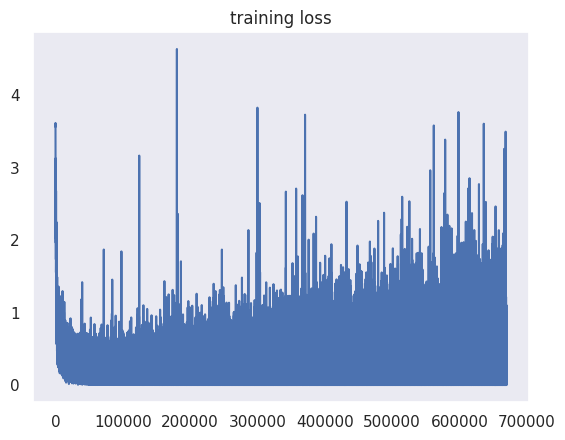

In [69]:
plt.plot(train_losses)
plt.title("training loss")

Text(0.5, 1.0, 'test accuracy')

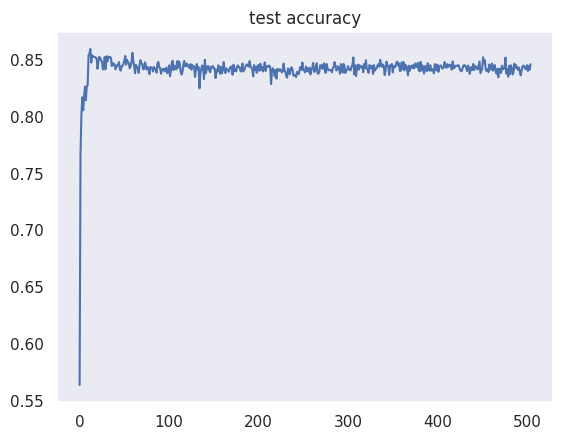

In [70]:
plt.plot(test_accuracy)
plt.title("test accuracy")

In [71]:
win_params1_list2 = model.conv1.window_params.detach().cpu().numpy()
win_params2_list2 = model.conv3.window_params.detach().cpu().numpy()
print(win_params1_list2.shape)
print(win_params2_list2.shape)

(128, 1, 2)
(128, 128, 3)


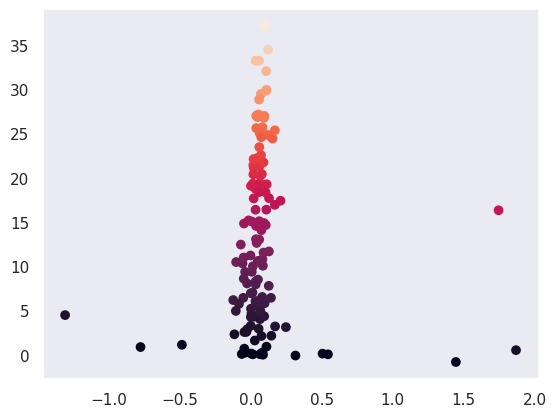

In [72]:
w1x = win_params1_list2[..., 0].flatten()
w1y = win_params1_list2[..., 1].flatten()
w1c = w1x + w1y
plt.scatter(w1x, w1y, c=w1c)

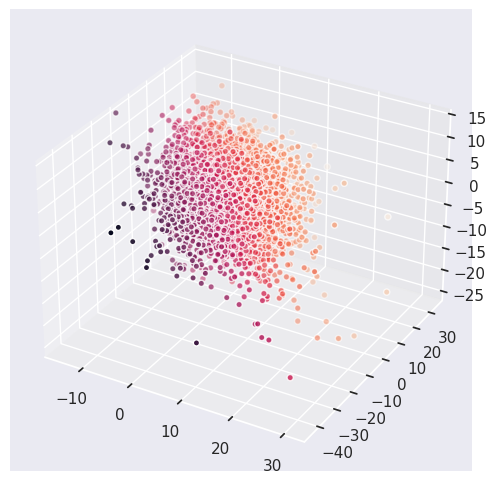

In [73]:
fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection ='3d')

w2x = win_params2_list2[...,0].flatten()
w2y = win_params2_list2[...,1].flatten()
w2z = win_params2_list2[...,2].flatten()
w2c = w2x + w2y
ax.set_xlim([w2x.min() - 0.1, w2x.max() + 0.1])
ax.set_ylim([w2y.min() - 0.1, w2y.max() + 0.1])
ax.set_zlim([w2z.min() - 0.1, w2z.max() + 0.1])
ax.scatter(w2x, w2y, w2z, c=w2c, edgecolor='white')

In [74]:
lowcut_bands1_m22 = model.conv1.lowcut_bands.detach().cpu().numpy()
bandwidths1_m22 = model.conv1.bandwidths.detach().cpu().numpy()
lowcut_bands2_m22 = model.conv3.lowcut_bands.detach().cpu().numpy()
bandwidths2_m22 = model.conv3.bandwidths.detach().cpu().numpy()

(array([2048., 3456., 3328., 2432., 2176., 1280.,  640.,  512.,  256.,
         256.]),
 array([0.0035846 , 0.0073439 , 0.01110321, 0.01486251, 0.01862181,
        0.02238112, 0.02614042, 0.02989972, 0.03365903, 0.03741833,
        0.04117763]),
 <BarContainer object of 10 artists>)

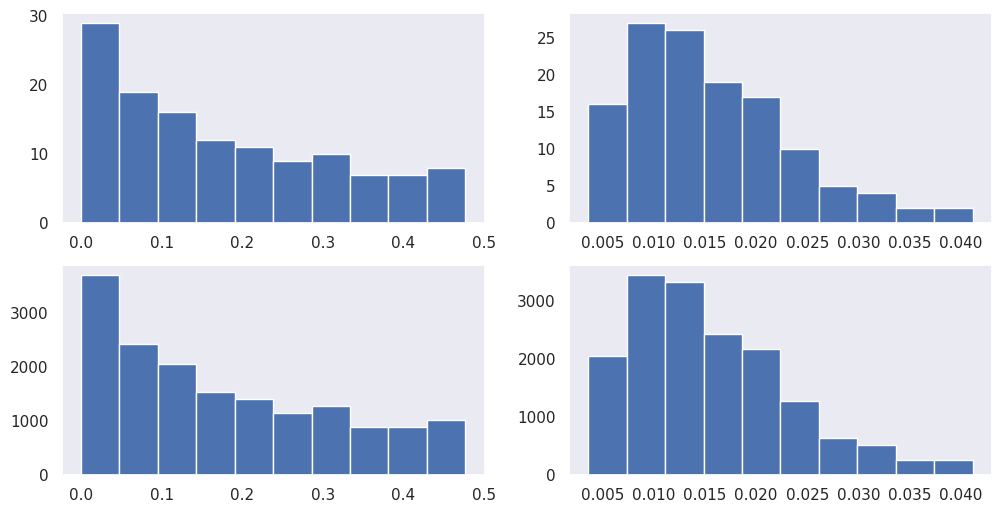

In [75]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,6))
axes[0,0].hist(lowcut_bands1_m22.flatten())
axes[0,1].hist(bandwidths1_m22.flatten())
axes[1,0].hist(lowcut_bands2_m22.flatten())
axes[1,1].hist(bandwidths2_m22.flatten())

In [76]:
y_n_bin = 5
y_bins = np.linspace(0.,lowcut_bands1_m22.max(), y_n_bin+1)
x_n_bin = 3
x_bins = np.linspace(0.,bandwidths1_m22.max(), x_n_bin+1)

df = pd.DataFrame(data={
    'lowcut': lowcut_bands1_m22.flatten(), 
    'bandwidth': bandwidths1_m22.flatten(), 
    'window_params': list(rearrange(win_params1_list2, 'h c p -> (h c) p'))
})
df

lowcut  bandwidth              window_params
0    0.000000   0.003585     [1.867677, 0.52615654]
1    0.003585   0.003878    [0.5060761, 0.12784852]
2    0.007463   0.004196   [-0.48375654, 1.1292285]
3    0.011659   0.004540     [0.1456393, 2.1526144]
4    0.016199   0.004912  [-0.044127632, 2.5676675]
..        ...        ...                        ...
123  0.389959   0.020805   [0.054507244, 27.164164]
124  0.410764   0.021390   [0.10657127, 14.6687155]
125  0.432154   0.021991    [0.123534285, 34.49268]
126  0.454145   0.022610    [0.10184851, 37.165115]
127  0.476755   0.023245   [0.042423386, 12.639106]

[128 rows x 3 columns]

In [77]:
win_length = 17
df['lowcut_bin'] = df['lowcut'].apply(lambda x: 
                   max(math.ceil(x/lowcut_bands1_m22.max()*y_n_bin)-1, 0))
df['bandwidth_bin'] = df['bandwidth'].apply(lambda x: 
                   max(math.ceil(x/bandwidths1_m22.max()*x_n_bin)-1, 0))
df['window'] = df['window_params'].apply(lambda x:
                   general_cosine_window(win_length, x).numpy().flatten())
df['order'] = df.apply(
    lambda x: (y_n_bin -1 - x['lowcut_bin'])*x_n_bin + x['bandwidth_bin'], 
    axis=1)

In [80]:
df['order'].value_counts()

order
12    48
7     20
9     14
10    14
4     13
1      8
2      7
5      4
Name: count, dtype: int64

In [78]:
h, c = lowcut_bands1_m22.shape
df_expanded = pd.DataFrame(data={
    'lowcut': repeat(lowcut_bands1_m22, 'h c -> (h c k)', k=win_length), 
    'bandwidth': repeat(bandwidths1_m22, 'h c -> (h c k)', k=win_length),  
    'window': np.hstack(df['window'].values),
    'window_t': repeat(np.arange(win_length), 'k -> (h c k)', h=h, c=c, k=win_length),
    'lowcut_bin': repeat(df['lowcut_bin'].values, '(h c) -> (h c k)', h=h, c=c, k=win_length),
    'bandwidth_bin': repeat(df['bandwidth_bin'].values, '(h c) -> (h c k)', h=h, c=c, k=win_length),
    'order': repeat(df['order'].values, '(h c) -> (h c k)', h=h, c=c, k=win_length), 
    'win_id': repeat(np.arange(h*c), '(h c)-> (h c k)', h=h, c=c, k=win_length)
})
df_expanded

lowcut  bandwidth     window  window_t  lowcut_bin  bandwidth_bin  \
0     0.000000   0.003585   1.341520         0           0              0   
1     0.000000   0.003585   1.381572         1           0              0   
2     0.000000   0.003585   1.495628         2           0              0   
3     0.000000   0.003585   1.666326         3           0              0   
4     0.000000   0.003585   1.867677         4           0              0   
...        ...        ...        ...       ...         ...            ...   
2171  0.476755   0.023245   0.042423        12           4              1   
2172  0.476755   0.023245  -4.794353        13           4              1   
2173  0.476755   0.023245  -8.894774        14           4              1   
2174  0.476755   0.023245 -11.634588        15           4              1   
2175  0.476755   0.023245 -12.596682        16           4              1   

      order  win_id  
0        12       0  
1        12       0  
2        12       0  
3        12       0  
4        12       0  
...     ...     ...  
2171      1     127  
2172      1     127  
2173      1     127  
2174      1     127  
2175      1     127  

[2176 rows x 8 columns]

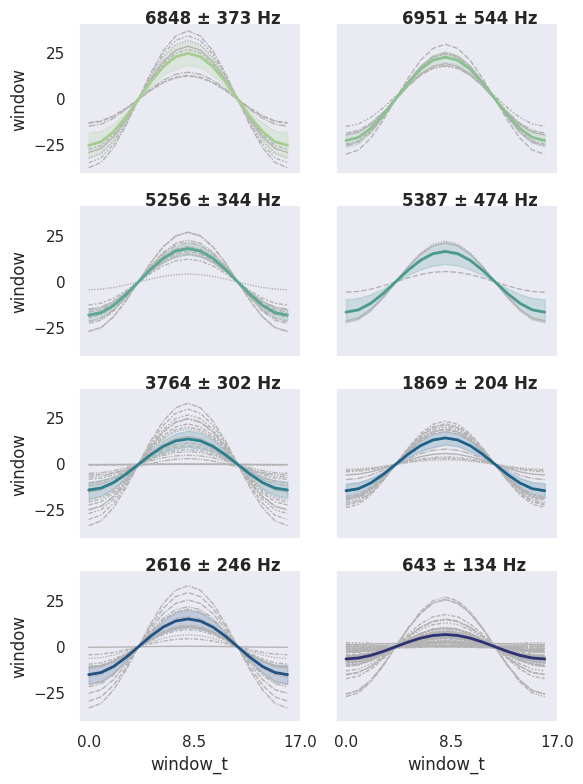

In [81]:
g = sns.relplot(
    data=df_expanded,
    x="window_t", 
    y='window', 
    col="order", hue="order",
    kind="line", palette="crest", linewidth=2, zorder=5,
    col_wrap=2, 
    height=2, aspect=1.5, legend=False,
)

for order, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    sub_df = df_expanded[df_expanded['order']==order]
    subtitle = f"{int(sub_df['lowcut'].mean()*16000)} ± {int(sub_df['bandwidth'].mean()*16000)} Hz"
    ax.text(.3, 1, subtitle, transform=ax.transAxes, fontweight="bold")

    # Plot every window in the background
    sns.lineplot(
        data=sub_df, 
        x="window_t", 
        y="window", 
        units="order",
        estimator=None, color=".7", linewidth=1, ax=ax, 
        style="win_id", legend=False
    )
    
ax.set_xticks(np.linspace(0, win_length,3))
g.set_titles("")
g.tight_layout()

In [82]:
full_window_response_length = win_length*10
window_response_length = full_window_response_length
df['window_response'] = df['window'].apply(lambda x:
                   get_window_freq_response(x)[:window_response_length])
freq = np.fft.fftfreq(full_window_response_length,d=1/2)[:window_response_length]

In [83]:
h, c = lowcut_bands1_m22.shape
dff_expanded = pd.DataFrame(data={
    'lowcut': repeat(lowcut_bands1_m22, 'h c -> (h c k)', k=window_response_length), 
    'bandwidth': repeat(bandwidths1_m22, 'h c -> (h c k)', k=window_response_length),  
    'window_response': np.hstack(df['window_response'].values),
    'window_t': repeat(freq, 
                       'k -> (h c k)', h=h, c=c, k=window_response_length),
    'lowcut_bin': repeat(df['lowcut_bin'].values, 
                         '(h c) -> (h c k)', h=h, c=c, k=window_response_length),
    'bandwidth_bin': repeat(df['bandwidth_bin'].values, 
                            '(h c) -> (h c k)', h=h, c=c, k=window_response_length),
    'order': repeat(df['order'].values, 
                    '(h c) -> (h c k)', h=h, c=c, k=window_response_length), 
    'win_id': repeat(np.arange(h*c), '(h c)-> (h c k)', h=h, c=c, k=window_response_length)
})
dff_expanded

lowcut  bandwidth  window_response  window_t  lowcut_bin  \
0      0.000000   0.003585         0.000000  0.000000           0   
1      0.000000   0.003585        -0.117625  0.011765           0   
2      0.000000   0.003585        -0.473608  0.023529           0   
3      0.000000   0.003585        -1.077679  0.035294           0   
4      0.000000   0.003585        -1.947575  0.047059           0   
...         ...        ...              ...       ...         ...   
21755  0.476755   0.023245        -9.555132 -0.058824           4   
21756  0.476755   0.023245       -14.324722 -0.047059           4   
21757  0.476755   0.023245       -23.048499 -0.035294           4   
21758  0.476755   0.023245       -32.533013 -0.023529           4   
21759  0.476755   0.023245       -21.623055 -0.011765           4   

       bandwidth_bin  order  win_id  
0                  0     12       0  
1                  0     12       0  
2                  0     12       0  
3                  0     12       0  
4                  0     12       0  
...              ...    ...     ...  
21755              1      1     127  
21756              1      1     127  
21757              1      1     127  
21758              1      1     127  
21759              1      1     127  

[21760 rows x 8 columns]

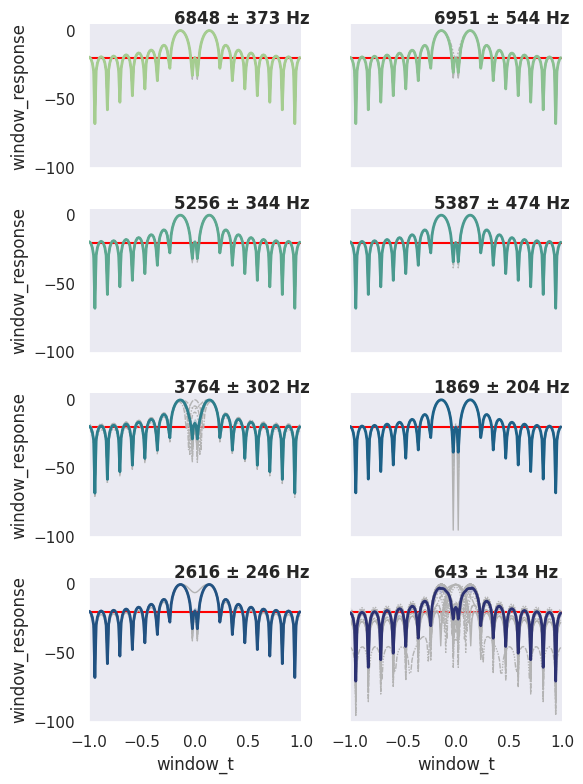

In [84]:
# sns.set(rc={'figure.figsize':(20,16)})
g = sns.relplot(
    data=dff_expanded,
    x="window_t", 
    y='window_response', 
    col="order", hue="order",
    # row='lowcut_bin', col='bandwidth_bin',
    kind="line", palette="crest", linewidth=2, zorder=5,
    col_wrap=2, 
    height=2, aspect=1.5, legend=False,
)

for order, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    sub_df = dff_expanded[dff_expanded['order']==order]
    subtitle = f"{int(sub_df['lowcut'].mean()*16000)} ± {int(sub_df['bandwidth'].mean()*16000)} Hz"
    ax.text(.4, 1, subtitle, transform=ax.transAxes, fontweight="bold")
    ax.axhline(-20, color='red', zorder=1)
    
    # Plot every window in the background
    sns.lineplot(
        data=sub_df, 
        x="window_t", 
        y="window_response", 
        units="order",
        estimator=None, color=".7", linewidth=1, ax=ax, 
        style="win_id", legend=False
    )

    
    
# ax.set_xticks(np.linspace(0, win_length,3))
g.set_titles("")
g.set(xlim=[-1,1])
g.tight_layout()